<a href="https://colab.research.google.com/github/tsaland/COS-473-Final-Project/blob/main/WhaleWatch_Signal_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install web3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Setup
from web3 import Web3
from decimal import Decimal
from ens import ENS
import asyncio
import json
from hexbytes.main import HexBytes
# for time conversion
import datetime
import pytz
from datetime import date
import pandas as pd
import time

alchemy_url = "https://eth-mainnet.g.alchemy.com/v2/OPutfOp_VyXojpS6t3xDlHiUnWCX8D1e"
# quicknode_url = 'https://burned-misty-bird.quiknode.pro/b28e66eff68ff25c09d8a011de7229bca847afbd/'
w3 = Web3(Web3.HTTPProvider(alchemy_url))
print(w3.isConnected())


True


# Part I Collect Whales Addresses

In [ ]:
#@title collect all crypto exchange addresses
from google.colab import files
uploaded = files.upload()

Saving Centralized Exchange Wallet List - Sheet1 (1).csv to Centralized Exchange Wallet List - Sheet1 (1).csv


In [ ]:
# four kinds of institutional wallets: custodial institutions, CEX, trading firms, and miners. Exclude the first two and include the later two for now.

inFile = list(uploaded.keys())[0]
exchange_wallets = []
with open(inFile) as f:
    for row in f:
        exchange_wallets.append(row.split(',')[0].lower())

Multichain_bridge = ['0x13B432914A996b0A48695dF9B2d701edA45FF264']
Zigzag_bridge = ['0xCC9557F04633d82Fb6A1741dcec96986cD8689AE']
Narni_bridge = ['0x4103c267Fba03A1Df4fe84Bc28092d629Fa3f422']
bridge_wallets = list(set().union(Multichain_bridge, Zigzag_bridge, Narni_bridge))

Circle_wallets = ['0x55fe002aeff02f77364de339a1292923a15844b8']
BitcoinSuisse_wallets = ['0x622de9bb9ff8907414785a633097db438f9a2d86', '0xdd9663bd979f1ab1bada85e1bc7d7f13cafe71f8', '0xec70e3c8afe212039c3f6a2df1c798003bf7cfe9', '0x3837ea2279b8e5c260a78f5f4181b783bbe76a8b', '0x2a7077399b3e90f5392d55a1dc7046ad8d152348', '0xc2288b408dc872a1546f13e6ebfa9c94998316a2']
custodian_wallets = list(set().union(Circle_wallets, BitcoinSuisse_wallets, bridge_wallets))


null_addresses = ['0x000000000000000000000000000000000000dead', '0x0000000000000000000000000000000000000000', '0x0000000000000000000000000000000000000001', '0x0000000000000000000000000000000000000002', '0x0000000000000000000000000000000000000003',
                '0x0000000000000000000000000000000000000004', '0x0000000000000000000000000000000000000005', '0x0000000000000000000000000000000000000006', '0x0000000000000000000000000000000000000007', '0x0000000000000000000000000000000000000008',
                '0x0000000000000000000000000000000000000009', '0x00000000000000000000045261d4ee77acdb3286', '0x0123456789012345678901234567890123456789', '0x1111111111111111111111111111111111111111', '0x1234567890123456789012345678901234567890',
                '0x2222222222222222222222222222222222222222', '0x3333333333333333333333333333333333333333', '0x4444444444444444444444444444444444444444', '0x6666666666666666666666666666666666666666', '0x8888888888888888888888888888888888888888',
                '0xbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb', '0xdead000000000000000042069420694206942069', '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee', '0xffffffffffffffffffffffffffffffffffffffff', '0xaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa']

In [ ]:
import random

block_txlist = []
addresses = set()

# randomly sample blocks from the first block in 2022 to the latest block
latest_block = w3.eth.get_block('latest')['number']
sample_blocks = random.sample(list(range(13916166,latest_block)), 10)
excluded_wallets = list(set().union(exchange_wallets, null_addresses, custodian_wallets))
for nonce in sample_blocks: # takes 26min to go through 40 blocks/8853 txs, and 10 minutes to go through 7000 wallets
  block = w3.eth.getBlock(nonce)
  block_transactions = block['transactions']

  for tx in block_transactions:
    getTrans = Web3.toJSON(tx).strip('"')
    trans = w3.eth.get_transaction(getTrans)
    try:
      _from = trans['from']
      _to = trans['to']
      # only append wallet addresses that are not contract addresses or exchange wallets
      if w3.eth.get_code(_from) == HexBytes("0x") and _from.lower() not in excluded_wallets:
        addresses.add(_from)
      if w3.eth.get_code(_to) == HexBytes("0x") and _to.lower() not in excluded_wallets:
        addresses.add(_to)
    except KeyError:
      print("ignore the invalid transaction with hash", trans['hash'].hex())

print("we found a total of", len(addresses), "unique addresses")

# recreate the state of all the addresses
state = dict()
for address in addresses:
  balance = w3.fromWei(w3.eth.get_balance(address),'tether')
  state[address] = balance

sorted_state = sorted(state, key=state.get, reverse=True)
selected_addresses = sorted_state[:int(len(sorted_state)*0.05)]
print(selected_addresses)
print("we take 5% of the total wallets by balance and limit to a total of", len(selected_addresses), "whales addresses")

we found a total of 2186 unique addresses
['0x7c195D981AbFdC3DDecd2ca0Fed0958430488e34', '0xD7efCbB86eFdD9E8dE014dafA5944AaE36E817e4', '0x6081258689a75d253d87cE902A8de3887239Fe80', '0xCD531Ae9EFCCE479654c4926dec5F6209531Ca7b', '0x4f6742bADB049791CD9A37ea913f2BAC38d01279', '0xe688b84b23f322a994A53dbF8E15FA82CDB71127', '0x95A9bd206aE52C4BA8EecFc93d18EACDd41C88CC', '0x44AfFdf87ABfb1DBa08e444141bD21B4380FA35F', '0xeB6c4bE4b92a52e969F4bF405025D997703D5383', '0x6dfc34609a05bC22319fA4Cce1d1E2929548c0D7', '0x974CaA59e49682CdA0AD2bbe82983419A2ECC400', '0xf0CF6b2af598c1f2909E148cbc5F5cc7c27b878b', '0xB8001C3eC9AA1985f6c747E25c28324E4A361ec1', '0x292f04a44506c2fd49Bac032E1ca148C35A478c8', '0x57d4E9B4a191D2bbA64Abd6C9250a500e29eeA74', '0x3b7A0869D228AD5C154b922CD7a7CB1C46FE6eD4', '0x9C19B0497997Fe9E75862688a295168070456951', '0x42D17b7f3532Ec2f7C4E4e5E239BAA476846E2CD', '0x2a45907f94df93388801AE72fE810eac75926a1d', '0x1C727a55eA3c11B0ab7D3a361Fe0F3C47cE6de5d', '0x8AbAB939cC1e72C4147642111b5778CFEa

In [ ]:
#@title Implement convert_date_to_blockNumber(_date) 
# get block at timestamp. cited from https://github.com/ethereum/web3.py/issues/1872#issuecomment-932675448
def search_block_number(timestamp):
    target_timestamp = timestamp
    averageBlockTime = 15.1
    block = w3.eth.getBlock('latest')
    blockNumber = block['number']
    blockTime = block['timestamp']
    lowerLimitStamp = target_timestamp
    higherLimitStamp = target_timestamp + 30
    requestsMade = 1

    while blockTime > target_timestamp:
        decreaseBlocks = int((blockTime - target_timestamp) / averageBlockTime)
        if decreaseBlocks < 1:
            break
        blockNumber -= decreaseBlocks
        block = w3.eth.getBlock(blockNumber)
        blockTime = block['timestamp']
        requestsMade += 1

    if blockTime < lowerLimitStamp:
        while blockTime < lowerLimitStamp:
            blockNumber += 1
            block = w3.eth.getBlock(blockNumber)
            blockTime = block['timestamp']
            requestsMade += 1
    
    if blockTime > higherLimitStamp:
         while blockTime > lowerLimitStamp:
            blockNumber -= 1
            block = w3.eth.getBlock(blockNumber)
            blockTime = block['timestamp']
            requestsMade += 1       
    
    return blockNumber

def convert_date_to_blockNumber(_date):
  date_string = _date.isoformat()
  timestamp = time.mktime(datetime.datetime.strptime(date_string,"%Y-%m-%d").timetuple())
  block = search_block_number(timestamp)
  return block


In [ ]:
# create a dictionary mapping dates to block numbers
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
daterange = pd.date_range(start_date, end_date).date
date_blockmap = dict()
for day in daterange:
  date_blockmap[day.strftime("%Y/%m/%d")] = convert_date_to_blockNumber(day)
  print('finished date', day)

print(date_blockmap)
df = pd.DataFrame(date_blockmap)
df.to_csv('date_blockmap.csv')

finished date 2022-01-01
finished date 2022-01-02
finished date 2022-01-03
finished date 2022-01-04
finished date 2022-01-05
finished date 2022-01-06
finished date 2022-01-07
finished date 2022-01-08
finished date 2022-01-09
finished date 2022-01-10
finished date 2022-01-11
finished date 2022-01-12
finished date 2022-01-13
finished date 2022-01-14
finished date 2022-01-15
finished date 2022-01-16
finished date 2022-01-17
finished date 2022-01-18
finished date 2022-01-19
finished date 2022-01-20
finished date 2022-01-21
finished date 2022-01-22
finished date 2022-01-23
finished date 2022-01-24
finished date 2022-01-25
finished date 2022-01-26
finished date 2022-01-27
finished date 2022-01-28
finished date 2022-01-29
finished date 2022-01-30
finished date 2022-01-31
finished date 2022-02-01
finished date 2022-02-02
finished date 2022-02-03
finished date 2022-02-04
finished date 2022-02-05
finished date 2022-02-06
finished date 2022-02-07
finished date 2022-02-08
finished date 2022-02-09


ValueError: ignored

In [ ]:
# df = pd.DataFrame(date_blockmap, index=dict())
# df.to_csv('date_blockmap.csv')
date_blockmap = {'2022/01/01': 13916168, '2022/01/02': 13922672, '2022/01/03': 13929167, '2022/01/04': 13935628, '2022/01/05': 13942121, '2022/01/06': 13948583, '2022/01/07': 13954974, '2022/01/08': 13961397, '2022/01/09': 13967922, '2022/01/10': 13974427, '2022/01/11': 13980849, '2022/01/12': 13987376, '2022/01/13': 13993832, '2022/01/14': 14000271, '2022/01/15': 14006710, '2022/01/16': 14013196, '2022/01/17': 14019700, '2022/01/18': 14026168, '2022/01/19': 14032630, '2022/01/20': 14039103, '2022/01/21': 14045593, '2022/01/22': 14051988, '2022/01/23': 14058541, '2022/01/24': 14064996, '2022/01/25': 14071446, '2022/01/26': 14077906, '2022/01/27': 14084333, '2022/01/28': 14090827, '2022/01/29': 14097299, '2022/01/30': 14103760, '2022/01/31': 14110300, '2022/02/01': 14116762, '2022/02/02': 14123262, '2022/02/03': 14129718, '2022/02/04': 14136138, '2022/02/05': 14142695, '2022/02/06': 14149082, '2022/02/07': 14155622, '2022/02/08': 14162082, '2022/02/09': 14168512, '2022/02/10': 14174989, '2022/02/11': 14181427, '2022/02/12': 14187947, '2022/02/13': 14194417, '2022/02/14': 14200888, '2022/02/15': 14207338, '2022/02/16': 14213859, '2022/02/17': 14220269, '2022/02/18': 14226747, '2022/02/19': 14233163, '2022/02/20': 14239570, '2022/02/21': 14246089, '2022/02/22': 14252524, '2022/02/23': 14258985, '2022/02/24': 14265473, '2022/02/25': 14271958, '2022/02/26': 14278387, '2022/02/27': 14284848, '2022/02/28': 14291336, '2022/03/01': 14297759, '2022/03/02': 14304254, '2022/03/03': 14310659, '2022/03/04': 14317109, '2022/03/05': 14323605, '2022/03/06': 14329981, '2022/03/07': 14336402, '2022/03/08': 14342848, '2022/03/09': 14349240, '2022/03/10': 14355748, '2022/03/11': 14362228, '2022/03/12': 14368559, '2022/03/13': 14375068, '2022/03/14': 14381396, '2022/03/15': 14387854, '2022/03/16': 14394258, '2022/03/17': 14400649, '2022/03/18': 14407075, '2022/03/19': 14413493, '2022/03/20': 14419942, '2022/03/21': 14426370, '2022/03/22': 14432777, '2022/03/23': 14439221, '2022/03/24': 14445660, '2022/03/25': 14452087, '2022/03/26': 14458509, '2022/03/27': 14464916, '2022/03/28': 14471310, '2022/03/29': 14477774, '2022/03/30': 14484226, '2022/03/31': 14490622, '2022/04/01': 14497034, '2022/04/02': 14503465, '2022/04/03': 14509822, '2022/04/04': 14516248, '2022/04/05': 14522571, '2022/04/06': 14529007, '2022/04/07': 14535424, '2022/04/08': 14541847, '2022/04/09': 14548185, '2022/04/10': 14554614, '2022/04/11': 14561015, '2022/04/12': 14567462, '2022/04/13': 14573908, '2022/04/14': 14580220, '2022/04/15': 14586627, '2022/04/16': 14593048, '2022/04/17': 14599453, '2022/04/18': 14605884, '2022/04/19': 14612235, '2022/04/20': 14618642, '2022/04/21': 14625067, '2022/04/22': 14631357, '2022/04/23': 14637771, '2022/04/24': 14644142, '2022/04/25': 14650517, '2022/04/26': 14656857, '2022/04/27': 14663177, '2022/04/28': 14669558, '2022/04/29': 14675905, '2022/04/30': 14682282, '2022/05/01': 14688632, '2022/05/02': 14695012, '2022/05/03': 14701369, '2022/05/04': 14707706, '2022/05/05': 14713964, '2022/05/06': 14720260, '2022/05/07': 14726564, '2022/05/08': 14732822, '2022/05/09': 14739155, '2022/05/10': 14745350, '2022/05/11': 14751558, '2022/05/12': 14757896, '2022/05/13': 14764085, '2022/05/14': 14770451, '2022/05/15': 14776688, '2022/05/16': 14782976, '2022/05/17': 14789265, '2022/05/18': 14795549, '2022/05/19': 14801796, '2022/05/20': 14807908, '2022/05/21': 14814062, '2022/05/22': 14820222, '2022/05/23': 14826344, '2022/05/24': 14832563, '2022/05/25': 14838637, '2022/05/26': 14844802, '2022/05/27': 14850894, '2022/05/28': 14857112, '2022/05/29': 14863277, '2022/05/30': 14869435, '2022/05/31': 14875531, '2022/06/01': 14881677, '2022/06/02': 14887796, '2022/06/03': 14893957, '2022/06/04': 14900090, '2022/06/05': 14905988, '2022/06/06': 14911927, '2022/06/07': 14917721, '2022/06/08': 14923678, '2022/06/09': 14929561, '2022/06/10': 14935369, '2022/06/11': 14941266, '2022/06/12': 14947132, '2022/06/13': 14952971, '2022/06/14': 14958806, '2022/06/15': 14964553, '2022/06/16': 14970302, '2022/06/17': 14976123, '2022/06/18': 14981994, '2022/06/19': 14987809, '2022/06/20': 14993520, '2022/06/21': 14999391, '2022/06/22': 15004856, '2022/06/23': 15010210, '2022/06/24': 15015520, '2022/06/25': 15020886, '2022/06/26': 15026233, '2022/06/27': 15031543, '2022/06/28': 15036953, '2022/06/29': 15042266, '2022/06/30': 15047598, '2022/07/01': 15053227, '2022/07/02': 15059680, '2022/07/03': 15066169, '2022/07/04': 15072709, '2022/07/05': 15079144, '2022/07/06': 15085621, '2022/07/07': 15092101, '2022/07/08': 15098521, '2022/07/09': 15105075, '2022/07/10': 15111487, '2022/07/11': 15117982, '2022/07/12': 15124468, '2022/07/13': 15130978, '2022/07/14': 15137389, '2022/07/15': 15143929, '2022/07/16': 15150365, '2022/07/17': 15156813, '2022/07/18': 15163239, '2022/07/19': 15169697, '2022/07/20': 15176171, '2022/07/21': 15182615, '2022/07/22': 15189088, '2022/07/23': 15195556, '2022/07/24': 15202012, '2022/07/25': 15208414, '2022/07/26': 15214809, '2022/07/27': 15221190, '2022/07/28': 15227621, '2022/07/29': 15234061, '2022/07/30': 15240482, '2022/07/31': 15246903, '2022/08/01': 15253306, '2022/08/02': 15259747, '2022/08/03': 15266193, '2022/08/04': 15272548, '2022/08/05': 15278937, '2022/08/06': 15285448, '2022/08/07': 15291834, '2022/08/08': 15298285, '2022/08/09': 15304707, '2022/08/10': 15311051, '2022/08/11': 15317426, '2022/08/12': 15323740, '2022/08/13': 15330083, '2022/08/14': 15336464, '2022/08/15': 15342780, '2022/08/16': 15349051, '2022/08/17': 15355432, '2022/08/18': 15361719, '2022/08/19': 15368063, '2022/08/20': 15374319, '2022/08/21': 15380673, '2022/08/22': 15387034, '2022/08/23': 15393299, '2022/08/24': 15399652, '2022/08/25': 15405908, '2022/08/26': 15412120, '2022/08/27': 15418355, '2022/08/28': 15424591, '2022/08/29': 15430829, '2022/08/30': 15437157, '2022/08/31': 15443367, '2022/09/01': 15449618, '2022/09/02': 15455881, '2022/09/03': 15462173, '2022/09/04': 15468373, '2022/09/05': 15474643, '2022/09/06': 15480812, '2022/09/07': 15487072, '2022/09/08': 15493290, '2022/09/09': 15499582, '2022/09/10': 15505647, '2022/09/11': 15511691, '2022/09/12': 15517757, '2022/09/13': 15523804, '2022/09/14': 15529868, '2022/09/15': 15535777, '2022/09/16': 15542504, '2022/09/17': 15549596, '2022/09/18': 15556726, '2022/09/19': 15563856, '2022/09/20': 15570981, '2022/09/21': 15578119, '2022/09/22': 15585173, '2022/09/23': 15592325, '2022/09/24': 15599492, '2022/09/25': 15606660, '2022/09/26': 15613828, '2022/09/27': 15620976, '2022/09/28': 15628117, '2022/09/29': 15635279, '2022/09/30': 15642433, '2022/10/01': 15649595, '2022/10/02': 15656732, '2022/10/03': 15663907, '2022/10/04': 15671064, '2022/10/05': 15678196, '2022/10/06': 15685344, '2022/10/07': 15692501, '2022/10/08': 15699647, '2022/10/09': 15706816, '2022/10/10': 15713978, '2022/10/11': 15721143, '2022/10/12': 15728307, '2022/10/13': 15735471, '2022/10/14': 15742628, '2022/10/15': 15749790, '2022/10/16': 15756957, '2022/10/17': 15764114, '2022/10/18': 15771268, '2022/10/19': 15778436, '2022/10/20': 15785590, '2022/10/21': 15792755, '2022/10/22': 15799920, '2022/10/23': 15807086, '2022/10/24': 15814249, '2022/10/25': 15821369, '2022/10/26': 15828521, '2022/10/27': 15835687, '2022/10/28': 15842849, '2022/10/29': 15850001, '2022/10/30': 15857151, '2022/10/31': 15864319, '2022/11/01': 15871480, '2022/11/02': 15878617, '2022/11/03': 15885773, '2022/11/04': 15892928, '2022/11/05': 15900096, '2022/11/06': 15907253, '2022/11/07': 15914421, '2022/11/08': 15921589, '2022/11/09': 15928754, '2022/11/10': 15935900, '2022/11/11': 15943061, '2022/11/12': 15950212, '2022/11/13': 15957380, '2022/11/14': 15964552, '2022/11/15': 15971719, '2022/11/16': 15978870, '2022/11/17': 15986020, '2022/11/18': 15993179, '2022/11/19': 16000338, '2022/11/20': 16007503, '2022/11/21': 16014666, '2022/11/22': 16021829, '2022/11/23': 16028979, '2022/11/24': 16036116, '2022/11/25': 16043282, '2022/11/26': 16050438, '2022/11/27': 16057597, '2022/11/28': 16064756, '2022/11/29': 16071931, '2022/11/30': 16079083, '2022/12/01': 16086234, '2022/12/02': 16093397, '2022/12/03': 16100564, '2022/12/04': 16107727, '2022/12/05': 16114881, '2022/12/06': 16122025, '2022/12/07': 16129195, '2022/12/08': 16136270, '2022/12/09': 16143431, '2022/12/10': 16150583, '2022/12/11': 16157748, '2022/12/12': 16164908, '2022/12/13': 16172064, '2022/12/14': 16179215, '2022/12/15': 16186378, '2022/12/16': 16193534, '2022/12/17': 16200694, '2022/12/18': 16207857, '2022/12/19': 16215019, '2022/12/20': 16222183, '2022/12/21': 16229351, '2022/12/22': 16236514, '2022/12/23': 16243692, '2022/12/24': 16250872, '2022/12/25': 16258038, '2022/12/26': 16265206, '2022/12/27': 16272368, '2022/12/28': 16279524, '2022/12/29': 16286697, '2022/12/30': 16293858, '2022/12/31': 16301024}


In [ ]:
#@title testing the exchange flow code
# selected_addresses = [
# '0xb739D0895772DBB71A89A3754A160269068f0D45']

# import requests
# import certifi

# # transaction = w3.eth.get_transaction('0x622d937afb91c7027477c3b01e2a81d59b1520ccede30def2a4afca7a8e4bb1f')
# # print([float(transaction.get('value'))/1000000000000000000.0])
# # print(transaction)
# # timestamp = transaction.get('timeStamp')
# # print(timestamp)
# # tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).strftime("%Y/%m/%d") # timestamp fucked up
# # print(tx_date)

# # transaction = w3.eth.get_transaction('0xe8d888daa7efcd1ffc9b729c6600ccb82c8c2c170a28a578d75b26476c633e38')
# # timestamp = transaction.get('timeStamp')
# # tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).strftime("%Y/%m/%d")

# # prev_date = date(2000, 1, 1).strftime("%Y/%m/%d") # create a dummy prev_date string
# # print(tx_date, prev_date)

# url = "https://api.etherscan.io/api?module=account&action=txlist&address=" + '0xb739d0895772dbb71a89a3754a160269068f0d45' + "&startblock=" + str(16280000) + "&endblock=" + str(16285253) + "&page=1&sort=desc&apikey=SKMKXN954GUHUYBF5JFKHS7I1M8IK5SXQP"
# response = requests.get(url, verify=certifi.where())
# address_content = response.json()
# result = address_content.get('result')
# prev_date = date(2000, 1, 1).strftime("%Y/%m/%d") # create a dummy prev_date string
# print("prev date", prev_date)

# for n, transaction in enumerate(result):
#   hash = transaction.get('hash')
#   timestamp = transaction.get('timeStamp')
#   tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).strftime("%Y/%m/%d") 
#   print('prev date', prev_date)
#   print("tx date", tx_date, 'with hash', hash)
#   print(tx_date == prev_date)
#   prev_date = tx_date



In [ ]:
from google.colab import files
uploaded = files.upload()
inFile = list(uploaded.keys())[0]
selected_addresses = []
with open(inFile) as f:
    for row in f:
        selected_addresses.append(row.split(',')[0].lower())


Saving selected addresses csv.csv to selected addresses csv.csv


In [ ]:
print(len(selected_addresses))

94


# Part II Track Signals Based on Whales' Addresses

In [ ]:
#@title Signal#1 Net Exchange Flow; #Whale Transfer In/Out
# find these wallets interactions with the exchanges
import requests
import certifi
import matplotlib.pyplot as plt
import statistics

def get_exchange_flow_by_address(address, startblock, endblock, hashmap):
  url = "https://api.etherscan.io/api?module=account&action=txlist&address=" + address + "&startblock=" + str(startblock) + "&endblock=" + str(endblock) + "&page=1&sort=desc&apikey=VQIYPTPDYJQDCHC8YSU5UIKCPBJ6PMFYIY"

  response = requests.get(url, verify=certifi.where())
  address_content = response.json()
  result = address_content.get('result')

  exchange_inflow = 0
  exchange_outflow = 0
  new_endblock = 0
  prev_date_in = date(2000, 1, 1).strftime("%Y/%m/%d") # create a dummy date string for the previous date of transferring to an exchange
  prev_date_out = date(2000, 1, 1).strftime("%Y/%m/%d") # create a dummy date string for the previous date of transferring out of an exchange
  print('status is: ' + str(address_content.get('status')))

  if int(startblock) > int(endblock):
    print("Reeeeeee startblock endblock error")
    return (0,0)

  while address_content.get('status') != '1':
    print('Retrying, status is: ' + str(address_content.get('status')))
    response = requests.get(url, verify=certifi.where())
    address_content = response.json()
    result = address_content.get('result')
  
  if len(result) == 0:
    return (0,0)

  for n, transaction in enumerate(result):
    tx_from = transaction.get('from').lower()
    tx_to = transaction.get('to').lower()
    eth_value = float(transaction.get('value'))/1000000000000000000.0
    hash = transaction.get('hash')
    timestamp = transaction.get('timeStamp')
    tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).strftime("%Y/%m/%d")
    if tx_from in exchange_wallets:
      hashmap[tx_date][0] -= eth_value # exchange outflow
      if tx_date != prev_date_out: # only increment "from exchange" whale count once for this address on one day
        hashmap[tx_date][1] -= 1
      # print("found a outflow! tx hash: ", hash, "tx date is ", tx_date, "prev date out is", prev_date_out, "does tx date = prev date out?", tx_date == prev_date_out)
      prev_date_out = tx_date
    if tx_to in exchange_wallets:
      hashmap[tx_date][0] += eth_value # exchange inflow
      if tx_date != prev_date_in: # only increment "to exchange" whale count once for this address on one day
        hashmap[tx_date][2] += 1
      # print("found a inflow! tx hash: ", hash, "tx date is ", tx_date, "prev date in is", prev_date_in, "does tx date = prev date in?", tx_date == prev_date_in)
      prev_date_in = tx_date # update the previous date
    if n == 9999:
      new_endblock = transaction.get('blockNumber')
  return(n, new_endblock)

start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
end_date_next_date = date(2023, 1, 1)
start_block = convert_date_to_blockNumber(start_date)
end_block = convert_date_to_blockNumber(end_date_next_date) # starts from the first block in 2022 and ends in the first block in 2023

hashmap = dict() # hashmap records net exchange inflow and outflows
daterange = pd.date_range(start_date, end_date)
for single_date in daterange:
  hashmap[single_date.strftime("%Y/%m/%d")] = [0,0,0] # mapping from date to [net flow, #whales transfering out of exchanges, #whales transfering to exchanges]
print(hashmap)

# selected_addresses = ['0xB8001C3eC9AA1985f6c747E25c28324E4A361ec1', '0xD7efCbB86eFdD9E8dE014dafA5944AaE36E817e4', '0x6081258689a75d253d87cE902A8de3887239Fe80', '0xCD531Ae9EFCCE479654c4926dec5F6209531Ca7b', '0x4f6742bADB049791CD9A37ea913f2BAC38d01279']
for address in selected_addresses:
  record_executed, new_endblock = get_exchange_flow_by_address(address, start_block, end_block, hashmap)
  round = 0
  while record_executed == 9999:
    record_executed, new_endblock = get_exchange_flow_by_address(address, start_block, new_endblock, hashmap)
    round += 1
  print('finished this address:', address, "with round", round)

print(hashmap)

dates = list(hashmap.keys())
net_flow = []
whales_outof_exchanges = []
whales_into_exchanges = []
net_inflow_excludezero = []
for value in hashmap.values():
  net_flow.append(value[0])
  if value[0] != 0:
    net_inflow_excludezero.append(value[0])
  whales_outof_exchanges.append(value[1])
  whales_into_exchanges.append(value[2])

median = statistics.median(net_inflow_excludezero)
mean = statistics.mean(net_inflow_excludezero)
print('median of the net exchange flow is', median)
print('mean of the net exchange flow is', mean)

print(net_flow)


In [ ]:
# visualize net flow into the exchanges
dates = list(hashmap.keys())
dates = [e[5:] for e in dates]
print(dates)
plt.figure(figsize=(15, 8))
plt.bar(range(len(hashmap)), net_flow, width=1.0)
plt.xticks(rotation=70)
plt.xticks(range(0, len(dates), 30))
plt.xticks(range(0, len(dates), 30), dates[0::30])
plt.grid(True)


plt.xlabel('Dates')
plt.ylabel('Exchange Net Flow (in Ether)')
plt.title('Whales Exchange Flow', loc='left')
plt.show()

# find number of whales transferring out of and into exchanges
plt.figure(figsize=(15, 8))
plt.bar(dates, whales_into_exchanges, color = '#337AE3', width=1.0)
plt.bar(dates, whales_outof_exchanges, color = '#DB4444', width=1.0)
plt.xticks(rotation=70)
plt.xticks(range(0, len(dates), 30))
plt.xticks(range(0, len(dates), 30), dates[0::30])
plt.grid(True)
legend_label = ['#Whales Transfering into Exchanges', '#Whales Transfering out of Exchanges']
plt.legend(legend_label, ncol = 2, bbox_to_anchor=([1, 1.05, 0, 0]), frameon = False)
plt.title('Number of whales flowing into and out of exchanges ', loc='left')
plt.show()

In [ ]:
#@title Track Whales Balance using etherscan API, code broken
import requests
import certifi
import matplotlib.pyplot as plt
import datetime  
from datetime import timedelta, date
import pandas as pd
import pytz
import statistics 

def get_internal_tx(address, startblock, endblock):
  # account for internal transactions 
  internaltx = dict()
  url2 = "https://api.etherscan.io/api?module=account&action=txlistinternal&address=" + address + "&startblock=" + str(startblock) + "&endblock=" + str(endblock) + "&page=1&sort=desc&apikey=SKMKXN954GUHUYBF5JFKHS7I1M8IK5SXQP"
  response2 = requests.get(url2, verify=certifi.where())
  address_content2 = response2.json()
  result2 = address_content2.get('result')

  for n, transaction in enumerate(result2):
    tx_from = transaction.get('from').lower()
    tx_to = transaction.get('to').lower()
    eth_value = float(transaction.get('value'))/1000000000000000000.0
    timestamp = transaction.get('timeStamp')
    tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).date()
    if tx_from == address.lower():
      if tx_date not in internaltx.keys():
        internaltx[tx_date] = eth_value # sending ether out 
      else:
        internaltx[tx_date] += eth_value
    if tx_to == address.lower():
      if tx_date not in internaltx.keys():
        internaltx[tx_date] = -1*eth_value # receiving ether
      else:
        internaltx[tx_date] -= eth_value
  # print(internaltx)
  return internaltx

def update_historical_balance(address, startblock, endblock, change_in_balance, balance_hashmap):
  url = "https://api.etherscan.io/api?module=account&action=txlist&address=" + address + "&startblock=" + str(startblock) + "&endblock=" + str(endblock) + "&page=1&sort=desc&apikey=SKMKXN954GUHUYBF5JFKHS7I1M8IK5SXQP"
  response = requests.get(url, verify=certifi.where())
  address_content = response.json()
  result = address_content.get('result')
  if address_content.get('message') == 'No transactions found':
    return (0, 0, 0)
  while address_content.get('status') != '1':
    print('Retrying, status is: ' + str(address_content.get('status')))
    response = requests.get(url, verify=certifi.where())
    address_content = response.json()
    result = address_content.get('result')
  
  # find recent date of the end block
  recent_block_timestamp = w3.eth.get_block(int(endblock))['timestamp']
  recent_date = datetime.datetime.fromtimestamp(int(recent_block_timestamp), tz=pytz.utc).date()
  record = 0
  new_endblock = 0
  # Etherscan API returns txs from most recent to oldest transactions, so we start from the initial balance and work backward
  for n, transaction in enumerate(result):
    tx_from = transaction.get('from').lower()
    tx_to = transaction.get('to').lower()
    eth_value = float(transaction.get('value'))/1000000000000000000.0
    hash = transaction.get('hash')
    timestamp = transaction.get('timeStamp')
    tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).date()

    # if detected a change in tx date, modify hashmap balance for all dates between the last transaction and this transaction
    while recent_date > tx_date:
      recent_date = recent_date - timedelta(days=1) # recent date updated to the tx date in the last iteration an
      balance_hashmap[recent_date.strftime("%Y/%m/%d")] += change_in_balance
    # if sent the tx, add the value and the gas fees back
    if tx_from == address.lower():
      gas_fee = float(transaction.get('gasPrice'))//1000000000000000000.0
      change_in_balance += eth_value + gas_fee
    # if received the tx, substract the value
    if tx_to == address.lower():
      change_in_balance -= eth_value     
    if n == 9999:
      new_endblock = int(transaction.get('blockNumber')) - 1 # starting at next block
  record = n
  return(record, new_endblock, change_in_balance)

start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
startblock = convert_date_to_blockNumber(start_date)
endblock = convert_date_to_blockNumber(end_date + timedelta(days=1)) # starts from the first block in 2022 and ends in the first block in 2023
balance_hashmap = dict() # hashmap records total balance of all whales
daterange = pd.date_range(start_date, end_date)
for single_date in daterange:
  balance_hashmap[single_date.strftime("%Y/%m/%d")] = 0 # mapping from date to total balance oF all whales

# selected_addresses = ['0xB8001C3eC9AA1985f6c747E25c28324E4A361ec1', '0xD7efCbB86eFdD9E8dE014dafA5944AaE36E817e4', '0x6081258689a75d253d87cE902A8de3887239Fe80', '0xCD531Ae9EFCCE479654c4926dec5F6209531Ca7b', '0x7c195D981AbFdC3DDecd2ca0Fed0958430488e34']
for address in selected_addresses:
  checksum = Web3.toChecksumAddress(address)
  post_intx_balance = float(w3.fromWei(w3.eth.get_balance(checksum, block_identifier=endblock), 'ether'))
  # add initial balance of the address to all dates of the year and later only track changes
  internaltx = get_internal_tx(address, startblock, endblock)
  for today in daterange[::-1]:
    today = today.date()
    next_date = today + timedelta(days=1)
    if next_date in internaltx.keys():
      post_intx_balance += internaltx[next_date]
    balance_hashmap[today.strftime("%Y/%m/%d")] += post_intx_balance

  change_in_balance = 0
  record_executed, new_endblock, change_in_balance = update_historical_balance(address, startblock, endblock, change_in_balance, balance_hashmap) 
  while record_executed == 9999 and int(new_endblock) >= int(startblock):
    record_executed, new_endblock, change_in_balance = update_historical_balance(address, startblock, new_endblock, change_in_balance, balance_hashmap) 
  print("finished this address: ", address)

print(balance_hashmap)

dates = balance_hashmap.keys()
historical_balance = balance_hashmap.values()

median = statistics.median(historical_balance)
mean = statistics.mean(historical_balance)
print('median of the whales account balance is', median)
print('mean of the whales account balance is', mean)
print(historical_balance)

# visualize balance changes of whales
dates = [e[5:] for e in dates]
plt.figure(figsize=(15, 8))
plt.bar(range(len(balance_hashmap)), historical_balance, width=1.0)
plt.xticks(rotation=70)
plt.xticks(range(0, len(dates), 30))
plt.xticks(range(0, len(dates), 30), dates[0::30])
plt.grid(True)

plt.xlabel('Dates')
plt.ylabel('Whales Balance')
plt.title('Whales Balance Changes', loc='left')
plt.show()


In [ ]:
#@title Signal#2 Whales Balance
from datetime import timedelta, date
import pandas as pd
import pytz
import statistics 

web3_balance = dict()
startdate_ = date(2022, 1, 1)
enddate_ = date(2023, 1, 1)
range = pd.date_range(startdate_, enddate_)

for _date in range:
  block = convert_date_to_blockNumber(_date.date())
  balance = 0
  for address in selected_addresses:
    checksum = Web3.toChecksumAddress(address)
    balance += float(w3.fromWei(w3.eth.get_balance(checksum, block_identifier=block), 'ether'))
  web3_balance[_date.date().strftime("%Y/%m/%d")] = balance
  print("finished date", _date.date(), "with balance", balance)
print(web3_balance)
print("median is", statistics.median(web3_balance.values()))
print("mean is", statistics.mean(web3_balance.values()))


finished date 2021-12-30 with balance 32160.522465493636
finished date 2021-12-31 with balance 29171.64119635524
finished date 2022-01-01 with balance 33698.018849945875
{'2021/12/30': 32160.522465493636, '2021/12/31': 29171.64119635524, '2022/01/01': 33698.018849945875}
median is 32160.522465493636
mean is 31676.727503931583


In [ ]:
for key in balance_hashmap.keys():
  for item in balance_hashmap[key]:
    balance_hashmap[key] = item
# df = pd.DataFrame(balance_hashmap) 
# df.head()
# df.to_csv(index=False)
print(balance_hashmap)

{'2022/01/01': 1087586.6062200672, '2022/01/02': 1081926.814237121, '2022/01/03': 1072933.0511812083, '2022/01/04': 1070002.9782141, '2022/01/05': 1063640.903250528, '2022/01/06': 1059693.7367065826, '2022/01/07': 1050332.3606777776, '2022/01/08': 1045853.6045358999, '2022/01/09': 1050160.9120748795, '2022/01/10': 1044086.5343652742, '2022/01/11': 1037035.3153409081, '2022/01/12': 1030290.8577283658, '2022/01/13': 1027549.3652443299, '2022/01/14': 1022162.4855183937, '2022/01/15': 1017724.4981435197, '2022/01/16': 1012620.1335543187, '2022/01/17': 1002424.366045693, '2022/01/18': 996271.5463314962, '2022/01/19': 998510.7067959917, '2022/01/20': 997475.1166702474, '2022/01/21': 987328.5269527248, '2022/01/22': 985330.9864602326, '2022/01/23': 978553.3517579256, '2022/01/24': 977557.4102452423, '2022/01/25': 1011708.2406739077, '2022/01/26': 979352.2269524286, '2022/01/27': 978536.135339558, '2022/01/28': 966247.5961341884, '2022/01/29': 968247.8179414083, '2022/01/30': 963884.8313524504

In [ ]:
#@title Stablecoin Contracts (USDT, USDC, DAI)

usdt_address = w3.toChecksumAddress('0xdAC17F958D2ee523a2206206994597C13D831ec7')
usdt_abi = json.loads('[{"constant":true,"inputs":[],"name":"name","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_upgradedAddress","type":"address"}],"name":"deprecate","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"_spender","type":"address"},{"name":"_value","type":"uint256"}],"name":"approve","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"deprecated","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_evilUser","type":"address"}],"name":"addBlackList","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_from","type":"address"},{"name":"_to","type":"address"},{"name":"_value","type":"uint256"}],"name":"transferFrom","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"upgradedAddress","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"}],"name":"balances","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"maximumFee","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"_totalSupply","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"unpause","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"name":"_maker","type":"address"}],"name":"getBlackListStatus","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"},{"name":"","type":"address"}],"name":"allowed","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"paused","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"who","type":"address"}],"name":"balanceOf","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"pause","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"getOwner","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"owner","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_to","type":"address"},{"name":"_value","type":"uint256"}],"name":"transfer","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"newBasisPoints","type":"uint256"},{"name":"newMaxFee","type":"uint256"}],"name":"setParams","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"amount","type":"uint256"}],"name":"issue","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"amount","type":"uint256"}],"name":"redeem","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"name":"_owner","type":"address"},{"name":"_spender","type":"address"}],"name":"allowance","outputs":[{"name":"remaining","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"basisPointsRate","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"}],"name":"isBlackListed","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_clearedUser","type":"address"}],"name":"removeBlackList","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"MAX_UINT","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"_blackListedUser","type":"address"}],"name":"destroyBlackFunds","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"inputs":[{"name":"_initialSupply","type":"uint256"},{"name":"_name","type":"string"},{"name":"_symbol","type":"string"},{"name":"_decimals","type":"uint256"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":false,"name":"amount","type":"uint256"}],"name":"Issue","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"amount","type":"uint256"}],"name":"Redeem","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"newAddress","type":"address"}],"name":"Deprecate","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"feeBasisPoints","type":"uint256"},{"indexed":false,"name":"maxFee","type":"uint256"}],"name":"Params","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"_blackListedUser","type":"address"},{"indexed":false,"name":"_balance","type":"uint256"}],"name":"DestroyedBlackFunds","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"_user","type":"address"}],"name":"AddedBlackList","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"_user","type":"address"}],"name":"RemovedBlackList","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"owner","type":"address"},{"indexed":true,"name":"spender","type":"address"},{"indexed":false,"name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"from","type":"address"},{"indexed":true,"name":"to","type":"address"},{"indexed":false,"name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[],"name":"Pause","type":"event"},{"anonymous":false,"inputs":[],"name":"Unpause","type":"event"}]')
usdt_contract = w3.eth.contract(address=usdt_address, abi=usdt_abi)

usdc_address = w3.toChecksumAddress('0x7EA2be2df7BA6E54B1A9C70676f668455E329d29')
usdc_abi = json.loads('[{"inputs":[{"internalType":"string","name":"_name","type":"string"},{"internalType":"string","name":"_symbol","type":"string"},{"internalType":"uint8","name":"_decimals","type":"uint8"},{"internalType":"address","name":"_underlying","type":"address"},{"internalType":"address","name":"_vault","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"auth","type":"address"},{"indexed":false,"internalType":"uint256","name":"timestamp","type":"uint256"}],"name":"LogAddAuth","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"oldOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"},{"indexed":true,"internalType":"uint256","name":"effectiveHeight","type":"uint256"}],"name":"LogChangeMPCOwner","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"oldVault","type":"address"},{"indexed":true,"internalType":"address","name":"newVault","type":"address"},{"indexed":true,"internalType":"uint256","name":"effectiveTime","type":"uint256"}],"name":"LogChangeVault","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"bytes32","name":"txhash","type":"bytes32"},{"indexed":true,"internalType":"address","name":"account","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"LogSwapin","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"account","type":"address"},{"indexed":true,"internalType":"address","name":"bindaddr","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount","type":"uint256"}],"name":"LogSwapout","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[],"name":"DOMAIN_SEPARATOR","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"PERMIT_TYPEHASH","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"txhash","type":"bytes32"},{"internalType":"address","name":"account","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"Swapin","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"bindaddr","type":"address"}],"name":"Swapout","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"TRANSFER_TYPEHASH","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"address","name":"","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"applyMinter","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"applyVault","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"approveAndCall","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"burn","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newVault","type":"address"}],"name":"changeMPCOwner","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newVault","type":"address"}],"name":"changeVault","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"delay","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"delayDelay","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"delayMinter","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"delayVault","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"to","type":"address"}],"name":"deposit","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"deposit","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"deposit","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"to","type":"address"}],"name":"depositVault","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"target","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"},{"internalType":"address","name":"to","type":"address"}],"name":"depositWithPermit","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"target","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"},{"internalType":"address","name":"to","type":"address"}],"name":"depositWithTransferPermit","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"getAllMinters","outputs":[{"internalType":"address[]","name":"","type":"address[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_vault","type":"address"}],"name":"initVault","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"isMinter","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"mint","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"minters","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"mpc","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"nonces","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pendingDelay","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pendingMinter","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"pendingVault","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"target","type":"address"},{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"permit","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_auth","type":"address"}],"name":"revokeMinter","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_auth","type":"address"}],"name":"setMinter","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"_vault","type":"address"}],"name":"setVault","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"bool","name":"enabled","type":"bool"}],"name":"setVaultOnly","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"transferAndCall","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"target","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"},{"internalType":"uint256","name":"deadline","type":"uint256"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"transferWithPermit","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"underlying","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"vault","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"to","type":"address"}],"name":"withdraw","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"withdraw","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"withdraw","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"},{"internalType":"address","name":"to","type":"address"}],"name":"withdrawVault","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"nonpayable","type":"function"}]')
usdc_contract = w3.eth.contract(address=usdc_address, abi=usdc_abi)

# busd_address = w3.toChecksumAddress('0x4Fabb145d64652a948d72533023f6E7A623C7C53')
# busd_abi = json.loads('[{"constant":false,"inputs":[{"name":"newImplementation","type":"address"}],"name":"upgradeTo","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"newImplementation","type":"address"},{"name":"data","type":"bytes"}],"name":"upgradeToAndCall","outputs":[],"payable":true,"stateMutability":"payable","type":"function"},{"constant":true,"inputs":[],"name":"implementation","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"newAdmin","type":"address"}],"name":"changeAdmin","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"admin","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"inputs":[{"name":"_implementation","type":"address"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"payable":true,"stateMutability":"payable","type":"fallback"},{"anonymous":false,"inputs":[{"indexed":false,"name":"previousAdmin","type":"address"},{"indexed":false,"name":"newAdmin","type":"address"}],"name":"AdminChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"name":"implementation","type":"address"}],"name":"Upgraded","type":"event"}]')
# busd_contract = w3.eth.contract(address=busd_address, abi=busd_abi)

dai_address = w3.toChecksumAddress('0x6B175474E89094C44Da98b954EedeAC495271d0F')
dai_abi = json.loads('[{"inputs":[{"internalType":"uint256","name":"chainId_","type":"uint256"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"src","type":"address"},{"indexed":true,"internalType":"address","name":"guy","type":"address"},{"indexed":false,"internalType":"uint256","name":"wad","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":true,"inputs":[{"indexed":true,"internalType":"bytes4","name":"sig","type":"bytes4"},{"indexed":true,"internalType":"address","name":"usr","type":"address"},{"indexed":true,"internalType":"bytes32","name":"arg1","type":"bytes32"},{"indexed":true,"internalType":"bytes32","name":"arg2","type":"bytes32"},{"indexed":false,"internalType":"bytes","name":"data","type":"bytes"}],"name":"LogNote","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"src","type":"address"},{"indexed":true,"internalType":"address","name":"dst","type":"address"},{"indexed":false,"internalType":"uint256","name":"wad","type":"uint256"}],"name":"Transfer","type":"event"},{"constant":true,"inputs":[],"name":"DOMAIN_SEPARATOR","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"PERMIT_TYPEHASH","outputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"address","name":"","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"usr","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"usr","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"burn","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"guy","type":"address"}],"name":"deny","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"usr","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"mint","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"src","type":"address"},{"internalType":"address","name":"dst","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"move","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"nonces","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"holder","type":"address"},{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"nonce","type":"uint256"},{"internalType":"uint256","name":"expiry","type":"uint256"},{"internalType":"bool","name":"allowed","type":"bool"},{"internalType":"uint8","name":"v","type":"uint8"},{"internalType":"bytes32","name":"r","type":"bytes32"},{"internalType":"bytes32","name":"s","type":"bytes32"}],"name":"permit","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"usr","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"pull","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"usr","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"push","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"guy","type":"address"}],"name":"rely","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"dst","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"src","type":"address"},{"internalType":"address","name":"dst","type":"address"},{"internalType":"uint256","name":"wad","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"version","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"","type":"address"}],"name":"wards","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"}]')
dai_contract = w3.eth.contract(address=dai_address, abi=dai_abi)

stablecoin_contracts = [usdt_contract, usdc_contract, dai_contract]
print(stablecoin_contracts)



[<web3._utils.datatypes.Contract object at 0x7fa837e5f070>, <web3._utils.datatypes.Contract object at 0x7fa84579af70>, <web3._utils.datatypes.Contract object at 0x7fa8379bd310>]


In [ ]:
# obtain block-time eth price with moralis API, deprecated
!pip install moralis
from moralis import evm_api
  # params = {
  #   "address": "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2",
  #   "chain": "eth",
  #   "to_block": this_block
  # }
  # result = evm_api.token.get_token_price(
  #   api_key=api_key,
  #   params=params,
  # )
  # eth_price = result['usdPrice']
# Moralis APY Key
api_key = "W3udXIDi34aiEBCF34OdaSMDUazN5yuhdmMUSHF3WoMiBGyNkJSIYWJO5lm1yFQB"

{'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28':

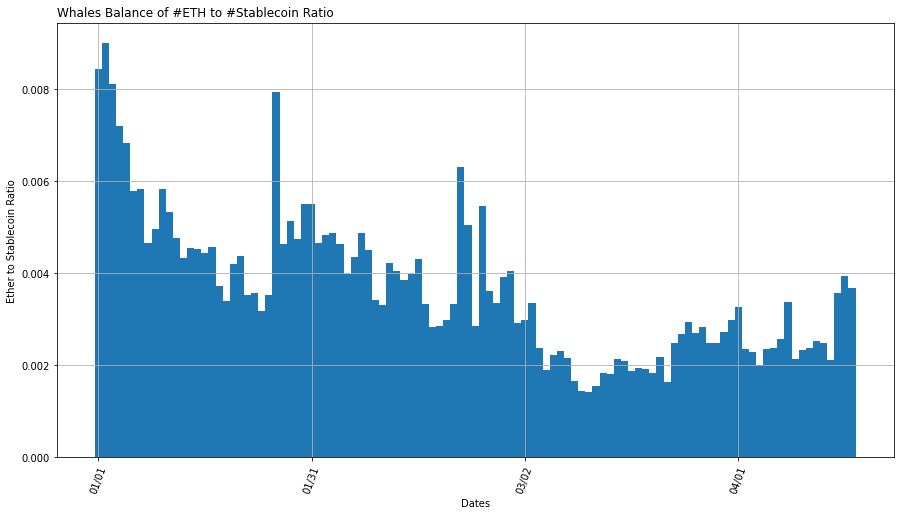

In [ ]:
#@title Signal#3 ETH-to-Stablecoins Ratio
import requests
import certifi
import matplotlib.pyplot as plt
import datetime  
from datetime import timedelta, date
import pandas as pd
import pytz
import statistics 

start_date = date(2022, 1, 1)
end_date = date(2022, 4, 17)
startblock = convert_date_to_blockNumber(start_date)
endblock = convert_date_to_blockNumber(end_date + timedelta(days=1)) # starts from the first block in 2022 and ends in the first block in 2023

ETHPercentHolding_hashmap = dict() # hashmap records 
daterange = pd.date_range(start_date, end_date)
for single_date in daterange:
  ETHPercentHolding_hashmap[single_date.date().strftime("%Y/%m/%d")] = 0 # mapping from date to total balance oF all whales
print(ETHPercentHolding_hashmap)

# selected_addresses = ['0xB8001C3eC9AA1985f6c747E25c28324E4A361ec1', '0xD7efCbB86eFdD9E8dE014dafA5944AaE36E817e4', '0x6081258689a75d253d87cE902A8de3887239Fe80', '0xCD531Ae9EFCCE479654c4926dec5F6209531Ca7b', '0x4f6742bADB049791CD9A37ea913f2BAC38d01279']
# add initial balance of the address to all dates of the year and later only track changes
for single_date in daterange:
  this_block = convert_date_to_blockNumber(single_date.date())
  total_eth_balance = 0
  total_stablecoin_balance = 0
  for address in selected_addresses:
    checksum = Web3.toChecksumAddress(address)
    total_eth_balance += float(w3.fromWei(w3.eth.get_balance(checksum, block_identifier=this_block), 'ether'))
    for contract in stablecoin_contracts:
      total_stablecoin_balance += contract.functions.balanceOf(checksum).call(block_identifier=this_block)/1000000000000000000.0
  # total_eth_balance = balance_hashmap[single_date.strftime("%Y/%m/%d")]
  ETHPercentHolding_hashmap[single_date.strftime("%Y/%m/%d")] = total_eth_balance / total_stablecoin_balance
  print("finished date:", single_date.date())

print(ETHPercentHolding_hashmap)
# visualize balance changes in ETH percentage holding of whales
dates = list(ETHPercentHolding_hashmap.keys())
dates = [e[5:] for e in dates]
print(dates)
plt.figure(figsize=(15, 8))
plt.bar(range(len(ETHPercentHolding_hashmap)), ETHPercentHolding_hashmap.values(), width=1.0)
plt.xticks(rotation=70)
plt.xticks(range(0, len(dates), 30))
plt.xticks(range(0, len(dates), 30), dates[0::30])
plt.grid(True)

plt.xlabel('Dates')
plt.ylabel('Ether to Stablecoin Ratio')
plt.title('Whales Balance of #ETH to #Stablecoin Ratio', loc='left')
plt.show()


In [ ]:
copy = ETHPercentHolding_hashmap
for key in copy.keys():
  copy[key] = [copy[key]]
df = pd.DataFrame(copy) 
df.head()
df.to_csv(index=False)


'2022/01/01,2022/01/02,2022/01/03,2022/01/04,2022/01/05,2022/01/06,2022/01/07,2022/01/08,2022/01/09,2022/01/10,2022/01/11,2022/01/12,2022/01/13,2022/01/14,2022/01/15,2022/01/16,2022/01/17,2022/01/18,2022/01/19,2022/01/20,2022/01/21,2022/01/22,2022/01/23,2022/01/24,2022/01/25,2022/01/26,2022/01/27,2022/01/28,2022/01/29,2022/01/30,2022/01/31,2022/02/01,2022/02/02,2022/02/03,2022/02/04,2022/02/05,2022/02/06,2022/02/07,2022/02/08,2022/02/09,2022/02/10,2022/02/11,2022/02/12,2022/02/13,2022/02/14,2022/02/15,2022/02/16,2022/02/17,2022/02/18,2022/02/19,2022/02/20,2022/02/21,2022/02/22,2022/02/23,2022/02/24,2022/02/25,2022/02/26,2022/02/27,2022/02/28,2022/03/01,2022/03/02,2022/03/03,2022/03/04,2022/03/05,2022/03/06,2022/03/07,2022/03/08,2022/03/09,2022/03/10,2022/03/11,2022/03/12,2022/03/13,2022/03/14,2022/03/15,2022/03/16,2022/03/17,2022/03/18,2022/03/19,2022/03/20,2022/03/21,2022/03/22,2022/03/23,2022/03/24,2022/03/25,2022/03/26,2022/03/27,2022/03/28,2022/03/29,2022/03/30,2022/03/31,2022/04/0

In [ ]:
# find net exchange flow of all wallets
#@title Track each whale's daily net exchange flow 
# find these wallets interactions with the exchanges
import requests
import certifi
import matplotlib.pyplot as plt
import statistics
from datetime import timedelta, date

def get_exchange_flow(address, startblock, endblock, wallet_cexflow):
  url = "https://api.etherscan.io/api?module=account&action=txlist&address=" + address + "&startblock=" + str(startblock) + "&endblock=" + str(endblock) + "&page=1&sort=desc&apikey=VQIYPTPDYJQDCHC8YSU5UIKCPBJ6PMFYIY"

  response = requests.get(url, verify=certifi.where())
  address_content = response.json()
  result = address_content.get('result')

  new_endblock = 0

  if int(startblock) > int(endblock):
    print("Reeeeeee startblock endblock error")
    return 0 

  while address_content.get('status') != '1':
    print('Retrying, status is: ' + str(address_content.get('status')))
    response = requests.get(url, verify=certifi.where())
    address_content = response.json()
    result = address_content.get('result')
  
  if len(result) == 0:
    return 0

  for n, transaction in enumerate(result):
    tx_from = transaction.get('from').lower()
    tx_to = transaction.get('to').lower()
    eth_value = float(transaction.get('value'))/1000000000000000000.0
    # hash = transaction.get('hash')
    timestamp = transaction.get('timeStamp')
    tx_date = datetime.datetime.fromtimestamp(int(timestamp), tz=pytz.utc).strftime("%Y/%m/%d")
    if tx_from in exchange_wallets:
      wallet_cexflow[tx_date] -= eth_value # exchange outflow
      # print("found a outflow! tx hash: ", hash, "tx date is ", tx_date, "prev date out is", prev_date_out, "does tx date = prev date out?", tx_date == prev_date_out)
    if tx_to in exchange_wallets:
      wallet_cexflow[tx_date] += eth_value # exchange inflow
      # print("found a inflow! tx hash: ", hash, "tx date is ", tx_date, "prev date in is", prev_date_in, "does tx date = prev date in?", tx_date == prev_date_in)
    if n == 9999:
      new_endblock = transaction.get('blockNumber')
  return(n, new_endblock)


start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
start_block = convert_date_to_blockNumber(start_date)
end_block = convert_date_to_blockNumber(end_date + timedelta(days=1)) # starts from the first block in 2022 and ends in the first block in 2023
daterange = pd.date_range(start_date, end_date)

hashmap = [] # a list of hashmaps that contain net exchange flow of all whales wallets

# selected_addresses = ['0xB8001C3eC9AA1985f6c747E25c28324E4A361ec1', '0xD7efCbB86eFdD9E8dE014dafA5944AaE36E817e4', '0x6081258689a75d253d87cE902A8de3887239Fe80', '0xCD531Ae9EFCCE479654c4926dec5F6209531Ca7b', '0x4f6742bADB049791CD9A37ea913f2BAC38d01279']
for address in selected_addresses:
  wallet_cexflow = dict()
  for single_date in daterange:
    wallet_cexflow[single_date.strftime("%Y/%m/%d")] = 0 # mapping from date to net flow
  record_executed, new_endblock = get_exchange_flow(address, start_block, end_block, wallet_cexflow)
  round = 0
  while record_executed == 9999:
    record_executed, new_endblock = get_exchange_flow(address, start_block, new_endblock, wallet_cexflow)
    round += 1
  hashmap.append(wallet_cexflow)
  print('finished this address:', address, "with round", round)

print(hashmap)
  


finished this address: 0x7c195d981abfdc3ddecd2ca0fed0958430488e34 with round 16
finished this address: 0xd7efcbb86efdd9e8de014dafa5944aae36e817e4 with round 5
finished this address: 0x6081258689a75d253d87ce902a8de3887239fe80 with round 23
finished this address: 0xcd531ae9efcce479654c4926dec5f6209531ca7b with round 3
finished this address: 0x4f6742badb049791cd9a37ea913f2bac38d01279 with round 60
finished this address: 0xe688b84b23f322a994a53dbf8e15fa82cdb71127 with round 3
finished this address: 0x95a9bd206ae52c4ba8eecfc93d18eacdd41c88cc with round 61
finished this address: 0x44affdf87abfb1dba08e444141bd21b4380fa35f with round 1
finished this address: 0xeb6c4be4b92a52e969f4bf405025d997703d5383 with round 6
finished this address: 0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7 with round 184
finished this address: 0x974caa59e49682cda0ad2bbe82983419a2ecc400 with round 110
finished this address: 0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b with round 0
finished this address: 0xb8001c3ec9aa1985f6c

In [ ]:
#@title Track each whale's daily balance and stable ratio

# eth_balance = dict()
# eth2stable_ratio = dict()
# selected_addresses = ['0x4f6742bADB049791CD9A37ea913f2BAC38d01279']
startdate_ = date(2022, 1, 1)
enddate_ = date(2022, 12, 31)
daterange = pd.date_range(startdate_, enddate_).date
index = 0
for wallet in selected_addresses: 
  # if wallet in passed_addresses:
  #   continue
  print('starting on wallet', wallet)
  checksum = Web3.toChecksumAddress(wallet)
  wallet_record = dict()
  wallet_eth2stable_record = dict()
  for _date in daterange:
    block = date_blockmap[_date.strftime("%Y/%m/%d")]
    today_balance = float(w3.fromWei(w3.eth.get_balance(checksum, block_identifier=block), 'ether'))
    stable_balance = 0
    for contract in stablecoin_contracts:
        stable_balance += contract.functions.balanceOf(checksum).call(block_identifier=block)/1000000000000000000.0
    wallet_record[_date.strftime("%Y/%m/%d")] = today_balance
    if stable_balance != 0:
      wallet_eth2stable_record[_date.strftime("%Y/%m/%d")] = today_balance / stable_balance
    else:
      wallet_eth2stable_record[_date.strftime("%Y/%m/%d")] = 1
  eth_balance[wallet] = wallet_record
  eth2stable_ratio[wallet] = wallet_eth2stable_record
  index += 1
  if index%10 == 0:
    print('index', index)
    print(eth_balance)
    print(eth2stable_ratio)


print(eth_balance)
print(eth2stable_ratio)


In [ ]:
#@title eth_balance stored
eth_balance = {'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 12.562146545042173, '2022/01/02': 12.335800598974933, '2022/01/03': 12.105653015626883, '2022/01/04': 11.748156820277812, '2022/01/05': 11.32221387089118, '2022/01/06': 11.042300756582165, '2022/01/07': 10.65439962001842, '2022/01/08': 10.29592126783299, '2022/01/09': 9.989081224279737, '2022/01/10': 9.68539871764451, '2022/01/11': 18.84520147810957, '2022/01/12': 18.293289817773555, '2022/01/13': 17.927736804605207, '2022/01/14': 17.501588078212276, '2022/01/15': 17.28944587491432, '2022/01/16': 17.016767196272212, '2022/01/17': 16.710837662873566, '2022/01/18': 16.461674443813862, '2022/01/19': 16.30889841564388, '2022/01/20': 16.018967750355007, '2022/01/21': 15.752957716591744, '2022/01/22': 15.468129187417158, '2022/01/23': 15.215765946285533, '2022/01/24': 15.032963159699326, '2022/01/25': 14.773781305813097, '2022/01/26': 14.553537855763816, '2022/01/27': 14.115311010189387, '2022/01/28': 13.855837456047867, '2022/01/29': 13.642029351823012, '2022/01/30': 13.521846962966887, '2022/01/31': 13.320867032691757, '2022/02/01': 13.2100304498637, '2022/02/02': 12.945693488661286, '2022/02/03': 12.167922434324254, '2022/02/04': 9.752713270816287, '2022/02/05': 9.028358457642225, '2022/02/06': 8.511609871478871, '2022/02/07': 8.138375277114077, '2022/02/08': 14.591500487410977, '2022/02/09': 14.096716607310462, '2022/02/10': 13.665576595990512, '2022/02/11': 13.294974277062336, '2022/02/12': 13.018412655680173, '2022/02/13': 12.799469776330996, '2022/02/14': 12.644623405954455, '2022/02/15': 12.507393299961745, '2022/02/16': 12.253192034419275, '2022/02/17': 18.63253217020272, '2022/02/18': 18.306144593192055, '2022/02/19': 17.961379696476133, '2022/02/20': 17.724439178801433, '2022/02/21': 17.49765674797007, '2022/02/22': 17.27986293375968, '2022/02/23': 16.94905650175749, '2022/02/24': 16.525541331729762, '2022/02/25': 15.839297407554877, '2022/02/26': 15.604716945226544, '2022/02/27': 15.492758540573307, '2022/02/28': 15.347783564323684, '2022/03/01': 15.104000313279053, '2022/03/02': 14.901487739791394, '2022/03/03': 14.791653864417412, '2022/03/04': 14.715338460882194, '2022/03/05': 14.618957057752255, '2022/03/06': 14.511817360039519, '2022/03/07': 14.448632998307735, '2022/03/08': 14.192640314279537, '2022/03/09': 14.049929036008097, '2022/03/10': 13.941720317983922, '2022/03/11': 13.869171774700282, '2022/03/12': 13.748954665733324, '2022/03/13': 13.650194899016483, '2022/03/14': 13.511921237437384, '2022/03/15': 13.410192527606227, '2022/03/16': 13.320135966368243, '2022/03/17': 13.17914343686277, '2022/03/18': 12.966926540947403, '2022/03/19': 12.745626245920723, '2022/03/20': 12.597638395566335, '2022/03/21': 12.504948499715743, '2022/03/22': 12.384209168726018, '2022/03/23': 12.26270858599411, '2022/03/24': 12.088335981787012, '2022/03/25': 11.904595703270983, '2022/03/26': 11.789365597506963, '2022/03/27': 11.70280337064535, '2022/03/28': 11.585902457300335, '2022/03/29': 11.427773289046508, '2022/03/30': 11.27997948410301, '2022/03/31': 11.115738810099622, '2022/04/01': 10.970879592670178, '2022/04/02': 10.812314361272186, '2022/04/03': 10.716064539116612, '2022/04/04': 10.531230714352514, '2022/04/05': 10.463857248187141, '2022/04/06': 10.373768007217457, '2022/04/07': 10.264615754937976, '2022/04/08': 10.1399310590159, '2022/04/09': 10.042835695264001, '2022/04/10': 9.981579834946881, '2022/04/11': 9.930782304925179, '2022/04/12': 9.849882247335701, '2022/04/13': 9.739331584419336, '2022/04/14': 9.667090935025152, '2022/04/15': 9.589943570269938, '2022/04/16': 9.522655710285685, '2022/04/17': 9.464327279924305, '2022/04/18': 9.430755228882651, '2022/04/19': 9.373755470000173, '2022/04/20': 9.185730173727991, '2022/04/21': 9.052254673718398, '2022/04/22': 8.942004034089031, '2022/04/23': 8.874003502064392, '2022/04/24': 8.801601306099743, '2022/04/25': 8.741405672954334, '2022/04/26': 8.680484798538012, '2022/04/27': 8.619485493883912, '2022/04/28': 8.552475301032516, '2022/04/29': 8.472834772786854, '2022/04/30': 8.372888024268791, '2022/05/01': 8.277731859880117, '2022/05/02': 8.102166293393354, '2022/05/03': 7.978371413361584, '2022/05/04': 7.909675784860965, '2022/05/05': 7.797260908009654, '2022/05/06': 7.693191933560615, '2022/05/07': 7.637555205364966, '2022/05/08': 7.58071636523351, '2022/05/09': 7.546185110863778, '2022/05/10': 14.994422268524568, '2022/05/11': 14.916253490003294, '2022/05/12': 12.605727122147565, '2022/05/13': 10.194444819346975, '2022/05/14': 9.512242287475724, '2022/05/15': 9.18966243565023, '2022/05/16': 9.05561463160687, '2022/05/17': 8.919732863260407, '2022/05/18': 8.776837997153699, '2022/05/19': 8.663010812119888, '2022/05/20': 8.550496663641749, '2022/05/21': 8.435920463069118, '2022/05/22': 8.347974806054054, '2022/05/23': 8.247593730473364, '2022/05/24': 7.93224281908861, '2022/05/25': 7.705373708456144, '2022/05/26': 7.521823479081615, '2022/05/27': 14.855945233225633, '2022/05/28': 14.747414444804027, '2022/05/29': 14.678649124134644, '2022/05/30': 14.604319698134734, '2022/05/31': 14.474139352894737, '2022/06/01': 14.34029825651481, '2022/06/02': 14.229317492274864, '2022/06/03': 14.092993373702523, '2022/06/04': 13.953161534348716, '2022/06/05': 13.863027386106484, '2022/06/06': 13.785441810656888, '2022/06/07': 13.688373957289103, '2022/06/08': 13.583895046768495, '2022/06/09': 13.45880940107413, '2022/06/10': 13.374429482799908, '2022/06/11': 13.262283004221288, '2022/06/12': 13.180595744367228, '2022/06/13': 13.095159126873266, '2022/06/14': 12.02796698808537, '2022/06/15': 11.42601048887249, '2022/06/16': 11.05775046162673, '2022/06/17': 10.803820960045712, '2022/06/18': 10.523661990526119, '2022/06/19': 10.126463776937484, '2022/06/20': 9.979902357613716, '2022/06/21': 9.84290538319185, '2022/06/22': 9.693825670137992, '2022/06/23': 9.520642620049937, '2022/06/24': 9.208394865509842, '2022/06/25': 9.027699913622737, '2022/06/26': 8.876184250214951, '2022/06/27': 8.768758614921877, '2022/06/28': 8.594011326904267, '2022/06/29': 8.289515833516987, '2022/06/30': 14.94736313447251, '2022/07/01': 14.447871081904426, '2022/07/02': 13.89632580289106, '2022/07/03': 13.651866649297753, '2022/07/04': 13.51230239660225, '2022/07/05': 13.329464152046409, '2022/07/06': 13.103265196747033, '2022/07/07': 12.86169097593816, '2022/07/08': 12.56693616252841, '2022/07/09': 12.425636703739887, '2022/07/10': 12.297775649668658, '2022/07/11': 12.177420219391626, '2022/07/12': 12.011793521830226, '2022/07/13': 11.837553228396825, '2022/07/14': 11.702383845539918, '2022/07/15': 11.485878849138041, '2022/07/16': 11.34689782450732, '2022/07/17': 11.148731406207158, '2022/07/18': 10.938693513012918, '2022/07/19': 10.702166642506253, '2022/07/20': 10.434911913407896, '2022/07/21': 10.219875847832206, '2022/07/22': 10.089032888374868, '2022/07/23': 10.020687905148135, '2022/07/24': 9.950566320239155, '2022/07/25': 9.90654182443439, '2022/07/26': 9.813693187502135, '2022/07/27': 9.71431775215223, '2022/07/28': 9.569439114281701, '2022/07/29': 9.436622224152783, '2022/07/30': 9.354638230117326, '2022/07/31': 9.29551084007982, '2022/08/01': 9.255085331167182, '2022/08/02': 9.203991074488007, '2022/08/03': 9.13656486830325, '2022/08/04': 9.081491532544689, '2022/08/05': 9.027943150001233, '2022/08/06': 8.978034783758973, '2022/08/07': 8.968761160264048, '2022/08/08': 8.961055170298012, '2022/08/09': 8.944733891671014, '2022/08/10': 8.918162979710104, '2022/08/11': 8.851409172291337, '2022/08/12': 8.78313799736515, '2022/08/13': 8.762729440831919, '2022/08/14': 8.748954049790807, '2022/08/15': 8.745126539204367, '2022/08/16': 8.725255434985286, '2022/08/17': 8.712384390491708, '2022/08/18': 8.701943594192498, '2022/08/19': 8.696903132042916, '2022/08/20': 8.68037229911022, '2022/08/21': 8.675422831146287, '2022/08/22': 8.67454710507301, '2022/08/23': 8.67454710507301, '2022/08/24': 8.67454710507301, '2022/08/25': 8.672980025966286, '2022/08/26': 8.672306793620601, '2022/08/27': 8.672306793620601, '2022/08/28': 8.672306793620601, '2022/08/29': 8.670535853135222, '2022/08/30': 8.669049559325343, '2022/08/31': 8.668168770109437, '2022/09/01': 8.667054666937306, '2022/09/02': 8.656042644550071, '2022/09/03': 8.656042644550071, '2022/09/04': 8.656042644550071, '2022/09/05': 8.656042644550071, '2022/09/06': 8.656042644550071, '2022/09/07': 8.650488286610646, '2022/09/08': 8.639748092148738, '2022/09/09': 8.639143997232665, '2022/09/10': 8.639143997232665, '2022/09/11': 8.639143997232665, '2022/09/12': 8.639143997232665, '2022/09/13': 8.639143997232665, '2022/09/14': 8.639143997232665, '2022/09/15': 8.639143997232665, '2022/09/16': 8.639143997232665, '2022/09/17': 8.639143997232665, '2022/09/18': 32.527014424552775, '2022/09/19': 1211.9693644611968, '2022/09/20': 5573.263760289727, '2022/09/21': 5184.104639284726, '2022/09/22': 4359.0347607133035, '2022/09/23': 4772.288624080594, '2022/09/24': 2757.313102095311, '2022/09/25': 1128.269399499999, '2022/09/26': 1720.757219044287, '2022/09/27': 3447.9787090589516, '2022/09/28': 4343.671894671539, '2022/09/29': 5344.76456088741, '2022/09/30': 4833.103561765352, '2022/10/01': 3346.431534564572, '2022/10/02': 3969.190628808545, '2022/10/03': 4262.390513679922, '2022/10/04': 4971.287328825759, '2022/10/05': 5465.607675638808, '2022/10/06': 5727.075338267911, '2022/10/07': 6172.7249545593895, '2022/10/08': 5174.09038197598, '2022/10/09': 5833.104303140539, '2022/10/10': 5395.320041682782, '2022/10/11': 4735.242328808474, '2022/10/12': 4818.173143482064, '2022/10/13': 7.5676898347936215, '2022/10/14': 5299.321493267715, '2022/10/15': 4593.8150393530905, '2022/10/16': 3812.633193569919, '2022/10/17': 5335.835294456812, '2022/10/18': 5076.828875114749, '2022/10/19': 5336.5678651175795, '2022/10/20': 4653.615554444798, '2022/10/21': 4150.7623917642695, '2022/10/22': 5413.991676727638, '2022/10/23': 4695.205198730982, '2022/10/24': 4960.524387799699, '2022/10/25': 3866.408642075857, '2022/10/26': 2566.1817721911107, '2022/10/27': 3957.1964231438087, '2022/10/28': 4820.676331468063, '2022/10/29': 4652.321957005955, '2022/10/30': 5182.363713579914, '2022/10/31': 5022.419470293655, '2022/11/01': 2984.212034630143, '2022/11/02': 1516.6461544421713, '2022/11/03': 2459.023302610447, '2022/11/04': 4897.673235524943, '2022/11/05': 1776.3913856778229, '2022/11/06': 2011.8547018874426, '2022/11/07': 2525.1856441127898, '2022/11/08': 2777.3548810333855, '2022/11/09': 27694.3670502324, '2022/11/10': 6445.28543262714, '2022/11/11': 5536.426863129119, '2022/11/12': 1647.9627412359532, '2022/11/13': 4166.995930111634, '2022/11/14': 3270.9046341339845, '2022/11/15': 690.9368332938262, '2022/11/16': 898.0880111161404, '2022/11/17': 932.9853349706118, '2022/11/18': 937.4854656098762, '2022/11/19': 1609.4023754555158, '2022/11/20': 1198.2443414248382, '2022/11/21': 1017.4062920014367, '2022/11/22': 1006.0048403531542, '2022/11/23': 868.232528217532, '2022/11/24': 1265.1165818242175, '2022/11/25': 2964.764104785533, '2022/11/26': 4437.527014988129, '2022/11/27': 2442.8923661235194, '2022/11/28': 4251.335020847565, '2022/11/29': 4663.093166390136, '2022/11/30': 18090.33297459222, '2022/12/01': 17802.84537056254, '2022/12/02': 6528.558101740541, '2022/12/03': 5677.518096179695, '2022/12/04': 2781.409763358307, '2022/12/05': 5624.831405986355, '2022/12/06': 3684.383082089984, '2022/12/07': 1289.3033866654098, '2022/12/08': 1223.163993623508, '2022/12/09': 1267.7112386025083, '2022/12/10': 182.303305919976, '2022/12/11': 1944.9673311893887, '2022/12/12': 477.31490614636874, '2022/12/13': 869.783264681619, '2022/12/14': 2965.6768947875034, '2022/12/15': 808.2644078023536, '2022/12/16': 1330.6671249525298, '2022/12/17': 1633.4316439682316, '2022/12/18': 2992.8583676902285, '2022/12/19': 3444.252331162583, '2022/12/20': 2973.580463034534, '2022/12/21': 10027.27594879337, '2022/12/22': 8607.86559268902, '2022/12/23': 5351.315959055425, '2022/12/24': 3541.9998024199076, '2022/12/25': 3252.927839625606, '2022/12/26': 3076.379450299266, '2022/12/27': 2150.8786212842565, '2022/12/28': 1659.3001358442898, '2022/12/29': 796.5732248788125, '2022/12/30': 1102.959728510137, '2022/12/31': 2041.8410604654973}, '0xd7efcbb86efdd9e8de014dafa5944aae36e817e4': {'2022/01/01': 3277.6380607624724, '2022/01/02': 3229.1851782004724, '2022/01/03': 3254.8404151404725, '2022/01/04': 3229.3071399834726, '2022/01/05': 3230.9262186054725, '2022/01/06': 2841.2960931334724, '2022/01/07': 2781.2580768264725, '2022/01/08': 2639.8660094014726, '2022/01/09': 2598.1120508844724, '2022/01/10': 2581.2861245054723, '2022/01/11': 2524.7037554334725, '2022/01/12': 2710.1930917484724, '2022/01/13': 2414.6042870414726, '2022/01/14': 2316.0630081274726, '2022/01/15': 2323.9285113454725, '2022/01/16': 2281.6971967854724, '2022/01/17': 2257.2281790154725, '2022/01/18': 2214.6506707854724, '2022/01/19': 2322.073425677472, '2022/01/20': 2369.3286352994724, '2022/01/21': 2309.0551638814723, '2022/01/22': 2366.4694763604725, '2022/01/23': 2647.5107498714724, '2022/01/24': 2754.3985060854725, '2022/01/25': 2851.9265586074725, '2022/01/26': 3701.8372706314726, '2022/01/27': 3020.6779806344725, '2022/01/28': 3016.1861689834723, '2022/01/29': 3329.7210857014725, '2022/01/30': 3318.4589142924724, '2022/01/31': 3602.6071310934726, '2022/02/01': 3494.7771432364725, '2022/02/02': 3126.5489606934725, '2022/02/03': 3248.7429365244725, '2022/02/04': 2951.6809250424726, '2022/02/05': 3130.9602095114724, '2022/02/06': 3060.7084487994725, '2022/02/07': 3048.6717624724724, '2022/02/08': 2599.0727144704724, '2022/02/09': 2623.4384885044724, '2022/02/10': 1887.1817299884724, '2022/02/11': 1869.6635892564725, '2022/02/12': 3355.5431059864723, '2022/02/13': 3312.3564756674723, '2022/02/14': 3338.9350586334726, '2022/02/15': 3388.8700618344724, '2022/02/16': 3024.0290653724724, '2022/02/17': 3560.2213857004726, '2022/02/18': 3425.3726045594726, '2022/02/19': 3430.7730316334723, '2022/02/20': 3175.0895522904725, '2022/02/21': 3289.2719109054724, '2022/02/22': 3603.6678538284723, '2022/02/23': 1652.2024922164724, '2022/02/24': 1293.7716982544723, '2022/02/25': 1921.2751527064725, '2022/02/26': 2106.8798531354723, '2022/02/27': 1821.7645961334724, '2022/02/28': 1525.5717029164723, '2022/03/01': 1485.7674438684724, '2022/03/02': 1387.0562464534723, '2022/03/03': 1422.2083851954724, '2022/03/04': 1325.9235986534725, '2022/03/05': 1346.2184801844724, '2022/03/06': 1432.4037984504723, '2022/03/07': 1582.7914825504724, '2022/03/08': 1396.3032883814724, '2022/03/09': 1240.8309032624725, '2022/03/10': 1390.9691640354724, '2022/03/11': 1873.5578451074723, '2022/03/12': 1857.6383828304724, '2022/03/13': 1971.1235238154725, '2022/03/14': 2130.2482327984726, '2022/03/15': 1843.3821050734723, '2022/03/16': 2178.7689096424724, '2022/03/17': 2149.8359923434723, '2022/03/18': 2294.008320619472, '2022/03/19': 1913.7831791854724, '2022/03/20': 1775.2465714124723, '2022/03/21': 3340.9806261984722, '2022/03/22': 2026.5017485794724, '2022/03/23': 2109.1598216714724, '2022/03/24': 1713.8062726744724, '2022/03/25': 1974.7870389464724, '2022/03/26': 1990.5730481594724, '2022/03/27': 2269.9528577034725, '2022/03/28': 2274.8068636374724, '2022/03/29': 2029.5664970654725, '2022/03/30': 2094.6773768134726, '2022/03/31': 2259.6764255214725, '2022/04/01': 2234.769149562472, '2022/04/02': 3264.0387645354726, '2022/04/03': 3140.657957231472, '2022/04/04': 3168.2318005054726, '2022/04/05': 3206.620259738472, '2022/04/06': 3123.4536880954724, '2022/04/07': 3604.5263751384723, '2022/04/08': 3616.1953200644725, '2022/04/09': 3477.6747081114722, '2022/04/10': 3430.0736290024724, '2022/04/11': 3260.5029894114723, '2022/04/12': 3709.3670934644724, '2022/04/13': 3374.4719722704726, '2022/04/14': 3591.6296062014726, '2022/04/15': 3202.5546279344726, '2022/04/16': 3691.0433715324725, '2022/04/17': 2799.3634238844725, '2022/04/18': 2869.4611605064724, '2022/04/19': 2548.0876165414725, '2022/04/20': 2840.7105221234724, '2022/04/21': 2971.176372964472, '2022/04/22': 2816.0095489394726, '2022/04/23': 3555.1820421414723, '2022/04/24': 3339.5785485974725, '2022/04/25': 3432.9472289014725, '2022/04/26': 3190.8468752514723, '2022/04/27': 2747.315390646472, '2022/04/28': 3120.5693514634722, '2022/04/29': 4074.8105163854725, '2022/04/30': 4185.877211679473, '2022/05/01': 4269.873365695473, '2022/05/02': 4310.066536423473, '2022/05/03': 3737.7495659704723, '2022/05/04': 3740.4422079204724, '2022/05/05': 4193.595884508472, '2022/05/06': 3977.0812402454726, '2022/05/07': 3629.9005592744725, '2022/05/08': 3930.6209091014725, '2022/05/09': 4233.139389906472, '2022/05/10': 4417.436273296473, '2022/05/11': 4756.291594725472, '2022/05/12': 4387.397047271473, '2022/05/13': 5129.234602282472, '2022/05/14': 5090.767257303472, '2022/05/15': 4958.739361173472, '2022/05/16': 5147.527270830473, '2022/05/17': 4886.591531381472, '2022/05/18': 4243.275637389473, '2022/05/19': 3584.9532788934725, '2022/05/20': 4418.746347983472, '2022/05/21': 4033.0092717864723, '2022/05/22': 3190.3171359974726, '2022/05/23': 3492.4080029904726, '2022/05/24': 4269.988117495473, '2022/05/25': 4372.3612875284725, '2022/05/26': 4149.089262454472, '2022/05/27': 5392.579594419472, '2022/05/28': 5160.662175950472, '2022/05/29': 4659.7415220664725, '2022/05/30': 4632.194715752473, '2022/05/31': 3353.2934995814726, '2022/06/01': 5932.371805976472, '2022/06/02': 5544.8929929474725, '2022/06/03': 6730.853598284472, '2022/06/04': 6672.215196731472, '2022/06/05': 6666.630570918473, '2022/06/06': 6648.7514350074725, '2022/06/07': 5991.454477817472, '2022/06/08': 5706.404495198472, '2022/06/09': 5596.052759805472, '2022/06/10': 4906.635535580473, '2022/06/11': 6484.068460955473, '2022/06/12': 6320.485496480473, '2022/06/13': 5374.025945040473, '2022/06/14': 6194.024479502473, '2022/06/15': 4754.360954621472, '2022/06/16': 1971.6735407474723, '2022/06/17': 8220.989496488472, '2022/06/18': 7036.8987990004725, '2022/06/19': 6818.528608509472, '2022/06/20': 6734.829588366472, '2022/06/21': 7463.584678075473, '2022/06/22': 7532.994075080473, '2022/06/23': 8935.551817694472, '2022/06/24': 7852.916905172472, '2022/06/25': 7931.448157070472, '2022/06/26': 7910.208030877472, '2022/06/27': 7704.614871162473, '2022/06/28': 9597.576001324473, '2022/06/29': 8890.739567345472, '2022/06/30': 7672.258887975472, '2022/07/01': 7386.308787020473, '2022/07/02': 8591.357268691472, '2022/07/03': 9169.436346255472, '2022/07/04': 9462.540497878472, '2022/07/05': 9244.714004647472, '2022/07/06': 8340.720237185473, '2022/07/07': 9310.465744092473, '2022/07/08': 9304.828799068973, '2022/07/09': 9179.211939156472, '2022/07/10': 9293.926212406972, '2022/07/11': 9416.238391894472, '2022/07/12': 9241.003692871973, '2022/07/13': 9163.609098636973, '2022/07/14': 9318.102144269973, '2022/07/15': 9242.540784473473, '2022/07/16': 10084.485306588473, '2022/07/17': 10249.063415738972, '2022/07/18': 10018.998629850472, '2022/07/19': 9599.421393600973, '2022/07/20': 10358.302143326473, '2022/07/21': 10372.040205823972, '2022/07/22': 10383.979121624472, '2022/07/23': 10521.229995785472, '2022/07/24': 10632.102142114472, '2022/07/25': 10524.649784421472, '2022/07/26': 10201.057487753973, '2022/07/27': 10141.080800580972, '2022/07/28': 9839.438384980973, '2022/07/29': 9663.809517646972, '2022/07/30': 9363.622534745973, '2022/07/31': 9166.560510604473, '2022/08/01': 9057.574837330973, '2022/08/02': 10341.970936434973, '2022/08/03': 10261.020466695472, '2022/08/04': 10248.538146383473, '2022/08/05': 10595.022428786973, '2022/08/06': 10670.706031510972, '2022/08/07': 10635.564178812472, '2022/08/08': 10511.477203790972, '2022/08/09': 10451.796594267973, '2022/08/10': 10226.819714000972, '2022/08/11': 10147.892513226972, '2022/08/12': 9967.437035324472, '2022/08/13': 9670.188665028973, '2022/08/14': 9597.006045673972, '2022/08/15': 9546.426685619972, '2022/08/16': 9176.627455203972, '2022/08/17': 8804.213346736973, '2022/08/18': 8616.703773825473, '2022/08/19': 8494.350819119472, '2022/08/20': 8194.041272671473, '2022/08/21': 7995.063567586973, '2022/08/22': 7917.754407881973, '2022/08/23': 7662.753648470472, '2022/08/24': 7442.404517285472, '2022/08/25': 7315.462030973473, '2022/08/26': 9085.177496570972, '2022/08/27': 8655.114763665473, '2022/08/28': 11930.634293877472, '2022/08/29': 11973.472740852472, '2022/08/30': 11276.915964123973, '2022/08/31': 11070.630641234973, '2022/09/01': 11156.634719669473, '2022/09/02': 11209.086443576973, '2022/09/03': 10950.937617527972, '2022/09/04': 10929.652720001472, '2022/09/05': 10963.434608370972, '2022/09/06': 9100.105764706472, '2022/09/07': 8929.249431181972, '2022/09/08': 8517.456171375972, '2022/09/09': 8347.675459850972, '2022/09/10': 8461.609647330473, '2022/09/11': 8453.632541630472, '2022/09/12': 9650.704901729472, '2022/09/13': 8354.136208768972, '2022/09/14': 7818.291716670473, '2022/09/15': 7225.863312688973, '2022/09/16': 7123.614630817972, '2022/09/17': 7196.135087216972, '2022/09/18': 7175.531779340972, '2022/09/19': 7159.161961744972, '2022/09/20': 7100.455914149473, '2022/09/21': 6817.140612449472, '2022/09/22': 6280.6663955334725, '2022/09/23': 5917.715461458472, '2022/09/24': 6207.698469471472, '2022/09/25': 6327.862982351472, '2022/09/26': 6290.538612921472, '2022/09/27': 6166.663884550472, '2022/09/28': 6114.358279110972, '2022/09/29': 6142.549985811972, '2022/09/30': 6193.812009846973, '2022/10/01': 6157.294603344472, '2022/10/02': 6049.480356457972, '2022/10/03': 6042.035942787972, '2022/10/04': 6102.658246764472, '2022/10/05': 6221.117804418973, '2022/10/06': 6272.814341139972, '2022/10/07': 6158.670400636973, '2022/10/08': 6061.387264827972, '2022/10/09': 6143.933973562473, '2022/10/10': 6160.328371875972, '2022/10/11': 6137.331135182472, '2022/10/12': 6095.916073755972, '2022/10/13': 6636.986752725473, '2022/10/14': 7015.2700474929725, '2022/10/15': 6984.137190701473, '2022/10/16': 6976.431732822472, '2022/10/17': 6948.238668841473, '2022/10/18': 7161.839787291472, '2022/10/19': 7017.771034240973, '2022/10/20': 6805.591264198472, '2022/10/21': 6794.396013575973, '2022/10/22': 6686.481095345473, '2022/10/23': 6664.461107903472, '2022/10/24': 6835.450540992472, '2022/10/25': 6831.999199975472, '2022/10/26': 6883.2197842004725, '2022/10/27': 6912.439657714473, '2022/10/28': 6966.756714008972, '2022/10/29': 6611.455369655472, '2022/10/30': 6560.364669145973, '2022/10/31': 6561.114361749972, '2022/11/01': 7293.996807099972, '2022/11/02': 7180.7187187384725, '2022/11/03': 7160.598351432973, '2022/11/04': 6766.946410265972, '2022/11/05': 6683.5585106529725, '2022/11/06': 6669.527673744473, '2022/11/07': 6993.392068324472, '2022/11/08': 7165.929189128972, '2022/11/09': 7122.137297858472, '2022/11/10': 6090.910702478973, '2022/11/11': 6121.568669506472, '2022/11/12': 8287.159065831473, '2022/11/13': 8857.471160363972, '2022/11/14': 8858.146389954973, '2022/11/15': 9106.152090589472, '2022/11/16': 9117.882297932472, '2022/11/17': 9071.645653281472, '2022/11/18': 9150.603108131472, '2022/11/19': 9338.267178736492, '2022/11/20': 9610.393988223992, '2022/11/21': 9599.125104384491, '2022/11/22': 10059.166938697992, '2022/11/23': 9935.652719034491, '2022/11/24': 9996.686781143491, '2022/11/25': 9884.523244991991, '2022/11/26': 9688.281563489492, '2022/11/27': 9373.581142525492, '2022/11/28': 9426.732593474491, '2022/11/29': 10243.941309586991, '2022/11/30': 10188.126974142991, '2022/12/01': 9444.542510038991, '2022/12/02': 9350.889966231991, '2022/12/03': 9641.882476636492, '2022/12/04': 9649.327428534492, '2022/12/05': 9643.594536587992, '2022/12/06': 9820.509003745992, '2022/12/07': 9090.852031299492, '2022/12/08': 8603.64802697699, '2022/12/09': 8529.446187538992, '2022/12/10': 8270.071074640991, '2022/12/11': 8115.425885797992, '2022/12/12': 7808.3990789934915, '2022/12/13': 7578.525441056039, '2022/12/14': 8351.206688395561, '2022/12/15': 8163.724160160455, '2022/12/16': 8120.347208844481, '2022/12/17': 8027.892301401677, '2022/12/18': 7808.652620877555, '2022/12/19': 7809.134301331479, '2022/12/20': 7802.513280223284, '2022/12/21': 7710.203201111918, '2022/12/22': 7921.844520940363, '2022/12/23': 7842.0637672225785, '2022/12/24': 7822.965091677294, '2022/12/25': 7755.571516082253, '2022/12/26': 7740.947701748486, '2022/12/27': 7749.771612766035, '2022/12/28': 7805.161699530462, '2022/12/29': 8087.106476619944, '2022/12/30': 12283.464386348569, '2022/12/31': 12058.51191437204}, '0x6081258689a75d253d87ce902a8de3887239fe80': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.295, '2022/03/31': 0.295, '2022/04/01': 0.295, '2022/04/02': 0.295, '2022/04/03': 0.295, '2022/04/04': 0.295, '2022/04/05': 0.295, '2022/04/06': 0.295, '2022/04/07': 0.295, '2022/04/08': 0.295, '2022/04/09': 0.295, '2022/04/10': 6.525, '2022/04/11': 6.525, '2022/04/12': 6.525, '2022/04/13': 6.522331438233548, '2022/04/14': 6.522331438233548, '2022/04/15': 6.522331438233548, '2022/04/16': 6.522331438233548, '2022/04/17': 6.522331438233548, '2022/04/18': 6.522331438233548, '2022/04/19': 6.522331438233548, '2022/04/20': 3.138378645294998, '2022/04/21': 1296.8918059497917, '2022/04/22': 1296.8918059497917, '2022/04/23': 1296.8918059497917, '2022/04/24': 1296.8918059497917, '2022/04/25': 1296.8918059497917, '2022/04/26': 1296.8918059497917, '2022/04/27': 1296.8918059497917, '2022/04/28': 1295.164780287583, '2022/04/29': 1295.164780287583, '2022/04/30': 1295.164780287583, '2022/05/01': 1295.164780287583, '2022/05/02': 1295.164780287583, '2022/05/03': 1271.3892007239776, '2022/05/04': 1162.53297310767, '2022/05/05': 990.7521604053745, '2022/05/06': 3472.2348897671927, '2022/05/07': 3282.202235264569, '2022/05/08': 3155.0530245674, '2022/05/09': 3025.9790763791334, '2022/05/10': 4778.777769296363, '2022/05/11': 5940.825632776487, '2022/05/12': 6531.99898208337, '2022/05/13': 8973.110414591565, '2022/05/14': 9210.69100647419, '2022/05/15': 8647.728941018158, '2022/05/16': 8196.265951485397, '2022/05/17': 7539.631528126461, '2022/05/18': 6930.750642143156, '2022/05/19': 6385.803759205878, '2022/05/20': 5799.266405293723, '2022/05/21': 5253.298834133523, '2022/05/22': 9435.505615523629, '2022/05/23': 9011.861357751748, '2022/05/24': 9371.991142871775, '2022/05/25': 8878.844556475535, '2022/05/26': 8431.986310852384, '2022/05/27': 7950.451372289247, '2022/05/28': 10857.2215134334, '2022/05/29': 10428.72885329068, '2022/05/30': 10022.074242915249, '2022/05/31': 9620.999607330656, '2022/06/01': 9197.943939557366, '2022/06/02': 8725.065177761018, '2022/06/03': 8282.109956014323, '2022/06/04': 10926.04498385883, '2022/06/05': 10563.296700998426, '2022/06/06': 10228.939917519312, '2022/06/07': 9837.744581778088, '2022/06/08': 9451.421734745909, '2022/06/09': 9033.255390150456, '2022/06/10': 8629.042931303617, '2022/06/11': 11275.329195297418, '2022/06/12': 10851.964114498764, '2022/06/13': 10452.332518377656, '2022/06/14': 9592.710811522078, '2022/06/15': 15664.682296550096, '2022/06/16': 14898.29892242332, '2022/06/17': 14041.740630801267, '2022/06/18': 17729.91939647498, '2022/06/19': 16853.172677642997, '2022/06/20': 16167.514859710565, '2022/06/21': 15558.092129287797, '2022/06/22': 14891.192212535683, '2022/06/23': 14239.118791400044, '2022/06/24': 13670.23796016994, '2022/06/25': 15984.8668699289, '2022/06/26': 15570.34782696061, '2022/06/27': 15113.57743289664, '2022/06/28': 14545.649048312373, '2022/06/29': 14022.265955339806, '2022/06/30': 13468.152275280465, '2022/07/01': 12784.961015685014, '2022/07/02': 17987.249948516408, '2022/07/03': 17358.406014029122, '2022/07/04': 16761.35827608869, '2022/07/05': 16212.66248147878, '2022/07/06': 15562.709521246425, '2022/07/07': 14835.887137912821, '2022/07/08': 15681.571441330821, '2022/07/09': 14951.414230346654, '2022/07/10': 14354.959307381198, '2022/07/11': 13805.111917148603, '2022/07/12': 13159.864924931215, '2022/07/13': 12545.27310770724, '2022/07/14': 11902.1144500635, '2022/07/15': 11179.170635970657, '2022/07/16': 15733.0828130398, '2022/07/17': 15210.539501712286, '2022/07/18': 14813.190998795777, '2022/07/19': 14228.790115297974, '2022/07/20': 13663.51892099806, '2022/07/21': 13165.401768672, '2022/07/22': 12645.693363513441, '2022/07/23': 12155.642060144282, '2022/07/24': 11710.257717953216, '2022/07/25': 11270.042813379101, '2022/07/26': 10812.046573627296, '2022/07/27': 10299.256268102981, '2022/07/28': 9805.455295059199, '2022/07/29': 9296.430112655924, '2022/07/30': 11403.351994232236, '2022/07/31': 11004.428535317085, '2022/08/01': 10642.237874516204, '2022/08/02': 10212.232840745368, '2022/08/03': 9690.11303516291, '2022/08/04': 9083.865937978251, '2022/08/05': 8542.056667058643, '2022/08/06': 11567.34588132924, '2022/08/07': 11125.629341107351, '2022/08/08': 10730.268586141869, '2022/08/09': 10285.685633922343, '2022/08/10': 9843.100644191481, '2022/08/11': 9315.8164955848, '2022/08/12': 8828.918378047434, '2022/08/13': 8362.900859060332, '2022/08/14': 7913.893515712822, '2022/08/15': 7549.445294924437, '2022/08/16': 7146.842727977692, '2022/08/17': 6731.326367495976, '2022/08/18': 10467.184293376618, '2022/08/19': 10038.403388947023, '2022/08/20': 9450.757796653033, '2022/08/21': 9046.302024730125, '2022/08/22': 8630.699976127024, '2022/08/23': 8192.161014052142, '2022/08/24': 7784.417200463937, '2022/08/25': 11565.300087403633, '2022/08/26': 11134.809577306116, '2022/08/27': 10640.2860844545, '2022/08/28': 10255.09834629917, '2022/08/29': 9917.383277631607, '2022/08/30': 12615.618007301991, '2022/08/31': 12101.901887579534, '2022/09/01': 11643.611144868803, '2022/09/02': 11198.50188349449, '2022/09/03': 10732.256610102148, '2022/09/04': 10363.521284346953, '2022/09/05': 9996.670004538248, '2022/09/06': 9616.504955248247, '2022/09/07': 9131.403584988917, '2022/09/08': 8574.271652888208, '2022/09/09': 8034.927690463777, '2022/09/10': 11195.259704976264, '2022/09/11': 10761.482468242864, '2022/09/12': 10334.74691772907, '2022/09/13': 9638.004684152042, '2022/09/14': 9169.893035262223, '2022/09/15': 12033.166540596787, '2022/09/16': 11645.161105814914, '2022/09/17': 11071.853869492692, '2022/09/18': 10629.285910713119, '2022/09/19': 10209.194806681078, '2022/09/20': 9708.052306893745, '2022/09/21': 9205.519434198339, '2022/09/22': 8708.178180655763, '2022/09/23': 8126.1974833721615, '2022/09/24': 14955.93050557128, '2022/09/25': 14605.95254362438, '2022/09/26': 14187.772029120693, '2022/09/27': 13697.241744429046, '2022/09/28': 13209.226088194546, '2022/09/29': 12711.641971620213, '2022/09/30': 12202.592648639487, '2022/10/01': 11730.700834643449, '2022/10/02': 11350.095849058469, '2022/10/03': 10969.061762785932, '2022/10/04': 10542.54744277787, '2022/10/05': 10081.671828207422, '2022/10/06': 9645.73478922845, '2022/10/07': 9216.763242018216, '2022/10/08': 14592.394154849853, '2022/10/09': 14252.01007374796, '2022/10/10': 13905.682263451854, '2022/10/11': 13548.916736089637, '2022/10/12': 13190.343172318067, '2022/10/13': 12820.970773571898, '2022/10/14': 12467.608193445105, '2022/10/15': 12055.933205762789, '2022/10/16': 11707.11620955901, '2022/10/17': 11413.277499292746, '2022/10/18': 11034.665049497866, '2022/10/19': 10634.540281089488, '2022/10/20': 10235.07109641196, '2022/10/21': 9815.114891563462, '2022/10/22': 14898.449053156544, '2022/10/23': 14602.268592524419, '2022/10/24': 14301.241541285883, '2022/10/25': 13967.645553987564, '2022/10/26': 13593.652166192831, '2022/10/27': 13231.176148289815, '2022/10/28': 12863.788777396729, '2022/10/29': 12504.406627751421, '2022/10/30': 12174.139913150975, '2022/10/31': 11926.19582528018, '2022/11/01': 11561.299587259193, '2022/11/02': 11244.928424640962, '2022/11/03': 10919.248041609799, '2022/11/04': 10596.864346848522, '2022/11/05': 10258.460457506257, '2022/11/06': 9960.962246884932, '2022/11/07': 9671.396397628756, '2022/11/08': 9323.624802352106, '2022/11/09': 8842.56271525309, '2022/11/10': 8002.056205836054, '2022/11/11': 12276.537050334533, '2022/11/12': 11114.51694578235, '2022/11/13': 10259.619838557044, '2022/11/14': 9063.155251831384, '2022/11/15': 12039.474743136869, '2022/11/16': 10870.520711936208, '2022/11/17': 9479.29844270261, '2022/11/18': 8226.883933513069, '2022/11/19': 12972.605089790026, '2022/11/20': 12040.78082362219, '2022/11/21': 11190.556671590319, '2022/11/22': 10279.882620093535, '2022/11/23': 9220.060246299592, '2022/11/24': 13549.692857554832, '2022/11/25': 12872.72513314902, '2022/11/26': 12197.460841158223, '2022/11/27': 11610.406009321525, '2022/11/28': 11105.569179179496, '2022/11/29': 10423.351500607103, '2022/11/30': 9698.071593731227, '2022/12/01': 8949.397778719029, '2022/12/02': 8310.026514913747, '2022/12/03': 12337.189047401262, '2022/12/04': 11708.982428438068, '2022/12/05': 11172.84985372972, '2022/12/06': 10604.234651620938, '2022/12/07': 10055.471374228673, '2022/12/08': 9481.825598212308, '2022/12/09': 8889.371833488509, '2022/12/10': 12436.512707064947, '2022/12/11': 12002.0432091586, '2022/12/12': 11596.22058069814, '2022/12/13': 11241.354895909104, '2022/12/14': 10682.884363873643, '2022/12/15': 10119.710596265866, '2022/12/16': 9579.313598484387, '2022/12/17': 13214.010951277745, '2022/12/18': 12745.1117883513, '2022/12/19': 12369.394557920947, '2022/12/20': 11884.259542921296, '2022/12/21': 11408.967066085997, '2022/12/22': 10991.23665987949, '2022/12/23': 10583.618546273929, '2022/12/24': 10112.630098713673, '2022/12/25': 9766.119841303502, '2022/12/26': 9449.536090927491, '2022/12/27': 9153.32019146716, '2022/12/28': 8718.153015713577, '2022/12/29': 8267.976131198935, '2022/12/30': 13196.473716514065, '2022/12/31': 12673.335344606436}, '0xcd531ae9efcce479654c4926dec5f6209531ca7b': {'2022/01/01': 2327.8271558205543, '2022/01/02': 1120.1810098811993, '2022/01/03': 1115.1769953586668, '2022/01/04': 1053.1222713487282, '2022/01/05': 1860.6774230341628, '2022/01/06': 5164.561436661753, '2022/01/07': 2594.0272986689483, '2022/01/08': 571.8310090413755, '2022/01/09': 758.2588507923479, '2022/01/10': 764.0290373607282, '2022/01/11': 763.5113508664834, '2022/01/12': 617.4001890873191, '2022/01/13': 117.24660168499031, '2022/01/14': 117.21486791480068, '2022/01/15': 5.769168267667273, '2022/01/16': 8.872930022789319, '2022/01/17': 8.872930022789319, '2022/01/18': 2017.8852067711462, '2022/01/19': 4261.809580625072, '2022/01/20': 6576.054954336869, '2022/01/21': 533.4579570212469, '2022/01/22': 5573.397271345718, '2022/01/23': 5203.1838467287125, '2022/01/24': 1181.698001536728, '2022/01/25': 8448.616556431158, '2022/01/26': 6915.909038351304, '2022/01/27': 7016.399457371841, '2022/01/28': 6060.294716505353, '2022/01/29': 2529.5956109418253, '2022/01/30': 6317.846965563382, '2022/01/31': 6317.694212724131, '2022/02/01': 1111.3032777000765, '2022/02/02': 3946.068177456262, '2022/02/03': 5444.104609032607, '2022/02/04': 5358.178322992891, '2022/02/05': 731.8312368914483, '2022/02/06': 813.0223103976748, '2022/02/07': 812.7832014763457, '2022/02/08': 5948.649542133852, '2022/02/09': 5748.251975519155, '2022/02/10': 1867.6609972915335, '2022/02/11': 4105.3385984593915, '2022/02/12': 3334.284942320896, '2022/02/13': 1681.0575450887857, '2022/02/14': 1622.3806007334936, '2022/02/15': 1837.6640520513588, '2022/02/16': 1831.5556891605008, '2022/02/17': 1015.3855646371286, '2022/02/18': 622.471249990734, '2022/02/19': 314.773343878289, '2022/02/20': 427.9721049077301, '2022/02/21': 427.2493639917692, '2022/02/22': 5935.633885322936, '2022/02/23': 5630.395234540443, '2022/02/24': 161.27112042140885, '2022/02/25': 6154.5873706876555, '2022/02/26': 6099.252915124424, '2022/02/27': 5786.385198813012, '2022/02/28': 5063.420644299561, '2022/03/01': 3934.253065629994, '2022/03/02': 536.0775851441525, '2022/03/03': 5761.852918892826, '2022/03/04': 5686.666651064977, '2022/03/05': 2678.7390021231486, '2022/03/06': 341.2261962350251, '2022/03/07': 267.2779823667913, '2022/03/08': 336.3041122967472, '2022/03/09': 3809.5815844434283, '2022/03/10': 482.79090317144187, '2022/03/11': 961.5383358983667, '2022/03/12': 138.66645239823467, '2022/03/13': 36.70650699359042, '2022/03/14': 458.66050508191273, '2022/03/15': 7389.807084582938, '2022/03/16': 6387.523386551859, '2022/03/17': 6965.158694215028, '2022/03/18': 6062.183604337515, '2022/03/19': 3853.832165752755, '2022/03/20': 2717.5736088513936, '2022/03/21': 5279.473785122681, '2022/03/22': 76.14445931946524, '2022/03/23': 2201.4379523293533, '2022/03/24': 4553.836692034004, '2022/03/25': 178.992557625174, '2022/03/26': 8246.78975573073, '2022/03/27': 8231.789291185012, '2022/03/28': 46.19596245134202, '2022/03/29': 3694.6235838082052, '2022/03/30': 3639.3507440621947, '2022/03/31': 4982.042348055026, '2022/04/01': 4582.073250850821, '2022/04/02': 4526.577237506772, '2022/04/03': 1535.6301524646829, '2022/04/04': 1983.629145913244, '2022/04/05': 1839.756296762643, '2022/04/06': 241.38769801294038, '2022/04/07': 6073.056171775781, '2022/04/08': 3069.0941233179756, '2022/04/09': 228.68214784217952, '2022/04/10': 241.89574532793222, '2022/04/11': 303.7416809308336, '2022/04/12': 487.9181432771574, '2022/04/13': 788.5056974818585, '2022/04/14': 755.7830757069921, '2022/04/15': 6214.253044262038, '2022/04/16': 3382.181841201575, '2022/04/17': 3376.322218148041, '2022/04/18': 3376.322218148041, '2022/04/19': 97.24717101822996, '2022/04/20': 504.1697193961465, '2022/04/21': 1917.4163005759035, '2022/04/22': 2308.8026688179093, '2022/04/23': 2077.987470999281, '2022/04/24': 2077.882399018814, '2022/04/25': 6605.550330405941, '2022/04/26': 6449.179548071545, '2022/04/27': 129.89379126016794, '2022/04/28': 6145.982726371802, '2022/04/29': 6120.940173454341, '2022/04/30': 5210.489328545728, '2022/05/01': 5207.863822056033, '2022/05/02': 7136.369328612156, '2022/05/03': 3767.9126567667386, '2022/05/04': 3613.013369948496, '2022/05/05': 605.4787658171709, '2022/05/06': 6005.353162575172, '2022/05/07': 4213.263644700599, '2022/05/08': 4084.2306280049484, '2022/05/09': 135.1641433517423, '2022/05/10': 4478.521704172958, '2022/05/11': 27117.483907333462, '2022/05/12': 8674.389495573336, '2022/05/13': 9861.790489014867, '2022/05/14': 9134.136942709569, '2022/05/15': 9007.390112651876, '2022/05/16': 553.0147594998643, '2022/05/17': 938.081094570355, '2022/05/18': 5767.211194507351, '2022/05/19': 3623.0229072467923, '2022/05/20': 3006.615066215563, '2022/05/21': 4300.798146493744, '2022/05/22': 6665.848455866926, '2022/05/23': 9840.844883553073, '2022/05/24': 320.342098119099, '2022/05/25': 9078.155941228357, '2022/05/26': 6839.313768228545, '2022/05/27': 2830.238654239294, '2022/05/28': 1658.9924841075062, '2022/05/29': 1794.9618744514373, '2022/05/30': 1818.522243345819, '2022/05/31': 1807.6040700109886, '2022/06/01': 8527.764488931345, '2022/06/02': 684.2206585225929, '2022/06/03': 424.5882761234138, '2022/06/04': 7971.6312735619795, '2022/06/05': 7971.608991115989, '2022/06/06': 7971.603686937421, '2022/06/07': 7224.699389609725, '2022/06/08': 5581.917996186245, '2022/06/09': 3029.727087354052, '2022/06/10': 3410.8029395139365, '2022/06/11': 817.0073307432735, '2022/06/12': 11913.631140763071, '2022/06/13': 9785.490892736552, '2022/06/14': 30629.189290172464, '2022/06/15': 9780.104199339208, '2022/06/16': 15243.157252693216, '2022/06/17': 8364.124042473197, '2022/06/18': 27594.13095455332, '2022/06/19': 1614.1160100798804, '2022/06/20': 53275.24665239686, '2022/06/21': 8620.87689559218, '2022/06/22': 17239.344626818744, '2022/06/23': 10918.501445443222, '2022/06/24': 697.2374250139812, '2022/06/25': 362.10226271737093, '2022/06/26': 14679.512730541337, '2022/06/27': 13057.709918357263, '2022/06/28': 13031.032838776613, '2022/06/29': 13010.429536539003, '2022/06/30': 625.6017077294102, '2022/07/01': 2820.073760385568, '2022/07/02': 17781.543937232615, '2022/07/03': 17781.540976129138, '2022/07/04': 17661.580498367628, '2022/07/05': 16326.717877913152, '2022/07/06': 15291.971060043348, '2022/07/07': 14545.68311818899, '2022/07/08': 12668.763092311467, '2022/07/09': 6781.258713817275, '2022/07/10': 6781.174372287383, '2022/07/11': 11854.193530212708, '2022/07/12': 2448.4041417743683, '2022/07/13': 6299.693807725671, '2022/07/14': 17837.76937666841, '2022/07/15': 13237.812909401198, '2022/07/16': 10183.803795349864, '2022/07/17': 6375.154556410984, '2022/07/18': 9457.472355145484, '2022/07/19': 13176.34650191301, '2022/07/20': 40029.055952631286, '2022/07/21': 6927.741371628947, '2022/07/22': 1209.5866932562933, '2022/07/23': 5350.000001421873, '2022/07/24': 7424.569260021044, '2022/07/25': 7424.5686968931295, '2022/07/26': 7372.54904060884, '2022/07/27': 6891.280253172633, '2022/07/28': 1898.541067837732, '2022/07/29': 5637.872077350956, '2022/07/30': 2731.523863883736, '2022/07/31': 6634.7684775879525, '2022/08/01': 1281.734150324542, '2022/08/02': 5209.021138378373, '2022/08/03': 6814.5216489857885, '2022/08/04': 6472.2042010428095, '2022/08/05': 6326.250755315682, '2022/08/06': 6325.2194256148505, '2022/08/07': 6325.216139129545, '2022/08/08': 6325.216139129545, '2022/08/09': 1579.113668032613, '2022/08/10': 6639.828626094929, '2022/08/11': 359.43412205668835, '2022/08/12': 9461.710108948088, '2022/08/13': 3417.8593976108814, '2022/08/14': 304.4684651169707, '2022/08/15': 1271.2263240976017, '2022/08/16': 5963.575159581387, '2022/08/17': 5226.06815550772, '2022/08/18': 4965.506678091049, '2022/08/19': 2058.249990223478, '2022/08/20': 1175.294564389372, '2022/08/21': 1899.7670715141046, '2022/08/22': 4822.019508279672, '2022/08/23': 4783.022648552129, '2022/08/24': 2352.5428461751453, '2022/08/25': 7723.846982078674, '2022/08/26': 6978.094803241633, '2022/08/27': 594.5070345072854, '2022/08/28': 8691.46109265522, '2022/08/29': 8691.457854789724, '2022/08/30': 6221.148728831152, '2022/08/31': 5932.26896541357, '2022/09/01': 6433.253819269646, '2022/09/02': 5263.799556182292, '2022/09/03': 6412.900743877141, '2022/09/04': 2708.4758879798255, '2022/09/05': 2777.5329819020567, '2022/09/06': 2898.1912865262852, '2022/09/07': 28299.355119275708, '2022/09/08': 7321.065307736663, '2022/09/09': 9084.219240842056, '2022/09/10': 4525.424196645792, '2022/09/11': 6171.37271660768, '2022/09/12': 3887.6764949545855, '2022/09/13': 8582.416214042107, '2022/09/14': 5004.138186161388, '2022/09/15': 2982.4515551897616, '2022/09/16': 12808.229389293117, '2022/09/17': 1169.6348852790309, '2022/09/18': 45343.968368768954, '2022/09/19': 12145.976885357893, '2022/09/20': 2746.251803144877, '2022/09/21': 11828.966842516526, '2022/09/22': 8808.90083355647, '2022/09/23': 8543.193058415496, '2022/09/24': 25313.60557208657, '2022/09/25': 2951.9373204839744, '2022/09/26': 6511.678403155421, '2022/09/27': 3367.892678232925, '2022/09/28': 732.5065055385239, '2022/09/29': 3314.0768281026194, '2022/09/30': 12423.59167982525, '2022/10/01': 1300.587466156657, '2022/10/02': 4990.40907396823, '2022/10/03': 2963.2533383806494, '2022/10/04': 13275.773705978045, '2022/10/05': 356.11168293700297, '2022/10/06': 1700.694519313836, '2022/10/07': 7027.726562989167, '2022/10/08': 5157.139074631621, '2022/10/09': 5353.645897803475, '2022/10/10': 5375.865578280823, '2022/10/11': 5049.816769698431, '2022/10/12': 6734.508213553278, '2022/10/13': 11535.172845687122, '2022/10/14': 1349.9187221912607, '2022/10/15': 7798.8599285324135, '2022/10/16': 7798.850023474249, '2022/10/17': 8180.65664050156, '2022/10/18': 14254.320127448796, '2022/10/19': 941.9194267482098, '2022/10/20': 8114.23330116261, '2022/10/21': 375.48908900704663, '2022/10/22': 14759.158365547455, '2022/10/23': 6461.4029163682235, '2022/10/24': 6309.234305952073, '2022/10/25': 14380.788945105163, '2022/10/26': 6883.047975359777, '2022/10/27': 4375.285284610376, '2022/10/28': 11741.489867826542, '2022/10/29': 499.24815015820116, '2022/10/30': 477.5296991384063, '2022/10/31': 517.3557018614499, '2022/11/01': 12167.086657086238, '2022/11/02': 10352.879572386373, '2022/11/03': 8708.305869038886, '2022/11/04': 3122.5174241368636, '2022/11/05': 2473.5728038132456, '2022/11/06': 2573.2996618697807, '2022/11/07': 2699.4536878139074, '2022/11/08': 1347.68437956509, '2022/11/09': 3946.9634656061853, '2022/11/10': 2303.6635600105164, '2022/11/11': 7852.151345568655, '2022/11/12': 6669.6645970964055, '2022/11/13': 8434.468492992853, '2022/11/14': 8434.447022363453, '2022/11/15': 9032.381124173206, '2022/11/16': 14075.421141531899, '2022/11/17': 3332.0968182214006, '2022/11/18': 4155.047668021527, '2022/11/19': 9841.289985010262, '2022/11/20': 6979.115912765291, '2022/11/21': 6459.354476490084, '2022/11/22': 15627.859112825321, '2022/11/23': 19398.479794582094, '2022/11/24': 10956.595894406762, '2022/11/25': 8931.588339066982, '2022/11/26': 8647.170380593687, '2022/11/27': 8756.51485236271, '2022/11/28': 8756.511453867899, '2022/11/29': 5466.131832941693, '2022/11/30': 5482.676108143692, '2022/12/01': 10592.775044948126, '2022/12/02': 7473.660469557889, '2022/12/03': 3149.974631472028, '2022/12/04': 2609.9055775971465, '2022/12/05': 3711.433191462162, '2022/12/06': 11196.717570557244, '2022/12/07': 9897.6384923782, '2022/12/08': 7921.755155859713, '2022/12/09': 9133.493814340085, '2022/12/10': 5389.794225186736, '2022/12/11': 5868.635196845606, '2022/12/12': 6083.330190590934, '2022/12/13': 6532.576652050108, '2022/12/14': 9799.363375612758, '2022/12/15': 7263.211626944591, '2022/12/16': 7023.1122366818845, '2022/12/17': 14428.264654974671, '2022/12/18': 13090.116286307642, '2022/12/19': 13082.610306816012, '2022/12/20': 3238.6282214968915, '2022/12/21': 7626.877363939652, '2022/12/22': 6930.347228330089, '2022/12/23': 6545.787315724103, '2022/12/24': 8429.922114231706, '2022/12/25': 8389.717926547677, '2022/12/26': 8389.71838143594, '2022/12/27': 6646.683061676799, '2022/12/28': 8062.531007649114, '2022/12/29': 9299.518288054993, '2022/12/30': 12714.355904390595, '2022/12/31': 2295.3236112989744}, '0xe688b84b23f322a994a53dbf8e15fa82cdb71127': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.0, '2022/08/12': 0.0, '2022/08/13': 0.0, '2022/08/14': 0.0, '2022/08/15': 0.0, '2022/08/16': 0.0, '2022/08/17': 0.0, '2022/08/18': 0.0, '2022/08/19': 0.0, '2022/08/20': 0.0, '2022/08/21': 0.0, '2022/08/22': 0.0, '2022/08/23': 0.0, '2022/08/24': 0.0, '2022/08/25': 0.0, '2022/08/26': 0.0, '2022/08/27': 0.0, '2022/08/28': 0.0, '2022/08/29': 0.0, '2022/08/30': 0.0, '2022/08/31': 0.0, '2022/09/01': 0.0, '2022/09/02': 0.0, '2022/09/03': 0.0, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 0.0, '2022/09/09': 0.0, '2022/09/10': 0.00654321, '2022/09/11': 0.00654321, '2022/09/12': 0.00654321, '2022/09/13': 0.00654321, '2022/09/14': 0.00654321, '2022/09/15': 0.00654321, '2022/09/16': 24.35214697175749, '2022/09/17': 52.775022241932504, '2022/09/18': 70.37651371944857, '2022/09/19': 94.53523274373396, '2022/09/20': 116.8653437725319, '2022/09/21': 144.3387670194367, '2022/09/22': 191.3262552849142, '2022/09/23': 254.24852684226454, '2022/09/24': 282.07466729634245, '2022/09/25': 309.7422895495361, '2022/09/26': 340.02230459009013, '2022/09/27': 371.65182263452493, '2022/09/28': 409.49518860363094, '2022/09/29': 441.8774052334775, '2022/09/30': 471.77878137478683, '2022/10/01': 505.96263630825047, '2022/10/02': 527.8796203009739, '2022/10/03': 545.4731164459664, '2022/10/04': 565.5713068031868, '2022/10/05': 593.9980855231122, '2022/10/06': 629.2919397819501, '2022/10/07': 649.9279516322998, '2022/10/08': 675.359239914856, '2022/10/09': 693.8190684447139, '2022/10/10': 711.6285546920476, '2022/10/11': 748.1734139214859, '2022/10/12': 800.0164976024564, '2022/10/13': 841.4846527904587, '2022/10/14': 999.0650456035748, '2022/10/15': 1082.3834164059738, '2022/10/16': 1133.0083791425823, '2022/10/17': 1175.9770562973097, '2022/10/18': 1254.5704623861543, '2022/10/19': 1324.0262871586526, '2022/10/20': 1395.454110287622, '2022/10/21': 1478.6357047524357, '2022/10/22': 1553.1731461129712, '2022/10/23': 1591.295837321647, '2022/10/24': 1632.1507440811151, '2022/10/25': 1687.476577415965, '2022/10/26': 1806.1034136894923, '2022/10/27': 1875.3432099482677, '2022/10/28': 1929.863312988353, '2022/10/29': 1992.0874216777142, '2022/10/30': 2044.12759842268, '2022/10/31': 2074.014555442084, '2022/11/01': 2125.173187204404, '2022/11/02': 2176.629897254733, '2022/11/03': 2241.6736317342506, '2022/11/04': 2276.8901246755836, '2022/11/05': 2323.2521038034415, '2022/11/06': 2357.331090026262, '2022/11/07': 2394.6863331111695, '2022/11/08': 2445.065036275612, '2022/11/09': 2581.8873462977735, '2022/11/10': 2766.622751842553, '2022/11/11': 2997.288050887729, '2022/11/12': 3084.1731381218187, '2022/11/13': 3324.29738072876, '2022/11/14': 3380.49715587421, '2022/11/15': 3437.7285281052546, '2022/11/16': 3501.754757928267, '2022/11/17': 3536.113807548335, '2022/11/18': 3609.9925489794846, '2022/11/19': 3645.8597149731913, '2022/11/20': 3690.8861795125804, '2022/11/21': 3729.5985368888823, '2022/11/22': 3827.9900177878067, '2022/11/23': 3947.7680982452366, '2022/11/24': 3997.501516379131, '2022/11/25': 4036.2951333007945, '2022/11/26': 4070.4903243062986, '2022/11/27': 4107.818059033952, '2022/11/28': 4129.637937273378, '2022/11/29': 4385.096020330256, '2022/11/30': 4416.24883651111, '2022/12/01': 4474.426798805287, '2022/12/02': 4517.544825915701, '2022/12/03': 4557.453178430317, '2022/12/04': 4580.135665315, '2022/12/05': 4605.3903866881155, '2022/12/06': 4636.940599727439, '2022/12/07': 4672.356901438728, '2022/12/08': 4707.64985009895, '2022/12/09': 4746.611574298992, '2022/12/10': 4775.863924487017, '2022/12/11': 4797.700458642743, '2022/12/12': 4822.185039742187, '2022/12/13': 4845.467918346567, '2022/12/14': 4902.600757390236, '2022/12/15': 4947.519369506987, '2022/12/16': 4978.262818395898, '2022/12/17': 5029.083410919724, '2022/12/18': 5065.270091952422, '2022/12/19': 5090.587501265429, '2022/12/20': 5117.978813625614, '2022/12/21': 5146.849157451568, '2022/12/22': 5181.870752891266, '2022/12/23': 5203.713129666161, '2022/12/24': 5234.322870783843, '2022/12/25': 5302.055110970662, '2022/12/26': 5324.57749226653, '2022/12/27': 5347.951391021395, '2022/12/28': 5391.732737346926, '2022/12/29': 5424.041399618557, '2022/12/30': 5449.3443727552285, '2022/12/31': 5473.498239387582}, '0x95a9bd206ae52c4ba8eecfc93d18eacdd41c88cc': {'2022/01/01': 12.260150542988207, '2022/01/02': 14.333729290469215, '2022/01/03': 54.90356357835534, '2022/01/04': 37.68790904055255, '2022/01/05': 13.794352129065603, '2022/01/06': 12.789964435616266, '2022/01/07': 13.326988317187311, '2022/01/08': 13.520833712747807, '2022/01/09': 9.356623488544775, '2022/01/10': 12.358830884216875, '2022/01/11': 12.025557513910856, '2022/01/12': 12.436346385115174, '2022/01/13': 12.955162309632449, '2022/01/14': 13.824603990850092, '2022/01/15': 14.627151813418413, '2022/01/16': 13.92522365620941, '2022/01/17': 13.432916840290673, '2022/01/18': 14.412446088831093, '2022/01/19': 9.234400605897678, '2022/01/20': 9.987490577859093, '2022/01/21': 10.70746565818508, '2022/01/22': 13.496249513215906, '2022/01/23': 8.846814859583448, '2022/01/24': 9.209886101247013, '2022/01/25': 10.376292784311469, '2022/01/26': 11.571068930374016, '2022/01/27': 10.933324634379618, '2022/01/28': 11.575178194298035, '2022/01/29': 12.590688533574655, '2022/01/30': 8.03462891491937, '2022/01/31': 31.654999281429696, '2022/02/01': 21.24562019450933, '2022/02/02': 8.148483030235651, '2022/02/03': 17.712153862576844, '2022/02/04': 14.686735959587212, '2022/02/05': 11.48885381936311, '2022/02/06': 9.780006745508505, '2022/02/07': 8.191788686251076, '2022/02/08': 9.96253354916476, '2022/02/09': 11.57939488936303, '2022/02/10': 14.093718303527881, '2022/02/11': 18.80898771275278, '2022/02/12': 9.454260667442785, '2022/02/13': 9.577059911424792, '2022/02/14': 9.904176759628417, '2022/02/15': 10.430418324584759, '2022/02/16': 9.320568582115595, '2022/02/17': 14.967663748501467, '2022/02/18': 13.816715559876906, '2022/02/19': 11.584964260657811, '2022/02/20': 11.105861150371714, '2022/02/21': 11.588587529825146, '2022/02/22': 10.270526732851373, '2022/02/23': 8.631786920459334, '2022/02/24': 8.028026120892234, '2022/02/25': 13.753086201491275, '2022/02/26': 14.64678435328982, '2022/02/27': 8.989923175647318, '2022/02/28': 11.977318979316058, '2022/03/01': 12.433782185614602, '2022/03/02': 13.03402904047368, '2022/03/03': 15.03795587431762, '2022/03/04': 11.055957948597381, '2022/03/05': 14.866987871149632, '2022/03/06': 12.007453811934456, '2022/03/07': 42.167843920422825, '2022/03/08': 39.0331960127688, '2022/03/09': 35.9582892910132, '2022/03/10': 32.517804758742166, '2022/03/11': 29.946389683732264, '2022/03/12': 27.4425972210589, '2022/03/13': 25.499157373888963, '2022/03/14': 23.205949885227675, '2022/03/15': 20.773144285370346, '2022/03/16': 17.976897263741268, '2022/03/17': 14.748794181381129, '2022/03/18': 12.891927989264746, '2022/03/19': 17.430502243723517, '2022/03/20': 12.491881174507535, '2022/03/21': 9.296318510179738, '2022/03/22': 13.719521980761726, '2022/03/23': 9.777715044373169, '2022/03/24': 12.83038194849354, '2022/03/25': 14.427690311372457, '2022/03/26': 9.716697109518273, '2022/03/27': 14.111590442482099, '2022/03/28': 9.804670530188778, '2022/03/29': 73.22719434728802, '2022/03/30': 67.87083046975546, '2022/03/31': 55.36123277433047, '2022/04/01': 50.39474551257331, '2022/04/02': 44.72376287801117, '2022/04/03': 39.785258553122205, '2022/04/04': 35.836833888735484, '2022/04/05': 31.285862427955273, '2022/04/06': 25.88396097389939, '2022/04/07': 21.616111975869153, '2022/04/08': 18.13347638414738, '2022/04/09': 14.798651144315881, '2022/04/10': 12.50907440313073, '2022/04/11': 9.664468772824847, '2022/04/12': 14.025565208035225, '2022/04/13': 9.536106948845811, '2022/04/14': 12.959849348448303, '2022/04/15': 9.198788840299414, '2022/04/16': 13.582349229732248, '2022/04/17': 11.517291512998515, '2022/04/18': 9.638787659717924, '2022/04/19': 13.796783971499494, '2022/04/20': 10.669017112776377, '2022/04/21': 12.972608520696895, '2022/04/22': 8.470369774434058, '2022/04/23': 12.51166399795965, '2022/04/24': 9.694816420089008, '2022/04/25': 14.523886605396218, '2022/04/26': 9.684256871067737, '2022/04/27': 11.994424071081019, '2022/04/28': 14.58549508733132, '2022/04/29': 14.849167163144086, '2022/04/30': 11.653536076226564, '2022/05/01': 13.626477904319193, '2022/05/02': 533.8780869403136, '2022/05/03': 529.5640926923049, '2022/05/04': 525.7362141823892, '2022/05/05': 522.4482366539282, '2022/05/06': 518.4669004182414, '2022/05/07': 515.4404988713487, '2022/05/08': 513.3569715925862, '2022/05/09': 511.6019767264473, '2022/05/10': 506.2514885073738, '2022/05/11': 501.66083470765483, '2022/05/12': 469.20186397279093, '2022/05/13': 410.84883606709167, '2022/05/14': 388.4189611498299, '2022/05/15': 377.7638626407191, '2022/05/16': 372.5159782822799, '2022/05/17': 368.1340960447772, '2022/05/18': 363.59436632265664, '2022/05/19': 359.9802045212969, '2022/05/20': 356.90362925306744, '2022/05/21': 353.74619635241646, '2022/05/22': 351.5073049011398, '2022/05/23': 349.20190121314124, '2022/05/24': 346.603486802427, '2022/05/25': 343.99893426652096, '2022/05/26': 340.9498019815195, '2022/05/27': 337.0063227175286, '2022/05/28': 333.4296146478913, '2022/05/29': 331.6405607751539, '2022/05/30': 330.0364087896648, '2022/05/31': 327.3713490761602, '2022/06/01': 323.8838899722981, '2022/06/02': 320.2720445195522, '2022/06/03': 316.9972763500856, '2022/06/04': 313.5271791860268, '2022/06/05': 310.68997121508926, '2022/06/06': 307.87525427301114, '2022/06/07': 304.82547040103145, '2022/06/08': 301.6797219543117, '2022/06/09': 297.88333732431795, '2022/06/10': 294.3143961397578, '2022/06/11': 291.2933077105589, '2022/06/12': 289.00190056097676, '2022/06/13': 286.8851171389811, '2022/06/14': 279.2168273067874, '2022/06/15': 272.8831103309094, '2022/06/16': 266.42270866705184, '2022/06/17': 262.48995621544725, '2022/06/18': 258.8161080514502, '2022/06/19': 253.34385087259534, '2022/06/20': 250.2910172595087, '2022/06/21': 247.5320429357014, '2022/06/22': 243.58636889858366, '2022/06/23': 240.42807003803028, '2022/06/24': 236.403023578175, '2022/06/25': 233.5855424211999, '2022/06/26': 230.4540598727896, '2022/06/27': 227.5251151249429, '2022/06/28': 223.37237492388988, '2022/06/29': 219.32994033358534, '2022/06/30': 214.29643717996748, '2022/07/01': 209.9155719334565, '2022/07/02': 206.41190198175363, '2022/07/03': 204.3143929505467, '2022/07/04': 202.55470586819246, '2022/07/05': 200.08445025625738, '2022/07/06': 197.32237531350663, '2022/07/07': 194.1204578692073, '2022/07/08': 185.94741248887254, '2022/07/09': 182.74071411700822, '2022/07/10': 180.59426557329738, '2022/07/11': 178.75495446999957, '2022/07/12': 176.46256488844213, '2022/07/13': 174.7014345343082, '2022/07/14': 172.41425222130587, '2022/07/15': 169.5754844333835, '2022/07/16': 166.94198682347792, '2022/07/17': 163.4528727777383, '2022/07/18': 160.14807262455722, '2022/07/19': 155.32908499318683, '2022/07/20': 150.65484486558907, '2022/07/21': 146.40081742196753, '2022/07/22': 143.9812923767439, '2022/07/23': 142.1037044672896, '2022/07/24': 140.68021381417034, '2022/07/25': 139.66253821740275, '2022/07/26': 138.19604352835938, '2022/07/27': 135.86345994863936, '2022/07/28': 133.47787372023487, '2022/07/29': 131.07128532325598, '2022/07/30': 129.63516841024733, '2022/07/31': 128.84747983405697, '2022/08/01': 128.30124880419748, '2022/08/02': 127.37505699086708, '2022/08/03': 126.55063199570151, '2022/08/04': 126.05047687458547, '2022/08/05': 125.4365428491813, '2022/08/06': 125.20766477248334, '2022/08/07': 125.17989331426394, '2022/08/08': 125.14003538448947, '2022/08/09': 125.02600521251595, '2022/08/10': 124.87193523460441, '2022/08/11': 124.47383387487929, '2022/08/12': 123.96571504126213, '2022/08/13': 123.87919914451349, '2022/08/14': 123.84179098991441, '2022/08/15': 123.68630756242575, '2022/08/16': 122.97789295571982, '2022/08/17': 122.9110034192702, '2022/08/18': 122.86892383077951, '2022/08/19': 122.78868326239792, '2022/08/20': 122.62805567866062, '2022/08/21': 122.48808260449015, '2022/08/22': 122.47890118347054, '2022/08/23': 122.45052563796457, '2022/08/24': 122.4484154378988, '2022/08/25': 122.44662753948433, '2022/08/26': 122.44604651462465, '2022/08/27': 122.44097550360947, '2022/08/28': 122.43876810920618, '2022/08/29': 122.43876810920618, '2022/08/30': 122.43765395179996, '2022/08/31': 122.40510084759524, '2022/09/01': 122.4034551086447, '2022/09/02': 122.40261908751368, '2022/09/03': 122.40261908751368, '2022/09/04': 122.40261908751368, '2022/09/05': 122.40177606002919, '2022/09/06': 122.39564031072314, '2022/09/07': 122.3939176109091, '2022/09/08': 122.38560880426998, '2022/09/09': 122.38691362686805, '2022/09/10': 122.38691362686805, '2022/09/11': 122.38691362686805, '2022/09/12': 122.38691362686805, '2022/09/13': 122.38502106306379, '2022/09/14': 122.38635199904564, '2022/09/15': 122.38635199904564, '2022/09/16': 122.38507994949747, '2022/09/17': 122.38507994949747, '2022/09/18': 68.81796542915406, '2022/09/19': 68.81796542915406, '2022/09/20': 1239.5504360477814, '2022/09/21': 4146.664729042356, '2022/09/22': 5580.038552678313, '2022/09/23': 4055.331178225964, '2022/09/24': 2834.7060793002474, '2022/09/25': 1383.6070698746482, '2022/09/26': 1700.6140632492084, '2022/09/27': 2896.8694412760133, '2022/09/28': 6768.051449985981, '2022/09/29': 5818.0829718608065, '2022/09/30': 3821.50824113746, '2022/10/01': 3609.374305450583, '2022/10/02': 5001.867919531586, '2022/10/03': 3026.740980616552, '2022/10/04': 4459.041171877371, '2022/10/05': 4790.660408481678, '2022/10/06': 6041.380904768385, '2022/10/07': 4801.218799807515, '2022/10/08': 5699.83063858486, '2022/10/09': 5455.589449130715, '2022/10/10': 5386.973054667911, '2022/10/11': 3385.8422912145143, '2022/10/12': 4843.53225475401, '2022/10/13': 5370.030719798108, '2022/10/14': 5218.636393325587, '2022/10/15': 5006.694936778434, '2022/10/16': 4413.988928544622, '2022/10/17': 9118.704479210937, '2022/10/18': 5076.3377111920745, '2022/10/19': 5385.222444998891, '2022/10/20': 3334.199627770064, '2022/10/21': 4108.975813116247, '2022/10/22': 5413.664111476167, '2022/10/23': 5071.241605286112, '2022/10/24': 2692.1762345845596, '2022/10/25': 13116.078829733115, '2022/10/26': 4290.88069765061, '2022/10/27': 4994.768147499533, '2022/10/28': 4802.299810120163, '2022/10/29': 4726.953862152247, '2022/10/30': 4845.247240461532, '2022/10/31': 1316.7161356181707, '2022/11/01': 1551.5431759353244, '2022/11/02': 1344.8794551202948, '2022/11/03': 6378.259139203561, '2022/11/04': 3492.61904795409, '2022/11/05': 3132.99994236455, '2022/11/06': 2993.144248796513, '2022/11/07': 2902.448027084181, '2022/11/08': 4725.454230141119, '2022/11/09': 3797.227162934034, '2022/11/10': 4716.833900357302, '2022/11/11': 2701.0714584945076, '2022/11/12': 2036.8620905542514, '2022/11/13': 2534.47252126253, '2022/11/14': 1601.933403897198, '2022/11/15': 411.0333645028599, '2022/11/16': 902.3510491652772, '2022/11/17': 703.3244207329107, '2022/11/18': 212.93357019006294, '2022/11/19': 601.7248452239347, '2022/11/20': 29413.199176823957, '2022/11/21': 14097.721617447754, '2022/11/22': 653.5183195538209, '2022/11/23': 1058.4541092514717, '2022/11/24': 3241.747325467534, '2022/11/25': 2955.9494583741853, '2022/11/26': 3490.629723183308, '2022/11/27': 3488.972268676992, '2022/11/28': 3976.291942005859, '2022/11/29': 4047.411823451675, '2022/11/30': 3033.859095375246, '2022/12/01': 3736.798696771516, '2022/12/02': 1038.6606799638996, '2022/12/03': 3599.340563188151, '2022/12/04': 2711.9312998591745, '2022/12/05': 4197.725879400508, '2022/12/06': 2711.6803991044335, '2022/12/07': 2680.9387687497187, '2022/12/08': 1161.1120002420225, '2022/12/09': 2195.202126074247, '2022/12/10': 1191.5618231427034, '2022/12/11': 1628.6692893350867, '2022/12/12': 456.28167118210393, '2022/12/13': 856.6894221576525, '2022/12/14': 2799.155300686367, '2022/12/15': 926.1418274124657, '2022/12/16': 26841.770356206453, '2022/12/17': 3494.4472210451045, '2022/12/18': 3086.8943377854594, '2022/12/19': 2856.6875437457843, '2022/12/20': 2754.9561366405756, '2022/12/21': 673.7262073587153, '2022/12/22': 20815.513725044184, '2022/12/23': 18229.328256434837, '2022/12/24': 17993.711578926555, '2022/12/25': 15238.267207169802, '2022/12/26': 8026.950463754589, '2022/12/27': 7021.921455397288, '2022/12/28': 6433.997144758747, '2022/12/29': 640.2648315390863, '2022/12/30': 2087.3643586207595, '2022/12/31': 1671.4167987930568}, '0x44affdf87abfb1dba08e444141bd21b4380fa35f': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 1516.6297015324972, '2022/06/03': 1516.6297015324972, '2022/06/04': 1516.6297015324972, '2022/06/05': 1516.6297015324972, '2022/06/06': 1516.6297015324972, '2022/06/07': 1516.6297015324972, '2022/06/08': 1516.6297015324972, '2022/06/09': 1516.6297015324972, '2022/06/10': 1516.6297015324972, '2022/06/11': 1516.6297015324972, '2022/06/12': 1516.6297015324972, '2022/06/13': 1516.6297015324972, '2022/06/14': 1516.6297015324972, '2022/06/15': 1516.6297015324972, '2022/06/16': 1516.6297015324972, '2022/06/17': 766.627386336198, '2022/06/18': 766.627386336198, '2022/06/19': 766.627386336198, '2022/06/20': 766.627386336198, '2022/06/21': 766.627386336198, '2022/06/22': 766.627386336198, '2022/06/23': 766.627386336198, '2022/06/24': 766.627386336198, '2022/06/25': 766.627386336198, '2022/06/26': 766.627386336198, '2022/06/27': 766.627386336198, '2022/06/28': 766.627386336198, '2022/06/29': 766.627386336198, '2022/06/30': 766.627386336198, '2022/07/01': 391.6277137040553, '2022/07/02': 391.6277137040553, '2022/07/03': 391.6277137040553, '2022/07/04': 391.6277137040553, '2022/07/05': 391.6277137040553, '2022/07/06': 391.6277137040553, '2022/07/07': 391.6277137040553, '2022/07/08': 391.6277137040553, '2022/07/09': 982.8730107072145, '2022/07/10': 982.8730107072145, '2022/07/11': 982.8730107072145, '2022/07/12': 982.8730107072145, '2022/07/13': 982.8730107072145, '2022/07/14': 979.8704774357299, '2022/07/15': 979.8704774357299, '2022/07/16': 229.86847928518918, '2022/07/17': 229.86847928518918, '2022/07/18': 229.86847928518918, '2022/07/19': 229.86847928518918, '2022/07/20': 229.86847928518918, '2022/07/21': 229.86847928518918, '2022/07/22': 229.86847928518918, '2022/07/23': 229.86847928518918, '2022/07/24': 229.86847928518918, '2022/07/25': 229.86847928518918, '2022/07/26': 229.86847928518918, '2022/07/27': 229.86847928518918, '2022/07/28': 229.86847928518918, '2022/07/29': 229.86847928518918, '2022/07/30': 229.86847928518918, '2022/07/31': 251.5716264919155, '2022/08/01': 251.5716264919155, '2022/08/02': 251.5716264919155, '2022/08/03': 612.0337160757831, '2022/08/04': 614.1805036487797, '2022/08/05': 120.89770870413926, '2022/08/06': 125.35750093398765, '2022/08/07': 133.92608204554924, '2022/08/08': 138.65837756079148, '2022/08/09': 141.89121367496267, '2022/08/10': 145.78847607999467, '2022/08/11': 149.5531747966549, '2022/08/12': 157.14601745962023, '2022/08/13': 162.30603109784352, '2022/08/14': 169.63011317451083, '2022/08/15': 175.65754380857348, '2022/08/16': 179.20686448728063, '2022/08/17': 184.6620554667629, '2022/08/18': 188.61575503336292, '2022/08/19': 192.55690383625515, '2022/08/20': 201.51082384691557, '2022/08/21': 215.8241290876212, '2022/08/22': 225.86863273741608, '2022/08/23': 231.25592449082484, '2022/08/24': 239.10166033701503, '2022/08/25': 245.54461463934555, '2022/08/26': 251.78988624194258, '2022/08/27': 259.2789631803526, '2022/08/28': 276.0332159575373, '2022/08/29': 281.4793353751886, '2022/08/30': 286.3888180764592, '2022/08/31': 293.04685281965897, '2022/09/01': 297.2625426487483, '2022/09/02': 306.0112342968609, '2022/09/03': 318.41307564876655, '2022/09/04': 336.6498597111688, '2022/09/05': 346.57946346337076, '2022/09/06': 355.2907354167764, '2022/09/07': 364.2037222138323, '2022/09/08': 374.21381164165604, '2022/09/09': 378.2368942107934, '2022/09/10': 407.1262080378248, '2022/09/11': 428.6778624500219, '2022/09/12': 456.1468802893274, '2022/09/13': 464.0972334028726, '2022/09/14': 473.46668280733496, '2022/09/15': 481.85669888664927, '2022/09/16': 491.5553715483073, '2022/09/17': 574.0877345230057, '2022/09/18': 599.0455316164181, '2022/09/19': 621.1658469951172, '2022/09/20': 630.7226226854135, '2022/09/21': 635.4193313410008, '2022/09/22': 640.6189575477586, '2022/09/23': 651.4026068028458, '2022/09/24': 662.7745107716454, '2022/09/25': 686.9449743527921, '2022/09/26': 723.443685036341, '2022/09/27': 732.4432315394197, '2022/09/28': 737.4483647343203, '2022/09/29': 748.023328287695, '2022/09/30': 761.3930922418214, '2022/10/01': 588.7274521122545, '2022/10/02': 611.5009881521253, '2022/10/03': 644.735822641344, '2022/10/04': 663.7823420734295, '2022/10/05': 1123.6036891785573, '2022/10/06': 1150.0750427365779, '2022/10/07': 1167.5800497571472, '2022/10/08': 1192.2721826668514, '2022/10/09': 1214.3264686444581, '2022/10/10': 1214.3264686444581, '2022/10/11': 1214.3264686444581, '2022/10/12': 1214.3264686444581, '2022/10/13': 1214.3264686444581, '2022/10/14': 1324.305843907769, '2022/10/15': 1345.051152981167, '2022/10/16': 1344.0505945015723, '2022/10/17': 1439.2215968486398, '2022/10/18': 1444.0521894605101, '2022/10/19': 1458.4021535708512, '2022/10/20': 1458.4021535708512, '2022/10/21': 1458.4021535708512, '2022/10/22': 1458.4021535708512, '2022/10/23': 1458.4021535708512, '2022/10/24': 1632.3603664949603, '2022/10/25': 1647.25050503649, '2022/10/26': 1651.7331631906152, '2022/10/27': 1673.4710387581035, '2022/10/28': 1711.5245571582445, '2022/10/29': 1728.2059093204596, '2022/10/30': 1749.9109154746864, '2022/10/31': 1773.6303469685279, '2022/11/01': 1777.8284545932556, '2022/11/02': 1795.875357730293, '2022/11/03': 1799.144152572745, '2022/11/04': 1800.4758842737026, '2022/11/05': 1836.369896137255, '2022/11/06': 1888.2454652943634, '2022/11/07': 1916.1358830058268, '2022/11/08': 1922.9703888002978, '2022/11/09': 1933.66969034384, '2022/11/10': 1936.0931866793378, '2022/11/11': 1936.0931866793378, '2022/11/12': 1936.0931866793378, '2022/11/13': 2019.3805333408116, '2022/11/14': 2030.7503989575237, '2022/11/15': 2051.2489034186474, '2022/11/16': 2051.2489034186474, '2022/11/17': 2055.4242591911197, '2022/11/18': 2110.3856496031735, '2022/11/19': 2126.1160186784564, '2022/11/20': 2165.5342208007937, '2022/11/21': 2193.1075106898234, '2022/11/22': 2217.196972200716, '2022/11/23': 2239.1876997916906, '2022/11/24': 2259.0798005434735, '2022/11/25': 2295.507300208239, '2022/11/26': 2320.5840034371577, '2022/11/27': 2346.8790136314974, '2022/11/28': 2381.6992518156644, '2022/11/29': 2399.4950665520582, '2022/11/30': 2422.003907710715, '2022/12/01': 2440.654760260223, '2022/12/02': 2462.8025488434732, '2022/12/03': 2481.8801313727713, '2022/12/04': 2520.006193249773, '2022/12/05': 2547.4342377680928, '2022/12/06': 2560.358776992855, '2022/12/07': 2570.617786130579, '2022/12/08': 2584.0840727175764, '2022/12/09': 2588.606311288653, '2022/12/10': 2588.604747965305, '2022/12/11': 2589.400310584098, '2022/12/12': 2591.483536442111, '2022/12/13': 2597.638611064862, '2022/12/14': 2595.6370565755606, '2022/12/15': 2606.796175235, '2022/12/16': 2741.2544499845494, '2022/12/17': 2755.087630213425, '2022/12/18': 2798.3536854408094, '2022/12/19': 2819.3934261298414, '2022/12/20': 2828.794257679602, '2022/12/21': 2836.1398764205255, '2022/12/22': 2852.1179268679803, '2022/12/23': 2882.8446132261774, '2022/12/24': 2899.8800892547956, '2022/12/25': 2924.6513378462346, '2022/12/26': 2942.0142953760164, '2022/12/27': 2960.157602783516, '2022/12/28': 2968.2121668120194, '2022/12/29': 2979.023687706167, '2022/12/30': 2979.023687706167, '2022/12/31': 2979.023687706167}, '0xeb6c4be4b92a52e969f4bf405025d997703d5383': {'2022/01/01': 1994.4476700508712, '2022/01/02': 2989.3216854125017, '2022/01/03': 2357.276688869575, '2022/01/04': 2030.7513689756609, '2022/01/05': 2647.0848861208838, '2022/01/06': 2012.4753884046693, '2022/01/07': 2579.6976198214643, '2022/01/08': 2013.6626289383503, '2022/01/09': 2193.6523501731544, '2022/01/10': 2521.376791084283, '2022/01/11': 2103.1497360794247, '2022/01/12': 2217.137843309008, '2022/01/13': 2200.222436693842, '2022/01/14': 2279.54988828051, '2022/01/15': 1512.1836874038152, '2022/01/16': 2677.715200878527, '2022/01/17': 2263.200592297887, '2022/01/18': 2052.498995896503, '2022/01/19': 2351.2958410729457, '2022/01/20': 2485.749631570192, '2022/01/21': 918.6695817456227, '2022/01/22': 1531.6090486983458, '2022/01/23': 1812.0932488858807, '2022/01/24': 2215.7491808353266, '2022/01/25': 2418.94386542936, '2022/01/26': 2685.222464567565, '2022/01/27': 2113.1039964148235, '2022/01/28': 2298.530380409955, '2022/01/29': 2284.203439820812, '2022/01/30': 1847.7848192174747, '2022/01/31': 2310.9306846999875, '2022/02/01': 2505.2402094841796, '2022/02/02': 1930.9686303558262, '2022/02/03': 1952.815963158664, '2022/02/04': 1811.804575554308, '2022/02/05': 1923.18757561832, '2022/02/06': 1646.9856591260743, '2022/02/07': 2673.3734269244515, '2022/02/08': 2712.484280750534, '2022/02/09': 1507.260620223042, '2022/02/10': 2271.86897535063, '2022/02/11': 2407.2815824185736, '2022/02/12': 1755.1388938121863, '2022/02/13': 2632.8156137223614, '2022/02/14': 2394.2494816775456, '2022/02/15': 2413.1598742274423, '2022/02/16': 2109.856493752946, '2022/02/17': 2652.2614307498548, '2022/02/18': 552.4216276015155, '2022/02/19': 1595.3312933017726, '2022/02/20': 1909.148533836916, '2022/02/21': 2260.0987919886743, '2022/02/22': 1316.1874515463442, '2022/02/23': 2410.325923223389, '2022/02/24': 1914.255228578216, '2022/02/25': 2179.835012891107, '2022/02/26': 2541.622540930016, '2022/02/27': 2066.068970848094, '2022/02/28': 2546.0928671895294, '2022/03/01': 2410.1957603430296, '2022/03/02': 2542.0495942720704, '2022/03/03': 2061.7132478460094, '2022/03/04': 2812.1325142347655, '2022/03/05': 2414.030660815721, '2022/03/06': 2258.762111662316, '2022/03/07': 2115.2347798412593, '2022/03/08': 2705.4464887925187, '2022/03/09': 2141.332517506621, '2022/03/10': 1521.872713804748, '2022/03/11': 869.2541820330559, '2022/03/12': 2243.746161204499, '2022/03/13': 2126.203124340543, '2022/03/14': 1978.9114532514402, '2022/03/15': 2524.6169111287722, '2022/03/16': 2162.0765219324467, '2022/03/17': 1765.6200399553386, '2022/03/18': 2742.1815076093626, '2022/03/19': 2337.2140000326126, '2022/03/20': 1948.581679180995, '2022/03/21': 2353.781369695817, '2022/03/22': 2166.2567360213234, '2022/03/23': 1837.8388620495823, '2022/03/24': 2313.70747150533, '2022/03/25': 1957.4595140273839, '2022/03/26': 2465.5714667634165, '2022/03/27': 2816.770060698128, '2022/03/28': 2358.124954930315, '2022/03/29': 2555.2327241116936, '2022/03/30': 2768.963607202634, '2022/03/31': 2682.5707501690936, '2022/04/01': 1933.5678188451714, '2022/04/02': 2553.723597126836, '2022/04/03': 2475.7217350039978, '2022/04/04': 2375.052643949546, '2022/04/05': 1839.8590573678919, '2022/04/06': 2587.7584187463385, '2022/04/07': 1965.7444003326757, '2022/04/08': 2648.3988659077277, '2022/04/09': 2247.414633612469, '2022/04/10': 1922.4881551569551, '2022/04/11': 2508.3800826069883, '2022/04/12': 2832.9381835724275, '2022/04/13': 2244.5935113900205, '2022/04/14': 2780.3199900243235, '2022/04/15': 1949.326046342018, '2022/04/16': 2795.078688359405, '2022/04/17': 2641.5835491157213, '2022/04/18': 2386.0445638097035, '2022/04/19': 2870.6512371353288, '2022/04/20': 2488.364446086659, '2022/04/21': 1953.2112696202814, '2022/04/22': 2400.179308738555, '2022/04/23': 2138.7221482408763, '2022/04/24': 2806.3008867332637, '2022/04/25': 2532.563076947533, '2022/04/26': 1803.4363959881582, '2022/04/27': 2403.588648587117, '2022/04/28': 1711.0182110220926, '2022/04/29': 2179.7230320166386, '2022/04/30': 2020.7826316161118, '2022/05/01': 2735.571036305104, '2022/05/02': 2298.869676156992, '2022/05/03': 2682.1449455375914, '2022/05/04': 2620.5868607494426, '2022/05/05': 2398.1060610200725, '2022/05/06': 1683.6911451215205, '2022/05/07': 2724.7824404264675, '2022/05/08': 2321.366519527072, '2022/05/09': 2906.3391143590343, '2022/05/10': 1269.6080320087483, '2022/05/11': 1876.9868534906705, '2022/05/12': 1856.808365686799, '2022/05/13': 2348.290567008569, '2022/05/14': 1798.2267361843371, '2022/05/15': 2570.0935123250206, '2022/05/16': 2104.417944043728, '2022/05/17': 1169.7948818003952, '2022/05/18': 2370.3846210774363, '2022/05/19': 1813.2773841717062, '2022/05/20': 2691.8647631800095, '2022/05/21': 1838.3922340476126, '2022/05/22': 2591.2696152218327, '2022/05/23': 2369.9313129779, '2022/05/24': 2377.131162925347, '2022/05/25': 2557.1572878755555, '2022/05/26': 1709.8914446603249, '2022/05/27': 2301.833251187886, '2022/05/28': 1836.7519168496704, '2022/05/29': 2854.8773453381336, '2022/05/30': 2679.434453717187, '2022/05/31': 1764.0165528805303, '2022/06/01': 2446.655267837872, '2022/06/02': 2531.0838608474864, '2022/06/03': 2941.321028489255, '2022/06/04': 2335.84241080016, '2022/06/05': 2119.4407232391873, '2022/06/06': 1913.0021617928023, '2022/06/07': 2612.1963297509915, '2022/06/08': 2436.1636521418072, '2022/06/09': 1987.4467039054794, '2022/06/10': 1828.2365017846164, '2022/06/11': 2845.869126891553, '2022/06/12': 2108.951412948485, '2022/06/13': 1804.212947686452, '2022/06/14': 280.36531311054, '2022/06/15': 1489.4475683773337, '2022/06/16': 2253.8524452309034, '2022/06/17': 1711.2078042025212, '2022/06/18': 2527.6339015244976, '2022/06/19': 1532.9825740346475, '2022/06/20': 2140.5141949123386, '2022/06/21': 2056.364047866174, '2022/06/22': 2232.910475739212, '2022/06/23': 2186.0569362291913, '2022/06/24': 2267.7117810195655, '2022/06/25': 2726.7879320089155, '2022/06/26': 2377.957620096368, '2022/06/27': 1942.0847383730425, '2022/06/28': 1936.1728183468033, '2022/06/29': 2319.3482254717833, '2022/06/30': 2961.8465836963883, '2022/07/01': 2961.8465836963883, '2022/07/02': 1343.478114841905, '2022/07/03': 2608.890408221754, '2022/07/04': 1999.439378623594, '2022/07/05': 2379.0226878565177, '2022/07/06': 3070.867989558618, '2022/07/07': 2297.832766180952, '2022/07/08': 1424.4532709798198, '2022/07/09': 2165.8451328366564, '2022/07/10': 3033.635199891034, '2022/07/11': 2780.7317602183466, '2022/07/12': 2221.497790739657, '2022/07/13': 1571.2799063546925, '2022/07/14': 2289.5814083323958, '2022/07/15': 2694.984281726661, '2022/07/16': 2511.7964335982842, '2022/07/17': 1889.7178826438076, '2022/07/18': 2620.888873140899, '2022/07/19': 1825.2676086394495, '2022/07/20': 2491.666165605784, '2022/07/21': 1986.9621544721033, '2022/07/22': 2510.6343529894807, '2022/07/23': 2690.245435044327, '2022/07/24': 2907.439119550589, '2022/07/25': 2805.4975410097195, '2022/07/26': 2602.988722016744, '2022/07/27': 2780.972551716506, '2022/07/28': 2645.974930358815, '2022/07/29': 2419.8032543508302, '2022/07/30': 2757.9564983634236, '2022/07/31': 2931.4744175931155, '2022/08/01': 2831.4841095048446, '2022/08/02': 2771.6398924867713, '2022/08/03': 2692.931181353722, '2022/08/04': 2896.0317240014588, '2022/08/05': 2730.3515144148178, '2022/08/06': 2724.6885566618575, '2022/08/07': 2892.6306095198206, '2022/08/08': 2906.187047286137, '2022/08/09': 2832.465262748409, '2022/08/10': 2559.688112728993, '2022/08/11': 2509.8668237807155, '2022/08/12': 2872.6944457145632, '2022/08/13': 2859.1256980243425, '2022/08/14': 2927.2516565918518, '2022/08/15': 2633.532938678282, '2022/08/16': 2752.718697582767, '2022/08/17': 2810.379222012404, '2022/08/18': 2776.434102859965, '2022/08/19': 2703.886109719909, '2022/08/20': 2474.832987716103, '2022/08/21': 2863.54748459517, '2022/08/22': 2754.0505762453304, '2022/08/23': 2418.2300032945573, '2022/08/24': 2860.5695047920813, '2022/08/25': 2831.36552467839, '2022/08/26': 2661.781874680797, '2022/08/27': 2337.181727922753, '2022/08/28': 2654.6157197637044, '2022/08/29': 2764.818879169881, '2022/08/30': 2716.9624506455225, '2022/08/31': 2127.87147984247, '2022/09/01': 2727.632508611815, '2022/09/02': 2691.1781394576783, '2022/09/03': 2860.416586484158, '2022/09/04': 2767.089471146023, '2022/09/05': 2801.250793062565, '2022/09/06': 1814.214727491904, '2022/09/07': 2893.191456450875, '2022/09/08': 2557.0218296620965, '2022/09/09': 2561.008750390435, '2022/09/10': 2805.096767487147, '2022/09/11': 2931.88077782877, '2022/09/12': 2918.8251240367213, '2022/09/13': 2778.450069160136, '2022/09/14': 2241.4027652952987, '2022/09/15': 2178.699952314953, '2022/09/16': 3000.0, '2022/09/17': 2922.275844016728, '2022/09/18': 2896.5334671322994, '2022/09/19': 2812.0322890660145, '2022/09/20': 2857.50187241747, '2022/09/21': 2927.632161095297, '2022/09/22': 2162.5948995628455, '2022/09/23': 2909.8162950378387, '2022/09/24': 2838.9296674542034, '2022/09/25': 2959.134338352529, '2022/09/26': 2790.479281561624, '2022/09/27': 2850.1204421307734, '2022/09/28': 2761.8754281830056, '2022/09/29': 2736.7331083455915, '2022/09/30': 2917.888318219674, '2022/10/01': 2809.88718883608, '2022/10/02': 2959.406373611572, '2022/10/03': 2967.4221125829313, '2022/10/04': 2893.2200629880977, '2022/10/05': 2788.319614974582, '2022/10/06': 2582.673676588167, '2022/10/07': 2790.1878039132416, '2022/10/08': 2826.4807117885916, '2022/10/09': 2974.700730139598, '2022/10/10': 2975.0868159414067, '2022/10/11': 2960.1473540676866, '2022/10/12': 2869.1161072195573, '2022/10/13': 2923.0429848480303, '2022/10/14': 2679.235177230946, '2022/10/15': 2547.7701245199155, '2022/10/16': 2939.26348485399, '2022/10/17': 2968.092075499861, '2022/10/18': 2734.613300297469, '2022/10/19': 2903.6577167481423, '2022/10/20': 2934.944687475411, '2022/10/21': 2856.7139745556915, '2022/10/22': 2900.44616396864, '2022/10/23': 2943.7591898989417, '2022/10/24': 2821.0694305894954, '2022/10/25': 2852.1622425712926, '2022/10/26': 2230.0610075614372, '2022/10/27': 2589.055771101638, '2022/10/28': 2661.0314655962816, '2022/10/29': 2823.927876271476, '2022/10/30': 2574.5964828275933, '2022/10/31': 2890.315948142194, '2022/11/01': 2766.531205648773, '2022/11/02': 2715.8098616486973, '2022/11/03': 2951.8333204115424, '2022/11/04': 2944.545248531545, '2022/11/05': 2834.128069684592, '2022/11/06': 2893.4410453698174, '2022/11/07': 2985.801611713503, '2022/11/08': 2841.026336857173, '2022/11/09': 2752.208874326171, '2022/11/10': 2488.2006683129407, '2022/11/11': 2076.826596622549, '2022/11/12': 2490.375187717234, '2022/11/13': 2493.621150073258, '2022/11/14': 2999.588871878277, '2022/11/15': 2741.192565767799, '2022/11/16': 2707.1278598390068, '2022/11/17': 2828.2268992801723, '2022/11/18': 2418.076016044115, '2022/11/19': 2778.0464244374825, '2022/11/20': 2975.293002350909, '2022/11/21': 2954.7273005597567, '2022/11/22': 2717.876354904601, '2022/11/23': 2370.303147895286, '2022/11/24': 2955.8956278938044, '2022/11/25': 2808.0642988363797, '2022/11/26': 2771.2464224142063, '2022/11/27': 2939.7822249436485, '2022/11/28': 2974.654991544074, '2022/11/29': 2576.9624529911684, '2022/11/30': 2752.05071692515, '2022/12/01': 2751.532983056231, '2022/12/02': 2488.3789088549975, '2022/12/03': 2947.037108529506, '2022/12/04': 2906.353867331496, '2022/12/05': 2900.3618013581195, '2022/12/06': 2704.1853354313803, '2022/12/07': 2715.036383892075, '2022/12/08': 2822.341719854018, '2022/12/09': 2916.3174933515143, '2022/12/10': 2849.7094316387715, '2022/12/11': 2785.4092625978856, '2022/12/12': 2693.7413316914044, '2022/12/13': 2734.102343175422, '2022/12/14': 2860.8231458407804, '2022/12/15': 2503.711365274219, '2022/12/16': 2928.2465572111137, '2022/12/17': 2876.293447074108, '2022/12/18': 2776.3488502094256, '2022/12/19': 2837.1580610898186, '2022/12/20': 2836.8161688920413, '2022/12/21': 2659.057069878906, '2022/12/22': 2698.1908584104835, '2022/12/23': 2730.8847730797597, '2022/12/24': 2805.7960014714354, '2022/12/25': 2839.242964806011, '2022/12/26': 2838.2331180060028, '2022/12/27': 2829.2783214421715, '2022/12/28': 2698.0488517562117, '2022/12/29': 2702.9429722043274, '2022/12/30': 2587.8465198926483, '2022/12/31': 2906.6901542181427}, '0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7': {'2022/01/01': 1117.6725399180225, '2022/01/02': 1321.8026477401186, '2022/01/03': 1313.113824807116, '2022/01/04': 1371.2013061007717, '2022/01/05': 1437.3766903678186, '2022/01/06': 1736.4091295510304, '2022/01/07': 1690.0547031440876, '2022/01/08': 825.8933625395409, '2022/01/09': 724.842113737966, '2022/01/10': 802.9067543725079, '2022/01/11': 674.7473583766737, '2022/01/12': 600.2203638673783, '2022/01/13': 420.87473227967257, '2022/01/14': 315.9573354179612, '2022/01/15': 756.2085032704388, '2022/01/16': 924.8601700078026, '2022/01/17': 925.1078586833262, '2022/01/18': 663.5996496790885, '2022/01/19': 426.1129843446718, '2022/01/20': 352.8604131995281, '2022/01/21': 1208.6091016001399, '2022/01/22': 1017.0059198122927, '2022/01/23': 1172.9945980734644, '2022/01/24': 1151.3027100756776, '2022/01/25': 659.5127825632648, '2022/01/26': 414.336349957432, '2022/01/27': 788.6803192789515, '2022/01/28': 585.9696725897131, '2022/01/29': 971.5411217692534, '2022/01/30': 1047.9984404968316, '2022/01/31': 1351.515291199881, '2022/02/01': 1097.770125916126, '2022/02/02': 1035.2926752271746, '2022/02/03': 1689.7398978034894, '2022/02/04': 1429.4069666222938, '2022/02/05': 1305.3251099704491, '2022/02/06': 1448.8609801583136, '2022/02/07': 1313.8409906507263, '2022/02/08': 1069.2883449939698, '2022/02/09': 1014.8484752283699, '2022/02/10': 966.5205075223519, '2022/02/11': 873.7086343024132, '2022/02/12': 818.0180986007628, '2022/02/13': 736.4903437671045, '2022/02/14': 1296.4128594016472, '2022/02/15': 1466.1695565383325, '2022/02/16': 1197.6936525548194, '2022/02/17': 1086.6278708440755, '2022/02/18': 890.4219321142899, '2022/02/19': 564.4140372679212, '2022/02/20': 611.1138738532882, '2022/02/21': 442.57555019810223, '2022/02/22': 367.25855851377116, '2022/02/23': 466.50318732796393, '2022/02/24': 522.9282511628808, '2022/02/25': 260.81859248936456, '2022/02/26': 1040.0589461005402, '2022/02/27': 1109.4367239761436, '2022/02/28': 1095.6699873536536, '2022/03/01': 853.8943159751019, '2022/03/02': 598.3797514180746, '2022/03/03': 488.7824372882355, '2022/03/04': 572.087383072478, '2022/03/05': 495.3325264690884, '2022/03/06': 482.9755045681524, '2022/03/07': 470.3322366760796, '2022/03/08': 136.18583138181816, '2022/03/09': 100.63477356509887, '2022/03/10': 609.0883647175933, '2022/03/11': 479.36258712621895, '2022/03/12': 845.5559889042978, '2022/03/13': 915.8942828322453, '2022/03/14': 967.5806988361593, '2022/03/15': 849.5254175345374, '2022/03/16': 681.1326210693111, '2022/03/17': 966.8589159045516, '2022/03/18': 919.7091261796576, '2022/03/19': 662.6351842976304, '2022/03/20': 683.8462312985956, '2022/03/21': 618.5625046687322, '2022/03/22': 577.521377710593, '2022/03/23': 397.02419843503844, '2022/03/24': 821.2596323787192, '2022/03/25': 1031.8424542915945, '2022/03/26': 948.7699490733982, '2022/03/27': 1055.1021877231785, '2022/03/28': 1004.501614604591, '2022/03/29': 1178.576288937675, '2022/03/30': 1302.967362899045, '2022/03/31': 1230.0430064704133, '2022/04/01': 1382.7002664233692, '2022/04/02': 1474.2581240616407, '2022/04/03': 1450.651322728439, '2022/04/04': 1436.5017934714758, '2022/04/05': 1357.4778331128002, '2022/04/06': 1628.936602494582, '2022/04/07': 1509.1328854649253, '2022/04/08': 1674.1955665828007, '2022/04/09': 1920.030672571011, '2022/04/10': 1972.8074492192668, '2022/04/11': 1854.8912856479994, '2022/04/12': 1513.0152115614258, '2022/04/13': 1445.4731595934852, '2022/04/14': 1655.5618026042841, '2022/04/15': 1795.286039366296, '2022/04/16': 1788.4878779423716, '2022/04/17': 1828.9275367828945, '2022/04/18': 1829.9407204856634, '2022/04/19': 1570.0219973082153, '2022/04/20': 1305.2123674010725, '2022/04/21': 1441.1032863772937, '2022/04/22': 1747.2326365434617, '2022/04/23': 1610.2150553807865, '2022/04/24': 1661.391180235042, '2022/04/25': 1691.2049478829854, '2022/04/26': 1701.521884968419, '2022/04/27': 1517.5350619294568, '2022/04/28': 1808.3792357596456, '2022/04/29': 1549.7136635191152, '2022/04/30': 1648.3712506649638, '2022/05/01': 822.6686628275651, '2022/05/02': 681.3381448535479, '2022/05/03': 854.8124341038099, '2022/05/04': 1189.795390935094, '2022/05/05': 1483.1476841669619, '2022/05/06': 1703.0245066225268, '2022/05/07': 1439.9782414553085, '2022/05/08': 1448.924248459352, '2022/05/09': 1243.6769151238952, '2022/05/10': 1213.3984327320647, '2022/05/11': 1618.2027060467033, '2022/05/12': 1196.6941611482846, '2022/05/13': 1882.0217932025532, '2022/05/14': 2061.607837046503, '2022/05/15': 1347.3553155162822, '2022/05/16': 627.8169131501476, '2022/05/17': 481.57151722515687, '2022/05/18': 1221.678074542373, '2022/05/19': 654.5507789149591, '2022/05/20': 1257.227873748686, '2022/05/21': 466.9437687480995, '2022/05/22': 264.04763515266825, '2022/05/23': 713.2099609580516, '2022/05/24': 684.3053621530601, '2022/05/25': 439.57137076210404, '2022/05/26': 366.82041226438736, '2022/05/27': 1051.0180803889782, '2022/05/28': 540.4305927144943, '2022/05/29': 1169.0129888527538, '2022/05/30': 384.2251258684187, '2022/05/31': 110.50813813703721, '2022/06/01': 294.93717401266065, '2022/06/02': 156.06724901811793, '2022/06/03': 806.9640726641379, '2022/06/04': 454.42435732664427, '2022/06/05': 192.08819024614118, '2022/06/06': 897.637101686717, '2022/06/07': 268.79198845334804, '2022/06/08': 126.61180583885789, '2022/06/09': 562.2926773970672, '2022/06/10': 794.0857183649867, '2022/06/11': 366.67679447464127, '2022/06/12': 54.796061509979424, '2022/06/13': 429.8924815068219, '2022/06/14': 101.53259567095228, '2022/06/15': 413.66218338613135, '2022/06/16': 170.7763940212744, '2022/06/17': 450.3098540576555, '2022/06/18': 1110.8246054371887, '2022/06/19': 503.2583910772586, '2022/06/20': 488.7414644772965, '2022/06/21': 794.9045369766632, '2022/06/22': 845.9589058164631, '2022/06/23': 1257.5084469656465, '2022/06/24': 1291.9495666623457, '2022/06/25': 2858.1321886713663, '2022/06/26': 2658.7988359892856, '2022/06/27': 2454.934991997449, '2022/06/28': 1739.7974035515185, '2022/06/29': 1950.498673551207, '2022/06/30': 2212.150075978913, '2022/07/01': 2166.0540136621016, '2022/07/02': 2908.9932999274833, '2022/07/03': 2727.5509496969244, '2022/07/04': 2355.949589080955, '2022/07/05': 1830.0938468455408, '2022/07/06': 1693.5993754846263, '2022/07/07': 1756.118221801499, '2022/07/08': 2015.6773440643854, '2022/07/09': 2532.8816504675174, '2022/07/10': 2809.52015440167, '2022/07/11': 2195.2220889087216, '2022/07/12': 1990.92520275386, '2022/07/13': 1635.8286859960785, '2022/07/14': 1405.7532943000092, '2022/07/15': 1219.1252679933714, '2022/07/16': 994.7472851322689, '2022/07/17': 728.0347506300434, '2022/07/18': 208.88288278211306, '2022/07/19': 790.4280177278067, '2022/07/20': 1095.366181459214, '2022/07/21': 735.6410109627652, '2022/07/22': 622.3686826428694, '2022/07/23': 464.5339379831823, '2022/07/24': 305.8510059684401, '2022/07/25': 1148.6193686181548, '2022/07/26': 866.1250322978855, '2022/07/27': 677.0459292929368, '2022/07/28': 991.9761855082143, '2022/07/29': 850.457029050868, '2022/07/30': 1212.6694802711324, '2022/07/31': 1197.782312324791, '2022/08/01': 998.7966725266713, '2022/08/02': 586.9237494457686, '2022/08/03': 300.5601464773347, '2022/08/04': 685.1168061125228, '2022/08/05': 1352.5926208275555, '2022/08/06': 1165.6859973651813, '2022/08/07': 1113.158783265626, '2022/08/08': 956.0484608728465, '2022/08/09': 992.9778313685331, '2022/08/10': 608.1466371404696, '2022/08/11': 320.36849713492796, '2022/08/12': 618.061601205988, '2022/08/13': 487.55533183078603, '2022/08/14': 302.6468481746306, '2022/08/15': 40.2368039792354, '2022/08/16': 576.9088401176406, '2022/08/17': 448.3640436184206, '2022/08/18': 517.9955153230396, '2022/08/19': 576.8512467271973, '2022/08/20': 1091.5423125605605, '2022/08/21': 950.3252263882912, '2022/08/22': 668.7717481741205, '2022/08/23': 247.84413884644536, '2022/08/24': 735.1972044779457, '2022/08/25': 432.8008387918938, '2022/08/26': 1153.6854145190468, '2022/08/27': 1287.9024359418931, '2022/08/28': 1698.8317381866036, '2022/08/29': 1486.9731837673824, '2022/08/30': 1131.7591412414624, '2022/08/31': 852.7254061860141, '2022/09/01': 688.2392559178055, '2022/09/02': 1232.5089792630852, '2022/09/03': 1543.0723024347462, '2022/09/04': 1610.2212348890332, '2022/09/05': 1172.6622732160088, '2022/09/06': 734.2344095830827, '2022/09/07': 743.984699716985, '2022/09/08': 756.8737863310253, '2022/09/09': 2313.4748360427902, '2022/09/10': 2589.28122925452, '2022/09/11': 2965.379305295513, '2022/09/12': 3176.035015832635, '2022/09/13': 2955.9935414296137, '2022/09/14': 2737.458591380217, '2022/09/15': 2044.2877850377902, '2022/09/16': 2100.903624797685, '2022/09/17': 2007.6279960567158, '2022/09/18': 2226.44672031962, '2022/09/19': 2381.463206334546, '2022/09/20': 2406.832722447654, '2022/09/21': 2008.129246561015, '2022/09/22': 1885.553871206891, '2022/09/23': 1048.191655220195, '2022/09/24': 935.5032452881129, '2022/09/25': 1266.0727938770945, '2022/09/26': 1550.6859822198403, '2022/09/27': 1276.147929457604, '2022/09/28': 1103.267934151132, '2022/09/29': 1046.568780216275, '2022/09/30': 1251.08068129461, '2022/10/01': 1521.330667647195, '2022/10/02': 1596.8855064432485, '2022/10/03': 1697.0090692102663, '2022/10/04': 1327.0703998168167, '2022/10/05': 1183.3549904350027, '2022/10/06': 1299.0741777434826, '2022/10/07': 1539.7919025802962, '2022/10/08': 1889.9329868463096, '2022/10/09': 2252.841404897506, '2022/10/10': 2314.0610913993783, '2022/10/11': 2051.8229718241396, '2022/10/12': 1600.2548211868868, '2022/10/13': 1559.584336566378, '2022/10/14': 1648.3569009597245, '2022/10/15': 1689.0286613465885, '2022/10/16': 2226.361535902926, '2022/10/17': 2474.775578135158, '2022/10/18': 2278.112377293145, '2022/10/19': 2240.2890094847976, '2022/10/20': 2303.383923659847, '2022/10/21': 2526.8148495512623, '2022/10/22': 3093.229645243185, '2022/10/23': 3396.732674902827, '2022/10/24': 3481.32009534776, '2022/10/25': 2619.04103930173, '2022/10/26': 2694.4544312803637, '2022/10/27': 2769.3951421054553, '2022/10/28': 2913.4399623525564, '2022/10/29': 3018.87476456676, '2022/10/30': 3228.0219444776526, '2022/10/31': 3416.437938372025, '2022/11/01': 2941.78090267984, '2022/11/02': 3031.2645374569593, '2022/11/03': 2762.059060108614, '2022/11/04': 2936.3928220381126, '2022/11/05': 3134.9740754896393, '2022/11/06': 3442.831688855244, '2022/11/07': 3616.4836642665587, '2022/11/08': 3594.5917343312226, '2022/11/09': 3200.8636646855975, '2022/11/10': 3039.8800647161543, '2022/11/11': 3184.3916522184923, '2022/11/12': 3445.438871443781, '2022/11/13': 3735.292475899367, '2022/11/14': 3719.2341742296835, '2022/11/15': 3368.965457782578, '2022/11/16': 2355.483075335694, '2022/11/17': 3124.7373195516384, '2022/11/18': 3329.2908325645626, '2022/11/19': 3455.3937785576936, '2022/11/20': 3915.414871026123, '2022/11/21': 4179.361192394424, '2022/11/22': 3498.4144725217097, '2022/11/23': 2992.0291366503643, '2022/11/24': 3007.563054899268, '2022/11/25': 3397.823561949332, '2022/11/26': 3176.542193657503, '2022/11/27': 3245.962472656469, '2022/11/28': 3333.6611669501413, '2022/11/29': 3045.728801441849, '2022/11/30': 3128.0166940659524, '2022/12/01': 3238.346976770645, '2022/12/02': 3264.052329151886, '2022/12/03': 2952.920904606913, '2022/12/04': 3262.0833929316696, '2022/12/05': 3493.5056347420414, '2022/12/06': 3382.2825432756317, '2022/12/07': 2780.103378169356, '2022/12/08': 2837.9561747956936, '2022/12/09': 2884.8880075143543, '2022/12/10': 3021.426069718781, '2022/12/11': 3197.2185164645184, '2022/12/12': 3465.8565410993297, '2022/12/13': 3325.0203299091168, '2022/12/14': 2779.956301318156, '2022/12/15': 2800.14142292144, '2022/12/16': 2459.9250042186404, '2022/12/17': 2882.087785966686, '2022/12/18': 3285.977301193574, '2022/12/19': 3217.318382806738, '2022/12/20': 2692.9180490706494, '2022/12/21': 2018.9947266375186, '2022/12/22': 2087.8251138902924, '2022/12/23': 2110.8833733591214, '2022/12/24': 2138.2471549854654, '2022/12/25': 2206.0208496304363, '2022/12/26': 2129.630057783738, '2022/12/27': 2031.0580199236729, '2022/12/28': 2094.932442416101, '2022/12/29': 1946.3054981536202, '2022/12/30': 1909.3350873021639, '2022/12/31': 1968.1427615208527}, '0x974caa59e49682cda0ad2bbe82983419a2ecc400': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.0, '2022/08/12': 0.0, '2022/08/13': 0.0, '2022/08/14': 1037.1279341429197, '2022/08/15': 1636.4300399874794, '2022/08/16': 1265.2775712135108, '2022/08/17': 1503.9356959929407, '2022/08/18': 2938.465520207986, '2022/08/19': 446.52614264009037, '2022/08/20': 1343.7933887875918, '2022/08/21': 2414.470373939595, '2022/08/22': 966.5380095835466, '2022/08/23': 1693.2241062805974, '2022/08/24': 426.796507053034, '2022/08/25': 2013.086265600192, '2022/08/26': 1989.5556052400937, '2022/08/27': 2773.695483417058, '2022/08/28': 1579.402803866341, '2022/08/29': 1255.1545143461951, '2022/08/30': 2010.4613841807052, '2022/08/31': 1689.4699558241505, '2022/09/01': 1407.5463401358188, '2022/09/02': 1340.8937602703043, '2022/09/03': 1754.316538226424, '2022/09/04': 899.2814801267191, '2022/09/05': 1668.700579184779, '2022/09/06': 727.5447375851991, '2022/09/07': 817.7181365769169, '2022/09/08': 1171.6233304638429, '2022/09/09': 3132.4680473560275, '2022/09/10': 1519.8757736504433, '2022/09/11': 2002.9080411935763, '2022/09/12': 2244.502970077839, '2022/09/13': 2627.8462860382524, '2022/09/14': 2308.483027866418, '2022/09/15': 2402.844623751309, '2022/09/16': 2436.4195477165263, '2022/09/17': 2627.4838321591783, '2022/09/18': 2811.7505828471476, '2022/09/19': 257.6122567024223, '2022/09/20': 1101.6756269823723, '2022/09/21': 1469.8227882316885, '2022/09/22': 1922.6632417894064, '2022/09/23': 2366.3126233323605, '2022/09/24': 2890.0205522395627, '2022/09/25': 3471.8254133494165, '2022/09/26': 3831.9762111706514, '2022/09/27': 4109.697370611792, '2022/09/28': 2084.6285914674695, '2022/09/29': 2445.441063788797, '2022/09/30': 3094.817258639134, '2022/10/01': 1042.3534545086818, '2022/10/02': 1567.3819007180975, '2022/10/03': 1959.8810144214485, '2022/10/04': 1309.9189512712308, '2022/10/05': 1744.1669172343843, '2022/10/06': 805.8923069578835, '2022/10/07': 626.3878295852261, '2022/10/08': 1435.011934076701, '2022/10/09': 1603.6521473112216, '2022/10/10': 1588.115327828932, '2022/10/11': 1825.286867822677, '2022/10/12': 2409.3095614187773, '2022/10/13': 3345.6536177922285, '2022/10/14': 3645.607082227646, '2022/10/15': 4140.591096458519, '2022/10/16': 3927.5583280618102, '2022/10/17': 3838.950671860747, '2022/10/18': 5797.202245223801, '2022/10/19': 6226.042894160863, '2022/10/20': 3803.9310345531803, '2022/10/21': 4429.679880147995, '2022/10/22': 1830.7377581778162, '2022/10/23': 2360.52611877592, '2022/10/24': 3375.4717120253877, '2022/10/25': 2445.1095756353466, '2022/10/26': 2447.976598370969, '2022/10/27': 2743.63458501317, '2022/10/28': 2232.5119583621226, '2022/10/29': 2162.8489240120202, '2022/10/30': 2743.1630091788493, '2022/10/31': 2813.906050994427, '2022/11/01': 3052.9790052016792, '2022/11/02': 889.1134616901941, '2022/11/03': 1002.3282039617777, '2022/11/04': 1039.4240748362402, '2022/11/05': 1406.0988002497813, '2022/11/06': 2211.6775442066005, '2022/11/07': 930.645576413847, '2022/11/08': 1210.0705344611838, '2022/11/09': 224.64981602206805, '2022/11/10': 166.95677354349027, '2022/11/11': 801.5440148618552, '2022/11/12': 1216.0276473633514, '2022/11/13': 1704.0470379483847, '2022/11/14': 2068.5292655640774, '2022/11/15': 2497.0379229962195, '2022/11/16': 2413.21606921138, '2022/11/17': 2544.270062193724, '2022/11/18': 2780.905491233931, '2022/11/19': 1178.6917820334193, '2022/11/20': 1685.9645079376955, '2022/11/21': 1483.6651866047507, '2022/11/22': 1541.3628087940258, '2022/11/23': 1838.1402508079389, '2022/11/24': 1915.9185517395629, '2022/11/25': 2467.457972835891, '2022/11/26': 4385.461982681108, '2022/11/27': 5050.848570388323, '2022/11/28': 5412.566464209325, '2022/11/29': 5625.598632302746, '2022/11/30': 5940.178253674282, '2022/12/01': 6970.171419824678, '2022/12/02': 3926.864798493002, '2022/12/03': 2964.7647072017494, '2022/12/04': 3633.1721853812032, '2022/12/05': 3716.1843220616784, '2022/12/06': 3596.1682348262766, '2022/12/07': 3691.961648245061, '2022/12/08': 5048.626018823995, '2022/12/09': 5151.943132537689, '2022/12/10': 5618.622945943858, '2022/12/11': 6848.211547797435, '2022/12/12': 7853.434481013103, '2022/12/13': 7861.6463425653565, '2022/12/14': 7170.114460516501, '2022/12/15': 7348.782861958147, '2022/12/16': 7825.5600613348215, '2022/12/17': 7248.559128070068, '2022/12/18': 8813.655503605158, '2022/12/19': 10168.975843794224, '2022/12/20': 3207.046555741882, '2022/12/21': 3542.8529770171035, '2022/12/22': 2092.975659421392, '2022/12/23': 2163.281458600434, '2022/12/24': 3995.811734687137, '2022/12/25': 3937.3442066428743, '2022/12/26': 6452.507452961503, '2022/12/27': 5580.252138603638, '2022/12/28': 5993.888006251546, '2022/12/29': 5962.920578605326, '2022/12/30': 6489.039946479528, '2022/12/31': 7433.2293788403595}, '0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.404216485331872, '2022/08/12': 966.6659362504319, '2022/08/13': 1041.7453033807835, '2022/08/14': 902.8980985072941, '2022/08/15': 902.6474486846282, '2022/08/16': 1144.1732004809303, '2022/08/17': 1143.0840890313311, '2022/08/18': 983.2842056605534, '2022/08/19': 927.4910481312872, '2022/08/20': 913.8210989052344, '2022/08/21': 681.245113448412, '2022/08/22': 591.1301873851955, '2022/08/23': 582.7684455758123, '2022/08/24': 918.725736632074, '2022/08/25': 616.9572335869775, '2022/08/26': 616.8888455276066, '2022/08/27': 560.1108897557764, '2022/08/28': 559.9048067813156, '2022/08/29': 4.952341989861425, '2022/08/30': 607.3880666874809, '2022/08/31': 665.6303104194935, '2022/09/01': 890.2346346140719, '2022/09/02': 765.9815344267365, '2022/09/03': 1014.8316582297919, '2022/09/04': 1093.5592759906135, '2022/09/05': 1093.5342303729708, '2022/09/06': 1033.5150065301516, '2022/09/07': 812.9663448871336, '2022/09/08': 897.9714711205089, '2022/09/09': 801.6508814580109, '2022/09/10': 560.5918953539896, '2022/09/11': 529.2831434726374, '2022/09/12': 902.8431433055035, '2022/09/13': 960.5733806345547, '2022/09/14': 1020.307098979533, '2022/09/15': 1020.1443532770141, '2022/09/16': 854.5744055555587, '2022/09/17': 857.980980764219, '2022/09/18': 857.9631149403718, '2022/09/19': 977.4248093846484, '2022/09/20': 1134.96554114262, '2022/09/21': 1134.6504717270568, '2022/09/22': 1185.4419644624948, '2022/09/23': 825.1657855543131, '2022/09/24': 747.4186300031306, '2022/09/25': 747.2783732429516, '2022/09/26': 747.1955586281, '2022/09/27': 746.7822443739544, '2022/09/28': 746.5568574826029, '2022/09/29': 726.2332920675897, '2022/09/30': 635.8331056328736, '2022/10/01': 921.4793962709608, '2022/10/02': 921.4636038552468, '2022/10/03': 440.00801162159223, '2022/10/04': 676.1919016245921, '2022/10/05': 902.9996134059072, '2022/10/06': 826.9566803499055, '2022/10/07': 833.3927942605923, '2022/10/08': 921.673299545383, '2022/10/09': 819.8509586421263, '2022/10/10': 1062.6680876094, '2022/10/11': 1062.3708796366611, '2022/10/12': 1002.0937136734898, '2022/10/13': 732.0452451787419, '2022/10/14': 847.1297931816159, '2022/10/15': 846.9491775089266, '2022/10/16': 786.8943815862475, '2022/10/17': 726.8333285123484, '2022/10/18': 882.6527200760909, '2022/10/19': 882.526600228163, '2022/10/20': 951.4343691290748, '2022/10/21': 670.2500708393455, '2022/10/22': 833.8803665962955, '2022/10/23': 833.8769850851211, '2022/10/24': 1009.9855675022225, '2022/10/25': 902.99204561331, '2022/10/26': 812.9627552934782, '2022/10/27': 982.7533197080821, '2022/10/28': 1036.0974578659166, '2022/10/29': 1142.6244596895472, '2022/10/30': 402.66517783287503, '2022/10/31': 970.3135836077048, '2022/11/01': 1017.0577928734133, '2022/11/02': 1017.0407133725716, '2022/11/03': 568.7448075719867, '2022/11/04': 890.6824007012043, '2022/11/05': 696.0800678842552, '2022/11/06': 780.1929503347319, '2022/11/07': 870.8486614814019, '2022/11/08': 746.6979191052579, '2022/11/09': 1.3006548876634454, '2022/11/10': 2725.348309445202, '2022/11/11': 2725.348309445202, '2022/11/12': 2725.348309445202, '2022/11/13': 0.33313678320187784, '2022/11/14': 0.33313678320187784, '2022/11/15': 0.33313678320187784, '2022/11/16': 0.33313678320187784, '2022/11/17': 0.33313678320187784, '2022/11/18': 0.33313678320187784, '2022/11/19': 0.33313678320187784, '2022/11/20': 0.33313678320187784, '2022/11/21': 0.33313678320187784, '2022/11/22': 423.7738386909821, '2022/11/23': 423.75053274101424, '2022/11/24': 423.75053274101424, '2022/11/25': 423.7497157121984, '2022/11/26': 333.6810440694028, '2022/11/27': 333.67225330834606, '2022/11/28': 533.6699367417679, '2022/11/29': 606.9057127585479, '2022/11/30': 246.38492574465718, '2022/12/01': 423.3720743523566, '2022/12/02': 483.62224523827126, '2022/12/03': 953.59116357762, '2022/12/04': 813.5637810509446, '2022/12/05': 990.8029258186738, '2022/12/06': 1021.5496619418835, '2022/12/07': 941.4668149736219, '2022/12/08': 801.4302510914537, '2022/12/09': 910.7456486508542, '2022/12/10': 1528.963553083266, '2022/12/11': 1753.1781514062532, '2022/12/12': 1753.1655603054849, '2022/12/13': 1780.046339662977, '2022/12/14': 1542.1572281517576, '2022/12/15': 1597.9937986748162, '2022/12/16': 1617.955844615618, '2022/12/17': 1458.0228287172101, '2022/12/18': 1788.015844741252, '2022/12/19': 1830.339401608196, '2022/12/20': 1770.289817539805, '2022/12/21': 1170.0754145278731, '2022/12/22': 1802.6453543195155, '2022/12/23': 1918.1104217869404, '2022/12/24': 1918.0986055033713, '2022/12/25': 1918.0967011417986, '2022/12/26': 1918.0891778726607, '2022/12/27': 1878.0813133464458, '2022/12/28': 1628.0703400080902, '2022/12/29': 1628.0522584826622, '2022/12/30': 1628.041590461576, '2022/12/31': 1628.0342492805999}, '0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1': {'2022/01/01': 1460.3128315016102, '2022/01/02': 1361.825633636988, '2022/01/03': 1236.2546318491854, '2022/01/04': 661.5557504214669, '2022/01/05': 1725.2429414378453, '2022/01/06': 1428.665227513729, '2022/01/07': 1681.7504745195351, '2022/01/08': 1868.323867157869, '2022/01/09': 2053.1339269518826, '2022/01/10': 2156.2721244254544, '2022/01/11': 1812.7130274204624, '2022/01/12': 2713.9546692442045, '2022/01/13': 2005.1623549477256, '2022/01/14': 1787.9648214836013, '2022/01/15': 2304.5140655706346, '2022/01/16': 1895.776832354548, '2022/01/17': 1949.371725092456, '2022/01/18': 1696.9776167416617, '2022/01/19': 1378.281205517875, '2022/01/20': 1872.9107500277585, '2022/01/21': 1474.4602944803319, '2022/01/22': 1928.5162278548505, '2022/01/23': 1912.2202889703153, '2022/01/24': 1988.8580155636582, '2022/01/25': 1257.812405987663, '2022/01/26': 2021.6829828001314, '2022/01/27': 1345.2313678829219, '2022/01/28': 1362.608137780663, '2022/01/29': 1805.130310983909, '2022/01/30': 1747.0812384315143, '2022/01/31': 1949.6577180027448, '2022/02/01': 1504.2653100757743, '2022/02/02': 1517.600351343613, '2022/02/03': 1785.719485026404, '2022/02/04': 1150.4583140996199, '2022/02/05': 1926.8759095731953, '2022/02/06': 2228.9880695741867, '2022/02/07': 2282.42291018775, '2022/02/08': 2480.0963279479097, '2022/02/09': 2038.1613630129, '2022/02/10': 1342.470005266412, '2022/02/11': 1848.2004066314316, '2022/02/12': 1855.7181028769114, '2022/02/13': 1058.0799292452086, '2022/02/14': 1130.7360064663085, '2022/02/15': 382.50529971066845, '2022/02/16': 2712.221665767522, '2022/02/17': 2675.97349277082, '2022/02/18': 2674.8530797067037, '2022/02/19': 2104.7432015946333, '2022/02/20': 2406.4347187319436, '2022/02/21': 2716.676953518927, '2022/02/22': 2613.3638803972767, '2022/02/23': 1381.2773248054552, '2022/02/24': 897.01777978506, '2022/02/25': 2280.0621281588774, '2022/02/26': 1973.00505230565, '2022/02/27': 1531.8341876590591, '2022/02/28': 1428.4797869824458, '2022/03/01': 961.825460852842, '2022/03/02': 2142.7389763599617, '2022/03/03': 2359.515031857449, '2022/03/04': 2286.218557467813, '2022/03/05': 1769.5506537051076, '2022/03/06': 1820.6138772119239, '2022/03/07': 1874.2722999590783, '2022/03/08': 1786.2106722325188, '2022/03/09': 2317.1029301636113, '2022/03/10': 2467.7914940027895, '2022/03/11': 1129.9598556040578, '2022/03/12': 1950.3395420529046, '2022/03/13': 2000.290408565385, '2022/03/14': 2191.1977333461246, '2022/03/15': 2321.090086219261, '2022/03/16': 2224.725479641434, '2022/03/17': 1099.6168326320594, '2022/03/18': 1268.528286761339, '2022/03/19': 527.3062477481802, '2022/03/20': 1284.4330181782368, '2022/03/21': 1438.0943902798265, '2022/03/22': 2042.0877635135325, '2022/03/23': 1755.7414226361034, '2022/03/24': 1923.171141985811, '2022/03/25': 2114.38507359733, '2022/03/26': 1595.9626849107744, '2022/03/27': 1388.2691970335961, '2022/03/28': 1344.7394483467615, '2022/03/29': 2883.5867697804656, '2022/03/30': 1767.4161138397437, '2022/03/31': 1347.7780153708309, '2022/04/01': 2154.592725941044, '2022/04/02': 1842.4113633332724, '2022/04/03': 1201.866192103721, '2022/04/04': 867.2695378174449, '2022/04/05': 1357.1357396074984, '2022/04/06': 2065.515586173732, '2022/04/07': 2507.066282372931, '2022/04/08': 1779.035291912363, '2022/04/09': 2878.9623293339614, '2022/04/10': 2852.993198594862, '2022/04/11': 1313.8674821924058, '2022/04/12': 971.7420373998829, '2022/04/13': 951.070786939816, '2022/04/14': 2062.909901567111, '2022/04/15': 2011.0205341994567, '2022/04/16': 1803.649635168286, '2022/04/17': 2869.3620172640053, '2022/04/18': 2806.5363471374603, '2022/04/19': 1937.615299561548, '2022/04/20': 2303.260947113183, '2022/04/21': 2398.660855077154, '2022/04/22': 2457.5329394032296, '2022/04/23': 2349.2587061225636, '2022/04/24': 2731.4473828220493, '2022/04/25': 2300.740428355516, '2022/04/26': 1718.7449883235033, '2022/04/27': 2814.706760851946, '2022/04/28': 2623.3382457690427, '2022/04/29': 2747.835679058035, '2022/04/30': 2085.1008924061803, '2022/05/01': 2458.694392622869, '2022/05/02': 2258.062950306506, '2022/05/03': 1767.7133628140998, '2022/05/04': 2180.7284806267453, '2022/05/05': 2446.5127510448156, '2022/05/06': 2116.9847816978113, '2022/05/07': 2693.393689193954, '2022/05/08': 1860.9822277156663, '2022/05/09': 2213.4736807653867, '2022/05/10': 1274.0192735374933, '2022/05/11': 1878.228054996357, '2022/05/12': 1402.6459486884899, '2022/05/13': 2035.265730116744, '2022/05/14': 2769.9143543774435, '2022/05/15': 2840.489532627563, '2022/05/16': 2137.2458089396937, '2022/05/17': 2295.2456249081556, '2022/05/18': 2008.7541160352137, '2022/05/19': 1878.5596207500857, '2022/05/20': 2509.440301979998, '2022/05/21': 1822.6404103341943, '2022/05/22': 2009.3326227330467, '2022/05/23': 1988.01373789026, '2022/05/24': 2110.6990963416915, '2022/05/25': 1939.5981015976135, '2022/05/26': 1849.4829338800926, '2022/05/27': 2258.605093512106, '2022/05/28': 2377.1148922467187, '2022/05/29': 2429.46407483654, '2022/05/30': 2638.35407197372, '2022/05/31': 2183.5531622553244, '2022/06/01': 2897.9235427841986, '2022/06/02': 2582.6648414127203, '2022/06/03': 2067.4765528971852, '2022/06/04': 1959.522653100202, '2022/06/05': 1928.6195160928494, '2022/06/06': 2298.460710012445, '2022/06/07': 1604.454533970622, '2022/06/08': 2056.1587396974232, '2022/06/09': 2091.4981749110557, '2022/06/10': 1980.7755205187084, '2022/06/11': 2006.458918626686, '2022/06/12': 1833.7887529747704, '2022/06/13': 2215.394939060437, '2022/06/14': 2404.167014664985, '2022/06/15': 2360.3495433085754, '2022/06/16': 3287.885842519519, '2022/06/17': 2004.115143922783, '2022/06/18': 2064.5679710480867, '2022/06/19': 1306.951857789349, '2022/06/20': 1772.1071531943496, '2022/06/21': 2799.897214763649, '2022/06/22': 2709.039773477737, '2022/06/23': 1707.0717765095042, '2022/06/24': 2133.763840107068, '2022/06/25': 2446.7152088116177, '2022/06/26': 2695.133035436758, '2022/06/27': 2109.281084814758, '2022/06/28': 2673.9918120615375, '2022/06/29': 2189.678513625509, '2022/06/30': 2103.4905531162135, '2022/07/01': 2062.31274231625, '2022/07/02': 2126.6815557165087, '2022/07/03': 2266.1593817028934, '2022/07/04': 2371.4982795647584, '2022/07/05': 1585.0653196149024, '2022/07/06': 1535.1347938495626, '2022/07/07': 1941.925148192853, '2022/07/08': 1118.6985202684962, '2022/07/09': 1957.1430192067478, '2022/07/10': 2082.997420242527, '2022/07/11': 2022.7852880762716, '2022/07/12': 1897.3112200002688, '2022/07/13': 1985.194961347446, '2022/07/14': 1709.4141998512575, '2022/07/15': 1981.4157991287975, '2022/07/16': 2850.8473759278554, '2022/07/17': 2389.054724568754, '2022/07/18': 1380.6530720290268, '2022/07/19': 2591.8082244483635, '2022/07/20': 1697.1677038746925, '2022/07/21': 2066.0525473429975, '2022/07/22': 2137.476815450052, '2022/07/23': 1837.379876793793, '2022/07/24': 2092.646355094482, '2022/07/25': 2140.782248880643, '2022/07/26': 2142.026824312595, '2022/07/27': 2132.1557066099053, '2022/07/28': 1852.7111955007517, '2022/07/29': 1920.2351767288842, '2022/07/30': 2215.8458942571556, '2022/07/31': 2372.7357969557647, '2022/08/01': 1759.298028981373, '2022/08/02': 2138.785647558342, '2022/08/03': 1495.025216149773, '2022/08/04': 1582.7071392536548, '2022/08/05': 2240.267573020672, '2022/08/06': 2108.6738330003104, '2022/08/07': 2318.252827239729, '2022/08/08': 2314.625472678389, '2022/08/09': 2230.3140373701876, '2022/08/10': 1679.3617638855478, '2022/08/11': 2089.329526669113, '2022/08/12': 2675.4240371453716, '2022/08/13': 2231.2609194001366, '2022/08/14': 2229.2790400057825, '2022/08/15': 2319.7212646314097, '2022/08/16': 1987.5785593169262, '2022/08/17': 2338.726694871372, '2022/08/18': 2208.6280683364057, '2022/08/19': 2043.4088254833437, '2022/08/20': 2155.1693522440446, '2022/08/21': 2893.7883192709364, '2022/08/22': 2110.116730882947, '2022/08/23': 2533.878353661692, '2022/08/24': 2944.1329645714045, '2022/08/25': 2308.6283030884715, '2022/08/26': 2183.3987942234035, '2022/08/27': 2163.011723774037, '2022/08/28': 2102.648771635062, '2022/08/29': 1843.7538168413598, '2022/08/30': 2079.7683730035696, '2022/08/31': 2332.39061565139, '2022/09/01': 2101.3581428776088, '2022/09/02': 2384.7060294291937, '2022/09/03': 2280.6167835286833, '2022/09/04': 2393.8489003336285, '2022/09/05': 2397.7813282315788, '2022/09/06': 2248.529776576579, '2022/09/07': 2049.9910173290955, '2022/09/08': 2215.362519139413, '2022/09/09': 2133.917053522778, '2022/09/10': 2630.733870525075, '2022/09/11': 2227.723252693218, '2022/09/12': 1917.9735769035697, '2022/09/13': 2148.654581939595, '2022/09/14': 1798.9664675335887, '2022/09/15': 1015.1868410948786, '2022/09/16': 4384.403609699306, '2022/09/17': 2005.1113153199733, '2022/09/18': 2467.143921049727, '2022/09/19': 2614.338491651569, '2022/09/20': 2035.5571118498142, '2022/09/21': 2223.732052126278, '2022/09/22': 1984.0659049362314, '2022/09/23': 1930.5391972194711, '2022/09/24': 1305.003810218268, '2022/09/25': 1228.5207535135416, '2022/09/26': 932.0570211161644, '2022/09/27': 1430.581931149081, '2022/09/28': 1948.6741356548632, '2022/09/29': 1930.149945024827, '2022/09/30': 2430.000312734836, '2022/10/01': 2730.9779599046396, '2022/10/02': 1898.7351172949736, '2022/10/03': 874.6764656968907, '2022/10/04': 261.49140460908393, '2022/10/05': 137.50938849775696, '2022/10/06': 202.99190286363805, '2022/10/07': 845.2526839596876, '2022/10/08': 1001.0223450074337, '2022/10/09': 473.146969332833, '2022/10/10': 465.6654878533608, '2022/10/11': 241.08155450851928, '2022/10/12': 469.0724002959425, '2022/10/13': 1048.8666660087974, '2022/10/14': 813.7260881484927, '2022/10/15': 915.2656221549252, '2022/10/16': 940.2055341786951, '2022/10/17': 967.0352200063352, '2022/10/18': 960.9459272575281, '2022/10/19': 721.5974988782218, '2022/10/20': 893.919567512774, '2022/10/21': 1122.7443615044076, '2022/10/22': 1002.8937977573585, '2022/10/23': 806.2293820655723, '2022/10/24': 872.3357823082141, '2022/10/25': 1084.4198435409626, '2022/10/26': 1003.7105443062173, '2022/10/27': 1002.8221974414248, '2022/10/28': 828.0538916101433, '2022/10/29': 986.688815014896, '2022/10/30': 1032.8245914746071, '2022/10/31': 1159.4343653746623, '2022/11/01': 1047.6993967800802, '2022/11/02': 317.5287230614715, '2022/11/03': 242.22990597890373, '2022/11/04': 1167.567184287209, '2022/11/05': 1008.5329507689421, '2022/11/06': 979.1532277349138, '2022/11/07': 910.8935634181761, '2022/11/08': 977.0224626120928, '2022/11/09': 944.4009826929456, '2022/11/10': 692.6707241834696, '2022/11/11': 1000.2170895395492, '2022/11/12': 986.7589503692379, '2022/11/13': 963.6981215127203, '2022/11/14': 964.1941724858954, '2022/11/15': 1065.3092925525664, '2022/11/16': 782.385457544188, '2022/11/17': 1028.1774710555371, '2022/11/18': 1127.842356767779, '2022/11/19': 1883.3249896674258, '2022/11/20': 2206.317503115926, '2022/11/21': 1583.0499248869341, '2022/11/22': 1511.0797571282635, '2022/11/23': 1690.8833289781305, '2022/11/24': 1791.1586431522148, '2022/11/25': 2034.4564872581718, '2022/11/26': 1787.9861600523486, '2022/11/27': 1735.4022258584591, '2022/11/28': 1586.846348209244, '2022/11/29': 1273.0935244147634, '2022/11/30': 1458.6205482269706, '2022/12/01': 1806.7320114816087, '2022/12/02': 1858.0687412511732, '2022/12/03': 1712.099855072236, '2022/12/04': 1372.4255069430712, '2022/12/05': 1307.428275287899, '2022/12/06': 1564.7284588872972, '2022/12/07': 1805.0009129971102, '2022/12/08': 1733.1429875879435, '2022/12/09': 1666.19365104, '2022/12/10': 2018.2746820586763, '2022/12/11': 1795.484960113239, '2022/12/12': 1754.315976512367, '2022/12/13': 1722.0338248420546, '2022/12/14': 1984.9584135756875, '2022/12/15': 2248.0921547711755, '2022/12/16': 1952.5999158107202, '2022/12/17': 1381.9130132627845, '2022/12/18': 1053.8755480196792, '2022/12/19': 1550.6363279450004, '2022/12/20': 1106.1356984464453, '2022/12/21': 1268.425999928036, '2022/12/22': 1389.6275655963793, '2022/12/23': 1781.6595351492354, '2022/12/24': 1715.857108542411, '2022/12/25': 1716.305820150764, '2022/12/26': 1646.9227494791623, '2022/12/27': 1591.737828788668, '2022/12/28': 1263.488836313165, '2022/12/29': 1173.075070731304, '2022/12/30': 1205.9946134012923, '2022/12/31': 1943.5969627774373}, '0x292f04a44506c2fd49bac032e1ca148c35a478c8': {'2022/01/01': 1982.5953818123685, '2022/01/02': 1995.2120494615674, '2022/01/03': 1956.9985114379929, '2022/01/04': 1632.179786125183, '2022/01/05': 1710.5223589511102, '2022/01/06': 1629.583466858875, '2022/01/07': 1608.394578208094, '2022/01/08': 1472.780476851413, '2022/01/09': 1433.1959436876555, '2022/01/10': 1611.6554990557304, '2022/01/11': 1558.568136693446, '2022/01/12': 1567.306857559397, '2022/01/13': 1514.422329344202, '2022/01/14': 1506.0860623921712, '2022/01/15': 1531.9692993356703, '2022/01/16': 1579.5581922675137, '2022/01/17': 1614.2734617531678, '2022/01/18': 1607.3245426008757, '2022/01/19': 1640.7090464607313, '2022/01/20': 1753.5919507536514, '2022/01/21': 1839.5106749450133, '2022/01/22': 1913.066640955841, '2022/01/23': 1970.0197121947301, '2022/01/24': 1963.1835097508342, '2022/01/25': 1957.7341949449574, '2022/01/26': 1236.0742505136495, '2022/01/27': 1726.2258995583745, '2022/01/28': 1849.4841814684987, '2022/01/29': 1795.0218889032303, '2022/01/30': 1808.1657809178478, '2022/01/31': 1819.7139535663425, '2022/02/01': 1870.7398204430212, '2022/02/02': 1947.9186161295008, '2022/02/03': 838.3634155604135, '2022/02/04': 827.3899069427187, '2022/02/05': 836.61464579376, '2022/02/06': 943.1556668741628, '2022/02/07': 903.9140235853646, '2022/02/08': 900.7884814628115, '2022/02/09': 913.1375131802833, '2022/02/10': 917.4274479321087, '2022/02/11': 870.9012465321515, '2022/02/12': 883.5664554029787, '2022/02/13': 812.9933928996619, '2022/02/14': 724.9434650924219, '2022/02/15': 1363.7204854024228, '2022/02/16': 1788.6845877685216, '2022/02/17': 1813.5216086285845, '2022/02/18': 2040.720287485826, '2022/02/19': 1995.7950827038856, '2022/02/20': 2048.6270042670394, '2022/02/21': 2159.814451285671, '2022/02/22': 1970.6184230010724, '2022/02/23': 1847.783378118913, '2022/02/24': 2029.1236645072936, '2022/02/25': 1985.649587035303, '2022/02/26': 1811.49811063116, '2022/02/27': 1788.1201169935998, '2022/02/28': 1829.8043900407015, '2022/03/01': 1217.7869144152041, '2022/03/02': 1812.4655236822819, '2022/03/03': 2198.1442158424256, '2022/03/04': 2512.7214856806004, '2022/03/05': 2229.2647422891896, '2022/03/06': 2259.6960750185103, '2022/03/07': 2315.8223461756074, '2022/03/08': 2407.9151904343826, '2022/03/09': 2378.0077630846167, '2022/03/10': 2401.619851357572, '2022/03/11': 2447.109672315406, '2022/03/12': 2109.261271652439, '2022/03/13': 2106.3540107957338, '2022/03/14': 2129.6514334675, '2022/03/15': 2158.759583568746, '2022/03/16': 2137.603326021303, '2022/03/17': 2051.5940852642, '2022/03/18': 2107.329502632336, '2022/03/19': 2191.8394508159154, '2022/03/20': 2251.43665427295, '2022/03/21': 2283.2189920451656, '2022/03/22': 2167.2731629830164, '2022/03/23': 2083.3109864307503, '2022/03/24': 2118.292538859623, '2022/03/25': 2148.901676902614, '2022/03/26': 2149.6105042766403, '2022/03/27': 2198.42031313827, '2022/03/28': 2225.0553541785885, '2022/03/29': 2363.404940453734, '2022/03/30': 2627.795110384788, '2022/03/31': 2583.9945652770725, '2022/04/01': 2684.712048659972, '2022/04/02': 1892.909030305097, '2022/04/03': 1681.4901036941221, '2022/04/04': 1569.7262013149789, '2022/04/05': 1528.452371250694, '2022/04/06': 1758.2497625257536, '2022/04/07': 2034.311136921418, '2022/04/08': 2090.0908054583997, '2022/04/09': 2101.9926367072835, '2022/04/10': 2255.140342457214, '2022/04/11': 2276.1405086294776, '2022/04/12': 2271.883928546757, '2022/04/13': 2323.5805688119817, '2022/04/14': 2369.048665439107, '2022/04/15': 2819.402952598045, '2022/04/16': 2780.23006649865, '2022/04/17': 2824.7874588581662, '2022/04/18': 2862.7561727174852, '2022/04/19': 2914.9742703414295, '2022/04/20': 2950.9644086004805, '2022/04/21': 2877.5780897344484, '2022/04/22': 2893.41465195928, '2022/04/23': 2914.836429198576, '2022/04/24': 2991.985292193333, '2022/04/25': 2972.9975807916226, '2022/04/26': 2938.94627112659, '2022/04/27': 2927.688838740162, '2022/04/28': 3110.0442007734114, '2022/04/29': 3156.5119847232586, '2022/04/30': 2913.6951117931585, '2022/05/01': 2925.491746504694, '2022/05/02': 2943.417468621761, '2022/05/03': 2542.820870525019, '2022/05/04': 2537.070118242694, '2022/05/05': 2699.920635640907, '2022/05/06': 2221.7215310178503, '2022/05/07': 2203.7861956389843, '2022/05/08': 2210.157619391906, '2022/05/09': 2252.5394436621405, '2022/05/10': 2313.321572643141, '2022/05/11': 2354.62985536207, '2022/05/12': 2413.751672130326, '2022/05/13': 2358.6130145791076, '2022/05/14': 2379.2007365020922, '2022/05/15': 2968.1903464397287, '2022/05/16': 3006.206809626311, '2022/05/17': 2523.9259457994744, '2022/05/18': 2533.5329385679997, '2022/05/19': 2541.9580322505108, '2022/05/20': 2595.351122293728, '2022/05/21': 2613.3244727299234, '2022/05/22': 2608.525491487125, '2022/05/23': 2617.039774789459, '2022/05/24': 2582.014780776025, '2022/05/25': 3175.3058896015145, '2022/05/26': 3174.299758768337, '2022/05/27': 2872.525639953498, '2022/05/28': 2939.4039249623725, '2022/05/29': 2955.925867255605, '2022/05/30': 3049.5978572365566, '2022/05/31': 3060.801487554203, '2022/06/01': 2818.832984903175, '2022/06/02': 2328.8993049490177, '2022/06/03': 2351.9162746777693, '2022/06/04': 2320.8613506908328, '2022/06/05': 2367.440601129484, '2022/06/06': 2391.953972867731, '2022/06/07': 2471.1390595554985, '2022/06/08': 2461.561254405995, '2022/06/09': 2460.128429029873, '2022/06/10': 2451.4865431712146, '2022/06/11': 2440.089504932391, '2022/06/12': 2498.065458376063, '2022/06/13': 2534.4890233707847, '2022/06/14': 3016.8424321874286, '2022/06/15': 2369.0667092470735, '2022/06/16': 2462.8799605445165, '2022/06/17': 2676.439925674706, '2022/06/18': 3156.406264837753, '2022/06/19': 3194.872168027007, '2022/06/20': 3212.9321191867903, '2022/06/21': 2842.3532408622054, '2022/06/22': 2880.3785092308135, '2022/06/23': 3984.5071331387194, '2022/06/24': 2823.184956671257, '2022/06/25': 2759.265035117736, '2022/06/26': 2839.3555637653153, '2022/06/27': 2876.286061477756, '2022/06/28': 2908.03385487526, '2022/06/29': 2880.182293803627, '2022/06/30': 2869.877528075925, '2022/07/01': 3234.265252860582, '2022/07/02': 3353.322768137597, '2022/07/03': 3396.988532645928, '2022/07/04': 3424.735663022303, '2022/07/05': 2741.3371187721928, '2022/07/06': 2827.439937408155, '2022/07/07': 2811.3807970989415, '2022/07/08': 3425.8074441613953, '2022/07/09': 2439.1293256978292, '2022/07/10': 2565.610487142995, '2022/07/11': 2566.8021141557656, '2022/07/12': 2615.7872459532814, '2022/07/13': 2623.1249616216783, '2022/07/14': 3223.8148307827814, '2022/07/15': 2203.504019655109, '2022/07/16': 2645.86715770361, '2022/07/17': 3312.0636305364937, '2022/07/18': 3366.8032990208885, '2022/07/19': 3118.6975623161993, '2022/07/20': 3090.6833813442154, '2022/07/21': 3150.566155513746, '2022/07/22': 3190.329599799615, '2022/07/23': 3197.0703530527103, '2022/07/24': 3271.982267378401, '2022/07/25': 3306.3957549604584, '2022/07/26': 3984.147871255074, '2022/07/27': 3238.630481104446, '2022/07/28': 3519.835364904932, '2022/07/29': 3304.547154733532, '2022/07/30': 3468.5589454255173, '2022/07/31': 3510.915329888205, '2022/08/01': 3562.429439296641, '2022/08/02': 3240.386295397103, '2022/08/03': 3243.8391385461655, '2022/08/04': 3241.6486041958296, '2022/08/05': 122.7479576606152, '2022/08/06': 220.1147778795329, '2022/08/07': 246.47441237520437, '2022/08/08': 983.6026815200795, '2022/08/09': 586.7836894122823, '2022/08/10': 645.6707293240908, '2022/08/11': 700.6063957525961, '2022/08/12': 748.9164854323487, '2022/08/13': 812.235685651717, '2022/08/14': 827.4749122647596, '2022/08/15': 851.6219879275508, '2022/08/16': 919.744846337888, '2022/08/17': 869.4233518518364, '2022/08/18': 1106.1030010924917, '2022/08/19': 1116.7321169556487, '2022/08/20': 1033.9388540956802, '2022/08/21': 1033.2099581773139, '2022/08/22': 1053.214065066707, '2022/08/23': 884.4197961614291, '2022/08/24': 963.2681644250937, '2022/08/25': 992.1133810700841, '2022/08/26': 993.5575318698346, '2022/08/27': 934.1723917531723, '2022/08/28': 926.2747604119852, '2022/08/29': 954.677478986417, '2022/08/30': 984.2624171210043, '2022/08/31': 1068.0250479769138, '2022/09/01': 1053.9324473293248, '2022/09/02': 606.9388037772445, '2022/09/03': 579.9740398342758, '2022/09/04': 645.4685539834254, '2022/09/05': 645.3531673776457, '2022/09/06': 1069.8644343306296, '2022/09/07': 779.8688677664057, '2022/09/08': 808.9832912773086, '2022/09/09': 776.6387016954862, '2022/09/10': 817.0799240206643, '2022/09/11': 931.8349183486552, '2022/09/12': 942.8974424812135, '2022/09/13': 797.521104993997, '2022/09/14': 872.0209975647657, '2022/09/15': 935.0505886990712, '2022/09/16': 922.2204346515999, '2022/09/17': 1012.4055546650955, '2022/09/18': 1071.133581974033, '2022/09/19': 1113.9732954357892, '2022/09/20': 1101.0534908009356, '2022/09/21': 1101.6327924804168, '2022/09/22': 1040.3084378406293, '2022/09/23': 1096.206114102392, '2022/09/24': 1157.26405849553, '2022/09/25': 1322.6504434055003, '2022/09/26': 1419.0742942451784, '2022/09/27': 1272.3067531709942, '2022/09/28': 1244.0739383783948, '2022/09/29': 1279.9955410962702, '2022/09/30': 1276.8071236747996, '2022/10/01': 1265.703039654075, '2022/10/02': 1779.3478484505276, '2022/10/03': 1847.669204462741, '2022/10/04': 1467.7847228546634, '2022/10/05': 1536.9135227263014, '2022/10/06': 1640.9973100748643, '2022/10/07': 1668.852565001768, '2022/10/08': 1617.3668025384757, '2022/10/09': 1649.6363602201814, '2022/10/10': 1756.8790622188253, '2022/10/11': 1793.9959432198111, '2022/10/12': 1711.5146371618548, '2022/10/13': 1773.24407247088, '2022/10/14': 1810.2071626113984, '2022/10/15': 1795.5189648149187, '2022/10/16': 1823.2924177058653, '2022/10/17': 1843.4710214408815, '2022/10/18': 1878.0040511587058, '2022/10/19': 1959.7355288530503, '2022/10/20': 2002.7591199977674, '2022/10/21': 2004.3827059918954, '2022/10/22': 1542.1029666126128, '2022/10/23': 1644.014377029843, '2022/10/24': 1693.5349465330326, '2022/10/25': 1705.288217957273, '2022/10/26': 1244.6544511141535, '2022/10/27': 1150.7506265135253, '2022/10/28': 1869.7885353088068, '2022/10/29': 1452.1914919584888, '2022/10/30': 1460.0053391883357, '2022/10/31': 1588.895252073622, '2022/11/01': 1502.1474684665218, '2022/11/02': 978.3006714875679, '2022/11/03': 933.5976256671202, '2022/11/04': 988.7592862708759, '2022/11/05': 1008.9037267979, '2022/11/06': 1002.8973046696765, '2022/11/07': 1822.9904041727962, '2022/11/08': 1023.7921909282388, '2022/11/09': 1058.2217923828712, '2022/11/10': 1127.146185778128, '2022/11/11': 1152.5138279538492, '2022/11/12': 704.8221291948947, '2022/11/13': 758.5449479857623, '2022/11/14': 1047.2706005862347, '2022/11/15': 814.935159237767, '2022/11/16': 896.5216158452922, '2022/11/17': 1065.5218153580765, '2022/11/18': 1084.3569701914346, '2022/11/19': 759.1034982237967, '2022/11/20': 820.539251252485, '2022/11/21': 944.5595272358777, '2022/11/22': 1018.5463540110055, '2022/11/23': 1070.4685336796233, '2022/11/24': 869.7141787940395, '2022/11/25': 1002.1528330797113, '2022/11/26': 1185.0858806027602, '2022/11/27': 1250.4813766073669, '2022/11/28': 1305.8890027349487, '2022/11/29': 1341.6973352087919, '2022/11/30': 1389.676251805339, '2022/12/01': 849.5671085158756, '2022/12/02': 1470.0467166226927, '2022/12/03': 992.3813328209403, '2022/12/04': 1102.9001853784646, '2022/12/05': 1131.1899285836864, '2022/12/06': 1181.8000399100486, '2022/12/07': 1107.3822481219338, '2022/12/08': 1089.4287058006898, '2022/12/09': 1259.4974365890505, '2022/12/10': 1357.2569185146683, '2022/12/11': 1434.489997393305, '2022/12/12': 1490.201564820211, '2022/12/13': 1508.0558425278177, '2022/12/14': 1354.6925743822515, '2022/12/15': 1499.0350768454368, '2022/12/16': 1584.4654041046806, '2022/12/17': 1648.1805470913162, '2022/12/18': 1700.7526749238095, '2022/12/19': 1731.9720883824632, '2022/12/20': 1811.7363808296498, '2022/12/21': 1729.202328287988, '2022/12/22': 1764.6702335897498, '2022/12/23': 1780.342434731907, '2022/12/24': 1795.1085620054264, '2022/12/25': 1842.5035366040327, '2022/12/26': 1871.6059364051546, '2022/12/27': 1876.3020638709843, '2022/12/28': 2031.0366955170446, '2022/12/29': 1730.5855222642747, '2022/12/30': 1760.3977724932556, '2022/12/31': 1829.3543506304804}, '0x57d4e9b4a191d2bba64abd6c9250a500e29eea74': {'2022/01/01': 1075.9953458979219, '2022/01/02': 1068.078274846748, '2022/01/03': 1071.9560558344888, '2022/01/04': 1005.6646870793807, '2022/01/05': 969.7537488520545, '2022/01/06': 1030.379468008727, '2022/01/07': 1087.0234681087672, '2022/01/08': 1046.717759712727, '2022/01/09': 1028.003081370986, '2022/01/10': 1028.003081370986, '2022/01/11': 1246.8730160842492, '2022/01/12': 1382.3384509678988, '2022/01/13': 911.8599682197608, '2022/01/14': 973.9536489921011, '2022/01/15': 932.130532400362, '2022/01/16': 924.4132316051581, '2022/01/17': 902.6959656498226, '2022/01/18': 987.0637946310784, '2022/01/19': 938.6978152843927, '2022/01/20': 1014.0924512278586, '2022/01/21': 1000.7590197328931, '2022/01/22': 1066.3178752327121, '2022/01/23': 1030.9181456214108, '2022/01/24': 1015.6488179828425, '2022/01/25': 1168.9204680881762, '2022/01/26': 1099.8667414491251, '2022/01/27': 1053.3644889395564, '2022/01/28': 1084.916829447618, '2022/01/29': 1110.9120233143663, '2022/01/30': 1090.816527281493, '2022/01/31': 1085.228803348923, '2022/02/01': 1047.5119480020137, '2022/02/02': 1193.0252641255588, '2022/02/03': 1303.698400418046, '2022/02/04': 1356.9506625097492, '2022/02/05': 1274.3968279065523, '2022/02/06': 1357.4600150522429, '2022/02/07': 1347.7251413752467, '2022/02/08': 1548.4752305242885, '2022/02/09': 1802.7842312678629, '2022/02/10': 1752.8204271425475, '2022/02/11': 1779.6163122310895, '2022/02/12': 978.1286651397027, '2022/02/13': 969.9105158471746, '2022/02/14': 961.3539834351382, '2022/02/15': 902.0402993069507, '2022/02/16': 892.0309359108227, '2022/02/17': 892.9104818115278, '2022/02/18': 985.2667548033304, '2022/02/19': 967.1885882619929, '2022/02/20': 958.7318677157624, '2022/02/21': 956.4202422982418, '2022/02/22': 737.6213105470773, '2022/02/23': 524.2753796320345, '2022/02/24': 933.4825720353007, '2022/02/25': 895.8414590452552, '2022/02/26': 886.8474025115934, '2022/02/27': 872.3532506588327, '2022/02/28': 871.0492214610747, '2022/03/01': 1061.942649087679, '2022/03/02': 1009.8044827657604, '2022/03/03': 1027.8770728521624, '2022/03/04': 983.590542913681, '2022/03/05': 971.774202288695, '2022/03/06': 963.0810998818336, '2022/03/07': 959.0983536069252, '2022/03/08': 912.3603883323372, '2022/03/09': 990.9029903353006, '2022/03/10': 1031.5469316714439, '2022/03/11': 1130.4695845205229, '2022/03/12': 1069.152257375914, '2022/03/13': 1056.912106264781, '2022/03/14': 1105.8025811769542, '2022/03/15': 1091.7117119540505, '2022/03/16': 1027.4059591775706, '2022/03/17': 1004.080084416609, '2022/03/18': 1000.860005684586, '2022/03/19': 1000.860005684586, '2022/03/20': 1000.860005684586, '2022/03/21': 1000.860005684586, '2022/03/22': 932.0912256756233, '2022/03/23': 816.9908760083011, '2022/03/24': 809.607897056237, '2022/03/25': 801.084824430703, '2022/03/26': 842.1941828700825, '2022/03/27': 842.1941828700825, '2022/03/28': 842.1941828700825, '2022/03/29': 869.976147752478, '2022/03/30': 864.4137122687729, '2022/03/31': 844.4846253807576, '2022/04/01': 866.3101778110606, '2022/04/02': 851.384866533854, '2022/04/03': 846.6906657643606, '2022/04/04': 846.6906657643606, '2022/04/05': 890.6931195825198, '2022/04/06': 740.6497181946039, '2022/04/07': 886.8142340739863, '2022/04/08': 1056.304254339821, '2022/04/09': 1069.3032944297008, '2022/04/10': 1064.2048065947515, '2022/04/11': 1061.5881004720165, '2022/04/12': 1049.0314708843373, '2022/04/13': 1144.8366120212968, '2022/04/14': 1116.970013261061, '2022/04/15': 1120.7009654220208, '2022/04/16': 1114.4572293113436, '2022/04/17': 1108.5513691416127, '2022/04/18': 1106.6191821008106, '2022/04/19': 1103.0503631867791, '2022/04/20': 1109.322789246104, '2022/04/21': 1081.143759553937, '2022/04/22': 1163.8819200871085, '2022/04/23': 1145.0591364706315, '2022/04/24': 1138.713913431512, '2022/04/25': 1133.8220690845899, '2022/04/26': 1125.8803990216159, '2022/04/27': 1112.6375080111573, '2022/04/28': 899.6383062085663, '2022/04/29': 888.6213446002971, '2022/04/30': 873.5295581024602, '2022/05/01': 866.1800134026357, '2022/05/02': 866.1800134026357, '2022/05/03': 1018.8975708044311, '2022/05/04': 1007.1310184302515, '2022/05/05': 1003.8447665746938, '2022/05/06': 1004.9007152838485, '2022/05/07': 1046.890987020315, '2022/05/08': 1043.1385475622383, '2022/05/09': 1035.704952132993, '2022/05/10': 999.8621844476148, '2022/05/11': 1147.5344103006787, '2022/05/12': 1120.898271182814, '2022/05/13': 1130.3162507371392, '2022/05/14': 1352.9527334806746, '2022/05/15': 1322.100646392182, '2022/05/16': 1318.3122906918495, '2022/05/17': 1371.721540475665, '2022/05/18': 1366.435866402926, '2022/05/19': 1366.435866402926, '2022/05/20': 1332.035592498126, '2022/05/21': 1360.775560341141, '2022/05/22': 1361.2252990165355, '2022/05/23': 1362.192447530249, '2022/05/24': 1321.916373705606, '2022/05/25': 1555.6846852277197, '2022/05/26': 1424.1266981182057, '2022/05/27': 1622.4778875410686, '2022/05/28': 1874.3829786834042, '2022/05/29': 1816.2736219864923, '2022/05/30': 1804.1870497764992, '2022/05/31': 1665.1993220241272, '2022/06/01': 1658.6475816799652, '2022/06/02': 1456.3397738124409, '2022/06/03': 1597.9678185756898, '2022/06/04': 1624.7238396889554, '2022/06/05': 1620.5272195769476, '2022/06/06': 1624.8659322852282, '2022/06/07': 1491.6868155954835, '2022/06/08': 1465.2279589627183, '2022/06/09': 13050.9757344306, '2022/06/10': 1245.5089224932105, '2022/06/11': 1391.9161989476186, '2022/06/12': 1390.8220110064012, '2022/06/13': 1499.1263132290799, '2022/06/14': 1463.3997704519422, '2022/06/15': 2386.402639263141, '2022/06/16': 2391.554696304548, '2022/06/17': 2370.055540689769, '2022/06/18': 2574.906493661319, '2022/06/19': 2868.6777365854373, '2022/06/20': 2599.5858916572697, '2022/06/21': 2579.587013644136, '2022/06/22': 2419.288989219335, '2022/06/23': 2554.023698412287, '2022/06/24': 2524.902087153287, '2022/06/25': 2695.010903497298, '2022/06/26': 2845.81008449733, '2022/06/27': 2845.81008449733, '2022/06/28': 2356.2075140697416, '2022/06/29': 2425.496364692709, '2022/06/30': 2417.087049515003, '2022/07/01': 2715.431348128143, '2022/07/02': 2622.714258022981, '2022/07/03': 2921.6530076662166, '2022/07/04': 2686.2905611454994, '2022/07/05': 2454.849818314204, '2022/07/06': 2369.8465547352926, '2022/07/07': 2376.8812639373864, '2022/07/08': 2335.0540179319287, '2022/07/09': 2234.2887928082923, '2022/07/10': 2226.637694942009, '2022/07/11': 2379.6333349802817, '2022/07/12': 2365.1412166205664, '2022/07/13': 2672.0268025121272, '2022/07/14': 2415.3457658245648, '2022/07/15': 2405.280419423929, '2022/07/16': 2151.4680271867733, '2022/07/17': 1946.0767356454878, '2022/07/18': 1946.0767356454878, '2022/07/19': 1613.0380526097968, '2022/07/20': 1547.7793881961989, '2022/07/21': 1545.9067773764448, '2022/07/22': 1556.6191475769035, '2022/07/23': 1525.098976619369, '2022/07/24': 1551.6289584951146, '2022/07/25': 1551.4746453578284, '2022/07/26': 1594.6525886457202, '2022/07/27': 1624.2435116407619, '2022/07/28': 1675.428547826718, '2022/07/29': 1533.719403079211, '2022/07/30': 1505.3166029097372, '2022/07/31': 1702.3173982894361, '2022/08/01': 1702.3173982894361, '2022/08/02': 1625.8049243481082, '2022/08/03': 1694.1215363591368, '2022/08/04': 1632.6808977988023, '2022/08/05': 1666.6467275567777, '2022/08/06': 1836.87070758061, '2022/08/07': 1625.1464508137958, '2022/08/08': 1615.3067573889382, '2022/08/09': 1504.611641043081, '2022/08/10': 1613.7063515607977, '2022/08/11': 1494.7196642932088, '2022/08/12': 1444.2409678271813, '2022/08/13': 1461.2549129489526, '2022/08/14': 1382.5431257932187, '2022/08/15': 1402.4998534396595, '2022/08/16': 1555.306043872369, '2022/08/17': 1447.691380895467, '2022/08/18': 1472.3080521873158, '2022/08/19': 1481.5421291216076, '2022/08/20': 1410.577633982633, '2022/08/21': 1410.577633982633, '2022/08/22': 1410.577633982633, '2022/08/23': 1669.2431600973214, '2022/08/24': 1642.9211811325822, '2022/08/25': 1569.1153456518496, '2022/08/26': 1559.9870444357082, '2022/08/27': 1365.9227935851147, '2022/08/28': 1544.8531452786542, '2022/08/29': 1537.8375500100647, '2022/08/30': 1747.0270887902761, '2022/08/31': 1702.4591425671374, '2022/09/01': 1679.7593553710044, '2022/09/02': 1568.5490931630409, '2022/09/03': 1801.4105200336915, '2022/09/04': 1688.9009169801786, '2022/09/05': 1679.9872734699916, '2022/09/06': 1662.2601254843098, '2022/09/07': 1580.1298321705315, '2022/09/08': 1631.5331379501195, '2022/09/09': 1657.3796274833485, '2022/09/10': 1408.776794330137, '2022/09/11': 1385.883715605741, '2022/09/12': 1348.9938406282797, '2022/09/13': 1211.8387950934548, '2022/09/14': 999.1854859876051, '2022/09/15': 0.06408335005298509, '2022/09/16': 616.3070793762555, '2022/09/17': 1807.2677806971149, '2022/09/18': 1952.383964316627, '2022/09/19': 1814.9952052353126, '2022/09/20': 1985.3175085290168, '2022/09/21': 1999.5349376858817, '2022/09/22': 2001.387003434635, '2022/09/23': 2203.360390685025, '2022/09/24': 2031.6915115356244, '2022/09/25': 2025.0168151264245, '2022/09/26': 2020.540113226041, '2022/09/27': 1991.9140392871363, '2022/09/28': 1966.3305936751278, '2022/09/29': 1960.7751105800646, '2022/09/30': 1948.9739868825284, '2022/10/01': 2035.956774563286, '2022/10/02': 2043.4032329435795, '2022/10/03': 2043.6462072538852, '2022/10/04': 2043.6462072538852, '2022/10/05': 2006.8657187225979, '2022/10/06': 1986.2584393357386, '2022/10/07': 1980.1399368159784, '2022/10/08': 1961.3566202345057, '2022/10/09': 1955.5964106928711, '2022/10/10': 1944.1883146275497, '2022/10/11': 1899.326395009803, '2022/10/12': 2020.1367979848471, '2022/10/13': 2003.2430975891825, '2022/10/14': 1913.8070139733525, '2022/10/15': 2004.4379898217571, '2022/10/16': 1989.9778249603685, '2022/10/17': 1989.924727375772, '2022/10/18': 1966.461412224256, '2022/10/19': 1975.0125794303633, '2022/10/20': 1975.0125794303633, '2022/10/21': 1976.8652117305135, '2022/10/22': 1973.0306945503814, '2022/10/23': 2238.848027690365, '2022/10/24': 2238.848027690365, '2022/10/25': 2084.6401843178232, '2022/10/26': 1814.020437521081, '2022/10/27': 1701.884012955681, '2022/10/28': 1730.0033956607956, '2022/10/29': 1739.1145320726473, '2022/10/30': 1739.1145320726473, '2022/10/31': 1739.1145320726473, '2022/11/01': 1687.2658756270532, '2022/11/02': 1710.9354220737878, '2022/11/03': 1782.4867632443406, '2022/11/04': 1593.3178309098053, '2022/11/05': 1530.2718021564842, '2022/11/06': 1529.8907253081773, '2022/11/07': 1529.8907253081773, '2022/11/08': 1781.624636659708, '2022/11/09': 1756.532105314175, '2022/11/10': 1636.3367417872107, '2022/11/11': 1498.413073098956, '2022/11/12': 1432.208980970289, '2022/11/13': 1427.130839447316, '2022/11/14': 1409.2723163379108, '2022/11/15': 1416.0247303858825, '2022/11/16': 1416.0247303858825, '2022/11/17': 780.3172157731302, '2022/11/18': 727.4285155128832, '2022/11/19': 654.6270690598642, '2022/11/20': 654.5704082291851, '2022/11/21': 654.5704082291851, '2022/11/22': 659.9185107641594, '2022/11/23': 2609.763963598114, '2022/11/24': 2609.763963598114, '2022/11/25': 2609.763963598114, '2022/11/26': 2609.763963598114, '2022/11/27': 2241.211688672436, '2022/11/28': 2174.682985574464, '2022/11/29': 2428.214544693497, '2022/11/30': 2400.191912140253, '2022/12/01': 2119.640932523065, '2022/12/02': 2072.530821878588, '2022/12/03': 2067.573228237762, '2022/12/04': 2062.068253735085, '2022/12/05': 2027.4942575615428, '2022/12/06': 1961.3913353932305, '2022/12/07': 1925.670856877331, '2022/12/08': 1856.0392378483477, '2022/12/09': 1848.256535948244, '2022/12/10': 1791.4627909917397, '2022/12/11': 1788.3622326127454, '2022/12/12': 1783.3185628912079, '2022/12/13': 1743.6992973322995, '2022/12/14': 1571.3086924360673, '2022/12/15': 1558.8918232370147, '2022/12/16': 1505.4496435511744, '2022/12/17': 1450.407027751731, '2022/12/18': 1439.01374434418, '2022/12/19': 1421.895757785202, '2022/12/20': 1386.14608952456, '2022/12/21': 1363.4933366515204, '2022/12/22': 1383.8771552515138, '2022/12/23': 1383.8771552515138, '2022/12/24': 1291.0333423598784, '2022/12/25': 1291.0333423598784, '2022/12/26': 1291.0333423598784, '2022/12/27': 1291.0333423598784, '2022/12/28': 1266.2345300726827, '2022/12/29': 1259.70938333819, '2022/12/30': 1213.8779239069017, '2022/12/31': 1176.6071969813331}, '0x3b7a0869d228ad5c154b922cd7a7cb1c46fe6ed4': {'2022/01/01': 0.5651966754459198, '2022/01/02': 0.5529921962395861, '2022/01/03': 0.5529921962395861, '2022/01/04': 0.5529921962395861, '2022/01/05': 0.5529921962395861, '2022/01/06': 0.5303605833500032, '2022/01/07': 0.5303605833500032, '2022/01/08': 0.5303605833500032, '2022/01/09': 0.5303605833500032, '2022/01/10': 10000.52536058335, '2022/01/11': 0.5204618163263702, '2022/01/12': 0.6086653484207674, '2022/01/13': 0.500619072819161, '2022/01/14': 0.500619072819161, '2022/01/15': 0.500619072819161, '2022/01/16': 0.500619072819161, '2022/01/17': 0.500619072819161, '2022/01/18': 0.500619072819161, '2022/01/19': 0.500619072819161, '2022/01/20': 0.500619072819161, '2022/01/21': 0.49174094571904203, '2022/01/22': 0.46466185069645083, '2022/01/23': 0.46466185069645083, '2022/01/24': 0.46466185069645083, '2022/01/25': 0.46466185069645083, '2022/01/26': 30800.464661850696, '2022/01/27': 0.44075016686978424, '2022/01/28': 5000.44075016687, '2022/01/29': 0.43123404993694553, '2022/01/30': 0.43123404993694553, '2022/01/31': 0.42980394931175453, '2022/02/01': 1963.4298039493117, '2022/02/02': 2038.2462775901267, '2022/02/03': 2038.2385870937537, '2022/02/04': 2038.218816417933, '2022/02/05': 2038.214110448537, '2022/02/06': 2038.2067439202754, '2022/02/07': 2038.2067439202754, '2022/02/08': 2038.2067439202754, '2022/02/09': 0.20552198264674315, '2022/02/10': 0.20552198264674315, '2022/02/11': 0.20552198264674315, '2022/02/12': 0.21599296547548916, '2022/02/13': 0.21599296547548916, '2022/02/14': 0.21599296547548916, '2022/02/15': 5600.215992965475, '2022/02/16': 0.21473296547548915, '2022/02/17': 0.21473296547548915, '2022/02/18': 0.21473296547548915, '2022/02/19': 0.20682415547548916, '2022/02/20': 0.20682415547548916, '2022/02/21': 0.20682415547548916, '2022/02/22': 0.20682415547548916, '2022/02/23': 0.20682415547548916, '2022/02/24': 0.20682415547548916, '2022/02/25': 0.20682415547548916, '2022/02/26': 0.20682415547548916, '2022/02/27': 5713.177587825476, '2022/02/28': 5713.177587825476, '2022/03/01': 0.49924303635285916, '2022/03/02': 25.986875839387395, '2022/03/03': 0.47914292047083745, '2022/03/04': 0.47592532963499684, '2022/03/05': 0.47592532963499684, '2022/03/06': 0.47592532963499684, '2022/03/07': 0.47592532963499684, '2022/03/08': 0.4716529904282069, '2022/03/09': 262.9716529904282, '2022/03/10': 0.47075490574807793, '2022/03/11': 0.47075490574807793, '2022/03/12': 0.47075490574807793, '2022/03/13': 0.47075490574807793, '2022/03/14': 0.47075490574807793, '2022/03/15': 0.47075490574807793, '2022/03/16': 0.47075490574807793, '2022/03/17': 0.47075490574807793, '2022/03/18': 0.46965013667602645, '2022/03/19': 0.46965013667602645, '2022/03/20': 0.46965013667602645, '2022/03/21': 1148.539650136676, '2022/03/22': 5350.327272560252, '2022/03/23': 5350.327272560252, '2022/03/24': 5350.327272560252, '2022/03/25': 6350.327272560252, '2022/03/26': 0.32567608039540147, '2022/03/27': 0.32567608039540147, '2022/03/28': 0.32567608039540147, '2022/03/29': 0.32567608039540147, '2022/03/30': 0.32567608039540147, '2022/03/31': 0.32567608039540147, '2022/04/01': 68.6489660803954, '2022/04/02': 0.04940922665940947, '2022/04/03': 4.351440540686716, '2022/04/04': 4.347475224424708, '2022/04/05': 4.343944278855601, '2022/04/06': 4.343944278855601, '2022/04/07': 0.025831939198027617, '2022/04/08': 12557.122050063832, '2022/04/09': 0.04589713178013344, '2022/04/10': 2224.6313908553934, '2022/04/11': 2224.6313908553934, '2022/04/12': 0.6317548277064, '2022/04/13': 0.6317548277064, '2022/04/14': 0.6317548277064, '2022/04/15': 0.6317548277064, '2022/04/16': 0.6317548277064, '2022/04/17': 0.6317548277064, '2022/04/18': 0.6317548277064, '2022/04/19': 0.6317548277064, '2022/04/20': 0.6317548277064, '2022/04/21': 0.6317548277064, '2022/04/22': 0.6317548277064, '2022/04/23': 0.621934480573834, '2022/04/24': 0.621934480573834, '2022/04/25': 0.621934480573834, '2022/04/26': 0.621934480573834, '2022/04/27': 778.2900665005739, '2022/04/28': 604.7134891246415, '2022/04/29': 0.6115683993916727, '2022/04/30': 0.6115683993916727, '2022/05/01': 5.8357683993916725, '2022/05/02': 0.5955537393916728, '2022/05/03': 0.5928121022467142, '2022/05/04': 0.5928121022467142, '2022/05/05': 0.5928121022467142, '2022/05/06': 0.5928121022467142, '2022/05/07': 0.580899673547738, '2022/05/08': 0.580899673547738, '2022/05/09': 0.580899673547738, '2022/05/10': 0.577738623547738, '2022/05/11': 0.5753752867078163, '2022/05/12': 0.5753752867078163, '2022/05/13': 0.5753752867078163, '2022/05/14': 0.5753752867078163, '2022/05/15': 0.5753752867078163, '2022/05/16': 0.5753752867078163, '2022/05/17': 0.5753752867078163, '2022/05/18': 0.5753752867078163, '2022/05/19': 0.5753752867078163, '2022/05/20': 0.5853752867078164, '2022/05/21': 25000.585375286708, '2022/05/22': 25000.585375286708, '2022/05/23': 25000.585375286708, '2022/05/24': 25000.585375286708, '2022/05/25': 25000.585375286708, '2022/05/26': 25000.585375286708, '2022/05/27': 25000.585375286708, '2022/05/28': 25000.585375286708, '2022/05/29': 25000.585375286708, '2022/05/30': 25000.585375286708, '2022/05/31': 25000.585375286708, '2022/06/01': 25021.381075286707, '2022/06/02': 25014.169415968856, '2022/06/03': 25014.169415968856, '2022/06/04': 25014.16285226886, '2022/06/05': 25014.16285226886, '2022/06/06': 25014.16285226886, '2022/06/07': 25000.56354079652, '2022/06/08': 25000.55489588804, '2022/06/09': 25000.55489588804, '2022/06/10': 25000.55489588804, '2022/06/11': 25000.55489588804, '2022/06/12': 46186.99489588804, '2022/06/13': 50260.70357187856, '2022/06/14': 47214.97739498458, '2022/06/15': 49054.97739498458, '2022/06/16': 49054.97739498458, '2022/06/17': 19747.88449757714, '2022/06/18': 19747.88449757714, '2022/06/19': 17457.19777919999, '2022/06/20': 17457.19777919999, '2022/06/21': 17457.19777919999, '2022/06/22': 17457.19777919999, '2022/06/23': 17457.19777919999, '2022/06/24': 17457.19777919999, '2022/06/25': 17457.19777919999, '2022/06/26': 17457.19777919999, '2022/06/27': 17457.19777919999, '2022/06/28': 17457.19777919999, '2022/06/29': 17457.19777919999, '2022/06/30': 17457.19777919999, '2022/07/01': 15457.196916781464, '2022/07/02': 15457.196916781464, '2022/07/03': 15449.253410820389, '2022/07/04': 15449.253410820389, '2022/07/05': 15437.222336447152, '2022/07/06': 15431.525496197704, '2022/07/07': 15431.525496197704, '2022/07/08': 15431.523504068464, '2022/07/09': 15431.523504068464, '2022/07/10': 15431.523504068464, '2022/07/11': 15431.523504068464, '2022/07/12': 15431.523504068464, '2022/07/13': 15431.523504068464, '2022/07/14': 15431.523504068464, '2022/07/15': 15431.523504068464, '2022/07/16': 23431.52531274645, '2022/07/17': 11431.525060102227, '2022/07/18': 11431.525060102227, '2022/07/19': 11431.525060102227, '2022/07/20': 11431.525060102227, '2022/07/21': 11431.525060102227, '2022/07/22': 11431.51507714963, '2022/07/23': 11431.51507714963, '2022/07/24': 11431.51507714963, '2022/07/25': 11431.51507714963, '2022/07/26': 11431.51507714963, '2022/07/27': 11431.51507714963, '2022/07/28': 11431.51507714963, '2022/07/29': 11344.253547490418, '2022/07/30': 11344.253547490418, '2022/07/31': 11344.253547490418, '2022/08/01': 11344.253547490418, '2022/08/02': 5777.058173510254, '2022/08/03': 5758.396138685106, '2022/08/04': 5753.676692858906, '2022/08/05': 5753.676692858906, '2022/08/06': 5708.337525152107, '2022/08/07': 5708.337525152107, '2022/08/08': 5708.236475152107, '2022/08/09': 5708.234954504594, '2022/08/10': 5708.234954504594, '2022/08/11': 5708.231877595686, '2022/08/12': 5708.2307445185115, '2022/08/13': 5708.229918098512, '2022/08/14': 5708.229918098512, '2022/08/15': 5708.229918098512, '2022/08/16': 5678.229498098512, '2022/08/17': 5678.229498098512, '2022/08/18': 5678.229261400004, '2022/08/19': 5678.229261400004, '2022/08/20': 5678.229261400004, '2022/08/21': 5678.229261400004, '2022/08/22': 5678.229261400004, '2022/08/23': 5678.229261400004, '2022/08/24': 5678.229261400004, '2022/08/25': 5678.229261400004, '2022/08/26': 5678.229261400004, '2022/08/27': 5678.229261400004, '2022/08/28': 5678.229261400004, '2022/08/29': 5678.229261400004, '2022/08/30': 5678.229261400004, '2022/08/31': 5678.229261400004, '2022/09/01': 5678.229261400004, '2022/09/02': 4824.910156282251, '2022/09/03': 4815.422892411276, '2022/09/04': 4806.405182383142, '2022/09/05': 4806.405182383142, '2022/09/06': 4806.4037594553365, '2022/09/07': 4806.402788955337, '2022/09/08': 4806.4016333125755, '2022/09/09': 4806.400905437575, '2022/09/10': 4806.400905437575, '2022/09/11': 4806.400905437575, '2022/09/12': 4806.400905437575, '2022/09/13': 4806.399387589606, '2022/09/14': 806.3990600349026, '2022/09/15': 506.3988787747096, '2022/09/16': 506.3988787747096, '2022/09/17': 506.3988787747096, '2022/09/18': 506.3988787747096, '2022/09/19': 506.3988787747096, '2022/09/20': 506.3988787747096, '2022/09/21': 506.3988787747096, '2022/09/22': 506.3988787747096, '2022/09/23': 506.3988787747096, '2022/09/24': 506.3988787747096, '2022/09/25': 506.3988787747096, '2022/09/26': 506.3988787747096, '2022/09/27': 506.3988787747096, '2022/09/28': 506.3988787747096, '2022/09/29': 506.3988787747096, '2022/09/30': 506.3988787747096, '2022/10/01': 346.3985938913159, '2022/10/02': 356.1184448473504, '2022/10/03': 346.39525370812123, '2022/10/04': 346.39525370812123, '2022/10/05': 346.39525370812123, '2022/10/06': 346.39525370812123, '2022/10/07': 346.39525370812123, '2022/10/08': 346.39525370812123, '2022/10/09': 45.593794978055634, '2022/10/10': 45.59213941340477, '2022/10/11': 45.586780521980984, '2022/10/12': 45.58575068427756, '2022/10/13': 45.58575068427756, '2022/10/14': 45.58511214250646, '2022/10/15': 45.58511214250646, '2022/10/16': 45.58400954866056, '2022/10/17': 45.58400954866056, '2022/10/18': 45.58400954866056, '2022/10/19': 45.583329862487666, '2022/10/20': 45.583329862487666, '2022/10/21': 45.581925235815746, '2022/10/22': 45.581925235815746, '2022/10/23': 45.581925235815746, '2022/10/24': 45.581925235815746, '2022/10/25': 45.581925235815746, '2022/10/26': 45.581925235815746, '2022/10/27': 45.581925235815746, '2022/10/28': 45.581925235815746, '2022/10/29': 45.581925235815746, '2022/10/30': 45.581925235815746, '2022/10/31': 45.581925235815746, '2022/11/01': 45.581925235815746, '2022/11/02': 45.581925235815746, '2022/11/03': 444.24958472521985, '2022/11/04': 444.2486686874671, '2022/11/05': 440.8099214164419, '2022/11/06': 440.8099214164419, '2022/11/07': 440.8099214164419, '2022/11/08': 440.8086853312905, '2022/11/09': 940.8086853312906, '2022/11/10': 940.8060981437245, '2022/11/11': 940.8027143905829, '2022/11/12': 940.8027143905829, '2022/11/13': 940.802013633621, '2022/11/14': 940.802013633621, '2022/11/15': 735.8017162161918, '2022/11/16': 735.8017162161918, '2022/11/17': 735.8017162161918, '2022/11/18': 735.8017162161918, '2022/11/19': 735.8017162161918, '2022/11/20': 96.47547004244649, '2022/11/21': 96.47547004244649, '2022/11/22': 96.47489859667526, '2022/11/23': 96.47489859667526, '2022/11/24': 96.47489859667526, '2022/11/25': 96.47489859667526, '2022/11/26': 96.47489859667526, '2022/11/27': 96.47489859667526, '2022/11/28': 96.47489859667526, '2022/11/29': 96.47489859667526, '2022/11/30': 96.47489859667526, '2022/12/01': 96.47489859667526, '2022/12/02': 96.47489859667526, '2022/12/03': 96.47489859667526, '2022/12/04': 96.47489859667526, '2022/12/05': 96.47489859667526, '2022/12/06': 96.47489859667526, '2022/12/07': 96.47489859667526, '2022/12/08': 96.47489859667526, '2022/12/09': 96.47489859667526, '2022/12/10': 96.47489859667526, '2022/12/11': 96.47489859667526, '2022/12/12': 96.47489859667526, '2022/12/13': 96.47489859667526, '2022/12/14': 96.47489859667526, '2022/12/15': 96.47489859667526, '2022/12/16': 96.47489859667526, '2022/12/17': 96.47489859667526, '2022/12/18': 96.47489859667526, '2022/12/19': 96.47489859667526, '2022/12/20': 96.47489859667526, '2022/12/21': 96.47489859667526, '2022/12/22': 96.47489859667526, '2022/12/23': 96.47489859667526, '2022/12/24': 96.47489859667526, '2022/12/25': 96.47489859667526, '2022/12/26': 96.47489859667526, '2022/12/27': 1096.4738129439327, '2022/12/28': 1096.4738129439327, '2022/12/29': 1096.4738129439327, '2022/12/30': 1096.4738129439327, '2022/12/31': 1096.4738129439327}, '0x9c19b0497997fe9e75862688a295168070456951': {'2022/01/01': 995.3064065690266, '2022/01/02': 1031.7353957569082, '2022/01/03': 973.8510769958116, '2022/01/04': 1078.813656238037, '2022/01/05': 1018.3119202290493, '2022/01/06': 1048.4833186340572, '2022/01/07': 1061.651882003324, '2022/01/08': 1004.7072511572749, '2022/01/09': 1098.2571422346289, '2022/01/10': 967.8611838630176, '2022/01/11': 907.234945951596, '2022/01/12': 1042.6108356122788, '2022/01/13': 1028.0443390176636, '2022/01/14': 1019.6194430721773, '2022/01/15': 1025.4023109027748, '2022/01/16': 1033.8150241052083, '2022/01/17': 1031.40179218096, '2022/01/18': 1009.9055335608032, '2022/01/19': 1098.3402092347337, '2022/01/20': 990.3429250525099, '2022/01/21': 950.342909904413, '2022/01/22': 988.4238313192204, '2022/01/23': 1000.0387984941669, '2022/01/24': 1101.2961933137412, '2022/01/25': 853.6231296672966, '2022/01/26': 1008.6335250141339, '2022/01/27': 1087.1346086434792, '2022/01/28': 1065.9424294816708, '2022/01/29': 1116.6063132930103, '2022/01/30': 1036.2798514559047, '2022/01/31': 1089.6524376004863, '2022/02/01': 1099.4430518300462, '2022/02/02': 1004.8426601027531, '2022/02/03': 1078.2803624914025, '2022/02/04': 1014.9323043594438, '2022/02/05': 1038.3081206615805, '2022/02/06': 1085.09732768738, '2022/02/07': 983.2361469445453, '2022/02/08': 1008.5934111714809, '2022/02/09': 1048.0616311003264, '2022/02/10': 1016.5325130573624, '2022/02/11': 742.5497326467164, '2022/02/12': 899.2888747878105, '2022/02/13': 965.1433634465308, '2022/02/14': 1045.8053419478601, '2022/02/15': 1092.0149942016924, '2022/02/16': 1018.5980263794859, '2022/02/17': 972.767042441992, '2022/02/18': 978.4642283452301, '2022/02/19': 840.3933522656203, '2022/02/20': 1013.3027892086164, '2022/02/21': 985.7467529665811, '2022/02/22': 1087.393587901702, '2022/02/23': 1039.750106310435, '2022/02/24': 1000.7085310917918, '2022/02/25': 1001.612414377201, '2022/02/26': 1078.3391509906025, '2022/02/27': 1064.819780130154, '2022/02/28': 1056.96438845944, '2022/03/01': 1014.7809012507183, '2022/03/02': 1074.9218870962798, '2022/03/03': 1008.7932562301751, '2022/03/04': 998.9861445299892, '2022/03/05': 1091.8548116424136, '2022/03/06': 1011.4741709092841, '2022/03/07': 987.8242486122025, '2022/03/08': 1007.1734027124833, '2022/03/09': 1054.8796168089289, '2022/03/10': 929.105483794448, '2022/03/11': 950.3898394175595, '2022/03/12': 981.4499949535144, '2022/03/13': 960.0516608992964, '2022/03/14': 881.858803416965, '2022/03/15': 1015.9409544871932, '2022/03/16': 1022.0609178001607, '2022/03/17': 918.2865155519737, '2022/03/18': 961.1043324744529, '2022/03/19': 1015.9320924305738, '2022/03/20': 791.6965302833295, '2022/03/21': 952.264139337443, '2022/03/22': 1007.6440256558238, '2022/03/23': 938.3619033938186, '2022/03/24': 930.1900858626012, '2022/03/25': 1057.5095413203046, '2022/03/26': 914.7026834605884, '2022/03/27': 1044.5957165044156, '2022/03/28': 1091.6902907856745, '2022/03/29': 1000.2384808185656, '2022/03/30': 830.6496200376338, '2022/03/31': 820.5993723382126, '2022/04/01': 815.9770159832816, '2022/04/02': 977.9746402162793, '2022/04/03': 959.2602817682731, '2022/04/04': 993.5798045576836, '2022/04/05': 986.2047713374665, '2022/04/06': 1073.9556407438633, '2022/04/07': 991.6388198668806, '2022/04/08': 975.9237442076193, '2022/04/09': 1059.0495264292927, '2022/04/10': 949.662865860205, '2022/04/11': 979.4653666146253, '2022/04/12': 1010.8569645942931, '2022/04/13': 1082.5653461420434, '2022/04/14': 1045.957835655088, '2022/04/15': 917.4765493929168, '2022/04/16': 1036.2141763510556, '2022/04/17': 956.8330880288049, '2022/04/18': 993.6515056825153, '2022/04/19': 1043.1856726809606, '2022/04/20': 1006.7506644241402, '2022/04/21': 1029.3012921270763, '2022/04/22': 953.0818656287248, '2022/04/23': 1013.2141401394608, '2022/04/24': 1012.1903151323087, '2022/04/25': 949.8442289962713, '2022/04/26': 981.896589071145, '2022/04/27': 645.8625403334764, '2022/04/28': 949.0677311975642, '2022/04/29': 977.9543643112344, '2022/04/30': 1055.842670750003, '2022/05/01': 1016.6803828892819, '2022/05/02': 1017.9801517814594, '2022/05/03': 1002.1978190168211, '2022/05/04': 482.75647486906485, '2022/05/05': 1028.3901402882618, '2022/05/06': 1030.7954107403307, '2022/05/07': 1041.0541566930938, '2022/05/08': 1050.6609905216196, '2022/05/09': 1056.4760633700555, '2022/05/10': 1097.5014600511506, '2022/05/11': 1017.2177387985641, '2022/05/12': 1082.6659625525979, '2022/05/13': 1087.5289126211126, '2022/05/14': 1082.2916384080115, '2022/05/15': 1064.539070689505, '2022/05/16': 861.568673239913, '2022/05/17': 1064.2953415449272, '2022/05/18': 1039.464893922456, '2022/05/19': 1015.7457384027771, '2022/05/20': 1006.9498163944318, '2022/05/21': 1055.6893588786222, '2022/05/22': 1035.1591612696761, '2022/05/23': 995.5605191355628, '2022/05/24': 1076.394513795333, '2022/05/25': 992.6847794706046, '2022/05/26': 998.3369299038872, '2022/05/27': 1019.7895037316553, '2022/05/28': 1012.6463540344402, '2022/05/29': 993.560864396005, '2022/05/30': 1087.4348781555218, '2022/05/31': 1075.083823011629, '2022/06/01': 1034.264997123703, '2022/06/02': 1056.0293033100447, '2022/06/03': 1046.7164791411917, '2022/06/04': 994.1616906490985, '2022/06/05': 1012.3542905288468, '2022/06/06': 973.4399213026588, '2022/06/07': 1012.6882401919668, '2022/06/08': 1006.6330555036478, '2022/06/09': 1055.653975800802, '2022/06/10': 1094.7462743782644, '2022/06/11': 1049.1752990220803, '2022/06/12': 992.2676557791231, '2022/06/13': 1043.061602874614, '2022/06/14': 1056.351576360818, '2022/06/15': 990.0077509270095, '2022/06/16': 1056.866927132198, '2022/06/17': 998.593537887869, '2022/06/18': 1018.5706203753215, '2022/06/19': 980.8456360454571, '2022/06/20': 1068.8968035275136, '2022/06/21': 992.4319293859633, '2022/06/22': 938.2072788638593, '2022/06/23': 995.7879042922306, '2022/06/24': 1015.6099374262583, '2022/06/25': 1033.2949176948268, '2022/06/26': 1045.0555073535052, '2022/06/27': 1076.640249874952, '2022/06/28': 978.6732234850383, '2022/06/29': 996.799480865968, '2022/06/30': 1037.2704278055887, '2022/07/01': 987.2051803374429, '2022/07/02': 1080.7964636892777, '2022/07/03': 1085.883334313425, '2022/07/04': 987.3144662328915, '2022/07/05': 1055.1255876409843, '2022/07/06': 1041.8332035870085, '2022/07/07': 1037.4378872906238, '2022/07/08': 989.0887880371118, '2022/07/09': 1020.564555242211, '2022/07/10': 1037.5427551271628, '2022/07/11': 995.7689529358252, '2022/07/12': 1059.6223756922777, '2022/07/13': 1052.8204007163895, '2022/07/14': 999.4767817324147, '2022/07/15': 1032.1327270674378, '2022/07/16': 1059.6690790935188, '2022/07/17': 984.6450816002407, '2022/07/18': 1003.8457243457955, '2022/07/19': 987.6294108160639, '2022/07/20': 1048.2423527257179, '2022/07/21': 994.9455278424597, '2022/07/22': 989.9695306017677, '2022/07/23': 1044.484956243098, '2022/07/24': 1014.260568446585, '2022/07/25': 1071.4483898625151, '2022/07/26': 1039.7857189887784, '2022/07/27': 1028.7783530685685, '2022/07/28': 1070.9549843171962, '2022/07/29': 965.1506197573842, '2022/07/30': 1085.0409733178376, '2022/07/31': 1081.0206632663264, '2022/08/01': 989.5968588717305, '2022/08/02': 959.0407640081196, '2022/08/03': 1050.745882637587, '2022/08/04': 1066.298758036766, '2022/08/05': 1070.5999518190372, '2022/08/06': 1002.7399526157553, '2022/08/07': 977.847115616294, '2022/08/08': 957.700925337385, '2022/08/09': 1022.70888759586, '2022/08/10': 991.7846596872964, '2022/08/11': 1065.254102837653, '2022/08/12': 993.0381312739762, '2022/08/13': 1050.893978094347, '2022/08/14': 1035.2308517216688, '2022/08/15': 1055.431969136906, '2022/08/16': 1038.4625014955739, '2022/08/17': 993.1116147525868, '2022/08/18': 998.7618849762526, '2022/08/19': 1038.623147906921, '2022/08/20': 986.931808611873, '2022/08/21': 1039.629466597928, '2022/08/22': 1045.8679898742892, '2022/08/23': 975.9730111902498, '2022/08/24': 971.8668984003712, '2022/08/25': 1024.8159701496006, '2022/08/26': 964.2112423110494, '2022/08/27': 1007.9332248551093, '2022/08/28': 1026.5871749343755, '2022/08/29': 1033.4171745758683, '2022/08/30': 1012.0840260324754, '2022/08/31': 1003.3820417466641, '2022/09/01': 979.1672426941267, '2022/09/02': 1038.5591666281055, '2022/09/03': 1085.7197981888391, '2022/09/04': 1054.450257315101, '2022/09/05': 969.0514366866221, '2022/09/06': 1040.6636840777844, '2022/09/07': 515.0002081834291, '2022/09/08': 1041.6683311028341, '2022/09/09': 882.348493207333, '2022/09/10': 937.0473642261466, '2022/09/11': 813.0887567149089, '2022/09/12': 882.7632289903144, '2022/09/13': 865.1866019563239, '2022/09/14': 986.2798737949583, '2022/09/15': 0.000849485125966, '2022/09/16': 0.04586586034698867, '2022/09/17': 1064.2549775671494, '2022/09/18': 1014.7754949205902, '2022/09/19': 1015.9585940749554, '2022/09/20': 837.741667744864, '2022/09/21': 982.4267679024547, '2022/09/22': 874.1517936932844, '2022/09/23': 1086.8279912567325, '2022/09/24': 1014.82939343197, '2022/09/25': 1041.303407561844, '2022/09/26': 1061.5567099006857, '2022/09/27': 1042.5704730709833, '2022/09/28': 1015.5297633778924, '2022/09/29': 1071.4446003242797, '2022/09/30': 1069.318314594064, '2022/10/01': 1003.4219637467992, '2022/10/02': 981.1305098959103, '2022/10/03': 1084.9059454993314, '2022/10/04': 683.9755634509239, '2022/10/05': 1088.0993078751296, '2022/10/06': 1063.8965122685754, '2022/10/07': 998.7968561971567, '2022/10/08': 1029.6047866567565, '2022/10/09': 1005.0245861530666, '2022/10/10': 1056.099952793809, '2022/10/11': 1037.901532734453, '2022/10/12': 1002.9523313382981, '2022/10/13': 1023.0573697998839, '2022/10/14': 1062.6943973625314, '2022/10/15': 1066.1992470746184, '2022/10/16': 734.4226929318919, '2022/10/17': 693.8070601357351, '2022/10/18': 1048.928530648697, '2022/10/19': 943.7308433203135, '2022/10/20': 1054.4207824195391, '2022/10/21': 1008.121113449724, '2022/10/22': 999.6846054177422, '2022/10/23': 1083.8555051894193, '2022/10/24': 1003.9503518590036, '2022/10/25': 948.5176450087454, '2022/10/26': 954.995000739181, '2022/10/27': 935.2977268920833, '2022/10/28': 1175.196436465693, '2022/10/29': 1060.08696665664, '2022/10/30': 944.0564213620131, '2022/10/31': 764.5346159088552, '2022/11/01': 1238.2606715649797, '2022/11/02': 994.6548805359627, '2022/11/03': 1062.0513859581072, '2022/11/04': 948.6624222154435, '2022/11/05': 868.9177323352333, '2022/11/06': 995.0815054450289, '2022/11/07': 1032.0360439175172, '2022/11/08': 1005.5433132526999, '2022/11/09': 1064.8892567324187, '2022/11/10': 1042.8217332517802, '2022/11/11': 1142.1470543398802, '2022/11/12': 897.4774567074071, '2022/11/13': 1014.6439397985002, '2022/11/14': 1067.7410210622556, '2022/11/15': 1065.1409895877666, '2022/11/16': 951.838573002769, '2022/11/17': 1055.0992295407113, '2022/11/18': 1001.3137241499179, '2022/11/19': 1016.7505272477255, '2022/11/20': 1036.2461703849062, '2022/11/21': 1117.203414734317, '2022/11/22': 1108.9844753304744, '2022/11/23': 1073.5051641617972, '2022/11/24': 1098.4970641974624, '2022/11/25': 1067.5870273987518, '2022/11/26': 1056.7180544138864, '2022/11/27': 978.9060343373071, '2022/11/28': 1079.731781849529, '2022/11/29': 1013.9537389072989, '2022/11/30': 933.8636637442053, '2022/12/01': 1015.7240654418907, '2022/12/02': 1000.167815045575, '2022/12/03': 1129.5376246745577, '2022/12/04': 1124.6847445597664, '2022/12/05': 910.4977614590673, '2022/12/06': 1076.453763025541, '2022/12/07': 1072.7120335218829, '2022/12/08': 1058.4840069993652, '2022/12/09': 1041.3485096404092, '2022/12/10': 1062.9968572366904, '2022/12/11': 975.1365465602292, '2022/12/12': 1089.4020004707193, '2022/12/13': 1050.8384146246626, '2022/12/14': 1145.683609421999, '2022/12/15': 1195.333401677938, '2022/12/16': 1246.1210182702316, '2022/12/17': 1243.527839274951, '2022/12/18': 1084.5606477971658, '2022/12/19': 1031.6590052781642, '2022/12/20': 1061.9405767708702, '2022/12/21': 1144.28731456753, '2022/12/22': 1151.381991701189, '2022/12/23': 1283.2057928735467, '2022/12/24': 1243.8568282762535, '2022/12/25': 1033.6251480805329, '2022/12/26': 1079.1484063001358, '2022/12/27': 1049.1307558142382, '2022/12/28': 968.7839200528178, '2022/12/29': 1024.7571006652568, '2022/12/30': 1066.9064951709524, '2022/12/31': 1062.814866626458}, '0x42d17b7f3532ec2f7c4e4e5e239baa476846e2cd': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 338.65175933524154, '2022/01/30': 323.46024051601626, '2022/01/31': 296.69940241454077, '2022/02/01': 214.9689610746877, '2022/02/02': 160.6062385408946, '2022/02/03': 116.93187384094647, '2022/02/04': 162.69602832119514, '2022/02/05': 153.0795035819138, '2022/02/06': 171.56121493157056, '2022/02/07': 251.7729819083638, '2022/02/08': 315.70039499374195, '2022/02/09': 150.91207843663722, '2022/02/10': 225.82890988116154, '2022/02/11': 211.89671341395584, '2022/02/12': 204.2396334883961, '2022/02/13': 198.94830298021608, '2022/02/14': 186.49504850604555, '2022/02/15': 167.76776815101715, '2022/02/16': 171.4466571336296, '2022/02/17': 90.16081797345329, '2022/02/18': 166.00450897023075, '2022/02/19': 156.47322738641256, '2022/02/20': 155.51605859791385, '2022/02/21': 154.16390919038298, '2022/02/22': 127.4667193552299, '2022/02/23': 102.09282162317866, '2022/02/24': 68.47493516965466, '2022/02/25': 210.99671441985197, '2022/02/26': 181.97921665312901, '2022/02/27': 156.2638382017422, '2022/02/28': 151.57783321815558, '2022/03/01': 147.58966326408847, '2022/03/02': 114.22216832159334, '2022/03/03': 132.66756881883808, '2022/03/04': 151.95785191156202, '2022/03/05': 175.2889822287855, '2022/03/06': 172.87041294155196, '2022/03/07': 171.89254039307127, '2022/03/08': 173.85329354663722, '2022/03/09': 175.07934784239305, '2022/03/10': 174.18315650628847, '2022/03/11': 181.57173506370805, '2022/03/12': 176.73498587970883, '2022/03/13': 169.6453739253501, '2022/03/14': 174.46549211252685, '2022/03/15': 177.3355557828781, '2022/03/16': 179.22413453682717, '2022/03/17': 180.09482099554936, '2022/03/18': 174.60748870338622, '2022/03/19': 178.4504161299553, '2022/03/20': 175.84718670365572, '2022/03/21': 200.25269477116126, '2022/03/22': 175.099122094249, '2022/03/23': 172.62088569567038, '2022/03/24': 163.32511936823715, '2022/03/25': 113.0817482664747, '2022/03/26': 206.82833326517778, '2022/03/27': 195.57062010378263, '2022/03/28': 188.40839198777, '2022/03/29': 177.94428019766826, '2022/03/30': 195.85853444881087, '2022/03/31': 207.02057204742644, '2022/04/01': 205.97058488571156, '2022/04/02': 206.26139994523137, '2022/04/03': 206.8945808509184, '2022/04/04': 206.04689023021996, '2022/04/05': 199.69580173054192, '2022/04/06': 207.80201348935424, '2022/04/07': 206.7113382261348, '2022/04/08': 205.66654212583524, '2022/04/09': 205.9849344178507, '2022/04/10': 204.4552237406963, '2022/04/11': 204.64963071654498, '2022/04/12': 206.11081898124607, '2022/04/13': 206.7661079949206, '2022/04/14': 204.69544651445693, '2022/04/15': 188.00796515143972, '2022/04/16': 206.2188766345139, '2022/04/17': 204.14331239980126, '2022/04/18': 206.1903966239764, '2022/04/19': 194.21261357234522, '2022/04/20': 255.15072305621183, '2022/04/21': 254.73251963558616, '2022/04/22': 453.20843434081905, '2022/04/23': 435.8129850505031, '2022/04/24': 431.368058587427, '2022/04/25': 420.2408444617276, '2022/04/26': 392.6972753045035, '2022/04/27': 584.9222219223747, '2022/04/28': 582.8788488102532, '2022/04/29': 377.3782500266767, '2022/04/30': 506.93290052406394, '2022/05/01': 438.15948205007413, '2022/05/02': 436.0209295255562, '2022/05/03': 467.49081819626053, '2022/05/04': 454.964810948138, '2022/05/05': 448.63208096197167, '2022/05/06': 423.62598309440665, '2022/05/07': 504.0131584052802, '2022/05/08': 492.39148945463546, '2022/05/09': 484.55752616247275, '2022/05/10': 447.4644552450989, '2022/05/11': 502.6725465473308, '2022/05/12': 577.7332734535014, '2022/05/13': 504.18257453588166, '2022/05/14': 524.7641840797818, '2022/05/15': 507.9038850314067, '2022/05/16': 508.7985467693995, '2022/05/17': 500.9442368846774, '2022/05/18': 583.113210049868, '2022/05/19': 581.5962260270333, '2022/05/20': 577.5819857158413, '2022/05/21': 580.1602999017215, '2022/05/22': 559.5869181204348, '2022/05/23': 556.2916306246201, '2022/05/24': 545.1057192773823, '2022/05/25': 527.4656221838524, '2022/05/26': 521.3907998235302, '2022/05/27': 513.712804336346, '2022/05/28': 555.4280747511976, '2022/05/29': 551.1285087680048, '2022/05/30': 524.2231918946933, '2022/05/31': 509.1614516717461, '2022/06/01': 565.1435628853743, '2022/06/02': 574.8195535606501, '2022/06/03': 589.0150664608775, '2022/06/04': 605.1699711147451, '2022/06/05': 601.6036397661176, '2022/06/06': 591.784318330789, '2022/06/07': 580.1230561048667, '2022/06/08': 569.0792667910415, '2022/06/09': 565.1426872702664, '2022/06/10': 584.176335489417, '2022/06/11': 509.8982726528951, '2022/06/12': 509.3284715167762, '2022/06/13': 506.9810163228627, '2022/06/14': 505.70209660568764, '2022/06/15': 702.5286169894208, '2022/06/16': 640.4707140315509, '2022/06/17': 604.135321300783, '2022/06/18': 593.6238942289534, '2022/06/19': 572.3666501215577, '2022/06/20': 530.7952341253796, '2022/06/21': 499.0564988547055, '2022/06/22': 489.7988530041255, '2022/06/23': 488.2953512335656, '2022/06/24': 467.13797631263895, '2022/06/25': 435.99195705630086, '2022/06/26': 396.082657430063, '2022/06/27': 395.66438490407324, '2022/06/28': 376.3522483530431, '2022/06/29': 367.713125266967, '2022/06/30': 343.2317113258764, '2022/07/01': 346.6720728561692, '2022/07/02': 340.71514443840766, '2022/07/03': 346.56076874155434, '2022/07/04': 342.81688865439304, '2022/07/05': 338.93603798269805, '2022/07/06': 337.9379728071904, '2022/07/07': 619.9882452806057, '2022/07/08': 594.4965670540511, '2022/07/09': 569.3893930201351, '2022/07/10': 565.7033570453493, '2022/07/11': 564.3152751230763, '2022/07/12': 508.5260383865071, '2022/07/13': 474.9515469981403, '2022/07/14': 458.80828346307146, '2022/07/15': 472.8546278510847, '2022/07/16': 467.6988023295428, '2022/07/17': 474.3538622041587, '2022/07/18': 474.19347609068313, '2022/07/19': 506.9915684718344, '2022/07/20': 515.2537345889663, '2022/07/21': 508.9532092777328, '2022/07/22': 500.5350780656059, '2022/07/23': 503.940788114999, '2022/07/24': 410.4165299693837, '2022/07/25': 403.13255218341476, '2022/07/26': 491.38374156216867, '2022/07/27': 501.12956755314997, '2022/07/28': 498.13759583152654, '2022/07/29': 485.05678947391453, '2022/07/30': 462.1054250176355, '2022/07/31': 497.27324618938957, '2022/08/01': 491.23996026557865, '2022/08/02': 516.6653487216455, '2022/08/03': 508.7992202376093, '2022/08/04': 509.7920418544206, '2022/08/05': 508.8886932678806, '2022/08/06': 493.40946514005736, '2022/08/07': 501.30629190185306, '2022/08/08': 497.7111068245398, '2022/08/09': 491.70306628347976, '2022/08/10': 479.0033592195199, '2022/08/11': 471.3641183080987, '2022/08/12': 466.9074017287464, '2022/08/13': 460.46684502272836, '2022/08/14': 475.25062361090045, '2022/08/15': 488.0605750056399, '2022/08/16': 484.0128216550973, '2022/08/17': 484.21322773342035, '2022/08/18': 482.2482820834778, '2022/08/19': 754.6143575699838, '2022/08/20': 749.9070176111788, '2022/08/21': 747.6851189124451, '2022/08/22': 744.6698762863285, '2022/08/23': 743.2095065431464, '2022/08/24': 727.1961895127387, '2022/08/25': 718.2797513695579, '2022/08/26': 711.403913492449, '2022/08/27': 901.9272891422856, '2022/08/28': 903.4028909870243, '2022/08/29': 892.1782094647419, '2022/08/30': 888.3685032040428, '2022/08/31': 857.5932258921694, '2022/09/01': 838.678155403513, '2022/09/02': 825.025914191252, '2022/09/03': 817.7688997600034, '2022/09/04': 809.2003604664359, '2022/09/05': 801.1201829852965, '2022/09/06': 807.9001930016684, '2022/09/07': 805.5523554633277, '2022/09/08': 759.671968640426, '2022/09/09': 747.1752722459314, '2022/09/10': 721.9435615544776, '2022/09/11': 709.9122188252344, '2022/09/12': 716.3695873387611, '2022/09/13': 711.4862435152622, '2022/09/14': 715.4576720488361, '2022/09/15': 708.994295017282, '2022/09/16': 712.8767689545341, '2022/09/17': 718.4674155248604, '2022/09/18': 717.5118237068604, '2022/09/19': 714.6529395969274, '2022/09/20': 716.0488671003731, '2022/09/21': 714.5813331409427, '2022/09/22': 746.9395623778321, '2022/09/23': 720.5659929001097, '2022/09/24': 713.149698505794, '2022/09/25': 719.6512943421448, '2022/09/26': 709.3500955917201, '2022/09/27': 710.8076954030234, '2022/09/28': 710.1250117618667, '2022/09/29': 711.9313282787435, '2022/09/30': 712.9314506388899, '2022/10/01': 710.9985348048831, '2022/10/02': 709.6814127560465, '2022/10/03': 710.7190496695157, '2022/10/04': 713.8069055666843, '2022/10/05': 710.0443694673069, '2022/10/06': 709.7094359446137, '2022/10/07': 710.7793083949903, '2022/10/08': 709.3807194242969, '2022/10/09': 709.7262950266888, '2022/10/10': 711.8936726164948, '2022/10/11': 639.9678142292914, '2022/10/12': 676.336646640486, '2022/10/13': 668.2784237627725, '2022/10/14': 636.9489516579823, '2022/10/15': 662.5690300116386, '2022/10/16': 658.7863818276788, '2022/10/17': 660.8967083140984, '2022/10/18': 656.6098137598603, '2022/10/19': 589.8264033309699, '2022/10/20': 584.6040493362126, '2022/10/21': 512.4057705676554, '2022/10/22': 473.83384030594914, '2022/10/23': 501.71575679816465, '2022/10/24': 514.967231547626, '2022/10/25': 479.1792880411344, '2022/10/26': 466.2270102309909, '2022/10/27': 411.92948874197816, '2022/10/28': 444.12563159482136, '2022/10/29': 431.7497949726573, '2022/10/30': 428.88404006401754, '2022/10/31': 430.8364138619301, '2022/11/01': 397.00086031490827, '2022/11/02': 394.4342245334702, '2022/11/03': 393.6828947067196, '2022/11/04': 977.345953930664, '2022/11/05': 975.7083536997442, '2022/11/06': 970.1404550571885, '2022/11/07': 958.4128264872994, '2022/11/08': 934.4337620391152, '2022/11/09': 860.5326227073591, '2022/11/10': 711.1835857630995, '2022/11/11': 572.1090864723144, '2022/11/12': 522.808560370703, '2022/11/13': 509.9222397328607, '2022/11/14': 449.5105949111682, '2022/11/15': 382.92715700476043, '2022/11/16': 284.8545586920909, '2022/11/17': 202.38719708052415, '2022/11/18': 1167.8207974572042, '2022/11/19': 1088.3197512074332, '2022/11/20': 1066.9793875135247, '2022/11/21': 1038.8680067755872, '2022/11/22': 1268.0862259457215, '2022/11/23': 1227.7614207419551, '2022/11/24': 1212.0193488697776, '2022/11/25': 1141.2642936987274, '2022/11/26': 1080.3084148695464, '2022/11/27': 1055.626476290451, '2022/11/28': 1039.0346187728994, '2022/11/29': 1026.229095146823, '2022/11/30': 988.5526295600574, '2022/12/01': 956.1668544432152, '2022/12/02': 925.2326106339633, '2022/12/03': 880.1669777690662, '2022/12/04': 826.4826580438856, '2022/12/05': 816.3589413026573, '2022/12/06': 696.5574332568679, '2022/12/07': 674.9696798871079, '2022/12/08': 644.1371790799855, '2022/12/09': 574.333514228954, '2022/12/10': 511.1123808145129, '2022/12/11': 518.0331576487122, '2022/12/12': 522.384862938565, '2022/12/13': 513.8364242941265, '2022/12/14': 513.5473926405552, '2022/12/15': 511.06328917473877, '2022/12/16': 523.295775318406, '2022/12/17': 544.9473541877423, '2022/12/18': 516.5250590778909, '2022/12/19': 510.3128990079519, '2022/12/20': 509.91090955245585, '2022/12/21': 512.1301980957595, '2022/12/22': 509.789250214234, '2022/12/23': 981.2673943519601, '2022/12/24': 971.996365631103, '2022/12/25': 969.203316140274, '2022/12/26': 962.1268263735029, '2022/12/27': 950.4746454095624, '2022/12/28': 943.4844631311491, '2022/12/29': 875.197478354665, '2022/12/30': 864.2729387675612, '2022/12/31': 842.4103579802593}, '0x2a45907f94df93388801ae72fe810eac75926a1d': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.4775953, '2022/03/26': 0.4775953, '2022/03/27': 0.4775953, '2022/03/28': 0.4775953, '2022/03/29': 0.45381514, '2022/03/30': 0.45381514, '2022/03/31': 0.45381514, '2022/04/01': 905.9149498614182, '2022/04/02': 899.5280855514183, '2022/04/03': 895.6379386314183, '2022/04/04': 895.5709808714182, '2022/04/05': 853.3554082794183, '2022/04/06': 854.4481798794183, '2022/04/07': 765.1951031574182, '2022/04/08': 768.4260230574182, '2022/04/09': 767.3323378074183, '2022/04/10': 766.9355195574183, '2022/04/11': 761.1235397774183, '2022/04/12': 754.1418071274182, '2022/04/13': 733.4157540174183, '2022/04/14': 727.3848840174182, '2022/04/15': 729.0940691674183, '2022/04/16': 728.9347083174183, '2022/04/17': 727.7820068574183, '2022/04/18': 725.4986567974182, '2022/04/19': 742.8762341774183, '2022/04/20': 737.6068249174183, '2022/04/21': 736.0807976174183, '2022/04/22': 528.4998555474183, '2022/04/23': 510.2933365474183, '2022/04/24': 509.38731996741825, '2022/04/25': 509.38731996741825, '2022/04/26': 512.9464448774182, '2022/04/27': 507.1873951474183, '2022/04/28': 504.92415920741826, '2022/04/29': 497.71571183741827, '2022/04/30': 544.6081105474183, '2022/05/01': 540.5439405174183, '2022/05/02': 539.5488803174183, '2022/05/03': 538.0437126474183, '2022/05/04': 537.9523506874183, '2022/05/05': 537.6807810574182, '2022/05/06': 537.6303810574183, '2022/05/07': 567.6559027874183, '2022/05/08': 559.6947566674182, '2022/05/09': 559.1365623474182, '2022/05/10': 537.9589100442143, '2022/05/11': 580.7148745142143, '2022/05/12': 584.8229053102143, '2022/05/13': 528.7336276882144, '2022/05/14': 625.2831163882144, '2022/05/15': 529.0464973882143, '2022/05/16': 580.1891552382143, '2022/05/17': 655.4327297982143, '2022/05/18': 656.5355632682143, '2022/05/19': 655.7729233382144, '2022/05/20': 575.6664533382143, '2022/05/21': 722.4862733382143, '2022/05/22': 723.1930947282143, '2022/05/23': 723.1348323282143, '2022/05/24': 725.8211997582143, '2022/05/25': 726.0752620582143, '2022/05/26': 715.0129054982143, '2022/05/27': 696.4038334282143, '2022/05/28': 689.5741271482143, '2022/05/29': 689.3562079182143, '2022/05/30': 687.9343176382143, '2022/05/31': 732.5893232082143, '2022/06/01': 731.8361251782143, '2022/06/02': 730.1032883982143, '2022/06/03': 701.3732920882143, '2022/06/04': 681.4221817582143, '2022/06/05': 678.9046130982143, '2022/06/06': 675.6828614682144, '2022/06/07': 670.0526574082144, '2022/06/08': 766.9221601682143, '2022/06/09': 763.5108107682144, '2022/06/10': 753.9918781182143, '2022/06/11': 741.6865641182143, '2022/06/12': 690.3549551682144, '2022/06/13': 648.2598714782143, '2022/06/14': 626.1830115182144, '2022/06/15': 735.9208575782143, '2022/06/16': 735.0601042022143, '2022/06/17': 780.1142460022144, '2022/06/18': 784.6199003225249, '2022/06/19': 785.9695945425249, '2022/06/20': 784.0709276825249, '2022/06/21': 858.477383352525, '2022/06/22': 908.4791681125249, '2022/06/23': 902.8744426925249, '2022/06/24': 902.0308308325249, '2022/06/25': 898.334695532525, '2022/06/26': 903.1241162525249, '2022/06/27': 904.6413923025249, '2022/06/28': 939.1232060225249, '2022/06/29': 937.765407712525, '2022/06/30': 936.8785508725249, '2022/07/01': 929.060519252525, '2022/07/02': 878.484926872525, '2022/07/03': 882.6288520662805, '2022/07/04': 883.8604288862806, '2022/07/05': 880.9545531462805, '2022/07/06': 867.519342832769, '2022/07/07': 917.082833862769, '2022/07/08': 874.587201192769, '2022/07/09': 872.3400468127691, '2022/07/10': 870.887854102769, '2022/07/11': 819.307019592769, '2022/07/12': 818.858502432769, '2022/07/13': 816.496843932769, '2022/07/14': 779.643102612769, '2022/07/15': 750.074664522769, '2022/07/16': 761.567262762769, '2022/07/17': 755.8914361327691, '2022/07/18': 755.461490232769, '2022/07/19': 740.388089822769, '2022/07/20': 799.5601340786139, '2022/07/21': 785.808667323325, '2022/07/22': 691.3101215733251, '2022/07/23': 747.960457173325, '2022/07/24': 882.6265982033251, '2022/07/25': 862.5655538133251, '2022/07/26': 823.8597101733251, '2022/07/27': 935.3105410633251, '2022/07/28': 664.574034063325, '2022/07/29': 821.3157782233251, '2022/07/30': 735.289623558325, '2022/07/31': 996.0017372383251, '2022/08/01': 899.353532158325, '2022/08/02': 911.976116778325, '2022/08/03': 755.6359473583251, '2022/08/04': 1163.220300048325, '2022/08/05': 843.0337987083251, '2022/08/06': 890.2164367283251, '2022/08/07': 888.8108222583251, '2022/08/08': 888.375688558325, '2022/08/09': 954.8962245183251, '2022/08/10': 714.671521408325, '2022/08/11': 830.1407727783251, '2022/08/12': 768.918148408325, '2022/08/13': 905.4104728483251, '2022/08/14': 860.989805628325, '2022/08/15': 773.3165611083251, '2022/08/16': 859.0272528183251, '2022/08/17': 1058.3528389283251, '2022/08/18': 1038.9194164283251, '2022/08/19': 1029.214383318325, '2022/08/20': 946.4896630783251, '2022/08/21': 872.2381017083251, '2022/08/22': 941.294079268325, '2022/08/23': 1042.8566719683251, '2022/08/24': 799.971560188325, '2022/08/25': 816.912420258325, '2022/08/26': 909.1375158402004, '2022/08/27': 892.9496337002004, '2022/08/28': 1001.6903004602003, '2022/08/29': 969.4924522302003, '2022/08/30': 849.7868811002004, '2022/08/31': 776.1921385602004, '2022/09/01': 801.7805749802004, '2022/09/02': 778.3412766059463, '2022/09/03': 783.5010531559464, '2022/09/04': 782.4189129459463, '2022/09/05': 776.5970734959463, '2022/09/06': 746.3404467459463, '2022/09/07': 845.5416538159463, '2022/09/08': 799.4354687459463, '2022/09/09': 685.5921784259464, '2022/09/10': 721.1368962589463, '2022/09/11': 720.7593998889463, '2022/09/12': 703.3589498489463, '2022/09/13': 525.9979053749463, '2022/09/14': 499.8951433279463, '2022/09/15': 388.2173038379463, '2022/09/16': 391.08625264036465, '2022/09/17': 829.2403570403646, '2022/09/18': 820.0040651903646, '2022/09/19': 815.9635097903647, '2022/09/20': 1009.1905069003647, '2022/09/21': 1024.4093326903646, '2022/09/22': 839.1827361603647, '2022/09/23': 842.7046618923647, '2022/09/24': 839.4950934323647, '2022/09/25': 827.9171690223646, '2022/09/26': 879.1570810523647, '2022/09/27': 881.8971040023647, '2022/09/28': 886.2591607683646, '2022/09/29': 794.3547349183647, '2022/09/30': 873.1493917383647, '2022/10/01': 797.3800643083647, '2022/10/02': 829.5853878783646, '2022/10/03': 748.1348774983646, '2022/10/04': 879.0742452283647, '2022/10/05': 823.1374830996751, '2022/10/06': 901.4198178096752, '2022/10/07': 788.1954309696752, '2022/10/08': 745.5334711796752, '2022/10/09': 796.8198300836751, '2022/10/10': 764.6693584536752, '2022/10/11': 792.5802932236752, '2022/10/12': 769.6649499036752, '2022/10/13': 766.8076232036752, '2022/10/14': 818.8500902436751, '2022/10/15': 881.9298915936752, '2022/10/16': 880.4646642036752, '2022/10/17': 879.5857733236752, '2022/10/18': 850.4669819436751, '2022/10/19': 748.6873017236752, '2022/10/20': 711.7385330836752, '2022/10/21': 705.6129697536752, '2022/10/22': 772.4680257036752, '2022/10/23': 714.9661160936752, '2022/10/24': 692.3210687836752, '2022/10/25': 746.6509664336752, '2022/10/26': 866.1094585136752, '2022/10/27': 784.8507007636751, '2022/10/28': 723.4375406036752, '2022/10/29': 728.0156487036752, '2022/10/30': 654.9376184436752, '2022/10/31': 732.5059725936752, '2022/11/01': 659.1241520036751, '2022/11/02': 785.6470303136751, '2022/11/03': 882.6148931536752, '2022/11/04': 1245.7667594936752, '2022/11/05': 1056.5686001736751, '2022/11/06': 943.8836112836752, '2022/11/07': 583.9638004704398, '2022/11/08': 239.69903119043977, '2022/11/09': 28.994050500439762, '2022/11/10': 1502.9563205504398, '2022/11/11': 1234.8802047204397, '2022/11/12': 1147.7430847104397, '2022/11/13': 891.9293262004397, '2022/11/14': 806.4580486050394, '2022/11/15': 642.0543694450394, '2022/11/16': 688.2472972650394, '2022/11/17': 739.5553442050394, '2022/11/18': 760.4200181450394, '2022/11/19': 677.8895887250394, '2022/11/20': 637.4297040750394, '2022/11/21': 658.5629183550394, '2022/11/22': 783.3687656550394, '2022/11/23': 519.6566945950394, '2022/11/24': 638.8476928250394, '2022/11/25': 412.4068694950394, '2022/11/26': 772.1927396750394, '2022/11/27': 456.4222549450394, '2022/11/28': 712.7827176052506, '2022/11/29': 597.6623342352506, '2022/11/30': 690.5661126052506, '2022/12/01': 532.7702676552506, '2022/12/02': 580.0638835352506, '2022/12/03': 541.5254754052506, '2022/12/04': 714.6985746852506, '2022/12/05': 880.9142363652506, '2022/12/06': 701.1433894000506, '2022/12/07': 722.9920824900506, '2022/12/08': 736.8096748900506, '2022/12/09': 705.1215755600506, '2022/12/10': 552.3997984980506, '2022/12/11': 527.6423193280506, '2022/12/12': 477.09134454805064, '2022/12/13': 723.3737146360506, '2022/12/14': 605.6556639250506, '2022/12/15': 917.9871913650506, '2022/12/16': 796.2470335250506, '2022/12/17': 673.6793295850506, '2022/12/18': 710.6013046150506, '2022/12/19': 680.8783780450506, '2022/12/20': 778.6520942250506, '2022/12/21': 617.1532325750507, '2022/12/22': 564.2524192850506, '2022/12/23': 1240.0150857350507, '2022/12/24': 1408.7162379750507, '2022/12/25': 1352.7740586550506, '2022/12/26': 1117.4004182650506, '2022/12/27': 700.7934612450506, '2022/12/28': 678.5542878530506, '2022/12/29': 635.8937624230506, '2022/12/30': 767.1499553430506, '2022/12/31': 710.6791172630507}, '0x1c727a55ea3c11b0ab7d3a361fe0f3c47ce6de5d': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 1172.2609260434879, '2022/02/05': 1086.5562249389054, '2022/02/06': 1056.3450409925301, '2022/02/07': 1014.7881077655759, '2022/02/08': 934.4737486071137, '2022/02/09': 1000.4572398852143, '2022/02/10': 926.039679860398, '2022/02/11': 455.1265082059902, '2022/02/12': 1129.1174556670587, '2022/02/13': 956.166478451596, '2022/02/14': 1469.1424035535729, '2022/02/15': 1345.023737621591, '2022/02/16': 1321.8686487453524, '2022/02/17': 1220.7922774270173, '2022/02/18': 1184.8968223005284, '2022/02/19': 1112.205193513021, '2022/02/20': 1036.043025692987, '2022/02/21': 936.5508449861463, '2022/02/22': 820.4818526110396, '2022/02/23': 728.3118659194578, '2022/02/24': 818.5805579875802, '2022/02/25': 771.030210701927, '2022/02/26': 654.4243635942056, '2022/02/27': 636.487397835866, '2022/02/28': 600.1071814579961, '2022/03/01': 705.632807607763, '2022/03/02': 706.1478742327564, '2022/03/03': 652.9988066377506, '2022/03/04': 587.085737488387, '2022/03/05': 647.0568804121494, '2022/03/06': 2618.084117889424, '2022/03/07': 2590.3313276765925, '2022/03/08': 2609.376644044028, '2022/03/09': 2617.0799102116525, '2022/03/10': 639.2937113621624, '2022/03/11': 480.1488221236743, '2022/03/12': 438.3660803020062, '2022/03/13': 525.9895106971683, '2022/03/14': 531.5551178249898, '2022/03/15': 518.754330694966, '2022/03/16': 551.1437100870249, '2022/03/17': 533.5616529443035, '2022/03/18': 471.6480462789442, '2022/03/19': 408.9723072095271, '2022/03/20': 463.3177888500425, '2022/03/21': 467.0735677045256, '2022/03/22': 444.65128248988776, '2022/03/23': 405.2808596144584, '2022/03/24': 368.15624792903196, '2022/03/25': 323.44099575551695, '2022/03/26': 287.0327821190469, '2022/03/27': 314.1616105751133, '2022/03/28': 311.0834175602743, '2022/03/29': 347.60681841349293, '2022/03/30': 444.22651742142386, '2022/03/31': 518.5918449877911, '2022/04/01': 523.128122840235, '2022/04/02': 492.1360429930807, '2022/04/03': 545.8909602111522, '2022/04/04': 529.7222107089709, '2022/04/05': 472.3617249949859, '2022/04/06': 305.89068610226894, '2022/04/07': 344.23190139207924, '2022/04/08': 281.94870100558234, '2022/04/09': 239.12387271361348, '2022/04/10': 192.02004381752192, '2022/04/11': 228.36035748974695, '2022/04/12': 270.48465736069045, '2022/04/13': 255.47775138902114, '2022/04/14': 339.3420925134399, '2022/04/15': 188.70607337816833, '2022/04/16': 316.51310359920507, '2022/04/17': 322.63299495885497, '2022/04/18': 337.9516592140938, '2022/04/19': 318.4480653975628, '2022/04/20': 322.3620404151109, '2022/04/21': 300.02775605978144, '2022/04/22': 269.2962159246184, '2022/04/23': 257.66213486768913, '2022/04/24': 357.78610792549415, '2022/04/25': 262.0498130609044, '2022/04/26': 313.43727145380126, '2022/04/27': 318.7963515307812, '2022/04/28': 318.60743021977163, '2022/04/29': 310.8229762536647, '2022/04/30': 327.07831738902246, '2022/05/01': 353.0980488053412, '2022/05/02': 351.7198177495859, '2022/05/03': 315.72558253314867, '2022/05/04': 331.55904811507, '2022/05/05': 330.3221806278956, '2022/05/06': 350.1202873429699, '2022/05/07': 328.9492870648921, '2022/05/08': 325.93078326921585, '2022/05/09': 292.84999814987134, '2022/05/10': 449.0570764284598, '2022/05/11': 848.9219262410674, '2022/05/12': 737.1128053471982, '2022/05/13': 619.472181168269, '2022/05/14': 1260.7960361931864, '2022/05/15': 1243.0489696084612, '2022/05/16': 1232.4226722343965, '2022/05/17': 1192.8088605584205, '2022/05/18': 1208.2362622703636, '2022/05/19': 1207.5820248628772, '2022/05/20': 1243.5048961407122, '2022/05/21': 1233.9194066387804, '2022/05/22': 1210.619733554012, '2022/05/23': 1212.968712001199, '2022/05/24': 1209.749732104893, '2022/05/25': 1209.3808742166625, '2022/05/26': 1205.0071935196836, '2022/05/27': 1209.7557990116516, '2022/05/28': 1289.2459456973625, '2022/05/29': 1244.514260776358, '2022/05/30': 1245.6992368461893, '2022/05/31': 1189.7583583693283, '2022/06/01': 1156.0725327482032, '2022/06/02': 1530.3238504820247, '2022/06/03': 1458.0318299258922, '2022/06/04': 1237.958614464002, '2022/06/05': 1242.9734707727791, '2022/06/06': 1236.2567382669745, '2022/06/07': 1255.1785109823684, '2022/06/08': 1196.3737143536157, '2022/06/09': 1172.71731712172, '2022/06/10': 1159.2982584905646, '2022/06/11': 1242.5016963727103, '2022/06/12': 1262.8285019856032, '2022/06/13': 1299.703664928907, '2022/06/14': 1407.0824272396867, '2022/06/15': 1263.5447996751031, '2022/06/16': 1233.619585657516, '2022/06/17': 1222.4790574196134, '2022/06/18': 1257.3294679805329, '2022/06/19': 1298.2823821329257, '2022/06/20': 674.7109045461202, '2022/06/21': 833.4712012341091, '2022/06/22': 851.4531513125743, '2022/06/23': 819.6635425513841, '2022/06/24': 634.5842309473242, '2022/06/25': 553.4697692730047, '2022/06/26': 1389.672291882887, '2022/06/27': 1146.9476295889776, '2022/06/28': 930.1702510099169, '2022/06/29': 664.1194355559172, '2022/06/30': 390.47742365436585, '2022/07/01': 611.6159411444369, '2022/07/02': 1334.7624894319815, '2022/07/03': 1038.2468420013342, '2022/07/04': 900.7778668369525, '2022/07/05': 761.9405375803278, '2022/07/06': 572.5479424533121, '2022/07/07': 583.8607593494027, '2022/07/08': 843.6998852503034, '2022/07/09': 690.0123888847601, '2022/07/10': 984.9233522321932, '2022/07/11': 871.3425562975974, '2022/07/12': 733.3689840525037, '2022/07/13': 542.5339342889657, '2022/07/14': 670.7983896130974, '2022/07/15': 640.4749313564566, '2022/07/16': 551.3875754717519, '2022/07/17': 680.6716155686064, '2022/07/18': 642.3532020689253, '2022/07/19': 532.2903419773629, '2022/07/20': 438.95966713285617, '2022/07/21': 707.1277333478472, '2022/07/22': 1069.3798057156569, '2022/07/23': 962.7987621677645, '2022/07/24': 875.2573273939558, '2022/07/25': 791.8371971178691, '2022/07/26': 697.1300172638742, '2022/07/27': 473.9126013040622, '2022/07/28': 797.2653154602743, '2022/07/29': 949.837050984497, '2022/07/30': 729.8846414455335, '2022/07/31': 528.0100461523849, '2022/08/01': 808.1464555358274, '2022/08/02': 721.72644112755, '2022/08/03': 691.4920566368513, '2022/08/04': 550.0449243867052, '2022/08/05': 983.3620609451093, '2022/08/06': 863.2348584625511, '2022/08/07': 831.0522579767206, '2022/08/08': 803.0407487254231, '2022/08/09': 758.9960516972695, '2022/08/10': 715.7729978254582, '2022/08/11': 636.5299505582409, '2022/08/12': 652.0289350424273, '2022/08/13': 646.5997015468134, '2022/08/14': 604.4811767405331, '2022/08/15': 547.8744189365897, '2022/08/16': 550.318605684283, '2022/08/17': 451.32663478150914, '2022/08/18': 495.75567665760497, '2022/08/19': 468.22083674349153, '2022/08/20': 500.0614902007179, '2022/08/21': 493.84036292943046, '2022/08/22': 491.3626828781273, '2022/08/23': 450.90178083020345, '2022/08/24': 484.16043950177783, '2022/08/25': 497.85990838797056, '2022/08/26': 436.6972782898439, '2022/08/27': 428.0664540986786, '2022/08/28': 446.4045824906409, '2022/08/29': 431.19381402265395, '2022/08/30': 558.3768754567923, '2022/08/31': 516.4583200248414, '2022/09/01': 502.02061412560636, '2022/09/02': 459.6339746353143, '2022/09/03': 446.4071447183175, '2022/09/04': 443.7914613582005, '2022/09/05': 440.21940884003345, '2022/09/06': 425.84674034888377, '2022/09/07': 452.18121368533554, '2022/09/08': 387.2560912078023, '2022/09/09': 463.25178220425386, '2022/09/10': 456.625596485002, '2022/09/11': 435.7979021275496, '2022/09/12': 370.4469486514492, '2022/09/13': 517.930499208656, '2022/09/14': 491.68324038900766, '2022/09/15': 461.4438926739172, '2022/09/16': 450.9791056712495, '2022/09/17': 635.8800270717254, '2022/09/18': 683.9878279838603, '2022/09/19': 717.7432884648482, '2022/09/20': 712.1473871448, '2022/09/21': 772.2699422812717, '2022/09/22': 859.4599283736657, '2022/09/23': 927.9383500426934, '2022/09/24': 1001.6081888239546, '2022/09/25': 1017.9714335259807, '2022/09/26': 1028.390000494761, '2022/09/27': 1131.0443826415913, '2022/09/28': 1114.9171012140266, '2022/09/29': 992.9839507383531, '2022/09/30': 956.6341285468749, '2022/10/01': 870.5954654643236, '2022/10/02': 808.3472805797893, '2022/10/03': 827.0119827142926, '2022/10/04': 848.5087911681586, '2022/10/05': 894.852784932532, '2022/10/06': 946.2591606386558, '2022/10/07': 966.0303089209251, '2022/10/08': 973.484503943671, '2022/10/09': 998.712857929633, '2022/10/10': 906.0804914030203, '2022/10/11': 802.4090538373482, '2022/10/12': 944.7435208652861, '2022/10/13': 1071.561692226286, '2022/10/14': 1050.7013840944517, '2022/10/15': 1050.278410343416, '2022/10/16': 1020.7239178589101, '2022/10/17': 1026.2729872443292, '2022/10/18': 1055.6070827179542, '2022/10/19': 1026.8319212560104, '2022/10/20': 1002.2861235391271, '2022/10/21': 902.9222000551399, '2022/10/22': 832.164278065925, '2022/10/23': 1002.2329598059, '2022/10/24': 983.0272861881535, '2022/10/25': 963.8251995991102, '2022/10/26': 953.0754569848689, '2022/10/27': 919.6932975059253, '2022/10/28': 877.0927817343212, '2022/10/29': 892.9207805616832, '2022/10/30': 878.4421254164876, '2022/10/31': 835.6910116873671, '2022/11/01': 832.857348193169, '2022/11/02': 806.9335000304164, '2022/11/03': 796.1333290687899, '2022/11/04': 733.6323715038045, '2022/11/05': 722.5235686955224, '2022/11/06': 664.4172282664479, '2022/11/07': 769.0543825260166, '2022/11/08': 807.5255025111067, '2022/11/09': 749.4384564970552, '2022/11/10': 773.5172930049332, '2022/11/11': 644.9919301532628, '2022/11/12': 501.8885765311008, '2022/11/13': 584.1113417169558, '2022/11/14': 648.2788550514713, '2022/11/15': 693.2175078632429, '2022/11/16': 634.3843400516499, '2022/11/17': 455.4051461625577, '2022/11/18': 573.1574199003928, '2022/11/19': 554.0588625662691, '2022/11/20': 475.3211066762446, '2022/11/21': 645.9106847031254, '2022/11/22': 594.1756189944814, '2022/11/23': 787.0326133467072, '2022/11/24': 693.1170913854113, '2022/11/25': 633.6038223786171, '2022/11/26': 604.214026939669, '2022/11/27': 544.6165209580182, '2022/11/28': 596.6264279567624, '2022/11/29': 2492.2467740918314, '2022/11/30': 3813.9799860549147, '2022/12/01': 706.8053695091447, '2022/12/02': 676.3874945851976, '2022/12/03': 512.3382594234745, '2022/12/04': 496.0922452650649, '2022/12/05': 568.0020811729461, '2022/12/06': 543.1915328507994, '2022/12/07': 513.7837715522124, '2022/12/08': 438.7378300680618, '2022/12/09': 383.75612667862106, '2022/12/10': 577.8654900293657, '2022/12/11': 524.7995912582273, '2022/12/12': 539.7015853244891, '2022/12/13': 556.3380977523183, '2022/12/14': 489.9353023279227, '2022/12/15': 439.3804522095527, '2022/12/16': 686.9533565962627, '2022/12/17': 738.1648734243747, '2022/12/18': 737.8445540251008, '2022/12/19': 698.1975929081652, '2022/12/20': 636.6164088772149, '2022/12/21': 693.0390780627652, '2022/12/22': 587.7936464035191, '2022/12/23': 535.9584659202038, '2022/12/24': 556.9567986102276, '2022/12/25': 536.0834759176884, '2022/12/26': 496.44365884142144, '2022/12/27': 658.0412096042149, '2022/12/28': 612.3949303135844, '2022/12/29': 617.0278953241566, '2022/12/30': 623.718532210229, '2022/12/31': 581.2884351378091}, '0x8abab939cc1e72c4147642111b5778cfeabf5403': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 3.883443822507795, '2022/01/16': 3.883443822507795, '2022/01/17': 3.883443822507795, '2022/01/18': 3.862199587712574, '2022/01/19': 3.819672337712574, '2022/01/20': 3.819672337712574, '2022/01/21': 3.819672337712574, '2022/01/22': 3.819672337712574, '2022/01/23': 3.819672337712574, '2022/01/24': 3.819672337712574, '2022/01/25': 3.819672337712574, '2022/01/26': 3.819672337712574, '2022/01/27': 3.819672337712574, '2022/01/28': 3.819672337712574, '2022/01/29': 3.819672337712574, '2022/01/30': 3.819672337712574, '2022/01/31': 3.819672337712574, '2022/02/01': 3.819672337712574, '2022/02/02': 16.195288341108725, '2022/02/03': 46.41360622260649, '2022/02/04': 59.85506345921769, '2022/02/05': 73.22200755579894, '2022/02/06': 91.3706356421483, '2022/02/07': 102.31461600912391, '2022/02/08': 112.81593557171692, '2022/02/09': 115.42962725292698, '2022/02/10': 119.53088208665149, '2022/02/11': 123.07568022388509, '2022/02/12': 119.31015980225999, '2022/02/13': 122.1642723282471, '2022/02/14': 131.03823152059894, '2022/02/15': 145.38333662552031, '2022/02/16': 147.37376691028098, '2022/02/17': 151.47022282935674, '2022/02/18': 170.36272488142154, '2022/02/19': 274.8563434561566, '2022/02/20': 292.02634578140413, '2022/02/21': 296.06844872109303, '2022/02/22': 296.32595086721255, '2022/02/23': 328.8443568658483, '2022/02/24': 340.61898194663314, '2022/02/25': 336.98772993653023, '2022/02/26': 340.2476344270046, '2022/02/27': 346.34877617640245, '2022/02/28': 345.1298918506124, '2022/03/01': 447.5461525266957, '2022/03/02': 743.4523049717635, '2022/03/03': 747.3134177471287, '2022/03/04': 751.0208254655884, '2022/03/05': 755.5897949835434, '2022/03/06': 765.4467123535198, '2022/03/07': 789.206142686675, '2022/03/08': 733.5402650345836, '2022/03/09': 506.15719237040184, '2022/03/10': 507.5098100377952, '2022/03/11': 387.94598605584747, '2022/03/12': 425.4128015441534, '2022/03/13': 530.7077595001931, '2022/03/14': 533.5296164542544, '2022/03/15': 538.03936714463, '2022/03/16': 538.3039614136798, '2022/03/17': 539.5815258279538, '2022/03/18': 534.4259544712266, '2022/03/19': 804.7113329284834, '2022/03/20': 795.6999461400961, '2022/03/21': 796.6046597746168, '2022/03/22': 798.9152554220982, '2022/03/23': 800.5722448944132, '2022/03/24': 817.0504545947742, '2022/03/25': 613.4392983068341, '2022/03/26': 628.4318173837486, '2022/03/27': 614.6759952518415, '2022/03/28': 641.5977343561417, '2022/03/29': 635.770338476909, '2022/03/30': 652.4475006025306, '2022/03/31': 663.2386284608232, '2022/04/01': 685.5162136238298, '2022/04/02': 688.8655226514029, '2022/04/03': 707.6074458074154, '2022/04/04': 720.2740984773046, '2022/04/05': 712.9170894820388, '2022/04/06': 603.9769716135119, '2022/04/07': 647.5395570250546, '2022/04/08': 269.3394313183097, '2022/04/09': 104.02224135261802, '2022/04/10': 161.2280386288958, '2022/04/11': 213.78206040739235, '2022/04/12': 207.8619795376268, '2022/04/13': 209.83285675508102, '2022/04/14': 213.65139464314083, '2022/04/15': 215.80550018409502, '2022/04/16': 195.95664461215378, '2022/04/17': 202.5594420868344, '2022/04/18': 210.0124168986402, '2022/04/19': 211.70047789368422, '2022/04/20': 218.17117897575253, '2022/04/21': 225.0068905068927, '2022/04/22': 230.37856996862124, '2022/04/23': 280.8901022130852, '2022/04/24': 242.06705140522922, '2022/04/25': 286.390840806696, '2022/04/26': 291.11059067530016, '2022/04/27': 299.82344531170713, '2022/04/28': 316.58810414176594, '2022/04/29': 321.21591773948296, '2022/04/30': 326.6627973167043, '2022/05/01': 331.4112068388964, '2022/05/02': 433.0259264095756, '2022/05/03': 432.79539410821764, '2022/05/04': 420.66262307635844, '2022/05/05': 426.79650868228316, '2022/05/06': 431.2243340802099, '2022/05/07': 433.13940587597745, '2022/05/08': 449.41710259309843, '2022/05/09': 448.09855575468845, '2022/05/10': 441.9242533576366, '2022/05/11': 448.8854352856288, '2022/05/12': 451.8160695117405, '2022/05/13': 449.82553231602355, '2022/05/14': 444.72388156425336, '2022/05/15': 445.03593877309083, '2022/05/16': 343.3019199472189, '2022/05/17': 337.8954033224357, '2022/05/18': 355.1188543887879, '2022/05/19': 363.1011663866554, '2022/05/20': 330.66361862109363, '2022/05/21': 212.83426169032933, '2022/05/22': 192.1066818333958, '2022/05/23': 226.17795298260856, '2022/05/24': 235.94839768025864, '2022/05/25': 241.52115257563693, '2022/05/26': 141.36237987806817, '2022/05/27': 141.25431918170915, '2022/05/28': 136.63391130474332, '2022/05/29': 15.017701953262636, '2022/05/30': 15.855522085154618, '2022/05/31': 46.89806617165358, '2022/06/01': 27.89528366605674, '2022/06/02': 53.07599346038223, '2022/06/03': 61.03888820976255, '2022/06/04': 101.28210393420532, '2022/06/05': 33.72691672069338, '2022/06/06': 33.36120993844699, '2022/06/07': 39.91195749794813, '2022/06/08': 49.22693670725563, '2022/06/09': 77.70512645203738, '2022/06/10': 86.12662063818648, '2022/06/11': 95.13895973050465, '2022/06/12': 104.65156650624868, '2022/06/13': 109.18050929832916, '2022/06/14': 11.590092087777332, '2022/06/15': 226.79301159659246, '2022/06/16': 296.44206393550905, '2022/06/17': 299.8992054397837, '2022/06/18': 303.97530257871955, '2022/06/19': 317.45657291618136, '2022/06/20': 323.26276844682786, '2022/06/21': 350.6396431828298, '2022/06/22': 269.1320809116732, '2022/06/23': 275.88403423396744, '2022/06/24': 290.8056175616812, '2022/06/25': 309.34219365715524, '2022/06/26': 318.07686586039705, '2022/06/27': 325.9989294331176, '2022/06/28': 234.0826846143439, '2022/06/29': 215.80471519296012, '2022/06/30': 208.73138997158884, '2022/07/01': 155.79580184936123, '2022/07/02': 163.50527463656962, '2022/07/03': 167.27981479639928, '2022/07/04': 178.03010361095616, '2022/07/05': 184.16333417264866, '2022/07/06': 1.5399349690848843, '2022/07/07': 167.62350399142431, '2022/07/08': 159.71968283715165, '2022/07/09': 219.51239102835189, '2022/07/10': 234.89449736253835, '2022/07/11': 237.41697648450562, '2022/07/12': 253.2993299975471, '2022/07/13': 260.143264651795, '2022/07/14': 268.9109065399676, '2022/07/15': 280.89151841824787, '2022/07/16': 281.3524840416765, '2022/07/17': 284.96334154733086, '2022/07/18': 288.14452462646653, '2022/07/19': 287.8877945181033, '2022/07/20': 289.81520624859127, '2022/07/21': 304.66694310525867, '2022/07/22': 314.72605533733673, '2022/07/23': 320.34879194662284, '2022/07/24': 328.82949739784414, '2022/07/25': 336.3150856713495, '2022/07/26': 346.9488413607404, '2022/07/27': 355.54741874633345, '2022/07/28': 360.8625032252332, '2022/07/29': 363.3908789169047, '2022/07/30': 378.35601660813353, '2022/07/31': 391.77961112196647, '2022/08/01': 408.1004948759988, '2022/08/02': 412.51741966740735, '2022/08/03': 416.0336157501385, '2022/08/04': 426.16612583043616, '2022/08/05': 435.6187362819802, '2022/08/06': 438.63946904968856, '2022/08/07': 448.62400671194564, '2022/08/08': 451.37045450332215, '2022/08/09': 454.0183781206224, '2022/08/10': 461.99139538609086, '2022/08/11': 462.3084779240963, '2022/08/12': 470.76224702725415, '2022/08/13': 271.0376667039748, '2022/08/14': 276.63144086707314, '2022/08/15': 283.514946485626, '2022/08/16': 286.8448971513241, '2022/08/17': 292.66223843865464, '2022/08/18': 293.57500605511905, '2022/08/19': 298.4461953344474, '2022/08/20': 303.1000583109266, '2022/08/21': 304.1735722082782, '2022/08/22': 306.9071422679244, '2022/08/23': 314.141368525904, '2022/08/24': 319.11258131593695, '2022/08/25': 317.49517192204735, '2022/08/26': 315.67911305570806, '2022/08/27': 314.3074987538271, '2022/08/28': 319.4486283088849, '2022/08/29': 331.711962246667, '2022/08/30': 317.500079099945, '2022/08/31': 331.4928278850107, '2022/09/01': 329.66898884285473, '2022/09/02': 315.0419033538669, '2022/09/03': 332.77910162159617, '2022/09/04': 334.53491603860414, '2022/09/05': 326.1375291911081, '2022/09/06': 330.678408316559, '2022/09/07': 334.33085272263094, '2022/09/08': 337.18993225601344, '2022/09/09': 240.69720886538403, '2022/09/10': 246.74086393563456, '2022/09/11': 249.2065443960852, '2022/09/12': 250.31380351094487, '2022/09/13': 249.9303557371376, '2022/09/14': 261.024142644039, '2022/09/15': 262.337212003546, '2022/09/16': 267.2511670794596, '2022/09/17': 270.54850015531883, '2022/09/18': 264.68915251316497, '2022/09/19': 270.2529183796742, '2022/09/20': 269.7255621828698, '2022/09/21': 294.30038815532805, '2022/09/22': 315.85886769360695, '2022/09/23': 338.34405136079505, '2022/09/24': 344.6618513956591, '2022/09/25': 348.29361242685883, '2022/09/26': 387.39769583271334, '2022/09/27': 389.2073366420835, '2022/09/28': 418.1094459461464, '2022/09/29': 423.5127107176964, '2022/09/30': 236.09881008000346, '2022/10/01': 246.2308764447039, '2022/10/02': 251.9892305535957, '2022/10/03': 259.3970864839619, '2022/10/04': 264.5673655834141, '2022/10/05': 315.20000247400594, '2022/10/06': 318.22752658464555, '2022/10/07': 317.8307232560381, '2022/10/08': 327.9933591326969, '2022/10/09': 328.10419278551666, '2022/10/10': 325.97412304565444, '2022/10/11': 333.8321631434793, '2022/10/12': 353.5354583121414, '2022/10/13': 381.13471003796224, '2022/10/14': 400.33163997741497, '2022/10/15': 409.34370987345926, '2022/10/16': 416.5995281520054, '2022/10/17': 418.9653719539439, '2022/10/18': 369.01520292712667, '2022/10/19': 376.13567426161046, '2022/10/20': 388.9467790088507, '2022/10/21': 387.83502348886236, '2022/10/22': 388.1675413440129, '2022/10/23': 387.1244441385444, '2022/10/24': 395.7520732820257, '2022/10/25': 393.9695171400193, '2022/10/26': 384.8375397121905, '2022/10/27': 390.28220254181775, '2022/10/28': 248.7009246256316, '2022/10/29': 250.62754037798078, '2022/10/30': 254.03146038095124, '2022/10/31': 256.1771267242675, '2022/11/01': 257.4847044876121, '2022/11/02': 276.45654393146094, '2022/11/03': 277.2059087918846, '2022/11/04': 282.6878197187384, '2022/11/05': 286.17708372172996, '2022/11/06': 288.17202129555204, '2022/11/07': 294.9678165185806, '2022/11/08': 305.00218129088546, '2022/11/09': 322.74412595196424, '2022/11/10': 335.80540584271444, '2022/11/11': 368.2365453843786, '2022/11/12': 241.79827561396942, '2022/11/13': 217.85265844892652, '2022/11/14': 225.51612891693838, '2022/11/15': 229.15094660025184, '2022/11/16': 246.75301393501297, '2022/11/17': 250.82217119363628, '2022/11/18': 267.65526433459246, '2022/11/19': 304.6132972698117, '2022/11/20': 411.60581146976546, '2022/11/21': 438.7105289550688, '2022/11/22': 457.73797394808395, '2022/11/23': 470.4401187323563, '2022/11/24': 495.34894513470823, '2022/11/25': 518.2458774632463, '2022/11/26': 513.4420403408246, '2022/11/27': 521.5974026771504, '2022/11/28': 524.8073141179902, '2022/11/29': 539.2210636609539, '2022/11/30': 531.4495498250149, '2022/12/01': 496.1467124175218, '2022/12/02': 492.43106099328537, '2022/12/03': 492.1692164351374, '2022/12/04': 515.8498289500211, '2022/12/05': 498.61038991280503, '2022/12/06': 265.520593101878, '2022/12/07': 273.59044395673675, '2022/12/08': 271.2980334193887, '2022/12/09': 287.8609070884607, '2022/12/10': 299.75495957687497, '2022/12/11': 315.6531180205917, '2022/12/12': 310.27643122633185, '2022/12/13': 314.9411177670502, '2022/12/14': 323.81945629448694, '2022/12/15': 334.3453621228452, '2022/12/16': 345.93829645581735, '2022/12/17': 360.5861235468516, '2022/12/18': 371.1685501984388, '2022/12/19': 344.7092220649294, '2022/12/20': 352.4758841229422, '2022/12/21': 331.54548654884735, '2022/12/22': 334.1497993003865, '2022/12/23': 341.45018495057474, '2022/12/24': 345.5779617062157, '2022/12/25': 355.5950912723167, '2022/12/26': 368.2004297466325, '2022/12/27': 366.70708474540794, '2022/12/28': 384.6766541498008, '2022/12/29': 383.89791104321546, '2022/12/30': 393.5266017588036, '2022/12/31': 403.1150925459598}, '0xcc850abe97204a34b2f8b701cec7081ab666fa2c': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.00805604567710192, '2022/06/19': 0.00805604567710192, '2022/06/20': 0.00805604567710192, '2022/06/21': 0.00805604567710192, '2022/06/22': 312.20851290071244, '2022/06/23': 289.99095207409636, '2022/06/24': 229.29802607613976, '2022/06/25': 201.16337456385085, '2022/06/26': 210.83080370051863, '2022/06/27': 69.25831025616547, '2022/06/28': 294.8817623382862, '2022/06/29': 299.570310581582, '2022/06/30': 121.34171546647862, '2022/07/01': 92.99427215803509, '2022/07/02': 558.2020857813806, '2022/07/03': 227.50144643010108, '2022/07/04': 324.4687367182172, '2022/07/05': 70.48875683439542, '2022/07/06': 394.3542115278955, '2022/07/07': 230.12202125494989, '2022/07/08': 37.05545028370251, '2022/07/09': 390.12431925158006, '2022/07/10': 338.26132961305126, '2022/07/11': 318.77163704610825, '2022/07/12': 184.00999899824242, '2022/07/13': 151.9484361102744, '2022/07/14': 106.1676812380778, '2022/07/15': 338.014142719309, '2022/07/16': 154.59308372162573, '2022/07/17': 240.93876592844362, '2022/07/18': 188.25243440315637, '2022/07/19': 119.93380558567286, '2022/07/20': 239.48200932686433, '2022/07/21': 170.30720030970573, '2022/07/22': 300.4361885172332, '2022/07/23': 259.7691397433727, '2022/07/24': 207.67928934235454, '2022/07/25': 178.15931629521017, '2022/07/26': 111.61150505526614, '2022/07/27': 318.9277797279499, '2022/07/28': 226.37953142273957, '2022/07/29': 122.26173357376932, '2022/07/30': 100.62409002924242, '2022/07/31': 81.73383984273829, '2022/08/01': 201.82334775532678, '2022/08/02': 246.07058314293943, '2022/08/03': 164.89846542578985, '2022/08/04': 142.2028395031648, '2022/08/05': 143.97761477756106, '2022/08/06': 243.05951772116578, '2022/08/07': 204.9332259607701, '2022/08/08': 73.39258168445743, '2022/08/09': 692.7731916393893, '2022/08/10': 590.4234716029498, '2022/08/11': 420.8264079186952, '2022/08/12': 260.06071351669084, '2022/08/13': 205.6029405740155, '2022/08/14': 163.5241751642868, '2022/08/15': 52.84297319326441, '2022/08/16': 161.40580907382517, '2022/08/17': 100.22887762025724, '2022/08/18': 59.97653622049823, '2022/08/19': 280.05071732764753, '2022/08/20': 186.01424147324582, '2022/08/21': 145.48908480700487, '2022/08/22': 81.60232025058434, '2022/08/23': 25.898175550610887, '2022/08/24': 209.39345829676864, '2022/08/25': 49.69023170947628, '2022/08/26': 205.1253736149253, '2022/08/27': 134.64395556230428, '2022/08/28': 106.12611113335578, '2022/08/29': 74.5534612498603, '2022/08/30': 181.68392790111778, '2022/08/31': 166.68451629705268, '2022/09/01': 130.59303030829446, '2022/09/02': 253.37356967122918, '2022/09/03': 280.67756380655675, '2022/09/04': 271.2115275047892, '2022/09/05': 281.5036997539521, '2022/09/06': 90.7956134752744, '2022/09/07': 349.647520253938, '2022/09/08': 265.870690759905, '2022/09/09': 184.81629143116908, '2022/09/10': 120.37436990515128, '2022/09/11': 251.22184053012026, '2022/09/12': 153.3682654423637, '2022/09/13': 201.57702824129922, '2022/09/14': 201.976352630004, '2022/09/15': 1.5418130271606276, '2022/09/16': 0.02046558460500923, '2022/09/17': 223.75285321704143, '2022/09/18': 168.79147773456287, '2022/09/19': 77.035906566511, '2022/09/20': 123.77897064332376, '2022/09/21': 269.76399099166633, '2022/09/22': 76.44242463683355, '2022/09/23': 262.0979299203804, '2022/09/24': 254.22541703230544, '2022/09/25': 297.85796659057394, '2022/09/26': 266.44680923174735, '2022/09/27': 248.85818468832716, '2022/09/28': 145.4758972005171, '2022/09/29': 100.29888011910978, '2022/09/30': 376.21686598779957, '2022/10/01': 339.20074654373883, '2022/10/02': 329.2182129622987, '2022/10/03': 290.3042555885812, '2022/10/04': 243.29291302411283, '2022/10/05': 28.079450237908294, '2022/10/06': 150.1904602650702, '2022/10/07': 116.47359003001439, '2022/10/08': 258.1824650405975, '2022/10/09': 232.56282803625842, '2022/10/10': 223.60005022897536, '2022/10/11': 283.44181663758127, '2022/10/12': 228.8164910813129, '2022/10/13': 175.64604749611019, '2022/10/14': 203.6182268115031, '2022/10/15': 17.420576267964414, '2022/10/16': 201.28072157556448, '2022/10/17': 99.49325242604063, '2022/10/18': 73.85231959106622, '2022/10/19': 208.53700887939766, '2022/10/20': 193.29106584022404, '2022/10/21': 73.83290640249488, '2022/10/22': 256.47792195576943, '2022/10/23': 219.62559095527797, '2022/10/24': 154.2525395046586, '2022/10/25': 237.3726327591325, '2022/10/26': 22.4636961191031, '2022/10/27': 262.39937176683554, '2022/10/28': 247.1260271534166, '2022/10/29': 15.806506843098582, '2022/10/30': 309.2662943155157, '2022/10/31': 228.61006087699607, '2022/11/01': 70.12739054732906, '2022/11/02': 59.80340135663926, '2022/11/03': 204.96035771412156, '2022/11/04': 42.571590213479936, '2022/11/05': 227.37476714607033, '2022/11/06': 94.98203126917856, '2022/11/07': 212.2529179226092, '2022/11/08': 182.40551049973058, '2022/11/09': 292.5339606232321, '2022/11/10': 199.39633418798726, '2022/11/11': 230.67821005133112, '2022/11/12': 402.69627013175545, '2022/11/13': 236.6756867083831, '2022/11/14': 444.5989586197279, '2022/11/15': 296.55263646153145, '2022/11/16': 0.7738769763484418, '2022/11/17': 205.0336093212624, '2022/11/18': 348.18602484778313, '2022/11/19': 211.19685390300066, '2022/11/20': 234.50373712770593, '2022/11/21': 192.32809877392512, '2022/11/22': 218.64505219212197, '2022/11/23': 117.65699201913958, '2022/11/24': 222.97188324596493, '2022/11/25': 215.35888796428313, '2022/11/26': 201.96268993707764, '2022/11/27': 164.75048271259587, '2022/11/28': 161.2968727657182, '2022/11/29': 127.07329768807578, '2022/11/30': 140.34835957598952, '2022/12/01': 178.84482256167541, '2022/12/02': 259.4267736646586, '2022/12/03': 152.80878000139393, '2022/12/04': 206.82386034285324, '2022/12/05': 59.799145269903526, '2022/12/06': 157.92881146554677, '2022/12/07': 344.6240254143896, '2022/12/08': 168.70763588097233, '2022/12/09': 115.11338967059707, '2022/12/10': 240.1453516059192, '2022/12/11': 215.56629752553263, '2022/12/12': 316.826128359827, '2022/12/13': 309.624406054681, '2022/12/14': 273.9371509740878, '2022/12/15': 227.4597008957769, '2022/12/16': 289.14247989867226, '2022/12/17': 270.59949558945874, '2022/12/18': 243.6961942496195, '2022/12/19': 290.3934505384175, '2022/12/20': 184.28668205419692, '2022/12/21': 168.11863576292734, '2022/12/22': 147.7857957705041, '2022/12/23': 416.2391452894541, '2022/12/24': 287.059005844715, '2022/12/25': 326.5281685601956, '2022/12/26': 288.35388269309766, '2022/12/27': 233.3126809788521, '2022/12/28': 2541.413084616345, '2022/12/29': 1012.8966522247526, '2022/12/30': 484.58026896964975, '2022/12/31': 350.6911064239523}, '0xedd91797204d3537fbabde0e0e42aae99975f2bb': {'2022/01/01': 400.68215482764845, '2022/01/02': 395.7413332213473, '2022/01/03': 393.14816737511336, '2022/01/04': 386.5012193576942, '2022/01/05': 375.79821130950415, '2022/01/06': 369.9150022956894, '2022/01/07': 367.29487163064437, '2022/01/08': 349.4488723044078, '2022/01/09': 307.99978178850427, '2022/01/10': 289.8447089262775, '2022/01/11': 279.6240445427274, '2022/01/12': 278.7738078640725, '2022/01/13': 275.0364749862747, '2022/01/14': 273.9061541156675, '2022/01/15': 251.85763969229842, '2022/01/16': 250.3532110208378, '2022/01/17': 249.85833030790565, '2022/01/18': 238.86941690361542, '2022/01/19': 233.92759461260394, '2022/01/20': 230.15490279655918, '2022/01/21': 227.15030198744046, '2022/01/22': 414.7008555462893, '2022/01/23': 400.06383077606324, '2022/01/24': 395.63327705898575, '2022/01/25': 390.0006296057791, '2022/01/26': 388.6484442509906, '2022/01/27': 386.94422287733727, '2022/01/28': 375.0113172458944, '2022/01/29': 362.5422959335585, '2022/01/30': 318.17173689734506, '2022/01/31': 317.713671351186, '2022/02/01': 315.00965163156457, '2022/02/02': 311.3237209041849, '2022/02/03': 309.8714557163538, '2022/02/04': 308.4681072512175, '2022/02/05': 304.83450950060393, '2022/02/06': 267.4451009721407, '2022/02/07': 263.52501049632343, '2022/02/08': 405.558939363937, '2022/02/09': 396.9124669358568, '2022/02/10': 372.71586558225704, '2022/02/11': 362.622300615739, '2022/02/12': 354.6423421496675, '2022/02/13': 353.59967405583376, '2022/02/14': 351.76175003742196, '2022/02/15': 351.15363292992146, '2022/02/16': 345.38415222567164, '2022/02/17': 284.00350850586284, '2022/02/18': 276.7032053028583, '2022/02/19': 273.00254966274, '2022/02/20': 209.40965411284904, '2022/02/21': 127.32339060727466, '2022/02/22': 369.30816736229485, '2022/02/23': 330.2263723599881, '2022/02/24': 326.2593908138605, '2022/02/25': 111.62522991272998, '2022/02/26': 105.75021106749996, '2022/02/27': 95.41624770585672, '2022/02/28': 91.80404127778112, '2022/03/01': 84.1756847912942, '2022/03/02': 71.95525316605045, '2022/03/03': 320.57167003401696, '2022/03/04': 288.522477142323, '2022/03/05': 286.90471509476214, '2022/03/06': 484.6143767271543, '2022/03/07': 431.0803301337318, '2022/03/08': 426.31635861130763, '2022/03/09': 403.7278000730606, '2022/03/10': 379.11154389251107, '2022/03/11': 376.9918335775887, '2022/03/12': 373.7060695048597, '2022/03/13': 372.1524398922834, '2022/03/14': 371.79795638068913, '2022/03/15': 346.5377918323822, '2022/03/16': 308.64804421876875, '2022/03/17': 305.73280357977177, '2022/03/18': 220.34651406853027, '2022/03/19': 418.43168431745266, '2022/03/20': 411.17813798969553, '2022/03/21': 407.52757496165833, '2022/03/22': 402.85262694973113, '2022/03/23': 394.8658051031625, '2022/03/24': 387.4373545537525, '2022/03/25': 362.9992257504783, '2022/03/26': 360.03863986578176, '2022/03/27': 355.3977454480723, '2022/03/28': 347.1652179564073, '2022/03/29': 346.17624155992553, '2022/03/30': 334.54904849295724, '2022/03/31': 330.062722805212, '2022/04/01': 314.083490129929, '2022/04/02': 310.4373391167151, '2022/04/03': 305.53750214602456, '2022/04/04': 304.28038277368586, '2022/04/05': 297.11061171870824, '2022/04/06': 288.2032364251642, '2022/04/07': 277.42408900664606, '2022/04/08': 273.4362327144133, '2022/04/09': 259.72395563713854, '2022/04/10': 358.31564077956415, '2022/04/11': 347.38573908149414, '2022/04/12': 338.84743597854003, '2022/04/13': 337.0196988984687, '2022/04/14': 333.5114568909183, '2022/04/15': 323.2680133640582, '2022/04/16': 292.8721262358872, '2022/04/17': 282.38917024532395, '2022/04/18': 280.46727518338054, '2022/04/19': 371.00150327766727, '2022/04/20': 369.76941090649285, '2022/04/21': 365.74700741444025, '2022/04/22': 307.7355137242477, '2022/04/23': 302.1941646821632, '2022/04/24': 301.05343854850474, '2022/04/25': 300.53130476545755, '2022/04/26': 294.9397861739354, '2022/04/27': 286.31142484039196, '2022/04/28': 283.8991491991899, '2022/04/29': 277.9665171776407, '2022/04/30': 368.1773539792426, '2022/05/01': 355.34768126927486, '2022/05/02': 346.7587539260735, '2022/05/03': 339.39944895059017, '2022/05/04': 339.3188253354331, '2022/05/05': 327.70070401314797, '2022/05/06': 326.7796502083958, '2022/05/07': 321.31397412501457, '2022/05/08': 316.00093013255065, '2022/05/09': 315.8663893509141, '2022/05/10': 414.8819242524375, '2022/05/11': 414.8535160937826, '2022/05/12': 302.13835551445277, '2022/05/13': 293.59799162652695, '2022/05/14': 291.039961085281, '2022/05/15': 279.9955818531627, '2022/05/16': 277.68279435700873, '2022/05/17': 273.2322605655106, '2022/05/18': 266.9774401890314, '2022/05/19': 265.39710559492414, '2022/05/20': 258.70348829545395, '2022/05/21': 255.54360169852052, '2022/05/22': 252.87164520356896, '2022/05/23': 240.31062943302095, '2022/05/24': 239.5707867787462, '2022/05/25': 232.73351640937352, '2022/05/26': 322.7714867026721, '2022/05/27': 316.65410593532346, '2022/05/28': 416.25875330241684, '2022/05/29': 414.3354956213786, '2022/05/30': 411.5882883999307, '2022/05/31': 411.2967526916333, '2022/06/01': 402.7952304665534, '2022/06/02': 400.5234174198298, '2022/06/03': 397.05864151783516, '2022/06/04': 385.3950946340653, '2022/06/05': 292.3018177840998, '2022/06/06': 287.68815108643196, '2022/06/07': 384.32878036699225, '2022/06/08': 402.27339498985845, '2022/06/09': 381.7001063948133, '2022/06/10': 401.062245895328, '2022/06/11': 393.40630408042625, '2022/06/12': 392.9949205494463, '2022/06/13': 391.7402140941823, '2022/06/14': 376.36110131953814, '2022/06/15': 350.9967069722933, '2022/06/16': 397.2247421028167, '2022/06/17': 391.66940866048117, '2022/06/18': 424.0893044527104, '2022/06/19': 412.4563133291157, '2022/06/20': 409.30166959913936, '2022/06/21': 401.3039467188251, '2022/06/22': 397.69928092910976, '2022/06/23': 396.7722292979684, '2022/06/24': 394.93266643530774, '2022/06/25': 388.7149416188729, '2022/06/26': 388.47719520960504, '2022/06/27': 347.4654538869427, '2022/06/28': 384.26243379753305, '2022/06/29': 400.6520041641614, '2022/06/30': 358.652481310757, '2022/07/01': 407.278828186096, '2022/07/02': 406.2906645878926, '2022/07/03': 403.44039261503923, '2022/07/04': 398.186613378546, '2022/07/05': 393.38771036943365, '2022/07/06': 382.50362626667163, '2022/07/07': 150.82014505515224, '2022/07/08': 375.230534508576, '2022/07/09': 399.52939728830245, '2022/07/10': 388.4705001948384, '2022/07/11': 383.1840122958394, '2022/07/12': 356.289983656129, '2022/07/13': 401.4744314542771, '2022/07/14': 400.92241820643443, '2022/07/15': 399.35969403712176, '2022/07/16': 398.99228507126304, '2022/07/17': 390.5399719563723, '2022/07/18': 390.4313128129747, '2022/07/19': 371.7297436013426, '2022/07/20': 361.2043402184683, '2022/07/21': 387.126082804361, '2022/07/22': 366.73949903507213, '2022/07/23': 406.4785441855173, '2022/07/24': 398.9209987348537, '2022/07/25': 393.3400440966231, '2022/07/26': 391.929739014192, '2022/07/27': 401.84001678691857, '2022/07/28': 391.3475878220432, '2022/07/29': 367.8247198517094, '2022/07/30': 401.7178886068206, '2022/07/31': 401.1856026193742, '2022/08/01': 398.6669522952669, '2022/08/02': 392.5640633036201, '2022/08/03': 391.3124708918944, '2022/08/04': 389.397223126138, '2022/08/05': 387.0959919697976, '2022/08/06': 383.65883111309296, '2022/08/07': 383.65402238374804, '2022/08/08': 383.4949539705229, '2022/08/09': 377.0260001222676, '2022/08/10': 357.7272365913637, '2022/08/11': 369.09192065232884, '2022/08/12': 368.0085794175811, '2022/08/13': 406.9128244777725, '2022/08/14': 397.0107423064346, '2022/08/15': 394.9344841744507, '2022/08/16': 390.9807649728596, '2022/08/17': 385.7804598689582, '2022/08/18': 379.5653041391978, '2022/08/19': 401.1700309240458, '2022/08/20': 389.7450213586705, '2022/08/21': 389.2526149531836, '2022/08/22': 388.74899185077413, '2022/08/23': 350.19450723480685, '2022/08/24': 406.3097347835045, '2022/08/25': 404.4328351655779, '2022/08/26': 388.2646078570059, '2022/08/27': 403.135321775812, '2022/08/28': 401.43164029704394, '2022/08/29': 399.981068292903, '2022/08/30': 399.72074594355814, '2022/08/31': 379.60351213672817, '2022/09/01': 373.3317860043779, '2022/09/02': 401.19355695592304, '2022/09/03': 396.9305355702496, '2022/09/04': 396.8559156743916, '2022/09/05': 396.5205920806198, '2022/09/06': 396.3778704354286, '2022/09/07': 402.96699036516134, '2022/09/08': 395.0572169759427, '2022/09/09': 388.6494167270558, '2022/09/10': 400.45317284647575, '2022/09/11': 397.074980992006, '2022/09/12': 396.79447415967275, '2022/09/13': 393.80396014430517, '2022/09/14': 392.33713916351707, '2022/09/15': 388.7645598440784, '2022/09/16': 386.6057789126033, '2022/09/17': 400.06945336182054, '2022/09/18': 388.41216343623825, '2022/09/19': 386.997476303739, '2022/09/20': 386.4494784856567, '2022/09/21': 384.1236426941248, '2022/09/22': 381.72351221661813, '2022/09/23': 379.5435993704567, '2022/09/24': 376.25567343775117, '2022/09/25': 375.87451243691976, '2022/09/26': 375.34785608692175, '2022/09/27': 399.4495982896838, '2022/09/28': 391.1029944143406, '2022/09/29': 386.3686786263877, '2022/09/30': 403.53500533300337, '2022/10/01': 403.11729920577034, '2022/10/02': 402.65798199106695, '2022/10/03': 402.05918715820775, '2022/10/04': 399.3469207504574, '2022/10/05': 396.8640187047428, '2022/10/06': 402.3721023451879, '2022/10/07': 402.2448474888431, '2022/10/08': 401.53954544129436, '2022/10/09': 401.4308425536496, '2022/10/10': 401.41283726705535, '2022/10/11': 400.1409115568516, '2022/10/12': 394.5949084512091, '2022/10/13': 399.00791290405925, '2022/10/14': 399.4092924413019, '2022/10/15': 389.7891308634411, '2022/10/16': 386.4658107966695, '2022/10/17': 383.14355927741855, '2022/10/18': 400.19226550671516, '2022/10/19': 398.4433318830385, '2022/10/20': 394.3908474499455, '2022/10/21': 387.721075079454, '2022/10/22': 400.23247888348004, '2022/10/23': 398.8041680599981, '2022/10/24': 396.54026697251834, '2022/10/25': 392.5082860946273, '2022/10/26': 389.1253444826924, '2022/10/27': 388.5294063751719, '2022/10/28': 400.4964425161058, '2022/10/29': 398.77562133832, '2022/10/30': 396.5160905555282, '2022/10/31': 389.1965824168348, '2022/11/01': 402.5521827688886, '2022/11/02': 401.18051228456227, '2022/11/03': 396.01162423745353, '2022/11/04': 395.57183805333347, '2022/11/05': 400.8919132292393, '2022/11/06': 399.6047787531968, '2022/11/07': 399.5290093432428, '2022/11/08': 399.120595950796, '2022/11/09': 395.6903689605788, '2022/11/10': 336.7570606479705, '2022/11/11': 389.39781098026805, '2022/11/12': 400.910449334936, '2022/11/13': 396.82250632975473, '2022/11/14': 395.4014917975372, '2022/11/15': 381.2397306194422, '2022/11/16': 400.368177575187, '2022/11/17': 399.278736631434, '2022/11/18': 392.461023514617, '2022/11/19': 401.68473526012934, '2022/11/20': 401.41052989780104, '2022/11/21': 88.01386675709635, '2022/11/22': 109.1542312903444, '2022/11/23': 303.37324686898086, '2022/11/24': 302.04618611799503, '2022/11/25': 301.1443296032692, '2022/11/26': 300.8463588008615, '2022/11/27': 300.7267613321833, '2022/11/28': 296.7967396011369, '2022/11/29': 346.7838118046182, '2022/11/30': 344.72886861820115, '2022/12/01': 311.1703216524093, '2022/12/02': 356.9209973630746, '2022/12/03': 354.95191522807517, '2022/12/04': 383.31430658827674, '2022/12/05': 382.5895861188268, '2022/12/06': 381.81823352118033, '2022/12/07': 400.81664426955996, '2022/12/08': 383.9546417580822, '2022/12/09': 400.49685196448206, '2022/12/10': 395.4875786425507, '2022/12/11': 395.47218866724006, '2022/12/12': 394.1604178029301, '2022/12/13': 394.02318306801175, '2022/12/14': 402.7493720003391, '2022/12/15': 400.72622843856084, '2022/12/16': 399.0558034575944, '2022/12/17': 398.46465183822454, '2022/12/18': 398.13893256723526, '2022/12/19': 398.1358713031059, '2022/12/20': 396.4455324205054, '2022/12/21': 396.2891802841167, '2022/12/22': 395.87400734073645, '2022/12/23': 395.7844097334867, '2022/12/24': 377.1739523311305, '2022/12/25': 396.7923148045647, '2022/12/26': 396.7884414251903, '2022/12/27': 395.9616459311208, '2022/12/28': 390.59928769038436, '2022/12/29': 402.5810500361552, '2022/12/30': 400.7336316672832, '2022/12/31': 400.4323365616549}, '0xc49ce4b975397bf5f6975332c34ee95b02b91287': {'2022/01/01': 526.7090303618365, '2022/01/02': 457.5009948779878, '2022/01/03': 431.2767545484755, '2022/01/04': 367.6250269544553, '2022/01/05': 345.6453859162084, '2022/01/06': 281.92296412907456, '2022/01/07': 418.5322784456217, '2022/01/08': 432.2231418505666, '2022/01/09': 418.8606390711317, '2022/01/10': 466.60267438736474, '2022/01/11': 378.0451494294433, '2022/01/12': 311.6461004853964, '2022/01/13': 372.14446432696366, '2022/01/14': 385.9542890994893, '2022/01/15': 441.72195070499544, '2022/01/16': 439.43886513998507, '2022/01/17': 428.81157343701653, '2022/01/18': 422.9195205399252, '2022/01/19': 426.9631326742533, '2022/01/20': 424.99253928581425, '2022/01/21': 435.26253626310074, '2022/01/22': 439.4024001942654, '2022/01/23': 435.25080739990847, '2022/01/24': 422.09476659288606, '2022/01/25': 462.9329852553151, '2022/01/26': 436.2943475898187, '2022/01/27': 472.65940708722377, '2022/01/28': 433.3334407912626, '2022/01/29': 412.3052822657241, '2022/01/30': 361.29989801692295, '2022/01/31': 476.58929515822734, '2022/02/01': 441.1669402818569, '2022/02/02': 408.85021410930415, '2022/02/03': 487.0335898604027, '2022/02/04': 199.80181262021503, '2022/02/05': 410.66573290189797, '2022/02/06': 441.68573148231263, '2022/02/07': 441.5574486049928, '2022/02/08': 443.049478141818, '2022/02/09': 254.55320280713727, '2022/02/10': 296.17881918481703, '2022/02/11': 406.10404155880536, '2022/02/12': 348.08231354115765, '2022/02/13': 380.4732690220355, '2022/02/14': 342.14332072134374, '2022/02/15': 429.039430169055, '2022/02/16': 437.0534568684919, '2022/02/17': 397.0691501592207, '2022/02/18': 426.65277537255, '2022/02/19': 353.5263350148319, '2022/02/20': 346.6793926502971, '2022/02/21': 297.44008597732204, '2022/02/22': 319.09472609165914, '2022/02/23': 412.5565356331907, '2022/02/24': 492.87475184755266, '2022/02/25': 486.78832729793214, '2022/02/26': 356.4719132954197, '2022/02/27': 298.75897164467415, '2022/02/28': 462.18563288643657, '2022/03/01': 401.97393741010603, '2022/03/02': 327.21445816131995, '2022/03/03': 503.92203715396073, '2022/03/04': 437.42786167395076, '2022/03/05': 453.407665879955, '2022/03/06': 493.89508259469204, '2022/03/07': 438.93145429606665, '2022/03/08': 435.0801001694217, '2022/03/09': 435.16937346805037, '2022/03/10': 349.61497003700663, '2022/03/11': 515.4903464711941, '2022/03/12': 446.8100746881768, '2022/03/13': 406.76971331663736, '2022/03/14': 367.0207745793336, '2022/03/15': 420.7452177884791, '2022/03/16': 440.9482183314021, '2022/03/17': 245.30687748771493, '2022/03/18': 451.735124953954, '2022/03/19': 336.877749869131, '2022/03/20': 395.31791053813816, '2022/03/21': 345.99914361625764, '2022/03/22': 404.2657609757624, '2022/03/23': 438.39171287312246, '2022/03/24': 407.10307171329595, '2022/03/25': 445.5940002708679, '2022/03/26': 407.3072531204728, '2022/03/27': 386.3837797564368, '2022/03/28': 325.8275567053229, '2022/03/29': 279.6778811322974, '2022/03/30': 441.5684301734646, '2022/03/31': 404.7835219114626, '2022/04/01': 521.3295238396419, '2022/04/02': 315.0982398958492, '2022/04/03': 414.08106255712545, '2022/04/04': 387.3248896925717, '2022/04/05': 292.75308659461615, '2022/04/06': 417.6229514282477, '2022/04/07': 384.4818470089417, '2022/04/08': 397.58062705059683, '2022/04/09': 374.6842823082517, '2022/04/10': 378.8678574786567, '2022/04/11': 251.76019729200183, '2022/04/12': 451.577336352706, '2022/04/13': 455.89528318045876, '2022/04/14': 453.8331464044865, '2022/04/15': 403.75412410707935, '2022/04/16': 479.93445134548966, '2022/04/17': 373.54472229705004, '2022/04/18': 410.11954680946184, '2022/04/19': 434.84784154030694, '2022/04/20': 416.4832289432104, '2022/04/21': 379.12892561835156, '2022/04/22': 308.94731279674727, '2022/04/23': 448.0181324884565, '2022/04/24': 413.47915952553063, '2022/04/25': 405.9928106209814, '2022/04/26': 373.66567173042364, '2022/04/27': 344.21337735455336, '2022/04/28': 333.69319400755654, '2022/04/29': 413.6818563747178, '2022/04/30': 420.01255041347844, '2022/05/01': 411.11749647307727, '2022/05/02': 428.6848074354402, '2022/05/03': 429.06827179745693, '2022/05/04': 413.8650641638138, '2022/05/05': 407.98962191510793, '2022/05/06': 480.572656001148, '2022/05/07': 395.5911269725798, '2022/05/08': 380.71207247012006, '2022/05/09': 295.8837735566951, '2022/05/10': 443.1056250580997, '2022/05/11': 423.23970338840377, '2022/05/12': 428.30432167459327, '2022/05/13': 413.7775627728139, '2022/05/14': 441.19963996402356, '2022/05/15': 436.926983901513, '2022/05/16': 335.05134296459715, '2022/05/17': 445.62320613228775, '2022/05/18': 496.7450657803831, '2022/05/19': 494.44416290003016, '2022/05/20': 460.46816766862514, '2022/05/21': 417.18221996418407, '2022/05/22': 373.068835702131, '2022/05/23': 337.42333688226415, '2022/05/24': 456.08053461413255, '2022/05/25': 456.08053461413255, '2022/05/26': 448.70462498339356, '2022/05/27': 454.5829234709972, '2022/05/28': 450.3779844600856, '2022/05/29': 422.3881178834866, '2022/05/30': 432.1308704677423, '2022/05/31': 448.7443279312589, '2022/06/01': 298.29082689958216, '2022/06/02': 406.89198682770683, '2022/06/03': 442.3548334684866, '2022/06/04': 487.1314140666587, '2022/06/05': 486.8369217443351, '2022/06/06': 459.3551304435728, '2022/06/07': 443.30552392536566, '2022/06/08': 457.3191458737993, '2022/06/09': 461.28253894331203, '2022/06/10': 451.84200518978116, '2022/06/11': 448.43279805986595, '2022/06/12': 457.79537506706043, '2022/06/13': 467.21608452250865, '2022/06/14': 480.86491158796565, '2022/06/15': 520.7468454828984, '2022/06/16': 508.96073164557737, '2022/06/17': 297.3842333648252, '2022/06/18': 63.123057977188864, '2022/06/19': 478.0691874751478, '2022/06/20': 66.87441797950166, '2022/06/21': 493.6770969703341, '2022/06/22': 451.75958460374136, '2022/06/23': 477.90267795902093, '2022/06/24': 477.90267795902093, '2022/06/25': 329.66268672732764, '2022/06/26': 404.1805917898355, '2022/06/27': 414.2631328407066, '2022/06/28': 463.5534463452774, '2022/06/29': 493.76878121602806, '2022/06/30': 380.8730670372137, '2022/07/01': 380.8730670372137, '2022/07/02': 501.69204618058217, '2022/07/03': 491.56188650722635, '2022/07/04': 419.94057890409636, '2022/07/05': 381.40903105658043, '2022/07/06': 469.916008615947, '2022/07/07': 389.0467138682522, '2022/07/08': 417.0775646443603, '2022/07/09': 532.3353435749027, '2022/07/10': 461.31923290121057, '2022/07/11': 463.80000434634337, '2022/07/12': 346.39722304265155, '2022/07/13': 475.9526060714528, '2022/07/14': 457.98922386185575, '2022/07/15': 392.2235950291667, '2022/07/16': 377.68091651866314, '2022/07/17': 227.02071114732465, '2022/07/18': 536.7890260170803, '2022/07/19': 333.4854655476484, '2022/07/20': 311.8163505403187, '2022/07/21': 399.0053681118836, '2022/07/22': 452.36423918779286, '2022/07/23': 401.8282299545886, '2022/07/24': 453.12575710225855, '2022/07/25': 457.28322476498687, '2022/07/26': 478.53034014347685, '2022/07/27': 473.66459838821527, '2022/07/28': 482.82127608391824, '2022/07/29': 323.46345582237643, '2022/07/30': 360.82439447259793, '2022/07/31': 382.517280259431, '2022/08/01': 420.48833183903986, '2022/08/02': 449.8900284148502, '2022/08/03': 517.5945793148265, '2022/08/04': 504.3624229528435, '2022/08/05': 559.5786382627064, '2022/08/06': 277.77360998951065, '2022/08/07': 252.60125982856843, '2022/08/08': 414.8905615788, '2022/08/09': 331.59125978184454, '2022/08/10': 458.451953384356, '2022/08/11': 372.56153934898765, '2022/08/12': 432.60258327509956, '2022/08/13': 411.01649050842383, '2022/08/14': 429.1885933186522, '2022/08/15': 433.5936892275333, '2022/08/16': 456.78943418467134, '2022/08/17': 419.05218162619803, '2022/08/18': 481.0237417028851, '2022/08/19': 477.98829186090734, '2022/08/20': 479.4491649661151, '2022/08/21': 487.88196724536095, '2022/08/22': 485.19095110546317, '2022/08/23': 481.57970191782204, '2022/08/24': 470.78812162705873, '2022/08/25': 459.0156772355664, '2022/08/26': 474.11889068622645, '2022/08/27': 435.94092439589406, '2022/08/28': 442.8123969139862, '2022/08/29': 464.1267082402485, '2022/08/30': 487.2417441422438, '2022/08/31': 492.33240848691065, '2022/09/01': 391.8494747749473, '2022/09/02': 448.4037639780888, '2022/09/03': 500.19311146340146, '2022/09/04': 500.9279920520308, '2022/09/05': 485.6690274131796, '2022/09/06': 446.89208430829916, '2022/09/07': 413.1306257804375, '2022/09/08': 484.5588896020757, '2022/09/09': 0.0, '2022/09/10': 0.0, '2022/09/11': 0.0, '2022/09/12': 0.0, '2022/09/13': 0.0, '2022/09/14': 0.0, '2022/09/15': 0.0, '2022/09/16': 499.99914048324507, '2022/09/17': 380.0168433502552, '2022/09/18': 341.7960149958446, '2022/09/19': 220.27804586986917, '2022/09/20': 477.0520397704983, '2022/09/21': 491.90587285839405, '2022/09/22': 486.37872567888564, '2022/09/23': 499.2055783313059, '2022/09/24': 428.6715259697652, '2022/09/25': 386.7924865572161, '2022/09/26': 387.22224041466893, '2022/09/27': 276.24919560527, '2022/09/28': 447.0139893133464, '2022/09/29': 456.1621416414835, '2022/09/30': 497.93329820041635, '2022/10/01': 504.34571754166143, '2022/10/02': 477.929409164961, '2022/10/03': 363.43316630380093, '2022/10/04': 450.29685752743444, '2022/10/05': 459.36785778899593, '2022/10/06': 525.5847849745297, '2022/10/07': 477.9205143791391, '2022/10/08': 412.57737104590433, '2022/10/09': 446.54269018456733, '2022/10/10': 450.51604787247186, '2022/10/11': 378.7059368846097, '2022/10/12': 435.46589331704314, '2022/10/13': 445.1321809399926, '2022/10/14': 443.0947155699042, '2022/10/15': 436.62399379166413, '2022/10/16': 431.28760342134143, '2022/10/17': 413.53604268462186, '2022/10/18': 387.9286050162125, '2022/10/19': 462.74685186321625, '2022/10/20': 424.2052136817947, '2022/10/21': 675.4340179376511, '2022/10/22': 380.4290016975812, '2022/10/23': 467.20296429641763, '2022/10/24': 385.9795424277168, '2022/10/25': 412.81977479990576, '2022/10/26': 369.6950912703948, '2022/10/27': 364.47289758648947, '2022/10/28': 606.6025632001783, '2022/10/29': 548.010851854974, '2022/10/30': 309.1939188445574, '2022/10/31': 448.62172200622155, '2022/11/01': 499.68432433673064, '2022/11/02': 392.154088485136, '2022/11/03': 332.9366999971592, '2022/11/04': 332.92924875540297, '2022/11/05': 422.3384047422927, '2022/11/06': 393.84586606794085, '2022/11/07': 401.53932736184214, '2022/11/08': 236.13700736343904, '2022/11/09': 542.4690636662802, '2022/11/10': 419.70092738344147, '2022/11/11': 429.7560370123013, '2022/11/12': 291.3211664197254, '2022/11/13': 476.02318532574196, '2022/11/14': 426.5431780047381, '2022/11/15': 491.3460040992608, '2022/11/16': 484.7962692793211, '2022/11/17': 463.82387857898163, '2022/11/18': 473.03189520502747, '2022/11/19': 455.60862479751, '2022/11/20': 436.34406447715673, '2022/11/21': 481.73560164845276, '2022/11/22': 482.3547927326058, '2022/11/23': 451.32934417271144, '2022/11/24': 442.35665519221556, '2022/11/25': 430.43357408611746, '2022/11/26': 457.5054212516512, '2022/11/27': 457.06061439457176, '2022/11/28': 469.33968045653694, '2022/11/29': 460.8412531584323, '2022/11/30': 515.3344687310974, '2022/12/01': 492.86613823881123, '2022/12/02': 484.3254411149396, '2022/12/03': 490.90009147842625, '2022/12/04': 513.1369191979336, '2022/12/05': 477.5348187645686, '2022/12/06': 502.9539127839832, '2022/12/07': 475.8537357912034, '2022/12/08': 1034.5300058178034, '2022/12/09': 424.69230918068695, '2022/12/10': 460.47588749359875, '2022/12/11': 486.27227087459573, '2022/12/12': 503.45761851969405, '2022/12/13': 558.6535219043685, '2022/12/14': 223.3376990412588, '2022/12/15': 385.73229272189303, '2022/12/16': 511.45799271859664, '2022/12/17': 489.0110247515261, '2022/12/18': 489.4967428093957, '2022/12/19': 550.0839643376173, '2022/12/20': 514.0318586351437, '2022/12/21': 436.9505738064179, '2022/12/22': 439.51570741034374, '2022/12/23': 399.44485104582213, '2022/12/24': 416.21275951799015, '2022/12/25': 400.59540392142054, '2022/12/26': 389.7372260680389, '2022/12/27': 463.5000489465887, '2022/12/28': 492.83430901592516, '2022/12/29': 465.4466056831345, '2022/12/30': 365.53863739489015, '2022/12/31': 485.12646250631695}, '0x72e5263ff33d2494692d7f94a758aa9f82062f73': {'2022/01/01': 710.4974278063622, '2022/01/02': 698.9476422445622, '2022/01/03': 671.017469461956, '2022/01/04': 697.9711672552141, '2022/01/05': 728.3885378789232, '2022/01/06': 675.8918949970728, '2022/01/07': 548.7863872766659, '2022/01/08': 547.3609165677422, '2022/01/09': 535.3806412254349, '2022/01/10': 525.0684817846798, '2022/01/11': 606.9342749480941, '2022/01/12': 600.8783794272292, '2022/01/13': 608.5637070793481, '2022/01/14': 594.6542473315332, '2022/01/15': 603.463814795018, '2022/01/16': 583.3237604440078, '2022/01/17': 565.2011300382865, '2022/01/18': 580.2954687454926, '2022/01/19': 591.445935275169, '2022/01/20': 628.5410935787934, '2022/01/21': 559.6435604034017, '2022/01/22': 559.4346870500239, '2022/01/23': 536.261938595635, '2022/01/24': 508.0938218111094, '2022/01/25': 603.4539826486738, '2022/01/26': 610.9364454613763, '2022/01/27': 583.8353580637818, '2022/01/28': 581.5022836911206, '2022/01/29': 561.0188160583716, '2022/01/30': 544.3537084317388, '2022/01/31': 581.6237161380272, '2022/02/01': 561.5448708503992, '2022/02/02': 544.6628040881502, '2022/02/03': 567.5435729688363, '2022/02/04': 586.2029524401784, '2022/02/05': 560.4561098728364, '2022/02/06': 526.5951258285363, '2022/02/07': 505.85127716843635, '2022/02/08': 508.74766746306614, '2022/02/09': 448.1517493306814, '2022/02/10': 439.5014799413502, '2022/02/11': 437.32500101138646, '2022/02/12': 433.7469305734659, '2022/02/13': 415.9703258127659, '2022/02/14': 396.6052398223216, '2022/02/15': 414.20611633609997, '2022/02/16': 422.68684981338373, '2022/02/17': 408.3754006950536, '2022/02/18': 379.9437936993745, '2022/02/19': 411.85627578835357, '2022/02/20': 400.2431813162379, '2022/02/21': 385.3987692421282, '2022/02/22': 362.62987485369865, '2022/02/23': 400.35463930790985, '2022/02/24': 366.6833522685648, '2022/02/25': 370.08031436083974, '2022/02/26': 373.2699259313259, '2022/02/27': 360.0513862187636, '2022/02/28': 355.62697907384086, '2022/03/01': 306.6295511416826, '2022/03/02': 292.66483955444755, '2022/03/03': 334.74860868257775, '2022/03/04': 304.23635360322044, '2022/03/05': 314.97437120942027, '2022/03/06': 304.4507819353203, '2022/03/07': 291.40393238902027, '2022/03/08': 307.9916421599687, '2022/03/09': 297.51566774311806, '2022/03/10': 279.9941826773409, '2022/03/11': 334.9384077160095, '2022/03/12': 345.64994371955555, '2022/03/13': 339.3144302633604, '2022/03/14': 331.4061076631604, '2022/03/15': 334.5627999009138, '2022/03/16': 365.2136548990754, '2022/03/17': 350.43936420897535, '2022/03/18': 353.75034326498366, '2022/03/19': 375.19132154268607, '2022/03/20': 367.49204385478606, '2022/03/21': 346.526603722778, '2022/03/22': 350.91234021150916, '2022/03/23': 353.1948099209417, '2022/03/24': 342.1156679075417, '2022/03/25': 344.5921933967929, '2022/03/26': 372.77520689398597, '2022/03/27': 367.105032656986, '2022/03/28': 358.5065041709587, '2022/03/29': 250.51713071164795, '2022/03/30': 263.5999114858966, '2022/03/31': 286.52937439660843, '2022/04/01': 295.9005365040781, '2022/04/02': 291.53451219020053, '2022/04/03': 279.09671453340053, '2022/04/04': 255.2419489241537, '2022/04/05': 242.69072836493612, '2022/04/06': 286.18018347878206, '2022/04/07': 254.54984321967117, '2022/04/08': 253.609735987566, '2022/04/09': 246.52860495228106, '2022/04/10': 239.701023810932, '2022/04/11': 231.9538699039184, '2022/04/12': 220.79040498011838, '2022/04/13': 213.8661112405184, '2022/04/14': 203.35228158455615, '2022/04/15': 264.222728400926, '2022/04/16': 291.51955341771475, '2022/04/17': 287.07188681451476, '2022/04/18': 266.2664691699557, '2022/04/19': 206.6104939184557, '2022/04/20': 194.99188842968, '2022/04/21': 232.46126324549294, '2022/04/22': 253.48668539427234, '2022/04/23': 264.8259679518925, '2022/04/24': 256.2234613400209, '2022/04/25': 245.22222572907037, '2022/04/26': 283.9028349056327, '2022/04/27': 309.53649370099345, '2022/04/28': 340.04866465426795, '2022/04/29': 332.69557758668486, '2022/04/30': 274.90356261684104, '2022/05/01': 263.40675489406556, '2022/05/02': 240.79229150498352, '2022/05/03': 282.8719438132335, '2022/05/04': 293.3789476046669, '2022/05/05': 299.1279287850811, '2022/05/06': 289.9503321203811, '2022/05/07': 300.6769001689182, '2022/05/08': 285.6621417636182, '2022/05/09': 271.3630801751929, '2022/05/10': 293.1507624767401, '2022/05/11': 330.6141567515815, '2022/05/12': 264.78825165707326, '2022/05/13': 255.58016524460925, '2022/05/14': 286.8100228508547, '2022/05/15': 279.6666120592547, '2022/05/16': 260.2989394961266, '2022/05/17': 194.4768467437266, '2022/05/18': 208.25741307093983, '2022/05/19': 228.24595109968766, '2022/05/20': 212.2293456294836, '2022/05/21': 257.4703897447788, '2022/05/22': 253.04507088730386, '2022/05/23': 240.11885109390386, '2022/05/24': 161.903896688493, '2022/05/25': 193.89205007329898, '2022/05/26': 204.3865283528731, '2022/05/27': 215.2008504551116, '2022/05/28': 222.82432669501162, '2022/05/29': 216.6851628506736, '2022/05/30': 210.28259581823758, '2022/05/31': 265.9109599881654, '2022/06/01': 253.93024013911884, '2022/06/02': 240.49970875371895, '2022/06/03': 252.82051019825602, '2022/06/04': 310.1525653639694, '2022/06/05': 306.22020323106943, '2022/06/06': 297.10720033676944, '2022/06/07': 284.98345514371005, '2022/06/08': 258.31211433361, '2022/06/09': 265.14353959765305, '2022/06/10': 278.2035560558046, '2022/06/11': 272.948381856172, '2022/06/12': 267.32579439613534, '2022/06/13': 254.1582358578353, '2022/06/14': 287.77437213492334, '2022/06/15': 418.3740340998486, '2022/06/16': 425.27756057967974, '2022/06/17': 465.91437377398523, '2022/06/18': 444.4645179615564, '2022/06/19': 418.5569383905402, '2022/06/20': 330.35265475549676, '2022/06/21': 398.2386218037302, '2022/06/22': 400.24932795744536, '2022/06/23': 407.04850115850326, '2022/06/24': 387.3220755060701, '2022/06/25': 470.96548019167665, '2022/06/26': 450.0371292863766, '2022/06/27': 442.11312836157805, '2022/06/28': 424.96234210276197, '2022/06/29': 425.96880861458686, '2022/06/30': 533.5428258917659, '2022/07/01': 562.5894744908956, '2022/07/02': 464.46004870360775, '2022/07/03': 436.36252564300776, '2022/07/04': 429.0693849989932, '2022/07/05': 449.01087256649305, '2022/07/06': 506.89525755939275, '2022/07/07': 538.0744252017798, '2022/07/08': 559.1807961614566, '2022/07/09': 543.3078770057199, '2022/07/10': 537.4480559377199, '2022/07/11': 531.6425087867282, '2022/07/12': 602.6621680800026, '2022/07/13': 611.5745335058124, '2022/07/14': 595.9372572081501, '2022/07/15': 655.7110652429983, '2022/07/16': 496.4295572479848, '2022/07/17': 490.2344964092848, '2022/07/18': 483.28968231352616, '2022/07/19': 500.741705323706, '2022/07/20': 396.348546105024, '2022/07/21': 413.06858771839615, '2022/07/22': 405.24247576465405, '2022/07/23': 429.86792675469167, '2022/07/24': 409.55678087623744, '2022/07/25': 390.3469049126524, '2022/07/26': 450.68066873869435, '2022/07/27': 124.92573168067862, '2022/07/28': 75.15585964060988, '2022/07/29': 61.16054251432854, '2022/07/30': 197.2326073674307, '2022/07/31': 188.95634878987582, '2022/08/01': 179.97315969787581, '2022/08/02': 92.34032564162136, '2022/08/03': 106.27739962800034, '2022/08/04': 104.72141877467502, '2022/08/05': 12.322363133068693, '2022/08/06': 12.706516949503982, '2022/08/07': 1.3820284175039819, '2022/08/08': 11.256503284347698, '2022/08/09': 42.72220440483223, '2022/08/10': 42.633371450710186, '2022/08/11': 50.68665534704902, '2022/08/12': 31.093057538012857, '2022/08/13': 112.48584907928297, '2022/08/14': 104.53651721928297, '2022/08/15': 120.42063996652261, '2022/08/16': 107.85008334973715, '2022/08/17': 114.98338045105889, '2022/08/18': 141.43066109374192, '2022/08/19': 162.12732726275266, '2022/08/20': 166.34794395244737, '2022/08/21': 145.17554405444739, '2022/08/22': 126.70165296090082, '2022/08/23': 158.25878935090654, '2022/08/24': 174.9143340990471, '2022/08/25': 170.09682356608369, '2022/08/26': 183.69518573571804, '2022/08/27': 171.49384003511514, '2022/08/28': 146.11920885580992, '2022/08/29': 119.65788520780993, '2022/08/30': 131.74207268917093, '2022/08/31': 133.38064519015788, '2022/09/01': 152.16522258307216, '2022/09/02': 175.5846109017151, '2022/09/03': 154.3890836894875, '2022/09/04': 134.91240406228388, '2022/09/05': 125.06289881619911, '2022/09/06': 75.74243148262916, '2022/09/07': 100.1979162697358, '2022/09/08': 118.94965957981248, '2022/09/09': 121.63969453833819, '2022/09/10': 106.6464966595201, '2022/09/11': 95.7006248697948, '2022/09/12': 127.83287462070436, '2022/09/13': 92.54300951168551, '2022/09/14': 78.64030534979989, '2022/09/15': 89.32601222777654, '2022/09/16': 111.26598620670919, '2022/09/17': 114.22650028388789, '2022/09/18': 104.2439034298879, '2022/09/19': 94.50486259914375, '2022/09/20': 126.98839802123395, '2022/09/21': 133.58366733361964, '2022/09/22': 124.7335876057349, '2022/09/23': 126.57700258108183, '2022/09/24': 107.95904512819548, '2022/09/25': 63.42357495419549, '2022/09/26': 51.34315425019549, '2022/09/27': 45.397447874107904, '2022/09/28': 68.61766103726292, '2022/09/29': 63.333233093860386, '2022/09/30': 76.09685156494818, '2022/10/01': 85.72269093294594, '2022/10/02': 61.88240744494593, '2022/10/03': 42.672858684945936, '2022/10/04': 10.250324720210271, '2022/10/05': 34.64656757590889, '2022/10/06': 48.76661144308204, '2022/10/07': 47.91653929511975, '2022/10/08': 59.88253177165989, '2022/10/09': 27.233785141909983, '2022/10/10': 9.22049995539072, '2022/10/11': 0.94156008309072, '2022/10/12': 28.280455039574733, '2022/10/13': 74.93408915469442, '2022/10/14': 6.8953593322265565, '2022/10/15': 28.913315362467618, '2022/10/16': 3.4856878395005637, '2022/10/17': 9.548479429198716, '2022/10/18': 326.01752744773495, '2022/10/19': 348.19370158848966, '2022/10/20': 322.5613154629624, '2022/10/21': 310.8383409581984, '2022/10/22': 318.3593068090724, '2022/10/23': 305.6351821216027, '2022/10/24': 293.72141043093524, '2022/10/25': 277.8455175632132, '2022/10/26': 228.70617307909308, '2022/10/27': 216.30493944521004, '2022/10/28': 203.73604604842507, '2022/10/29': 196.19845758033665, '2022/10/30': 176.67709266433664, '2022/10/31': 158.83975055253086, '2022/11/01': 138.47056807390464, '2022/11/02': 121.43742916859497, '2022/11/03': 121.56581318261213, '2022/11/04': 100.4673643027396, '2022/11/05': 117.14231866043306, '2022/11/06': 103.26584088585675, '2022/11/07': 80.75744214513838, '2022/11/08': 164.8009499577776, '2022/11/09': 156.4856202718249, '2022/11/10': 117.95613561552791, '2022/11/11': 44.36200278173397, '2022/11/12': 370.0137623765162, '2022/11/13': 344.48023584651617, '2022/11/14': 287.0484776860829, '2022/11/15': 444.31003959689866, '2022/11/16': 416.10672931855163, '2022/11/17': 325.6467925018516, '2022/11/18': 319.0238367601832, '2022/11/19': 286.840167847434, '2022/11/20': 234.23367921586706, '2022/11/21': 200.47212566986704, '2022/11/22': 195.44181674566727, '2022/11/23': 276.51487979100045, '2022/11/24': 207.94153146730068, '2022/11/25': 159.8421242376116, '2022/11/26': 170.61430255611958, '2022/11/27': 56.36391136811958, '2022/11/28': 6.069231857248208, '2022/11/29': 100.55095956591339, '2022/11/30': 75.70816820164993, '2022/12/01': 35.16136036186144, '2022/12/02': 3.44425956754433, '2022/12/03': 117.49937025717013, '2022/12/04': 65.87236155258003, '2022/12/05': 51.07843027502354, '2022/12/06': 45.97606465876714, '2022/12/07': 1.3823821187806877, '2022/12/08': 2.519129393348432, '2022/12/09': 57.2021192247765, '2022/12/10': 37.445677056675486, '2022/12/11': 2.725243909031549, '2022/12/12': 0.056289049231549114, '2022/12/13': 187.72566679410582, '2022/12/14': 128.627152838741, '2022/12/15': 191.82901845659282, '2022/12/16': 156.76283816962862, '2022/12/17': 116.35924132564313, '2022/12/18': 53.03983849540139, '2022/12/19': 7.14840677812451, '2022/12/20': 93.95598897150107, '2022/12/21': 162.76372587918678, '2022/12/22': 96.26651062056607, '2022/12/23': 320.730769968368, '2022/12/24': 272.7620566292293, '2022/12/25': 220.27317590094998, '2022/12/26': 160.64796071329226, '2022/12/27': 160.84588883424306, '2022/12/28': 172.85859715048252, '2022/12/29': 144.26971828068255, '2022/12/30': 166.85932507315852, '2022/12/31': 141.62098069223816}, '0x4c41e2264809bfb10f50a5f83bb1694c75db9395': {'2022/01/01': 531.645714737838, '2022/01/02': 432.77565322208335, '2022/01/03': 368.8876330604012, '2022/01/04': 418.15643365513836, '2022/01/05': 346.3573235966325, '2022/01/06': 288.88412124915106, '2022/01/07': 389.2234947316981, '2022/01/08': 363.88991717371164, '2022/01/09': 411.87457673080274, '2022/01/10': 380.44470488835066, '2022/01/11': 443.71804580701513, '2022/01/12': 316.91832934371615, '2022/01/13': 364.84304150921895, '2022/01/14': 390.83858235147426, '2022/01/15': 429.7592039259183, '2022/01/16': 450.8464823056339, '2022/01/17': 434.41566374621823, '2022/01/18': 422.91215199086366, '2022/01/19': 386.3646647690199, '2022/01/20': 422.0216609154044, '2022/01/21': 442.77612796905873, '2022/01/22': 438.883642803567, '2022/01/23': 430.90581839740884, '2022/01/24': 422.97630407233777, '2022/01/25': 461.1722378797252, '2022/01/26': 436.02465547272845, '2022/01/27': 460.97610737859355, '2022/01/28': 442.3082255663676, '2022/01/29': 434.49209880649863, '2022/01/30': 430.7812463055836, '2022/01/31': 522.8742980187063, '2022/02/01': 437.9264982965215, '2022/02/02': 333.62559177428386, '2022/02/03': 454.9666756308548, '2022/02/04': 364.07561826920266, '2022/02/05': 417.915313785268, '2022/02/06': 443.0167182226601, '2022/02/07': 437.9760319850608, '2022/02/08': 442.41794488162594, '2022/02/09': 438.05129168633755, '2022/02/10': 307.9114250730023, '2022/02/11': 384.8551139497797, '2022/02/12': 318.6089459222762, '2022/02/13': 381.0445327069028, '2022/02/14': 428.43787420101273, '2022/02/15': 457.13935830003186, '2022/02/16': 431.79706121392866, '2022/02/17': 371.94058960869995, '2022/02/18': 429.11993980332346, '2022/02/19': 348.8620090390045, '2022/02/20': 376.48599711828535, '2022/02/21': 303.25898759936086, '2022/02/22': 299.3361099040072, '2022/02/23': 407.4830365511929, '2022/02/24': 492.69283677781686, '2022/02/25': 486.2114584772314, '2022/02/26': 364.46383759541936, '2022/02/27': 306.6579204480556, '2022/02/28': 468.3019769129684, '2022/03/01': 415.6410120846061, '2022/03/02': 352.7641529321323, '2022/03/03': 505.3728412223538, '2022/03/04': 436.9098953710724, '2022/03/05': 453.10508638530615, '2022/03/06': 516.8867719198668, '2022/03/07': 417.93913932207823, '2022/03/08': 448.95287067857885, '2022/03/09': 441.8394079159433, '2022/03/10': 387.1948451726565, '2022/03/11': 523.1607069149528, '2022/03/12': 451.54774931337806, '2022/03/13': 436.4009765009893, '2022/03/14': 372.72149348774093, '2022/03/15': 454.15105360376623, '2022/03/16': 433.2456977476564, '2022/03/17': 241.57374030309333, '2022/03/18': 440.5142716820379, '2022/03/19': 359.310283624614, '2022/03/20': 359.97766254162235, '2022/03/21': 422.8419917031782, '2022/03/22': 384.46090858048296, '2022/03/23': 396.3796664975622, '2022/03/24': 438.87780306971774, '2022/03/25': 384.44189485795533, '2022/03/26': 425.9122686856626, '2022/03/27': 382.8781009966273, '2022/03/28': 325.79974759743527, '2022/03/29': 326.07161997365836, '2022/03/30': 459.0698211612833, '2022/03/31': 383.53067507254224, '2022/04/01': 529.0793358607999, '2022/04/02': 314.2235338477894, '2022/04/03': 417.8757005579125, '2022/04/04': 379.09561159940984, '2022/04/05': 297.2994202189259, '2022/04/06': 424.88530269576086, '2022/04/07': 388.6086210080107, '2022/04/08': 415.498248992012, '2022/04/09': 360.8235021465687, '2022/04/10': 346.83432152600983, '2022/04/11': 336.25001686998087, '2022/04/12': 463.6825095341847, '2022/04/13': 448.73793000529156, '2022/04/14': 427.31869586906686, '2022/04/15': 420.46404452515304, '2022/04/16': 485.871899527641, '2022/04/17': 431.9510011948374, '2022/04/18': 425.82600419404565, '2022/04/19': 393.90697610985336, '2022/04/20': 431.7832669845498, '2022/04/21': 375.30444913063036, '2022/04/22': 309.65267320968167, '2022/04/23': 456.25129766718976, '2022/04/24': 413.5468091027559, '2022/04/25': 413.3645064983793, '2022/04/26': 402.2951364711802, '2022/04/27': 331.2473674983257, '2022/04/28': 345.2258896726789, '2022/04/29': 395.43073617010026, '2022/04/30': 398.3040500748945, '2022/05/01': 410.8710229041976, '2022/05/02': 425.973859242936, '2022/05/03': 439.03872796684203, '2022/05/04': 440.4246546898397, '2022/05/05': 413.9925465111794, '2022/05/06': 466.694437410105, '2022/05/07': 473.0316886107172, '2022/05/08': 402.1247426533839, '2022/05/09': 391.6050565985864, '2022/05/10': 425.77634437972046, '2022/05/11': 430.23132434020243, '2022/05/12': 518.150666992147, '2022/05/13': 358.83594393980877, '2022/05/14': 405.53939867887647, '2022/05/15': 304.14214400457456, '2022/05/16': 427.02576421992467, '2022/05/17': 450.6901713456695, '2022/05/18': 463.46699759895876, '2022/05/19': 456.88202221257103, '2022/05/20': 377.2074976035915, '2022/05/21': 426.46927821685284, '2022/05/22': 400.3053841423855, '2022/05/23': 165.2573683331021, '2022/05/24': 427.9554818558926, '2022/05/25': 437.8898835374511, '2022/05/26': 425.2008959109728, '2022/05/27': 405.67289459020253, '2022/05/28': 446.5571859936483, '2022/05/29': 470.4082958666471, '2022/05/30': 410.865674982936, '2022/05/31': 448.52256942123273, '2022/06/01': 353.6643175924826, '2022/06/02': 405.1861420248147, '2022/06/03': 442.61270580006595, '2022/06/04': 458.4586438495257, '2022/06/05': 458.4586438495257, '2022/06/06': 573.8623745236249, '2022/06/07': 431.9016689627245, '2022/06/08': 447.46343807569417, '2022/06/09': 385.19696264692885, '2022/06/10': 463.0992291068473, '2022/06/11': 448.8994537599081, '2022/06/12': 466.1837905353063, '2022/06/13': 270.07692070071454, '2022/06/14': 448.58666255796146, '2022/06/15': 401.4731882034194, '2022/06/16': 489.1535567699287, '2022/06/17': 134.89907661965208, '2022/06/18': 27.93144997281742, '2022/06/19': 513.1224882858868, '2022/06/20': 82.4611335376851, '2022/06/21': 490.65217328533424, '2022/06/22': 500.3221463997522, '2022/06/23': 874.0795560322284, '2022/06/24': 399.1832995928466, '2022/06/25': 325.92188469147226, '2022/06/26': 440.8170940750567, '2022/06/27': 261.1918835583624, '2022/06/28': 443.8170906346002, '2022/06/29': 474.4109895384574, '2022/06/30': 381.89528217604334, '2022/07/01': 381.89528217604334, '2022/07/02': 477.0433930375879, '2022/07/03': 482.8712164086663, '2022/07/04': 419.59310786841985, '2022/07/05': 382.94160156496986, '2022/07/06': 505.98106681155394, '2022/07/07': 399.63072090470365, '2022/07/08': 486.16700794562956, '2022/07/09': 474.14057067277326, '2022/07/10': 541.2980109243985, '2022/07/11': 489.5765051145086, '2022/07/12': 391.3965651536067, '2022/07/13': 419.7380161750326, '2022/07/14': 431.1033999564737, '2022/07/15': 235.04111030257113, '2022/07/16': 333.4673271731869, '2022/07/17': 294.2689634876821, '2022/07/18': 461.88339550501615, '2022/07/19': 307.95454400818045, '2022/07/20': 485.93040976192214, '2022/07/21': 484.52649201405734, '2022/07/22': 453.4772286798837, '2022/07/23': 506.2469772284418, '2022/07/24': 431.8630194118561, '2022/07/25': 477.49810580985985, '2022/07/26': 470.49012643668397, '2022/07/27': 486.62785894851726, '2022/07/28': 472.6174313221427, '2022/07/29': 314.48731742036455, '2022/07/30': 329.46908688534774, '2022/07/31': 400.51162023775294, '2022/08/01': 422.50756682383064, '2022/08/02': 478.5552451408014, '2022/08/03': 532.3110561965457, '2022/08/04': 466.7123832328148, '2022/08/05': 461.07235041540366, '2022/08/06': 308.07427182827024, '2022/08/07': 256.56538942442484, '2022/08/08': 403.9939863390217, '2022/08/09': 317.122210971805, '2022/08/10': 382.60734130901625, '2022/08/11': 351.1071941835039, '2022/08/12': 432.4972985134428, '2022/08/13': 351.71326184372526, '2022/08/14': 465.083188132846, '2022/08/15': 466.7678818008494, '2022/08/16': 463.50426227115713, '2022/08/17': 456.2112852127216, '2022/08/18': 451.4393987178034, '2022/08/19': 490.4755251212453, '2022/08/20': 449.3464700073998, '2022/08/21': 476.2827241152101, '2022/08/22': 461.36985500925414, '2022/08/23': 464.23848308711337, '2022/08/24': 466.70669493157186, '2022/08/25': 446.4898882440482, '2022/08/26': 445.60636758908674, '2022/08/27': 472.4120672679893, '2022/08/28': 412.20414474848116, '2022/08/29': 425.2612604856345, '2022/08/30': 427.80997367372515, '2022/08/31': 449.7798861178178, '2022/09/01': 449.38009132520597, '2022/09/02': 456.96904867619696, '2022/09/03': 558.9119896233068, '2022/09/04': 489.4687532599181, '2022/09/05': 488.71981045510756, '2022/09/06': 402.7289094039201, '2022/09/07': 463.80341871389606, '2022/09/08': 485.0864235038909, '2022/09/09': 0.0, '2022/09/10': 0.0, '2022/09/11': 0.0, '2022/09/12': 0.0, '2022/09/13': 0.0, '2022/09/14': 0.0, '2022/09/15': 0.0, '2022/09/16': 499.9991226713027, '2022/09/17': 422.35129937783137, '2022/09/18': 342.5131734798385, '2022/09/19': 221.0864207337441, '2022/09/20': 488.2636798643923, '2022/09/21': 409.98723546708516, '2022/09/22': 559.8664172488055, '2022/09/23': 455.1702900582567, '2022/09/24': 452.1617276905967, '2022/09/25': 307.81946511193473, '2022/09/26': 396.5344315554775, '2022/09/27': 291.69612400655217, '2022/09/28': 206.21959222885096, '2022/09/29': 499.24890991239965, '2022/09/30': 497.70600791400346, '2022/10/01': 505.4694165193023, '2022/10/02': 452.4967244335066, '2022/10/03': 462.6289745304215, '2022/10/04': 486.985483372712, '2022/10/05': 485.2965577387359, '2022/10/06': 459.6868636097174, '2022/10/07': 386.77302723156396, '2022/10/08': 402.50404660260153, '2022/10/09': 444.1781619568168, '2022/10/10': 449.38246183877715, '2022/10/11': 480.46265810205017, '2022/10/12': 438.8997173726403, '2022/10/13': 440.39862488529707, '2022/10/14': 411.07539264699403, '2022/10/15': 424.393878693822, '2022/10/16': 424.7912555737714, '2022/10/17': 386.4354918847411, '2022/10/18': 387.78868085530286, '2022/10/19': 478.9116546188547, '2022/10/20': 406.4573205491886, '2022/10/21': 461.42032470294583, '2022/10/22': 393.7907064593641, '2022/10/23': 503.3201761857498, '2022/10/24': 417.21823960913343, '2022/10/25': 460.7962263149784, '2022/10/26': 358.7842487737101, '2022/10/27': 381.8079799088959, '2022/10/28': 407.6317242754938, '2022/10/29': 413.069842948718, '2022/10/30': 344.2042472027661, '2022/10/31': 487.006936400357, '2022/11/01': 432.77653884292795, '2022/11/02': 397.664424294337, '2022/11/03': 365.9755292372479, '2022/11/04': 321.4604276180096, '2022/11/05': 419.80001425286184, '2022/11/06': 437.6296615913864, '2022/11/07': 484.3798833026667, '2022/11/08': 247.5158164935005, '2022/11/09': 508.80217563073387, '2022/11/10': 505.9767785165672, '2022/11/11': 445.2402388886111, '2022/11/12': 317.1693265535289, '2022/11/13': 446.68296408758573, '2022/11/14': 500.17697666424647, '2022/11/15': 479.4638167981566, '2022/11/16': 458.9197646382438, '2022/11/17': 486.9499838571219, '2022/11/18': 498.5329016986609, '2022/11/19': 499.1512911185224, '2022/11/20': 439.1332831946261, '2022/11/21': 477.7787636307024, '2022/11/22': 486.91413180653177, '2022/11/23': 500.14443095262556, '2022/11/24': 518.7535807793478, '2022/11/25': 441.7258417732302, '2022/11/26': 456.2166247134751, '2022/11/27': 519.3432888551641, '2022/11/28': 468.9457812327689, '2022/11/29': 461.01252864978954, '2022/11/30': 515.8019133411153, '2022/12/01': 465.25006870928917, '2022/12/02': 827.897133644574, '2022/12/03': 491.97311803935406, '2022/12/04': 503.12944892268604, '2022/12/05': 489.4260597838813, '2022/12/06': 393.71150722564647, '2022/12/07': 454.42108536085215, '2022/12/08': 464.41607511138733, '2022/12/09': 472.18918890013555, '2022/12/10': 568.5550645380722, '2022/12/11': 436.7142996141178, '2022/12/12': 477.91350805100535, '2022/12/13': 500.8991759900908, '2022/12/14': 516.1726446613909, '2022/12/15': 466.2576789197288, '2022/12/16': 465.33733887002546, '2022/12/17': 501.55570024352033, '2022/12/18': 592.5184990877151, '2022/12/19': 495.5153412948343, '2022/12/20': 498.95119399532143, '2022/12/21': 411.1952691693748, '2022/12/22': 430.0566934350701, '2022/12/23': 397.38429289517074, '2022/12/24': 287.91347635784086, '2022/12/25': 401.13251573739404, '2022/12/26': 395.7763507155814, '2022/12/27': 467.0321837436401, '2022/12/28': 493.12956641072947, '2022/12/29': 464.92103278559654, '2022/12/30': 507.7208301205363, '2022/12/31': 488.0030225913735}, '0x28421ad9ac5bcb1ca404ceeef9010198ba82acf6': {'2022/01/01': 428.15215424380995, '2022/01/02': 475.53053968047124, '2022/01/03': 430.7165846908775, '2022/01/04': 421.6414735495935, '2022/01/05': 145.08009210550642, '2022/01/06': 291.90396341139905, '2022/01/07': 411.06158429840406, '2022/01/08': 432.76254957846106, '2022/01/09': 418.34218972542453, '2022/01/10': 455.31586857744986, '2022/01/11': 439.8870701954212, '2022/01/12': 427.6015453309373, '2022/01/13': 358.9855241675635, '2022/01/14': 373.21739234459034, '2022/01/15': 359.8550660675686, '2022/01/16': 449.3427253142823, '2022/01/17': 431.9695900768992, '2022/01/18': 431.5786470465878, '2022/01/19': 384.5915328023389, '2022/01/20': 423.4174990577693, '2022/01/21': 439.91008872024156, '2022/01/22': 439.0646387696878, '2022/01/23': 454.97923128579487, '2022/01/24': 462.5798604323914, '2022/01/25': 448.5786635050455, '2022/01/26': 436.13963083057325, '2022/01/27': 441.1835015653913, '2022/01/28': 460.85885461256316, '2022/01/29': 409.792735326797, '2022/01/30': 429.46367914650835, '2022/01/31': 507.4956213402642, '2022/02/01': 365.4958374531746, '2022/02/02': 336.42689110274654, '2022/02/03': 383.7531253493506, '2022/02/04': 453.44403097917865, '2022/02/05': 413.74573302472476, '2022/02/06': 419.9921639598398, '2022/02/07': 443.68944167276004, '2022/02/08': 443.6681644105046, '2022/02/09': 441.40046366856456, '2022/02/10': 263.30252262843203, '2022/02/11': 361.739619713379, '2022/02/12': 363.7169392819443, '2022/02/13': 383.37973957431564, '2022/02/14': 428.451203044046, '2022/02/15': 449.19738990738614, '2022/02/16': 431.1423184658899, '2022/02/17': 309.6568748771026, '2022/02/18': 426.88878518168474, '2022/02/19': 357.7926364987712, '2022/02/20': 376.56441716416333, '2022/02/21': 296.5452369666108, '2022/02/22': 302.5321508640298, '2022/02/23': 544.9235619843803, '2022/02/24': 444.9384176657181, '2022/02/25': 487.45003310112713, '2022/02/26': 359.2762636458362, '2022/02/27': 285.5804605152118, '2022/02/28': 487.0523309445071, '2022/03/01': 409.49152823460645, '2022/03/02': 312.3321873157285, '2022/03/03': 509.32838849168985, '2022/03/04': 458.1160540510821, '2022/03/05': 420.6729354850202, '2022/03/06': 488.6023916531676, '2022/03/07': 432.5088878580081, '2022/03/08': 462.13492464324105, '2022/03/09': 431.25490295944513, '2022/03/10': 348.9596762958014, '2022/03/11': 541.2376357244697, '2022/03/12': 454.6673604222384, '2022/03/13': 432.54870197787403, '2022/03/14': 415.2518180131868, '2022/03/15': 443.4637161615497, '2022/03/16': 446.2146927092412, '2022/03/17': 245.169357294506, '2022/03/18': 450.78426453327205, '2022/03/19': 351.6803309820793, '2022/03/20': 350.15077070184583, '2022/03/21': 426.9002319201612, '2022/03/22': 403.89162125732065, '2022/03/23': 445.6998520706387, '2022/03/24': 439.61706997690334, '2022/03/25': 440.68880074976323, '2022/03/26': 413.12925737555236, '2022/03/27': 379.2164971134059, '2022/03/28': 325.82308933987196, '2022/03/29': 266.3147174963519, '2022/03/30': 419.84904674853135, '2022/03/31': 424.0474505211222, '2022/04/01': 518.645923584551, '2022/04/02': 278.65973501789557, '2022/04/03': 417.79786964018706, '2022/04/04': 383.880284092101, '2022/04/05': 288.1126782563125, '2022/04/06': 418.8568100318271, '2022/04/07': 381.4159942300595, '2022/04/08': 398.9985471098262, '2022/04/09': 374.2676282648826, '2022/04/10': 382.275859423677, '2022/04/11': 321.2283676493592, '2022/04/12': 492.0605320168079, '2022/04/13': 423.995632884978, '2022/04/14': 451.8963163847609, '2022/04/15': 433.3104642877094, '2022/04/16': 429.1308674505547, '2022/04/17': 344.71273136353096, '2022/04/18': 449.9973805668901, '2022/04/19': 437.32535374818315, '2022/04/20': 373.534686570046, '2022/04/21': 360.490186474769, '2022/04/22': 309.1385867445821, '2022/04/23': 402.2031452230171, '2022/04/24': 413.81088100156904, '2022/04/25': 413.6073620088945, '2022/04/26': 402.811008480481, '2022/04/27': 337.4925423017843, '2022/04/28': 310.06423434874654, '2022/04/29': 423.071607473895, '2022/04/30': 382.3666829695978, '2022/05/01': 451.37217220289625, '2022/05/02': 419.0050076332043, '2022/05/03': 395.57870601049837, '2022/05/04': 421.9715540761337, '2022/05/05': 408.8260303939394, '2022/05/06': 469.6731206491053, '2022/05/07': 428.39196538084474, '2022/05/08': 403.68635020897585, '2022/05/09': 295.1918509257085, '2022/05/10': 423.5439704464594, '2022/05/11': 434.8909749524381, '2022/05/12': 488.49175235391203, '2022/05/13': 478.9047599921845, '2022/05/14': 449.04219544479344, '2022/05/15': 440.4999563932361, '2022/05/16': 429.6374964665181, '2022/05/17': 456.3622187247975, '2022/05/18': 444.3140167280054, '2022/05/19': 454.29603767990744, '2022/05/20': 441.63985997302126, '2022/05/21': 432.87432099392254, '2022/05/22': 401.2035970762433, '2022/05/23': 339.88923274927566, '2022/05/24': 328.63984103777454, '2022/05/25': 460.0712072631476, '2022/05/26': 453.3576422376267, '2022/05/27': 410.84672876435553, '2022/05/28': 341.61967384599996, '2022/05/29': 468.9516228399862, '2022/05/30': 423.701853623292, '2022/05/31': 448.4315686513235, '2022/06/01': 355.34278532013565, '2022/06/02': 399.0261036041959, '2022/06/03': 454.1334320824615, '2022/06/04': 452.9810027669922, '2022/06/05': 487.8751170718207, '2022/06/06': 459.7561515966627, '2022/06/07': 445.43648817550854, '2022/06/08': 406.5944881654216, '2022/06/09': 391.3971801324746, '2022/06/10': 479.6290119707989, '2022/06/11': 448.2308719299661, '2022/06/12': 746.1545039461867, '2022/06/13': 433.80806126882527, '2022/06/14': 393.8881801371812, '2022/06/15': 428.5250170713373, '2022/06/16': 507.99149873976774, '2022/06/17': 313.8713410958085, '2022/06/18': 33.510633925235986, '2022/06/19': 438.5647375289009, '2022/06/20': 81.66864744544705, '2022/06/21': 558.7997964403041, '2022/06/22': 479.44966249429575, '2022/06/23': 477.7957562877887, '2022/06/24': 477.7957562877887, '2022/06/25': 320.9842110319422, '2022/06/26': 404.65081405564905, '2022/06/27': 414.24939779639976, '2022/06/28': 439.38431422930046, '2022/06/29': 475.94032140322287, '2022/06/30': 377.0697748267322, '2022/07/01': 377.0697748267322, '2022/07/02': 424.7139954170427, '2022/07/03': 489.8778394392521, '2022/07/04': 417.1147093188269, '2022/07/05': 303.3603727370551, '2022/07/06': 521.0905919955688, '2022/07/07': 318.83409723408647, '2022/07/08': 510.13153295225914, '2022/07/09': 460.7229278456047, '2022/07/10': 483.77718692885173, '2022/07/11': 468.58334227122145, '2022/07/12': 485.50122669504657, '2022/07/13': 467.1053377977631, '2022/07/14': 469.3042413061823, '2022/07/15': 307.2773514105728, '2022/07/16': 230.6331501769096, '2022/07/17': 272.68480201259376, '2022/07/18': 527.6481402965254, '2022/07/19': 295.9696213178762, '2022/07/20': 486.13981513616477, '2022/07/21': 398.89226976141595, '2022/07/22': 453.5542129214749, '2022/07/23': 436.663328904004, '2022/07/24': 445.6900307427519, '2022/07/25': 448.6655908495361, '2022/07/26': 504.11248239625735, '2022/07/27': 426.82309952663593, '2022/07/28': 491.5933653722903, '2022/07/29': 336.91589705229427, '2022/07/30': 259.77529903585173, '2022/07/31': 310.7457764630881, '2022/08/01': 416.56940477326225, '2022/08/02': 444.36268844541496, '2022/08/03': 500.0581282506397, '2022/08/04': 469.5439454956637, '2022/08/05': 450.0726139843044, '2022/08/06': 309.0630142983554, '2022/08/07': 179.2448477588903, '2022/08/08': 403.8051816501882, '2022/08/09': 337.558963780654, '2022/08/10': 443.8053019846676, '2022/08/11': 342.5591541697586, '2022/08/12': 341.6151703395716, '2022/08/13': 420.79720128501276, '2022/08/14': 629.4117709868551, '2022/08/15': 452.95603517327277, '2022/08/16': 467.10832299925744, '2022/08/17': 438.26841670205505, '2022/08/18': 504.9675832514863, '2022/08/19': 483.1990941371673, '2022/08/20': 484.43930239484433, '2022/08/21': 485.9468129323144, '2022/08/22': 471.9576258643391, '2022/08/23': 487.76636352426897, '2022/08/24': 485.46259834562017, '2022/08/25': 476.58959230560464, '2022/08/26': 428.109811333822, '2022/08/27': 476.3847924607517, '2022/08/28': 481.2840331760553, '2022/08/29': 482.3547080725216, '2022/08/30': 415.61698585715146, '2022/08/31': 496.1458151528129, '2022/09/01': 387.94849985425424, '2022/09/02': 456.0119697889377, '2022/09/03': 482.6394809423859, '2022/09/04': 483.3649828526876, '2022/09/05': 458.97140495719094, '2022/09/06': 456.51439119396315, '2022/09/07': 479.05449704308376, '2022/09/08': 405.239420763777, '2022/09/09': 0.0, '2022/09/10': 0.0, '2022/09/11': 0.0, '2022/09/12': 0.0, '2022/09/13': 0.0, '2022/09/14': 0.0, '2022/09/15': 0.0, '2022/09/16': 499.9991366057121, '2022/09/17': 371.39244265184357, '2022/09/18': 250.94323681384438, '2022/09/19': 250.94323681384438, '2022/09/20': 475.14650801801986, '2022/09/21': 481.5191979617003, '2022/09/22': 495.97253079753216, '2022/09/23': 498.1104318253693, '2022/09/24': 454.838898224936, '2022/09/25': 378.161754685811, '2022/09/26': 386.18037166715453, '2022/09/27': 309.39743004001775, '2022/09/28': 466.62142839834183, '2022/09/29': 490.35758455227136, '2022/09/30': 483.2320638943495, '2022/10/01': 503.0839078925672, '2022/10/02': 481.4193199573423, '2022/10/03': 464.9918748343152, '2022/10/04': 470.76933871408374, '2022/10/05': 451.16890554646335, '2022/10/06': 458.7695401750383, '2022/10/07': 470.4372891179884, '2022/10/08': 405.83667806766107, '2022/10/09': 445.3847122320995, '2022/10/10': 455.95835534820606, '2022/10/11': 484.4718581083083, '2022/10/12': 432.15953616434, '2022/10/13': 432.15953616434, '2022/10/14': 449.8204173599337, '2022/10/15': 431.19012906180325, '2022/10/16': 431.19012906180325, '2022/10/17': 411.17593692191883, '2022/10/18': 387.37105327169184, '2022/10/19': 407.4276325818073, '2022/10/20': 406.1236370732596, '2022/10/21': 433.45721130657176, '2022/10/22': 395.8100827912055, '2022/10/23': 501.2474665066116, '2022/10/24': 418.8297007093889, '2022/10/25': 467.20683241665336, '2022/10/26': 321.9638857558614, '2022/10/27': 385.3224235805089, '2022/10/28': 408.4288924583628, '2022/10/29': 442.78930351939215, '2022/10/30': 367.2232021548901, '2022/10/31': 492.2020297310985, '2022/11/01': 416.3170667060901, '2022/11/02': 398.6082699037989, '2022/11/03': 338.9670871543232, '2022/11/04': 333.4150176894516, '2022/11/05': 374.28359489575837, '2022/11/06': 451.59399702995364, '2022/11/07': 453.32718302623084, '2022/11/08': 238.49131366787594, '2022/11/09': 533.1028920268054, '2022/11/10': 495.6172431048773, '2022/11/11': 450.8125465310479, '2022/11/12': 400.1987238238768, '2022/11/13': 418.11204143410083, '2022/11/14': 414.25990692014744, '2022/11/15': 556.9001268707267, '2022/11/16': 447.6579525767309, '2022/11/17': 570.7891897919932, '2022/11/18': 486.1790473809458, '2022/11/19': 490.3894777208536, '2022/11/20': 437.1187615268489, '2022/11/21': 509.7348259577299, '2022/11/22': 414.041045923997, '2022/11/23': 457.5261419049916, '2022/11/24': 477.9379890028313, '2022/11/25': 439.51968461820195, '2022/11/26': 455.63524691372515, '2022/11/27': 491.50952572668876, '2022/11/28': 470.49168586550184, '2022/11/29': 544.645218943558, '2022/11/30': 431.7107589548579, '2022/12/01': 470.0107026104808, '2022/12/02': 476.73377805752335, '2022/12/03': 491.392278315671, '2022/12/04': 469.35286783159006, '2022/12/05': 479.79250561066453, '2022/12/06': 479.9060997398318, '2022/12/07': 484.2124558062394, '2022/12/08': 458.05144036112665, '2022/12/09': 421.816150515253, '2022/12/10': 504.0491072590096, '2022/12/11': 501.95979415434596, '2022/12/12': 505.8303887250596, '2022/12/13': 505.80507564765895, '2022/12/14': 525.0820777152943, '2022/12/15': 513.3840336562353, '2022/12/16': 464.899358538652, '2022/12/17': 476.2028999149414, '2022/12/18': 490.40052292671106, '2022/12/19': 610.5431172541615, '2022/12/20': 499.4011575718408, '2022/12/21': 440.0581218511862, '2022/12/22': 441.0423492668923, '2022/12/23': 397.41196878837087, '2022/12/24': 412.10359890308865, '2022/12/25': 402.58086423575946, '2022/12/26': 392.02708953583266, '2022/12/27': 493.10627668429305, '2022/12/28': 492.52682289028206, '2022/12/29': 395.7216952985959, '2022/12/30': 410.79076484614944, '2022/12/31': 489.32759523644495}, '0x17f1a51da68d27c94d2a51d92b27b5bd4718b986': {'2022/01/01': 235.98252942207432, '2022/01/02': 214.46050484089855, '2022/01/03': 190.4963341698104, '2022/01/04': 154.14058079264663, '2022/01/05': 276.62628755990744, '2022/01/06': 233.01788891798216, '2022/01/07': 210.85907905713202, '2022/01/08': 366.53335429238433, '2022/01/09': 310.3333126964936, '2022/01/10': 399.08243277960173, '2022/01/11': 347.874387435127, '2022/01/12': 293.22921802973985, '2022/01/13': 244.08855936332986, '2022/01/14': 358.09381911552384, '2022/01/15': 326.6636243144742, '2022/01/16': 302.4747522822756, '2022/01/17': 291.9215493065681, '2022/01/18': 262.9969752840803, '2022/01/19': 361.1085703296859, '2022/01/20': 318.2832194579597, '2022/01/21': 260.9851926975153, '2022/01/22': 369.3958070298095, '2022/01/23': 327.3590008761288, '2022/01/24': 319.5309831493433, '2022/01/25': 399.82949045777065, '2022/01/26': 338.902409988105, '2022/01/27': 294.2664824700356, '2022/01/28': 385.80949610565625, '2022/01/29': 340.10078485838613, '2022/01/30': 309.7324701977672, '2022/01/31': 299.4545840540382, '2022/02/01': 268.8174302981071, '2022/02/02': 384.76621824499074, '2022/02/03': 341.28731805703865, '2022/02/04': 312.49870654074635, '2022/02/05': 387.6858906159699, '2022/02/06': 351.1391026221538, '2022/02/07': 330.4670246206634, '2022/02/08': 307.1945977123895, '2022/02/09': 270.3560700921787, '2022/02/10': 393.23524574428586, '2022/02/11': 341.52681629793454, '2022/02/12': 301.5507465121861, '2022/02/13': 269.566165138078, '2022/02/14': 393.6959271979768, '2022/02/15': 370.5393594658585, '2022/02/16': 293.25199789694545, '2022/02/17': 354.6087732125936, '2022/02/18': 298.72368705448184, '2022/02/19': 270.87319018810064, '2022/02/20': 369.5663110630091, '2022/02/21': 334.7491451146662, '2022/02/22': 283.02033726745015, '2022/02/23': 365.7839388728841, '2022/02/24': 342.44822514714446, '2022/02/25': 260.85482266004163, '2022/02/26': 333.98572786398023, '2022/02/27': 280.36378791826365, '2022/02/28': 397.8506624276636, '2022/03/01': 350.8048906444176, '2022/03/02': 279.798630791772, '2022/03/03': 317.0233794055501, '2022/03/04': 288.85087785730946, '2022/03/05': 399.3881360830211, '2022/03/06': 351.52113416616874, '2022/03/07': 325.7148873107784, '2022/03/08': 303.70875987954105, '2022/03/09': 267.94179745354523, '2022/03/10': 343.55270698835074, '2022/03/11': 282.78973179602167, '2022/03/12': 399.23741279860894, '2022/03/13': 348.8251528703593, '2022/03/14': 325.96206897736806, '2022/03/15': 276.3376229279003, '2022/03/16': 377.78152163061355, '2022/03/17': 325.38208307054987, '2022/03/18': 396.2601779362085, '2022/03/19': 332.2958891369352, '2022/03/20': 284.46753811647056, '2022/03/21': 257.2159381192626, '2022/03/22': 326.41587834622936, '2022/03/23': 269.84993207070175, '2022/03/24': 371.02371898603457, '2022/03/25': 309.8695743297174, '2022/03/26': 251.03323183377768, '2022/03/27': 353.699995725905, '2022/03/28': 322.57892269666877, '2022/03/29': 268.30480013605927, '2022/03/30': 393.4397551473009, '2022/03/31': 335.74382431459753, '2022/04/01': 387.4785799951622, '2022/04/02': 350.1344741990694, '2022/04/03': 312.4296628099743, '2022/04/04': 281.66558564699966, '2022/04/05': 377.8607214174513, '2022/04/06': 321.6190946471452, '2022/04/07': 285.6922756667623, '2022/04/08': 264.60250039113004, '2022/04/09': 391.97231239054906, '2022/04/10': 344.0608352259563, '2022/04/11': 333.83905314761734, '2022/04/12': 289.40287932455897, '2022/04/13': 256.1956507282378, '2022/04/14': 385.72004489973955, '2022/04/15': 347.2259986228027, '2022/04/16': 333.4526885186633, '2022/04/17': 271.03014655753964, '2022/04/18': 257.04067610418645, '2022/04/19': 388.1630330644471, '2022/04/20': 323.0272234997461, '2022/04/21': 289.71828057393157, '2022/04/22': 262.7799170663373, '2022/04/23': 251.13633487124514, '2022/04/24': 374.30439063419686, '2022/04/25': 356.1370545146594, '2022/04/26': 323.6541677873588, '2022/04/27': 297.87579740502207, '2022/04/28': 257.4708700870479, '2022/04/29': 385.2636046064946, '2022/04/30': 363.51274202347855, '2022/05/01': 312.149633467442, '2022/05/02': 287.99382190214743, '2022/05/03': 251.54533895181038, '2022/05/04': 368.14318376326236, '2022/05/05': 334.87120493222835, '2022/05/06': 304.89424426264816, '2022/05/07': 270.3533647436936, '2022/05/08': 386.82640994685437, '2022/05/09': 342.42103583893686, '2022/05/10': 388.67672575708497, '2022/05/11': 346.161554958644, '2022/05/12': 293.58470470621484, '2022/05/13': 260.2600332439237, '2022/05/14': 376.08312386494055, '2022/05/15': 338.468333214414, '2022/05/16': 321.70431938172175, '2022/05/17': 300.2473227296035, '2022/05/18': 395.81179084235066, '2022/05/19': 375.1505884755727, '2022/05/20': 360.57522420448595, '2022/05/21': 287.76304648804063, '2022/05/22': 399.9430178234173, '2022/05/23': 379.2139109893635, '2022/05/24': 348.120067661776, '2022/05/25': 288.24657062676437, '2022/05/26': 344.6338788964653, '2022/05/27': 267.86669417972854, '2022/05/28': 335.6891415146682, '2022/05/29': 301.64301740470114, '2022/05/30': 255.82206281099798, '2022/05/31': 371.95292722475733, '2022/06/01': 320.06786446849276, '2022/06/02': 265.4639676761393, '2022/06/03': 386.0743763348497, '2022/06/04': 349.6845501924602, '2022/06/05': 302.89996211085355, '2022/06/06': 277.7926090170608, '2022/06/07': 381.3056019282158, '2022/06/08': 348.85437798930593, '2022/06/09': 294.97612900772253, '2022/06/10': 398.19784433483477, '2022/06/11': 365.4266584329027, '2022/06/12': 343.02948768961755, '2022/06/13': 317.52058696686703, '2022/06/14': 378.0604750734779, '2022/06/15': 318.1472922126344, '2022/06/16': 390.2168032499082, '2022/06/17': 281.7653046189556, '2022/06/18': 397.50597632154273, '2022/06/19': 368.98131045837295, '2022/06/20': 350.00236320412836, '2022/06/21': 312.14617560680426, '2022/06/22': 380.24459134384665, '2022/06/23': 303.5884121751394, '2022/06/24': 390.3298753333562, '2022/06/25': 302.3777140683884, '2022/06/26': 264.6246476262535, '2022/06/27': 389.74783894557055, '2022/06/28': 333.77782100492766, '2022/06/29': 266.3478398988718, '2022/06/30': 384.5452804085074, '2022/07/01': 274.7803445857582, '2022/07/02': 380.1772621240799, '2022/07/03': 327.12255431709815, '2022/07/04': 397.3319430825393, '2022/07/05': 344.69389974000694, '2022/07/06': 275.7837183888034, '2022/07/07': 391.47840926965023, '2022/07/08': 344.1786207319891, '2022/07/09': 306.7593811639643, '2022/07/10': 250.67550240868866, '2022/07/11': 349.79706767218414, '2022/07/12': 274.7258791774798, '2022/07/13': 363.29120437731433, '2022/07/14': 290.96391909029484, '2022/07/15': 360.1090807716805, '2022/07/16': 298.1711611648178, '2022/07/17': 396.9563926761114, '2022/07/18': 367.5453990098924, '2022/07/19': 287.73371017370033, '2022/07/20': 250.35799503519883, '2022/07/21': 344.8985257933035, '2022/07/22': 390.3168777043805, '2022/07/23': 299.59064598695574, '2022/07/24': 392.7317780297894, '2022/07/25': 374.9636984677702, '2022/07/26': 319.0503692301668, '2022/07/27': 381.28611568116935, '2022/07/28': 322.8040107367332, '2022/07/29': 274.4184786200982, '2022/07/30': 394.7018689222768, '2022/07/31': 357.5191079922304, '2022/08/01': 317.44571460531574, '2022/08/02': 262.38885264810375, '2022/08/03': 388.35076922049006, '2022/08/04': 337.77317904240186, '2022/08/05': 285.65993432184365, '2022/08/06': 368.84451913401927, '2022/08/07': 347.12258289613436, '2022/08/08': 327.88639895801487, '2022/08/09': 290.1652092414528, '2022/08/10': 387.42081344498666, '2022/08/11': 334.24506507344734, '2022/08/12': 275.5197008333626, '2022/08/13': 386.12707405330247, '2022/08/14': 337.23029864386706, '2022/08/15': 301.4095541681076, '2022/08/16': 388.5139983023312, '2022/08/17': 345.82679422545226, '2022/08/18': 289.6735762293283, '2022/08/19': 393.8571184373217, '2022/08/20': 336.5111752209502, '2022/08/21': 322.5567292203303, '2022/08/22': 287.06742456707786, '2022/08/23': 399.6436861164871, '2022/08/24': 341.6114178214436, '2022/08/25': 272.61469265964325, '2022/08/26': 385.17783861688764, '2022/08/27': 354.2750802469728, '2022/08/28': 333.46110075194986, '2022/08/29': 310.09252838232, '2022/08/30': 277.50282318169315, '2022/08/31': 398.61446264033293, '2022/09/01': 352.77776696413656, '2022/09/02': 314.13494673617635, '2022/09/03': 344.4566179190143, '2022/09/04': 299.5656056415454, '2022/09/05': 276.0303588487182, '2022/09/06': 380.5825708168493, '2022/09/07': 332.856574420976, '2022/09/08': 289.68246359938945, '2022/09/09': 333.44416958633616, '2022/09/10': 259.9347755662006, '2022/09/11': 370.8610009002471, '2022/09/12': 335.97612593168026, '2022/09/13': 293.1276579989587, '2022/09/14': 367.75005673551277, '2022/09/15': 286.9615045962389, '2022/09/16': 392.5271434591877, '2022/09/17': 370.3463205272535, '2022/09/18': 349.64865920481213, '2022/09/19': 301.1229401600806, '2022/09/20': 392.8691343427089, '2022/09/21': 352.2740930085033, '2022/09/22': 305.40183348682893, '2022/09/23': 274.73545428272814, '2022/09/24': 388.4623390507683, '2022/09/25': 329.5361317154116, '2022/09/26': 282.11213825988943, '2022/09/27': 393.93569759402607, '2022/09/28': 356.73734269753845, '2022/09/29': 319.85568174570733, '2022/09/30': 278.63188333771996, '2022/10/01': 393.55081879163316, '2022/10/02': 360.28640349699407, '2022/10/03': 308.1663403808444, '2022/10/04': 269.12371729939235, '2022/10/05': 386.0993618922674, '2022/10/06': 349.17188542893246, '2022/10/07': 302.719843063018, '2022/10/08': 262.7129230472429, '2022/10/09': 372.03743483646684, '2022/10/10': 320.41762431743393, '2022/10/11': 278.8276271137713, '2022/10/12': 378.1791083827021, '2022/10/13': 291.0767570644694, '2022/10/14': 395.0706521499669, '2022/10/15': 351.9153001953505, '2022/10/16': 287.1341908694227, '2022/10/17': 267.267917673014, '2022/10/18': 387.2064217919446, '2022/10/19': 312.6262965844135, '2022/10/20': 398.4645441773453, '2022/10/21': 350.17830125093855, '2022/10/22': 274.1841523151991, '2022/10/23': 366.73180112862934, '2022/10/24': 342.12720186661977, '2022/10/25': 392.88571019149737, '2022/10/26': 329.0556421876991, '2022/10/27': 386.4062168274262, '2022/10/28': 318.51674226712527, '2022/10/29': 275.65775516464, '2022/10/30': 384.65196815137114, '2022/10/31': 318.3558059087368, '2022/11/01': 261.1807551423758, '2022/11/02': 340.1987906712633, '2022/11/03': 253.64091835075163, '2022/11/04': 355.8468013676914, '2022/11/05': 319.03459974830804, '2022/11/06': 277.6094357399801, '2022/11/07': 392.58847031804544, '2022/11/08': 353.6543125220737, '2022/11/09': 259.08833703191834, '2022/11/10': 332.35668452493763, '2022/11/11': 399.0170226471171, '2022/11/12': 346.01975060660095, '2022/11/13': 315.3673288326116, '2022/11/14': 278.6339987631301, '2022/11/15': 375.5170807956809, '2022/11/16': 297.1241500878452, '2022/11/17': 389.1493562654648, '2022/11/18': 353.35949459736315, '2022/11/19': 281.97949256737877, '2022/11/20': 393.2017139182142, '2022/11/21': 359.4210466672613, '2022/11/22': 303.67845462976055, '2022/11/23': 249.2275836712021, '2022/11/24': 353.8549561369172, '2022/11/25': 294.1351947292714, '2022/11/26': 395.6420035136645, '2022/11/27': 362.47882911600703, '2022/11/28': 320.90220789534374, '2022/11/29': 259.06710020334555, '2022/11/30': 348.5308514338916, '2022/12/01': 399.4254082161913, '2022/12/02': 323.2873826972175, '2022/12/03': 377.1605125238053, '2022/12/04': 315.94866029499616, '2022/12/05': 254.00073944254723, '2022/12/06': 371.97465027466603, '2022/12/07': 317.6013925563235, '2022/12/08': 246.18906194453763, '2022/12/09': 341.54320131009007, '2022/12/10': 275.30404364040237, '2022/12/11': 384.0477104936915, '2022/12/12': 332.52494682354296, '2022/12/13': 275.0536646612021, '2022/12/14': 347.2075006888121, '2022/12/15': 261.1795042040069, '2022/12/16': 362.3263854249935, '2022/12/17': 290.561131944999, '2022/12/18': 392.67922657507523, '2022/12/19': 358.7535422304316, '2022/12/20': 303.23153478406346, '2022/12/21': 389.2977668706778, '2022/12/22': 283.7797611797016, '2022/12/23': 263.247307592727, '2022/12/24': 335.61720706742193, '2022/12/25': 281.9586954980963, '2022/12/26': 251.42304240407782, '2022/12/27': 329.5652072219682, '2022/12/28': 298.449660708419, '2022/12/29': 253.44375883218783, '2022/12/30': 361.7801606244393, '2022/12/31': 323.5334407688446}, '0xc88f7666330b4b511358b7742dc2a3234710e7b1': {'2022/01/01': 195.29237519222318, '2022/01/02': 232.6134001741095, '2022/01/03': 146.44144756998458, '2022/01/04': 159.30511336113375, '2022/01/05': 165.1891574162322, '2022/01/06': 174.6738024384515, '2022/01/07': 210.2574556554377, '2022/01/08': 225.5476133754173, '2022/01/09': 228.83243360429324, '2022/01/10': 242.017373623113, '2022/01/11': 240.01687712641464, '2022/01/12': 248.46265509618058, '2022/01/13': 249.56423647459746, '2022/01/14': 288.8290283622739, '2022/01/15': 177.2081801473768, '2022/01/16': 186.53885289265222, '2022/01/17': 177.29741749949994, '2022/01/18': 201.0582246200988, '2022/01/19': 227.27225411362994, '2022/01/20': 236.9766657568473, '2022/01/21': 54.76357062504273, '2022/01/22': 257.4686067415873, '2022/01/23': 282.33838189489285, '2022/01/24': 277.28020422424777, '2022/01/25': 249.4459801999362, '2022/01/26': 322.3269699220668, '2022/01/27': 218.19008905420972, '2022/01/28': 299.60287947497346, '2022/01/29': 261.3947364304834, '2022/01/30': 335.14799944066357, '2022/01/31': 230.7997859998117, '2022/02/01': 236.1078241857575, '2022/02/02': 162.03160468875788, '2022/02/03': 177.2389311891355, '2022/02/04': 186.44278530685767, '2022/02/05': 149.5808509329813, '2022/02/06': 100.62994572922197, '2022/02/07': 210.83968431441414, '2022/02/08': 200.13386510110968, '2022/02/09': 196.7702210811042, '2022/02/10': 217.2696212632207, '2022/02/11': 175.20339930478448, '2022/02/12': 165.71427416685825, '2022/02/13': 196.42959344669524, '2022/02/14': 222.93872305629762, '2022/02/15': 167.87991745832997, '2022/02/16': 198.4184906100132, '2022/02/17': 220.35325945674612, '2022/02/18': 247.90201236398315, '2022/02/19': 186.33027918954312, '2022/02/20': 202.9770911433007, '2022/02/21': 236.79059606469502, '2022/02/22': 142.8769213816183, '2022/02/23': 175.48870413979793, '2022/02/24': 179.81547917004497, '2022/02/25': 238.08685973018066, '2022/02/26': 275.6674121642026, '2022/02/27': 289.640283761931, '2022/02/28': 214.196193139315, '2022/03/01': 258.3995576048188, '2022/03/02': 166.11281671287594, '2022/03/03': 206.05572896136644, '2022/03/04': 227.2059494233827, '2022/03/05': 233.50828352905523, '2022/03/06': 156.99402058799657, '2022/03/07': 181.68885679988105, '2022/03/08': 194.2455351450487, '2022/03/09': 202.55730245999908, '2022/03/10': 246.17480463368165, '2022/03/11': 268.0096258666906, '2022/03/12': 305.56073890667454, '2022/03/13': 315.7049127381122, '2022/03/14': 230.07959369037798, '2022/03/15': 234.49613820949108, '2022/03/16': 245.6107338116783, '2022/03/17': 267.98302593530207, '2022/03/18': 283.87674628650285, '2022/03/19': 305.2369632586503, '2022/03/20': 162.8004560202879, '2022/03/21': 180.9112182835156, '2022/03/22': 212.18346805153695, '2022/03/23': 235.99057812336744, '2022/03/24': 241.74103382747762, '2022/03/25': 192.97375843906363, '2022/03/26': 236.2865538600825, '2022/03/27': 254.50898339250628, '2022/03/28': 247.63274803492158, '2022/03/29': 275.44152895955096, '2022/03/30': 294.6297256982756, '2022/03/31': 267.3149384073601, '2022/04/01': 177.1186639231033, '2022/04/02': 220.57175077048456, '2022/04/03': 257.86070880600164, '2022/04/04': 268.54995493439503, '2022/04/05': 294.15304611591637, '2022/04/06': 164.4137858447062, '2022/04/07': 162.5258273190466, '2022/04/08': 188.3696929009817, '2022/04/09': 183.86759284660113, '2022/04/10': 189.21667453028877, '2022/04/11': 191.97053084689148, '2022/04/12': 106.0885785216845, '2022/04/13': 137.7485009680636, '2022/04/14': 141.90866006755368, '2022/04/15': 165.97963049174592, '2022/04/16': 172.91533419023236, '2022/04/17': 208.7393870286127, '2022/04/18': 221.53468295323444, '2022/04/19': 247.98599835151174, '2022/04/20': 153.34609629548208, '2022/04/21': 142.3362978629588, '2022/04/22': 157.11606608045133, '2022/04/23': 174.12039135268517, '2022/04/24': 134.71710562436348, '2022/04/25': 146.15444725654126, '2022/04/26': 144.50508126053597, '2022/04/27': 159.01940530122215, '2022/04/28': 165.72989564322103, '2022/04/29': 183.36051054053922, '2022/04/30': 193.37760377650028, '2022/05/01': 204.89181376691303, '2022/05/02': 121.409757435867, '2022/05/03': 144.55666409169305, '2022/05/04': 148.05672682027748, '2022/05/05': 169.6823050688928, '2022/05/06': 194.6176626014023, '2022/05/07': 207.28878313721435, '2022/05/08': 217.29726002999337, '2022/05/09': 208.03874008027665, '2022/05/10': 149.53406411512367, '2022/05/11': 94.43887280358183, '2022/05/12': 143.38727011480051, '2022/05/13': 208.22477202012635, '2022/05/14': 291.4481201296423, '2022/05/15': 296.87739558914285, '2022/05/16': 316.4981422286834, '2022/05/17': 161.33117861884213, '2022/05/18': 170.30657714001526, '2022/05/19': 225.0462308493334, '2022/05/20': 242.5938022796183, '2022/05/21': 249.03245091572123, '2022/05/22': 261.92037703949336, '2022/05/23': 168.6861949892914, '2022/05/24': 186.14979215384005, '2022/05/25': 191.56721234131385, '2022/05/26': 219.07530548786914, '2022/05/27': 233.20557996178584, '2022/05/28': 125.96987030766878, '2022/05/29': 172.97383519908422, '2022/05/30': 185.80154492787858, '2022/05/31': 108.5826353289189, '2022/06/01': 135.60424381308124, '2022/06/02': 165.51597226815284, '2022/06/03': 183.46016222785275, '2022/06/04': 177.0154202739647, '2022/06/05': 181.66326907197063, '2022/06/06': 116.69709513145271, '2022/06/07': 148.85157203388815, '2022/06/08': 152.88743572555, '2022/06/09': 137.87577982479007, '2022/06/10': 152.27902525846687, '2022/06/11': 162.8130555698191, '2022/06/12': 196.18825021098525, '2022/06/13': 198.1034876197237, '2022/06/14': 54.34115497118998, '2022/06/15': 136.5420507504375, '2022/06/16': 167.31646677136695, '2022/06/17': 185.83545193427145, '2022/06/18': 218.44662200177567, '2022/06/19': 322.9486119586069, '2022/06/20': 248.47019280631676, '2022/06/21': 267.5886261439026, '2022/06/22': 277.45776238044925, '2022/06/23': 320.55964339841717, '2022/06/24': 211.7964680589327, '2022/06/25': 209.32802219405082, '2022/06/26': 189.73048888517638, '2022/06/27': 196.18853125151986, '2022/06/28': 160.95313651058493, '2022/06/29': 167.27307202345486, '2022/06/30': 180.85033568979154, '2022/07/01': 186.40641437127465, '2022/07/02': 197.66622829723684, '2022/07/03': 245.63752646757175, '2022/07/04': 273.2322645554724, '2022/07/05': 287.63274236776, '2022/07/06': 233.2879966504469, '2022/07/07': 250.86618429116774, '2022/07/08': 286.74285526764777, '2022/07/09': 329.06492472958683, '2022/07/10': 161.8348289825783, '2022/07/11': 183.09397812455285, '2022/07/12': 215.85303901095023, '2022/07/13': 244.99786054030074, '2022/07/14': 172.8942853780118, '2022/07/15': 196.43091854543007, '2022/07/16': 250.83045872780318, '2022/07/17': 258.6078736106607, '2022/07/18': 287.1973728420638, '2022/07/19': 255.1557833957431, '2022/07/20': 269.5250465799126, '2022/07/21': 290.2027564170604, '2022/07/22': 258.17214266048023, '2022/07/23': 248.92116705114336, '2022/07/24': 135.02563452093912, '2022/07/25': 161.1210710456555, '2022/07/26': 176.13074587849968, '2022/07/27': 214.6820014970939, '2022/07/28': 231.7345738256967, '2022/07/29': 251.19650222869458, '2022/07/30': 281.58194187909066, '2022/07/31': 279.8761318046127, '2022/08/01': 295.8655156040771, '2022/08/02': 303.596807669333, '2022/08/03': 331.9268508721498, '2022/08/04': 180.2560982465574, '2022/08/05': 198.97516862568784, '2022/08/06': 202.51388867769748, '2022/08/07': 238.11072456807568, '2022/08/08': 255.257523898556, '2022/08/09': 157.68299903573413, '2022/08/10': 168.88460337817827, '2022/08/11': 193.53900709340857, '2022/08/12': 204.01765234719767, '2022/08/13': 210.60743476597818, '2022/08/14': 211.0324272390467, '2022/08/15': 234.23423622664362, '2022/08/16': 237.07142967952146, '2022/08/17': 270.9859183367762, '2022/08/18': 189.7772287101435, '2022/08/19': 158.9479203863504, '2022/08/20': 199.7226567536651, '2022/08/21': 254.8268581780374, '2022/08/22': 259.31950410527907, '2022/08/23': 257.2218008541046, '2022/08/24': 274.290653580963, '2022/08/25': 284.6261384594935, '2022/08/26': 319.7451101236277, '2022/08/27': 262.83879526171773, '2022/08/28': 255.43050465970214, '2022/08/29': 269.95837184446395, '2022/08/30': 280.3901846279415, '2022/08/31': 304.1398313292959, '2022/09/01': 211.66621231643245, '2022/09/02': 213.9554096463369, '2022/09/03': 174.4912282999715, '2022/09/04': 197.24009353206867, '2022/09/05': 201.5052606059338, '2022/09/06': 235.3683144457828, '2022/09/07': 213.08840607696266, '2022/09/08': 253.1816442806088, '2022/09/09': 272.5214095517219, '2022/09/10': 304.02561976201576, '2022/09/11': 260.73577367610943, '2022/09/12': 270.7683516582777, '2022/09/13': 266.69025924838417, '2022/09/14': 219.98166931100099, '2022/09/15': 184.36055348822995, '2022/09/16': 199.43829795108658, '2022/09/17': 218.3234245921845, '2022/09/18': 233.50186741927925, '2022/09/19': 264.7332426193248, '2022/09/20': 277.89400324418096, '2022/09/21': 123.86254814025529, '2022/09/22': 241.21763704958437, '2022/09/23': 99.88370292567097, '2022/09/24': 106.20525377882107, '2022/09/25': 124.33284332368238, '2022/09/26': 127.54869162892774, '2022/09/27': 144.1093511709777, '2022/09/28': 213.32706444798342, '2022/09/29': 228.53963178053368, '2022/09/30': 142.06100037879548, '2022/10/01': 163.17251030522675, '2022/10/02': 190.2347098613291, '2022/10/03': 218.72491184870236, '2022/10/04': 237.48910785811495, '2022/10/05': 249.23965924611383, '2022/10/06': 269.0283946487224, '2022/10/07': 252.63854329110512, '2022/10/08': 273.9870321741249, '2022/10/09': 287.7908528157771, '2022/10/10': 300.04335001412204, '2022/10/11': 214.70989681536614, '2022/10/12': 239.7618641019164, '2022/10/13': 229.6830471095928, '2022/10/14': 233.26090780130005, '2022/10/15': 200.6895965466484, '2022/10/16': 222.0394458525894, '2022/10/17': 232.35515000559863, '2022/10/18': 279.144202440847, '2022/10/19': 192.39715361121247, '2022/10/20': 156.25965593185109, '2022/10/21': 171.95735338123038, '2022/10/22': 186.15927751678015, '2022/10/23': 195.1434927551303, '2022/10/24': 210.16274154076135, '2022/10/25': 163.41870067282318, '2022/10/26': 200.21492916217264, '2022/10/27': 224.72214587313064, '2022/10/28': 208.74517150066447, '2022/10/29': 239.79524240436757, '2022/10/30': 251.9462840197121, '2022/10/31': 268.3299173662875, '2022/11/01': 286.0072685601767, '2022/11/02': 244.40261445097113, '2022/11/03': 244.26648086926303, '2022/11/04': 246.42690406575676, '2022/11/05': 209.85327775851354, '2022/11/06': 209.22744853556196, '2022/11/07': 210.00278051775132, '2022/11/08': 194.25714820515594, '2022/11/09': 231.71424359589673, '2022/11/10': 272.8913703561946, '2022/11/11': 266.56012233788726, '2022/11/12': 270.1758783830726, '2022/11/13': 284.8232535111673, '2022/11/14': 293.4992242836855, '2022/11/15': 248.57172795657303, '2022/11/16': 277.9746974358329, '2022/11/17': 221.03291780398467, '2022/11/18': 231.83031824456512, '2022/11/19': 254.41111058911153, '2022/11/20': 267.74005365936654, '2022/11/21': 297.6988237243661, '2022/11/22': 314.73562925752725, '2022/11/23': 212.77112381069063, '2022/11/24': 215.1356948242954, '2022/11/25': 232.40878592593128, '2022/11/26': 203.24926671977937, '2022/11/27': 211.30312495838956, '2022/11/28': 232.87709800943966, '2022/11/29': 218.37692675138894, '2022/11/30': 217.25430166512996, '2022/12/01': 207.58696680437734, '2022/12/02': 216.62243504541397, '2022/12/03': 210.35637782781578, '2022/12/04': 219.9804651500592, '2022/12/05': 236.09956417167524, '2022/12/06': 211.12453213824287, '2022/12/07': 218.33328383702928, '2022/12/08': 202.37790787382286, '2022/12/09': 221.71011447251962, '2022/12/10': 236.2868189105951, '2022/12/11': 239.62820185040846, '2022/12/12': 244.3608584647591, '2022/12/13': 207.27353637648127, '2022/12/14': 220.72728955637012, '2022/12/15': 225.8818506422239, '2022/12/16': 210.3706544959583, '2022/12/17': 222.8547121297488, '2022/12/18': 243.15083206708272, '2022/12/19': 250.88851697709364, '2022/12/20': 261.29370112668283, '2022/12/21': 289.5808068454197, '2022/12/22': 214.47494826625532, '2022/12/23': 225.30320096560226, '2022/12/24': 232.68379239967274, '2022/12/25': 239.60029365194455, '2022/12/26': 241.56330454449076, '2022/12/27': 248.6166444131537, '2022/12/28': 263.0383038834953, '2022/12/29': 266.32722826095454, '2022/12/30': 288.63114397385687, '2022/12/31': 266.3801859720699}, '0x34189c75cbb13bdb4f5953cda6c3045cfca84a9e': {'2022/01/01': 0.00658469097245663, '2022/01/02': 0.01460500297245663, '2022/01/03': 0.07504086897245663, '2022/01/04': 0.06621505697245662, '2022/01/05': 0.01666371097245663, '2022/01/06': 0.02350604497245663, '2022/01/07': 0.08279816897245663, '2022/01/08': 0.01584731397245663, '2022/01/09': 0.07394691197245663, '2022/01/10': 0.06376406497245662, '2022/01/11': 0.09271932297245664, '2022/01/12': 0.09280179197245662, '2022/01/13': 0.01670784897245663, '2022/01/14': 0.04647987897245663, '2022/01/15': 0.07276123997245663, '2022/01/16': 0.01497984497245663, '2022/01/17': 0.06411207597245663, '2022/01/18': 0.03983592297245663, '2022/01/19': 0.04390692097245663, '2022/01/20': 0.07855146697245663, '2022/01/21': 0.06321807097245663, '2022/01/22': 0.06380328797245663, '2022/01/23': 0.01468280697245663, '2022/01/24': 0.07438171997245663, '2022/01/25': 0.04277737797245663, '2022/01/26': 0.00217486197245663, '2022/01/27': 0.09441239697245662, '2022/01/28': 0.00735369397245663, '2022/01/29': 0.02969970197245663, '2022/01/30': 0.02185040597245663, '2022/01/31': 0.04152458197245663, '2022/02/01': 0.01145365397245663, '2022/02/02': 0.01958448697245663, '2022/02/03': 0.00217492397245663, '2022/02/04': 0.00342877697245663, '2022/02/05': 0.08887295297245663, '2022/02/06': 0.03452640497245663, '2022/02/07': 0.02217681397245663, '2022/02/08': 0.08688706397245663, '2022/02/09': 0.07228086597245663, '2022/02/10': 0.04239591797245663, '2022/02/11': 0.02158260197245663, '2022/02/12': 0.02326579997245663, '2022/02/13': 0.01015274497245663, '2022/02/14': 0.07083101197245663, '2022/02/15': 0.01633268797245663, '2022/02/16': 0.07095541397245662, '2022/02/17': 0.08723378397245662, '2022/02/18': 0.05911386897245663, '2022/02/19': 0.02079933297245663, '2022/02/20': 0.06821909497245662, '2022/02/21': 299.13481856097246, '2022/02/22': 298.2821397939725, '2022/02/23': 297.54846822497245, '2022/02/24': 296.66411643297243, '2022/02/25': 296.0176081399725, '2022/02/26': 295.70201300197243, '2022/02/27': 295.42666721897245, '2022/02/28': 295.19947187497246, '2022/03/01': 294.75740226897244, '2022/03/02': 294.40011157497247, '2022/03/03': 294.0791572329725, '2022/03/04': 293.85657713497244, '2022/03/05': 293.63769361397243, '2022/03/06': 293.50249922397245, '2022/03/07': 293.4004575399725, '2022/03/08': 293.2520237219725, '2022/03/09': 293.08481224597244, '2022/03/10': 292.89755981497245, '2022/03/11': 292.79576194497247, '2022/03/12': 292.71229383997246, '2022/03/13': 292.65146633397245, '2022/03/14': 292.57236170297244, '2022/03/15': 292.46513569097243, '2022/03/16': 292.41146613297246, '2022/03/17': 292.3161948449725, '2022/03/18': 292.24332161497244, '2022/03/19': 292.1848715319725, '2022/03/20': 292.09426005497244, '2022/03/21': 292.0553185549725, '2022/03/22': 292.00514619197247, '2022/03/23': 291.92701648497246, '2022/03/24': 291.86788820697245, '2022/03/25': 291.79903537397246, '2022/03/26': 291.73506976297244, '2022/03/27': 291.6806782749725, '2022/03/28': 291.60830556597244, '2022/03/29': 291.48091366797246, '2022/03/30': 291.33518011397246, '2022/03/31': 291.23954639197245, '2022/04/01': 291.07650628297245, '2022/04/02': 291.02111364797247, '2022/04/03': 290.95425570497247, '2022/04/04': 290.90107132797243, '2022/04/05': 290.8457589299725, '2022/04/06': 290.73840333197245, '2022/04/07': 290.69310065597244, '2022/04/08': 290.60349836797246, '2022/04/09': 290.54525517397246, '2022/04/10': 290.50762865397246, '2022/04/11': 290.46923334997246, '2022/04/12': 290.43250664897243, '2022/04/13': 290.27022441397247, '2022/04/14': 290.17143377497246, '2022/04/15': 290.05677561897244, '2022/04/16': 290.00485826197246, '2022/04/17': 289.9543646029725, '2022/04/18': 289.92602632597243, '2022/04/19': 289.87851993797244, '2022/04/20': 289.84989999297244, '2022/04/21': 289.75474098997245, '2022/04/22': 289.65701325797244, '2022/04/23': 289.61700282297244, '2022/04/24': 289.5968174079725, '2022/04/25': 289.5652689519725, '2022/04/26': 289.50358044297246, '2022/04/27': 289.44475006897244, '2022/04/28': 289.39545720897246, '2022/04/29': 289.34779358697244, '2022/04/30': 289.2618829589725, '2022/05/01': 289.2066770289725, '2022/05/02': 289.04485692097245, '2022/05/03': 289.01257794197244, '2022/05/04': 288.9811903259725, '2022/05/05': 288.9593296969725, '2022/05/06': 288.91834261497246, '2022/05/07': 288.87730417997244, '2022/05/08': 288.85092346297245, '2022/05/09': 288.8381018339725, '2022/05/10': 288.7783595729725, '2022/05/11': 288.69569793697246, '2022/05/12': 288.46707702797244, '2022/05/13': 287.95338455397246, '2022/05/14': 287.7252361619725, '2022/05/15': 287.6315863529725, '2022/05/16': 287.61172743697244, '2022/05/17': 287.54706709597247, '2022/05/18': 287.49697644197244, '2022/05/19': 287.46115274897244, '2022/05/20': 287.42802609897245, '2022/05/21': 287.39417576397244, '2022/05/22': 287.38176146297246, '2022/05/23': 287.34808866797243, '2022/05/24': 287.31049937797246, '2022/05/25': 287.28741323097245, '2022/05/26': 287.27306940897245, '2022/05/27': 287.2463679599725, '2022/05/28': 287.20874753297244, '2022/05/29': 287.1873317669725, '2022/05/30': 287.16662941197245, '2022/05/31': 287.11681342197244, '2022/06/01': 287.08292040497247, '2022/06/02': 287.0524664499725, '2022/06/03': 287.02340411897245, '2022/06/04': 286.9927391059725, '2022/06/05': 286.97467856597245, '2022/06/06': 286.95925126097245, '2022/06/07': 286.91496538897246, '2022/06/08': 286.90022310897245, '2022/06/09': 286.86498658097247, '2022/06/10': 286.8471308219725, '2022/06/11': 286.81930907097245, '2022/06/12': 286.80176752897245, '2022/06/13': 286.75598406397245, '2022/06/14': 286.7133816209725, '2022/06/15': 286.57978019797247, '2022/06/16': 286.5350093939725, '2022/06/17': 286.50906840397244, '2022/06/18': 286.46264244697244, '2022/06/19': 286.43563922297244, '2022/06/20': 286.41898535297247, '2022/06/21': 286.40347148397245, '2022/06/22': 286.34366573797246, '2022/06/23': 286.31410983297246, '2022/06/24': 286.27409737097247, '2022/06/25': 286.24506078397246, '2022/06/26': 286.2086956919725, '2022/06/27': 286.18650815497244, '2022/06/28': 286.1648608209725, '2022/06/29': 286.1376116289725, '2022/06/30': 286.10249328297243, '2022/07/01': 286.08634580197247, '2022/07/02': 286.06526857897245, '2022/07/03': 286.05266013797245, '2022/07/04': 286.03665335797245, '2022/07/05': 286.02048748797245, '2022/07/06': 286.00113070297243, '2022/07/07': 285.97916542697243, '2022/07/08': 285.9597453709725, '2022/07/09': 285.91051995897243, '2022/07/10': 285.89658531497247, '2022/07/11': 285.88074760997245, '2022/07/12': 285.8612240539725, '2022/07/13': 285.85052514197247, '2022/07/14': 285.82662217997245, '2022/07/15': 285.8078270579725, '2022/07/16': 285.7945418919725, '2022/07/17': 285.7695103309725, '2022/07/18': 285.7583677179725, '2022/07/19': 285.71664755897245, '2022/07/20': 285.69692261997244, '2022/07/21': 285.67209453097246, '2022/07/22': 285.65116365397245, '2022/07/23': 285.6473171552098, '2022/07/24': 285.63311643410594, '2022/07/25': 285.6283523368246, '2022/07/26': 285.6128307292448, '2022/07/27': 285.60049247783866, '2022/07/28': 285.5865200820518, '2022/07/29': 285.5581585695312, '2022/07/30': 285.55131150956583, '2022/07/31': 285.5268902195658, '2022/08/01': 285.5211750995658, '2022/08/02': 285.51181398956584, '2022/08/03': 285.5045420195658, '2022/08/04': 285.493955436986, '2022/08/05': 285.48668238698605, '2022/08/06': 285.47889633698605, '2022/08/07': 285.47889633698605, '2022/08/08': 285.4757822769861, '2022/08/09': 285.46950976931396, '2022/08/10': 285.46303112428626, '2022/08/11': 285.46303112428626, '2022/08/12': 285.46303112428626, '2022/08/13': 285.46303112428626, '2022/08/14': 285.46303112428626, '2022/08/15': 285.4532120968777, '2022/08/16': 285.4138465628877, '2022/08/17': 285.38332421955965, '2022/08/18': 285.35720863304977, '2022/08/19': 285.33529301531405, '2022/08/20': 285.3150249624652, '2022/08/21': 285.3007244433925, '2022/08/22': 285.2866648057923, '2022/08/23': 285.27498682852035, '2022/08/24': 285.2639923015925, '2022/08/25': 285.2573853185259, '2022/08/26': 285.24747366180827, '2022/08/27': 285.2360148994867, '2022/08/28': 285.2287247194867, '2022/08/29': 285.2172941194867, '2022/08/30': 285.2089764994867, '2022/08/31': 285.18831132285965, '2022/09/01': 285.16829506763514, '2022/09/02': 285.16220309649026, '2022/09/03': 285.1482784297707, '2022/09/04': 285.13987754019814, '2022/09/05': 285.1320329873393, '2022/09/06': 285.1304757773393, '2022/09/07': 285.1304757773393, '2022/09/08': 285.1304757773393, '2022/09/09': 285.1304757773393, '2022/09/10': 285.1304757773393, '2022/09/11': 285.1304757773393, '2022/09/12': 285.1304757773393, '2022/09/13': 285.1304757773393, '2022/09/14': 285.1304757773393, '2022/09/15': 285.1304757773393, '2022/09/16': 285.1304757773393, '2022/09/17': 285.1304757773393, '2022/09/18': 285.1304757773393, '2022/09/19': 285.1304757773393, '2022/09/20': 285.1304757773393, '2022/09/21': 285.1304757773393, '2022/09/22': 285.1304757773393, '2022/09/23': 285.1304757773393, '2022/09/24': 285.1304757773393, '2022/09/25': 285.1304757773393, '2022/09/26': 285.1304757773393, '2022/09/27': 285.1215031800431, '2022/09/28': 285.11783127974974, '2022/09/29': 285.10500063749754, '2022/09/30': 285.09995174779215, '2022/10/01': 285.09435776717, '2022/10/02': 285.09435776717, '2022/10/03': 285.09331962716993, '2022/10/04': 285.0896621613719, '2022/10/05': 285.0860674160311, '2022/10/06': 285.070847393046, '2022/10/07': 285.06134010266857, '2022/10/08': 285.0449977416738, '2022/10/09': 285.02899248344835, '2022/10/10': 285.01159512929587, '2022/10/11': 284.97826747295284, '2022/10/12': 284.9643194958834, '2022/10/13': 284.95166895656877, '2022/10/14': 284.9204694817021, '2022/10/15': 284.9105428696829, '2022/10/16': 284.9068420332124, '2022/10/17': 284.894251746835, '2022/10/18': 284.88829245560817, '2022/10/19': 284.88104228057847, '2022/10/20': 284.853677184162, '2022/10/21': 284.8416018498056, '2022/10/22': 284.82286655282115, '2022/10/23': 284.8107744971724, '2022/10/24': 284.80833845272235, '2022/10/25': 284.7987993977902, '2022/10/26': 284.79073059782615, '2022/10/27': 284.7662143516503, '2022/10/28': 284.7417093280783, '2022/10/29': 284.71404250502286, '2022/10/30': 284.7054448719463, '2022/10/31': 284.69920437194634, '2022/11/01': 284.67413242671745, '2022/11/02': 284.6566838138952, '2022/11/03': 284.6470336221425, '2022/11/04': 284.63868883021485, '2022/11/05': 284.62278881800466, '2022/11/06': 284.6130914180047, '2022/11/07': 284.6072050580047, '2022/11/08': 284.59126962071144, '2022/11/09': 284.5764782789806, '2022/11/10': 284.5498151041481, '2022/11/11': 284.522308703146, '2022/11/12': 284.5084464647306, '2022/11/13': 284.4693171238438, '2022/11/14': 284.4013995211688, '2022/11/15': 284.3724871202878, '2022/11/16': 284.34807451429464, '2022/11/17': 284.323224014862, '2022/11/18': 284.28696639602447, '2022/11/19': 284.26018321136667, '2022/11/20': 284.242460552609, '2022/11/21': 284.239346132609, '2022/11/22': 284.22358690664123, '2022/11/23': 284.20445097760205, '2022/11/24': 284.1918243786992, '2022/11/25': 284.18798785555407, '2022/11/26': 284.17984120755034, '2022/11/27': 284.1701435675503, '2022/11/28': 284.1597386075503, '2022/11/29': 284.1442819602051, '2022/11/30': 284.13815290592845, '2022/12/01': 284.1257748452625, '2022/12/02': 284.11781268526255, '2022/12/03': 284.1087997652625, '2022/12/04': 284.0992910990693, '2022/12/05': 284.09512639906933, '2022/12/06': 284.07528974180366, '2022/12/07': 284.0687065218037, '2022/12/08': 284.0574488408793, '2022/12/09': 284.0452010018882, '2022/12/10': 284.02886264832466, '2022/12/11': 284.0235856652712, '2022/12/12': 284.01906778314105, '2022/12/13': 283.98564529997526, '2022/12/14': 283.9535154876845, '2022/12/15': 283.93790057633566, '2022/12/16': 283.9296835506963, '2022/12/17': 283.9158703985132, '2022/12/18': 283.9107369353035, '2022/12/19': 283.88782084391755, '2022/12/20': 283.8726876644769, '2022/12/21': 283.8583064649803, '2022/12/22': 283.8472267200883, '2022/12/23': 283.8382861570314, '2022/12/24': 283.8265126329884, '2022/12/25': 283.8254744929884, '2022/12/26': 283.82339821298837, '2022/12/27': 283.810050218052, '2022/12/28': 283.79906062958173, '2022/12/29': 283.7626094822072, '2022/12/30': 283.73915402774264, '2022/12/31': 283.7173461902704}, '0x4ad8d9cf9424b477e77a0d7c339c4de792b92fc6': {'2022/01/01': 2288.9075537368058, '2022/01/02': 2521.8250854536514, '2022/01/03': 2537.2854874929717, '2022/01/04': 2700.4402983158416, '2022/01/05': 2677.5216776261705, '2022/01/06': 2215.400831860724, '2022/01/07': 2278.6893130249796, '2022/01/08': 2635.0455604105587, '2022/01/09': 2632.6619051944667, '2022/01/10': 2621.2530872410243, '2022/01/11': 2625.367360374464, '2022/01/12': 2613.2350781967293, '2022/01/13': 2611.679677172009, '2022/01/14': 2628.449245153609, '2022/01/15': 313.3536597186891, '2022/01/16': 531.7516730472774, '2022/01/17': 535.6718193083913, '2022/01/18': 532.7933778140575, '2022/01/19': 418.78286528973354, '2022/01/20': 433.7399801150064, '2022/01/21': 475.65590013593606, '2022/01/22': 554.9262761936482, '2022/01/23': 563.8479495354446, '2022/01/24': 577.9418350240613, '2022/01/25': 592.2016968762791, '2022/01/26': 574.5607518262581, '2022/01/27': 582.4862664173421, '2022/01/28': 594.0460390963532, '2022/01/29': 618.7757464441298, '2022/01/30': 631.9116175793856, '2022/01/31': 631.7449848383562, '2022/02/01': 365.0321810852395, '2022/02/02': 353.28873822414204, '2022/02/03': 346.37114548568803, '2022/02/04': 337.15391017479953, '2022/02/05': 329.65261339104933, '2022/02/06': 366.90848210646016, '2022/02/07': 360.5743286489036, '2022/02/08': 342.5793728407992, '2022/02/09': 332.4692626571082, '2022/02/10': 313.85288631355485, '2022/02/11': 421.21594504077245, '2022/02/12': 413.7899187263204, '2022/02/13': 449.37340862524104, '2022/02/14': 456.5264166603005, '2022/02/15': 466.10705617633806, '2022/02/16': 461.54528362548797, '2022/02/17': 469.93048449201126, '2022/02/18': 472.6201081324563, '2022/02/19': 479.70733241589363, '2022/02/20': 484.01416625944927, '2022/02/21': 480.43824141731454, '2022/02/22': 514.9766631347662, '2022/02/23': 495.9704398086065, '2022/02/24': 517.1543131367467, '2022/02/25': 516.0023531647097, '2022/02/26': 455.55587639820266, '2022/02/27': 499.3782285611236, '2022/02/28': 502.0076113717845, '2022/03/01': 503.0660108008873, '2022/03/02': 498.4366733586706, '2022/03/03': 498.4451549916618, '2022/03/04': 541.2372283222837, '2022/03/05': 553.440436061925, '2022/03/06': 563.2026088632132, '2022/03/07': 590.0338380947298, '2022/03/08': 590.025177653825, '2022/03/09': 590.3612134764127, '2022/03/10': 591.0701757854458, '2022/03/11': 583.4848204816163, '2022/03/12': 584.6292924681094, '2022/03/13': 584.0922932087453, '2022/03/14': 593.8752463778079, '2022/03/15': 601.0910344220772, '2022/03/16': 594.4506181599234, '2022/03/17': 549.547632719088, '2022/03/18': 542.0733145250415, '2022/03/19': 547.5225342217157, '2022/03/20': 562.6346995032408, '2022/03/21': 570.4689741222415, '2022/03/22': 564.7988677400864, '2022/03/23': 487.0850764200566, '2022/03/24': 466.3417200345275, '2022/03/25': 469.5251686150477, '2022/03/26': 466.03317386735966, '2022/03/27': 472.56314532378724, '2022/03/28': 460.2937557272894, '2022/03/29': 450.6689976363117, '2022/03/30': 463.44303426583747, '2022/03/31': 477.28583738853905, '2022/04/01': 473.0324578354175, '2022/04/02': 468.6988373237965, '2022/04/03': 485.4245061470048, '2022/04/04': 481.9985559118726, '2022/04/05': 485.6915199177021, '2022/04/06': 482.83436373503736, '2022/04/07': 481.5700152154235, '2022/04/08': 414.42915464573707, '2022/04/09': 421.95355692292156, '2022/04/10': 412.1347918025439, '2022/04/11': 418.1074387097503, '2022/04/12': 420.2954352902185, '2022/04/13': 401.2624171190566, '2022/04/14': 400.9975428731117, '2022/04/15': 402.9125454745547, '2022/04/16': 408.03623351442627, '2022/04/17': 412.15525517315257, '2022/04/18': 404.3096278852862, '2022/04/19': 313.49156195072607, '2022/04/20': 303.457311862337, '2022/04/21': 304.45286463381774, '2022/04/22': 298.17649580574226, '2022/04/23': 309.81517449032646, '2022/04/24': 315.2326296610587, '2022/04/25': 326.35659747963695, '2022/04/26': 357.83856252542944, '2022/04/27': 358.6974576927317, '2022/04/28': 352.4165746549447, '2022/04/29': 259.5769077680613, '2022/04/30': 273.8592147422434, '2022/05/01': 274.7468540124611, '2022/05/02': 281.2607600929597, '2022/05/03': 291.225025867805, '2022/05/04': 291.850999696559, '2022/05/05': 272.3161435179242, '2022/05/06': 271.4112916591081, '2022/05/07': 279.5000992081441, '2022/05/08': 280.7891439267675, '2022/05/09': 292.62038352907035, '2022/05/10': 296.6411152264195, '2022/05/11': 285.6519648477664, '2022/05/12': 221.76296129197644, '2022/05/13': 198.56103095509854, '2022/05/14': 141.84001705617433, '2022/05/15': 140.59385981516934, '2022/05/16': 140.37625144472162, '2022/05/17': 153.6061584267301, '2022/05/18': 135.23473560231272, '2022/05/19': 141.4864638582736, '2022/05/20': 137.36470017235877, '2022/05/21': 139.0724583795204, '2022/05/22': 148.06695379358382, '2022/05/23': 159.17702012178546, '2022/05/24': 165.69232140560683, '2022/05/25': 156.77599687652545, '2022/05/26': 171.01803405933617, '2022/05/27': 156.1057014812689, '2022/05/28': 173.23264238838462, '2022/05/29': 146.5992366847903, '2022/05/30': 156.64164807722887, '2022/05/31': 158.755992183668, '2022/06/01': 153.27426759110313, '2022/06/02': 153.77217935778046, '2022/06/03': 166.324410625771, '2022/06/04': 181.0532655357892, '2022/06/05': 179.05520845307817, '2022/06/06': 177.56618991558412, '2022/06/07': 171.66094874404618, '2022/06/08': 87.2952781193884, '2022/06/09': 87.32257203847992, '2022/06/10': 57.597486610057445, '2022/06/11': 128.72425037144632, '2022/06/12': 121.50064481206532, '2022/06/13': 122.93822472519074, '2022/06/14': 141.82356878553836, '2022/06/15': 140.38683117798922, '2022/06/16': 135.08831976258165, '2022/06/17': 126.44406391203985, '2022/06/18': 125.19876644341423, '2022/06/19': 130.50347225241342, '2022/06/20': 96.8667143017792, '2022/06/21': 105.41773186688418, '2022/06/22': 103.26225650269895, '2022/06/23': 106.25962152359237, '2022/06/24': 90.6497374457775, '2022/06/25': 93.65128833823327, '2022/06/26': 115.53619577409842, '2022/06/27': 94.65142072192126, '2022/06/28': 97.57670356930143, '2022/06/29': 92.47306003335312, '2022/06/30': 135.27756594006388, '2022/07/01': 166.68123951549117, '2022/07/02': 238.20478974630146, '2022/07/03': 258.49090819574883, '2022/07/04': 287.22635749354816, '2022/07/05': 291.2326015401614, '2022/07/06': 270.1966595749531, '2022/07/07': 241.32662671912047, '2022/07/08': 257.53721496928074, '2022/07/09': 262.2263298619314, '2022/07/10': 272.68256094003254, '2022/07/11': 274.39822043783033, '2022/07/12': 279.7948637938461, '2022/07/13': 184.37708531736052, '2022/07/14': 152.6677209125208, '2022/07/15': 195.7540977577165, '2022/07/16': 202.62518004592658, '2022/07/17': 209.03627007295572, '2022/07/18': 207.68528057390685, '2022/07/19': 208.4620507564756, '2022/07/20': 206.26245016579287, '2022/07/21': 202.52714455509212, '2022/07/22': 204.1361933370094, '2022/07/23': 209.0218379549154, '2022/07/24': 213.0278408696131, '2022/07/25': 230.10974990709124, '2022/07/26': 223.2476766525961, '2022/07/27': 295.114573873263, '2022/07/28': 318.6862832054015, '2022/07/29': 335.53527013163244, '2022/07/30': 352.43814940698377, '2022/07/31': 349.7903436225415, '2022/08/01': 352.53142967811044, '2022/08/02': 366.96183643643565, '2022/08/03': 322.7393254692263, '2022/08/04': 316.90309073621563, '2022/08/05': 316.4221451423481, '2022/08/06': 331.1445119834096, '2022/08/07': 348.65357094460165, '2022/08/08': 332.2743948727234, '2022/08/09': 324.30201616962205, '2022/08/10': 310.9490833217058, '2022/08/11': 196.3011705405665, '2022/08/12': 98.58273890474726, '2022/08/13': 2.4455366701655077, '2022/08/14': 20.78168227557305, '2022/08/15': 36.82340031307522, '2022/08/16': 39.14580841384594, '2022/08/17': 25.707576851556567, '2022/08/18': 71.06414601778239, '2022/08/19': 73.61024255387709, '2022/08/20': 111.50764269898171, '2022/08/21': 116.33046031919068, '2022/08/22': 124.92449996888577, '2022/08/23': 99.3530269018575, '2022/08/24': 72.08224387225279, '2022/08/25': 70.9273891586609, '2022/08/26': 82.45768790411724, '2022/08/27': 106.3583590561866, '2022/08/28': 95.81563795395301, '2022/08/29': 68.05732358174455, '2022/08/30': 113.00469438224367, '2022/08/31': 75.30562075517456, '2022/09/01': 71.02273829826656, '2022/09/02': 85.89668873731883, '2022/09/03': 124.7504938405498, '2022/09/04': 148.3509623730645, '2022/09/05': 163.2093424780909, '2022/09/06': 168.1274995845983, '2022/09/07': 170.752107413923, '2022/09/08': 228.21549501671797, '2022/09/09': 252.4990350524163, '2022/09/10': 284.11542724312187, '2022/09/11': 288.216957738289, '2022/09/12': 269.8300278478027, '2022/09/13': 263.959492412839, '2022/09/14': 271.72513910513317, '2022/09/15': 291.0117110950098, '2022/09/16': 295.4743442287368, '2022/09/17': 296.6870039263212, '2022/09/18': 319.85104066154014, '2022/09/19': 315.77196059101277, '2022/09/20': 319.766593550013, '2022/09/21': 307.93386493627884, '2022/09/22': 297.57198996273706, '2022/09/23': 294.0868916366549, '2022/09/24': 293.28799672421957, '2022/09/25': 288.6717599277705, '2022/09/26': 288.2330835188395, '2022/09/27': 288.23463699238397, '2022/09/28': 299.62980320568664, '2022/09/29': 289.9948249835151, '2022/09/30': 243.83524921407843, '2022/10/01': 236.05057831453973, '2022/10/02': 231.63197525349076, '2022/10/03': 236.45746879053638, '2022/10/04': 238.05914469546028, '2022/10/05': 238.07548608055347, '2022/10/06': 248.50917712360598, '2022/10/07': 255.56256764759678, '2022/10/08': 321.8289766367427, '2022/10/09': 317.55008300784175, '2022/10/10': 327.658589455705, '2022/10/11': 321.26568621627206, '2022/10/12': 310.0575727973884, '2022/10/13': 314.44119704280075, '2022/10/14': 326.2317358701274, '2022/10/15': 362.702931516558, '2022/10/16': 353.06688543186095, '2022/10/17': 394.35007532922384, '2022/10/18': 435.0622740984526, '2022/10/19': 414.1203396478699, '2022/10/20': 422.1878707550472, '2022/10/21': 398.90913652840135, '2022/10/22': 426.00389841671637, '2022/10/23': 433.7138259826624, '2022/10/24': 461.9241918132777, '2022/10/25': 460.67170954367526, '2022/10/26': 557.2653232971105, '2022/10/27': 555.2116364905504, '2022/10/28': 460.39181082956526, '2022/10/29': 469.9938014446397, '2022/10/30': 471.6148711129518, '2022/10/31': 487.9068375378623, '2022/11/01': 486.05161775521657, '2022/11/02': 489.681899063022, '2022/11/03': 475.26402607703284, '2022/11/04': 491.223780417085, '2022/11/05': 456.28134453293427, '2022/11/06': 433.07398022871763, '2022/11/07': 443.1828278826655, '2022/11/08': 471.6117609661074, '2022/11/09': 361.33704390880047, '2022/11/10': 356.22613096011725, '2022/11/11': 400.38970556034786, '2022/11/12': 412.49893380933224, '2022/11/13': 203.29257469125113, '2022/11/14': 53.43746561483004, '2022/11/15': 167.12340554942963, '2022/11/16': 149.51470185626786, '2022/11/17': 129.06476706283127, '2022/11/18': 123.121613681346, '2022/11/19': 197.6189376436499, '2022/11/20': 279.0965565372023, '2022/11/21': 287.0670308038726, '2022/11/22': 285.2681284981837, '2022/11/23': 287.6840963908862, '2022/11/24': 282.06467214225825, '2022/11/25': 292.18181112457495, '2022/11/26': 339.32012702230605, '2022/11/27': 358.8012938854897, '2022/11/28': 349.0887861524783, '2022/11/29': 364.17216214709316, '2022/11/30': 360.957694938271, '2022/12/01': 358.3489482577927, '2022/12/02': 386.0656043858549, '2022/12/03': 458.0751450201367, '2022/12/04': 476.24588116550063, '2022/12/05': 465.99259827770436, '2022/12/06': 266.0564800393404, '2022/12/07': 229.19927436270106, '2022/12/08': 268.0160461719276, '2022/12/09': 250.82623394200115, '2022/12/10': 233.879734021057, '2022/12/11': 287.01404293118367, '2022/12/12': 275.3747495736151, '2022/12/13': 277.50306141421817, '2022/12/14': 235.62435591580618, '2022/12/15': 259.7949152903866, '2022/12/16': 257.0473178266451, '2022/12/17': 355.72724251740993, '2022/12/18': 238.48304025836075, '2022/12/19': 252.5405285208219, '2022/12/20': 242.57411831116053, '2022/12/21': 254.6045864434071, '2022/12/22': 267.43202477971835, '2022/12/23': 266.4565522292789, '2022/12/24': 301.24766342480365, '2022/12/25': 297.2410809086722, '2022/12/26': 301.508547608753, '2022/12/27': 281.448333008794, '2022/12/28': 283.6743460461941, '2022/12/29': 268.894262409877, '2022/12/30': 275.5574934181821, '2022/12/31': 265.1766982706334}, '0x963737c550e70ffe4d59464542a28604edb2ef9a': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 9.961985429220086, '2022/06/25': 89.0886366543344, '2022/06/26': 127.05197189384872, '2022/06/27': 135.744549543009, '2022/06/28': 272.3046187817881, '2022/06/29': 266.90481531474876, '2022/06/30': 137.864140090785, '2022/07/01': 70.60003139458522, '2022/07/02': 128.11971352151227, '2022/07/03': 144.94398374410537, '2022/07/04': 75.29477060337409, '2022/07/05': 130.36203989954825, '2022/07/06': 230.94347337291197, '2022/07/07': 30.9878335346676, '2022/07/08': 101.9031057976381, '2022/07/09': 45.686300935437856, '2022/07/10': 231.53156969954125, '2022/07/11': 192.4781701315619, '2022/07/12': 50.30433731623091, '2022/07/13': 76.63234186473538, '2022/07/14': 17.04797935133835, '2022/07/15': 171.18195493512474, '2022/07/16': 123.2312201720481, '2022/07/17': 176.1692662109377, '2022/07/18': 186.08083151188472, '2022/07/19': 79.28741839360896, '2022/07/20': 83.39882788388113, '2022/07/21': 105.43362172966069, '2022/07/22': 460.1141309482021, '2022/07/23': 31.53014356393413, '2022/07/24': 217.1502175894342, '2022/07/25': 80.57598406981198, '2022/07/26': 196.6069487858815, '2022/07/27': 156.77069227334007, '2022/07/28': 68.86521656707683, '2022/07/29': 741.7667696586221, '2022/07/30': 190.00914261540728, '2022/07/31': 138.4263267785036, '2022/08/01': 9.055927517508023, '2022/08/02': 23.200953756738265, '2022/08/03': 166.05807847498068, '2022/08/04': 81.05119443985197, '2022/08/05': 19.52309756401601, '2022/08/06': 72.24173058157918, '2022/08/07': 120.79916859420419, '2022/08/08': 53.12450870665675, '2022/08/09': 83.57751081032391, '2022/08/10': 79.2753412850159, '2022/08/11': 55.19114430009709, '2022/08/12': 172.6792411376309, '2022/08/13': 20.881707218801708, '2022/08/14': 72.51416166207234, '2022/08/15': 231.09114529970864, '2022/08/16': 64.00648454611213, '2022/08/17': 96.3845935400025, '2022/08/18': 155.138236897153, '2022/08/19': 87.68477333221858, '2022/08/20': 121.47212022396297, '2022/08/21': 105.76441958250561, '2022/08/22': 120.45446712884092, '2022/08/23': 77.1238961269824, '2022/08/24': 10.32399331034238, '2022/08/25': 181.11651770495342, '2022/08/26': 28.711326680649474, '2022/08/27': 98.45442760101204, '2022/08/28': 0.12164602322124424, '2022/08/29': 139.16660969280022, '2022/08/30': 101.82233994810838, '2022/08/31': 333.0190864246282, '2022/09/01': 180.4562077473976, '2022/09/02': 59.7186934059487, '2022/09/03': 188.53307484325688, '2022/09/04': 196.33929723929367, '2022/09/05': 113.55194634382653, '2022/09/06': 300.51884610069624, '2022/09/07': 87.28093266856352, '2022/09/08': 234.5904740315191, '2022/09/09': 145.13515937918777, '2022/09/10': 160.5866150178899, '2022/09/11': 199.00213869636437, '2022/09/12': 101.64776854463402, '2022/09/13': 193.45410276849472, '2022/09/14': 51.751778528173354, '2022/09/15': 116.79564011111341, '2022/09/16': 219.71239057068848, '2022/09/17': 184.5578231469993, '2022/09/18': 135.55701965022465, '2022/09/19': 161.57375009910996, '2022/09/20': 48.00612248177117, '2022/09/21': 169.3622166144535, '2022/09/22': 194.52559311220512, '2022/09/23': 184.5986916646298, '2022/09/24': 105.98454009972576, '2022/09/25': 76.1642269759439, '2022/09/26': 159.64938035192006, '2022/09/27': 98.69076732169367, '2022/09/28': 337.9654361860304, '2022/09/29': 184.29546618081028, '2022/09/30': 116.97497164384158, '2022/10/01': 15.335504224607918, '2022/10/02': 163.4942450154013, '2022/10/03': 158.81245089229824, '2022/10/04': 80.07891091301278, '2022/10/05': 153.99959548956528, '2022/10/06': 227.7863359323542, '2022/10/07': 200.93117205997063, '2022/10/08': 159.40055322065564, '2022/10/09': 89.07764076747841, '2022/10/10': 249.8454899934417, '2022/10/11': 104.78114627954655, '2022/10/12': 129.81394651079873, '2022/10/13': 44.40409757021964, '2022/10/14': 319.0303911107404, '2022/10/15': 256.6687752905883, '2022/10/16': 135.4658858163759, '2022/10/17': 225.608205313106, '2022/10/18': 346.7410545601146, '2022/10/19': 198.90625499316417, '2022/10/20': 21.989851895078885, '2022/10/21': 87.2791186136352, '2022/10/22': 228.96268952228803, '2022/10/23': 117.55800594932816, '2022/10/24': 201.0335416818187, '2022/10/25': 219.09088458027531, '2022/10/26': 217.2191347017861, '2022/10/27': 149.36974657934476, '2022/10/28': 166.2156663245014, '2022/10/29': 181.7331903359966, '2022/10/30': 208.589483700347, '2022/10/31': 104.81638527593296, '2022/11/01': 79.14264043551691, '2022/11/02': 405.12483947216725, '2022/11/03': 217.35449826578193, '2022/11/04': 228.41150181493123, '2022/11/05': 201.66975040957644, '2022/11/06': 218.9653770730275, '2022/11/07': 191.21048266366532, '2022/11/08': 268.4314691820897, '2022/11/09': 181.97934879378445, '2022/11/10': 70.14764571320073, '2022/11/11': 228.90816273404823, '2022/11/12': 195.3459926364535, '2022/11/13': 120.91583071267573, '2022/11/14': 181.81507791025456, '2022/11/15': 223.28404909590247, '2022/11/16': 136.76155604010364, '2022/11/17': 120.21184240450924, '2022/11/18': 187.54997936733085, '2022/11/19': 192.0959507377933, '2022/11/20': 173.51001386894265, '2022/11/21': 134.0625726514982, '2022/11/22': 194.56187558375888, '2022/11/23': 295.83397044398583, '2022/11/24': 256.530841778749, '2022/11/25': 197.27234991171252, '2022/11/26': 240.6620392894956, '2022/11/27': 229.40473157141219, '2022/11/28': 211.23778491355878, '2022/11/29': 174.47613254525297, '2022/11/30': 284.73512905853283, '2022/12/01': 79.32413419106486, '2022/12/02': 210.86088979372974, '2022/12/03': 189.34015236377257, '2022/12/04': 117.6937031951922, '2022/12/05': 221.87741295416288, '2022/12/06': 236.2714775097401, '2022/12/07': 108.98946817221625, '2022/12/08': 249.88155340876793, '2022/12/09': 157.80368852479197, '2022/12/10': 200.1712933160451, '2022/12/11': 189.9354743118032, '2022/12/12': 179.57392289872257, '2022/12/13': 82.71863671168198, '2022/12/14': 316.2315093757749, '2022/12/15': 140.3316439484512, '2022/12/16': 179.01086235467562, '2022/12/17': 232.3332350941143, '2022/12/18': 327.5566679205526, '2022/12/19': 222.44181719265552, '2022/12/20': 143.09488932689538, '2022/12/21': 186.4040679463066, '2022/12/22': 124.36222474825819, '2022/12/23': 173.71561217753793, '2022/12/24': 24.822145031184103, '2022/12/25': 96.7268742506322, '2022/12/26': 166.0919009305218, '2022/12/27': 133.62177551025607, '2022/12/28': 83.62367045189939, '2022/12/29': 114.01823143614104, '2022/12/30': 186.81461103237123, '2022/12/31': 389.5445768147094}, '0x23f4569002a5a07f0ecf688142eeb6bcd883eef8': {'2022/01/01': 211.94539954583144, '2022/01/02': 132.1703698807256, '2022/01/03': 219.34470530246804, '2022/01/04': 171.75657431887888, '2022/01/05': 150.50387020956305, '2022/01/06': 141.07054306462607, '2022/01/07': 122.00474659181884, '2022/01/08': 93.85243017345226, '2022/01/09': 238.65538964818307, '2022/01/10': 259.1638036976138, '2022/01/11': 229.88790128004868, '2022/01/12': 183.57428811339287, '2022/01/13': 154.45080523964643, '2022/01/14': 255.70606008115834, '2022/01/15': 251.09607512151626, '2022/01/16': 224.24306682674617, '2022/01/17': 169.59561577240484, '2022/01/18': 242.05648437353543, '2022/01/19': 201.22946243013095, '2022/01/20': 78.18685693423825, '2022/01/21': 130.22699645834578, '2022/01/22': 84.97037984987423, '2022/01/23': 31.80133655215264, '2022/01/24': 56.066231331891125, '2022/01/25': 127.17723886239104, '2022/01/26': 253.39996321930911, '2022/01/27': 242.66895398846668, '2022/01/28': 214.5553095632151, '2022/01/29': 191.0202030765535, '2022/01/30': 182.37937393618762, '2022/01/31': 193.04043756485072, '2022/02/01': 174.8197299668332, '2022/02/02': 235.0391145321852, '2022/02/03': 203.11290267230723, '2022/02/04': 46.44383488002145, '2022/02/05': 167.54230367295344, '2022/02/06': 164.72891378874695, '2022/02/07': 126.97585499717498, '2022/02/08': 208.3715857831372, '2022/02/09': 212.44142514321368, '2022/02/10': 181.58800647322232, '2022/02/11': 139.17728050489777, '2022/02/12': 220.88532230607575, '2022/02/13': 199.82071694595365, '2022/02/14': 172.52059462076136, '2022/02/15': 263.2255523220918, '2022/02/16': 210.2803566626395, '2022/02/17': 166.48587320393025, '2022/02/18': 133.50634876973317, '2022/02/19': 200.45482110413104, '2022/02/20': 155.44700875970943, '2022/02/21': 115.2003352390341, '2022/02/22': 194.84871527397195, '2022/02/23': 136.46784398513012, '2022/02/24': 89.40424960982965, '2022/02/25': 254.42570600276844, '2022/02/26': 212.01132201020414, '2022/02/27': 203.79083454359812, '2022/02/28': 187.3563425826537, '2022/03/01': 145.27603973184188, '2022/03/02': 177.50748536657397, '2022/03/03': 91.54732347584623, '2022/03/04': 216.89924014432057, '2022/03/05': 193.33800240289423, '2022/03/06': 282.8584804577334, '2022/03/07': 263.9684408925959, '2022/03/08': 228.75604954281866, '2022/03/09': 215.3176030961637, '2022/03/10': 195.65959435979232, '2022/03/11': 150.45804676090248, '2022/03/12': 72.70559891927141, '2022/03/13': 52.47471401701941, '2022/03/14': 218.79257336691657, '2022/03/15': 202.24964602409577, '2022/03/16': 190.27667137399223, '2022/03/17': 174.78047638234608, '2022/03/18': 123.05295512397907, '2022/03/19': 52.94692048230842, '2022/03/20': 193.3397580901849, '2022/03/21': 181.44608725111266, '2022/03/22': 161.06538386209013, '2022/03/23': 168.2631201300649, '2022/03/24': 133.42740485228998, '2022/03/25': 208.86917481377372, '2022/03/26': 239.71399404580652, '2022/03/27': 233.6237436428313, '2022/03/28': 219.2973826157937, '2022/03/29': 205.3672656714006, '2022/03/30': 160.50140006337483, '2022/03/31': 114.50165736585926, '2022/04/01': 191.96607937611165, '2022/04/02': 141.40571671915697, '2022/04/03': 186.77502380512522, '2022/04/04': 132.00129947837505, '2022/04/05': 90.58312681878662, '2022/04/06': 294.96196694476737, '2022/04/07': 214.42838527579357, '2022/04/08': 193.21110889075229, '2022/04/09': 151.46689447082, '2022/04/10': 130.72773036031927, '2022/04/11': 100.72796625576962, '2022/04/12': 106.0730595287785, '2022/04/13': 264.87382031855174, '2022/04/14': 194.04616274024946, '2022/04/15': 155.51528906347394, '2022/04/16': 140.55325627688984, '2022/04/17': 110.84070177171411, '2022/04/18': 102.60435696910257, '2022/04/19': 89.80815564019962, '2022/04/20': 171.62073693924975, '2022/04/21': 152.59820074208497, '2022/04/22': 109.38605959807411, '2022/04/23': 84.62556099905605, '2022/04/24': 177.2622293587828, '2022/04/25': 156.70991275254167, '2022/04/26': 127.27502847216013, '2022/04/27': 107.12678329717326, '2022/04/28': 107.30280166284291, '2022/04/29': 120.29510407269794, '2022/04/30': 125.71819135415402, '2022/05/01': 111.83440889600266, '2022/05/02': 174.26599171374573, '2022/05/03': 171.83312923194737, '2022/05/04': 166.42242092149286, '2022/05/05': 150.88154797589465, '2022/05/06': 128.2321551128694, '2022/05/07': 112.19724568603178, '2022/05/08': 107.67584589923881, '2022/05/09': 112.75392063077089, '2022/05/10': 273.145229557518, '2022/05/11': 239.04157723802638, '2022/05/12': 234.20033990406338, '2022/05/13': 218.0049318964429, '2022/05/14': 178.91276776976656, '2022/05/15': 156.59167644066704, '2022/05/16': 112.8680990310785, '2022/05/17': 245.52762098761605, '2022/05/18': 322.6665067604199, '2022/05/19': 306.32930661853624, '2022/05/20': 312.4120907594457, '2022/05/21': 127.53759522869022, '2022/05/22': 117.46928471191359, '2022/05/23': 218.3785154195012, '2022/05/24': 212.77846373112132, '2022/05/25': 180.85908030499053, '2022/05/26': 136.11878803642205, '2022/05/27': 102.37018193564502, '2022/05/28': 185.0334929036658, '2022/05/29': 195.7538995411838, '2022/05/30': 175.26448307111076, '2022/05/31': 189.8963726641615, '2022/06/01': 183.33890969655397, '2022/06/02': 207.23952904734028, '2022/06/03': 199.5798354186939, '2022/06/04': 152.56413987661477, '2022/06/05': 85.67119834853398, '2022/06/06': 127.25960025032632, '2022/06/07': 236.55071319841147, '2022/06/08': 199.32385705285972, '2022/06/09': 81.18893512602217, '2022/06/10': 4.713309740724414, '2022/06/11': 177.60885386437167, '2022/06/12': 69.73447431143907, '2022/06/13': 146.31655990490682, '2022/06/14': 160.98755831675496, '2022/06/15': 122.05159383408619, '2022/06/16': 169.36708123449, '2022/06/17': 258.68017725398306, '2022/06/18': 216.96823262870387, '2022/06/19': 199.6114498946541, '2022/06/20': 188.52339196523695, '2022/06/21': 157.36660097734068, '2022/06/22': 107.412484310221, '2022/06/23': 200.01337711139067, '2022/06/24': 329.543426436747, '2022/06/25': 296.5043590608295, '2022/06/26': 277.64655806406245, '2022/06/27': 259.08308321231533, '2022/06/28': 254.49895261631255, '2022/06/29': 222.45650968380494, '2022/06/30': 56.991667162617276, '2022/07/01': 279.322393003667, '2022/07/02': 213.42829459433347, '2022/07/03': 247.19726424508207, '2022/07/04': 208.59510803511486, '2022/07/05': 191.51918847966186, '2022/07/06': 168.31054741975325, '2022/07/07': 147.8328731542593, '2022/07/08': 196.91388717185112, '2022/07/09': 87.6451695026241, '2022/07/10': 242.7969046294964, '2022/07/11': 194.44421354652732, '2022/07/12': 100.97021924918955, '2022/07/13': 205.455559274903, '2022/07/14': 192.1062411251341, '2022/07/15': 216.53260073198646, '2022/07/16': 114.53761064372154, '2022/07/17': 63.50717312319656, '2022/07/18': 243.93744838566147, '2022/07/19': 198.8116747614519, '2022/07/20': 157.8779399925945, '2022/07/21': 134.52447137175832, '2022/07/22': 137.76828784740636, '2022/07/23': 110.5943790715153, '2022/07/24': 218.9522023132136, '2022/07/25': 193.8622613234771, '2022/07/26': 182.05745626609888, '2022/07/27': 146.4267096979357, '2022/07/28': 106.49551689208755, '2022/07/29': 195.33282075145695, '2022/07/30': 174.82040019202722, '2022/07/31': 144.89869621640605, '2022/08/01': 118.37363900090993, '2022/08/02': 106.47553584095557, '2022/08/03': 49.91934853768231, '2022/08/04': 223.10820735390365, '2022/08/05': 129.89101603379655, '2022/08/06': 49.720623735133515, '2022/08/07': 120.98063973153523, '2022/08/08': 85.88406098874881, '2022/08/09': 164.0015947962531, '2022/08/10': 148.05590373301715, '2022/08/11': 57.94288718405199, '2022/08/12': 291.3642843956625, '2022/08/13': 234.46352592186128, '2022/08/14': 219.84890979717883, '2022/08/15': 138.1946795825514, '2022/08/16': 152.26043405797736, '2022/08/17': 121.22849156323929, '2022/08/18': 90.31319798722205, '2022/08/19': 123.66648426074012, '2022/08/20': 116.86918507339703, '2022/08/21': 136.2446008861002, '2022/08/22': 132.86371813332227, '2022/08/23': 161.3649633956824, '2022/08/24': 248.896354218207, '2022/08/25': 223.6115411778288, '2022/08/26': 192.2796826079237, '2022/08/27': 249.92450175478126, '2022/08/28': 241.19355660873984, '2022/08/29': 211.85185697148472, '2022/08/30': 188.06300152770194, '2022/08/31': 137.97643573797478, '2022/09/01': 211.55388001251646, '2022/09/02': 191.53075986150364, '2022/09/03': 171.04382527577783, '2022/09/04': 121.86514215758224, '2022/09/05': 106.21363178932994, '2022/09/06': 183.12191994482305, '2022/09/07': 128.2869504450143, '2022/09/08': 131.78347215049274, '2022/09/09': 191.64152949786697, '2022/09/10': 192.1795612105774, '2022/09/11': 168.81949361055237, '2022/09/12': 146.25664225107667, '2022/09/13': 149.47708586712298, '2022/09/14': 91.694382976918, '2022/09/15': 213.1167804054823, '2022/09/16': 213.53324092168393, '2022/09/17': 190.88130231654858, '2022/09/18': 172.45637639716418, '2022/09/19': 207.27269753340735, '2022/09/20': 129.85621206291677, '2022/09/21': 165.03672775166805, '2022/09/22': 81.83244513449219, '2022/09/23': 171.31838549952917, '2022/09/24': 176.749055700792, '2022/09/25': 130.06791586772874, '2022/09/26': 109.39039139621936, '2022/09/27': 88.16013950858192, '2022/09/28': 152.34983086592254, '2022/09/29': 115.46128126651584, '2022/09/30': 292.2777624667298, '2022/10/01': 303.4326715557841, '2022/10/02': 269.57194683997153, '2022/10/03': 258.95320542566253, '2022/10/04': 237.1478120375323, '2022/10/05': 136.9039813568181, '2022/10/06': 168.61993035826447, '2022/10/07': 171.05987043198493, '2022/10/08': 254.03564636836, '2022/10/09': 208.99091816652793, '2022/10/10': 165.5171308060396, '2022/10/11': 229.0901889516828, '2022/10/12': 226.2317798958808, '2022/10/13': 204.39748120737454, '2022/10/14': 173.2095091581657, '2022/10/15': 223.03889332310848, '2022/10/16': 154.92482733662828, '2022/10/17': 209.60023075400315, '2022/10/18': 134.70948191622952, '2022/10/19': 183.9941120827722, '2022/10/20': 211.54860048008058, '2022/10/21': 193.1855536044866, '2022/10/22': 181.0228631675043, '2022/10/23': 147.8372544095978, '2022/10/24': 124.83924505363578, '2022/10/25': 206.35922042748976, '2022/10/26': 136.33798759429422, '2022/10/27': 132.74741904972825, '2022/10/28': 234.84704762740037, '2022/10/29': 192.69898285251134, '2022/10/30': 178.27778564104835, '2022/10/31': 202.2970768692187, '2022/11/01': 162.55902710179535, '2022/11/02': 226.46138123419334, '2022/11/03': 229.04349848619356, '2022/11/04': 228.04222146641465, '2022/11/05': 243.83544906969576, '2022/11/06': 218.53282826222883, '2022/11/07': 193.6508554742312, '2022/11/08': 192.92156685869102, '2022/11/09': 250.7043533269517, '2022/11/10': 241.1345422123327, '2022/11/11': 191.24827482676412, '2022/11/12': 158.67640725438892, '2022/11/13': 196.88593373647447, '2022/11/14': 23.270448232592923, '2022/11/15': 251.29128606276421, '2022/11/16': 202.40615692208192, '2022/11/17': 208.44241038877635, '2022/11/18': 179.29594330991776, '2022/11/19': 194.27888739124367, '2022/11/20': 17.136584849778313, '2022/11/21': 207.12893671765258, '2022/11/22': 200.0655506295118, '2022/11/23': 236.48636175777682, '2022/11/24': 179.87020707742025, '2022/11/25': 187.015550300012, '2022/11/26': 133.6007126833136, '2022/11/27': 248.00036609731134, '2022/11/28': 193.46585677426822, '2022/11/29': 148.9885359753955, '2022/11/30': 210.23776636984138, '2022/12/01': 156.64628488381575, '2022/12/02': 197.335956336041, '2022/12/03': 156.03034672208196, '2022/12/04': 112.25311848195066, '2022/12/05': 90.66917803199453, '2022/12/06': 170.2542921945209, '2022/12/07': 235.20835869902425, '2022/12/08': 225.3282814111017, '2022/12/09': 247.74260279021726, '2022/12/10': 224.41986288895683, '2022/12/11': 179.77667352779832, '2022/12/12': 119.98475424076143, '2022/12/13': 244.67075629077254, '2022/12/14': 221.96808136233514, '2022/12/15': 208.8876229711352, '2022/12/16': 244.56406963457573, '2022/12/17': 248.64663284550383, '2022/12/18': 255.3256532844469, '2022/12/19': 242.3752751071743, '2022/12/20': 198.47510165260886, '2022/12/21': 204.33944193995436, '2022/12/22': 216.17576151967137, '2022/12/23': 210.6192642982856, '2022/12/24': 166.36947815875635, '2022/12/25': 149.90455479268766, '2022/12/26': 224.97570779791988, '2022/12/27': 218.8845721932406, '2022/12/28': 232.5606522151246, '2022/12/29': 217.74368535377488, '2022/12/30': 268.96693099379075, '2022/12/31': 239.75868967297953}, '0x3b794929566e3ba0f25e4263e1987828b5c87161': {'2022/01/01': 1.7784510103470421, '2022/01/02': 0.31291222129084517, '2022/01/03': 0.26060137643973713, '2022/01/04': 0.25485942243006143, '2022/01/05': 0.24367233307683792, '2022/01/06': 0.8757025285417743, '2022/01/07': 17.929752998890837, '2022/01/08': 0.2994536841929476, '2022/01/09': 0.2487157833659673, '2022/01/10': 0.2578936008934165, '2022/01/11': 1.8091822631614483, '2022/01/12': 0.25193783924977897, '2022/01/13': 0.35450136163266777, '2022/01/14': 1.0769163718807688, '2022/01/15': 6.409093267142204, '2022/01/16': 16.069771521009194, '2022/01/17': 291.748313006645, '2022/01/18': 115.83036274717377, '2022/01/19': 28.371132854163978, '2022/01/20': 4.225740980756272, '2022/01/21': 0.2681600521244254, '2022/01/22': 7.908966530306092, '2022/01/23': 1.0781902489309585, '2022/01/24': 0.26288317349319706, '2022/01/25': 0.38044710147821664, '2022/01/26': 1.5975674189876106, '2022/01/27': 2.0450453468471275, '2022/01/28': 0.38873600124457036, '2022/01/29': 0.24644628141422492, '2022/01/30': 2.4169275284462146, '2022/01/31': 1.3885591778164676, '2022/02/01': 0.4945613506101485, '2022/02/02': 0.2706745944036594, '2022/02/03': 7.679390518542684, '2022/02/04': 4.984324485295184, '2022/02/05': 47.30816941224102, '2022/02/06': 3.5491247075341144, '2022/02/07': 1.3549838669670597, '2022/02/08': 9.54058900220927, '2022/02/09': 5.399372229593105, '2022/02/10': 4.946263206776487, '2022/02/11': 3.1320314900036323, '2022/02/12': 0.6812885230535576, '2022/02/13': 0.2508094577669758, '2022/02/14': 38.5142455735983, '2022/02/15': 12.939022573479452, '2022/02/16': 0.2872244191543168, '2022/02/17': 51.64884148297311, '2022/02/18': 16.57106799504933, '2022/02/19': 0.25038280510486965, '2022/02/20': 2.019527684138074, '2022/02/21': 0.6355765348388894, '2022/02/22': 7.278971309230256, '2022/02/23': 0.5523076164455426, '2022/02/24': 0.25222794604231796, '2022/02/25': 30.999761583437824, '2022/02/26': 40.62256891990775, '2022/02/27': 25.747895964786654, '2022/02/28': 3.5962601720740865, '2022/03/01': 4.645172818759064, '2022/03/02': 41.825830519555005, '2022/03/03': 36.897630021720154, '2022/03/04': 61.03172030592016, '2022/03/05': 1.5404258574546599, '2022/03/06': 1.0715792501592452, '2022/03/07': 16.193842850857987, '2022/03/08': 11.13849367793105, '2022/03/09': 119.09725038318348, '2022/03/10': 175.84687263565598, '2022/03/11': 83.42801298665923, '2022/03/12': 62.424113464923074, '2022/03/13': 42.570841566513465, '2022/03/14': 49.8669401012709, '2022/03/15': 133.4840467984538, '2022/03/16': 10.417274054615273, '2022/03/17': 6.474559092717133, '2022/03/18': 34.89295680519334, '2022/03/19': 24.87666704817182, '2022/03/20': 58.46041590342974, '2022/03/21': 63.69308770676156, '2022/03/22': 64.90086551651747, '2022/03/23': 60.35505303857871, '2022/03/24': 25.428440580359663, '2022/03/25': 63.093123704078806, '2022/03/26': 90.14815833665496, '2022/03/27': 130.54842268944137, '2022/03/28': 13.522747689244785, '2022/03/29': 107.61600215802801, '2022/03/30': 56.05811582642564, '2022/03/31': 66.4322065621524, '2022/04/01': 95.57244750622714, '2022/04/02': 84.24640610569065, '2022/04/03': 2.8517349347210907, '2022/04/04': 46.26763807340796, '2022/04/05': 44.45436048188503, '2022/04/06': 31.86241601307164, '2022/04/07': 13.396178746229076, '2022/04/08': 3.3407761380366594, '2022/04/09': 9.168717505079027, '2022/04/10': 7.1162074749265605, '2022/04/11': 13.967880426646271, '2022/04/12': 9.459381071349698, '2022/04/13': 7.838355990970813, '2022/04/14': 24.74228278057291, '2022/04/15': 26.58643548841202, '2022/04/16': 119.97364538618982, '2022/04/17': 119.4233197490294, '2022/04/18': 116.97207209818282, '2022/04/19': 142.0955254524267, '2022/04/20': 173.81100623313694, '2022/04/21': 87.4406085890491, '2022/04/22': 92.54917683921605, '2022/04/23': 79.39081803598896, '2022/04/24': 74.61185838625751, '2022/04/25': 88.8241234749789, '2022/04/26': 149.54060982252003, '2022/04/27': 87.06199812008089, '2022/04/28': 144.62187740990356, '2022/04/29': 165.43599718617656, '2022/04/30': 205.08943264184288, '2022/05/01': 86.67556553740319, '2022/05/02': 64.45364853603277, '2022/05/03': 134.2440051355964, '2022/05/04': 189.20602610494794, '2022/05/05': 259.00091260701794, '2022/05/06': 76.81155282822183, '2022/05/07': 91.15026621107005, '2022/05/08': 68.15633335365109, '2022/05/09': 23.269333145556477, '2022/05/10': 153.7119192332779, '2022/05/11': 160.75528411037615, '2022/05/12': 231.8334312527004, '2022/05/13': 114.34241026983132, '2022/05/14': 12.82455280241257, '2022/05/15': 27.899140078663898, '2022/05/16': 65.92493754501109, '2022/05/17': 48.73754150339988, '2022/05/18': 59.42527925241265, '2022/05/19': 41.11617158722224, '2022/05/20': 67.44640723074225, '2022/05/21': 19.816916840243973, '2022/05/22': 28.753745391610824, '2022/05/23': 50.03829241342936, '2022/05/24': 58.2658541618897, '2022/05/25': 19.275987320434858, '2022/05/26': 28.67327497812693, '2022/05/27': 75.28538686794101, '2022/05/28': 150.0756813476688, '2022/05/29': 36.98951733353418, '2022/05/30': 29.01405019842982, '2022/05/31': 97.79667024642667, '2022/06/01': 125.30591373058728, '2022/06/02': 176.17091593667013, '2022/06/03': 162.77492617956113, '2022/06/04': 164.95717375831674, '2022/06/05': 145.5721100428384, '2022/06/06': 148.3449280153049, '2022/06/07': 90.62447454633045, '2022/06/08': 301.77775521792756, '2022/06/09': 147.19759277786963, '2022/06/10': 163.0420562053823, '2022/06/11': 192.80924738585094, '2022/06/12': 90.26483706778072, '2022/06/13': 186.26740830342874, '2022/06/14': 217.4354298338741, '2022/06/15': 204.01317079087914, '2022/06/16': 89.68197294794663, '2022/06/17': 110.80623576131046, '2022/06/18': 10.30439939196004, '2022/06/19': 106.88931502181144, '2022/06/20': 85.2452917230996, '2022/06/21': 155.1501177974133, '2022/06/22': 146.99849018183394, '2022/06/23': 132.1110333199991, '2022/06/24': 1.5853462348104068, '2022/06/25': 0.24985064138407026, '2022/06/26': 0.2495194109453589, '2022/06/27': 0.25874478438062337, '2022/06/28': 6.573355697612699, '2022/06/29': 129.15220930135646, '2022/06/30': 58.721217769355874, '2022/07/01': 0.24859626060735282, '2022/07/02': 0.24938559363588844, '2022/07/03': 0.24938559363588844, '2022/07/04': 0.24889921645326496, '2022/07/05': 0.24889921645326496, '2022/07/06': 0.24889921645326496, '2022/07/07': 0.24889921645326496, '2022/07/08': 57.762151309124505, '2022/07/09': 0.2661537683119308, '2022/07/10': 0.46732669361430035, '2022/07/11': 0.2684969950731983, '2022/07/12': 0.5515975979179889, '2022/07/13': 0.24989527674810771, '2022/07/14': 51.41892554519281, '2022/07/15': 46.54244187776322, '2022/07/16': 0.7156405330454618, '2022/07/17': 0.2747563197208236, '2022/07/18': 0.9496263095124783, '2022/07/19': 84.33209669580951, '2022/07/20': 0.4073048039758888, '2022/07/21': 3.9870544854788004, '2022/07/22': 43.609364524963354, '2022/07/23': 45.94781948567399, '2022/07/24': 68.24340370595759, '2022/07/25': 78.53796121726413, '2022/07/26': 134.87486333125418, '2022/07/27': 65.07314755121949, '2022/07/28': 39.08394825562834, '2022/07/29': 74.70512856481633, '2022/07/30': 53.644809681482734, '2022/07/31': 43.82262132007547, '2022/08/01': 61.918886143920176, '2022/08/02': 79.10408345211283, '2022/08/03': 101.78577702816023, '2022/08/04': 76.00156586328607, '2022/08/05': 74.22502493976938, '2022/08/06': 49.86572592422428, '2022/08/07': 89.73030101567983, '2022/08/08': 130.30336707461566, '2022/08/09': 133.86633655197073, '2022/08/10': 152.1647096862816, '2022/08/11': 84.89218010364385, '2022/08/12': 137.1368084314961, '2022/08/13': 38.32377820767978, '2022/08/14': 59.40574577471481, '2022/08/15': 76.64772253088557, '2022/08/16': 90.9264571234556, '2022/08/17': 136.682209550608, '2022/08/18': 155.13569713991546, '2022/08/19': 13.632956660621089, '2022/08/20': 43.02224958928237, '2022/08/21': 47.71121447988801, '2022/08/22': 56.07069650921919, '2022/08/23': 100.09205073443016, '2022/08/24': 44.19575863280943, '2022/08/25': 28.430362429365132, '2022/08/26': 0.251060045963315, '2022/08/27': 0.25013441690514704, '2022/08/28': 0.24999831680624685, '2022/08/29': 0.25029915423892857, '2022/08/30': 0.24973770005909135, '2022/08/31': 42.839539120457594, '2022/09/01': 146.72158022206997, '2022/09/02': 150.4945640974041, '2022/09/03': 77.34391344529128, '2022/09/04': 95.52719543776688, '2022/09/05': 12.094418859246955, '2022/09/06': 42.40671990083995, '2022/09/07': 48.83838398728077, '2022/09/08': 33.868649750740694, '2022/09/09': 53.44959378916343, '2022/09/10': 39.07652920584012, '2022/09/11': 57.7490579726315, '2022/09/12': 82.400671768967, '2022/09/13': 26.55671676256883, '2022/09/14': 10.079440248427863, '2022/09/15': 8.919466275120934, '2022/09/16': 37.62768922551095, '2022/09/17': 160.09369496164246, '2022/09/18': 119.2072942807618, '2022/09/19': 143.70495350602337, '2022/09/20': 91.9528531694076, '2022/09/21': 189.22354819380428, '2022/09/22': 157.25620681670875, '2022/09/23': 112.25577301048615, '2022/09/24': 64.49648070611228, '2022/09/25': 79.77151278896258, '2022/09/26': 92.70493223504414, '2022/09/27': 54.641119655236615, '2022/09/28': 95.1601970457367, '2022/09/29': 114.68376483111065, '2022/09/30': 47.20429260828135, '2022/10/01': 77.51814505265085, '2022/10/02': 51.18182468312452, '2022/10/03': 74.06792960294474, '2022/10/04': 137.53985501048905, '2022/10/05': 231.98753557902816, '2022/10/06': 232.14883982378961, '2022/10/07': 86.9866362189304, '2022/10/08': 17.50034360349642, '2022/10/09': 0.3719389148405814, '2022/10/10': 17.370297757293255, '2022/10/11': 35.623401309223986, '2022/10/12': 101.77364498518494, '2022/10/13': 77.23149718931634, '2022/10/14': 89.1625505140296, '2022/10/15': 29.391482219481357, '2022/10/16': 44.24431777343619, '2022/10/17': 84.48235240039656, '2022/10/18': 87.30237787325615, '2022/10/19': 131.46856405122475, '2022/10/20': 203.48622872054935, '2022/10/21': 31.727669890879962, '2022/10/22': 53.10448118345102, '2022/10/23': 70.82927846878171, '2022/10/24': 88.87738139829531, '2022/10/25': 9.36331714898583, '2022/10/26': 75.49399288446399, '2022/10/27': 47.72699891438694, '2022/10/28': 77.44279807313556, '2022/10/29': 38.26541687454398, '2022/10/30': 85.00765615852661, '2022/10/31': 17.86706823791494, '2022/11/01': 67.2669300575625, '2022/11/02': 59.37127907483958, '2022/11/03': 10.840942258537648, '2022/11/04': 123.33383438638407, '2022/11/05': 187.3753683392723, '2022/11/06': 229.42689920941032, '2022/11/07': 220.45519675215078, '2022/11/08': 234.3933254751559, '2022/11/09': 89.43356715861334, '2022/11/10': 331.1635309221405, '2022/11/11': 214.95438647750427, '2022/11/12': 67.49075166072402, '2022/11/13': 167.25188497042532, '2022/11/14': 139.6815808549557, '2022/11/15': 283.36011947435304, '2022/11/16': 168.2120547647073, '2022/11/17': 99.85547366346093, '2022/11/18': 76.27946480699556, '2022/11/19': 76.86728016039972, '2022/11/20': 104.78998542879978, '2022/11/21': 52.901188922376015, '2022/11/22': 166.8323699223035, '2022/11/23': 81.1429901196907, '2022/11/24': 74.32993781304559, '2022/11/25': 178.74597416788762, '2022/11/26': 231.6561561198659, '2022/11/27': 107.21220966966204, '2022/11/28': 95.31560631016224, '2022/11/29': 577.9993035999074, '2022/11/30': 183.95214032118633, '2022/12/01': 70.8776299289603, '2022/12/02': 50.18071009108782, '2022/12/03': 165.99026266411667, '2022/12/04': 143.67879960839954, '2022/12/05': 363.6609916421836, '2022/12/06': 122.353685008606, '2022/12/07': 192.8576313813173, '2022/12/08': 321.5513794980252, '2022/12/09': 164.1834114314384, '2022/12/10': 86.8587476961826, '2022/12/11': 58.5840338115808, '2022/12/12': 75.68329723554393, '2022/12/13': 20.901668947361788, '2022/12/14': 70.12621934269717, '2022/12/15': 115.86118275943147, '2022/12/16': 61.92346540859671, '2022/12/17': 128.26156339487568, '2022/12/18': 82.31371331747688, '2022/12/19': 259.8313466056362, '2022/12/20': 211.87963022851105, '2022/12/21': 168.41669259687689, '2022/12/22': 24.663902636476028, '2022/12/23': 211.3117323666549, '2022/12/24': 19.497380492986135, '2022/12/25': 57.56605059503511, '2022/12/26': 162.87741271360747, '2022/12/27': 41.31220832080281, '2022/12/28': 95.85036711461939, '2022/12/29': 173.95373819458695, '2022/12/30': 166.58636453956916, '2022/12/31': 114.7883542022779}, '0x0197abe48f0a9826d10f44dad7050f26586eb9ba': {'2022/01/01': 180.17637471920168, '2022/01/02': 179.9935209439274, '2022/01/03': 179.76405757773472, '2022/01/04': 179.66240373989817, '2022/01/05': 179.4812400196987, '2022/01/06': 179.30307624442315, '2022/01/07': 179.25993326619124, '2022/01/08': 178.94577123696607, '2022/01/09': 178.8284818723079, '2022/01/10': 178.69764117493762, '2022/01/11': 177.93458418270524, '2022/01/12': 177.79078364237645, '2022/01/13': 177.55269669166182, '2022/01/14': 177.33299142213224, '2022/01/15': 177.22371823276745, '2022/01/16': 177.05464362093812, '2022/01/17': 176.85825335782917, '2022/01/18': 176.06695050874805, '2022/01/19': 175.98564917881708, '2022/01/20': 175.18856299443934, '2022/01/21': 174.76186882700944, '2022/01/22': 173.48684938018278, '2022/01/23': 172.51393716693133, '2022/01/24': 172.0624174668439, '2022/01/25': 170.14461180561753, '2022/01/26': 170.08951548164742, '2022/01/27': 169.69532659159208, '2022/01/28': 169.01019020039533, '2022/01/29': 168.8885806111425, '2022/01/30': 168.69401706984598, '2022/01/31': 168.5153552058393, '2022/02/01': 168.38053859055705, '2022/02/02': 167.3962355260277, '2022/02/03': 167.2868840107372, '2022/02/04': 167.24935231977858, '2022/02/05': 167.18870605511427, '2022/02/06': 166.83179252136094, '2022/02/07': 166.75975019122873, '2022/02/08': 166.51762647769226, '2022/02/09': 166.218870507812, '2022/02/10': 166.08352789638968, '2022/02/11': 165.88612647745705, '2022/02/12': 165.57842684188034, '2022/02/13': 165.4868710609126, '2022/02/14': 165.46991608517732, '2022/02/15': 165.2485992949531, '2022/02/16': 165.03844721713767, '2022/02/17': 164.81123862501155, '2022/02/18': 164.3785606424777, '2022/02/19': 164.28772757878934, '2022/02/20': 164.06359832541503, '2022/02/21': 163.68772678855964, '2022/02/22': 162.92008398868774, '2022/02/23': 162.76918745851123, '2022/02/24': 162.62592373189744, '2022/02/25': 161.78168925711532, '2022/02/26': 161.63714324233078, '2022/02/27': 161.4973958262272, '2022/02/28': 161.46089337406633, '2022/03/01': 161.414268683752, '2022/03/02': 161.28659165559188, '2022/03/03': 161.02015930608607, '2022/03/04': 160.9458095723288, '2022/03/05': 160.56847944917916, '2022/03/06': 160.5300839838831, '2022/03/07': 160.10466246886253, '2022/03/08': 159.8977330720438, '2022/03/09': 159.8330985889725, '2022/03/10': 159.70916717603413, '2022/03/11': 159.66996770638698, '2022/03/12': 159.65632619558482, '2022/03/13': 159.62928363968604, '2022/03/14': 159.56463902249217, '2022/03/15': 159.47197869465325, '2022/03/16': 159.3262297467314, '2022/03/17': 158.81760438398547, '2022/03/18': 157.17919150962823, '2022/03/19': 156.67662712370694, '2022/03/20': 156.57758550599164, '2022/03/21': 156.35457571106173, '2022/03/22': 156.27614928395207, '2022/03/23': 156.11757527677503, '2022/03/24': 156.06858044038756, '2022/03/25': 155.9725097460169, '2022/03/26': 155.92377891392232, '2022/03/27': 155.82518342304604, '2022/03/28': 155.6186565472968, '2022/03/29': 155.21098985900738, '2022/03/30': 154.98393572468385, '2022/03/31': 154.95462262653643, '2022/04/01': 154.6207341583245, '2022/04/02': 154.5763584318474, '2022/04/03': 154.21363612728533, '2022/04/04': 154.0769123563471, '2022/04/05': 154.06457629536396, '2022/04/06': 153.957580415423, '2022/04/07': 153.87944634843257, '2022/04/08': 153.7131525405147, '2022/04/09': 153.58715288065125, '2022/04/10': 153.55425275357652, '2022/04/11': 153.46107133966493, '2022/04/12': 153.3029739057746, '2022/04/13': 153.1095380451594, '2022/04/14': 152.9676653711507, '2022/04/15': 152.90596215918782, '2022/04/16': 152.7934492113176, '2022/04/17': 152.70995806524516, '2022/04/18': 151.87437068345477, '2022/04/19': 151.61929233217515, '2022/04/20': 151.3088718231256, '2022/04/21': 151.11252998034504, '2022/04/22': 151.01042190556737, '2022/04/23': 150.98617871038977, '2022/04/24': 150.95586783502543, '2022/04/25': 150.92101789540763, '2022/04/26': 150.71680602407378, '2022/04/27': 150.69410726076853, '2022/04/28': 150.6185856543936, '2022/04/29': 150.45728029730802, '2022/04/30': 150.24003315332178, '2022/05/01': 150.10516502261837, '2022/05/02': 150.03398037682953, '2022/05/03': 149.95802244726698, '2022/05/04': 149.94014354841707, '2022/05/05': 149.89385718129824, '2022/05/06': 149.80261681827795, '2022/05/07': 149.4376109250633, '2022/05/08': 149.3573857616664, '2022/05/09': 149.131317550157, '2022/05/10': 148.64622378661028, '2022/05/11': 147.96997474508422, '2022/05/12': 146.66307236251856, '2022/05/13': 143.67034067539595, '2022/05/14': 142.9824838969928, '2022/05/15': 142.67231714802315, '2022/05/16': 142.3304904366191, '2022/05/17': 141.97105309736017, '2022/05/18': 141.87370244422922, '2022/05/19': 141.79934423031577, '2022/05/20': 141.35681477504144, '2022/05/21': 141.2764016910578, '2022/05/22': 141.15128904942702, '2022/05/23': 141.08988974602357, '2022/05/24': 140.98467587861586, '2022/05/25': 140.83812902951058, '2022/05/26': 140.7086243898078, '2022/05/27': 140.48576425966013, '2022/05/28': 140.08755855250658, '2022/05/29': 139.95007636929785, '2022/05/30': 139.90402554868362, '2022/05/31': 139.67416003671522, '2022/06/01': 139.62016912221006, '2022/06/02': 139.52162343406138, '2022/06/03': 139.48254220664165, '2022/06/04': 139.44402834314496, '2022/06/05': 139.43676732276475, '2022/06/06': 139.39275789251676, '2022/06/07': 139.324376119459, '2022/06/08': 138.92043507647756, '2022/06/09': 138.84572291764297, '2022/06/10': 138.77088683935315, '2022/06/11': 138.58630724743261, '2022/06/12': 138.0159774160579, '2022/06/13': 136.88017061188614, '2022/06/14': 135.848793103828, '2022/06/15': 134.65580937388407, '2022/06/16': 134.65580937388407, '2022/06/17': 134.65580937388407, '2022/06/18': 134.65580937388407, '2022/06/19': 134.65580937388407, '2022/06/20': 134.65580937388407, '2022/06/21': 134.65580937388407, '2022/06/22': 134.65580937388407, '2022/06/23': 134.65580937388407, '2022/06/24': 134.65580937388407, '2022/06/25': 134.60687975687406, '2022/06/26': 134.60687975687406, '2022/06/27': 134.60687975687406, '2022/06/28': 134.60687975687406, '2022/06/29': 134.60687975687406, '2022/06/30': 134.60687975687406, '2022/07/01': 134.60687975687406, '2022/07/02': 134.60687975687406, '2022/07/03': 134.60687975687406, '2022/07/04': 134.60687975687406, '2022/07/05': 134.60687975687406, '2022/07/06': 134.60687975687406, '2022/07/07': 134.60687975687406, '2022/07/08': 134.60687975687406, '2022/07/09': 134.60687975687406, '2022/07/10': 134.60687975687406, '2022/07/11': 134.60687975687406, '2022/07/12': 134.60687975687406, '2022/07/13': 134.60687975687406, '2022/07/14': 134.60687975687406, '2022/07/15': 134.60687975687406, '2022/07/16': 134.60687975687406, '2022/07/17': 134.60687975687406, '2022/07/18': 134.60687975687406, '2022/07/19': 134.60687975687406, '2022/07/20': 134.60687975687406, '2022/07/21': 134.60687975687406, '2022/07/22': 134.60687975687406, '2022/07/23': 134.60687975687406, '2022/07/24': 134.60687975687406, '2022/07/25': 134.60687975687406, '2022/07/26': 134.60687975687406, '2022/07/27': 134.60687975687406, '2022/07/28': 134.60687975687406, '2022/07/29': 134.60687975687406, '2022/07/30': 134.60687975687406, '2022/07/31': 134.60687975687406, '2022/08/01': 134.60687975687406, '2022/08/02': 134.5981635665521, '2022/08/03': 134.5981635665521, '2022/08/04': 134.5981635665521, '2022/08/05': 134.59644106117278, '2022/08/06': 134.5765573464117, '2022/08/07': 134.5765573464117, '2022/08/08': 134.5765573464117, '2022/08/09': 134.5765573464117, '2022/08/10': 134.5765573464117, '2022/08/11': 134.5765573464117, '2022/08/12': 134.5765573464117, '2022/08/13': 134.5765573464117, '2022/08/14': 134.5765573464117, '2022/08/15': 134.5765573464117, '2022/08/16': 134.5765573464117, '2022/08/17': 134.5765573464117, '2022/08/18': 134.5765573464117, '2022/08/19': 134.5765573464117, '2022/08/20': 134.5765573464117, '2022/08/21': 134.5765573464117, '2022/08/22': 134.5739076417658, '2022/08/23': 134.5739076417658, '2022/08/24': 134.5739076417658, '2022/08/25': 134.5739076417658, '2022/08/26': 134.5739076417658, '2022/08/27': 134.5739076417658, '2022/08/28': 134.5739076417658, '2022/08/29': 134.5739076417658, '2022/08/30': 134.5739076417658, '2022/08/31': 134.5739076417658, '2022/09/01': 134.5739076417658, '2022/09/02': 134.5739076417658, '2022/09/03': 134.5739076417658, '2022/09/04': 134.5739076417658, '2022/09/05': 134.5739076417658, '2022/09/06': 134.5739076417658, '2022/09/07': 134.5739076417658, '2022/09/08': 134.5739076417658, '2022/09/09': 134.5739076417658, '2022/09/10': 134.5739076417658, '2022/09/11': 134.5739076417658, '2022/09/12': 134.5739076417658, '2022/09/13': 134.5739076417658, '2022/09/14': 134.5739076417658, '2022/09/15': 134.5739076417658, '2022/09/16': 134.01517712991694, '2022/09/17': 133.1809552401375, '2022/09/18': 132.1911728698996, '2022/09/19': 130.08620879261005, '2022/09/20': 128.89007408616138, '2022/09/21': 127.67608384691152, '2022/09/22': 126.30301545685046, '2022/09/23': 125.58683156549847, '2022/09/24': 124.76379329293579, '2022/09/25': 124.37086767809421, '2022/09/26': 123.86998144516586, '2022/09/27': 123.3391771247638, '2022/09/28': 122.71716324010457, '2022/09/29': 122.18547908450164, '2022/09/30': 121.69381287944807, '2022/10/01': 121.15820743687338, '2022/10/02': 120.92155762526579, '2022/10/03': 120.72188929420308, '2022/10/04': 120.0607716088813, '2022/10/05': 119.66927561373433, '2022/10/06': 239.55267967894116, '2022/10/07': 238.6897145600165, '2022/10/08': 238.27218369091506, '2022/10/09': 238.11921788520817, '2022/10/10': 237.86610036081777, '2022/10/11': 237.51433901183873, '2022/10/12': 237.24862027378808, '2022/10/13': 236.86613917021364, '2022/10/14': 236.40378468580906, '2022/10/15': 236.23018045171918, '2022/10/16': 235.94502696023855, '2022/10/17': 235.4915905316646, '2022/10/18': 235.15480569671539, '2022/10/19': 235.04145318567515, '2022/10/20': 234.89225290468215, '2022/10/21': 234.7698910730011, '2022/10/22': 234.69656399101967, '2022/10/23': 234.65001264415784, '2022/10/24': 234.6490427318931, '2022/10/25': 234.63127016924477, '2022/10/26': 234.53984148159418, '2022/10/27': 234.53984148159418, '2022/10/28': 234.53984148159418, '2022/10/29': 234.53984148159418, '2022/10/30': 234.53984148159418, '2022/10/31': 234.53984148159418, '2022/11/01': 234.53984148159418, '2022/11/02': 234.53727463351487, '2022/11/03': 233.98843833426497, '2022/11/04': 233.92321806611645, '2022/11/05': 233.89404104736766, '2022/11/06': 233.85354987525133, '2022/11/07': 233.8522774204546, '2022/11/08': 233.82506398230953, '2022/11/09': 233.51328727614398, '2022/11/10': 233.24581510931532, '2022/11/11': 232.45563529408693, '2022/11/12': 232.04948408371644, '2022/11/13': 231.90690097762868, '2022/11/14': 231.90690097762868, '2022/11/15': 231.9044788332917, '2022/11/16': 231.90397886933897, '2022/11/17': 231.90397886933897, '2022/11/18': 231.90397886933897, '2022/11/19': 231.90397886933897, '2022/11/20': 231.90397886933897, '2022/11/21': 231.90397886933897, '2022/11/22': 231.90397886933897, '2022/11/23': 231.90397886933897, '2022/11/24': 231.90397886933897, '2022/11/25': 231.8453588457074, '2022/11/26': 231.83898191094121, '2022/11/27': 231.83862663031664, '2022/11/28': 231.826658617584, '2022/11/29': 231.80634279844952, '2022/11/30': 231.744103380524, '2022/12/01': 231.66372842516623, '2022/12/02': 231.6430224641818, '2022/12/03': 231.63414913586269, '2022/12/04': 231.63350361953917, '2022/12/05': 231.60976674061038, '2022/12/06': 231.58518417294832, '2022/12/07': 231.58465201394992, '2022/12/08': 231.56209823569526, '2022/12/09': 231.54743997551347, '2022/12/10': 231.54743997551347, '2022/12/11': 231.54252213041482, '2022/12/12': 231.52524419047865, '2022/12/13': 231.4776834860395, '2022/12/14': 231.44636071834532, '2022/12/15': 231.43802340838948, '2022/12/16': 231.42291088756528, '2022/12/17': 231.15845244393512, '2022/12/18': 231.150881888554, '2022/12/19': 230.70424064087786, '2022/12/20': 230.68489263353732, '2022/12/21': 230.68489263353732, '2022/12/22': 230.68489263353732, '2022/12/23': 230.68450879634383, '2022/12/24': 230.68174088180407, '2022/12/25': 230.68111116700143, '2022/12/26': 230.6517883475609, '2022/12/27': 230.64845299094816, '2022/12/28': 230.6353766584188, '2022/12/29': 230.6060089384115, '2022/12/30': 230.58843342501729, '2022/12/31': 230.58627080962296}, '0x9499054d02a725316d61fa896c29d58550ee4a5b': {'2022/01/01': 73.39208721099148, '2022/01/02': 78.68975457217607, '2022/01/03': 76.77402073154208, '2022/01/04': 72.4877381305596, '2022/01/05': 73.67286346243301, '2022/01/06': 73.86176206592947, '2022/01/07': 72.9887287451144, '2022/01/08': 74.6127740985287, '2022/01/09': 71.06236132577922, '2022/01/10': 73.5710606871929, '2022/01/11': 75.47560589850109, '2022/01/12': 5.852184202597178, '2022/01/13': 11.350126252784811, '2022/01/14': 69.5715350441016, '2022/01/15': 68.89618688900211, '2022/01/16': 68.8253633327524, '2022/01/17': 69.23095425754047, '2022/01/18': 69.8715050019556, '2022/01/19': 69.45241148934507, '2022/01/20': 57.93586064952677, '2022/01/21': 24.685826549201213, '2022/01/22': 25.384545593501567, '2022/01/23': 25.560376425780944, '2022/01/24': 26.796984685247182, '2022/01/25': 25.46723905501239, '2022/01/26': 24.848693064025603, '2022/01/27': 25.586550641790442, '2022/01/28': 24.21872370718601, '2022/01/29': 46.49240973565625, '2022/01/30': 73.35511856967135, '2022/01/31': 76.66001746588616, '2022/02/01': 78.13037438724935, '2022/02/02': 77.70895709689525, '2022/02/03': 76.19545948125092, '2022/02/04': 76.89631663482024, '2022/02/05': 92.10783121828867, '2022/02/06': 92.08988696613481, '2022/02/07': 94.6693361830601, '2022/02/08': 90.77846126490455, '2022/02/09': 92.56624888110196, '2022/02/10': 91.15914163518283, '2022/02/11': 94.4352010257828, '2022/02/12': 41.52153515571107, '2022/02/13': 42.47880406421888, '2022/02/14': 42.47536984502055, '2022/02/15': 42.50457081835622, '2022/02/16': 95.23758482319363, '2022/02/17': 95.1732533412956, '2022/02/18': 96.91971590363111, '2022/02/19': 97.28670930488722, '2022/02/20': 97.28447741141544, '2022/02/21': 99.54222741141544, '2022/02/22': 106.07482830567857, '2022/02/23': 102.64383676892834, '2022/02/24': 100.9688492175073, '2022/02/25': 105.72605938220416, '2022/02/26': 106.85063543806432, '2022/02/27': 109.91147466622928, '2022/02/28': 110.27882417228732, '2022/03/01': 110.2741433712691, '2022/03/02': 110.00100297952508, '2022/03/03': 112.49461650004436, '2022/03/04': 113.40445376914472, '2022/03/05': 110.59148919973674, '2022/03/06': 110.46619065404634, '2022/03/07': 110.3873027064803, '2022/03/08': 114.67558394749045, '2022/03/09': 115.4476350636737, '2022/03/10': 115.4137637341127, '2022/03/11': 116.51223247213812, '2022/03/12': 115.67846240590544, '2022/03/13': 115.39309088306796, '2022/03/14': 114.23048812606824, '2022/03/15': 110.80238210446699, '2022/03/16': 110.11860115901501, '2022/03/17': 110.76728984250867, '2022/03/18': 106.722414487134, '2022/03/19': 116.89698185324721, '2022/03/20': 114.16536503862685, '2022/03/21': 115.88679003862684, '2022/03/22': 102.1083361245848, '2022/03/23': 105.70015940171423, '2022/03/24': 103.53743520260755, '2022/03/25': 103.50061952154086, '2022/03/26': 102.44010121098998, '2022/03/27': 102.25129799678076, '2022/03/28': 102.24939535767507, '2022/03/29': 103.70989667073114, '2022/03/30': 104.20665929926552, '2022/03/31': 104.62136827020662, '2022/04/01': 100.83846146825016, '2022/04/02': 102.02325015612911, '2022/04/03': 102.5627492102978, '2022/04/04': 70.5436306059177, '2022/04/05': 75.88517798572047, '2022/04/06': 69.03958824254647, '2022/04/07': 68.87341879329729, '2022/04/08': 69.37631832517437, '2022/04/09': 70.3228398587629, '2022/04/10': 70.3228398587629, '2022/04/11': 69.608130886147, '2022/04/12': 71.08655941221232, '2022/04/13': 69.6946143815405, '2022/04/14': 70.60808359367613, '2022/04/15': 72.07173648999299, '2022/04/16': 71.6480375127557, '2022/04/17': 71.42220754086767, '2022/04/18': 58.20359949513654, '2022/04/19': 69.73319983638778, '2022/04/20': 50.34199057515552, '2022/04/21': 53.58485557765892, '2022/04/22': 57.95755780636842, '2022/04/23': 50.68902456635189, '2022/04/24': 52.645921679050325, '2022/04/25': 52.6115109195451, '2022/04/26': 0.7325344370848571, '2022/04/27': 64.08040316401917, '2022/04/28': 65.9161845627023, '2022/04/29': 86.53408903405797, '2022/04/30': 60.50725296032917, '2022/05/01': 0.9367528843494767, '2022/05/02': 75.58530355316908, '2022/05/03': 101.41668408480396, '2022/05/04': 41.46463698237722, '2022/05/05': 116.39574699134872, '2022/05/06': 48.77196946833829, '2022/05/07': 49.61137902787478, '2022/05/08': 49.840574062230516, '2022/05/09': 0.8564654114484049, '2022/05/10': 2.0623914683353624, '2022/05/11': 6.2742623397145065, '2022/05/12': 6.2742623397145065, '2022/05/13': 5.740721661315659, '2022/05/14': 5.739105873810004, '2022/05/15': 5.871570590513529, '2022/05/16': 5.870784236768899, '2022/05/17': 7.337607810836257, '2022/05/18': 127.63417272172214, '2022/05/19': 7.9786976069300195, '2022/05/20': 7.8461484371524115, '2022/05/21': 7.541632488884974, '2022/05/22': 1.835796397859945, '2022/05/23': 2.6838757393217794, '2022/05/24': 3.1789668938818014, '2022/05/25': 2.1864579443197933, '2022/05/26': 2.8108329443197935, '2022/05/27': 3.1962932802151935, '2022/05/28': 3.1962932802151935, '2022/05/29': 3.901143660897511, '2022/05/30': 4.622107574069204, '2022/05/31': 4.580476622887777, '2022/06/01': 4.121879695161056, '2022/06/02': 4.098633301038515, '2022/06/03': 4.019675027334115, '2022/06/04': 2.3076366963531774, '2022/06/05': 0.8469748339531905, '2022/06/06': 0.8469748339531905, '2022/06/07': 0.8469748339531905, '2022/06/08': 0.7721955554969816, '2022/06/09': 7.572097500167401, '2022/06/10': 7.201471915315614, '2022/06/11': 7.201471915315614, '2022/06/12': 7.193046189554575, '2022/06/13': 4.68951570464205, '2022/06/14': 4.68951570464205, '2022/06/15': 4.11505717192722, '2022/06/16': 4.550988708255821, '2022/06/17': 4.510310697724327, '2022/06/18': 4.510310697724327, '2022/06/19': 5.095310697724327, '2022/06/20': 5.09403620841426, '2022/06/21': 11.09305754420852, '2022/06/22': 11.09305754420852, '2022/06/23': 11.09305754420852, '2022/06/24': 11.09305754420852, '2022/06/25': 5.334488586540968, '2022/06/26': 5.33299232347352, '2022/06/27': 4.512675118742826, '2022/06/28': 3.13230453284846, '2022/06/29': 3.13230453284846, '2022/06/30': 3.087830762098325, '2022/07/01': 2.1325861285076564, '2022/07/02': 0.11554002134059509, '2022/07/03': 0.11554002134059509, '2022/07/04': 230.44917922202632, '2022/07/05': 220.44896976691732, '2022/07/06': 220.79533435368765, '2022/07/07': 1.748632213637371, '2022/07/08': 1.685433990396229, '2022/07/09': 1.6836009842976096, '2022/07/10': 10.355614510553897, '2022/07/11': 7.31834906949387, '2022/07/12': 6.284088078741362, '2022/07/13': 6.284088078741362, '2022/07/14': 0.12620187297464083, '2022/07/15': 32.73174668802721, '2022/07/16': 36.76807589507218, '2022/07/17': 14.340469414654008, '2022/07/18': 16.075365974767678, '2022/07/19': 15.630114826399616, '2022/07/20': 15.172880834034585, '2022/07/21': 17.00789279623556, '2022/07/22': 16.75179316268359, '2022/07/23': 16.88294073309202, '2022/07/24': 1.8813199516602284, '2022/07/25': 1.8813199516602284, '2022/07/26': 21.846640132350863, '2022/07/27': 31.17622718330264, '2022/07/28': 66.6297124286936, '2022/07/29': 172.67504053499715, '2022/07/30': 152.70152416403047, '2022/07/31': 153.94134863104927, '2022/08/01': 150.00526413753914, '2022/08/02': 10.033021888178125, '2022/08/03': 6.709753605308944, '2022/08/04': 6.850335484852843, '2022/08/05': 3.8451085706369263, '2022/08/06': 184.3820392732909, '2022/08/07': 183.0733326515888, '2022/08/08': 153.02672628972934, '2022/08/09': 182.87098742266005, '2022/08/10': 182.55656869837682, '2022/08/11': 151.88823694048227, '2022/08/12': 244.98639348570765, '2022/08/13': 221.88709715371434, '2022/08/14': 113.59634223156623, '2022/08/15': 206.83347351483698, '2022/08/16': 209.9435314498488, '2022/08/17': 209.7477346450926, '2022/08/18': 205.31357201632528, '2022/08/19': 204.6033719626822, '2022/08/20': 53.46275592094975, '2022/08/21': 58.35276688994091, '2022/08/22': 53.343559492667616, '2022/08/23': 5.188883821450592, '2022/08/24': 5.355350195447535, '2022/08/25': 5.04739984772416, '2022/08/26': 6.2994612303533115, '2022/08/27': 7.413061058123357, '2022/08/28': 4.086787886735694, '2022/08/29': 4.328313573674409, '2022/08/30': 4.324707352666437, '2022/08/31': 6.012470699469325, '2022/09/01': 6.002791350524187, '2022/09/02': 6.0138404257276115, '2022/09/03': 6.0138404257276115, '2022/09/04': 9.234622891932519, '2022/09/05': 9.234622891932519, '2022/09/06': 9.898445374424977, '2022/09/07': 10.325888469211998, '2022/09/08': 11.388935693229126, '2022/09/09': 10.931064243090928, '2022/09/10': 3.55742856874698, '2022/09/11': 4.057124041210618, '2022/09/12': 5.418473701304681, '2022/09/13': 5.665685183397742, '2022/09/14': 5.8657966834558986, '2022/09/15': 5.8657966834558986, '2022/09/16': 20.28428621619655, '2022/09/17': 20.306955240196817, '2022/09/18': 15.574997037418878, '2022/09/19': 14.777297936939505, '2022/09/20': 14.915176088847131, '2022/09/21': 14.964927332628225, '2022/09/22': 21.613399095388612, '2022/09/23': 21.613399095388612, '2022/09/24': 23.209399095388612, '2022/09/25': 23.21232007919012, '2022/09/26': 23.011991674155766, '2022/09/27': 23.011991674155766, '2022/09/28': 23.009927317206866, '2022/09/29': 8.509109363606546, '2022/09/30': 8.507999339641861, '2022/10/01': 25.803327975876307, '2022/10/02': 25.357796599507164, '2022/10/03': 25.659671599507163, '2022/10/04': 25.654974593346196, '2022/10/05': 25.791711108394843, '2022/10/06': 25.59220846018541, '2022/10/07': 54.65411878325829, '2022/10/08': 54.647979129714194, '2022/10/09': 54.647979129714194, '2022/10/10': 54.63622530118042, '2022/10/11': 54.63622530118042, '2022/10/12': 55.24368380653824, '2022/10/13': 53.52682608584295, '2022/10/14': 53.52682608584295, '2022/10/15': 53.52682608584295, '2022/10/16': 53.52682608584295, '2022/10/17': 53.52682608584295, '2022/10/18': 53.52682608584295, '2022/10/19': 53.52556612027011, '2022/10/20': 52.18076367418097, '2022/10/21': 51.03330419261441, '2022/10/22': 51.680334703934314, '2022/10/23': 51.672585017164515, '2022/10/24': 51.672585017164515, '2022/10/25': 51.83771001716452, '2022/10/26': 53.283585467984715, '2022/10/27': 52.94795170269508, '2022/10/28': 40.94352702708624, '2022/10/29': 40.65887216331348, '2022/10/30': 40.46166065298479, '2022/10/31': 41.281562004126016, '2022/11/01': 41.278564236516274, '2022/11/02': 41.22073584735785, '2022/11/03': 40.58162453964349, '2022/11/04': 36.96912857999986, '2022/11/05': 36.96912857999986, '2022/11/06': 37.09287077772542, '2022/11/07': 36.869579436879405, '2022/11/08': 38.05998443687941, '2022/11/09': 37.20567608878527, '2022/11/10': 38.14770817646513, '2022/11/11': 78.37392189393415, '2022/11/12': 78.45583598049335, '2022/11/13': 10.451877381821696, '2022/11/14': 10.450507388437464, '2022/11/15': 10.450507388437464, '2022/11/16': 9.24124538559447, '2022/11/17': 5.481308422765647, '2022/11/18': 23.48005432353873, '2022/11/19': 23.4793666922559, '2022/11/20': 23.478073941001607, '2022/11/21': 23.478073941001607, '2022/11/22': 23.862816220145778, '2022/11/23': 18.572465751212185, '2022/11/24': 50.082787597856594, '2022/11/25': 50.082787597856594, '2022/11/26': 50.2707875978566, '2022/11/27': 49.95695131230874, '2022/11/28': 50.35812031230874, '2022/11/29': 50.35812031230874, '2022/11/30': 50.35812031230874, '2022/12/01': 166.54531953466153, '2022/12/02': 166.6678541208318, '2022/12/03': 166.67639577578748, '2022/12/04': 171.40744878885954, '2022/12/05': 200.4560594081357, '2022/12/06': 236.83643197196068, '2022/12/07': 226.43446332685593, '2022/12/08': 212.8353630168491, '2022/12/09': 212.29868386217035, '2022/12/10': 211.46798695492996, '2022/12/11': 213.2588976546203, '2022/12/12': 213.26079765462032, '2022/12/13': 213.4174252546203, '2022/12/14': 223.48728397256968, '2022/12/15': 223.19173768231497, '2022/12/16': 223.19173768231497, '2022/12/17': 222.75824712142136, '2022/12/18': 222.75824712142136, '2022/12/19': 222.76201975813376, '2022/12/20': 223.52019477287868, '2022/12/21': 222.34243871793916, '2022/12/22': 222.5148718084739, '2022/12/23': 223.16767673016187, '2022/12/24': 223.5172824923382, '2022/12/25': 223.6154924721455, '2022/12/26': 203.56548615999637, '2022/12/27': 203.56490038402228, '2022/12/28': 203.5088866136944, '2022/12/29': 217.51031149813187, '2022/12/30': 221.16189401226313, '2022/12/31': 222.12334250657528}, '0xe93685f3bba03016f02bd1828badd6195988d950': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 39.00169506716794, '2022/03/30': 36.38505281415329, '2022/03/31': 32.260447452906526, '2022/04/01': 30.002925099591977, '2022/04/02': 27.48519857974374, '2022/04/03': 25.77267910632501, '2022/04/04': 24.46116957756296, '2022/04/05': 17.413183816252047, '2022/04/06': 17.252478009812748, '2022/04/07': 14.05541707689276, '2022/04/08': 16.960078451619943, '2022/04/09': 14.4877609718081, '2022/04/10': 4.002910254898398, '2022/04/11': 58.76618591310435, '2022/04/12': 53.748818333428055, '2022/04/13': 48.953336501479086, '2022/04/14': 34.69474892765917, '2022/04/15': 31.473621629002636, '2022/04/16': 39.226058644702796, '2022/04/17': 37.62699141408994, '2022/04/18': 36.625378542843656, '2022/04/19': 35.43828279949797, '2022/04/20': 31.9217310345258, '2022/04/21': 29.974572101230013, '2022/04/22': 28.58316319070238, '2022/04/23': 26.19466479602995, '2022/04/24': 22.47349304886425, '2022/04/25': 20.186729595857482, '2022/04/26': 40.45473703513907, '2022/04/27': 38.05769481198291, '2022/04/28': 39.95412207024305, '2022/04/29': 38.079317323414, '2022/04/30': 35.982557142440434, '2022/05/01': 33.86871366533838, '2022/05/02': 45.928777592802554, '2022/05/03': 44.87267389135107, '2022/05/04': 43.33008197791151, '2022/05/05': 39.66887505839436, '2022/05/06': 35.62987990388617, '2022/05/07': 33.7887329854178, '2022/05/08': 32.23318311063683, '2022/05/09': 28.907800366971504, '2022/05/10': 43.68546045909503, '2022/05/11': 40.949258321960954, '2022/05/12': 32.63201407373609, '2022/05/13': 111.93256771724708, '2022/05/14': 110.26027543784473, '2022/05/15': 109.46732395982635, '2022/05/16': 108.81939739611681, '2022/05/17': 107.63843961238021, '2022/05/18': 106.86896378876956, '2022/05/19': 105.86852062607363, '2022/05/20': 105.3633088097598, '2022/05/21': 104.59610401398494, '2022/05/22': 104.10217095715736, '2022/05/23': 103.37941070487916, '2022/05/24': 102.72604167322982, '2022/05/25': 104.05011999645073, '2022/05/26': 103.59599268025833, '2022/05/27': 102.95749945203971, '2022/05/28': 102.17627986009734, '2022/05/29': 101.71130314705255, '2022/05/30': 101.33583050552136, '2022/05/31': 100.74523123254518, '2022/06/01': 99.46671918765131, '2022/06/02': 97.90986305701422, '2022/06/03': 96.2799158510258, '2022/06/04': 94.88360186889722, '2022/06/05': 93.73131443703107, '2022/06/06': 92.28204917696023, '2022/06/07': 91.13062127892786, '2022/06/08': 90.19053837808914, '2022/06/09': 89.13926895314691, '2022/06/10': 88.3447511691709, '2022/06/11': 87.48638137051157, '2022/06/12': 86.85583978505927, '2022/06/13': 86.24433447966659, '2022/06/14': 82.60758507674743, '2022/06/15': 80.89933652072122, '2022/06/16': 78.96905798812868, '2022/06/17': 77.9223811029552, '2022/06/18': 76.22671348797799, '2022/06/19': 73.62877156624873, '2022/06/20': 72.48200012481671, '2022/06/21': 71.71576227779705, '2022/06/22': 70.77233625673915, '2022/06/23': 69.35460923292798, '2022/06/24': 68.4329617605264, '2022/06/25': 66.26719444694444, '2022/06/26': 65.11696782086497, '2022/06/27': 63.61148572810921, '2022/06/28': 62.52447195382134, '2022/06/29': 61.87557419631266, '2022/06/30': 60.44448583658284, '2022/07/01': 59.13734227776932, '2022/07/02': 57.88255207860655, '2022/07/03': 56.941558108376064, '2022/07/04': 55.803137111699364, '2022/07/05': 54.67156715054663, '2022/07/06': 53.22584046079514, '2022/07/07': 52.140320651188645, '2022/07/08': 50.63868614034725, '2022/07/09': 49.79102066719529, '2022/07/10': 49.23273195040363, '2022/07/11': 48.54756025376278, '2022/07/12': 47.70365166511538, '2022/07/13': 47.019829100223774, '2022/07/14': 46.178074463602954, '2022/07/15': 45.338218595195805, '2022/07/16': 44.19491905570417, '2022/07/17': 43.502330068960035, '2022/07/18': 43.067006449286716, '2022/07/19': 41.97043190693962, '2022/07/20': 41.15371142442952, '2022/07/21': 39.71893469306298, '2022/07/22': 38.815511196217415, '2022/07/23': 37.98697137520268, '2022/07/24': 37.53771031522136, '2022/07/25': 36.97190007722762, '2022/07/26': 36.315898910548434, '2022/07/27': 35.42685933206846, '2022/07/28': 34.62338792340469, '2022/07/29': 33.54618217295994, '2022/07/30': 32.882190183654544, '2022/07/31': 32.34222252847098, '2022/08/01': 31.646076658793245, '2022/08/02': 30.859187736582598, '2022/08/03': 30.153269244876757, '2022/08/04': 29.42648504803076, '2022/08/05': 28.6054622866063, '2022/08/06': 27.943919409946282, '2022/08/07': 27.347191095936683, '2022/08/08': 26.902245187139595, '2022/08/09': 26.035795534847768, '2022/08/10': 25.144071842100537, '2022/08/11': 65.58074747038324, '2022/08/12': 64.78116802223316, '2022/08/13': 64.22316215151068, '2022/08/14': 63.68423027044675, '2022/08/15': 63.23752085074373, '2022/08/16': 62.475476613413626, '2022/08/17': 62.004331808706795, '2022/08/18': 61.471296133452014, '2022/08/19': 61.05015311982938, '2022/08/20': 59.84408445038757, '2022/08/21': 59.29587110483611, '2022/08/22': 58.91652420085839, '2022/08/23': 58.26738138896292, '2022/08/24': 57.72321515295342, '2022/08/25': 57.173155968646135, '2022/08/26': 56.46907993785668, '2022/08/27': 55.934962640861464, '2022/08/28': 55.43544459475612, '2022/08/29': 55.02541021953534, '2022/08/30': 54.19438408733973, '2022/08/31': 53.342792446568524, '2022/09/01': 52.415041682340856, '2022/09/02': 51.5235795253168, '2022/09/03': 50.8769880433409, '2022/09/04': 50.40983506151084, '2022/09/05': 49.81685255818698, '2022/09/06': 49.19112876868084, '2022/09/07': 48.03482645531364, '2022/09/08': 46.69572369172478, '2022/09/09': 45.00056375989133, '2022/09/10': 43.65736174655697, '2022/09/11': 42.86952017373604, '2022/09/12': 42.28729617614385, '2022/09/13': 41.230618625649946, '2022/09/14': 39.976360528977494, '2022/09/15': 38.84997216213607, '2022/09/16': 37.652870984953225, '2022/09/17': 37.11301073223767, '2022/09/18': 36.12313592735908, '2022/09/19': 35.224445110837394, '2022/09/20': 34.05670413799235, '2022/09/21': 32.45102174666785, '2022/09/22': 30.66917651800527, '2022/09/23': 29.50981342264343, '2022/09/24': 28.72945936971639, '2022/09/25': 28.061456937374615, '2022/09/26': 27.221509089951436, '2022/09/27': 26.18056210034187, '2022/09/28': 24.96151613507382, '2022/09/29': 23.82929354603403, '2022/09/30': 22.49698538785738, '2022/10/01': 21.29603474774029, '2022/10/02': 20.44991501299149, '2022/10/03': 19.77684072429984, '2022/10/04': 17.726724240341042, '2022/10/05': 16.526326661154926, '2022/10/06': 14.15173325762699, '2022/10/07': 13.01805701449801, '2022/10/08': 11.89477207674677, '2022/10/09': 11.043394411149274, '2022/10/10': 9.458227016064152, '2022/10/11': 7.794869001471671, '2022/10/12': 6.517044220019011, '2022/10/13': 5.540639245195749, '2022/10/14': 9.702845304314565, '2022/10/15': 8.824391386235954, '2022/10/16': 7.973011176707808, '2022/10/17': 7.156575169329261, '2022/10/18': 6.158562146634439, '2022/10/19': 44.843166504622765, '2022/10/20': 43.54013067242716, '2022/10/21': 41.21896866043216, '2022/10/22': 38.37334898216266, '2022/10/23': 35.25247122474246, '2022/10/24': 32.527511200559104, '2022/10/25': 28.26983619661215, '2022/10/26': 64.13008679341236, '2022/10/27': 60.633228495097384, '2022/10/28': 57.28898681067442, '2022/10/29': 83.95085786147891, '2022/10/30': 81.1047695626942, '2022/10/31': 78.79487200325421, '2022/11/01': 75.10024384936222, '2022/11/02': 72.29184871850661, '2022/11/03': 68.92295431245037, '2022/11/04': 65.61238336646308, '2022/11/05': 62.193309637896384, '2022/11/06': 59.3973358470502, '2022/11/07': 56.16065906785615, '2022/11/08': 52.13649566005607, '2022/11/09': 45.39460003365678, '2022/11/10': 80.31395796075, '2022/11/11': 75.11789965739598, '2022/11/12': 71.37158513555167, '2022/11/13': 68.59695355026828, '2022/11/14': 65.43730946716212, '2022/11/15': 62.28611543067549, '2022/11/16': 74.5054346025648, '2022/11/17': 313.71884824244745, '2022/11/18': 310.2959875881121, '2022/11/19': 307.8831839712367, '2022/11/20': 305.23110893531594, '2022/11/21': 302.36540466111745, '2022/11/22': 299.3983398742895, '2022/11/23': 296.5706428456848, '2022/11/24': 293.90483881488876, '2022/11/25': 291.494985242111, '2022/11/26': 288.7818286446656, '2022/11/27': 285.61013463265374, '2022/11/28': 281.68220464673436, '2022/11/29': 277.83928701823345, '2022/11/30': 274.5497198699687, '2022/12/01': 270.51293315186655, '2022/12/02': 267.61761763743687, '2022/12/03': 265.32521619016524, '2022/12/04': 262.84941469398274, '2022/12/05': 260.7636598326504, '2022/12/06': 258.9707629169224, '2022/12/07': 256.16991783565084, '2022/12/08': 253.197452472752, '2022/12/09': 249.77236624489862, '2022/12/10': 247.18357574419238, '2022/12/11': 244.92979388141296, '2022/12/12': 242.3159967103348, '2022/12/13': 239.26743566523297, '2022/12/14': 235.59132058598072, '2022/12/15': 232.78048423418642, '2022/12/16': 230.32787565613134, '2022/12/17': 226.96491342240913, '2022/12/18': 224.41531607963887, '2022/12/19': 222.65858337550412, '2022/12/20': 220.66735712472882, '2022/12/21': 217.58374245179525, '2022/12/22': 214.76910590258134, '2022/12/23': 212.46907267703332, '2022/12/24': 210.71876850107748, '2022/12/25': 209.180353564541, '2022/12/26': 207.83713274102573, '2022/12/27': 205.66190218252092, '2022/12/28': 203.16274579938747, '2022/12/29': 200.60111801124833, '2022/12/30': 198.32947586089497, '2022/12/31': 196.1345904814281}, '0xbfb48eeb3c7633b82d3fddf9035a014dc762ac99': {'2022/01/01': 122.66837512959981, '2022/01/02': 127.62707626811539, '2022/01/03': 131.33666119527564, '2022/01/04': 134.90077502887743, '2022/01/05': 136.37439557622665, '2022/01/06': 144.3570973216184, '2022/01/07': 144.26920855797303, '2022/01/08': 146.49697493587368, '2022/01/09': 146.5242463833493, '2022/01/10': 146.4933935059958, '2022/01/11': 146.87488985439032, '2022/01/12': 147.7501703111431, '2022/01/13': 147.10039245261, '2022/01/14': 108.63634344015989, '2022/01/15': 109.24760375897725, '2022/01/16': 116.06568991142522, '2022/01/17': 115.87568089202682, '2022/01/18': 115.32780174111802, '2022/01/19': 115.32141050863831, '2022/01/20': 116.1678080869044, '2022/01/21': 113.31214339121732, '2022/01/22': 111.47430182750931, '2022/01/23': 111.41803322543683, '2022/01/24': 113.65319104405592, '2022/01/25': 117.9560118475815, '2022/01/26': 123.02015344283915, '2022/01/27': 180.9334622719646, '2022/01/28': 161.3202135429327, '2022/01/29': 163.04817302140935, '2022/01/30': 150.6856007893119, '2022/01/31': 150.3962032743721, '2022/02/01': 147.2339074548021, '2022/02/02': 145.71040538487762, '2022/02/03': 144.6623472673769, '2022/02/04': 142.75752050694055, '2022/02/05': 146.72535232312086, '2022/02/06': 148.4856748422453, '2022/02/07': 123.36058958162502, '2022/02/08': 150.8071351994192, '2022/02/09': 133.25685336615453, '2022/02/10': 135.37047216667412, '2022/02/11': 140.20914383024885, '2022/02/12': 108.77765710908871, '2022/02/13': 109.82491633893399, '2022/02/14': 109.63208682734894, '2022/02/15': 129.56180692691325, '2022/02/16': 131.37034618225007, '2022/02/17': 130.60555354616673, '2022/02/18': 131.46864475466242, '2022/02/19': 130.4670430835189, '2022/02/20': 125.90735168567973, '2022/02/21': 125.45469349131476, '2022/02/22': 129.52595671851756, '2022/02/23': 130.76076761218178, '2022/02/24': 131.375812223327, '2022/02/25': 111.29363270455275, '2022/02/26': 97.19796498043634, '2022/02/27': 95.32123350890642, '2022/02/28': 94.67213283513085, '2022/03/01': 108.1240181885702, '2022/03/02': 107.78258691206288, '2022/03/03': 107.7764358400451, '2022/03/04': 100.48573434090515, '2022/03/05': 100.4449569118218, '2022/03/06': 147.44793561770524, '2022/03/07': 148.16856125055446, '2022/03/08': 151.47070019519387, '2022/03/09': 151.41130711348006, '2022/03/10': 149.2957898698204, '2022/03/11': 134.17926226798792, '2022/03/12': 150.61717614424668, '2022/03/13': 152.73289150851048, '2022/03/14': 137.2158065768549, '2022/03/15': 137.44275178936945, '2022/03/16': 147.45257995727872, '2022/03/17': 133.51909556190262, '2022/03/18': 129.9388213896461, '2022/03/19': 129.66130950118554, '2022/03/20': 129.52072691480578, '2022/03/21': 130.9203561833133, '2022/03/22': 134.39303272419795, '2022/03/23': 134.44853436094908, '2022/03/24': 125.21414944704252, '2022/03/25': 145.00829915423705, '2022/03/26': 142.26946047935323, '2022/03/27': 142.35868601606595, '2022/03/28': 140.02658907377284, '2022/03/29': 135.3777289875411, '2022/03/30': 139.20223085591644, '2022/03/31': 142.5006958303719, '2022/04/01': 144.7094380267087, '2022/04/02': 144.82971548286045, '2022/04/03': 114.45723421333555, '2022/04/04': 114.46271679310193, '2022/04/05': 95.43544708324573, '2022/04/06': 90.27672214346734, '2022/04/07': 85.35780811387814, '2022/04/08': 85.37644106994611, '2022/04/09': 85.71028364798538, '2022/04/10': 85.71071551042496, '2022/04/11': 69.6661983560704, '2022/04/12': 89.90494514574141, '2022/04/13': 90.68308983738713, '2022/04/14': 112.27121272807376, '2022/04/15': 76.98015895137605, '2022/04/16': 71.4283128919254, '2022/04/17': 71.75423953108283, '2022/04/18': 72.58846707237538, '2022/04/19': 71.77052534404287, '2022/04/20': 227.0973121417923, '2022/04/21': 156.6870005354971, '2022/04/22': 175.28754818744622, '2022/04/23': 144.49149338686053, '2022/04/24': 151.60466232831047, '2022/04/25': 156.60086934328024, '2022/04/26': 162.9325864017791, '2022/04/27': 165.7085616269123, '2022/04/28': 166.19025148933238, '2022/04/29': 170.15978533725396, '2022/04/30': 162.45689026356652, '2022/05/01': 146.01157729016606, '2022/05/02': 170.89344356961544, '2022/05/03': 192.47968442256342, '2022/05/04': 205.56359188020173, '2022/05/05': 216.8737862707664, '2022/05/06': 218.28125527087272, '2022/05/07': 216.67119347469094, '2022/05/08': 215.5165345991656, '2022/05/09': 215.67411289192444, '2022/05/10': 212.40136307970624, '2022/05/11': 192.5385687357441, '2022/05/12': 222.5536625605019, '2022/05/13': 359.9763636704867, '2022/05/14': 383.7407764438819, '2022/05/15': 384.44774266041406, '2022/05/16': 384.37006014898327, '2022/05/17': 390.6692539005511, '2022/05/18': 378.0743579284458, '2022/05/19': 382.15380733206143, '2022/05/20': 384.29325628428023, '2022/05/21': 308.69307473186103, '2022/05/22': 315.3429683580571, '2022/05/23': 325.07434834002066, '2022/05/24': 326.70606593621864, '2022/05/25': 325.8328199120871, '2022/05/26': 329.624467632495, '2022/05/27': 348.66065230255685, '2022/05/28': 363.2842624304082, '2022/05/29': 371.3886249554023, '2022/05/30': 374.39642076531266, '2022/05/31': 390.141019998475, '2022/06/01': 372.08917805600765, '2022/06/02': 347.26306343680284, '2022/06/03': 347.4956298594998, '2022/06/04': 357.94212340798646, '2022/06/05': 352.7577540330009, '2022/06/06': 352.72888441672296, '2022/06/07': 352.33025483320887, '2022/06/08': 352.44988754508313, '2022/06/09': 354.4235357750722, '2022/06/10': 357.8483943892513, '2022/06/11': 405.00591751600524, '2022/06/12': 289.79270113579975, '2022/06/13': 289.9852707145373, '2022/06/14': 257.5839522106231, '2022/06/15': 167.59477103422327, '2022/06/16': 199.47745608147613, '2022/06/17': 192.58507802042124, '2022/06/18': 146.26420291400174, '2022/06/19': 213.62105713032022, '2022/06/20': 213.21578116934154, '2022/06/21': 214.38310634596488, '2022/06/22': 212.44408808519637, '2022/06/23': 182.72314911231013, '2022/06/24': 182.59093195915597, '2022/06/25': 203.53814967848248, '2022/06/26': 218.3807506250139, '2022/06/27': 224.65324373222018, '2022/06/28': 251.73297136507352, '2022/06/29': 259.62199818833477, '2022/06/30': 260.2636002857265, '2022/07/01': 261.8188019427267, '2022/07/02': 279.98613930932055, '2022/07/03': 288.3877811047376, '2022/07/04': 295.50677246983, '2022/07/05': 266.83970336901035, '2022/07/06': 214.2470041926131, '2022/07/07': 246.33612548644328, '2022/07/08': 182.67720542704475, '2022/07/09': 206.78598903626914, '2022/07/10': 217.30601482509923, '2022/07/11': 165.0074340833897, '2022/07/12': 181.79673404744304, '2022/07/13': 275.50217075889117, '2022/07/14': 208.47104328114796, '2022/07/15': 234.0639824956297, '2022/07/16': 258.92705018307504, '2022/07/17': 219.252887624559, '2022/07/18': 197.02584614173563, '2022/07/19': 211.79478212823687, '2022/07/20': 199.8647115688326, '2022/07/21': 198.10875397280208, '2022/07/22': 123.42606250941101, '2022/07/23': 144.2513638529946, '2022/07/24': 179.99469544951282, '2022/07/25': 180.38225239409547, '2022/07/26': 168.06116318128798, '2022/07/27': 144.15673199445015, '2022/07/28': 169.43378693906854, '2022/07/29': 132.16194791943707, '2022/07/30': 87.051712831118, '2022/07/31': 86.60968503412676, '2022/08/01': 91.88060406742127, '2022/08/02': 94.61671089559466, '2022/08/03': 103.88105700384702, '2022/08/04': 102.56634772807739, '2022/08/05': 101.79073094827696, '2022/08/06': 97.79366178464905, '2022/08/07': 95.43871721008247, '2022/08/08': 95.4382550625341, '2022/08/09': 95.11251826580954, '2022/08/10': 94.20343258764805, '2022/08/11': 169.48721232632727, '2022/08/12': 109.49794794136456, '2022/08/13': 150.3202494681723, '2022/08/14': 94.55691904630707, '2022/08/15': 94.55047194336119, '2022/08/16': 88.27311330506797, '2022/08/17': 123.3093176078702, '2022/08/18': 132.8308282402437, '2022/08/19': 134.8028140030263, '2022/08/20': 138.22412292551903, '2022/08/21': 151.98044197291173, '2022/08/22': 152.03757982823123, '2022/08/23': 90.67212952460922, '2022/08/24': 99.09884019834314, '2022/08/25': 94.94355318994239, '2022/08/26': 94.27817815617097, '2022/08/27': 124.13377710190053, '2022/08/28': 133.60344109218136, '2022/08/29': 133.38209618921428, '2022/08/30': 97.2131932516945, '2022/08/31': 105.00969126509624, '2022/09/01': 142.0679930806782, '2022/09/02': 153.9615707469458, '2022/09/03': 155.3957507035657, '2022/09/04': 144.9224704447968, '2022/09/05': 144.92010120475092, '2022/09/06': 143.8195579234386, '2022/09/07': 141.01518946798657, '2022/09/08': 151.9970204442967, '2022/09/09': 157.05666670875712, '2022/09/10': 156.2248533074901, '2022/09/11': 168.21780298813283, '2022/09/12': 168.14471248962366, '2022/09/13': 153.71354023347928, '2022/09/14': 119.15058254277996, '2022/09/15': 119.26239846696942, '2022/09/16': 119.25539538900243, '2022/09/17': 119.78404315441698, '2022/09/18': 117.912628943246, '2022/09/19': 117.912628943246, '2022/09/20': 117.74715734062251, '2022/09/21': 97.76421933360386, '2022/09/22': 92.84871413831999, '2022/09/23': 92.7612105982194, '2022/09/24': 94.04521802928159, '2022/09/25': 93.93404795629749, '2022/09/26': 94.83781910073486, '2022/09/27': 88.10334215729145, '2022/09/28': 109.92685840233148, '2022/09/29': 106.06340473471832, '2022/09/30': 103.38965379684143, '2022/10/01': 107.36911993739966, '2022/10/02': 126.47405601790128, '2022/10/03': 127.25081143864807, '2022/10/04': 126.19432399727509, '2022/10/05': 124.46375449714479, '2022/10/06': 128.0387802949021, '2022/10/07': 140.83542816058687, '2022/10/08': 150.5542993441304, '2022/10/09': 151.3516967813176, '2022/10/10': 153.9880205106211, '2022/10/11': 150.86673623863922, '2022/10/12': 150.7807101599142, '2022/10/13': 148.33715583635322, '2022/10/14': 148.03631929696314, '2022/10/15': 147.84753435407313, '2022/10/16': 147.84204489829563, '2022/10/17': 147.8387132368363, '2022/10/18': 149.51988766849422, '2022/10/19': 148.08214116985056, '2022/10/20': 148.05060805337118, '2022/10/21': 156.98675756283617, '2022/10/22': 154.50553848940305, '2022/10/23': 138.6274469069809, '2022/10/24': 139.34141323344102, '2022/10/25': 139.36630098545714, '2022/10/26': 131.30716056531398, '2022/10/27': 135.187466690943, '2022/10/28': 134.03672915637918, '2022/10/29': 133.57321676230953, '2022/10/30': 142.7422561084608, '2022/10/31': 142.8043677819626, '2022/11/01': 110.48903882051466, '2022/11/02': 110.73983547954595, '2022/11/03': 114.5050555416644, '2022/11/04': 118.61626473909621, '2022/11/05': 121.28197842857197, '2022/11/06': 129.22378699065308, '2022/11/07': 128.24246437055368, '2022/11/08': 127.90006451139462, '2022/11/09': 126.12110455444822, '2022/11/10': 140.04254821603718, '2022/11/11': 136.03786853759837, '2022/11/12': 144.8228334340192, '2022/11/13': 140.21733233371958, '2022/11/14': 139.6844563854279, '2022/11/15': 139.72072083318855, '2022/11/16': 139.86607077265447, '2022/11/17': 139.84487057861477, '2022/11/18': 139.8055779736915, '2022/11/19': 164.24216118190196, '2022/11/20': 163.6128230141324, '2022/11/21': 176.18510428006488, '2022/11/22': 167.77022932338278, '2022/11/23': 168.90687769041168, '2022/11/24': 171.621860849934, '2022/11/25': 176.98533914920378, '2022/11/26': 178.8415036414225, '2022/11/27': 205.321508306719, '2022/11/28': 166.19739898268486, '2022/11/29': 176.53620977033378, '2022/11/30': 139.00018230990165, '2022/12/01': 142.6270086279993, '2022/12/02': 141.4171325953279, '2022/12/03': 117.60594861452961, '2022/12/04': 117.59266723379322, '2022/12/05': 117.59210800655018, '2022/12/06': 117.67486658577658, '2022/12/07': 111.05799373436818, '2022/12/08': 161.42917808932762, '2022/12/09': 161.40192970885826, '2022/12/10': 178.874471275588, '2022/12/11': 178.76904471253266, '2022/12/12': 177.16387660370677, '2022/12/13': 177.12188630042417, '2022/12/14': 196.529619527002, '2022/12/15': 201.70431056616735, '2022/12/16': 201.1078263705524, '2022/12/17': 193.14962033469612, '2022/12/18': 193.1474851660352, '2022/12/19': 193.14683353744823, '2022/12/20': 92.08482877798943, '2022/12/21': 92.06688957114507, '2022/12/22': 91.06111506844343, '2022/12/23': 90.06701997338621, '2022/12/24': 90.06414347864578, '2022/12/25': 196.6302744464714, '2022/12/26': 196.61429832746327, '2022/12/27': 196.61366280769053, '2022/12/28': 195.96829401554965, '2022/12/29': 195.91644820574012, '2022/12/30': 165.90287454882258, '2022/12/31': 117.36511690541685}, '0x46967d867d84277f733600fc6ffd1ce5b831f1c7': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.0, '2022/08/12': 0.0, '2022/08/13': 0.0, '2022/08/14': 0.0, '2022/08/15': 0.0, '2022/08/16': 0.0, '2022/08/17': 0.0, '2022/08/18': 0.0, '2022/08/19': 0.0, '2022/08/20': 0.0, '2022/08/21': 0.0, '2022/08/22': 0.0, '2022/08/23': 0.0, '2022/08/24': 0.0, '2022/08/25': 0.0, '2022/08/26': 0.0, '2022/08/27': 0.0, '2022/08/28': 0.0, '2022/08/29': 0.0, '2022/08/30': 0.0, '2022/08/31': 0.0, '2022/09/01': 0.0, '2022/09/02': 0.0, '2022/09/03': 0.0, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 0.0, '2022/09/09': 0.0, '2022/09/10': 0.0, '2022/09/11': 0.0, '2022/09/12': 0.0, '2022/09/13': 0.0, '2022/09/14': 0.0, '2022/09/15': 0.0, '2022/09/16': 0.0, '2022/09/17': 0.0, '2022/09/18': 0.0, '2022/09/19': 0.0, '2022/09/20': 0.0, '2022/09/21': 0.0, '2022/09/22': 0.0, '2022/09/23': 0.0, '2022/09/24': 0.0, '2022/09/25': 0.0, '2022/09/26': 0.0, '2022/09/27': 0.0, '2022/09/28': 0.0, '2022/09/29': 0.0, '2022/09/30': 0.0, '2022/10/01': 0.0, '2022/10/02': 0.0, '2022/10/03': 0.0, '2022/10/04': 0.0, '2022/10/05': 0.0, '2022/10/06': 0.0, '2022/10/07': 0.0, '2022/10/08': 0.0, '2022/10/09': 0.0, '2022/10/10': 0.0, '2022/10/11': 0.0, '2022/10/12': 0.0, '2022/10/13': 0.0, '2022/10/14': 0.0, '2022/10/15': 0.0, '2022/10/16': 0.0, '2022/10/17': 0.0, '2022/10/18': 0.0, '2022/10/19': 0.0, '2022/10/20': 0.0, '2022/10/21': 0.0, '2022/10/22': 0.0, '2022/10/23': 0.0, '2022/10/24': 0.0, '2022/10/25': 0.0, '2022/10/26': 0.0, '2022/10/27': 0.0, '2022/10/28': 0.0, '2022/10/29': 0.0, '2022/10/30': 0.0, '2022/10/31': 0.0, '2022/11/01': 0.0, '2022/11/02': 0.0, '2022/11/03': 0.0, '2022/11/04': 0.0, '2022/11/05': 0.0, '2022/11/06': 0.0, '2022/11/07': 0.0, '2022/11/08': 0.0, '2022/11/09': 0.0, '2022/11/10': 0.0, '2022/11/11': 0.0, '2022/11/12': 0.0, '2022/11/13': 0.0, '2022/11/14': 0.0, '2022/11/15': 0.0, '2022/11/16': 0.0, '2022/11/17': 0.0, '2022/11/18': 0.0, '2022/11/19': 0.0, '2022/11/20': 0.0, '2022/11/21': 0.0, '2022/11/22': 0.0, '2022/11/23': 0.0, '2022/11/24': 0.0, '2022/11/25': 0.0, '2022/11/26': 0.0, '2022/11/27': 0.0, '2022/11/28': 0.0, '2022/11/29': 0.0, '2022/11/30': 0.0, '2022/12/01': 0.0, '2022/12/02': 0.0, '2022/12/03': 0.0, '2022/12/04': 0.0, '2022/12/05': 0.0, '2022/12/06': 0.0, '2022/12/07': 0.0, '2022/12/08': 0.0, '2022/12/09': 366.61680337, '2022/12/10': 250.19611214, '2022/12/11': 250.19611214, '2022/12/12': 300.19029661, '2022/12/13': 250.100484965, '2022/12/14': 0.099725465, '2022/12/15': 200.09054911, '2022/12/16': 200.27487666, '2022/12/17': 222.70590291, '2022/12/18': 374.92214938, '2022/12/19': 374.92214938, '2022/12/20': 375.714441905, '2022/12/21': 354.294591905, '2022/12/22': 354.294591905, '2022/12/23': 300.079769255, '2022/12/24': 354.274327775, '2022/12/25': 354.26647045, '2022/12/26': 354.0038717, '2022/12/27': 354.0038717, '2022/12/28': 354.00124622, '2022/12/29': 353.9959958, '2022/12/30': 0.486846805, '2022/12/31': 0.484221805}, '0xa00cce999f4cdde0230360609ed94e3b64b09ec1': {'2022/01/01': 20.0481459337887, '2022/01/02': 19.313507582699366, '2022/01/03': 39.93057192627041, '2022/01/04': 39.79576629697158, '2022/01/05': 39.055941783944824, '2022/01/06': 37.416833422868066, '2022/01/07': 36.78623636709303, '2022/01/08': 35.669131512203634, '2022/01/09': 34.4138774039679, '2022/01/10': 33.982531230618015, '2022/01/11': 32.9601292953325, '2022/01/12': 31.926031304126955, '2022/01/13': 31.388641605919354, '2022/01/14': 31.16947109136947, '2022/01/15': 30.049233998742757, '2022/01/16': 28.69153164883505, '2022/01/17': 28.000614449715762, '2022/01/18': 27.91287584259389, '2022/01/19': 27.541108333609053, '2022/01/20': 26.716576335374924, '2022/01/21': 26.189971611723735, '2022/01/22': 24.16345735876758, '2022/01/23': 22.559913371204456, '2022/01/24': 22.39260876886101, '2022/01/25': 21.98568340247262, '2022/01/26': 21.935471705240968, '2022/01/27': 21.68994376985114, '2022/01/28': 21.529633387633353, '2022/01/29': 21.498449538444156, '2022/01/30': 21.484143197484887, '2022/01/31': 21.445297858693745, '2022/02/01': 21.39537241104032, '2022/02/02': 21.370983029560232, '2022/02/03': 21.357095457486334, '2022/02/04': 21.357095457486334, '2022/02/05': 21.30890965148404, '2022/02/06': 21.291725298924444, '2022/02/07': 21.280181775395175, '2022/02/08': 21.269168843512002, '2022/02/09': 21.259870057427168, '2022/02/10': 21.253088751626553, '2022/02/11': 21.20632236922857, '2022/02/12': 21.202378783696272, '2022/02/13': 21.19765282327769, '2022/02/14': 21.164720584684034, '2022/02/15': 21.124286425147453, '2022/02/16': 20.923703006906045, '2022/02/17': 20.74786145717863, '2022/02/18': 20.40374624130563, '2022/02/19': 19.948504350812154, '2022/02/20': 19.741938003400683, '2022/02/21': 19.562292543915188, '2022/02/22': 39.70139135517442, '2022/02/23': 39.022899580548795, '2022/02/24': 38.703484725092785, '2022/02/25': 37.87373323559696, '2022/02/26': 37.30319041680132, '2022/02/27': 36.90538820181862, '2022/02/28': 36.64185522470605, '2022/03/01': 36.26904875444545, '2022/03/02': 35.796099405159225, '2022/03/03': 35.426473980546625, '2022/03/04': 34.99900485446017, '2022/03/05': 34.872154827097155, '2022/03/06': 34.536856198667685, '2022/03/07': 34.03351598839362, '2022/03/08': 33.67594318682378, '2022/03/09': 33.50710278742703, '2022/03/10': 33.29296844593143, '2022/03/11': 32.99769973681692, '2022/03/12': 32.65088773839404, '2022/03/13': 32.56893550691836, '2022/03/14': 32.43986245557638, '2022/03/15': 32.37960424863816, '2022/03/16': 32.00985090968184, '2022/03/17': 31.514659338128602, '2022/03/18': 31.228335286323023, '2022/03/19': 30.845317619590407, '2022/03/20': 30.610959160139643, '2022/03/21': 30.36393379870632, '2022/03/22': 30.056229618675914, '2022/03/23': 29.689526168724687, '2022/03/24': 29.48030835005016, '2022/03/25': 29.113020724773854, '2022/03/26': 28.828742168156097, '2022/03/27': 28.775055882775682, '2022/03/28': 28.540866305556953, '2022/03/29': 26.448524799241326, '2022/03/30': 26.081145025981687, '2022/03/31': 25.665677605929908, '2022/04/01': 25.483469101639535, '2022/04/02': 24.803471022377778, '2022/04/03': 24.34985059149386, '2022/04/04': 24.2891977515714, '2022/04/05': 24.049580666682544, '2022/04/06': 24.015414872411426, '2022/04/07': 23.52159114164244, '2022/04/08': 23.294729389981708, '2022/04/09': 22.673050640706162, '2022/04/10': 22.543648208083052, '2022/04/11': 22.492450718634313, '2022/04/12': 21.707182038309405, '2022/04/13': 21.705408337404613, '2022/04/14': 21.281209603755425, '2022/04/15': 20.652088113172542, '2022/04/16': 20.310886839698213, '2022/04/17': 20.14537237678357, '2022/04/18': 19.907092951083815, '2022/04/19': 19.569607757111026, '2022/04/20': 19.345033793061358, '2022/04/21': 19.154913904938972, '2022/04/22': 18.979644197046674, '2022/04/23': 18.707153698110158, '2022/04/24': 39.844489192834956, '2022/04/25': 39.72459853715781, '2022/04/26': 39.45230941851994, '2022/04/27': 39.29556399636083, '2022/04/28': 39.17821373765548, '2022/04/29': 38.97075188947693, '2022/04/30': 38.31433454132899, '2022/05/01': 38.049491923965626, '2022/05/02': 37.42195000703068, '2022/05/03': 37.26357949984996, '2022/05/04': 37.17553220188824, '2022/05/05': 36.922489981337556, '2022/05/06': 36.922489981337556, '2022/05/07': 36.90964888131702, '2022/05/08': 36.866284586315835, '2022/05/09': 36.78423148852525, '2022/05/10': 36.078758743469365, '2022/05/11': 34.924880475452746, '2022/05/12': 32.28598349310276, '2022/05/13': 25.397754957044118, '2022/05/14': 24.502780559831066, '2022/05/15': 24.1504663918439, '2022/05/16': 24.002226286653872, '2022/05/17': 23.81297320537112, '2022/05/18': 23.742859219874738, '2022/05/19': 23.673471060362942, '2022/05/20': 23.593276946433647, '2022/05/21': 23.546307207449622, '2022/05/22': 23.52674716354479, '2022/05/23': 23.504425886660208, '2022/05/24': 23.30868637848911, '2022/05/25': 22.864235682633854, '2022/05/26': 22.585761598745073, '2022/05/27': 21.915559821037764, '2022/05/28': 21.294690294648706, '2022/05/29': 21.03402210635712, '2022/05/30': 20.799884158744092, '2022/05/31': 20.385543707462563, '2022/06/01': 19.913516843683983, '2022/06/02': 19.33371352786514, '2022/06/03': 18.58359913969573, '2022/06/04': 17.947067886361314, '2022/06/05': 17.329850066224445, '2022/06/06': 16.729562824364443, '2022/06/07': 39.879751784297845, '2022/06/08': 39.285722664079096, '2022/06/09': 38.847682055538534, '2022/06/10': 38.508278001396626, '2022/06/11': 37.91737239504669, '2022/06/12': 37.22697771902018, '2022/06/13': 37.08089320414433, '2022/06/14': 35.09469049187365, '2022/06/15': 33.85486866893599, '2022/06/16': 32.33067222404003, '2022/06/17': 31.78841433662215, '2022/06/18': 31.494888972464683, '2022/06/19': 30.008024632815523, '2022/06/20': 29.423347277195223, '2022/06/21': 28.768737308325402, '2022/06/22': 28.254661894625613, '2022/06/23': 27.477477350170215, '2022/06/24': 27.03526199422499, '2022/06/25': 26.389243345690087, '2022/06/26': 25.99855003957491, '2022/06/27': 25.592876567130627, '2022/06/28': 25.296225895050746, '2022/06/29': 24.591819776833177, '2022/06/30': 23.549305676193267, '2022/07/01': 22.043563938369584, '2022/07/02': 21.28793313679315, '2022/07/03': 21.007345055478748, '2022/07/04': 20.712938424184927, '2022/07/05': 20.20835622812724, '2022/07/06': 19.834979676310837, '2022/07/07': 19.43764886390214, '2022/07/08': 19.17661076974936, '2022/07/09': 39.75724251949588, '2022/07/10': 39.406344756958646, '2022/07/11': 39.05017407677149, '2022/07/12': 38.66571272744308, '2022/07/13': 38.44885071588499, '2022/07/14': 37.9905756819255, '2022/07/15': 37.66853683196792, '2022/07/16': 37.63971264832563, '2022/07/17': 37.51159227214009, '2022/07/18': 37.50563296602296, '2022/07/19': 37.22936985951051, '2022/07/20': 36.920417294862396, '2022/07/21': 36.45082909047419, '2022/07/22': 36.22557657510182, '2022/07/23': 36.040405766439854, '2022/07/24': 36.0350538019503, '2022/07/25': 36.020974653577746, '2022/07/26': 35.9254117619908, '2022/07/27': 35.65545793631778, '2022/07/28': 35.39669381982942, '2022/07/29': 34.823576104245724, '2022/07/30': 34.534795303227085, '2022/07/31': 34.29039105572179, '2022/08/01': 34.0771872373841, '2022/08/02': 33.880662846027676, '2022/08/03': 33.63204141881442, '2022/08/04': 33.36235609566652, '2022/08/05': 33.21363175496797, '2022/08/06': 32.96339063316732, '2022/08/07': 32.78196916922934, '2022/08/08': 32.69728883332428, '2022/08/09': 32.610825501437056, '2022/08/10': 32.38823285815715, '2022/08/11': 32.28797958276075, '2022/08/12': 32.04672567988744, '2022/08/13': 31.84545264502077, '2022/08/14': 31.51853050317475, '2022/08/15': 31.305698862631928, '2022/08/16': 31.07840136666065, '2022/08/17': 30.932057329537688, '2022/08/18': 30.68890792583952, '2022/08/19': 30.555756752926158, '2022/08/20': 30.338156411454918, '2022/08/21': 30.256277614082265, '2022/08/22': 30.254523175690807, '2022/08/23': 30.18038661191973, '2022/08/24': 29.972011642291466, '2022/08/25': 29.899262428951392, '2022/08/26': 29.74074600984179, '2022/08/27': 29.51036633760917, '2022/08/28': 29.424125095534475, '2022/08/29': 29.24736231781053, '2022/08/30': 28.892357116335674, '2022/08/31': 28.567485022146652, '2022/09/01': 28.311913042544354, '2022/09/02': 28.163880043064648, '2022/09/03': 28.041955151092004, '2022/09/04': 28.019448120740268, '2022/09/05': 28.006674290820126, '2022/09/06': 27.91836677544227, '2022/09/07': 27.673581978642183, '2022/09/08': 27.337570095930133, '2022/09/09': 27.093708576182163, '2022/09/10': 27.00940823449142, '2022/09/11': 26.92925607328329, '2022/09/12': 26.812450399961694, '2022/09/13': 26.677316278281097, '2022/09/14': 26.47334097732651, '2022/09/15': 26.181677141801696, '2022/09/16': 25.955468410225016, '2022/09/17': 25.90241036345584, '2022/09/18': 25.868306467737746, '2022/09/19': 25.84759463337911, '2022/09/20': 25.797372534646463, '2022/09/21': 25.75558633383079, '2022/09/22': 25.58525274420471, '2022/09/23': 25.582468342890056, '2022/09/24': 25.582468342890056, '2022/09/25': 25.582468342890056, '2022/09/26': 25.582468342890056, '2022/09/27': 25.582468342890056, '2022/09/28': 25.50475905340678, '2022/09/29': 25.447148284565834, '2022/09/30': 25.384078201488062, '2022/10/01': 25.316051996096746, '2022/10/02': 25.300676297478162, '2022/10/03': 25.281340711256753, '2022/10/04': 25.25493927425122, '2022/10/05': 25.23517393274035, '2022/10/06': 25.205266685059097, '2022/10/07': 25.154268394128113, '2022/10/08': 25.09061423957997, '2022/10/09': 25.09061423957997, '2022/10/10': 25.024962882720576, '2022/10/11': 24.958124000485874, '2022/10/12': 24.889240385257317, '2022/10/13': 24.884024196103535, '2022/10/14': 24.814037045317185, '2022/10/15': 24.80987301255579, '2022/10/16': 24.79394633184534, '2022/10/17': 24.780351158196556, '2022/10/18': 24.77087126897885, '2022/10/19': 24.741320080008165, '2022/10/20': 24.659594578177142, '2022/10/21': 24.606918319837042, '2022/10/22': 24.507783639968537, '2022/10/23': 24.463700132284462, '2022/10/24': 24.46027015127554, '2022/10/25': 24.407557275815627, '2022/10/26': 24.386549105605546, '2022/10/27': 24.288899134174844, '2022/10/28': 24.227257097241786, '2022/10/29': 24.15856662431183, '2022/10/30': 23.94734281170183, '2022/10/31': 23.942232685540226, '2022/11/01': 23.864344117532877, '2022/11/02': 23.788353235303827, '2022/11/03': 23.555871227904113, '2022/11/04': 22.808732326928844, '2022/11/05': 22.802627777320684, '2022/11/06': 22.606219381064633, '2022/11/07': 22.595263391935315, '2022/11/08': 22.578859393242908, '2022/11/09': 22.40342344721629, '2022/11/10': 21.443448083047354, '2022/11/11': 21.32049186269252, '2022/11/12': 21.272431013476297, '2022/11/13': 21.25927937737505, '2022/11/14': 21.132606271686466, '2022/11/15': 21.124990465987207, '2022/11/16': 21.118995401251844, '2022/11/17': 150.0, '2022/11/18': 150.0, '2022/11/19': 150.0, '2022/11/20': 149.99461559974358, '2022/11/21': 149.99461559974358, '2022/11/22': 149.98849665214405, '2022/11/23': 149.98259043985422, '2022/11/24': 149.98259043985422, '2022/11/25': 149.98259043985422, '2022/11/26': 149.98259043985422, '2022/11/27': 149.98259043985422, '2022/11/28': 149.98259043985422, '2022/11/29': 149.98259043985422, '2022/11/30': 149.98259043985422, '2022/12/01': 149.9710071860479, '2022/12/02': 149.9710071860479, '2022/12/03': 149.9710071860479, '2022/12/04': 149.9710071860479, '2022/12/05': 149.9710071860479, '2022/12/06': 149.96981872275632, '2022/12/07': 149.96981872275632, '2022/12/08': 149.96917199359794, '2022/12/09': 149.96342006795797, '2022/12/10': 149.96277728077393, '2022/12/11': 149.9614511818671, '2022/12/12': 149.9614511818671, '2022/12/13': 149.9614511818671, '2022/12/14': 149.93186757297102, '2022/12/15': 149.93186757297102, '2022/12/16': 149.9311488811671, '2022/12/17': 149.9091472465733, '2022/12/18': 149.9091472465733, '2022/12/19': 149.9091472465733, '2022/12/20': 149.90798118042346, '2022/12/21': 149.90798118042346, '2022/12/22': 149.90798118042346, '2022/12/23': 149.8913077491298, '2022/12/24': 149.8913077491298, '2022/12/25': 149.8913077491298, '2022/12/26': 149.89074891819536, '2022/12/27': 149.89074891819536, '2022/12/28': 149.88577516462678, '2022/12/29': 149.88577516462678, '2022/12/30': 149.88577516462678, '2022/12/31': 149.88577516462678}, '0x22fff189c37302c02635322911c3b64f80ce7203': {'2022/01/01': 115.44589861620166, '2022/01/02': 103.97402253952663, '2022/01/03': 98.93625598480457, '2022/01/04': 185.73875508733897, '2022/01/05': 176.44356663142915, '2022/01/06': 162.18446239993142, '2022/01/07': 141.39013223362727, '2022/01/08': 129.4078423377797, '2022/01/09': 116.50034559028046, '2022/01/10': 106.71014250526915, '2022/01/11': 190.17647870026855, '2022/01/12': 178.38915537388218, '2022/01/13': 169.38569737207703, '2022/01/14': 135.94065988688132, '2022/01/15': 104.04463748089603, '2022/01/16': 96.53392256076198, '2022/01/17': 132.9420045306615, '2022/01/18': 113.76397665314208, '2022/01/19': 92.59621982503788, '2022/01/20': 122.49612595180406, '2022/01/21': 99.92692881430666, '2022/01/22': 138.62022507835226, '2022/01/23': 119.7716171253476, '2022/01/24': 129.9770403450608, '2022/01/25': 91.35861994358018, '2022/01/26': 141.86317458322014, '2022/01/27': 97.56743873447262, '2022/01/28': 144.9525710664674, '2022/01/29': 120.67660675764621, '2022/01/30': 109.40728043935957, '2022/01/31': 100.77983444937944, '2022/02/01': 126.91532564649863, '2022/02/02': 117.85882789080485, '2022/02/03': 97.89417607224352, '2022/02/04': 42.00391845768351, '2022/02/05': 41.8282627769791, '2022/02/06': 123.70053117736964, '2022/02/07': 123.58015753526495, '2022/02/08': 123.03327220100999, '2022/02/09': 122.6988055256956, '2022/02/10': 422.39538289100864, '2022/02/11': 467.7510816125886, '2022/02/12': 451.70873397342905, '2022/02/13': 438.61518379001336, '2022/02/14': 426.0976432916135, '2022/02/15': 413.70425962837066, '2022/02/16': 406.9138057372556, '2022/02/17': 397.007012597157, '2022/02/18': 376.95199218395476, '2022/02/19': 362.8496198076461, '2022/02/20': 355.9726116437669, '2022/02/21': 350.0662428791653, '2022/02/22': 339.92806276371186, '2022/02/23': 301.7967796444327, '2022/02/24': 287.66034693894414, '2022/02/25': 273.73031559871765, '2022/02/26': 255.98670357408517, '2022/02/27': 249.7954202270332, '2022/02/28': 235.6763432510695, '2022/03/01': 182.43884232538906, '2022/03/02': 164.63054507506644, '2022/03/03': 138.63188357161474, '2022/03/04': 111.52916712004024, '2022/03/05': 99.67253142532866, '2022/03/06': 191.42582509220694, '2022/03/07': 185.39431003484415, '2022/03/08': 172.1503329467491, '2022/03/09': 157.3763061444084, '2022/03/10': 150.62391252216327, '2022/03/11': 120.20213007293457, '2022/03/12': 101.35619781659618, '2022/03/13': 131.01980998771705, '2022/03/14': 124.77875245597548, '2022/03/15': 110.70136464554237, '2022/03/16': 102.94988812071435, '2022/03/17': 165.2615604751467, '2022/03/18': 124.61899048745015, '2022/03/19': 113.46087095959452, '2022/03/20': 99.34197114619573, '2022/03/21': 189.7635139183027, '2022/03/22': 175.41869143592044, '2022/03/23': 164.69308791689818, '2022/03/24': 136.50687541994012, '2022/03/25': 100.64433664990712, '2022/03/26': 168.41280658557093, '2022/03/27': 146.08360164322818, '2022/03/28': 119.51254067565235, '2022/03/29': 114.80555067491076, '2022/03/30': 104.10048761893269, '2022/03/31': 104.31615315956267, '2022/04/01': 88.60634745471677, '2022/04/02': 98.86510838904907, '2022/04/03': 74.45224333590404, '2022/04/04': 82.25829807692715, '2022/04/05': 81.05922537936682, '2022/04/06': 18.137813103113967, '2022/04/07': 5.471069803854013, '2022/04/08': 21.9858736180663, '2022/04/09': 37.28754038777852, '2022/04/10': 22.890825204878315, '2022/04/11': 44.138700575148164, '2022/04/12': 35.421052860454786, '2022/04/13': 30.792584264783383, '2022/04/14': 41.49130404241659, '2022/04/15': 37.43279145936089, '2022/04/16': 46.505497561008134, '2022/04/17': 79.2051629919707, '2022/04/18': 50.83294337747177, '2022/04/19': 56.00791636620398, '2022/04/20': 50.94447535953356, '2022/04/21': 51.65265894337453, '2022/04/22': 102.22051024460019, '2022/04/23': 125.41888793652056, '2022/04/24': 118.81486943290938, '2022/04/25': 101.56117022564234, '2022/04/26': 185.46413441969, '2022/04/27': 150.6371550310435, '2022/04/28': 112.42085296600588, '2022/04/29': 175.188078709587, '2022/04/30': 119.74998255935209, '2022/05/01': 99.57234903495666, '2022/05/02': 106.95590105242454, '2022/05/03': 120.73793796274116, '2022/05/04': 87.94097454630234, '2022/05/05': 215.38382940123043, '2022/05/06': 166.26137702003814, '2022/05/07': 135.9517861086545, '2022/05/08': 117.933305613622, '2022/05/09': 91.69430876253716, '2022/05/10': 165.02695701699193, '2022/05/11': 110.18646765519078, '2022/05/12': 98.79264567968978, '2022/05/13': 200.1690669256797, '2022/05/14': 198.30989066735194, '2022/05/15': 198.30989066735194, '2022/05/16': 198.30989066735194, '2022/05/17': 188.2120239073166, '2022/05/18': 132.98827992619928, '2022/05/19': 196.88110008985078, '2022/05/20': 130.97918630954945, '2022/05/21': 89.18702718188392, '2022/05/22': 51.32379780588849, '2022/05/23': 153.52238623299374, '2022/05/24': 131.21939770301515, '2022/05/25': 123.45470692901405, '2022/05/26': 103.91799569542033, '2022/05/27': 123.29073150259038, '2022/05/28': 111.80683115638257, '2022/05/29': 99.12887144311286, '2022/05/30': 190.94329924791495, '2022/05/31': 111.05358001047895, '2022/06/01': 153.80685147678554, '2022/06/02': 188.9793295926054, '2022/06/03': 105.07405006303759, '2022/06/04': 169.96950162008557, '2022/06/05': 148.38670280072722, '2022/06/06': 126.4663072351773, '2022/06/07': 112.10976747960409, '2022/06/08': 86.69441345683825, '2022/06/09': 76.62834460367003, '2022/06/10': 45.909071766331486, '2022/06/11': 65.55545759594999, '2022/06/12': 75.00961942047832, '2022/06/13': 80.20154758755062, '2022/06/14': 94.25325048860587, '2022/06/15': 112.80556953297118, '2022/06/16': 105.75423083224405, '2022/06/17': 52.27408790669787, '2022/06/18': 104.44991821402378, '2022/06/19': 87.5594910031555, '2022/06/20': 158.81762080221569, '2022/06/21': 95.48725418983825, '2022/06/22': 181.58340464123657, '2022/06/23': 150.80784723927454, '2022/06/24': 112.4512205406819, '2022/06/25': 132.8257887358062, '2022/06/26': 121.05310673132361, '2022/06/27': 106.38147597775294, '2022/06/28': 190.15930141447816, '2022/06/29': 179.70986265037033, '2022/06/30': 157.01892697364264, '2022/07/01': 137.15669120350154, '2022/07/02': 94.12654674814544, '2022/07/03': 189.5413397205624, '2022/07/04': 174.316379433911, '2022/07/05': 117.39841404212339, '2022/07/06': 180.14379880962153, '2022/07/07': 119.88305708608829, '2022/07/08': 158.86179665708087, '2022/07/09': 110.66802801034883, '2022/07/10': 177.17911714517038, '2022/07/11': 130.48927636496725, '2022/07/12': 103.54951819261879, '2022/07/13': 180.32186341281712, '2022/07/14': 132.31121900759337, '2022/07/15': 99.29337757562107, '2022/07/16': 178.92059526869173, '2022/07/17': 170.95656260810028, '2022/07/18': 143.04687195772806, '2022/07/19': 120.14410445206144, '2022/07/20': 102.94208591180694, '2022/07/21': 167.78730851408065, '2022/07/22': 140.99416570208385, '2022/07/23': 119.70615713795245, '2022/07/24': 112.8543409348641, '2022/07/25': 99.24492928888475, '2022/07/26': 145.71474380215435, '2022/07/27': 123.29510780210956, '2022/07/28': 84.91119359700342, '2022/07/29': 163.4337565254698, '2022/07/30': 141.75892464659736, '2022/07/31': 120.84357996960577, '2022/08/01': 94.29035129376501, '2022/08/02': 177.4941978377403, '2022/08/03': 159.77399923541, '2022/08/04': 124.94497480893936, '2022/08/05': 201.70779582605516, '2022/08/06': 169.80564103770564, '2022/08/07': 147.20064535196087, '2022/08/08': 127.9386979833307, '2022/08/09': 106.16462734993743, '2022/08/10': 154.43703528242395, '2022/08/11': 183.94521520151045, '2022/08/12': 163.82870730642495, '2022/08/13': 118.52949362154712, '2022/08/14': 101.43672711993995, '2022/08/15': 181.90153762427724, '2022/08/16': 131.79358241162478, '2022/08/17': 94.2104081361667, '2022/08/18': 176.95243550300603, '2022/08/19': 127.55522714630412, '2022/08/20': 93.80195855485407, '2022/08/21': 185.74414905877586, '2022/08/22': 164.8048126758445, '2022/08/23': 145.37593519547843, '2022/08/24': 131.4409727675373, '2022/08/25': 82.32512766177796, '2022/08/26': 180.99320394648473, '2022/08/27': 168.58128534175958, '2022/08/28': 157.31183606930662, '2022/08/29': 147.54754425490688, '2022/08/30': 136.94428590887262, '2022/08/31': 110.19856038511438, '2022/09/01': 189.53623157919918, '2022/09/02': 164.94251903431123, '2022/09/03': 124.71490931511251, '2022/09/04': 103.69214502617028, '2022/09/05': 181.71638349821117, '2022/09/06': 159.78313369495652, '2022/09/07': 130.03835531934087, '2022/09/08': 188.2279435299637, '2022/09/09': 169.93726597397722, '2022/09/10': 129.12771208742296, '2022/09/11': 194.31404116917082, '2022/09/12': 176.37718671064255, '2022/09/13': 147.79063243288263, '2022/09/14': 115.1243295847533, '2022/09/15': 102.6928219298213, '2022/09/16': 75.66575925209843, '2022/09/17': 237.9863250766851, '2022/09/18': 226.9540283434776, '2022/09/19': 220.82360956547862, '2022/09/20': 191.70318536782236, '2022/09/21': 178.2568843637886, '2022/09/22': 154.0936021819388, '2022/09/23': 102.85064089838343, '2022/09/24': 146.35891361740653, '2022/09/25': 114.5874062760249, '2022/09/26': 84.27509156716233, '2022/09/27': 155.10936099038113, '2022/09/28': 132.3890949868773, '2022/09/29': 112.98539254798243, '2022/09/30': 117.97531251401406, '2022/10/01': 101.38461437809207, '2022/10/02': 91.21603423816806, '2022/10/03': 164.61621409218353, '2022/10/04': 130.75778625386243, '2022/10/05': 92.16081482883585, '2022/10/06': 143.30176080433748, '2022/10/07': 95.46704925317582, '2022/10/08': 182.62182820051584, '2022/10/09': 171.45083874635264, '2022/10/10': 156.32005719303746, '2022/10/11': 136.3402333884857, '2022/10/12': 113.5934964658417, '2022/10/13': 145.50969758338528, '2022/10/14': 102.4699373864312, '2022/10/15': 187.90732768281924, '2022/10/16': 168.1413684479211, '2022/10/17': 158.67140743588425, '2022/10/18': 132.53484090401344, '2022/10/19': 118.25738492657831, '2022/10/20': 146.02310061028203, '2022/10/21': 136.69506745172228, '2022/10/22': 128.43194668134774, '2022/10/23': 116.91536449211812, '2022/10/24': 100.4357032219858, '2022/10/25': 159.08475550037178, '2022/10/26': 141.40998873203506, '2022/10/27': 114.98993269561318, '2022/10/28': 193.54511013366582, '2022/10/29': 159.9392034419418, '2022/10/30': 146.62756269461937, '2022/10/31': 137.71742306041472, '2022/11/01': 126.4653652093788, '2022/11/02': 104.72686603064484, '2022/11/03': 200.5447792303677, '2022/11/04': 183.06768595767545, '2022/11/05': 149.8894478187554, '2022/11/06': 137.33472476288773, '2022/11/07': 107.59927605291294, '2022/11/08': 184.33559144591788, '2022/11/09': 162.82735810870486, '2022/11/10': 139.93651347079933, '2022/11/11': 215.5377021256263, '2022/11/12': 197.87770412454523, '2022/11/13': 179.58622506003, '2022/11/14': 145.9518383170613, '2022/11/15': 131.87413780409844, '2022/11/16': 106.17034467437644, '2022/11/17': 125.44661176952134, '2022/11/18': 112.28196016898669, '2022/11/19': 187.09070246971223, '2022/11/20': 170.7982088996806, '2022/11/21': 156.19170172252075, '2022/11/22': 143.05482173133976, '2022/11/23': 189.0601073546954, '2022/11/24': 164.1685596999943, '2022/11/25': 136.4270662665465, '2022/11/26': 107.62764346159179, '2022/11/27': 172.9179316653184, '2022/11/28': 149.2009606069545, '2022/11/29': 135.32547693056839, '2022/11/30': 127.91099969063629, '2022/12/01': 90.82558155271914, '2022/12/02': 181.76241856850595, '2022/12/03': 157.82523087180266, '2022/12/04': 144.16514586927437, '2022/12/05': 107.82506572991625, '2022/12/06': 174.73875402860227, '2022/12/07': 109.09090967351176, '2022/12/08': 186.48135632130482, '2022/12/09': 159.20417767870586, '2022/12/10': 138.32874366230442, '2022/12/11': 99.89527764125262, '2022/12/12': 176.31655716926824, '2022/12/13': 158.44457749600625, '2022/12/14': 143.72390724409615, '2022/12/15': 90.46461029195912, '2022/12/16': 168.33813881719414, '2022/12/17': 120.55422727893614, '2022/12/18': 81.95028834292071, '2022/12/19': 190.46530346531114, '2022/12/20': 164.2498016263348, '2022/12/21': 123.89613132986123, '2022/12/22': 101.25884413395461, '2022/12/23': 179.0884334359319, '2022/12/24': 154.07660941066612, '2022/12/25': 123.34942677152304, '2022/12/26': 94.59158775251842, '2022/12/27': 150.07179838939072, '2022/12/28': 119.00037348050961, '2022/12/29': 175.37528862388376, '2022/12/30': 151.07808060284626, '2022/12/31': 109.0221308976227}, '0x15f8733104b67f17158c417d32172eea56c3b61d': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 1.0, '2022/04/13': 1.0, '2022/04/14': 0.9974713216, '2022/04/15': 0.754104805936, '2022/04/16': 2.570366725936, '2022/04/17': 5.895833496336, '2022/04/18': 8.540545187936, '2022/04/19': 9.430835590816, '2022/04/20': 12.943815772656, '2022/04/21': 14.540671004256, '2022/04/22': 15.462252839376, '2022/04/23': 17.616035196976, '2022/04/24': 17.975512578976, '2022/04/25': 18.635158708176, '2022/04/26': 20.901399384176, '2022/04/27': 21.472073680576, '2022/04/28': 22.123614874576, '2022/04/29': 24.768004156976, '2022/04/30': 24.918255892576, '2022/05/01': 25.023210534576, '2022/05/02': 25.237295928176, '2022/05/03': 25.276801627376, '2022/05/04': 25.382137224976, '2022/05/05': 25.734637909376, '2022/05/06': 25.785266346576, '2022/05/07': 25.890186826976, '2022/05/08': 25.980660824176, '2022/05/09': 26.017306970576, '2022/05/10': 26.349519953376, '2022/05/11': 26.431264469776, '2022/05/12': 1.023297862576, '2022/05/13': 1.475672314976, '2022/05/14': 1.658707365776, '2022/05/15': 1.906615233376, '2022/05/16': 2.115122989376, '2022/05/17': 2.361922380176, '2022/05/18': 2.398563956176, '2022/05/19': 2.822427961376, '2022/05/20': 3.165130679376, '2022/05/21': 3.249480208176, '2022/05/22': 3.273169988976, '2022/05/23': 3.418506516976, '2022/05/24': 3.489522010576, '2022/05/25': 3.853408929776, '2022/05/26': 3.901486694176, '2022/05/27': 3.980917519776, '2022/05/28': 4.106016478176, '2022/05/29': 4.249028110576, '2022/05/30': 4.643312512176, '2022/05/31': 5.450678006176, '2022/06/01': 5.503293052976, '2022/06/02': 5.662433149776, '2022/06/03': 5.663775442576, '2022/06/04': 5.715653741376, '2022/06/05': 5.725939491776, '2022/06/06': 5.779372461776, '2022/06/07': 5.969942382576, '2022/06/08': 6.126822915776, '2022/06/09': 6.363911280976, '2022/06/10': 6.401889124576, '2022/06/11': 6.514290309776, '2022/06/12': 6.650824231376, '2022/06/13': 6.739783426576, '2022/06/14': 6.896594618176, '2022/06/15': 6.928521433376, '2022/06/16': 7.121621142176, '2022/06/17': 7.398951081376, '2022/06/18': 8.047519043376, '2022/06/19': 8.581093454176, '2022/06/20': 9.949384036576, '2022/06/21': 10.048727100176, '2022/06/22': 11.330538349776, '2022/06/23': 11.829927180576, '2022/06/24': 11.982580844576, '2022/06/25': 12.358220574976, '2022/06/26': 12.520401155776, '2022/06/27': 13.333241472176, '2022/06/28': 13.442462395776, '2022/06/29': 13.590580753376, '2022/06/30': 13.715774260176, '2022/07/01': 14.405961632576, '2022/07/02': 14.729044417776, '2022/07/03': 14.813048586576, '2022/07/04': 14.961843335776, '2022/07/05': 14.966640473776, '2022/07/06': 14.999631124976, '2022/07/07': 16.876229151776, '2022/07/08': 18.732195877376, '2022/07/09': 19.004432990176, '2022/07/10': 19.974229422576, '2022/07/11': 20.174880072176, '2022/07/12': 20.290570940176, '2022/07/13': 20.579079610576, '2022/07/14': 20.740087000976, '2022/07/15': 20.921392504976, '2022/07/16': 20.947761620176, '2022/07/17': 21.172323130176, '2022/07/18': 21.518388996176, '2022/07/19': 21.763674331776, '2022/07/20': 21.809177864176, '2022/07/21': 21.893172983376, '2022/07/22': 21.916645687376, '2022/07/23': 21.920212166576, '2022/07/24': 22.638882431376, '2022/07/25': 22.681483880976, '2022/07/26': 22.748292796976, '2022/07/27': 22.905670925376, '2022/07/28': 23.072291072576, '2022/07/29': 23.315188160976, '2022/07/30': 23.445202457776, '2022/07/31': 23.489455957776, '2022/08/01': 23.611242057776, '2022/08/02': 23.896877917776, '2022/08/03': 24.288061825776, '2022/08/04': 24.680817867776, '2022/08/05': 25.085963157776, '2022/08/06': 25.331757428976, '2022/08/07': 25.370464960976, '2022/08/08': 26.030201076976, '2022/08/09': 26.141917108176, '2022/08/10': 26.485623131376, '2022/08/11': 26.680838800576, '2022/08/12': 26.768945006576, '2022/08/13': 26.917624813376, '2022/08/14': 27.136705065376, '2022/08/15': 27.201751865376, '2022/08/16': 27.584437127776, '2022/08/17': 27.818885167776, '2022/08/18': 27.938187623776, '2022/08/19': 28.023869573376, '2022/08/20': 28.161603135776, '2022/08/21': 28.711255987776, '2022/08/22': 28.939023701376, '2022/08/23': 29.187858603376, '2022/08/24': 29.271219040176, '2022/08/25': 29.368216193376, '2022/08/26': 29.466926279776, '2022/08/27': 29.545911826176, '2022/08/28': 29.698634826176, '2022/08/29': 30.223297937776, '2022/08/30': 29.911568870576, '2022/08/31': 30.064202970576, '2022/09/01': 30.155811570576, '2022/09/02': 30.292299558976, '2022/09/03': 30.407893564576, '2022/09/04': 30.454996464576, '2022/09/05': 30.549207698976, '2022/09/06': 30.618690867376, '2022/09/07': 30.750286167376, '2022/09/08': 31.027810117376, '2022/09/09': 31.144476217376, '2022/09/10': 31.309648324976, '2022/09/11': 31.466869892176, '2022/09/12': 31.517191092176, '2022/09/13': 31.622734792176, '2022/09/14': 31.839027092176, '2022/09/15': 32.151827892176, '2022/09/16': 32.265551813776, '2022/09/17': 32.584087498576, '2022/09/18': 32.726969076576, '2022/09/19': 33.048297478176, '2022/09/20': 33.142898778176, '2022/09/21': 33.251845378176, '2022/09/22': 33.347670578976, '2022/09/23': 33.476801978976, '2022/09/24': 33.608327478976, '2022/09/25': 33.663077178976, '2022/09/26': 33.740923893376, '2022/09/27': 33.934107793376, '2022/09/28': 4.082412778576, '2022/09/29': 4.170932178576, '2022/09/30': 4.262960178576, '2022/10/01': 4.382330858576, '2022/10/02': 4.452663498576, '2022/10/03': 4.506837863376, '2022/10/04': 4.667009103376, '2022/10/05': 4.813337503376, '2022/10/06': 5.301590205376, '2022/10/07': 5.587950029376, '2022/10/08': 5.652110729376, '2022/10/09': 5.790261329376, '2022/10/10': 6.162772390176, '2022/10/11': 6.573932294576, '2022/10/12': 6.775916999376, '2022/10/13': 7.107693371376, '2022/10/14': 7.483485306176, '2022/10/15': 7.721445234176, '2022/10/16': 7.991131927776, '2022/10/17': 8.298062480976, '2022/10/18': 8.930923228176, '2022/10/19': 9.238626096176, '2022/10/20': 9.803946540976, '2022/10/21': 10.285399340976, '2022/10/22': 10.673943358976, '2022/10/23': 10.771059858976, '2022/10/24': 10.937758358976, '2022/10/25': 11.091429258976, '2022/10/26': 11.513692158976, '2022/10/27': 11.635656558976, '2022/10/28': 11.960263094976, '2022/10/29': 12.079755394976, '2022/10/30': 12.179220894976, '2022/10/31': 12.271398994976, '2022/11/01': 13.662016772176, '2022/11/02': 14.540956972176, '2022/11/03': 15.293564672176, '2022/11/04': 15.767344372176, '2022/11/05': 16.290632669776, '2022/11/06': 16.555520869776, '2022/11/07': 16.748241169776, '2022/11/08': 17.047327645776, '2022/11/09': 17.517131042176, '2022/11/10': 17.871797547376, '2022/11/11': 18.275553247376, '2022/11/12': 18.572620584930906, '2022/11/13': 19.606357795330908, '2022/11/14': 20.392378825730905, '2022/11/15': 21.164346764130908, '2022/11/16': 21.79010840333091, '2022/11/17': 24.474872983330908, '2022/11/18': 25.600600606530907, '2022/11/19': 26.565623661730907, '2022/11/20': 26.991093361730908, '2022/11/21': 27.581353469330907, '2022/11/22': 28.092410824530905, '2022/11/23': 29.516881348930905, '2022/11/24': 30.303836273730905, '2022/11/25': 30.622257373730907, '2022/11/26': 30.786354656130907, '2022/11/27': 30.977587456130905, '2022/11/28': 31.103078956130908, '2022/11/29': 31.636423395330908, '2022/11/30': 33.558395231330906, '2022/12/01': 37.09760796973091, '2022/12/02': 37.30382312573091, '2022/12/03': 37.552451125730904, '2022/12/04': 37.755250225730904, '2022/12/05': 38.007494881730906, '2022/12/06': 38.445034781730904, '2022/12/07': 38.87075348173091, '2022/12/08': 39.09392138173091, '2022/12/09': 41.802662142130906, '2022/12/10': 42.579866940530906, '2022/12/11': 42.808091240530906, '2022/12/12': 43.18932991653091, '2022/12/13': 43.529458310930906, '2022/12/14': 43.934377310930905, '2022/12/15': 47.63137193927087, '2022/12/16': 58.48266023927087, '2022/12/17': 68.46913113847087, '2022/12/18': 70.46295590727087, '2022/12/19': 73.66420828847087, '2022/12/20': 78.25503925207087, '2022/12/21': 82.94885925207087, '2022/12/22': 95.67002278247087, '2022/12/23': 107.69485845647087, '2022/12/24': 113.36558465647087, '2022/12/25': 116.85068487567086, '2022/12/26': 120.27837388127087, '2022/12/27': 124.04421518127087, '2022/12/28': 126.20618965527088, '2022/12/29': 129.05882412047086, '2022/12/30': 133.09074797647088, '2022/12/31': 137.07201597647088}, '0x912fd21d7a69678227fe6d08c64222db41477ba0': {'2022/01/01': 284.3588536190225, '2022/01/02': 479.50930296636574, '2022/01/03': 450.3839861861534, '2022/01/04': 108.71127306913259, '2022/01/05': 694.321191701084, '2022/01/06': 115.75563079459126, '2022/01/07': 179.26724968844198, '2022/01/08': 259.82246299078446, '2022/01/09': 146.92509514736005, '2022/01/10': 51.900866322483665, '2022/01/11': 615.245695807967, '2022/01/12': 365.45262896614685, '2022/01/13': 472.3526061464564, '2022/01/14': 190.59101271887016, '2022/01/15': 21.389425207880333, '2022/01/16': 488.7424728748395, '2022/01/17': 15.048001443832197, '2022/01/18': 547.9901844482174, '2022/01/19': 364.08811798276605, '2022/01/20': 542.8576314363347, '2022/01/21': 729.217634453642, '2022/01/22': 598.5910153592174, '2022/01/23': 182.50845511648126, '2022/01/24': 577.5855643730063, '2022/01/25': 573.9956431842332, '2022/01/26': 645.6544834146417, '2022/01/27': 662.0750173960397, '2022/01/28': 222.8734093305424, '2022/01/29': 456.57054611156906, '2022/01/30': 264.5796195441837, '2022/01/31': 399.05857716235346, '2022/02/01': 687.2751525840305, '2022/02/02': 607.8691913531844, '2022/02/03': 478.3259712902711, '2022/02/04': 480.5752595874536, '2022/02/05': 594.8807826243063, '2022/02/06': 466.86939126870635, '2022/02/07': 474.8488700927442, '2022/02/08': 467.81449406943113, '2022/02/09': 647.248286958616, '2022/02/10': 171.29768734480126, '2022/02/11': 333.0487796205542, '2022/02/12': 650.883419597051, '2022/02/13': 311.32719853154714, '2022/02/14': 570.4935406216326, '2022/02/15': 640.0138935799374, '2022/02/16': 392.29025757797535, '2022/02/17': 264.50167453308575, '2022/02/18': 220.31937796654327, '2022/02/19': 493.5321594745546, '2022/02/20': 569.2715471098956, '2022/02/21': 267.3378719841048, '2022/02/22': 694.6820860192399, '2022/02/23': 678.7222334576786, '2022/02/24': 280.03988635687097, '2022/02/25': 536.4263535895709, '2022/02/26': 334.96568672818125, '2022/02/27': 103.16593571490685, '2022/02/28': 477.8619632786598, '2022/03/01': 427.7336955010997, '2022/03/02': 646.2201107615605, '2022/03/03': 402.6246233402717, '2022/03/04': 483.4968132122924, '2022/03/05': 293.0712876425432, '2022/03/06': 482.2475865288335, '2022/03/07': 531.9270404720532, '2022/03/08': 570.4472371337788, '2022/03/09': 508.9221443844256, '2022/03/10': 267.13874546423415, '2022/03/11': 446.48474295654376, '2022/03/12': 336.5791221547014, '2022/03/13': 247.09556741032355, '2022/03/14': 254.66130536940344, '2022/03/15': 558.9553296352517, '2022/03/16': 236.1211313555866, '2022/03/17': 461.1612597144266, '2022/03/18': 387.1213824508825, '2022/03/19': 257.3067731439348, '2022/03/20': 479.4368571360924, '2022/03/21': 293.29999428350135, '2022/03/22': 524.8356524812375, '2022/03/23': 420.18423566078957, '2022/03/24': 116.07150354392289, '2022/03/25': 397.238064810256, '2022/03/26': 318.8144391820753, '2022/03/27': 444.87677804623564, '2022/03/28': 356.6981671623352, '2022/03/29': 362.13724860905603, '2022/03/30': 480.9197572611296, '2022/03/31': 50.32343986715995, '2022/04/01': 330.4534018718011, '2022/04/02': 145.796389508087, '2022/04/03': 496.3789669276902, '2022/04/04': 332.710907575046, '2022/04/05': 494.36206849164716, '2022/04/06': 33.72202638851647, '2022/04/07': 384.67291152691297, '2022/04/08': 249.3073833763324, '2022/04/09': 181.13943481423337, '2022/04/10': 4.3875499127789945, '2022/04/11': 577.5994073905048, '2022/04/12': 903.8187676851813, '2022/04/13': 167.20103363224692, '2022/04/14': 469.1979151382025, '2022/04/15': 292.19278063212386, '2022/04/16': 92.63222247122961, '2022/04/17': 447.23406585067045, '2022/04/18': 57.96348818267767, '2022/04/19': 340.6046453271629, '2022/04/20': 273.2492427287397, '2022/04/21': 191.27614546739483, '2022/04/22': 53.69670281486297, '2022/04/23': 366.6367285415364, '2022/04/24': 507.6272811089314, '2022/04/25': 114.85163194470367, '2022/04/26': 424.6387575057875, '2022/04/27': 167.53142141454092, '2022/04/28': 334.2022554908668, '2022/04/29': 403.5757634631089, '2022/04/30': 56.106411526931865, '2022/05/01': 520.4807934677167, '2022/05/02': 393.3709016882861, '2022/05/03': 115.72967779068705, '2022/05/04': 159.18455948064428, '2022/05/05': 134.19487056995533, '2022/05/06': 316.4785431971402, '2022/05/07': 471.8360218189793, '2022/05/08': 536.623567150057, '2022/05/09': 366.09831352112036, '2022/05/10': 352.77943888781596, '2022/05/11': 285.9387392696933, '2022/05/12': 178.68469205073944, '2022/05/13': 383.12242401829064, '2022/05/14': 381.52315085478057, '2022/05/15': 129.10603013791325, '2022/05/16': 138.61709733081062, '2022/05/17': 563.9344370807452, '2022/05/18': 203.88687821471618, '2022/05/19': 456.381319987251, '2022/05/20': 225.23150216825937, '2022/05/21': 367.90037696963606, '2022/05/22': 634.9053043440418, '2022/05/23': 348.61221455262006, '2022/05/24': 417.66417650425285, '2022/05/25': 150.77527027892748, '2022/05/26': 220.0027371303785, '2022/05/27': 518.8563293198833, '2022/05/28': 523.6686671730313, '2022/05/29': 213.96782010951856, '2022/05/30': 611.076549573743, '2022/05/31': 307.89814188486366, '2022/06/01': 99.79274581897832, '2022/06/02': 271.32994432453165, '2022/06/03': 48.85918790494721, '2022/06/04': 408.6599345725276, '2022/06/05': 399.88794650441355, '2022/06/06': 5.038242487267856, '2022/06/07': 398.5692641544093, '2022/06/08': 140.48037188664293, '2022/06/09': 192.7805397065046, '2022/06/10': 339.50881015554927, '2022/06/11': 256.4665228393544, '2022/06/12': 117.2311441271237, '2022/06/13': 213.7122001947046, '2022/06/14': 317.8686933452474, '2022/06/15': 330.3720082412441, '2022/06/16': 300.86019961605103, '2022/06/17': 170.80420687319673, '2022/06/18': 546.7015755976953, '2022/06/19': 209.0101870955576, '2022/06/20': 94.77609433189451, '2022/06/21': 412.16938126841166, '2022/06/22': 468.2233761805972, '2022/06/23': 524.3161924058501, '2022/06/24': 709.9942269463485, '2022/06/25': 701.3854394068027, '2022/06/26': 721.6747792796681, '2022/06/27': 327.3020164611534, '2022/06/28': 239.4266900283674, '2022/06/29': 501.59055331294763, '2022/06/30': 365.07921435216844, '2022/07/01': 612.3712010412695, '2022/07/02': 296.4216386597539, '2022/07/03': 689.0244617324317, '2022/07/04': 701.5542737392226, '2022/07/05': 754.2108446028366, '2022/07/06': 376.90200110799475, '2022/07/07': 131.0254518895711, '2022/07/08': 433.99039198043874, '2022/07/09': 479.28544013015403, '2022/07/10': 237.25861182803882, '2022/07/11': 773.5960408638764, '2022/07/12': 385.34839536278326, '2022/07/13': 645.7466547638071, '2022/07/14': 202.3277430237696, '2022/07/15': 544.1356147487573, '2022/07/16': 583.7479684872819, '2022/07/17': 183.0131834948543, '2022/07/18': 186.44879367354957, '2022/07/19': 423.57665149609755, '2022/07/20': 76.94897138749484, '2022/07/21': 553.1274925949365, '2022/07/22': 710.7085186257252, '2022/07/23': 315.7903560211362, '2022/07/24': 138.27846169871646, '2022/07/25': 195.06629033304077, '2022/07/26': 318.02953859081526, '2022/07/27': 565.8787291069295, '2022/07/28': 83.0744500823615, '2022/07/29': 347.8308054471797, '2022/07/30': 304.80134080055024, '2022/07/31': 205.9282707919215, '2022/08/01': 166.8253016501957, '2022/08/02': 195.62735427902436, '2022/08/03': 224.3094178032591, '2022/08/04': 331.71172233341014, '2022/08/05': 241.63309694390716, '2022/08/06': 455.1669873887296, '2022/08/07': 123.21657129288127, '2022/08/08': 352.2441059265877, '2022/08/09': 349.2747503622841, '2022/08/10': 160.15790332495914, '2022/08/11': 225.36582342928156, '2022/08/12': 184.5885561748521, '2022/08/13': 367.8901256607058, '2022/08/14': 315.3274996391571, '2022/08/15': 380.4412789846705, '2022/08/16': 203.02616933948156, '2022/08/17': 255.05248917436276, '2022/08/18': 357.57361351344184, '2022/08/19': 367.417318718121, '2022/08/20': 409.94087142180115, '2022/08/21': 317.2898674925403, '2022/08/22': 232.51041691679785, '2022/08/23': 557.3227500883885, '2022/08/24': 331.98697672727485, '2022/08/25': 322.5071658696032, '2022/08/26': 642.1303288595261, '2022/08/27': 98.59206968908806, '2022/08/28': 793.4783572594197, '2022/08/29': 339.8175226742714, '2022/08/30': 556.2082290921566, '2022/08/31': 24.610706788710807, '2022/09/01': 311.3018119591734, '2022/09/02': 251.45091515130548, '2022/09/03': 524.4982468700148, '2022/09/04': 326.92260794896345, '2022/09/05': 248.24699472103651, '2022/09/06': 447.78902142005614, '2022/09/07': 284.48537018232776, '2022/09/08': 340.8380617443068, '2022/09/09': 536.1466803010975, '2022/09/10': 374.0328729588916, '2022/09/11': 189.9659634636626, '2022/09/12': 341.526581451348, '2022/09/13': 552.5523574578199, '2022/09/14': 602.148037937437, '2022/09/15': 34.268021274219315, '2022/09/16': 324.9573152871849, '2022/09/17': 276.80871852230825, '2022/09/18': 487.96573531757826, '2022/09/19': 515.4694244438439, '2022/09/20': 549.149513600863, '2022/09/21': 145.16503798163512, '2022/09/22': 421.5780261137462, '2022/09/23': 484.60885623221446, '2022/09/24': 514.8927062658192, '2022/09/25': 313.2571840914635, '2022/09/26': 157.84283073738126, '2022/09/27': 469.9861031825167, '2022/09/28': 97.03797567865467, '2022/09/29': 355.0298173763529, '2022/09/30': 534.1340167657505, '2022/10/01': 461.614617612261, '2022/10/02': 526.4374195783133, '2022/10/03': 215.3133780841093, '2022/10/04': 351.6215969125096, '2022/10/05': 242.30780861085464, '2022/10/06': 163.84916885074713, '2022/10/07': 508.800074839735, '2022/10/08': 156.93393468429323, '2022/10/09': 126.08449485106874, '2022/10/10': 127.94341258060764, '2022/10/11': 276.5788693845793, '2022/10/12': 435.36247917272533, '2022/10/13': 534.3416347667988, '2022/10/14': 318.0137447879006, '2022/10/15': 448.7957162697689, '2022/10/16': 259.2560727958732, '2022/10/17': 130.21302978495575, '2022/10/18': 404.83114286373575, '2022/10/19': 422.6079541814359, '2022/10/20': 176.40035621947888, '2022/10/21': 476.2402954302405, '2022/10/22': 470.31007027740867, '2022/10/23': 519.2685861519343, '2022/10/24': 146.61485832744404, '2022/10/25': 520.224106693506, '2022/10/26': 447.4786179262282, '2022/10/27': 404.60113755909885, '2022/10/28': 364.4681386075533, '2022/10/29': 267.3668716909653, '2022/10/30': 100.08361640400788, '2022/10/31': 142.0503291321814, '2022/11/01': 588.6408887717513, '2022/11/02': 318.5957216149311, '2022/11/03': 388.55341930056386, '2022/11/04': 368.53101110079916, '2022/11/05': 226.7288559168891, '2022/11/06': 269.66497697870403, '2022/11/07': 257.5491171454709, '2022/11/08': 341.2428973897614, '2022/11/09': 308.0115036079027, '2022/11/10': 203.9822287389422, '2022/11/11': 258.24892287854186, '2022/11/12': 98.83782984427035, '2022/11/13': 413.32779978808446, '2022/11/14': 77.61929679053091, '2022/11/15': 240.54358776671782, '2022/11/16': 316.6973891528958, '2022/11/17': 341.0242635077739, '2022/11/18': 400.0201540819343, '2022/11/19': 499.75944767421197, '2022/11/20': 524.5660719724556, '2022/11/21': 488.843353390505, '2022/11/22': 122.61414576712963, '2022/11/23': 550.3383164544465, '2022/11/24': 348.8881391381613, '2022/11/25': 99.69448509328572, '2022/11/26': 130.67702645555113, '2022/11/27': 329.05953942270355, '2022/11/28': 360.40282400160487, '2022/11/29': 14.956633891968059, '2022/11/30': 51.008715919052094, '2022/12/01': 69.35561336573134, '2022/12/02': 218.9158018401622, '2022/12/03': 142.80602775251836, '2022/12/04': 233.4391065398774, '2022/12/05': 48.6274909004017, '2022/12/06': 68.11596915448047, '2022/12/07': 201.44906715140306, '2022/12/08': 125.63579547667517, '2022/12/09': 180.76716972545574, '2022/12/10': 79.97281823251538, '2022/12/11': 467.52872698425614, '2022/12/12': 169.1356864539747, '2022/12/13': 507.0572351174572, '2022/12/14': 272.46849034401373, '2022/12/15': 58.73010472213016, '2022/12/16': 186.85112813855767, '2022/12/17': 138.00088992890704, '2022/12/18': 134.82883680509795, '2022/12/19': 213.72897029130957, '2022/12/20': 82.88168338918695, '2022/12/21': 187.7857537937718, '2022/12/22': 147.13935292747314, '2022/12/23': 98.95208816512758, '2022/12/24': 221.03179617253483, '2022/12/25': 49.714302817002064, '2022/12/26': 80.34320479059389, '2022/12/27': 139.02262475569512, '2022/12/28': 134.15870673426883, '2022/12/29': 292.09775195717106, '2022/12/30': 350.3849463137271, '2022/12/31': 471.679731627507}, '0xbbd0d4d067d5af2065b1b6fd936d93237ae1c56c': {'2022/01/01': 222.4151517160937, '2022/01/02': 181.44347025733126, '2022/01/03': 143.3776933233833, '2022/01/04': 190.15236709076527, '2022/01/05': 160.2347975009913, '2022/01/06': 141.0270422443685, '2022/01/07': 147.59771386023903, '2022/01/08': 175.5552596054423, '2022/01/09': 187.16390722361157, '2022/01/10': 115.89928567459083, '2022/01/11': 130.05362067175324, '2022/01/12': 137.07456082851294, '2022/01/13': 141.37047359857493, '2022/01/14': 135.41834814120685, '2022/01/15': 169.4476684459762, '2022/01/16': 223.80671780008478, '2022/01/17': 162.63889859862206, '2022/01/18': 186.77226912525083, '2022/01/19': 118.8129404806496, '2022/01/20': 179.30003381928188, '2022/01/21': 173.3849758318799, '2022/01/22': 179.19675446369666, '2022/01/23': 190.2603221550049, '2022/01/24': 122.16659086159018, '2022/01/25': 184.40482777244114, '2022/01/26': 135.6780488774768, '2022/01/27': 179.78897367593243, '2022/01/28': 188.06771362342056, '2022/01/29': 172.41281264065123, '2022/01/30': 137.8613993192197, '2022/01/31': 158.26619537441934, '2022/02/01': 121.12526808991936, '2022/02/02': 221.05670411505014, '2022/02/03': 136.37412906666765, '2022/02/04': 159.427252463754, '2022/02/05': 206.4122516703032, '2022/02/06': 153.8204465984781, '2022/02/07': 119.39437757428541, '2022/02/08': 203.20581633802303, '2022/02/09': 194.23171508754263, '2022/02/10': 156.0254737842378, '2022/02/11': 196.7630868361793, '2022/02/12': 157.23645936141395, '2022/02/13': 161.0610935321018, '2022/02/14': 186.68224830557415, '2022/02/15': 139.93101936539946, '2022/02/16': 112.3032551396738, '2022/02/17': 196.23406888823484, '2022/02/18': 170.6190065494112, '2022/02/19': 133.40537276520305, '2022/02/20': 193.48119665238167, '2022/02/21': 192.98340326450025, '2022/02/22': 194.30946250875638, '2022/02/23': 192.6488657851779, '2022/02/24': 149.33670512336755, '2022/02/25': 108.05896182916052, '2022/02/26': 184.07575739243066, '2022/02/27': 108.52095357405844, '2022/02/28': 160.87135845225174, '2022/03/01': 154.0148568485201, '2022/03/02': 166.9934127346429, '2022/03/03': 193.32145989831162, '2022/03/04': 187.95549531908532, '2022/03/05': 129.23397863944194, '2022/03/06': 175.74462890504014, '2022/03/07': 162.5166183885275, '2022/03/08': 114.13896886606992, '2022/03/09': 196.90796245433017, '2022/03/10': 135.87284341215263, '2022/03/11': 196.30928089746774, '2022/03/12': 126.70761202234422, '2022/03/13': 192.47036247322538, '2022/03/14': 138.29027991808815, '2022/03/15': 184.0261551896791, '2022/03/16': 176.2947375324588, '2022/03/17': 171.5168643582315, '2022/03/18': 171.7963868991402, '2022/03/19': 170.79481584460453, '2022/03/20': 135.2978078681729, '2022/03/21': 110.36063384458282, '2022/03/22': 186.09823803043264, '2022/03/23': 159.94331068695888, '2022/03/24': 122.4294967381824, '2022/03/25': 190.61566149244968, '2022/03/26': 192.34194612023575, '2022/03/27': 159.39556073093922, '2022/03/28': 157.39053318081906, '2022/03/29': 139.1354843013505, '2022/03/30': 109.4658387065956, '2022/03/31': 168.55009958102397, '2022/04/01': 185.62068052586633, '2022/04/02': 185.89219495241733, '2022/04/03': 165.91295524473287, '2022/04/04': 157.13151957960102, '2022/04/05': 185.24576334160488, '2022/04/06': 189.87559188875653, '2022/04/07': 190.27422705808632, '2022/04/08': 195.23825718568466, '2022/04/09': 192.89315743025824, '2022/04/10': 141.1374828590976, '2022/04/11': 172.76753408076704, '2022/04/12': 146.32483844722807, '2022/04/13': 145.15543299245542, '2022/04/14': 142.37302739376736, '2022/04/15': 166.94697346606543, '2022/04/16': 179.58756857659824, '2022/04/17': 110.45311472908476, '2022/04/18': 131.473061167854, '2022/04/19': 186.12553229278507, '2022/04/20': 127.20405368631394, '2022/04/21': 131.98158340352475, '2022/04/22': 132.48922645425142, '2022/04/23': 128.21885805702289, '2022/04/24': 138.34371189862077, '2022/04/25': 166.19467622515214, '2022/04/26': 146.32874496136762, '2022/04/27': 195.5605171672954, '2022/04/28': 184.49744885325532, '2022/04/29': 171.19278049941946, '2022/04/30': 141.7647936285894, '2022/05/01': 174.7750305678555, '2022/05/02': 191.14891041178592, '2022/05/03': 178.68197764789775, '2022/05/04': 202.51688459644484, '2022/05/05': 207.74249618194506, '2022/05/06': 103.07079369288182, '2022/05/07': 126.09128424810642, '2022/05/08': 165.54362069767956, '2022/05/09': 108.21495357946311, '2022/05/10': 142.0225595074027, '2022/05/11': 151.81475916675478, '2022/05/12': 144.43998048581605, '2022/05/13': 187.4101232978358, '2022/05/14': 157.81650716096533, '2022/05/15': 114.0337287751781, '2022/05/16': 106.27591275527524, '2022/05/17': 179.7438741933275, '2022/05/18': 201.5417279843228, '2022/05/19': 188.07358204973946, '2022/05/20': 172.23869772417197, '2022/05/21': 166.27834278598587, '2022/05/22': 193.02704968516127, '2022/05/23': 147.90608578137793, '2022/05/24': 182.9209275356548, '2022/05/25': 200.23469789413392, '2022/05/26': 104.11882142457813, '2022/05/27': 188.16880721443243, '2022/05/28': 191.651388691661, '2022/05/29': 175.56586037713396, '2022/05/30': 187.94835272100772, '2022/05/31': 178.43619993607695, '2022/06/01': 188.22639628976842, '2022/06/02': 164.41750927919367, '2022/06/03': 175.28992753988626, '2022/06/04': 161.06441495638217, '2022/06/05': 193.76014898133113, '2022/06/06': 122.12194852410579, '2022/06/07': 134.10978930262854, '2022/06/08': 194.1915535443749, '2022/06/09': 198.94217547609833, '2022/06/10': 177.486523438804, '2022/06/11': 163.89322402489105, '2022/06/12': 193.24776748340804, '2022/06/13': 168.86131210759982, '2022/06/14': 179.53309778469725, '2022/06/15': 177.1948086047049, '2022/06/16': 164.79992936138248, '2022/06/17': 204.91281568380842, '2022/06/18': 176.5061070936822, '2022/06/19': 139.14144018219554, '2022/06/20': 169.18762027153946, '2022/06/21': 129.16600252488993, '2022/06/22': 127.64032147614144, '2022/06/23': 104.7334876969774, '2022/06/24': 182.95355770011116, '2022/06/25': 162.1322134629747, '2022/06/26': 159.58941376692394, '2022/06/27': 169.97255164378876, '2022/06/28': 187.49321243888227, '2022/06/29': 171.61183493553784, '2022/06/30': 116.308876535398, '2022/07/01': 145.79248106309427, '2022/07/02': 133.92537636266798, '2022/07/03': 158.0610531915522, '2022/07/04': 165.01189597355332, '2022/07/05': 205.35893777595945, '2022/07/06': 100.39814803041723, '2022/07/07': 192.29999705726468, '2022/07/08': 163.13232215223573, '2022/07/09': 130.99823779271733, '2022/07/10': 135.43170907584107, '2022/07/11': 204.98564497434944, '2022/07/12': 126.23150952444293, '2022/07/13': 211.1336636906756, '2022/07/14': 148.16424518116128, '2022/07/15': 185.7447235565374, '2022/07/16': 216.30256544350567, '2022/07/17': 218.81498524897535, '2022/07/18': 153.33597160635802, '2022/07/19': 199.62382607610502, '2022/07/20': 233.88471598847633, '2022/07/21': 125.85196885510551, '2022/07/22': 130.42215661113454, '2022/07/23': 191.66782558428284, '2022/07/24': 174.72236862107522, '2022/07/25': 185.54509402153616, '2022/07/26': 194.6474582048004, '2022/07/27': 195.2762474421019, '2022/07/28': 204.98607550610166, '2022/07/29': 120.67408741407704, '2022/07/30': 136.53624523067919, '2022/07/31': 141.22223306533368, '2022/08/01': 181.25107868404646, '2022/08/02': 111.8944845468911, '2022/08/03': 175.67907585041138, '2022/08/04': 187.6131799896002, '2022/08/05': 183.97995795694604, '2022/08/06': 191.4609877865406, '2022/08/07': 193.56999530988924, '2022/08/08': 124.84373749029896, '2022/08/09': 135.98465908627423, '2022/08/10': 180.0673132450734, '2022/08/11': 171.25005267430805, '2022/08/12': 166.22170596160507, '2022/08/13': 196.8544345202084, '2022/08/14': 109.9058556881377, '2022/08/15': 145.01816455404767, '2022/08/16': 155.60597400977954, '2022/08/17': 165.947926891868, '2022/08/18': 178.88239905006216, '2022/08/19': 192.59915152043098, '2022/08/20': 174.98738042067674, '2022/08/21': 173.44058810003892, '2022/08/22': 188.18751713456115, '2022/08/23': 212.23775314728232, '2022/08/24': 133.89251952202818, '2022/08/25': 137.0750174787902, '2022/08/26': 206.37197767071038, '2022/08/27': 110.36602600744737, '2022/08/28': 155.12593003353118, '2022/08/29': 166.63177064663606, '2022/08/30': 172.11924991820922, '2022/08/31': 173.5533496703555, '2022/09/01': 177.94059947942563, '2022/09/02': 187.0985918778458, '2022/09/03': 176.06252403573518, '2022/09/04': 193.17746713280448, '2022/09/05': 171.76184475253655, '2022/09/06': 182.03357847613475, '2022/09/07': 182.52323625484323, '2022/09/08': 170.05072416773902, '2022/09/09': 178.01701784288156, '2022/09/10': 186.92521967127826, '2022/09/11': 188.13088620070133, '2022/09/12': 183.41168075354304, '2022/09/13': 181.9172063471086, '2022/09/14': 170.4709548383001, '2022/09/15': 189.1657118976809, '2022/09/16': 109.4309268877208, '2022/09/17': 161.36238840620922, '2022/09/18': 176.10933842531173, '2022/09/19': 162.74643629448258, '2022/09/20': 167.74962911070173, '2022/09/21': 135.99026907589368, '2022/09/22': 113.78564830547147, '2022/09/23': 127.64238875302517, '2022/09/24': 113.21811868515495, '2022/09/25': 165.5357924436556, '2022/09/26': 138.9266532832868, '2022/09/27': 160.87060240273425, '2022/09/28': 162.3596907794206, '2022/09/29': 169.5951665763753, '2022/09/30': 175.1768667079125, '2022/10/01': 171.94318947193764, '2022/10/02': 197.11926000697684, '2022/10/03': 115.57042722981228, '2022/10/04': 178.3424925199036, '2022/10/05': 195.44842583408058, '2022/10/06': 105.75663602802767, '2022/10/07': 112.45168640213002, '2022/10/08': 136.7553747025403, '2022/10/09': 161.8052798882851, '2022/10/10': 129.8910955897629, '2022/10/11': 124.62987783514384, '2022/10/12': 125.77643083228115, '2022/10/13': 165.0652469561626, '2022/10/14': 152.1043987765161, '2022/10/15': 164.89483359497183, '2022/10/16': 180.15761594624604, '2022/10/17': 180.5483379249316, '2022/10/18': 134.36228213996273, '2022/10/19': 151.50597269601067, '2022/10/20': 167.37313096562062, '2022/10/21': 176.52887628195722, '2022/10/22': 184.7562978593252, '2022/10/23': 88.08920913536647, '2022/10/24': 121.85484079475567, '2022/10/25': 138.53628278924984, '2022/10/26': 152.712682675903, '2022/10/27': 177.58546426806612, '2022/10/28': 199.26673336535532, '2022/10/29': 178.9542581758216, '2022/10/30': 165.32976229114252, '2022/10/31': 164.1137841805099, '2022/11/01': 116.44811340464648, '2022/11/02': 148.0176111561421, '2022/11/03': 159.70487337178577, '2022/11/04': 185.29080025175745, '2022/11/05': 201.7501712435123, '2022/11/06': 143.10411674825409, '2022/11/07': 168.72186697532237, '2022/11/08': 192.2292740378213, '2022/11/09': 153.69894736743686, '2022/11/10': 85.63356256673643, '2022/11/11': 229.4537862462516, '2022/11/12': 197.44524719109975, '2022/11/13': 119.22084748737826, '2022/11/14': 181.9400991514844, '2022/11/15': 129.12342867533383, '2022/11/16': 209.27068375206665, '2022/11/17': 99.51730180631336, '2022/11/18': 174.03886374707542, '2022/11/19': 151.24485210402503, '2022/11/20': 151.41401786837912, '2022/11/21': 153.23068654616478, '2022/11/22': 134.89286630460956, '2022/11/23': 114.50960834799116, '2022/11/24': 112.62039119373561, '2022/11/25': 201.62814353502426, '2022/11/26': 321.43737785520784, '2022/11/27': 246.79710181218783, '2022/11/28': 181.5205093407598, '2022/11/29': 99.89788344316331, '2022/11/30': 151.56798867313222, '2022/12/01': 143.01118521825904, '2022/12/02': 150.70894105505747, '2022/12/03': 169.86763217327342, '2022/12/04': 169.50080615095533, '2022/12/05': 174.1486141549949, '2022/12/06': 150.01206782503684, '2022/12/07': 178.3771702118513, '2022/12/08': 179.74589744153363, '2022/12/09': 162.5392351926858, '2022/12/10': 179.24817392306537, '2022/12/11': 203.87542185085462, '2022/12/12': 138.6886181182411, '2022/12/13': 150.80293667396688, '2022/12/14': 165.91228649272807, '2022/12/15': 183.17254104363474, '2022/12/16': 246.70084195129, '2022/12/17': 144.50796854273565, '2022/12/18': 198.1034382857322, '2022/12/19': 189.5998743058708, '2022/12/20': 170.71801056951193, '2022/12/21': 118.50370786819532, '2022/12/22': 147.70759305616966, '2022/12/23': 108.93589374779037, '2022/12/24': 124.93275979799834, '2022/12/25': 202.47061593447876, '2022/12/26': 128.58870649854606, '2022/12/27': 115.13395654892358, '2022/12/28': 287.12020211313245, '2022/12/29': 187.90875709028722, '2022/12/30': 145.11287296424382, '2022/12/31': 141.12039565277792}, '0x3e6722f32cbe5b3c7bd3dca7017c7ffe1b9e5a2a': {'2022/01/01': 34.39727841537381, '2022/01/02': 66.14637863035375, '2022/01/03': 89.58788927610836, '2022/01/04': 125.84227917259979, '2022/01/05': 19.882421291298467, '2022/01/06': 53.81709835913785, '2022/01/07': 149.19537280144667, '2022/01/08': 165.19829321960887, '2022/01/09': 45.062135351665795, '2022/01/10': 68.17019118655281, '2022/01/11': 58.46754112550307, '2022/01/12': 216.30285611844874, '2022/01/13': 103.95703230409487, '2022/01/14': 33.68240545115184, '2022/01/15': 94.30377787232919, '2022/01/16': 27.308351851675734, '2022/01/17': 123.24583749757785, '2022/01/18': 111.38897376685239, '2022/01/19': 65.16853164572088, '2022/01/20': 57.34109219350218, '2022/01/21': 102.99791023391187, '2022/01/22': 25.497033029397446, '2022/01/23': 57.253379722333946, '2022/01/24': 63.09919264317606, '2022/01/25': 81.70921745263301, '2022/01/26': 34.1178419223863, '2022/01/27': 105.45493814693276, '2022/01/28': 164.4733497641284, '2022/01/29': 185.6240448703314, '2022/01/30': 94.15881835110517, '2022/01/31': 59.58855683346619, '2022/02/01': 80.38185362739966, '2022/02/02': 110.8547421745777, '2022/02/03': 15.38591526173816, '2022/02/04': 214.78476133997998, '2022/02/05': 152.07640870943823, '2022/02/06': 97.54559088050746, '2022/02/07': 153.9412231457148, '2022/02/08': 132.78853177228078, '2022/02/09': 165.85414801824476, '2022/02/10': 112.51060240288014, '2022/02/11': 145.99777753079374, '2022/02/12': 110.15259983339969, '2022/02/13': 173.26518226721302, '2022/02/14': 317.51838917160353, '2022/02/15': 339.3795891343367, '2022/02/16': 581.8655118596233, '2022/02/17': 605.6770207281086, '2022/02/18': 619.307950764621, '2022/02/19': 649.8109966596154, '2022/02/20': 724.0576259110134, '2022/02/21': 751.1127448344763, '2022/02/22': 798.1940726839224, '2022/02/23': 871.9385188378128, '2022/02/24': 876.1609654375382, '2022/02/25': 871.1550649120982, '2022/02/26': 871.1550649120982, '2022/02/27': 871.1550649120982, '2022/02/28': 872.4345010828554, '2022/03/01': 858.0984454333543, '2022/03/02': 764.4855007897937, '2022/03/03': 849.3275874873137, '2022/03/04': 786.6564987338686, '2022/03/05': 779.8484314997618, '2022/03/06': 789.0414122174694, '2022/03/07': 729.8492083806044, '2022/03/08': 741.1948330460202, '2022/03/09': 734.4758168613303, '2022/03/10': 781.8096633074862, '2022/03/11': 795.4876632673639, '2022/03/12': 809.2668225960299, '2022/03/13': 822.0883116518467, '2022/03/14': 850.5234099660711, '2022/03/15': 910.496762028149, '2022/03/16': 941.5793844900363, '2022/03/17': 966.9436064196651, '2022/03/18': 848.8016251967289, '2022/03/19': 863.065750280374, '2022/03/20': 886.8122717483504, '2022/03/21': 897.1276855849063, '2022/03/22': 823.0376940445735, '2022/03/23': 860.4799829835365, '2022/03/24': 892.2313819282886, '2022/03/25': 5814.788544508068, '2022/03/26': 5866.608243954854, '2022/03/27': 6023.486092669984, '2022/03/28': 6064.635007814627, '2022/03/29': 377.8196637768694, '2022/03/30': 418.64585029643195, '2022/03/31': 535.2208190942006, '2022/04/01': 473.77247824888224, '2022/04/02': 493.7820990350459, '2022/04/03': 523.6097794875059, '2022/04/04': 2914.234326542612, '2022/04/05': 3974.0958499744124, '2022/04/06': 4013.303851549988, '2022/04/07': 4048.8521441242333, '2022/04/08': 4031.0174061424987, '2022/04/09': 4029.719837172091, '2022/04/10': 4073.765980028512, '2022/04/11': 4119.22638641143, '2022/04/12': 4038.9645119807574, '2022/04/13': 4028.824747466083, '2022/04/14': 4050.3544709171447, '2022/04/15': 4104.515221028686, '2022/04/16': 4101.965419881746, '2022/04/17': 4142.9203197085335, '2022/04/18': 4073.0515851150076, '2022/04/19': 4012.3407981103624, '2022/04/20': 4074.846447675895, '2022/04/21': 4131.6114263357595, '2022/04/22': 4107.816952554137, '2022/04/23': 4103.608538706059, '2022/04/24': 4113.541896298191, '2022/04/25': 4091.518376826999, '2022/04/26': 4019.3934865813562, '2022/04/27': 3831.0591966093302, '2022/04/28': 3879.9234210791374, '2022/04/29': 3820.0374731840297, '2022/04/30': 3732.6053806179398, '2022/05/01': 3767.9623505255586, '2022/05/02': 3771.6999745954818, '2022/05/03': 3786.4081146394733, '2022/05/04': 3713.6102151823197, '2022/05/05': 3648.9118293628158, '2022/05/06': 3663.356145338422, '2022/05/07': 3568.000378639638, '2022/05/08': 3594.0893026262247, '2022/05/09': 3629.5358236561106, '2022/05/10': 3608.843485341059, '2022/05/11': 3615.7227772903752, '2022/05/12': 3548.435566434004, '2022/05/13': 3461.7049956176534, '2022/05/14': 3463.288544975175, '2022/05/15': 3370.208591028654, '2022/05/16': 3376.4243424672845, '2022/05/17': 3381.870148231719, '2022/05/18': 3281.218937486743, '2022/05/19': 3288.8964845760033, '2022/05/20': 3290.200878087499, '2022/05/21': 3191.193224513576, '2022/05/22': 3191.286014531739, '2022/05/23': 3191.322746466973, '2022/05/24': 3083.327962409937, '2022/05/25': 3098.9122149304735, '2022/05/26': 3118.470905602206, '2022/05/27': 3133.4833473771137, '2022/05/28': 3043.956687563045, '2022/05/29': 3064.38756552683, '2022/05/30': 3067.215672880021, '2022/05/31': 3074.56419674428, '2022/06/01': 3080.3768420443507, '2022/06/02': 3082.219212324851, '2022/06/03': 3116.349155375939, '2022/06/04': 3021.8344782651534, '2022/06/05': 3026.1015402189114, '2022/06/06': 3036.517408004774, '2022/06/07': 2921.6298275661843, '2022/06/08': 2926.7261770558002, '2022/06/09': 2935.3430627230373, '2022/06/10': 2944.132260038591, '2022/06/11': 2902.714131785989, '2022/06/12': 2916.939776524885, '2022/06/13': 2879.3243337989984, '2022/06/14': 2795.225357355692, '2022/06/15': 2703.5095795560833, '2022/06/16': 2712.3108525599255, '2022/06/17': 2605.8968887502415, '2022/06/18': 2603.4554238179944, '2022/06/19': 2502.80309399118, '2022/06/20': 2506.652463656829, '2022/06/21': 2511.716373732047, '2022/06/22': 2513.6828741007107, '2022/06/23': 2407.1715542640277, '2022/06/24': 2414.4774001031933, '2022/06/25': 2415.4200188982336, '2022/06/26': 2416.5155979821016, '2022/06/27': 2417.820513535799, '2022/06/28': 2421.733608904526, '2022/06/29': 2340.873321022269, '2022/06/30': 2356.3357704412947, '2022/07/01': 2369.2401378149316, '2022/07/02': 2385.613652320254, '2022/07/03': 2387.26501580098, '2022/07/04': 2391.584456883811, '2022/07/05': 2391.816243876684, '2022/07/06': 2393.221772485788, '2022/07/07': 2399.8500810999944, '2022/07/08': 2417.2272535578522, '2022/07/09': 2444.6149138551714, '2022/07/10': 2339.2193567169106, '2022/07/11': 2346.40022898936, '2022/07/12': 2245.303762729669, '2022/07/13': 2252.6044963923327, '2022/07/14': 2163.1647790741767, '2022/07/15': 2171.4375430797086, '2022/07/16': 2180.3327379029743, '2022/07/17': 2183.0880091340746, '2022/07/18': 2185.0146803251646, '2022/07/19': 2066.8628494392083, '2022/07/20': 2096.254639782452, '2022/07/21': 2105.1848515223865, '2022/07/22': 2108.095815857974, '2022/07/23': 2146.7385831542865, '2022/07/24': 2064.685274797704, '2022/07/25': 2066.4199303526866, '2022/07/26': 2076.371320335968, '2022/07/27': 2084.20689951932, '2022/07/28': 2087.0033701060975, '2022/07/29': 2090.5016600915296, '2022/07/30': 2100.128942319292, '2022/07/31': 1999.0285174429835, '2022/08/01': 2023.757725162893, '2022/08/02': 2027.872947995185, '2022/08/03': 2041.5991454325324, '2022/08/04': 2114.2814227230933, '2022/08/05': 2015.8609550474403, '2022/08/06': 2026.5476624531377, '2022/08/07': 2028.8593260505352, '2022/08/08': 2030.4441749156608, '2022/08/09': 1974.750081739042, '2022/08/10': 1986.1254879701544, '2022/08/11': 1993.2569016559535, '2022/08/12': 1997.0862328199219, '2022/08/13': 1899.1663290190506, '2022/08/14': 1903.1610651707747, '2022/08/15': 1910.016936707103, '2022/08/16': 1921.227291815667, '2022/08/17': 1877.426070815323, '2022/08/18': 1889.609082729225, '2022/08/19': 1797.840884545296, '2022/08/20': 1803.448128055271, '2022/08/21': 1849.6561932780003, '2022/08/22': 1755.3580848755723, '2022/08/23': 1778.4105721418812, '2022/08/24': 1685.0261046021794, '2022/08/25': 1687.9762521570137, '2022/08/26': 1701.1687378200836, '2022/08/27': 1605.0218882864442, '2022/08/28': 1608.0499672919166, '2022/08/29': 1608.8589016438937, '2022/08/30': 1543.8206649473173, '2022/08/31': 1575.0057138522961, '2022/09/01': 1580.4107734659187, '2022/09/02': 1478.568299681814, '2022/09/03': 1481.1383501023613, '2022/09/04': 1481.5642514653127, '2022/09/05': 1486.3126257686831, '2022/09/06': 1488.5892704108228, '2022/09/07': 1415.556754520197, '2022/09/08': 1420.2383095126, '2022/09/09': 1429.5005854230892, '2022/09/10': 1344.0737964572418, '2022/09/11': 1222.7002217350187, '2022/09/12': 1224.7193202976996, '2022/09/13': 1225.5316353900066, '2022/09/14': 1233.3095186449034, '2022/09/15': 1243.2925378072596, '2022/09/16': 1148.8228110142527, '2022/09/17': 1067.5668471586896, '2022/09/18': 1071.3065005815265, '2022/09/19': 1089.8411416708616, '2022/09/20': 1114.890157592322, '2022/09/21': 1140.2177242005075, '2022/09/22': 1146.0264707552853, '2022/09/23': 1027.6776111125846, '2022/09/24': 1029.4592360022275, '2022/09/25': 1039.46856570958, '2022/09/26': 1048.6772353356762, '2022/09/27': 1053.8102117763394, '2022/09/28': 1006.0439518460543, '2022/09/29': 1007.7103540891253, '2022/09/30': 1011.76207507492, '2022/10/01': 1015.2660761194367, '2022/10/02': 886.5002450637834, '2022/10/03': 891.5485537482097, '2022/10/04': 901.0856385189383, '2022/10/05': 804.4280947106157, '2022/10/06': 714.640497599399, '2022/10/07': 805.0073656255595, '2022/10/08': 702.7647950113562, '2022/10/09': 705.7900070638522, '2022/10/10': 710.8034543669015, '2022/10/11': 613.2339017451292, '2022/10/12': 629.2464431358688, '2022/10/13': 650.5145361940374, '2022/10/14': 678.1620640416293, '2022/10/15': 603.4006513893149, '2022/10/16': 608.0061049350962, '2022/10/17': 617.3576074369796, '2022/10/18': 621.5031540694222, '2022/10/19': 629.5642012534348, '2022/10/20': 586.9246101085071, '2022/10/21': 594.1635761680591, '2022/10/22': 604.0139691581047, '2022/10/23': 610.8164044942023, '2022/10/24': 614.7456691774455, '2022/10/25': 627.7347717088421, '2022/10/26': 534.2564499055806, '2022/10/27': 574.0570511752318, '2022/10/28': 582.7038698324989, '2022/10/29': 585.1581056489149, '2022/10/30': 598.8421913849409, '2022/10/31': 600.8852387732576, '2022/11/01': 560.7384660710319, '2022/11/02': 633.871072199939, '2022/11/03': 639.1539632609304, '2022/11/04': 642.9038324950575, '2022/11/05': 642.7213817166333, '2022/11/06': 547.8366536450345, '2022/11/07': 551.8448198013557, '2022/11/08': 555.6392424816077, '2022/11/09': 472.97154592702003, '2022/11/10': 476.14180995105824, '2022/11/11': 485.2433112749165, '2022/11/12': 501.37255740432767, '2022/11/13': 480.627418946177, '2022/11/14': 482.53172986122087, '2022/11/15': 488.3660094468856, '2022/11/16': 499.21965422205653, '2022/11/17': 504.36907276769864, '2022/11/18': 402.76215140680944, '2022/11/19': 419.34246820284295, '2022/11/20': 424.85971071821876, '2022/11/21': 430.4631301111607, '2022/11/22': 438.48568728480285, '2022/11/23': 315.3402920926361, '2022/11/24': 334.832901502947, '2022/11/25': 337.2427557104399, '2022/11/26': 339.7306847345258, '2022/11/27': 341.7015652475045, '2022/11/28': 339.97809908605825, '2022/11/29': 350.5414134361744, '2022/11/30': 258.02253040969447, '2022/12/01': 267.56481943729165, '2022/12/02': 259.115860680578, '2022/12/03': 268.54016421319596, '2022/12/04': 274.92594659011684, '2022/12/05': 280.64254527808595, '2022/12/06': 287.1224255975438, '2022/12/07': 190.63818412061917, '2022/12/08': 195.27743568257378, '2022/12/09': 202.62677713314784, '2022/12/10': 214.2317604829112, '2022/12/11': 121.37262129978423, '2022/12/12': 130.8767114009969, '2022/12/13': 145.63858601862873, '2022/12/14': 236.529049365721, '2022/12/15': 141.70166266382773, '2022/12/16': 135.32456867274357, '2022/12/17': 475.8016702224106, '2022/12/18': 484.0578654996859, '2022/12/19': 491.77339138838005, '2022/12/20': 500.0690629296105, '2022/12/21': 402.087812822879, '2022/12/22': 404.79544997038795, '2022/12/23': 411.2609774351143, '2022/12/24': 313.56200257178085, '2022/12/25': 315.8328355345405, '2022/12/26': 317.07169723958054, '2022/12/27': 318.46034162561097, '2022/12/28': 217.64569723457737, '2022/12/29': 218.52058478878962, '2022/12/30': 223.5363881253381, '2022/12/31': 227.9731195003519}, '0xea674fdde714fd979de3edf0f56aa9716b898ec8': {'2022/01/01': 2423.457837740024, '2022/01/02': 1972.8787434231424, '2022/01/03': 2135.6811076889126, '2022/01/04': 2786.634773767685, '2022/01/05': 2599.3942406417727, '2022/01/06': 2710.8670422770906, '2022/01/07': 2314.3760067820467, '2022/01/08': 2381.845470007234, '2022/01/09': 1628.5448243185544, '2022/01/10': 2833.7035991745597, '2022/01/11': 3760.1208343706935, '2022/01/12': 3449.704608799434, '2022/01/13': 1953.0504029145095, '2022/01/14': 2012.0784749005852, '2022/01/15': 3106.7549700169006, '2022/01/16': 1730.0060374549448, '2022/01/17': 1482.3853002547335, '2022/01/18': 1333.4530068763636, '2022/01/19': 1343.6082565891843, '2022/01/20': 1034.3546153770349, '2022/01/21': 1557.7886212115027, '2022/01/22': 2326.8114105213795, '2022/01/23': 2073.457752961028, '2022/01/24': 1550.467109861265, '2022/01/25': 1978.4383605459705, '2022/01/26': 1851.9072908976457, '2022/01/27': 2090.541704891107, '2022/01/28': 2405.777615567358, '2022/01/29': 2672.256890870598, '2022/01/30': 2471.1848381433124, '2022/01/31': 1181.5474407842796, '2022/02/01': 1129.1873234701168, '2022/02/02': 1688.883270524881, '2022/02/03': 1457.541412840452, '2022/02/04': 1659.005196027866, '2022/02/05': 1246.1198177759834, '2022/02/06': 776.8583507379983, '2022/02/07': 1202.7283919579536, '2022/02/08': 1243.5932345580304, '2022/02/09': 1148.4592981524854, '2022/02/10': 1285.7007113081108, '2022/02/11': 1335.5015673877463, '2022/02/12': 719.0654761544472, '2022/02/13': 991.1813445740717, '2022/02/14': 1130.2767632080202, '2022/02/15': 1313.0304738205455, '2022/02/16': 1742.017075974806, '2022/02/17': 1282.8446109910217, '2022/02/18': 1562.0602338709018, '2022/02/19': 1431.5866200873102, '2022/02/20': 1226.128867066455, '2022/02/21': 1552.4150076289336, '2022/02/22': 1063.0038133749558, '2022/02/23': 1310.7136416285368, '2022/02/24': 1638.9336347362616, '2022/02/25': 954.4464389090008, '2022/02/26': 847.7341110487449, '2022/02/27': 455.57678676571595, '2022/02/28': 736.6861826650635, '2022/03/01': 1099.4139556606117, '2022/03/02': 797.2685518996743, '2022/03/03': 652.126912848022, '2022/03/04': 517.9748131195471, '2022/03/05': 707.4042585503579, '2022/03/06': 566.1994472533686, '2022/03/07': 581.138419560565, '2022/03/08': 569.6261592482354, '2022/03/09': 470.0352848751551, '2022/03/10': 640.7905417641853, '2022/03/11': 605.1221183041109, '2022/03/12': 872.237342397337, '2022/03/13': 1128.461054503061, '2022/03/14': 510.1849560158404, '2022/03/15': 433.59486767112537, '2022/03/16': 829.110572863805, '2022/03/17': 902.2862027010166, '2022/03/18': 991.1402063868205, '2022/03/19': 1107.7266190055075, '2022/03/20': 655.4357536798034, '2022/03/21': 611.2962814598629, '2022/03/22': 720.7908889619322, '2022/03/23': 543.8356857352526, '2022/03/24': 578.1775183817608, '2022/03/25': 552.1772250524602, '2022/03/26': 499.23497498618923, '2022/03/27': 517.1565453362397, '2022/03/28': 329.92439118626504, '2022/03/29': 716.5316105693589, '2022/03/30': 864.3161046813982, '2022/03/31': 710.6280695114847, '2022/04/01': 489.30149468341176, '2022/04/02': 906.9040851993296, '2022/04/03': 780.7880083621465, '2022/04/04': 985.358259718221, '2022/04/05': 1015.7232863081584, '2022/04/06': 1255.1783592069348, '2022/04/07': 744.2461017923231, '2022/04/08': 876.1203588486032, '2022/04/09': 982.2550146045065, '2022/04/10': 598.2841823344338, '2022/04/11': 530.944485472625, '2022/04/12': 573.6375625383034, '2022/04/13': 752.7540894129239, '2022/04/14': 843.5392548474931, '2022/04/15': 1036.7874632515184, '2022/04/16': 1082.30243743504, '2022/04/17': 1055.447470982235, '2022/04/18': 1037.8889483129428, '2022/04/19': 1039.673060646242, '2022/04/20': 1190.5490360983924, '2022/04/21': 956.2678534035513, '2022/04/22': 1146.8225994290312, '2022/04/23': 1169.3710068801774, '2022/04/24': 1152.9321747793201, '2022/04/25': 1284.242807289404, '2022/04/26': 1419.156669534943, '2022/04/27': 1569.847921394942, '2022/04/28': 1713.944741013569, '2022/04/29': 1299.6452007111516, '2022/04/30': 1479.1232520302508, '2022/05/01': 1392.040537977251, '2022/05/02': 1407.3354295727017, '2022/05/03': 1609.2614770612252, '2022/05/04': 1600.1513045611375, '2022/05/05': 1429.431344960901, '2022/05/06': 1382.229298318286, '2022/05/07': 1557.77591175259, '2022/05/08': 1323.9455461202067, '2022/05/09': 1212.7495585073725, '2022/05/10': 1968.740837641347, '2022/05/11': 1780.4212380807471, '2022/05/12': 3080.2286888460417, '2022/05/13': 2672.922577473208, '2022/05/14': 998.4286168016423, '2022/05/15': 420.33386165913856, '2022/05/16': 925.0155422583728, '2022/05/17': 1055.5775653519815, '2022/05/18': 1129.9944843648693, '2022/05/19': 1324.7810108146207, '2022/05/20': 1471.7826332118705, '2022/05/21': 1582.4057890437527, '2022/05/22': 1315.7159996928585, '2022/05/23': 987.3318909231513, '2022/05/24': 1027.4823589737712, '2022/05/25': 1106.043736406559, '2022/05/26': 1363.0647142016485, '2022/05/27': 1540.0767698108775, '2022/05/28': 1664.3071389093489, '2022/05/29': 1597.426120641075, '2022/05/30': 1709.4253536041554, '2022/05/31': 1634.2845874440882, '2022/06/01': 1471.3744549741134, '2022/06/02': 1331.5027027010353, '2022/06/03': 1461.4875748357529, '2022/06/04': 1726.761381876142, '2022/06/05': 1667.9894856620206, '2022/06/06': 1792.885774655847, '2022/06/07': 1705.4776668012335, '2022/06/08': 1900.036351222045, '2022/06/09': 1761.2719657340972, '2022/06/10': 1802.7174312900436, '2022/06/11': 1785.3247294063012, '2022/06/12': 1603.549700346506, '2022/06/13': 1348.1597735323508, '2022/06/14': 3571.4626546438544, '2022/06/15': 2520.5762465074467, '2022/06/16': 2798.3630040560865, '2022/06/17': 2523.441996454344, '2022/06/18': 2608.29207774984, '2022/06/19': 3023.260227272855, '2022/06/20': 2938.774073437421, '2022/06/21': 2852.4548865432344, '2022/06/22': 2555.1089438206905, '2022/06/23': 2704.8484322750287, '2022/06/24': 2860.4703657515633, '2022/06/25': 2883.6522101187334, '2022/06/26': 2950.4423434463474, '2022/06/27': 2957.814623072583, '2022/06/28': 3100.262389740592, '2022/06/29': 3165.948000842178, '2022/06/30': 3222.4541187152226, '2022/07/01': 1646.583135384234, '2022/07/02': 1142.3973057439787, '2022/07/03': 807.932764211749, '2022/07/04': 831.4703563333469, '2022/07/05': 828.298787690776, '2022/07/06': 1029.5586632548561, '2022/07/07': 1057.3264496734955, '2022/07/08': 1120.6341244715402, '2022/07/09': 1056.3623141184698, '2022/07/10': 1200.9626424753146, '2022/07/11': 1171.509038927463, '2022/07/12': 1337.2446371663502, '2022/07/13': 1388.709884654574, '2022/07/14': 1456.7725625448315, '2022/07/15': 1441.1321076281065, '2022/07/16': 1279.2989142733181, '2022/07/17': 1155.6527028877276, '2022/07/18': 1014.174124276113, '2022/07/19': 974.8147257448823, '2022/07/20': 817.6110739803679, '2022/07/21': 772.1618476855322, '2022/07/22': 872.9116919581543, '2022/07/23': 789.3364535965987, '2022/07/24': 799.6187769094485, '2022/07/25': 795.2342157990015, '2022/07/26': 833.5966618653421, '2022/07/27': 808.1115467573724, '2022/07/28': 856.7742205545309, '2022/07/29': 749.9921919479332, '2022/07/30': 556.1252916523264, '2022/07/31': 481.24156518533886, '2022/08/01': 668.1081840158668, '2022/08/02': 1003.384461420087, '2022/08/03': 913.1949206407143, '2022/08/04': 896.8594856877829, '2022/08/05': 884.6760448870198, '2022/08/06': 1080.4871695149072, '2022/08/07': 1079.4272359637553, '2022/08/08': 1135.3160239213316, '2022/08/09': 1066.568841009005, '2022/08/10': 1134.6687281992567, '2022/08/11': 1240.0886782114592, '2022/08/12': 993.1573298845475, '2022/08/13': 1067.0464702559907, '2022/08/14': 989.5053336219567, '2022/08/15': 942.2161976533955, '2022/08/16': 1121.9122187814025, '2022/08/17': 884.9423238284115, '2022/08/18': 842.7770818612994, '2022/08/19': 805.628120433924, '2022/08/20': 799.7978399526588, '2022/08/21': 658.5785128022997, '2022/08/22': 850.123081397601, '2022/08/23': 954.2913841877667, '2022/08/24': 995.8876687644084, '2022/08/25': 947.0937575408877, '2022/08/26': 1060.4929787107853, '2022/08/27': 1278.526892122923, '2022/08/28': 1129.0920910021716, '2022/08/29': 1093.2603774568686, '2022/08/30': 925.1928574532125, '2022/08/31': 757.374387632867, '2022/09/01': 985.6963980441615, '2022/09/02': 913.2174945767598, '2022/09/03': 670.9274173354199, '2022/09/04': 1054.792761473963, '2022/09/05': 908.7696760633446, '2022/09/06': 803.1476542301872, '2022/09/07': 844.0736127891553, '2022/09/08': 1030.5860182322162, '2022/09/09': 1029.9493832856544, '2022/09/10': 901.9021105144839, '2022/09/11': 1061.4522859197348, '2022/09/12': 688.2030210427012, '2022/09/13': 1076.0613566612615, '2022/09/14': 980.5429344407303, '2022/09/15': 2699.7999806909957, '2022/09/16': 900.6245775398071, '2022/09/17': 818.3786255115591, '2022/09/18': 825.6035688767773, '2022/09/19': 784.5547396033494, '2022/09/20': 467.0567646947494, '2022/09/21': 328.5175289538448, '2022/09/22': 295.6594861906461, '2022/09/23': 62.62859671338101, '2022/09/24': 143.37141583413427, '2022/09/25': 248.57961093648353, '2022/09/26': 104.86636959041822, '2022/09/27': 249.58876693404673, '2022/09/28': 45.202960186490095, '2022/09/29': 35.58955586329254, '2022/09/30': 74.62950363879295, '2022/10/01': 60.07558868216693, '2022/10/02': 547.1698778024179, '2022/10/03': 284.8313852153225, '2022/10/04': 292.2238854021849, '2022/10/05': 283.5143193663426, '2022/10/06': 315.43221569517834, '2022/10/07': 340.14419002477024, '2022/10/08': 402.28143932792034, '2022/10/09': 160.92150474531383, '2022/10/10': 224.2273120349271, '2022/10/11': 287.11080973073695, '2022/10/12': 365.3212296173533, '2022/10/13': 148.05821631485514, '2022/10/14': 185.9034573604305, '2022/10/15': 74.95060323231726, '2022/10/16': 171.08519043910064, '2022/10/17': 149.61151229311812, '2022/10/18': 136.1094045517708, '2022/10/19': 135.8801096464523, '2022/10/20': 135.36990947653436, '2022/10/21': 134.41717724994973, '2022/10/22': 134.190384892511, '2022/10/23': 133.8962675980038, '2022/10/24': 133.73801597694356, '2022/10/25': 133.11510699063967, '2022/10/26': 132.11627830484176, '2022/10/27': 131.66360634219583, '2022/10/28': 131.34329359910475, '2022/10/29': 131.16489875443565, '2022/10/30': 130.99759742872575, '2022/10/31': 130.52940905078398, '2022/11/01': 130.18307461071618, '2022/11/02': 129.62389361674212, '2022/11/03': 129.43201714978022, '2022/11/04': 129.30883624775538, '2022/11/05': 128.86842019914897, '2022/11/06': 128.72125701322906, '2022/11/07': 128.52850945175027, '2022/11/08': 128.39598277668006, '2022/11/09': 128.11698334800872, '2022/11/10': 127.92243981967253, '2022/11/11': 127.68668548165573, '2022/11/12': 127.57893736156775, '2022/11/13': 127.45398617366284, '2022/11/14': 127.35705063275572, '2022/11/15': 127.21212651749258, '2022/11/16': 127.11782640302353, '2022/11/17': 126.89600732344945, '2022/11/18': 126.68450050788483, '2022/11/19': 126.59562324711905, '2022/11/20': 126.51986922419376, '2022/11/21': 126.42969514017824, '2022/11/22': 126.36107253973238, '2022/11/23': 126.25236894221784, '2022/11/24': 126.19559473612976, '2022/11/25': 126.10501897077538, '2022/11/26': 125.98146955848681, '2022/11/27': 125.89163076417049, '2022/11/28': 125.8293957644923, '2022/11/29': 125.72651899662206, '2022/11/30': 125.65864768508388, '2022/12/01': 125.58856685435634, '2022/12/02': 125.37989605592112, '2022/12/03': 125.20775816497975, '2022/12/04': 125.15401415477525, '2022/12/05': 125.10442937340002, '2022/12/06': 125.04664737775892, '2022/12/07': 124.97483480913009, '2022/12/08': 124.72464422951604, '2022/12/09': 124.66487206400095, '2022/12/10': 124.57466374291495, '2022/12/11': 124.52461605056051, '2022/12/12': 124.42216648291432, '2022/12/13': 124.36424408315976, '2022/12/14': 124.26848670482146, '2022/12/15': 124.22122944492102, '2022/12/16': 124.18385968350327, '2022/12/17': 124.13273698127435, '2022/12/18': 124.09804693774193, '2022/12/19': 124.0632683933683, '2022/12/20': 123.99858499432094, '2022/12/21': 123.93724866055071, '2022/12/22': 123.89637930238503, '2022/12/23': 123.84407136704736, '2022/12/24': 123.82026918268248, '2022/12/25': 123.7633175460061, '2022/12/26': 123.71563510111555, '2022/12/27': 123.67198111024038, '2022/12/28': 123.13756137727145, '2022/12/29': 123.08632494633315, '2022/12/30': 123.04548785295043, '2022/12/31': 123.04548785295043}, '0x19f494583c7c933be7b0ee58104ddafac1e8adfa': {'2022/01/01': 18.949589081332725, '2022/01/02': 88.46442137651684, '2022/01/03': 90.17189585709454, '2022/01/04': 103.90240064467741, '2022/01/05': 63.57853856891661, '2022/01/06': 106.99105704540676, '2022/01/07': 71.46844141575507, '2022/01/08': 65.55467470303795, '2022/01/09': 112.09087425842863, '2022/01/10': 124.60635534538389, '2022/01/11': 82.70972569369506, '2022/01/12': 49.45930557002536, '2022/01/13': 170.98705104097303, '2022/01/14': 86.70437484422412, '2022/01/15': 112.49845628698198, '2022/01/16': 126.64507167849298, '2022/01/17': 55.81783850126502, '2022/01/18': 65.41933364998262, '2022/01/19': 53.92064549542298, '2022/01/20': 145.7457806936563, '2022/01/21': 37.628554653506434, '2022/01/22': 178.9716807205631, '2022/01/23': 174.6082745911029, '2022/01/24': 59.80937628474167, '2022/01/25': 188.40297465283172, '2022/01/26': 90.40389050455188, '2022/01/27': 30.055710380458045, '2022/01/28': 93.37805089974184, '2022/01/29': 148.41454404428836, '2022/01/30': 48.92513706979361, '2022/01/31': 28.629480067656704, '2022/02/01': 118.99253616268332, '2022/02/02': 419.40482353847307, '2022/02/03': 177.09485652646765, '2022/02/04': 203.38373437324094, '2022/02/05': 45.296069541627176, '2022/02/06': 82.63463488643448, '2022/02/07': 260.0849878727255, '2022/02/08': 23.65749600191525, '2022/02/09': 119.14752367019037, '2022/02/10': 186.574166874737, '2022/02/11': 79.63967919725326, '2022/02/12': 61.61510166741947, '2022/02/13': 43.227608978907924, '2022/02/14': 29.39483181032494, '2022/02/15': 63.14986186798061, '2022/02/16': 86.88009929313534, '2022/02/17': 149.18370682944482, '2022/02/18': 144.0210049738294, '2022/02/19': 269.5589633146243, '2022/02/20': 187.50464756179747, '2022/02/21': 271.64349767974755, '2022/02/22': 131.58304227744492, '2022/02/23': 177.728067919357, '2022/02/24': 208.25577824747884, '2022/02/25': 56.29559315300926, '2022/02/26': 129.957261884346, '2022/02/27': 153.58167309466387, '2022/02/28': 184.92818787445825, '2022/03/01': 87.68478620874095, '2022/03/02': 44.669391899925984, '2022/03/03': 77.05969410507622, '2022/03/04': 80.11211242819601, '2022/03/05': 83.51913906948575, '2022/03/06': 87.15629398291667, '2022/03/07': 129.16663378896436, '2022/03/08': 151.71912758544588, '2022/03/09': 52.549246622014216, '2022/03/10': 6.3324183228429165, '2022/03/11': 205.93679742100952, '2022/03/12': 104.16768682143275, '2022/03/13': 132.37523016052646, '2022/03/14': 36.20821293795794, '2022/03/15': 84.74156925786428, '2022/03/16': 245.5518510924298, '2022/03/17': 137.92591588690829, '2022/03/18': 6.9454209632632855, '2022/03/19': 161.37889849746685, '2022/03/20': 45.963973905835786, '2022/03/21': 175.20202088503055, '2022/03/22': 40.47126749810409, '2022/03/23': 35.01306242187843, '2022/03/24': 77.15922673769478, '2022/03/25': 134.19677505132537, '2022/03/26': 156.7284275226831, '2022/03/27': 66.40878973392837, '2022/03/28': 145.2314024493908, '2022/03/29': 58.06104796704627, '2022/03/30': 88.59082770116231, '2022/03/31': 113.84897218116363, '2022/04/01': 120.67981490021253, '2022/04/02': 97.10275728942571, '2022/04/03': 24.776363853858633, '2022/04/04': 72.05286424377863, '2022/04/05': 63.54223593011931, '2022/04/06': 68.43161284507833, '2022/04/07': 54.52293330951675, '2022/04/08': 33.37934972318759, '2022/04/09': 69.42660920805614, '2022/04/10': 111.86310620173036, '2022/04/11': 59.83910129085046, '2022/04/12': 28.61989327822766, '2022/04/13': 110.71512875005094, '2022/04/14': 111.78475656419569, '2022/04/15': 183.78855731110585, '2022/04/16': 108.77178312406303, '2022/04/17': 220.2440395245438, '2022/04/18': 111.57397118411181, '2022/04/19': 163.7477466515851, '2022/04/20': 192.37489814568428, '2022/04/21': 75.98673374077191, '2022/04/22': 111.19385598621932, '2022/04/23': 159.41998518373126, '2022/04/24': 102.4159770793633, '2022/04/25': 144.02817435093422, '2022/04/26': 70.23298607223434, '2022/04/27': 76.73997180601347, '2022/04/28': 114.2451156719025, '2022/04/29': 120.32710156752368, '2022/04/30': 60.62919894045375, '2022/05/01': 171.94419889675785, '2022/05/02': 118.83290381926246, '2022/05/03': 205.69021970720436, '2022/05/04': 127.80950905390576, '2022/05/05': 234.85683498301537, '2022/05/06': 150.80149786204865, '2022/05/07': 80.80493494883686, '2022/05/08': 124.18340615275467, '2022/05/09': 9.33054577396114, '2022/05/10': 122.55974012832378, '2022/05/11': 150.0999142903928, '2022/05/12': 0.01957733699062563, '2022/05/13': 67.41814405815302, '2022/05/14': 164.59861045450472, '2022/05/15': 114.16425124879714, '2022/05/16': 112.1644614306667, '2022/05/17': 107.87675079175195, '2022/05/18': 111.87318231699668, '2022/05/19': 90.2499817730608, '2022/05/20': 169.343011272863, '2022/05/21': 284.13882031889085, '2022/05/22': 372.0159438337846, '2022/05/23': 260.19994587640645, '2022/05/24': 105.82391696561018, '2022/05/25': 86.8401026639831, '2022/05/26': 117.08830990407235, '2022/05/27': 36.021527987653705, '2022/05/28': 179.04316790489753, '2022/05/29': 99.64579907271128, '2022/05/30': 39.586409026124564, '2022/05/31': 24.870218042361298, '2022/06/01': 73.0156283472527, '2022/06/02': 116.33865722005396, '2022/06/03': 119.64902412538447, '2022/06/04': 8.749890468828628, '2022/06/05': 67.04616528232363, '2022/06/06': 98.52294489004126, '2022/06/07': 145.30650238876635, '2022/06/08': 23.72263866083929, '2022/06/09': 94.20929244116705, '2022/06/10': 192.8531810672531, '2022/06/11': 46.23322114015269, '2022/06/12': 158.96731063997223, '2022/06/13': 207.01118035316586, '2022/06/14': 194.58850000016565, '2022/06/15': 104.5303788241805, '2022/06/16': 74.08661953323626, '2022/06/17': 57.319795185139085, '2022/06/18': 122.70377151589412, '2022/06/19': 90.49335448374504, '2022/06/20': 47.99325285850797, '2022/06/21': 87.00139765353266, '2022/06/22': 74.78619837923456, '2022/06/23': 68.3216957928038, '2022/06/24': 169.37468945353993, '2022/06/25': 263.0639865524169, '2022/06/26': 192.80118134291143, '2022/06/27': 118.44993990402405, '2022/06/28': 193.62198200726152, '2022/06/29': 94.45612726799362, '2022/06/30': 226.65251092890736, '2022/07/01': 187.72740947028663, '2022/07/02': 228.51030166144795, '2022/07/03': 217.9704643129555, '2022/07/04': 141.78710965633843, '2022/07/05': 183.10421516252697, '2022/07/06': 167.5059378962136, '2022/07/07': 101.49735397946628, '2022/07/08': 165.5846890488222, '2022/07/09': 231.4237045973212, '2022/07/10': 80.76630160773253, '2022/07/11': 101.43820001750348, '2022/07/12': 102.50091885543249, '2022/07/13': 151.28963992682785, '2022/07/14': 119.3207309581818, '2022/07/15': 60.94608004254535, '2022/07/16': 33.2407731875722, '2022/07/17': 91.16588217321872, '2022/07/18': 161.0996355686723, '2022/07/19': 160.1385927411532, '2022/07/20': 166.08856900606585, '2022/07/21': 290.2151021472758, '2022/07/22': 123.53837878718373, '2022/07/23': 174.66926973611453, '2022/07/24': 62.94857837035734, '2022/07/25': 309.8553937885959, '2022/07/26': 224.01992360054822, '2022/07/27': 125.37639567286521, '2022/07/28': 126.35653882951092, '2022/07/29': 195.7450549483044, '2022/07/30': 220.2964627674779, '2022/07/31': 120.05921522115459, '2022/08/01': 19.239213979955995, '2022/08/02': 91.83394349403028, '2022/08/03': 144.52918653305508, '2022/08/04': 74.44976050689372, '2022/08/05': 196.9483365389693, '2022/08/06': 157.2447909792615, '2022/08/07': 307.5470811068226, '2022/08/08': 149.9477556926075, '2022/08/09': 94.20637093231193, '2022/08/10': 124.2600758437909, '2022/08/11': 67.74026150193282, '2022/08/12': 276.43985915583636, '2022/08/13': 113.82246666627034, '2022/08/14': 119.32277383430858, '2022/08/15': 152.38835836591255, '2022/08/16': 116.2420414765501, '2022/08/17': 182.94578677890766, '2022/08/18': 172.0282361359588, '2022/08/19': 169.87583437447913, '2022/08/20': 280.1734908115693, '2022/08/21': 151.19281708625, '2022/08/22': 132.9309794235838, '2022/08/23': 192.3695562431227, '2022/08/24': 190.60227171322623, '2022/08/25': 346.1062335560389, '2022/08/26': 215.76694751059583, '2022/08/27': 345.23723801555184, '2022/08/28': 243.48218423946273, '2022/08/29': 229.53391504366246, '2022/08/30': 178.29792746825973, '2022/08/31': 149.14767465727326, '2022/09/01': 168.4425440412661, '2022/09/02': 149.73299872769363, '2022/09/03': 328.7758236100423, '2022/09/04': 216.0680302067287, '2022/09/05': 238.10053640318634, '2022/09/06': 76.0069790901192, '2022/09/07': 101.43398938446069, '2022/09/08': 75.43772866264459, '2022/09/09': 336.83394588433833, '2022/09/10': 80.69383600894378, '2022/09/11': 280.2852921030781, '2022/09/12': 58.729697836917104, '2022/09/13': 169.14635257983844, '2022/09/14': 9.185009301129046, '2022/09/15': 412.8826970828909, '2022/09/16': 262.8370963165013, '2022/09/17': 149.0004017391575, '2022/09/18': 58.57050218182487, '2022/09/19': 259.61868501292105, '2022/09/20': 154.58766850456817, '2022/09/21': 269.2042057121796, '2022/09/22': 126.8113841573243, '2022/09/23': 49.673978958175155, '2022/09/24': 121.61609401030172, '2022/09/25': 20.020896133632768, '2022/09/26': 13.713478974327947, '2022/09/27': 110.999556432356, '2022/09/28': 82.64843043442745, '2022/09/29': 99.5249110590055, '2022/09/30': 35.26576123299251, '2022/10/01': 292.59423292462475, '2022/10/02': 204.80720261450136, '2022/10/03': 228.27010284475196, '2022/10/04': 34.29963277293995, '2022/10/05': 275.0127213045946, '2022/10/06': 22.738941415661486, '2022/10/07': 75.3167600147946, '2022/10/08': 338.6009070566107, '2022/10/09': 256.41214828373955, '2022/10/10': 173.23902063736375, '2022/10/11': 173.0871511171893, '2022/10/12': 216.39813445672397, '2022/10/13': 93.5863118573893, '2022/10/14': 99.58827970257795, '2022/10/15': 61.455016541914425, '2022/10/16': 198.51615991636564, '2022/10/17': 115.1566411511954, '2022/10/18': 105.16455586822076, '2022/10/19': 91.54812528000463, '2022/10/20': 88.63515412320834, '2022/10/21': 49.36864750336202, '2022/10/22': 87.96740396380241, '2022/10/23': 198.14409555523164, '2022/10/24': 61.37643372060522, '2022/10/25': 153.87762138723994, '2022/10/26': 160.94313370061394, '2022/10/27': 202.23149916681464, '2022/10/28': 35.65426640509987, '2022/10/29': 148.37049172259464, '2022/10/30': 198.1456153381477, '2022/10/31': 121.81573002908407, '2022/11/01': 148.48588847264685, '2022/11/02': 305.8410975650257, '2022/11/03': 192.05281779563984, '2022/11/04': 79.6589378384475, '2022/11/05': 236.00070483147516, '2022/11/06': 132.13894268143156, '2022/11/07': 275.5611611164667, '2022/11/08': 149.44458101240957, '2022/11/09': 207.3011773268315, '2022/11/10': 169.17210366174643, '2022/11/11': 38.69541987673556, '2022/11/12': 64.12556308595465, '2022/11/13': 199.46652328099435, '2022/11/14': 122.31051128495635, '2022/11/15': 108.12154074327566, '2022/11/16': 168.8404512902356, '2022/11/17': 235.44159234346859, '2022/11/18': 126.94704177298166, '2022/11/19': 51.96942744229312, '2022/11/20': 126.1031938499512, '2022/11/21': 117.25737592211176, '2022/11/22': 32.628677727444895, '2022/11/23': 149.2578372567453, '2022/11/24': 257.2553770626774, '2022/11/25': 177.7066309781558, '2022/11/26': 70.67827848007573, '2022/11/27': 290.83729887815304, '2022/11/28': 234.64892894796378, '2022/11/29': 145.92114200747955, '2022/11/30': 246.69010526807537, '2022/12/01': 159.93003426131773, '2022/12/02': 80.74413045070258, '2022/12/03': 170.35005376002414, '2022/12/04': 111.86456932331771, '2022/12/05': 39.869139614197856, '2022/12/06': 125.36519181675682, '2022/12/07': 134.29590866161624, '2022/12/08': 57.3336660510583, '2022/12/09': 42.592995826191554, '2022/12/10': 31.221035160319346, '2022/12/11': 116.61248393932013, '2022/12/12': 249.11440338696377, '2022/12/13': 102.351177809814, '2022/12/14': 377.48715216975233, '2022/12/15': 276.38647001537726, '2022/12/16': 166.50131667608767, '2022/12/17': 211.63713635318766, '2022/12/18': 87.22725118806784, '2022/12/19': 142.4292701530392, '2022/12/20': 29.47696638484085, '2022/12/21': 111.08104755789992, '2022/12/22': 156.0046983497895, '2022/12/23': 236.86549960744497, '2022/12/24': 131.8742385819617, '2022/12/25': 252.7255620423303, '2022/12/26': 201.7472318419284, '2022/12/27': 82.8298489657304, '2022/12/28': 168.5422961990004, '2022/12/29': 50.11992330062091, '2022/12/30': 84.9633409082406, '2022/12/31': 231.04003733246762}, '0xc3e8275998093698ee1e3b75087921f8cdedc323': {'2022/01/01': 420.372647607, '2022/01/02': 420.372647607, '2022/01/03': 420.372647607, '2022/01/04': 420.372647607, '2022/01/05': 420.372647607, '2022/01/06': 420.372647607, '2022/01/07': 420.372647607, '2022/01/08': 420.372647607, '2022/01/09': 420.372647607, '2022/01/10': 420.372647607, '2022/01/11': 420.372647607, '2022/01/12': 420.372647607, '2022/01/13': 420.372647607, '2022/01/14': 420.372647607, '2022/01/15': 176.843834836, '2022/01/16': 176.843834836, '2022/01/17': 176.843834836, '2022/01/18': 176.843834836, '2022/01/19': 176.843834836, '2022/01/20': 196.616107396, '2022/01/21': 196.008686302, '2022/01/22': 196.008686302, '2022/01/23': 196.008686302, '2022/01/24': 196.008686302, '2022/01/25': 196.008686302, '2022/01/26': 196.008686302, '2022/01/27': 196.008686302, '2022/01/28': 196.008686302, '2022/01/29': 196.008686302, '2022/01/30': 196.008686302, '2022/01/31': 196.008686302, '2022/02/01': 196.008686302, '2022/02/02': 196.008686302, '2022/02/03': 196.008686302, '2022/02/04': 196.008686302, '2022/02/05': 196.008686302, '2022/02/06': 117.9998905624, '2022/02/07': 117.9998905624, '2022/02/08': 117.9998905624, '2022/02/09': 117.9998905624, '2022/02/10': 117.9998905624, '2022/02/11': 117.9998905624, '2022/02/12': 117.9998905624, '2022/02/13': 117.9998905624, '2022/02/14': 117.9998905624, '2022/02/15': 117.9998905624, '2022/02/16': 117.9998905624, '2022/02/17': 117.9998905624, '2022/02/18': 117.9998905624, '2022/02/19': 117.9998905624, '2022/02/20': 117.9998905624, '2022/02/21': 117.9998905624, '2022/02/22': 117.9998905624, '2022/02/23': 117.9998905624, '2022/02/24': 117.9998905624, '2022/02/25': 117.9998905624, '2022/02/26': 117.9998905624, '2022/02/27': 117.9998905624, '2022/02/28': 117.9998905624, '2022/03/01': 117.9998905624, '2022/03/02': 117.9998905624, '2022/03/03': 117.9998905624, '2022/03/04': 117.9998905624, '2022/03/05': 117.9998905624, '2022/03/06': 117.9998905624, '2022/03/07': 117.9998905624, '2022/03/08': 117.9998905624, '2022/03/09': 117.9998905624, '2022/03/10': 117.9998905624, '2022/03/11': 117.9998905624, '2022/03/12': 117.9998905624, '2022/03/13': 117.9998905624, '2022/03/14': 117.9998905624, '2022/03/15': 117.9998905624, '2022/03/16': 117.9998905624, '2022/03/17': 117.9998905624, '2022/03/18': 117.9998905624, '2022/03/19': 117.9998905624, '2022/03/20': 117.9998905624, '2022/03/21': 117.9998905624, '2022/03/22': 117.9998905624, '2022/03/23': 117.9998905624, '2022/03/24': 117.9998905624, '2022/03/25': 117.9998905624, '2022/03/26': 117.9998905624, '2022/03/27': 117.9998905624, '2022/03/28': 117.9998905624, '2022/03/29': 117.9998905624, '2022/03/30': 117.9998905624, '2022/03/31': 117.9998905624, '2022/04/01': 117.9998905624, '2022/04/02': 117.9998905624, '2022/04/03': 117.9998905624, '2022/04/04': 117.9998905624, '2022/04/05': 117.9998905624, '2022/04/06': 117.9998905624, '2022/04/07': 117.9998905624, '2022/04/08': 117.9998905624, '2022/04/09': 117.9998905624, '2022/04/10': 117.9998905624, '2022/04/11': 117.9998905624, '2022/04/12': 117.9998905624, '2022/04/13': 117.9998905624, '2022/04/14': 117.9998905624, '2022/04/15': 117.9998905624, '2022/04/16': 117.9998905624, '2022/04/17': 117.9998905624, '2022/04/18': 117.9998905624, '2022/04/19': 117.9998905624, '2022/04/20': 117.9998905624, '2022/04/21': 117.9998905624, '2022/04/22': 117.9998905624, '2022/04/23': 117.9998905624, '2022/04/24': 117.9998905624, '2022/04/25': 117.9998905624, '2022/04/26': 117.9998905624, '2022/04/27': 117.9998905624, '2022/04/28': 117.9998905624, '2022/04/29': 117.9998905624, '2022/04/30': 117.9998905624, '2022/05/01': 117.9998905624, '2022/05/02': 117.9998905624, '2022/05/03': 117.9998905624, '2022/05/04': 117.9998905624, '2022/05/05': 117.9998905624, '2022/05/06': 117.9998905624, '2022/05/07': 117.9998905624, '2022/05/08': 117.9998905624, '2022/05/09': 117.9998905624, '2022/05/10': 117.9998905624, '2022/05/11': 117.9998905624, '2022/05/12': 117.9998905624, '2022/05/13': 117.9998905624, '2022/05/14': 117.9998905624, '2022/05/15': 117.9998905624, '2022/05/16': 117.9998905624, '2022/05/17': 117.9998905624, '2022/05/18': 117.9998905624, '2022/05/19': 117.9998905624, '2022/05/20': 117.9998905624, '2022/05/21': 117.9998905624, '2022/05/22': 117.9998905624, '2022/05/23': 117.9998905624, '2022/05/24': 117.9998905624, '2022/05/25': 117.9998905624, '2022/05/26': 117.9998905624, '2022/05/27': 117.9998905624, '2022/05/28': 117.9998905624, '2022/05/29': 117.9998905624, '2022/05/30': 117.9998905624, '2022/05/31': 117.9998905624, '2022/06/01': 117.9998905624, '2022/06/02': 117.9998905624, '2022/06/03': 117.9998905624, '2022/06/04': 117.9998905624, '2022/06/05': 117.9998905624, '2022/06/06': 117.9998905624, '2022/06/07': 117.9998905624, '2022/06/08': 117.9998905624, '2022/06/09': 117.9998905624, '2022/06/10': 117.9998905624, '2022/06/11': 117.9998905624, '2022/06/12': 117.9998905624, '2022/06/13': 117.9998905624, '2022/06/14': 117.9998905624, '2022/06/15': 117.9998905624, '2022/06/16': 117.9998905624, '2022/06/17': 117.9998905624, '2022/06/18': 117.9998905624, '2022/06/19': 117.9998905624, '2022/06/20': 117.9998905624, '2022/06/21': 117.9998905624, '2022/06/22': 117.9998905624, '2022/06/23': 117.9998905624, '2022/06/24': 117.9998905624, '2022/06/25': 117.9998905624, '2022/06/26': 117.9998905624, '2022/06/27': 117.9998905624, '2022/06/28': 117.9998905624, '2022/06/29': 117.9998905624, '2022/06/30': 117.9998905624, '2022/07/01': 117.9998905624, '2022/07/02': 117.9998905624, '2022/07/03': 117.9998905624, '2022/07/04': 117.9998905624, '2022/07/05': 117.9998905624, '2022/07/06': 117.9998905624, '2022/07/07': 117.9998905624, '2022/07/08': 117.9998905624, '2022/07/09': 117.9998905624, '2022/07/10': 117.9998905624, '2022/07/11': 117.9998905624, '2022/07/12': 117.9998905624, '2022/07/13': 117.9998905624, '2022/07/14': 117.9998905624, '2022/07/15': 117.9998905624, '2022/07/16': 117.9998905624, '2022/07/17': 117.9998905624, '2022/07/18': 117.9998905624, '2022/07/19': 117.9998905624, '2022/07/20': 117.9998905624, '2022/07/21': 117.9998905624, '2022/07/22': 117.9998905624, '2022/07/23': 117.9998905624, '2022/07/24': 117.9998905624, '2022/07/25': 117.9998905624, '2022/07/26': 117.9998905624, '2022/07/27': 117.9998905624, '2022/07/28': 117.9998905624, '2022/07/29': 117.9998905624, '2022/07/30': 117.9998905624, '2022/07/31': 117.9998905624, '2022/08/01': 117.9998905624, '2022/08/02': 117.9998905624, '2022/08/03': 117.9998905624, '2022/08/04': 117.9998905624, '2022/08/05': 117.9998905624, '2022/08/06': 117.9998905624, '2022/08/07': 117.9998905624, '2022/08/08': 117.9998905624, '2022/08/09': 117.9998905624, '2022/08/10': 117.9998905624, '2022/08/11': 117.9998905624, '2022/08/12': 117.9998905624, '2022/08/13': 117.9998905624, '2022/08/14': 117.9998905624, '2022/08/15': 117.9998905624, '2022/08/16': 117.9998905624, '2022/08/17': 117.9998905624, '2022/08/18': 117.9998905624, '2022/08/19': 117.9998905624, '2022/08/20': 117.9998905624, '2022/08/21': 117.9998905624, '2022/08/22': 117.9998905624, '2022/08/23': 117.9998905624, '2022/08/24': 117.9998905624, '2022/08/25': 117.9998905624, '2022/08/26': 117.9998905624, '2022/08/27': 117.9998905624, '2022/08/28': 117.9998905624, '2022/08/29': 117.9998905624, '2022/08/30': 117.9998905624, '2022/08/31': 117.9998905624, '2022/09/01': 117.9998905624, '2022/09/02': 117.9998905624, '2022/09/03': 117.9998905624, '2022/09/04': 117.9998905624, '2022/09/05': 117.9998905624, '2022/09/06': 117.9998905624, '2022/09/07': 117.9998905624, '2022/09/08': 117.9998905624, '2022/09/09': 117.9998905624, '2022/09/10': 117.9998905624, '2022/09/11': 117.9998905624, '2022/09/12': 117.9998905624, '2022/09/13': 117.9998905624, '2022/09/14': 117.9998905624, '2022/09/15': 117.9998905624, '2022/09/16': 117.9998905624, '2022/09/17': 117.9998905624, '2022/09/18': 117.9998905624, '2022/09/19': 117.9998905624, '2022/09/20': 117.9998905624, '2022/09/21': 117.9998905624, '2022/09/22': 117.9998905624, '2022/09/23': 117.9998905624, '2022/09/24': 117.9998905624, '2022/09/25': 117.9998905624, '2022/09/26': 117.9998905624, '2022/09/27': 117.9998905624, '2022/09/28': 117.9998905624, '2022/09/29': 117.9998905624, '2022/09/30': 117.9998905624, '2022/10/01': 117.9998905624, '2022/10/02': 117.9998905624, '2022/10/03': 117.9998905624, '2022/10/04': 117.9998905624, '2022/10/05': 117.9998905624, '2022/10/06': 117.9998905624, '2022/10/07': 117.9998905624, '2022/10/08': 117.9998905624, '2022/10/09': 117.9998905624, '2022/10/10': 117.9998905624, '2022/10/11': 117.9998905624, '2022/10/12': 117.9998905624, '2022/10/13': 117.9998905624, '2022/10/14': 117.9998905624, '2022/10/15': 117.9998905624, '2022/10/16': 117.9998905624, '2022/10/17': 117.9998905624, '2022/10/18': 117.9998905624, '2022/10/19': 117.9998905624, '2022/10/20': 117.9998905624, '2022/10/21': 117.9998905624, '2022/10/22': 117.9998905624, '2022/10/23': 117.9998905624, '2022/10/24': 117.9998905624, '2022/10/25': 117.9998905624, '2022/10/26': 117.9998905624, '2022/10/27': 117.9998905624, '2022/10/28': 117.9998905624, '2022/10/29': 117.9998905624, '2022/10/30': 117.9998905624, '2022/10/31': 117.9998905624, '2022/11/01': 117.9998905624, '2022/11/02': 117.9998905624, '2022/11/03': 117.9998905624, '2022/11/04': 117.9998905624, '2022/11/05': 117.9998905624, '2022/11/06': 117.9998905624, '2022/11/07': 117.9998905624, '2022/11/08': 117.9998905624, '2022/11/09': 117.9998905624, '2022/11/10': 117.9998905624, '2022/11/11': 117.9998905624, '2022/11/12': 117.9998905624, '2022/11/13': 117.9998905624, '2022/11/14': 117.9998905624, '2022/11/15': 117.9998905624, '2022/11/16': 117.9998905624, '2022/11/17': 117.9998905624, '2022/11/18': 117.9998905624, '2022/11/19': 117.9998905624, '2022/11/20': 117.9998905624, '2022/11/21': 117.9998905624, '2022/11/22': 117.9998905624, '2022/11/23': 117.9998905624, '2022/11/24': 117.9998905624, '2022/11/25': 117.9998905624, '2022/11/26': 117.9998905624, '2022/11/27': 117.9998905624, '2022/11/28': 117.9998905624, '2022/11/29': 117.9998905624, '2022/11/30': 117.9998905624, '2022/12/01': 117.9998905624, '2022/12/02': 117.9998905624, '2022/12/03': 117.9998905624, '2022/12/04': 117.9998905624, '2022/12/05': 117.9998905624, '2022/12/06': 117.9998905624, '2022/12/07': 117.9998905624, '2022/12/08': 117.9998905624, '2022/12/09': 117.9998905624, '2022/12/10': 117.9998905624, '2022/12/11': 117.9998905624, '2022/12/12': 117.9998905624, '2022/12/13': 117.9998905624, '2022/12/14': 117.9998905624, '2022/12/15': 117.9998905624, '2022/12/16': 117.9998905624, '2022/12/17': 117.9998905624, '2022/12/18': 117.9998905624, '2022/12/19': 117.9998905624, '2022/12/20': 117.9998905624, '2022/12/21': 117.9998905624, '2022/12/22': 117.9998905624, '2022/12/23': 117.9998905624, '2022/12/24': 117.9998905624, '2022/12/25': 117.9998905624, '2022/12/26': 117.9998905624, '2022/12/27': 117.9998905624, '2022/12/28': 117.9998905624, '2022/12/29': 117.9998905624, '2022/12/30': 117.9998905624, '2022/12/31': 117.9998905624}, '0x6238872a0bd9f0e19073695532a7ed77ce93c69e': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 10.0, '2022/06/27': 10.0, '2022/06/28': 10.0, '2022/06/29': 10.0, '2022/06/30': 10.0, '2022/07/01': 10.0, '2022/07/02': 9.997609836742466, '2022/07/03': 9.997609836742466, '2022/07/04': 9.997609836742466, '2022/07/05': 9.997609836742466, '2022/07/06': 9.997290905931163, '2022/07/07': 9.993134456767082, '2022/07/08': 9.993134456767082, '2022/07/09': 9.993134456767082, '2022/07/10': 9.993134456767082, '2022/07/11': 9.993134456767082, '2022/07/12': 9.993134456767082, '2022/07/13': 9.993134456767082, '2022/07/14': 9.993134456767082, '2022/07/15': 9.993134456767082, '2022/07/16': 9.988508347211674, '2022/07/17': 13.609200993471504, '2022/07/18': 11.84419339615661, '2022/07/19': 923.873802804927, '2022/07/20': 2245.7747463794167, '2022/07/21': 2582.8330850183843, '2022/07/22': 2501.75319387563, '2022/07/23': 2418.836821685012, '2022/07/24': 2244.678569476195, '2022/07/25': 2328.4791765753284, '2022/07/26': 1860.6227286439319, '2022/07/27': 1651.9656567828363, '2022/07/28': 1447.1306175769967, '2022/07/29': 1456.033817797019, '2022/07/30': 1524.2017913009227, '2022/07/31': 1550.3347676341969, '2022/08/01': 1092.3490085899766, '2022/08/02': 1300.4379709488826, '2022/08/03': 1319.7794336244376, '2022/08/04': 1658.4732036536054, '2022/08/05': 1511.9626549694033, '2022/08/06': 1521.7216708671758, '2022/08/07': 1538.7567307733648, '2022/08/08': 1448.7681410568641, '2022/08/09': 1530.1180582663953, '2022/08/10': 1579.691771982301, '2022/08/11': 1035.2086110024911, '2022/08/12': 1051.0473168552253, '2022/08/13': 990.3218359968613, '2022/08/14': 1076.1381440307646, '2022/08/15': 991.186947410133, '2022/08/16': 919.8478502351616, '2022/08/17': 1020.8178047739761, '2022/08/18': 1057.0102843182833, '2022/08/19': 1002.6532665969202, '2022/08/20': 942.6490469496606, '2022/08/21': 910.0788730379242, '2022/08/22': 876.8297911958846, '2022/08/23': 840.5999015707667, '2022/08/24': 809.7035841399361, '2022/08/25': 778.5095394980737, '2022/08/26': 740.3942565668348, '2022/08/27': 705.1963134394964, '2022/08/28': 693.4870928773526, '2022/08/29': 683.97160904386, '2022/08/30': 672.2375727671548, '2022/08/31': 627.9619509737238, '2022/09/01': 602.2320079242428, '2022/09/02': 578.5897388275969, '2022/09/03': 579.2159930520803, '2022/09/04': 583.0060769679848, '2022/09/05': 620.9359096772317, '2022/09/06': 599.3365061865054, '2022/09/07': 556.2666788257945, '2022/09/08': 532.7166872309717, '2022/09/09': 498.194812114167, '2022/09/10': 441.0171388349308, '2022/09/11': 434.1759049414452, '2022/09/12': 425.1740852283982, '2022/09/13': 408.81323954794027, '2022/09/14': 385.6270715683027, '2022/09/15': 356.8632150874322, '2022/09/16': 349.72298048567217, '2022/09/17': 347.4986341733029, '2022/09/18': 338.16125719751665, '2022/09/19': 334.1724602438897, '2022/09/20': 317.80220480178076, '2022/09/21': 309.71434377588434, '2022/09/22': 309.75440912441684, '2022/09/23': 310.7057688565384, '2022/09/24': 307.45271957453673, '2022/09/25': 311.30906627957614, '2022/09/26': 299.35231288990065, '2022/09/27': 297.15926348808455, '2022/09/28': 288.813700361544, '2022/09/29': 284.42095783430983, '2022/09/30': 275.72471625781407, '2022/10/01': 275.2949781648714, '2022/10/02': 276.5639895683677, '2022/10/03': 268.1845722557585, '2022/10/04': 261.28257160808204, '2022/10/05': 254.26320973490567, '2022/10/06': 251.13103468404225, '2022/10/07': 248.12505274259703, '2022/10/08': 256.61085982920275, '2022/10/09': 246.65012696392563, '2022/10/10': 232.52733230026405, '2022/10/11': 233.8537015822342, '2022/10/12': 232.22463740977147, '2022/10/13': 232.33261121579338, '2022/10/14': 221.52915788454607, '2022/10/15': 206.2968471682137, '2022/10/16': 198.13290242832576, '2022/10/17': 193.8586686321581, '2022/10/18': 199.31561640213857, '2022/10/19': 197.52569435654135, '2022/10/20': 189.48265659505816, '2022/10/21': 184.49716924361988, '2022/10/22': 176.43425011671985, '2022/10/23': 171.3028626080877, '2022/10/24': 162.97004815337448, '2022/10/25': 158.22275082420242, '2022/10/26': 144.71501120294613, '2022/10/27': 135.88283555629982, '2022/10/28': 134.43273941598108, '2022/10/29': 134.50987176492157, '2022/10/30': 134.84894554570346, '2022/10/31': 133.0194992044372, '2022/11/01': 142.62480379620143, '2022/11/02': 138.4511161790106, '2022/11/03': 138.23622363991598, '2022/11/04': 135.20874606675108, '2022/11/05': 139.70534243532825, '2022/11/06': 143.98693596742217, '2022/11/07': 115.59485502031552, '2022/11/08': 106.54200276278644, '2022/11/09': 107.89720727877989, '2022/11/10': 117.05817421151949, '2022/11/11': 124.02969467185163, '2022/11/12': 115.00576079828042, '2022/11/13': 120.03467352559203, '2022/11/14': 121.12487242208036, '2022/11/15': 121.77722186530403, '2022/11/16': 124.89398078077345, '2022/11/17': 130.13799582934342, '2022/11/18': 131.1263326301143, '2022/11/19': 139.15646032139736, '2022/11/20': 153.43875276978414, '2022/11/21': 148.98860526209097, '2022/11/22': 151.08014510381713, '2022/11/23': 156.72396277500445, '2022/11/24': 165.4138857393494, '2022/11/25': 177.24882967103744, '2022/11/26': 179.75165845035943, '2022/11/27': 184.1742579288325, '2022/11/28': 190.51674415420825, '2022/11/29': 200.90084108863417, '2022/11/30': 205.78523402920288, '2022/12/01': 218.4934639986709, '2022/12/02': 223.88340199713736, '2022/12/03': 235.83971812565767, '2022/12/04': 253.873948716885, '2022/12/05': 259.4063061420574, '2022/12/06': 260.00590017614746, '2022/12/07': 258.2211276020932, '2022/12/08': 254.55108904954236, '2022/12/09': 241.62974198215605, '2022/12/10': 232.2207819653564, '2022/12/11': 223.0367110716871, '2022/12/12': 204.11479705894797, '2022/12/13': 198.9853468881838, '2022/12/14': 193.80840287766569, '2022/12/15': 190.5157710517588, '2022/12/16': 187.80290411369594, '2022/12/17': 182.96471546732135, '2022/12/18': 178.40723730561587, '2022/12/19': 173.0508705285369, '2022/12/20': 168.8449333863416, '2022/12/21': 164.32645439388142, '2022/12/22': 162.0144112450413, '2022/12/23': 159.85061147083707, '2022/12/24': 158.25368585985984, '2022/12/25': 156.34670516125232, '2022/12/26': 153.98539428302126, '2022/12/27': 152.92580438103457, '2022/12/28': 140.77168890310475, '2022/12/29': 135.57452717426955, '2022/12/30': 130.66677331004422, '2022/12/31': 121.85973431373783}, '0x88dcdd4a0a58b7e2208805d547043c37dca2b6dc': {'2022/01/01': 138.70840548234185, '2022/01/02': 167.403778984277, '2022/01/03': 128.65234727001297, '2022/01/04': 109.85436695291267, '2022/01/05': 118.07415284304216, '2022/01/06': 122.71898989992289, '2022/01/07': 144.40614788128255, '2022/01/08': 120.30111226298959, '2022/01/09': 161.44388580940642, '2022/01/10': 123.25339736356875, '2022/01/11': 138.21099240611244, '2022/01/12': 115.07122835571725, '2022/01/13': 160.35805568703856, '2022/01/14': 132.7883860124451, '2022/01/15': 155.9422459045742, '2022/01/16': 213.3990539451081, '2022/01/17': 165.97375093629503, '2022/01/18': 187.05621996805482, '2022/01/19': 109.30045235368135, '2022/01/20': 162.24902493790364, '2022/01/21': 153.42799563473918, '2022/01/22': 183.76358945666007, '2022/01/23': 215.3830033401621, '2022/01/24': 117.74919554821828, '2022/01/25': 160.1367459287608, '2022/01/26': 162.95980279531446, '2022/01/27': 174.1003814320829, '2022/01/28': 258.567727047384, '2022/01/29': 171.32816021940542, '2022/01/30': 165.43651964117245, '2022/01/31': 107.22492100268602, '2022/02/01': 159.9120312687916, '2022/02/02': 161.41729714223692, '2022/02/03': 211.60848292362923, '2022/02/04': 133.04430334152266, '2022/02/05': 167.23433624600685, '2022/02/06': 165.08963013967212, '2022/02/07': 159.89178967940452, '2022/02/08': 205.47264894458255, '2022/02/09': 192.12974843592968, '2022/02/10': 156.43747327375172, '2022/02/11': 126.78603610572175, '2022/02/12': 192.73751569219147, '2022/02/13': 159.0611587151737, '2022/02/14': 177.95528090199082, '2022/02/15': 118.78491115871033, '2022/02/16': 192.50268054117115, '2022/02/17': 192.69036472409155, '2022/02/18': 165.60131508776269, '2022/02/19': 106.40450317249898, '2022/02/20': 178.36620280838721, '2022/02/21': 194.2905600720721, '2022/02/22': 186.96120162504266, '2022/02/23': 165.44120127154397, '2022/02/24': 108.79549340153704, '2022/02/25': 195.80522912289112, '2022/02/26': 178.61627446825045, '2022/02/27': 118.73901604205284, '2022/02/28': 171.1921145157023, '2022/03/01': 138.6411281127997, '2022/03/02': 160.37656534259287, '2022/03/03': 192.89498936863512, '2022/03/04': 189.9226647317404, '2022/03/05': 133.17832754295682, '2022/03/06': 166.15025254278328, '2022/03/07': 165.02787536240524, '2022/03/08': 87.90392113318231, '2022/03/09': 174.59494497800551, '2022/03/10': 102.61253874410264, '2022/03/11': 189.3247610385733, '2022/03/12': 129.8102553947676, '2022/03/13': 180.313069815034, '2022/03/14': 142.31241983660266, '2022/03/15': 188.78979371090378, '2022/03/16': 170.0441983675781, '2022/03/17': 176.5545380097929, '2022/03/18': 171.75191016040523, '2022/03/19': 181.35628777790865, '2022/03/20': 152.78292509335756, '2022/03/21': 140.52806284869754, '2022/03/22': 192.53390731637427, '2022/03/23': 173.68054705571822, '2022/03/24': 116.36815146412445, '2022/03/25': 164.18431335364772, '2022/03/26': 202.0100810441552, '2022/03/27': 151.28376621272375, '2022/03/28': 150.3705038029956, '2022/03/29': 146.4355398124107, '2022/03/30': 121.22619494142695, '2022/03/31': 162.48473959206805, '2022/04/01': 172.69569578381964, '2022/04/02': 191.6023138106609, '2022/04/03': 165.11484454178566, '2022/04/04': 143.99202785891836, '2022/04/05': 183.79108438955396, '2022/04/06': 194.19953241110343, '2022/04/07': 189.41541692137716, '2022/04/08': 189.51710456433688, '2022/04/09': 188.4663904441939, '2022/04/10': 143.81197318426968, '2022/04/11': 152.61977216651636, '2022/04/12': 119.40800469083239, '2022/04/13': 120.966143569243, '2022/04/14': 134.40554097498224, '2022/04/15': 149.89439097223357, '2022/04/16': 156.5405744545084, '2022/04/17': 180.8102303295093, '2022/04/18': 108.09547000731257, '2022/04/19': 179.85538790705928, '2022/04/20': 135.50832859281016, '2022/04/21': 147.92405101161458, '2022/04/22': 151.86032369232245, '2022/04/23': 162.06314789603135, '2022/04/24': 178.7932696847165, '2022/04/25': 202.58621405011846, '2022/04/26': 141.03631068127436, '2022/04/27': 128.11627402017334, '2022/04/28': 122.04467143503439, '2022/04/29': 187.18353016845447, '2022/04/30': 155.0424987039506, '2022/05/01': 180.03185214024938, '2022/05/02': 174.25375225964612, '2022/05/03': 183.0763575030188, '2022/05/04': 237.12004963047943, '2022/05/05': 137.6172274449038, '2022/05/06': 129.17251941411038, '2022/05/07': 126.70805537123829, '2022/05/08': 183.22831405624163, '2022/05/09': 132.26630541709693, '2022/05/10': 149.28899986006505, '2022/05/11': 203.3580044165332, '2022/05/12': 97.9040357064703, '2022/05/13': 189.89302777620054, '2022/05/14': 115.53848928988057, '2022/05/15': 172.3569939682739, '2022/05/16': 168.38075880811314, '2022/05/17': 184.67241125656517, '2022/05/18': 175.8032824894428, '2022/05/19': 148.10820818325658, '2022/05/20': 130.38869540602406, '2022/05/21': 124.04069304973186, '2022/05/22': 189.27858667209267, '2022/05/23': 162.97389619563663, '2022/05/24': 178.29324899145686, '2022/05/25': 200.82717820214899, '2022/05/26': 195.16171755060645, '2022/05/27': 158.46818334201387, '2022/05/28': 167.0229942023198, '2022/05/29': 176.53581476123654, '2022/05/30': 184.1278302584732, '2022/05/31': 178.28118683673594, '2022/06/01': 224.4824265218232, '2022/06/02': 121.63873414457615, '2022/06/03': 169.8892053456508, '2022/06/04': 169.42920792114612, '2022/06/05': 189.3646325240768, '2022/06/06': 112.53191618986938, '2022/06/07': 135.81139491683578, '2022/06/08': 139.67432317104888, '2022/06/09': 128.65189322769393, '2022/06/10': 198.04058039155942, '2022/06/11': 162.38194221311343, '2022/06/12': 189.98232842243956, '2022/06/13': 163.87230591730983, '2022/06/14': 186.7263716636799, '2022/06/15': 152.88208675674855, '2022/06/16': 152.94185677431494, '2022/06/17': 96.79626960346506, '2022/06/18': 154.7211928725388, '2022/06/19': 144.71480301966142, '2022/06/20': 125.98243083285462, '2022/06/21': 188.70945388552778, '2022/06/22': 156.8515011077172, '2022/06/23': 151.5285572696897, '2022/06/24': 232.43045615767127, '2022/06/25': 113.42588607680494, '2022/06/26': 114.64809205001131, '2022/06/27': 118.03228185229831, '2022/06/28': 190.1500524889527, '2022/06/29': 152.79670207555858, '2022/06/30': 120.37341573123355, '2022/07/01': 116.06207209258721, '2022/07/02': 187.30740730592495, '2022/07/03': 135.9318661474134, '2022/07/04': 138.5442689908993, '2022/07/05': 106.84546916112136, '2022/07/06': 190.7456806370449, '2022/07/07': 190.14771036508535, '2022/07/08': 195.12785334237296, '2022/07/09': 223.39398382738983, '2022/07/10': 136.19743995335566, '2022/07/11': 191.01547095899218, '2022/07/12': 121.78803653458097, '2022/07/13': 192.3364365697451, '2022/07/14': 133.41423656635774, '2022/07/15': 219.3190439872192, '2022/07/16': 180.8592843170474, '2022/07/17': 177.873786868819, '2022/07/18': 170.36118116034118, '2022/07/19': 193.95354378246842, '2022/07/20': 188.9739418300546, '2022/07/21': 179.5171998562829, '2022/07/22': 189.8830776218947, '2022/07/23': 155.29795773464153, '2022/07/24': 175.29613198943994, '2022/07/25': 196.8468245164138, '2022/07/26': 214.73690871432845, '2022/07/27': 104.05150216427883, '2022/07/28': 167.2967001672764, '2022/07/29': 161.11916222152118, '2022/07/30': 157.06526438078487, '2022/07/31': 176.06815414369575, '2022/08/01': 109.66940620670076, '2022/08/02': 120.17990747063088, '2022/08/03': 117.9133286857687, '2022/08/04': 130.8742486365468, '2022/08/05': 137.11172768858603, '2022/08/06': 154.40354213171696, '2022/08/07': 195.43538672833515, '2022/08/08': 130.70368525407912, '2022/08/09': 208.79740477205115, '2022/08/10': 132.11852685342382, '2022/08/11': 144.3817814722537, '2022/08/12': 141.44226113510317, '2022/08/13': 150.55505962338228, '2022/08/14': 161.16239869401787, '2022/08/15': 185.160711797278, '2022/08/16': 166.05837614630644, '2022/08/17': 189.31890969196516, '2022/08/18': 190.82258940662513, '2022/08/19': 207.17018264001993, '2022/08/20': 111.34597514628689, '2022/08/21': 166.49455933833127, '2022/08/22': 197.67452765598975, '2022/08/23': 101.7492020456774, '2022/08/24': 117.48503382792182, '2022/08/25': 156.35164469962754, '2022/08/26': 136.48333583592603, '2022/08/27': 149.76058626299795, '2022/08/28': 153.39582932824501, '2022/08/29': 171.68732382233932, '2022/08/30': 178.38818401081255, '2022/08/31': 178.35995128530655, '2022/09/01': 183.05355181015452, '2022/09/02': 185.6747151202228, '2022/09/03': 179.72816748258583, '2022/09/04': 192.07163159215511, '2022/09/05': 155.06676722144007, '2022/09/06': 188.8632705045733, '2022/09/07': 171.99361193914302, '2022/09/08': 158.2071707759908, '2022/09/09': 187.0981895710859, '2022/09/10': 181.64351137407238, '2022/09/11': 188.9679866677178, '2022/09/12': 183.68731957666677, '2022/09/13': 185.38681071842979, '2022/09/14': 182.34642561638958, '2022/09/15': 192.5497971894472, '2022/09/16': 125.46551642334387, '2022/09/17': 168.64190103485436, '2022/09/18': 188.1462725239389, '2022/09/19': 179.51899091461826, '2022/09/20': 158.06368805209763, '2022/09/21': 132.8525377161112, '2022/09/22': 205.20193524678268, '2022/09/23': 209.81693090219449, '2022/09/24': 204.1631287752748, '2022/09/25': 159.8876574246399, '2022/09/26': 126.63445872374007, '2022/09/27': 124.92954462075004, '2022/09/28': 216.98611811611084, '2022/09/29': 177.333823464637, '2022/09/30': 167.73710126223332, '2022/10/01': 163.09853159971192, '2022/10/02': 180.17522160625927, '2022/10/03': 110.57692893180693, '2022/10/04': 181.3696135715419, '2022/10/05': 177.2581898646227, '2022/10/06': 181.88607831085767, '2022/10/07': 198.9302198231657, '2022/10/08': 122.9653550308434, '2022/10/09': 141.9174753806252, '2022/10/10': 130.90490357077442, '2022/10/11': 132.67645101215564, '2022/10/12': 113.87067550976259, '2022/10/13': 145.62874556067285, '2022/10/14': 190.16600374555463, '2022/10/15': 168.18117410824982, '2022/10/16': 188.0024283007742, '2022/10/17': 181.6822114275406, '2022/10/18': 133.13429199435313, '2022/10/19': 109.5740212728354, '2022/10/20': 126.90149798272026, '2022/10/21': 139.10643093715893, '2022/10/22': 198.14022379294306, '2022/10/23': 92.83514097731644, '2022/10/24': 106.38180600311858, '2022/10/25': 136.78798088208447, '2022/10/26': 124.49932237889227, '2022/10/27': 135.6537749785287, '2022/10/28': 156.24476445162603, '2022/10/29': 179.64195560264943, '2022/10/30': 170.61482012964422, '2022/10/31': 178.51633682966744, '2022/11/01': 118.0437554019521, '2022/11/02': 175.2754028034967, '2022/11/03': 189.60616885420822, '2022/11/04': 103.42764174168782, '2022/11/05': 201.85019804770337, '2022/11/06': 125.83495646925454, '2022/11/07': 139.58156927562183, '2022/11/08': 170.74350290764212, '2022/11/09': 132.50615468065442, '2022/11/10': 115.73018318854689, '2022/11/11': 146.68602317286042, '2022/11/12': 179.83246667589398, '2022/11/13': 123.08948993583887, '2022/11/14': 193.41210018164685, '2022/11/15': 143.97452126980542, '2022/11/16': 122.10692760591094, '2022/11/17': 118.48607113030529, '2022/11/18': 184.36616409823313, '2022/11/19': 201.7783108131294, '2022/11/20': 101.08297318789852, '2022/11/21': 98.75251664965182, '2022/11/22': 154.3838769486096, '2022/11/23': 120.65413945042684, '2022/11/24': 105.79057021577474, '2022/11/25': 162.50217930927394, '2022/11/26': 177.2907145388767, '2022/11/27': 193.79520570226356, '2022/11/28': 220.77215720909652, '2022/11/29': 134.67000878662347, '2022/11/30': 130.74048244326622, '2022/12/01': 139.0030618295525, '2022/12/02': 152.65236634715845, '2022/12/03': 194.4418795792705, '2022/12/04': 173.4644953417095, '2022/12/05': 156.4695014877289, '2022/12/06': 158.9821308881773, '2022/12/07': 152.27013715841085, '2022/12/08': 172.33304194616005, '2022/12/09': 154.22042416327085, '2022/12/10': 154.71564764997012, '2022/12/11': 177.1986576768509, '2022/12/12': 190.27799042693476, '2022/12/13': 199.48683533625643, '2022/12/14': 107.26509630685464, '2022/12/15': 112.83677898950465, '2022/12/16': 164.66240121735999, '2022/12/17': 147.78209925868035, '2022/12/18': 209.93556356252824, '2022/12/19': 175.87875304299666, '2022/12/20': 175.5213722602879, '2022/12/21': 115.82028342537747, '2022/12/22': 133.3071430086162, '2022/12/23': 113.57412435913099, '2022/12/24': 118.33999915500723, '2022/12/25': 206.9271313027815, '2022/12/26': 149.88603720397484, '2022/12/27': 125.55182971304085, '2022/12/28': 134.04089025557138, '2022/12/29': 103.8671335285209, '2022/12/30': 118.3328678893581, '2022/12/31': 119.70468686978188}, '0x6d0cf1f651f5ae585d24dcaa188d44e389e93d26': {'2022/01/01': 70.58552745397992, '2022/01/02': 70.23602797461199, '2022/01/03': 69.77328981254286, '2022/01/04': 69.22971355274956, '2022/01/05': 68.82240792189803, '2022/01/06': 67.90902673344524, '2022/01/07': 67.20357237512442, '2022/01/08': 66.43660842511407, '2022/01/09': 65.86964102432657, '2022/01/10': 65.31814732227153, '2022/01/11': 64.0237109880408, '2022/01/12': 63.21705140844994, '2022/01/13': 62.39375479527388, '2022/01/14': 61.56045304904208, '2022/01/15': 60.67196288695214, '2022/01/16': 60.1866392547378, '2022/01/17': 59.63898159575694, '2022/01/18': 59.25440599992118, '2022/01/19': 58.768862446659966, '2022/01/20': 58.287833337476506, '2022/01/21': 57.740608266353526, '2022/01/22': 56.68449369700721, '2022/01/23': 55.80547586768706, '2022/01/24': 55.17136194322376, '2022/01/25': 54.48055531543542, '2022/01/26': 153.88173567330983, '2022/01/27': 153.29174402728094, '2022/01/28': 152.80715250470433, '2022/01/29': 152.33719893131098, '2022/01/30': 151.97397364263958, '2022/01/31': 151.56060174027263, '2022/02/01': 151.0741761766022, '2022/02/02': 150.484406864006, '2022/02/03': 149.9104170855981, '2022/02/04': 149.52950325574687, '2022/02/05': 149.1755215051296, '2022/02/06': 148.83778309766237, '2022/02/07': 148.43082564579808, '2022/02/08': 146.91527964390949, '2022/02/09': 146.24264007540927, '2022/02/10': 145.57344400481207, '2022/02/11': 144.98503716894484, '2022/02/12': 144.54621898342702, '2022/02/13': 144.26013217765112, '2022/02/14': 143.99383834927013, '2022/02/15': 143.6524101687411, '2022/02/16': 143.36550637051005, '2022/02/17': 142.98378178644592, '2022/02/18': 142.71050764387846, '2022/02/19': 142.2357991361293, '2022/02/20': 141.90195087926446, '2022/02/21': 141.62105267841872, '2022/02/22': 141.14138195272938, '2022/02/23': 140.74614016439784, '2022/02/24': 140.44418565507368, '2022/02/25': 139.88878958741495, '2022/02/26': 139.65266577143473, '2022/02/27': 139.43915578817104, '2022/02/28': 139.28520618616258, '2022/03/01': 139.02473914345566, '2022/03/02': 138.78823348436566, '2022/03/03': 138.58354200842393, '2022/03/04': 138.416901780391, '2022/03/05': 138.22691654859557, '2022/03/06': 138.16242400102402, '2022/03/07': 137.9510451563033, '2022/03/08': 137.8438990646936, '2022/03/09': 137.74889453689295, '2022/03/10': 137.60396572323705, '2022/03/11': 137.524894529742, '2022/03/12': 137.41991921856237, '2022/03/13': 137.36442978152368, '2022/03/14': 137.26941550430627, '2022/03/15': 137.17713293802035, '2022/03/16': 137.06332398908626, '2022/03/17': 136.92647103129434, '2022/03/18': 136.70454737321236, '2022/03/19': 136.54892108118491, '2022/03/20': 136.37740691411386, '2022/03/21': 136.27709166286343, '2022/03/22': 136.16672840032967, '2022/03/23': 136.04784197321666, '2022/03/24': 135.91757559517404, '2022/03/25': 135.7565718245917, '2022/03/26': 135.58483026146195, '2022/03/27': 135.50972570444992, '2022/03/28': 135.41142885455145, '2022/03/29': 134.93945570671548, '2022/03/30': 134.72364057286714, '2022/03/31': 134.4752904705546, '2022/04/01': 134.25880680136393, '2022/04/02': 134.08061049266695, '2022/04/03': 133.88607833179995, '2022/04/04': 133.72339427190892, '2022/04/05': 133.5391534631062, '2022/04/06': 133.21905852763473, '2022/04/07': 132.9998458006625, '2022/04/08': 132.82926192344317, '2022/04/09': 132.66938261607493, '2022/04/10': 132.59629845238538, '2022/04/11': 132.51675773327491, '2022/04/12': 132.34490357827167, '2022/04/13': 132.05735488953516, '2022/04/14': 131.88900547884182, '2022/04/15': 131.71867856588997, '2022/04/16': 131.58825589709946, '2022/04/17': 131.5296694205278, '2022/04/18': 131.4899339173258, '2022/04/19': 131.38908080868688, '2022/04/20': 131.2784304365029, '2022/04/21': 131.08788287889047, '2022/04/22': 130.9285756772726, '2022/04/23': 130.79780526779936, '2022/04/24': 130.7210868362495, '2022/04/25': 130.64088389543403, '2022/04/26': 130.47821152934762, '2022/04/27': 130.31212169827333, '2022/04/28': 130.1922961073199, '2022/04/29': 130.06513971560042, '2022/04/30': 129.92930955930024, '2022/05/01': 129.78704290806823, '2022/05/02': 129.53342857240904, '2022/05/03': 129.39590435140343, '2022/05/04': 129.27415077657372, '2022/05/05': 129.13779021970973, '2022/05/06': 129.0101824380412, '2022/05/07': 128.89128231936874, '2022/05/08': 128.81796574680226, '2022/05/09': 128.75824695561252, '2022/05/10': 128.50372662554656, '2022/05/11': 128.29783849062994, '2022/05/12': 127.10269608804929, '2022/05/13': 124.71687060891786, '2022/05/14': 123.93944757902686, '2022/05/15': 123.61576202376422, '2022/05/16': 123.49345944423564, '2022/05/17': 123.40315559169039, '2022/05/18': 123.26044631280631, '2022/05/19': 123.17066875212605, '2022/05/20': 123.07684444826998, '2022/05/21': 122.9858081089403, '2022/05/22': 122.93574686050442, '2022/05/23': 122.88772452924019, '2022/05/24': 122.82773212940087, '2022/05/25': 122.74854368947017, '2022/05/26': 122.66674279885619, '2022/05/27': 122.53783183507768, '2022/05/28': 122.39696672149523, '2022/05/29': 122.33557493943985, '2022/05/30': 122.27799695638895, '2022/05/31': 122.12347586561991, '2022/06/01': 121.99771047966209, '2022/06/02': 121.89191580566282, '2022/06/03': 121.77348383011578, '2022/06/04': 121.64679106166658, '2022/06/05': 121.53680380467488, '2022/06/06': 121.44399748782489, '2022/06/07': 121.31635037084983, '2022/06/08': 121.1999464664629, '2022/06/09': 121.0811915692714, '2022/06/10': 120.9571753690437, '2022/06/11': 120.81845719050318, '2022/06/12': 120.7340791866258, '2022/06/13': 120.63383056978357, '2022/06/14': 120.27325891102815, '2022/06/15': 119.99914073189983, '2022/06/16': 119.73353993087176, '2022/06/17': 119.61750102481072, '2022/06/18': 119.47993778198077, '2022/06/19': 119.3220537288321, '2022/06/20': 119.22922836732955, '2022/06/21': 119.16130060860701, '2022/06/22': 118.98477168358265, '2022/06/23': 118.86056036699422, '2022/06/24': 118.69236563742767, '2022/06/25': 118.55640246217285, '2022/06/26': 118.44902932742002, '2022/06/27': 118.34325464803443, '2022/06/28': 118.18031696163948, '2022/06/29': 118.06661093663445, '2022/06/30': 117.86234670950007, '2022/07/01': 117.72138170939381, '2022/07/02': 117.61107066144507, '2022/07/03': 117.57397527690864, '2022/07/04': 117.53258861556533, '2022/07/05': 117.46645567214901, '2022/07/06': 117.3783128847669, '2022/07/07': 117.26602194682688, '2022/07/08': 117.09651413916784, '2022/07/09': 116.9984130493975, '2022/07/10': 116.94409544904693, '2022/07/11': 116.90011814159834, '2022/07/12': 116.76708285160849, '2022/07/13': 116.69974975285707, '2022/07/14': 116.61801973662202, '2022/07/15': 116.4737314994796, '2022/07/16': 116.40588503739613, '2022/07/17': 116.33680018648087, '2022/07/18': 116.28008820913618, '2022/07/19': 116.1249360112436, '2022/07/20': 115.94206225838354, '2022/07/21': 115.81388711172772, '2022/07/22': 115.75091323604664, '2022/07/23': 115.68171830391918, '2022/07/24': 115.62966807872016, '2022/07/25': 115.58928101312986, '2022/07/26': 115.53675256611984, '2022/07/27': 115.45632595424063, '2022/07/28': 115.37075413928488, '2022/07/29': 115.28144549996635, '2022/07/30': 115.24686320686529, '2022/07/31': 115.22176236425432, '2022/08/01': 115.20555506347094, '2022/08/02': 115.16093740354796, '2022/08/03': 115.12462171925105, '2022/08/04': 115.08805768220978, '2022/08/05': 115.05124954964246, '2022/08/06': 115.01057279098032, '2022/08/07': 114.98721247828391, '2022/08/08': 114.96700741035954, '2022/08/09': 114.91245874306573, '2022/08/10': 114.85472675772594, '2022/08/11': 114.78207135960852, '2022/08/12': 114.71400011152343, '2022/08/13': 114.67551469403544, '2022/08/14': 114.64868337242814, '2022/08/15': 114.5501314839327, '2022/08/16': 114.45592506976193, '2022/08/17': 114.41287322866947, '2022/08/18': 114.36683361278645, '2022/08/19': 114.31092698043196, '2022/08/20': 114.22841924600354, '2022/08/21': 114.19631597013296, '2022/08/22': 114.17908264478963, '2022/08/23': 114.15031606382789, '2022/08/24': 114.1146130191852, '2022/08/25': 114.07557141396416, '2022/08/26': 114.02335078076042, '2022/08/27': 113.96284246150478, '2022/08/28': 113.92600922991103, '2022/08/29': 113.90301383816463, '2022/08/30': 113.85640948888872, '2022/08/31': 113.78219095767787, '2022/09/01': 113.67700133888607, '2022/09/02': 113.57331741268528, '2022/09/03': 113.52594673316867, '2022/09/04': 113.50190576218618, '2022/09/05': 113.46792077931751, '2022/09/06': 113.39127028186286, '2022/09/07': 113.31375442890564, '2022/09/08': 113.20388874793419, '2022/09/09': 113.00819872180818, '2022/09/10': 112.87682781167253, '2022/09/11': 112.8284731257888, '2022/09/12': 112.77481950428334, '2022/09/13': 112.68592085075254, '2022/09/14': 112.59423857343623, '2022/09/15': 112.51746827770609, '2022/09/16': 112.45821795028925, '2022/09/17': 112.40837982298976, '2022/09/18': 112.38647658790579, '2022/09/19': 112.36875776309881, '2022/09/20': 112.3205243545284, '2022/09/21': 112.27794339045217, '2022/09/22': 112.24146239134998, '2022/09/23': 112.19578950740772, '2022/09/24': 112.15297608782764, '2022/09/25': 112.1274507456757, '2022/09/26': 112.09806880901283, '2022/09/27': 112.05860645780403, '2022/09/28': 111.99100632180841, '2022/09/29': 111.93925372143354, '2022/09/30': 111.8718797303774, '2022/10/01': 111.7935124602401, '2022/10/02': 111.76268837236458, '2022/10/03': 111.729838328054, '2022/10/04': 111.67316286616705, '2022/10/05': 111.61683144128652, '2022/10/06': 111.54704669637164, '2022/10/07': 111.4987650562645, '2022/10/08': 111.46438222303489, '2022/10/09': 111.4296835202791, '2022/10/10': 111.3615166251056, '2022/10/11': 111.26193711140978, '2022/10/12': 111.1717984198233, '2022/10/13': 111.11451054727775, '2022/10/14': 111.03631957616412, '2022/10/15': 110.9863765183561, '2022/10/16': 110.9361909622926, '2022/10/17': 110.8870451510541, '2022/10/18': 110.82706257228175, '2022/10/19': 110.74707406322545, '2022/10/20': 110.66378226131143, '2022/10/21': 110.53121636899127, '2022/10/22': 110.42286688371117, '2022/10/23': 110.3784963269844, '2022/10/24': 110.32910975492543, '2022/10/25': 110.26202712779539, '2022/10/26': 110.18037300474887, '2022/10/27': 110.11889212992631, '2022/10/28': 110.05196235782981, '2022/10/29': 109.95762458491332, '2022/10/30': 109.82157578781518, '2022/10/31': 109.77388665055905, '2022/11/01': 109.68623956286231, '2022/11/02': 109.59870421443547, '2022/11/03': 109.52688987042265, '2022/11/04': 109.4482345698628, '2022/11/05': 109.35222374604484, '2022/11/06': 109.25988447868359, '2022/11/07': 109.19223053770168, '2022/11/08': 109.08488432945822, '2022/11/09': 108.7594249514787, '2022/11/10': 108.21216983180564, '2022/11/11': 107.84418150616743, '2022/11/12': 107.60093851866021, '2022/11/13': 107.47533783071586, '2022/11/14': 107.23827644875043, '2022/11/15': 107.01543531619294, '2022/11/16': 106.85353913045533, '2022/11/17': 106.73795594456637, '2022/11/18': 106.64632977078769, '2022/11/19': 106.52909185112482, '2022/11/20': 106.47400991110051, '2022/11/21': 106.40685591829012, '2022/11/22': 106.33349372083087, '2022/11/23': 106.25716956386353, '2022/11/24': 106.18079696935582, '2022/11/25': 106.12679510270229, '2022/11/26': 106.07464094916989, '2022/11/27': 106.02675205559987, '2022/11/28': 105.97708275572825, '2022/11/29': 105.92176554261147, '2022/11/30': 105.86538595747533, '2022/12/01': 105.78238750980097, '2022/12/02': 105.70240821255842, '2022/12/03': 105.63013674351812, '2022/12/04': 105.577621022562, '2022/12/05': 105.52091324064554, '2022/12/06': 105.42762913820256, '2022/12/07': 105.3615150323847, '2022/12/08': 105.28415397255388, '2022/12/09': 105.2327296212566, '2022/12/10': 105.12496037999186, '2022/12/11': 105.08456361107726, '2022/12/12': 105.03913499663219, '2022/12/13': 104.96862742901064, '2022/12/14': 104.8546762935888, '2022/12/15': 104.73803851320447, '2022/12/16': 104.65558663691728, '2022/12/17': 104.51644240366244, '2022/12/18': 104.44847892074606, '2022/12/19': 104.38219521791106, '2022/12/20': 104.28889027901809, '2022/12/21': 104.21392598159393, '2022/12/22': 104.15940648079307, '2022/12/23': 104.09517743949073, '2022/12/24': 104.04116822222598, '2022/12/25': 104.00805044244547, '2022/12/26': 103.96609018925561, '2022/12/27': 103.92648633412271, '2022/12/28': 103.87658817571923, '2022/12/29': 103.81514902379661, '2022/12/30': 103.75678312731672, '2022/12/31': 103.6981376428293}, '0x4d846da8257bb0ebd164eff513dff0f0c2c3c0ba': {'2022/01/01': 7.5680978661607, '2022/01/02': 20.31957161632826, '2022/01/03': 0.25491668453367927, '2022/01/04': 9.482183556819002, '2022/01/05': 0.2457934507342526, '2022/01/06': 0.253933419246818, '2022/01/07': 0.25035213689151675, '2022/01/08': 0.26080473593395653, '2022/01/09': 0.25935068319273646, '2022/01/10': 0.24209904939632731, '2022/01/11': 5.5114340165637135, '2022/01/12': 0.2592878171073889, '2022/01/13': 0.2500957862463766, '2022/01/14': 336.8104556738596, '2022/01/15': 0.8681590841638027, '2022/01/16': 14.754482630266587, '2022/01/17': 9.251780308123012, '2022/01/18': 0.25596363396411154, '2022/01/19': 17.779158588055896, '2022/01/20': 0.2809147017782967, '2022/01/21': 0.24564555269769056, '2022/01/22': 100.45666422784386, '2022/01/23': 28.192620531272745, '2022/01/24': 0.6005163235972338, '2022/01/25': 0.8723601716348975, '2022/01/26': 71.07077097563047, '2022/01/27': 25.332713404624133, '2022/01/28': 0.6262418076052119, '2022/01/29': 8.553967939265345, '2022/01/30': 1.1586400267963926, '2022/01/31': 3.12065244746147, '2022/02/01': 0.25734558871800817, '2022/02/02': 2.968018953397321, '2022/02/03': 2.121951624082819, '2022/02/04': 2.9217164241853855, '2022/02/05': 43.04376369461504, '2022/02/06': 48.304596292445396, '2022/02/07': 16.128486526587253, '2022/02/08': 0.9907173127633849, '2022/02/09': 33.61907137378414, '2022/02/10': 89.62139681517846, '2022/02/11': 167.09804269589807, '2022/02/12': 34.92923877828542, '2022/02/13': 17.632693126305643, '2022/02/14': 18.632445793364184, '2022/02/15': 56.96014676753371, '2022/02/16': 82.14566665907475, '2022/02/17': 142.94750130490488, '2022/02/18': 164.36503598287226, '2022/02/19': 150.04974952323323, '2022/02/20': 119.81683045322588, '2022/02/21': 2.180563712082613, '2022/02/22': 29.228822290504883, '2022/02/23': 0.2544908652717263, '2022/02/24': 1.027007426056588, '2022/02/25': 54.20755884296926, '2022/02/26': 8.729679928879989, '2022/02/27': 12.51038949747618, '2022/02/28': 77.8262764061373, '2022/03/01': 6.031714717813294, '2022/03/02': 33.519107076093796, '2022/03/03': 27.661793279867346, '2022/03/04': 168.64533657651737, '2022/03/05': 88.96535284148602, '2022/03/06': 72.25274248761941, '2022/03/07': 87.16120122604316, '2022/03/08': 2.5970373391570067, '2022/03/09': 66.71937517214508, '2022/03/10': 94.12524429120066, '2022/03/11': 148.01627290721962, '2022/03/12': 18.232436281355564, '2022/03/13': 28.191258560034246, '2022/03/14': 19.34693522074439, '2022/03/15': 35.36047627632876, '2022/03/16': 29.927629865749168, '2022/03/17': 117.70368847511679, '2022/03/18': 62.654118554963055, '2022/03/19': 13.677771914223737, '2022/03/20': 8.511160936726077, '2022/03/21': 19.610005164627516, '2022/03/22': 43.990444243379805, '2022/03/23': 81.17034767021883, '2022/03/24': 64.48899499653203, '2022/03/25': 12.1630186820248, '2022/03/26': 23.483915041197374, '2022/03/27': 46.59526606806245, '2022/03/28': 63.998152866622924, '2022/03/29': 92.89591524842504, '2022/03/30': 82.98119925419486, '2022/03/31': 110.28987380459753, '2022/04/01': 61.69294021831618, '2022/04/02': 61.34912279684205, '2022/04/03': 98.93426371732848, '2022/04/04': 109.49197523204171, '2022/04/05': 56.00023936716899, '2022/04/06': 131.99011019723807, '2022/04/07': 0.40085554483526686, '2022/04/08': 2.9894859588043405, '2022/04/09': 2.959907469617635, '2022/04/10': 1.7586808331599422, '2022/04/11': 18.22006898444828, '2022/04/12': 21.86782022718897, '2022/04/13': 6.118976266186059, '2022/04/14': 17.436987713337007, '2022/04/15': 41.25218905612532, '2022/04/16': 123.0079440237908, '2022/04/17': 121.61879047796262, '2022/04/18': 87.38400685638564, '2022/04/19': 116.78037384052472, '2022/04/20': 147.93638110844904, '2022/04/21': 16.413502598232697, '2022/04/22': 22.95083060600555, '2022/04/23': 53.90609241364545, '2022/04/24': 66.727807914512, '2022/04/25': 3.4361682351941365, '2022/04/26': 21.189096565711292, '2022/04/27': 73.85815378937308, '2022/04/28': 102.89929960955085, '2022/04/29': 141.74609303873368, '2022/04/30': 121.42335185068107, '2022/05/01': 31.477198642860827, '2022/05/02': 52.029664153187454, '2022/05/03': 224.15393294114193, '2022/05/04': 350.0581171989305, '2022/05/05': 52.15347779695657, '2022/05/06': 52.530137670013225, '2022/05/07': 82.96569369893874, '2022/05/08': 63.872967171108435, '2022/05/09': 223.28891229677225, '2022/05/10': 39.84294615634156, '2022/05/11': 19.186823492935687, '2022/05/12': 219.1064239056509, '2022/05/13': 58.96668093446657, '2022/05/14': 194.6727321973159, '2022/05/15': 194.21458295583125, '2022/05/16': 208.14886421621878, '2022/05/17': 83.77040700274995, '2022/05/18': 108.4298567476466, '2022/05/19': 76.78481755193813, '2022/05/20': 261.78037665298007, '2022/05/21': 175.0263451370796, '2022/05/22': 92.6387422311801, '2022/05/23': 98.29899010806315, '2022/05/24': 36.283291431210316, '2022/05/25': 81.5836839009107, '2022/05/26': 114.44272933576873, '2022/05/27': 48.14544271070679, '2022/05/28': 60.89260958415225, '2022/05/29': 41.802268022125446, '2022/05/30': 15.486936467364096, '2022/05/31': 80.74145014555498, '2022/06/01': 91.5103634856912, '2022/06/02': 79.83328824033961, '2022/06/03': 128.81394923393051, '2022/06/04': 143.7470984095878, '2022/06/05': 137.79053526934788, '2022/06/06': 161.865345940615, '2022/06/07': 183.0977238254595, '2022/06/08': 126.3332473256059, '2022/06/09': 165.09465264360605, '2022/06/10': 2.532860396501568, '2022/06/11': 16.874474105105588, '2022/06/12': 54.94314901117731, '2022/06/13': 271.1195666661291, '2022/06/14': 59.234199908314416, '2022/06/15': 92.53434969201453, '2022/06/16': 62.80704165446397, '2022/06/17': 97.36514116560083, '2022/06/18': 143.8341757829847, '2022/06/19': 83.34575899261483, '2022/06/20': 96.34386454625245, '2022/06/21': 128.76396079386652, '2022/06/22': 112.00450236245338, '2022/06/23': 0.25246619898355444, '2022/06/24': 4.004298677574243, '2022/06/25': 0.24842096614605702, '2022/06/26': 0.2518673601679058, '2022/06/27': 0.2498783901544338, '2022/06/28': 20.14381058887314, '2022/06/29': 48.04576049889371, '2022/06/30': 38.53974719579612, '2022/07/01': 0.24975981007172607, '2022/07/02': 0.2497108850768091, '2022/07/03': 0.2497108850768091, '2022/07/04': 0.24937995071996757, '2022/07/05': 0.2497322658304458, '2022/07/06': 0.2497322658304458, '2022/07/07': 0.2497322658304458, '2022/07/08': 1.1978964857491294, '2022/07/09': 0.2571009337663801, '2022/07/10': 3.0903693176390044, '2022/07/11': 0.2794780186830942, '2022/07/12': 0.982436773601313, '2022/07/13': 0.25817223203133066, '2022/07/14': 7.247825354420501, '2022/07/15': 88.6576603874243, '2022/07/16': 0.6744340688375342, '2022/07/17': 59.51885345343448, '2022/07/18': 88.69393732655793, '2022/07/19': 158.85399211060448, '2022/07/20': 5.6775386298780814, '2022/07/21': 7.284514305508294, '2022/07/22': 0.8467549214916934, '2022/07/23': 17.509293283471028, '2022/07/24': 22.427671567720154, '2022/07/25': 38.357035819535774, '2022/07/26': 68.13308798396281, '2022/07/27': 86.69062119136817, '2022/07/28': 105.34580202723296, '2022/07/29': 207.79380756694505, '2022/07/30': 152.29008042413597, '2022/07/31': 155.03385859459456, '2022/08/01': 168.25841540877843, '2022/08/02': 196.44939542709108, '2022/08/03': 175.10993924230277, '2022/08/04': 155.45758783691767, '2022/08/05': 201.38930779880414, '2022/08/06': 101.07113283794352, '2022/08/07': 135.4897723772852, '2022/08/08': 172.97303260392624, '2022/08/09': 105.30089000800726, '2022/08/10': 163.31865674579012, '2022/08/11': 188.3838990398298, '2022/08/12': 197.08606484349903, '2022/08/13': 216.79129393864037, '2022/08/14': 264.02313387182903, '2022/08/15': 208.79525805822593, '2022/08/16': 230.7616999112954, '2022/08/17': 54.20759864499781, '2022/08/18': 62.61363817240909, '2022/08/19': 58.26171598294094, '2022/08/20': 102.60960533741735, '2022/08/21': 11.016419908109881, '2022/08/22': 77.31299527475038, '2022/08/23': 32.10217968612237, '2022/08/24': 44.4439082913178, '2022/08/25': 34.53007385958444, '2022/08/26': 1.7500864952759023, '2022/08/27': 0.2501323010326852, '2022/08/28': 0.2498343659461123, '2022/08/29': 0.25035796563213086, '2022/08/30': 0.24984714850226358, '2022/08/31': 125.75583889864271, '2022/09/01': 136.89468513554178, '2022/09/02': 244.98888101512247, '2022/09/03': 78.4725502273419, '2022/09/04': 92.75610875051319, '2022/09/05': 108.66820281136962, '2022/09/06': 28.403943727716257, '2022/09/07': 77.98687793324554, '2022/09/08': 1.6951275790721192, '2022/09/09': 15.586925812288722, '2022/09/10': 185.0854885383896, '2022/09/11': 197.85839696783933, '2022/09/12': 49.72973139293214, '2022/09/13': 66.3655536461265, '2022/09/14': 36.366070098973985, '2022/09/15': 0.2709331383890239, '2022/09/16': 14.555233822037296, '2022/09/17': 22.81831794379631, '2022/09/18': 21.136503831649993, '2022/09/19': 25.387530704355875, '2022/09/20': 17.23232872122911, '2022/09/21': 29.79885176083069, '2022/09/22': 158.43983628391643, '2022/09/23': 78.80519975776987, '2022/09/24': 74.2694680230818, '2022/09/25': 89.1596695326302, '2022/09/26': 103.26469377463002, '2022/09/27': 66.79521690814202, '2022/09/28': 95.19078682304757, '2022/09/29': 99.1907880492689, '2022/09/30': 47.1999207102012, '2022/10/01': 84.60192080081762, '2022/10/02': 113.71825642553586, '2022/10/03': 178.46014942614698, '2022/10/04': 180.00469597632804, '2022/10/05': 191.41405223866445, '2022/10/06': 159.26369123198188, '2022/10/07': 61.51105011765352, '2022/10/08': 62.90150652252016, '2022/10/09': 60.01714980824231, '2022/10/10': 73.80775118225296, '2022/10/11': 114.34171981273599, '2022/10/12': 143.5701694164206, '2022/10/13': 67.15176386113487, '2022/10/14': 85.18355809781274, '2022/10/15': 75.22012811635234, '2022/10/16': 165.51988698338414, '2022/10/17': 187.83955577812318, '2022/10/18': 132.56565252580484, '2022/10/19': 111.48520238684426, '2022/10/20': 133.98336302731855, '2022/10/21': 93.69668493372347, '2022/10/22': 124.64098993147205, '2022/10/23': 97.50779708906316, '2022/10/24': 254.45193955273535, '2022/10/25': 87.67072779642648, '2022/10/26': 129.29519300597224, '2022/10/27': 165.65574636219827, '2022/10/28': 111.98584971111258, '2022/10/29': 164.89732169081668, '2022/10/30': 204.8066938632258, '2022/10/31': 124.18635110466629, '2022/11/01': 15.47495845801695, '2022/11/02': 89.70589444659184, '2022/11/03': 77.89821895949001, '2022/11/04': 85.8357766887038, '2022/11/05': 105.35076694177059, '2022/11/06': 124.72494093536764, '2022/11/07': 135.2609158182837, '2022/11/08': 65.06648014513533, '2022/11/09': 90.24466975590747, '2022/11/10': 118.60723981296466, '2022/11/11': 28.620110746656895, '2022/11/12': 2.329899200000096, '2022/11/13': 93.54931112323445, '2022/11/14': 51.345933489678686, '2022/11/15': 63.12223404630418, '2022/11/16': 128.90042621766767, '2022/11/17': 195.03693259425145, '2022/11/18': 209.7847713266866, '2022/11/19': 163.62212649177064, '2022/11/20': 49.26111930347038, '2022/11/21': 26.97612134462967, '2022/11/22': 245.80047860421146, '2022/11/23': 14.560537505973544, '2022/11/24': 136.29776011548347, '2022/11/25': 152.5936081661831, '2022/11/26': 235.24757488321595, '2022/11/27': 47.575245071558165, '2022/11/28': 4.923302380188142, '2022/11/29': 59.74724272787795, '2022/11/30': 108.47686194366082, '2022/12/01': 29.317974910198984, '2022/12/02': 183.22012656230612, '2022/12/03': 238.17411167436552, '2022/12/04': 166.28483029119744, '2022/12/05': 188.80913383949968, '2022/12/06': 227.01472304004585, '2022/12/07': 39.37213834266944, '2022/12/08': 158.053055752794, '2022/12/09': 201.77348649277346, '2022/12/10': 220.37769440457123, '2022/12/11': 88.91993082314403, '2022/12/12': 140.47975327155766, '2022/12/13': 123.17174459139136, '2022/12/14': 186.88802440988573, '2022/12/15': 254.03110415280716, '2022/12/16': 293.74249611715885, '2022/12/17': 317.93402135952766, '2022/12/18': 186.84140225635116, '2022/12/19': 172.45971924734044, '2022/12/20': 100.34450946026573, '2022/12/21': 25.163618625375058, '2022/12/22': 73.246244423189, '2022/12/23': 105.08442901629262, '2022/12/24': 216.11720283728843, '2022/12/25': 309.043844857365, '2022/12/26': 327.04288405854237, '2022/12/27': 35.480813134021695, '2022/12/28': 53.85656163769524, '2022/12/29': 164.46983590707666, '2022/12/30': 161.49361885140138, '2022/12/31': 26.052561788708864}, '0xb4499ad98b645ab277443840e331e915dbeb59f5': {'2022/01/01': 174.90871201199607, '2022/01/02': 174.90871201199607, '2022/01/03': 174.90871200561824, '2022/01/04': 172.58274853351364, '2022/01/05': 172.58274853002527, '2022/01/06': 172.58274851039388, '2022/01/07': 167.85369081718207, '2022/01/08': 157.9445758537433, '2022/01/09': 149.36288395038758, '2022/01/10': 149.10933887068197, '2022/01/11': 137.39394108557974, '2022/01/12': 251.17362525010563, '2022/01/13': 244.0801424272519, '2022/01/14': 239.4477406687256, '2022/01/15': 235.99175076378867, '2022/01/16': 230.33507990640305, '2022/01/17': 230.33507990640305, '2022/01/18': 226.8787126415659, '2022/01/19': 223.13513806059487, '2022/01/20': 219.47754009010046, '2022/01/21': 218.48651055410537, '2022/01/22': 213.08296016164365, '2022/01/23': 210.49281818395102, '2022/01/24': 210.49281818395102, '2022/01/25': 207.34200489038105, '2022/01/26': 205.9909677389253, '2022/01/27': 203.64048518610608, '2022/01/28': 197.55070788040842, '2022/01/29': 207.74169164773943, '2022/01/30': 134.8354034373965, '2022/01/31': 134.8354034373965, '2022/02/01': 134.16853295124275, '2022/02/02': 134.2211015583658, '2022/02/03': 129.76905328368545, '2022/02/04': 126.93344492100036, '2022/02/05': 125.32315229145158, '2022/02/06': 125.3170959380033, '2022/02/07': 125.30618422036864, '2022/02/08': 124.69328304375813, '2022/02/09': 127.13527622112339, '2022/02/10': 128.0415228027368, '2022/02/11': 126.3158866674115, '2022/02/12': 125.13218536728142, '2022/02/13': 125.13218535673975, '2022/02/14': 125.13218534742248, '2022/02/15': 124.27497060318656, '2022/02/16': 220.89328037574282, '2022/02/17': 217.31090904367838, '2022/02/18': 216.4127544725123, '2022/02/19': 214.57532933048157, '2022/02/20': 213.8066562352978, '2022/02/21': 213.80665622836568, '2022/02/22': 213.770175686829, '2022/02/23': 213.6662215308053, '2022/02/24': 211.39677478662804, '2022/02/25': 209.7336058495041, '2022/02/26': 209.73153094449657, '2022/02/27': 209.73822656800274, '2022/02/28': 209.73822656287, '2022/03/01': 209.73434585520266, '2022/03/02': 209.73434582542598, '2022/03/03': 196.51286531417415, '2022/03/04': 183.0773896520109, '2022/03/05': 177.80654299727684, '2022/03/06': 173.83304365499384, '2022/03/07': 173.82661779035695, '2022/03/08': 165.48223180070136, '2022/03/09': 161.57982049707354, '2022/03/10': 157.51645690870805, '2022/03/11': 153.08288258870803, '2022/03/12': 148.49795365870804, '2022/03/13': 143.03699219370804, '2022/03/14': 143.03699219370804, '2022/03/15': 139.08099876074508, '2022/03/16': 133.96444464074509, '2022/03/17': 134.14501981422097, '2022/03/18': 131.36223944140306, '2022/03/19': 131.72023054264207, '2022/03/20': 131.71531015264208, '2022/03/21': 131.71116034264207, '2022/03/22': 131.71116034264207, '2022/03/23': 131.71116034264207, '2022/03/24': 131.71116034264207, '2022/03/25': 131.71116034264207, '2022/03/26': 131.71116034264207, '2022/03/27': 131.71116034264207, '2022/03/28': 131.71116034264207, '2022/03/29': 131.71116034264207, '2022/03/30': 131.71116034264207, '2022/03/31': 131.71116034264207, '2022/04/01': 131.71116034264207, '2022/04/02': 131.71116034264207, '2022/04/03': 131.71116034264207, '2022/04/04': 131.71116034264207, '2022/04/05': 131.70562151357524, '2022/04/06': 131.70562151357524, '2022/04/07': 131.70562151357524, '2022/04/08': 131.68595908612272, '2022/04/09': 131.62681207462902, '2022/04/10': 131.6204644613487, '2022/04/11': 131.6204644613487, '2022/04/12': 131.5974602385743, '2022/04/13': 131.5974602385743, '2022/04/14': 131.5693259373444, '2022/04/15': 131.5440696417649, '2022/04/16': 131.5863719667649, '2022/04/17': 131.6583677790328, '2022/04/18': 131.6583677790328, '2022/04/19': 131.88079090403278, '2022/04/20': 131.88489859361442, '2022/04/21': 131.85684808734266, '2022/04/22': 131.84521666007427, '2022/04/23': 131.8204394350531, '2022/04/24': 131.8204394350531, '2022/04/25': 131.8204394350531, '2022/04/26': 131.70696324896372, '2022/04/27': 131.6127941440188, '2022/04/28': 131.60696750233853, '2022/04/29': 131.53187628723688, '2022/04/30': 124.81541158061175, '2022/05/01': 124.76890057327708, '2022/05/02': 124.76890057327708, '2022/05/03': 124.76890057327708, '2022/05/04': 124.76890057327708, '2022/05/05': 124.76890057327708, '2022/05/06': 124.83421567327709, '2022/05/07': 124.86782929327708, '2022/05/08': 124.86782929327708, '2022/05/09': 124.86782929327708, '2022/05/10': 124.86782929327708, '2022/05/11': 124.8336544966823, '2022/05/12': 124.8336544966823, '2022/05/13': 124.80761667364968, '2022/05/14': 124.76281893145968, '2022/05/15': 124.74878520963509, '2022/05/16': 124.74878520963509, '2022/05/17': 124.74878520963509, '2022/05/18': 124.74878520963509, '2022/05/19': 124.74594080463508, '2022/05/20': 124.7430969396351, '2022/05/21': 124.74009620562384, '2022/05/22': 124.74009620562384, '2022/05/23': 124.76384120562383, '2022/05/24': 124.78597621949527, '2022/05/25': 124.7220846225693, '2022/05/26': 124.70988077848392, '2022/05/27': 124.70988077848392, '2022/05/28': 124.6167459910044, '2022/05/29': 124.50412569369344, '2022/05/30': 124.50412569369344, '2022/05/31': 124.420053584477, '2022/06/01': 124.50090159028395, '2022/06/02': 124.50322137726927, '2022/06/03': 124.51459042363919, '2022/06/04': 124.44378456251606, '2022/06/05': 124.41377227811596, '2022/06/06': 124.41377227811596, '2022/06/07': 124.33944003432325, '2022/06/08': 124.27379891055651, '2022/06/09': 124.22262400198186, '2022/06/10': 124.17151986979832, '2022/06/11': 124.21544298071521, '2022/06/12': 124.21544298071521, '2022/06/13': 124.21336807571521, '2022/06/14': 124.66961125096714, '2022/06/15': 124.66356988964824, '2022/06/16': 124.66356988964824, '2022/06/17': 124.70731852964825, '2022/06/18': 124.75250352964825, '2022/06/19': 126.27975086964824, '2022/06/20': 135.72209930464825, '2022/06/21': 125.36206421875681, '2022/06/22': 125.36206421875681, '2022/06/23': 125.36206421875681, '2022/06/24': 125.36206421875681, '2022/06/25': 123.35806421875681, '2022/06/26': 123.35806421875681, '2022/06/27': 123.35806421875681, '2022/06/28': 123.35806421875681, '2022/06/29': 123.35806421875681, '2022/06/30': 123.35806421875681, '2022/07/01': 123.25406421856883, '2022/07/02': 123.25406421856883, '2022/07/03': 123.25406421856883, '2022/07/04': 123.25406421856883, '2022/07/05': 123.25406421856883, '2022/07/06': 123.25406421856883, '2022/07/07': 123.25406421856883, '2022/07/08': 123.25406421856883, '2022/07/09': 123.25406421856883, '2022/07/10': 123.25406421856883, '2022/07/11': 123.25406421856883, '2022/07/12': 123.25406421856883, '2022/07/13': 123.25406421856883, '2022/07/14': 123.25406421856883, '2022/07/15': 123.25406421856883, '2022/07/16': 123.25406421856883, '2022/07/17': 123.25406421856883, '2022/07/18': 123.25406421856883, '2022/07/19': 123.05006421748146, '2022/07/20': 123.05006421748146, '2022/07/21': 123.05006421748146, '2022/07/22': 122.05006421748146, '2022/07/23': 122.05006421748146, '2022/07/24': 122.05006421748146, '2022/07/25': 122.05006421748146, '2022/07/26': 122.05006421748146, '2022/07/27': 122.05006421748146, '2022/07/28': 122.05006421748146, '2022/07/29': 122.05006421748146, '2022/07/30': 122.05006421748146, '2022/07/31': 122.05006421748146, '2022/08/01': 122.05006421748146, '2022/08/02': 122.05006421748146, '2022/08/03': 122.04820531248147, '2022/08/04': 90.82636136248146, '2022/08/05': 90.82636136248146, '2022/08/06': 90.82636136248146, '2022/08/07': 90.82636136248146, '2022/08/08': 90.82636136248146, '2022/08/09': 90.82636136248146, '2022/08/10': 90.82636136248146, '2022/08/11': 90.82636136248146, '2022/08/12': 90.82636136248146, '2022/08/13': 90.82636136248146, '2022/08/14': 90.82636136248146, '2022/08/15': 90.82636136248146, '2022/08/16': 90.82636136248146, '2022/08/17': 90.82636136248146, '2022/08/18': 90.82636136248146, '2022/08/19': 90.82636136248146, '2022/08/20': 90.82636136248146, '2022/08/21': 90.82636136248146, '2022/08/22': 90.82636136248146, '2022/08/23': 90.82636136248146, '2022/08/24': 90.82636136248146, '2022/08/25': 90.82636136248146, '2022/08/26': 90.82636136248146, '2022/08/27': 90.82636136248146, '2022/08/28': 90.82636136248146, '2022/08/29': 90.82636136248146, '2022/08/30': 90.82636136248146, '2022/08/31': 90.82636136248146, '2022/09/01': 90.82636136248146, '2022/09/02': 90.82636136248146, '2022/09/03': 90.82636136248146, '2022/09/04': 90.82636136248146, '2022/09/05': 90.82636136248146, '2022/09/06': 90.82636136248146, '2022/09/07': 90.82636136248146, '2022/09/08': 90.82636136248146, '2022/09/09': 90.82636136248146, '2022/09/10': 90.82636136248146, '2022/09/11': 90.82636136248146, '2022/09/12': 90.82636136248146, '2022/09/13': 90.82636136248146, '2022/09/14': 90.82636136248146, '2022/09/15': 90.82636136248146, '2022/09/16': 90.82636136248146, '2022/09/17': 90.82636136248146, '2022/09/18': 90.82636136248146, '2022/09/19': 90.82636136248146, '2022/09/20': 90.82636136248146, '2022/09/21': 90.82636136248146, '2022/09/22': 90.82636136248146, '2022/09/23': 90.82636136248146, '2022/09/24': 90.82636136248146, '2022/09/25': 90.82636136248146, '2022/09/26': 90.82636136248146, '2022/09/27': 90.82636136248146, '2022/09/28': 90.82636136248146, '2022/09/29': 90.82636136248146, '2022/09/30': 90.82636136248146, '2022/10/01': 90.82636136248146, '2022/10/02': 90.82636136248146, '2022/10/03': 90.82636136248146, '2022/10/04': 90.82636136248146, '2022/10/05': 90.82636136248146, '2022/10/06': 90.82636136248146, '2022/10/07': 90.82636136248146, '2022/10/08': 90.82636136248146, '2022/10/09': 90.82636136248146, '2022/10/10': 90.82636136248146, '2022/10/11': 90.82636136248146, '2022/10/12': 90.82636136248146, '2022/10/13': 90.82636136248146, '2022/10/14': 90.82636136248146, '2022/10/15': 90.82636136248146, '2022/10/16': 90.82636136248146, '2022/10/17': 90.82636136248146, '2022/10/18': 90.82636136248146, '2022/10/19': 90.82636136248146, '2022/10/20': 90.82636136248146, '2022/10/21': 90.82636136248146, '2022/10/22': 90.82636136248146, '2022/10/23': 90.82636136248146, '2022/10/24': 90.82636136248146, '2022/10/25': 90.82636136248146, '2022/10/26': 90.82636136248146, '2022/10/27': 90.82636136248146, '2022/10/28': 90.82636136248146, '2022/10/29': 90.82636136248146, '2022/10/30': 90.82636136248146, '2022/10/31': 90.82636136248146, '2022/11/01': 90.82636136248146, '2022/11/02': 90.82636136248146, '2022/11/03': 90.82636136248146, '2022/11/04': 90.82636136248146, '2022/11/05': 90.82636136248146, '2022/11/06': 90.82636136248146, '2022/11/07': 90.81307136248147, '2022/11/08': 90.81307136248147, '2022/11/09': 90.81307136248147, '2022/11/10': 90.81307136248147, '2022/11/11': 90.81307136248147, '2022/11/12': 90.81307136248147, '2022/11/13': 90.81307136248147, '2022/11/14': 90.81307136248147, '2022/11/15': 90.81307136248147, '2022/11/16': 90.81307136248147, '2022/11/17': 90.81307136248147, '2022/11/18': 90.81307136248147, '2022/11/19': 90.81307136248147, '2022/11/20': 90.81307136248147, '2022/11/21': 90.81307136248147, '2022/11/22': 90.81307136248147, '2022/11/23': 90.81307136248147, '2022/11/24': 90.81307136248147, '2022/11/25': 90.81307136248147, '2022/11/26': 90.81307136248147, '2022/11/27': 90.81307136248147, '2022/11/28': 90.81307136248147, '2022/11/29': 90.81307136248147, '2022/11/30': 90.81307136248147, '2022/12/01': 90.81307136248147, '2022/12/02': 90.81307136248147, '2022/12/03': 90.81307136248147, '2022/12/04': 90.81307136248147, '2022/12/05': 90.81307136248147, '2022/12/06': 90.81307136248147, '2022/12/07': 90.81307136248147, '2022/12/08': 90.81307136248147, '2022/12/09': 90.81307136248147, '2022/12/10': 90.81307136248147, '2022/12/11': 90.81307136248147, '2022/12/12': 90.81307136248147, '2022/12/13': 90.81307136248147, '2022/12/14': 90.81307136248147, '2022/12/15': 90.81307136248147, '2022/12/16': 90.81307136248147, '2022/12/17': 90.81307136248147, '2022/12/18': 90.81307136248147, '2022/12/19': 90.81307136248147, '2022/12/20': 90.81307136248147, '2022/12/21': 90.81307136248147, '2022/12/22': 90.81307136248147, '2022/12/23': 90.81307136248147, '2022/12/24': 90.81307136248147, '2022/12/25': 90.81307136248147, '2022/12/26': 90.81307136248147, '2022/12/27': 90.81307136248147, '2022/12/28': 90.81307136248147, '2022/12/29': 90.81307136248147, '2022/12/30': 90.81307136248147, '2022/12/31': 90.81307136248147}, '0x7563758243a262e96880f178aee7817dcf47ab0f': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 92.25372160822135, '2022/06/24': 93.61440163002963, '2022/06/25': 85.28931733987017, '2022/06/26': 102.56896550419489, '2022/06/27': 105.23133603153289, '2022/06/28': 146.71127545326536, '2022/06/29': 163.59704232175605, '2022/06/30': 158.44898946893022, '2022/07/01': 184.72375176010584, '2022/07/02': 81.23089001912201, '2022/07/03': 39.60761125833552, '2022/07/04': 51.863691124667305, '2022/07/05': 36.45788392068487, '2022/07/06': 23.82702449364153, '2022/07/07': 18.20150504161586, '2022/07/08': 15.3572760068605, '2022/07/09': 18.98211191088221, '2022/07/10': 32.426950473979396, '2022/07/11': 52.1044557438576, '2022/07/12': 47.321418200776854, '2022/07/13': 38.064390631164564, '2022/07/14': 42.13118364248103, '2022/07/15': 53.44843691261587, '2022/07/16': 52.59665174905471, '2022/07/17': 90.98638309330865, '2022/07/18': 109.41044162276538, '2022/07/19': 120.27258194161745, '2022/07/20': 79.53072972607, '2022/07/21': 53.645419934421945, '2022/07/22': 56.098302926935034, '2022/07/23': 53.979362462794505, '2022/07/24': 49.2981347194765, '2022/07/25': 91.96674541899559, '2022/07/26': 105.70869144544633, '2022/07/27': 32.646764365203595, '2022/07/28': 58.37083721049974, '2022/07/29': 80.85846560010098, '2022/07/30': 77.95568961435735, '2022/07/31': 108.10803107638958, '2022/08/01': 89.02158587328738, '2022/08/02': 79.623510387711, '2022/08/03': 114.77828357292096, '2022/08/04': 171.87901454079153, '2022/08/05': 104.40395290721116, '2022/08/06': 91.6848886010077, '2022/08/07': 74.48251557663995, '2022/08/08': 65.57364574686639, '2022/08/09': 103.28033880832729, '2022/08/10': 86.13626736655308, '2022/08/11': 54.84336166351422, '2022/08/12': 13.974301416457788, '2022/08/13': 88.95035192027939, '2022/08/14': 100.54461935432323, '2022/08/15': 111.97169843391255, '2022/08/16': 234.89809058114193, '2022/08/17': 220.76450412732444, '2022/08/18': 65.1270874480287, '2022/08/19': 84.03575853242108, '2022/08/20': 83.72112760099394, '2022/08/21': 71.88870136835577, '2022/08/22': 60.47343640994109, '2022/08/23': 75.04536628886021, '2022/08/24': 51.19204552827836, '2022/08/25': 49.579087002778365, '2022/08/26': 117.4043297334926, '2022/08/27': 139.84701489630157, '2022/08/28': 87.48163533433801, '2022/08/29': 95.10932761196332, '2022/08/30': 104.78836199120741, '2022/08/31': 83.22213754890548, '2022/09/01': 76.7194169641394, '2022/09/02': 30.751130001369155, '2022/09/03': 58.40373765519224, '2022/09/04': 93.33034244563017, '2022/09/05': 85.44718034374193, '2022/09/06': 92.7722000689313, '2022/09/07': 71.22524144598893, '2022/09/08': 74.38406122850725, '2022/09/09': 99.5890983209096, '2022/09/10': 80.39082766451976, '2022/09/11': 96.87420765440956, '2022/09/12': 85.93507963017832, '2022/09/13': 111.33305262845286, '2022/09/14': 111.6139521588678, '2022/09/15': 130.31402608855495, '2022/09/16': 144.46250074486986, '2022/09/17': 64.13476404532406, '2022/09/18': 63.068837807064206, '2022/09/19': 37.71241149311195, '2022/09/20': 10.544414706060737, '2022/09/21': 0.3714209983771936, '2022/09/22': 91.60996528198399, '2022/09/23': 96.16799689384119, '2022/09/24': 83.14733725049491, '2022/09/25': 61.57822037229908, '2022/09/26': 26.026215795070424, '2022/09/27': 52.92941565607222, '2022/09/28': 62.48028515725382, '2022/09/29': 91.58201417251611, '2022/09/30': 85.13908640191778, '2022/10/01': 104.01146630723716, '2022/10/02': 101.29557142094076, '2022/10/03': 231.11806572619628, '2022/10/04': 219.41565264883, '2022/10/05': 249.6217670659473, '2022/10/06': 229.02798077381985, '2022/10/07': 157.29383428185773, '2022/10/08': 140.16871903154077, '2022/10/09': 146.92176065611523, '2022/10/10': 113.09352992438654, '2022/10/11': 125.52350675691235, '2022/10/12': 99.34216847524485, '2022/10/13': 99.70615365793935, '2022/10/14': 124.06176399007674, '2022/10/15': 131.05065954764444, '2022/10/16': 141.2575478018408, '2022/10/17': 131.36195117403133, '2022/10/18': 103.31178476000716, '2022/10/19': 133.75499428775822, '2022/10/20': 133.47815157380438, '2022/10/21': 117.57012969291864, '2022/10/22': 103.81512415282242, '2022/10/23': 92.97493041081874, '2022/10/24': 80.47694404382173, '2022/10/25': 60.013836559167984, '2022/10/26': 41.94905911476025, '2022/10/27': 24.246574394949764, '2022/10/28': 100.37272174162527, '2022/10/29': 100.02517294728273, '2022/10/30': 139.59262883022393, '2022/10/31': 151.27856299664427, '2022/11/01': 138.12651397772945, '2022/11/02': 176.51429730455405, '2022/11/03': 193.33524905317213, '2022/11/04': 191.8898925104646, '2022/11/05': 220.79326758778694, '2022/11/06': 232.87132441061624, '2022/11/07': 238.35382757640642, '2022/11/08': 245.7467108466583, '2022/11/09': 245.64882299359908, '2022/11/10': 252.7810058162887, '2022/11/11': 150.63269881969686, '2022/11/12': 114.07125139758409, '2022/11/13': 135.01274610073432, '2022/11/14': 181.12032754538507, '2022/11/15': 169.35157270761442, '2022/11/16': 136.66472691974263, '2022/11/17': 141.98647067270068, '2022/11/18': 114.05314783681777, '2022/11/19': 135.36055393682722, '2022/11/20': 140.48546388623012, '2022/11/21': 155.20535787222315, '2022/11/22': 113.76856096185246, '2022/11/23': 104.04346953936368, '2022/11/24': 55.69876958723259, '2022/11/25': 63.641190854790075, '2022/11/26': 46.768444212381866, '2022/11/27': 51.95682835013019, '2022/11/28': 49.133154965593484, '2022/11/29': 48.67548840233177, '2022/11/30': 56.5865761547511, '2022/12/01': 57.08255526535454, '2022/12/02': 57.558513375260816, '2022/12/03': 81.94302106037452, '2022/12/04': 91.98208081501326, '2022/12/05': 95.91807957298916, '2022/12/06': 88.50650768538107, '2022/12/07': 76.52531224754566, '2022/12/08': 120.99998527871715, '2022/12/09': 89.7617717578694, '2022/12/10': 98.78984025593581, '2022/12/11': 96.01958817191573, '2022/12/12': 95.97406754786242, '2022/12/13': 80.1017475092533, '2022/12/14': 185.99840229513293, '2022/12/15': 166.92931300101077, '2022/12/16': 162.85440438276441, '2022/12/17': 153.4334417513386, '2022/12/18': 156.49455092497712, '2022/12/19': 191.3612215940407, '2022/12/20': 234.27570538235537, '2022/12/21': 233.26480617920225, '2022/12/22': 234.5181664805948, '2022/12/23': 247.97681003142904, '2022/12/24': 115.97428412568091, '2022/12/25': 104.28040936993389, '2022/12/26': 114.20724570346273, '2022/12/27': 111.80222362264068, '2022/12/28': 117.98033246096273, '2022/12/29': 125.02968238479701, '2022/12/30': 131.69641145579683, '2022/12/31': 117.09358379342711}, '0x443dff63c2634ac5ef5aa5bfbd194a503c734de4': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.0, '2022/08/12': 0.0, '2022/08/13': 0.0, '2022/08/14': 0.0, '2022/08/15': 0.0, '2022/08/16': 0.0, '2022/08/17': 0.0, '2022/08/18': 0.0, '2022/08/19': 0.0, '2022/08/20': 0.0, '2022/08/21': 0.0, '2022/08/22': 0.0, '2022/08/23': 1.0, '2022/08/24': 0.8967754011801167, '2022/08/25': 0.8367758159835569, '2022/08/26': 0.7283904507016887, '2022/08/27': 0.348539511055178, '2022/08/28': 0.6775972752318216, '2022/08/29': 0.5810607273699953, '2022/08/30': 0.4055487918281316, '2022/08/31': 0.2820111958313348, '2022/09/01': 0.14587014947490407, '2022/09/02': 0.20477079165586298, '2022/09/03': 0.16865518410216282, '2022/09/04': 0.16504098632495928, '2022/09/05': 0.3719983364967493, '2022/09/06': 0.27321918110114063, '2022/09/07': 0.18149778528076715, '2022/09/08': 0.05439743703252161, '2022/09/09': 0.12696099793827414, '2022/09/10': 0.11200312913022431, '2022/09/11': 0.0576277103251032, '2022/09/12': 0.012361889688748552, '2022/09/13': 0.005292503602562027, '2022/09/14': 0.003115741110113227, '2022/09/15': 0.003115741110113227, '2022/09/16': 2.732149856665277, '2022/09/17': 2.7306289745960903, '2022/09/18': 3.426913952775133, '2022/09/19': 3.731429938735224, '2022/09/20': 5.0072733754827645, '2022/09/21': 5.40655562454756, '2022/09/22': 6.206282115552386, '2022/09/23': 6.978962112379703, '2022/09/24': 6.847764885461863, '2022/09/25': 6.959091588090013, '2022/09/26': 7.2966935749520365, '2022/09/27': 7.824327215066674, '2022/09/28': 9.03409713365176, '2022/09/29': 9.427465859570159, '2022/09/30': 10.318803453291478, '2022/10/01': 10.0570856167231, '2022/10/02': 10.569473243696084, '2022/10/03': 11.001122540541742, '2022/10/04': 11.97882622776299, '2022/10/05': 12.108466507733315, '2022/10/06': 12.447104836584309, '2022/10/07': 12.482294245951671, '2022/10/08': 13.087798137081482, '2022/10/09': 13.468308729613204, '2022/10/10': 18.29492377124838, '2022/10/11': 18.820896192742858, '2022/10/12': 19.17026097325348, '2022/10/13': 20.284672633150308, '2022/10/14': 29.589113631859522, '2022/10/15': 34.504093723677464, '2022/10/16': 34.811596256320954, '2022/10/17': 35.64384830959844, '2022/10/18': 37.0681678993087, '2022/10/19': 39.30094167080583, '2022/10/20': 40.8123656715117, '2022/10/21': 42.17234746255698, '2022/10/22': 43.37819348551489, '2022/10/23': 43.705711151980694, '2022/10/24': 45.649152609555415, '2022/10/25': 45.660314506189394, '2022/10/26': 48.407495656273596, '2022/10/27': 48.8626747227192, '2022/10/28': 48.62717261905618, '2022/10/29': 49.03483290781921, '2022/10/30': 49.15397279912439, '2022/10/31': 50.132542249301835, '2022/11/01': 50.941599490009835, '2022/11/02': 51.11962952875963, '2022/11/03': 51.98084118573302, '2022/11/04': 52.038988157636595, '2022/11/05': 51.94531393348448, '2022/11/06': 51.9697929823946, '2022/11/07': 52.399661429313625, '2022/11/08': 52.39974491264457, '2022/11/09': 53.56639072126953, '2022/11/10': 53.35222062581813, '2022/11/11': 58.441005706352016, '2022/11/12': 59.30496185255711, '2022/11/13': 76.23999988210252, '2022/11/14': 76.57976739908648, '2022/11/15': 76.41639923495259, '2022/11/16': 77.09400985735768, '2022/11/17': 77.06678946281961, '2022/11/18': 77.0526876664512, '2022/11/19': 77.08750080645936, '2022/11/20': 77.19282518713214, '2022/11/21': 77.2546224332837, '2022/11/22': 78.02710732912409, '2022/11/23': 78.14703848533873, '2022/11/24': 78.02520135016903, '2022/11/25': 78.65989990214894, '2022/11/26': 78.62476173335331, '2022/11/27': 78.82808605976392, '2022/11/28': 78.81349613508087, '2022/11/29': 78.82127980177272, '2022/11/30': 79.12698284630964, '2022/12/01': 79.08841945817609, '2022/12/02': 79.19040252870481, '2022/12/03': 79.1878417786381, '2022/12/04': 79.24368884752128, '2022/12/05': 79.23104596180252, '2022/12/06': 79.7955493223702, '2022/12/07': 79.78013144727271, '2022/12/08': 79.99737044607606, '2022/12/09': 80.04974244184804, '2022/12/10': 80.33175779874239, '2022/12/11': 80.48462236359694, '2022/12/12': 80.54699178097545, '2022/12/13': 80.51627214718027, '2022/12/14': 80.91992623896572, '2022/12/15': 81.10975606711877, '2022/12/16': 81.06787404189194, '2022/12/17': 81.22615581575023, '2022/12/18': 81.2130103768641, '2022/12/19': 81.17835302376024, '2022/12/20': 81.15567588060532, '2022/12/21': 81.13846066988856, '2022/12/22': 81.15053446233567, '2022/12/23': 81.09313981081898, '2022/12/24': 81.12191078746487, '2022/12/25': 81.11778304192518, '2022/12/26': 82.92717528410057, '2022/12/27': 82.91734288422226, '2022/12/28': 82.8532508259867, '2022/12/29': 83.18356476431484, '2022/12/30': 83.16918741620087, '2022/12/31': 83.56830203140943}, '0x5b6122c109b78c6755486966148c1d70a50a47d7': {'2022/01/01': 157.78874374926394, '2022/01/02': 157.64404874831789, '2022/01/03': 157.51293290965287, '2022/01/04': 157.1344406635688, '2022/01/05': 156.49076520450984, '2022/01/06': 155.73121689811776, '2022/01/07': 154.9964947834867, '2022/01/08': 154.3674457951898, '2022/01/09': 154.0994489114286, '2022/01/10': 153.8891678199848, '2022/01/11': 151.57591575144843, '2022/01/12': 150.42960544225218, '2022/01/13': 149.47809048422906, '2022/01/14': 148.34286699015857, '2022/01/15': 147.4428303763346, '2022/01/16': 147.31975374991924, '2022/01/17': 147.17356255365297, '2022/01/18': 147.00806232598597, '2022/01/19': 146.21199326051405, '2022/01/20': 145.22969206767596, '2022/01/21': 144.5471303495633, '2022/01/22': 142.41865702061588, '2022/01/23': 141.8212820977716, '2022/01/24': 141.42603819701012, '2022/01/25': 139.82111879767123, '2022/01/26': 138.86665404845465, '2022/01/27': 137.2231103515981, '2022/01/28': 135.86802811754026, '2022/01/29': 134.84623279614974, '2022/01/30': 134.67340557600832, '2022/01/31': 134.5725808111853, '2022/02/01': 133.88880505824878, '2022/02/02': 132.84493090642178, '2022/02/03': 131.88824521947947, '2022/02/04': 130.92589336345992, '2022/02/05': 130.2285413388905, '2022/02/06': 130.06908506041916, '2022/02/07': 130.0275912877451, '2022/02/08': 129.04890814593645, '2022/02/09': 128.5251145539812, '2022/02/10': 128.01924471184117, '2022/02/11': 127.55450536463303, '2022/02/12': 127.09689595013035, '2022/02/13': 127.0216785119485, '2022/02/14': 126.97911220808118, '2022/02/15': 126.5375296520141, '2022/02/16': 126.23369179093658, '2022/02/17': 125.63399242068887, '2022/02/18': 125.31152365646601, '2022/02/19': 124.93118494347503, '2022/02/20': 124.84167520968364, '2022/02/21': 124.7901820205262, '2022/02/22': 124.63631719308623, '2022/02/23': 124.21698352334212, '2022/02/24': 123.62325059271834, '2022/02/25': 122.96042705497149, '2022/02/26': 122.61349473302705, '2022/02/27': 122.57176594603843, '2022/02/28': 122.52067273845199, '2022/03/01': 121.97181135535881, '2022/03/02': 121.78050556608515, '2022/03/03': 121.60715692955091, '2022/03/04': 121.42226259979918, '2022/03/05': 121.1434910079716, '2022/03/06': 121.11591368412843, '2022/03/07': 121.1038782618827, '2022/03/08': 120.80333005238424, '2022/03/09': 120.6268838864126, '2022/03/10': 120.48667112705444, '2022/03/11': 120.28734263234126, '2022/03/12': 120.17914744566251, '2022/03/13': 120.16964320111477, '2022/03/14': 120.15077386361666, '2022/03/15': 119.99778454411152, '2022/03/16': 119.85790468461676, '2022/03/17': 119.67734621843384, '2022/03/18': 119.37729392287349, '2022/03/19': 119.09430093045117, '2022/03/20': 119.0775563260988, '2022/03/21': 119.0638252039101, '2022/03/22': 118.92027359894738, '2022/03/23': 118.73092347666739, '2022/03/24': 118.45354639035098, '2022/03/25': 118.1342583343344, '2022/03/26': 117.71139495998415, '2022/03/27': 117.69139404709425, '2022/03/28': 117.59882279412997, '2022/03/29': 117.30302776308827, '2022/03/30': 117.13317799203656, '2022/03/31': 116.90648202018276, '2022/04/01': 116.69935926690971, '2022/04/02': 116.21740083578116, '2022/04/03': 116.16730449181516, '2022/04/04': 116.13726162033923, '2022/04/05': 115.73327040521818, '2022/04/06': 115.51973221100273, '2022/04/07': 115.27003192796663, '2022/04/08': 115.0312492643239, '2022/04/09': 114.87014133743791, '2022/04/10': 114.84252487609506, '2022/04/11': 114.82683763020393, '2022/04/12': 114.61093275822877, '2022/04/13': 114.39462379508852, '2022/04/14': 114.19853882019673, '2022/04/15': 114.00989656557972, '2022/04/16': 113.92096355110128, '2022/04/17': 113.91349817966507, '2022/04/18': 113.90335225591579, '2022/04/19': 113.77462045422213, '2022/04/20': 113.59720571628746, '2022/04/21': 113.3797495318917, '2022/04/22': 113.20183173705685, '2022/04/23': 113.02653456235466, '2022/04/24': 113.0132920639641, '2022/04/25': 113.00188934355162, '2022/04/26': 112.80210319996301, '2022/04/27': 112.61833560676746, '2022/04/28': 112.44104980122943, '2022/04/29': 112.23939623742017, '2022/04/30': 111.90643103843273, '2022/05/01': 111.8772486794624, '2022/05/02': 111.7816761523126, '2022/05/03': 111.38338686387681, '2022/05/04': 111.18398172328799, '2022/05/05': 110.93906044334595, '2022/05/06': 110.71851302162332, '2022/05/07': 110.43047475159865, '2022/05/08': 110.41683051523422, '2022/05/09': 110.36334229446915, '2022/05/10': 109.86363963953217, '2022/05/11': 109.43554355543118, '2022/05/12': 108.04469877859539, '2022/05/13': 105.97427121261246, '2022/05/14': 105.48673485583011, '2022/05/15': 105.41638688569756, '2022/05/16': 105.39632988641017, '2022/05/17': 105.27840017310008, '2022/05/18': 105.15408826571293, '2022/05/19': 104.96904114475056, '2022/05/20': 104.84894222630034, '2022/05/21': 104.65863938072148, '2022/05/22': 104.63975052597405, '2022/05/23': 104.6158737376834, '2022/05/24': 104.46338423536679, '2022/05/25': 104.21849637707422, '2022/05/26': 104.03859866357016, '2022/05/27': 103.89660823014964, '2022/05/28': 103.74725851436474, '2022/05/29': 103.7409851948721, '2022/05/30': 103.73986235487126, '2022/05/31': 103.70150682884251, '2022/06/01': 103.35917284848587, '2022/06/02': 103.08553807597958, '2022/06/03': 102.81951996954905, '2022/06/04': 102.62835438986143, '2022/06/05': 102.62174484401143, '2022/06/06': 102.60666322135123, '2022/06/07': 102.50569381678197, '2022/06/08': 102.14362934460276, '2022/06/09': 101.8203953990748, '2022/06/10': 101.626615445502, '2022/06/11': 101.41766090726622, '2022/06/12': 101.401246299404, '2022/06/13': 101.3796306730218, '2022/06/14': 100.6249846622079, '2022/06/15': 100.1651017534047, '2022/06/16': 99.63997350437415, '2022/06/17': 99.41166357459007, '2022/06/18': 99.03801294433498, '2022/06/19': 98.95005629318773, '2022/06/20': 98.93587472961173, '2022/06/21': 98.8886597141933, '2022/06/22': 98.70320155314576, '2022/06/23': 98.58959583273409, '2022/06/24': 98.47357324204543, '2022/06/25': 98.32728074189588, '2022/06/26': 98.31168169930213, '2022/06/27': 98.3078903975525, '2022/06/28': 98.1315902891076, '2022/06/29': 97.91954515329411, '2022/06/30': 97.6402319145179, '2022/07/01': 97.4163110975679, '2022/07/02': 97.21231344503397, '2022/07/03': 97.20601863125142, '2022/07/04': 97.2022252148999, '2022/07/05': 97.15379067411509, '2022/07/06': 97.0675592122349, '2022/07/07': 96.97177276288407, '2022/07/08': 96.84841220982159, '2022/07/09': 96.77296977507899, '2022/07/10': 96.77047427286983, '2022/07/11': 96.76683300434534, '2022/07/12': 96.65821483979038, '2022/07/13': 96.60423645054298, '2022/07/14': 96.50245945532676, '2022/07/15': 96.34520208643691, '2022/07/16': 96.16256091365334, '2022/07/17': 96.15896816675215, '2022/07/18': 96.15633482485133, '2022/07/19': 96.06275141785088, '2022/07/20': 95.91969095796682, '2022/07/21': 95.81386815100673, '2022/07/22': 95.70181364028372, '2022/07/23': 95.66036756396474, '2022/07/24': 95.65821619621936, '2022/07/25': 95.65689637633456, '2022/07/26': 95.51472467619567, '2022/07/27': 95.45357201975224, '2022/07/28': 95.26594568900481, '2022/07/29': 95.08242101807657, '2022/07/30': 94.98586107589458, '2022/07/31': 94.98360758629873, '2022/08/01': 94.98170756614324, '2022/08/02': 94.9112108157931, '2022/08/03': 94.81630827610925, '2022/08/04': 94.7742097316901, '2022/08/05': 94.73885744894653, '2022/08/06': 94.65531579252395, '2022/08/07': 94.6525643478495, '2022/08/08': 94.64933204400738, '2022/08/09': 94.54240875890949, '2022/08/10': 94.48349278346161, '2022/08/11': 94.22557921831141, '2022/08/12': 94.12161796553367, '2022/08/13': 93.99850094350829, '2022/08/14': 93.99129329791397, '2022/08/15': 93.98752831639287, '2022/08/16': 93.85399078177986, '2022/08/17': 93.75854945799523, '2022/08/18': 93.69767641947917, '2022/08/19': 93.64184813721852, '2022/08/20': 93.53053183537921, '2022/08/21': 93.52774980888758, '2022/08/22': 93.5254241896294, '2022/08/23': 93.40907354301284, '2022/08/24': 93.35625360435151, '2022/08/25': 93.30796801763898, '2022/08/26': 93.29284601376877, '2022/08/27': 93.21577661579707, '2022/08/28': 93.21361791986924, '2022/08/29': 93.21193110754776, '2022/08/30': 93.06690738284124, '2022/08/31': 92.96967984469623, '2022/09/01': 92.85454702970762, '2022/09/02': 92.74738324329482, '2022/09/03': 92.70094994062997, '2022/09/04': 92.69864864649635, '2022/09/05': 92.69477160499746, '2022/09/06': 92.67449519368249, '2022/09/07': 92.61508762902695, '2022/09/08': 92.47628257220676, '2022/09/09': 92.36952018721082, '2022/09/10': 92.20668472537459, '2022/09/11': 92.20498946053618, '2022/09/12': 92.20084773345559, '2022/09/13': 92.14262832949126, '2022/09/14': 92.07937737444077, '2022/09/15': 92.00531823146846, '2022/09/16': 91.98356281871274, '2022/09/17': 91.95263442907533, '2022/09/18': 91.95214165931095, '2022/09/19': 91.9491605234584, '2022/09/20': 91.90449439822305, '2022/09/21': 91.82114806217466, '2022/09/22': 91.77920905796063, '2022/09/23': 91.73798398567116, '2022/09/24': 91.70410378022241, '2022/09/25': 91.70227763479207, '2022/09/26': 91.69843410241012, '2022/09/27': 91.67424969743698, '2022/09/28': 91.62420195551066, '2022/09/29': 91.54811953730959, '2022/09/30': 91.47999642990078, '2022/10/01': 91.43423065212406, '2022/10/02': 91.43187876999083, '2022/10/03': 91.42942126328887, '2022/10/04': 91.37322063605131, '2022/10/05': 91.27526012818184, '2022/10/06': 91.16272760203933, '2022/10/07': 91.10721929428625, '2022/10/08': 91.03751463579945, '2022/10/09': 91.0209910860869, '2022/10/10': 91.01039039664275, '2022/10/11': 90.94763689356112, '2022/10/12': 90.77467882166434, '2022/10/13': 90.67974949484149, '2022/10/14': 90.54991046927218, '2022/10/15': 90.42187808770996, '2022/10/16': 90.38586877549827, '2022/10/17': 90.38151514514188, '2022/10/18': 90.24151682203409, '2022/10/19': 90.07630118643651, '2022/10/20': 89.97095050154952, '2022/10/21': 89.86223145584158, '2022/10/22': 89.78544017513397, '2022/10/23': 89.77085768488757, '2022/10/24': 89.75715316706297, '2022/10/25': 89.64730154464581, '2022/10/26': 89.49288121879425, '2022/10/27': 89.40421190211235, '2022/10/28': 89.31803796006064, '2022/10/29': 89.1902153884944, '2022/10/30': 89.17865629019816, '2022/10/31': 89.16909019903505, '2022/11/01': 89.04343946740883, '2022/11/02': 88.97981551559035, '2022/11/03': 88.90106140308518, '2022/11/04': 88.77200707356005, '2022/11/05': 88.61061491201292, '2022/11/06': 88.60439687356745, '2022/11/07': 88.59563708168906, '2022/11/08': 88.42627135405827, '2022/11/09': 87.92054559407245, '2022/11/10': 87.25661823715842, '2022/11/11': 86.84267130014906, '2022/11/12': 86.70044353325376, '2022/11/13': 86.66780378818518, '2022/11/14': 86.64799832038864, '2022/11/15': 86.49378627865615, '2022/11/16': 86.2902075898882, '2022/11/17': 86.11442858209217, '2022/11/18': 86.0200028127314, '2022/11/19': 85.90082127787895, '2022/11/20': 85.84917820732561, '2022/11/21': 85.8306212891873, '2022/11/22': 85.69112435349071, '2022/11/23': 85.54636399434405, '2022/11/24': 85.42946818068944, '2022/11/25': 85.38723172151654, '2022/11/26': 85.31231087362971, '2022/11/27': 85.29925656027388, '2022/11/28': 85.28871414731712, '2022/11/29': 85.19978679753794, '2022/11/30': 85.09009837997324, '2022/12/01': 84.99339308283815, '2022/12/02': 84.91574938818783, '2022/12/03': 84.81407589210689, '2022/12/04': 84.80109048675143, '2022/12/05': 84.78685003005472, '2022/12/06': 84.70175882559559, '2022/12/07': 84.59514854476089, '2022/12/08': 84.50288875107806, '2022/12/09': 84.39258962185433, '2022/12/10': 84.17120356909275, '2022/12/11': 84.14377908928789, '2022/12/12': 84.12387173715221, '2022/12/13': 84.02629020777339, '2022/12/14': 83.81002245914306, '2022/12/15': 83.68376232038152, '2022/12/16': 83.54058642207734, '2022/12/17': 83.39195447440703, '2022/12/18': 83.35902281390358, '2022/12/19': 83.33903109871916, '2022/12/20': 83.21707828683671, '2022/12/21': 83.11741210262441, '2022/12/22': 83.00798904133606, '2022/12/23': 82.88589024755876, '2022/12/24': 82.72595207485823, '2022/12/25': 82.69286703455828, '2022/12/26': 82.65906176545724, '2022/12/27': 82.6112579754937, '2022/12/28': 82.48288962407076, '2022/12/29': 82.36853580424518, '2022/12/30': 82.16469364844212, '2022/12/31': 82.00772317608012}, '0xc25dc289edce5227cf15d42539824509e826b54d': {'2022/01/01': 1013.7302103781213, '2022/01/02': 1019.1996685414645, '2022/01/03': 1022.7602970076363, '2022/01/04': 1036.4325775188001, '2022/01/05': 988.4885990532898, '2022/01/06': 1135.6930602702898, '2022/01/07': 966.7703122194413, '2022/01/08': 2100.520081974909, '2022/01/09': 2037.4235006654292, '2022/01/10': 2012.2469581834291, '2022/01/11': 2006.2726587383363, '2022/01/12': 2102.778582032056, '2022/01/13': 2065.7888802290563, '2022/01/14': 2059.832971947761, '2022/01/15': 2050.712750715766, '2022/01/16': 2115.5788038142973, '2022/01/17': 2132.3563233589384, '2022/01/18': 931.6583297369384, '2022/01/19': 905.6734404209385, '2022/01/20': 875.4219727379385, '2022/01/21': 840.7743368859385, '2022/01/22': 827.8219973649385, '2022/01/23': 741.1487745402757, '2022/01/24': 772.3885778523886, '2022/01/25': 796.0468825220939, '2022/01/26': 799.632107641, '2022/01/27': 792.5230167333632, '2022/01/28': 778.0231025853632, '2022/01/29': 796.819551491, '2022/01/30': 799.812052877, '2022/01/31': 786.4991914701768, '2022/02/01': 771.4382286827743, '2022/02/02': 799.323951939, '2022/02/03': 787.407938104, '2022/02/04': 786.719638696142, '2022/02/05': 783.3946689085624, '2022/02/06': 777.009352176653, '2022/02/07': 777.4621144242018, '2022/02/08': 796.92647452, '2022/02/09': 795.747549089, '2022/02/10': 799.54305548, '2022/02/11': 796.7940322910521, '2022/02/12': 795.8395987239542, '2022/02/13': 786.9317432185422, '2022/02/14': 773.2136357964657, '2022/02/15': 798.0675485, '2022/02/16': 795.918571570289, '2022/02/17': 796.841021324339, '2022/02/18': 798.689130021, '2022/02/19': 794.784581332, '2022/02/20': 787.6498561600398, '2022/02/21': 787.3689010588814, '2022/02/22': 780.6441980603216, '2022/02/23': 799.2754944899143, '2022/02/24': 796.628550987852, '2022/02/25': 795.7787099644205, '2022/02/26': 799.818164047, '2022/02/27': 784.4871330514468, '2022/02/28': 781.7000953304469, '2022/03/01': 771.1688746105401, '2022/03/02': 779.8235086449965, '2022/03/03': 791.579534458255, '2022/03/04': 796.1387475962507, '2022/03/05': 528.1162884266897, '2022/03/06': 515.1409123895771, '2022/03/07': 532.2281382659664, '2022/03/08': 531.4143370731919, '2022/03/09': 549.0217043732473, '2022/03/10': 524.2239579870457, '2022/03/11': 522.0409696007791, '2022/03/12': 798.9914350091674, '2022/03/13': 797.9282082970389, '2022/03/14': 799.3694635647665, '2022/03/15': 783.9360589216845, '2022/03/16': 729.5726198624405, '2022/03/17': 719.2576490198074, '2022/03/18': 709.1621138528931, '2022/03/19': 799.978575857, '2022/03/20': 791.8581533038964, '2022/03/21': 793.0218932846352, '2022/03/22': 746.9878834101222, '2022/03/23': 749.348260745878, '2022/03/24': 783.646120744, '2022/03/25': 779.549026988, '2022/03/26': 772.4855043879785, '2022/03/27': 771.6106244809785, '2022/03/28': 765.2665963567814, '2022/03/29': 766.941619371978, '2022/03/30': 550.9251134307207, '2022/03/31': 587.4610221937181, '2022/04/01': 450.2430676866597, '2022/04/02': 464.2859966463467, '2022/04/03': 919.3183680553461, '2022/04/04': 927.9746054971304, '2022/04/05': 921.4750609486254, '2022/04/06': 922.8448331638846, '2022/04/07': 1531.3921696907912, '2022/04/08': 1418.5175042347835, '2022/04/09': 619.2185419473826, '2022/04/10': 622.4255761293826, '2022/04/11': 633.3092096390756, '2022/04/12': 639.8794417378781, '2022/04/13': 566.7284859331126, '2022/04/14': 548.563999649417, '2022/04/15': 643.7731679380079, '2022/04/16': 843.7503231529056, '2022/04/17': 837.6821347075477, '2022/04/18': 632.6443060465476, '2022/04/19': 664.3442327057647, '2022/04/20': 643.8475991546605, '2022/04/21': 623.6435895348104, '2022/04/22': 632.8673842153879, '2022/04/23': 621.549067599588, '2022/04/24': 612.7526279315881, '2022/04/25': 612.1697135594763, '2022/04/26': 897.1051626370863, '2022/04/27': 890.6520693242198, '2022/04/28': 872.394739706802, '2022/04/29': 875.686079270802, '2022/04/30': 881.24298606725, '2022/05/01': 859.406387598731, '2022/05/02': 865.903794535731, '2022/05/03': 84.10615153669393, '2022/05/04': 383.35131955884714, '2022/05/05': 429.9277726743597, '2022/05/06': 709.240869722302, '2022/05/07': 1689.374490070302, '2022/05/08': 593.6154329872803, '2022/05/09': 585.8156039566579, '2022/05/10': 1998.12235898, '2022/05/11': 993.28290301, '2022/05/12': 494.0214841353908, '2022/05/13': 4037.943873381, '2022/05/14': 999.438677696, '2022/05/15': 503.2008109651258, '2022/05/16': 511.12711511612804, '2022/05/17': 997.039925949, '2022/05/18': 303.673752712, '2022/05/19': 341.8263933966117, '2022/05/20': 556.9728485908096, '2022/05/21': 582.0025209349134, '2022/05/22': 591.26063882647, '2022/05/23': 612.6502703843042, '2022/05/24': 386.302351067207, '2022/05/25': 448.42834578952477, '2022/05/26': 948.0652120130932, '2022/05/27': 993.714889103, '2022/05/28': 1000.0, '2022/05/29': 998.8357038512928, '2022/05/30': 1000.001794, '2022/05/31': 606.9265071072465, '2022/06/01': 609.2648942650206, '2022/06/02': 595.8585846456713, '2022/06/03': 594.4468238233577, '2022/06/04': 619.790978233997, '2022/06/05': 631.1434728302954, '2022/06/06': 634.9563024038262, '2022/06/07': 633.2385511152679, '2022/06/08': 552.7623239042834, '2022/06/09': 695.92396320547, '2022/06/10': 544.9293658834966, '2022/06/11': 532.176321354292, '2022/06/12': 577.6170132320194, '2022/06/13': 585.7171008819046, '2022/06/14': 492.147677099453, '2022/06/15': 395.6437190613833, '2022/06/16': 376.90504436415904, '2022/06/17': 548.630413424965, '2022/06/18': 545.3422167127933, '2022/06/19': 1256.964475550462, '2022/06/20': 1986.968359934, '2022/06/21': 1968.4564949911, '2022/06/22': 1961.7675408397247, '2022/06/23': 1868.7070527155881, '2022/06/24': 1840.866438235535, '2022/06/25': 1849.9791306486766, '2022/06/26': 1819.1430587890795, '2022/06/27': 1839.60516849681, '2022/06/28': 1868.8829339456217, '2022/06/29': 1673.9026833001662, '2022/06/30': 1663.655045461901, '2022/07/01': 1657.6570053665405, '2022/07/02': 1652.1885255621132, '2022/07/03': 1676.778358230963, '2022/07/04': 1687.7872613620282, '2022/07/05': 1697.993916245381, '2022/07/06': 1683.308505742778, '2022/07/07': 1659.8276242468814, '2022/07/08': 1673.2210594046103, '2022/07/09': 1783.723133040573, '2022/07/10': 1788.98521292301, '2022/07/11': 1799.442855059918, '2022/07/12': 1789.4923859147198, '2022/07/13': 1782.7036897618732, '2022/07/14': 1769.4645249996054, '2022/07/15': 1774.297973630454, '2022/07/16': 1780.2204828208098, '2022/07/17': 1818.9672419585775, '2022/07/18': 1827.6394868887896, '2022/07/19': 1837.2649997416413, '2022/07/20': 1893.1964551832175, '2022/07/21': 1942.9691185491613, '2022/07/22': 2065.094934385113, '2022/07/23': 2074.86984724975, '2022/07/24': 2067.51224478128, '2022/07/25': 2070.893704519102, '2022/07/26': 2068.327520211874, '2022/07/27': 2068.579156103522, '2022/07/28': 2106.9274383651964, '2022/07/29': 2182.5514731303183, '2022/07/30': 2221.7220519791595, '2022/07/31': 2256.325488567929, '2022/08/01': 2271.451861658426, '2022/08/02': 2786.496369861696, '2022/08/03': 2789.8740576620676, '2022/08/04': 2799.0880623902667, '2022/08/05': 2909.715224174522, '2022/08/06': 2908.142624995541, '2022/08/07': 2906.8442662168454, '2022/08/08': 2894.7894670067258, '2022/08/09': 2863.8703751845796, '2022/08/10': 2871.821143510262, '2022/08/11': 2866.3131619514384, '2022/08/12': 2879.322044332989, '2022/08/13': 2881.6956499802686, '2022/08/14': 2906.5594997151693, '2022/08/15': 2906.626754036464, '2022/08/16': 1903.789733914228, '2022/08/17': 1903.5910855429097, '2022/08/18': 1953.0983594576824, '2022/08/19': 1952.2992296363088, '2022/08/20': 2594.2183204250027, '2022/08/21': 2604.068343295196, '2022/08/22': 2605.2720374258424, '2022/08/23': 2602.152080077334, '2022/08/24': 2905.5387727073344, '2022/08/25': 3411.159665904363, '2022/08/26': 3423.067934059922, '2022/08/27': 3628.72647854132, '2022/08/28': 3635.0709639641186, '2022/08/29': 3634.0629356792747, '2022/08/30': 3645.776278223418, '2022/08/31': 3650.453349462431, '2022/09/01': 3624.4513313099724, '2022/09/02': 3651.786482909274, '2022/09/03': 3655.850934078454, '2022/09/04': 3657.6420709493823, '2022/09/05': 3643.875816635177, '2022/09/06': 3942.4067170136123, '2022/09/07': 4583.880930399022, '2022/09/08': 4592.169132352352, '2022/09/09': 4579.620575844206, '2022/09/10': 4584.658494961997, '2022/09/11': 4608.2318573439115, '2022/09/12': 4609.590087219327, '2022/09/13': 4641.5010247868995, '2022/09/14': 4735.414396202461, '2022/09/15': 8020.039936221085, '2022/09/16': 1738.6778719379117, '2022/09/17': 1715.4860527579751, '2022/09/18': 1715.3796567679751, '2022/09/19': 1711.409245899975, '2022/09/20': 1710.579648973975, '2022/09/21': 1705.784963435975, '2022/09/22': 1864.9479536928395, '2022/09/23': 200.9808838731449, '2022/09/24': 699.1632944493193, '2022/09/25': 701.6587576244133, '2022/09/26': 707.2252514341907, '2022/09/27': 708.957494244838, '2022/09/28': 711.5652866830113, '2022/09/29': 707.9263123852785, '2022/09/30': 712.206440848614, '2022/10/01': 718.7108355094101, '2022/10/02': 721.2726212584053, '2022/10/03': 758.47111332345, '2022/10/04': 621.4283021070855, '2022/10/05': 630.2255737294741, '2022/10/06': 640.5447653142471, '2022/10/07': 671.8287768051997, '2022/10/08': 669.9228367530067, '2022/10/09': 701.8842878621057, '2022/10/10': 710.4358599854166, '2022/10/11': 809.5112948796983, '2022/10/12': 813.3419103189722, '2022/10/13': 700.6955538119722, '2022/10/14': 734.9732997323903, '2022/10/15': 743.0792144246503, '2022/10/16': 745.8025885760208, '2022/10/17': 746.6770254437392, '2022/10/18': 963.3009783631727, '2022/10/19': 912.447442377448, '2022/10/20': 912.3286376235245, '2022/10/21': 912.1805866898915, '2022/10/22': 915.3988655215663, '2022/10/23': 911.2048062089032, '2022/10/24': 920.2240786080229, '2022/10/25': 16.151677857694246, '2022/10/26': 27.011670927617317, '2022/10/27': 64.0774026292408, '2022/10/28': 52.26949889813075, '2022/10/29': 58.30486575875172, '2022/10/30': 59.989021418, '2022/10/31': 56.989381597, '2022/11/01': 55.741818439, '2022/11/02': 55.168541339731775, '2022/11/03': 59.452370747, '2022/11/04': 59.872435053, '2022/11/05': 59.976790907, '2022/11/06': 54.129481855, '2022/11/07': 59.986286824, '2022/11/08': 59.898959369, '2022/11/09': 34.267246452, '2022/11/10': 62.36449255120181, '2022/11/11': 75.8294305564328, '2022/11/12': 51.108308279219706, '2022/11/13': 52.59515405842217, '2022/11/14': 80.0, '2022/11/15': 80.0, '2022/11/16': 80.0, '2022/11/17': 80.0, '2022/11/18': 80.0, '2022/11/19': 80.0, '2022/11/20': 80.0, '2022/11/21': 80.0, '2022/11/22': 80.0, '2022/11/23': 80.0, '2022/11/24': 80.0, '2022/11/25': 80.0, '2022/11/26': 80.0, '2022/11/27': 80.0, '2022/11/28': 80.0, '2022/11/29': 80.0, '2022/11/30': 80.0, '2022/12/01': 80.0, '2022/12/02': 80.0, '2022/12/03': 80.0, '2022/12/04': 80.0, '2022/12/05': 80.0, '2022/12/06': 80.0, '2022/12/07': 80.0, '2022/12/08': 80.0, '2022/12/09': 80.0, '2022/12/10': 80.0, '2022/12/11': 80.0, '2022/12/12': 80.0, '2022/12/13': 80.0, '2022/12/14': 80.0, '2022/12/15': 80.0, '2022/12/16': 80.0, '2022/12/17': 80.0, '2022/12/18': 80.0, '2022/12/19': 80.0, '2022/12/20': 80.0, '2022/12/21': 80.0, '2022/12/22': 80.0, '2022/12/23': 80.0, '2022/12/24': 80.0, '2022/12/25': 80.0, '2022/12/26': 80.0, '2022/12/27': 80.0, '2022/12/28': 80.0, '2022/12/29': 80.0, '2022/12/30': 80.0, '2022/12/31': 80.0}, '0x5bd9404260d2b0d55081e599e4e085be080141e2': {'2022/01/01': 9.646889548494231, '2022/01/02': 7.82501969390571, '2022/01/03': 6.60704894851828, '2022/01/04': 9.130456566501671, '2022/01/05': 30.025934730845155, '2022/01/06': 29.46633468080451, '2022/01/07': 23.523906383847642, '2022/01/08': 27.423981376169785, '2022/01/09': 24.73699188713561, '2022/01/10': 28.90424977056881, '2022/01/11': 22.617915841667763, '2022/01/12': 18.955180081688397, '2022/01/13': 13.973446306393528, '2022/01/14': 23.35874980086372, '2022/01/15': 16.21986549939322, '2022/01/16': 14.611661178763145, '2022/01/17': 30.795540169306012, '2022/01/18': 27.472514959945364, '2022/01/19': 24.22689379657638, '2022/01/20': 20.980187269762318, '2022/01/21': 17.075190076816167, '2022/01/22': 24.58677615326669, '2022/01/23': 21.239424949959208, '2022/01/24': 43.58173279219379, '2022/01/25': 41.56112518697339, '2022/01/26': 37.678809147117676, '2022/01/27': 33.81474259733385, '2022/01/28': 27.845333861213707, '2022/01/29': 63.47860375464378, '2022/01/30': 51.74205866520691, '2022/01/31': 27.943989421073237, '2022/02/01': 19.670749872355465, '2022/02/02': 5.7645406390668885, '2022/02/03': 25.64412857494081, '2022/02/04': 35.49489000129054, '2022/02/05': 14.219302813525546, '2022/02/06': 40.209962038223104, '2022/02/07': 27.975032002577944, '2022/02/08': 30.73644783499331, '2022/02/09': 45.05870097050611, '2022/02/10': 39.80940680735549, '2022/02/11': 36.191142673629706, '2022/02/12': 31.803743689143474, '2022/02/13': 29.536231267308693, '2022/02/14': 78.27777458010998, '2022/02/15': 76.93416235451612, '2022/02/16': 75.31889107420314, '2022/02/17': 81.48799622150771, '2022/02/18': 87.22860108974203, '2022/02/19': 85.86165036186655, '2022/02/20': 84.96296006195405, '2022/02/21': 83.52108321683096, '2022/02/22': 79.39775775792732, '2022/02/23': 83.1077477412328, '2022/02/24': 82.89435669165103, '2022/02/25': 82.59810724318392, '2022/02/26': 83.07031364215312, '2022/02/27': 84.60252739451329, '2022/02/28': 84.0894354111423, '2022/03/01': 80.79820569019276, '2022/03/02': 84.03718634770568, '2022/03/03': 84.05406411353606, '2022/03/04': 84.36542289946898, '2022/03/05': 82.72728304713681, '2022/03/06': 84.56893970858258, '2022/03/07': 83.23794964983622, '2022/03/08': 81.82343852618412, '2022/03/09': 84.46346239475628, '2022/03/10': 85.95383531192915, '2022/03/11': 86.11749080759223, '2022/03/12': 86.092666053983, '2022/03/13': 86.16353160236716, '2022/03/14': 86.13471302583498, '2022/03/15': 85.19007984377957, '2022/03/16': 83.88916458379094, '2022/03/17': 82.48583506504882, '2022/03/18': 80.4040098358713, '2022/03/19': 83.335073076833, '2022/03/20': 86.19714095148477, '2022/03/21': 85.39575704324515, '2022/03/22': 84.37168773831999, '2022/03/23': 83.11325417502567, '2022/03/24': 83.86111847750128, '2022/03/25': 84.77166631008825, '2022/03/26': 84.71191652387482, '2022/03/27': 83.58403546013936, '2022/03/28': 82.25357833458325, '2022/03/29': 83.13937388549651, '2022/03/30': 81.6039797779593, '2022/03/31': 84.46119087480685, '2022/04/01': 82.6486753203805, '2022/04/02': 80.12248234059183, '2022/04/03': 78.16672809655348, '2022/04/04': 76.06089205671654, '2022/04/05': 82.86913555363567, '2022/04/06': 79.19334493898725, '2022/04/07': 80.96196534258837, '2022/04/08': 79.24058472226544, '2022/04/09': 77.95602346001503, '2022/04/10': 84.87770292259574, '2022/04/11': 84.3495766231198, '2022/04/12': 83.8749060840792, '2022/04/13': 82.87564716372376, '2022/04/14': 82.87046577550731, '2022/04/15': 82.96456612612013, '2022/04/16': 81.79167731271086, '2022/04/17': 80.87848602811236, '2022/04/18': 82.51000918017542, '2022/04/19': 82.87537985744365, '2022/04/20': 81.07792208301306, '2022/04/21': 81.83050996772154, '2022/04/22': 82.27886809227184, '2022/04/23': 80.5285981367901, '2022/04/24': 83.13878176662104, '2022/04/25': 82.0132383128598, '2022/04/26': 80.1548993280274, '2022/04/27': 78.54238495348964, '2022/04/28': 82.73276683410049, '2022/04/29': 81.41248836146849, '2022/04/30': 79.91396137322293, '2022/05/01': 78.11571043859671, '2022/05/02': 61.73182232324018, '2022/05/03': 62.03901117387187, '2022/05/04': 61.195797227835115, '2022/05/05': 59.251935394508294, '2022/05/06': 56.9691078488607, '2022/05/07': 78.47220101499154, '2022/05/08': 77.27573997948329, '2022/05/09': 76.19205597120802, '2022/05/10': 73.99225610665725, '2022/05/11': 75.78223715638146, '2022/05/12': 72.53848475213903, '2022/05/13': 63.66499351240152, '2022/05/14': 61.27942353770324, '2022/05/15': 60.484567501550394, '2022/05/16': 75.67239904902624, '2022/05/17': 75.6844137879388, '2022/05/18': 75.85812746060677, '2022/05/19': 75.0513326862602, '2022/05/20': 74.13268110539656, '2022/05/21': 75.97035807729763, '2022/05/22': 75.29611482941715, '2022/05/23': 75.7666789847034, '2022/05/24': 74.92353077990025, '2022/05/25': 74.04594543806982, '2022/05/26': 74.38190957234875, '2022/05/27': 74.39620010966996, '2022/05/28': 73.12431931433983, '2022/05/29': 72.44087788958497, '2022/05/30': 76.34729887433926, '2022/05/31': 75.14371407753296, '2022/06/01': 73.96092879673402, '2022/06/02': 72.28204182879347, '2022/06/03': 70.58577005497173, '2022/06/04': 68.78676690036573, '2022/06/05': 67.69864227806502, '2022/06/06': 66.43277165161867, '2022/06/07': 75.04510187545198, '2022/06/08': 73.80185325348563, '2022/06/09': 72.32790324158677, '2022/06/10': 73.44210393652081, '2022/06/11': 72.13899915834415, '2022/06/12': 71.30622896545437, '2022/06/13': 73.3193935197673, '2022/06/14': 72.52048437197904, '2022/06/15': 73.28833127491694, '2022/06/16': 75.29015914692937, '2022/06/17': 74.19511830150984, '2022/06/18': 73.29699322274861, '2022/06/19': 71.87994785808011, '2022/06/20': 71.15680889023221, '2022/06/21': 75.38368359302551, '2022/06/22': 75.28390684449705, '2022/06/23': 74.40872079595474, '2022/06/24': 73.04672417002152, '2022/06/25': 72.93288770163463, '2022/06/26': 75.39006001671497, '2022/06/27': 74.68045295470654, '2022/06/28': 75.81326354400436, '2022/06/29': 74.69701360464904, '2022/06/30': 73.35879871460911, '2022/07/01': 72.2801588369102, '2022/07/02': 75.30042621042303, '2022/07/03': 74.98894559265385, '2022/07/04': 74.6503933445206, '2022/07/05': 74.13837823740323, '2022/07/06': 75.71829908893096, '2022/07/07': 74.95275576622456, '2022/07/08': 74.0139066524384, '2022/07/09': 73.38184598193835, '2022/07/10': 76.08234373363311, '2022/07/11': 76.19067267209967, '2022/07/12': 75.53025019187908, '2022/07/13': 75.04444736301802, '2022/07/14': 74.41943505238783, '2022/07/15': 75.47094254301092, '2022/07/16': 75.51763510102933, '2022/07/17': 74.90541580503948, '2022/07/18': 76.35232555108607, '2022/07/19': 75.69517337006788, '2022/07/20': 74.86567494943358, '2022/07/21': 74.19733528530847, '2022/07/22': 74.16585429900248, '2022/07/23': 75.89855959645617, '2022/07/24': 75.58849814825905, '2022/07/25': 75.32572632417205, '2022/07/26': 76.19223651137305, '2022/07/27': 75.59659961726715, '2022/07/28': 75.15138009578686, '2022/07/29': 74.51263992510017, '2022/07/30': 75.26583558639965, '2022/07/31': 76.22717081051555, '2022/08/01': 76.40430036893731, '2022/08/02': 76.11330904174221, '2022/08/03': 75.72801193559266, '2022/08/04': 75.38847818295045, '2022/08/05': 75.09737453192947, '2022/08/06': 75.90491707765298, '2022/08/07': 76.36839277996971, '2022/08/08': 76.6510446375189, '2022/08/09': 76.12105791495132, '2022/08/10': 75.59307159398348, '2022/08/11': 74.88123153885545, '2022/08/12': 74.31112524339173, '2022/08/13': 73.93217015961892, '2022/08/14': 73.74347728855291, '2022/08/15': 75.53975844013685, '2022/08/16': 75.99466525652687, '2022/08/17': 75.66072264545656, '2022/08/18': 75.34211681676538, '2022/08/19': 75.03866720384512, '2022/08/20': 74.5652615264205, '2022/08/21': 76.53844843292634, '2022/08/22': 76.36497091204598, '2022/08/23': 75.97557147004129, '2022/08/24': 75.61033269289562, '2022/08/25': 75.34388501980126, '2022/08/26': 75.0042319914378, '2022/08/27': 74.62821792691851, '2022/08/28': 74.42343416215603, '2022/08/29': 74.24001127801307, '2022/08/30': 73.79090144020532, '2022/08/31': 73.71300065679208, '2022/09/01': 73.21980802514462, '2022/09/02': 72.7465771336576, '2022/09/03': 72.41651549858068, '2022/09/04': 72.27123660124975, '2022/09/05': 72.10100618314083, '2022/09/06': 75.71943229631914, '2022/09/07': 75.24600120934114, '2022/09/08': 75.01199055334185, '2022/09/09': 75.30938816808317, '2022/09/10': 74.81962506866118, '2022/09/11': 75.97858026491402, '2022/09/12': 75.81488616745972, '2022/09/13': 75.41473545103402, '2022/09/14': 74.86295526280871, '2022/09/15': 75.42411710454773, '2022/09/16': 75.10190811892222, '2022/09/17': 76.02104427697854, '2022/09/18': 75.92152773709267, '2022/09/19': 75.95472754650989, '2022/09/20': 75.80624724736487, '2022/09/21': 81.49733116214558, '2022/09/22': 81.23659000468903, '2022/09/23': 82.14288166239811, '2022/09/24': 81.98417199611788, '2022/09/25': 82.09499396755994, '2022/09/26': 82.20885959258491, '2022/09/27': 81.94219391248001, '2022/09/28': 81.6450467991957, '2022/09/29': 81.35217383806429, '2022/09/30': 81.07101850617089, '2022/10/01': 81.54808874689614, '2022/10/02': 81.43958621113603, '2022/10/03': 81.34114122858976, '2022/10/04': 81.07127901120144, '2022/10/05': 81.58715146576426, '2022/10/06': 81.27437941050908, '2022/10/07': 81.04833405784379, '2022/10/08': 80.9372175238693, '2022/10/09': 80.60050273710289, '2022/10/10': 81.94971180115294, '2022/10/11': 81.46790274909975, '2022/10/12': 81.08501425856107, '2022/10/13': 81.47696313322867, '2022/10/14': 80.99305404898273, '2022/10/15': 80.59795145093833, '2022/10/16': 80.270998369222, '2022/10/17': 81.95614054641807, '2022/10/18': 81.63244754756217, '2022/10/19': 81.14726442321043, '2022/10/20': 80.65991171498406, '2022/10/21': 81.05755716108376, '2022/10/22': 80.60853109201096, '2022/10/23': 80.20777376737827, '2022/10/24': 81.55106577354461, '2022/10/25': 81.52399162140735, '2022/10/26': 81.03521948306755, '2022/10/27': 80.55392585812476, '2022/10/28': 80.19289841426857, '2022/10/29': 79.82608309596546, '2022/10/30': 79.49262059334689, '2022/10/31': 79.38779310362602, '2022/11/01': 78.8990694903607, '2022/11/02': 78.61830973653258, '2022/11/03': 78.27896872542432, '2022/11/04': 77.93320926730432, '2022/11/05': 77.57733861271487, '2022/11/06': 77.30462015976673, '2022/11/07': 77.03865967272556, '2022/11/08': 76.58858341618277, '2022/11/09': 75.17686910830645, '2022/11/10': 73.6258640882353, '2022/11/11': 72.56369059303397, '2022/11/12': 71.88939621007033, '2022/11/13': 71.54188724102994, '2022/11/14': 71.19866713398734, '2022/11/15': 70.83815947415562, '2022/11/16': 70.43516810808538, '2022/11/17': 70.05662432289142, '2022/11/18': 69.72634168610817, '2022/11/19': 69.49329927465894, '2022/11/20': 72.93837685110425, '2022/11/21': 72.65142110002887, '2022/11/22': 72.59664335923848, '2022/11/23': 72.29118331795073, '2022/11/24': 71.9828450929907, '2022/11/25': 71.78740478459959, '2022/11/26': 71.65110344810213, '2022/11/27': 71.50257171316429, '2022/11/28': 71.45720361635425, '2022/11/29': 71.31627511767111, '2022/11/30': 71.12397727159096, '2022/12/01': 72.92632640971553, '2022/12/02': 72.86190352983336, '2022/12/03': 72.62998171211655, '2022/12/04': 72.40780224899856, '2022/12/05': 72.2887446892263, '2022/12/06': 72.1352984717058, '2022/12/07': 72.89130578391296, '2022/12/08': 72.75591757339869, '2022/12/09': 72.53126904039388, '2022/12/10': 72.01061700074092, '2022/12/11': 71.92094948190132, '2022/12/12': 72.87287672332631, '2022/12/13': 72.652583961714, '2022/12/14': 72.6258008772618, '2022/12/15': 72.41248814882829, '2022/12/16': 72.0713180905424, '2022/12/17': 71.7607630456715, '2022/12/18': 71.58904344854068, '2022/12/19': 71.40066688076514, '2022/12/20': 72.25136878724324, '2022/12/21': 71.88567313584119, '2022/12/22': 71.60592641196665, '2022/12/23': 71.3945373747913, '2022/12/24': 71.28103448157556, '2022/12/25': 71.11640218340007, '2022/12/26': 70.92729740997655, '2022/12/27': 70.68273376229818, '2022/12/28': 70.40994208671341, '2022/12/29': 70.10450271504745, '2022/12/30': 69.81821925984195, '2022/12/31': 69.38019126914519}, '0x9430801ebaf509ad49202aabc5f5bc6fd8a3daf8': {'2022/01/01': 7.408723, '2022/01/02': 157.335942, '2022/01/03': 119.92326, '2022/01/04': 85.289934, '2022/01/05': 53.560353, '2022/01/06': 211.905503, '2022/01/07': 174.725576, '2022/01/08': 139.112861, '2022/01/09': 106.034669, '2022/01/10': 77.23052, '2022/01/11': 45.072671, '2022/01/12': 207.583561, '2022/01/13': 164.445964, '2022/01/14': 130.12909, '2022/01/15': 100.852267, '2022/01/16': 71.658574, '2022/01/17': 42.494998, '2022/01/18': 210.995904, '2022/01/19': 178.911105, '2022/01/20': 137.247912, '2022/01/21': 110.951076, '2022/01/22': 84.99831, '2022/01/23': 203.8646, '2022/01/24': 51.16661, '2022/01/25': 0.035819, '2022/01/26': 120.656542, '2022/01/27': 23.135212, '2022/01/28': 144.041628, '2022/01/29': 25.424097, '2022/01/30': 110.723534, '2022/01/31': 225.704329, '2022/02/01': 156.305428, '2022/02/02': 84.639319, '2022/02/03': 127.983854, '2022/02/04': 81.356564, '2022/02/05': 40.823837, '2022/02/06': 213.245932, '2022/02/07': 194.039239, '2022/02/08': 178.217506, '2022/02/09': 159.779836, '2022/02/10': 138.20953, '2022/02/11': 218.86118298286328, '2022/02/12': 201.38876073016343, '2022/02/13': 188.8847655635973, '2022/02/14': 178.86191150073026, '2022/02/15': 74.28748164814998, '2022/02/16': 166.54632812911402, '2022/02/17': 85.93397001867915, '2022/02/18': 75.9852506083141, '2022/02/19': 176.40518040043753, '2022/02/20': 49.02506807976301, '2022/02/21': 135.32869833541815, '2022/02/22': 34.54886913812523, '2022/02/23': 157.9383638842816, '2022/02/24': 103.67468564564999, '2022/02/25': 256.7295886759647, '2022/02/26': 226.65300366422736, '2022/02/27': 195.9892384769715, '2022/02/28': 162.48031458198466, '2022/03/01': 136.0587547748545, '2022/03/02': 110.03953765599582, '2022/03/03': 89.32953132402073, '2022/03/04': 67.28238234278693, '2022/03/05': 59.18997019680084, '2022/03/06': 59.18997019680084, '2022/03/07': 46.35555451218926, '2022/03/08': 219.65363410971156, '2022/03/09': 198.80464578992547, '2022/03/10': 180.71958431335625, '2022/03/11': 263.9932270679292, '2022/03/12': 248.5383944193453, '2022/03/13': 237.04891017488168, '2022/03/14': 214.85794680063253, '2022/03/15': 189.59353065306732, '2022/03/16': 170.22177525778696, '2022/03/17': 155.8820599983434, '2022/03/18': 223.42705833446306, '2022/03/19': 183.2169945387774, '2022/03/20': 107.02314288601578, '2022/03/21': 127.00353332528252, '2022/03/22': 60.11870023923042, '2022/03/23': 205.58042420603005, '2022/03/24': 131.4652229219533, '2022/03/25': 0.030989813483447, '2022/03/26': 113.38327121144881, '2022/03/27': 49.23871649809728, '2022/03/28': 193.80176194678535, '2022/03/29': 139.98842475123874, '2022/03/30': 81.81814216962425, '2022/03/31': 220.4960089023632, '2022/04/01': 166.34934962791039, '2022/04/02': 111.42111283859279, '2022/04/03': 58.68450223482294, '2022/04/04': 215.0920960156153, '2022/04/05': 168.71369799029011, '2022/04/06': 137.0088111648253, '2022/04/07': 105.37784904559173, '2022/04/08': 83.65103524755845, '2022/04/09': 63.318211721703335, '2022/04/10': 50.918150775120296, '2022/04/11': 40.088501638830806, '2022/04/12': 226.93842660681574, '2022/04/13': 212.6837037604051, '2022/04/14': 192.8541878243315, '2022/04/15': 174.12533399971792, '2022/04/16': 156.99813330826873, '2022/04/17': 146.21959315701977, '2022/04/18': 136.55541533690405, '2022/04/19': 125.20851399350919, '2022/04/20': 110.6053454258773, '2022/04/21': 94.33459679726711, '2022/04/22': 80.00477000466623, '2022/04/23': 70.02511465861377, '2022/04/24': 54.19986317349195, '2022/04/25': 43.06490135805495, '2022/04/26': 233.19962889386318, '2022/04/27': 217.1928475614925, '2022/04/28': 204.48241228801854, '2022/04/29': 190.67690349305136, '2022/04/30': 172.4800478617533, '2022/05/01': 155.78313951186053, '2022/05/02': 142.57517466714506, '2022/05/03': 128.0772844607889, '2022/05/04': 114.46280660979454, '2022/05/05': 94.66975718754483, '2022/05/06': 68.8675193377656, '2022/05/07': 119.27375796869094, '2022/05/08': 87.31664011709034, '2022/05/09': 66.8674793914254, '2022/05/10': 47.61480476295312, '2022/05/11': 164.2619623746851, '2022/05/12': 241.5728850961333, '2022/05/13': 199.5098864630158, '2022/05/14': 158.56961047351678, '2022/05/15': 131.2896565184212, '2022/05/16': 112.62696089679176, '2022/05/17': 95.15968624329807, '2022/05/18': 79.76211253535612, '2022/05/19': 55.88882924099888, '2022/05/20': 41.30204217103233, '2022/05/21': 28.441495977593878, '2022/05/22': 17.638872483993797, '2022/05/23': 108.31840973421784, '2022/05/24': 98.1142334489905, '2022/05/25': 86.67578624501701, '2022/05/26': 76.24416172860393, '2022/05/27': 61.65212465880031, '2022/05/28': 50.67016557313891, '2022/05/29': 39.765534286603156, '2022/05/30': 31.02410766218515, '2022/05/31': 120.896457064609, '2022/06/01': 108.83682799611802, '2022/06/02': 98.81147819060739, '2022/06/03': 88.1928258795717, '2022/06/04': 78.72467811794863, '2022/06/05': 70.39242947769017, '2022/06/06': 61.62319044363056, '2022/06/07': 51.41373215783501, '2022/06/08': 39.2692336210539, '2022/06/09': 121.82328103063526, '2022/06/10': 103.52032582083817, '2022/06/11': 87.49787526096455, '2022/06/12': 76.03162188007123, '2022/06/13': 66.78417110543138, '2022/06/14': 54.085003516804065, '2022/06/15': 39.13076833871985, '2022/06/16': 24.48098452745448, '2022/06/17': 208.15197479763128, '2022/06/18': 194.11176873217698, '2022/06/19': 183.21705878811343, '2022/06/20': 174.30493215148607, '2022/06/21': 161.06995125190582, '2022/06/22': 147.81650656845568, '2022/06/23': 135.77905292824133, '2022/06/24': 124.39894351528481, '2022/06/25': 113.06468860262119, '2022/06/26': 101.2020241473073, '2022/06/27': 92.30178216305036, '2022/06/28': 83.20802008284072, '2022/06/29': 74.95781076083858, '2022/06/30': 62.224836221875606, '2022/07/01': 47.80707067693289, '2022/07/02': 232.81801437808383, '2022/07/03': 219.14032409254048, '2022/07/04': 208.00132583032357, '2022/07/05': 196.15044736397894, '2022/07/06': 182.944283582615, '2022/07/07': 168.9978001357745, '2022/07/08': 155.72510488245527, '2022/07/09': 143.99903739963034, '2022/07/10': 131.445609726878, '2022/07/11': 123.2457202773323, '2022/07/12': 112.2339864930943, '2022/07/13': 104.85428312824709, '2022/07/14': 91.76634627050518, '2022/07/15': 78.82406868895254, '2022/07/16': 66.41503690448151, '2022/07/17': 55.7743242286259, '2022/07/18': 46.277143089065156, '2022/07/19': 35.6931837503032, '2022/07/20': 172.00316983723573, '2022/07/21': 158.44779412835157, '2022/07/22': 144.90621195574764, '2022/07/23': 131.8923470542998, '2022/07/24': 122.40684067160866, '2022/07/25': 114.15238519360348, '2022/07/26': 104.40332380281384, '2022/07/27': 94.32541824770242, '2022/07/28': 82.49210014941247, '2022/07/29': 70.76021730964564, '2022/07/30': 57.657739262789065, '2022/07/31': 45.542446240553026, '2022/08/01': 36.904731298752154, '2022/08/02': 26.361633881303423, '2022/08/03': 113.83441308225103, '2022/08/04': 102.09089470069345, '2022/08/05': 90.37297363788691, '2022/08/06': 73.38158645869767, '2022/08/07': 56.61013515444717, '2022/08/08': 43.843031654158075, '2022/08/09': 32.78815880045997, '2022/08/10': 119.912714114784, '2022/08/11': 107.39707458297151, '2022/08/12': 94.31125848043439, '2022/08/13': 82.79084049224048, '2022/08/14': 71.65425533563169, '2022/08/15': 61.664115450618944, '2022/08/16': 50.875765445008255, '2022/08/17': 38.9748484601345, '2022/08/18': 28.262095678479366, '2022/08/19': 119.59154821105473, '2022/08/20': 115.10844850711915, '2022/08/21': 111.17959232304227, '2022/08/22': 107.36672368854899, '2022/08/23': 91.00559511639125, '2022/08/24': 73.89527711949596, '2022/08/25': 62.32957457689907, '2022/08/26': 51.62982734249495, '2022/08/27': 41.13912800998441, '2022/08/28': 31.345853365762913, '2022/08/29': 23.027598639343744, '2022/08/30': 114.27754013475828, '2022/08/31': 103.755019290958, '2022/09/01': 92.60439609654529, '2022/09/02': 80.36696678860736, '2022/09/03': 67.02964341740868, '2022/09/04': 55.55185878048455, '2022/09/05': 46.84293784781215, '2022/09/06': 37.36230063673866, '2022/09/07': 26.578068648636087, '2022/09/08': 14.056317490577221, '2022/09/09': 102.5059408844251, '2022/09/10': 90.4840381449804, '2022/09/11': 80.70505855532122, '2022/09/12': 72.67436538841149, '2022/09/13': 63.33726893226064, '2022/09/14': 52.361566169263355, '2022/09/15': 39.829731598156016, '2022/09/16': 27.695064165338625, '2022/09/17': 115.11667705183297, '2022/09/18': 105.36074015890111, '2022/09/19': 97.95481042990079, '2022/09/20': 88.99556746981067, '2022/09/21': 79.37699516829844, '2022/09/22': 68.56613825624518, '2022/09/23': 56.27635928635478, '2022/09/24': 46.71919344984689, '2022/09/25': 38.17720722745318, '2022/09/26': 31.315888634505868, '2022/09/27': 22.03155508464842, '2022/09/28': 58.71184813720512, '2022/09/29': 65.91461219451732, '2022/09/30': 48.55847945255258, '2022/10/01': 34.65864968977461, '2022/10/02': 24.43679770966676, '2022/10/03': 16.11988590305442, '2022/10/04': 106.95819674061245, '2022/10/05': 95.60301031235846, '2022/10/06': 85.25860343878199, '2022/10/07': 74.1859296541646, '2022/10/08': 64.08675672988771, '2022/10/09': 55.07075075854425, '2022/10/10': 48.16713518268258, '2022/10/11': 39.200742448962046, '2022/10/12': 27.750787038979524, '2022/10/13': 17.73029342100895, '2022/10/14': 107.85871191149148, '2022/10/15': 96.54390626399947, '2022/10/16': 87.52026588448453, '2022/10/17': 79.79601575741141, '2022/10/18': 70.52445717126164, '2022/10/19': 60.92499871114343, '2022/10/20': 49.63038092570607, '2022/10/21': 39.552297308032365, '2022/10/22': 29.156428232258232, '2022/10/23': 20.068068732015114, '2022/10/24': 112.95999434193013, '2022/10/25': 104.55432277242036, '2022/10/26': 95.34903918377547, '2022/10/27': 84.38811418856237, '2022/10/28': 73.03172698765056, '2022/10/29': 62.84930816422925, '2022/10/30': 53.73169396989341, '2022/10/31': 45.080126246202674, '2022/11/01': 35.03064965784504, '2022/11/02': 22.45059258746154, '2022/11/03': 10.239717912455937, '2022/11/04': 98.25102491857969, '2022/11/05': 85.13882161288997, '2022/11/06': 73.63244056670878, '2022/11/07': 63.40663614005425, '2022/11/08': 46.06514328378704, '2022/11/09': 24.303432871339165, '2022/11/10': 119.22701001908538, '2022/11/11': 67.61064513432102, '2022/11/12': 34.768771835810234, '2022/11/13': 8.671186302289774, '2022/11/14': 83.94525303368823, '2022/11/15': 54.400755976691826, '2022/11/16': 61.20976632165237, '2022/11/17': 28.544395706186968, '2022/11/18': 95.07721684592342, '2022/11/19': 72.34178892557904, '2022/11/20': 61.73184724689313, '2022/11/21': 50.672066645679166, '2022/11/22': 37.861354526397875, '2022/11/23': 23.788222928007208, '2022/11/24': 18.18182515534584, '2022/11/25': 104.13901512819187, '2022/11/26': 81.12112960918572, '2022/11/27': 66.7845699343504, '2022/11/28': 57.57036416954307, '2022/11/29': 45.52420342588897, '2022/11/30': 23.245273145810977, '2022/12/01': 34.964885275300624, '2022/12/02': 108.00131612717281, '2022/12/03': 93.69078329068829, '2022/12/04': 83.7112808960158, '2022/12/05': 75.82267738543977, '2022/12/06': 66.4265571599091, '2022/12/07': 52.05393098022838, '2022/12/08': 40.207692021057625, '2022/12/09': 27.46372700720237, '2022/12/10': 35.44493917207485, '2022/12/11': 0.175523648968653, '2022/12/12': 0.510468751264045, '2022/12/13': 78.82413874296651, '2022/12/14': 61.53490178506322, '2022/12/15': 40.47115763886957, '2022/12/16': 120.14938248731956, '2022/12/17': 100.31727754186579, '2022/12/18': 86.54955663883129, '2022/12/19': 75.86362964405235, '2022/12/20': 57.465787716678335, '2022/12/21': 84.40445242709063, '2022/12/22': 46.29740310067414, '2022/12/23': 28.896831020818453, '2022/12/24': 111.90583805162976, '2022/12/25': 99.61443987730267, '2022/12/26': 91.20540316094846, '2022/12/27': 77.98285286748988, '2022/12/28': 62.577300451043364, '2022/12/29': 46.84297437642305, '2022/12/30': 130.86658494013477, '2022/12/31': 115.76845710396286}, '0xd34240371257db4265fe6f392efb0b51cc6fc614': {'2022/01/01': 103.29949807, '2022/01/02': 103.29949807, '2022/01/03': 103.29949807, '2022/01/04': 103.29949807, '2022/01/05': 103.29949807, '2022/01/06': 103.29949807, '2022/01/07': 103.29949807, '2022/01/08': 103.29949807, '2022/01/09': 103.29949807, '2022/01/10': 103.29949807, '2022/01/11': 103.29949807, '2022/01/12': 103.29949807, '2022/01/13': 103.29949807, '2022/01/14': 98.28689807, '2022/01/15': 98.28689807, '2022/01/16': 79.28068207, '2022/01/17': 87.58424569685484, '2022/01/18': 87.58424569685484, '2022/01/19': 87.58424569685484, '2022/01/20': 74.56807569685483, '2022/01/21': 74.56807569685483, '2022/01/22': 74.56807569685483, '2022/01/23': 74.56807569685483, '2022/01/24': 74.56807569685483, '2022/01/25': 74.56807569685483, '2022/01/26': 74.56807569685483, '2022/01/27': 74.56807569685483, '2022/01/28': 74.56807569685483, '2022/01/29': 74.56807569685483, '2022/01/30': 74.56807569685483, '2022/01/31': 71.56551369685484, '2022/02/01': 71.56551369685484, '2022/02/02': 71.56551369685484, '2022/02/03': 71.56551369685484, '2022/02/04': 71.56551369685484, '2022/02/05': 71.56551369685484, '2022/02/06': 60.05488157136127, '2022/02/07': 60.05488157136127, '2022/02/08': 60.05488157136127, '2022/02/09': 60.05488157136127, '2022/02/10': 60.05488157136127, '2022/02/11': 60.05488157136127, '2022/02/12': 60.05488157136127, '2022/02/13': 60.05488157136127, '2022/02/14': 60.05488157136127, '2022/02/15': 60.05488157136127, '2022/02/16': 60.05488157136127, '2022/02/17': 60.05488157136127, '2022/02/18': 60.05488157136127, '2022/02/19': 60.05488157136127, '2022/02/20': 60.05488157136127, '2022/02/21': 60.05488157136127, '2022/02/22': 60.05488157136127, '2022/02/23': 60.05488157136127, '2022/02/24': 60.05488157136127, '2022/02/25': 60.05488157136127, '2022/02/26': 60.05488157136127, '2022/02/27': 60.05488157136127, '2022/02/28': 60.05488157136127, '2022/03/01': 60.05488157136127, '2022/03/02': 60.05488157136127, '2022/03/03': 60.05488157136127, '2022/03/04': 60.05488157136127, '2022/03/05': 60.05488157136127, '2022/03/06': 60.05488157136127, '2022/03/07': 60.05488157136127, '2022/03/08': 60.05488157136127, '2022/03/09': 60.05488157136127, '2022/03/10': 60.05488157136127, '2022/03/11': 60.05488157136127, '2022/03/12': 60.05488157136127, '2022/03/13': 60.05488157136127, '2022/03/14': 60.05488157136127, '2022/03/15': 60.05488157136127, '2022/03/16': 60.05488157136127, '2022/03/17': 60.05488157136127, '2022/03/18': 60.05488157136127, '2022/03/19': 60.05488157136127, '2022/03/20': 60.05488157136127, '2022/03/21': 60.05488157136127, '2022/03/22': 60.05488157136127, '2022/03/23': 60.05488157136127, '2022/03/24': 60.05488157136127, '2022/03/25': 60.05488157136127, '2022/03/26': 60.05488157136127, '2022/03/27': 60.05488157136127, '2022/03/28': 60.05488157136127, '2022/03/29': 60.05488157136127, '2022/03/30': 60.05488157136127, '2022/03/31': 60.05488157136127, '2022/04/01': 60.05488157136127, '2022/04/02': 60.05488157136127, '2022/04/03': 60.05488157136127, '2022/04/04': 60.05488157136127, '2022/04/05': 60.05488157136127, '2022/04/06': 60.05488157136127, '2022/04/07': 60.05488157136127, '2022/04/08': 60.05488157136127, '2022/04/09': 60.05488157136127, '2022/04/10': 60.05488157136127, '2022/04/11': 60.05488157136127, '2022/04/12': 60.05488157136127, '2022/04/13': 60.05488157136127, '2022/04/14': 60.05488157136127, '2022/04/15': 60.05488157136127, '2022/04/16': 60.05488157136127, '2022/04/17': 60.05488157136127, '2022/04/18': 60.05488157136127, '2022/04/19': 60.05488157136127, '2022/04/20': 60.05488157136127, '2022/04/21': 60.05488157136127, '2022/04/22': 60.05488157136127, '2022/04/23': 60.05488157136127, '2022/04/24': 60.05488157136127, '2022/04/25': 60.05488157136127, '2022/04/26': 60.05488157136127, '2022/04/27': 60.05488157136127, '2022/04/28': 60.05488157136127, '2022/04/29': 60.05488157136127, '2022/04/30': 60.05488157136127, '2022/05/01': 60.05488157136127, '2022/05/02': 60.05488157136127, '2022/05/03': 60.05488157136127, '2022/05/04': 60.05488157136127, '2022/05/05': 60.05488157136127, '2022/05/06': 60.05488157136127, '2022/05/07': 60.05488157136127, '2022/05/08': 60.05488157136127, '2022/05/09': 60.05488157136127, '2022/05/10': 60.05488157136127, '2022/05/11': 60.05488157136127, '2022/05/12': 60.05488157136127, '2022/05/13': 59.04942157136127, '2022/05/14': 59.04942157136127, '2022/05/15': 59.04942157136127, '2022/05/16': 59.04942157136127, '2022/05/17': 59.04942157136127, '2022/05/18': 59.04942157136127, '2022/05/19': 59.04942157136127, '2022/05/20': 59.04942157136127, '2022/05/21': 59.04942157136127, '2022/05/22': 59.04942157136127, '2022/05/23': 59.04942157136127, '2022/05/24': 59.04942157136127, '2022/05/25': 59.04942157136127, '2022/05/26': 59.04942157136127, '2022/05/27': 59.04942157136127, '2022/05/28': 59.04942157136127, '2022/05/29': 59.04942157136127, '2022/05/30': 59.04942157136127, '2022/05/31': 59.04942157136127, '2022/06/01': 59.04942157136127, '2022/06/02': 59.04942157136127, '2022/06/03': 59.04942157136127, '2022/06/04': 59.04942157136127, '2022/06/05': 59.04942157136127, '2022/06/06': 59.04942157136127, '2022/06/07': 59.04942157136127, '2022/06/08': 59.04942157136127, '2022/06/09': 59.04942157136127, '2022/06/10': 59.04942157136127, '2022/06/11': 59.04942157136127, '2022/06/12': 59.04942157136127, '2022/06/13': 59.04942157136127, '2022/06/14': 59.04942157136127, '2022/06/15': 59.04942157136127, '2022/06/16': 59.04942157136127, '2022/06/17': 59.04942157136127, '2022/06/18': 59.04942157136127, '2022/06/19': 59.04942157136127, '2022/06/20': 59.04942157136127, '2022/06/21': 59.04942157136127, '2022/06/22': 59.04942157136127, '2022/06/23': 59.04942157136127, '2022/06/24': 59.04942157136127, '2022/06/25': 59.04942157136127, '2022/06/26': 59.04942157136127, '2022/06/27': 59.04942157136127, '2022/06/28': 59.04942157136127, '2022/06/29': 59.04942157136127, '2022/06/30': 59.04942157136127, '2022/07/01': 59.04942157136127, '2022/07/02': 59.04942157136127, '2022/07/03': 59.04942157136127, '2022/07/04': 59.04942157136127, '2022/07/05': 59.04942157136127, '2022/07/06': 59.04942157136127, '2022/07/07': 59.04942157136127, '2022/07/08': 59.04942157136127, '2022/07/09': 59.04942157136127, '2022/07/10': 59.04942157136127, '2022/07/11': 59.04942157136127, '2022/07/12': 59.04942157136127, '2022/07/13': 59.04942157136127, '2022/07/14': 59.04942157136127, '2022/07/15': 59.04942157136127, '2022/07/16': 59.04942157136127, '2022/07/17': 59.04942157136127, '2022/07/18': 59.04942157136127, '2022/07/19': 59.04942157136127, '2022/07/20': 59.04942157136127, '2022/07/21': 59.04942157136127, '2022/07/22': 59.04942157136127, '2022/07/23': 59.04942157136127, '2022/07/24': 59.04942157136127, '2022/07/25': 59.04942157136127, '2022/07/26': 59.04942157136127, '2022/07/27': 59.04942157136127, '2022/07/28': 59.04942157136127, '2022/07/29': 59.04942157136127, '2022/07/30': 59.04942157136127, '2022/07/31': 59.04942157136127, '2022/08/01': 59.04942157136127, '2022/08/02': 59.04942157136127, '2022/08/03': 59.04942157136127, '2022/08/04': 59.04942157136127, '2022/08/05': 59.04942157136127, '2022/08/06': 59.04942157136127, '2022/08/07': 59.04942157136127, '2022/08/08': 59.04942157136127, '2022/08/09': 59.04942157136127, '2022/08/10': 59.04942157136127, '2022/08/11': 59.04942157136127, '2022/08/12': 59.04942157136127, '2022/08/13': 59.04942157136127, '2022/08/14': 59.04942157136127, '2022/08/15': 59.04942157136127, '2022/08/16': 59.04942157136127, '2022/08/17': 59.04942157136127, '2022/08/18': 59.04942157136127, '2022/08/19': 59.04942157136127, '2022/08/20': 59.04942157136127, '2022/08/21': 59.04942157136127, '2022/08/22': 59.04942157136127, '2022/08/23': 59.04942157136127, '2022/08/24': 59.04942157136127, '2022/08/25': 59.04942157136127, '2022/08/26': 59.04942157136127, '2022/08/27': 59.04942157136127, '2022/08/28': 59.04942157136127, '2022/08/29': 59.04942157136127, '2022/08/30': 59.04942157136127, '2022/08/31': 59.04942157136127, '2022/09/01': 59.04942157136127, '2022/09/02': 59.04942157136127, '2022/09/03': 59.04942157136127, '2022/09/04': 59.04942157136127, '2022/09/05': 59.04942157136127, '2022/09/06': 59.04942157136127, '2022/09/07': 59.04942157136127, '2022/09/08': 59.04942157136127, '2022/09/09': 59.04942157136127, '2022/09/10': 59.04942157136127, '2022/09/11': 59.04942157136127, '2022/09/12': 59.04942157136127, '2022/09/13': 59.04942157136127, '2022/09/14': 59.04942157136127, '2022/09/15': 59.04942157136127, '2022/09/16': 59.04942157136127, '2022/09/17': 59.04942157136127, '2022/09/18': 59.04942157136127, '2022/09/19': 59.04942157136127, '2022/09/20': 59.04942157136127, '2022/09/21': 59.04942157136127, '2022/09/22': 59.04942157136127, '2022/09/23': 59.04942157136127, '2022/09/24': 59.04942157136127, '2022/09/25': 59.04942157136127, '2022/09/26': 59.04942157136127, '2022/09/27': 59.04942157136127, '2022/09/28': 59.04942157136127, '2022/09/29': 59.04942157136127, '2022/09/30': 59.04942157136127, '2022/10/01': 59.04942157136127, '2022/10/02': 59.04942157136127, '2022/10/03': 59.04942157136127, '2022/10/04': 59.04942157136127, '2022/10/05': 59.04942157136127, '2022/10/06': 59.04942157136127, '2022/10/07': 59.04942157136127, '2022/10/08': 59.04942157136127, '2022/10/09': 59.04942157136127, '2022/10/10': 59.04942157136127, '2022/10/11': 59.04942157136127, '2022/10/12': 59.04942157136127, '2022/10/13': 59.04942157136127, '2022/10/14': 59.04942157136127, '2022/10/15': 59.04942157136127, '2022/10/16': 59.04942157136127, '2022/10/17': 59.04942157136127, '2022/10/18': 59.04942157136127, '2022/10/19': 59.04942157136127, '2022/10/20': 59.04942157136127, '2022/10/21': 59.04942157136127, '2022/10/22': 59.04942157136127, '2022/10/23': 59.04942157136127, '2022/10/24': 59.04942157136127, '2022/10/25': 59.04942157136127, '2022/10/26': 59.04942157136127, '2022/10/27': 59.04942157136127, '2022/10/28': 59.04942157136127, '2022/10/29': 59.04942157136127, '2022/10/30': 59.04942157136127, '2022/10/31': 59.04942157136127, '2022/11/01': 59.04942157136127, '2022/11/02': 59.04942157136127, '2022/11/03': 59.04942157136127, '2022/11/04': 59.04942157136127, '2022/11/05': 59.04942157136127, '2022/11/06': 59.04942157136127, '2022/11/07': 59.04942157136127, '2022/11/08': 59.04942157136127, '2022/11/09': 59.04942157136127, '2022/11/10': 59.04942157136127, '2022/11/11': 59.04942157136127, '2022/11/12': 59.04942157136127, '2022/11/13': 59.04942157136127, '2022/11/14': 59.04942157136127, '2022/11/15': 59.04942157136127, '2022/11/16': 59.04942157136127, '2022/11/17': 59.04942157136127, '2022/11/18': 59.04942157136127, '2022/11/19': 59.04942157136127, '2022/11/20': 59.04942157136127, '2022/11/21': 59.04942157136127, '2022/11/22': 59.04942157136127, '2022/11/23': 59.04942157136127, '2022/11/24': 59.04942157136127, '2022/11/25': 59.04942157136127, '2022/11/26': 59.04942157136127, '2022/11/27': 59.04942157136127, '2022/11/28': 59.04942157136127, '2022/11/29': 59.04942157136127, '2022/11/30': 59.04942157136127, '2022/12/01': 59.04942157136127, '2022/12/02': 59.04942157136127, '2022/12/03': 59.04942157136127, '2022/12/04': 59.04942157136127, '2022/12/05': 59.04942157136127, '2022/12/06': 59.04942157136127, '2022/12/07': 59.04942157136127, '2022/12/08': 59.04942157136127, '2022/12/09': 59.04942157136127, '2022/12/10': 59.04942157136127, '2022/12/11': 59.04942157136127, '2022/12/12': 59.04942157136127, '2022/12/13': 59.04942157136127, '2022/12/14': 59.04942157136127, '2022/12/15': 59.04942157136127, '2022/12/16': 59.04942157136127, '2022/12/17': 59.04942157136127, '2022/12/18': 59.04942157136127, '2022/12/19': 59.04942157136127, '2022/12/20': 59.04942157136127, '2022/12/21': 59.04942157136127, '2022/12/22': 59.04942157136127, '2022/12/23': 59.04942157136127, '2022/12/24': 59.04942157136127, '2022/12/25': 59.04942157136127, '2022/12/26': 70.40851815136126, '2022/12/27': 70.40851815136126, '2022/12/28': 70.40851815136126, '2022/12/29': 70.40851815136126, '2022/12/30': 70.40851815136126, '2022/12/31': 70.40851815136126}, '0xf24c621e5108607f4ec60e9c4f91719a76c7b3c9': {'2022/01/01': 28.323076601513016, '2022/01/02': 23.610352570840774, '2022/01/03': 22.078864898110798, '2022/01/04': 69.0104984819484, '2022/01/05': 62.9377079881332, '2022/01/06': 56.917099348246396, '2022/01/07': 56.917099348246396, '2022/01/08': 38.433287533648915, '2022/01/09': 29.796717059667532, '2022/01/10': 26.360843373991457, '2022/01/11': 64.60871216369472, '2022/01/12': 47.45530479229437, '2022/01/13': 29.402634672121806, '2022/01/14': 12.511780676200175, '2022/01/15': 50.10849364847545, '2022/01/16': 38.877007337296625, '2022/01/17': 31.2969892600616, '2022/01/18': 23.659982326582696, '2022/01/19': 65.48212389148253, '2022/01/20': 58.27839937711471, '2022/01/21': 52.09072723548741, '2022/01/22': 46.7103718875495, '2022/01/23': 36.49225215443081, '2022/01/24': 29.24687806443943, '2022/01/25': 72.14480078447899, '2022/01/26': 65.17318609709523, '2022/01/27': 58.53290885296063, '2022/01/28': 49.73066772403469, '2022/01/29': 42.77732888816194, '2022/01/30': 34.568994972413456, '2022/01/31': 29.713691794108456, '2022/02/01': 24.92537189969179, '2022/02/02': 71.63901516656261, '2022/02/03': 63.8617668375129, '2022/02/04': 58.905790082355296, '2022/02/05': 54.240141912833444, '2022/02/06': 47.54553546124923, '2022/02/07': 43.81174381351371, '2022/02/08': 42.184510608257526, '2022/02/09': 37.036400347338756, '2022/02/10': 32.42663897494277, '2022/02/11': 28.704308787728756, '2022/02/12': 74.65115132292688, '2022/02/13': 71.11024729524843, '2022/02/14': 68.18680254465917, '2022/02/15': 66.25118596116168, '2022/02/16': 65.10654991405019, '2022/02/17': 64.12507933664266, '2022/02/18': 60.37860086465702, '2022/02/19': 59.50493644519405, '2022/02/20': 56.357446272919766, '2022/02/21': 54.42526664268804, '2022/02/22': 53.20060471312508, '2022/02/23': 51.376022183971614, '2022/02/24': 48.639685720989604, '2022/02/25': 46.752791035277504, '2022/02/26': 42.98666887382981, '2022/02/27': 40.984076916292345, '2022/02/28': 38.08020148433932, '2022/03/01': 37.41633125965861, '2022/03/02': 36.59913828365847, '2022/03/03': 33.964505043229025, '2022/03/04': 32.36726987695299, '2022/03/05': 30.865078946185097, '2022/03/06': 30.145659690175663, '2022/03/07': 28.735501306840842, '2022/03/08': 25.979382567160147, '2022/03/09': 122.33910127011114, '2022/03/10': 120.81306235030632, '2022/03/11': 119.17240292986558, '2022/03/12': 116.71469657644485, '2022/03/13': 113.82331036983459, '2022/03/14': 113.0880066628632, '2022/03/15': 111.95415184512032, '2022/03/16': 110.6430023442752, '2022/03/17': 110.16829930768955, '2022/03/18': 109.1289862900458, '2022/03/19': 108.42760688371314, '2022/03/20': 106.93180560281303, '2022/03/21': 104.9510557461208, '2022/03/22': 104.23590685151504, '2022/03/23': 103.72467663477364, '2022/03/24': 102.5256684114413, '2022/03/25': 102.01931173476177, '2022/03/26': 101.10350516686076, '2022/03/27': 98.74071141900104, '2022/03/28': 96.52967606080762, '2022/03/29': 94.97643963308057, '2022/03/30': 94.58820030097202, '2022/03/31': 94.18923375678521, '2022/04/01': 92.72664723323902, '2022/04/02': 91.03207261156047, '2022/04/03': 88.92934650002684, '2022/04/04': 86.97110265218626, '2022/04/05': 85.50288908985293, '2022/04/06': 84.07321883660597, '2022/04/07': 79.77532388465931, '2022/04/08': 77.0801415119704, '2022/04/09': 74.65726858853647, '2022/04/10': 70.05454571725807, '2022/04/11': 67.49938377524528, '2022/04/12': 66.80303908837638, '2022/04/13': 66.80303908837638, '2022/04/14': 66.80303908837638, '2022/04/15': 65.27996324133791, '2022/04/16': 62.88202335346901, '2022/04/17': 59.416833213666095, '2022/04/18': 57.826214817458144, '2022/04/19': 57.29246219688934, '2022/04/20': 55.90224004424676, '2022/04/21': 55.347068636042515, '2022/04/22': 54.8303160853532, '2022/04/23': 53.88777190388386, '2022/04/24': 51.618277797329036, '2022/04/25': 49.445804135352695, '2022/04/26': 49.002892441524914, '2022/04/27': 48.51789965452177, '2022/04/28': 47.66683760147932, '2022/04/29': 45.95289750708846, '2022/04/30': 43.999409116658455, '2022/05/01': 41.459909949707495, '2022/05/02': 40.87040779315494, '2022/05/03': 39.9532735991263, '2022/05/04': 37.59029692380576, '2022/05/05': 32.84454923524411, '2022/05/06': 28.888791022715093, '2022/05/07': 25.184030312419903, '2022/05/08': 22.023827364417333, '2022/05/09': 19.019377242804975, '2022/05/10': 17.75593038841828, '2022/05/11': 17.139894404042817, '2022/05/12': 15.773306924289637, '2022/05/13': 14.262632760861951, '2022/05/14': 107.80689708278403, '2022/05/15': 101.70263951763677, '2022/05/16': 98.1594018165086, '2022/05/17': 96.09359471550779, '2022/05/18': 95.25185132079488, '2022/05/19': 93.18534145614151, '2022/05/20': 91.31068831620092, '2022/05/21': 89.60321052056385, '2022/05/22': 87.38695578102593, '2022/05/23': 85.80270577152211, '2022/05/24': 85.05938039911544, '2022/05/25': 84.05937134318195, '2022/05/26': 83.42643852341307, '2022/05/27': 82.95937825216576, '2022/05/28': 82.47592510469057, '2022/05/29': 80.07401054977187, '2022/05/30': 78.6130661061916, '2022/05/31': 78.33310191585731, '2022/06/01': 78.14904998271807, '2022/06/02': 78.14904998271807, '2022/06/03': 77.49433810666015, '2022/06/04': 77.21762853011522, '2022/06/05': 76.68741308071493, '2022/06/06': 76.05743936713482, '2022/06/07': 75.97176520704832, '2022/06/08': 75.21188426853925, '2022/06/09': 74.96168145168757, '2022/06/10': 74.75764961589876, '2022/06/11': 74.20808287715697, '2022/06/12': 70.10361316116123, '2022/06/13': 63.75820776054459, '2022/06/14': 62.69507212035415, '2022/06/15': 60.605402658870986, '2022/06/16': 59.1561910785656, '2022/06/17': 55.73248556928078, '2022/06/18': 53.3586688247648, '2022/06/19': 51.6635234905925, '2022/06/20': 49.10766449687111, '2022/06/21': 47.105810712949484, '2022/06/22': 46.284739952273135, '2022/06/23': 45.16593348782708, '2022/06/24': 44.015824803133185, '2022/06/25': 43.35547437356528, '2022/06/26': 41.973606701860675, '2022/06/27': 41.131775960782655, '2022/06/28': 39.43802778437993, '2022/06/29': 38.4727882135289, '2022/06/30': 37.36804536333804, '2022/07/01': 36.360739428689165, '2022/07/02': 31.553634889276186, '2022/07/03': 27.712998382698615, '2022/07/04': 26.237865485549253, '2022/07/05': 25.922368835840018, '2022/07/06': 25.08054176391438, '2022/07/07': 24.069045616776506, '2022/07/08': 23.157927207424144, '2022/07/09': 72.08818960108495, '2022/07/10': 69.99702726906489, '2022/07/11': 68.59953102523947, '2022/07/12': 67.81035414985186, '2022/07/13': 67.43342980853805, '2022/07/14': 66.57439998778105, '2022/07/15': 64.8842739424745, '2022/07/16': 64.08913419140247, '2022/07/17': 62.34350905002015, '2022/07/18': 61.332074538072845, '2022/07/19': 60.93562223640297, '2022/07/20': 60.37896070237741, '2022/07/21': 59.8109339861478, '2022/07/22': 58.89596186311861, '2022/07/23': 57.121181056613125, '2022/07/24': 55.10678247387676, '2022/07/25': 53.858437454014414, '2022/07/26': 52.94676724672598, '2022/07/27': 52.37283364117452, '2022/07/28': 51.75697078727712, '2022/07/29': 51.33318162220699, '2022/07/30': 50.979440020092206, '2022/07/31': 49.410803020067036, '2022/08/01': 48.386836250169274, '2022/08/02': 46.838460006260696, '2022/08/03': 46.444594598333104, '2022/08/04': 45.85104871178509, '2022/08/05': 45.58722015441771, '2022/08/06': 45.28355296811488, '2022/08/07': 44.43951486720841, '2022/08/08': 43.589468210999684, '2022/08/09': 43.13272829843683, '2022/08/10': 42.83576102491175, '2022/08/11': 41.491537309464945, '2022/08/12': 41.386986894303924, '2022/08/13': 41.059855286143915, '2022/08/14': 40.78339832802915, '2022/08/15': 39.88344922690643, '2022/08/16': 39.62158602581578, '2022/08/17': 39.4006845119397, '2022/08/18': 38.845333655728986, '2022/08/19': 38.234533565463344, '2022/08/20': 38.061508786907794, '2022/08/21': 37.13914859511754, '2022/08/22': 35.88635524767979, '2022/08/23': 35.3254566209231, '2022/08/24': 34.69471938754441, '2022/08/25': 34.31035846812908, '2022/08/26': 34.094414623325015, '2022/08/27': 33.92749388436565, '2022/08/28': 33.2782060067276, '2022/08/29': 32.38464888586047, '2022/08/30': 31.76782507174944, '2022/08/31': 31.11054830929146, '2022/09/01': 30.75540877381454, '2022/09/02': 30.394543935627418, '2022/09/03': 29.94919749088852, '2022/09/04': 29.503373410933342, '2022/09/05': 28.753893532399736, '2022/09/06': 28.309105679177797, '2022/09/07': 27.56691125638633, '2022/09/08': 26.79727022130555, '2022/09/09': 26.337275728555458, '2022/09/10': 26.24921566899709, '2022/09/11': 26.025964290290894, '2022/09/12': 25.72511398372876, '2022/09/13': 25.428041466034355, '2022/09/14': 24.98080905722017, '2022/09/15': 24.670826489118628, '2022/09/16': 24.439159789894664, '2022/09/17': 23.97983760865985, '2022/09/18': 23.070216126225173, '2022/09/19': 22.2833447724735, '2022/09/20': 21.51403434493514, '2022/09/21': 121.16133587833012, '2022/09/22': 120.53474015970205, '2022/09/23': 120.04561995496576, '2022/09/24': 119.90589707384962, '2022/09/25': 119.13389425102793, '2022/09/26': 118.76353826447415, '2022/09/27': 118.48581270105514, '2022/09/28': 118.44002514612086, '2022/09/29': 118.14363729691293, '2022/09/30': 118.14363729691293, '2022/10/01': 118.14363729691293, '2022/10/02': 116.67576872542615, '2022/10/03': 115.89656619357328, '2022/10/04': 115.39939596992899, '2022/10/05': 115.02963487753028, '2022/10/06': 114.3233510235584, '2022/10/07': 114.00827783757097, '2022/10/08': 113.65881782435908, '2022/10/09': 113.06562942200013, '2022/10/10': 112.71264749011456, '2022/10/11': 112.24398907418227, '2022/10/12': 111.815550118474, '2022/10/13': 111.5309276170969, '2022/10/14': 110.80034651808518, '2022/10/15': 108.51255883116347, '2022/10/16': 107.94888225105318, '2022/10/17': 107.81673271307544, '2022/10/18': 107.25346966007801, '2022/10/19': 106.65917199277717, '2022/10/20': 105.95708662696036, '2022/10/21': 105.38295645367785, '2022/10/22': 104.56629559577439, '2022/10/23': 104.421941927254, '2022/10/24': 104.30721727944639, '2022/10/25': 104.25488686711196, '2022/10/26': 103.21845398429387, '2022/10/27': 102.90456575684591, '2022/10/28': 102.42093781586131, '2022/10/29': 101.99616163461208, '2022/10/30': 101.78780464035866, '2022/10/31': 100.98929278345277, '2022/11/01': 100.19757016245752, '2022/11/02': 99.61988761330731, '2022/11/03': 99.36908433416697, '2022/11/04': 98.64542221721182, '2022/11/05': 98.33025804972516, '2022/11/06': 98.03598657255863, '2022/11/07': 97.98395556336969, '2022/11/08': 97.64688980011776, '2022/11/09': 96.63793138773707, '2022/11/10': 96.1191459195563, '2022/11/11': 94.34305499610521, '2022/11/12': 93.97782153083823, '2022/11/13': 93.7184534795006, '2022/11/14': 93.54733877143116, '2022/11/15': 93.41584040467103, '2022/11/16': 92.79857523791338, '2022/11/17': 92.26678163462864, '2022/11/18': 92.17245492082199, '2022/11/19': 91.33462490647085, '2022/11/20': 89.96498785522081, '2022/11/21': 89.37526756663702, '2022/11/22': 88.46680529662224, '2022/11/23': 87.9583844811109, '2022/11/24': 87.67530353938332, '2022/11/25': 87.48210321283238, '2022/11/26': 86.19935451275353, '2022/11/27': 85.24781062853303, '2022/11/28': 84.94215560099194, '2022/11/29': 84.76720546086692, '2022/11/30': 84.41552100063215, '2022/12/01': 84.1714363488333, '2022/12/02': 83.8748657216363, '2022/12/03': 83.52817256303263, '2022/12/04': 83.33991030029522, '2022/12/05': 83.1943120377387, '2022/12/06': 83.13754777533289, '2022/12/07': 82.55893920393599, '2022/12/08': 82.23420754965036, '2022/12/09': 81.96748085445606, '2022/12/10': 81.53486492805897, '2022/12/11': 81.32354145222894, '2022/12/12': 81.21178290448216, '2022/12/13': 80.69956932794838, '2022/12/14': 79.2936519846675, '2022/12/15': 78.5941270124894, '2022/12/16': 77.68539129808237, '2022/12/17': 77.24272349131203, '2022/12/18': 76.4194531561707, '2022/12/19': 75.78330538097042, '2022/12/20': 74.89892358195121, '2022/12/21': 74.57820764154289, '2022/12/22': 74.19514101903988, '2022/12/23': 73.248312228767, '2022/12/24': 72.8678508888618, '2022/12/25': 71.75837938982242, '2022/12/26': 71.31083756647274, '2022/12/27': 71.04973456370242, '2022/12/28': 70.8489225862122, '2022/12/29': 70.65501781759781, '2022/12/30': 70.41259654890581, '2022/12/31': 70.24997676850585}, '0x452905e1ea69b22ea7a2ff508ef739999bcbdbe3': {'2022/01/01': 1.0716302252946412, '2022/01/02': 1.001704386369018, '2022/01/03': 1.431078738664825, '2022/01/04': 1.4172037853285364, '2022/01/05': 1.2422111254327524, '2022/01/06': 1.2422111254327524, '2022/01/07': 1.046076373969489, '2022/01/08': 1.0243585760716316, '2022/01/09': 1.0024971159637406, '2022/01/10': 0.6985037911212897, '2022/01/11': 0.6985037911212897, '2022/01/12': 0.6985037911212897, '2022/01/13': 0.6985037911212897, '2022/01/14': 0.6693024105668068, '2022/01/15': 0.3192190767967655, '2022/01/16': 0.2520888640543479, '2022/01/17': 0.24684683856320805, '2022/01/18': 1.223493634199362, '2022/01/19': 1.158531360930016, '2022/01/20': 1.1538425868809472, '2022/01/21': 1.1243353207144295, '2022/01/22': 1.067148268639034, '2022/01/23': 1.4954262569019319, '2022/01/24': 1.1416162551566238, '2022/01/25': 1.0804454346475438, '2022/01/26': 1.007329508738715, '2022/01/27': 0.9021228848328373, '2022/01/28': 0.9352378983755723, '2022/01/29': 0.6104344329472945, '2022/01/30': 1.0308819451235642, '2022/01/31': 0.9682600774832525, '2022/02/01': 1.3514488943328167, '2022/02/02': 1.1223155622733731, '2022/02/03': 1.7069076313986615, '2022/02/04': 1.4931447014694548, '2022/02/05': 1.3561721672788813, '2022/02/06': 1.2853743015854295, '2022/02/07': 1.192377979363352, '2022/02/08': 0.8573138037185852, '2022/02/09': 1.0274701495629435, '2022/02/10': 1.3290554062848456, '2022/02/11': 1.0519779067985633, '2022/02/12': 0.5938266323887189, '2022/02/13': 0.4874202864631354, '2022/02/14': 0.46283155849816493, '2022/02/15': 0.41884059118860817, '2022/02/16': 0.2609001769687298, '2022/02/17': 0.20626608434223392, '2022/02/18': 0.9858290452543608, '2022/02/19': 0.9478443732500549, '2022/02/20': 0.8860934142417349, '2022/02/21': 0.8176397393368849, '2022/02/22': 0.623078684047496, '2022/02/23': 0.41660597150248674, '2022/02/24': 0.19501727289345144, '2022/02/25': 0.8999529045191729, '2022/02/26': 0.7751945482624987, '2022/02/27': 0.6896733094740655, '2022/02/28': 0.6770193918637082, '2022/03/01': 0.6449442629843813, '2022/03/02': 0.6188695435246823, '2022/03/03': 0.5812050688139071, '2022/03/04': 0.9375100546103962, '2022/03/05': 0.8523066208878819, '2022/03/06': 0.8291158292233952, '2022/03/07': 0.7499876775621059, '2022/03/08': 0.7213162439442822, '2022/03/09': 0.20289253295976203, '2022/03/10': 0.18484125131885587, '2022/03/11': 0.16433519696364413, '2022/03/12': 0.16433519696364413, '2022/03/13': 0.16433519696364413, '2022/03/14': 0.16433519696364413, '2022/03/15': 0.16433519696364413, '2022/03/16': 1.1151247358450278, '2022/03/17': 0.9928344422253295, '2022/03/18': 0.9280655795062389, '2022/03/19': 0.9121289006449184, '2022/03/20': 0.8890842692742823, '2022/03/21': 0.8764701462645469, '2022/03/22': 0.8350834047745945, '2022/03/23': 0.7758495116786824, '2022/03/24': 0.7531431769600804, '2022/03/25': 0.697207000328683, '2022/03/26': 0.6442135549882321, '2022/03/27': 0.6256860844735067, '2022/03/28': 0.5852463424598552, '2022/03/29': 0.5519689347727313, '2022/03/30': 0.5094432857112046, '2022/03/31': 0.5025034227182649, '2022/04/01': 0.5025034227182649, '2022/04/02': 0.8916906032213399, '2022/04/03': 0.8883242822815011, '2022/04/04': 0.8463258978950202, '2022/04/05': 0.8385426019027946, '2022/04/06': 0.8330647855557458, '2022/04/07': 1.2867975580395208, '2022/04/08': 1.2673172580456282, '2022/04/09': 1.241634592207246, '2022/04/10': 1.2322758247716588, '2022/04/11': 1.2222185872693276, '2022/04/12': 1.2135288146747925, '2022/04/13': 1.1910835906608281, '2022/04/14': 1.1587818338268259, '2022/04/15': 1.1396025215364496, '2022/04/16': 1.093449269542637, '2022/04/17': 1.080366419946953, '2022/04/18': 1.084411459905694, '2022/04/19': 1.0579816525255858, '2022/04/20': 1.0423027747357405, '2022/04/21': 1.036355857837101, '2022/04/22': 1.0266239571529958, '2022/04/23': 1.010489851438482, '2022/04/24': 0.9937812511791942, '2022/04/25': 0.9781567842465976, '2022/04/26': 1.1461587523842809, '2022/04/27': 1.106206655383058, '2022/04/28': 1.106206655383058, '2022/04/29': 1.0735159273128214, '2022/04/30': 1.041797294549235, '2022/05/01': 1.0357387027841911, '2022/05/02': 1.0281873719199974, '2022/05/03': 1.0517872088440259, '2022/05/04': 1.0431179124104744, '2022/05/05': 1.0352813014352138, '2022/05/06': 1.0235756549367325, '2022/05/07': 1.0235756549367325, '2022/05/08': 0.8995030283155482, '2022/05/09': 1.3889099350936884, '2022/05/10': 1.274452402786122, '2022/05/11': 0.6066043653591386, '2022/05/12': 2.240235892622316, '2022/05/13': 2.202244656788667, '2022/05/14': 2.057303018389393, '2022/05/15': 2.035140892044695, '2022/05/16': 2.032674711776564, '2022/05/17': 2.032674711776564, '2022/05/18': 2.030080581691107, '2022/05/19': 2.0092468628984483, '2022/05/20': 1.5830753034748413, '2022/05/21': 1.5830753034748413, '2022/05/22': 1.5830753034748413, '2022/05/23': 1.5794906734748413, '2022/05/24': 1.5787098529715684, '2022/05/25': 1.5763584364759866, '2022/05/26': 1.5763584364759866, '2022/05/27': 1.5736456404861094, '2022/05/28': 1.5736456404861094, '2022/05/29': 1.571817245060917, '2022/05/30': 1.571817245060917, '2022/05/31': 1.5661083487371332, '2022/06/01': 1.5661083487371332, '2022/06/02': 1.5494519648625849, '2022/06/03': 1.4959718762468315, '2022/06/04': 1.4920361102468316, '2022/06/05': 1.4920361102468316, '2022/06/06': 1.4920361102468316, '2022/06/07': 1.4920361102468316, '2022/06/08': 1.4881772291356647, '2022/06/09': 1.4881772291356647, '2022/06/10': 1.481277439163406, '2022/06/11': 1.481277439163406, '2022/06/12': 1.4600000492701057, '2022/06/13': 1.4600000492701057, '2022/06/14': 1.4227612989650733, '2022/06/15': 1.3865276149499717, '2022/06/16': 1.38214128449494, '2022/06/17': 1.3640737435106423, '2022/06/18': 1.3640737435106423, '2022/06/19': 1.3231015169703941, '2022/06/20': 451.31139110117425, '2022/06/21': 1.310873996925602, '2022/06/22': 1.3035681725636628, '2022/06/23': 1.2869319220068416, '2022/06/24': 1.2847730461309266, '2022/06/25': 1.2847730461309266, '2022/06/26': 1.2847730461309266, '2022/06/27': 1.2710190059239295, '2022/06/28': 1.2710190059239295, '2022/06/29': 1.2710190059239295, '2022/06/30': 1.2633101979003802, '2022/07/01': 1.2479665672807383, '2022/07/02': 1.2462142146399138, '2022/07/03': 1.2462142146399138, '2022/07/04': 1.2216921578875697, '2022/07/05': 1.2216921578875697, '2022/07/06': 1.2216921578875697, '2022/07/07': 1.2216921578875697, '2022/07/08': 1.2216921578875697, '2022/07/09': 1.2216921578875697, '2022/07/10': 1.2216921578875697, '2022/07/11': 1.2216921578875697, '2022/07/12': 1.2216921578875697, '2022/07/13': 1.2192789529933419, '2022/07/14': 1.2192789529933419, '2022/07/15': 1.2192789529933419, '2022/07/16': 1.2086417513496033, '2022/07/17': 1.2086417513496033, '2022/07/18': 1.2086417513496033, '2022/07/19': 1.2086417513496033, '2022/07/20': 1.2071064081214666, '2022/07/21': 1.2071064081214666, '2022/07/22': 1.2096891779135877, '2022/07/23': 1.2096891779135877, '2022/07/24': 1.1938559850677848, '2022/07/25': 1.19394706993548, '2022/07/26': 1.19394706993548, '2022/07/27': 1.19394706993548, '2022/07/28': 1.19394706993548, '2022/07/29': 1.200788549937688, '2022/07/30': 1.200788549937688, '2022/07/31': 1.200788549937688, '2022/08/01': 1.200788549937688, '2022/08/02': 1.200788549937688, '2022/08/03': 1.200788549937688, '2022/08/04': 1.200788549937688, '2022/08/05': 1.200788549937688, '2022/08/06': 1.200788549937688, '2022/08/07': 1.200788549937688, '2022/08/08': 1.200788549937688, '2022/08/09': 1.200788549937688, '2022/08/10': 1.200788549937688, '2022/08/11': 1.200788549937688, '2022/08/12': 1.200788549937688, '2022/08/13': 1.200788549937688, '2022/08/14': 1.200788549937688, '2022/08/15': 1.200788549937688, '2022/08/16': 1.200788549937688, '2022/08/17': 1.200788549937688, '2022/08/18': 1.200788549937688, '2022/08/19': 1.200788549937688, '2022/08/20': 1.200788549937688, '2022/08/21': 1.200788549937688, '2022/08/22': 1.200788549937688, '2022/08/23': 1.200788549937688, '2022/08/24': 1.200788549937688, '2022/08/25': 1.200788549937688, '2022/08/26': 1.200788549937688, '2022/08/27': 1.200788549937688, '2022/08/28': 1.200788549937688, '2022/08/29': 1.200788549937688, '2022/08/30': 1.200788549937688, '2022/08/31': 1.200788549937688, '2022/09/01': 1.200788549937688, '2022/09/02': 1.200788549937688, '2022/09/03': 1.200788549937688, '2022/09/04': 1.200788549937688, '2022/09/05': 1.200788549937688, '2022/09/06': 1.200788549937688, '2022/09/07': 1.200788549937688, '2022/09/08': 1.200788549937688, '2022/09/09': 1.200788549937688, '2022/09/10': 1.200788549937688, '2022/09/11': 1.200788549937688, '2022/09/12': 1.200788549937688, '2022/09/13': 1.200788549937688, '2022/09/14': 1.200788549937688, '2022/09/15': 1.200788549937688, '2022/09/16': 1.200788549937688, '2022/09/17': 1.200788549937688, '2022/09/18': 1.200788549937688, '2022/09/19': 1.200788549937688, '2022/09/20': 1.200788549937688, '2022/09/21': 1.200788549937688, '2022/09/22': 1.200788549937688, '2022/09/23': 1.200788549937688, '2022/09/24': 1.200788549937688, '2022/09/25': 1.200788549937688, '2022/09/26': 1.200788549937688, '2022/09/27': 1.200788549937688, '2022/09/28': 1.200788549937688, '2022/09/29': 1.200788549937688, '2022/09/30': 1.200788549937688, '2022/10/01': 1.200788549937688, '2022/10/02': 1.200788549937688, '2022/10/03': 1.200788549937688, '2022/10/04': 1.200788549937688, '2022/10/05': 1.200788549937688, '2022/10/06': 1.200788549937688, '2022/10/07': 1.200788549937688, '2022/10/08': 1.200788549937688, '2022/10/09': 1.200788549937688, '2022/10/10': 1.200788549937688, '2022/10/11': 1.200788549937688, '2022/10/12': 1.200788549937688, '2022/10/13': 1.200788549937688, '2022/10/14': 1.200788549937688, '2022/10/15': 1.200788549937688, '2022/10/16': 1.200788549937688, '2022/10/17': 1.200788549937688, '2022/10/18': 1.200788549937688, '2022/10/19': 1.200788549937688, '2022/10/20': 1.200788549937688, '2022/10/21': 1.200788549937688, '2022/10/22': 1.200788549937688, '2022/10/23': 1.200788549937688, '2022/10/24': 1.200788549937688, '2022/10/25': 1.200788549937688, '2022/10/26': 1.200788549937688, '2022/10/27': 1.200788549937688, '2022/10/28': 1.200788549937688, '2022/10/29': 1.200788549937688, '2022/10/30': 1.200788549937688, '2022/10/31': 1.200788549937688, '2022/11/01': 1.200788549937688, '2022/11/02': 1.200788549937688, '2022/11/03': 1.200788549937688, '2022/11/04': 1.200788549937688, '2022/11/05': 1.200788549937688, '2022/11/06': 1.200788549937688, '2022/11/07': 1.1985736725474887, '2022/11/08': 1.1973832519999825, '2022/11/09': 55.46536897037575, '2022/11/10': 55.46536897037575, '2022/11/11': 55.46536897037575, '2022/11/12': 55.46536897037575, '2022/11/13': 55.40892377545195, '2022/11/14': 55.40892377545195, '2022/11/15': 55.40892377545195, '2022/11/16': 55.40892377545195, '2022/11/17': 55.40892377545195, '2022/11/18': 55.40892377545195, '2022/11/19': 55.40892377545195, '2022/11/20': 55.40892377545195, '2022/11/21': 55.40892377545195, '2022/11/22': 55.40892377545195, '2022/11/23': 55.40892377545195, '2022/11/24': 55.40892377545195, '2022/11/25': 55.40892377545195, '2022/11/26': 55.40892377545195, '2022/11/27': 55.40892377545195, '2022/11/28': 55.40892377545195, '2022/11/29': 55.40892377545195, '2022/11/30': 55.40892377545195, '2022/12/01': 1.1749240640556056, '2022/12/02': 1.1749240640556056, '2022/12/03': 1.1749240640556056, '2022/12/04': 1.1749240640556056, '2022/12/05': 1.1749240640556056, '2022/12/06': 1.1749240640556056, '2022/12/07': 1.1749240640556056, '2022/12/08': 1.1749240640556056, '2022/12/09': 1.1749240640556056, '2022/12/10': 1.1749240640556056, '2022/12/11': 1.1749240640556056, '2022/12/12': 1.1749240640556056, '2022/12/13': 1.1749240640556056, '2022/12/14': 52.88428480009259, '2022/12/15': 42.882589903050714, '2022/12/16': 1.381873160680829, '2022/12/17': 1.381873160680829, '2022/12/18': 1.381873160680829, '2022/12/19': 1.381873160680829, '2022/12/20': 1.381873160680829, '2022/12/21': 1.381873160680829, '2022/12/22': 1.381873160680829, '2022/12/23': 56.091560533153036, '2022/12/24': 56.091560533153036, '2022/12/25': 56.091560533153036, '2022/12/26': 56.091560533153036, '2022/12/27': 56.091560533153036, '2022/12/28': 56.091560533153036, '2022/12/29': 56.091560533153036, '2022/12/30': 56.091560533153036, '2022/12/31': 56.091560533153036}, '0xbbba1983859ac05cacc453a6ae9a12ce83735b6d': {'2022/01/01': 48.0312125140588, '2022/01/02': 39.80053663211144, '2022/01/03': 65.43987190540892, '2022/01/04': 35.57273645274274, '2022/01/05': 0.11411343684242771, '2022/01/06': 0.11411343684242771, '2022/01/07': 34.908108014979014, '2022/01/08': 25.19912122591094, '2022/01/09': 0.12842353149580404, '2022/01/10': 0.11443143522487906, '2022/01/11': 99.99340131720378, '2022/01/12': 18.06237358072539, '2022/01/13': 0.11106242723485962, '2022/01/14': 99.57754576009104, '2022/01/15': 11.468986066207687, '2022/01/16': 0.11051359593024397, '2022/01/17': 0.11051359593024397, '2022/01/18': 29.438859894633215, '2022/01/19': 0.4541995076936692, '2022/01/20': 0.11540922239501519, '2022/01/21': 0.11540922239501519, '2022/01/22': 32.39293272823117, '2022/01/23': 63.30455780520529, '2022/01/24': 1.7537966947799666, '2022/01/25': 52.16725244395479, '2022/01/26': 0.13987270643882904, '2022/01/27': 80.67700390777948, '2022/01/28': 0.11679584313106588, '2022/01/29': 0.11679584313106588, '2022/01/30': 0.11076275313106589, '2022/01/31': 0.11076275313106589, '2022/02/01': 75.97307947401849, '2022/02/02': 8.475433014451884, '2022/02/03': 0.11166164732220904, '2022/02/04': 46.02838592174167, '2022/02/05': 46.159960293749684, '2022/02/06': 21.737770973702695, '2022/02/07': 0.14933551194851374, '2022/02/08': 0.11268176234105874, '2022/02/09': 0.11268176234105874, '2022/02/10': 0.11268176234105874, '2022/02/11': 99.96889474061304, '2022/02/12': 72.66155947789397, '2022/02/13': 28.018493436778787, '2022/02/14': 0.11300051660180364, '2022/02/15': 0.11300051660180364, '2022/02/16': 89.99455428574026, '2022/02/17': 55.96699959740492, '2022/02/18': 0.11084714557760873, '2022/02/19': 0.11084714557760873, '2022/02/20': 0.11084714557760873, '2022/02/21': 0.11084714557760873, '2022/02/22': 105.03878646115963, '2022/02/23': 46.520463094633044, '2022/02/24': 14.105240047892973, '2022/02/25': 97.76796178820416, '2022/02/26': 73.35313411513137, '2022/02/27': 136.09444004999824, '2022/02/28': 119.97125307685153, '2022/03/01': 0.1171655747867305, '2022/03/02': 0.1143093334637495, '2022/03/03': 0.1104825954406605, '2022/03/04': 0.1104825954406605, '2022/03/05': 0.1104825954406605, '2022/03/06': 0.1104825954406605, '2022/03/07': 0.1104825954406605, '2022/03/08': 0.1104825954406605, '2022/03/09': 0.1104825954406605, '2022/03/10': 0.1104825954406605, '2022/03/11': 0.1104825954406605, '2022/03/12': 131.97807245148618, '2022/03/13': 110.28350860803599, '2022/03/14': 59.85116239548775, '2022/03/15': 17.796122342397194, '2022/03/16': 0.11338587307456731, '2022/03/17': 46.20896708470444, '2022/03/18': 0.11240379801136344, '2022/03/19': 0.11240379801136344, '2022/03/20': 0.11009935033740444, '2022/03/21': 130.00951939450238, '2022/03/22': 79.94324899854045, '2022/03/23': 33.433779429281714, '2022/03/24': 94.46078947254854, '2022/03/25': 57.02985291644134, '2022/03/26': 12.072016900350194, '2022/03/27': 0.11, '2022/03/28': 12.882659396245593, '2022/03/29': 109.77245187420075, '2022/03/30': 105.63735476654286, '2022/03/31': 42.61466744180647, '2022/04/01': 14.404169823845542, '2022/04/02': 0.1129370860026565, '2022/04/03': 0.11154942216997851, '2022/04/04': 0.11154942216997851, '2022/04/05': 0.11154942216997851, '2022/04/06': 0.11023921017180852, '2022/04/07': 0.11023921017180852, '2022/04/08': 0.11023921017180852, '2022/04/09': 0.11023921017180852, '2022/04/10': 0.11023921017180852, '2022/04/11': 0.11023921017180852, '2022/04/12': 0.11023921017180852, '2022/04/13': 49.51122773597068, '2022/04/14': 18.074527635411158, '2022/04/15': 0.11129318534100119, '2022/04/16': 0.11129318534100119, '2022/04/17': 0.11129318534100119, '2022/04/18': 0.11129318534100119, '2022/04/19': 0.11129318534100119, '2022/04/20': 0.11, '2022/04/21': 58.28151931216688, '2022/04/22': 33.00264386331512, '2022/04/23': 62.30244252983451, '2022/04/24': 36.45466139068937, '2022/04/25': 17.633530211604644, '2022/04/26': 51.177224373927935, '2022/04/27': 0.11181653089975764, '2022/04/28': 0.11181653089975764, '2022/04/29': 98.9986866924749, '2022/04/30': 19.679978086838368, '2022/05/01': 47.36106318490831, '2022/05/02': 45.51642633681245, '2022/05/03': 0.1110420121230266, '2022/05/04': 0.1110420121230266, '2022/05/05': 0.1110420121230266, '2022/05/06': 0.1110420121230266, '2022/05/07': 0.1110420121230266, '2022/05/08': 0.1110420121230266, '2022/05/09': 0.1110420121230266, '2022/05/10': 0.1110420121230266, '2022/05/11': 0.1110420121230266, '2022/05/12': 0.1110420121230266, '2022/05/13': 0.1110420121230266, '2022/05/14': 0.1110420121230266, '2022/05/15': 0.1121795413062026, '2022/05/16': 0.1121795413062026, '2022/05/17': 50.11, '2022/05/18': 23.609774674417697, '2022/05/19': 50.11, '2022/05/20': 37.84354631208661, '2022/05/21': 17.15808575943391, '2022/05/22': 0.8170011782735546, '2022/05/23': 0.11018365927357052, '2022/05/24': 0.11018365927357052, '2022/05/25': 0.11018365927357052, '2022/05/26': 0.11018365927357052, '2022/05/27': 0.11018365927357052, '2022/05/28': 0.11018365927357052, '2022/05/29': 0.11018365927357052, '2022/05/30': 0.11018365927357052, '2022/05/31': 0.11018365927357052, '2022/06/01': 0.11018365927357052, '2022/06/02': 0.11018365927357052, '2022/06/03': 0.11018365927357052, '2022/06/04': 0.11018365927357052, '2022/06/05': 92.49577072635167, '2022/06/06': 68.98395121011961, '2022/06/07': 88.61093242432945, '2022/06/08': 63.69805833096023, '2022/06/09': 50.01373901876421, '2022/06/10': 29.432509539473156, '2022/06/11': 99.68651697985455, '2022/06/12': 99.01428171525139, '2022/06/13': 13.385491496150753, '2022/06/14': 49.900879957936695, '2022/06/15': 0.11228301472658003, '2022/06/16': 0.11034852919648604, '2022/06/17': 0.11034852919648604, '2022/06/18': 0.11034852919648604, '2022/06/19': 0.11034852919648604, '2022/06/20': 0.11034852919648604, '2022/06/21': 0.11034852919648604, '2022/06/22': 0.11034852919648604, '2022/06/23': 0.11034852919648604, '2022/06/24': 0.11034852919648604, '2022/06/25': 0.11034852919648604, '2022/06/26': 0.11034852919648604, '2022/06/27': 0.11034852919648604, '2022/06/28': 0.11034852919648604, '2022/06/29': 0.11034852919648604, '2022/06/30': 82.0359420781667, '2022/07/01': 151.15282032911227, '2022/07/02': 49.191592525892204, '2022/07/03': 54.34833413374398, '2022/07/04': 3.8747858003136857, '2022/07/05': 0.11, '2022/07/06': 100.11, '2022/07/07': 159.18966467636315, '2022/07/08': 0.11, '2022/07/09': 49.82566751380704, '2022/07/10': 14.361003720611766, '2022/07/11': 0.11446101976575523, '2022/07/12': 0.11099630389664024, '2022/07/13': 0.1168466991827072, '2022/07/14': 49.98175632618562, '2022/07/15': 17.423178301246384, '2022/07/16': 0.11, '2022/07/17': 0.11, '2022/07/18': 0.11, '2022/07/19': 82.49185375400367, '2022/07/20': 0.11, '2022/07/21': 17.960555433861632, '2022/07/22': 75.56088372469104, '2022/07/23': 20.35715600736917, '2022/07/24': 38.28545234443689, '2022/07/25': 18.514136432501836, '2022/07/26': 0.11450914487862074, '2022/07/27': 8.073918763693726, '2022/07/28': 0.11484899253920652, '2022/07/29': 0.11104544229259554, '2022/07/30': 24.418022222821953, '2022/07/31': 100.1147167377728, '2022/08/01': 45.940838493577985, '2022/08/02': 0.5178993884699766, '2022/08/03': 87.8851730662348, '2022/08/04': 129.0703323456828, '2022/08/05': 71.23885766988737, '2022/08/06': 45.45529330534124, '2022/08/07': 0.13616903209759007, '2022/08/08': 0.11086836942671406, '2022/08/09': 100.11086836942671, '2022/08/10': 0.11463769642414422, '2022/08/11': 0.11190401077697221, '2022/08/12': 0.11190401077697221, '2022/08/13': 199.975142269286, '2022/08/14': 175.45891006867663, '2022/08/15': 0.1447125080007165, '2022/08/16': 150.0687664845365, '2022/08/17': 101.94662718054984, '2022/08/18': 52.92063663825464, '2022/08/19': 167.73693082385927, '2022/08/20': 67.98610187741924, '2022/08/21': 0.11495120856993638, '2022/08/22': 97.79734225056994, '2022/08/23': 24.6317812905575, '2022/08/24': 205.37362097838945, '2022/08/25': 113.78603049605707, '2022/08/26': 91.62686200006637, '2022/08/27': 124.96430441866939, '2022/08/28': 145.96642521113836, '2022/08/29': 0.11, '2022/08/30': 136.37099763206913, '2022/08/31': 0.11, '2022/09/01': 0.11, '2022/09/02': 0.11, '2022/09/03': 144.7071968241586, '2022/09/04': 106.62909865514513, '2022/09/05': 0.11, '2022/09/06': 105.05175437233116, '2022/09/07': 66.72082595558474, '2022/09/08': 0.11421278976323208, '2022/09/09': 0.11204980976323209, '2022/09/10': 57.91252621698305, '2022/09/11': 0.11, '2022/09/12': 189.71515119321404, '2022/09/13': 0.11186426488277137, '2022/09/14': 0.11186426488277137, '2022/09/15': 0.11186426488277137, '2022/09/16': 0.11186426488277137, '2022/09/17': 0.11005369612359137, '2022/09/18': 0.11, '2022/09/19': 124.21191504574468, '2022/09/20': 6.867850831095014, '2022/09/21': 0.1111898922668388, '2022/09/22': 40.68088383033997, '2022/09/23': 143.48194233354658, '2022/09/24': 100.11, '2022/09/25': 0.11, '2022/09/26': 100.09963199988046, '2022/09/27': 73.28629392583129, '2022/09/28': 21.103896369613853, '2022/09/29': 95.98505528459575, '2022/09/30': 158.55510456792518, '2022/10/01': 108.35974099592985, '2022/10/02': 70.61405955877808, '2022/10/03': 0.11, '2022/10/04': 174.15200330340497, '2022/10/05': 137.61353592075963, '2022/10/06': 34.416666760418124, '2022/10/07': 119.576638923075, '2022/10/08': 83.52105282955921, '2022/10/09': 59.909199319877914, '2022/10/10': 129.89134078512865, '2022/10/11': 197.502291272081, '2022/10/12': 115.82196763203888, '2022/10/13': 60.196391106560526, '2022/10/14': 0.11184577161068181, '2022/10/15': 20.856220805793082, '2022/10/16': 0.11032544162872643, '2022/10/17': 230.11032544162873, '2022/10/18': 17.399922728347796, '2022/10/19': 0.11159609579642181, '2022/10/20': 82.49436886172755, '2022/10/21': 45.85719084480419, '2022/10/22': 0.11522013026561148, '2022/10/23': 0.11220124625448448, '2022/10/24': 0.11220124625448448, '2022/10/25': 26.21216782268078, '2022/10/26': 111.49313028943165, '2022/10/27': 170.60848996724388, '2022/10/28': 111.37979601304593, '2022/10/29': 72.73754633869066, '2022/10/30': 49.85259961358503, '2022/10/31': 16.35265746899018, '2022/11/01': 149.90892887453444, '2022/11/02': 92.81412341416977, '2022/11/03': 0.13611458929101572, '2022/11/04': 78.38162697218038, '2022/11/05': 41.96295227172905, '2022/11/06': 20.230201118818655, '2022/11/07': 86.86758165626536, '2022/11/08': 45.61291333781935, '2022/11/09': 102.88400834956671, '2022/11/10': 0.5146680543534218, '2022/11/11': 152.8371590778284, '2022/11/12': 0.11, '2022/11/13': 9.960041199286513, '2022/11/14': 0.118544524813311, '2022/11/15': 43.6210510534851, '2022/11/16': 2.708137244566095, '2022/11/17': 0.11, '2022/11/18': 0.11, '2022/11/19': 63.17468819306075, '2022/11/20': 126.65132203335583, '2022/11/21': 0.11, '2022/11/22': 0.11, '2022/11/23': 0.11, '2022/11/24': 0.11, '2022/11/25': 49.069751327857134, '2022/11/26': 0.11, '2022/11/27': 0.11, '2022/11/28': 0.11, '2022/11/29': 198.65939342274476, '2022/11/30': 204.56288263159053, '2022/12/01': 141.69730427729488, '2022/12/02': 118.31540885222455, '2022/12/03': 0.11, '2022/12/04': 0.11, '2022/12/05': 0.11, '2022/12/06': 0.11, '2022/12/07': 0.11, '2022/12/08': 0.11, '2022/12/09': 100.1095610459197, '2022/12/10': 58.12506888729834, '2022/12/11': 5.5592159180491985, '2022/12/12': 96.56560889441447, '2022/12/13': 157.64029431394425, '2022/12/14': 99.99738407903466, '2022/12/15': 171.77284461602815, '2022/12/16': 0.11, '2022/12/17': 75.98661947983135, '2022/12/18': 143.00671813524224, '2022/12/19': 132.24269174845986, '2022/12/20': 88.43274411559183, '2022/12/21': 37.16507688778215, '2022/12/22': 112.90622430754094, '2022/12/23': 102.89191228169273, '2022/12/24': 0.11, '2022/12/25': 0.11, '2022/12/26': 0.11, '2022/12/27': 55.47140252137257, '2022/12/28': 134.3381773886177, '2022/12/29': 0.11, '2022/12/30': 0.11, '2022/12/31': 238.23352892340475}, '0x0010b3eefc1f77f81d8e804609fe3be6a9e300ee': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 0.0, '2022/05/12': 0.0, '2022/05/13': 0.0, '2022/05/14': 0.0, '2022/05/15': 0.0, '2022/05/16': 0.0, '2022/05/17': 0.0, '2022/05/18': 0.0, '2022/05/19': 0.0, '2022/05/20': 0.0, '2022/05/21': 0.0, '2022/05/22': 0.0, '2022/05/23': 0.0, '2022/05/24': 0.0, '2022/05/25': 0.0, '2022/05/26': 0.0, '2022/05/27': 0.0, '2022/05/28': 0.0, '2022/05/29': 0.0, '2022/05/30': 0.0, '2022/05/31': 0.0, '2022/06/01': 0.0, '2022/06/02': 0.0, '2022/06/03': 0.0, '2022/06/04': 0.0, '2022/06/05': 0.0, '2022/06/06': 0.0, '2022/06/07': 0.0, '2022/06/08': 0.0, '2022/06/09': 0.0, '2022/06/10': 0.0, '2022/06/11': 0.0, '2022/06/12': 0.0, '2022/06/13': 0.0, '2022/06/14': 0.0, '2022/06/15': 0.0, '2022/06/16': 0.0, '2022/06/17': 0.0, '2022/06/18': 0.0, '2022/06/19': 0.0, '2022/06/20': 0.0, '2022/06/21': 0.0, '2022/06/22': 0.0, '2022/06/23': 0.0, '2022/06/24': 0.0, '2022/06/25': 0.0, '2022/06/26': 0.0, '2022/06/27': 0.0, '2022/06/28': 0.0, '2022/06/29': 0.0, '2022/06/30': 0.0, '2022/07/01': 0.0, '2022/07/02': 0.0, '2022/07/03': 0.0, '2022/07/04': 0.0, '2022/07/05': 0.0, '2022/07/06': 0.0, '2022/07/07': 0.0, '2022/07/08': 0.0, '2022/07/09': 0.0, '2022/07/10': 0.0, '2022/07/11': 0.0, '2022/07/12': 0.0, '2022/07/13': 0.0, '2022/07/14': 0.0, '2022/07/15': 0.0, '2022/07/16': 0.0, '2022/07/17': 0.0, '2022/07/18': 0.0, '2022/07/19': 0.0, '2022/07/20': 0.0, '2022/07/21': 0.0, '2022/07/22': 0.0, '2022/07/23': 0.0, '2022/07/24': 0.0, '2022/07/25': 0.0, '2022/07/26': 0.0, '2022/07/27': 0.0, '2022/07/28': 0.0, '2022/07/29': 0.0, '2022/07/30': 0.0, '2022/07/31': 0.0, '2022/08/01': 0.0, '2022/08/02': 0.0, '2022/08/03': 0.0, '2022/08/04': 0.0, '2022/08/05': 0.0, '2022/08/06': 0.0, '2022/08/07': 0.0, '2022/08/08': 0.0, '2022/08/09': 0.0, '2022/08/10': 0.0, '2022/08/11': 0.0, '2022/08/12': 0.0, '2022/08/13': 0.0, '2022/08/14': 0.0, '2022/08/15': 0.0, '2022/08/16': 0.0, '2022/08/17': 0.0, '2022/08/18': 0.0, '2022/08/19': 0.0, '2022/08/20': 0.0, '2022/08/21': 0.0, '2022/08/22': 0.0, '2022/08/23': 0.0, '2022/08/24': 0.0, '2022/08/25': 0.0, '2022/08/26': 0.0, '2022/08/27': 0.0, '2022/08/28': 0.0, '2022/08/29': 0.0, '2022/08/30': 0.0, '2022/08/31': 0.0, '2022/09/01': 0.0, '2022/09/02': 0.0, '2022/09/03': 0.0, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 0.0, '2022/09/09': 0.0, '2022/09/10': 0.0, '2022/09/11': 0.0, '2022/09/12': 0.0, '2022/09/13': 0.0, '2022/09/14': 0.0, '2022/09/15': 0.0, '2022/09/16': 0.0, '2022/09/17': 0.0, '2022/09/18': 0.0, '2022/09/19': 0.0, '2022/09/20': 0.0, '2022/09/21': 0.0, '2022/09/22': 0.0, '2022/09/23': 0.0, '2022/09/24': 0.0, '2022/09/25': 0.0, '2022/09/26': 0.0, '2022/09/27': 0.0, '2022/09/28': 0.0, '2022/09/29': 0.0, '2022/09/30': 0.0, '2022/10/01': 0.0, '2022/10/02': 0.0, '2022/10/03': 0.0, '2022/10/04': 0.0, '2022/10/05': 0.0, '2022/10/06': 0.0, '2022/10/07': 0.0, '2022/10/08': 0.0, '2022/10/09': 0.0, '2022/10/10': 0.0, '2022/10/11': 0.0, '2022/10/12': 0.0, '2022/10/13': 0.0, '2022/10/14': 0.0, '2022/10/15': 0.0, '2022/10/16': 0.0, '2022/10/17': 0.0, '2022/10/18': 0.0, '2022/10/19': 0.0, '2022/10/20': 0.0, '2022/10/21': 0.0, '2022/10/22': 4.036900672913655, '2022/10/23': 34.649172129989395, '2022/10/24': 49.435197508698, '2022/10/25': 50.6226634022025, '2022/10/26': 50.6226634022025, '2022/10/27': 50.6226634022025, '2022/10/28': 50.6226634022025, '2022/10/29': 50.6226634022025, '2022/10/30': 50.6226634022025, '2022/10/31': 50.6226634022025, '2022/11/01': 50.6226634022025, '2022/11/02': 50.6226634022025, '2022/11/03': 50.6226634022025, '2022/11/04': 50.6226634022025, '2022/11/05': 50.6226634022025, '2022/11/06': 50.6226634022025, '2022/11/07': 50.6226634022025, '2022/11/08': 50.6226634022025, '2022/11/09': 50.6226634022025, '2022/11/10': 50.6226634022025, '2022/11/11': 50.6226634022025, '2022/11/12': 50.6226634022025, '2022/11/13': 50.6226634022025, '2022/11/14': 50.6226634022025, '2022/11/15': 50.6226634022025, '2022/11/16': 50.6226634022025, '2022/11/17': 50.6226634022025, '2022/11/18': 50.6226634022025, '2022/11/19': 50.6226634022025, '2022/11/20': 50.6226634022025, '2022/11/21': 50.6226634022025, '2022/11/22': 50.6226634022025, '2022/11/23': 50.6226634022025, '2022/11/24': 50.6226634022025, '2022/11/25': 50.6226634022025, '2022/11/26': 50.6226634022025, '2022/11/27': 50.6226634022025, '2022/11/28': 50.6226634022025, '2022/11/29': 50.6226634022025, '2022/11/30': 50.6226634022025, '2022/12/01': 50.6226634022025, '2022/12/02': 50.6226634022025, '2022/12/03': 50.6226634022025, '2022/12/04': 50.6226634022025, '2022/12/05': 50.6226634022025, '2022/12/06': 50.6226634022025, '2022/12/07': 50.6226634022025, '2022/12/08': 50.6226634022025, '2022/12/09': 50.6226634022025, '2022/12/10': 50.6226634022025, '2022/12/11': 50.6226634022025, '2022/12/12': 50.6226634022025, '2022/12/13': 50.6226634022025, '2022/12/14': 50.6226634022025, '2022/12/15': 50.6226634022025, '2022/12/16': 50.6226634022025, '2022/12/17': 50.6226634022025, '2022/12/18': 50.6226634022025, '2022/12/19': 50.6226634022025, '2022/12/20': 50.6226634022025, '2022/12/21': 50.6226634022025, '2022/12/22': 50.6226634022025, '2022/12/23': 50.6226634022025, '2022/12/24': 50.6226634022025, '2022/12/25': 50.6226634022025, '2022/12/26': 50.6226634022025, '2022/12/27': 50.6226634022025, '2022/12/28': 50.6226634022025, '2022/12/29': 50.6226634022025, '2022/12/30': 50.6226634022025, '2022/12/31': 50.6226634022025}, '0x6ece61d29b90642941c41240da924690da145696': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 8.690974191761375, '2022/03/17': 8.688066151272913, '2022/03/18': 37.82977566289497, '2022/03/19': 37.25059033654677, '2022/03/20': 36.4886367165457, '2022/03/21': 36.137143956053684, '2022/03/22': 35.602224847587145, '2022/03/23': 34.845423714582665, '2022/03/24': 33.979641193735475, '2022/03/25': 32.58350689455124, '2022/03/26': 31.228140170751665, '2022/03/27': 30.47670044774224, '2022/03/28': 29.724391752978494, '2022/03/29': 28.26159303385752, '2022/03/30': 27.37027934800891, '2022/03/31': 26.039036922648112, '2022/04/01': 25.226634453340818, '2022/04/02': 24.202190353386882, '2022/04/03': 23.544689180437867, '2022/04/04': 22.93177235284959, '2022/04/05': 13.115125599891904, '2022/04/06': 9.718467374103769, '2022/04/07': 8.375393189615268, '2022/04/08': 10.733968963358363, '2022/04/09': 9.73911496078668, '2022/04/10': 6.078083840459955, '2022/04/11': 2.738951714614921, '2022/04/12': 10.952071194821936, '2022/04/13': 9.254273548637636, '2022/04/14': 4.667270823621688, '2022/04/15': 23.44711737213082, '2022/04/16': 22.510227271242123, '2022/04/17': 21.868764597138767, '2022/04/18': 21.509637083852358, '2022/04/19': 20.92354683964734, '2022/04/20': 19.77970181540091, '2022/04/21': 18.890524964608886, '2022/04/22': 18.240582965484176, '2022/04/23': 17.47727908025474, '2022/04/24': 16.665070872158893, '2022/04/25': 16.006753405606098, '2022/04/26': 14.916788510744484, '2022/04/27': 14.153552501954776, '2022/04/28': 13.4682247262406, '2022/04/29': 13.08683854084447, '2022/04/30': 12.639902826893733, '2022/05/01': 12.232074653088022, '2022/05/02': 11.352578366995882, '2022/05/03': 11.121808825351637, '2022/05/04': 10.568330402293268, '2022/05/05': 9.886765162978916, '2022/05/06': 8.681858186458072, '2022/05/07': 8.141147362064865, '2022/05/08': 7.715986292510017, '2022/05/09': 6.754106620440352, '2022/05/10': 5.336349413796284, '2022/05/11': 4.627429281377829, '2022/05/12': 23.059951256225617, '2022/05/13': 19.29283758843449, '2022/05/14': 18.961083069005465, '2022/05/15': 18.774595670077307, '2022/05/16': 18.612333029329044, '2022/05/17': 18.31005830638853, '2022/05/18': 18.143623172293893, '2022/05/19': 17.925861399172096, '2022/05/20': 17.807841861089454, '2022/05/21': 17.62783125544044, '2022/05/22': 17.505014022632317, '2022/05/23': 17.320846909323077, '2022/05/24': 17.178790452023478, '2022/05/25': 17.074880436066817, '2022/05/26': 16.994665838905394, '2022/05/27': 16.8846688189302, '2022/05/28': 16.756203595099084, '2022/05/29': 16.664572415088358, '2022/05/30': 16.580940359515996, '2022/05/31': 16.476754520047656, '2022/06/01': 16.26565251979565, '2022/06/02': 15.966919913893173, '2022/06/03': 15.6303509306534, '2022/06/04': 15.36156170676828, '2022/06/05': 15.183258384756726, '2022/06/06': 14.924723232461591, '2022/06/07': 14.69699718838159, '2022/06/08': 14.522376760048326, '2022/06/09': 14.345409055063035, '2022/06/10': 14.236243036818204, '2022/06/11': 14.082857593701153, '2022/06/12': 13.96292131871773, '2022/06/13': 13.858146696919817, '2022/06/14': 13.232342025361254, '2022/06/15': 12.962986728015577, '2022/06/16': 12.627934054466758, '2022/06/17': 12.393911637913458, '2022/06/18': 12.064501785831617, '2022/06/19': 11.57493820477527, '2022/06/20': 11.386233122313865, '2022/06/21': 11.228456179237055, '2022/06/22': 11.012323830510985, '2022/06/23': 10.675455991124782, '2022/06/24': 10.449274611513902, '2022/06/25': 10.013051846666114, '2022/06/26': 9.70777170402294, '2022/06/27': 9.26216306767079, '2022/06/28': 8.940354929361618, '2022/06/29': 8.79647821831832, '2022/06/30': 8.496906954650319, '2022/07/01': 8.224932876722034, '2022/07/02': 8.007222867320339, '2022/07/03': 7.822616024696277, '2022/07/04': 7.652566044220168, '2022/07/05': 7.401177978877576, '2022/07/06': 7.091392825442248, '2022/07/07': 6.881390407231327, '2022/07/08': 6.562043749085357, '2022/07/09': 6.374091946690294, '2022/07/10': 6.255861644857504, '2022/07/11': 6.078796773219528, '2022/07/12': 5.9158012534076505, '2022/07/13': 5.769944790189571, '2022/07/14': 5.625861369844833, '2022/07/15': 5.474992555740011, '2022/07/16': 5.2427405631309325, '2022/07/17': 5.144309137225589, '2022/07/18': 5.053338606169967, '2022/07/19': 4.850803648598429, '2022/07/20': 4.708905666051036, '2022/07/21': 4.393990870471126, '2022/07/22': 4.188418170978341, '2022/07/23': 4.007939365521088, '2022/07/24': 3.9243641836498657, '2022/07/25': 3.8112376002622863, '2022/07/26': 3.686201920133953, '2022/07/27': 3.5050258374011407, '2022/07/28': 3.349681566871684, '2022/07/29': 3.193640439858199, '2022/07/30': 3.0830386917864496, '2022/07/31': 2.9834990250950457, '2022/08/01': 2.8988842067617795, '2022/08/02': 2.7438055617260804, '2022/08/03': 2.620655343452592, '2022/08/04': 2.4747737642750356, '2022/08/05': 2.3244004592038308, '2022/08/06': 2.1697498899710497, '2022/08/07': 2.0452002483952367, '2022/08/08': 1.9456059723525678, '2022/08/09': 1.7665990957212299, '2022/08/10': 1.5690197847057954, '2022/08/11': 1.329414931748565, '2022/08/12': 1.1252603516169297, '2022/08/13': 0.9964988662075887, '2022/08/14': 0.849764162269563, '2022/08/15': 0.7279548214659474, '2022/08/16': 0.5191992142319098, '2022/08/17': 0.3947742798322358, '2022/08/18': 0.25834962012027723, '2022/08/19': 0.13594214485885164, '2022/08/20': 9.89917006120431, '2022/08/21': 9.746403774028353, '2022/08/22': 9.644372813592742, '2022/08/23': 9.466415678900837, '2022/08/24': 9.328769346374008, '2022/08/25': 9.188996546707779, '2022/08/26': 8.993328088381443, '2022/08/27': 8.861367815263094, '2022/08/28': 8.749537023483489, '2022/08/29': 8.647508105305963, '2022/08/30': 8.437961561012642, '2022/08/31': 8.187453837298383, '2022/09/01': 7.9328005692542645, '2022/09/02': 7.694280483557698, '2022/09/03': 7.531075000623573, '2022/09/04': 7.3984452955262485, '2022/09/05': 7.263546978881318, '2022/09/06': 7.086008525813203, '2022/09/07': 6.776163199047903, '2022/09/08': 6.468544353537436, '2022/09/09': 6.02405175622269, '2022/09/10': 5.692852036210522, '2022/09/11': 5.4822060904384395, '2022/09/12': 5.330786655054988, '2022/09/13': 5.044187644451721, '2022/09/14': 4.6797658854451045, '2022/09/15': 4.388786379514612, '2022/09/16': 4.07532874672607, '2022/09/17': 3.9368495188719588, '2022/09/18': 3.7002707059209485, '2022/09/19': 3.466927445286667, '2022/09/20': 3.1219379024139653, '2022/09/21': 2.7023419997351046, '2022/09/22': 2.2317738104642184, '2022/09/23': 1.909030815780176, '2022/09/24': 1.6968432278946208, '2022/09/25': 1.5338521993489878, '2022/09/26': 1.3287861585851195, '2022/09/27': 1.0470258180307095, '2022/09/28': 4.697147479106906, '2022/09/29': 4.377034543580385, '2022/09/30': 4.0482249056839175, '2022/10/01': 3.7898927892711134, '2022/10/02': 3.5925007166451253, '2022/10/03': 3.435213846688186, '2022/10/04': 2.9011162970305193, '2022/10/05': 6.888489949728443, '2022/10/06': 6.497370989895938, '2022/10/07': 6.252634044365176, '2022/10/08': 6.012624509429468, '2022/10/09': 5.8490378921041035, '2022/10/10': 5.504255450609619, '2022/10/11': 5.142658262700463, '2022/10/12': 4.87130153764849, '2022/10/13': 4.6604358266147505, '2022/10/14': 4.4798975575655735, '2022/10/15': 4.292970200971808, '2022/10/16': 4.08361569020243, '2022/10/17': 3.8986139740975005, '2022/10/18': 3.6740496383272747, '2022/10/19': 3.3982989450507763, '2022/10/20': 3.099151011394476, '2022/10/21': 2.6019249705242062, '2022/10/22': 1.968695069687616, '2022/10/23': 1.2328463088096857, '2022/10/24': 0.5837276354730258, '2022/10/25': 9.50981881515121, '2022/10/26': 8.474906292711047, '2022/10/27': 7.602707735716319, '2022/10/28': 6.736612250348099, '2022/10/29': 5.8969563870841295, '2022/10/30': 5.19622774246582, '2022/10/31': 8.634244378177703, '2022/11/01': 7.727679461588091, '2022/11/02': 7.006388318355672, '2022/11/03': 11.227943058575644, '2022/11/04': 10.504201243776858, '2022/11/05': 9.724696132939316, '2022/11/06': 9.02891627312069, '2022/11/07': 8.23058841747544, '2022/11/08': 7.272182060210376, '2022/11/09': 5.678811973910926, '2022/11/10': 16.278867490372534, '2022/11/11': 15.10053661431797, '2022/11/12': 14.186767748879177, '2022/11/13': 13.555120874159579, '2022/11/14': 12.84002310172568, '2022/11/15': 12.098080981848238, '2022/11/16': 75.37692572660723, '2022/11/17': 74.53560633687314, '2022/11/18': 73.75852501703243, '2022/11/19': 73.1793515501022, '2022/11/20': 72.54352910968906, '2022/11/21': 71.85852616663644, '2022/11/22': 71.18245513377451, '2022/11/23': 70.5208575195482, '2022/11/24': 69.90975238823252, '2022/11/25': 69.32881827100182, '2022/11/26': 68.66512054138364, '2022/11/27': 67.8729122444631, '2022/11/28': 66.89673603681838, '2022/11/29': 65.91212006753497, '2022/11/30': 65.088614252939, '2022/12/01': 64.09914571182001, '2022/12/02': 63.429004529271744, '2022/12/03': 62.90801668168325, '2022/12/04': 62.30308213357632, '2022/12/05': 61.77859177013654, '2022/12/06': 61.265825100148064, '2022/12/07': 60.65704747561727, '2022/12/08': 59.99319212440766, '2022/12/09': 59.22947034287625, '2022/12/10': 58.601294238764254, '2022/12/11': 58.06655796164252, '2022/12/12': 57.43789305229182, '2022/12/13': 56.71748593332232, '2022/12/14': 55.98036105600674, '2022/12/15': 55.37879029950465, '2022/12/16': 54.879809916713974, '2022/12/17': 54.20539239348012, '2022/12/18': 53.6301536105689, '2022/12/19': 53.215441486217884, '2022/12/20': 52.7742297530097, '2022/12/21': 52.05533703833872, '2022/12/22': 51.45353276061532, '2022/12/23': 50.987104354628364, '2022/12/24': 50.58628268145912, '2022/12/25': 50.2263102678459, '2022/12/26': 49.89800464098335, '2022/12/27': 49.36959906974126, '2022/12/28': 48.79608970230384, '2022/12/29': 48.210005318033275, '2022/12/30': 47.688605400101075, '2022/12/31': 47.16361049057343}, '0x55559714d6f4fa3b6d41b6e6912f5b1fb5c85c49': {'2022/01/01': 6.367037303553633, '2022/01/02': 6.335606573838981, '2022/01/03': 6.335606573838981, '2022/01/04': 6.335606573838981, '2022/01/05': 6.323428128586977, '2022/01/06': 6.323428128586977, '2022/01/07': 23.33284272276871, '2022/01/08': 23.33284272276871, '2022/01/09': 23.33284272276871, '2022/01/10': 23.33284272276871, '2022/01/11': 23.33284272276871, '2022/01/12': 23.33284272276871, '2022/01/13': 23.33284272276871, '2022/01/14': 23.33284272276871, '2022/01/15': 23.33284272276871, '2022/01/16': 23.33284272276871, '2022/01/17': 23.33284272276871, '2022/01/18': 23.325776235830517, '2022/01/19': 23.325776235830517, '2022/01/20': 23.325776235830517, '2022/01/21': 23.325776235830517, '2022/01/22': 58.03825409031635, '2022/01/23': 96.66985251260908, '2022/01/24': 96.66985251260908, '2022/01/25': 96.66985251260908, '2022/01/26': 96.66985251260908, '2022/01/27': 96.66985251260908, '2022/01/28': 96.64753289090257, '2022/01/29': 96.64753289090257, '2022/01/30': 96.64753289090257, '2022/01/31': 96.64753289090257, '2022/02/01': 96.64753289090257, '2022/02/02': 96.64753289090257, '2022/02/03': 96.62059998998625, '2022/02/04': 96.61468032240153, '2022/02/05': 96.61468032240153, '2022/02/06': 96.61468032240153, '2022/02/07': 96.61468032240153, '2022/02/08': 96.61468032240153, '2022/02/09': 96.61468032240153, '2022/02/10': 96.61468032240153, '2022/02/11': 96.61468032240153, '2022/02/12': 96.61468032240153, '2022/02/13': 96.61468032240153, '2022/02/14': 96.61468032240153, '2022/02/15': 96.61468032240153, '2022/02/16': 96.61468032240153, '2022/02/17': 96.61468032240153, '2022/02/18': 96.61468032240153, '2022/02/19': 96.61468032240153, '2022/02/20': 96.61468032240153, '2022/02/21': 96.61468032240153, '2022/02/22': 96.61468032240153, '2022/02/23': 96.61468032240153, '2022/02/24': 96.61468032240153, '2022/02/25': 96.61468032240153, '2022/02/26': 96.61468032240153, '2022/02/27': 96.61468032240153, '2022/02/28': 96.61468032240153, '2022/03/01': 96.61468032240153, '2022/03/02': 96.61468032240153, '2022/03/03': 96.61468032240153, '2022/03/04': 96.61468032240153, '2022/03/05': 96.61468032240153, '2022/03/06': 96.61468032240153, '2022/03/07': 96.61468032240153, '2022/03/08': 96.61468032240153, '2022/03/09': 96.61468032240153, '2022/03/10': 96.61468032240153, '2022/03/11': 96.61468032240153, '2022/03/12': 96.61317193930108, '2022/03/13': 96.61317193930108, '2022/03/14': 96.61317193930108, '2022/03/15': 96.61317193930108, '2022/03/16': 96.61317193930108, '2022/03/17': 96.61317193930108, '2022/03/18': 96.61077185966266, '2022/03/19': 96.61077185966266, '2022/03/20': 96.61077185966266, '2022/03/21': 96.61077185966266, '2022/03/22': 96.61077185966266, '2022/03/23': 96.61077185966266, '2022/03/24': 96.61077185966266, '2022/03/25': 96.61077185966266, '2022/03/26': 96.61077185966266, '2022/03/27': 96.61077185966266, '2022/03/28': 96.61077185966266, '2022/03/29': 1.6096267950786678, '2022/03/30': 1.6072201727525963, '2022/03/31': 1.5968437636470756, '2022/04/01': 1.5896702849798925, '2022/04/02': 1.5783598356001407, '2022/04/03': 1.5757312448705096, '2022/04/04': 1.5697180315902732, '2022/04/05': 1.5644712474804272, '2022/04/06': 1.5623644833685266, '2022/04/07': 1.5561978060026742, '2022/04/08': 1.55413356568391, '2022/04/09': 1.5485933448832465, '2022/04/10': 1.5485933448832465, '2022/04/11': 1.5485933448832465, '2022/04/12': 1.5426586698536993, '2022/04/13': 1.54093026079009, '2022/04/14': 1.538536178431853, '2022/04/15': 1.5309691081276715, '2022/04/16': 1.5274993177283498, '2022/04/17': 1.5274993177283498, '2022/04/18': 1.5274993177283498, '2022/04/19': 1.5274993177283498, '2022/04/20': 1.5274993177283498, '2022/04/21': 1.5274993177283498, '2022/04/22': 1.5274993177283498, '2022/04/23': 1.5274993177283498, '2022/04/24': 1.5274993177283498, '2022/04/25': 1.5274993177283498, '2022/04/26': 1.5274993177283498, '2022/04/27': 1.5274993177283498, '2022/04/28': 1.5274993177283498, '2022/04/29': 1.5235925634092, '2022/04/30': 1.5235925634092, '2022/05/01': 1.5210602376757545, '2022/05/02': 1.5183181317313406, '2022/05/03': 1.5183181317313406, '2022/05/04': 1.5183181317313406, '2022/05/05': 1.5183181317313406, '2022/05/06': 1.5183181317313406, '2022/05/07': 1.5148063140930916, '2022/05/08': 1.5148063140930916, '2022/05/09': 1.5148063140930916, '2022/05/10': 1.5148063140930916, '2022/05/11': 1.5148063140930916, '2022/05/12': 1.4778056476356365, '2022/05/13': 1.468362268633648, '2022/05/14': 1.4632123033302562, '2022/05/15': 1.4632123033302562, '2022/05/16': 1.4632123033302562, '2022/05/17': 1.4623560330046248, '2022/05/18': 1.460380365048267, '2022/05/19': 1.460380365048267, '2022/05/20': 1.459291734953729, '2022/05/21': 1.4543475493665516, '2022/05/22': 1.4543475493665516, '2022/05/23': 1.4543475493665516, '2022/05/24': 1.4543475493665516, '2022/05/25': 1.4490955613175485, '2022/05/26': 1.4490955613175485, '2022/05/27': 1.4490955613175485, '2022/05/28': 1.4466776330814608, '2022/05/29': 1.4416206492634416, '2022/05/30': 1.4416206492634416, '2022/05/31': 1.4416206492634416, '2022/06/01': 1.4416206492634416, '2022/06/02': 1.4416206492634416, '2022/06/03': 1.4387587686344305, '2022/06/04': 1.4387587686344305, '2022/06/05': 1.4387587686344305, '2022/06/06': 1.4387587686344305, '2022/06/07': 1.4387587686344305, '2022/06/08': 1.4387587686344305, '2022/06/09': 1.4208653237931241, '2022/06/10': 1.4186210593742798, '2022/06/11': 1.4186210593742798, '2022/06/12': 1.4168364558787263, '2022/06/13': 1.4168364558787263, '2022/06/14': 1.4168364558787263, '2022/06/15': 1.4168364558787263, '2022/06/16': 1.4168364558787263, '2022/06/17': 1.4168364558787263, '2022/06/18': 1.4168364558787263, '2022/06/19': 1.4151464853313966, '2022/06/20': 1.4151464853313966, '2022/06/21': 1.4151464853313966, '2022/06/22': 1.4151464853313966, '2022/06/23': 1.4132398460811604, '2022/06/24': 1.4132398460811604, '2022/06/25': 1.411813939831953, '2022/06/26': 1.411813939831953, '2022/06/27': 1.411813939831953, '2022/06/28': 1.411813939831953, '2022/06/29': 1.4098083585164782, '2022/06/30': 1.4098083585164782, '2022/07/01': 1.4098083585164782, '2022/07/02': 1.4098083585164782, '2022/07/03': 1.4098083585164782, '2022/07/04': 1.4060435275975762, '2022/07/05': 1.4060435275975762, '2022/07/06': 1.4038172734657157, '2022/07/07': 1.4017632865921623, '2022/07/08': 1.3988593450379707, '2022/07/09': 1.3971917729334375, '2022/07/10': 1.3956934683946658, '2022/07/11': 1.3919602480313944, '2022/07/12': 1.3912375252079046, '2022/07/13': 1.3912375252079046, '2022/07/14': 1.3912375252079046, '2022/07/15': 1.3912375252079046, '2022/07/16': 1.3912375252079046, '2022/07/17': 1.3912375252079046, '2022/07/18': 1.3912375252079046, '2022/07/19': 1.388412625401612, '2022/07/20': 1.388412625401612, '2022/07/21': 1.388412625401612, '2022/07/22': 1.388412625401612, '2022/07/23': 1.388412625401612, '2022/07/24': 1.3880650831222603, '2022/07/25': 1.3880650831222603, '2022/07/26': 1.3880650831222603, '2022/07/27': 1.3869304529979107, '2022/07/28': 1.3869304529979107, '2022/07/29': 1.3865868388056652, '2022/07/30': 1.3865868388056652, '2022/07/31': 1.3865868388056652, '2022/08/01': 1.3860928960190275, '2022/08/02': 1.3852244782964371, '2022/08/03': 1.3852244782964371, '2022/08/04': 1.3852244782964371, '2022/08/05': 1.3852244782964371, '2022/08/06': 1.3845153942610657, '2022/08/07': 1.3845153942610657, '2022/08/08': 1.3845153942610657, '2022/08/09': 1.3845153942610657, '2022/08/10': 1.3845153942610657, '2022/08/11': 1.3845153942610657, '2022/08/12': 1.3845153942610657, '2022/08/13': 1.3845153942610657, '2022/08/14': 1.3830494658897123, '2022/08/15': 1.3830494658897123, '2022/08/16': 1.3830494658897123, '2022/08/17': 1.381293965812368, '2022/08/18': 1.381293965812368, '2022/08/19': 1.381293965812368, '2022/08/20': 1.381293965812368, '2022/08/21': 1.381293965812368, '2022/08/22': 1.381293965812368, '2022/08/23': 1.3792829888471378, '2022/08/24': 1.3792829888471378, '2022/08/25': 1.3784885577367718, '2022/08/26': 1.3784885577367718, '2022/08/27': 1.3784885577367718, '2022/08/28': 1.3784885577367718, '2022/08/29': 1.3782052033346428, '2022/08/30': 1.3782052033346428, '2022/08/31': 1.3782052033346428, '2022/09/01': 1.3782052033346428, '2022/09/02': 1.3760493911802125, '2022/09/03': 1.3760493911802125, '2022/09/04': 1.3760493911802125, '2022/09/05': 1.3760493911802125, '2022/09/06': 1.3757367097400155, '2022/09/07': 1.3757367097400155, '2022/09/08': 1.3757367097400155, '2022/09/09': 1.3757367097400155, '2022/09/10': 1.3730966535861375, '2022/09/11': 1.3730966535861375, '2022/09/12': 1.3730966535861375, '2022/09/13': 1.3730966535861375, '2022/09/14': 1.3730966535861375, '2022/09/15': 1.3730966535861375, '2022/09/16': 1.3714295732873913, '2022/09/17': 1.370684277849112, '2022/09/18': 1.370684277849112, '2022/09/19': 36.03526303719207, '2022/09/20': 36.03453575718149, '2022/09/21': 36.03453575718149, '2022/09/22': 36.03453575718149, '2022/09/23': 36.03453575718149, '2022/09/24': 36.03412815289704, '2022/09/25': 36.03412815289704, '2022/09/26': 36.03412815289704, '2022/09/27': 36.03412815289704, '2022/09/28': 36.03348117751432, '2022/09/29': 36.03348117751432, '2022/09/30': 36.03348117751432, '2022/10/01': 36.03348117751432, '2022/10/02': 36.03348117751432, '2022/10/03': 36.03318331449832, '2022/10/04': 36.028648184151606, '2022/10/05': 36.02808414347831, '2022/10/06': 36.02808414347831, '2022/10/07': 43.5833393178501, '2022/10/08': 43.5833393178501, '2022/10/09': 43.5833393178501, '2022/10/10': 43.5833393178501, '2022/10/11': 43.5833393178501, '2022/10/12': 43.58021684162571, '2022/10/13': 43.58021684162571, '2022/10/14': 43.58021684162571, '2022/10/15': 43.58021684162571, '2022/10/16': 43.58021684162571, '2022/10/17': 43.58021684162571, '2022/10/18': 43.58021684162571, '2022/10/19': 43.58021684162571, '2022/10/20': 43.58021684162571, '2022/10/21': 43.58021684162571, '2022/10/22': 43.58021684162571, '2022/10/23': 43.57914071665334, '2022/10/24': 43.57914071665334, '2022/10/25': 43.57914071665334, '2022/10/26': 43.57914071665334, '2022/10/27': 43.573827787710016, '2022/10/28': 43.572784566699646, '2022/10/29': 43.572784566699646, '2022/10/30': 43.5723572954096, '2022/10/31': 43.5723572954096, '2022/11/01': 43.5723572954096, '2022/11/02': 43.5723572954096, '2022/11/03': 43.57035991793566, '2022/11/04': 43.57035991793566, '2022/11/05': 43.57035991793566, '2022/11/06': 43.57035991793566, '2022/11/07': 43.57035991793566, '2022/11/08': 43.57035991793566, '2022/11/09': 43.57035991793566, '2022/11/10': 43.57035991793566, '2022/11/11': 43.57035991793566, '2022/11/12': 43.56770916842095, '2022/11/13': 43.56596779470307, '2022/11/14': 43.56596779470307, '2022/11/15': 43.56596779470307, '2022/11/16': 43.56596779470307, '2022/11/17': 43.56539448366625, '2022/11/18': 43.56539448366625, '2022/11/19': 43.56539448366625, '2022/11/20': 43.56539448366625, '2022/11/21': 43.56539448366625, '2022/11/22': 43.56539448366625, '2022/11/23': 43.56539448366625, '2022/11/24': 43.56539448366625, '2022/11/25': 43.56412089935605, '2022/11/26': 43.562889737628225, '2022/11/27': 43.56226233540071, '2022/11/28': 43.56158369463792, '2022/11/29': 43.56158369463792, '2022/11/30': 43.56158369463792, '2022/12/01': 43.56158369463792, '2022/12/02': 43.560847924342475, '2022/12/03': 43.560847924342475, '2022/12/04': 43.560847924342475, '2022/12/05': 43.560847924342475, '2022/12/06': 43.560847924342475, '2022/12/07': 43.55974960731111, '2022/12/08': 43.55974960731111, '2022/12/09': 43.55797418092593, '2022/12/10': 43.55797418092593, '2022/12/11': 43.056641395034355, '2022/12/12': 43.056641395034355, '2022/12/13': 43.056641395034355, '2022/12/14': 43.05574228097017, '2022/12/15': 43.05574228097017, '2022/12/16': 43.05574228097017, '2022/12/17': 43.05373466383341, '2022/12/18': 43.05373466383341, '2022/12/19': 43.05373466383341, '2022/12/20': 43.05313153059178, '2022/12/21': 43.05225098461657, '2022/12/22': 43.05225098461657, '2022/12/23': 43.05225098461657, '2022/12/24': 43.05225098461657, '2022/12/25': 43.05225098461657, '2022/12/26': 43.05225098461657, '2022/12/27': 43.05225098461657, '2022/12/28': 43.05225098461657, '2022/12/29': 43.05140074750765, '2022/12/30': 43.0494699100943, '2022/12/31': 43.0494699100943}, '0xd108fd0e8c8e71552a167e7a44ff1d345d233ba6': {'2022/01/01': 48.500011029584414, '2022/01/02': 42.465222368116706, '2022/01/03': 33.995322238827185, '2022/01/04': 38.28438770617462, '2022/01/05': 34.50951742421139, '2022/01/06': 22.20853754895125, '2022/01/07': 22.64105065017151, '2022/01/08': 39.936361250321845, '2022/01/09': 39.15680515869166, '2022/01/10': 25.448907648156073, '2022/01/11': 29.480745135358287, '2022/01/12': 41.94014937754233, '2022/01/13': 41.41211058152884, '2022/01/14': 33.96700908850155, '2022/01/15': 39.484303778542895, '2022/01/16': 25.219933288001474, '2022/01/17': 26.93576983012436, '2022/01/18': 30.522608148352397, '2022/01/19': 44.69738722051219, '2022/01/20': 44.808482540110255, '2022/01/21': 27.257069818645324, '2022/01/22': 33.65095789017124, '2022/01/23': 39.70093017538995, '2022/01/24': 31.86887570452716, '2022/01/25': 39.24005044058544, '2022/01/26': 37.445701143106035, '2022/01/27': 24.258365110303984, '2022/01/28': 46.18547658664114, '2022/01/29': 29.0328085653716, '2022/01/30': 64.48097538379459, '2022/01/31': 64.48097538379459, '2022/02/01': 32.68232321734959, '2022/02/02': 40.980509531478894, '2022/02/03': 55.234061341837894, '2022/02/04': 31.018794333023433, '2022/02/05': 48.273035987340506, '2022/02/06': 44.89193396153303, '2022/02/07': 46.34420222008054, '2022/02/08': 32.35141784923996, '2022/02/09': 41.453623497562596, '2022/02/10': 41.420019201474, '2022/02/11': 39.90809876998149, '2022/02/12': 38.70425978267872, '2022/02/13': 37.36295269736626, '2022/02/14': 29.869233952381215, '2022/02/15': 27.371016777170237, '2022/02/16': 28.085273076412452, '2022/02/17': 31.821402737002025, '2022/02/18': 46.446136690541984, '2022/02/19': 42.554319646407514, '2022/02/20': 43.12774504343793, '2022/02/21': 25.719293288620417, '2022/02/22': 44.29577990532743, '2022/02/23': 27.767830951561695, '2022/02/24': 34.96923211460968, '2022/02/25': 39.1316465193225, '2022/02/26': 35.98426574210001, '2022/02/27': 32.352120433837094, '2022/02/28': 31.127762702853996, '2022/03/01': 25.867287182081437, '2022/03/02': 44.37395726244838, '2022/03/03': 30.60868029523415, '2022/03/04': 41.708352005428836, '2022/03/05': 38.58591925300417, '2022/03/06': 38.46636074916253, '2022/03/07': 46.189392163738034, '2022/03/08': 26.08986048899629, '2022/03/09': 28.145532967796935, '2022/03/10': 40.32941402223289, '2022/03/11': 31.38720146668438, '2022/03/12': 38.036063976381364, '2022/03/13': 39.56423847967066, '2022/03/14': 38.117916195490636, '2022/03/15': 30.310281901848185, '2022/03/16': 35.909011246553035, '2022/03/17': 44.98523374701314, '2022/03/18': 30.01190029057821, '2022/03/19': 24.84503094408541, '2022/03/20': 38.86565336587347, '2022/03/21': 47.38461508453642, '2022/03/22': 48.700703410304264, '2022/03/23': 33.68498187666254, '2022/03/24': 27.159587855882908, '2022/03/25': 33.46996336351437, '2022/03/26': 31.79889728357396, '2022/03/27': 40.52849091922942, '2022/03/28': 28.545392830982603, '2022/03/29': 39.38590284016546, '2022/03/30': 29.637342254532257, '2022/03/31': 36.48915738663819, '2022/04/01': 38.87138978109719, '2022/04/02': 39.94214477492921, '2022/04/03': 48.092790637726665, '2022/04/04': 39.125777696804306, '2022/04/05': 31.225395002224445, '2022/04/06': 34.460036391647066, '2022/04/07': 23.644446758982358, '2022/04/08': 43.08014461851012, '2022/04/09': 48.26950500934406, '2022/04/10': 28.81752274053231, '2022/04/11': 31.615249289374002, '2022/04/12': 38.19872134786381, '2022/04/13': 40.31472620586383, '2022/04/14': 37.09748681413736, '2022/04/15': 33.06423953205769, '2022/04/16': 31.69790277381375, '2022/04/17': 47.5910058033912, '2022/04/18': 47.56613131283086, '2022/04/19': 47.98732859515604, '2022/04/20': 24.337588934267743, '2022/04/21': 30.17616302819416, '2022/04/22': 46.28497989169088, '2022/04/23': 45.815403356711705, '2022/04/24': 26.762960927611694, '2022/04/25': 33.05155773188764, '2022/04/26': 33.431886702129376, '2022/04/27': 42.26298977718847, '2022/04/28': 25.72537867887987, '2022/04/29': 24.06806304559731, '2022/04/30': 44.62796435595907, '2022/05/01': 29.35042073199255, '2022/05/02': 35.202015042257855, '2022/05/03': 44.508664725768604, '2022/05/04': 46.316897440750424, '2022/05/05': 35.09902180499076, '2022/05/06': 30.676358173235567, '2022/05/07': 46.86339134817191, '2022/05/08': 27.59828787330032, '2022/05/09': 24.14690413845966, '2022/05/10': 24.30427487176969, '2022/05/11': 29.166116854257496, '2022/05/12': 35.84184809577751, '2022/05/13': 23.31702176012532, '2022/05/14': 41.14246237200663, '2022/05/15': 34.05213590985027, '2022/05/16': 31.071430389222574, '2022/05/17': 25.62442850747412, '2022/05/18': 26.309265129510997, '2022/05/19': 27.523149282195877, '2022/05/20': 25.641349217402205, '2022/05/21': 41.841320523287514, '2022/05/22': 48.05069111120599, '2022/05/23': 44.39358245252623, '2022/05/24': 38.4505110686373, '2022/05/25': 40.37460650216979, '2022/05/26': 23.82980090189584, '2022/05/27': 39.41357226509016, '2022/05/28': 40.292762943873484, '2022/05/29': 35.30719162627677, '2022/05/30': 47.37114720968679, '2022/05/31': 45.76730966608874, '2022/06/01': 42.136827955840076, '2022/06/02': 43.66354060785605, '2022/06/03': 42.2079012607285, '2022/06/04': 32.35354918614454, '2022/06/05': 28.721317192552224, '2022/06/06': 31.7697832296205, '2022/06/07': 31.217880965989448, '2022/06/08': 34.870268060137356, '2022/06/09': 28.33451664246067, '2022/06/10': 39.50985055830581, '2022/06/11': 45.95978610203498, '2022/06/12': 42.91600513225596, '2022/06/13': 22.528557424726255, '2022/06/14': 40.731410190509074, '2022/06/15': 28.233604908733493, '2022/06/16': 42.192847090202285, '2022/06/17': 40.907885060491466, '2022/06/18': 33.00556410237398, '2022/06/19': 45.394863410121964, '2022/06/20': 46.38905783148378, '2022/06/21': 23.691591748767554, '2022/06/22': 34.22975235455236, '2022/06/23': 44.065440971285824, '2022/06/24': 44.73122821756464, '2022/06/25': 23.872972442864278, '2022/06/26': 44.182711608235756, '2022/06/27': 36.24210971811856, '2022/06/28': 27.792673853961638, '2022/06/29': 21.446259162463114, '2022/06/30': 39.92284253768213, '2022/07/01': 20.06766081644612, '2022/07/02': 31.14114017763, '2022/07/03': 23.96449281751004, '2022/07/04': 38.25031852594118, '2022/07/05': 30.97118663912959, '2022/07/06': 38.7082475460393, '2022/07/07': 33.67072968256332, '2022/07/08': 46.060200278026244, '2022/07/09': 24.84530186381758, '2022/07/10': 37.544594412214195, '2022/07/11': 31.43874240391303, '2022/07/12': 38.45482903899201, '2022/07/13': 39.70148561591663, '2022/07/14': 26.63005650376356, '2022/07/15': 30.88014068898948, '2022/07/16': 35.41846693530403, '2022/07/17': 44.15352511727508, '2022/07/18': 30.467578554294708, '2022/07/19': 26.275935310891807, '2022/07/20': 41.230834948424885, '2022/07/21': 40.16969927432783, '2022/07/22': 38.018599307680134, '2022/07/23': 41.83233378039364, '2022/07/24': 27.068470933609312, '2022/07/25': 62.0119870818136, '2022/07/26': 33.58007232983084, '2022/07/27': 37.74282558381432, '2022/07/28': 34.54942850582936, '2022/07/29': 33.06002253305247, '2022/07/30': 32.58079738879858, '2022/07/31': 38.85516504441913, '2022/08/01': 38.45776400895537, '2022/08/02': 38.57313984647146, '2022/08/03': 42.471747055066515, '2022/08/04': 38.33880507546525, '2022/08/05': 31.992412315704655, '2022/08/06': 44.66713073774375, '2022/08/07': 33.3187395271989, '2022/08/08': 20.973120967335067, '2022/08/09': 22.912105149511472, '2022/08/10': 37.168040840448946, '2022/08/11': 31.68329880691538, '2022/08/12': 30.81000252767419, '2022/08/13': 39.96397779034325, '2022/08/14': 27.090714919841137, '2022/08/15': 34.18228030016049, '2022/08/16': 40.56810820420801, '2022/08/17': 37.940445599043365, '2022/08/18': 64.77933583984466, '2022/08/19': 92.75418701272432, '2022/08/20': 26.59035220553269, '2022/08/21': 24.081140010598624, '2022/08/22': 25.977080066650252, '2022/08/23': 43.437055874086106, '2022/08/24': 43.62168786849805, '2022/08/25': 36.97369312351652, '2022/08/26': 35.201751616731144, '2022/08/27': 44.012145063341904, '2022/08/28': 28.08669181887025, '2022/08/29': 32.75064653656537, '2022/08/30': 43.086592409687675, '2022/08/31': 44.28402042911384, '2022/09/01': 27.53687679042601, '2022/09/02': 36.261250885589845, '2022/09/03': 28.87139102792225, '2022/09/04': 29.84674056017839, '2022/09/05': 40.82347477864514, '2022/09/06': 43.21921625332631, '2022/09/07': 34.796069107614954, '2022/09/08': 38.056690916352295, '2022/09/09': 42.90881018316213, '2022/09/10': 29.054596268590856, '2022/09/11': 44.715073616847576, '2022/09/12': 28.786939385056797, '2022/09/13': 22.777339867162183, '2022/09/14': 32.083291658514895, '2022/09/15': 27.51536638354598, '2022/09/16': 38.53530099072794, '2022/09/17': 44.13535712447937, '2022/09/18': 39.394704203240806, '2022/09/19': 31.153118282437593, '2022/09/20': 41.93646738031684, '2022/09/21': 28.42165057554042, '2022/09/22': 37.35138909143832, '2022/09/23': 41.18236183567733, '2022/09/24': 24.459859122855978, '2022/09/25': 41.35356985701057, '2022/09/26': 42.697462280564686, '2022/09/27': 42.50814588381479, '2022/09/28': 42.11250767645583, '2022/09/29': 43.67815783649415, '2022/09/30': 33.56072856057673, '2022/10/01': 36.12308102696103, '2022/10/02': 39.64353948270316, '2022/10/03': 39.39731066516482, '2022/10/04': 32.88746613254557, '2022/10/05': 38.02399592361139, '2022/10/06': 35.13425976408541, '2022/10/07': 42.4280817912661, '2022/10/08': 41.300930861890045, '2022/10/09': 24.74180182224921, '2022/10/10': 37.165166061789755, '2022/10/11': 27.41766958921705, '2022/10/12': 6.7425492816940125, '2022/10/13': 24.154791550520585, '2022/10/14': 39.97811680528177, '2022/10/15': 35.373332321908144, '2022/10/16': 23.843425391148433, '2022/10/17': 38.71390466856244, '2022/10/18': 41.44123724325733, '2022/10/19': 38.402101942670704, '2022/10/20': 31.062917367354075, '2022/10/21': 33.3649899731674, '2022/10/22': 34.501884717540065, '2022/10/23': 28.954888907106014, '2022/10/24': 25.905916109900875, '2022/10/25': 32.115488745931714, '2022/10/26': 29.338387298092115, '2022/10/27': 31.90148889873892, '2022/10/28': 5.350250426989627, '2022/10/29': 32.86931891401457, '2022/10/30': 28.488580461376028, '2022/10/31': 28.28596554960786, '2022/11/01': 26.76785185299145, '2022/11/02': 23.919400144487476, '2022/11/03': 45.74961407497969, '2022/11/04': 25.589656632231602, '2022/11/05': 29.60772462451498, '2022/11/06': 44.47682569219721, '2022/11/07': 45.2174098604839, '2022/11/08': 23.999097622711986, '2022/11/09': 33.54403960702067, '2022/11/10': 40.283970581064885, '2022/11/11': 29.587589075508806, '2022/11/12': 36.68096745410348, '2022/11/13': 25.11590454713272, '2022/11/14': 38.81886586681776, '2022/11/15': 36.452804365723594, '2022/11/16': 29.554184573029833, '2022/11/17': 36.07993791485038, '2022/11/18': 41.73864878424184, '2022/11/19': 38.41779578944079, '2022/11/20': 38.63670647345083, '2022/11/21': 24.087957336706346, '2022/11/22': 27.08419714031445, '2022/11/23': 38.795603192181666, '2022/11/24': 26.898420953687662, '2022/11/25': 33.81396911473733, '2022/11/26': 38.31987811034565, '2022/11/27': 34.60898322755332, '2022/11/28': 25.930917745717377, '2022/11/29': 28.33341451992297, '2022/11/30': 34.091301429687434, '2022/12/01': 20.757502555974494, '2022/12/02': 21.982318668110512, '2022/12/03': 34.967037264001185, '2022/12/04': 41.05488578163575, '2022/12/05': 44.5320939604223, '2022/12/06': 30.87138572911072, '2022/12/07': 42.221741833758244, '2022/12/08': 28.399757062066676, '2022/12/09': 40.725383251420276, '2022/12/10': 40.87560624245036, '2022/12/11': 35.15031436273331, '2022/12/12': 37.00127471588254, '2022/12/13': 41.457367980784795, '2022/12/14': 41.02196790067664, '2022/12/15': 34.27963765679, '2022/12/16': 24.330697627811094, '2022/12/17': 23.994038168387032, '2022/12/18': 22.65401926542565, '2022/12/19': 40.99889727418691, '2022/12/20': 37.77452105605603, '2022/12/21': 24.53268028875719, '2022/12/22': 34.55837058981746, '2022/12/23': 33.83415730830111, '2022/12/24': 43.40982519752949, '2022/12/25': 41.37619321600174, '2022/12/26': 38.53935913199083, '2022/12/27': 41.28055296422494, '2022/12/28': 31.717459779348818, '2022/12/29': 23.982374129177384, '2022/12/30': 41.629533328715354, '2022/12/31': 36.74975003749776}, '0xe052113bd7d7700d623414a0a4585bcae754e9d5': {'2022/01/01': 29.279815833685973, '2022/01/02': 25.63610041560597, '2022/01/03': 45.6037366342, '2022/01/04': 40.945468175, '2022/01/05': 35.44021329612, '2022/01/06': 28.29130176084, '2022/01/07': 46.113415754, '2022/01/08': 38.1221584748, '2022/01/09': 33.14837637032, '2022/01/10': 25.88257283444, '2022/01/11': 40.95185421736, '2022/01/12': 32.58842837308, '2022/01/13': 44.4936214658, '2022/01/14': 38.1272207498, '2022/01/15': 31.7117683862, '2022/01/16': 48.4093706906, '2022/01/17': 42.7925679794, '2022/01/18': 34.286765842112, '2022/01/19': 28.858353332552, '2022/01/20': 40.4435006444, '2022/01/21': 49.1535170336, '2022/01/22': 40.24926941132, '2022/01/23': 35.96810362511474, '2022/01/24': 49.606806642, '2022/01/25': 42.1460945834, '2022/01/26': 36.956282487970526, '2022/01/27': 28.780704608055565, '2022/01/28': 46.5232021284, '2022/01/29': 41.174358816, '2022/01/30': 36.3145637616, '2022/01/31': 31.99162009024, '2022/02/01': 25.62354874024, '2022/02/02': 41.241044612, '2022/02/03': 35.52903065912, '2022/02/04': 28.52057361632, '2022/02/05': 46.8691434452, '2022/02/06': 40.1148229098, '2022/02/07': 36.18005913036, '2022/02/08': 36.71455799580972, '2022/02/09': 33.66798962324505, '2022/02/10': 29.069638505365045, '2022/02/11': 25.21484100136505, '2022/02/12': 47.2158379016, '2022/02/13': 44.73722068352, '2022/02/14': 43.60166315532, '2022/02/15': 42.26655658032, '2022/02/16': 40.51921371192, '2022/02/17': 56.01860149472, '2022/02/18': 54.39962500879947, '2022/02/19': 51.61802651239947, '2022/02/20': 49.83290514088171, '2022/02/21': 49.1209183400817, '2022/02/22': 45.369877407281706, '2022/02/23': 43.167501672961706, '2022/02/24': 41.80966448296171, '2022/02/25': 38.8442228424417, '2022/02/26': 37.591471651241704, '2022/02/27': 36.11993963764171, '2022/02/28': 35.383543084841705, '2022/03/01': 33.842932572041704, '2022/03/02': 32.637382261241704, '2022/03/03': 30.812672670041703, '2022/03/04': 29.252650448441706, '2022/03/05': 28.224742347441705, '2022/03/06': 27.572019256641703, '2022/03/07': 26.173046796681703, '2022/03/08': 25.550414993481706, '2022/03/09': 49.6710241136, '2022/03/10': 48.05202498068, '2022/03/11': 47.43907345388, '2022/03/12': 46.50989776708, '2022/03/13': 46.14963333388, '2022/03/14': 45.88750193548, '2022/03/15': 44.97410390908, '2022/03/16': 44.07750061408, '2022/03/17': 43.27084687168, '2022/03/18': 41.69112591352, '2022/03/19': 40.38704434272, '2022/03/20': 39.89487666092162, '2022/03/21': 39.53690669492161, '2022/03/22': 38.90037023876162, '2022/03/23': 35.71261125724094, '2022/03/24': 34.66273705124094, '2022/03/25': 31.291661977158217, '2022/03/26': 43.696756665776, '2022/03/27': 40.821751223136, '2022/03/28': 38.183734467936, '2022/03/29': 32.026510214416, '2022/03/30': 29.997944757496, '2022/03/31': 28.132277663336, '2022/04/01': 25.989984222536, '2022/04/02': 44.76237989496, '2022/04/03': 41.92363481796, '2022/04/04': 39.53051696096, '2022/04/05': 36.45516977016, '2022/04/06': 28.79026507536, '2022/04/07': 38.2515874582, '2022/04/08': 27.86603854196, '2022/04/09': 44.3175794786, '2022/04/10': 40.7547694082, '2022/04/11': 33.91176296684, '2022/04/12': 28.93711510192, '2022/04/13': 44.948018079976, '2022/04/14': 38.111260794856, '2022/04/15': 25.739150009296, '2022/04/16': 46.0395467312, '2022/04/17': 43.41955227376, '2022/04/18': 42.20744711736, '2022/04/19': 39.67532434628, '2022/04/20': 37.21987957316, '2022/04/21': 33.41269992056, '2022/04/22': 29.06472128636, '2022/04/23': 74.92175740952, '2022/04/24': 74.12137256792, '2022/04/25': 73.03269561032, '2022/04/26': 70.88943573584, '2022/04/27': 69.16785875064, '2022/04/28': 67.60626597144, '2022/04/29': 65.546481728272, '2022/04/30': 63.372280937952, '2022/05/01': 61.497989995152, '2022/05/02': 56.734566662832, '2022/05/03': 55.251496969632, '2022/05/04': 54.32661162983051, '2022/05/05': 53.045663910830505, '2022/05/06': 51.08379106523051, '2022/05/07': 50.24513949023051, '2022/05/08': 49.77737597183051, '2022/05/09': 49.10827384703051, '2022/05/10': 45.96207559643051, '2022/05/11': 44.46171157883051, '2022/05/12': 41.57620573763051, '2022/05/13': 39.045342554030505, '2022/05/14': 37.893276139030505, '2022/05/15': 37.452714047910504, '2022/05/16': 37.192793114310504, '2022/05/17': 36.90165915351051, '2022/05/18': 36.54753203391051, '2022/05/19': 36.155981185110505, '2022/05/20': 35.88731002911051, '2022/05/21': 35.665605407910505, '2022/05/22': 35.390035857510505, '2022/05/23': 35.18975025111051, '2022/05/24': 34.93963232391051, '2022/05/25': 34.725257946310506, '2022/05/26': 34.319807088790505, '2022/05/27': 33.786737123590505, '2022/05/28': 33.37183273879051, '2022/05/29': 33.644609555190506, '2022/05/30': 33.456142840390505, '2022/05/31': 33.35715494359051, '2022/06/01': 32.10487873359051, '2022/06/02': 31.866182928790508, '2022/06/03': 30.798357725990506, '2022/06/04': 28.661410003590508, '2022/06/05': 27.80265765879051, '2022/06/06': 26.54444270783406, '2022/06/07': 48.6603126848, '2022/06/08': 46.9159255688, '2022/06/09': 46.0917801416, '2022/06/10': 45.2560067024, '2022/06/11': 43.9632204848, '2022/06/12': 43.3452942506, '2022/06/13': 42.98000065352, '2022/06/14': 42.18142048952, '2022/06/15': 41.37667654952, '2022/06/16': 40.20510202832, '2022/06/17': 39.05300203424, '2022/06/18': 38.24940778424, '2022/06/19': 37.58920874744, '2022/06/20': 37.1099376552, '2022/06/21': 36.9252936348, '2022/06/22': 36.5797141248, '2022/06/23': 36.1687698864, '2022/06/24': 35.7235222812, '2022/06/25': 35.212958256, '2022/06/26': 35.0356872996, '2022/06/27': 34.8416578536, '2022/06/28': 34.4483311656, '2022/06/29': 33.7885969088, '2022/06/30': 32.8559033468, '2022/07/01': 32.3271868328, '2022/07/02': 31.7813735996, '2022/07/03': 31.51181189704, '2022/07/04': 31.39411548544, '2022/07/05': 31.27140916384, '2022/07/06': 30.68637226624, '2022/07/07': 30.3065973178, '2022/07/08': 29.9850964942, '2022/07/09': 29.6981501686, '2022/07/10': 29.476376695, '2022/07/11': 29.290874851, '2022/07/12': 27.47536732928, '2022/07/13': 27.17622398808, '2022/07/14': 26.92690579488, '2022/07/15': 26.39146540728, '2022/07/16': 25.70839610748, '2022/07/17': 25.48674849348, '2022/07/18': 25.24019537868, '2022/07/19': 49.7259094712, '2022/07/20': 49.3464549608, '2022/07/21': 49.073728424, '2022/07/22': 45.44726991073569, '2022/07/23': 45.2149889469357, '2022/07/24': 44.961917509535695, '2022/07/25': 44.8340842725357, '2022/07/26': 44.62003411053569, '2022/07/27': 44.306569581335694, '2022/07/28': 43.586611109135696, '2022/07/29': 43.19293704073569, '2022/07/30': 43.007154413535694, '2022/07/31': 42.912259180335695, '2022/08/01': 42.867277229535695, '2022/08/02': 42.7250517871357, '2022/08/03': 42.58431311929569, '2022/08/04': 42.4387937416957, '2022/08/05': 42.36893236609569, '2022/08/06': 42.2340528526957, '2022/08/07': 42.1869841990957, '2022/08/08': 42.129213877095694, '2022/08/09': 42.036208258695694, '2022/08/10': 41.92332742789569, '2022/08/11': 41.75048312549569, '2022/08/12': 41.6599618958957, '2022/08/13': 41.56017885749569, '2022/08/14': 41.5071821948957, '2022/08/15': 41.46006212009569, '2022/08/16': 41.3623150832957, '2022/08/17': 41.3161545728957, '2022/08/18': 41.2349020384957, '2022/08/19': 41.15215541749569, '2022/08/20': 41.0768437894957, '2022/08/21': 40.773928004175694, '2022/08/22': 40.662934317375694, '2022/08/23': 40.4734721769757, '2022/08/24': 40.379057435175696, '2022/08/25': 40.300537209975694, '2022/08/26': 40.167910389575695, '2022/08/27': 40.08059129157569, '2022/08/28': 40.01741612397569, '2022/08/29': 39.971656542575694, '2022/08/30': 39.871682942975696, '2022/08/31': 39.770880830375695, '2022/09/01': 39.658103749175694, '2022/09/02': 39.119858295575696, '2022/09/03': 39.02133705757569, '2022/09/04': 38.950443545175695, '2022/09/05': 38.896396615575696, '2022/09/06': 38.795541119175695, '2022/09/07': 38.71622541157569, '2022/09/08': 38.558196416775694, '2022/09/09': 38.439174607175694, '2022/09/10': 38.288365261775695, '2022/09/11': 38.22070631097569, '2022/09/12': 38.16761703177569, '2022/09/13': 38.09618926977569, '2022/09/14': 37.856917218575695, '2022/09/15': 37.553798498975695, '2022/09/16': 37.4260800291357, '2022/09/17': 37.31770276113569, '2022/09/18': 37.27794182073569, '2022/09/19': 37.229865817535696, '2022/09/20': 37.180472732735694, '2022/09/21': 37.0955632143357, '2022/09/22': 37.00883465313569, '2022/09/23': 36.92116390233569, '2022/09/24': 36.6265614219357, '2022/09/25': 36.590314583135694, '2022/09/26': 36.54167187993569, '2022/09/27': 36.4119804483357, '2022/09/28': 36.2502429687357, '2022/09/29': 36.05168781033569, '2022/09/30': 35.933580959135696, '2022/10/01': 35.89435643553569, '2022/10/02': 35.8273256763357, '2022/10/03': 35.77501183473569, '2022/10/04': 35.6709998607357, '2022/10/05': 35.60385267993569, '2022/10/06': 35.5429619035357, '2022/10/07': 35.3851950751357, '2022/10/08': 35.297888227935694, '2022/10/09': 35.019818055135694, '2022/10/10': 34.7582302171357, '2022/10/11': 34.4949918079357, '2022/10/12': 34.335810570735696, '2022/10/13': 34.10878909753569, '2022/10/14': 33.80104192273569, '2022/10/15': 33.4848130795357, '2022/10/16': 33.28156238593569, '2022/10/17': 33.092456019135696, '2022/10/18': 32.9557305799357, '2022/10/19': 32.77317415153569, '2022/10/20': 32.5763552863357, '2022/10/21': 32.16098156629374, '2022/10/22': 31.93948250869374, '2022/10/23': 31.88748620989374, '2022/10/24': 31.76018567149374, '2022/10/25': 31.58681448589374, '2022/10/26': 31.34024811109374, '2022/10/27': 31.20081570229374, '2022/10/28': 30.81029634843774, '2022/10/29': 30.68058867723774, '2022/10/30': 30.55104103323774, '2022/10/31': 30.478848966037738, '2022/11/01': 29.33634621123774, '2022/11/02': 28.51327120563774, '2022/11/03': 27.58721347803774, '2022/11/04': 27.29811865683774, '2022/11/05': 27.06161383203774, '2022/11/06': 26.81359018683774, '2022/11/07': 26.64555196443774, '2022/11/08': 26.42206579803774, '2022/11/09': 26.11826855523774, '2022/11/10': 25.84473132963774, '2022/11/11': 25.590212815237738, '2022/11/12': 25.18985647203774, '2022/11/13': 48.6600610808, '2022/11/14': 47.501577668, '2022/11/15': 46.9418689916, '2022/11/16': 46.4977860596, '2022/11/17': 42.5548363916, '2022/11/18': 41.0804214032, '2022/11/19': 40.3559224064, '2022/11/20': 40.0009991036, '2022/11/21': 39.6301290284, '2022/11/22': 39.2504670776, '2022/11/23': 26.7954322472, '2022/11/24': 26.4040947704, '2022/11/25': 26.2328176664, '2022/11/26': 26.0730701732, '2022/11/27': 25.9991367068, '2022/11/28': 25.9022680328, '2022/11/29': 25.7135815184, '2022/11/30': 25.4919401564, '2022/12/01': 25.1488254992, '2022/12/02': 49.984848248, '2022/12/03': 49.8334862804, '2022/12/04': 49.6689572816, '2022/12/05': 49.5771926588, '2022/12/06': 49.2763364888, '2022/12/07': 48.9306053348, '2022/12/08': 48.7980367232, '2022/12/09': 48.6762633932, '2022/12/10': 48.5572959716, '2022/12/11': 48.3513244292, '2022/12/12': 48.2175482624, '2022/12/13': 47.451687999888, '2022/12/14': 46.4662604835072, '2022/12/15': 45.2549267791072, '2022/12/16': 44.8318331755072, '2022/12/17': 44.5413671899072, '2022/12/18': 44.2312952959072, '2022/12/19': 44.0648190991072, '2022/12/20': 43.7944991551072, '2022/12/21': 43.5059650855072, '2022/12/22': 43.2195256135072, '2022/12/23': 43.0607693083072, '2022/12/24': 42.7806899083072, '2022/12/25': 42.6271281343072, '2022/12/26': 42.4813924183072, '2022/12/27': 42.3323561899072, '2022/12/28': 42.0857807011072, '2022/12/29': 41.8171748071072, '2022/12/30': 41.4128417767072, '2022/12/31': 41.1898270603072}, '0x6e5bbe3f4fe7b0ccd74d7da1cbd5cfe3c868bbdc': {'2022/01/01': 46.06266765386367, '2022/01/02': 39.679136356285206, '2022/01/03': 32.121137549343516, '2022/01/04': 50.142861444626845, '2022/01/05': 31.120498871588207, '2022/01/06': 31.100043081933244, '2022/01/07': 47.28845487192788, '2022/01/08': 31.848953022519048, '2022/01/09': 45.42325125559541, '2022/01/10': 49.40576103174095, '2022/01/11': 33.20362525874622, '2022/01/12': 44.52947274116839, '2022/01/13': 53.95706223312628, '2022/01/14': 34.68416091274071, '2022/01/15': 51.15211811393377, '2022/01/16': 53.236158452329065, '2022/01/17': 49.11464645959316, '2022/01/18': 42.89858623809119, '2022/01/19': 50.94144148228825, '2022/01/20': 41.297018388366574, '2022/01/21': 41.98536497126406, '2022/01/22': 34.61759509705916, '2022/01/23': 54.73649863904483, '2022/01/24': 48.44806906417962, '2022/01/25': 30.05072688413241, '2022/01/26': 58.58866465652609, '2022/01/27': 48.38949789052578, '2022/01/28': 57.824302841995426, '2022/01/29': 47.7264175316109, '2022/01/30': 58.876363542897174, '2022/01/31': 52.17218471325768, '2022/02/01': 41.546633121913494, '2022/02/02': 43.93392043735256, '2022/02/03': 47.61266174305424, '2022/02/04': 43.15160117962616, '2022/02/05': 38.562229415686694, '2022/02/06': 55.582284499747885, '2022/02/07': 59.76896464129961, '2022/02/08': 46.356275369650966, '2022/02/09': 30.88758066179594, '2022/02/10': 32.336081298780854, '2022/02/11': 17.17822366084487, '2022/02/12': 11.952090504170668, '2022/02/13': 12.361947807986917, '2022/02/14': 32.92184288460237, '2022/02/15': 25.32230708852593, '2022/02/16': 18.57489521536422, '2022/02/17': 31.50151880925023, '2022/02/18': 15.352102908782472, '2022/02/19': 23.00072610404744, '2022/02/20': 22.963633984078477, '2022/02/21': 28.621187160393067, '2022/02/22': 24.940467949054085, '2022/02/23': 19.36533768261047, '2022/02/24': 16.03292204772408, '2022/02/25': 17.418199857513034, '2022/02/26': 33.92516408163678, '2022/02/27': 19.670628432529963, '2022/02/28': 25.034593131098482, '2022/03/01': 37.44185173871872, '2022/03/02': 29.643438411736753, '2022/03/03': 27.60793280952285, '2022/03/04': 26.83567079361988, '2022/03/05': 18.532279763825454, '2022/03/06': 24.300212462391844, '2022/03/07': 25.785159902971408, '2022/03/08': 16.41171584067245, '2022/03/09': 26.834579790355576, '2022/03/10': 23.14843428769595, '2022/03/11': 14.073238984958941, '2022/03/12': 30.961133459013286, '2022/03/13': 31.70403945643282, '2022/03/14': 35.526114218602395, '2022/03/15': 20.01452437893512, '2022/03/16': 25.483338575603295, '2022/03/17': 26.14406964883645, '2022/03/18': 19.779161847145446, '2022/03/19': 28.564292485402234, '2022/03/20': 30.308602989049714, '2022/03/21': 38.33466963451713, '2022/03/22': 36.787847897461006, '2022/03/23': 14.281656779268566, '2022/03/24': 22.671204669244126, '2022/03/25': 37.17635071400779, '2022/03/26': 26.905281928903566, '2022/03/27': 23.818711812048832, '2022/03/28': 30.45144792437866, '2022/03/29': 39.281743073483284, '2022/03/30': 39.35616203817086, '2022/03/31': 31.614693915158508, '2022/04/01': 15.84733052990161, '2022/04/02': 24.356195828027502, '2022/04/03': 21.742843335999087, '2022/04/04': 19.939990663491763, '2022/04/05': 15.88208289058754, '2022/04/06': 21.463717829071815, '2022/04/07': 34.49040006778385, '2022/04/08': 30.04704424553357, '2022/04/09': 39.5211271936056, '2022/04/10': 37.59427170021464, '2022/04/11': 30.42008923668263, '2022/04/12': 24.834813919424366, '2022/04/13': 37.22214866414262, '2022/04/14': 36.37133686066126, '2022/04/15': 18.49914725044627, '2022/04/16': 32.53904930190255, '2022/04/17': 27.523216309042493, '2022/04/18': 27.87467630215191, '2022/04/19': 32.8257710548831, '2022/04/20': 17.388183448249134, '2022/04/21': 17.65214172962699, '2022/04/22': 40.54541477850766, '2022/04/23': 38.83372778297688, '2022/04/24': 29.95674351382169, '2022/04/25': 27.056206094166736, '2022/04/26': 26.87485909521247, '2022/04/27': 24.31433252540014, '2022/04/28': 29.695012834898744, '2022/04/29': 30.92005209384192, '2022/04/30': 26.011144541391165, '2022/05/01': 31.851095253829342, '2022/05/02': 24.00901573412192, '2022/05/03': 32.138906125991824, '2022/05/04': 42.231021994490455, '2022/05/05': 21.817423791031906, '2022/05/06': 31.462528333142544, '2022/05/07': 33.36426580278054, '2022/05/08': 31.6381785839394, '2022/05/09': 22.646430818358418, '2022/05/10': 41.54962654062432, '2022/05/11': 23.330651608039823, '2022/05/12': 42.28184313156737, '2022/05/13': 30.185838154126458, '2022/05/14': 43.312359966308435, '2022/05/15': 28.93540796764513, '2022/05/16': 44.201036916980925, '2022/05/17': 45.728800644755, '2022/05/18': 36.801607347031805, '2022/05/19': 29.312191580283592, '2022/05/20': 44.994365685827105, '2022/05/21': 40.06265528832878, '2022/05/22': 31.14049238620453, '2022/05/23': 24.26912712204635, '2022/05/24': 35.00063968860552, '2022/05/25': 32.432838961863546, '2022/05/26': 32.687208737609325, '2022/05/27': 27.23208599315373, '2022/05/28': 28.548431574968376, '2022/05/29': 31.41673829757281, '2022/05/30': 46.367798601221494, '2022/05/31': 37.77570301382781, '2022/06/01': 20.417984989793172, '2022/06/02': 41.74069723861755, '2022/06/03': 46.08340517467653, '2022/06/04': 32.8904865304947, '2022/06/05': 33.23327141172221, '2022/06/06': 32.12999159590547, '2022/06/07': 41.15313643274778, '2022/06/08': 39.19791291406115, '2022/06/09': 43.18158214153922, '2022/06/10': 37.121577537473115, '2022/06/11': 30.655938357897465, '2022/06/12': 44.78699187391007, '2022/06/13': 47.648266165707625, '2022/06/14': 46.847856525145225, '2022/06/15': 26.66034985015839, '2022/06/16': 25.043352653478397, '2022/06/17': 25.86909332677394, '2022/06/18': 37.36835882248068, '2022/06/19': 39.88363987184338, '2022/06/20': 44.07094516108283, '2022/06/21': 43.54246069975479, '2022/06/22': 38.845742233762564, '2022/06/23': 30.559296942256484, '2022/06/24': 41.70433558223721, '2022/06/25': 35.830693785016486, '2022/06/26': 30.801987142058596, '2022/06/27': 47.77343129534096, '2022/06/28': 24.908237992464805, '2022/06/29': 43.84235397520178, '2022/06/30': 32.26491246992227, '2022/07/01': 33.612737969281135, '2022/07/02': 36.438270479123574, '2022/07/03': 39.34670630559069, '2022/07/04': 33.59565296278961, '2022/07/05': 44.289818822460205, '2022/07/06': 40.4998930758602, '2022/07/07': 45.20338784217751, '2022/07/08': 28.898430859742774, '2022/07/09': 39.57582281044713, '2022/07/10': 49.70337074137653, '2022/07/11': 43.249174085960696, '2022/07/12': 49.72929145271983, '2022/07/13': 28.91334620649363, '2022/07/14': 50.08134464073937, '2022/07/15': 25.092139686068794, '2022/07/16': 27.74750222041781, '2022/07/17': 38.38930034799802, '2022/07/18': 46.07879193107319, '2022/07/19': 3.515688235619726, '2022/07/20': 27.41017793563792, '2022/07/21': 46.45157342759646, '2022/07/22': 42.72463946380005, '2022/07/23': 30.555225977123527, '2022/07/24': 44.79168650492532, '2022/07/25': 24.133402587274524, '2022/07/26': 29.598398069945983, '2022/07/27': 34.26601136982635, '2022/07/28': 50.62636891884832, '2022/07/29': 35.511738723846435, '2022/07/30': 42.53212470104576, '2022/07/31': 26.903700089522545, '2022/08/01': 47.286247184891344, '2022/08/02': 26.11682056771967, '2022/08/03': 29.257986778182612, '2022/08/04': 26.927636192070445, '2022/08/05': 44.03458606057175, '2022/08/06': 32.433192117044804, '2022/08/07': 42.86403789315494, '2022/08/08': 29.44498359797037, '2022/08/09': 38.90140657452624, '2022/08/10': 50.992492120149834, '2022/08/11': 36.59104440004058, '2022/08/12': 27.876539309844524, '2022/08/13': 39.099630803365166, '2022/08/14': 37.77508211566698, '2022/08/15': 42.79349327499435, '2022/08/16': 41.28694236419368, '2022/08/17': 42.620703673624426, '2022/08/18': 36.317741028272685, '2022/08/19': 50.80995863298778, '2022/08/20': 34.740666179967675, '2022/08/21': 46.52456134282502, '2022/08/22': 44.6240973284128, '2022/08/23': 26.0231561235944, '2022/08/24': 38.946137820342166, '2022/08/25': 27.510068644320157, '2022/08/26': 32.79317334683882, '2022/08/27': 36.47212581803314, '2022/08/28': 29.386474505476873, '2022/08/29': 44.3131362783254, '2022/08/30': 48.092179842228234, '2022/08/31': 45.03678869999642, '2022/09/01': 40.04956473548597, '2022/09/02': 39.972906275223444, '2022/09/03': 50.58550175692234, '2022/09/04': 29.076265389144922, '2022/09/05': 33.28402357177947, '2022/09/06': 31.033893647699212, '2022/09/07': 31.85478999489887, '2022/09/08': 43.22557967795362, '2022/09/09': 38.920822269376416, '2022/09/10': 33.91140584179639, '2022/09/11': 47.05624092503932, '2022/09/12': 49.21464255802695, '2022/09/13': 38.90125763900223, '2022/09/14': 39.885933563201206, '2022/09/15': 44.88555917317514, '2022/09/16': 46.62291164511686, '2022/09/17': 46.61124526245142, '2022/09/18': 31.41582664801556, '2022/09/19': 37.828593876224424, '2022/09/20': 31.777003089652766, '2022/09/21': 51.66289451982566, '2022/09/22': 41.28000168699666, '2022/09/23': 51.74515193005152, '2022/09/24': 31.28642464166992, '2022/09/25': 48.26547405643168, '2022/09/26': 31.847037459603705, '2022/09/27': 31.929478452371026, '2022/09/28': 34.16379618710137, '2022/09/29': 36.415316163877996, '2022/09/30': 43.790339792376, '2022/10/01': 37.871607827484176, '2022/10/02': 50.27663910131825, '2022/10/03': 27.545750090393586, '2022/10/04': 37.6980569816975, '2022/10/05': 48.86910807414646, '2022/10/06': 47.53802354551712, '2022/10/07': 52.54672102273178, '2022/10/08': 52.403054540745195, '2022/10/09': 31.714463593785272, '2022/10/10': 52.461172051984, '2022/10/11': 51.38675570664374, '2022/10/12': 39.27809621600289, '2022/10/13': 51.405231169441485, '2022/10/14': 32.577213045473044, '2022/10/15': 32.153193018239655, '2022/10/16': 42.63747480302044, '2022/10/17': 30.530913467511283, '2022/10/18': 32.77167276965698, '2022/10/19': 45.2115985932661, '2022/10/20': 46.301018995058755, '2022/10/21': 28.255923668997724, '2022/10/22': 27.832355404813974, '2022/10/23': 43.265741815232445, '2022/10/24': 33.01348429192273, '2022/10/25': 31.726672467611827, '2022/10/26': 46.16529200313779, '2022/10/27': 50.80829180506262, '2022/10/28': 42.988338395914965, '2022/10/29': 48.2410505904373, '2022/10/30': 30.067152356605106, '2022/10/31': 41.892187215532616, '2022/11/01': 53.60596947564797, '2022/11/02': 43.47425319194463, '2022/11/03': 42.41227621576214, '2022/11/04': 53.03501177660773, '2022/11/05': 42.141073216751664, '2022/11/06': 31.73422726949876, '2022/11/07': 53.88874849324276, '2022/11/08': 32.93767518184754, '2022/11/09': 38.07305225352213, '2022/11/10': 39.981797369483, '2022/11/11': 41.50002352337022, '2022/11/12': 32.50590315493526, '2022/11/13': 40.69298691597957, '2022/11/14': 45.51751846765819, '2022/11/15': 32.322348511268686, '2022/11/16': 37.18971305960407, '2022/11/17': 44.43987662228938, '2022/11/18': 39.53458294367579, '2022/11/19': 46.63990108802158, '2022/11/20': 36.77594540063453, '2022/11/21': 31.16871469169489, '2022/11/22': 51.0526428267769, '2022/11/23': 46.123236942488155, '2022/11/24': 31.47434618703635, '2022/11/25': 36.02021718255594, '2022/11/26': 39.414467229388315, '2022/11/27': 53.77167138005706, '2022/11/28': 41.84513331350795, '2022/11/29': 38.84764908704915, '2022/11/30': 55.38254582673401, '2022/12/01': 31.332162865087856, '2022/12/02': 30.726379763085262, '2022/12/03': 49.11296705314869, '2022/12/04': 37.627652362110126, '2022/12/05': 47.410482490370164, '2022/12/06': 32.72944488146414, '2022/12/07': 38.8645075330228, '2022/12/08': 47.19368184288721, '2022/12/09': 37.28649339246147, '2022/12/10': 54.68683001066759, '2022/12/11': 54.82380101122373, '2022/12/12': 36.98077419728731, '2022/12/13': 54.41581838697972, '2022/12/14': 39.276468035253366, '2022/12/15': 37.94486448917416, '2022/12/16': 56.186715306382595, '2022/12/17': 45.22611224426906, '2022/12/18': 38.469820730961786, '2022/12/19': 53.728039256115565, '2022/12/20': 41.382420925649356, '2022/12/21': 44.26977133316251, '2022/12/22': 31.414100308261222, '2022/12/23': 37.856652425362945, '2022/12/24': 51.39541503903251, '2022/12/25': 33.549869184608646, '2022/12/26': 33.71058454524027, '2022/12/27': 42.07601741977844, '2022/12/28': 43.34888092414807, '2022/12/29': 42.781452160550224, '2022/12/30': 51.637579629830455, '2022/12/31': 41.23274629403508}, '0xa9fb3e29b7f789faf8e2656bfc7f9bff2ed766e9': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 1.9242284377871237, '2022/01/22': 1.8525300008568468, '2022/01/23': 1.7267835087303423, '2022/01/24': 1.8415651988726687, '2022/01/25': 2.3412295991456555, '2022/01/26': 2.3412295991456555, '2022/01/27': 2.3412295991456555, '2022/01/28': 1.7648343396734112, '2022/01/29': 3.4235381525873776, '2022/01/30': 3.4235381525873776, '2022/01/31': 1.2043911822590272, '2022/02/01': 1.5879307565601664, '2022/02/02': 9.181284839692687, '2022/02/03': 3.9656047202686215, '2022/02/04': 3.7658474838004548, '2022/02/05': 7.437501715349046, '2022/02/06': 7.437501715349046, '2022/02/07': 2.200683089356529, '2022/02/08': 9.73299065766891, '2022/02/09': 0.8862844927833168, '2022/02/10': 0.8862844927833168, '2022/02/11': 0.8862844927833168, '2022/02/12': 0.8862844927833168, '2022/02/13': 0.880244565523077, '2022/02/14': 0.8538784973076221, '2022/02/15': 8.799314443498908, '2022/02/16': 8.446154579208505, '2022/02/17': 7.387008005030419, '2022/02/18': 6.920402050990198, '2022/02/19': 6.920402050990198, '2022/02/20': 6.891689272871391, '2022/02/21': 6.241154517588729, '2022/02/22': 6.323634774204091, '2022/02/23': 6.323634774204091, '2022/02/24': 6.307716754153494, '2022/02/25': 0.4976434541534947, '2022/02/26': 0.4733778372983733, '2022/02/27': 2.2489246162724816, '2022/02/28': 2.6522996162724817, '2022/03/01': 2.6522996162724817, '2022/03/02': 5.954848248647054, '2022/03/03': 6.270358880771631, '2022/03/04': 7.1324588807716305, '2022/03/05': 7.694858880771631, '2022/03/06': 7.68904073173903, '2022/03/07': 27.529499287939366, '2022/03/08': 29.232145208634694, '2022/03/09': 24.975369885431103, '2022/03/10': 27.66943306402136, '2022/03/11': 22.87761581910143, '2022/03/12': 15.284181669594703, '2022/03/13': 16.106980210594703, '2022/03/14': 16.106980210594703, '2022/03/15': 16.104819163934255, '2022/03/16': 16.104819163934255, '2022/03/17': 16.104819163934255, '2022/03/18': 16.096063424940926, '2022/03/19': 39.974197528188476, '2022/03/20': 33.26532124208081, '2022/03/21': 19.272284025673752, '2022/03/22': 19.272284025673752, '2022/03/23': 19.272284025673752, '2022/03/24': 19.272284025673752, '2022/03/25': 19.272284025673752, '2022/03/26': 19.272284025673752, '2022/03/27': 19.272284025673752, '2022/03/28': 19.272284025673752, '2022/03/29': 19.263120885338402, '2022/03/30': 19.263120885338402, '2022/03/31': 35.76168597131483, '2022/04/01': 35.95383597131483, '2022/04/02': 58.66569399682542, '2022/04/03': 60.85069399682542, '2022/04/04': 62.9657472415522, '2022/04/05': 62.9657472415522, '2022/04/06': 62.9657472415522, '2022/04/07': 62.9657472415522, '2022/04/08': 65.1061272415522, '2022/04/09': 65.1061272415522, '2022/04/10': 65.1061272415522, '2022/04/11': 65.1061272415522, '2022/04/12': 65.1061272415522, '2022/04/13': 65.1061272415522, '2022/04/14': 65.1061272415522, '2022/04/15': 65.1061272415522, '2022/04/16': 65.1061272415522, '2022/04/17': 65.1061272415522, '2022/04/18': 65.1061272415522, '2022/04/19': 65.1061272415522, '2022/04/20': 65.1061272415522, '2022/04/21': 8.187968929164253, '2022/04/22': 1.7856087130414875, '2022/04/23': 1.7856087130414875, '2022/04/24': 1.7856087130414875, '2022/04/25': 1.9646087130414875, '2022/04/26': 2.1750587130414876, '2022/04/27': 2.1750587130414876, '2022/04/28': 2.1750587130414876, '2022/04/29': 2.1750587130414876, '2022/04/30': 2.1750587130414876, '2022/05/01': 2.1750587130414876, '2022/05/02': 2.1750587130414876, '2022/05/03': 2.1750587130414876, '2022/05/04': 2.1750587130414876, '2022/05/05': 2.1750587130414876, '2022/05/06': 2.1750587130414876, '2022/05/07': 2.1750587130414876, '2022/05/08': 2.1750587130414876, '2022/05/09': 2.1691929381960904, '2022/05/10': 3.932533713098003, '2022/05/11': 3.932533713098003, '2022/05/12': 4.45837585993673, '2022/05/13': 2.4180865454104246, '2022/05/14': 26.47721275055544, '2022/05/15': 2.1781793551995965, '2022/05/16': 2.1781793551995965, '2022/05/17': 2.1781793551995965, '2022/05/18': 2.1781793551995965, '2022/05/19': 2.1781793551995965, '2022/05/20': 139.27405645636568, '2022/05/21': 139.27405645636568, '2022/05/22': 140.88905645636567, '2022/05/23': 143.43280645636568, '2022/05/24': 143.43280645636568, '2022/05/25': 143.43280645636568, '2022/05/26': 143.43280645636568, '2022/05/27': 1.6686003578526418, '2022/05/28': 1.6686003578526418, '2022/05/29': 1.6686003578526418, '2022/05/30': 1.6686003578526418, '2022/05/31': 1.7776374725775248, '2022/06/01': 1.7776374725775248, '2022/06/02': 1.7776374725775248, '2022/06/03': 1.7776374725775248, '2022/06/04': 1.7776374725775248, '2022/06/05': 1.7776374725775248, '2022/06/06': 1.7776374725775248, '2022/06/07': 1.7776374725775248, '2022/06/08': 1.7776374725775248, '2022/06/09': 1.7776374725775248, '2022/06/10': 1.7776374725775248, '2022/06/11': 1.7736576907991248, '2022/06/12': 1.7736576907991248, '2022/06/13': 1.7736576907991248, '2022/06/14': 1.7736576907991248, '2022/06/15': 1.7736576907991248, '2022/06/16': 1.7736576907991248, '2022/06/17': 1.7736576907991248, '2022/06/18': 1.7736576907991248, '2022/06/19': 1.7736576907991248, '2022/06/20': 1.7736576907991248, '2022/06/21': 1.7736576907991248, '2022/06/22': 1.7736576907991248, '2022/06/23': 1.7736576907991248, '2022/06/24': 1.7736576907991248, '2022/06/25': 1.7736576907991248, '2022/06/26': 1.7736576907991248, '2022/06/27': 1.7736576907991248, '2022/06/28': 1.7736576907991248, '2022/06/29': 1.7510246825777636, '2022/06/30': 1.7510246825777636, '2022/07/01': 1.7510246825777636, '2022/07/02': 1.7510246825777636, '2022/07/03': 1.7510246825777636, '2022/07/04': 1.7510246825777636, '2022/07/05': 1.817554454812898, '2022/07/06': 1.817554454812898, '2022/07/07': 1.817554454812898, '2022/07/08': 69.95060887175151, '2022/07/09': 71.80046850661272, '2022/07/10': 71.80046850661272, '2022/07/11': 71.80046850661272, '2022/07/12': 71.80046850661272, '2022/07/13': 71.80046850661272, '2022/07/14': 71.80046850661272, '2022/07/15': 71.80046850661272, '2022/07/16': 71.80046850661272, '2022/07/17': 35.44461560598686, '2022/07/18': 49.57308880534212, '2022/07/19': 0.8156836256860296, '2022/07/20': 0.8156836256860296, '2022/07/21': 0.8156836256860296, '2022/07/22': 0.8156836256860296, '2022/07/23': 0.8156836256860296, '2022/07/24': 0.8156836256860296, '2022/07/25': 0.8156836256860296, '2022/07/26': 0.8156836256860296, '2022/07/27': 0.8156836256860296, '2022/07/28': 0.8156836256860296, '2022/07/29': 0.8156836256860296, '2022/07/30': 0.8156836256860296, '2022/07/31': 0.8156836256860296, '2022/08/01': 0.8156836256860296, '2022/08/02': 0.8156836256860296, '2022/08/03': 0.8156836256860296, '2022/08/04': 0.8156836256860296, '2022/08/05': 0.8156836256860296, '2022/08/06': 0.8156836256860296, '2022/08/07': 0.8156836256860296, '2022/08/08': 0.8156836256860296, '2022/08/09': 0.8156836256860296, '2022/08/10': 0.8156836256860296, '2022/08/11': 0.8156836256860296, '2022/08/12': 0.8156836256860296, '2022/08/13': 0.4913854148229678, '2022/08/14': 0.48636625954279356, '2022/08/15': 0.48636625954279356, '2022/08/16': 0.48636625954279356, '2022/08/17': 0.48636625954279356, '2022/08/18': 0.48636625954279356, '2022/08/19': 0.48636625954279356, '2022/08/20': 0.48636625954279356, '2022/08/21': 0.4435390879460729, '2022/08/22': 0.41471422861254836, '2022/08/23': 0.41471422861254836, '2022/08/24': 0.41471422861254836, '2022/08/25': 0.41471422861254836, '2022/08/26': 0.41471422861254836, '2022/08/27': 0.41471422861254836, '2022/08/28': 0.41471422861254836, '2022/08/29': 0.41471422861254836, '2022/08/30': 0.40170428594226265, '2022/08/31': 0.40170428594226265, '2022/09/01': 0.40170428594226265, '2022/09/02': 0.40170428594226265, '2022/09/03': 0.40170428594226265, '2022/09/04': 0.40170428594226265, '2022/09/05': 0.40170428594226265, '2022/09/06': 0.40170428594226265, '2022/09/07': 0.40170428594226265, '2022/09/08': 0.40170428594226265, '2022/09/09': 0.40170428594226265, '2022/09/10': 51.37253758009743, '2022/09/11': 51.37253758009743, '2022/09/12': 51.37253758009743, '2022/09/13': 51.37253758009743, '2022/09/14': 50.00368897258797, '2022/09/15': 50.00368897258797, '2022/09/16': 50.00368897258797, '2022/09/17': 50.00368897258797, '2022/09/18': 50.00368897258797, '2022/09/19': 50.00368897258797, '2022/09/20': 1.2004387360637832, '2022/09/21': 1.2004387360637832, '2022/09/22': 1.2004387360637832, '2022/09/23': 1.2004387360637832, '2022/09/24': 1.2004387360637832, '2022/09/25': 1.2004387360637832, '2022/09/26': 1.2004387360637832, '2022/09/27': 1.2004387360637832, '2022/09/28': 1.2004387360637832, '2022/09/29': 1.2403812919085209, '2022/09/30': 1.2403812919085209, '2022/10/01': 24.23339994429596, '2022/10/02': 24.23339994429596, '2022/10/03': 1.312504037101077, '2022/10/04': 1.312504037101077, '2022/10/05': 1.312504037101077, '2022/10/06': 0.9500924279395732, '2022/10/07': 0.9497092867868389, '2022/10/08': 0.9472391058613011, '2022/10/09': 0.9472391058613011, '2022/10/10': 0.9472391058613011, '2022/10/11': 0.9472391058613011, '2022/10/12': 0.9472391058613011, '2022/10/13': 0.9159324744344213, '2022/10/14': 0.889997664927385, '2022/10/15': 0.889997664927385, '2022/10/16': 0.889997664927385, '2022/10/17': 0.889997664927385, '2022/10/18': 0.889997664927385, '2022/10/19': 0.889997664927385, '2022/10/20': 1.089997664927385, '2022/10/21': 1.089997664927385, '2022/10/22': 1.089997664927385, '2022/10/23': 2.1723906406677105, '2022/10/24': 2.1723906406677105, '2022/10/25': 2.1723906406677105, '2022/10/26': 2.1723906406677105, '2022/10/27': 2.1723906406677105, '2022/10/28': 2.1723906406677105, '2022/10/29': 2.1723906406677105, '2022/10/30': 3.236126287011083, '2022/10/31': 3.236126287011083, '2022/11/01': 3.311362097469334, '2022/11/02': 3.311362097469334, '2022/11/03': 8.049163459469334, '2022/11/04': 8.049163459469334, '2022/11/05': 8.03292092104991, '2022/11/06': 8.03292092104991, '2022/11/07': 8.03292092104991, '2022/11/08': 3.4149618766845777, '2022/11/09': 0.2412446008639269, '2022/11/10': 0.2412446008639269, '2022/11/11': 0.2412446008639269, '2022/11/12': 0.2412446008639269, '2022/11/13': 0.2412446008639269, '2022/11/14': 0.2412446008639269, '2022/11/15': 0.4028649991371756, '2022/11/16': 0.4028649991371756, '2022/11/17': 0.4028649991371756, '2022/11/18': 0.4028649991371756, '2022/11/19': 0.4028649991371756, '2022/11/20': 0.4021471371798466, '2022/11/21': 0.3888907209182573, '2022/11/22': 0.3888907209182573, '2022/11/23': 0.3888907209182573, '2022/11/24': 0.3888907209182573, '2022/11/25': 0.3888907209182573, '2022/11/26': 0.3888907209182573, '2022/11/27': 0.3888907209182573, '2022/11/28': 0.3888907209182573, '2022/11/29': 0.3735709432352336, '2022/11/30': 0.6232057499706782, '2022/12/01': 0.6232057499706782, '2022/12/02': 0.6232057499706782, '2022/12/03': 0.5965276416924554, '2022/12/04': 0.5965276416924554, '2022/12/05': 0.5881576201480531, '2022/12/06': 0.5875908398509772, '2022/12/07': 0.5875908398509772, '2022/12/08': 0.5875908398509772, '2022/12/09': 0.5875908398509772, '2022/12/10': 0.5875908398509772, '2022/12/11': 0.5875908398509772, '2022/12/12': 0.5875908398509772, '2022/12/13': 0.5875908398509772, '2022/12/14': 0.5875908398509772, '2022/12/15': 0.5875908398509772, '2022/12/16': 0.5875908398509772, '2022/12/17': 0.14165835930535295, '2022/12/18': 0.7090186890965562, '2022/12/19': 22.32185294820077, '2022/12/20': 0.7215864189238813, '2022/12/21': 0.7215864189238813, '2022/12/22': 0.7215864189238813, '2022/12/23': 0.7215864189238813, '2022/12/24': 0.7215864189238813, '2022/12/25': 0.5460396717851677, '2022/12/26': 0.5460396717851677, '2022/12/27': 0.5460396717851677, '2022/12/28': 0.5460396717851677, '2022/12/29': 0.5460396717851677, '2022/12/30': 0.5460396717851677, '2022/12/31': 40.27731566630207}, '0x69f36ea1ebf4ec9e53e3aabf11caf62b034ff3ee': {'2022/01/01': 10.961839833336086, '2022/01/02': 10.948095184071365, '2022/01/03': 10.933434759331645, '2022/01/04': 10.916770832483467, '2022/01/05': 10.909499282031272, '2022/01/06': 10.901859622100488, '2022/01/07': 10.868387396353187, '2022/01/08': 10.849475215696177, '2022/01/09': 10.812614308032936, '2022/01/10': 10.803734140696838, '2022/01/11': 10.794220906021984, '2022/01/12': 10.794220906021984, '2022/01/13': 10.78453843181321, '2022/01/14': 10.770942069454081, '2022/01/15': 10.747420946062034, '2022/01/16': 10.728213720491299, '2022/01/17': 10.698680756624626, '2022/01/18': 10.680341067917368, '2022/01/19': 10.661685776045687, '2022/01/20': 10.633740674479055, '2022/01/21': 10.616123100763163, '2022/01/22': 10.606216230516452, '2022/01/23': 10.56942330979403, '2022/01/24': 10.550426753974017, '2022/01/25': 10.506707711540619, '2022/01/26': 10.489140923662013, '2022/01/27': 10.479946168552408, '2022/01/28': 10.4508857368201, '2022/01/29': 10.4401324249629, '2022/01/30': 10.40133726017914, '2022/01/31': 10.383668095534375, '2022/02/01': 10.368753400681626, '2022/02/02': 10.346942077594646, '2022/02/03': 10.33151489165678, '2022/02/04': 10.316143963150346, '2022/02/05': 10.279930709466685, '2022/02/06': 10.265891214286457, '2022/02/07': 10.246884142415013, '2022/02/08': 10.228653159213563, '2022/02/09': 10.197591995691653, '2022/02/10': 10.183913100170411, '2022/02/11': 10.169698878862366, '2022/02/12': 10.145744885502452, '2022/02/13': 10.131771224916394, '2022/02/14': 10.112338106865677, '2022/02/15': 10.102347489372418, '2022/02/16': 10.080518157334376, '2022/02/17': 10.059919346797516, '2022/02/18': 10.046468606407556, '2022/02/19': 10.036748348565073, '2022/02/20': 10.02101967085503, '2022/02/21': 10.015150279179528, '2022/02/22': 9.997404939946826, '2022/02/23': 9.985030873560621, '2022/02/24': 9.970735990183488, '2022/02/25': 9.953532865808087, '2022/02/26': 9.944742121212059, '2022/02/27': 9.937472410866416, '2022/02/28': 9.931164867653875, '2022/03/01': 9.918770564956832, '2022/03/02': 9.90683737232053, '2022/03/03': 9.904277227544085, '2022/03/04': 9.860943766861212, '2022/03/05': 9.850348639220043, '2022/03/06': 9.847177250482199, '2022/03/07': 9.82669344582247, '2022/03/08': 9.823925057126353, '2022/03/09': 9.815340700598194, '2022/03/10': 9.80406472798091, '2022/03/11': 9.800088664272348, '2022/03/12': 9.796244570036672, '2022/03/13': 9.794816640915968, '2022/03/14': 9.785306576542657, '2022/03/15': 9.779723639243288, '2022/03/16': 9.718880168531946, '2022/03/17': 9.636442887444977, '2022/03/18': 9.552217527709713, '2022/03/19': 9.453220338136955, '2022/03/20': 9.397954943194279, '2022/03/21': 9.34884299127771, '2022/03/22': 9.275027096931323, '2022/03/23': 9.19730227359048, '2022/03/24': 9.127325272122894, '2022/03/25': 9.024410005279206, '2022/03/26': 8.922373833748003, '2022/03/27': 8.85928738932687, '2022/03/28': 8.78816776948932, '2022/03/29': 8.687661416526735, '2022/03/30': 8.580732549294668, '2022/03/31': 8.47339139410689, '2022/04/01': 8.354801608380333, '2022/04/02': 8.227267739510255, '2022/04/03': 8.098413595879844, '2022/04/04': 7.9985732452945735, '2022/04/05': 7.87399799813759, '2022/04/06': 7.718867462241918, '2022/04/07': 7.592170175952864, '2022/04/08': 7.469705500193837, '2022/04/09': 7.363101724771724, '2022/04/10': 7.2810263690586785, '2022/04/11': 7.19268438366812, '2022/04/12': 7.095695040100106, '2022/04/13': 6.98426825405002, '2022/04/14': 6.888866249665334, '2022/04/15': 6.7779027567870775, '2022/04/16': 6.696667024918974, '2022/04/17': 6.63028372146125, '2022/04/18': 6.572515325886526, '2022/04/19': 6.488158321690277, '2022/04/20': 6.394663800598682, '2022/04/21': 6.27752260139266, '2022/04/22': 6.146153508654581, '2022/04/23': 6.041421948826568, '2022/04/24': 5.96577391174879, '2022/04/25': 5.889664787136049, '2022/04/26': 5.782555856296655, '2022/04/27': 5.673126547466253, '2022/04/28': 5.570653491541207, '2022/04/29': 5.464932004489342, '2022/04/30': 5.363095304276358, '2022/05/01': 5.257988125095665, '2022/05/02': 5.146286337301101, '2022/05/03': 5.015472293552877, '2022/05/04': 4.887835260640772, '2022/05/05': 4.784496143265995, '2022/05/06': 4.666914854010331, '2022/05/07': 4.580656221753081, '2022/05/08': 4.495765634773871, '2022/05/09': 16.5103381487015, '2022/05/10': 17.386602430890132, '2022/05/11': 17.605742830621452, '2022/05/12': 16.010221858072637, '2022/05/13': 11.012719297108022, '2022/05/14': 13.519972017331918, '2022/05/15': 13.844475091125245, '2022/05/16': 11.4426360388873, '2022/05/17': 13.664182531155287, '2022/05/18': 10.157655919087235, '2022/05/19': 8.244081331880011, '2022/05/20': 25.869353558513787, '2022/05/21': 24.106384805355248, '2022/05/22': 26.592901616415837, '2022/05/23': 22.131925310716806, '2022/05/24': 24.315187914666783, '2022/05/25': 25.68027722503761, '2022/05/26': 23.91038045236044, '2022/05/27': 23.02626634408685, '2022/05/28': 22.26220125781643, '2022/05/29': 20.63863024319083, '2022/05/30': 20.13197305026894, '2022/05/31': 20.707951498610203, '2022/06/01': 16.923215167014614, '2022/06/02': 19.184373049808826, '2022/06/03': 16.24985048686315, '2022/06/04': 16.48481160388038, '2022/06/05': 13.55888125119699, '2022/06/06': 12.799807688558865, '2022/06/07': 11.071605327032092, '2022/06/08': 12.297360202603516, '2022/06/09': 11.408724321927545, '2022/06/10': 16.40286227132073, '2022/06/11': 16.63148187716489, '2022/06/12': 15.719524678675727, '2022/06/13': 10.784725533849079, '2022/06/14': 39.86424713680651, '2022/06/15': 43.830881758683915, '2022/06/16': 36.152138260131146, '2022/06/17': 39.79580340692682, '2022/06/18': 39.01821801657769, '2022/06/19': 37.93551059358573, '2022/06/20': 37.56319298205924, '2022/06/21': 35.18189921749359, '2022/06/22': 36.21361891860534, '2022/06/23': 37.06191919212321, '2022/06/24': 32.93767219592028, '2022/06/25': 27.603779956518935, '2022/06/26': 26.93435891514554, '2022/06/27': 22.677217864979813, '2022/06/28': 28.547074007185333, '2022/06/29': 24.208542251664742, '2022/06/30': 23.028514424012684, '2022/07/01': 27.30942380621495, '2022/07/02': 20.841247995008203, '2022/07/03': 14.503970141322583, '2022/07/04': 13.744399286243596, '2022/07/05': 22.490976035043936, '2022/07/06': 41.05092583447373, '2022/07/07': 33.97607178250507, '2022/07/08': 43.51524557845331, '2022/07/09': 50.83851009866388, '2022/07/10': 40.37731943206582, '2022/07/11': 33.917531252987935, '2022/07/12': 26.64690588320031, '2022/07/13': 49.36944678113451, '2022/07/14': 41.2639294709504, '2022/07/15': 39.23203973977122, '2022/07/16': 46.77588358035101, '2022/07/17': 47.544852468353874, '2022/07/18': 31.82062222489094, '2022/07/19': 35.360883740388225, '2022/07/20': 34.54642004273076, '2022/07/21': 32.02677511959909, '2022/07/22': 36.4933029948115, '2022/07/23': 34.00737515015798, '2022/07/24': 33.0872852883106, '2022/07/25': 24.870826293521873, '2022/07/26': 34.66777287723451, '2022/07/27': 23.653106569907184, '2022/07/28': 34.20163983970483, '2022/07/29': 30.966578811678755, '2022/07/30': 28.681333387476634, '2022/07/31': 20.501990073394335, '2022/08/01': 14.721311195332646, '2022/08/02': 14.495237593509009, '2022/08/03': 18.367944204486907, '2022/08/04': 20.887314597082288, '2022/08/05': 7.371968375992512, '2022/08/06': 20.343047230235648, '2022/08/07': 19.206019205793467, '2022/08/08': 5.221602441619102, '2022/08/09': 9.471186695215552, '2022/08/10': 7.841427418196074, '2022/08/11': 9.955939201952852, '2022/08/12': 9.175609230310913, '2022/08/13': 61.783574969311566, '2022/08/14': 50.86239944935004, '2022/08/15': 50.78566093189995, '2022/08/16': 60.221025352083245, '2022/08/17': 52.96056959573135, '2022/08/18': 51.950717964159615, '2022/08/19': 53.17589771280487, '2022/08/20': 42.90505282626104, '2022/08/21': 49.13331184344176, '2022/08/22': 40.82464757431724, '2022/08/23': 40.892616024661855, '2022/08/24': 30.506324930630964, '2022/08/25': 36.675886389908534, '2022/08/26': 41.83720665156405, '2022/08/27': 28.598193843024404, '2022/08/28': 40.42429472469075, '2022/08/29': 26.797718887488436, '2022/08/30': 37.07516620445518, '2022/08/31': 38.62282566083475, '2022/09/01': 26.10026136941904, '2022/09/02': 35.44512647774822, '2022/09/03': 25.39313722239478, '2022/09/04': 21.57846397333339, '2022/09/05': 21.928767513597908, '2022/09/06': 16.124640506741148, '2022/09/07': 22.128743321839924, '2022/09/08': 25.06025413697261, '2022/09/09': 24.088294498524217, '2022/09/10': 15.194487356406558, '2022/09/11': 24.80462864895068, '2022/09/12': 14.756329001528961, '2022/09/13': 20.464672280895783, '2022/09/14': 10.189260750775826, '2022/09/15': 11.00879054441379, '2022/09/16': 12.701607237835248, '2022/09/17': 12.724290427637333, '2022/09/18': 57.84823142829784, '2022/09/19': 49.72611581271986, '2022/09/20': 57.8950160762898, '2022/09/21': 44.229491193972336, '2022/09/22': 53.07735541640906, '2022/09/23': 54.09360314768706, '2022/09/24': 38.01776475248884, '2022/09/25': 41.45044756359098, '2022/09/26': 38.62128000700553, '2022/09/27': 47.43422532846761, '2022/09/28': 50.90939900109902, '2022/09/29': 35.08221254248938, '2022/09/30': 34.112297124364495, '2022/10/01': 49.75936621799504, '2022/10/02': 36.69187650780415, '2022/10/03': 33.89687156493399, '2022/10/04': 44.48932684141148, '2022/10/05': 42.33221939427343, '2022/10/06': 32.117232423758296, '2022/10/07': 45.688305413047466, '2022/10/08': 33.995291087665315, '2022/10/09': 44.958238587044924, '2022/10/10': 45.14452850128056, '2022/10/11': 43.843256902987285, '2022/10/12': 22.321320189510587, '2022/10/13': 27.71650850811826, '2022/10/14': 20.527993034113845, '2022/10/15': 22.884677534970212, '2022/10/16': 20.12014214692572, '2022/10/17': 22.86149507229033, '2022/10/18': 25.515431294390293, '2022/10/19': 24.60348644769593, '2022/10/20': 32.91721002481266, '2022/10/21': 13.51897527855779, '2022/10/22': 26.872474209307516, '2022/10/23': 21.678111236302538, '2022/10/24': 21.452580738993067, '2022/10/25': 32.46750566237974, '2022/10/26': 33.25779240159894, '2022/10/27': 27.547727536307566, '2022/10/28': 14.842258889560464, '2022/10/29': 18.575490282554796, '2022/10/30': 29.62614178273807, '2022/10/31': 30.222065155380545, '2022/11/01': 18.153315766728955, '2022/11/02': 26.49840648081087, '2022/11/03': 16.497352531952007, '2022/11/04': 26.490688149521816, '2022/11/05': 11.524818789335052, '2022/11/06': 18.09592678156533, '2022/11/07': 10.934072042474119, '2022/11/08': 24.207446604350512, '2022/11/09': 20.146246302127565, '2022/11/10': 55.31178361689214, '2022/11/11': 46.03623864930773, '2022/11/12': 46.626069876451744, '2022/11/13': 53.63617863044236, '2022/11/14': 39.71177780000202, '2022/11/15': 50.47820433612228, '2022/11/16': 51.35304548179355, '2022/11/17': 38.9903587571473, '2022/11/18': 41.34034652805081, '2022/11/19': 30.74580908101026, '2022/11/20': 33.43973703298471, '2022/11/21': 29.74560492294452, '2022/11/22': 35.49491762228793, '2022/11/23': 31.26352112626367, '2022/11/24': 19.163578261861154, '2022/11/25': 27.306878882474102, '2022/11/26': 41.654021967754204, '2022/11/27': 36.13323909680699, '2022/11/28': 33.952111874771184, '2022/11/29': 37.01031234271325, '2022/11/30': 22.30008262203073, '2022/12/01': 37.35798647720366, '2022/12/02': 24.673974259314353, '2022/12/03': 37.21230393270045, '2022/12/04': 27.5521799875746, '2022/12/05': 40.16300618330564, '2022/12/06': 36.88226493299485, '2022/12/07': 39.97186317364803, '2022/12/08': 28.483120613682768, '2022/12/09': 31.98381012829053, '2022/12/10': 22.396049841088896, '2022/12/11': 25.457895543874198, '2022/12/12': 41.09536171765814, '2022/12/13': 40.991993785527015, '2022/12/14': 30.257202356246182, '2022/12/15': 19.64986851548831, '2022/12/16': 39.11119535658653, '2022/12/17': 15.613251667491257, '2022/12/18': 30.337508140430003, '2022/12/19': 30.28726573125002, '2022/12/20': 14.888754660307455, '2022/12/21': 30.378323178538995, '2022/12/22': 40.15172851309396, '2022/12/23': 18.476228735191096, '2022/12/24': 33.43355194093478, '2022/12/25': 20.25659584520614, '2022/12/26': 34.92658209557596, '2022/12/27': 21.72812848528274, '2022/12/28': 38.06464408068962, '2022/12/29': 26.214398532626895, '2022/12/30': 14.522886002984302, '2022/12/31': 22.7569650773878}, '0xd7a5b1bbaea9529a2cadef06d8fe99f9eca117a2': {'2022/01/01': 6.238308583509381, '2022/01/02': 6.238308583509381, '2022/01/03': 6.238308583509381, '2022/01/04': 6.238308583509381, '2022/01/05': 6.238308583509381, '2022/01/06': 6.238308583509381, '2022/01/07': 4.653312038290514, '2022/01/08': 4.653312038290514, '2022/01/09': 0.350369049146166, '2022/01/10': 0.350369049146166, '2022/01/11': 0.350369049146166, '2022/01/12': 0.350369049146166, '2022/01/13': 0.350369049146166, '2022/01/14': 0.350369049146166, '2022/01/15': 0.350369049146166, '2022/01/16': 0.350369049146166, '2022/01/17': 0.350369049146166, '2022/01/18': 0.350369049146166, '2022/01/19': 0.350369049146166, '2022/01/20': 0.350369049146166, '2022/01/21': 14.9131035342292, '2022/01/22': 14.9131035342292, '2022/01/23': 14.9131035342292, '2022/01/24': 0.435557419003584, '2022/01/25': 13.416749094667335, '2022/01/26': 13.416749094667335, '2022/01/27': 13.416749094667335, '2022/01/28': 13.416749094667335, '2022/01/29': 13.416749094667335, '2022/01/30': 13.416749094667335, '2022/01/31': 13.416749094667335, '2022/02/01': 41.87775613365536, '2022/02/02': 42.98306301069716, '2022/02/03': 7.132123010474472, '2022/02/04': 29.649946528048492, '2022/02/05': 29.649946528048492, '2022/02/06': 8.651723956043048, '2022/02/07': 8.651723956043048, '2022/02/08': 8.084878836043048, '2022/02/09': 8.084878836043048, '2022/02/10': 12.976335323940008, '2022/02/11': 12.976335323940008, '2022/02/12': 12.976335323940008, '2022/02/13': 12.976335323940008, '2022/02/14': 12.976335323940008, '2022/02/15': 0.230299894597337, '2022/02/16': 7.72809346569985, '2022/02/17': 12.565369650439697, '2022/02/18': 12.565369650439697, '2022/02/19': 12.565369650439697, '2022/02/20': 12.565369650439697, '2022/02/21': 23.62393636137827, '2022/02/22': 23.62393636137827, '2022/02/23': 32.243955777114806, '2022/02/24': 32.243955777114806, '2022/02/25': 32.243955777114806, '2022/02/26': 38.07029688806013, '2022/02/27': 38.07029688806013, '2022/02/28': 38.07029688806013, '2022/03/01': 38.07029688806013, '2022/03/02': 114.10311362449787, '2022/03/03': 84.25382234414009, '2022/03/04': 84.25382234414009, '2022/03/05': 0.613365924157188, '2022/03/06': 0.613365924157188, '2022/03/07': 0.613365924157188, '2022/03/08': 4.340113559681104, '2022/03/09': 4.340113559681104, '2022/03/10': 4.340113559681104, '2022/03/11': 4.340113559681104, '2022/03/12': 4.340113559681104, '2022/03/13': 4.340113559681104, '2022/03/14': 29.712077197079385, '2022/03/15': 0.830612617079384, '2022/03/16': 47.968267182274005, '2022/03/17': 0.965351579841974, '2022/03/18': 10.197886726567054, '2022/03/19': 17.759449195377996, '2022/03/20': 17.759449195377996, '2022/03/21': 17.759449195377996, '2022/03/22': 24.961150753391667, '2022/03/23': 24.961150753391667, '2022/03/24': 24.961150753391667, '2022/03/25': 0.404942013735655, '2022/03/26': 0.404942013735655, '2022/03/27': 0.404942013735655, '2022/03/28': 15.558928230643767, '2022/03/29': 10.320885905373297, '2022/03/30': 7.722179431642676, '2022/03/31': 7.722179431642676, '2022/04/01': 72.33485416187297, '2022/04/02': 1.1471457402176914, '2022/04/03': 1.1471457402176914, '2022/04/04': 3.2092482602176915, '2022/04/05': 3.2092482602176915, '2022/04/06': 3.2092482602176915, '2022/04/07': 3.2092482602176915, '2022/04/08': 3.2092482602176915, '2022/04/09': 32.54039460021769, '2022/04/10': 32.54039460021769, '2022/04/11': 32.54039460021769, '2022/04/12': 0.03821413822872737, '2022/04/13': 11.789126604982968, '2022/04/14': 17.771771614982967, '2022/04/15': 1.7405474949829685, '2022/04/16': 1.7405474949829685, '2022/04/17': 8.134863075635463, '2022/04/18': 8.134863075635463, '2022/04/19': 0.49799225942841635, '2022/04/20': 6.551525077196261, '2022/04/21': 6.551525077196261, '2022/04/22': 0.24545870648473436, '2022/04/23': 1.2190634164847345, '2022/04/24': 0.007597697602488375, '2022/04/25': 0.007597697602488375, '2022/04/26': 3.3568028076024885, '2022/04/27': 3.3281720224349143, '2022/04/28': 19.772044810478235, '2022/04/29': 0.1507663949481566, '2022/04/30': 77.15153914786846, '2022/05/01': 77.15153914786846, '2022/05/02': 77.15153914786846, '2022/05/03': 77.15153914786846, '2022/05/04': 77.15153914786846, '2022/05/05': 0.05595421995524461, '2022/05/06': 1.1767377999552446, '2022/05/07': 1.1767377999552446, '2022/05/08': 1.1767377999552446, '2022/05/09': 18.070303470901877, '2022/05/10': 3.4782338263344355, '2022/05/11': 3.4782338263344355, '2022/05/12': 3.4782338263344355, '2022/05/13': 3.4782338263344355, '2022/05/14': 3.4782338263344355, '2022/05/15': 0.7639886841277647, '2022/05/16': 2.6850739375173225, '2022/05/17': 4.125895171598628, '2022/05/18': 4.125895171598628, '2022/05/19': 0.6297036483870556, '2022/05/20': 2.079974722428626, '2022/05/21': 4.545177528553961, '2022/05/22': 4.545177528553961, '2022/05/23': 4.545177528553961, '2022/05/24': 4.545177528553961, '2022/05/25': 22.861798108149838, '2022/05/26': 31.527340374247213, '2022/05/27': 0.00726227100479661, '2022/05/28': 46.086575103480996, '2022/05/29': 20.147532101951246, '2022/05/30': 104.91680178179536, '2022/05/31': 111.52106055095098, '2022/06/01': 125.66606255092731, '2022/06/02': 49.55020857305272, '2022/06/03': 38.556412100197875, '2022/06/04': 38.556412100197875, '2022/06/05': 46.37766855899449, '2022/06/06': 46.37766855899449, '2022/06/07': 37.245116278994495, '2022/06/08': 37.245116278994495, '2022/06/09': 2.2438008225803268, '2022/06/10': 27.000479630580326, '2022/06/11': 34.228260381476595, '2022/06/12': 34.228260381476595, '2022/06/13': 34.228260381476595, '2022/06/14': 15.632781471338307, '2022/06/15': 15.632781471338307, '2022/06/16': 179.9330703635171, '2022/06/17': 110.65633215519678, '2022/06/18': 123.69091694970761, '2022/06/19': 123.69091694970761, '2022/06/20': 3.6901399497076115, '2022/06/21': 3.6901399497076115, '2022/06/22': 87.4600698304167, '2022/06/23': 87.4600698304167, '2022/06/24': 87.4600698304167, '2022/06/25': 97.72390655759477, '2022/06/26': 97.72390655759477, '2022/06/27': 97.72390655759477, '2022/06/28': 97.72390655759477, '2022/06/29': 97.72390655759477, '2022/06/30': 97.72390655759477, '2022/07/01': 97.72390655759477, '2022/07/02': 97.72390655759477, '2022/07/03': 25.658199144365703, '2022/07/04': 38.3906308043657, '2022/07/05': 38.3906308043657, '2022/07/06': 12.747430094365702, '2022/07/07': 12.747430094365702, '2022/07/08': 39.53358706242998, '2022/07/09': 39.53358706242998, '2022/07/10': 39.53358706242998, '2022/07/11': 39.53358706242998, '2022/07/12': 39.53358706242998, '2022/07/13': 39.53358706242998, '2022/07/14': 39.53358706242998, '2022/07/15': 39.53358706242998, '2022/07/16': 39.53358706242998, '2022/07/17': 39.53358706242998, '2022/07/18': 39.53358706242998, '2022/07/19': 32.56586091242998, '2022/07/20': 32.56586091242998, '2022/07/21': 32.56586091242998, '2022/07/22': 0.5585171518703436, '2022/07/23': 0.5585171518703436, '2022/07/24': 0.5585171518703436, '2022/07/25': 0.5585171518703436, '2022/07/26': 22.930161684526464, '2022/07/27': 38.757643354526465, '2022/07/28': 31.029179727598546, '2022/07/29': 18.376151647598544, '2022/07/30': 4.7959312775985445, '2022/07/31': 21.38463529728174, '2022/08/01': 36.83476160087375, '2022/08/02': 36.83476160087375, '2022/08/03': 36.83476160087375, '2022/08/04': 36.83476160087375, '2022/08/05': 36.83476160087375, '2022/08/06': 36.83476160087375, '2022/08/07': 28.660745570873747, '2022/08/08': 28.660745570873747, '2022/08/09': 54.45467237819345, '2022/08/10': 54.45467237819345, '2022/08/11': 54.45467237819345, '2022/08/12': 54.45467237819345, '2022/08/13': 54.45467237819345, '2022/08/14': 54.45467237819345, '2022/08/15': 54.45467237819345, '2022/08/16': 54.45467237819345, '2022/08/17': 54.45467237819345, '2022/08/18': 14.924381447393765, '2022/08/19': 1.4038637066236357, '2022/08/20': 1.4038637066236357, '2022/08/21': 1.4038637066236357, '2022/08/22': 1.4038637066236357, '2022/08/23': 1.4038637066236357, '2022/08/24': 1.4038637066236357, '2022/08/25': 1.4038637066236357, '2022/08/26': 1.4038637066236357, '2022/08/27': 63.26910443804619, '2022/08/28': 66.7165340980462, '2022/08/29': 66.7165340980462, '2022/08/30': 0.8066059039118206, '2022/08/31': 0.8066059039118206, '2022/09/01': 0.8066059039118206, '2022/09/02': 0.8066059039118206, '2022/09/03': 0.7964169039118206, '2022/09/04': 0.7964169039118206, '2022/09/05': 66.53770056222537, '2022/09/06': 59.137952642225365, '2022/09/07': 59.137952642225365, '2022/09/08': 59.137952642225365, '2022/09/09': 59.137952642225365, '2022/09/10': 59.137952642225365, '2022/09/11': 59.137952642225365, '2022/09/12': 59.137952642225365, '2022/09/13': 59.137952642225365, '2022/09/14': 59.137952642225365, '2022/09/15': 59.137952642225365, '2022/09/16': 59.137952642225365, '2022/09/17': 59.137952642225365, '2022/09/18': 59.137952642225365, '2022/09/19': 59.137952642225365, '2022/09/20': 61.205675502386754, '2022/09/21': 61.205675502386754, '2022/09/22': 61.205675502386754, '2022/09/23': 61.205675502386754, '2022/09/24': 61.205675502386754, '2022/09/25': 61.205675502386754, '2022/09/26': 61.205675502386754, '2022/09/27': 61.205675502386754, '2022/09/28': 61.205675502386754, '2022/09/29': 20.519046522386756, '2022/09/30': 15.238565892386756, '2022/10/01': 10.591966992386757, '2022/10/02': 10.591966992386757, '2022/10/03': 10.591966992386757, '2022/10/04': 8.536368342386757, '2022/10/05': 8.536368342386757, '2022/10/06': 8.536368342386757, '2022/10/07': 8.536368342386757, '2022/10/08': 8.536368342386757, '2022/10/09': 8.536368342386757, '2022/10/10': 8.536368342386757, '2022/10/11': 8.536368342386757, '2022/10/12': 8.536368342386757, '2022/10/13': 8.496578586386757, '2022/10/14': 8.496578586386757, '2022/10/15': 8.496578586386757, '2022/10/16': 8.496578586386757, '2022/10/17': 8.496578586386757, '2022/10/18': 3.7707540863867566, '2022/10/19': 3.7707540863867566, '2022/10/20': 3.7707540863867566, '2022/10/21': 3.7707540863867566, '2022/10/22': 3.7707540863867566, '2022/10/23': 3.7707540863867566, '2022/10/24': 3.7707540863867566, '2022/10/25': 3.7707540863867566, '2022/10/26': 3.7707540863867566, '2022/10/27': 3.7707540863867566, '2022/10/28': 3.7707540863867566, '2022/10/29': 122.77603955638676, '2022/10/30': 122.77603955638676, '2022/10/31': 122.77603955638676, '2022/11/01': 122.77603955638676, '2022/11/02': 45.65047957158676, '2022/11/03': 45.65047957158676, '2022/11/04': 45.65047957158676, '2022/11/05': 45.65047957158676, '2022/11/06': 45.65047957158676, '2022/11/07': 45.65047957158676, '2022/11/08': 45.65047957158676, '2022/11/09': 45.65047957158676, '2022/11/10': 45.65047957158676, '2022/11/11': 45.65047957158676, '2022/11/12': 45.65047957158676, '2022/11/13': 45.65047957158676, '2022/11/14': 45.65047957158676, '2022/11/15': 45.65047957158676, '2022/11/16': 45.65047957158676, '2022/11/17': 45.65047957158676, '2022/11/18': 45.65047957158676, '2022/11/19': 45.65047957158676, '2022/11/20': 45.65047957158676, '2022/11/21': 45.65047957158676, '2022/11/22': 129.76748118158676, '2022/11/23': 129.76748118158676, '2022/11/24': 129.76748118158676, '2022/11/25': 129.76748118158676, '2022/11/26': 124.76720398158676, '2022/11/27': 124.76720398158676, '2022/11/28': 124.76720398158676, '2022/11/29': 92.31886396158676, '2022/11/30': 77.21073679158675, '2022/12/01': 74.91270774158676, '2022/12/02': 41.53539762158675, '2022/12/03': 41.53539762158675, '2022/12/04': 41.53539762158675, '2022/12/05': 41.53539762158675, '2022/12/06': 39.096700801586756, '2022/12/07': 39.096700801586756, '2022/12/08': 39.096700801586756, '2022/12/09': 39.096700801586756, '2022/12/10': 39.096700801586756, '2022/12/11': 39.096700801586756, '2022/12/12': 39.096700801586756, '2022/12/13': 39.096700801586756, '2022/12/14': 39.096700801586756, '2022/12/15': 39.096700801586756, '2022/12/16': 39.096700801586756, '2022/12/17': 39.096700801586756, '2022/12/18': 39.096700801586756, '2022/12/19': 39.096700801586756, '2022/12/20': 39.096700801586756, '2022/12/21': 39.096700801586756, '2022/12/22': 39.096700801586756, '2022/12/23': 39.096700801586756, '2022/12/24': 39.096700801586756, '2022/12/25': 39.096700801586756, '2022/12/26': 39.096700801586756, '2022/12/27': 39.096700801586756, '2022/12/28': 39.096700801586756, '2022/12/29': 13.061979451586756, '2022/12/30': 98.53770852158675, '2022/12/31': 98.53770852158675}, '0x9a50d12805737b8aa122c3a81c79d50f3fc227fe': {'2022/01/01': 28.327833755378396, '2022/01/02': 28.327833755378396, '2022/01/03': 28.327833755378396, '2022/01/04': 28.327833755378396, '2022/01/05': 28.327833755378396, '2022/01/06': 28.327833755378396, '2022/01/07': 28.327833755378396, '2022/01/08': 28.327833755378396, '2022/01/09': 28.327833755378396, '2022/01/10': 28.327833755378396, '2022/01/11': 23.377429346184186, '2022/01/12': 23.377429346184186, '2022/01/13': 23.377429346184186, '2022/01/14': 23.377429346184186, '2022/01/15': 23.377429346184186, '2022/01/16': 23.377429346184186, '2022/01/17': 23.377429346184186, '2022/01/18': 23.377429346184186, '2022/01/19': 23.377429346184186, '2022/01/20': 23.377429346184186, '2022/01/21': 23.377429346184186, '2022/01/22': 23.377429346184186, '2022/01/23': 23.377429346184186, '2022/01/24': 23.377429346184186, '2022/01/25': 23.377429346184186, '2022/01/26': 23.377429346184186, '2022/01/27': 23.377429346184186, '2022/01/28': 23.377429346184186, '2022/01/29': 23.377429346184186, '2022/01/30': 23.377429346184186, '2022/01/31': 23.377429346184186, '2022/02/01': 23.377429346184186, '2022/02/02': 23.377429346184186, '2022/02/03': 23.377429346184186, '2022/02/04': 23.377429346184186, '2022/02/05': 23.377429346184186, '2022/02/06': 23.377429346184186, '2022/02/07': 23.377429346184186, '2022/02/08': 23.377429346184186, '2022/02/09': 23.377429346184186, '2022/02/10': 23.377429346184186, '2022/02/11': 23.377429346184186, '2022/02/12': 23.377429346184186, '2022/02/13': 23.377429346184186, '2022/02/14': 23.377429346184186, '2022/02/15': 23.377429346184186, '2022/02/16': 23.377429346184186, '2022/02/17': 23.377429346184186, '2022/02/18': 23.377429346184186, '2022/02/19': 23.377429346184186, '2022/02/20': 23.377429346184186, '2022/02/21': 23.377429346184186, '2022/02/22': 23.377429346184186, '2022/02/23': 23.377429346184186, '2022/02/24': 23.377429346184186, '2022/02/25': 23.377429346184186, '2022/02/26': 23.377429346184186, '2022/02/27': 23.377429346184186, '2022/02/28': 23.377429346184186, '2022/03/01': 23.377429346184186, '2022/03/02': 22.876133707872654, '2022/03/03': 22.876133707872654, '2022/03/04': 22.876133707872654, '2022/03/05': 22.876133707872654, '2022/03/06': 22.876133707872654, '2022/03/07': 22.876133707872654, '2022/03/08': 22.876133707872654, '2022/03/09': 22.876133707872654, '2022/03/10': 22.876133707872654, '2022/03/11': 22.876133707872654, '2022/03/12': 22.876133707872654, '2022/03/13': 22.876133707872654, '2022/03/14': 22.876133707872654, '2022/03/15': 22.876133707872654, '2022/03/16': 22.876133707872654, '2022/03/17': 22.876133707872654, '2022/03/18': 22.876133707872654, '2022/03/19': 22.876133707872654, '2022/03/20': 22.876133707872654, '2022/03/21': 22.876133707872654, '2022/03/22': 22.876133707872654, '2022/03/23': 22.876133707872654, '2022/03/24': 22.876133707872654, '2022/03/25': 22.876133707872654, '2022/03/26': 22.876133707872654, '2022/03/27': 22.876133707872654, '2022/03/28': 22.876133707872654, '2022/03/29': 22.876133707872654, '2022/03/30': 22.876133707872654, '2022/03/31': 22.876133707872654, '2022/04/01': 22.876133707872654, '2022/04/02': 22.876133707872654, '2022/04/03': 22.876133707872654, '2022/04/04': 22.876133707872654, '2022/04/05': 17.56577870577987, '2022/04/06': 17.56577870577987, '2022/04/07': 17.56577870577987, '2022/04/08': 17.56577870577987, '2022/04/09': 17.56577870577987, '2022/04/10': 17.56577870577987, '2022/04/11': 17.56577870577987, '2022/04/12': 17.56577870577987, '2022/04/13': 17.56577870577987, '2022/04/14': 17.56577870577987, '2022/04/15': 17.56577870577987, '2022/04/16': 17.56577870577987, '2022/04/17': 17.56577870577987, '2022/04/18': 17.56577870577987, '2022/04/19': 17.56577870577987, '2022/04/20': 17.56577870577987, '2022/04/21': 17.56577870577987, '2022/04/22': 17.56577870577987, '2022/04/23': 17.56577870577987, '2022/04/24': 17.56577870577987, '2022/04/25': 17.56577870577987, '2022/04/26': 17.03520628867838, '2022/04/27': 17.03520628867838, '2022/04/28': 17.03520628867838, '2022/04/29': 17.03520628867838, '2022/04/30': 17.03520628867838, '2022/05/01': 17.03520628867838, '2022/05/02': 17.03520628867838, '2022/05/03': 17.03520628867838, '2022/05/04': 17.03520628867838, '2022/05/05': 17.03520628867838, '2022/05/06': 17.03520628867838, '2022/05/07': 17.03520628867838, '2022/05/08': 17.03520628867838, '2022/05/09': 17.03520628867838, '2022/05/10': 0.00029859953802, '2022/05/11': 0.00029859953802, '2022/05/12': 0.00029859953802, '2022/05/13': 0.00029859953802, '2022/05/14': 0.00029859953802, '2022/05/15': 0.00029859953802, '2022/05/16': 0.00029859953802, '2022/05/17': 0.4727743366671889, '2022/05/18': 0.4727743366671889, '2022/05/19': 0.4727743366671889, '2022/05/20': 0.4727743366671889, '2022/05/21': 0.4727743366671889, '2022/05/22': 0.4727743366671889, '2022/05/23': 0.4727743366671889, '2022/05/24': 0.4727743366671889, '2022/05/25': 1.4434573191219588, '2022/05/26': 1.4434573191219588, '2022/05/27': 1.4434573191219588, '2022/05/28': 1.4434573191219588, '2022/05/29': 1.4434573191219588, '2022/05/30': 1.4434573191219588, '2022/05/31': 2.4549136082472116, '2022/06/01': 35.356231390081646, '2022/06/02': 35.356231390081646, '2022/06/03': 35.356231390081646, '2022/06/04': 35.356231390081646, '2022/06/05': 35.356231390081646, '2022/06/06': 35.356231390081646, '2022/06/07': 36.39378075517518, '2022/06/08': 36.39378075517518, '2022/06/09': 36.39378075517518, '2022/06/10': 36.39378075517518, '2022/06/11': 36.39378075517518, '2022/06/12': 36.39378075517518, '2022/06/13': 36.40889598960152, '2022/06/14': 39.48014736225127, '2022/06/15': 39.48014736225127, '2022/06/16': 39.48014736225127, '2022/06/17': 39.48014736225127, '2022/06/18': 39.48014736225127, '2022/06/19': 39.48014736225127, '2022/06/20': 39.47895072742894, '2022/06/21': 39.47098998969765, '2022/06/22': 39.47098998969765, '2022/06/23': 39.47098998969765, '2022/06/24': 39.47098998969765, '2022/06/25': 39.47098998969765, '2022/06/26': 39.47098998969765, '2022/06/27': 39.47098998969765, '2022/06/28': 39.467718852550284, '2022/06/29': 39.467718852550284, '2022/06/30': 39.467718852550284, '2022/07/01': 39.467718852550284, '2022/07/02': 39.467718852550284, '2022/07/03': 39.467718852550284, '2022/07/04': 39.467718852550284, '2022/07/05': 39.467718852550284, '2022/07/06': 39.467718852550284, '2022/07/07': 39.467718852550284, '2022/07/08': 39.467718852550284, '2022/07/09': 39.467718852550284, '2022/07/10': 39.467718852550284, '2022/07/11': 39.4634567510991, '2022/07/12': 39.4634567510991, '2022/07/13': 39.4634567510991, '2022/07/14': 39.462705295479346, '2022/07/15': 39.462705295479346, '2022/07/16': 39.462705295479346, '2022/07/17': 39.462705295479346, '2022/07/18': 39.462705295479346, '2022/07/19': 39.462705295479346, '2022/07/20': 39.462705295479346, '2022/07/21': 39.462705295479346, '2022/07/22': 39.45424957691835, '2022/07/23': 39.45424957691835, '2022/07/24': 39.45424957691835, '2022/07/25': 39.45424957691835, '2022/07/26': 39.45424957691835, '2022/07/27': 39.45424957691835, '2022/07/28': 39.45424957691835, '2022/07/29': 39.45392377130336, '2022/07/30': 39.45392377130336, '2022/07/31': 39.45392377130336, '2022/08/01': 39.45392377130336, '2022/08/02': 34.49683293844843, '2022/08/03': 34.49683293844843, '2022/08/04': 34.49683293844843, '2022/08/05': 34.49683293844843, '2022/08/06': 34.49683293844843, '2022/08/07': 34.49683293844843, '2022/08/08': 34.49683293844843, '2022/08/09': 34.496092767187655, '2022/08/10': 34.496092767187655, '2022/08/11': 34.496092767187655, '2022/08/12': 34.496092767187655, '2022/08/13': 34.496092767187655, '2022/08/14': 34.496092767187655, '2022/08/15': 34.496092767187655, '2022/08/16': 34.496092767187655, '2022/08/17': 34.496092767187655, '2022/08/18': 34.496092767187655, '2022/08/19': 34.496092767187655, '2022/08/20': 34.496092767187655, '2022/08/21': 34.49524706320022, '2022/08/22': 34.49524706320022, '2022/08/23': 34.49524706320022, '2022/08/24': 34.49524706320022, '2022/08/25': 34.49524706320022, '2022/08/26': 34.49524706320022, '2022/08/27': 34.49524706320022, '2022/08/28': 34.49524706320022, '2022/08/29': 34.49524706320022, '2022/08/30': 34.49524706320022, '2022/08/31': 34.49524706320022, '2022/09/01': 34.49524706320022, '2022/09/02': 34.49524706320022, '2022/09/03': 34.49524706320022, '2022/09/04': 34.490755188670065, '2022/09/05': 35.11649447005508, '2022/09/06': 35.11649447005508, '2022/09/07': 35.11649447005508, '2022/09/08': 35.11649447005508, '2022/09/09': 35.11649447005508, '2022/09/10': 35.11649447005508, '2022/09/11': 35.11649447005508, '2022/09/12': 35.11649447005508, '2022/09/13': 35.11649447005508, '2022/09/14': 35.11649447005508, '2022/09/15': 35.11649447005508, '2022/09/16': 35.11649447005508, '2022/09/17': 35.11649447005508, '2022/09/18': 35.11649447005508, '2022/09/19': 35.11649447005508, '2022/09/20': 35.11649447005508, '2022/09/21': 35.11649447005508, '2022/09/22': 35.11649447005508, '2022/09/23': 35.11649447005508, '2022/09/24': 35.11649447005508, '2022/09/25': 35.11649447005508, '2022/09/26': 35.11649447005508, '2022/09/27': 35.11649447005508, '2022/09/28': 35.11270855524332, '2022/09/29': 35.11270855524332, '2022/09/30': 35.11270855524332, '2022/10/01': 35.11270855524332, '2022/10/02': 35.11270855524332, '2022/10/03': 35.11270855524332, '2022/10/04': 35.11270855524332, '2022/10/05': 35.1123318443716, '2022/10/06': 35.1123318443716, '2022/10/07': 35.1123318443716, '2022/10/08': 35.1123318443716, '2022/10/09': 35.1123318443716, '2022/10/10': 35.1123318443716, '2022/10/11': 35.1123318443716, '2022/10/12': 35.1123318443716, '2022/10/13': 35.1123318443716, '2022/10/14': 35.1123318443716, '2022/10/15': 35.1123318443716, '2022/10/16': 35.1123318443716, '2022/10/17': 35.1123318443716, '2022/10/18': 35.1123318443716, '2022/10/19': 35.1123318443716, '2022/10/20': 35.1123318443716, '2022/10/21': 35.1123318443716, '2022/10/22': 35.1123318443716, '2022/10/23': 35.85142229049502, '2022/10/24': 35.85142229049502, '2022/10/25': 35.85142229049502, '2022/10/26': 35.85142229049502, '2022/10/27': 35.85142229049502, '2022/10/28': 35.85142229049502, '2022/10/29': 35.85142229049502, '2022/10/30': 35.85142229049502, '2022/10/31': 35.85142229049502, '2022/11/01': 35.85142229049502, '2022/11/02': 35.85142229049502, '2022/11/03': 35.85142229049502, '2022/11/04': 35.85142229049502, '2022/11/05': 35.85142229049502, '2022/11/06': 35.85046290239486, '2022/11/07': 35.85046290239486, '2022/11/08': 35.85046290239486, '2022/11/09': 35.85046290239486, '2022/11/10': 35.85046290239486, '2022/11/11': 35.85046290239486, '2022/11/12': 35.85046290239486, '2022/11/13': 35.8420334957485, '2022/11/14': 35.8420334957485, '2022/11/15': 35.8420334957485, '2022/11/16': 35.8420334957485, '2022/11/17': 35.8420334957485, '2022/11/18': 35.8420334957485, '2022/11/19': 35.8420334957485, '2022/11/20': 35.8420334957485, '2022/11/21': 35.8420334957485, '2022/11/22': 35.8420334957485, '2022/11/23': 35.8420334957485, '2022/11/24': 35.8420334957485, '2022/11/25': 35.8420334957485, '2022/11/26': 35.8420334957485, '2022/11/27': 35.8420334957485, '2022/11/28': 35.8420334957485, '2022/11/29': 35.8420334957485, '2022/11/30': 35.8420334957485, '2022/12/01': 35.8420334957485, '2022/12/02': 35.8420334957485, '2022/12/03': 35.8420334957485, '2022/12/04': 35.8420334957485, '2022/12/05': 35.8420334957485, '2022/12/06': 35.8420334957485, '2022/12/07': 35.841043035701986, '2022/12/08': 35.841043035701986, '2022/12/09': 35.841043035701986, '2022/12/10': 35.841043035701986, '2022/12/11': 35.841043035701986, '2022/12/12': 35.841043035701986, '2022/12/13': 35.841043035701986, '2022/12/14': 35.841043035701986, '2022/12/15': 35.841043035701986, '2022/12/16': 35.841043035701986, '2022/12/17': 35.841043035701986, '2022/12/18': 35.841043035701986, '2022/12/19': 35.841043035701986, '2022/12/20': 35.841043035701986, '2022/12/21': 35.841043035701986, '2022/12/22': 35.841043035701986, '2022/12/23': 35.841043035701986, '2022/12/24': 35.841043035701986, '2022/12/25': 35.841043035701986, '2022/12/26': 35.841043035701986, '2022/12/27': 35.841043035701986, '2022/12/28': 35.841043035701986, '2022/12/29': 35.841043035701986, '2022/12/30': 35.841043035701986, '2022/12/31': 35.841043035701986}, '0x8c8d7c46219d9205f056f28fee5950ad564d7465': {'2022/01/01': 18.603909531414722, '2022/01/02': 13.993332876239725, '2022/01/03': 9.164992713837725, '2022/01/04': 18.721649223898872, '2022/01/05': 18.487003689009903, '2022/01/06': 14.138682001360884, '2022/01/07': 23.09891345421089, '2022/01/08': 17.294569559017283, '2022/01/09': 17.10371454809319, '2022/01/10': 17.605663849084934, '2022/01/11': 11.927043599881479, '2022/01/12': 18.388161642462045, '2022/01/13': 15.025501327228127, '2022/01/14': 10.389083362787835, '2022/01/15': 13.983850638327898, '2022/01/16': 11.919949882886495, '2022/01/17': 18.195341704662738, '2022/01/18': 5.921344803850558, '2022/01/19': 15.230385385000426, '2022/01/20': 13.56895597479964, '2022/01/21': 15.007741491495663, '2022/01/22': 16.903247397433695, '2022/01/23': 20.345341029750482, '2022/01/24': 13.177249528993661, '2022/01/25': 11.695920607341137, '2022/01/26': 16.188919508604528, '2022/01/27': 10.136093801644837, '2022/01/28': 8.587345047098, '2022/01/29': 18.446604664677835, '2022/01/30': 12.105513798904212, '2022/01/31': 20.51351510526058, '2022/02/01': 11.749088448524095, '2022/02/02': 11.16946942599944, '2022/02/03': 16.432987497575006, '2022/02/04': 14.31463955919938, '2022/02/05': 15.851230053627846, '2022/02/06': 10.983161920461635, '2022/02/07': 19.14116213097749, '2022/02/08': 15.349018004756903, '2022/02/09': 13.363706505763835, '2022/02/10': 8.747410659974493, '2022/02/11': 21.68276968007581, '2022/02/12': 156.43696102196228, '2022/02/13': 165.65587398773158, '2022/02/14': 156.0817406709275, '2022/02/15': 159.65645314732018, '2022/02/16': 164.75860758021216, '2022/02/17': 164.60187247895595, '2022/02/18': 116.28514789365934, '2022/02/19': 112.04993103428326, '2022/02/20': 108.08549984756098, '2022/02/21': 101.98368728697048, '2022/02/22': 106.2540230997338, '2022/02/23': 104.56203567994183, '2022/02/24': 112.06338318426552, '2022/02/25': 102.19262123482824, '2022/02/26': 109.28190279326618, '2022/02/27': 103.26901203029733, '2022/02/28': 104.71956251462667, '2022/03/01': 109.24623849434573, '2022/03/02': 101.34653875860279, '2022/03/03': 101.71977284222372, '2022/03/04': 103.93969443230219, '2022/03/05': 97.31261663723707, '2022/03/06': 105.37800167107042, '2022/03/07': 108.03043578796186, '2022/03/08': 131.76963434176528, '2022/03/09': 118.1764955792979, '2022/03/10': 106.12252761779118, '2022/03/11': 106.70054411912137, '2022/03/12': 108.59372913023667, '2022/03/13': 106.05651942969463, '2022/03/14': 15.727064864262822, '2022/03/15': 20.197230222162148, '2022/03/16': 19.085481225826985, '2022/03/17': 18.484576430901576, '2022/03/18': 15.728371766969412, '2022/03/19': 17.866073127477513, '2022/03/20': 20.99160458778236, '2022/03/21': 16.433726380373006, '2022/03/22': 23.87624915349803, '2022/03/23': 16.02993349005454, '2022/03/24': 19.449759761013258, '2022/03/25': 15.621135894015847, '2022/03/26': 23.121161722910834, '2022/03/27': 16.766821524469947, '2022/03/28': 20.21497833806435, '2022/03/29': 21.869307626019236, '2022/03/30': 22.706829443898535, '2022/03/31': 24.349814473113614, '2022/04/01': 16.980574861946682, '2022/04/02': 19.11994488944355, '2022/04/03': 23.82500351641732, '2022/04/04': 15.411962492239072, '2022/04/05': 25.029418975428843, '2022/04/06': 18.874715446348997, '2022/04/07': 17.51110329973315, '2022/04/08': 15.78625642159552, '2022/04/09': 22.916745329263108, '2022/04/10': 23.093958711094874, '2022/04/11': 20.615273165705965, '2022/04/12': 16.625643640575806, '2022/04/13': 18.821551342613354, '2022/04/14': 17.145029953612188, '2022/04/15': 18.15459385077525, '2022/04/16': 19.320117082766842, '2022/04/17': 19.565704686524015, '2022/04/18': 22.614040110747016, '2022/04/19': 17.91768564194989, '2022/04/20': 15.78566674281928, '2022/04/21': 21.45644593504402, '2022/04/22': 19.50227080983341, '2022/04/23': 22.64604209003121, '2022/04/24': 20.04347352040952, '2022/04/25': 24.402734277732804, '2022/04/26': 23.968415070812327, '2022/04/27': 24.140317688865952, '2022/04/28': 17.337975377364234, '2022/04/29': 25.363819355302493, '2022/04/30': 26.098150192021755, '2022/05/01': 24.308247317927037, '2022/05/02': 14.148057690489264, '2022/05/03': 16.83819773403361, '2022/05/04': 17.842645320453943, '2022/05/05': 17.991554175378496, '2022/05/06': 16.405318849476483, '2022/05/07': 16.20498474361594, '2022/05/08': 19.466056835144858, '2022/05/09': 18.935190679496312, '2022/05/10': 15.897320131704156, '2022/05/11': 23.476927793796325, '2022/05/12': 17.195329195485513, '2022/05/13': 20.47278562626561, '2022/05/14': 25.348964788877133, '2022/05/15': 19.112377787992425, '2022/05/16': 17.22064336625181, '2022/05/17': 24.83575184216958, '2022/05/18': 23.963878502246097, '2022/05/19': 25.195104255340645, '2022/05/20': 19.091128964146534, '2022/05/21': 22.353585929951375, '2022/05/22': 19.39213102722595, '2022/05/23': 23.823761309625365, '2022/05/24': 19.447191540232396, '2022/05/25': 23.025458416760735, '2022/05/26': 24.856748905464432, '2022/05/27': 20.942492382648457, '2022/05/28': 19.90262933064197, '2022/05/29': 20.076553851452694, '2022/05/30': 23.64842837332356, '2022/05/31': 25.556021575624968, '2022/06/01': 21.717924783642854, '2022/06/02': 24.329997230268063, '2022/06/03': 25.396953251827973, '2022/06/04': 21.83233384852199, '2022/06/05': 26.680236943107833, '2022/06/06': 19.455768266065768, '2022/06/07': 17.953400568918777, '2022/06/08': 23.076869376497818, '2022/06/09': 23.25056364590753, '2022/06/10': 22.65132382837121, '2022/06/11': 28.20654127362865, '2022/06/12': 12.594706330588226, '2022/06/13': 23.1080000284682, '2022/06/14': 24.564149326688412, '2022/06/15': 17.77418141526297, '2022/06/16': 24.547114589903114, '2022/06/17': 19.49095748897875, '2022/06/18': 27.08509460536893, '2022/06/19': 20.070965189766923, '2022/06/20': 19.047330812798823, '2022/06/21': 20.147053459335968, '2022/06/22': 19.88146511907615, '2022/06/23': 26.447086142550614, '2022/06/24': 22.957640599410052, '2022/06/25': 20.779522376973382, '2022/06/26': 17.38407111728503, '2022/06/27': 30.378732824711268, '2022/06/28': 20.561276100671833, '2022/06/29': 45.56435924011838, '2022/06/30': 33.05171293351657, '2022/07/01': 24.04156526052129, '2022/07/02': 24.820307780795954, '2022/07/03': 27.935741884806223, '2022/07/04': 27.13598410014042, '2022/07/05': 25.041378512852887, '2022/07/06': 15.527874052470874, '2022/07/07': 22.007185755375666, '2022/07/08': 17.983085964502468, '2022/07/09': 54.45927944145, '2022/07/10': 25.115369922154304, '2022/07/11': 4.614053486579035, '2022/07/12': 14.855536942311419, '2022/07/13': 28.416622107627305, '2022/07/14': 26.82896522925297, '2022/07/15': 24.798378663906007, '2022/07/16': 24.995486016599965, '2022/07/17': 18.97996420915176, '2022/07/18': 19.782218764152855, '2022/07/19': 20.637777092877922, '2022/07/20': 16.989387063047516, '2022/07/21': 19.99520002769728, '2022/07/22': 23.579221644631986, '2022/07/23': 29.40925444788975, '2022/07/24': 20.360710175111983, '2022/07/25': 19.598598780038316, '2022/07/26': 22.759770678353874, '2022/07/27': 17.589148577906766, '2022/07/28': 18.48805619755477, '2022/07/29': 17.277639115706407, '2022/07/30': 8.809265226356377, '2022/07/31': 16.948019245667943, '2022/08/01': 16.896821151472235, '2022/08/02': 7.976819975351068, '2022/08/03': 8.133616830975113, '2022/08/04': 11.076035120331788, '2022/08/05': 14.65257926668076, '2022/08/06': 14.304562995490537, '2022/08/07': 19.901949127694113, '2022/08/08': 4.940387873110316, '2022/08/09': 24.252387576308333, '2022/08/10': 10.492001435124607, '2022/08/11': 20.26344087203739, '2022/08/12': 22.840235686968843, '2022/08/13': 10.340574066885772, '2022/08/14': 9.195871281361713, '2022/08/15': 19.014256987618115, '2022/08/16': 3.331417804971935, '2022/08/17': 17.88293638576641, '2022/08/18': 17.15449019109293, '2022/08/19': 16.204065128150177, '2022/08/20': 14.778135542847487, '2022/08/21': 16.545081805206102, '2022/08/22': 19.514421924536, '2022/08/23': 21.285125258490893, '2022/08/24': 23.33857787667274, '2022/08/25': 17.511363987140253, '2022/08/26': 17.910003642213763, '2022/08/27': 18.28435635315263, '2022/08/28': 21.884747853807514, '2022/08/29': 15.299123625157383, '2022/08/30': 20.94188249206114, '2022/08/31': 1.2814844165755217, '2022/09/01': 15.728663198714685, '2022/09/02': 11.514708435374372, '2022/09/03': 20.297545251089648, '2022/09/04': 13.798242038742963, '2022/09/05': 26.447052128684604, '2022/09/06': 15.676979266622167, '2022/09/07': 11.634235518883859, '2022/09/08': 10.110636487817603, '2022/09/09': 24.401930945246914, '2022/09/10': 12.178343371664562, '2022/09/11': 15.863138013928237, '2022/09/12': 18.297834376008957, '2022/09/13': 12.585982863077689, '2022/09/14': 17.64405437330982, '2022/09/15': 29.452217146928092, '2022/09/16': 19.925086953645067, '2022/09/17': 19.969496535391887, '2022/09/18': 13.889244655986078, '2022/09/19': 25.110153339716287, '2022/09/20': 19.538447201533856, '2022/09/21': 15.145513499992479, '2022/09/22': 9.963926271829825, '2022/09/23': 12.534128276868723, '2022/09/24': 17.542675085290707, '2022/09/25': 17.560399912354075, '2022/09/26': 24.403930134112624, '2022/09/27': 9.489455370971097, '2022/09/28': 20.574584046498927, '2022/09/29': 23.60434677646324, '2022/09/30': 20.856451522072824, '2022/10/01': 17.022064064714613, '2022/10/02': 26.662981053807037, '2022/10/03': 21.454406424505674, '2022/10/04': 21.086683842669895, '2022/10/05': 26.839786418391714, '2022/10/06': 13.496571130312986, '2022/10/07': 11.225777275711977, '2022/10/08': 18.528839896439848, '2022/10/09': 17.931779084003008, '2022/10/10': 20.538310017718633, '2022/10/11': 22.432476712539327, '2022/10/12': 22.752105257269108, '2022/10/13': 19.56280505040391, '2022/10/14': 17.711511978120562, '2022/10/15': 22.46168698563495, '2022/10/16': 14.084448286621667, '2022/10/17': 22.98772979445662, '2022/10/18': 19.692189947974786, '2022/10/19': 18.012383838823258, '2022/10/20': 16.574542299538404, '2022/10/21': 3.1624213039845057, '2022/10/22': 17.92802741751283, '2022/10/23': 17.58953398434443, '2022/10/24': 27.548201398179796, '2022/10/25': 18.60575823877798, '2022/10/26': 19.416263528852497, '2022/10/27': 23.451271153744383, '2022/10/28': 20.779792139545595, '2022/10/29': 20.258984070814233, '2022/10/30': 19.633061325438128, '2022/10/31': 17.18977896140373, '2022/11/01': 20.81633590588901, '2022/11/02': 21.66789035484197, '2022/11/03': 13.770080227950533, '2022/11/04': 20.598074823982436, '2022/11/05': 12.88269285521472, '2022/11/06': 16.658935874106927, '2022/11/07': 21.11099381203018, '2022/11/08': 21.258738063830545, '2022/11/09': 16.66700316683577, '2022/11/10': 7.227514856118939, '2022/11/11': 18.029280237314005, '2022/11/12': 24.7088036903642, '2022/11/13': 15.697051556995316, '2022/11/14': 25.628575739739944, '2022/11/15': 20.512127688866155, '2022/11/16': 25.113962189140025, '2022/11/17': 15.664357524403137, '2022/11/18': 8.6505250902117, '2022/11/19': 21.24877130048894, '2022/11/20': 16.50512513107665, '2022/11/21': 19.393386219632013, '2022/11/22': 18.473378137773643, '2022/11/23': 21.688255613986094, '2022/11/24': 21.281459750400987, '2022/11/25': 21.003786939202417, '2022/11/26': 12.152905448292113, '2022/11/27': 18.804079610621045, '2022/11/28': 21.827566279782555, '2022/11/29': 19.035069923938472, '2022/11/30': 19.019651705359106, '2022/12/01': 23.007861397664133, '2022/12/02': 25.983297202176043, '2022/12/03': 8.906068830823285, '2022/12/04': 22.88722274633445, '2022/12/05': 21.929891836211887, '2022/12/06': 18.841150391920188, '2022/12/07': 14.222603301027627, '2022/12/08': 16.7505745411122, '2022/12/09': 20.494262690440138, '2022/12/10': 14.805179011405883, '2022/12/11': 18.033024335526726, '2022/12/12': 16.193611323551433, '2022/12/13': 18.143020697269815, '2022/12/14': 16.06698355423637, '2022/12/15': 18.04122974591404, '2022/12/16': 25.25201247893761, '2022/12/17': 17.072611414440352, '2022/12/18': 17.71721200806721, '2022/12/19': 20.03144112358163, '2022/12/20': 14.253603233531814, '2022/12/21': 11.619012969996339, '2022/12/22': 24.534455930081005, '2022/12/23': 20.635617956226717, '2022/12/24': 24.62090295505735, '2022/12/25': 22.331980609991827, '2022/12/26': 29.322539606255805, '2022/12/27': 30.295613829141296, '2022/12/28': 14.471950415657533, '2022/12/29': 37.428240652188656, '2022/12/30': 31.257607285368355, '2022/12/31': 32.236833265397216}, '0x8216874887415e2650d12d53ff53516f04a74fd7': {'2022/01/01': 49.48779376995192, '2022/01/02': 41.55212097334346, '2022/01/03': 26.305914714834646, '2022/01/04': 29.366363107945944, '2022/01/05': 45.65113969440348, '2022/01/06': 28.95618779607872, '2022/01/07': 28.911921516820456, '2022/01/08': 39.209823172137476, '2022/01/09': 31.45930789345077, '2022/01/10': 30.150339600918976, '2022/01/11': 35.05960903456309, '2022/01/12': 31.43273314454438, '2022/01/13': 22.97977227666859, '2022/01/14': 42.60481946170511, '2022/01/15': 39.47149621141018, '2022/01/16': 22.748509568348293, '2022/01/17': 26.386291104686098, '2022/01/18': 26.696006382260265, '2022/01/19': 32.39766662859759, '2022/01/20': 43.90761297389922, '2022/01/21': 20.89171217502911, '2022/01/22': 34.31023979425541, '2022/01/23': 46.710883751946234, '2022/01/24': 26.114883008631388, '2022/01/25': 29.94438527450599, '2022/01/26': 38.905666469083044, '2022/01/27': 42.46948142676179, '2022/01/28': 41.75768575368364, '2022/01/29': 25.852339759744865, '2022/01/30': 59.97134262630103, '2022/01/31': 59.97134262630103, '2022/02/01': 43.173506453830626, '2022/02/02': 33.93327618773614, '2022/02/03': 27.004855178035772, '2022/02/04': 38.43857158874604, '2022/02/05': 25.77442191924539, '2022/02/06': 42.41477091753861, '2022/02/07': 31.96375087831051, '2022/02/08': 35.397700817963994, '2022/02/09': 27.392765938606487, '2022/02/10': 35.9557472023099, '2022/02/11': 43.80737369564185, '2022/02/12': 40.65059422389382, '2022/02/13': 42.27940239624671, '2022/02/14': 27.76827265660669, '2022/02/15': 38.0741692391415, '2022/02/16': 46.062566703066786, '2022/02/17': 36.127681228882174, '2022/02/18': 42.07414209880471, '2022/02/19': 48.69215111424307, '2022/02/20': 35.87195259593147, '2022/02/21': 36.08303121956371, '2022/02/22': 28.725318379317468, '2022/02/23': 44.547100126213316, '2022/02/24': 32.318215901668715, '2022/02/25': 43.33176153344601, '2022/02/26': 25.376715931261433, '2022/02/27': 45.056656660614976, '2022/02/28': 46.7099084516322, '2022/03/01': 33.341796206256966, '2022/03/02': 41.92954608114264, '2022/03/03': 40.76203706816318, '2022/03/04': 29.111003452838176, '2022/03/05': 49.01343392935353, '2022/03/06': 35.21068419443335, '2022/03/07': 27.255796558134936, '2022/03/08': 31.64668034476942, '2022/03/09': 40.46319894321626, '2022/03/10': 47.60496887281035, '2022/03/11': 44.92979359543573, '2022/03/12': 45.55406449110081, '2022/03/13': 45.59730839731953, '2022/03/14': 42.17353861842816, '2022/03/15': 38.66581132042742, '2022/03/16': 30.95698186894086, '2022/03/17': 29.75975987812228, '2022/03/18': 48.96860698646085, '2022/03/19': 23.589770223583777, '2022/03/20': 29.044627875019238, '2022/03/21': 37.277759648970935, '2022/03/22': 44.942264019803496, '2022/03/23': 33.33407139919585, '2022/03/24': 33.39491497644572, '2022/03/25': 37.11222670741393, '2022/03/26': 38.00121581530626, '2022/03/27': 44.278253566599524, '2022/03/28': 28.515692916191462, '2022/03/29': 26.867582499039184, '2022/03/30': 27.83763798462326, '2022/03/31': 29.61022324738371, '2022/04/01': 49.48103677289742, '2022/04/02': 32.44053514966874, '2022/04/03': 39.41950450800743, '2022/04/04': 43.51999576811518, '2022/04/05': 47.388398129609115, '2022/04/06': 41.34684530309917, '2022/04/07': 34.736220226992806, '2022/04/08': 25.23780901148986, '2022/04/09': 29.787063255047155, '2022/04/10': 34.781103262090944, '2022/04/11': 32.31754545958182, '2022/04/12': 49.7198056604262, '2022/04/13': 38.96232779374982, '2022/04/14': 45.55133520360607, '2022/04/15': 33.70655334007822, '2022/04/16': 38.7477906370106, '2022/04/17': 25.10628712952323, '2022/04/18': 46.389932842039975, '2022/04/19': 35.070234830503786, '2022/04/20': 48.99461843631572, '2022/04/21': 26.757305531253017, '2022/04/22': 24.602207127132022, '2022/04/23': 28.40319219483936, '2022/04/24': 28.77836233199154, '2022/04/25': 40.70908910392575, '2022/04/26': 27.870049451009315, '2022/04/27': 45.783804732227686, '2022/04/28': 35.74842559970317, '2022/04/29': 42.31127104770183, '2022/04/30': 29.089459065027324, '2022/05/01': 29.27858182761676, '2022/05/02': 35.65933650347281, '2022/05/03': 35.53585192171264, '2022/05/04': 31.42084012640492, '2022/05/05': 28.68666320184609, '2022/05/06': 28.68666320184609, '2022/05/07': 28.952687493164355, '2022/05/08': 36.365561611642896, '2022/05/09': 32.43407887399674, '2022/05/10': 31.139129520808325, '2022/05/11': 48.099096352141416, '2022/05/12': 35.193099599115754, '2022/05/13': 39.58414280641471, '2022/05/14': 35.24554456477205, '2022/05/15': 45.92732449481382, '2022/05/16': 38.87251461582681, '2022/05/17': 29.02820230032917, '2022/05/18': 40.74509404794285, '2022/05/19': 25.292449225913696, '2022/05/20': 34.70083754769501, '2022/05/21': 30.87916903809175, '2022/05/22': 44.01245760782003, '2022/05/23': 43.97849556760115, '2022/05/24': 24.735891418621602, '2022/05/25': 36.70963372925785, '2022/05/26': 28.078707302638637, '2022/05/27': 25.893444668849913, '2022/05/28': 27.293586360173666, '2022/05/29': 43.822728211874384, '2022/05/30': 36.28249353310499, '2022/05/31': 28.955610880692113, '2022/06/01': 33.651658280811546, '2022/06/02': 28.93707516786439, '2022/06/03': 29.71690270627931, '2022/06/04': 32.958334088419086, '2022/06/05': 45.74467950902466, '2022/06/06': 36.27446203997964, '2022/06/07': 36.33532010350654, '2022/06/08': 46.18096277906046, '2022/06/09': 43.45304886261041, '2022/06/10': 34.08664696561145, '2022/06/11': 33.376321840192304, '2022/06/12': 32.89824914029712, '2022/06/13': 36.30427696048754, '2022/06/14': 36.47796261818186, '2022/06/15': 22.72156276055004, '2022/06/16': 43.18165796982857, '2022/06/17': 37.97458742405823, '2022/06/18': 46.25110615761515, '2022/06/19': 26.511422199295644, '2022/06/20': 33.18019571022307, '2022/06/21': 32.96322930126987, '2022/06/22': 23.920388360303974, '2022/06/23': 31.842211858607964, '2022/06/24': 43.100174616574506, '2022/06/25': 42.28844652943898, '2022/06/26': 44.22029473098625, '2022/06/27': 35.66076536190042, '2022/06/28': 37.26770309292905, '2022/06/29': 40.90314750793874, '2022/06/30': 34.789754766479454, '2022/07/01': 45.282107344743025, '2022/07/02': 35.69626342916903, '2022/07/03': 41.48965317752301, '2022/07/04': 41.957836273311635, '2022/07/05': 36.22788125625577, '2022/07/06': 39.2398744628441, '2022/07/07': 29.629339589777672, '2022/07/08': 35.915777055045766, '2022/07/09': 44.208734963841614, '2022/07/10': 45.0659644033564, '2022/07/11': 38.519462276290014, '2022/07/12': 45.778166796012854, '2022/07/13': 39.66846943331278, '2022/07/14': 39.90394064532203, '2022/07/15': 54.10344679622737, '2022/07/16': 83.86317878052809, '2022/07/17': 51.02430144423171, '2022/07/18': 78.95042688482802, '2022/07/19': 68.2199275834764, '2022/07/20': 49.914345271015044, '2022/07/21': 69.69619018899516, '2022/07/22': 82.96532217244281, '2022/07/23': 82.76700158543802, '2022/07/24': 61.2129369383834, '2022/07/25': 122.8338162223083, '2022/07/26': 72.1592339920422, '2022/07/27': 126.75348355895635, '2022/07/28': 85.20110275626435, '2022/07/29': 84.41640250077684, '2022/07/30': 73.67202005028132, '2022/07/31': 59.01822856061992, '2022/08/01': 80.67350623759428, '2022/08/02': 83.09297103369911, '2022/08/03': 58.57267632896275, '2022/08/04': 74.38671027722121, '2022/08/05': 48.50270086029878, '2022/08/06': 62.01351096836495, '2022/08/07': 48.304674079864704, '2022/08/08': 65.85677865127712, '2022/08/09': 54.795258106403864, '2022/08/10': 87.54607923795807, '2022/08/11': 52.72099144157267, '2022/08/12': 52.322226547323574, '2022/08/13': 84.61309618722008, '2022/08/14': 56.6270878779223, '2022/08/15': 88.77843424932189, '2022/08/16': 64.45355946903851, '2022/08/17': 81.04613836478842, '2022/08/18': 62.171838535582424, '2022/08/19': 63.42554789203293, '2022/08/20': 62.548117684539186, '2022/08/21': 77.01220499237004, '2022/08/22': 64.1762640679529, '2022/08/23': 69.7039014710558, '2022/08/24': 81.09304789445811, '2022/08/25': 85.9536782901712, '2022/08/26': 52.953966679606154, '2022/08/27': 66.02303826465494, '2022/08/28': 67.98492120781015, '2022/08/29': 73.14997266973577, '2022/08/30': 66.59480763925214, '2022/08/31': 88.62431039946149, '2022/09/01': 74.45972261812146, '2022/09/02': 55.62821629203532, '2022/09/03': 57.30860349161793, '2022/09/04': 73.12263342527585, '2022/09/05': 50.13874105326177, '2022/09/06': 81.90554848681236, '2022/09/07': 77.01237237140505, '2022/09/08': 66.24008249819066, '2022/09/09': 57.22738463854623, '2022/09/10': 60.22851330220014, '2022/09/11': 53.48841834810421, '2022/09/12': 85.83124083546973, '2022/09/13': 80.9425278144026, '2022/09/14': 65.80963493138229, '2022/09/15': 68.81192471999239, '2022/09/16': 61.20448221296355, '2022/09/17': 61.75722314111769, '2022/09/18': 78.11131680956521, '2022/09/19': 53.64192797117601, '2022/09/20': 58.92213296717948, '2022/09/21': 57.328972918798414, '2022/09/22': 69.74108179539991, '2022/09/23': 48.55116797232169, '2022/09/24': 78.76459199573696, '2022/09/25': 88.30702509148384, '2022/09/26': 73.05780291747959, '2022/09/27': 58.706206710582165, '2022/09/28': 85.6706517104041, '2022/09/29': 74.35012282238588, '2022/09/30': 51.14325337902106, '2022/10/01': 73.0727151968863, '2022/10/02': 82.83341689422953, '2022/10/03': 71.23587319095675, '2022/10/04': 73.77305233101966, '2022/10/05': 53.826258309255536, '2022/10/06': 84.01162998519725, '2022/10/07': 57.97113938612242, '2022/10/08': 74.14451667823398, '2022/10/09': 72.03545592316219, '2022/10/10': 72.8197270974152, '2022/10/11': 94.42078071422802, '2022/10/12': 41.0763717557627, '2022/10/13': 90.63328811677636, '2022/10/14': 65.23612225359577, '2022/10/15': 72.74117303795234, '2022/10/16': 48.776466159683956, '2022/10/17': 55.169903973993364, '2022/10/18': 56.56826870181864, '2022/10/19': 81.6814678957556, '2022/10/20': 64.12363902321889, '2022/10/21': 74.20110106259972, '2022/10/22': 72.4735823489899, '2022/10/23': 79.4338664484891, '2022/10/24': 85.70918126350436, '2022/10/25': 53.276513196203915, '2022/10/26': 69.62916956909092, '2022/10/27': 86.61342536040897, '2022/10/28': 67.46204158826684, '2022/10/29': 68.80340611973061, '2022/10/30': 77.856596614672, '2022/10/31': 84.01491044802594, '2022/11/01': 75.41440107245424, '2022/11/02': 85.8912715721265, '2022/11/03': 83.71700037505924, '2022/11/04': 62.76337594287818, '2022/11/05': 75.5333868968973, '2022/11/06': 50.13679388106723, '2022/11/07': 49.622414933353845, '2022/11/08': 77.14151366039393, '2022/11/09': 57.48259574823082, '2022/11/10': 60.98961851760773, '2022/11/11': 41.98671937271158, '2022/11/12': 49.00872817626958, '2022/11/13': 68.65987396969611, '2022/11/14': 82.76063181638902, '2022/11/15': 50.35247657573805, '2022/11/16': 76.42760624963366, '2022/11/17': 57.027876054445684, '2022/11/18': 63.72370620863146, '2022/11/19': 64.0303271399669, '2022/11/20': 76.33963251632088, '2022/11/21': 78.82714728945376, '2022/11/22': 56.230697352539714, '2022/11/23': 53.01504443539896, '2022/11/24': 64.22455600231758, '2022/11/25': 43.66698346634846, '2022/11/26': 43.003659433612775, '2022/11/27': 53.11813153381985, '2022/11/28': 66.27331313047098, '2022/11/29': 74.68131833205786, '2022/11/30': 79.52593690164406, '2022/12/01': 79.65812907782394, '2022/12/02': 56.28162704072077, '2022/12/03': 45.67503052930689, '2022/12/04': 63.43481595706835, '2022/12/05': 64.88090779774257, '2022/12/06': 79.72506690586266, '2022/12/07': 60.18563598229776, '2022/12/08': 57.48210344734293, '2022/12/09': 70.69354366369446, '2022/12/10': 65.20396027932948, '2022/12/11': 67.4634909315148, '2022/12/12': 66.1791690214749, '2022/12/13': 70.27441321387312, '2022/12/14': 86.99841940868356, '2022/12/15': 60.7659260161388, '2022/12/16': 66.03468585024719, '2022/12/17': 74.01577578631232, '2022/12/18': 77.58354616681636, '2022/12/19': 49.84684407251649, '2022/12/20': 60.06760120723077, '2022/12/21': 57.15709107290508, '2022/12/22': 54.76271852238671, '2022/12/23': 67.16286687724602, '2022/12/24': 64.420055499823, '2022/12/25': 65.85436001137802, '2022/12/26': 62.00819505294473, '2022/12/27': 74.41329232151223, '2022/12/28': 50.11985483233644, '2022/12/29': 76.60837567732607, '2022/12/30': 74.25167725765867, '2022/12/31': 55.67369134229348}, '0xb287eac48ab21c5fb1d3723830d60b4c797555b0': {'2022/01/01': 28.618043174563578, '2022/01/02': 25.41169801301772, '2022/01/03': 38.19535649803632, '2022/01/04': 24.418387980555064, '2022/01/05': 40.8124150622473, '2022/01/06': 41.9427898416967, '2022/01/07': 26.73938632558219, '2022/01/08': 32.463814731454676, '2022/01/09': 46.727964917291715, '2022/01/10': 42.09607026297165, '2022/01/11': 32.628439499490185, '2022/01/12': 29.91695998309245, '2022/01/13': 35.15054632503991, '2022/01/14': 28.484759246671704, '2022/01/15': 36.81192785906503, '2022/01/16': 32.990441749479835, '2022/01/17': 32.783334412113874, '2022/01/18': 39.82196129795319, '2022/01/19': 35.349030533142475, '2022/01/20': 35.11524546964982, '2022/01/21': 23.01891985031973, '2022/01/22': 30.334640504405172, '2022/01/23': 41.2938609779827, '2022/01/24': 31.65029721786074, '2022/01/25': 25.3011917861363, '2022/01/26': 37.49341556077457, '2022/01/27': 24.12411238865502, '2022/01/28': 27.33897590166949, '2022/01/29': 32.00782157278498, '2022/01/30': 46.07315882907115, '2022/01/31': 46.07315882907115, '2022/02/01': 40.37664183929056, '2022/02/02': 31.977158971379783, '2022/02/03': 45.20262921141434, '2022/02/04': 48.226127876950535, '2022/02/05': 30.296778207040827, '2022/02/06': 31.489514995212044, '2022/02/07': 33.422071439291734, '2022/02/08': 46.19109896996374, '2022/02/09': 24.80135714620291, '2022/02/10': 47.490475278060025, '2022/02/11': 27.231676196942445, '2022/02/12': 36.26403409690106, '2022/02/13': 24.16545422689071, '2022/02/14': 43.75836514793479, '2022/02/15': 45.326329614608646, '2022/02/16': 43.184503339602585, '2022/02/17': 37.740080959324125, '2022/02/18': 30.55629607234115, '2022/02/19': 33.65531671400042, '2022/02/20': 43.972986885745755, '2022/02/21': 40.94633978321993, '2022/02/22': 47.94891478339755, '2022/02/23': 23.851491008278664, '2022/02/24': 31.968996411929574, '2022/02/25': 33.638848904354056, '2022/02/26': 26.9669718087166, '2022/02/27': 41.30881121197807, '2022/02/28': 27.23989938937807, '2022/03/01': 32.50391835586364, '2022/03/02': 27.949967352748942, '2022/03/03': 40.80758484594295, '2022/03/04': 27.992195955334818, '2022/03/05': 25.218870569181135, '2022/03/06': 30.242640496804505, '2022/03/07': 40.49716282320233, '2022/03/08': 36.78855136672521, '2022/03/09': 40.9294039207157, '2022/03/10': 35.88856292446253, '2022/03/11': 29.90522869651143, '2022/03/12': 38.30881260989526, '2022/03/13': 33.128004667966465, '2022/03/14': 32.750822092405414, '2022/03/15': 36.96835093176418, '2022/03/16': 32.22152844434417, '2022/03/17': 35.68926508058931, '2022/03/18': 37.38558555883339, '2022/03/19': 35.99817306853847, '2022/03/20': 42.14350425283203, '2022/03/21': 30.245943592693404, '2022/03/22': 35.20786802985857, '2022/03/23': 30.553657780113838, '2022/03/24': 41.29261855975376, '2022/03/25': 43.463044436865026, '2022/03/26': 29.61261305959468, '2022/03/27': 43.172598714883115, '2022/03/28': 36.01196727498345, '2022/03/29': 43.773597823054246, '2022/03/30': 30.997590482420456, '2022/03/31': 42.3211246359623, '2022/04/01': 47.773729908568136, '2022/04/02': 44.909154911378124, '2022/04/03': 33.51206557491364, '2022/04/04': 30.59311880844934, '2022/04/05': 48.55055991878578, '2022/04/06': 35.758113552021776, '2022/04/07': 41.31079347541539, '2022/04/08': 43.644016769655224, '2022/04/09': 26.220268758552148, '2022/04/10': 33.794935592351514, '2022/04/11': 47.73537171234728, '2022/04/12': 27.900020736167892, '2022/04/13': 27.06458944908193, '2022/04/14': 27.75832834427986, '2022/04/15': 42.395568851754255, '2022/04/16': 40.387121935811685, '2022/04/17': 39.194900760096836, '2022/04/18': 42.17134504665051, '2022/04/19': 39.83315543144734, '2022/04/20': 37.09713151806772, '2022/04/21': 42.6962546608547, '2022/04/22': 22.76569720811241, '2022/04/23': 44.16944001137023, '2022/04/24': 42.47106978668969, '2022/04/25': 41.473198299993115, '2022/04/26': 28.0015027143738, '2022/04/27': 23.424388278016707, '2022/04/28': 43.29816499311224, '2022/04/29': 26.29690437231041, '2022/04/30': 42.60425797901677, '2022/05/01': 23.19197096431367, '2022/05/02': 48.12349003230517, '2022/05/03': 29.281936344435156, '2022/05/04': 32.73976989419708, '2022/05/05': 40.07809191710873, '2022/05/06': 29.8347021890994, '2022/05/07': 36.595988761732066, '2022/05/08': 23.823443466966154, '2022/05/09': 37.336276879260225, '2022/05/10': 26.86981150223693, '2022/05/11': 42.11381938653914, '2022/05/12': 33.08377707708006, '2022/05/13': 46.11223373872637, '2022/05/14': 41.48413311273356, '2022/05/15': 30.1179980978918, '2022/05/16': 34.67306050849471, '2022/05/17': 37.03757749874315, '2022/05/18': 42.977578285641115, '2022/05/19': 28.96150037050342, '2022/05/20': 26.386605334921143, '2022/05/21': 32.40337939461061, '2022/05/22': 33.737106651420234, '2022/05/23': 45.09891246581389, '2022/05/24': 43.57552530886114, '2022/05/25': 26.854842093009076, '2022/05/26': 39.225855535341, '2022/05/27': 36.35783165972234, '2022/05/28': 46.22273604129852, '2022/05/29': 32.39270740664286, '2022/05/30': 34.875046072776996, '2022/05/31': 45.02846472064257, '2022/06/01': 41.67757995212641, '2022/06/02': 35.99049202893875, '2022/06/03': 27.778349566527623, '2022/06/04': 37.00177823279711, '2022/06/05': 35.75721557211726, '2022/06/06': 41.69603367026484, '2022/06/07': 46.80855319731092, '2022/06/08': 24.957821797369782, '2022/06/09': 38.99547531550833, '2022/06/10': 31.450157015985926, '2022/06/11': 28.18152150788761, '2022/06/12': 29.70812289289603, '2022/06/13': 36.95413958649333, '2022/06/14': 41.11483715450973, '2022/06/15': 26.26057709885169, '2022/06/16': 47.331634578317754, '2022/06/17': 26.263546810866096, '2022/06/18': 23.024757077582496, '2022/06/19': 31.000568395661965, '2022/06/20': 28.579578029162565, '2022/06/21': 46.904135139003486, '2022/06/22': 30.45286739969339, '2022/06/23': 31.0541382530673, '2022/06/24': 26.248221453079065, '2022/06/25': 32.97296951485971, '2022/06/26': 32.52091341502169, '2022/06/27': 39.432655185169864, '2022/06/28': 29.581286600694767, '2022/06/29': 34.53284902392681, '2022/06/30': 26.169925581389514, '2022/07/01': 32.1084335747161, '2022/07/02': 35.17004013257424, '2022/07/03': 31.43025310946647, '2022/07/04': 26.302979847231587, '2022/07/05': 34.99964193315914, '2022/07/06': 34.93529364598451, '2022/07/07': 23.65960434010931, '2022/07/08': 26.78630521060453, '2022/07/09': 32.1570606440995, '2022/07/10': 36.163133294840776, '2022/07/11': 30.89932331316601, '2022/07/12': 31.33949908174106, '2022/07/13': 46.83502293704856, '2022/07/14': 43.04682463528914, '2022/07/15': 28.28689186509532, '2022/07/16': 42.02873379803148, '2022/07/17': 29.48858379479989, '2022/07/18': 30.473188342721695, '2022/07/19': 57.21566145408871, '2022/07/20': 28.613382129586512, '2022/07/21': 22.415621646956964, '2022/07/22': 45.83560907777972, '2022/07/23': 27.078199722505932, '2022/07/24': 31.41197810038028, '2022/07/25': 88.19914052959257, '2022/07/26': 21.77958488129778, '2022/07/27': 29.294767928981564, '2022/07/28': 40.95704213524891, '2022/07/29': 40.18206901260372, '2022/07/30': 44.54677829568858, '2022/07/31': 43.61656984444893, '2022/08/01': 38.689981607738076, '2022/08/02': 41.55963633790254, '2022/08/03': 37.223815862300974, '2022/08/04': 40.25045146415677, '2022/08/05': 30.823632351586532, '2022/08/06': 31.064294413445072, '2022/08/07': 41.0459045344252, '2022/08/08': 27.527989743820267, '2022/08/09': 29.77497923591099, '2022/08/10': 40.40444447951676, '2022/08/11': 34.876574953319, '2022/08/12': 22.27705948595865, '2022/08/13': 33.448544852848215, '2022/08/14': 26.580320766483503, '2022/08/15': 26.520279040502903, '2022/08/16': 34.06908273055554, '2022/08/17': 29.111084207917983, '2022/08/18': 38.11984518487606, '2022/08/19': 36.928131868878374, '2022/08/20': 39.86397718800977, '2022/08/21': 32.43863905564329, '2022/08/22': 37.961325675805554, '2022/08/23': 41.26173736438942, '2022/08/24': 40.12857652876781, '2022/08/25': 25.646005830827832, '2022/08/26': 37.410478120034455, '2022/08/27': 30.005997590359605, '2022/08/28': 27.475875454079084, '2022/08/29': 26.235973517747407, '2022/08/30': 44.44822644423308, '2022/08/31': 24.334194618373342, '2022/09/01': 29.107077247056104, '2022/09/02': 43.1157304476334, '2022/09/03': 24.49092534186095, '2022/09/04': 26.771892244566605, '2022/09/05': 35.91802224722692, '2022/09/06': 42.992380162643755, '2022/09/07': 25.44704032520552, '2022/09/08': 28.27756375578332, '2022/09/09': 24.134816037201826, '2022/09/10': 34.66859841684021, '2022/09/11': 42.080454559994614, '2022/09/12': 34.76604424896358, '2022/09/13': 45.77946440536743, '2022/09/14': 31.177622989733205, '2022/09/15': 37.50507214467419, '2022/09/16': 20.215511527592813, '2022/09/17': 26.976317805188096, '2022/09/18': 28.43038531643651, '2022/09/19': 43.87937687151398, '2022/09/20': 41.293474778173845, '2022/09/21': 39.04103154558724, '2022/09/22': 39.2424911150118, '2022/09/23': 36.79496224174711, '2022/09/24': 39.33509991454811, '2022/09/25': 36.15828459438898, '2022/09/26': 25.153141912533126, '2022/09/27': 35.30114221943289, '2022/09/28': 27.856303913038506, '2022/09/29': 34.95592451727797, '2022/09/30': 37.77990872522739, '2022/10/01': 27.916489260824655, '2022/10/02': 34.73267646844219, '2022/10/03': 43.96505732323597, '2022/10/04': 20.27207433055619, '2022/10/05': 39.64987061475541, '2022/10/06': 29.276568973970015, '2022/10/07': 23.557082821021865, '2022/10/08': 41.90169405840779, '2022/10/09': 25.66600510892189, '2022/10/10': 26.51410015472539, '2022/10/11': 44.87129864560515, '2022/10/12': 22.79612398348428, '2022/10/13': 26.889374265822127, '2022/10/14': 43.365266106542194, '2022/10/15': 44.22630613552767, '2022/10/16': 27.26003174325974, '2022/10/17': 33.7945057900172, '2022/10/18': 32.56875883740046, '2022/10/19': 40.46650652555948, '2022/10/20': 40.81572551477511, '2022/10/21': 25.609591574528928, '2022/10/22': 27.507378916629296, '2022/10/23': 33.51499766040402, '2022/10/24': 28.944750293106498, '2022/10/25': 39.507480288770765, '2022/10/26': 28.89872154289372, '2022/10/27': 31.738446649404775, '2022/10/28': 58.75120449612668, '2022/10/29': 26.621217504898617, '2022/10/30': 24.30217442532047, '2022/10/31': 36.53643559945794, '2022/11/01': 30.88993804627337, '2022/11/02': 40.606457719871734, '2022/11/03': 37.8924430688866, '2022/11/04': 34.275494909797594, '2022/11/05': 27.760285673373687, '2022/11/06': 27.047219330346948, '2022/11/07': 42.853856568762225, '2022/11/08': 22.58095250122927, '2022/11/09': 42.750853407626174, '2022/11/10': 31.61500381800282, '2022/11/11': 26.960604185770023, '2022/11/12': 33.90638620407857, '2022/11/13': 23.80011848036445, '2022/11/14': 38.99437908088566, '2022/11/15': 28.021611700500625, '2022/11/16': 27.9435005282625, '2022/11/17': 33.02873344321533, '2022/11/18': 24.268241276899765, '2022/11/19': 38.47744868205193, '2022/11/20': 26.741205405326344, '2022/11/21': 43.49670834485003, '2022/11/22': 24.738459207164457, '2022/11/23': 28.086333570204605, '2022/11/24': 24.144707769636362, '2022/11/25': 36.89870276643665, '2022/11/26': 22.839665314028966, '2022/11/27': 22.248502289451423, '2022/11/28': 32.798701263074996, '2022/11/29': 33.82887523261681, '2022/11/30': 37.99284083743104, '2022/12/01': 38.16651301990266, '2022/12/02': 29.644054647202125, '2022/12/03': 38.29771385984818, '2022/12/04': 38.299630693300784, '2022/12/05': 29.217716224733895, '2022/12/06': 32.18980487291368, '2022/12/07': 28.69619025830157, '2022/12/08': 26.75498393519978, '2022/12/09': 23.90472247949007, '2022/12/10': 31.740358755668826, '2022/12/11': 44.15109576091051, '2022/12/12': 34.13702262981825, '2022/12/13': 41.74113892138209, '2022/12/14': 39.60760928665901, '2022/12/15': 28.386744584928824, '2022/12/16': 29.85560275497498, '2022/12/17': 32.73608423309875, '2022/12/18': 31.27657268115564, '2022/12/19': 31.212606105417564, '2022/12/20': 36.09844975880902, '2022/12/21': 42.24886113833501, '2022/12/22': 24.833813060361944, '2022/12/23': 28.44231328491564, '2022/12/24': 42.276918741052036, '2022/12/25': 29.647446653332345, '2022/12/26': 39.10476974299917, '2022/12/27': 30.41568314528542, '2022/12/28': 42.02683717390604, '2022/12/29': 40.89380631280314, '2022/12/30': 35.42015813130212, '2022/12/31': 41.08590061888631}, '0x10865ac274a118571beb9a6159273014ff477581': {'2022/01/01': 0.0, '2022/01/02': 0.0, '2022/01/03': 0.0, '2022/01/04': 0.0, '2022/01/05': 0.0, '2022/01/06': 0.0, '2022/01/07': 0.0, '2022/01/08': 0.0, '2022/01/09': 0.0, '2022/01/10': 0.0, '2022/01/11': 0.0, '2022/01/12': 0.0, '2022/01/13': 0.0, '2022/01/14': 0.0, '2022/01/15': 0.0, '2022/01/16': 0.0, '2022/01/17': 0.0, '2022/01/18': 0.0, '2022/01/19': 0.0, '2022/01/20': 0.0, '2022/01/21': 0.0, '2022/01/22': 0.0, '2022/01/23': 0.0, '2022/01/24': 0.0, '2022/01/25': 0.0, '2022/01/26': 0.0, '2022/01/27': 0.0, '2022/01/28': 0.0, '2022/01/29': 0.0, '2022/01/30': 0.0, '2022/01/31': 0.0, '2022/02/01': 0.0, '2022/02/02': 0.0, '2022/02/03': 0.0, '2022/02/04': 0.0, '2022/02/05': 0.0, '2022/02/06': 0.0, '2022/02/07': 0.0, '2022/02/08': 0.0, '2022/02/09': 0.0, '2022/02/10': 0.0, '2022/02/11': 0.0, '2022/02/12': 0.0, '2022/02/13': 0.0, '2022/02/14': 0.0, '2022/02/15': 0.0, '2022/02/16': 0.0, '2022/02/17': 0.0, '2022/02/18': 0.0, '2022/02/19': 0.0, '2022/02/20': 0.0, '2022/02/21': 0.0, '2022/02/22': 0.0, '2022/02/23': 0.0, '2022/02/24': 0.0, '2022/02/25': 0.0, '2022/02/26': 0.0, '2022/02/27': 0.0, '2022/02/28': 0.0, '2022/03/01': 0.0, '2022/03/02': 0.0, '2022/03/03': 0.0, '2022/03/04': 0.0, '2022/03/05': 0.0, '2022/03/06': 0.0, '2022/03/07': 0.0, '2022/03/08': 0.0, '2022/03/09': 0.0, '2022/03/10': 0.0, '2022/03/11': 0.0, '2022/03/12': 0.0, '2022/03/13': 0.0, '2022/03/14': 0.0, '2022/03/15': 0.0, '2022/03/16': 0.0, '2022/03/17': 0.0, '2022/03/18': 0.0, '2022/03/19': 0.0, '2022/03/20': 0.0, '2022/03/21': 0.0, '2022/03/22': 0.0, '2022/03/23': 0.0, '2022/03/24': 0.0, '2022/03/25': 0.0, '2022/03/26': 0.0, '2022/03/27': 0.0, '2022/03/28': 0.0, '2022/03/29': 0.0, '2022/03/30': 0.0, '2022/03/31': 0.0, '2022/04/01': 0.0, '2022/04/02': 0.0, '2022/04/03': 0.0, '2022/04/04': 0.0, '2022/04/05': 0.0, '2022/04/06': 0.0, '2022/04/07': 0.0, '2022/04/08': 0.0, '2022/04/09': 0.0, '2022/04/10': 0.0, '2022/04/11': 0.0, '2022/04/12': 0.0, '2022/04/13': 0.0, '2022/04/14': 0.0, '2022/04/15': 0.0, '2022/04/16': 0.0, '2022/04/17': 0.0, '2022/04/18': 0.0, '2022/04/19': 0.0, '2022/04/20': 0.0, '2022/04/21': 0.0, '2022/04/22': 0.0, '2022/04/23': 0.0, '2022/04/24': 0.0, '2022/04/25': 0.0, '2022/04/26': 0.0, '2022/04/27': 0.0, '2022/04/28': 0.0, '2022/04/29': 0.0, '2022/04/30': 0.0, '2022/05/01': 0.0, '2022/05/02': 0.0, '2022/05/03': 0.0, '2022/05/04': 0.0, '2022/05/05': 0.0, '2022/05/06': 0.0, '2022/05/07': 0.0, '2022/05/08': 0.0, '2022/05/09': 0.0, '2022/05/10': 0.0, '2022/05/11': 44.22870063934655, '2022/05/12': 44.22870063934655, '2022/05/13': 91.88685466009034, '2022/05/14': 91.88685466009034, '2022/05/15': 91.88685466009034, '2022/05/16': 91.88685466009034, '2022/05/17': 91.88685466009034, '2022/05/18': 91.88685466009034, '2022/05/19': 91.88685466009034, '2022/05/20': 91.88685466009034, '2022/05/21': 91.88685466009034, '2022/05/22': 91.88685466009034, '2022/05/23': 0.8683474053561879, '2022/05/24': 0.8683474053561879, '2022/05/25': 0.8683474053561879, '2022/05/26': 0.8683474053561879, '2022/05/27': 0.8683474053561879, '2022/05/28': 0.8683474053561879, '2022/05/29': 0.8683474053561879, '2022/05/30': 0.8683474053561879, '2022/05/31': 0.8683474053561879, '2022/06/01': 0.8683474053561879, '2022/06/02': 0.8683474053561879, '2022/06/03': 0.8683474053561879, '2022/06/04': 0.8683474053561879, '2022/06/05': 0.8683474053561879, '2022/06/06': 0.8683474053561879, '2022/06/07': 0.8683474053561879, '2022/06/08': 0.8683474053561879, '2022/06/09': 0.8683474053561879, '2022/06/10': 0.8683474053561879, '2022/06/11': 0.8683474053561879, '2022/06/12': 0.8683474053561879, '2022/06/13': 0.8683474053561879, '2022/06/14': 0.8683474053561879, '2022/06/15': 0.8683474053561879, '2022/06/16': 0.8683474053561879, '2022/06/17': 0.8683474053561879, '2022/06/18': 0.8683474053561879, '2022/06/19': 0.8683474053561879, '2022/06/20': 0.8683474053561879, '2022/06/21': 0.8683474053561879, '2022/06/22': 0.8683474053561879, '2022/06/23': 0.8683474053561879, '2022/06/24': 0.8683474053561879, '2022/06/25': 0.8683474053561879, '2022/06/26': 0.8683474053561879, '2022/06/27': 0.8683474053561879, '2022/06/28': 0.8683474053561879, '2022/06/29': 0.8683474053561879, '2022/06/30': 0.8683474053561879, '2022/07/01': 0.8683474053561879, '2022/07/02': 0.8683474053561879, '2022/07/03': 0.8683474053561879, '2022/07/04': 0.8683474053561879, '2022/07/05': 0.8683474053561879, '2022/07/06': 0.8683474053561879, '2022/07/07': 0.8683474053561879, '2022/07/08': 0.8683474053561879, '2022/07/09': 0.8683474053561879, '2022/07/10': 0.8683474053561879, '2022/07/11': 0.8683474053561879, '2022/07/12': 0.8683474053561879, '2022/07/13': 0.8683474053561879, '2022/07/14': 0.8683474053561879, '2022/07/15': 0.8683474053561879, '2022/07/16': 0.8683474053561879, '2022/07/17': 0.8683474053561879, '2022/07/18': 0.8683474053561879, '2022/07/19': 0.8683474053561879, '2022/07/20': 0.8683474053561879, '2022/07/21': 0.8683474053561879, '2022/07/22': 0.8683474053561879, '2022/07/23': 0.8683474053561879, '2022/07/24': 0.8683474053561879, '2022/07/25': 0.8683474053561879, '2022/07/26': 0.8683474053561879, '2022/07/27': 0.7675665436629959, '2022/07/28': 0.7675665436629959, '2022/07/29': 0.7675665436629959, '2022/07/30': 0.7675665436629959, '2022/07/31': 0.7675665436629959, '2022/08/01': 0.7675665436629959, '2022/08/02': 0.7675665436629959, '2022/08/03': 0.7675665436629959, '2022/08/04': 0.7675665436629959, '2022/08/05': 0.7675665436629959, '2022/08/06': 0.7675665436629959, '2022/08/07': 0.7675665436629959, '2022/08/08': 0.7675665436629959, '2022/08/09': 0.7675665436629959, '2022/08/10': 0.7675665436629959, '2022/08/11': 0.7675665436629959, '2022/08/12': 0.7675665436629959, '2022/08/13': 0.7675665436629959, '2022/08/14': 0.7675665436629959, '2022/08/15': 0.7675665436629959, '2022/08/16': 0.7675665436629959, '2022/08/17': 0.0, '2022/08/18': 0.0, '2022/08/19': 0.0, '2022/08/20': 0.0, '2022/08/21': 0.0, '2022/08/22': 0.0, '2022/08/23': 0.0, '2022/08/24': 0.0, '2022/08/25': 0.0, '2022/08/26': 0.0, '2022/08/27': 0.0, '2022/08/28': 0.0, '2022/08/29': 0.0, '2022/08/30': 0.0, '2022/08/31': 0.0, '2022/09/01': 0.0, '2022/09/02': 0.0, '2022/09/03': 0.0, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 0.000919285637820412, '2022/09/09': 1.0003189310052996, '2022/09/10': 1.0003189310052996, '2022/09/11': 1.0003189310052996, '2022/09/12': 1.0003189310052996, '2022/09/13': 0.9607132578244812, '2022/09/14': 0.9607132578244812, '2022/09/15': 0.9607132578244812, '2022/09/16': 0.9607132578244812, '2022/09/17': 0.9607132578244812, '2022/09/18': 0.9607132578244812, '2022/09/19': 0.9607132578244812, '2022/09/20': 0.9607132578244812, '2022/09/21': 0.9607132578244812, '2022/09/22': 0.9607132578244812, '2022/09/23': 0.9600174880205884, '2022/09/24': 0.9600174880205884, '2022/09/25': 0.9600174880205884, '2022/09/26': 0.9600174880205884, '2022/09/27': 0.9600174880205884, '2022/09/28': 0.9600174880205884, '2022/09/29': 0.959626824276607, '2022/09/30': 0.959626824276607, '2022/10/01': 0.959626824276607, '2022/10/02': 0.959626824276607, '2022/10/03': 0.959626824276607, '2022/10/04': 0.959626824276607, '2022/10/05': 0.959626824276607, '2022/10/06': 0.959626824276607, '2022/10/07': 0.959626824276607, '2022/10/08': 0.959626824276607, '2022/10/09': 0.959626824276607, '2022/10/10': 0.959626824276607, '2022/10/11': 0.959626824276607, '2022/10/12': 0.959626824276607, '2022/10/13': 0.959626824276607, '2022/10/14': 0.959626824276607, '2022/10/15': 0.959626824276607, '2022/10/16': 0.959626824276607, '2022/10/17': 0.959626824276607, '2022/10/18': 0.959626824276607, '2022/10/19': 0.959626824276607, '2022/10/20': 0.959626824276607, '2022/10/21': 0.959626824276607, '2022/10/22': 0.959626824276607, '2022/10/23': 0.959626824276607, '2022/10/24': 0.959626824276607, '2022/10/25': 34.59244074427661, '2022/10/26': 34.59244074427661, '2022/10/27': 34.59244074427661, '2022/10/28': 34.59244074427661, '2022/10/29': 34.59244074427661, '2022/10/30': 34.59244074427661, '2022/10/31': 34.59244074427661, '2022/11/01': 34.59244074427661, '2022/11/02': 34.59244074427661, '2022/11/03': 34.59244074427661, '2022/11/04': 34.59244074427661, '2022/11/05': 34.59244074427661, '2022/11/06': 34.59244074427661, '2022/11/07': 34.59244074427661, '2022/11/08': 34.59244074427661, '2022/11/09': 34.59244074427661, '2022/11/10': 34.59244074427661, '2022/11/11': 34.59244074427661, '2022/11/12': 34.59244074427661, '2022/11/13': 34.59244074427661, '2022/11/14': 34.59244074427661, '2022/11/15': 34.59244074427661, '2022/11/16': 34.59244074427661, '2022/11/17': 34.59244074427661, '2022/11/18': 34.59244074427661, '2022/11/19': 34.59244074427661, '2022/11/20': 34.59244074427661, '2022/11/21': 34.59244074427661, '2022/11/22': 34.59244074427661, '2022/11/23': 34.59244074427661, '2022/11/24': 34.59244074427661, '2022/11/25': 34.59244074427661, '2022/11/26': 34.59244074427661, '2022/11/27': 34.59244074427661, '2022/11/28': 34.59244074427661, '2022/11/29': 34.59244074427661, '2022/11/30': 34.59244074427661, '2022/12/01': 34.59244074427661, '2022/12/02': 34.59244074427661, '2022/12/03': 34.59244074427661, '2022/12/04': 34.59244074427661, '2022/12/05': 34.59244074427661, '2022/12/06': 34.59244074427661, '2022/12/07': 34.59244074427661, '2022/12/08': 34.59244074427661, '2022/12/09': 34.59244074427661, '2022/12/10': 34.59244074427661, '2022/12/11': 34.59244074427661, '2022/12/12': 34.59244074427661, '2022/12/13': 34.59244074427661, '2022/12/14': 34.59244074427661, '2022/12/15': 34.59244074427661, '2022/12/16': 34.59244074427661, '2022/12/17': 34.59244074427661, '2022/12/18': 34.59244074427661, '2022/12/19': 34.59244074427661, '2022/12/20': 34.59244074427661, '2022/12/21': 34.59244074427661, '2022/12/22': 34.59244074427661, '2022/12/23': 34.59244074427661, '2022/12/24': 34.59161281728887, '2022/12/25': 34.59161281728887, '2022/12/26': 34.59161281728887, '2022/12/27': 34.59161281728887, '2022/12/28': 34.59161281728887, '2022/12/29': 34.59161281728887, '2022/12/30': 34.59161281728887, '2022/12/31': 34.59161281728887}, '0xf7c7aeaecd2349b129d5d15790241c32eee4607b': {'2022/01/01': 8.326860618720284, '2022/01/02': 7.920439705568469, '2022/01/03': 7.59507698688929, '2022/01/04': 7.199449897029045, '2022/01/05': 6.672513083070129, '2022/01/06': 6.068891710728504, '2022/01/07': 15.460910189430056, '2022/01/08': 15.022307847008603, '2022/01/09': 14.570506948637762, '2022/01/10': 13.99930341914173, '2022/01/11': 12.836949478817269, '2022/01/12': 11.935367520048777, '2022/01/13': 11.235709867357587, '2022/01/14': 15.342124373698855, '2022/01/15': 14.704400719157766, '2022/01/16': 14.147393964443113, '2022/01/17': 13.354645383760344, '2022/01/18': 12.95363659163981, '2022/01/19': 12.468910797758433, '2022/01/20': 12.130515914287324, '2022/01/21': 15.526409463571335, '2022/01/22': 15.038287362781782, '2022/01/23': 14.353949859499942, '2022/01/24': 13.742768116677233, '2022/01/25': 13.12812498849871, '2022/01/26': 12.249518855095394, '2022/01/27': 11.309684412826233, '2022/01/28': 10.482525664057283, '2022/01/29': 15.087127233213609, '2022/01/30': 14.66314842013107, '2022/01/31': 14.03290582158911, '2022/02/01': 13.564105998101743, '2022/02/02': 14.702314641591489, '2022/02/03': 13.936012412511927, '2022/02/04': 13.367034099739984, '2022/02/05': 12.97713402353711, '2022/02/06': 20.68582268045248, '2022/02/07': 20.411637706626603, '2022/02/08': 19.895527147335606, '2022/02/09': 19.56360817954481, '2022/02/10': 19.21970928114274, '2022/02/11': 18.87034262173893, '2022/02/12': 18.683557932053017, '2022/02/13': 18.345931262038068, '2022/02/14': 20.03374112036853, '2022/02/15': 19.909588787453018, '2022/02/16': 19.59763603114178, '2022/02/17': 19.143682446347125, '2022/02/18': 18.822243524176614, '2022/02/19': 18.301417281985074, '2022/02/20': 18.12121726926365, '2022/02/21': 20.850736201028568, '2022/02/22': 20.38387013612789, '2022/02/23': 20.0926711449671, '2022/02/24': 19.787449987554204, '2022/02/25': 19.441003627584713, '2022/02/26': 20.054572662635195, '2022/02/27': 19.829624854984214, '2022/02/28': 19.553602381833127, '2022/03/01': 20.167345439909763, '2022/03/02': 19.840220426586754, '2022/03/03': 19.45362793505978, '2022/03/04': 19.148751361780196, '2022/03/05': 20.842246349152717, '2022/03/06': 20.62543027781941, '2022/03/07': 20.11902548856182, '2022/03/08': 19.83607863025941, '2022/03/09': 19.567313943839796, '2022/03/10': 19.32676591188366, '2022/03/11': 22.185880846600874, '2022/03/12': 22.01460113845516, '2022/03/13': 21.790099385710594, '2022/03/14': 21.580281809861706, '2022/03/15': 21.397595451417704, '2022/03/16': 21.179757917678437, '2022/03/17': 20.905118541145825, '2022/03/18': 20.47507108326024, '2022/03/19': 20.140806153368057, '2022/03/20': 19.924549803804684, '2022/03/21': 19.82327239882302, '2022/03/22': 20.577130141392026, '2022/03/23': 20.30724977344425, '2022/03/24': 20.010207650744388, '2022/03/25': 19.709550433706163, '2022/03/26': 19.46210377980586, '2022/03/27': 19.22340511681213, '2022/03/28': 19.09654960044727, '2022/03/29': 19.002662431167778, '2022/03/30': 18.654937236456103, '2022/03/31': 18.296943810996126, '2022/04/01': 18.109583492048344, '2022/04/02': 17.651226534597466, '2022/04/03': 17.3180240975347, '2022/04/04': 17.07250701681218, '2022/04/05': 19.68571073637033, '2022/04/06': 19.150912328356576, '2022/04/07': 18.769039447878164, '2022/04/08': 21.435757043737777, '2022/04/09': 21.07248424437665, '2022/04/10': 20.84229882001921, '2022/04/11': 20.545291209611253, '2022/04/12': 20.208704744198688, '2022/04/13': 19.84908414103103, '2022/04/14': 19.494389010088888, '2022/04/15': 19.16942255629352, '2022/04/16': 18.889212520991425, '2022/04/17': 18.72001119694671, '2022/04/18': 18.365775739617565, '2022/04/19': 18.091629255982255, '2022/04/20': 17.867738613520853, '2022/04/21': 17.332833771794448, '2022/04/22': 16.957171585945325, '2022/04/23': 20.70487267463306, '2022/04/24': 20.410056628062254, '2022/04/25': 20.17107221652689, '2022/04/26': 19.86476845699514, '2022/04/27': 20.58456958884407, '2022/04/28': 20.342305801776302, '2022/04/29': 20.08427453227425, '2022/04/30': 20.018795888765013, '2022/05/01': 19.59584304270144, '2022/05/02': 6.650688389807865, '2022/05/03': 20.956451178237373, '2022/05/04': 20.459549278941754, '2022/05/05': 30.152944096957132, '2022/05/06': 29.842579402986097, '2022/05/07': 29.6045393817065, '2022/05/08': 29.442467553485105, '2022/05/09': 29.245866308294765, '2022/05/10': 28.81393984363031, '2022/05/11': 28.481333249522436, '2022/05/12': 30.56420680203067, '2022/05/13': 28.874986606723088, '2022/05/14': 28.587868802897255, '2022/05/15': 28.380613009224103, '2022/05/16': 28.246531562778998, '2022/05/17': 28.1353966026332, '2022/05/18': 27.959007871621594, '2022/05/19': 31.81128720008756, '2022/05/20': 31.686704951210427, '2022/05/21': 31.522587226782978, '2022/05/22': 31.38579720425682, '2022/05/23': 31.196650485032173, '2022/05/24': 31.055814749443424, '2022/05/25': 30.808570098450822, '2022/05/26': 30.577488955112102, '2022/05/27': 30.28589299841162, '2022/05/28': 30.16159765949544, '2022/05/29': 30.065679408808474, '2022/05/30': 29.96976910131777, '2022/05/31': 29.859899055997627, '2022/06/01': 29.599233174059687, '2022/06/02': 31.289428093198683, '2022/06/03': 31.020307985346534, '2022/06/04': 30.694154903826906, '2022/06/05': 30.396706898103872, '2022/06/06': 30.13406450258651, '2022/06/07': 29.767427139172696, '2022/06/08': 29.488323021130615, '2022/06/09': 30.120475186937576, '2022/06/10': 29.838475188868905, '2022/06/11': 29.587535303758617, '2022/06/12': 29.47157483304577, '2022/06/13': 29.264387237414667, '2022/06/14': 28.770102243825708, '2022/06/15': 28.56238368819116, '2022/06/16': 28.339938706183815, '2022/06/17': 30.170237702813353, '2022/06/18': 29.922998144355024, '2022/06/19': 29.772353430727513, '2022/06/20': 29.675469594760912, '2022/06/21': 29.5705095667956, '2022/06/22': 29.41499735974168, '2022/06/23': 30.24367314437935, '2022/06/24': 30.039406841277188, '2022/06/25': 29.828161838066062, '2022/06/26': 29.66930473865819, '2022/06/27': 29.458489757259954, '2022/06/28': 29.28600431528892, '2022/06/29': 28.96903054390882, '2022/06/30': 28.78943385781307, '2022/07/01': 28.551726468802133, '2022/07/02': 28.498126179685567, '2022/07/03': 28.424609599179327, '2022/07/04': 28.3402627785336, '2022/07/05': 30.23952950270546, '2022/07/06': 30.031184553143994, '2022/07/07': 29.85994709994652, '2022/07/08': 30.69140563864759, '2022/07/09': 30.621978462096603, '2022/07/10': 30.489139743402795, '2022/07/11': 30.407678912903144, '2022/07/12': 30.289567872997626, '2022/07/13': 30.187466229291196, '2022/07/14': 30.044734851162893, '2022/07/15': 29.857491106896482, '2022/07/16': 29.66178262314896, '2022/07/17': 29.556643059167918, '2022/07/18': 29.469046918272035, '2022/07/19': 29.299725168734092, '2022/07/20': 29.212156632959445, '2022/07/21': 29.10926760388304, '2022/07/22': 29.033936285551388, '2022/07/23': 28.977457213153087, '2022/07/24': 28.914134710271764, '2022/07/25': 28.87634762752558, '2022/07/26': 28.745482962876302, '2022/07/27': 28.635679793249615, '2022/07/28': 30.539313192763284, '2022/07/29': 30.435507144248533, '2022/07/30': 30.374156210861653, '2022/07/31': 30.339867221192097, '2022/08/01': 30.311412183126176, '2022/08/02': 30.224450770062926, '2022/08/03': 30.168868306849983, '2022/08/04': 30.110147734686304, '2022/08/05': 30.051102480763202, '2022/08/06': 29.979273773329883, '2022/08/07': 29.944478936962653, '2022/08/08': 29.904606902294997, '2022/08/09': 29.83588630468477, '2022/08/10': 29.76118096576012, '2022/08/11': 29.667711974323, '2022/08/12': 29.589733361160178, '2022/08/13': 29.503621777848505, '2022/08/14': 29.45769880580471, '2022/08/15': 29.398398696689107, '2022/08/16': 29.27507508807668, '2022/08/17': 29.21710674622264, '2022/08/18': 29.166067132011086, '2022/08/19': 29.11154022197033, '2022/08/20': 29.01857094666275, '2022/08/21': 28.958096442278684, '2022/08/22': 28.915959515133448, '2022/08/23': 28.85289623019127, '2022/08/24': 28.783624890574828, '2022/08/25': 28.69975395201602, '2022/08/26': 28.653149384798674, '2022/08/27': 30.585970785506582, '2022/08/28': 30.54393488672485, '2022/08/29': 30.4997995254532, '2022/08/30': 30.42765478271253, '2022/08/31': 30.34850005751056, '2022/09/01': 30.264613324747025, '2022/09/02': 30.169570160431427, '2022/09/03': 30.123344789764193, '2022/09/04': 30.08451264968096, '2022/09/05': 30.057861709940568, '2022/09/06': 30.005933790556405, '2022/09/07': 29.960377368743988, '2022/09/08': 30.8680970088609, '2022/09/09': 30.764356657161784, '2022/09/10': 30.70742134834308, '2022/09/11': 30.6368110406685, '2022/09/12': 40.60802125363496, '2022/09/13': 40.50634854752834, '2022/09/14': 40.44889731735115, '2022/09/15': 40.398736547033685, '2022/09/16': 40.32100206782608, '2022/09/17': 40.28861159014515, '2022/09/18': 40.26550558872428, '2022/09/19': 40.23473902497282, '2022/09/20': 40.18208836944637, '2022/09/21': 40.13850379370022, '2022/09/22': 40.102292649058974, '2022/09/23': 40.06472238647047, '2022/09/24': 40.038557223004, '2022/09/25': 40.02229281008743, '2022/09/26': 39.99784148721563, '2022/09/27': 39.9473828232811, '2022/09/28': 39.89726141149265, '2022/09/29': 39.84206224968849, '2022/09/30': 39.799447928923584, '2022/10/01': 39.72447647920053, '2022/10/02': 39.698601463656374, '2022/10/03': 39.67546952075678, '2022/10/04': 39.6412759958753, '2022/10/05': 39.56391349366073, '2022/10/06': 39.52708310543529, '2022/10/07': 39.47929550916308, '2022/10/08': 39.43733852953372, '2022/10/09': 39.37243496145214, '2022/10/10': 39.264772132141935, '2022/10/11': 39.09900700993362, '2022/10/12': 39.00627806266802, '2022/10/13': 38.936447647601945, '2022/10/14': 38.85717825979749, '2022/10/15': 38.80830153775272, '2022/10/16': 38.75921560815178, '2022/10/17': 38.712306734933016, '2022/10/18': 38.668713501548055, '2022/10/19': 38.5965865016767, '2022/10/20': 38.546287407360694, '2022/10/21': 38.3836935175844, '2022/10/22': 38.24931660002912, '2022/10/23': 38.194815749826816, '2022/10/24': 38.12221675801932, '2022/10/25': 38.032335504420956, '2022/10/26': 37.9470018716421, '2022/10/27': 37.896092259300595, '2022/10/28': 37.823134670546494, '2022/10/29': 37.78587476868729, '2022/10/30': 37.73427920877907, '2022/10/31': 37.69490464802842, '2022/11/01': 37.658832375309046, '2022/11/02': 37.618501274412274, '2022/11/03': 37.55349616100917, '2022/11/04': 37.47963077905343, '2022/11/05': 37.444092774448215, '2022/11/06': 37.41155810920423, '2022/11/07': 37.352942227129034, '2022/11/08': 37.32042357220213, '2022/11/09': 37.14378532892468, '2022/11/10': 36.91093062307653, '2022/11/11': 36.725116118204454, '2022/11/12': 36.646452040857596, '2022/11/13': 36.57992320374475, '2022/11/14': 36.530262732054986, '2022/11/15': 36.45864691404993, '2022/11/16': 36.37535869277429, '2022/11/17': 36.31806843855471, '2022/11/18': 36.24333370891086, '2022/11/19': 36.18940980002649, '2022/11/20': 36.11477503747073, '2022/11/21': 36.04430759159593, '2022/11/22': 36.00706189958292, '2022/11/23': 35.960936517167326, '2022/11/24': 35.90015484086467, '2022/11/25': 35.85935822422756, '2022/11/26': 35.81512725012564, '2022/11/27': 35.76516042603025, '2022/11/28': 35.724445655366665, '2022/11/29': 35.6624141305208, '2022/11/30': 35.60559627844643, '2022/12/01': 35.5546046968057, '2022/12/02': 35.50017517305507, '2022/12/03': 35.46197637912117, '2022/12/04': 35.40634129962308, '2022/12/05': 35.345578237475976, '2022/12/06': 35.27430381615038, '2022/12/07': 35.21294717448769, '2022/12/08': 35.16430636850612, '2022/12/09': 35.108497575902256, '2022/12/10': 35.027976090847744, '2022/12/11': 34.975209353030635, '2022/12/12': 34.93571202559158, '2022/12/13': 34.85674584682098, '2022/12/14': 34.7913956595164, '2022/12/15': 34.71555936677917, '2022/12/16': 34.65192493657899, '2022/12/17': 34.56648284244871, '2022/12/18': 34.50732911055151, '2022/12/19': 34.466993595704174, '2022/12/20': 34.425120207192336, '2022/12/21': 34.376363541521435, '2022/12/22': 34.30798835275758, '2022/12/23': 34.24045979681512, '2022/12/24': 34.203049199483324, '2022/12/25': 34.15988322460674, '2022/12/26': 34.11510714345839, '2022/12/27': 34.06709889550603, '2022/12/28': 34.02015788111395, '2022/12/29': 33.96170237574714, '2022/12/30': 33.92053631179718, '2022/12/31': 33.86227337027376}, '0x36a454aef52938c8637cd4689b2980c1cfd43389': {'2022/01/01': 29.576001456767024, '2022/01/02': 29.576001456767024, '2022/01/03': 29.562837256853154, '2022/01/04': 29.438971574036312, '2022/01/05': 29.162809720688845, '2022/01/06': 27.310035709445064, '2022/01/07': 26.784390009758447, '2022/01/08': 35.0, '2022/01/09': 34.628310534492954, '2022/01/10': 34.25800035222144, '2022/01/11': 32.56656316952036, '2022/01/12': 32.09186400805262, '2022/01/13': 32.01419394048658, '2022/01/14': 31.818977308143737, '2022/01/15': 31.695660173622414, '2022/01/16': 31.607656456568026, '2022/01/17': 31.554275522250663, '2022/01/18': 31.220991578869857, '2022/01/19': 30.946696097755638, '2022/01/20': 30.569488066337993, '2022/01/21': 30.098431696180775, '2022/01/22': 21.89888079856107, '2022/01/23': 31.90427662731945, '2022/01/24': 31.529508905354003, '2022/01/25': 26.949880486124798, '2022/01/26': 25.3343281562632, '2022/01/27': 33.91626671524793, '2022/01/28': 32.76387889455216, '2022/01/29': 30.834961895051546, '2022/01/30': 30.505130393673156, '2022/01/31': 30.240906267008775, '2022/02/01': 28.987988109831814, '2022/02/02': 28.044795415802703, '2022/02/03': 25.791447866063095, '2022/02/04': 32.57617062521521, '2022/02/05': 29.153328764396626, '2022/02/06': 26.330438343983428, '2022/02/07': 34.31719215146254, '2022/02/08': 32.27120841140619, '2022/02/09': 29.52020191532338, '2022/02/10': 27.578495753293147, '2022/02/11': 33.97002407621151, '2022/02/12': 29.4910566025683, '2022/02/13': 27.160139380322263, '2022/02/14': 25.48433336012665, '2022/02/15': 33.78488102675834, '2022/02/16': 30.743708545368566, '2022/02/17': 28.818633875096623, '2022/02/18': 25.23900849911509, '2022/02/19': 32.50093817513086, '2022/02/20': 30.875705977417752, '2022/02/21': 27.713832766680778, '2022/02/22': 33.11970973601292, '2022/02/23': 29.16141893279167, '2022/02/24': 26.583479880783504, '2022/02/25': 28.087908765437408, '2022/02/26': 24.860794607887446, '2022/02/27': 32.7272910780674, '2022/02/28': 28.55552696055392, '2022/03/01': 33.81967026533083, '2022/03/02': 28.2010316430552, '2022/03/03': 25.05556347028808, '2022/03/04': 23.47246520442407, '2022/03/05': 20.615260802914833, '2022/03/06': 38.24255870273393, '2022/03/07': 33.85472826760122, '2022/03/08': 30.30607447511551, '2022/03/09': 28.404714120561728, '2022/03/10': 27.444829098687087, '2022/03/11': 24.421545787711636, '2022/03/12': 22.015078915400366, '2022/03/13': 21.096134130702925, '2022/03/14': 20.261253013962076, '2022/03/15': 38.51770416892378, '2022/03/16': 36.38733494584895, '2022/03/17': 32.852760697257665, '2022/03/18': 30.8424813884219, '2022/03/19': 28.17323206269536, '2022/03/20': 26.32013854829813, '2022/03/21': 23.98132401624294, '2022/03/22': 21.606910140334467, '2022/03/23': 19.812454689308172, '2022/03/24': 37.815350732429586, '2022/03/25': 35.52271391892896, '2022/03/26': 33.56540326976193, '2022/03/27': 32.553695792953164, '2022/03/28': 31.21332415580466, '2022/03/29': 29.228512821468026, '2022/03/30': 26.86181426430465, '2022/03/31': 23.94374175292273, '2022/04/01': 20.937413284018938, '2022/04/02': 37.944508671567725, '2022/04/03': 34.93821742008175, '2022/04/04': 33.19912911467167, '2022/04/05': 30.967856381821342, '2022/04/06': 28.924821826906232, '2022/04/07': 23.9151437993675, '2022/04/08': 21.582481168961664, '2022/04/09': 38.737790351859545, '2022/04/10': 36.92262590362857, '2022/04/11': 35.36021918819589, '2022/04/12': 31.21341987972993, '2022/04/13': 27.641872777897536, '2022/04/14': 25.11329600303043, '2022/04/15': 23.3938754708243, '2022/04/16': 22.26289000168796, '2022/04/17': 21.44446333477786, '2022/04/18': 20.789989616640742, '2022/04/19': 19.69737369067569, '2022/04/20': 38.57219803551545, '2022/04/21': 36.49416061025282, '2022/04/22': 34.786517042736584, '2022/04/23': 33.24199503461425, '2022/04/24': 32.37932314643631, '2022/04/25': 31.493274018355734, '2022/04/26': 29.793296571371123, '2022/04/27': 27.85559933543008, '2022/04/28': 26.018868082664383, '2022/04/29': 23.48418864005556, '2022/04/30': 21.168375682261193, '2022/05/01': 37.182694367033925, '2022/05/02': 34.78677515961739, '2022/05/03': 32.61803975363253, '2022/05/04': 31.38100776784963, '2022/05/05': 29.047021222549294, '2022/05/06': 26.782591708017367, '2022/05/07': 24.455155626276404, '2022/05/08': 23.284677016967848, '2022/05/09': 21.37721966023602, '2022/05/10': 35.55493490250346, '2022/05/11': 29.895119360715437, '2022/05/12': 32.95865407212163, '2022/05/13': 31.319450487807494, '2022/05/14': 22.531438232970107, '2022/05/15': 38.98143047598697, '2022/05/16': 36.536628845109455, '2022/05/17': 33.15184598756562, '2022/05/18': 30.344609919171884, '2022/05/19': 27.396129481374, '2022/05/20': 24.529890518792932, '2022/05/21': 22.685032612341054, '2022/05/22': 21.570138249664236, '2022/05/23': 20.937442896600388, '2022/05/24': 19.604834084561908, '2022/05/25': 37.340541974068095, '2022/05/26': 35.01358567647654, '2022/05/27': 31.156132553504495, '2022/05/28': 27.82709438439441, '2022/05/29': 27.685536790883734, '2022/05/30': 26.69112366152402, '2022/05/31': 24.006317599386044, '2022/06/01': 20.288804392223984, '2022/06/02': 38.906861312368285, '2022/06/03': 36.893164016081805, '2022/06/04': 34.91583685758187, '2022/06/05': 33.950618740565304, '2022/06/06': 32.47999985862145, '2022/06/07': 31.301217279996603, '2022/06/08': 28.951316169999938, '2022/06/09': 26.06030064982672, '2022/06/10': 24.637749746610112, '2022/06/11': 22.888256557783993, '2022/06/12': 20.29969299690268, '2022/06/13': 37.425390334849006, '2022/06/14': 25.343751862412706, '2022/06/15': 38.343790892865705, '2022/06/16': 29.83347216990519, '2022/06/17': 25.965111263090872, '2022/06/18': 22.814734134646496, '2022/06/19': 38.67638872869718, '2022/06/20': 34.856057123139216, '2022/06/21': 31.217802100595627, '2022/06/22': 28.193969545928557, '2022/06/23': 25.08137559212092, '2022/06/24': 22.44758899804883, '2022/06/25': 18.593029231266748, '2022/06/26': 37.51873153146586, '2022/06/27': 35.406033728434906, '2022/06/28': 33.46008605228183, '2022/06/29': 31.152794263346834, '2022/06/30': 27.736017944185647, '2022/07/01': 23.584687907345394, '2022/07/02': 20.754113463002096, '2022/07/03': 39.51192396318061, '2022/07/04': 38.33471165523738, '2022/07/05': 36.59399632794069, '2022/07/06': 34.51669044934866, '2022/07/07': 32.11776314218997, '2022/07/08': 30.4069146623576, '2022/07/09': 28.429904452617375, '2022/07/10': 27.308974898119114, '2022/07/11': 26.04347026167951, '2022/07/12': 24.012216534105328, '2022/07/13': 22.4051838869467, '2022/07/14': 19.895364426612847, '2022/07/15': 37.89931559855907, '2022/07/16': 35.44244572891085, '2022/07/17': 32.863697409237496, '2022/07/18': 30.883770062363432, '2022/07/19': 27.927537340936684, '2022/07/20': 24.654797339221624, '2022/07/21': 21.993691082548786, '2022/07/22': 20.12189578540442, '2022/07/23': 38.85055087030795, '2022/07/24': 37.58112473753148, '2022/07/25': 36.71323301253802, '2022/07/26': 34.94540646665916, '2022/07/27': 33.10548335825651, '2022/07/28': 30.752210994765957, '2022/07/29': 28.081692800177912, '2022/07/30': 25.881375799685053, '2022/07/31': 24.80148842065154, '2022/08/01': 23.937836033803876, '2022/08/02': 22.832424533701037, '2022/08/03': 21.440060039474204, '2022/08/04': 20.37124799369915, '2022/08/05': 39.414027111263316, '2022/08/06': 38.42405542589739, '2022/08/07': 37.9438789903433, '2022/08/08': 37.51890821770828, '2022/08/09': 36.792348056618266, '2022/08/10': 35.96040043992227, '2022/08/11': 34.75713423082353, '2022/08/12': 33.64546660528756, '2022/08/13': 32.971993927286825, '2022/08/14': 32.48613182544877, '2022/08/15': 31.92081817602886, '2022/08/16': 31.018918064705048, '2022/08/17': 30.3334271072279, '2022/08/18': 29.54570356482573, '2022/08/19': 28.92879103916686, '2022/08/20': 27.709525521448345, '2022/08/21': 26.923063141241542, '2022/08/22': 26.349307213338218, '2022/08/23': 25.41481687066195, '2022/08/24': 24.538044458117902, '2022/08/25': 23.812572705119923, '2022/08/26': 23.18532227500275, '2022/08/27': 21.92903112277477, '2022/08/28': 21.2912458320011, '2022/08/29': 20.706047372518828, '2022/08/30': 39.77435210291494, '2022/08/31': 38.54451113219362, '2022/09/01': 37.1584324207401, '2022/09/02': 36.063640632868974, '2022/09/03': 35.33207061676836, '2022/09/04': 34.990995909070215, '2022/09/05': 34.62470139544128, '2022/09/06': 34.18172807958574, '2022/09/07': 33.68587196398755, '2022/09/08': 32.7800789488182, '2022/09/09': 31.859843974057988, '2022/09/10': 30.80165467846385, '2022/09/11': 30.112069630118604, '2022/09/12': 29.542846407145493, '2022/09/13': 28.552063300105186, '2022/09/14': 27.252853545937402, '2022/09/15': 26.241289202966925, '2022/09/16': 24.166227245893786, '2022/09/17': 22.465491669050163, '2022/09/18': 21.627137593760434, '2022/09/19': 20.258440590154457, '2022/09/20': 38.45839054201419, '2022/09/21': 36.5352437937918, '2022/09/22': 32.835155801407936, '2022/09/23': 30.805475500577398, '2022/09/24': 29.01369642960858, '2022/09/25': 27.604690154277208, '2022/09/26': 25.914869870400466, '2022/09/27': 23.031333393424617, '2022/09/28': 20.700470827088143, '2022/09/29': 39.099356743493566, '2022/09/30': 37.05095953505129, '2022/10/01': 34.996289510468465, '2022/10/02': 34.39006402391753, '2022/10/03': 33.88669432435418, '2022/10/04': 32.867723918161374, '2022/10/05': 31.908558585323316, '2022/10/06': 30.824540881959948, '2022/10/07': 30.09844568291547, '2022/10/08': 29.39828926786521, '2022/10/09': 29.028553682433362, '2022/10/10': 28.455539928969863, '2022/10/11': 27.255029532055804, '2022/10/12': 26.353919899590327, '2022/10/13': 25.825635025272117, '2022/10/14': 24.034834037041477, '2022/10/15': 22.79289473335105, '2022/10/16': 22.028456446486178, '2022/10/17': 21.046027951319285, '2022/10/18': 20.044637042865507, '2022/10/19': 19.02832058557846, '2022/10/20': 18.034205126699906, '2022/10/21': 17.385743489023163, '2022/10/22': 16.79046275107067, '2022/10/23': 16.321383596987715, '2022/10/24': 16.030881740823908, '2022/10/25': 15.643880303401588, '2022/10/26': 14.863070943452936, '2022/10/27': 14.208366216488836, '2022/10/28': 13.646831421511342, '2022/10/29': 13.13892291056173, '2022/10/30': 12.394508419702444, '2022/10/31': 11.844301553722516, '2022/11/01': 11.477676235204356, '2022/11/02': 11.137946507972213, '2022/11/03': 10.672128103482166, '2022/11/04': 10.439333239322474, '2022/11/05': 10.080353820721783, '2022/11/06': 9.879246161109638, '2022/11/07': 9.702897735405053, '2022/11/08': 9.45155083498691, '2022/11/09': 7.359224930935233, '2022/11/10': 39.40929851187761, '2022/11/11': 35.98152977220207, '2022/11/12': 34.3255546256175, '2022/11/13': 33.3690819163341, '2022/11/14': 31.87628758871892, '2022/11/15': 30.81291511026681, '2022/11/16': 30.234645073358774, '2022/11/17': 29.326149895803145, '2022/11/18': 28.34672963171803, '2022/11/19': 38.946996943838386, '2022/11/20': 37.64161214434899, '2022/11/21': 34.80136390126893, '2022/11/22': 30.924925313198923, '2022/11/23': 27.85504308106189, '2022/11/24': 25.538976470569587, '2022/11/25': 24.689067363955502, '2022/11/26': 24.128781873613054, '2022/11/27': 23.615206639089614, '2022/11/28': 23.247293089724455, '2022/11/29': 22.518579302153707, '2022/11/30': 22.15648373281141, '2022/12/01': 21.28357447810228, '2022/12/02': 20.832164444405908, '2022/12/03': 20.443782342769747, '2022/12/04': 20.139628856434435, '2022/12/05': 39.825437763815984, '2022/12/06': 39.32762269850253, '2022/12/07': 38.963281081835426, '2022/12/08': 38.57564869189395, '2022/12/09': 38.22838111864477, '2022/12/10': 37.88349765295215, '2022/12/11': 37.660481670554084, '2022/12/12': 37.461173407731025, '2022/12/13': 37.081539046776776, '2022/12/14': 36.51761210524563, '2022/12/15': 36.11533819984644, '2022/12/16': 35.724825535071446, '2022/12/17': 34.701593618994785, '2022/12/18': 33.85958296858288, '2022/12/19': 33.23572366761179, '2022/12/20': 32.636795292848, '2022/12/21': 32.246349796333305, '2022/12/22': 31.937492687296885, '2022/12/23': 31.54204882018043, '2022/12/24': 31.31558357747192, '2022/12/25': 31.11101229333742, '2022/12/26': 30.932725964778868, '2022/12/27': 30.7490384624313, '2022/12/28': 30.472496724465056, '2022/12/29': 30.174234951042095, '2022/12/30': 29.815468383632265, '2022/12/31': 29.59995885589405}, '0x43e4715ae093a4c86b5ecddb52216c4f879e9672': {'2022/01/01': 0.2804410821589967, '2022/01/02': 0.2804410821589967, '2022/01/03': 0.2804410821589967, '2022/01/04': 0.2804410821589967, '2022/01/05': 0.2804410821589967, '2022/01/06': 0.27649304106453776, '2022/01/07': 0.20749579730872628, '2022/01/08': 0.38326281830759823, '2022/01/09': 0.28214761391123944, '2022/01/10': 0.28214761391123944, '2022/01/11': 0.28214761391123944, '2022/01/12': 0.28214761391123944, '2022/01/13': 0.28214761391123944, '2022/01/14': 0.28214761391123944, '2022/01/15': 0.28214761391123944, '2022/01/16': 0.28214761391123944, '2022/01/17': 0.28214761391123944, '2022/01/18': 0.25656163874494076, '2022/01/19': 0.25656163874494076, '2022/01/20': 0.16084750241552995, '2022/01/21': 0.37177808047980315, '2022/01/22': 0.3419037789676788, '2022/01/23': 0.20583329676443574, '2022/01/24': 0.16149175857439077, '2022/01/25': 0.181091500139261, '2022/01/26': 0.171619062098246, '2022/01/27': 0.18150647240526344, '2022/01/28': 0.3124221842643518, '2022/01/29': 0.23879603531915364, '2022/01/30': 0.23426167047873522, '2022/01/31': 0.2046394134369615, '2022/02/01': 0.2046394134369615, '2022/02/02': 0.2046394134369615, '2022/02/03': 0.2046394134369615, '2022/02/04': 0.2046394134369615, '2022/02/05': 0.2046394134369615, '2022/02/06': 0.2046394134369615, '2022/02/07': 0.2046394134369615, '2022/02/08': 0.2046394134369615, '2022/02/09': 0.2046394134369615, '2022/02/10': 0.2046394134369615, '2022/02/11': 0.2046394134369615, '2022/02/12': 0.2046394134369615, '2022/02/13': 0.2046394134369615, '2022/02/14': 0.2046394134369615, '2022/02/15': 0.2046394134369615, '2022/02/16': 0.2046394134369615, '2022/02/17': 0.2046394134369615, '2022/02/18': 0.2046394134369615, '2022/02/19': 0.2046394134369615, '2022/02/20': 0.2046394134369615, '2022/02/21': 0.2046394134369615, '2022/02/22': 0.2046394134369615, '2022/02/23': 0.2046394134369615, '2022/02/24': 0.2046394134369615, '2022/02/25': 0.17823946742218175, '2022/02/26': 0.17823946742218175, '2022/02/27': 0.17823946742218175, '2022/02/28': 0.17823946742218175, '2022/03/01': 0.17823946742218175, '2022/03/02': 0.17823946742218175, '2022/03/03': 14.90288509125498, '2022/03/04': 14.731024001765272, '2022/03/05': 14.288664933409075, '2022/03/06': 14.088224899979283, '2022/03/07': 13.757277688582032, '2022/03/08': 38.104719399753165, '2022/03/09': 30.25504406059486, '2022/03/10': 27.41606476447178, '2022/03/11': 22.66240923846748, '2022/03/12': 21.00439998900447, '2022/03/13': 20.92054123252396, '2022/03/14': 20.29026836594326, '2022/03/15': 38.37856883350966, '2022/03/16': 36.255099177890095, '2022/03/17': 32.87861516380745, '2022/03/18': 29.94581031228638, '2022/03/19': 28.16669170618282, '2022/03/20': 26.26820761039391, '2022/03/21': 23.996387742797925, '2022/03/22': 21.60507834929797, '2022/03/23': 19.849328627454774, '2022/03/24': 37.739300442713215, '2022/03/25': 35.530930076940216, '2022/03/26': 33.556711602383864, '2022/03/27': 32.55020985071968, '2022/03/28': 31.202108606724842, '2022/03/29': 29.232836257674926, '2022/03/30': 26.855298273422555, '2022/03/31': 22.188518823453165, '2022/04/01': 20.940316903205844, '2022/04/02': 37.94397772704574, '2022/04/03': 35.24772340261384, '2022/04/04': 33.22465320547635, '2022/04/05': 30.968833752577062, '2022/04/06': 28.915896472301498, '2022/04/07': 24.976598420065955, '2022/04/08': 21.900258930254196, '2022/04/09': 38.1798397291505, '2022/04/10': 36.80973426579427, '2022/04/11': 35.35815225767334, '2022/04/12': 31.208728917934653, '2022/04/13': 27.48219883133056, '2022/04/14': 24.90745709599568, '2022/04/15': 23.38737844395998, '2022/04/16': 22.26477466600888, '2022/04/17': 21.580606863429683, '2022/04/18': 20.79233907382675, '2022/04/19': 19.703758278674858, '2022/04/20': 38.643248648625224, '2022/04/21': 36.51431488583227, '2022/04/22': 34.78639088659338, '2022/04/23': 33.22866517092074, '2022/04/24': 32.37975276315079, '2022/04/25': 31.658942839271113, '2022/04/26': 29.787667380863947, '2022/04/27': 27.871465743211704, '2022/04/28': 26.00442603675002, '2022/04/29': 23.48581930010666, '2022/04/30': 21.349877146647284, '2022/05/01': 37.489209068546344, '2022/05/02': 34.79310019356261, '2022/05/03': 32.61368842693261, '2022/05/04': 31.3820540433238, '2022/05/05': 29.047284878834358, '2022/05/06': 26.786733548437073, '2022/05/07': 24.456803425749094, '2022/05/08': 23.332830759359606, '2022/05/09': 21.376799180636116, '2022/05/10': 35.55611579044967, '2022/05/11': 29.8202279125864, '2022/05/12': 36.04609238659811, '2022/05/13': 30.149772853979652, '2022/05/14': 22.457223831155222, '2022/05/15': 38.20530339843175, '2022/05/16': 36.54354914981301, '2022/05/17': 33.149032210116005, '2022/05/18': 30.55440668161166, '2022/05/19': 27.51224037387652, '2022/05/20': 20.603279533876044, '2022/05/21': 20.220745922226552, '2022/05/22': 20.00728864906071, '2022/05/23': 37.869582319507494, '2022/05/24': 26.45814441635943, '2022/05/25': 26.145299300235987, '2022/05/26': 25.93799150584787, '2022/05/27': 22.74708184632353, '2022/05/28': 22.132598983335907, '2022/05/29': 22.11716157365957, '2022/05/30': 22.0053866942548, '2022/05/31': 21.691942551163894, '2022/06/01': 20.78504103274197, '2022/06/02': 38.91874978620586, '2022/06/03': 36.892287512016686, '2022/06/04': 34.90788430345305, '2022/06/05': 33.94505878742542, '2022/06/06': 32.84878680921024, '2022/06/07': 31.28515236516558, '2022/06/08': 29.199669093606108, '2022/06/09': 26.063854581533676, '2022/06/10': 24.75454590579583, '2022/06/11': 22.875843290648355, '2022/06/12': 20.27733814675789, '2022/06/13': 37.139290260557495, '2022/06/14': 25.35004034599498, '2022/06/15': 38.34196017340582, '2022/06/16': 29.99200907974535, '2022/06/17': 26.210850528345237, '2022/06/18': 22.817598264866945, '2022/06/19': 17.776777081237988, '2022/06/20': 34.85404580383006, '2022/06/21': 31.21740177691276, '2022/06/22': 28.178211035152113, '2022/06/23': 25.088180683682456, '2022/06/24': 22.454407657867044, '2022/06/25': 19.192386079598087, '2022/06/26': 37.51967911389615, '2022/06/27': 35.40628586205561, '2022/06/28': 33.49786423172449, '2022/06/29': 31.1614190514873, '2022/06/30': 27.744657257336407, '2022/07/01': 23.621794264712, '2022/07/02': 20.72610869453327, '2022/07/03': 39.511366529631346, '2022/07/04': 38.33453365891562, '2022/07/05': 36.587854063113014, '2022/07/06': 34.518084486253656, '2022/07/07': 32.175235287262424, '2022/07/08': 30.40787313662489, '2022/07/09': 28.413975468259814, '2022/07/10': 27.30899680523889, '2022/07/11': 26.04500695123587, '2022/07/12': 24.0166028425577, '2022/07/13': 22.4009006820461, '2022/07/14': 19.892156854323932, '2022/07/15': 37.90085021877625, '2022/07/16': 35.454882453152756, '2022/07/17': 31.66516063735578, '2022/07/18': 30.883312486136184, '2022/07/19': 27.92614794349759, '2022/07/20': 24.643379789673443, '2022/07/21': 21.99517508771405, '2022/07/22': 20.119278136351934, '2022/07/23': 38.57664646209819, '2022/07/24': 37.58178465132534, '2022/07/25': 36.707741456722715, '2022/07/26': 34.96535640955922, '2022/07/27': 33.12815590301953, '2022/07/28': 29.92839405604303, '2022/07/29': 28.082770610129256, '2022/07/30': 25.866556236190288, '2022/07/31': 24.744013158312097, '2022/08/01': 23.93477336026956, '2022/08/02': 22.843117739705832, '2022/08/03': 21.440412136975002, '2022/08/04': 20.351657362550686, '2022/08/05': 39.41568936269271, '2022/08/06': 38.44366059748646, '2022/08/07': 37.94533739450074, '2022/08/08': 37.51896127071963, '2022/08/09': 36.79924389285367, '2022/08/10': 35.960239539843876, '2022/08/11': 34.75969391561064, '2022/08/12': 33.644114586350575, '2022/08/13': 32.97137452417131, '2022/08/14': 32.48550413618563, '2022/08/15': 31.923031000494102, '2022/08/16': 30.98274307708887, '2022/08/17': 30.332870813235694, '2022/08/18': 29.545188895928085, '2022/08/19': 28.90921589760493, '2022/08/20': 27.714453281269712, '2022/08/21': 26.93932154622635, '2022/08/22': 26.35470297771765, '2022/08/23': 25.42017496489913, '2022/08/24': 24.537480354413646, '2022/08/25': 23.815415829518958, '2022/08/26': 23.18474192059083, '2022/08/27': 21.914638559576684, '2022/08/28': 21.291609092220227, '2022/08/29': 20.73174089656938, '2022/08/30': 39.773191676540534, '2022/08/31': 38.58243213782951, '2022/09/01': 37.160791567288236, '2022/09/02': 36.06327065403723, '2022/09/03': 35.32959200145419, '2022/09/04': 34.99106167522557, '2022/09/05': 34.621351157109, '2022/09/06': 34.18140817348492, '2022/09/07': 33.68002812632784, '2022/09/08': 32.779140284546855, '2022/09/09': 31.858529782161003, '2022/09/10': 30.79807946494353, '2022/09/11': 30.111849239933516, '2022/09/12': 29.54450447668615, '2022/09/13': 28.535316004715142, '2022/09/14': 27.25374173424121, '2022/09/15': 26.24251522025281, '2022/09/16': 24.166652105452712, '2022/09/17': 18.868273166833728, '2022/09/18': 37.60314206575944, '2022/09/19': 34.11829922961894, '2022/09/20': 33.177394494976724, '2022/09/21': 32.43397653843328, '2022/09/22': 31.58717423189505, '2022/09/23': 30.852858491328075, '2022/09/24': 29.013684826880638, '2022/09/25': 27.699126766026374, '2022/09/26': 25.877496234188033, '2022/09/27': 22.82842562325623, '2022/09/28': 20.693605689883146, '2022/09/29': 39.089539467584686, '2022/09/30': 36.9792950810746, '2022/10/01': 34.99504691988716, '2022/10/02': 34.41303408652415, '2022/10/03': 33.88740205174475, '2022/10/04': 32.86718611385071, '2022/10/05': 31.654846045923552, '2022/10/06': 30.88095234903859, '2022/10/07': 30.10861312792368, '2022/10/08': 29.352790669397955, '2022/10/09': 28.946629950297815, '2022/10/10': 28.519249736076425, '2022/10/11': 27.30281512033242, '2022/10/12': 26.35700956669359, '2022/10/13': 25.82469813455417, '2022/10/14': 24.03449523206926, '2022/10/15': 22.828087612050183, '2022/10/16': 22.027351855814057, '2022/10/17': 21.03944890297249, '2022/10/18': 20.042097358490928, '2022/10/19': 19.03038276839689, '2022/10/20': 18.03055629146272, '2022/10/21': 17.383388843484575, '2022/10/22': 16.791472819595082, '2022/10/23': 16.32134976542188, '2022/10/24': 15.954340841103809, '2022/10/25': 15.641430893597311, '2022/10/26': 14.86291195171585, '2022/10/27': 14.209358084152798, '2022/10/28': 13.66498516712202, '2022/10/29': 13.139598722988602, '2022/10/30': 12.395777746168573, '2022/10/31': 12.045916678571944, '2022/11/01': 11.479104705121202, '2022/11/02': 11.13666335148279, '2022/11/03': 10.667599847106342, '2022/11/04': 10.43210067300901, '2022/11/05': 10.07861021067298, '2022/11/06': 9.880104419846433, '2022/11/07': 9.70791610213001, '2022/11/08': 9.449990516105347, '2022/11/09': 7.354315086544582, '2022/11/10': 39.39242079819291, '2022/11/11': 35.93283412634444, '2022/11/12': 34.360374054001596, '2022/11/13': 33.391715348623144, '2022/11/14': 31.91293919438965, '2022/11/15': 30.790769359051044, '2022/11/16': 30.24236096992285, '2022/11/17': 29.32405168630834, '2022/11/18': 28.347152532700072, '2022/11/19': 28.015259318692745, '2022/11/20': 27.844653907233653, '2022/11/21': 27.376179667247563, '2022/11/22': 26.454244461790942, '2022/11/23': 25.560270587983734, '2022/11/24': 25.15395311810046, '2022/11/25': 24.685105558720505, '2022/11/26': 24.129455197138977, '2022/11/27': 23.61550172342579, '2022/11/28': 23.245271263538474, '2022/11/29': 22.591863908191026, '2022/11/30': 22.15672623425289, '2022/12/01': 21.291924030166264, '2022/12/02': 20.832212181005062, '2022/12/03': 20.442750400490304, '2022/12/04': 20.139457478438032, '2022/12/05': 39.82213823253814, '2022/12/06': 39.327984310016916, '2022/12/07': 38.96252002484929, '2022/12/08': 38.58399245899057, '2022/12/09': 38.22895973443794, '2022/12/10': 37.882385618969664, '2022/12/11': 37.661534868829406, '2022/12/12': 37.4528275209792, '2022/12/13': 37.07958529193617, '2022/12/14': 36.51829079423003, '2022/12/15': 36.11890678856215, '2022/12/16': 35.73268149762498, '2022/12/17': 34.69892077125236, '2022/12/18': 33.85403356986636, '2022/12/19': 33.23612671400709, '2022/12/20': 32.622988001529784, '2022/12/21': 32.25240614085832, '2022/12/22': 31.93425355822791, '2022/12/23': 31.540398057892105, '2022/12/24': 31.31179144053896, '2022/12/25': 31.108921924523436, '2022/12/26': 30.93391830418, '2022/12/27': 30.748124029430247, '2022/12/28': 30.354628692529328, '2022/12/29': 30.174233454515946, '2022/12/30': 29.868185856315417, '2022/12/31': 29.597025307580193}, '0x065e3dbafcb2c26a978720f9eb4bce6ad9d644a1': {'2022/01/01': 27.818936468667626, '2022/01/02': 27.70008365145988, '2022/01/03': 27.52168014166935, '2022/01/04': 27.33622773456272, '2022/01/05': 26.583937358466745, '2022/01/06': 24.9510992630539, '2022/01/07': 34.81736896912467, '2022/01/08': 32.21510487771732, '2022/01/09': 31.87982235950101, '2022/01/10': 31.562961401768426, '2022/01/11': 29.823336069160842, '2022/01/12': 29.302824604030235, '2022/01/13': 28.91930510609507, '2022/01/14': 27.669598865367412, '2022/01/15': 26.58879139550142, '2022/01/16': 26.138647392971638, '2022/01/17': 25.641335445401282, '2022/01/18': 34.80491826825629, '2022/01/19': 34.77024309191697, '2022/01/20': 34.699530642607414, '2022/01/21': 33.06308301705761, '2022/01/22': 29.977334138557435, '2022/01/23': 24.880506461236894, '2022/01/24': 34.57805835317865, '2022/01/25': 32.05092608661019, '2022/01/26': 31.928088213576157, '2022/01/27': 29.847404346595177, '2022/01/28': 27.260961085922386, '2022/01/29': 25.61653725788153, '2022/01/30': 24.701711925248386, '2022/01/31': 34.92518703237866, '2022/02/01': 33.498784824186, '2022/02/02': 29.572686452105852, '2022/02/03': 25.079067072501594, '2022/02/04': 32.528768895241306, '2022/02/05': 29.116593628167514, '2022/02/06': 26.316945012167395, '2022/02/07': 34.30649702547931, '2022/02/08': 32.26696440551289, '2022/02/09': 29.530161988272702, '2022/02/10': 27.600163138110556, '2022/02/11': 33.97027468131783, '2022/02/12': 29.37769312867598, '2022/02/13': 27.19221499898629, '2022/02/14': 25.792802299247814, '2022/02/15': 33.764351471876985, '2022/02/16': 31.026922076543723, '2022/02/17': 28.233071590505467, '2022/02/18': 25.252596357615474, '2022/02/19': 32.51898906657205, '2022/02/20': 30.882893653867605, '2022/02/21': 27.71425032373811, '2022/02/22': 33.15295191537219, '2022/02/23': 29.170746343019964, '2022/02/24': 26.589730068650166, '2022/02/25': 27.934901064235444, '2022/02/26': 24.453353854539067, '2022/02/27': 32.82111884404494, '2022/02/28': 28.542504765724612, '2022/03/01': 33.808770557024566, '2022/03/02': 28.187514632112915, '2022/03/03': 25.043914992330667, '2022/03/04': 23.49354822389101, '2022/03/05': 20.02165029661236, '2022/03/06': 36.18308954681434, '2022/03/07': 33.56515477574993, '2022/03/08': 29.716819773774287, '2022/03/09': 27.919550297777615, '2022/03/10': 27.32096485377471, '2022/03/11': 24.41881114426897, '2022/03/12': 22.0138444832785, '2022/03/13': 21.03072258100923, '2022/03/14': 20.30399320847153, '2022/03/15': 38.5367863772897, '2022/03/16': 36.38652304510672, '2022/03/17': 32.87242482222313, '2022/03/18': 30.836765310747452, '2022/03/19': 28.16275804295078, '2022/03/20': 26.315557723437337, '2022/03/21': 23.98112247134833, '2022/03/22': 21.603985768819275, '2022/03/23': 19.844301991169292, '2022/03/24': 37.81871327777288, '2022/03/25': 35.530219482309995, '2022/03/26': 33.56654422406276, '2022/03/27': 32.55528807321712, '2022/03/28': 31.213596592149653, '2022/03/29': 29.223179009324312, '2022/03/30': 26.862454907385445, '2022/03/31': 24.04128475479386, '2022/04/01': 20.932765394835684, '2022/04/02': 37.945092784534786, '2022/04/03': 35.42388234158886, '2022/04/04': 33.220025037915455, '2022/04/05': 30.98084728209152, '2022/04/06': 28.920649935213806, '2022/04/07': 24.87299897108603, '2022/04/08': 21.907112475179197, '2022/04/09': 38.742238446581986, '2022/04/10': 36.74191764703596, '2022/04/11': 35.35804012157485, '2022/04/12': 31.217800604104518, '2022/04/13': 27.643681186095975, '2022/04/14': 25.21048960656392, '2022/04/15': 23.39523551138958, '2022/04/16': 22.258548653257503, '2022/04/17': 20.669182110445565, '2022/04/18': 20.583034811400623, '2022/04/19': 19.701682515829194, '2022/04/20': 38.64434026185895, '2022/04/21': 36.52298163062424, '2022/04/22': 34.788116475569325, '2022/04/23': 33.23851582980954, '2022/04/24': 32.37723453354028, '2022/04/25': 31.659004677418576, '2022/04/26': 29.790227241086665, '2022/04/27': 27.861458048109935, '2022/04/28': 26.039551060130705, '2022/04/29': 23.470157158765385, '2022/04/30': 21.356793520377078, '2022/05/01': 37.25590204446774, '2022/05/02': 34.80190232790751, '2022/05/03': 32.62321025898864, '2022/05/04': 31.382615782366113, '2022/05/05': 29.029157906153475, '2022/05/06': 26.786322700702183, '2022/05/07': 24.425696196505204, '2022/05/08': 23.34310044802598, '2022/05/09': 21.381285757569547, '2022/05/10': 35.563794128376955, '2022/05/11': 29.56707388028718, '2022/05/12': 36.02858725101337, '2022/05/13': 31.332391950081938, '2022/05/14': 22.39538089778331, '2022/05/15': 38.88133329478631, '2022/05/16': 36.531494642215655, '2022/05/17': 33.150395817889645, '2022/05/18': 30.541325959597813, '2022/05/19': 27.454981027600976, '2022/05/20': 37.48243562553289, '2022/05/21': 30.983826177053768, '2022/05/22': 26.980145734154892, '2022/05/23': 22.933640870342828, '2022/05/24': 19.51461901695603, '2022/05/25': 37.34934476534976, '2022/05/26': 35.014305425150006, '2022/05/27': 31.15837577164428, '2022/05/28': 27.792031755829782, '2022/05/29': 27.684902509825136, '2022/05/30': 26.691937969626693, '2022/05/31': 22.230865415252584, '2022/06/01': 20.766376894935373, '2022/06/02': 38.736247010877975, '2022/06/03': 36.8931749344725, '2022/06/04': 34.9125021423037, '2022/06/05': 33.9432546593751, '2022/06/06': 32.851978622468096, '2022/06/07': 31.305750078269618, '2022/06/08': 22.55546131384976, '2022/06/09': 22.287161444705198, '2022/06/10': 22.21038788015074, '2022/06/11': 21.850185569808495, '2022/06/12': 20.269390760868, '2022/06/13': 37.40642472322239, '2022/06/14': 25.35463931942645, '2022/06/15': 36.65726807765638, '2022/06/16': 29.993007055104545, '2022/06/17': 26.231108504978003, '2022/06/18': 22.81697881212436, '2022/06/19': 38.577310012626164, '2022/06/20': 34.85501730660166, '2022/06/21': 31.21848842999969, '2022/06/22': 28.184903225220726, '2022/06/23': 25.083018330971115, '2022/06/24': 22.448979092335577, '2022/06/25': 19.440003789233597, '2022/06/26': 37.44524962813591, '2022/06/27': 35.40652666565427, '2022/06/28': 33.498888966895514, '2022/06/29': 31.15464140455453, '2022/06/30': 27.73457855761754, '2022/07/01': 23.5708084555385, '2022/07/02': 20.752153346249212, '2022/07/03': 39.511299185949134, '2022/07/04': 38.337341862021525, '2022/07/05': 36.51059751027017, '2022/07/06': 34.5197160500594, '2022/07/07': 32.17339166139105, '2022/07/08': 30.408483687171824, '2022/07/09': 28.329918049120838, '2022/07/10': 27.30746400950686, '2022/07/11': 26.044746409085032, '2022/07/12': 24.011737441551873, '2022/07/13': 22.40555683372899, '2022/07/14': 19.886932363221497, '2022/07/15': 37.902011009473945, '2022/07/16': 33.82973413761478, '2022/07/17': 32.85567187691238, '2022/07/18': 30.88348364170446, '2022/07/19': 27.909321340747894, '2022/07/20': 24.64703036955848, '2022/07/21': 21.99212550885543, '2022/07/22': 20.122179472124092, '2022/07/23': 38.82263658344847, '2022/07/24': 37.58376211126702, '2022/07/25': 36.71418195236362, '2022/07/26': 34.93920262251897, '2022/07/27': 33.120976167503485, '2022/07/28': 30.764855570331648, '2022/07/29': 28.080403963049765, '2022/07/30': 25.89581033648565, '2022/07/31': 24.804304808757408, '2022/08/01': 23.931993028992608, '2022/08/02': 22.843086270381477, '2022/08/03': 21.43595741969386, '2022/08/04': 20.234109806347575, '2022/08/05': 39.41583653079502, '2022/08/06': 38.442534038317625, '2022/08/07': 37.94558881150436, '2022/08/08': 37.51704089583397, '2022/08/09': 36.80289047201055, '2022/08/10': 35.95458476874877, '2022/08/11': 34.75671293991586, '2022/08/12': 33.634287333810256, '2022/08/13': 32.96930413031538, '2022/08/14': 32.48566033777139, '2022/08/15': 31.923264024505734, '2022/08/16': 31.01844115166045, '2022/08/17': 30.33666178096039, '2022/08/18': 29.546573846549673, '2022/08/19': 28.930300436684533, '2022/08/20': 27.711948048494847, '2022/08/21': 26.89356012740112, '2022/08/22': 26.348107937883498, '2022/08/23': 25.415737908101363, '2022/08/24': 24.494840828269805, '2022/08/25': 23.815804011069126, '2022/08/26': 23.184360109927766, '2022/08/27': 21.93538418881594, '2022/08/28': 21.290760098235715, '2022/08/29': 20.70838357098207, '2022/08/30': 39.77265683000746, '2022/08/31': 38.58993975949902, '2022/09/01': 37.16110035543468, '2022/09/02': 36.06288049189993, '2022/09/03': 35.29959407948622, '2022/09/04': 34.99123751034684, '2022/09/05': 34.62508760911608, '2022/09/06': 34.18383866959774, '2022/09/07': 33.68893885451437, '2022/09/08': 32.77497149923766, '2022/09/09': 31.859783888998876, '2022/09/10': 30.692379098982414, '2022/09/11': 30.11226429085516, '2022/09/12': 29.539146321681752, '2022/09/13': 28.55120808277602, '2022/09/14': 27.250454279416903, '2022/09/15': 26.23053393400218, '2022/09/16': 24.162477607052278, '2022/09/17': 22.463088678607427, '2022/09/18': 21.398711471765893, '2022/09/19': 20.304459728487895, '2022/09/20': 38.43096610028514, '2022/09/21': 36.500270104434556, '2022/09/22': 33.1862218640926, '2022/09/23': 31.012859744146255, '2022/09/24': 28.91093061438619, '2022/09/25': 27.58560745219491, '2022/09/26': 26.07975006060782, '2022/09/27': 23.259288339740806, '2022/09/28': 20.70084232969722, '2022/09/29': 39.0640349314217, '2022/09/30': 37.10927427561183, '2022/10/01': 34.90756082843126, '2022/10/02': 34.41141846755213, '2022/10/03': 33.802900660392396, '2022/10/04': 31.872190987721694, '2022/10/05': 31.77570701255041, '2022/10/06': 30.876922500002703, '2022/10/07': 30.026414412395674, '2022/10/08': 29.39701910902948, '2022/10/09': 29.026865068001634, '2022/10/10': 28.238101415347238, '2022/10/11': 27.235508504484105, '2022/10/12': 26.357292037618375, '2022/10/13': 25.81665707539711, '2022/10/14': 24.031728089231642, '2022/10/15': 22.80567069464145, '2022/10/16': 22.02364315403366, '2022/10/17': 21.045392899187572, '2022/10/18': 20.042474209009217, '2022/10/19': 19.02891764879867, '2022/10/20': 18.03325816628183, '2022/10/21': 17.383010123011044, '2022/10/22': 16.791949548573307, '2022/10/23': 16.322061897836974, '2022/10/24': 16.028244627816562, '2022/10/25': 15.63849523073636, '2022/10/26': 14.84428772032631, '2022/10/27': 14.208790331732, '2022/10/28': 13.66485089205442, '2022/10/29': 13.12833012933367, '2022/10/30': 12.394921336444948, '2022/10/31': 12.042025937989624, '2022/11/01': 11.480812200629853, '2022/11/02': 11.13671868420346, '2022/11/03': 10.675254945239562, '2022/11/04': 10.440561277570565, '2022/11/05': 10.081204234920289, '2022/11/06': 9.880785232856372, '2022/11/07': 9.707260679944369, '2022/11/08': 9.452147484854267, '2022/11/09': 7.35703093691497, '2022/11/10': 39.42496035535622, '2022/11/11': 35.988753714531725, '2022/11/12': 34.35723082558129, '2022/11/13': 33.39497314660038, '2022/11/14': 24.49994821185013, '2022/11/15': 24.322484419662246, '2022/11/16': 24.211944646636066, '2022/11/17': 24.057673284420442, '2022/11/18': 23.923874400030563, '2022/11/19': 23.902471471138465, '2022/11/20': 23.885144730521503, '2022/11/21': 23.815295258054277, '2022/11/22': 23.61723124385016, '2022/11/23': 23.469505046081537, '2022/11/24': 23.402117420906386, '2022/11/25': 23.37190646361696, '2022/11/26': 23.330964354670797, '2022/11/27': 23.285632274901943, '2022/11/28': 23.247748547554842, '2022/11/29': 22.590932326268817, '2022/11/30': 22.156716152560612, '2022/12/01': 21.291018159589765, '2022/12/02': 20.833618356722898, '2022/12/03': 20.44384792776588, '2022/12/04': 20.140326411240245, '2022/12/05': 39.613796580961356, '2022/12/06': 39.32209897761353, '2022/12/07': 38.963282127341216, '2022/12/08': 38.58320360274193, '2022/12/09': 38.22808992793743, '2022/12/10': 37.882674062782684, '2022/12/11': 37.66141545512475, '2022/12/12': 37.454392672403365, '2022/12/13': 37.082595423865385, '2022/12/14': 36.51837498512323, '2022/12/15': 36.12173204900504, '2022/12/16': 35.73214039048286, '2022/12/17': 34.70670660880115, '2022/12/18': 33.8600084943588, '2022/12/19': 33.23620012921039, '2022/12/20': 32.628106788423956, '2022/12/21': 32.25168323055827, '2022/12/22': 31.932364042019476, '2022/12/23': 31.535260105142463, '2022/12/24': 31.314311035119626, '2022/12/25': 31.113392719349477, '2022/12/26': 39.302283612871975, '2022/12/27': 37.849796156674984, '2022/12/28': 35.95505084108856, '2022/12/29': 33.86900205608755, '2022/12/30': 31.60116675272392, '2022/12/31': 29.598731350733427}, '0x76e40d0a69fd81826b5eb7d18145626d46eafdef': {'2022/01/01': 0.3315642239666931, '2022/01/02': 0.3250460920397753, '2022/01/03': 0.3250460920397753, '2022/01/04': 0.3250460920397753, '2022/01/05': 0.3250460920397753, '2022/01/06': 0.293807996924909, '2022/01/07': 0.25876496840665036, '2022/01/08': 0.25876496840665036, '2022/01/09': 0.2522905357687834, '2022/01/10': 0.2522905357687834, '2022/01/11': 0.2522905357687834, '2022/01/12': 0.2522905357687834, '2022/01/13': 0.2522905357687834, '2022/01/14': 0.2522905357687834, '2022/01/15': 0.2522905357687834, '2022/01/16': 0.2413807442998616, '2022/01/17': 0.23088143429986158, '2022/01/18': 0.3872957934109313, '2022/01/19': 0.3724583394194419, '2022/01/20': 0.3724583394194419, '2022/01/21': 0.3724583394194419, '2022/01/22': 0.30230232750171554, '2022/01/23': 0.23322116951561556, '2022/01/24': 0.20891871111561555, '2022/01/25': 0.19575628641651716, '2022/01/26': 0.19575628641651716, '2022/01/27': 0.20805101999613318, '2022/01/28': 0.20805101999613318, '2022/01/29': 0.20805101999613318, '2022/01/30': 0.20805101999613318, '2022/01/31': 0.20805101999613318, '2022/02/01': 0.20805101999613318, '2022/02/02': 0.20805101999613318, '2022/02/03': 0.20805101999613318, '2022/02/04': 0.20805101999613318, '2022/02/05': 0.20805101999613318, '2022/02/06': 0.20805101999613318, '2022/02/07': 0.20805101999613318, '2022/02/08': 0.20805101999613318, '2022/02/09': 0.20805101999613318, '2022/02/10': 0.20805101999613318, '2022/02/11': 0.20805101999613318, '2022/02/12': 0.20805101999613318, '2022/02/13': 0.20805101999613318, '2022/02/14': 0.20805101999613318, '2022/02/15': 0.20805101999613318, '2022/02/16': 0.20805101999613318, '2022/02/17': 0.20805101999613318, '2022/02/18': 0.20805101999613318, '2022/02/19': 0.20805101999613318, '2022/02/20': 0.20805101999613318, '2022/02/21': 0.20805101999613318, '2022/02/22': 0.20805101999613318, '2022/02/23': 0.20805101999613318, '2022/02/24': 0.20805101999613318, '2022/02/25': 0.18672379798904643, '2022/02/26': 0.18672379798904643, '2022/02/27': 0.18672379798904643, '2022/02/28': 0.18672379798904643, '2022/03/01': 0.18672379798904643, '2022/03/02': 0.18672379798904643, '2022/03/03': 14.827072487374581, '2022/03/04': 14.451572174197432, '2022/03/05': 13.79736630165541, '2022/03/06': 13.676319830773942, '2022/03/07': 13.361648905052164, '2022/03/08': 38.217927707027954, '2022/03/09': 30.292129024864153, '2022/03/10': 27.094125257265258, '2022/03/11': 24.34753059873093, '2022/03/12': 21.983312807857295, '2022/03/13': 21.013848465031597, '2022/03/14': 20.23493700334224, '2022/03/15': 38.2159872735671, '2022/03/16': 36.38913916627123, '2022/03/17': 32.87063400412967, '2022/03/18': 30.842723523367628, '2022/03/19': 28.17523100278103, '2022/03/20': 25.751936727054687, '2022/03/21': 23.730412948302586, '2022/03/22': 21.5966144312502, '2022/03/23': 19.82371399550368, '2022/03/24': 37.82011384046432, '2022/03/25': 35.52499935368726, '2022/03/26': 33.563774312845695, '2022/03/27': 32.55485465776865, '2022/03/28': 31.220392305086456, '2022/03/29': 29.216993547878218, '2022/03/30': 26.85693305560888, '2022/03/31': 24.02444175830398, '2022/04/01': 20.95230856056757, '2022/04/02': 37.952870864343154, '2022/04/03': 35.384559160790616, '2022/04/04': 33.22619202211939, '2022/04/05': 30.86114322395296, '2022/04/06': 28.57459726244659, '2022/04/07': 24.988655975687358, '2022/04/08': 21.881639902566953, '2022/04/09': 38.736056150542616, '2022/04/10': 36.92467304565551, '2022/04/11': 35.35834304241337, '2022/04/12': 31.178554088362418, '2022/04/13': 27.620208675794316, '2022/04/14': 25.213219840609298, '2022/04/15': 23.38628359462505, '2022/04/16': 22.266600783426316, '2022/04/17': 21.58355860656689, '2022/04/18': 20.79267900952056, '2022/04/19': 19.650251001919564, '2022/04/20': 38.63961758353126, '2022/04/21': 36.515743207470486, '2022/04/22': 34.78048422432175, '2022/04/23': 33.24167855896788, '2022/04/24': 32.38061243173682, '2022/04/25': 31.63020647116036, '2022/04/26': 29.790546004080976, '2022/04/27': 27.868869752755465, '2022/04/28': 26.04016476895613, '2022/04/29': 23.487935000156227, '2022/04/30': 21.350488853002386, '2022/05/01': 37.06923146027471, '2022/05/02': 34.80458629904869, '2022/05/03': 32.62388186697077, '2022/05/04': 31.38157770694512, '2022/05/05': 29.04336679122765, '2022/05/06': 26.78818867600033, '2022/05/07': 24.45813788809939, '2022/05/08': 22.901771609693462, '2022/05/09': 21.381723748389643, '2022/05/10': 35.53432531718775, '2022/05/11': 29.891832006632026, '2022/05/12': 36.03322979979071, '2022/05/13': 31.321792847341136, '2022/05/14': 22.315538401823325, '2022/05/15': 38.93709078662978, '2022/05/16': 36.54323197380919, '2022/05/17': 31.817265871768576, '2022/05/18': 30.557940971870586, '2022/05/19': 27.2228829973385, '2022/05/20': 37.725790815179245, '2022/05/21': 31.043713694240964, '2022/05/22': 26.94416630977595, '2022/05/23': 23.512244867336694, '2022/05/24': 19.598580296697275, '2022/05/25': 37.34928928227784, '2022/05/26': 35.012514489757706, '2022/05/27': 31.145109990662597, '2022/05/28': 27.77329848592045, '2022/05/29': 27.620776296309465, '2022/05/30': 26.66497385029113, '2022/05/31': 24.006318893024797, '2022/06/01': 20.77737835806641, '2022/06/02': 38.91891278494569, '2022/06/03': 36.89336080712159, '2022/06/04': 34.91508792519803, '2022/06/05': 33.95066790322825, '2022/06/06': 32.84692089982865, '2022/06/07': 31.299725946855258, '2022/06/08': 29.203778765229256, '2022/06/09': 26.06479735931295, '2022/06/10': 24.800841539241695, '2022/06/11': 22.93591103752618, '2022/06/12': 36.81762803176184, '2022/06/13': 34.724049170583, '2022/06/14': 25.346477607593723, '2022/06/15': 38.337904983370066, '2022/06/16': 29.984686844088564, '2022/06/17': 26.243659196731063, '2022/06/18': 22.816428775973407, '2022/06/19': 17.576639045139544, '2022/06/20': 34.58601396313162, '2022/06/21': 31.18609562786606, '2022/06/22': 28.067459508993284, '2022/06/23': 24.980052654253935, '2022/06/24': 22.45396810573149, '2022/06/25': 19.65890073902809, '2022/06/26': 37.51859666470139, '2022/06/27': 35.40575626514624, '2022/06/28': 33.49017840495798, '2022/06/29': 31.155595832172004, '2022/06/30': 27.74079924251633, '2022/07/01': 23.581216928650118, '2022/07/02': 20.752512607366448, '2022/07/03': 39.51151860556055, '2022/07/04': 38.337121283960315, '2022/07/05': 36.59727010249656, '2022/07/06': 34.51585243243215, '2022/07/07': 32.17356077791751, '2022/07/08': 30.40585371233412, '2022/07/09': 28.418493361697934, '2022/07/10': 27.279789074809738, '2022/07/11': 26.045907879179037, '2022/07/12': 24.02203898349817, '2022/07/13': 22.403069774033344, '2022/07/14': 19.894697567312704, '2022/07/15': 37.90165470343393, '2022/07/16': 35.45577349347745, '2022/07/17': 32.8635719862817, '2022/07/18': 30.883687478712424, '2022/07/19': 27.91660213249205, '2022/07/20': 24.643277055887722, '2022/07/21': 21.992314424596987, '2022/07/22': 20.006410068934088, '2022/07/23': 38.85017253312113, '2022/07/24': 37.38937339674117, '2022/07/25': 36.71016307331447, '2022/07/26': 34.95569786834262, '2022/07/27': 33.1263456983473, '2022/07/28': 30.763028077139996, '2022/07/29': 28.079202507968223, '2022/07/30': 25.85208014273551, '2022/07/31': 24.801570556265435, '2022/08/01': 23.93256473173834, '2022/08/02': 22.841853267429958, '2022/08/03': 21.43716892728538, '2022/08/04': 20.288191108385945, '2022/08/05': 39.40820159827707, '2022/08/06': 38.44351099019015, '2022/08/07': 37.836564486452644, '2022/08/08': 37.455058894326605, '2022/08/09': 36.80154947909857, '2022/08/10': 35.96001821691811, '2022/08/11': 34.75455380513597, '2022/08/12': 33.64596097887192, '2022/08/13': 32.97121222693829, '2022/08/14': 32.483326253796015, '2022/08/15': 31.920205099543796, '2022/08/16': 31.021677533086677, '2022/08/17': 30.334692408715256, '2022/08/18': 29.547730692843977, '2022/08/19': 28.929298435257707, '2022/08/20': 27.707724707795347, '2022/08/21': 26.938431247826788, '2022/08/22': 26.34787124017013, '2022/08/23': 25.419481426332776, '2022/08/24': 24.53505631494238, '2022/08/25': 23.81863655749579, '2022/08/26': 23.181797167617574, '2022/08/27': 21.903703614581705, '2022/08/28': 21.293020305438663, '2022/08/29': 20.720864970586724, '2022/08/30': 39.77357480303209, '2022/08/31': 38.58693035454584, '2022/09/01': 37.16086057917407, '2022/09/02': 36.06292060691277, '2022/09/03': 35.336033324775904, '2022/09/04': 34.9907471953336, '2022/09/05': 34.62326875821662, '2022/09/06': 34.177894617324576, '2022/09/07': 33.689620748763595, '2022/09/08': 32.774873889683654, '2022/09/09': 31.859309579269492, '2022/09/10': 30.79234171616175, '2022/09/11': 30.11321541220197, '2022/09/12': 29.543821044412535, '2022/09/13': 28.42947176996054, '2022/09/14': 27.251466641789, '2022/09/15': 26.239636364266026, '2022/09/16': 23.524823585952895, '2022/09/17': 22.43221429792887, '2022/09/18': 21.629456308213967, '2022/09/19': 20.35639933990341, '2022/09/20': 38.43321676153972, '2022/09/21': 36.47189943291468, '2022/09/22': 32.545415883784884, '2022/09/23': 30.97138061622002, '2022/09/24': 28.932429815411894, '2022/09/25': 27.47354784815643, '2022/09/26': 24.916991048337415, '2022/09/27': 23.263458223021416, '2022/09/28': 20.701001600755163, '2022/09/29': 39.01107606426814, '2022/09/30': 37.05202120121747, '2022/10/01': 34.992935893716734, '2022/10/02': 34.41135035250453, '2022/10/03': 33.865685331421865, '2022/10/04': 32.77971049549943, '2022/10/05': 31.906883470156615, '2022/10/06': 30.881250772691722, '2022/10/07': 30.108551279098304, '2022/10/08': 29.386327120893615, '2022/10/09': 29.028599930409577, '2022/10/10': 28.51890993571786, '2022/10/11': 27.304536242489, '2022/10/12': 26.332324179968083, '2022/10/13': 25.824814803081853, '2022/10/14': 24.03482984063676, '2022/10/15': 22.797876669152487, '2022/10/16': 22.028259640255243, '2022/10/17': 21.040426003229328, '2022/10/18': 20.039588229699817, '2022/10/19': 19.03065807065661, '2022/10/20': 18.032600235722825, '2022/10/21': 17.38526829055627, '2022/10/22': 16.78473819877781, '2022/10/23': 16.319361879044948, '2022/10/24': 15.971541636775155, '2022/10/25': 15.64444826441826, '2022/10/26': 14.85955617404922, '2022/10/27': 14.208955024544922, '2022/10/28': 12.984583985146172, '2022/10/29': 12.967482461588816, '2022/10/30': 12.393398912578505, '2022/10/31': 12.045115298207277, '2022/11/01': 11.480923125292938, '2022/11/02': 11.14066181623896, '2022/11/03': 10.674720232837705, '2022/11/04': 10.441771804006873, '2022/11/05': 10.077162899186284, '2022/11/06': 9.880023626551331, '2022/11/07': 9.703641390902048, '2022/11/08': 9.449832995896307, '2022/11/09': 7.36100246383025, '2022/11/10': 39.1468669058406, '2022/11/11': 35.96287338610162, '2022/11/12': 34.36687115237092, '2022/11/13': 33.39135134604415, '2022/11/14': 31.24348013969716, '2022/11/15': 30.793795164190225, '2022/11/16': 30.24290046430715, '2022/11/17': 29.326523603837508, '2022/11/18': 28.346827670355236, '2022/11/19': 28.01575662898915, '2022/11/20': 27.851042554951835, '2022/11/21': 27.378954955107123, '2022/11/22': 26.363312383603066, '2022/11/23': 25.560423713063987, '2022/11/24': 25.153373886541218, '2022/11/25': 24.689312275780946, '2022/11/26': 24.125329351880257, '2022/11/27': 23.61515044218471, '2022/11/28': 23.07238502247507, '2022/11/29': 22.586067866575018, '2022/11/30': 22.154837866696038, '2022/12/01': 21.292581901827663, '2022/12/02': 20.81666404792054, '2022/12/03': 20.4440852960764, '2022/12/04': 20.139125206935496, '2022/12/05': 39.811853411164584, '2022/12/06': 39.327959862568974, '2022/12/07': 38.96310542532036, '2022/12/08': 38.58400526945352, '2022/12/09': 38.22935253382713, '2022/12/10': 37.88233491712878, '2022/12/11': 37.660863987059074, '2022/12/12': 37.46122650665071, '2022/12/13': 37.08273502949775, '2022/12/14': 36.51679928707245, '2022/12/15': 36.087487933540764, '2022/12/16': 35.73344168192972, '2022/12/17': 34.70172131187207, '2022/12/18': 33.862154295895515, '2022/12/19': 33.23448773127427, '2022/12/20': 32.63694289982542, '2022/12/21': 32.2504780854379, '2022/12/22': 31.93477326003256, '2022/12/23': 31.539605733671422, '2022/12/24': 31.315172531896696, '2022/12/25': 31.112260214172647, '2022/12/26': 30.932745512121603, '2022/12/27': 30.751802183297194, '2022/12/28': 30.476309995788128, '2022/12/29': 30.168431879234525, '2022/12/30': 29.85995607472318, '2022/12/31': 29.603427796154925}, '0x6046945c5b5ef5933b8e73a98a6ad7bf3e031df7': {'2022/01/01': 11.581034529897659, '2022/01/02': 11.38822816456885, '2022/01/03': 11.07516041314549, '2022/01/04': 10.746412172882074, '2022/01/05': 9.74669517136287, '2022/01/06': 7.257007770825103, '2022/01/07': 14.45249360070237, '2022/01/08': 13.053284209381479, '2022/01/09': 12.318685293849798, '2022/01/10': 11.873133825204908, '2022/01/11': 9.498009879580149, '2022/01/12': 8.368763527293062, '2022/01/13': 14.602534504951324, '2022/01/14': 14.212621960441506, '2022/01/15': 13.525506984573065, '2022/01/16': 13.451809053592278, '2022/01/17': 13.34203298962929, '2022/01/18': 12.741193927617351, '2022/01/19': 12.322277475089273, '2022/01/20': 11.39108314122233, '2022/01/21': 8.950172375437921, '2022/01/22': 10.972521370505529, '2022/01/23': 13.462224958689358, '2022/01/24': 11.675418000164953, '2022/01/25': 5.6604977616933345, '2022/01/26': 13.678344241343046, '2022/01/27': 10.99836651251434, '2022/01/28': 6.4889066249625165, '2022/01/29': 13.248634981946164, '2022/01/30': 11.462882418369745, '2022/01/31': 10.542901802183978, '2022/02/01': 9.525712735271641, '2022/02/02': 9.298892360886297, '2022/02/03': 8.90675502150487, '2022/02/04': 8.525304704187281, '2022/02/05': 7.9406231004708765, '2022/02/06': 7.6740745182110635, '2022/02/07': 14.864725688452696, '2022/02/08': 14.36409975992158, '2022/02/09': 13.533814638114546, '2022/02/10': 13.018501328308739, '2022/02/11': 10.794729115543685, '2022/02/12': 9.341122565724943, '2022/02/13': 9.085647318185984, '2022/02/14': 8.9597857328346, '2022/02/15': 8.750392845303066, '2022/02/16': 8.57472681865172, '2022/02/17': 8.35619916039469, '2022/02/18': 7.952021535107082, '2022/02/19': 7.732654651822535, '2022/02/20': 7.574863301802729, '2022/02/21': 14.248171510888348, '2022/02/22': 12.1392415271686, '2022/02/23': 10.32633068907729, '2022/02/24': 9.896059587077715, '2022/02/25': 8.339995131373454, '2022/02/26': 7.3744934122607395, '2022/02/27': 14.356241072083781, '2022/02/28': 12.68667605730009, '2022/03/01': 11.180736710302813, '2022/03/02': 9.614298903640085, '2022/03/03': 19.935624002638566, '2022/03/04': 19.352298521229056, '2022/03/05': 18.19145046404027, '2022/03/06': 17.667261111703322, '2022/03/07': 16.931197466874455, '2022/03/08': 38.28892462336108, '2022/03/09': 30.266896844242034, '2022/03/10': 26.982392533231128, '2022/03/11': 24.421571517586973, '2022/03/12': 22.020236917310463, '2022/03/13': 39.56487724629542, '2022/03/14': 34.97412424824072, '2022/03/15': 32.92730142937286, '2022/03/16': 32.45968330960583, '2022/03/17': 31.643815074105024, '2022/03/18': 30.67630228776597, '2022/03/19': 28.176004080980274, '2022/03/20': 26.274713167912697, '2022/03/21': 23.736409034887394, '2022/03/22': 21.610062624769036, '2022/03/23': 19.78530933347296, '2022/03/24': 37.81858149509561, '2022/03/25': 35.52325398009794, '2022/03/26': 33.308762096171975, '2022/03/27': 32.55562233717066, '2022/03/28': 31.135673928328842, '2022/03/29': 29.220206816656212, '2022/03/30': 26.854072028069538, '2022/03/31': 24.033956614884584, '2022/04/01': 20.955696926634587, '2022/04/02': 37.938666669837545, '2022/04/03': 35.26122288722372, '2022/04/04': 33.22233487883934, '2022/04/05': 30.974232089867325, '2022/04/06': 28.931605441685623, '2022/04/07': 24.729012866677476, '2022/04/08': 21.878658578176815, '2022/04/09': 38.188332491302916, '2022/04/10': 36.925299888304686, '2022/04/11': 35.34628914018359, '2022/04/12': 31.217756569593195, '2022/04/13': 27.640483300913914, '2022/04/14': 25.211213186331698, '2022/04/15': 21.98251223268728, '2022/04/16': 21.91837689384446, '2022/04/17': 21.581655147480205, '2022/04/18': 20.792692263519076, '2022/04/19': 19.69963512744621, '2022/04/20': 38.641606275339214, '2022/04/21': 36.51624500924034, '2022/04/22': 34.780714352270095, '2022/04/23': 33.242707869389704, '2022/04/24': 32.37935177267486, '2022/04/25': 31.657510412209504, '2022/04/26': 29.796868244550172, '2022/04/27': 27.8660157565559, '2022/04/28': 26.03959533071884, '2022/04/29': 23.331449701566772, '2022/04/30': 21.34015839187964, '2022/05/01': 37.55537204067219, '2022/05/02': 34.26339677588242, '2022/05/03': 32.60794799110548, '2022/05/04': 31.376490415758465, '2022/05/05': 29.04582252742575, '2022/05/06': 26.784464807879793, '2022/05/07': 24.430084930820204, '2022/05/08': 23.343562248159866, '2022/05/09': 21.380873446557697, '2022/05/10': 35.5911601001816, '2022/05/11': 29.70733652044767, '2022/05/12': 36.0390354317162, '2022/05/13': 31.332518373110176, '2022/05/14': 22.437899002100636, '2022/05/15': 38.957388375259185, '2022/05/16': 36.54220333044919, '2022/05/17': 33.14996639425018, '2022/05/18': 30.55252509492065, '2022/05/19': 27.507129386858242, '2022/05/20': 24.552789745032598, '2022/05/21': 22.68432442552077, '2022/05/22': 21.574869794195102, '2022/05/23': 20.948825974164016, '2022/05/24': 19.577216655203, '2022/05/25': 37.349931796254644, '2022/05/26': 34.97769607577698, '2022/05/27': 31.148859400168817, '2022/05/28': 27.827683840749923, '2022/05/29': 27.68579440469198, '2022/05/30': 26.693185968736262, '2022/05/31': 23.63568240255221, '2022/06/01': 20.480198098835025, '2022/06/02': 38.91531365327748, '2022/06/03': 36.89344820553993, '2022/06/04': 34.91014035913972, '2022/06/05': 33.950888971495395, '2022/06/06': 32.85377759770781, '2022/06/07': 31.28295202625071, '2022/06/08': 28.57675945976658, '2022/06/09': 26.059741317090648, '2022/06/10': 24.754252953216994, '2022/06/11': 22.93025471889071, '2022/06/12': 39.04416699181729, '2022/06/13': 35.74278804792474, '2022/06/14': 25.350902102022317, '2022/06/15': 38.33973734138428, '2022/06/16': 29.99108451344481, '2022/06/17': 26.042046465159483, '2022/06/18': 22.814498041568225, '2022/06/19': 17.816289657194908, '2022/06/20': 34.857525079704786, '2022/06/21': 31.218847813907086, '2022/06/22': 28.182914145510516, '2022/06/23': 24.739152074836426, '2022/06/24': 22.454330252321896, '2022/06/25': 19.684326537458517, '2022/06/26': 37.51457459053511, '2022/06/27': 35.40397665287709, '2022/06/28': 33.4846514259385, '2022/06/29': 31.134261508212205, '2022/06/30': 27.732044719562374, '2022/07/01': 23.581270672178718, '2022/07/02': 20.75190135769672, '2022/07/03': 39.51155747237214, '2022/07/04': 38.27735118060458, '2022/07/05': 36.59493570657679, '2022/07/06': 34.517192019504094, '2022/07/07': 32.164146204541844, '2022/07/08': 30.407507454214727, '2022/07/09': 28.37094937265945, '2022/07/10': 27.308244108404246, '2022/07/11': 26.045155790672705, '2022/07/12': 24.0129748533294, '2022/07/13': 22.404486405865434, '2022/07/14': 19.894050831155912, '2022/07/15': 37.88713769613013, '2022/07/16': 35.453519546272325, '2022/07/17': 32.858052766171944, '2022/07/18': 30.88403299381411, '2022/07/19': 27.91578128249287, '2022/07/20': 24.61837431074467, '2022/07/21': 21.99446286466082, '2022/07/22': 20.122263295123805, '2022/07/23': 38.84906987362649, '2022/07/24': 37.582742796688585, '2022/07/25': 36.71305608072478, '2022/07/26': 34.9518483627048, '2022/07/27': 33.12043500860615, '2022/07/28': 30.62856566764509, '2022/07/29': 28.081248589504675, '2022/07/30': 25.8963029137622, '2022/07/31': 24.805444458457934, '2022/08/01': 23.935247283321903, '2022/08/02': 22.842473094238343, '2022/08/03': 21.24998192735039, '2022/08/04': 20.303868971633324, '2022/08/05': 39.41556759191976, '2022/08/06': 38.443342236935656, '2022/08/07': 37.94475030707684, '2022/08/08': 37.5189315561918, '2022/08/09': 36.79261045062556, '2022/08/10': 35.959164890493156, '2022/08/11': 34.756570418571044, '2022/08/12': 33.64598847985274, '2022/08/13': 32.968463586509245, '2022/08/14': 32.48642137080077, '2022/08/15': 31.904777719757856, '2022/08/16': 31.019160884877216, '2022/08/17': 30.33526405289986, '2022/08/18': 29.544890720989358, '2022/08/19': 28.93032650562303, '2022/08/20': 27.660051593223052, '2022/08/21': 26.93735142841752, '2022/08/22': 26.3383292758531, '2022/08/23': 25.417767863101407, '2022/08/24': 24.534020234761552, '2022/08/25': 23.817635655086953, '2022/08/26': 23.18478202734012, '2022/08/27': 21.91892233532076, '2022/08/28': 21.291361924471286, '2022/08/29': 20.7307904960284, '2022/08/30': 39.773676926296986, '2022/08/31': 38.5934348830144, '2022/09/01': 37.15557473325741, '2022/09/02': 36.06335852841863, '2022/09/03': 35.33224877956666, '2022/09/04': 34.9905755479003, '2022/09/05': 34.61031374456746, '2022/09/06': 34.18298164838275, '2022/09/07': 33.685600495351764, '2022/09/08': 32.77905236189442, '2022/09/09': 31.84585993966035, '2022/09/10': 30.801621515617068, '2022/09/11': 30.11098518622734, '2022/09/12': 28.961172721296595, '2022/09/13': 28.549251437329502, '2022/09/14': 27.25232789448492, '2022/09/15': 26.238704765902703, '2022/09/16': 24.16542302225194, '2022/09/17': 22.471951399554538, '2022/09/18': 21.579355242253627, '2022/09/19': 20.316769624215752, '2022/09/20': 38.4360942879146, '2022/09/21': 36.00043505475469, '2022/09/22': 32.33849858127126, '2022/09/23': 30.749556592708256, '2022/09/24': 28.856264945280707, '2022/09/25': 27.602585414636454, '2022/09/26': 25.735121334769403, '2022/09/27': 22.92193204750574, '2022/09/28': 20.700609028240503, '2022/09/29': 39.09838120813127, '2022/09/30': 37.11453263964498, '2022/10/01': 34.995710493588504, '2022/10/02': 34.412884402018186, '2022/10/03': 33.88843975864616, '2022/10/04': 32.85770581528198, '2022/10/05': 31.899947485963366, '2022/10/06': 30.881187224663062, '2022/10/07': 30.108734716068952, '2022/10/08': 29.398046890453173, '2022/10/09': 29.027459636229572, '2022/10/10': 28.515676452231407, '2022/10/11': 27.30659398765105, '2022/10/12': 26.356904958937292, '2022/10/13': 25.825640675827607, '2022/10/14': 24.032269411136618, '2022/10/15': 22.828035374675, '2022/10/16': 22.027571173274865, '2022/10/17': 21.046489782674435, '2022/10/18': 20.034365810158164, '2022/10/19': 19.031094154688137, '2022/10/20': 18.03213588117954, '2022/10/21': 17.354498358464284, '2022/10/22': 16.787863158677055, '2022/10/23': 16.31118186851693, '2022/10/24': 16.030820039887413, '2022/10/25': 15.643720418666527, '2022/10/26': 14.863059362437749, '2022/10/27': 14.182369584565581, '2022/10/28': 13.664219545437094, '2022/10/29': 13.123853242957262, '2022/10/30': 12.395052053524317, '2022/10/31': 12.04603432884409, '2022/11/01': 11.478425386745116, '2022/11/02': 11.077713390505908, '2022/11/03': 10.67500879418916, '2022/11/04': 10.440549753482008, '2022/11/05': 10.081310244532641, '2022/11/06': 9.880058345391461, '2022/11/07': 9.707980617033762, '2022/11/08': 9.450332309793668, '2022/11/09': 7.35890285681372, '2022/11/10': 39.34220500534303, '2022/11/11': 35.98606341355132, '2022/11/12': 34.3497777040948, '2022/11/13': 33.39275358872196, '2022/11/14': 32.002336085293464, '2022/11/15': 30.807559574178683, '2022/11/16': 30.235870321378837, '2022/11/17': 29.324824234296987, '2022/11/18': 28.346303541559006, '2022/11/19': 28.01532993645794, '2022/11/20': 27.84738716878509, '2022/11/21': 27.364616228330238, '2022/11/22': 26.444664071080155, '2022/11/23': 25.559915967839732, '2022/11/24': 25.154107361300863, '2022/11/25': 24.689542633286592, '2022/11/26': 24.128081377357475, '2022/11/27': 23.615263713084758, '2022/11/28': 23.246753225186705, '2022/11/29': 22.591595051654565, '2022/11/30': 22.156474890251083, '2022/12/01': 21.28784778878237, '2022/12/02': 20.831859293511243, '2022/12/03': 20.44267393618156, '2022/12/04': 20.137121615086468, '2022/12/05': 39.79382161695712, '2022/12/06': 39.32750709146181, '2022/12/07': 38.96470562166977, '2022/12/08': 38.58415784883045, '2022/12/09': 38.22945991193929, '2022/12/10': 37.88235616541348, '2022/12/11': 37.66019339250484, '2022/12/12': 37.461050646578045, '2022/12/13': 37.08165034389453, '2022/12/14': 36.51768547607496, '2022/12/15': 36.12278971089145, '2022/12/16': 35.72567518724996, '2022/12/17': 34.701637422311464, '2022/12/18': 33.86278806969941, '2022/12/19': 33.23670595835991, '2022/12/20': 32.637929337142666, '2022/12/21': 32.25094783629685, '2022/12/22': 31.93703259191597, '2022/12/23': 31.536432431703687, '2022/12/24': 31.319994815167348, '2022/12/25': 31.11205469855513, '2022/12/26': 30.93332381499429, '2022/12/27': 30.753678574180125, '2022/12/28': 30.473254608317703, '2022/12/29': 30.174050290464447, '2022/12/30': 29.8665378463891, '2022/12/31': 29.60385119109109}, '0x042523db4f3effc33d2742022b2490258494f8b3': {'2022/01/01': 43.98789713163212, '2022/01/02': 42.178615817840495, '2022/01/03': 41.89262943126533, '2022/01/04': 41.81728611974631, '2022/01/05': 41.30775174074044, '2022/01/06': 40.67341142617125, '2022/01/07': 40.12138449664089, '2022/01/08': 37.02458851937376, '2022/01/09': 36.788847159040984, '2022/01/10': 36.757252663302005, '2022/01/11': 35.28134236985712, '2022/01/12': 44.59039027304964, '2022/01/13': 44.481696872071005, '2022/01/14': 44.19914745332921, '2022/01/15': 44.0376379982116, '2022/01/16': 43.923768377784825, '2022/01/17': 43.82093334542761, '2022/01/18': 43.30620254004267, '2022/01/19': 42.21538225056278, '2022/01/20': 41.483234346552045, '2022/01/21': 40.72151698059184, '2022/01/22': 33.96792531187374, '2022/01/23': 41.72528703718517, '2022/01/24': 40.85252479736894, '2022/01/25': 38.88711979861208, '2022/01/26': 37.596641088320084, '2022/01/27': 36.37294915812335, '2022/01/28': 34.764721472806016, '2022/01/29': 44.272502518208896, '2022/01/30': 43.35912687673511, '2022/01/31': 43.13058344600141, '2022/02/01': 33.5210588224065, '2022/02/02': 43.77360757274301, '2022/02/03': 36.88248111772732, '2022/02/04': 32.55381081244155, '2022/02/05': 42.17717475244329, '2022/02/06': 39.71940933217188, '2022/02/07': 38.58227497337593, '2022/02/08': 36.63958512107958, '2022/02/09': 34.98594751446653, '2022/02/10': 35.24540067340065, '2022/02/11': 38.7203843970144, '2022/02/12': 41.14872800103383, '2022/02/13': 42.47960801641983, '2022/02/14': 35.02029213755542, '2022/02/15': 34.67009567382548, '2022/02/16': 35.989992715769006, '2022/02/17': 36.103512068702734, '2022/02/18': 31.07495528922875, '2022/02/19': 44.06788807338304, '2022/02/20': 33.901587366172926, '2022/02/21': 42.636907302182614, '2022/02/22': 37.27112957592614, '2022/02/23': 42.483445646493976, '2022/02/24': 40.18661625196975, '2022/02/25': 37.88232349421985, '2022/02/26': 33.57896269473268, '2022/02/27': 34.993090398316426, '2022/02/28': 28.91324095960117, '2022/03/01': 34.947680635216784, '2022/03/02': 42.41520080321424, '2022/03/03': 41.17709247424979, '2022/03/04': 33.899856880825254, '2022/03/05': 25.791560205864453, '2022/03/06': 21.496695170954858, '2022/03/07': 39.09125905816248, '2022/03/08': 33.775745335537216, '2022/03/09': 30.296065297600702, '2022/03/10': 27.30372883483871, '2022/03/11': 24.419593571389466, '2022/03/12': 22.02022167193093, '2022/03/13': 39.836896386698825, '2022/03/14': 36.00766991248782, '2022/03/15': 34.33614508838395, '2022/03/16': 33.201031207564434, '2022/03/17': 32.027511884627586, '2022/03/18': 30.845876777236672, '2022/03/19': 28.174002715004008, '2022/03/20': 26.302103832647386, '2022/03/21': 23.987771633753475, '2022/03/22': 21.59936000977511, '2022/03/23': 39.693082238927495, '2022/03/24': 37.755315319862945, '2022/03/25': 35.508280390735294, '2022/03/26': 33.556414452203654, '2022/03/27': 32.555281543109814, '2022/03/28': 31.077516177281737, '2022/03/29': 29.161957174768336, '2022/03/30': 26.864149034831225, '2022/03/31': 23.998843204005038, '2022/04/01': 20.940848217929574, '2022/04/02': 37.92375011156822, '2022/04/03': 35.405756724477094, '2022/04/04': 33.227968103588005, '2022/04/05': 30.954224069358094, '2022/04/06': 28.921380459779986, '2022/04/07': 24.978176681768907, '2022/04/08': 21.903424485129754, '2022/04/09': 38.73961667524555, '2022/04/10': 36.923992181370195, '2022/04/11': 33.72001402820787, '2022/04/12': 31.209809252769737, '2022/04/13': 27.645809295818395, '2022/04/14': 25.213375922228064, '2022/04/15': 23.394211842644328, '2022/04/16': 22.264370172742442, '2022/04/17': 21.58297984579609, '2022/04/18': 20.795797703851584, '2022/04/19': 39.838519695011996, '2022/04/20': 38.64137189652942, '2022/04/21': 36.5231663074921, '2022/04/22': 34.787792427753516, '2022/04/23': 33.24143960897817, '2022/04/24': 32.379447937370344, '2022/04/25': 31.659672223526243, '2022/04/26': 29.792906631454066, '2022/04/27': 27.866389728357852, '2022/04/28': 26.040118842653857, '2022/04/29': 23.487964249558523, '2022/04/30': 21.343693617440405, '2022/05/01': 37.674634735053615, '2022/05/02': 34.803230952926924, '2022/05/03': 32.606507191696885, '2022/05/04': 31.378449400262692, '2022/05/05': 29.045535445736736, '2022/05/06': 26.75612329235203, '2022/05/07': 24.459611339173257, '2022/05/08': 23.33793531519362, '2022/05/09': 21.378408808881904, '2022/05/10': 35.500705216198945, '2022/05/11': 29.794837761125656, '2022/05/12': 36.01176344550484, '2022/05/13': 31.33505714542006, '2022/05/14': 21.760025695611212, '2022/05/15': 38.96346708125786, '2022/05/16': 36.54200348950908, '2022/05/17': 33.153724674766295, '2022/05/18': 30.547268484033776, '2022/05/19': 26.38181216437444, '2022/05/20': 24.560979638820793, '2022/05/21': 22.68315182355823, '2022/05/22': 21.572668965607754, '2022/05/23': 20.947491929997717, '2022/05/24': 39.24100809580279, '2022/05/25': 37.34869854283404, '2022/05/26': 35.00838254254642, '2022/05/27': 31.158336410214968, '2022/05/28': 27.81256996239511, '2022/05/29': 27.685995776795693, '2022/05/30': 26.22680831044891, '2022/05/31': 24.005421419030352, '2022/06/01': 20.786377605704, '2022/06/02': 38.917673486163785, '2022/06/03': 36.89297389567585, '2022/06/04': 34.91731099969452, '2022/06/05': 33.95093616428037, '2022/06/06': 32.85381423202451, '2022/06/07': 31.307964500767348, '2022/06/08': 29.20862522559875, '2022/06/09': 26.054232394619525, '2022/06/10': 24.793608626885813, '2022/06/11': 22.94875542040386, '2022/06/12': 20.226674764345116, '2022/06/13': 36.6742336339175, '2022/06/14': 25.353877111492704, '2022/06/15': 38.31355587514011, '2022/06/16': 29.37655232524115, '2022/06/17': 26.230431890149468, '2022/06/18': 22.814690173952812, '2022/06/19': 38.660273074261355, '2022/06/20': 34.85513877804791, '2022/06/21': 31.21875609532715, '2022/06/22': 28.157629569381623, '2022/06/23': 25.08289800479568, '2022/06/24': 22.450932231860346, '2022/06/25': 18.97691681079506, '2022/06/26': 37.519114598237564, '2022/06/27': 35.40290609140331, '2022/06/28': 33.496395090131784, '2022/06/29': 31.15103871668553, '2022/06/30': 27.730813077185477, '2022/07/01': 23.456656653711676, '2022/07/02': 20.688789895259276, '2022/07/03': 39.50805062324717, '2022/07/04': 38.33558580706374, '2022/07/05': 36.596628155359, '2022/07/06': 34.51931686116635, '2022/07/07': 32.16926076938639, '2022/07/08': 30.408362040777074, '2022/07/09': 28.412194866877346, '2022/07/10': 27.3080415935006, '2022/07/11': 26.045001296444948, '2022/07/12': 24.020341283267502, '2022/07/13': 22.4004148113258, '2022/07/14': 19.16798856848752, '2022/07/15': 36.164047910835606, '2022/07/16': 35.4531584032866, '2022/07/17': 32.86686447559366, '2022/07/18': 30.88347885482037, '2022/07/19': 27.804043166351995, '2022/07/20': 24.47456248699039, '2022/07/21': 21.988748523238957, '2022/07/22': 20.119598291544843, '2022/07/23': 38.8492838006088, '2022/07/24': 37.585046902368966, '2022/07/25': 36.707358205445075, '2022/07/26': 34.99861872894857, '2022/07/27': 33.12251462026686, '2022/07/28': 30.765486784659497, '2022/07/29': 28.07675821992029, '2022/07/30': 25.88751601922347, '2022/07/31': 24.800762189005045, '2022/08/01': 23.897746129493093, '2022/08/02': 22.795298010638472, '2022/08/03': 21.423443630753322, '2022/08/04': 20.244710704239445, '2022/08/05': 39.413275193542624, '2022/08/06': 38.441961015604065, '2022/08/07': 37.94456195420619, '2022/08/08': 37.518723040000225, '2022/08/09': 36.80438696807193, '2022/08/10': 35.96112603572965, '2022/08/11': 34.75788907272173, '2022/08/12': 33.64623489734943, '2022/08/13': 32.97006988382623, '2022/08/14': 32.48028470131104, '2022/08/15': 31.91767400562666, '2022/08/16': 31.016962003305625, '2022/08/17': 30.335186227773736, '2022/08/18': 29.545432939298983, '2022/08/19': 28.930434700419706, '2022/08/20': 27.70668668826826, '2022/08/21': 26.939075535441322, '2022/08/22': 26.346740790134273, '2022/08/23': 25.4277906947064, '2022/08/24': 24.409483866707472, '2022/08/25': 23.797899722097764, '2022/08/26': 23.185639708814506, '2022/08/27': 21.943908008850762, '2022/08/28': 21.29314562788642, '2022/08/29': 20.715095132118545, '2022/08/30': 39.77398483520394, '2022/08/31': 38.54443213362167, '2022/09/01': 37.15981305040161, '2022/09/02': 36.0632911184372, '2022/09/03': 35.3350123646808, '2022/09/04': 34.98473412896362, '2022/09/05': 34.62423601434762, '2022/09/06': 34.177693482453634, '2022/09/07': 33.68605812124781, '2022/09/08': 32.77934398974548, '2022/09/09': 31.858133763313532, '2022/09/10': 30.800623407506414, '2022/09/11': 30.113305825287878, '2022/09/12': 29.53535250825529, '2022/09/13': 28.551568666424846, '2022/09/14': 27.252973759552937, '2022/09/15': 26.177724708489382, '2022/09/16': 24.09592738983684, '2022/09/17': 22.475756535648596, '2022/09/18': 21.51823875532803, '2022/09/19': 18.897907446840932, '2022/09/20': 37.63713744404799, '2022/09/21': 36.50002693709645, '2022/09/22': 31.950259396131433, '2022/09/23': 28.978324039292687, '2022/09/24': 28.546208978881637, '2022/09/25': 27.340941829341673, '2022/09/26': 25.91044609708136, '2022/09/27': 23.26325607309221, '2022/09/28': 20.574119958831915, '2022/09/29': 39.042044354256696, '2022/09/30': 37.114201854463836, '2022/10/01': 34.99603304854899, '2022/10/02': 34.375976095932344, '2022/10/03': 33.89017846575709, '2022/10/04': 32.867535457788364, '2022/10/05': 31.91000893545881, '2022/10/06': 30.880738086323795, '2022/10/07': 30.10857059108286, '2022/10/08': 29.16111959160574, '2022/10/09': 29.023586825331193, '2022/10/10': 28.36111411263318, '2022/10/11': 27.303183984891696, '2022/10/12': 26.356856272769416, '2022/10/13': 25.824631577514126, '2022/10/14': 24.032918166354097, '2022/10/15': 22.826766700813447, '2022/10/16': 22.02862338469275, '2022/10/17': 21.04651634903606, '2022/10/18': 20.037861506269266, '2022/10/19': 19.030953998960083, '2022/10/20': 18.0289715497274, '2022/10/21': 17.38496988226204, '2022/10/22': 16.785324314956778, '2022/10/23': 16.197763749514106, '2022/10/24': 15.986304578491819, '2022/10/25': 15.636792311031272, '2022/10/26': 14.854052946523867, '2022/10/27': 14.202537945440833, '2022/10/28': 13.664459985696743, '2022/10/29': 13.139705886614617, '2022/10/30': 12.395905490843417, '2022/10/31': 12.046021150137298, '2022/11/01': 11.48128887807743, '2022/11/02': 11.14049247761753, '2022/11/03': 10.675560628139028, '2022/11/04': 10.441885397418327, '2022/11/05': 10.07637635154886, '2022/11/06': 9.880182801761116, '2022/11/07': 9.701322812142063, '2022/11/08': 9.45029947760378, '2022/11/09': 7.350181765523833, '2022/11/10': 39.31757277554089, '2022/11/11': 35.987771562135705, '2022/11/12': 34.36372325265228, '2022/11/13': 33.39459100560397, '2022/11/14': 30.688776306424586, '2022/11/15': 30.433308732763102, '2022/11/16': 30.23234393987313, '2022/11/17': 29.326030252673526, '2022/11/18': 28.34602840200617, '2022/11/19': 28.015217963670725, '2022/11/20': 27.855697514513015, '2022/11/21': 27.37539839415015, '2022/11/22': 26.46022717044014, '2022/11/23': 25.561757503539862, '2022/11/24': 25.148804115453384, '2022/11/25': 24.690543960148442, '2022/11/26': 24.128456519315748, '2022/11/27': 23.61529620919865, '2022/11/28': 23.247827040666955, '2022/11/29': 22.530253826083715, '2022/11/30': 22.15559768117033, '2022/12/01': 21.292700897105497, '2022/12/02': 20.832389798176052, '2022/12/03': 20.4409929485425, '2022/12/04': 20.13923314440246, '2022/12/05': 39.8255164936999, '2022/12/06': 39.32763307882892, '2022/12/07': 38.963689400942556, '2022/12/08': 38.58318955687657, '2022/12/09': 38.22644643214825, '2022/12/10': 37.88240467935411, '2022/12/11': 37.660472003966646, '2022/12/12': 37.457831257257816, '2022/12/13': 37.082087753076934, '2022/12/14': 36.51990525768353, '2022/12/15': 36.123145767083074, '2022/12/16': 35.7322418636025, '2022/12/17': 34.69510010302361, '2022/12/18': 33.86278333075928, '2022/12/19': 33.23460667644524, '2022/12/20': 32.63569973279104, '2022/12/21': 32.24978683489009, '2022/12/22': 31.9350960526919, '2022/12/23': 31.537868254141344, '2022/12/24': 31.320006077063805, '2022/12/25': 31.112664529689326, '2022/12/26': 30.931524107053967, '2022/12/27': 30.74951441439825, '2022/12/28': 30.47591983263768, '2022/12/29': 30.174778252253994, '2022/12/30': 29.86176793730996, '2022/12/31': 29.602123002919903}, '0xa5a13f62ce1113838e0d9b4559b8caf5f76463c0': {'2022/01/01': 33.20045771581591, '2022/01/02': 33.151830623119615, '2022/01/03': 33.112144041258155, '2022/01/04': 32.846800622513705, '2022/01/05': 32.317318676338, '2022/01/06': 31.824222811721413, '2022/01/07': 31.683529947288594, '2022/01/08': 31.070758443629444, '2022/01/09': 28.982834436866934, '2022/01/10': 28.352250788262058, '2022/01/11': 26.44437703060458, '2022/01/12': 25.84706663343476, '2022/01/13': 24.89034358834186, '2022/01/14': 34.6182430310114, '2022/01/15': 34.44062482207154, '2022/01/16': 34.35414447981284, '2022/01/17': 34.29432622290697, '2022/01/18': 33.93643866453116, '2022/01/19': 33.61553330002782, '2022/01/20': 33.60017197416394, '2022/01/21': 32.55391785046874, '2022/01/22': 27.388101747195297, '2022/01/23': 34.11027375586697, '2022/01/24': 33.60187508308753, '2022/01/25': 30.936038771489223, '2022/01/26': 30.22140952118696, '2022/01/27': 28.581674902791022, '2022/01/28': 26.182676835433952, '2022/01/29': 34.54851521929964, '2022/01/30': 34.39454941364386, '2022/01/31': 34.30847809356287, '2022/02/01': 33.52455766853758, '2022/02/02': 29.538264926611394, '2022/02/03': 25.77937517819394, '2022/02/04': 32.58578713370503, '2022/02/05': 29.13573170395229, '2022/02/06': 26.121297062099302, '2022/02/07': 34.35123782331149, '2022/02/08': 32.2626107888537, '2022/02/09': 29.339297539041883, '2022/02/10': 27.61985341891835, '2022/02/11': 33.81668574459366, '2022/02/12': 29.537048399049205, '2022/02/13': 27.17609728626016, '2022/02/14': 25.80238216437609, '2022/02/15': 33.77084213298809, '2022/02/16': 31.206495953393976, '2022/02/17': 28.373744743686142, '2022/02/18': 25.29517865901588, '2022/02/19': 32.527215673032835, '2022/02/20': 30.534991621914173, '2022/02/21': 27.70981938202735, '2022/02/22': 33.1616282850564, '2022/02/23': 29.17469198883336, '2022/02/24': 26.549544112368086, '2022/02/25': 28.121372109247268, '2022/02/26': 24.44627369063376, '2022/02/27': 32.83667464288757, '2022/02/28': 28.544998797271216, '2022/03/01': 33.82025845394713, '2022/03/02': 28.18431293112542, '2022/03/03': 25.18872193042878, '2022/03/04': 23.469317877891232, '2022/03/05': 20.697792679171062, '2022/03/06': 38.31703151802425, '2022/03/07': 34.32383814337949, '2022/03/08': 29.080056224945434, '2022/03/09': 27.052803697216184, '2022/03/10': 26.694485361329175, '2022/03/11': 24.394549218444435, '2022/03/12': 21.81573893003928, '2022/03/13': 21.090943207374682, '2022/03/14': 19.87341834687181, '2022/03/15': 38.19077674710109, '2022/03/16': 36.388755915435546, '2022/03/17': 32.878242745340046, '2022/03/18': 30.834149532050464, '2022/03/19': 28.175718544611257, '2022/03/20': 26.28669384812313, '2022/03/21': 23.96199125137798, '2022/03/22': 21.60720310318932, '2022/03/23': 38.60221326169708, '2022/03/24': 37.8227558836914, '2022/03/25': 35.51718597714461, '2022/03/26': 33.456764154888866, '2022/03/27': 32.55323232107136, '2022/03/28': 31.19983193876467, '2022/03/29': 29.18876825990442, '2022/03/30': 26.772339858318983, '2022/03/31': 24.01663828525885, '2022/04/01': 20.669518324533456, '2022/04/02': 37.94467994267395, '2022/04/03': 35.421753046357765, '2022/04/04': 33.19501525688393, '2022/04/05': 30.96886390277229, '2022/04/06': 28.921039487966475, '2022/04/07': 24.634889044383524, '2022/04/08': 21.901693992660253, '2022/04/09': 38.689064133236606, '2022/04/10': 36.9285096368594, '2022/04/11': 35.35770372874005, '2022/04/12': 31.21431794280644, '2022/04/13': 27.633262291114452, '2022/04/14': 25.212145802628044, '2022/04/15': 23.387141364932486, '2022/04/16': 22.25151781360641, '2022/04/17': 21.58026008089744, '2022/04/18': 20.78984441758858, '2022/04/19': 19.575276399748937, '2022/04/20': 38.641246140446455, '2022/04/21': 36.5202652277343, '2022/04/22': 34.74370285243534, '2022/04/23': 33.21599985689367, '2022/04/24': 32.38010576172966, '2022/04/25': 31.657790015856914, '2022/04/26': 29.7949411500601, '2022/04/27': 27.87155087546278, '2022/04/28': 25.891435756428244, '2022/04/29': 23.486159905813967, '2022/04/30': 21.26561541049487, '2022/05/01': 37.31608269404882, '2022/05/02': 34.79954440539376, '2022/05/03': 32.625047039677696, '2022/05/04': 31.382537860950467, '2022/05/05': 29.039728926921086, '2022/05/06': 26.492743719174868, '2022/05/07': 24.44323146831915, '2022/05/08': 23.340777047218353, '2022/05/09': 21.37831521382703, '2022/05/10': 35.49154480022144, '2022/05/11': 29.893567100536494, '2022/05/12': 36.040267085339124, '2022/05/13': 31.32638235906914, '2022/05/14': 20.929575598998753, '2022/05/15': 38.46176779045638, '2022/05/16': 36.37784715514936, '2022/05/17': 33.15281583771549, '2022/05/18': 30.556967044047354, '2022/05/19': 27.558559646477633, '2022/05/20': 24.542888657743415, '2022/05/21': 21.83895643862494, '2022/05/22': 20.89428710929966, '2022/05/23': 20.65245709087327, '2022/05/24': 19.611796409561077, '2022/05/25': 37.28009306600969, '2022/05/26': 34.98552682158605, '2022/05/27': 31.146032494828077, '2022/05/28': 27.766254054866202, '2022/05/29': 27.687021947344785, '2022/05/30': 26.691823253718738, '2022/05/31': 23.99689317628706, '2022/06/01': 20.77462120683361, '2022/06/02': 38.92084100553558, '2022/06/03': 36.89547974182381, '2022/06/04': 34.91705831400782, '2022/06/05': 33.94776119385091, '2022/06/06': 32.85084107289929, '2022/06/07': 31.308196226245702, '2022/06/08': 29.080134879527336, '2022/06/09': 26.064177326810626, '2022/06/10': 24.781738240636138, '2022/06/11': 22.94035448652345, '2022/06/12': 39.00968163093049, '2022/06/13': 35.85500294392789, '2022/06/14': 25.043077925869348, '2022/06/15': 38.34572014183528, '2022/06/16': 29.993488224588937, '2022/06/17': 26.213998905425886, '2022/06/18': 22.8159567045763, '2022/06/19': 38.657697253817595, '2022/06/20': 34.85595763970952, '2022/06/21': 31.196958437182804, '2022/06/22': 28.20068517657416, '2022/06/23': 25.081247180154886, '2022/06/24': 22.403159248925927, '2022/06/25': 19.29448000850537, '2022/06/26': 37.09951573467468, '2022/06/27': 35.405488360780915, '2022/06/28': 33.48442900877824, '2022/06/29': 31.15394527707219, '2022/06/30': 27.739919023295773, '2022/07/01': 23.61922550149133, '2022/07/02': 20.746009724036384, '2022/07/03': 39.511742528365644, '2022/07/04': 38.318886930349635, '2022/07/05': 36.59341044289225, '2022/07/06': 34.51028073128983, '2022/07/07': 32.17354774990923, '2022/07/08': 30.40748845162611, '2022/07/09': 28.417947796292896, '2022/07/10': 27.28162304072377, '2022/07/11': 26.045135513030186, '2022/07/12': 24.01658827102921, '2022/07/13': 22.40655236590121, '2022/07/14': 19.89142387554388, '2022/07/15': 37.89926983464997, '2022/07/16': 35.36819919365387, '2022/07/17': 32.863753591912264, '2022/07/18': 30.877926329121653, '2022/07/19': 27.906300572849343, '2022/07/20': 24.654388193093528, '2022/07/21': 21.99543729756436, '2022/07/22': 20.123711890542467, '2022/07/23': 38.80381999646419, '2022/07/24': 37.58271207196251, '2022/07/25': 36.710870767443, '2022/07/26': 34.94686383390444, '2022/07/27': 32.85288767776693, '2022/07/28': 30.75933992085637, '2022/07/29': 28.08172197204696, '2022/07/30': 25.897649124593453, '2022/07/31': 24.80383448157879, '2022/08/01': 23.937482998914078, '2022/08/02': 22.840791730907107, '2022/08/03': 21.426202299258225, '2022/08/04': 20.3331317275232, '2022/08/05': 39.41323335897097, '2022/08/06': 38.41407478807404, '2022/08/07': 37.912078606967, '2022/08/08': 37.5187539663962, '2022/08/09': 36.804225738382016, '2022/08/10': 35.96131759685616, '2022/08/11': 34.754552519088236, '2022/08/12': 33.645382444139784, '2022/08/13': 32.97211973741128, '2022/08/14': 32.47713713021689, '2022/08/15': 31.912331057763748, '2022/08/16': 31.01733224245073, '2022/08/17': 30.333358246726014, '2022/08/18': 29.547274315963595, '2022/08/19': 28.929863317638933, '2022/08/20': 27.699377386971587, '2022/08/21': 26.937907417613967, '2022/08/22': 26.157607567286092, '2022/08/23': 25.420246929615473, '2022/08/24': 24.534290162312917, '2022/08/25': 23.817403690179813, '2022/08/26': 23.18108398149554, '2022/08/27': 21.840309079906383, '2022/08/28': 21.292512972032863, '2022/08/29': 20.710402356124586, '2022/08/30': 39.77319201663785, '2022/08/31': 38.5353548999714, '2022/09/01': 37.15860270273122, '2022/09/02': 36.06411547058801, '2022/09/03': 35.33216620347343, '2022/09/04': 34.981646958623806, '2022/09/05': 34.623420993701274, '2022/09/06': 34.18316271667055, '2022/09/07': 33.693319099443116, '2022/09/08': 32.7790691184856, '2022/09/09': 31.850856324906847, '2022/09/10': 30.798598215279295, '2022/09/11': 30.1120314065286, '2022/09/12': 29.54654990117721, '2022/09/13': 28.53638944828184, '2022/09/14': 27.252314673251746, '2022/09/15': 26.23383730740373, '2022/09/16': 24.167856773057963, '2022/09/17': 21.161636704955235, '2022/09/18': 20.99384879377996, '2022/09/19': 20.296765178849913, '2022/09/20': 38.453326970860076, '2022/09/21': 36.43453966812812, '2022/09/22': 32.96220801752796, '2022/09/23': 30.97934843418775, '2022/09/24': 29.014495596408903, '2022/09/25': 27.051108142780343, '2022/09/26': 25.688995218134167, '2022/09/27': 23.218729466523765, '2022/09/28': 20.670984229290443, '2022/09/29': 39.09871856618674, '2022/09/30': 37.11316882345887, '2022/10/01': 34.99495740621039, '2022/10/02': 34.39512996929943, '2022/10/03': 33.88543538481236, '2022/10/04': 32.86573047334433, '2022/10/05': 31.909573489642025, '2022/10/06': 30.88164129235115, '2022/10/07': 30.109106509915843, '2022/10/08': 29.39720894692144, '2022/10/09': 29.007777786829138, '2022/10/10': 28.51854337534912, '2022/10/11': 27.303655179861167, '2022/10/12': 26.353532054801846, '2022/10/13': 25.82418255341198, '2022/10/14': 23.644734986964227, '2022/10/15': 22.809670790068946, '2022/10/16': 22.026444814361668, '2022/10/17': 21.045684966563304, '2022/10/18': 20.041439117789135, '2022/10/19': 19.030723562761157, '2022/10/20': 18.033750635778205, '2022/10/21': 17.38524326390147, '2022/10/22': 16.790084698951365, '2022/10/23': 16.31860932100831, '2022/10/24': 16.030527086152606, '2022/10/25': 15.644519682632124, '2022/10/26': 14.799667823565526, '2022/10/27': 14.20345781133347, '2022/10/28': 13.664071068979466, '2022/10/29': 13.139234287148057, '2022/10/30': 12.39517093538559, '2022/10/31': 12.045937965359725, '2022/11/01': 11.481338492115915, '2022/11/02': 11.142688223214547, '2022/11/03': 10.674986002605126, '2022/11/04': 10.441018262148967, '2022/11/05': 10.08139359321335, '2022/11/06': 9.880625147312221, '2022/11/07': 9.70774747896216, '2022/11/08': 9.450946542636082, '2022/11/09': 7.344277542778946, '2022/11/10': 39.38434214681336, '2022/11/11': 35.98869356510346, '2022/11/12': 34.353538627626406, '2022/11/13': 33.391154534014426, '2022/11/14': 32.028505469559434, '2022/11/15': 30.807579201620626, '2022/11/16': 30.240537655489526, '2022/11/17': 29.32406079488115, '2022/11/18': 28.34763777382717, '2022/11/19': 28.01546488429068, '2022/11/20': 27.856107848315773, '2022/11/21': 27.37226077296356, '2022/11/22': 26.362882097198764, '2022/11/23': 25.55745710266439, '2022/11/24': 25.1538448777143, '2022/11/25': 24.686471876754776, '2022/11/26': 24.129384585636203, '2022/11/27': 23.615888834822385, '2022/11/28': 23.24830224896633, '2022/11/29': 22.591417259798156, '2022/11/30': 22.15600553553562, '2022/12/01': 21.29173054332803, '2022/12/02': 20.832390659704032, '2022/12/03': 20.443343636288855, '2022/12/04': 20.139749203088407, '2022/12/05': 39.824289213947495, '2022/12/06': 39.3282922296799, '2022/12/07': 38.9628516129483, '2022/12/08': 38.5840424926907, '2022/12/09': 38.22963854622835, '2022/12/10': 37.884582130161434, '2022/12/11': 37.660363682676795, '2022/12/12': 37.46113848447866, '2022/12/13': 37.08128252835398, '2022/12/14': 36.470443101810254, '2022/12/15': 36.122876030518604, '2022/12/16': 35.732620569179694, '2022/12/17': 34.69715671235216, '2022/12/18': 33.859014557451594, '2022/12/19': 33.236608216353545, '2022/12/20': 32.63294644858643, '2022/12/21': 32.248105638406074, '2022/12/22': 31.93409242220351, '2022/12/23': 31.53717942374152, '2022/12/24': 31.31843510941125, '2022/12/25': 31.112143698373686, '2022/12/26': 30.932444863237087, '2022/12/27': 30.750611234314523, '2022/12/28': 30.477299316589452, '2022/12/29': 30.16925711892663, '2022/12/30': 29.868788004055034, '2022/12/31': 29.601188687518047}, '0x431b5a84acc1297eda88259f300262f1bc3a74f3': {'2022/01/01': 0.27912208832046426, '2022/01/02': 0.2771716919689872, '2022/01/03': 0.2744931103097442, '2022/01/04': 0.2744931103097442, '2022/01/05': 0.2744931103097442, '2022/01/06': 0.2699938052438802, '2022/01/07': 0.2699938052438802, '2022/01/08': 0.2620405050609989, '2022/01/09': 0.2620405050609989, '2022/01/10': 0.2620405050609989, '2022/01/11': 0.2620405050609989, '2022/01/12': 0.2620405050609989, '2022/01/13': 0.2620405050609989, '2022/01/14': 0.2620405050609989, '2022/01/15': 0.2620405050609989, '2022/01/16': 0.2620405050609989, '2022/01/17': 0.2620405050609989, '2022/01/18': 0.2620405050609989, '2022/01/19': 0.2620405050609989, '2022/01/20': 0.258051586699125, '2022/01/21': 0.258051586699125, '2022/01/22': 0.258051586699125, '2022/01/23': 0.258051586699125, '2022/01/24': 0.258051586699125, '2022/01/25': 0.2000675207997259, '2022/01/26': 0.2000675207997259, '2022/01/27': 0.2000675207997259, '2022/01/28': 0.2000675207997259, '2022/01/29': 0.2000675207997259, '2022/01/30': 0.2000675207997259, '2022/01/31': 0.2000675207997259, '2022/02/01': 0.2000675207997259, '2022/02/02': 0.2000675207997259, '2022/02/03': 0.2000675207997259, '2022/02/04': 0.2000675207997259, '2022/02/05': 0.2000675207997259, '2022/02/06': 0.2000675207997259, '2022/02/07': 0.2000675207997259, '2022/02/08': 0.2000675207997259, '2022/02/09': 0.2000675207997259, '2022/02/10': 0.2000675207997259, '2022/02/11': 0.2000675207997259, '2022/02/12': 0.2000675207997259, '2022/02/13': 0.2000675207997259, '2022/02/14': 0.2000675207997259, '2022/02/15': 0.2000675207997259, '2022/02/16': 0.2000675207997259, '2022/02/17': 0.2000675207997259, '2022/02/18': 0.2000675207997259, '2022/02/19': 0.2000675207997259, '2022/02/20': 0.2000675207997259, '2022/02/21': 0.2000675207997259, '2022/02/22': 0.2000675207997259, '2022/02/23': 0.2000675207997259, '2022/02/24': 0.2000675207997259, '2022/02/25': 0.1972808860132939, '2022/02/26': 0.1972808860132939, '2022/02/27': 0.1972808860132939, '2022/02/28': 0.1972808860132939, '2022/03/01': 0.1972808860132939, '2022/03/02': 0.1972808860132939, '2022/03/03': 33.682154184358005, '2022/03/04': 29.043166600526046, '2022/03/05': 23.721243440061723, '2022/03/06': 21.039495838102553, '2022/03/07': 38.9900149024749, '2022/03/08': 33.48217020726435, '2022/03/09': 29.784114182243332, '2022/03/10': 27.29866501723212, '2022/03/11': 24.422109608153747, '2022/03/12': 22.019798008970483, '2022/03/13': 21.09672224819406, '2022/03/14': 20.279131511633384, '2022/03/15': 38.52888433757329, '2022/03/16': 36.36443510146448, '2022/03/17': 32.720237927536694, '2022/03/18': 30.820221274631354, '2022/03/19': 28.174441636720772, '2022/03/20': 26.270023687238034, '2022/03/21': 23.995898114918116, '2022/03/22': 21.60782764147058, '2022/03/23': 19.774434538957454, '2022/03/24': 37.82113545277884, '2022/03/25': 35.533466814167916, '2022/03/26': 33.56590875055406, '2022/03/27': 32.555368462126744, '2022/03/28': 31.22413337702053, '2022/03/29': 29.231068768739632, '2022/03/30': 26.44154411119339, '2022/03/31': 24.039492327430807, '2022/04/01': 20.95094357650798, '2022/04/02': 37.95099973905311, '2022/04/03': 35.39297231165897, '2022/04/04': 33.21810313143324, '2022/04/05': 30.974288770959372, '2022/04/06': 28.754812232535365, '2022/04/07': 24.919564902066195, '2022/04/08': 21.888447695761048, '2022/04/09': 38.72409153295977, '2022/04/10': 36.92375934262211, '2022/04/11': 35.35966557787437, '2022/04/12': 31.2181164983315, '2022/04/13': 27.63847464623999, '2022/04/14': 25.208205402894446, '2022/04/15': 23.395909967093747, '2022/04/16': 22.26682247992002, '2022/04/17': 21.58244298721104, '2022/04/18': 20.77834174756259, '2022/04/19': 39.81245836440042, '2022/04/20': 38.64119228301668, '2022/04/21': 36.500873171923764, '2022/04/22': 34.787111195382, '2022/04/23': 33.22510941903624, '2022/04/24': 32.38031242479776, '2022/04/25': 31.643844528777738, '2022/04/26': 29.78517245584811, '2022/04/27': 27.86272154239951, '2022/04/28': 25.66132079684368, '2022/04/29': 23.48683610773241, '2022/04/30': 21.35517383497516, '2022/05/01': 37.654777946331, '2022/05/02': 34.80264142685268, '2022/05/03': 32.62198849267277, '2022/05/04': 31.381791054537363, '2022/05/05': 29.026454629416293, '2022/05/06': 26.777867692313286, '2022/05/07': 24.45746434164024, '2022/05/08': 23.34404628914486, '2022/05/09': 21.376734697263505, '2022/05/10': 35.5210697296808, '2022/05/11': 29.870784705673714, '2022/05/12': 36.028199607231166, '2022/05/13': 31.323635839313173, '2022/05/14': 22.547887598143504, '2022/05/15': 38.860699016731935, '2022/05/16': 36.54562488975893, '2022/05/17': 33.14806765013978, '2022/05/18': 30.559364513064587, '2022/05/19': 26.764823413207505, '2022/05/20': 37.70396731821575, '2022/05/21': 29.868629780876656, '2022/05/22': 26.75556599242591, '2022/05/23': 23.502566374235002, '2022/05/24': 39.23925493543197, '2022/05/25': 37.33231220815829, '2022/05/26': 34.994354026812985, '2022/05/27': 31.15892229265752, '2022/05/28': 27.099545799027887, '2022/05/29': 27.082148588410593, '2022/05/30': 26.6882041090021, '2022/05/31': 23.899656277295996, '2022/06/01': 20.774752953686107, '2022/06/02': 38.918864053452765, '2022/06/03': 36.8942366764364, '2022/06/04': 34.91400256995576, '2022/06/05': 33.946886489414865, '2022/06/06': 32.85162780324337, '2022/06/07': 31.306578460913975, '2022/06/08': 28.111150775346083, '2022/06/09': 26.05874144229173, '2022/06/10': 24.79249792559363, '2022/06/11': 22.430653001746382, '2022/06/12': 20.288763241730624, '2022/06/13': 36.843525634774295, '2022/06/14': 25.357670613460378, '2022/06/15': 38.336370559445186, '2022/06/16': 29.986434272773952, '2022/06/17': 26.225210942751346, '2022/06/18': 22.814484069629117, '2022/06/19': 38.8963217761294, '2022/06/20': 34.85466871171103, '2022/06/21': 31.22266718989002, '2022/06/22': 27.879704801114805, '2022/06/23': 24.700230662562962, '2022/06/24': 22.45108725186446, '2022/06/25': 19.687122717787254, '2022/06/26': 37.51651105541234, '2022/06/27': 35.40392921966299, '2022/06/28': 33.49923324259999, '2022/06/29': 31.11969406162963, '2022/06/30': 27.636927008383438, '2022/07/01': 23.58417206901052, '2022/07/02': 20.749534700030132, '2022/07/03': 39.51131260115943, '2022/07/04': 38.33439216962716, '2022/07/05': 36.59368903551094, '2022/07/06': 34.5176947463564, '2022/07/07': 32.17452771795326, '2022/07/08': 30.406804746401836, '2022/07/09': 28.42237350391025, '2022/07/10': 27.30919630147223, '2022/07/11': 26.041651530478738, '2022/07/12': 24.022869616550732, '2022/07/13': 22.395915798620518, '2022/07/14': 19.89283950774373, '2022/07/15': 37.901890572832635, '2022/07/16': 35.454583730991, '2022/07/17': 32.86432748310925, '2022/07/18': 30.88192475514064, '2022/07/19': 27.858688805817458, '2022/07/20': 24.651437054951526, '2022/07/21': 21.65609486778467, '2022/07/22': 20.123642494941652, '2022/07/23': 38.84953407516398, '2022/07/24': 37.10837168252031, '2022/07/25': 36.71321074590788, '2022/07/26': 34.957651814247065, '2022/07/27': 33.12523795922671, '2022/07/28': 30.758975622496095, '2022/07/29': 28.08280152387864, '2022/07/30': 25.895404691943966, '2022/07/31': 24.785200778054076, '2022/08/01': 23.934262127740205, '2022/08/02': 22.79589645254222, '2022/08/03': 21.435984165776944, '2022/08/04': 20.24930003861989, '2022/08/05': 39.36659892338066, '2022/08/06': 38.44390060638813, '2022/08/07': 37.944940368735246, '2022/08/08': 37.51914953931438, '2022/08/09': 36.803111503439354, '2022/08/10': 35.95042950245929, '2022/08/11': 34.75885305374041, '2022/08/12': 33.64572146994129, '2022/08/13': 32.971148001066105, '2022/08/14': 32.48706872526559, '2022/08/15': 31.923879883285828, '2022/08/16': 31.021636076469672, '2022/08/17': 30.33563879946711, '2022/08/18': 29.545443366651156, '2022/08/19': 28.92786283981005, '2022/08/20': 27.706973344760627, '2022/08/21': 26.934357416115343, '2022/08/22': 26.31788609766416, '2022/08/23': 25.415745905148093, '2022/08/24': 24.535216573759705, '2022/08/25': 23.753556103369274, '2022/08/26': 23.18759779622517, '2022/08/27': 21.90234351476414, '2022/08/28': 21.290163758359917, '2022/08/29': 20.74730026220014, '2022/08/30': 39.761422519271235, '2022/08/31': 38.59438786807957, '2022/09/01': 37.161312556264875, '2022/09/02': 36.06263446953646, '2022/09/03': 35.33119339637681, '2022/09/04': 34.99087542077127, '2022/09/05': 34.61315236473045, '2022/09/06': 34.18145254700932, '2022/09/07': 33.685111384794574, '2022/09/08': 32.779166630187326, '2022/09/09': 31.73957493332211, '2022/09/10': 30.795718544992727, '2022/09/11': 30.11132470297396, '2022/09/12': 29.54908201257043, '2022/09/13': 28.55246334997259, '2022/09/14': 27.252910560569415, '2022/09/15': 26.239187095813236, '2022/09/16': 24.164782272316646, '2022/09/17': 22.455340226161034, '2022/09/18': 21.63988406289298, '2022/09/19': 20.26579718299077, '2022/09/20': 38.46103250939197, '2022/09/21': 36.43339343687735, '2022/09/22': 32.299466397974236, '2022/09/23': 31.082100041887607, '2022/09/24': 29.035810007921775, '2022/09/25': 27.547997088211496, '2022/09/26': 26.05554900947741, '2022/09/27': 22.916929651837442, '2022/09/28': 20.700807548910852, '2022/09/29': 39.09807143574279, '2022/09/30': 37.08232365769163, '2022/10/01': 34.996394389147625, '2022/10/02': 34.40176512576275, '2022/10/03': 33.88960985817222, '2022/10/04': 32.8678143843345, '2022/10/05': 31.910394139291316, '2022/10/06': 30.881394042958348, '2022/10/07': 30.10526174341949, '2022/10/08': 29.394551735902965, '2022/10/09': 29.027352185630548, '2022/10/10': 28.51268856036871, '2022/10/11': 27.307472336366395, '2022/10/12': 26.352167631847312, '2022/10/13': 25.819148877690527, '2022/10/14': 24.0344075441547, '2022/10/15': 22.82887642071731, '2022/10/16': 22.021759903494534, '2022/10/17': 21.032844569108512, '2022/10/18': 20.041776098199914, '2022/10/19': 19.030909549318725, '2022/10/20': 18.032656635895986, '2022/10/21': 17.384341975857204, '2022/10/22': 16.7913280962792, '2022/10/23': 16.31792425492945, '2022/10/24': 16.03117708156271, '2022/10/25': 15.644411824600859, '2022/10/26': 14.862346322625669, '2022/10/27': 14.209367062636256, '2022/10/28': 13.62114783026385, '2022/10/29': 13.139244140046847, '2022/10/30': 12.395379556635438, '2022/10/31': 12.030540102532447, '2022/11/01': 11.478041624804478, '2022/11/02': 11.139978354338004, '2022/11/03': 10.675928982159945, '2022/11/04': 10.44160564007306, '2022/11/05': 10.07949267456829, '2022/11/06': 9.880730793742392, '2022/11/07': 9.708266480002676, '2022/11/08': 9.450895849317066, '2022/11/09': 7.360637085525613, '2022/11/10': 39.2785363753086, '2022/11/11': 35.98777039449031, '2022/11/12': 34.31346195060097, '2022/11/13': 33.20653679905847, '2022/11/14': 31.990796497266345, '2022/11/15': 30.811629813151328, '2022/11/16': 30.2417944924767, '2022/11/17': 29.322944223657036, '2022/11/18': 28.346416245493742, '2022/11/19': 28.015044571731714, '2022/11/20': 27.854767344072467, '2022/11/21': 27.376662076662438, '2022/11/22': 26.453817199415578, '2022/11/23': 25.55834621506793, '2022/11/24': 25.15118771374666, '2022/11/25': 24.689779801802963, '2022/11/26': 24.12805411575049, '2022/11/27': 23.613531452684338, '2022/11/28': 23.24738109999501, '2022/11/29': 22.59071682213271, '2022/11/30': 22.13113432970285, '2022/12/01': 20.676307484367477, '2022/12/02': 20.636294023771125, '2022/12/03': 20.44100677336281, '2022/12/04': 20.139338814448855, '2022/12/05': 39.82465725913906, '2022/12/06': 39.32158804455822, '2022/12/07': 38.9598980377687, '2022/12/08': 38.584268167388835, '2022/12/09': 38.22950058543673, '2022/12/10': 37.88284581831045, '2022/12/11': 37.660296824470585, '2022/12/12': 37.4610590145674, '2022/12/13': 37.082071640294544, '2022/12/14': 36.515211700908765, '2022/12/15': 36.123062576776185, '2022/12/16': 35.732928102011215, '2022/12/17': 34.69706008029506, '2022/12/18': 33.859397407130196, '2022/12/19': 33.23203124720897, '2022/12/20': 32.63769216844006, '2022/12/21': 32.2553706602652, '2022/12/22': 31.935209651506387, '2022/12/23': 31.540399277128543, '2022/12/24': 31.319702865464773, '2022/12/25': 31.112261032114922, '2022/12/26': 30.92491997904177, '2022/12/27': 30.750172857792545, '2022/12/28': 30.477814660853074, '2022/12/29': 30.172522965139002, '2022/12/30': 29.86826222943015, '2022/12/31': 29.596591600815916}, '0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f': {'2022/01/01': 36.4151554095369, '2022/01/02': 36.399898700003874, '2022/01/03': 36.350190297093235, '2022/01/04': 36.259819727247475, '2022/01/05': 35.63755676411149, '2022/01/06': 34.888135673622976, '2022/01/07': 44.80315374756354, '2022/01/08': 43.113645674721425, '2022/01/09': 42.41217647867817, '2022/01/10': 42.20388198484719, '2022/01/11': 40.4986093642566, '2022/01/12': 40.30789150150717, '2022/01/13': 40.22564485050346, '2022/01/14': 39.932839218382796, '2022/01/15': 39.893670791490884, '2022/01/16': 39.8122477825008, '2022/01/17': 39.75163799697812, '2022/01/18': 39.43953464414234, '2022/01/19': 38.73777879874854, '2022/01/20': 38.51777861862801, '2022/01/21': 38.03822312632118, '2022/01/22': 34.23741711063037, '2022/01/23': 42.11810936861178, '2022/01/24': 41.36352856569622, '2022/01/25': 38.42362737604384, '2022/01/26': 38.29712186219975, '2022/01/27': 42.51849946836794, '2022/01/28': 39.045751435277374, '2022/01/29': 38.37015815754132, '2022/01/30': 37.63983276286175, '2022/01/31': 37.57723093110374, '2022/02/01': 33.53096668542605, '2022/02/02': 43.74576197363664, '2022/02/03': 36.88140644366113, '2022/02/04': 32.52820171008319, '2022/02/05': 42.234242099980264, '2022/02/06': 39.72408606007762, '2022/02/07': 38.37827497671405, '2022/02/08': 36.67705940121065, '2022/02/09': 35.03504019214574, '2022/02/10': 35.23709957449009, '2022/02/11': 38.753377157570654, '2022/02/12': 41.2936979997245, '2022/02/13': 42.468041452262824, '2022/02/14': 35.10608839009478, '2022/02/15': 34.6323587224839, '2022/02/16': 35.97174506986123, '2022/02/17': 36.1166888902263, '2022/02/18': 30.815975410418954, '2022/02/19': 44.21561571797104, '2022/02/20': 33.93614833815128, '2022/02/21': 41.37473582218719, '2022/02/22': 30.609937090064232, '2022/02/23': 42.58342440640833, '2022/02/24': 40.197842054691925, '2022/02/25': 40.48619423926522, '2022/02/26': 33.645515198151045, '2022/02/27': 34.97290667595324, '2022/02/28': 28.956675508932438, '2022/03/01': 34.93905874677356, '2022/03/02': 32.27963031368002, '2022/03/03': 33.692551866168444, '2022/03/04': 29.36725688083187, '2022/03/05': 23.71567310317326, '2022/03/06': 21.21021387257315, '2022/03/07': 38.88001165081705, '2022/03/08': 32.73308112376072, '2022/03/09': 29.968176025680783, '2022/03/10': 27.44299736542168, '2022/03/11': 24.419778008507905, '2022/03/12': 22.003892657189308, '2022/03/13': 21.073590135666713, '2022/03/14': 20.290089436236336, '2022/03/15': 38.29893501772338, '2022/03/16': 36.366348450375774, '2022/03/17': 32.84199557393711, '2022/03/18': 30.82714815292246, '2022/03/19': 28.17993158685619, '2022/03/20': 26.317629504749227, '2022/03/21': 23.9979563196564, '2022/03/22': 21.609945528795386, '2022/03/23': 36.844567906545706, '2022/03/24': 36.26775125441556, '2022/03/25': 35.509297365110584, '2022/03/26': 33.560006400405534, '2022/03/27': 32.55512222674143, '2022/03/28': 31.197893147085928, '2022/03/29': 29.255956467899367, '2022/03/30': 26.865009132767252, '2022/03/31': 24.035075629658927, '2022/04/01': 20.949950346208222, '2022/04/02': 37.88392454692337, '2022/04/03': 35.02270799251257, '2022/04/04': 33.213732001298865, '2022/04/05': 30.97727417277948, '2022/04/06': 28.933840702433415, '2022/04/07': 24.98207170815803, '2022/04/08': 21.89457383795295, '2022/04/09': 38.71618825568063, '2022/04/10': 36.931800923061495, '2022/04/11': 35.14692741142653, '2022/04/12': 31.205851199688937, '2022/04/13': 27.641316871658276, '2022/04/14': 25.202879012294314, '2022/04/15': 23.398478839502854, '2022/04/16': 22.266067580289302, '2022/04/17': 20.023713835944356, '2022/04/18': 39.40649368554118, '2022/04/19': 34.011246306207305, '2022/04/20': 33.84795526514306, '2022/04/21': 33.63297872839027, '2022/04/22': 33.48912297757768, '2022/04/23': 33.23876118368514, '2022/04/24': 32.367896463884385, '2022/04/25': 31.531391584101417, '2022/04/26': 29.797294175718214, '2022/04/27': 27.865821387985008, '2022/04/28': 26.03829398240048, '2022/04/29': 23.48371586671092, '2022/04/30': 21.355194902174325, '2022/05/01': 37.577137275612884, '2022/05/02': 34.79913341720614, '2022/05/03': 32.61656964580141, '2022/05/04': 31.38053453842584, '2022/05/05': 29.045913338097755, '2022/05/06': 26.784148092431135, '2022/05/07': 24.454639140185854, '2022/05/08': 23.340477068865805, '2022/05/09': 21.377260203814313, '2022/05/10': 35.50112608960353, '2022/05/11': 29.900423755054366, '2022/05/12': 33.17698304615777, '2022/05/13': 31.331205446210774, '2022/05/14': 21.506915780252537, '2022/05/15': 38.981538170017885, '2022/05/16': 36.476939078073805, '2022/05/17': 33.137522105292454, '2022/05/18': 30.559063397949615, '2022/05/19': 27.495751350534896, '2022/05/20': 24.57051308386222, '2022/05/21': 22.68494128278836, '2022/05/22': 21.57522044272303, '2022/05/23': 20.943992579655802, '2022/05/24': 39.24036807586986, '2022/05/25': 37.34138928927813, '2022/05/26': 35.0137498148487, '2022/05/27': 31.148201735627985, '2022/05/28': 27.826817694657414, '2022/05/29': 27.68564969633534, '2022/05/30': 26.69302090514873, '2022/05/31': 24.00099007871617, '2022/06/01': 20.632646992744053, '2022/06/02': 38.91866076532574, '2022/06/03': 36.89354617050888, '2022/06/04': 34.91177533932205, '2022/06/05': 33.94889857497668, '2022/06/06': 32.85369408986549, '2022/06/07': 31.302593513465478, '2022/06/08': 28.38654617619735, '2022/06/09': 25.453564922215072, '2022/06/10': 24.753065160448962, '2022/06/11': 22.943291951546513, '2022/06/12': 20.291454746191373, '2022/06/13': 37.41820563441678, '2022/06/14': 25.34479898203752, '2022/06/15': 38.34074563790275, '2022/06/16': 29.96440409035164, '2022/06/17': 26.242272747993127, '2022/06/18': 22.732186224460584, '2022/06/19': 37.575625476430524, '2022/06/20': 34.85399449006477, '2022/06/21': 31.22264089077739, '2022/06/22': 28.178978159114976, '2022/06/23': 25.067603880970026, '2022/06/24': 22.45362243165739, '2022/06/25': 19.604338370220443, '2022/06/26': 37.51968322356975, '2022/06/27': 35.369698299236724, '2022/06/28': 33.49662256494887, '2022/06/29': 31.139270073572945, '2022/06/30': 27.73824504221, '2022/07/01': 23.573522977162003, '2022/07/02': 20.751186217742035, '2022/07/03': 39.51158068483924, '2022/07/04': 38.33712531558579, '2022/07/05': 36.59606032842681, '2022/07/06': 34.51597364022728, '2022/07/07': 32.17816163728471, '2022/07/08': 30.408343359713268, '2022/07/09': 28.42161590474991, '2022/07/10': 27.306158704812415, '2022/07/11': 26.044552144859612, '2022/07/12': 24.020735502498145, '2022/07/13': 22.385752545291176, '2022/07/14': 19.892734943148803, '2022/07/15': 37.9023498530865, '2022/07/16': 35.44133707421611, '2022/07/17': 32.86527022042115, '2022/07/18': 30.840412006158587, '2022/07/19': 27.88177367815486, '2022/07/20': 24.64940312867007, '2022/07/21': 21.987874725938454, '2022/07/22': 20.122795889547206, '2022/07/23': 38.850538611007146, '2022/07/24': 37.58307181237232, '2022/07/25': 36.70550412977431, '2022/07/26': 34.94926908370822, '2022/07/27': 33.05154092243491, '2022/07/28': 30.751367036867467, '2022/07/29': 28.082776395923055, '2022/07/30': 25.880054252304447, '2022/07/31': 24.804224410428432, '2022/08/01': 23.934079284557576, '2022/08/02': 22.842099578663497, '2022/08/03': 21.305168845881955, '2022/08/04': 20.35033343211499, '2022/08/05': 39.41440645042531, '2022/08/06': 38.44385913377501, '2022/08/07': 37.94566240502588, '2022/08/08': 37.50572186991862, '2022/08/09': 36.79925422666436, '2022/08/10': 35.96005795854923, '2022/08/11': 34.742965171011626, '2022/08/12': 33.6459476913787, '2022/08/13': 32.971273121782595, '2022/08/14': 32.486311067932725, '2022/08/15': 31.92210603229932, '2022/08/16': 31.012857123138872, '2022/08/17': 30.335277214113834, '2022/08/18': 29.53603468185036, '2022/08/19': 28.93053845156704, '2022/08/20': 27.719859818937593, '2022/08/21': 26.938227130780376, '2022/08/22': 26.346031254176026, '2022/08/23': 25.415289885057916, '2022/08/24': 24.533657222155835, '2022/08/25': 23.815735120691667, '2022/08/26': 23.184636345462135, '2022/08/27': 21.828380402334922, '2022/08/28': 21.29290924121755, '2022/08/29': 20.727407588427784, '2022/08/30': 39.77299695307824, '2022/08/31': 38.55432112982429, '2022/09/01': 37.161000251342415, '2022/09/02': 36.06458282475343, '2022/09/03': 35.33483769192209, '2022/09/04': 34.99121612078722, '2022/09/05': 34.62361942047464, '2022/09/06': 34.18189725391286, '2022/09/07': 33.68818374362772, '2022/09/08': 32.77945325816236, '2022/09/09': 31.857925019710134, '2022/09/10': 30.801558929789024, '2022/09/11': 30.112146647568164, '2022/09/12': 29.472428775323383, '2022/09/13': 28.55260132693212, '2022/09/14': 27.253303547137513, '2022/09/15': 26.216694870445323, '2022/09/16': 24.110894416443887, '2022/09/17': 22.482045640740754, '2022/09/18': 21.593885842519942, '2022/09/19': 20.3182930047117, '2022/09/20': 38.45820520880239, '2022/09/21': 36.56935624434174, '2022/09/22': 33.20993194925581, '2022/09/23': 31.011391918160633, '2022/09/24': 29.03603982721528, '2022/09/25': 27.636691980201096, '2022/09/26': 26.03420031405824, '2022/09/27': 23.262471561699677, '2022/09/28': 20.70142099701218, '2022/09/29': 38.40893003752694, '2022/09/30': 37.113406219333875, '2022/10/01': 34.97951189216731, '2022/10/02': 34.23381012966738, '2022/10/03': 33.886888213970636, '2022/10/04': 32.867752982046454, '2022/10/05': 31.909449614215703, '2022/10/06': 30.86764065141546, '2022/10/07': 30.109165339356128, '2022/10/08': 29.39741164496256, '2022/10/09': 29.02851809839085, '2022/10/10': 28.439247965578275, '2022/10/11': 27.308148828789697, '2022/10/12': 26.355205428411796, '2022/10/13': 25.823474504918035, '2022/10/14': 24.034891862646802, '2022/10/15': 22.827552250406658, '2022/10/16': 22.028025250654657, '2022/10/17': 21.045383351069457, '2022/10/18': 20.034421983550722, '2022/10/19': 19.027042982946096, '2022/10/20': 18.00144050686243, '2022/10/21': 17.383325521317854, '2022/10/22': 16.78788760290901, '2022/10/23': 16.322357500528522, '2022/10/24': 16.031863697147184, '2022/10/25': 15.644431050927434, '2022/10/26': 14.862321687534083, '2022/10/27': 14.208549380190224, '2022/10/28': 13.66513651281213, '2022/10/29': 13.135282569874844, '2022/10/30': 12.39549658948924, '2022/10/31': 12.041858508549195, '2022/11/01': 11.47771914641091, '2022/11/02': 11.141902280088827, '2022/11/03': 10.673304087049912, '2022/11/04': 10.436519245868288, '2022/11/05': 10.080179636208424, '2022/11/06': 9.88043701593044, '2022/11/07': 9.707382998108692, '2022/11/08': 9.450636729417601, '2022/11/09': 7.360078743298855, '2022/11/10': 38.75527224256963, '2022/11/11': 35.98362053301967, '2022/11/12': 34.28551919407226, '2022/11/13': 33.37010306908864, '2022/11/14': 31.40592319876146, '2022/11/15': 30.80983028344902, '2022/11/16': 30.23929729052508, '2022/11/17': 29.308392171687167, '2022/11/18': 28.347532346385027, '2022/11/19': 27.86703377841386, '2022/11/20': 27.851640008198356, '2022/11/21': 27.367086102998233, '2022/11/22': 26.458819101863753, '2022/11/23': 25.559888221549354, '2022/11/24': 25.120280163882267, '2022/11/25': 24.69052477832165, '2022/11/26': 24.12699732316489, '2022/11/27': 23.615578352807443, '2022/11/28': 23.231769872194143, '2022/11/29': 22.58578487135539, '2022/11/30': 22.156145842042488, '2022/12/01': 21.285412642468046, '2022/12/02': 20.83295760874243, '2022/12/03': 20.443414798711242, '2022/12/04': 20.139846525195185, '2022/12/05': 39.82510202776509, '2022/12/06': 39.32829604240303, '2022/12/07': 38.96395121992927, '2022/12/08': 38.584035446187166, '2022/12/09': 38.22932951250942, '2022/12/10': 37.88273635576445, '2022/12/11': 37.661635707236925, '2022/12/12': 37.45985565457561, '2022/12/13': 37.080176731652074, '2022/12/14': 36.50918866061587, '2022/12/15': 36.119146993808044, '2022/12/16': 35.73145807889633, '2022/12/17': 34.7021736625527, '2022/12/18': 33.86392594057858, '2022/12/19': 33.235762394134014, '2022/12/20': 32.637291744381294, '2022/12/21': 32.24773314080198, '2022/12/22': 31.9337361461899, '2022/12/23': 31.53278009005178, '2022/12/24': 31.31928987027754, '2022/12/25': 31.112544510555008, '2022/12/26': 30.933481664628584, '2022/12/27': 30.655025771043668, '2022/12/28': 30.476913478940563, '2022/12/29': 30.17351366330179, '2022/12/30': 29.868119547535727, '2022/12/31': 29.60377956182741}, '0x26bce6ecb5b10138e4bf14ac0ffcc8727fef3b2e': {'2022/01/01': 13.624555413193645, '2022/01/02': 13.617762841465568, '2022/01/03': 13.449881001148851, '2022/01/04': 13.00710132191378, '2022/01/05': 12.363060237982703, '2022/01/06': 10.855655372179514, '2022/01/07': 9.605617699680451, '2022/01/08': 7.308452985266407, '2022/01/09': 14.454703253254431, '2022/01/10': 14.213771966078465, '2022/01/11': 12.381245736966338, '2022/01/12': 11.803849387692146, '2022/01/13': 10.049365094385948, '2022/01/14': 7.279387033919909, '2022/01/15': 14.449291643010898, '2022/01/16': 14.322144190271908, '2022/01/17': 14.12256406282536, '2022/01/18': 13.780826187719839, '2022/01/19': 13.626752676989025, '2022/01/20': 13.339724481451245, '2022/01/21': 12.59770287314689, '2022/01/22': 5.274878552148837, '2022/01/23': 11.717842619817537, '2022/01/24': 10.017448773390736, '2022/01/25': 13.22496438495476, '2022/01/26': 11.673845228897193, '2022/01/27': 8.715287208775091, '2022/01/28': 14.083323357659966, '2022/01/29': 13.46724610697158, '2022/01/30': 12.334836810691343, '2022/01/31': 11.728592904198598, '2022/02/01': 10.984269921579134, '2022/02/02': 7.803671204489872, '2022/02/03': 14.268615879062054, '2022/02/04': 13.07348976942927, '2022/02/05': 11.848114803971592, '2022/02/06': 10.828245807249662, '2022/02/07': 10.124544344862427, '2022/02/08': 9.878924287881524, '2022/02/09': 9.453925344676394, '2022/02/10': 9.123585428077892, '2022/02/11': 8.204406932018955, '2022/02/12': 7.460877315963605, '2022/02/13': 14.396885784071758, '2022/02/14': 14.167376605886606, '2022/02/15': 13.518680736267932, '2022/02/16': 13.050065406635756, '2022/02/17': 12.359188807394279, '2022/02/18': 11.295688900994787, '2022/02/19': 10.61596758083865, '2022/02/20': 10.27790640506875, '2022/02/21': 9.737826860695026, '2022/02/22': 8.33785101048986, '2022/02/23': 7.560628374080196, '2022/02/24': 14.538792859983197, '2022/02/25': 11.589297052101895, '2022/02/26': 10.371613869013276, '2022/02/27': 10.020713337632905, '2022/02/28': 9.166534799914729, '2022/03/01': 8.048669399165547, '2022/03/02': 14.720051643071548, '2022/03/03': 13.440993219939372, '2022/03/04': 13.148205614796002, '2022/03/05': 12.820887671498339, '2022/03/06': 12.761344429802195, '2022/03/07': 12.633888127649204, '2022/03/08': 38.28514462425507, '2022/03/09': 30.297999167166108, '2022/03/10': 27.447534847127493, '2022/03/11': 24.32946731079981, '2022/03/12': 22.00497712781172, '2022/03/13': 21.0940821451805, '2022/03/14': 20.30230621174607, '2022/03/15': 38.44128032130358, '2022/03/16': 35.5104172245215, '2022/03/17': 32.85412172648012, '2022/03/18': 30.8352817720268, '2022/03/19': 27.91367608180389, '2022/03/20': 26.315602991664623, '2022/03/21': 23.998386064061823, '2022/03/22': 21.53952355137738, '2022/03/23': 39.777504815880235, '2022/03/24': 37.72486545222393, '2022/03/25': 35.5020097085319, '2022/03/26': 33.56711625334991, '2022/03/27': 32.55547780173151, '2022/03/28': 30.375174893369582, '2022/03/29': 29.12573012449023, '2022/03/30': 26.853465256638593, '2022/03/31': 24.033833415086782, '2022/04/01': 20.91403030645775, '2022/04/02': 37.91628821675354, '2022/04/03': 34.915102225490664, '2022/04/04': 33.22685347381947, '2022/04/05': 30.97361560393581, '2022/04/06': 28.92051270985882, '2022/04/07': 24.85514043358383, '2022/04/08': 21.887729278091413, '2022/04/09': 38.73776082593874, '2022/04/10': 35.20819424907624, '2022/04/11': 35.060982353013046, '2022/04/12': 31.188628414028813, '2022/04/13': 27.646963988402554, '2022/04/14': 25.088286094732343, '2022/04/15': 23.391609533104845, '2022/04/16': 21.944748814211987, '2022/04/17': 21.583800850774427, '2022/04/18': 20.79347312047098, '2022/04/19': 19.66565390392281, '2022/04/20': 38.186001705572664, '2022/04/21': 36.51669923404073, '2022/04/22': 34.78663508752419, '2022/04/23': 33.24170775840337, '2022/04/24': 32.199115436763314, '2022/04/25': 31.658903970099196, '2022/04/26': 29.768601744383055, '2022/04/27': 27.871232911916096, '2022/04/28': 25.803462442511673, '2022/04/29': 23.49048831671089, '2022/04/30': 21.31024644075834, '2022/05/01': 34.0158205929876, '2022/05/02': 33.74516396265977, '2022/05/03': 32.621534480905396, '2022/05/04': 31.38410857143862, '2022/05/05': 29.044646381446483, '2022/05/06': 26.764653682014853, '2022/05/07': 24.459156284090934, '2022/05/08': 23.33880891478235, '2022/05/09': 21.37281716687488, '2022/05/10': 35.54854053415291, '2022/05/11': 29.630285152410725, '2022/05/12': 36.046784902818395, '2022/05/13': 31.33364785623372, '2022/05/14': 22.429260955638576, '2022/05/15': 38.96372858350565, '2022/05/16': 36.55040506726942, '2022/05/17': 33.15062649829, '2022/05/18': 30.549914141118272, '2022/05/19': 27.544975657077504, '2022/05/20': 24.55791802274258, '2022/05/21': 22.68676535507742, '2022/05/22': 21.575930029185365, '2022/05/23': 20.93017180292824, '2022/05/24': 18.939180364838226, '2022/05/25': 36.89816701416074, '2022/05/26': 34.98793676042916, '2022/05/27': 31.1614967654261, '2022/05/28': 27.82812897674226, '2022/05/29': 27.68440388168117, '2022/05/30': 26.692010871735455, '2022/05/31': 24.000884841122193, '2022/06/01': 20.749743844304188, '2022/06/02': 38.918149940447954, '2022/06/03': 35.19010137511069, '2022/06/04': 34.91536401143562, '2022/06/05': 33.94973721038076, '2022/06/06': 32.849564335528626, '2022/06/07': 31.302747415594848, '2022/06/08': 29.19319557344805, '2022/06/09': 26.065377647511603, '2022/06/10': 24.793645884401947, '2022/06/11': 22.947324889495356, '2022/06/12': 39.01677815479785, '2022/06/13': 35.71561713878728, '2022/06/14': 25.361803697291716, '2022/06/15': 38.341232335491256, '2022/06/16': 29.98991362155715, '2022/06/17': 26.21386548330847, '2022/06/18': 22.809449356191784, '2022/06/19': 37.54420512193441, '2022/06/20': 34.82922862790071, '2022/06/21': 31.220910848639686, '2022/06/22': 28.190330573738873, '2022/06/23': 25.08168401256825, '2022/06/24': 22.30326611167168, '2022/06/25': 19.605534493913215, '2022/06/26': 37.51576713349079, '2022/06/27': 35.386688220570115, '2022/06/28': 33.498618270487796, '2022/06/29': 31.056548686518454, '2022/06/30': 27.74146345140059, '2022/07/01': 23.582794894637114, '2022/07/02': 20.745915983530324, '2022/07/03': 39.510180299740455, '2022/07/04': 38.33681601014393, '2022/07/05': 36.592703338897955, '2022/07/06': 34.51906014475879, '2022/07/07': 32.17431913417869, '2022/07/08': 30.39957148173731, '2022/07/09': 28.382588435666207, '2022/07/10': 27.310609910619668, '2022/07/11': 26.04443468446605, '2022/07/12': 23.841439677811234, '2022/07/13': 22.404309976015135, '2022/07/14': 19.895508276956317, '2022/07/15': 37.90247924513784, '2022/07/16': 35.45526797802873, '2022/07/17': 32.86462984808274, '2022/07/18': 30.861506801471997, '2022/07/19': 27.792590918591472, '2022/07/20': 24.654507634261638, '2022/07/21': 21.99528447653337, '2022/07/22': 20.12064493126197, '2022/07/23': 38.84657488295481, '2022/07/24': 37.582224402061165, '2022/07/25': 35.56570207893781, '2022/07/26': 34.96081995004932, '2022/07/27': 33.008916012434035, '2022/07/28': 30.752081584443165, '2022/07/29': 28.08259195041189, '2022/07/30': 25.874177319068085, '2022/07/31': 24.803174317790535, '2022/08/01': 23.87191194821429, '2022/08/02': 22.834787692803957, '2022/08/03': 21.43663964795775, '2022/08/04': 20.32739463417674, '2022/08/05': 39.415518934004425, '2022/08/06': 38.44267562687819, '2022/08/07': 37.94528256174395, '2022/08/08': 37.51504943586965, '2022/08/09': 36.798142502732, '2022/08/10': 35.95788294301493, '2022/08/11': 34.75340443716085, '2022/08/12': 33.64619341448836, '2022/08/13': 32.96549327677587, '2022/08/14': 32.47612154713982, '2022/08/15': 31.923684796785512, '2022/08/16': 31.017672147880546, '2022/08/17': 30.294451981634086, '2022/08/18': 29.53914387270283, '2022/08/19': 28.93011434897292, '2022/08/20': 27.691857762961337, '2022/08/21': 26.93687335983122, '2022/08/22': 26.34805547163088, '2022/08/23': 25.414396912442083, '2022/08/24': 24.533737946418366, '2022/08/25': 23.815265334407243, '2022/08/26': 23.182735412454274, '2022/08/27': 21.82455730386041, '2022/08/28': 21.294974635967755, '2022/08/29': 20.724932541418358, '2022/08/30': 39.77352830372628, '2022/08/31': 38.585769377150655, '2022/09/01': 37.16094459088323, '2022/09/02': 36.06399569230496, '2022/09/03': 35.33260997254896, '2022/09/04': 34.985837043054204, '2022/09/05': 34.62340638828619, '2022/09/06': 34.184097711457895, '2022/09/07': 33.684990302337155, '2022/09/08': 32.77938513237327, '2022/09/09': 31.85700350222901, '2022/09/10': 30.80244575933076, '2022/09/11': 30.110929387261997, '2022/09/12': 29.54972885391245, '2022/09/13': 28.55250257879684, '2022/09/14': 27.25297982445824, '2022/09/15': 26.056855491921784, '2022/09/16': 24.167813472953313, '2022/09/17': 22.47715526603017, '2022/09/18': 21.602425782339115, '2022/09/19': 20.314105740368774, '2022/09/20': 38.46149092412031, '2022/09/21': 36.499963358718, '2022/09/22': 33.09410785447561, '2022/09/23': 30.91356725255536, '2022/09/24': 29.01255106627387, '2022/09/25': 27.55893513835842, '2022/09/26': 26.056825345668695, '2022/09/27': 23.25906376404352, '2022/09/28': 20.70123796419067, '2022/09/29': 39.07360594692639, '2022/09/30': 37.02333789867383, '2022/10/01': 34.94756560190332, '2022/10/02': 34.41302978907533, '2022/10/03': 33.888070654912894, '2022/10/04': 32.86795810107573, '2022/10/05': 31.910221600412534, '2022/10/06': 30.88106915551102, '2022/10/07': 30.10868993118542, '2022/10/08': 29.395224739304496, '2022/10/09': 29.027960017532074, '2022/10/10': 28.516679883357913, '2022/10/11': 27.306297552187882, '2022/10/12': 26.35071501856579, '2022/10/13': 25.82559237466403, '2022/10/14': 24.032201183825535, '2022/10/15': 22.82730798434274, '2022/10/16': 22.023214287123416, '2022/10/17': 21.046456036665163, '2022/10/18': 20.04271727073576, '2022/10/19': 19.029827470839436, '2022/10/20': 18.033240876174087, '2022/10/21': 17.382333343436624, '2022/10/22': 16.782176649252623, '2022/10/23': 16.322780025993083, '2022/10/24': 16.030959693356575, '2022/10/25': 15.64443165427489, '2022/10/26': 14.858883421433726, '2022/10/27': 14.207930071329326, '2022/10/28': 13.664959755366642, '2022/10/29': 13.139167926120347, '2022/10/30': 12.39598457602402, '2022/10/31': 12.043410472107329, '2022/11/01': 11.47980277712497, '2022/11/02': 11.139740715024661, '2022/11/03': 10.675302417681538, '2022/11/04': 10.440630270615557, '2022/11/05': 10.081412710409282, '2022/11/06': 9.879906860785841, '2022/11/07': 9.708758493253585, '2022/11/08': 9.451626303809405, '2022/11/09': 7.352653421629835, '2022/11/10': 39.21837781912068, '2022/11/11': 35.98528173192205, '2022/11/12': 34.34135490553875, '2022/11/13': 33.16223848545978, '2022/11/14': 32.00096970017797, '2022/11/15': 30.76390162262347, '2022/11/16': 30.237361511401172, '2022/11/17': 29.326059632881222, '2022/11/18': 28.347823365961055, '2022/11/19': 28.015978809041282, '2022/11/20': 27.855314195085278, '2022/11/21': 27.376689002320198, '2022/11/22': 26.45685139692008, '2022/11/23': 25.560364569178496, '2022/11/24': 25.154142995753876, '2022/11/25': 24.689400281760598, '2022/11/26': 24.12285646645563, '2022/11/27': 23.612433519900765, '2022/11/28': 23.24704722308632, '2022/11/29': 22.591294799420773, '2022/11/30': 22.15693131752151, '2022/12/01': 21.2908750308831, '2022/12/02': 20.83245337466943, '2022/12/03': 20.44309648530665, '2022/12/04': 20.13577224960541, '2022/12/05': 39.82579582788602, '2022/12/06': 39.32866661073243, '2022/12/07': 38.964330832200204, '2022/12/08': 38.584043097481306, '2022/12/09': 38.22858322213996, '2022/12/10': 37.88302634212494, '2022/12/11': 37.65615782960495, '2022/12/12': 37.45571012229469, '2022/12/13': 37.08198784106106, '2022/12/14': 36.51891757372329, '2022/12/15': 36.11425988320681, '2022/12/16': 35.72812362973753, '2022/12/17': 34.703140503775096, '2022/12/18': 33.86059426190547, '2022/12/19': 33.23588301357725, '2022/12/20': 32.63902222707601, '2022/12/21': 32.25165345422162, '2022/12/22': 31.935525296562655, '2022/12/23': 31.540335790502077, '2022/12/24': 31.312863035886053, '2022/12/25': 31.11225081435005, '2022/12/26': 30.93323555357751, '2022/12/27': 30.743531321669618, '2022/12/28': 30.477230305684877, '2022/12/29': 30.174723369006948, '2022/12/30': 29.86937307015759, '2022/12/31': 29.60253976473807}, '0xbbad96336943a36e3e292d973b3382dd0ba4d1ef': {'2022/01/01': 0.321405904310785, '2022/01/02': 0.321405904310785, '2022/01/03': 0.321405904310785, '2022/01/04': 0.321405904310785, '2022/01/05': 0.26274371079783915, '2022/01/06': 0.2453863053962983, '2022/01/07': 0.21424394000839014, '2022/01/08': 0.17496826722662728, '2022/01/09': 0.36961948617398455, '2022/01/10': 0.3047821017108234, '2022/01/11': 0.22838542389742864, '2022/01/12': 0.36738328927472835, '2022/01/13': 0.3517964526699454, '2022/01/14': 0.3322171509512078, '2022/01/15': 0.2898327384114081, '2022/01/16': 0.2898327384114081, '2022/01/17': 0.2898327384114081, '2022/01/18': 0.2898327384114081, '2022/01/19': 0.2851029451811536, '2022/01/20': 0.2851029451811536, '2022/01/21': 0.2851029451811536, '2022/01/22': 0.2851029451811536, '2022/01/23': 0.22499590711540585, '2022/01/24': 0.22499590711540585, '2022/01/25': 0.22499590711540585, '2022/01/26': 0.22499590711540585, '2022/01/27': 0.19160166996887865, '2022/01/28': 0.395907091473853, '2022/01/29': 0.35820496113451045, '2022/01/30': 0.25799412452175474, '2022/01/31': 0.24729832382840547, '2022/02/01': 0.24077051790340384, '2022/02/02': 0.24077051790340384, '2022/02/03': 0.24077051790340384, '2022/02/04': 0.24077051790340384, '2022/02/05': 0.24077051790340384, '2022/02/06': 0.24077051790340384, '2022/02/07': 0.24077051790340384, '2022/02/08': 0.24077051790340384, '2022/02/09': 0.24077051790340384, '2022/02/10': 0.24077051790340384, '2022/02/11': 0.24077051790340384, '2022/02/12': 0.24077051790340384, '2022/02/13': 0.24077051790340384, '2022/02/14': 0.24077051790340384, '2022/02/15': 0.24077051790340384, '2022/02/16': 0.24077051790340384, '2022/02/17': 0.24077051790340384, '2022/02/18': 0.24077051790340384, '2022/02/19': 0.24077051790340384, '2022/02/20': 0.24077051790340384, '2022/02/21': 0.24077051790340384, '2022/02/22': 0.24077051790340384, '2022/02/23': 0.24077051790340384, '2022/02/24': 0.24077051790340384, '2022/02/25': 0.24077051790340384, '2022/02/26': 0.24077051790340384, '2022/02/27': 0.24077051790340384, '2022/02/28': 0.24077051790340384, '2022/03/01': 0.24077051790340384, '2022/03/02': 0.24077051790340384, '2022/03/03': 14.892596657827609, '2022/03/04': 14.500899393899294, '2022/03/05': 14.198044934790934, '2022/03/06': 13.357051696975457, '2022/03/07': 13.215108269394083, '2022/03/08': 38.24069215417253, '2022/03/09': 30.29578402541088, '2022/03/10': 27.44650549517629, '2022/03/11': 24.41671877955082, '2022/03/12': 22.012040504814117, '2022/03/13': 21.09085984726615, '2022/03/14': 20.29400352912335, '2022/03/15': 38.53170036347965, '2022/03/16': 36.277943537481285, '2022/03/17': 32.8680762752555, '2022/03/18': 30.83351057667745, '2022/03/19': 28.16816102320685, '2022/03/20': 26.313723995183867, '2022/03/21': 23.987097959769386, '2022/03/22': 21.603139328866348, '2022/03/23': 19.841207760838778, '2022/03/24': 37.81384548366244, '2022/03/25': 35.53125044041899, '2022/03/26': 33.5580170096503, '2022/03/27': 32.54695251548249, '2022/03/28': 31.211685785024866, '2022/03/29': 29.225154065295246, '2022/03/30': 26.699983750955084, '2022/03/31': 24.033866471255433, '2022/04/01': 20.889194594654555, '2022/04/02': 37.95040401493924, '2022/04/03': 34.657963813344615, '2022/04/04': 33.222517595463216, '2022/04/05': 30.789169184299183, '2022/04/06': 28.925456144938142, '2022/04/07': 24.97322901783212, '2022/04/08': 21.90272493825816, '2022/04/09': 37.66056673431527, '2022/04/10': 36.92043127756489, '2022/04/11': 35.3506860228566, '2022/04/12': 30.28292844249453, '2022/04/13': 27.647061053902668, '2022/04/14': 25.208003196237545, '2022/04/15': 21.15676976243336, '2022/04/16': 21.08718042181067, '2022/04/17': 21.02160134315705, '2022/04/18': 20.796896237280908, '2022/04/19': 19.69442839334091, '2022/04/20': 38.62528785363674, '2022/04/21': 36.518058535009665, '2022/04/22': 34.78198419428833, '2022/04/23': 33.23920835850746, '2022/04/24': 32.38135881178276, '2022/04/25': 31.659885605877037, '2022/04/26': 29.788914425597284, '2022/04/27': 27.872101876830733, '2022/04/28': 25.931793774786268, '2022/04/29': 23.48634640178393, '2022/04/30': 21.350444297116862, '2022/05/01': 37.739786896417094, '2022/05/02': 34.8031153697163, '2022/05/03': 32.61817241515635, '2022/05/04': 31.380249115580824, '2022/05/05': 29.0448714374858, '2022/05/06': 26.78720651121922, '2022/05/07': 24.457028992904373, '2022/05/08': 23.33926576102962, '2022/05/09': 21.381924002160076, '2022/05/10': 35.54156667815545, '2022/05/11': 29.89306217252355, '2022/05/12': 36.06480900586869, '2022/05/13': 31.333184245742505, '2022/05/14': 22.56078376684884, '2022/05/15': 38.91170651914945, '2022/05/16': 36.539232619809134, '2022/05/17': 33.147223280652064, '2022/05/18': 30.548722009745937, '2022/05/19': 27.516467887337537, '2022/05/20': 24.55733599890758, '2022/05/21': 22.686297756375172, '2022/05/22': 21.574280618339003, '2022/05/23': 20.947366005339546, '2022/05/24': 19.59661302942651, '2022/05/25': 37.35059352775504, '2022/05/26': 35.00540485485124, '2022/05/27': 31.13561245097863, '2022/05/28': 27.826938953157594, '2022/05/29': 27.681090400889833, '2022/05/30': 26.69359365055886, '2022/05/31': 24.007416270239847, '2022/06/01': 20.003507797043113, '2022/06/02': 34.16532838208424, '2022/06/03': 34.049813472483066, '2022/06/04': 33.88925600146411, '2022/06/05': 33.80099216775795, '2022/06/06': 32.854451282630514, '2022/06/07': 31.306679317814986, '2022/06/08': 28.368177383343202, '2022/06/09': 26.062480133762353, '2022/06/10': 24.780724456696635, '2022/06/11': 22.95239574928838, '2022/06/12': 20.28773981977699, '2022/06/13': 37.166047885713354, '2022/06/14': 25.35847778896742, '2022/06/15': 38.34064494935279, '2022/06/16': 29.99210941426911, '2022/06/17': 25.32024427669564, '2022/06/18': 22.79986857648178, '2022/06/19': 36.6388451001251, '2022/06/20': 34.85419372191479, '2022/06/21': 31.2041967603713, '2022/06/22': 27.885444666035493, '2022/06/23': 25.082042622354262, '2022/06/24': 22.395131054837982, '2022/06/25': 19.694884835390532, '2022/06/26': 37.51846021770768, '2022/06/27': 35.40565716980483, '2022/06/28': 33.4998686949326, '2022/06/29': 31.11870963000853, '2022/06/30': 27.723363969668956, '2022/07/01': 23.465645221429668, '2022/07/02': 20.75019181277661, '2022/07/03': 39.51176980016794, '2022/07/04': 38.33475983303416, '2022/07/05': 36.594846858851916, '2022/07/06': 34.51679107191658, '2022/07/07': 32.174216195501295, '2022/07/08': 30.405194768242627, '2022/07/09': 28.42503159317469, '2022/07/10': 27.30870572934613, '2022/07/11': 26.042646073948305, '2022/07/12': 24.017597755029094, '2022/07/13': 22.37087907379325, '2022/07/14': 19.89239819793345, '2022/07/15': 37.89709583794385, '2022/07/16': 35.45379103549851, '2022/07/17': 32.86343009741676, '2022/07/18': 30.87698411723157, '2022/07/19': 27.945035221443238, '2022/07/20': 24.650093537543242, '2022/07/21': 21.973365495132914, '2022/07/22': 20.123854006119043, '2022/07/23': 38.748914584748974, '2022/07/24': 37.56747151496607, '2022/07/25': 36.71483397015609, '2022/07/26': 34.95935454811206, '2022/07/27': 33.12764950147425, '2022/07/28': 30.758176589340273, '2022/07/29': 28.07040309284266, '2022/07/30': 25.895095974851266, '2022/07/31': 24.805553493124545, '2022/08/01': 23.933986142493257, '2022/08/02': 22.84733179550275, '2022/08/03': 21.43460308567672, '2022/08/04': 20.36389591350582, '2022/08/05': 39.41466656465175, '2022/08/06': 38.44176723385713, '2022/08/07': 37.94497140438273, '2022/08/08': 37.515207216602185, '2022/08/09': 36.804171614029976, '2022/08/10': 35.959643974612135, '2022/08/11': 34.757909085700085, '2022/08/12': 33.6454808880716, '2022/08/13': 32.971865157142595, '2022/08/14': 32.48508696086501, '2022/08/15': 31.924850963987904, '2022/08/16': 31.019624619094905, '2022/08/17': 30.333540705913983, '2022/08/18': 29.546657194108672, '2022/08/19': 28.92871795741892, '2022/08/20': 27.71007255877476, '2022/08/21': 26.937324458009712, '2022/08/22': 26.344481506601834, '2022/08/23': 25.416045196354844, '2022/08/24': 24.53840144027933, '2022/08/25': 23.806886768462007, '2022/08/26': 23.183382033891913, '2022/08/27': 21.93436986904613, '2022/08/28': 21.294761805543196, '2022/08/29': 20.72590555481541, '2022/08/30': 39.77213193764213, '2022/08/31': 38.58662847421449, '2022/09/01': 37.161209649871125, '2022/09/02': 36.06425097873556, '2022/09/03': 35.33209144144243, '2022/09/04': 34.990796846537755, '2022/09/05': 34.62367401151518, '2022/09/06': 34.18181638126087, '2022/09/07': 33.68866644791236, '2022/09/08': 32.77859669258588, '2022/09/09': 31.859524849614836, '2022/09/10': 30.803022863595277, '2022/09/11': 30.111137643251666, '2022/09/12': 29.544110384611184, '2022/09/13': 28.551473566686834, '2022/09/14': 27.251815822650777, '2022/09/15': 26.24004356178647, '2022/09/16': 24.166917519813786, '2022/09/17': 22.472450487561137, '2022/09/18': 21.632419093983163, '2022/09/19': 20.298887126654424, '2022/09/20': 38.456822460927995, '2022/09/21': 36.50039166927972, '2022/09/22': 33.032536780480456, '2022/09/23': 31.032346999784135, '2022/09/24': 29.002094993258762, '2022/09/25': 27.600653749864723, '2022/09/26': 26.05702372082492, '2022/09/27': 23.261822221059685, '2022/09/28': 20.701181612694015, '2022/09/29': 39.09803943506819, '2022/09/30': 37.11448357624672, '2022/10/01': 34.99146657762338, '2022/10/02': 34.41292714548192, '2022/10/03': 33.88967775100799, '2022/10/04': 32.86413899975347, '2022/10/05': 31.861897850804645, '2022/10/06': 30.881168280824504, '2022/10/07': 30.109132754642985, '2022/10/08': 29.39824468535466, '2022/10/09': 29.027428644856826, '2022/10/10': 28.251268690042124, '2022/10/11': 27.307314854618536, '2022/10/12': 26.343588762763893, '2022/10/13': 25.82539512893486, '2022/10/14': 24.034161924327872, '2022/10/15': 22.827705385522993, '2022/10/16': 21.960354844083632, '2022/10/17': 21.017074046089697, '2022/10/18': 20.043596343396647, '2022/10/19': 19.025616940004973, '2022/10/20': 18.033685594193575, '2022/10/21': 17.38527801498021, '2022/10/22': 16.791093965343183, '2022/10/23': 16.322521329564736, '2022/10/24': 16.029952339606805, '2022/10/25': 15.643213513305088, '2022/10/26': 14.862605265654258, '2022/10/27': 14.2087340316974, '2022/10/28': 13.453207671622776, '2022/10/29': 13.139188721978266, '2022/10/30': 12.39395987959259, '2022/10/31': 12.040120016837564, '2022/11/01': 11.480864680421762, '2022/11/02': 11.142236202414454, '2022/11/03': 10.675531313567037, '2022/11/04': 10.44084355231669, '2022/11/05': 10.07997221841072, '2022/11/06': 9.877067401541563, '2022/11/07': 9.707244755551327, '2022/11/08': 9.450535317536875, '2022/11/09': 7.359882308625764, '2022/11/10': 39.40165953506945, '2022/11/11': 35.972644879395105, '2022/11/12': 34.33402059964602, '2022/11/13': 33.376953387855195, '2022/11/14': 31.876522983808382, '2022/11/15': 30.80933674059101, '2022/11/16': 30.241684243803853, '2022/11/17': 28.979107147294577, '2022/11/18': 28.347060438710407, '2022/11/19': 28.011582787023038, '2022/11/20': 27.85593077143793, '2022/11/21': 27.377013896097424, '2022/11/22': 26.2951205764857, '2022/11/23': 25.56065989154544, '2022/11/24': 25.15390191133712, '2022/11/25': 24.68965698944111, '2022/11/26': 24.1259726846077, '2022/11/27': 23.612376294593385, '2022/11/28': 23.24623047692525, '2022/11/29': 22.59130313556844, '2022/11/30': 22.150946855982664, '2022/12/01': 21.29111713873903, '2022/12/02': 20.829358125325328, '2022/12/03': 20.44400749294414, '2022/12/04': 20.139549749020524, '2022/12/05': 39.82512380180852, '2022/12/06': 39.327028380537506, '2022/12/07': 38.96277569787827, '2022/12/08': 38.583006395688635, '2022/12/09': 38.22910800075668, '2022/12/10': 37.883103108115044, '2022/12/11': 37.66019641124016, '2022/12/12': 37.45982004199312, '2022/12/13': 37.07949389885307, '2022/12/14': 36.517708741934015, '2022/12/15': 36.12233562259393, '2022/12/16': 35.73265230447808, '2022/12/17': 34.70445658191131, '2022/12/18': 33.853730695953516, '2022/12/19': 33.23533344956508, '2022/12/20': 32.63669773915626, '2022/12/21': 32.25525740513717, '2022/12/22': 31.933794605661273, '2022/12/23': 31.539803744022638, '2022/12/24': 31.319213300534752, '2022/12/25': 31.107430998192605, '2022/12/26': 30.933076009462287, '2022/12/27': 30.75133966361112, '2022/12/28': 30.477123874132, '2022/12/29': 30.17237001330959, '2022/12/30': 29.86824470047838, '2022/12/31': 29.605598231494174}, '0xeca2e2d894d19778939bd4dfc34d2a3c45e96456': {'2022/01/01': 9.337926950845118, '2022/01/02': 9.05446133446159, '2022/01/03': 8.12855081655846, '2022/01/04': 7.8256256509601805, '2022/01/05': 14.774224281388603, '2022/01/06': 13.16615373173346, '2022/01/07': 12.579813915315867, '2022/01/08': 11.46173970714679, '2022/01/09': 10.146550715672715, '2022/01/10': 9.293494182156229, '2022/01/11': 14.84656872648003, '2022/01/12': 14.45466668646436, '2022/01/13': 13.802040145904225, '2022/01/14': 12.134471562061314, '2022/01/15': 9.785219000822494, '2022/01/16': 8.72778237220927, '2022/01/17': 7.739133711922009, '2022/01/18': 14.849521570059284, '2022/01/19': 14.755181565114263, '2022/01/20': 14.489212559437648, '2022/01/21': 13.783410358649297, '2022/01/22': 5.641696096793706, '2022/01/23': 10.990224279785613, '2022/01/24': 7.798702035438748, '2022/01/25': 10.61320026132371, '2022/01/26': 7.801780623003479, '2022/01/27': 13.426212702964737, '2022/01/28': 11.017531494441029, '2022/01/29': 7.088606364828172, '2022/01/30': 14.283447060512778, '2022/01/31': 14.251044904366037, '2022/02/01': 13.79144466218508, '2022/02/02': 13.36808691613011, '2022/02/03': 12.258852471347328, '2022/02/04': 11.767044660597648, '2022/02/05': 10.971045138148932, '2022/02/06': 10.400183642104643, '2022/02/07': 10.099041839371074, '2022/02/08': 9.896138610112684, '2022/02/09': 9.423496312281525, '2022/02/10': 9.11857958182428, '2022/02/11': 8.2936854584553, '2022/02/12': 7.434658150620424, '2022/02/13': 14.48613824911851, '2022/02/14': 14.168396350378929, '2022/02/15': 13.51356607600607, '2022/02/16': 13.047343879417573, '2022/02/17': 12.282600144694545, '2022/02/18': 11.145698974548884, '2022/02/19': 10.632027727205156, '2022/02/20': 10.303329821776346, '2022/02/21': 9.74194548067277, '2022/02/22': 8.291418476356846, '2022/02/23': 7.613954706572482, '2022/02/24': 14.627409303606225, '2022/02/25': 11.594891788812122, '2022/02/26': 10.458425027643727, '2022/02/27': 10.047169209637158, '2022/02/28': 9.1619104442394, '2022/03/01': 8.06511063585767, '2022/03/02': 14.717293088786198, '2022/03/03': 13.453125764449476, '2022/03/04': 13.292605069690767, '2022/03/05': 13.017599102287903, '2022/03/06': 12.960447112975059, '2022/03/07': 12.791920761120313, '2022/03/08': 38.24273244550262, '2022/03/09': 30.259658947991976, '2022/03/10': 27.443703928746046, '2022/03/11': 23.07273949471211, '2022/03/12': 21.85741762040115, '2022/03/13': 21.098710725002796, '2022/03/14': 20.284287132309085, '2022/03/15': 38.38044226532348, '2022/03/16': 36.354450910209785, '2022/03/17': 32.87626983359415, '2022/03/18': 30.828151961830887, '2022/03/19': 28.177051885278555, '2022/03/20': 26.284736155065303, '2022/03/21': 23.997673324772766, '2022/03/22': 21.60597080793779, '2022/03/23': 19.840215558075556, '2022/03/24': 37.82185591719761, '2022/03/25': 35.40333913096907, '2022/03/26': 33.56274442466893, '2022/03/27': 32.5538589781357, '2022/03/28': 31.11906329576685, '2022/03/29': 29.226675299999982, '2022/03/30': 26.864630514897453, '2022/03/31': 24.030020031363534, '2022/04/01': 20.865746768398513, '2022/04/02': 37.94056101860282, '2022/04/03': 35.41009588913242, '2022/04/04': 33.218633571358716, '2022/04/05': 30.974778429232348, '2022/04/06': 28.930167678129724, '2022/04/07': 24.902923510508312, '2022/04/08': 21.85057683425411, '2022/04/09': 38.595457139200796, '2022/04/10': 36.93081549499992, '2022/04/11': 35.15051493678897, '2022/04/12': 31.196771519585546, '2022/04/13': 27.641511865363064, '2022/04/14': 25.21034570217854, '2022/04/15': 23.39606147699806, '2022/04/16': 22.265760820375924, '2022/04/17': 21.58192666669586, '2022/04/18': 20.792281928291185, '2022/04/19': 19.69907807262062, '2022/04/20': 38.642877891235926, '2022/04/21': 36.492451077678915, '2022/04/22': 34.77556233314097, '2022/04/23': 33.241860978949255, '2022/04/24': 32.379260394031085, '2022/04/25': 31.66001491858169, '2022/04/26': 29.792426792399397, '2022/04/27': 27.871042851377496, '2022/04/28': 26.040884182956752, '2022/04/29': 23.487888672432064, '2022/04/30': 21.353739841545075, '2022/05/01': 37.53593841085223, '2022/05/02': 34.79800076647764, '2022/05/03': 32.623924181607585, '2022/05/04': 31.384034539476865, '2022/05/05': 29.037362107488008, '2022/05/06': 26.78626504706087, '2022/05/07': 24.459245460839636, '2022/05/08': 23.259595694880428, '2022/05/09': 21.379079341197333, '2022/05/10': 35.546662031089355, '2022/05/11': 29.870749412604763, '2022/05/12': 36.042162558985744, '2022/05/13': 31.33846516391113, '2022/05/14': 22.444072496541505, '2022/05/15': 38.694186724461055, '2022/05/16': 36.54298797404143, '2022/05/17': 33.13970351256759, '2022/05/18': 30.460254766122837, '2022/05/19': 27.40396304560583, '2022/05/20': 22.16054745720962, '2022/05/21': 21.818141155623366, '2022/05/22': 21.568994468657607, '2022/05/23': 20.950806225474736, '2022/05/24': 19.591625505016786, '2022/05/25': 37.35137838286156, '2022/05/26': 34.93751008795288, '2022/05/27': 30.817083331097358, '2022/05/28': 27.42381349371584, '2022/05/29': 27.40906690751095, '2022/05/30': 26.691687857471017, '2022/05/31': 22.28417291711436, '2022/06/01': 38.8398678362225, '2022/06/02': 32.252491841379886, '2022/06/03': 32.094283665187795, '2022/06/04': 31.98649989057555, '2022/06/05': 31.944436003361435, '2022/06/06': 31.896082140908504, '2022/06/07': 31.30171373697665, '2022/06/08': 29.14040154607927, '2022/06/09': 26.057745769933586, '2022/06/10': 24.78412097474293, '2022/06/11': 22.9511267511849, '2022/06/12': 20.23818059961811, '2022/06/13': 37.21653270820925, '2022/06/14': 25.348894349767267, '2022/06/15': 37.94316034907149, '2022/06/16': 29.85406043448221, '2022/06/17': 26.24014718016302, '2022/06/18': 22.814209690808326, '2022/06/19': 17.85747788477917, '2022/06/20': 34.855353730035844, '2022/06/21': 31.217044295692155, '2022/06/22': 28.199923949548158, '2022/06/23': 24.977358177378623, '2022/06/24': 22.452275659481096, '2022/06/25': 19.580197148868752, '2022/06/26': 37.51964736892301, '2022/06/27': 35.407189406586, '2022/06/28': 33.41285819162628, '2022/06/29': 31.155565190597503, '2022/06/30': 27.737407662819688, '2022/07/01': 23.59240218889626, '2022/07/02': 20.747693177428673, '2022/07/03': 39.511395027623564, '2022/07/04': 38.33756607435412, '2022/07/05': 36.59414704658452, '2022/07/06': 34.47798841672198, '2022/07/07': 32.17585450689635, '2022/07/08': 30.408266781970198, '2022/07/09': 28.40978692710152, '2022/07/10': 27.30538691047526, '2022/07/11': 26.044261906747767, '2022/07/12': 23.75903059269488, '2022/07/13': 22.402735672805147, '2022/07/14': 19.895627088098156, '2022/07/15': 37.89991414866458, '2022/07/16': 35.44898946615192, '2022/07/17': 32.862134058982846, '2022/07/18': 30.88474221022815, '2022/07/19': 27.911822299864287, '2022/07/20': 24.59571931538748, '2022/07/21': 21.979598805719668, '2022/07/22': 20.115288288019283, '2022/07/23': 38.84974144163282, '2022/07/24': 37.4923889602433, '2022/07/25': 36.692522434635286, '2022/07/26': 34.95871072391966, '2022/07/27': 33.123834817232655, '2022/07/28': 30.766734904854783, '2022/07/29': 28.080592924235134, '2022/07/30': 25.89248802228891, '2022/07/31': 24.732245383384335, '2022/08/01': 23.93531789602003, '2022/08/02': 22.842111722919906, '2022/08/03': 21.424309592871555, '2022/08/04': 20.35540661775109, '2022/08/05': 39.415110544593155, '2022/08/06': 38.44374448303657, '2022/08/07': 37.94470179154151, '2022/08/08': 37.51769030153554, '2022/08/09': 36.80217440238182, '2022/08/10': 35.95871885505526, '2022/08/11': 34.757813333650695, '2022/08/12': 33.63914908710493, '2022/08/13': 32.969153337054, '2022/08/14': 32.48437958293614, '2022/08/15': 31.922399605172913, '2022/08/16': 31.022222508413236, '2022/08/17': 30.33464712918024, '2022/08/18': 29.54659188778484, '2022/08/19': 28.929993413793024, '2022/08/20': 27.714078902369224, '2022/08/21': 26.93692267904431, '2022/08/22': 26.327936814856006, '2022/08/23': 25.417355031846544, '2022/08/24': 24.535559121168525, '2022/08/25': 23.81582373523282, '2022/08/26': 23.184638780930023, '2022/08/27': 21.932311015381497, '2022/08/28': 21.292823745554042, '2022/08/29': 20.719391108990436, '2022/08/30': 39.77030809434412, '2022/08/31': 38.57687260671194, '2022/09/01': 37.157543631591274, '2022/09/02': 36.06494935433294, '2022/09/03': 35.334383670272295, '2022/09/04': 34.99098446867917, '2022/09/05': 34.62418774790321, '2022/09/06': 34.18198953379653, '2022/09/07': 33.68494228750988, '2022/09/08': 32.78268385646769, '2022/09/09': 31.860165916856463, '2022/09/10': 30.780613599505237, '2022/09/11': 30.111664041549396, '2022/09/12': 29.54577727056819, '2022/09/13': 28.552397947781056, '2022/09/14': 27.157025797869213, '2022/09/15': 26.230123465669223, '2022/09/16': 24.14783542773266, '2022/09/17': 22.290652922411383, '2022/09/18': 21.543337087004744, '2022/09/19': 20.222608670678248, '2022/09/20': 38.45559629771419, '2022/09/21': 36.427421515361644, '2022/09/22': 32.55069780073984, '2022/09/23': 31.092106523698593, '2022/09/24': 29.056059323092104, '2022/09/25': 27.523623116503828, '2022/09/26': 26.079733650840794, '2022/09/27': 22.72089817339441, '2022/09/28': 20.70093010512376, '2022/09/29': 39.094664707908535, '2022/09/30': 37.113230556575395, '2022/10/01': 34.99322947142165, '2022/10/02': 34.41170803610542, '2022/10/03': 33.828446556732665, '2022/10/04': 32.72930430881723, '2022/10/05': 31.908925382280675, '2022/10/06': 30.880832315125218, '2022/10/07': 30.107847522567603, '2022/10/08': 29.39804869313252, '2022/10/09': 29.02421325895188, '2022/10/10': 28.132675953493443, '2022/10/11': 27.281584679522695, '2022/10/12': 26.347063611199065, '2022/10/13': 25.824416390928228, '2022/10/14': 24.034780491009123, '2022/10/15': 22.827873639197357, '2022/10/16': 22.027238322928806, '2022/10/17': 21.04579959169283, '2022/10/18': 20.043977296458696, '2022/10/19': 19.02767964793731, '2022/10/20': 18.03415000787346, '2022/10/21': 17.385547503409644, '2022/10/22': 16.79118709891908, '2022/10/23': 16.322043712463493, '2022/10/24': 15.983971359048486, '2022/10/25': 15.641199834952737, '2022/10/26': 14.863003514312785, '2022/10/27': 14.209014542591595, '2022/10/28': 13.65927633934417, '2022/10/29': 13.133056801159533, '2022/10/30': 12.395220669180496, '2022/10/31': 12.039183833206947, '2022/11/01': 11.479871329697806, '2022/11/02': 11.141533773038969, '2022/11/03': 10.672157406852627, '2022/11/04': 10.441771219675436, '2022/11/05': 10.07457098453143, '2022/11/06': 9.87993372228709, '2022/11/07': 9.707341880744915, '2022/11/08': 9.438928870007924, '2022/11/09': 7.040126714936114, '2022/11/10': 39.39930293042558, '2022/11/11': 35.98772030606837, '2022/11/12': 34.36636498350869, '2022/11/13': 33.393151339042426, '2022/11/14': 31.96806980026855, '2022/11/15': 30.664577764848985, '2022/11/16': 30.242067803598434, '2022/11/17': 29.055279654642195, '2022/11/18': 28.346832382504935, '2022/11/19': 28.014732080499105, '2022/11/20': 27.853850998737457, '2022/11/21': 27.378738337760364, '2022/11/22': 26.11948445833087, '2022/11/23': 25.560841408857414, '2022/11/24': 25.15228338114596, '2022/11/25': 24.690046588749905, '2022/11/26': 24.12931041765347, '2022/11/27': 23.616025988334002, '2022/11/28': 23.241147074149456, '2022/11/29': 22.58680296941011, '2022/11/30': 22.156516585087445, '2022/12/01': 21.29254094686574, '2022/12/02': 20.827172676178638, '2022/12/03': 20.44379617257724, '2022/12/04': 20.13977783642946, '2022/12/05': 39.826175219265515, '2022/12/06': 39.328703833978, '2022/12/07': 38.9644670692017, '2022/12/08': 38.58227989438089, '2022/12/09': 38.229407344197575, '2022/12/10': 37.88255000114378, '2022/12/11': 37.66149481087923, '2022/12/12': 37.46120429962055, '2022/12/13': 37.08055029562204, '2022/12/14': 36.509552332426765, '2022/12/15': 36.12240633835298, '2022/12/16': 35.73154116159327, '2022/12/17': 34.70778366792976, '2022/12/18': 33.863944971906314, '2022/12/19': 33.23467935541071, '2022/12/20': 32.635719062222044, '2022/12/21': 32.25492765439697, '2022/12/22': 31.929726889559973, '2022/12/23': 31.540687275074475, '2022/12/24': 31.317935822329098, '2022/12/25': 31.111746442981342, '2022/12/26': 30.933933341841747, '2022/12/27': 30.747441446855557, '2022/12/28': 30.47713480029803, '2022/12/29': 30.173965741714113, '2022/12/30': 29.868037097136504, '2022/12/31': 29.607597165509898}, '0x0cac3d1a887206e0f6169222c4504301a8b4b993': {'2022/01/01': 13.325050601802811, '2022/01/02': 13.054760685266272, '2022/01/03': 12.822592406889166, '2022/01/04': 12.632634373953014, '2022/01/05': 11.15271879703461, '2022/01/06': 9.212699257599082, '2022/01/07': 8.153496566504824, '2022/01/08': 14.357099125378305, '2022/01/09': 13.741786732440248, '2022/01/10': 13.512495401536844, '2022/01/11': 11.195428379971027, '2022/01/12': 10.291283499680441, '2022/01/13': 8.406862186806405, '2022/01/14': 13.518261769703937, '2022/01/15': 12.132258308131151, '2022/01/16': 11.582053267724117, '2022/01/17': 10.850784791158631, '2022/01/18': 8.992312806019727, '2022/01/19': 14.891821323227218, '2022/01/20': 14.699776178327516, '2022/01/21': 14.27703510080656, '2022/01/22': 9.777243276380803, '2022/01/23': 7.702399542896857, '2022/01/24': 13.85978237576094, '2022/01/25': 9.66992512842619, '2022/01/26': 14.68447530802603, '2022/01/27': 13.7481474755658, '2022/01/28': 11.728176776957024, '2022/01/29': 9.697606931934176, '2022/01/30': 7.2754300596721135, '2022/01/31': 14.463038393833097, '2022/02/01': 13.773547621867053, '2022/02/02': 13.350523026037967, '2022/02/03': 12.389102837033905, '2022/02/04': 11.806142580822645, '2022/02/05': 11.066066520861682, '2022/02/06': 10.395482927525585, '2022/02/07': 10.116875516068637, '2022/02/08': 9.884232835891046, '2022/02/09': 9.399778078231542, '2022/02/10': 9.084142873733878, '2022/02/11': 8.28394702347701, '2022/02/12': 7.484976726356117, '2022/02/13': 14.40123573435019, '2022/02/14': 14.152193996452066, '2022/02/15': 13.472549924678365, '2022/02/16': 12.73111357463381, '2022/02/17': 12.246408377341604, '2022/02/18': 11.334509304004918, '2022/02/19': 10.64068993410898, '2022/02/20': 10.358529193136667, '2022/02/21': 9.741318116865132, '2022/02/22': 8.339129615094574, '2022/02/23': 7.609377475260223, '2022/02/24': 14.60581674430836, '2022/02/25': 11.583317137635087, '2022/02/26': 10.485048406250028, '2022/02/27': 10.037457644626937, '2022/02/28': 9.159744595819133, '2022/03/01': 8.104466741031217, '2022/03/02': 14.686916346857842, '2022/03/03': 13.55288546786928, '2022/03/04': 13.249423049022024, '2022/03/05': 12.985805313296568, '2022/03/06': 12.887095630393064, '2022/03/07': 12.360408340491501, '2022/03/08': 38.25397033596303, '2022/03/09': 28.65819525468641, '2022/03/10': 27.426512829346144, '2022/03/11': 24.34404494355646, '2022/03/12': 21.367347049951086, '2022/03/13': 21.088770339369752, '2022/03/14': 20.26165654004586, '2022/03/15': 38.52980332082103, '2022/03/16': 36.39001124251942, '2022/03/17': 32.873673928650625, '2022/03/18': 30.844651858304992, '2022/03/19': 28.175813875413212, '2022/03/20': 26.031988269462065, '2022/03/21': 23.507917498834207, '2022/03/22': 21.585170465350025, '2022/03/23': 39.83214386656315, '2022/03/24': 37.78195005217873, '2022/03/25': 35.49575053227209, '2022/03/26': 33.56335849081834, '2022/03/27': 32.55975592925255, '2022/03/28': 31.225106785472867, '2022/03/29': 28.576341854831576, '2022/03/30': 26.816483832952347, '2022/03/31': 24.026822766120617, '2022/04/01': 20.953503578737728, '2022/04/02': 37.52375527882416, '2022/04/03': 35.40791246385919, '2022/04/04': 33.21343803893935, '2022/04/05': 30.9757460665227, '2022/04/06': 28.917589943129745, '2022/04/07': 24.770939574082163, '2022/04/08': 21.746504607825617, '2022/04/09': 38.73975717597942, '2022/04/10': 36.92853277240361, '2022/04/11': 35.35121203080546, '2022/04/12': 29.243373612915672, '2022/04/13': 27.628770210368153, '2022/04/14': 25.212223231935127, '2022/04/15': 23.398119486460132, '2022/04/16': 22.22688041707366, '2022/04/17': 21.57988783424693, '2022/04/18': 20.795257641666574, '2022/04/19': 19.702698946332124, '2022/04/20': 38.6389254789964, '2022/04/21': 36.50475520491976, '2022/04/22': 34.777730355331144, '2022/04/23': 33.23814280010953, '2022/04/24': 32.37927738292542, '2022/04/25': 31.658998475245173, '2022/04/26': 29.798964419078793, '2022/04/27': 27.819881069064337, '2022/04/28': 26.038898027687658, '2022/04/29': 23.486869004146833, '2022/04/30': 21.239097988377765, '2022/05/01': 37.63278032098914, '2022/05/02': 34.799747434784436, '2022/05/03': 32.62525742425604, '2022/05/04': 31.37489907846521, '2022/05/05': 29.039211381227393, '2022/05/06': 26.787076240896152, '2022/05/07': 24.452376077554526, '2022/05/08': 23.335078318833535, '2022/05/09': 21.293946016042828, '2022/05/10': 35.57299872955845, '2022/05/11': 29.891948884935726, '2022/05/12': 34.61765816066981, '2022/05/13': 31.335148438328158, '2022/05/14': 22.5598539584173, '2022/05/15': 38.96494561395869, '2022/05/16': 36.54138551012281, '2022/05/17': 33.14943013301799, '2022/05/18': 30.553428767583092, '2022/05/19': 27.398655153164547, '2022/05/20': 24.552433999686304, '2022/05/21': 22.684992556355095, '2022/05/22': 21.571402296536963, '2022/05/23': 20.944872821479713, '2022/05/24': 39.22091924960018, '2022/05/25': 37.35087279613334, '2022/05/26': 35.01275043434431, '2022/05/27': 31.154559897351866, '2022/05/28': 27.822820146758186, '2022/05/29': 27.684910541516796, '2022/05/30': 26.608009604113235, '2022/05/31': 24.009218123045315, '2022/06/01': 20.781293096286213, '2022/06/02': 38.83225176221723, '2022/06/03': 30.60385231161957, '2022/06/04': 30.413103055049383, '2022/06/05': 30.32506091119229, '2022/06/06': 30.265921061030255, '2022/06/07': 30.1583308797977, '2022/06/08': 29.204184938439454, '2022/06/09': 26.06459115396264, '2022/06/10': 24.794958420943054, '2022/06/11': 22.952658479550518, '2022/06/12': 39.026205497429196, '2022/06/13': 34.275237464320085, '2022/06/14': 25.332922577616554, '2022/06/15': 38.34029935634287, '2022/06/16': 29.987097279636284, '2022/06/17': 26.242522449275732, '2022/06/18': 22.81716585917017, '2022/06/19': 17.812107525368702, '2022/06/20': 34.85414756049316, '2022/06/21': 31.14880994625655, '2022/06/22': 28.165315603578737, '2022/06/23': 25.085895027524355, '2022/06/24': 22.451518844875793, '2022/06/25': 19.687490445256127, '2022/06/26': 37.51918128389984, '2022/06/27': 35.40407568229271, '2022/06/28': 33.49772558420824, '2022/06/29': 31.157878301582148, '2022/06/30': 27.741243757922, '2022/07/01': 23.56722942848463, '2022/07/02': 20.751349723676785, '2022/07/03': 39.511650915694034, '2022/07/04': 38.30633235035224, '2022/07/05': 36.59201455545446, '2022/07/06': 34.516391406745456, '2022/07/07': 32.17283050194557, '2022/07/08': 30.40709334308791, '2022/07/09': 28.41936370540041, '2022/07/10': 27.29853240570197, '2022/07/11': 26.045053226725187, '2022/07/12': 24.01946963792489, '2022/07/13': 22.399744905485445, '2022/07/14': 19.88846891580967, '2022/07/15': 37.90053570948715, '2022/07/16': 35.45359056831117, '2022/07/17': 32.86368335432153, '2022/07/18': 30.87970557463636, '2022/07/19': 27.924159274831755, '2022/07/20': 24.654823454892394, '2022/07/21': 21.992592933405042, '2022/07/22': 20.123578776985482, '2022/07/23': 38.849942885947875, '2022/07/24': 37.58170620138797, '2022/07/25': 36.71300724684824, '2022/07/26': 34.95221109813978, '2022/07/27': 33.127916474526955, '2022/07/28': 30.76781360841518, '2022/07/29': 28.08195601891049, '2022/07/30': 25.891178579373708, '2022/07/31': 24.795993020923525, '2022/08/01': 23.936343445708882, '2022/08/02': 22.823038260097665, '2022/08/03': 21.412723726274447, '2022/08/04': 20.351514328339125, '2022/08/05': 39.41049465370868, '2022/08/06': 38.443571658065274, '2022/08/07': 37.944692121017304, '2022/08/08': 37.51842791607338, '2022/08/09': 36.8041393051387, '2022/08/10': 35.96117905402507, '2022/08/11': 34.75962061382663, '2022/08/12': 33.64251598864016, '2022/08/13': 32.97523391395962, '2022/08/14': 32.485630359202425, '2022/08/15': 31.924147214245124, '2022/08/16': 31.02420249973579, '2022/08/17': 30.33291432837755, '2022/08/18': 29.54501981298178, '2022/08/19': 28.930828323899696, '2022/08/20': 27.717163891144313, '2022/08/21': 26.94174572085254, '2022/08/22': 26.346779040681543, '2022/08/23': 25.422330195131934, '2022/08/24': 24.53411376628186, '2022/08/25': 23.81488151950525, '2022/08/26': 23.186498767015024, '2022/08/27': 21.853747925984827, '2022/08/28': 21.277843897674764, '2022/08/29': 20.42054753187268, '2022/08/30': 39.77309570472389, '2022/08/31': 38.56273002898373, '2022/09/01': 37.16140556719538, '2022/09/02': 36.063218625063925, '2022/09/03': 35.330994857194774, '2022/09/04': 34.96309855319234, '2022/09/05': 34.62360810550032, '2022/09/06': 34.180578638975106, '2022/09/07': 33.68687831662891, '2022/09/08': 32.77689360182151, '2022/09/09': 31.856552843979486, '2022/09/10': 30.785535575057143, '2022/09/11': 30.113452643164514, '2022/09/12': 29.540747991442156, '2022/09/13': 28.55142092533532, '2022/09/14': 27.251088536359166, '2022/09/15': 26.240227568081757, '2022/09/16': 24.146877027901642, '2022/09/17': 22.37560764944972, '2022/09/18': 21.603266426238324, '2022/09/19': 20.280123779479048, '2022/09/20': 38.44938889691426, '2022/09/21': 36.519265091533995, '2022/09/22': 33.135374662443674, '2022/09/23': 30.995926654544128, '2022/09/24': 28.770076844484166, '2022/09/25': 27.54887350197928, '2022/09/26': 26.09289936612031, '2022/09/27': 23.261514067704148, '2022/09/28': 20.69367255057261, '2022/09/29': 39.0983465167563, '2022/09/30': 37.05641674599135, '2022/10/01': 34.99149983300332, '2022/10/02': 34.41165045502447, '2022/10/03': 33.88806830753653, '2022/10/04': 32.86774797997102, '2022/10/05': 31.91007625092502, '2022/10/06': 30.877353548805434, '2022/10/07': 30.108246680158857, '2022/10/08': 27.621360201281277, '2022/10/09': 27.605340350374576, '2022/10/10': 27.290450852849983, '2022/10/11': 27.1628163726376, '2022/10/12': 26.35615150343987, '2022/10/13': 25.825133188824694, '2022/10/14': 24.028853674860486, '2022/10/15': 22.81067964238928, '2022/10/16': 22.02920719569693, '2022/10/17': 21.032383165927136, '2022/10/18': 20.04307692857185, '2022/10/19': 19.030867003655842, '2022/10/20': 18.034233404044908, '2022/10/21': 17.384302305643196, '2022/10/22': 16.78842400467249, '2022/10/23': 16.318438191094177, '2022/10/24': 16.021298629109413, '2022/10/25': 15.637455187473362, '2022/10/26': 14.861969647902777, '2022/10/27': 14.204533244142567, '2022/10/28': 13.664936133526291, '2022/10/29': 13.138222217936388, '2022/10/30': 12.395517676086985, '2022/10/31': 12.041071566842385, '2022/11/01': 11.48138770057891, '2022/11/02': 11.14181150549235, '2022/11/03': 10.674548283452534, '2022/11/04': 10.441775053720054, '2022/11/05': 10.075169684321583, '2022/11/06': 9.879931859895278, '2022/11/07': 9.710039982898419, '2022/11/08': 9.447744376381754, '2022/11/09': 7.360379322597542, '2022/11/10': 39.460252146203764, '2022/11/11': 35.98509641189439, '2022/11/12': 34.36737677256617, '2022/11/13': 33.39465524929686, '2022/11/14': 31.976878324917866, '2022/11/15': 30.81116764994136, '2022/11/16': 30.242447934577232, '2022/11/17': 29.226666598928464, '2022/11/18': 28.327748359023776, '2022/11/19': 28.016036183111467, '2022/11/20': 27.856362415938214, '2022/11/21': 27.377820558524373, '2022/11/22': 26.45958931667977, '2022/11/23': 25.547507007457455, '2022/11/24': 25.15333924118094, '2022/11/25': 24.689256536449516, '2022/11/26': 24.12514920153663, '2022/11/27': 23.61488092739582, '2022/11/28': 23.247158277681486, '2022/11/29': 22.591342870661162, '2022/11/30': 22.15656144282218, '2022/12/01': 21.28711992030559, '2022/12/02': 20.83231383658332, '2022/12/03': 20.41463799235244, '2022/12/04': 20.13944293372632, '2022/12/05': 39.825850036763214, '2022/12/06': 39.328735689479736, '2022/12/07': 38.963043100278774, '2022/12/08': 38.57922990083798, '2022/12/09': 38.229001312553955, '2022/12/10': 37.84002055824064, '2022/12/11': 37.66139751790112, '2022/12/12': 37.46142739990033, '2022/12/13': 37.08079914487295, '2022/12/14': 36.51668729404374, '2022/12/15': 36.123432943472935, '2022/12/16': 35.732792613629734, '2022/12/17': 34.69949862120961, '2022/12/18': 33.854358822598606, '2022/12/19': 33.233743014873994, '2022/12/20': 32.63141727403648, '2022/12/21': 32.25036439916367, '2022/12/22': 31.93528081908381, '2022/12/23': 31.54090765856549, '2022/12/24': 31.320996365597612, '2022/12/25': 31.112349760897455, '2022/12/26': 30.91288067292837, '2022/12/27': 30.74955415737269, '2022/12/28': 30.47473040441546, '2022/12/29': 30.168121135007905, '2022/12/30': 29.86821541716849, '2022/12/31': 29.592915216750725}, '0x93f635372008b7c5d770aaa6ff313454c8dc498c': {'2022/01/01': 14.46018847702727, '2022/01/02': 14.413268981826812, '2022/01/03': 14.382104739021798, '2022/01/04': 14.32701507043919, '2022/01/05': 13.7118289738993, '2022/01/06': 11.937146138580403, '2022/01/07': 11.16905088919374, '2022/01/08': 9.340551993121057, '2022/01/09': 8.081632858641504, '2022/01/10': 14.799424878589994, '2022/01/11': 12.841649672560852, '2022/01/12': 12.637147429894865, '2022/01/13': 11.846467193876352, '2022/01/14': 9.625301350761749, '2022/01/15': 14.713632822194858, '2022/01/16': 14.642605203727255, '2022/01/17': 14.625485523365903, '2022/01/18': 13.89884871342897, '2022/01/19': 13.452056531817854, '2022/01/20': 12.475314087472222, '2022/01/21': 11.377768667820494, '2022/01/22': 10.418954462601713, '2022/01/23': 13.307895230052043, '2022/01/24': 12.079144825399244, '2022/01/25': 7.45989542713233, '2022/01/26': 14.028671548077632, '2022/01/27': 12.774486629045791, '2022/01/28': 9.019152646375733, '2022/01/29': 14.038975072606325, '2022/01/30': 13.816192926071139, '2022/01/31': 13.2737168398142, '2022/02/01': 12.555608072720275, '2022/02/02': 12.230300150441098, '2022/02/03': 11.655552621872577, '2022/02/04': 11.352464758514882, '2022/02/05': 10.70056490733591, '2022/02/06': 10.40385946713289, '2022/02/07': 10.062994345022739, '2022/02/08': 9.884730453761527, '2022/02/09': 9.455202321312484, '2022/02/10': 9.079697587082112, '2022/02/11': 8.296439147069597, '2022/02/12': 7.4662355367064235, '2022/02/13': 14.401849461362232, '2022/02/14': 14.18360919885314, '2022/02/15': 13.492109193410014, '2022/02/16': 13.011989316533972, '2022/02/17': 12.268021692635656, '2022/02/18': 11.350085954056944, '2022/02/19': 10.654680933756861, '2022/02/20': 10.260654107013902, '2022/02/21': 9.733039397585175, '2022/02/22': 8.042266954687618, '2022/02/23': 7.630916099891069, '2022/02/24': 14.480046551914675, '2022/02/25': 11.592825835756232, '2022/02/26': 6.965833959335209, '2022/02/27': 14.316312409028326, '2022/02/28': 12.7356330743265, '2022/03/01': 11.188326324213591, '2022/03/02': 9.356490657551298, '2022/03/03': 19.919270001250826, '2022/03/04': 19.31386738547799, '2022/03/05': 18.151722347450747, '2022/03/06': 17.665054249522964, '2022/03/07': 16.94933138174731, '2022/03/08': 38.32066456643584, '2022/03/09': 30.292547070894102, '2022/03/10': 27.445228941502627, '2022/03/11': 24.17513323516337, '2022/03/12': 21.83444966084217, '2022/03/13': 20.672322406906297, '2022/03/14': 20.2610156510161, '2022/03/15': 38.53283797911828, '2022/03/16': 36.32769588884861, '2022/03/17': 32.84530275895747, '2022/03/18': 30.826672088741883, '2022/03/19': 28.171207186215938, '2022/03/20': 25.163452389370644, '2022/03/21': 23.981973476189197, '2022/03/22': 21.607677933450127, '2022/03/23': 39.85946656461569, '2022/03/24': 37.816240861880246, '2022/03/25': 35.529623007690184, '2022/03/26': 33.56230691256685, '2022/03/27': 32.55568867122757, '2022/03/28': 31.223797759312898, '2022/03/29': 29.213037297688867, '2022/03/30': 26.84428522121373, '2022/03/31': 23.483868067234386, '2022/04/01': 20.96045054595412, '2022/04/02': 37.91581253620375, '2022/04/03': 35.40505012709904, '2022/04/04': 33.22235011389146, '2022/04/05': 30.962866723770546, '2022/04/06': 28.918188071763275, '2022/04/07': 24.937066957227902, '2022/04/08': 21.903521581320607, '2022/04/09': 37.66732500375299, '2022/04/10': 36.930869795819994, '2022/04/11': 35.34408787937416, '2022/04/12': 31.218299658806643, '2022/04/13': 27.065080415937395, '2022/04/14': 25.211666005145574, '2022/04/15': 23.396254795677986, '2022/04/16': 22.267228234469936, '2022/04/17': 21.547298032673233, '2022/04/18': 20.790688193511155, '2022/04/19': 19.64828766106266, '2022/04/20': 38.63914564449491, '2022/04/21': 36.409935159747704, '2022/04/22': 34.78587567806429, '2022/04/23': 33.2413157799631, '2022/04/24': 32.3783926412685, '2022/04/25': 31.66028319197175, '2022/04/26': 29.79560478348549, '2022/04/27': 27.83459245135076, '2022/04/28': 26.04026845343785, '2022/04/29': 23.487029675706683, '2022/04/30': 21.3372355771265, '2022/05/01': 37.4814213125201, '2022/05/02': 34.8001852770229, '2022/05/03': 32.6248454001429, '2022/05/04': 30.91263295446993, '2022/05/05': 29.047643781947624, '2022/05/06': 26.785325585164518, '2022/05/07': 24.458833449461633, '2022/05/08': 23.337000910623587, '2022/05/09': 21.377622451395705, '2022/05/10': 35.53213241658864, '2022/05/11': 29.894785878521024, '2022/05/12': 33.68195255152181, '2022/05/13': 31.325840944892423, '2022/05/14': 22.5014428810526, '2022/05/15': 38.94354592424499, '2022/05/16': 36.53984236573465, '2022/05/17': 33.151626019607384, '2022/05/18': 30.558610566995064, '2022/05/19': 27.50309637116417, '2022/05/20': 24.56027744031737, '2022/05/21': 22.68021197251111, '2022/05/22': 21.57608183570683, '2022/05/23': 20.94246818865638, '2022/05/24': 39.23901734450815, '2022/05/25': 37.35120519066375, '2022/05/26': 31.902664499715268, '2022/05/27': 31.160743729189313, '2022/05/28': 27.82714405363043, '2022/05/29': 27.684868841825708, '2022/05/30': 26.678811315554295, '2022/05/31': 24.009246557021974, '2022/06/01': 20.459375343606027, '2022/06/02': 38.91832293089361, '2022/06/03': 36.89418569466005, '2022/06/04': 34.915950865085534, '2022/06/05': 33.95341616073985, '2022/06/06': 32.85280004161238, '2022/06/07': 31.30036669789973, '2022/06/08': 29.097250155164815, '2022/06/09': 26.065509621910305, '2022/06/10': 24.795197336352572, '2022/06/11': 22.77317868927784, '2022/06/12': 20.277809328996856, '2022/06/13': 36.89194636443134, '2022/06/14': 25.351295133663015, '2022/06/15': 38.34179550679514, '2022/06/16': 29.99558875624748, '2022/06/17': 26.241904443108425, '2022/06/18': 22.815443555679245, '2022/06/19': 17.677834125141167, '2022/06/20': 34.85649099560697, '2022/06/21': 31.051475046798263, '2022/06/22': 28.187893773405957, '2022/06/23': 25.005004061892926, '2022/06/24': 22.45125750134134, '2022/06/25': 19.685826693321484, '2022/06/26': 37.520145733764295, '2022/06/27': 35.27272698501224, '2022/06/28': 33.50072995976218, '2022/06/29': 31.15696508265295, '2022/06/30': 27.73870954401306, '2022/07/01': 23.610371465525386, '2022/07/02': 20.74488040843933, '2022/07/03': 39.51084107765511, '2022/07/04': 38.33615476507762, '2022/07/05': 36.590789321536064, '2022/07/06': 34.512659359715265, '2022/07/07': 32.17813031709674, '2022/07/08': 30.408026175691777, '2022/07/09': 28.422463871451875, '2022/07/10': 27.304759377467814, '2022/07/11': 26.04488244562506, '2022/07/12': 24.01637010361864, '2022/07/13': 22.406009400455265, '2022/07/14': 19.86473155493561, '2022/07/15': 37.885336319142894, '2022/07/16': 35.454350945335385, '2022/07/17': 32.86130706944523, '2022/07/18': 30.882364542232335, '2022/07/19': 27.911287058126682, '2022/07/20': 24.65375173535669, '2022/07/21': 21.949952270985182, '2022/07/22': 20.120491521593557, '2022/07/23': 38.59440782242803, '2022/07/24': 35.84585925865622, '2022/07/25': 35.66969259648427, '2022/07/26': 34.94254935239186, '2022/07/27': 33.12707856613523, '2022/07/28': 30.753989159960415, '2022/07/29': 28.077111926505296, '2022/07/30': 25.882478736793868, '2022/07/31': 24.794386743591797, '2022/08/01': 23.93095374501313, '2022/08/02': 22.84299532246539, '2022/08/03': 21.437867471199404, '2022/08/04': 20.356268273361934, '2022/08/05': 39.39592417957649, '2022/08/06': 38.44213782115705, '2022/08/07': 37.9453241306304, '2022/08/08': 37.51884934648537, '2022/08/09': 36.80453791147895, '2022/08/10': 35.960403428377, '2022/08/11': 34.761989977713014, '2022/08/12': 33.644271803767815, '2022/08/13': 32.97174536431974, '2022/08/14': 32.47901529938833, '2022/08/15': 31.859093155973653, '2022/08/16': 31.022063199271532, '2022/08/17': 30.33617355566033, '2022/08/18': 29.543834708223272, '2022/08/19': 28.931320545189127, '2022/08/20': 27.714143577197124, '2022/08/21': 26.93743074397096, '2022/08/22': 26.34830103549197, '2022/08/23': 25.418668115356557, '2022/08/24': 24.53519121439869, '2022/08/25': 23.81282006716247, '2022/08/26': 23.18405107152216, '2022/08/27': 21.928229970307154, '2022/08/28': 21.29348961804032, '2022/08/29': 20.705436193747612, '2022/08/30': 39.77421630224374, '2022/08/31': 38.58175069143743, '2022/09/01': 37.1612320819375, '2022/09/02': 36.065301587640946, '2022/09/03': 35.33393912896864, '2022/09/04': 34.98462646848859, '2022/09/05': 34.62339758953162, '2022/09/06': 34.18307015728614, '2022/09/07': 33.68700456391898, '2022/09/08': 32.778488182333504, '2022/09/09': 31.859769170134946, '2022/09/10': 30.797667061241523, '2022/09/11': 30.11121050911238, '2022/09/12': 29.544744237831413, '2022/09/13': 28.552135841098913, '2022/09/14': 27.25107500049319, '2022/09/15': 26.23845894628202, '2022/09/16': 24.16437195585241, '2022/09/17': 22.47949927365339, '2022/09/18': 21.5876627843203, '2022/09/19': 20.259451820353668, '2022/09/20': 38.458394340870974, '2022/09/21': 36.48719015866198, '2022/09/22': 33.127794308984825, '2022/09/23': 31.000557092529505, '2022/09/24': 29.011903879872833, '2022/09/25': 27.503399357380022, '2022/09/26': 26.06594945849826, '2022/09/27': 23.263061474533597, '2022/09/28': 20.700002697777464, '2022/09/29': 39.08876217110434, '2022/09/30': 36.61871876786641, '2022/10/01': 34.95898290291277, '2022/10/02': 34.409888321805504, '2022/10/03': 33.8919792914905, '2022/10/04': 32.86765067367684, '2022/10/05': 31.908668030693498, '2022/10/06': 30.879509067384753, '2022/10/07': 30.108485466590903, '2022/10/08': 29.397307055665003, '2022/10/09': 29.025341907698284, '2022/10/10': 28.519262554560484, '2022/10/11': 27.292447421201917, '2022/10/12': 26.35728863023655, '2022/10/13': 24.928047870739363, '2022/10/14': 24.03306768122408, '2022/10/15': 22.8215240444637, '2022/10/16': 22.023496666104656, '2022/10/17': 21.045882206969075, '2022/10/18': 20.04347697116805, '2022/10/19': 19.02985895301708, '2022/10/20': 18.031641189145912, '2022/10/21': 17.385045882315598, '2022/10/22': 16.78729498859728, '2022/10/23': 16.06386583329081, '2022/10/24': 16.031310635796558, '2022/10/25': 15.643285913778692, '2022/10/26': 14.860900056560439, '2022/10/27': 14.208655782858624, '2022/10/28': 13.664434549823886, '2022/10/29': 13.13755502367794, '2022/10/30': 12.395900827153843, '2022/10/31': 12.042698002464341, '2022/11/01': 11.480261873027723, '2022/11/02': 10.432385833082632, '2022/11/03': 10.31317773415852, '2022/11/04': 10.303776431128675, '2022/11/05': 10.081336139189467, '2022/11/06': 9.87577543779513, '2022/11/07': 9.703742626633844, '2022/11/08': 9.450690284265091, '2022/11/09': 7.359375101640522, '2022/11/10': 39.33149389585893, '2022/11/11': 35.980143000526105, '2022/11/12': 34.36146555502434, '2022/11/13': 33.391369771742454, '2022/11/14': 31.955347211388705, '2022/11/15': 30.80848954503887, '2022/11/16': 30.238731466011743, '2022/11/17': 28.926165905814845, '2022/11/18': 28.34484560486977, '2022/11/19': 28.01576772403607, '2022/11/20': 27.855597865151445, '2022/11/21': 27.377524749682635, '2022/11/22': 26.465580222239893, '2022/11/23': 25.559408341366066, '2022/11/24': 25.15329031383803, '2022/11/25': 24.69060547777165, '2022/11/26': 24.128207964532237, '2022/11/27': 23.61189748059664, '2022/11/28': 23.247994596339733, '2022/11/29': 22.535658172739588, '2022/11/30': 22.191163432982847, '2022/12/01': 21.292280646739272, '2022/12/02': 20.8323349658733, '2022/12/03': 20.440852289079885, '2022/12/04': 20.139302371716393, '2022/12/05': 39.824932362570856, '2022/12/06': 39.32825732205888, '2022/12/07': 38.96353769952559, '2022/12/08': 38.58404635636914, '2022/12/09': 38.22901827924847, '2022/12/10': 37.88238479289373, '2022/12/11': 37.66155050129218, '2022/12/12': 37.459998476201655, '2022/12/13': 37.08147895704794, '2022/12/14': 36.51838982436947, '2022/12/15': 36.12124490596247, '2022/12/16': 35.72662694079674, '2022/12/17': 34.70643055779871, '2022/12/18': 33.86183555549228, '2022/12/19': 33.22677683930913, '2022/12/20': 32.63765078442736, '2022/12/21': 32.25598008737567, '2022/12/22': 31.935797267351777, '2022/12/23': 31.54090122554609, '2022/12/24': 31.312117357247175, '2022/12/25': 31.107571127500133, '2022/12/26': 30.934202473527794, '2022/12/27': 30.75105207882011, '2022/12/28': 30.475789339526617, '2022/12/29': 30.174275810256628, '2022/12/30': 29.869254873101518, '2022/12/31': 29.603505118567252}, '0xfb9779477e5b4834bf2bc02dd29b97b344d0f700': {'2022/01/01': 0.3002023146013206, '2022/01/02': 0.20954746316033915, '2022/01/03': 0.3851501105310357, '2022/01/04': 0.3851501105310357, '2022/01/05': 0.3851501105310357, '2022/01/06': 0.2864169676203214, '2022/01/07': 0.2864169676203214, '2022/01/08': 0.2784218430922594, '2022/01/09': 0.2784218430922594, '2022/01/10': 0.2784218430922594, '2022/01/11': 0.26146605535147627, '2022/01/12': 0.23071635856341685, '2022/01/13': 0.13867410284190076, '2022/01/14': 0.38428981203682117, '2022/01/15': 0.3720421202678161, '2022/01/16': 0.3720421202678161, '2022/01/17': 0.3720421202678161, '2022/01/18': 0.3720421202678161, '2022/01/19': 0.3720421202678161, '2022/01/20': 0.3720421202678161, '2022/01/21': 0.3720421202678161, '2022/01/22': 0.27014419784944, '2022/01/23': 0.24767549598461835, '2022/01/24': 0.24767549598461835, '2022/01/25': 0.23155861380947598, '2022/01/26': 0.23155861380947598, '2022/01/27': 0.21950515502997264, '2022/01/28': 0.20675164888191433, '2022/01/29': 0.20675164888191433, '2022/01/30': 0.20675164888191433, '2022/01/31': 0.20675164888191433, '2022/02/01': 0.20675164888191433, '2022/02/02': 0.20675164888191433, '2022/02/03': 0.20675164888191433, '2022/02/04': 0.20675164888191433, '2022/02/05': 0.20675164888191433, '2022/02/06': 0.20675164888191433, '2022/02/07': 0.20675164888191433, '2022/02/08': 0.20675164888191433, '2022/02/09': 0.20675164888191433, '2022/02/10': 0.20675164888191433, '2022/02/11': 0.20675164888191433, '2022/02/12': 0.20675164888191433, '2022/02/13': 0.20675164888191433, '2022/02/14': 0.20675164888191433, '2022/02/15': 0.20675164888191433, '2022/02/16': 0.20675164888191433, '2022/02/17': 0.20675164888191433, '2022/02/18': 0.20675164888191433, '2022/02/19': 0.20675164888191433, '2022/02/20': 0.20675164888191433, '2022/02/21': 0.20675164888191433, '2022/02/22': 0.20675164888191433, '2022/02/23': 0.20675164888191433, '2022/02/24': 0.20675164888191433, '2022/02/25': 0.20675164888191433, '2022/02/26': 0.20675164888191433, '2022/02/27': 0.20675164888191433, '2022/02/28': 0.20675164888191433, '2022/03/01': 0.20675164888191433, '2022/03/02': 0.20675164888191433, '2022/03/03': 14.882565511519367, '2022/03/04': 14.447362125198957, '2022/03/05': 13.842034933028858, '2022/03/06': 13.7180944023909, '2022/03/07': 13.338939895742703, '2022/03/08': 38.23015761419358, '2022/03/09': 28.209076403724403, '2022/03/10': 27.446211520782587, '2022/03/11': 24.422078752517194, '2022/03/12': 21.947541367682813, '2022/03/13': 21.062964947687778, '2022/03/14': 20.132342255277898, '2022/03/15': 38.532550241775795, '2022/03/16': 36.03059526155318, '2022/03/17': 31.773089374203565, '2022/03/18': 30.844056933327682, '2022/03/19': 28.174879831901315, '2022/03/20': 26.31546300330777, '2022/03/21': 23.995119421147532, '2022/03/22': 21.59391038137376, '2022/03/23': 39.87663241998258, '2022/03/24': 37.82016800051504, '2022/03/25': 35.53197259015037, '2022/03/26': 33.448924508101136, '2022/03/27': 32.48819844819637, '2022/03/28': 31.210415491696192, '2022/03/29': 29.21818663890639, '2022/03/30': 26.86200008052732, '2022/03/31': 24.02093974144065, '2022/04/01': 20.95959513637112, '2022/04/02': 37.94194239431475, '2022/04/03': 35.394083890179, '2022/04/04': 33.22674587892308, '2022/04/05': 30.974144921989847, '2022/04/06': 28.923403381011326, '2022/04/07': 24.974518551052338, '2022/04/08': 21.898704324857068, '2022/04/09': 31.18003530023494, '2022/04/10': 31.13990935706613, '2022/04/11': 30.9929231206588, '2022/04/12': 30.49278804862722, '2022/04/13': 26.839160140726175, '2022/04/14': 25.20765799315415, '2022/04/15': 23.39507659740622, '2022/04/16': 22.265934369744024, '2022/04/17': 21.582896241511577, '2022/04/18': 20.800728542671607, '2022/04/19': 19.702849333329656, '2022/04/20': 38.641803396544944, '2022/04/21': 36.514301745360164, '2022/04/22': 34.78637456786193, '2022/04/23': 33.23698081194856, '2022/04/24': 32.375405235959825, '2022/04/25': 31.659028841915664, '2022/04/26': 29.797057411966627, '2022/04/27': 27.866366353460233, '2022/04/28': 26.040296283845045, '2022/04/29': 23.486396469546712, '2022/04/30': 21.33990314109608, '2022/05/01': 37.662835371805734, '2022/05/02': 34.80415974786741, '2022/05/03': 32.619116254326684, '2022/05/04': 31.265347363260652, '2022/05/05': 29.043522454369842, '2022/05/06': 26.777346997579492, '2022/05/07': 24.457752416550395, '2022/05/08': 23.340286644734206, '2022/05/09': 21.376667276295414, '2022/05/10': 35.568155213723344, '2022/05/11': 29.882656668401502, '2022/05/12': 36.02755992052555, '2022/05/13': 31.329638042342854, '2022/05/14': 22.477617504395422, '2022/05/15': 38.940997591327005, '2022/05/16': 36.49626006800695, '2022/05/17': 31.62275145866803, '2022/05/18': 30.4627164944767, '2022/05/19': 26.989237902455994, '2022/05/20': 23.997731761503626, '2022/05/21': 22.68489549724411, '2022/05/22': 21.572730242318688, '2022/05/23': 20.92415111057238, '2022/05/24': 19.597647440392837, '2022/05/25': 37.34899107662835, '2022/05/26': 35.01171531973085, '2022/05/27': 31.154136757441982, '2022/05/28': 27.81804326652162, '2022/05/29': 27.684725394720708, '2022/05/30': 25.667442602215182, '2022/05/31': 24.010984082758082, '2022/06/01': 20.784387791401223, '2022/06/02': 38.92038811979097, '2022/06/03': 36.89224935074155, '2022/06/04': 34.91439242740867, '2022/06/05': 33.95016687952203, '2022/06/06': 32.85457593551911, '2022/06/07': 31.306934528491038, '2022/06/08': 29.173053521072923, '2022/06/09': 26.053746189415897, '2022/06/10': 24.7891557800593, '2022/06/11': 22.88207984782609, '2022/06/12': 20.27298060147242, '2022/06/13': 37.37016328441105, '2022/06/14': 25.30899222254675, '2022/06/15': 38.33734200047381, '2022/06/16': 29.849783688205882, '2022/06/17': 26.23096172405095, '2022/06/18': 22.816822903357576, '2022/06/19': 17.856150565498424, '2022/06/20': 34.59511304267253, '2022/06/21': 31.218556540982654, '2022/06/22': 28.19314234255208, '2022/06/23': 25.05062083846964, '2022/06/24': 22.451778606299897, '2022/06/25': 19.6620808084407, '2022/06/26': 37.5180863760429, '2022/06/27': 35.39467577651093, '2022/06/28': 33.49742954172537, '2022/06/29': 31.14749508908042, '2022/06/30': 27.741161014917157, '2022/07/01': 23.575975617495775, '2022/07/02': 20.749560087431988, '2022/07/03': 39.50503475020402, '2022/07/04': 38.33152712970764, '2022/07/05': 36.59183537216065, '2022/07/06': 34.5166673145563, '2022/07/07': 32.17724529141437, '2022/07/08': 30.408427241813627, '2022/07/09': 28.41942282054767, '2022/07/10': 27.303826345420994, '2022/07/11': 26.016052321578623, '2022/07/12': 24.016866565576134, '2022/07/13': 22.17497180701101, '2022/07/14': 19.870334557304492, '2022/07/15': 37.90525855833725, '2022/07/16': 35.455785378316946, '2022/07/17': 32.86423262876683, '2022/07/18': 30.883759466804495, '2022/07/19': 27.911302575330897, '2022/07/20': 24.65343363219554, '2022/07/21': 21.92582027868968, '2022/07/22': 20.124361183340145, '2022/07/23': 38.83485824550152, '2022/07/24': 37.58150359877807, '2022/07/25': 36.71081046398904, '2022/07/26': 34.922959310601094, '2022/07/27': 33.124748789185034, '2022/07/28': 30.758427956694405, '2022/07/29': 28.08363502599731, '2022/07/30': 25.84531705120719, '2022/07/31': 24.802095439344917, '2022/08/01': 23.911940816974795, '2022/08/02': 22.839101567554827, '2022/08/03': 21.41501380853003, '2022/08/04': 20.370971080328133, '2022/08/05': 39.414334457241715, '2022/08/06': 38.44749428983652, '2022/08/07': 37.945580816571756, '2022/08/08': 37.51906407848221, '2022/08/09': 36.804484761105236, '2022/08/10': 35.88437065550232, '2022/08/11': 34.757714483303126, '2022/08/12': 33.64230301776209, '2022/08/13': 32.970706936358326, '2022/08/14': 32.48618808523221, '2022/08/15': 31.91871095165603, '2022/08/16': 31.02130489515789, '2022/08/17': 29.88165670975164, '2022/08/18': 29.54767916439133, '2022/08/19': 28.930271044324755, '2022/08/20': 27.72162450973007, '2022/08/21': 26.937804451818913, '2022/08/22': 26.34840927655253, '2022/08/23': 25.412198931511348, '2022/08/24': 24.53355716461091, '2022/08/25': 23.817341499084897, '2022/08/26': 23.16141005230875, '2022/08/27': 21.941698696010324, '2022/08/28': 21.28446405252321, '2022/08/29': 20.723281404717763, '2022/08/30': 39.77155386878106, '2022/08/31': 38.55823461416502, '2022/09/01': 37.15997843505875, '2022/09/02': 36.06571381394065, '2022/09/03': 35.296518151123536, '2022/09/04': 34.991049560762946, '2022/09/05': 34.62397782165591, '2022/09/06': 34.18302128428698, '2022/09/07': 33.68517235826856, '2022/09/08': 32.7783208534719, '2022/09/09': 31.85867202587546, '2022/09/10': 30.772282208045493, '2022/09/11': 30.05723550996193, '2022/09/12': 29.547161210652686, '2022/09/13': 28.552401145202563, '2022/09/14': 27.25281774342249, '2022/09/15': 26.233856445846207, '2022/09/16': 24.1598025775106, '2022/09/17': 22.484376587043002, '2022/09/18': 21.507711519419146, '2022/09/19': 20.27231670952816, '2022/09/20': 38.45891179104207, '2022/09/21': 36.49800412575755, '2022/09/22': 32.84707102486414, '2022/09/23': 30.87549079842254, '2022/09/24': 28.99903074284019, '2022/09/25': 27.603825819052275, '2022/09/26': 25.352831169677277, '2022/09/27': 22.61725120024161, '2022/09/28': 20.684280923454963, '2022/09/29': 39.098606503486366, '2022/09/30': 37.108582519434215, '2022/10/01': 34.99367804046983, '2022/10/02': 34.27616483745327, '2022/10/03': 33.889759799607624, '2022/10/04': 32.86699111854849, '2022/10/05': 31.90915495650985, '2022/10/06': 30.777281731025187, '2022/10/07': 30.108512005582174, '2022/10/08': 29.39629370899729, '2022/10/09': 28.974021417689997, '2022/10/10': 28.5191771488423, '2022/10/11': 27.30695278898204, '2022/10/12': 26.357747288758887, '2022/10/13': 25.824251224741364, '2022/10/14': 24.0324988377718, '2022/10/15': 22.827929001110608, '2022/10/16': 22.022305690834248, '2022/10/17': 21.03978737691589, '2022/10/18': 20.03716174451735, '2022/10/19': 19.02976020454956, '2022/10/20': 18.02560372201177, '2022/10/21': 17.3842002413829, '2022/10/22': 16.786188555827312, '2022/10/23': 16.32201089935679, '2022/10/24': 16.030245229770095, '2022/10/25': 15.644551181436345, '2022/10/26': 14.562055992348611, '2022/10/27': 14.203524536856202, '2022/10/28': 13.665397610117088, '2022/10/29': 13.13795196056614, '2022/10/30': 12.395495410879498, '2022/10/31': 12.045620716089735, '2022/11/01': 11.479600438897192, '2022/11/02': 11.128890405816241, '2022/11/03': 10.674072037690463, '2022/11/04': 10.439701868413573, '2022/11/05': 10.077063759310947, '2022/11/06': 9.879678581310074, '2022/11/07': 9.707428661765999, '2022/11/08': 9.44820350655776, '2022/11/09': 7.358674686732478, '2022/11/10': 39.39552765505391, '2022/11/11': 35.988899331110225, '2022/11/12': 34.14894156343904, '2022/11/13': 33.39600403067857, '2022/11/14': 31.831980715884942, '2022/11/15': 30.811474433560143, '2022/11/16': 30.242244516232837, '2022/11/17': 29.325880026279435, '2022/11/18': 28.346664977788137, '2022/11/19': 28.015904900561015, '2022/11/20': 27.84074077868993, '2022/11/21': 27.3741131600594, '2022/11/22': 26.424507853046038, '2022/11/23': 25.559945627397372, '2022/11/24': 25.153837163215705, '2022/11/25': 24.68959627013772, '2022/11/26': 24.12867293578458, '2022/11/27': 23.614056272720884, '2022/11/28': 23.247918332372684, '2022/11/29': 22.590717258940657, '2022/11/30': 22.156660544290133, '2022/12/01': 21.255243099051214, '2022/12/02': 20.816576802364352, '2022/12/03': 20.444192449117423, '2022/12/04': 20.13926550895038, '2022/12/05': 39.82580527077246, '2022/12/06': 39.3274696404043, '2022/12/07': 38.96443194521021, '2022/12/08': 38.58417041501456, '2022/12/09': 38.22966725884111, '2022/12/10': 37.88216892226039, '2022/12/11': 37.657455231645145, '2022/12/12': 37.46058766106804, '2022/12/13': 37.08079115973456, '2022/12/14': 36.518022085918446, '2022/12/15': 36.12335146805762, '2022/12/16': 35.7312661602918, '2022/12/17': 34.70452475267624, '2022/12/18': 33.8542527280377, '2022/12/19': 33.23505034663069, '2022/12/20': 32.63346796111465, '2022/12/21': 32.249567994731926, '2022/12/22': 31.935585606170573, '2022/12/23': 31.540702526288758, '2022/12/24': 31.32046685550997, '2022/12/25': 31.112849730551975, '2022/12/26': 30.933456613308035, '2022/12/27': 30.7501113889348, '2022/12/28': 30.47125972428417, '2022/12/29': 30.174055640602578, '2022/12/30': 29.867862347659283, '2022/12/31': 29.598069810317458}, '0x8c4c0b905523f38439f2f5171238c985c984b06b': {'2022/01/01': 0.8178085715897379, '2022/01/02': 0.8178085715897379, '2022/01/03': 0.8258139315897378, '2022/01/04': 0.8258139315897378, '2022/01/05': 0.8276603046282119, '2022/01/06': 0.8276603046282119, '2022/01/07': 0.828330694628212, '2022/01/08': 0.828330694628212, '2022/01/09': 0.828330694628212, '2022/01/10': 0.955617444628212, '2022/01/11': 0.955617444628212, '2022/01/12': 0.9569043755232403, '2022/01/13': 1.2659169355232402, '2022/01/14': 1.3334201755232402, '2022/01/15': 1.3400242955232402, '2022/01/16': 1.3733328255232402, '2022/01/17': 1.3733328255232402, '2022/01/18': 1.3742321655232401, '2022/01/19': 1.3858070755232401, '2022/01/20': 1.3858070755232401, '2022/01/21': 1.3858070755232401, '2022/01/22': 1.3858070755232401, '2022/01/23': 1.4993666055232402, '2022/01/24': 1.5225999555232401, '2022/01/25': 1.5225999555232401, '2022/01/26': 1.5243580155232401, '2022/01/27': 1.5243580155232401, '2022/01/28': 1.5243580155232401, '2022/01/29': 1.5243580155232401, '2022/01/30': 1.5243580155232401, '2022/01/31': 1.5243580155232401, '2022/02/01': 1.5243580155232401, '2022/02/02': 1.5243580155232401, '2022/02/03': 1.5422259755232401, '2022/02/04': 1.6443564555232402, '2022/02/05': 1.7308887755232403, '2022/02/06': 1.8523305155232401, '2022/02/07': 1.8708188455232402, '2022/02/08': 1.8708188455232402, '2022/02/09': 1.8708188455232402, '2022/02/10': 1.8825562955232402, '2022/02/11': 1.8825562955232402, '2022/02/12': 1.9847357255232403, '2022/02/13': 1.9847357255232403, '2022/02/14': 1.9870511255232401, '2022/02/15': 1.9889013455232403, '2022/02/16': 2.07157481552324, '2022/02/17': 2.0831704755232403, '2022/02/18': 2.0831704755232403, '2022/02/19': 2.0831704755232403, '2022/02/20': 2.09045228552324, '2022/02/21': 2.09045228552324, '2022/02/22': 2.09045228552324, '2022/02/23': 2.09045228552324, '2022/02/24': 2.09069650552324, '2022/02/25': 2.0967060655232403, '2022/02/26': 2.11068223552324, '2022/02/27': 2.11223334552324, '2022/02/28': 2.1213447255232403, '2022/03/01': 2.21815425552324, '2022/03/02': 2.2237030082101907, '2022/03/03': 2.2416521182101907, '2022/03/04': 2.2434117708389687, '2022/03/05': 2.2989913008389684, '2022/03/06': 2.2989913008389684, '2022/03/07': 2.4751162408389686, '2022/03/08': 2.5370343508389683, '2022/03/09': 2.5659157008389686, '2022/03/10': 2.6417761208389687, '2022/03/11': 2.6417761208389687, '2022/03/12': 2.6417761208389687, '2022/03/13': 2.6417761208389687, '2022/03/14': 2.6431434808389684, '2022/03/15': 2.6747217408389683, '2022/03/16': 2.6771182008389687, '2022/03/17': 2.6771182008389687, '2022/03/18': 2.6800310808389685, '2022/03/19': 2.7194803608389684, '2022/03/20': 2.7204022908389685, '2022/03/21': 2.8224652708389684, '2022/03/22': 2.8614117608389686, '2022/03/23': 2.8618351408389686, '2022/03/24': 2.8618351408389686, '2022/03/25': 2.8636202608389687, '2022/03/26': 3.2871502708389686, '2022/03/27': 3.5575756608389684, '2022/03/28': 3.5575756608389684, '2022/03/29': 3.5575756608389684, '2022/03/30': 3.5593193508389684, '2022/03/31': 3.5739895908389685, '2022/04/01': 3.5786540008389687, '2022/04/02': 3.5906247208389686, '2022/04/03': 3.6113665708389684, '2022/04/04': 3.6113665708389684, '2022/04/05': 3.6292631508389683, '2022/04/06': 3.6513502208389683, '2022/04/07': 3.6545504108389686, '2022/04/08': 3.8712190008389684, '2022/04/09': 3.8712190008389684, '2022/04/10': 3.8712190008389684, '2022/04/11': 3.8858422008389684, '2022/04/12': 3.9393073108389687, '2022/04/13': 3.9472792708389686, '2022/04/14': 3.9478684308389687, '2022/04/15': 4.028007970838969, '2022/04/16': 4.177773460838969, '2022/04/17': 4.194916200838969, '2022/04/18': 4.232983388227, '2022/04/19': 4.253461368227, '2022/04/20': 4.288335808226999, '2022/04/21': 4.288335808226999, '2022/04/22': 4.292635808227, '2022/04/23': 4.292635808227, '2022/04/24': 4.292635808227, '2022/04/25': 4.292635808227, '2022/04/26': 4.2957323182269995, '2022/04/27': 4.3505867082269996, '2022/04/28': 4.354415588227, '2022/04/29': 4.354415588227, '2022/04/30': 4.355965548226999, '2022/05/01': 4.423213618227, '2022/05/02': 4.469020608227, '2022/05/03': 4.546149348227, '2022/05/04': 4.561363398227, '2022/05/05': 4.936959618226999, '2022/05/06': 4.936959618226999, '2022/05/07': 5.018053138227, '2022/05/08': 5.018053138227, '2022/05/09': 5.077188198227, '2022/05/10': 5.081715658226999, '2022/05/11': 5.245270198227, '2022/05/12': 5.248096778227, '2022/05/13': 5.802946168227, '2022/05/14': 6.090927678227, '2022/05/15': 6.135646918227, '2022/05/16': 6.218890199629591, '2022/05/17': 6.496665069629591, '2022/05/18': 6.561361509629591, '2022/05/19': 6.561361509629591, '2022/05/20': 6.642343409629591, '2022/05/21': 6.712166729629591, '2022/05/22': 6.718249349629591, '2022/05/23': 6.727466889629591, '2022/05/24': 6.841678969629591, '2022/05/25': 6.841678969629591, '2022/05/26': 6.848680839629591, '2022/05/27': 6.962650429629591, '2022/05/28': 7.148402559629591, '2022/05/29': 7.205440759629591, '2022/05/30': 7.2085407596295905, '2022/05/31': 7.309810149629591, '2022/06/01': 7.321013479629591, '2022/06/02': 7.321013479629591, '2022/06/03': 7.321013479629591, '2022/06/04': 7.336296229629591, '2022/06/05': 7.495319549629591, '2022/06/06': 7.7965473496295905, '2022/06/07': 7.796682369629591, '2022/06/08': 7.899676479629591, '2022/06/09': 8.092323510019714, '2022/06/10': 8.107378310019714, '2022/06/11': 8.118147310019715, '2022/06/12': 8.124525150019714, '2022/06/13': 8.124525150019714, '2022/06/14': 8.126311350019714, '2022/06/15': 8.408457860019714, '2022/06/16': 8.412768170019714, '2022/06/17': 8.412768170019714, '2022/06/18': 8.574634160019714, '2022/06/19': 8.793958530019715, '2022/06/20': 8.819505110019714, '2022/06/21': 8.822231920019714, '2022/06/22': 8.823187860019715, '2022/06/23': 8.823187860019715, '2022/06/24': 8.873369680019714, '2022/06/25': 8.884933120019715, '2022/06/26': 8.895132850019715, '2022/06/27': 8.922309780019715, '2022/06/28': 8.930207790019715, '2022/06/29': 8.936104420019715, '2022/06/30': 8.941220970019714, '2022/07/01': 9.065145640019715, '2022/07/02': 9.065145640019715, '2022/07/03': 9.074945640019715, '2022/07/04': 9.118283310019715, '2022/07/05': 9.336900830019715, '2022/07/06': 9.347445060019714, '2022/07/07': 9.43910010397405, '2022/07/08': 9.495118283974051, '2022/07/09': 9.495118283974051, '2022/07/10': 9.56842516397405, '2022/07/11': 9.58115132397405, '2022/07/12': 10.03985541397405, '2022/07/13': 10.22029587497405, '2022/07/14': 10.373044884924, '2022/07/15': 10.734613284923999, '2022/07/16': 10.792233334924, '2022/07/17': 10.917992964924, '2022/07/18': 10.928333484924, '2022/07/19': 10.957049434923999, '2022/07/20': 10.957049434923999, '2022/07/21': 11.399541454924, '2022/07/22': 12.054100434923999, '2022/07/23': 12.089176734924, '2022/07/24': 12.115025394923999, '2022/07/25': 12.141006684924, '2022/07/26': 12.155144934924, '2022/07/27': 12.205587754924, '2022/07/28': 12.231917544923999, '2022/07/29': 12.231917544923999, '2022/07/30': 12.294247314924, '2022/07/31': 12.312147314924, '2022/08/01': 12.366826444924, '2022/08/02': 12.381618204924, '2022/08/03': 12.451964734924, '2022/08/04': 12.705672394924, '2022/08/05': 12.756611814924, '2022/08/06': 12.763785824924, '2022/08/07': 12.778016354923999, '2022/08/08': 12.800332364924, '2022/08/09': 12.806231934924, '2022/08/10': 12.809844634924, '2022/08/11': 12.868299404923999, '2022/08/12': 13.008830154923999, '2022/08/13': 13.873764724924, '2022/08/14': 14.090800854924, '2022/08/15': 14.185827864923999, '2022/08/16': 14.220126564924, '2022/08/17': 14.225575484923999, '2022/08/18': 14.246384344924, '2022/08/19': 14.456823754923999, '2022/08/20': 14.484093144924, '2022/08/21': 14.756730864924, '2022/08/22': 14.818059674924, '2022/08/23': 14.925830047052528, '2022/08/24': 15.490145737052528, '2022/08/25': 15.646040277052528, '2022/08/26': 15.646040277052528, '2022/08/27': 15.646040277052528, '2022/08/28': 15.730954777052528, '2022/08/29': 15.752434107052528, '2022/08/30': 15.849042557052528, '2022/08/31': 15.934022867052528, '2022/09/01': 15.978043187052528, '2022/09/02': 15.983493367052528, '2022/09/03': 16.007944157052528, '2022/09/04': 16.011470737052527, '2022/09/05': 16.021976797052528, '2022/09/06': 16.05430245705253, '2022/09/07': 16.071508937052528, '2022/09/08': 16.30516547705253, '2022/09/09': 16.372455617052527, '2022/09/10': 16.37834910705253, '2022/09/11': 16.39244127705253, '2022/09/12': 16.397499347052527, '2022/09/13': 16.472531737052527, '2022/09/14': 16.69525743705253, '2022/09/15': 16.97620377705253, '2022/09/16': 16.991770797052528, '2022/09/17': 16.991770797052528, '2022/09/18': 16.991770797052528, '2022/09/19': 16.991770797052528, '2022/09/20': 16.991770797052528, '2022/09/21': 16.991770797052528, '2022/09/22': 16.991770797052528, '2022/09/23': 16.991770797052528, '2022/09/24': 16.991770797052528, '2022/09/25': 16.991770797052528, '2022/09/26': 16.991770797052528, '2022/09/27': 16.991770797052528, '2022/09/28': 16.991770797052528, '2022/09/29': 16.991770797052528, '2022/09/30': 17.15877079705253, '2022/10/01': 17.21833344705253, '2022/10/02': 17.29307564933121, '2022/10/03': 17.29307564933121, '2022/10/04': 17.41113792933121, '2022/10/05': 17.41113792933121, '2022/10/06': 17.44830389933121, '2022/10/07': 17.51848501493167, '2022/10/08': 17.51987278493167, '2022/10/09': 17.53513185493167, '2022/10/10': 17.56837204493167, '2022/10/11': 17.71571207493167, '2022/10/12': 17.71903128493167, '2022/10/13': 17.743112104931672, '2022/10/14': 17.743112104931672, '2022/10/15': 17.75588044493167, '2022/10/16': 17.96031129493167, '2022/10/17': 18.62831627493167, '2022/10/18': 18.66227489493167, '2022/10/19': 18.690890714931673, '2022/10/20': 18.721420634931672, '2022/10/21': 18.721420634931672, '2022/10/22': 18.89005014493167, '2022/10/23': 18.90312246493167, '2022/10/24': 18.90817086493167, '2022/10/25': 18.99261566493167, '2022/10/26': 20.92356271493167, '2022/10/27': 20.936021439824096, '2022/10/28': 21.146776309824094, '2022/10/29': 21.199629529824094, '2022/10/30': 21.339024089824093, '2022/10/31': 21.348327899824096, '2022/11/01': 21.352807899824093, '2022/11/02': 21.407101179824092, '2022/11/03': 21.688862609824096, '2022/11/04': 22.070259369824093, '2022/11/05': 22.103689199824093, '2022/11/06': 22.113276829824095, '2022/11/07': 22.127835739824093, '2022/11/08': 22.128204249824094, '2022/11/09': 22.167729959824094, '2022/11/10': 22.208954469824093, '2022/11/11': 22.309350599824093, '2022/11/12': 22.311195399824093, '2022/11/13': 22.42514004693239, '2022/11/14': 22.44145054693239, '2022/11/15': 22.482533146932393, '2022/11/16': 22.500448202069176, '2022/11/17': 22.501542692069176, '2022/11/18': 22.513511832069174, '2022/11/19': 22.598534112069174, '2022/11/20': 22.720202602069175, '2022/11/21': 22.721819012069176, '2022/11/22': 22.775884292069176, '2022/11/23': 22.795544702069176, '2022/11/24': 22.906622872069175, '2022/11/25': 22.940668702069175, '2022/11/26': 24.382792582069175, '2022/11/27': 24.419923752069174, '2022/11/28': 24.468367422069175, '2022/11/29': 24.631714602069174, '2022/11/30': 24.631714602069174, '2022/12/01': 24.686404342069174, '2022/12/02': 24.691317562069173, '2022/12/03': 24.709988562069174, '2022/12/04': 24.715498922069173, '2022/12/05': 24.873188742069175, '2022/12/06': 25.060586472069176, '2022/12/07': 25.153783152069174, '2022/12/08': 25.167575562069175, '2022/12/09': 25.257101242069176, '2022/12/10': 25.257452162069175, '2022/12/11': 25.296836488091046, '2022/12/12': 25.334467518091046, '2022/12/13': 25.338582908091045, '2022/12/14': 25.350501308091044, '2022/12/15': 25.426155878091045, '2022/12/16': 25.439066598091046, '2022/12/17': 25.537344718091045, '2022/12/18': 25.547875768091046, '2022/12/19': 25.841635478091046, '2022/12/20': 25.860456798091043, '2022/12/21': 26.029262868091045, '2022/12/22': 26.181210998091046, '2022/12/23': 26.199169448091045, '2022/12/24': 26.232933600591046, '2022/12/25': 26.240361760591046, '2022/12/26': 26.306403620591045, '2022/12/27': 26.328824970591043, '2022/12/28': 26.433811190591044, '2022/12/29': 26.586535920591043, '2022/12/30': 26.600635440591045, '2022/12/31': 26.625357160591044}, '0x4f6742badb049791cd9a37ea913f2bac38d01279': {'2022/01/01': 7716.051752156238, '2022/01/02': 10657.931820809894, '2022/01/03': 10890.859832441629, '2022/01/04': 6971.848045637465, '2022/01/05': 6635.7138491230635, '2022/01/06': 3641.521334099972, '2022/01/07': 6100.117113747308, '2022/01/08': 3407.2559941871395, '2022/01/09': 3690.153621818673, '2022/01/10': 768.6495845440954, '2022/01/11': 8668.067378475438, '2022/01/12': 5263.8334645465575, '2022/01/13': 6935.4751797768295, '2022/01/14': 8555.70022143214, '2022/01/15': 9502.866846772078, '2022/01/16': 8997.177112152705, '2022/01/17': 9168.446189530077, '2022/01/18': 3836.349980449361, '2022/01/19': 628.6329637544011, '2022/01/20': 4480.325365690995, '2022/01/21': 13099.777546627658, '2022/01/22': 642.1129558085989, '2022/01/23': 3566.6499713893627, '2022/01/24': 5129.944522966642, '2022/01/25': 1594.6630840983753, '2022/01/26': 9777.312994631133, '2022/01/27': 13405.245607532226, '2022/01/28': 12761.913998113618, '2022/01/29': 12568.263489402954, '2022/01/30': 16356.105957475495, '2022/01/31': 16326.030053903143, '2022/02/01': 17178.489973293614, '2022/02/02': 17019.508522338292, '2022/02/03': 17288.37983529188, '2022/02/04': 18283.689249727337, '2022/02/05': 16345.618352242886, '2022/02/06': 17358.22756211615, '2022/02/07': 20950.79366066985, '2022/02/08': 12323.628175992579, '2022/02/09': 7286.355869021081, '2022/02/10': 10630.223357712042, '2022/02/11': 15003.847648899717, '2022/02/12': 15656.074231769553, '2022/02/13': 16285.324176635237, '2022/02/14': 16962.211123958634, '2022/02/15': 15149.591410863413, '2022/02/16': 12565.791783715467, '2022/02/17': 6746.7482170748035, '2022/02/18': 9427.72435643938, '2022/02/19': 11284.152958330053, '2022/02/20': 12630.397208182629, '2022/02/21': 13086.61921262571, '2022/02/22': 13621.992162651033, '2022/02/23': 9712.866398198506, '2022/02/24': 9449.772013999813, '2022/02/25': 3431.5457190439674, '2022/02/26': 10222.161881030892, '2022/02/27': 13182.707623936338, '2022/02/28': 14371.74345185982, '2022/03/01': 7984.816512591285, '2022/03/02': 8884.979384324071, '2022/03/03': 9461.121035557073, '2022/03/04': 5873.4446556112625, '2022/03/05': 4288.24988733349, '2022/03/06': 6908.778816964472, '2022/03/07': 8299.668606674475, '2022/03/08': 7387.985972461992, '2022/03/09': 2260.250038615381, '2022/03/10': 4512.82791439912, '2022/03/11': 4942.223850416181, '2022/03/12': 7477.3581457253995, '2022/03/13': 12799.068454996615, '2022/03/14': 12815.364156151589, '2022/03/15': 9346.812087853352, '2022/03/16': 12556.830951096708, '2022/03/17': 6037.154597673176, '2022/03/18': 7260.667869119356, '2022/03/19': 11053.455464358123, '2022/03/20': 11508.316620494488, '2022/03/21': 11981.187317880056, '2022/03/22': 3727.6563283321225, '2022/03/23': 18597.52159380116, '2022/03/24': 19999.903229669166, '2022/03/25': 23216.11393048694, '2022/03/26': 25592.690760815316, '2022/03/27': 27963.388083726535, '2022/03/28': 29428.664886264756, '2022/03/29': 29381.89492357116, '2022/03/30': 35006.362210272055, '2022/03/31': 39170.08848881124, '2022/04/01': 42294.06843919135, '2022/04/02': 22867.769267656135, '2022/04/03': 24592.640155658934, '2022/04/04': 16490.822859497803, '2022/04/05': 19811.185925913378, '2022/04/06': 20405.81332622397, '2022/04/07': 23471.80531849533, '2022/04/08': 25490.173738672453, '2022/04/09': 16421.218621367963, '2022/04/10': 19104.93929324227, '2022/04/11': 21143.204418221092, '2022/04/12': 24792.918088535287, '2022/04/13': 29757.488573567483, '2022/04/14': 14450.079300759773, '2022/04/15': 21757.16835038034, '2022/04/16': 24805.02334757249, '2022/04/17': 21567.346262164927, '2022/04/18': 22795.29541287104, '2022/04/19': 12241.061334851207, '2022/04/20': 10156.695677428334, '2022/04/21': 8906.221642526234, '2022/04/22': 16237.701552783796, '2022/04/23': 9769.592363422029, '2022/04/24': 10681.890912436522, '2022/04/25': 10952.542021106152, '2022/04/26': 23733.08463699227, '2022/04/27': 8286.577359440114, '2022/04/28': 7583.539431957474, '2022/04/29': 8988.983549925368, '2022/04/30': 8379.129520790468, '2022/05/01': 7368.365515261416, '2022/05/02': 7195.179315272056, '2022/05/03': 3831.023403954609, '2022/05/04': 3750.8550983127934, '2022/05/05': 8433.686658173618, '2022/05/06': 6353.043370874281, '2022/05/07': 8257.94301948924, '2022/05/08': 9106.246990147305, '2022/05/09': 9394.29360997254, '2022/05/10': 1706.245428211392, '2022/05/11': 48455.102760756134, '2022/05/12': 6244.680299084535, '2022/05/13': 17031.72049944113, '2022/05/14': 12585.038743217938, '2022/05/15': 22557.383369541294, '2022/05/16': 16968.66751968958, '2022/05/17': 78336.30832227248, '2022/05/18': 77816.11081845453, '2022/05/19': 79177.20169896705, '2022/05/20': 70451.41250964075, '2022/05/21': 16127.787068606767, '2022/05/22': 17074.032235306535, '2022/05/23': 17559.17332865928, '2022/05/24': 23651.685143003917, '2022/05/25': 24321.039059900075, '2022/05/26': 32989.74569661057, '2022/05/27': 12129.7610845489, '2022/05/28': 4790.384026511641, '2022/05/29': 1133.550544794644, '2022/05/30': 7.402566893302961, '2022/05/31': 6484.657605370829, '2022/06/01': 5145.248606673147, '2022/06/02': 17982.298133063585, '2022/06/03': 15012.687184450277, '2022/06/04': 19847.457501095338, '2022/06/05': 18817.621934302762, '2022/06/06': 19222.38081391876, '2022/06/07': 11085.396931895104, '2022/06/08': 25898.220058388637, '2022/06/09': 16161.586351941449, '2022/06/10': 88070.41380090082, '2022/06/11': 14742.301426576158, '2022/06/12': 13651.851088540008, '2022/06/13': 48.56040763851039, '2022/06/14': 139.12856642290575, '2022/06/15': 25.623424678432247, '2022/06/16': 1.4091847821897838, '2022/06/17': 0.9967201967712781, '2022/06/18': 20.611111373590365, '2022/06/19': 10.979264899377943, '2022/06/20': 4.037707444856329, '2022/06/21': 18.268283837420917, '2022/06/22': 29.251173607669287, '2022/06/23': 123.14058206203337, '2022/06/24': 1.0276938446368404, '2022/06/25': 4.279876102044424, '2022/06/26': 7.557641677617315, '2022/06/27': 11.227792732590384, '2022/06/28': 16.481725102079444, '2022/06/29': 21.633883055018625, '2022/06/30': 28.002913578904742, '2022/07/01': 30.8727613713612, '2022/07/02': 42.283516821752144, '2022/07/03': 48.43308500722476, '2022/07/04': 54.779676722710555, '2022/07/05': 14.492736205820881, '2022/07/06': 24.22750372435643, '2022/07/07': 32.34900295433963, '2022/07/08': 37.038755199876135, '2022/07/09': 39.77056818613337, '2022/07/10': 54.889674684511256, '2022/07/11': 58.21742599976719, '2022/07/12': 48.03385157696147, '2022/07/13': 159.38485057625138, '2022/07/14': 576.2100054513264, '2022/07/15': 1790.779898406872, '2022/07/16': 3385.5521827862563, '2022/07/17': 5119.620278315552, '2022/07/18': 6602.076747921267, '2022/07/19': 6849.75740814971, '2022/07/20': 6859.45637016762, '2022/07/21': 6859.45637016762, '2022/07/22': 6859.45637016762, '2022/07/23': 6861.297276558978, '2022/07/24': 6861.297276558978, '2022/07/25': 6861.297276558978, '2022/07/26': 6861.297276558978, '2022/07/27': 6861.297276558978, '2022/07/28': 6861.297276558978, '2022/07/29': 6861.297276558978, '2022/07/30': 6861.297276558978, '2022/07/31': 6861.297276558978, '2022/08/01': 6861.297276558978, '2022/08/02': 6861.297276558978, '2022/08/03': 6861.297276558978, '2022/08/04': 6861.297276558978, '2022/08/05': 6861.297276558978, '2022/08/06': 6861.297276558978, '2022/08/07': 6861.297276558978, '2022/08/08': 6861.297276558978, '2022/08/09': 6861.297276558978, '2022/08/10': 6861.297276558978, '2022/08/11': 6861.297276558978, '2022/08/12': 6861.297276558978, '2022/08/13': 6861.297276558978, '2022/08/14': 6861.297276558978, '2022/08/15': 6861.297276558978, '2022/08/16': 6861.297276558978, '2022/08/17': 6861.297276558978, '2022/08/18': 6861.297276558978, '2022/08/19': 6861.297276558978, '2022/08/20': 6861.297276558978, '2022/08/21': 6861.297276558978, '2022/08/22': 6861.297276558978, '2022/08/23': 6861.297276558978, '2022/08/24': 6861.297276558978, '2022/08/25': 6861.297276558978, '2022/08/26': 6861.297276558978, '2022/08/27': 6861.297276558978, '2022/08/28': 6861.297276558978, '2022/08/29': 6861.297276558978, '2022/08/30': 6861.297276558978, '2022/08/31': 6861.297276558978, '2022/09/01': 6861.297276558978, '2022/09/02': 6861.297276558978, '2022/09/03': 6861.297276558978, '2022/09/04': 6861.297276558978, '2022/09/05': 6861.297276558978, '2022/09/06': 6861.297276558978, '2022/09/07': 6861.297276558978, '2022/09/08': 6861.297276558978, '2022/09/09': 6861.297276558978, '2022/09/10': 6861.297276558978, '2022/09/11': 6861.297276558978, '2022/09/12': 6861.297276558978, '2022/09/13': 6861.297276558978, '2022/09/14': 6861.297276558978, '2022/09/15': 6861.297276558978, '2022/09/16': 6861.297276558978, '2022/09/17': 6861.297276558978, '2022/09/18': 6861.297276558978, '2022/09/19': 6861.297276558978, '2022/09/20': 6861.297276558978, '2022/09/21': 6861.297276558978, '2022/09/22': 6861.297276558978, '2022/09/23': 6861.297276558978, '2022/09/24': 6861.297276558978, '2022/09/25': 6861.297276558978, '2022/09/26': 6861.297276558978, '2022/09/27': 6861.297276558978, '2022/09/28': 6861.297276558978, '2022/09/29': 6861.297276558978, '2022/09/30': 6861.297276558978, '2022/10/01': 6861.297276558978, '2022/10/02': 6861.297276558978, '2022/10/03': 6861.297276558978, '2022/10/04': 6861.297276558978, '2022/10/05': 6861.297276558978, '2022/10/06': 6861.297276558978, '2022/10/07': 6861.297276558978, '2022/10/08': 6861.297276558978, '2022/10/09': 6861.297276558978, '2022/10/10': 6861.297276558978, '2022/10/11': 6861.297276558978, '2022/10/12': 6861.297276558978, '2022/10/13': 6861.297276558978, '2022/10/14': 6861.297276558978, '2022/10/15': 6861.297276558978, '2022/10/16': 6861.297276558978, '2022/10/17': 6861.297276558978, '2022/10/18': 6861.297276558978, '2022/10/19': 6861.297276558978, '2022/10/20': 6861.297276558978, '2022/10/21': 6861.297276558978, '2022/10/22': 6861.297276558978, '2022/10/23': 6861.297276558978, '2022/10/24': 6861.297276558978, '2022/10/25': 6861.297276558978, '2022/10/26': 6861.297276558978, '2022/10/27': 6861.297276558978, '2022/10/28': 6861.297276558978, '2022/10/29': 6861.297276558978, '2022/10/30': 6861.297276558978, '2022/10/31': 6861.297276558978, '2022/11/01': 6861.297276558978, '2022/11/02': 6861.297276558978, '2022/11/03': 6861.297276558978, '2022/11/04': 6861.297276558978, '2022/11/05': 6861.297276558978, '2022/11/06': 6861.297276558978, '2022/11/07': 6861.297276558978, '2022/11/08': 6861.297276558978, '2022/11/09': 6861.297276558978, '2022/11/10': 6861.297276558978, '2022/11/11': 6861.297276558978, '2022/11/12': 6861.297276558978, '2022/11/13': 6861.297276558978, '2022/11/14': 6861.297276558978, '2022/11/15': 6861.297276558978, '2022/11/16': 6861.297276558978, '2022/11/17': 6861.297276558978, '2022/11/18': 6861.297276558978, '2022/11/19': 6861.297276558978, '2022/11/20': 6861.297276558978, '2022/11/21': 6861.297276558978, '2022/11/22': 6861.297276558978, '2022/11/23': 6861.297276558978, '2022/11/24': 6861.297276558978, '2022/11/25': 6861.297276558978, '2022/11/26': 6861.297276558978, '2022/11/27': 6861.297276558978, '2022/11/28': 6861.297276558978, '2022/11/29': 6861.297276558978, '2022/11/30': 6861.297276558978, '2022/12/01': 6861.297276558978, '2022/12/02': 6861.297276558978, '2022/12/03': 6861.297276558978, '2022/12/04': 6861.297276558978, '2022/12/05': 6861.297276558978, '2022/12/06': 6861.297276558978, '2022/12/07': 6861.297276558978, '2022/12/08': 6861.297276558978, '2022/12/09': 6861.297276558978, '2022/12/10': 6861.297276558978, '2022/12/11': 6861.297276558978, '2022/12/12': 6861.297276558978, '2022/12/13': 6861.297276558978, '2022/12/14': 6861.297276558978, '2022/12/15': 6861.297276558978, '2022/12/16': 6861.297276558978, '2022/12/17': 6861.297276558978, '2022/12/18': 6861.297276558978, '2022/12/19': 6861.297276558978, '2022/12/20': 6861.297276558978, '2022/12/21': 6861.297276558978, '2022/12/22': 6861.297276558978, '2022/12/23': 6861.297276558978, '2022/12/24': 6861.297276558978, '2022/12/25': 6861.297276558978, '2022/12/26': 6861.297276558978, '2022/12/27': 6861.297276558978, '2022/12/28': 6861.297276558978, '2022/12/29': 6861.297276558978, '2022/12/30': 6861.297276558978, '2022/12/31': 6861.297276558978}}


In [ ]:
#@title eth2stable_ratio stored
eth2stable_ratio = {'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd7efcbb86efdd9e8de014dafa5944aae36e817e4': {'2022/01/01': 0.003937336687350555, '2022/01/02': 0.003823392518878307, '2022/01/03': 0.003840489200991576, '2022/01/04': 0.0038065589297739968, '2022/01/05': 0.003838780251837293, '2022/01/06': 0.003290363002157308, '2022/01/07': 0.003182273240039577, '2022/01/08': 0.0030397664851741953, '2022/01/09': 0.002979523080532289, '2022/01/10': 0.0029588684015103583, '2022/01/11': 0.0025642492663989188, '2022/01/12': 0.0026997011974540484, '2022/01/13': 0.002332403399028921, '2022/01/14': 0.002201172798603618, '2022/01/15': 0.0022062410022713913, '2022/01/16': 0.0021512875901711446, '2022/01/17': 0.0021208607400872532, '2022/01/18': 0.0020622098598579467, '2022/01/19': 0.002104048008875388, '2022/01/20': 0.0021673276944782624, '2022/01/21': 0.0020933997939858486, '2022/01/22': 0.002126283016893435, '2022/01/23': 0.0023968937003412635, '2022/01/24': 0.0024380906384410075, '2022/01/25': 0.002333127923454838, '2022/01/26': 0.003102988410834897, '2022/01/27': 0.002517363722880521, '2022/01/28': 0.0026529028461754712, '2022/01/29': 0.003048558018573194, '2022/01/30': 0.0030351456257106013, '2022/01/31': 0.003283525760796189, '2022/02/01': 0.0031612445830251157, '2022/02/02': 0.00283166782814519, '2022/02/03': 0.003110637183644297, '2022/02/04': 0.002763483131054248, '2022/02/05': 0.0029615873770417332, '2022/02/06': 0.0028512282672722685, '2022/02/07': 0.0029105744952892753, '2022/02/08': 0.00248151440902444, '2022/02/09': 0.0019466226383051946, '2022/02/10': 0.0015976755125661122, '2022/02/11': 0.0017141833538604075, '2022/02/12': 0.0030765441753882843, '2022/02/13': 0.0030229703725097785, '2022/02/14': 0.003007222207126165, '2022/02/15': 0.003053657658358756, '2022/02/16': 0.0013147502010184683, '2022/02/17': 0.001735809865066485, '2022/02/18': 0.0016719218697834439, '2022/02/19': 0.0016733481038859385, '2022/02/20': 0.001546236337098046, '2022/02/21': 0.0016018996156166986, '2022/02/22': 0.0007131513257472621, '2022/02/23': 0.0006131502146603265, '2022/02/24': 0.0007265456985182854, '2022/02/25': 0.0004016898409074163, '2022/02/26': 0.0002831748658530235, '2022/02/27': 0.0002445010730042907, '2022/02/28': 0.00020492447161337283, '2022/03/01': 0.00022114074504688013, '2022/03/02': 0.0002060914005738199, '2022/03/03': 0.00021229237402109, '2022/03/04': 0.00023049828825563788, '2022/03/05': 0.00023385076816870808, '2022/03/06': 0.0002979131847918034, '2022/03/07': 0.00032921565839867233, '2022/03/08': 0.00028632879523492855, '2022/03/09': 0.0003179497046357219, '2022/03/10': 0.00035738749792373943, '2022/03/11': 0.00048256195827581466, '2022/03/12': 0.00037945490913236877, '2022/03/13': 0.0004021202216573747, '2022/03/14': 0.0004342694288135647, '2022/03/15': 0.0005251050077456278, '2022/03/16': 0.00044353177876760964, '2022/03/17': 0.0007439104681164436, '2022/03/18': 0.0007851918205019459, '2022/03/19': 0.0006617179167313817, '2022/03/20': 0.0006160164037963198, '2022/03/21': 0.001156372117497358, '2022/03/22': 0.0006984638735725615, '2022/03/23': 0.0007267428506271403, '2022/03/24': 0.00058928827721596, '2022/03/25': 0.0006774811805282684, '2022/03/26': 0.0006792745633684049, '2022/03/27': 0.0007757812127268105, '2022/03/28': 0.0007768918606413785, '2022/03/29': 0.0006937862814727898, '2022/03/30': 0.0007167220197217312, '2022/03/31': 0.0009898204659077167, '2022/04/01': 0.0009855260558346364, '2022/04/02': 0.0014433959526061581, '2022/04/03': 0.0013837536828877645, '2022/04/04': 0.001396308464496034, '2022/04/05': 0.0014138174446291004, '2022/04/06': 0.0013740887051375441, '2022/04/07': 0.0008433710860621242, '2022/04/08': 0.001572178450158723, '2022/04/09': 0.0015017121162349213, '2022/04/10': 0.0014797459423094839, '2022/04/11': 0.0014071151701911682, '2022/04/12': 0.0015936858478782523, '2022/04/13': 0.0007797744662236644, '2022/04/14': 0.001538340516899549, '2022/04/15': 0.0009602183337275283, '2022/04/16': 0.0015731790959857782, '2022/04/17': 0.0011928747214747628, '2022/04/18': 0.0012222687447331231, '2022/04/19': 0.0010426962532504994, '2022/04/20': 0.0011641784179435436, '2022/04/21': 0.001216624901716571, '2022/04/22': 0.0011484051081253905, '2022/04/23': 0.0014498579188725077, '2022/04/24': 0.001359327300959019, '2022/04/25': 0.0013961269118694247, '2022/04/26': 0.0012958708805162165, '2022/04/27': 0.0011152635357536869, '2022/04/28': 0.001263676978811804, '2022/04/29': 0.0016500976785411574, '2022/04/30': 0.0016979887265184857, '2022/05/01': 0.0017393263428341604, '2022/05/02': 0.00175230588561219, '2022/05/03': 0.0014930266001177712, '2022/05/04': 0.001494181639094098, '2022/05/05': 0.0016754481506263007, '2022/05/06': 0.001588287472051932, '2022/05/07': 0.001448195693181128, '2022/05/08': 0.001565290141734355, '2022/05/09': 0.0016866062090346386, '2022/05/10': 0.0017834852235686627, '2022/05/11': 0.0018741303239093367, '2022/05/12': 0.0018116344045230907, '2022/05/13': 0.002065296838339244, '2022/05/14': 0.0019095395493856481, '2022/05/15': 0.001857333877561629, '2022/05/16': 0.0019094521690514827, '2022/05/17': 0.0018317484971316375, '2022/05/18': 0.0015909639077616555, '2022/05/19': 0.0013418272676321088, '2022/05/20': 0.0016502192278132404, '2022/05/21': 0.0015058971120879066, '2022/05/22': 0.0011911320885787152, '2022/05/23': 0.001322015679676069, '2022/05/24': 0.0016162184226205848, '2022/05/25': 0.001647265233190662, '2022/05/26': 0.0015668422892284523, '2022/05/27': 0.0020471654333287545, '2022/05/28': 0.001976291106927758, '2022/05/29': 0.0017478148696928035, '2022/05/30': 0.0017375124766706963, '2022/05/31': 0.0012458889356719266, '2022/06/01': 0.0022070841738027294, '2022/06/02': 0.0020561203500234623, '2022/06/03': 0.0026770504535496386, '2022/06/04': 0.0026589610331687655, '2022/06/05': 0.0026217321707590895, '2022/06/06': 0.0026083344901773886, '2022/06/07': 0.0023502804381050563, '2022/06/08': 0.0022398469795100397, '2022/06/09': 0.0021959549708808436, '2022/06/10': 0.0018571538447138829, '2022/06/11': 0.0022381007721746305, '2022/06/12': 0.002431168127984783, '2022/06/13': 0.0020686513552681278, '2022/06/14': 0.00270853186794923, '2022/06/15': 0.001865998025513533, '2022/06/16': 0.0007719122815814522, '2022/06/17': 0.003229239416209457, '2022/06/18': 0.0035070283044695795, '2022/06/19': 0.003396418362533181, '2022/06/20': 0.0033513202587409224, '2022/06/21': 0.0036556416433060784, '2022/06/22': 0.003894345524167554, '2022/06/23': 0.004626131160805924, '2022/06/24': 0.004062585391979719, '2022/06/25': 0.004084129571495641, '2022/06/26': 0.004088197154590436, '2022/06/27': 0.003982795454601515, '2022/06/28': 0.004950294972368741, '2022/06/29': 0.004768115544124141, '2022/06/30': 0.004115059829323435, '2022/07/01': 0.003874317700651665, '2022/07/02': 0.0045251859422508365, '2022/07/03': 0.004895056504639195, '2022/07/04': 0.005033877835465368, '2022/07/05': 0.004918674079045575, '2022/07/06': 0.0044645150407821325, '2022/07/07': 0.005925274594235019, '2022/07/08': 0.005577650939478781, '2022/07/09': 0.005503078534971669, '2022/07/10': 0.005555630234911384, '2022/07/11': 0.005657022011824925, '2022/07/12': 0.005601534934520343, '2022/07/13': 0.0055549682788469815, '2022/07/14': 0.0055896488520755395, '2022/07/15': 0.005543854081720536, '2022/07/16': 0.00603384892774295, '2022/07/17': 0.00613291998716893, '2022/07/18': 0.005987444540452571, '2022/07/19': 0.005711630149079485, '2022/07/20': 0.006368005498915624, '2022/07/21': 0.006409114901168479, '2022/07/22': 0.006381561176047612, '2022/07/23': 0.006471703560566642, '2022/07/24': 0.006540324435098643, '2022/07/25': 0.006474111310131003, '2022/07/26': 0.006273741926424925, '2022/07/27': 0.006229163119157616, '2022/07/28': 0.006045351869387949, '2022/07/29': 0.005835737125316216, '2022/07/30': 0.005649706362390633, '2022/07/31': 0.00563587760562877, '2022/08/01': 0.005565945123909226, '2022/08/02': 0.006345418089069313, '2022/08/03': 0.006357250747999915, '2022/08/04': 0.0063444518151130995, '2022/08/05': 0.006559518717256939, '2022/08/06': 0.0066196891858817004, '2022/08/07': 0.0065885726448073854, '2022/08/08': 0.00651127085699832, '2022/08/09': 0.007633880491603088, '2022/08/10': 0.007469559783498812, '2022/08/11': 0.007405332189240443, '2022/08/12': 0.009579436024785129, '2022/08/13': 0.009406064079578003, '2022/08/14': 0.009316293336706343, '2022/08/15': 0.009267193424420849, '2022/08/16': 0.008970267881052402, '2022/08/17': 0.008590429431747265, '2022/08/18': 0.008390730923522351, '2022/08/19': 0.008257190444955917, '2022/08/20': 0.008016758812652328, '2022/08/21': 0.007820181543015324, '2022/08/22': 0.007777533415107508, '2022/08/23': 0.0073891356321684, '2022/08/24': 0.007136588145141962, '2022/08/25': 0.006999812835075159, '2022/08/26': 0.008692669384952839, '2022/08/27': 0.008494759032047968, '2022/08/28': 0.011696646932286383, '2022/08/29': 0.011750513929563397, '2022/08/30': 0.011066004863453301, '2022/08/31': 0.01083276085119872, '2022/09/01': 0.013630952315467055, '2022/09/02': 0.00654988794013892, '2022/09/03': 0.006534443310828807, '2022/09/04': 0.0065217425758669805, '2022/09/05': 0.00654746551008371, '2022/09/06': 0.0054279828394042514, '2022/09/07': 0.005512664865016909, '2022/09/08': 0.005262521075418473, '2022/09/09': 0.007466284290887261, '2022/09/10': 0.007568188711856255, '2022/09/11': 0.007565512240710047, '2022/09/12': 0.008630426751659932, '2022/09/13': 0.007571709535850369, '2022/09/14': 0.0070209598377505315, '2022/09/15': 0.00649746609639013, '2022/09/16': 0.006423095212109796, '2022/09/17': 0.0064706212646372455, '2022/09/18': 0.006433404527054601, '2022/09/19': 0.0063773399797307714, '2022/09/20': 0.006268994775424073, '2022/09/21': 0.012871591861886907, '2022/09/22': 0.01185866319323693, '2022/09/23': 0.011173483192222012, '2022/09/24': 0.011716426312270021, '2022/09/25': 0.011993603851302872, '2022/09/26': 0.011947405418186877, '2022/09/27': 0.011751304266305265, '2022/09/28': 0.011652962140727597, '2022/09/29': 0.01155878493263473, '2022/09/30': 0.011676933897835327, '2022/10/01': 0.011562231318290895, '2022/10/02': 0.011920507116519152, '2022/10/03': 0.011934854696143454, '2022/10/04': 0.011288483663510089, '2022/10/05': 0.011560311374938856, '2022/10/06': 0.011536267969279866, '2022/10/07': 0.011351188722978453, '2022/10/08': 0.011171345577630689, '2022/10/09': 0.011323482006022269, '2022/10/10': 0.011394334754156573, '2022/10/11': 0.011352927095213997, '2022/10/12': 0.01172472517022589, '2022/10/13': 0.012702822797774101, '2022/10/14': 0.013608706164055906, '2022/10/15': 0.010998909683008469, '2022/10/16': 0.010988372964329607, '2022/10/17': 0.010944846080519863, '2022/10/18': 0.011416108412012023, '2022/10/19': 0.01112755403832797, '2022/10/20': 0.010826852819906585, '2022/10/21': 0.010655273026283704, '2022/10/22': 0.010386928996008047, '2022/10/23': 0.01033796974566611, '2022/10/24': 0.010603210034037866, '2022/10/25': 0.011534860796062698, '2022/10/26': 0.011437701345012317, '2022/10/27': 0.01152857255022598, '2022/10/28': 0.011671134382379673, '2022/10/29': 0.01114539230176249, '2022/10/30': 0.011059265137876046, '2022/10/31': 0.011060528947084477, '2022/11/01': 0.012339475132729085, '2022/11/02': 0.012166045627491576, '2022/11/03': 0.012326112100802795, '2022/11/04': 0.01162774895199107, '2022/11/05': 0.011470922284288209, '2022/11/06': 0.011443805224087479, '2022/11/07': 0.011999502903427002, '2022/11/08': 0.012337712930137176, '2022/11/09': 0.01226545672500428, '2022/11/10': 0.011220725564674067, '2022/11/11': 0.014504527425201806, '2022/11/12': 0.013399790182690201, '2022/11/13': 0.014299544420591085, '2022/11/14': 0.014295970033220686, '2022/11/15': 0.015009158810749738, '2022/11/16': 0.01585058564135582, '2022/11/17': 0.01565687356260284, '2022/11/18': 0.0241187566762402, '2022/11/19': 0.016115775121455296, '2022/11/20': 0.016585405555269144, '2022/11/21': 0.01657152859181688, '2022/11/22': 0.017628802269542696, '2022/11/23': 0.01772240834527023, '2022/11/24': 0.017863276952240808, '2022/11/25': 0.01764046139450752, '2022/11/26': 0.016759093736011876, '2022/11/27': 0.01621169300974847, '2022/11/28': 0.016303618922876663, '2022/11/29': 0.018406628727390732, '2022/11/30': 0.018316500499025914, '2022/12/01': 0.016981428724038322, '2022/12/02': 0.016594573024963852, '2022/12/03': 0.01806720437710336, '2022/12/04': 0.018081154917139994, '2022/12/05': 0.018072884654967845, '2022/12/06': 0.018875170359941042, '2022/12/07': 0.01753105181952377, '2022/12/08': 0.016743150707967242, '2022/12/09': 0.019754691165275822, '2022/12/10': 0.020047465947711625, '2022/12/11': 0.01967990843183419, '2022/12/12': 0.018945628046931496, '2022/12/13': 0.019408670531167946, '2022/12/14': 0.02138751402412255, '2022/12/15': 0.020901981643736706, '2022/12/16': 0.020790921516963642, '2022/12/17': 0.00901291310370345, '2022/12/18': 0.008762246458633645, '2022/12/19': 0.008762786961977373, '2022/12/20': 0.008777044741175993, '2022/12/21': 0.008686827924155743, '2022/12/22': 0.0089411281006712, '2022/12/23': 0.008853151223415588, '2022/12/24': 0.008868422893571634, '2022/12/25': 0.008792670770334106, '2022/12/26': 0.00877609141385771, '2022/12/27': 0.00878623213877139, '2022/12/28': 0.008890153872440488, '2022/12/29': 0.009329885950598067, '2022/12/30': 0.014268219628184527, '2022/12/31': 0.01403105148474901}, '0x6081258689a75d253d87ce902a8de3887239fe80': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 12783462174875.928, '2022/12/19': 12406614401124.32, '2022/12/20': 11920019601726.477, '2022/12/21': 11443296956956.87, '2022/12/22': 11024309588645.428, '2022/12/23': 10615464941097.22, '2022/12/24': 10143059276543.303, '2022/12/25': 9795506360384.656, '2022/12/26': 9477970000930.283, '2022/12/27': 9180862779806.58, '2022/12/28': 8744386174236.286, '2022/12/29': 8292854695284.79, '2022/12/30': 13236182263303.977, '2022/12/31': 12711469753868.041}, '0xcd531ae9efcce479654c4926dec5f6209531ca7b': {'2022/01/01': 0.07372967130179556, '2022/01/02': 0.03547968647523627, '2022/01/03': 0.03532119345954427, '2022/01/04': 0.03335572347499825, '2022/01/05': 0.058933557182694975, '2022/01/06': 0.16373362471518502, '2022/01/07': 0.08223921768190671, '2022/01/08': 0.05448513832111465, '2022/01/09': 0.07196404926093769, '2022/01/10': 0.0725116801788199, '2022/01/11': 0.07246254812274878, '2022/01/12': 0.05859558061836534, '2022/01/13': 0.011127519593763154, '2022/01/14': 0.011124507837818893, '2022/01/15': 0.0005475342740479831, '2022/01/16': 0.0008421028947853692, '2022/01/17': 0.0008421028947853692, '2022/01/18': 0.17781886819929008, '2022/01/19': 0.37555662411553076, '2022/01/20': 0.5794911649447139, '2022/01/21': 0.03240520817537714, '2022/01/22': 0.33855919936131645, '2022/01/23': 0.3160703735107808, '2022/01/24': 0.07178291979005881, '2022/01/25': 0.5132160364311248, '2022/01/26': 0.42011084315088826, '2022/01/27': 0.4262151910289754, '2022/01/28': 0.015286861196323208, '2022/01/29': 0.006380807996346878, '2022/01/30': 0.015936526875358254, '2022/01/31': 0.01593614156217462, '2022/02/01': 0.0028032199336695558, '2022/02/02': 0.009953805767186685, '2022/02/03': 0.013732545262177496, '2022/02/04': 0.013515799498274753, '2022/02/05': 0.0018460162518208808, '2022/02/06': 0.0020508176235577765, '2022/02/07': 0.002050214480466203, '2022/02/08': 0.015005240522132533, '2022/02/09': 0.014499745339435157, '2022/02/10': 0.004711103298264328, '2022/02/11': 0.1096657902544224, '2022/02/12': 0.08906865642465209, '2022/02/13': 0.04490604117636086, '2022/02/14': 0.04333860567302559, '2022/02/15': 0.2935071921511033, '2022/02/16': 0.2925315794221421, '2022/02/17': 0.16217489028787788, '2022/02/18': 0.09941958029576875, '2022/02/19': 0.05027482592511867, '2022/02/20': 0.0683546542091006, '2022/02/21': 0.06823921980385139, '2022/02/22': 0.948024876131924, '2022/02/23': 0.8992729079867383, '2022/02/24': 0.025757827540410134, '2022/02/25': 0.9829955894292532, '2022/02/26': 0.9741577059959651, '2022/02/27': 0.9241872422287801, '2022/02/28': 0.8087171179788415, '2022/03/01': 0.628369243668841, '2022/03/02': 0.08562099618543707, '2022/03/03': 0.9202690066903525, '2022/03/04': 0.90826044052515, '2022/03/05': 0.42784161889718475, '2022/03/06': 0.054499810579384696, '2022/03/07': 0.04268898335401326, '2022/03/08': 0.05371366741320406, '2022/03/09': 0.6084570206792576, '2022/03/10': 0.07711017812410514, '2022/03/11': 0.1535745430728416, '2022/03/12': 0.022147465443168507, '2022/03/13': 0.005862673206964633, '2022/03/14': 0.07325613016531746, '2022/03/15': 1.1802818504900758, '2022/03/16': 0.09378789323798249, '2022/03/17': 0.10226930227355042, '2022/03/18': 0.19448119480509557, '2022/03/19': 0.12363496935949553, '2022/03/20': 0.08718260562779039, '2022/03/21': 0.1693710446081161, '2022/03/22': 0.0024427939489727658, '2022/03/23': 0.07062443357076172, '2022/03/24': 0.14609184719848828, '2022/03/25': 0.0057422685850782515, '2022/03/26': 0.2645656465853949, '2022/03/27': 0.2640844159830431, '2022/03/28': 0.0014820148248693862, '2022/03/29': 0.11852739142047587, '2022/03/30': 0.11675418087198912, '2022/03/31': 0.1598291328105048, '2022/04/01': 0.1469977055581641, '2022/04/02': 0.14521733536707523, '2022/04/03': 0.04926462250605154, '2022/04/04': 0.06363689909876581, '2022/04/05': 0.05902130751839831, '2022/04/06': 0.0077439699924658585, '2022/04/07': 0.19182982354708525, '2022/04/08': 0.09694357626093436, '2022/04/09': 0.00124998701728656, '2022/04/10': 0.0013222131419084082, '2022/04/11': 0.0016602658377791806, '2022/04/12': 0.0026669827546657245, '2022/04/13': 0.004310007992355461, '2022/04/14': 0.004131144653978957, '2022/04/15': 0.0566753131221841, '2022/04/16': 0.030846219734044923, '2022/04/17': 0.014040750920852536, '2022/04/18': 0.014040750920852536, '2022/04/19': 0.00040303166037280455, '2022/04/20': 0.002089483498495074, '2022/04/21': 0.007946549674973286, '2022/04/22': 0.010927217763977684, '2022/04/23': 0.007317433283315538, '2022/04/24': 0.007315213004118682, '2022/04/25': 0.023254929008091802, '2022/04/26': 0.011945569969763961, '2022/04/27': 0.00024059732878738537, '2022/04/28': 0.017073080357465818, '2022/04/29': 0.017003514018386907, '2022/04/30': 1384583.1163609547, '2022/05/01': 1383885.4406287328, '2022/05/02': 1896347.1300823789, '2022/05/03': 1001247.2763163801, '2022/05/04': 960085.8951597371, '2022/05/05': 160893.84769923452, '2022/05/06': 640652.962758516, '2022/05/07': 449472.2897700014, '2022/05/08': 435707.00699614204, '2022/05/09': 14419.353292434536, '2022/05/10': 5203.426227169525, '2022/05/11': 1310841.8041322483, '2022/05/12': 419314.4325255098, '2022/05/13': 476712.6360531754, '2022/05/14': 9053.277288928966, '2022/05/15': 8927.652481111638, '2022/05/16': 548.1192141112645, '2022/05/17': 929.7767618237752, '2022/05/18': 134.744786515196, '2022/05/19': 39.04077571304621, '2022/05/20': 32.398521196430195, '2022/05/21': 0.5656860081209736, '2022/05/22': 0.8767621904815203, '2022/05/23': 1.2943709676896231, '2022/05/24': 0.03715097723156419, '2022/05/25': 1.0528193661008434, '2022/05/26': 0.9776376007647151, '2022/05/27': 0.41043198139540427, '2022/05/28': 0.09709798724671617, '2022/05/29': 9.617934506386733, '2022/05/30': 9.74417790364091, '2022/05/31': 9.685675114496227, '2022/06/01': 45.694274350812265, '2022/06/02': 0.29332916915899043, '2022/06/03': 0.18202333518963246, '2022/06/04': 3.417482283222452, '2022/06/05': 3.417472730614988, '2022/06/06': 3.4174704566843883, '2022/06/07': 3.097268465926785, '2022/06/08': 2.392999024131136, '2022/06/09': 1.2988607085190882, '2022/06/10': 1.462230027624384, '2022/06/11': 0.35025554773689377, '2022/06/12': 5.10743936281093, '2022/06/13': 4.195093903737344, '2022/06/14': 13.13090234062711, '2022/06/15': 74.88391324798776, '2022/06/16': 116.71320080753715, '2022/06/17': 63.07617435173254, '2022/06/18': 208.09497878504502, '2022/06/19': 12.172495572604689, '2022/06/20': 401.76338005198926, '2022/06/21': 0.013834804964442077, '2022/06/22': 0.02766574369583974, '2022/06/23': 0.017522038631466817, '2022/06/24': 0.0011189283765216823, '2022/06/25': 0.4868725178284296, '2022/06/26': 19.737659936114742, '2022/06/27': 17858.882262731062, '2022/06/28': 17822.396322522316, '2022/06/29': 17794.217418933127, '2022/06/30': 0.7812880759018336, '2022/07/01': 3.1308717672307877, '2022/07/02': 0.0504834562559583, '2022/07/03': 7.991095011835766, '2022/07/04': 7.93718429753129, '2022/07/05': 7.3372917436677225, '2022/07/06': 0.5417849148553522, '2022/07/07': 0.5153444025467975, '2022/07/08': 0.4488463067540712, '2022/07/09': 0.24025573030787523, '2022/07/10': 0.24025274214052833, '2022/07/11': 0.4199866195945412, '2022/07/12': 0.08674541851238356, '2022/07/13': 0.22319418862565954, '2022/07/14': 0.04666937255804303, '2022/07/15': 0.034643650609734664, '2022/07/16': 0.026651240879347747, '2022/07/17': 0.016209610421030227, '2022/07/18': 0.024046780527133733, '2022/07/19': 0.3060176212425363, '2022/07/20': 0.9296656308658969, '2022/07/21': 0.16089520223391224, '2022/07/22': 0.028092373140246065, '2022/07/23': 0.12396461630282855, '2022/07/24': 0.17203436996031277, '2022/07/25': 0.17203435691210048, '2022/07/26': 0.1708290117289653, '2022/07/27': 0.15967755368089034, '2022/07/28': 0.043991012139648074, '2022/07/29': 0.6911294384495751, '2022/07/30': 0.33484912893671226, '2022/07/31': 0.8133359092306448, '2022/08/01': 0.15712385655470068, '2022/08/02': 0.13299357669227116, '2022/08/03': 0.17398424453844147, '2022/08/04': 0.1652444025303747, '2022/08/05': 0.043458710520294805, '2022/08/06': 0.630736721548045, '2022/08/07': 0.6307363938270875, '2022/08/08': 0.6307363938270875, '2022/08/09': 0.15746567998781805, '2022/08/10': 0.662108846738843, '2022/08/11': 0.05960517715632611, '2022/08/12': 1.5690410916432302, '2022/08/13': 0.7405288353750862, '2022/08/14': 0.06596751113843788, '2022/08/15': 0.2754296300018026, '2022/08/16': 1.1814783203045762, '2022/08/17': 0.008388702632869987, '2022/08/18': 0.007970458422004473, '2022/08/19': 0.0033038312165706712, '2022/08/20': 0.0018865419113029294, '2022/08/21': 0.0030494399537929124, '2022/08/22': 0.007740137813209652, '2022/08/23': 0.00767754141183564, '2022/08/24': 0.003806772353900854, '2022/08/25': 0.012498359893823847, '2022/08/26': 0.011291619373933304, '2022/08/27': 0.0009620028586690509, '2022/08/28': 0.014064106783992463, '2022/08/29': 0.014064101544633325, '2022/08/30': 0.01006676542742836, '2022/08/31': 0.009599314006185427, '2022/09/01': 0.01040998374360724, '2022/09/02': 0.37037539173517475, '2022/09/03': 0.4512293068573742, '2022/09/04': 0.19057580124562454, '2022/09/05': 0.19543484801223235, '2022/09/06': 0.20392469766633134, '2022/09/07': 1.9912203392783558, '2022/09/08': 0.5151302594885245, '2022/09/09': 0.6391906120329801, '2022/09/10': 0.3184212737796884, '2022/09/11': 0.4342347315966416, '2022/09/12': 0.27354759416461527, '2022/09/13': 0.6038823730620182, '2022/09/14': 23.597065907097303, '2022/09/15': 0.14828428134961374, '2022/09/16': 0.09526339256997894, '2022/09/17': 0.008699359127111013, '2022/09/18': 0.358546438363671, '2022/09/19': 0.09604136800015985, '2022/09/20': 0.02171532043378888, '2022/09/21': 0.09353468793056599, '2022/09/22': 0.0696542480376689, '2022/09/23': 0.06755322821409411, '2022/09/24': 1.0366609444029515, '2022/09/25': 0.12088985592181643, '2022/09/26': 0.26667092776807355, '2022/09/27': 0.2441902451838366, '2022/09/28': 0.05311064225480547, '2022/09/29': 0.24028830801017617, '2022/09/30': 0.9007768917245133, '2022/10/01': 0.09429955244608723, '2022/10/02': 0.361831368088406, '2022/10/03': 0.21485172728860596, '2022/10/04': 0.9625646497645626, '2022/10/05': 0.02582000303371939, '2022/10/06': 0.12330945529771152, '2022/10/07': 0.509547790400998, '2022/10/08': 0.14788670630091968, '2022/10/09': 0.1535217582985466, '2022/10/10': 0.15415893238156056, '2022/10/11': 0.14480911968564578, '2022/10/12': 0.19311952302353338, '2022/10/13': 2.25145877650946, '2022/10/14': 0.26347991445904567, '2022/10/15': 1.5221975316501037, '2022/10/16': 0.16242758553618564, '2022/10/17': 0.17037951777732627, '2022/10/18': 0.296876436242832, '2022/10/19': 0.01961746895963308, '2022/10/20': 0.14460261832573426, '2022/10/21': 0.006691538609739502, '2022/10/22': 0.2630208997856317, '2022/10/23': 0.11506573607662399, '2022/10/24': 0.11235589219412347, '2022/10/25': 0.25609547752226913, '2022/10/26': 0.12257446130300326, '2022/10/27': 0.07791580688205821, '2022/10/28': 0.20924345097269126, '2022/10/29': 0.0008012604700628855, '2022/10/30': 0.0007664037835280546, '2022/10/31': 0.0008303219005055132, '2022/11/01': 0.019406805781268015, '2022/11/02': 0.016255745614467604, '2022/11/03': 0.01869495407268669, '2022/11/04': 0.048933460517984764, '2022/11/05': 0.017819653538857918, '2022/11/06': 0.01853808723781626, '2022/11/07': 0.019446902628813, '2022/11/08': 0.009708737372338017, '2022/11/09': 0.07709032011150264, '2022/11/10': 0.04286122151034277, '2022/11/11': 0.049638199437580806, '2022/11/12': 0.06714157739527833, '2022/11/13': 0.08490734591914154, '2022/11/14': 0.08490712978054796, '2022/11/15': 0.0909263588121567, '2022/11/16': 7.941655418663562, '2022/11/17': 0.30933037337243346, '2022/11/18': 0.3857278214428995, '2022/11/19': 0.9136018764168283, '2022/11/20': 0.6478960993268879, '2022/11/21': 0.5996448005445728, '2022/11/22': 1.45078962530339, '2022/11/23': 1.8008297252654983, '2022/11/24': 0.8227030718894363, '2022/11/25': 0.6706503766515092, '2022/11/26': 0.6492941515619307, '2022/11/27': 0.6575045513690848, '2022/11/28': 0.6575042961847056, '2022/11/29': 0.4104380131980082, '2022/11/30': 0.41168028097552267, '2022/12/01': 11.527516862781273, '2022/12/02': 8.133161208839045, '2022/12/03': 3.427938904352032, '2022/12/04': 2.8402123549641884, '2022/12/05': 4.038942441251069, '2022/12/06': 12.18475329219361, '2022/12/07': 10.771039141156562, '2022/12/08': 8.62079726554266, '2022/12/09': 4.756012716563585, '2022/12/10': 2.8065853435409807, '2022/12/11': 3.05592845327689, '2022/12/12': 3.1677248962582327, '2022/12/13': 3.4016574884297426, '2022/12/14': 5.102745759291798, '2022/12/15': 3.782115317865011, '2022/12/16': 3.657090242407498, '2022/12/17': 7.513117277121894, '2022/12/18': 6.81631375511841, '2022/12/19': 6.812405225191296, '2022/12/20': 1.6864255145689633, '2022/12/21': 3.9714841295032706, '2022/12/22': 3.6087854459800264, '2022/12/23': 3.408536573882137, '2022/12/24': 0.013528456031840582, '2022/12/25': 0.013463935793336716, '2022/12/26': 0.013463936523347713, '2022/12/27': 0.010666689245641896, '2022/12/28': 0.01293886168392829, '2022/12/29': 0.014836109953348508, '2022/12/30': 0.020284016477051012, '2022/12/31': 0.003661874994051001}, '0xe688b84b23f322a994a53dbf8e15fa82cdb71127': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x95a9bd206ae52c4ba8eecfc93d18eacdd41c88cc': {'2022/01/01': 30303776909072.992, '2022/01/02': 35429102862186.77, '2022/01/03': 135706762845839.06, '2022/01/04': 93154320065630.72, '2022/01/05': 34095908370674.418, '2022/01/06': 31613333586149.082, '2022/01/07': 32940711406259.188, '2022/01/08': 33419844806890.703, '2022/01/09': 23127043165160.414, '2022/01/10': 30547688028713.773, '2022/01/11': 29723926376842.008, '2022/01/12': 30739285386183.46, '2022/01/13': 32021658060019.645, '2022/01/14': 34170682792683.906, '2022/01/15': 36154363995349.23, '2022/01/16': 34419387397168.406, '2022/01/17': 33202538071533.516, '2022/01/18': 35623669502146.92, '2022/01/19': 22824941249206.395, '2022/01/20': 24686376018931.207, '2022/01/21': 26465959731038.94, '2022/01/22': 33359079313392.832, '2022/01/23': 21866934090300.805, '2022/01/24': 22764348022608.94, '2022/01/25': 25647389938358.69, '2022/01/26': 28600553495332.18, '2022/01/27': 27024222046294.55, '2022/01/28': 28610710484577.727, '2022/01/29': 31120777441944.395, '2022/01/30': 19859430056032.55, '2022/01/31': 78242598483420.12, '2022/02/01': 52513428151787.25, '2022/02/02': 20140846642119.88, '2022/02/03': 43779654854048.92, '2022/02/04': 36301639892695.33, '2022/02/05': 28397339972472.617, '2022/02/06': 24173532090486.324, '2022/02/07': 20247886513628.07, '2022/02/08': 24624688992559.5, '2022/02/09': 28621133014553.617, '2022/02/10': 34835860603170.934, '2022/02/11': 46490731539894.41, '2022/02/12': 23368375869598.43, '2022/02/13': 23671902394920.08, '2022/02/14': 24480446788922.74, '2022/02/15': 25781173637977.527, '2022/02/16': 23037925185974.402, '2022/02/17': 36996017421989.66, '2022/02/18': 34151184724406.86, '2022/02/19': 28634898994396.12, '2022/02/20': 27450685658707.812, '2022/02/21': 28643854736019.64, '2022/02/22': 25385964859053.01, '2022/02/23': 21335443169892.684, '2022/02/24': 19843109734640.633, '2022/02/25': 33993910156315.33, '2022/02/26': 36202890325130.87, '2022/02/27': 22220659150089.15, '2022/02/28': 29604693763371.582, '2022/03/01': 30732947378396.098, '2022/03/02': 32216595292525.934, '2022/03/03': 37169760549509.04, '2022/03/04': 27327338438107.598, '2022/03/05': 36747173876659.78, '2022/03/06': 29679178920928.023, '2022/03/07': 104227507681944.81, '2022/03/08': 96479505685642.45, '2022/03/09': 88879167746433.17, '2022/03/10': 80375220314508.22, '2022/03/11': 74019377578279.1, '2022/03/12': 67830679654103.44, '2022/03/13': 63027021872060.71, '2022/03/14': 57358833059946.05, '2022/03/15': 51345595465291.59, '2022/03/16': 44434028953200.93, '2022/03/17': 36455031035978.81, '2022/03/18': 31865359919087.3, '2022/03/19': 43083488212874.04, '2022/03/20': 30876552368553.504, '2022/03/21': 22977985565543.44, '2022/03/22': 33910948478679.418, '2022/03/23': 24167867624972.3, '2022/03/24': 31713234748794.51, '2022/03/25': 35661349098121.375, '2022/03/26': 24017047789700.977, '2022/03/27': 34880035697910.395, '2022/03/28': 24234494296950.57, '2022/03/29': 180997823264630.8, '2022/03/30': 167758340158822.12, '2022/03/31': 136837997341235.78, '2022/04/01': 124562183804173.03, '2022/04/02': 110545048206169.86, '2022/04/03': 98338400922257.19, '2022/04/04': 88578962834420.03, '2022/04/05': 77330191998900.75, '2022/04/06': 63978152317615.74, '2022/04/07': 53429183651657.055, '2022/04/08': 44821050198720.58, '2022/04/09': 36578263966670.91, '2022/04/10': 30919049380536.934, '2022/04/11': 23887953464314.023, '2022/04/12': 34667404580202.0, '2022/04/13': 23570677745401.496, '2022/04/14': 32033243152563.312, '2022/04/15': 22736918594325.934, '2022/04/16': 33571894530636.465, '2022/04/17': 28467630261381.73, '2022/04/18': 23824476697072.047, '2022/04/19': 34101919227583.25, '2022/04/20': 26370925323552.805, '2022/04/21': 32064780376189.566, '2022/04/22': 20936463633279.508, '2022/04/23': 30925450158708.89, '2022/04/24': 23962964642128.18, '2022/04/25': 35899120324775.914, '2022/04/26': 23936864292325.863, '2022/04/27': 29646972924874.297, '2022/04/28': 36051399832741.32, '2022/04/29': 36703125905318.14, '2022/04/30': 28804389980168.234, '2022/05/01': 33680968681503.29, '2022/05/02': 1319602266428507.8, '2022/05/03': 1308939239182611.2, '2022/05/04': 1299477758592076.0, '2022/05/05': 1291350767234575.0, '2022/05/06': 1281509980642010.5, '2022/05/07': 1274029534378913.0, '2022/05/08': 1268879618346626.0, '2022/05/09': 1264541745600808.8, '2022/05/10': 1251316785533890.5, '2022/05/11': 1239969930686905.5, '2022/05/12': 1159740132170279.8, '2022/05/13': 1015507226267296.9, '2022/05/14': 960066640671890.0, '2022/05/15': 933730118372907.5, '2022/05/16': 920758767304652.8, '2022/05/17': 909927939306129.1, '2022/05/18': 898706955008729.2, '2022/05/19': 889773724331204.1, '2022/05/20': 882169262196298.4, '2022/05/21': 874364941858534.1, '2022/05/22': 868831007603385.6, '2022/05/23': 863132673084449.6, '2022/05/24': 856710095291174.8, '2022/05/25': 850272345712218.9, '2022/05/26': 842735715211072.1, '2022/05/27': 832988500815741.4, '2022/05/28': 824147845635274.8, '2022/05/29': 819725788234947.5, '2022/05/30': 815760758301093.1, '2022/05/31': 809173451340691.2, '2022/06/01': 800553395470056.5, '2022/06/02': 791625890179947.2, '2022/06/03': 783531548785974.4, '2022/06/04': 774954406935739.4, '2022/06/05': 767941596033094.6, '2022/06/06': 760984376872053.8, '2022/06/07': 753446135824090.5, '2022/06/08': 745670696296883.5, '2022/06/09': 736287060061343.2, '2022/06/10': 727465602520565.4, '2022/06/11': 719998288847701.6, '2022/06/12': 714334549986966.0, '2022/06/13': 709102433761307.8, '2022/06/14': 690148494857041.1, '2022/06/15': 674493259175454.2, '2022/06/16': 658524893201635.9, '2022/06/17': 648804192585916.6, '2022/06/18': 639723433359575.4, '2022/06/19': 626197493351283.0, '2022/06/20': 618651714167975.5, '2022/06/21': 611832275686093.8, '2022/06/22': 602079636405076.0, '2022/06/23': 594273175648594.9, '2022/06/24': 584324349201446.0, '2022/06/25': 577360297648643.4, '2022/06/26': 569620119564455.5, '2022/06/27': 562380560155577.75, '2022/06/28': 552116109309497.3, '2022/06/29': 542124304105753.75, '2022/06/30': 529682845405592.25, '2022/07/01': 518854531133798.44, '2022/07/02': 510194406430831.44, '2022/07/03': 505009931287268.6, '2022/07/04': 500660460651776.44, '2022/07/05': 494554656754019.3, '2022/07/06': 487727554380539.1, '2022/07/07': 479813280279817.9, '2022/07/08': 459611722150089.7, '2022/07/09': 451685630889225.0, '2022/07/10': 446380190504349.94, '2022/07/11': 441833910819995.25, '2022/07/12': 436167743653073.25, '2022/07/13': 431814705640012.8, '2022/07/14': 426161409432876.1, '2022/07/15': 419144743084430.56, '2022/07/16': 412635449109504.8, '2022/07/17': 404011302670056.94, '2022/07/18': 395842730333206.94, '2022/07/19': 383931495997495.7, '2022/07/20': 372378038350340.6, '2022/07/21': 361863232829432.2, '2022/07/22': 355882821174674.44, '2022/07/23': 351241931575825.44, '2022/07/24': 347723447603461.25, '2022/07/25': 345208028715078.2, '2022/07/26': 341583250394511.2, '2022/07/27': 335817734532878.56, '2022/07/28': 329921210455996.7, '2022/07/29': 323972774697536.9, '2022/07/30': 320423082024957.9, '2022/07/31': 318476128861291.4, '2022/08/01': 317125993460291.6, '2022/08/02': 314836697746689.94, '2022/08/03': 312798942089109.56, '2022/08/04': 311562693875265.3, '2022/08/05': 310045214976657.7, '2022/08/06': 309479490261344.2, '2022/08/07': 309410846726228.56, '2022/08/08': 309312328701698.0, '2022/08/09': 309030476951160.94, '2022/08/10': 308649657627397.6, '2022/08/11': 307665658715638.1, '2022/08/12': 306409726357936.44, '2022/08/13': 306195882455696.7, '2022/08/14': 306103419612962.75, '2022/08/15': 305719106624051.75, '2022/08/16': 303968097276697.3, '2022/08/17': 303802764430007.25, '2022/08/18': 303698755065882.75, '2022/08/19': 303500422078472.25, '2022/08/20': 303103394126331.6, '2022/08/21': 302757418536711.7, '2022/08/22': 302734724546673.75, '2022/08/23': 302664587871135.3, '2022/08/24': 302659372027186.06, '2022/08/25': 302654952825766.1, '2022/08/26': 302653516689426.3, '2022/08/27': 302640982521434.75, '2022/08/28': 302635526439365.2, '2022/08/29': 302635526439365.2, '2022/08/30': 302632772543533.25, '2022/08/31': 302552310072533.5, '2022/09/01': 302548242250867.44, '2022/09/02': 302546175832697.7, '2022/09/03': 302546175832697.7, '2022/09/04': 302546175832697.7, '2022/09/05': 302544092096716.75, '2022/09/06': 302528926183583.1, '2022/09/07': 302524668135473.25, '2022/09/08': 302504131012222.6, '2022/09/09': 302507356180851.6, '2022/09/10': 302507356180851.6, '2022/09/11': 302507356180851.6, '2022/09/12': 302507356180851.6, '2022/09/13': 302502678274890.4, '2022/09/14': 302505967988742.9, '2022/09/15': 302505967988742.9, '2022/09/16': 302502823826231.1, '2022/09/17': 302502823826231.1, '2022/09/18': 170099401666326.53, '2022/09/19': 170099401666326.53, '2022/09/20': 3063833494525814.5, '2022/09/21': 1.0249433922121624e+16, '2022/09/22': 1.3792346419522494e+16, '2022/09/23': 1.0023682081754838e+16, '2022/09/24': 7006626903047018.0, '2022/09/25': 3419902539392320.5, '2022/09/26': 4203458106035242.5, '2022/09/27': 7160277924429372.0, '2022/09/28': 1.6728793054405192e+16, '2022/09/29': 1.4380727854812596e+16, '2022/09/30': 9445735008681852.0, '2022/10/01': 8921397282211167.0, '2022/10/02': 137396684881820.1, '2022/10/03': 83141774917480.89, '2022/10/04': 122485736253681.6, '2022/10/05': 131595009926133.67, '2022/10/06': 165951145007691.62, '2022/10/07': 131885039169047.16, '2022/10/08': 156569075139178.5, '2022/10/09': 149859995594804.1, '2022/10/10': 147975166710994.72, '2022/10/11': 93005955740851.64, '2022/10/12': 5862023700589176.0, '2022/10/13': 6499233554489297.0, '2022/10/14': 6316004232738506.0, '2022/10/15': 6059496011863676.0, '2022/10/16': 5342156581670356.0, '2022/10/17': 1.1036173388406182e+16, '2022/10/18': 6143783175180664.0, '2022/10/19': 6517619775225706.0, '2022/10/20': 4035310639523421.5, '2022/10/21': 4973005718707334.0, '2022/10/22': 6552042117063195.0, '2022/10/23': 6137615466981313.0, '2022/10/24': 3258283431024476.5, '2022/10/25': 1.5874110239118524e+16, '2022/10/26': 5193161317619007.0, '2022/10/27': 6045061273382019.0, '2022/10/28': 5812120952973610.0, '2022/10/29': 5720931360440647.0, '2022/10/30': 5864099311183861.0, '2022/10/31': 1593593433050012.0, '2022/11/01': 1877799587458759.0, '2022/11/02': 1627678897484913.8, '2022/11/03': 7719470889413888.0, '2022/11/04': 4227042282239512.0, '2022/11/05': 3791802954973458.5, '2022/11/06': 3622538594329739.0, '2022/11/07': 3512770893142296.0, '2022/11/08': 5719116387827888.0, '2022/11/09': 4595702981804712.0, '2022/11/10': 5708683386695288.0, '2022/11/11': 3269049130650195.5, '2022/11/12': 2465170710475024.0, '2022/11/13': 3067417993046380.5, '2022/11/14': 1938785804759297.5, '2022/11/15': 497464907368733.06, '2022/11/16': 1092096213722232.9, '2022/11/17': 851218533642007.6, '2022/11/18': 257708954839738.47, '2022/11/19': 728254736091398.8, '2022/11/20': 3.5598167125956068e+16, '2022/11/21': 1.7062171551489798e+16, '2022/11/22': 790939272518227.9, '2022/11/23': 1281024415255649.2, '2022/11/24': 3923417591481979.5, '2022/11/25': 3577522533420859.0, '2022/11/26': 4224634644932452.5, '2022/11/27': 4222628663122557.5, '2022/11/28': 4812421261698383.0, '2022/11/29': 4898496136126909.0, '2022/11/30': 3671814904067560.0, '2022/12/01': 4522567699080571.0, '2022/12/02': 1257068850288409.0, '2022/12/03': 4356205054109321.0, '2022/12/04': 3282192564845731.5, '2022/12/05': 5080418029521732.0, '2022/12/06': 3281888905017856.0, '2022/12/07': 3244682965993250.0, '2022/12/08': 1405269069443396.0, '2022/12/09': 2656806275626739.5, '2022/12/10': 1442121840135143.8, '2022/12/11': 1971143676215466.8, '2022/12/12': 552227967097490.3, '2022/12/13': 1036832921222541.9, '2022/12/14': 3387757911211981.5, '2022/12/15': 1120889684810114.1, '2022/12/16': 3.248602171264893e+16, '2022/12/17': 4229254881108403.0, '2022/12/18': 3736002325895920.0, '2022/12/19': 3457387956935604.0, '2022/12/20': 3334264606418078.0, '2022/12/21': 815396447782183.0, '2022/12/22': 2.5192571945068096e+16, '2022/12/23': 2.2062566875683612e+16, '2022/12/24': 2.1777405040237596e+16, '2022/12/25': 1.8442549533280004e+16, '2022/12/26': 9714846807472006.0, '2022/12/27': 8498481651446148.0, '2022/12/28': 7786929407784932.0, '2022/12/29': 774898858875562.0, '2022/12/30': 2526292527522656.0, '2022/12/31': 2022880074447939.8}, '0x44affdf87abfb1dba08e444141bd21b4380fa35f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 26900167385.069324, '2022/08/01': 23568739695.10871, '2022/08/02': 23568739695.10871, '2022/08/03': 51376875619.221306, '2022/08/04': 50978606589.12354, '2022/08/05': 9145227597.243488, '2022/08/06': 9482585644.931494, '2022/08/07': 9343684152.674303, '2022/08/08': 9565390925.521652, '2022/08/09': 9522186271.83698, '2022/08/10': 8718691096.552948, '2022/08/11': 8779019640.024227, '2022/08/12': 7526016761.544929, '2022/08/13': 7671653314.740288, '2022/08/14': 5378618507.153847, '2022/08/15': 5333252213.832859, '2022/08/16': 5408555768.649026, '2022/08/17': 5183813986.736071, '2022/08/18': 4936812313.558993, '2022/08/19': 4271835035.4260774, '2022/08/20': 4354101248.578624, '2022/08/21': 3993017134.7895684, '2022/08/22': 4178853052.9218, '2022/08/23': 4278524708.6000137, '2022/08/24': 4423680664.059245, '2022/08/25': 4542883401.198183, '2022/08/26': 4658428760.403411, '2022/08/27': 4796986078.647879, '2022/08/28': 4993560564.66845, '2022/08/29': 5092083226.371027, '2022/08/30': 5180897897.188606, '2022/08/31': 5301344632.616815, '2022/09/01': 5377608289.548061, '2022/09/02': 5535875914.894932, '2022/09/03': 5760230602.389052, '2022/09/04': 6090141933.547093, '2022/09/05': 6269772770.900404, '2022/09/06': 6427363457.744846, '2022/09/07': 6588603253.574474, '2022/09/08': 6769690111.69837, '2022/09/09': 6842469419.782582, '2022/09/10': 7365089633.319445, '2022/09/11': 7754968406.432987, '2022/09/12': 2601026058.9921684, '2022/09/13': 2646360306.6218004, '2022/09/14': 2699786479.445689, '2022/09/15': 89699502028.86093, '2022/09/16': 91504947735.23328, '2022/09/17': 106868668686.29788, '2022/09/18': 111514659862.07497, '2022/09/19': 115632442760.54915, '2022/09/20': 117411473792.80788, '2022/09/21': 118285784409.54152, '2022/09/22': 1911466279.3354468, '2022/09/23': 1943062553.2606552, '2022/09/24': 1505054153.2912648, '2022/09/25': 1559941382.6710227, '2022/09/26': 1642824075.368567, '2022/09/27': 1663260595.8171682, '2022/09/28': 1578388576.779444, '2022/09/29': 1503701521.7175944, '2022/09/30': 1530577868.5406878, '2022/10/01': 1183479621.7446818, '2022/10/02': 1229259745.8437974, '2022/10/03': 1296069522.0975266, '2022/10/04': 1334357472.7140017, '2022/10/05': 2258705729.262338, '2022/10/06': 2311919329.8571725, '2022/10/07': 2350837082.68943, '2022/10/08': 2286649912.7809753, '2022/10/09': 2328947663.1103835, '2022/10/10': 2328947663.1103835, '2022/10/11': 2328947663.1103835, '2022/10/12': 2328947663.1103835, '2022/10/13': 2328947663.1103835, '2022/10/14': 2539876285.374337, '2022/10/15': 2579663558.6773114, '2022/10/16': 2577744595.043538, '2022/10/17': 2139666906.6771624, '2022/10/18': 2459440176.3152823, '2022/10/19': 2483880344.419484, '2022/10/20': 2483880344.419484, '2022/10/21': 2483880344.419484, '2022/10/22': 2483880344.419484, '2022/10/23': 2483880344.419484, '2022/10/24': 2780157598.7930956, '2022/10/25': 2805517765.985959, '2022/10/26': 2876673283.1575303, '2022/10/27': 2914532162.104299, '2022/10/28': 2980806510.8619237, '2022/10/29': 3009858903.3193655, '2022/10/30': 3047660536.6013565, '2022/10/31': 2754031996.540401, '2022/11/01': 2760550673.1875286, '2022/11/02': 2788573281.597909, '2022/11/03': 2793648953.4263854, '2022/11/04': 2799393258.0133586, '2022/11/05': 2855201533.8650584, '2022/11/06': 2935858053.5232463, '2022/11/07': 2979222281.828999, '2022/11/08': 2989848622.126033, '2022/11/09': 3006483975.5167985, '2022/11/10': 3474891770.224583, '2022/11/11': 3087836986.0235667, '2022/11/12': 3087836986.0235667, '2022/11/13': 3220670338.9109654, '2022/11/14': 3238803914.2052503, '2022/11/15': 3271496576.2468886, '2022/11/16': 3271496576.2468886, '2022/11/17': 3278155769.1373715, '2022/11/18': 3540449519.6098123, '2022/11/19': 3566839282.8487453, '2022/11/20': 3632968501.834931, '2022/11/21': 2801663948.739508, '2022/11/22': 2832437896.450985, '2022/11/23': 2860530741.1464124, '2022/11/24': 3049565238.07252, '2022/11/25': 3098739258.6896057, '2022/11/26': 3132590671.3019333, '2022/11/27': 3168086694.5075455, '2022/11/28': 2988897218.0807304, '2022/11/29': 3011229954.3061543, '2022/11/30': 3039477270.868076, '2022/12/01': 3062883030.9603977, '2022/12/02': 3090677247.057435, '2022/12/03': 3114618529.024944, '2022/12/04': 3162464570.120885, '2022/12/05': 3079872404.219972, '2022/12/06': 3215629039.351103, '2022/12/07': 3228513627.2434998, '2022/12/08': 3245426328.1471725, '2022/12/09': 3251105939.0683837, '2022/12/10': 3260111807.9261627, '2022/12/11': 3261113746.5533366, '2022/12/12': 3263737379.699194, '2022/12/13': 3271489135.3397837, '2022/12/14': 3269380108.475236, '2022/12/15': 3283849394.798299, '2022/12/16': 3453273505.765945, '2022/12/17': 3813244934.6537366, '2022/12/18': 3873128353.2894955, '2022/12/19': 3599968889.6580367, '2022/12/20': 3111629120.4645715, '2022/12/21': 3119709185.361492, '2022/12/22': 3303147303.1542444, '2022/12/23': 3338733058.645919, '2022/12/24': 3358462497.660971, '2022/12/25': 3387151031.9637685, '2022/12/26': 3407259739.881839, '2022/12/27': 3428272200.9616623, '2022/12/28': 3437600500.888605, '2022/12/29': 3945265019.4848313, '2022/12/30': 3945265019.4848313, '2022/12/31': 3945265019.4848313}, '0xeb6c4be4b92a52e969f4bf405025d997703d5383': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7': {'2022/01/01': 212233873.11189902, '2022/01/02': 253232806.7355169, '2022/01/03': 248420721.41183478, '2022/01/04': 256666352.57515293, '2022/01/05': 273177992.88305724, '2022/01/06': 345765958.6127257, '2022/01/07': 315830230.2436317, '2022/01/08': 151514911.02791643, '2022/01/09': 123061100.07391189, '2022/01/10': 136274683.4878075, '2022/01/11': 135859556.8897079, '2022/01/12': 120909009.72511372, '2022/01/13': 79084478.11898787, '2022/01/14': 61417035.94406149, '2022/01/15': 146218594.8127932, '2022/01/16': 182561501.92307368, '2022/01/17': 186142212.10615024, '2022/01/18': 131277056.20163102, '2022/01/19': 88617893.86124858, '2022/01/20': 71617383.95467645, '2022/01/21': 225494831.35979086, '2022/01/22': 205767659.1216647, '2022/01/23': 234133350.57571727, '2022/01/24': 234475356.08593014, '2022/01/25': 130849901.76477653, '2022/01/26': 82439263.98544991, '2022/01/27': 194105417.26329112, '2022/01/28': 150177489.55213982, '2022/01/29': 228169808.0503391, '2022/01/30': 253749043.19499695, '2022/01/31': 311449065.6406136, '2022/02/01': 251423252.48646206, '2022/02/02': 239845655.4826767, '2022/02/03': 447451845.64594585, '2022/02/04': 361853003.19647944, '2022/02/05': 330980017.0803923, '2022/02/06': 367380840.79335546, '2022/02/07': 343345967.90107626, '2022/02/08': 281987593.2947649, '2022/02/09': 277891446.04594857, '2022/02/10': 257448699.17559627, '2022/02/11': 227039710.11702788, '2022/02/12': 217844822.90376803, '2022/02/13': 222368502.29466778, '2022/02/14': 393735572.34871066, '2022/02/15': 1676949294.3028498, '2022/02/16': 1131416873.1998942, '2022/02/17': 1341715536.424251, '2022/02/18': 1009936932.675094, '2022/02/19': 634708499.4556292, '2022/02/20': 1046411538.3971899, '2022/02/21': 761729200.2907196, '2022/02/22': 752032775.7666856, '2022/02/23': 706535026.0978382, '2022/02/24': 715778344.0791646, '2022/02/25': 482771874.64858073, '2022/02/26': 1814934951.5088887, '2022/02/27': 2216507682.1810446, '2022/02/28': 2302427435.09573, '2022/03/01': 2798782330.100501, '2022/03/02': 803438598.9053376, '2022/03/03': 512985470.54038006, '2022/03/04': 628095199.1100262, '2022/03/05': 1307132581.34834, '2022/03/06': 724286364.22908, '2022/03/07': 962738234.1380643, '2022/03/08': 316651425.3786841, '2022/03/09': 536975848.3390756, '2022/03/10': 3589015947.600038, '2022/03/11': 4429009515.835725, '2022/03/12': 15763953449.016176, '2022/03/13': 20116950279.193726, '2022/03/14': 1431219270.9853754, '2022/03/15': 1925830810.4411228, '2022/03/16': 1896460407.7710826, '2022/03/17': 3516287597.2059402, '2022/03/18': 4705043173.7576885, '2022/03/19': 1252850553.1194487, '2022/03/20': 1307769091.547123, '2022/03/21': 1278229728.8987176, '2022/03/22': 1803861511.6669364, '2022/03/23': 17737393346.5792, '2022/03/24': 948886531.3086029, '2022/03/25': 1486992533.9584935, '2022/03/26': 1187626623.5944443, '2022/03/27': 1794971019.6520913, '2022/03/28': 2894229363.453052, '2022/03/29': 31325556258.033443, '2022/03/30': 1044719632.2047212, '2022/03/31': 249037132.42554256, '2022/04/01': 220032215.0451935, '2022/04/02': 245456737.51905212, '2022/04/03': 251193022.99761632, '2022/04/04': 258685830.57045755, '2022/04/05': 235714936.70462388, '2022/04/06': 296542346.1831713, '2022/04/07': 285674694.6551983, '2022/04/08': 310575401.7202071, '2022/04/09': 413199503.577805, '2022/04/10': 451044269.9945947, '2022/04/11': 494363557.55204904, '2022/04/12': 442951080.16358507, '2022/04/13': 465759969.6809126, '2022/04/14': 532533719.8891808, '2022/04/15': 613793426.9805658, '2022/04/16': 869201212.5017403, '2022/04/17': 962942039.9258215, '2022/04/18': 1122162049.488869, '2022/04/19': 1215778650.7280774, '2022/04/20': 1269670051.9293602, '2022/04/21': 2173413899.3197966, '2022/04/22': 3013328675.9848423, '2022/04/23': 5532675330.688493, '2022/04/24': 76304203253864.84, '2022/04/25': 1003080159.448172, '2022/04/26': 1178133498.9549708, '2022/04/27': 4735421624.97502, '2022/04/28': 2614792048.572599, '2022/04/29': 3864421291.731266, '2022/04/30': 1549851428.6763914, '2022/05/01': 998958033.719602, '2022/05/02': 983336579.7873425, '2022/05/03': 1686958951.2958739, '2022/05/04': 1590095905.310753, '2022/05/05': 4144228990.6004324, '2022/05/06': 762091826.4841297, '2022/05/07': 809557567.510097, '2022/05/08': 698679267.8185902, '2022/05/09': 822500474.3652424, '2022/05/10': 762622341.4713345, '2022/05/11': 960208283.8227444, '2022/05/12': 1098007283.4239545, '2022/05/13': 652638443.8744885, '2022/05/14': 740964811.43874, '2022/05/15': 386230539.6465958, '2022/05/16': 151409161.4268201, '2022/05/17': 141213813.13324368, '2022/05/18': 276923068.7613439, '2022/05/19': 134228265.35135564, '2022/05/20': 366656711.6275048, '2022/05/21': 104904821.3487397, '2022/05/22': 72021788.5626308, '2022/05/23': 295652293.889994, '2022/05/24': 334489869.8149592, '2022/05/25': 155777095.71627256, '2022/05/26': 99178376.32628566, '2022/05/27': 208518628.56837383, '2022/05/28': 86352152.75798202, '2022/05/29': 172837366.7728026, '2022/05/30': 57502405.23069479, '2022/05/31': 17121932.21229001, '2022/06/01': 43542610.42225703, '2022/06/02': 24640866.766819894, '2022/06/03': 169525488.00367388, '2022/06/04': 82662651.77626017, '2022/06/05': 35794807.366486855, '2022/06/06': 172578743.9006651, '2022/06/07': 38373780.10998789, '2022/06/08': 19732676.883583084, '2022/06/09': 118100708.70395738, '2022/06/10': 209374085.58647147, '2022/06/11': 87387546.40932487, '2022/06/12': 12791361.710809894, '2022/06/13': 141005453.544454, '2022/06/14': 29972495.61807735, '2022/06/15': 117838832.94514069, '2022/06/16': 79032303.0355953, '2022/06/17': 140275444.97957706, '2022/06/18': 426974355.6396789, '2022/06/19': 208108278.489892, '2022/06/20': 378655484.2497027, '2022/06/21': 414904095.605783, '2022/06/22': 553514112.9918665, '2022/06/23': 328841539.16927844, '2022/06/24': 337280067.2765202, '2022/06/25': 1166847585.092, '2022/06/26': 1060559791.2814581, '2022/06/27': 1122943203.3116877, '2022/06/28': 613210619.7644923, '2022/06/29': 744719446.9543413, '2022/06/30': 732070736.288454, '2022/07/01': 536554710.20251924, '2022/07/02': 784976489.5937067, '2022/07/03': 754345467.4694474, '2022/07/04': 674199101.7623718, '2022/07/05': 707736782.5561334, '2022/07/06': 786800698.2456429, '2022/07/07': 827141901.688377, '2022/07/08': 887357942.6614264, '2022/07/09': 1052553313.4738207, '2022/07/10': 1216995340.5503247, '2022/07/11': 1297557426.9628203, '2022/07/12': 889248674.5357211, '2022/07/13': 823966561.2901645, '2022/07/14': 849315803.345143, '2022/07/15': 812556996.2136066, '2022/07/16': 616937172.9576277, '2022/07/17': 505195470.2639059, '2022/07/18': 171549186.41285667, '2022/07/19': 336787510.00371253, '2022/07/20': 370884005.12110966, '2022/07/21': 273477553.5811747, '2022/07/22': 201670734.23227632, '2022/07/23': 161594175.59640425, '2022/07/24': 109182343.75744347, '2022/07/25': 411657278.03599375, '2022/07/26': 283437105.0517269, '2022/07/27': 155513057.579844, '2022/07/28': 190020856.26374742, '2022/07/29': 173836868.52033305, '2022/07/30': 219750708.5037268, '2022/07/31': 217823730.1794609, '2022/08/01': 159590745.87796122, '2022/08/02': 61489969.02022237, '2022/08/03': 33178122.453220673, '2022/08/04': 77372620.6196216, '2022/08/05': 156940529.46525097, '2022/08/06': 126984346.42852567, '2022/08/07': 121821981.783357, '2022/08/08': 106702864.6553804, '2022/08/09': 108098912.61156352, '2022/08/10': 67671871.35125285, '2022/08/11': 35460727.18449302, '2022/08/12': 70518989.98478545, '2022/08/13': 56227966.411386766, '2022/08/14': 35338787.22429433, '2022/08/15': 4820407.9177463325, '2022/08/16': 73295476.31886615, '2022/08/17': 54226599.73723691, '2022/08/18': 63448523.22173275, '2022/08/19': 69190835.36102816, '2022/08/20': 133401613.08826308, '2022/08/21': 118285702.70838022, '2022/08/22': 79957030.64734599, '2022/08/23': 31313037.42186492, '2022/08/24': 79293507.78242248, '2022/08/25': 11.52568815445266, '2022/08/26': 26.100142953860214, '2022/08/27': 29.136571596325663, '2022/08/28': 38.43313861086075, '2022/08/29': 33.64020429677036, '2022/08/30': 25.604099095030712, '2022/08/31': 19.291440105501543, '2022/09/01': 15.57022385945015, '2022/09/02': 27.88338499751598, '2022/09/03': 34.90934282838747, '2022/09/04': 36.4284714646324, '2022/09/05': 26.529456687691265, '2022/09/06': 16.610784422122396, '2022/09/07': 16.8313679818146, '2022/09/08': 17.122961397172475, '2022/09/09': 52.33837020682558, '2022/09/10': 58.578010685644486, '2022/09/11': 67.08657944739005, '2022/09/12': 71.85230044160168, '2022/09/13': 66.87424451154064, '2022/09/14': 61.93026691084073, '2022/09/15': 46.24847543447488, '2022/09/16': 47.52931178613576, '2022/09/17': 45.41911274830968, '2022/09/18': 50.36950821750888, '2022/09/19': 53.8764889070284, '2022/09/20': 54.45043088185986, '2022/09/21': 45.430454135245625, '2022/09/22': 42.65740609098723, '2022/09/23': 23.713529356647243, '2022/09/24': 21.16414850179053, '2022/09/25': 28.642712837794374, '2022/09/26': 35.08159520996173, '2022/09/27': 28.87064550273998, '2022/09/28': 24.95952999128774, '2022/09/29': 23.67680976727775, '2022/09/30': 28.303538144591027, '2022/10/01': 34.417475785028046, '2022/10/02': 36.126773183214915, '2022/10/03': 38.391895890005856, '2022/10/04': 30.022675895526998, '2022/10/05': 26.77136004589501, '2022/10/06': 29.389305241978757, '2022/10/07': 34.83512840310044, '2022/10/08': 42.756465595548136, '2022/10/09': 50.9666433489157, '2022/10/10': 52.351633794565906, '2022/10/11': 46.418949103764355, '2022/10/12': 36.20300311661119, '2022/10/13': 35.282903537278045, '2022/10/14': 24.059220821940393, '2022/10/15': 24.652860963893815, '2022/10/16': 32.495707648613006, '2022/10/17': 36.12152939350196, '2022/10/18': 33.251058332517786, '2022/10/19': 32.69899139113311, '2022/10/20': 33.61991743907732, '2022/10/21': 36.88108761172273, '2022/10/22': 45.14841212117153, '2022/10/23': 49.578306666863305, '2022/10/24': 50.81293460206672, '2022/10/25': 38.22721310667614, '2022/10/26': 39.32793162827559, '2022/10/27': 40.42175677839211, '2022/10/28': 42.5242182585581, '2022/10/29': 44.06313162652984, '2022/10/30': 47.115818633919126, '2022/10/31': 49.865915697789966, '2022/11/01': 42.9378778917141, '2022/11/02': 44.24397166591278, '2022/11/03': 40.314681398191794, '2022/11/04': 42.859235207033734, '2022/11/05': 45.757703248167125, '2022/11/06': 50.25115531667243, '2022/11/07': 52.78575857871855, '2022/11/08': 52.466229573791686, '2022/11/09': 46.719420010044374, '2022/11/10': 44.36972212391435, '2022/11/11': 46.47899753346011, '2022/11/12': 50.28921226330232, '2022/11/13': 54.519880712864996, '2022/11/14': 54.285495578232386, '2022/11/15': 49.17301486566461, '2022/11/16': 34.3803497599142, '2022/11/17': 45.6082912122563, '2022/11/18': 48.593929805709905, '2022/11/19': 50.43451391784079, '2022/11/20': 57.148926793014226, '2022/11/21': 61.001455722719, '2022/11/22': 51.062438978591324, '2022/11/23': 47.109308335201135, '2022/11/24': 47.35388894619045, '2022/11/25': 53.498515872340306, '2022/11/26': 39.25898816907657, '2022/11/27': 40.116955666242724, '2022/11/28': 41.200826645528004, '2022/11/29': 37.6422573558052, '2022/11/30': 38.6592558874298, '2022/12/01': 40.02283110906268, '2022/12/02': 40.34052381934786, '2022/12/03': 36.495241523108476, '2022/12/04': 40.316190371052556, '2022/12/05': 43.176345074187715, '2022/12/06': 47.033310890403584, '2022/12/07': 38.6595339086462, '2022/12/08': 39.46402266871279, '2022/12/09': 40.116646920535565, '2022/12/10': 42.01531711601249, '2022/12/11': 44.45985103975822, '2022/12/12': 48.195475312469476, '2022/12/13': 46.23703590077547, '2022/12/14': 38.65749065620105, '2022/12/15': 38.93818078540299, '2022/12/16': 34.20720259405395, '2022/12/17': 40.07771032829567, '2022/12/18': 45.69411396646522, '2022/12/19': 44.73935757638607, '2022/12/20': 37.447156212031246, '2022/12/21': 28.075718968874458, '2022/12/22': 29.032860055258833, '2022/12/23': 29.35350345607038, '2022/12/24': 29.734018619074842, '2022/12/25': 30.676465496320596, '2022/12/26': 29.614191133664406, '2022/12/27': 28.243468665027418, '2022/12/28': 29.131692930687812, '2022/12/29': 27.064919986475008, '2022/12/30': 26.550816921265643, '2022/12/31': 27.368583864007082}, '0x974caa59e49682cda0ad2bbe82983419a2ecc400': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 432100275.14952403, '2022/08/15': 24.16538560817621, '2022/08/16': 18.684526791428198, '2022/08/17': 22.208823917515303, '2022/08/18': 43.39272182734043, '2022/08/19': 6.480039534602329, '2022/08/20': 0.3565471516069488, '2022/08/21': 0.6406286425695401, '2022/08/22': 0.2564504163861064, '2022/08/23': 0.1585928385341732, '2022/08/24': 0.04144370536076751, '2022/08/25': 0.2300671287342248, '2022/08/26': 0.12097055822308495, '2022/08/27': 0.18658945595740775, '2022/08/28': 0.04016922057986419, '2022/08/29': 0.024964739926893662, '2022/08/30': 0.040019016600415236, '2022/08/31': 0.029249342816231448, '2022/09/01': 0.024908385829131498, '2022/09/02': 0.01732551386386379, '2022/09/03': 0.02853867001731547, '2022/09/04': 0.01355984759430323, '2022/09/05': 0.02613413047256221, '2022/09/06': 0.010859275609118545, '2022/09/07': 0.007648983721140786, '2022/09/08': 0.010192478293229789, '2022/09/09': 0.027259308878036598, '2022/09/10': 0.013523304392292974, '2022/09/11': 0.016871022125398823, '2022/09/12': 0.017668874498006443, '2022/09/13': 0.019470201422655955, '2022/09/14': 0.016302602592075246, '2022/09/15': 0.017138045228990584, '2022/09/16': 0.017389933386095714, '2022/09/17': 0.01827571884557944, '2022/09/18': 0.019598982494846907, '2022/09/19': 0.0017666496726525178, '2022/09/20': 0.00729290246963238, '2022/09/21': 0.009283659243579271, '2022/09/22': 0.012039227485361782, '2022/09/23': 0.016392866070875325, '2022/09/24': 0.018200083051386127, '2022/09/25': 0.021105028070636696, '2022/09/26': 0.02140459803060002, '2022/09/27': 0.02678763929430717, '2022/09/28': 0.01555063007362748, '2022/09/29': 0.016425612211139473, '2022/09/30': 0.01594736237307287, '2022/10/01': 0.004634066217615871, '2022/10/02': 0.009986280056340151, '2022/10/03': 0.016174645631933687, '2022/10/04': 0.009554966490251232, '2022/10/05': 0.02295100267998194, '2022/10/06': 0.009819020160559707, '2022/10/07': 0.010021561060985089, '2022/10/08': 0.02318610984613794, '2022/10/09': 0.022729194844714553, '2022/10/10': 0.018890155395909346, '2022/10/11': 0.019421460184457093, '2022/10/12': 0.025653667391886483, '2022/10/13': 0.04105455715935653, '2022/10/14': 0.03620896210796931, '2022/10/15': 0.036445359757172814, '2022/10/16': 0.03112211112985527, '2022/10/17': 0.02481450804942379, '2022/10/18': 0.03651361812975852, '2022/10/19': 0.03756351878911052, '2022/10/20': 0.021356011955234358, '2022/10/21': 0.02489368982662703, '2022/10/22': 0.009683672045609458, '2022/10/23': 0.01180762810896537, '2022/10/24': 0.017106185435598546, '2022/10/25': 0.012043919340505442, '2022/10/26': 0.01228901492768236, '2022/10/27': 0.010215381285204094, '2022/10/28': 0.008912721469678116, '2022/10/29': 0.007831645875362104, '2022/10/30': 0.010046086726344479, '2022/10/31': 0.010501523639874739, '2022/11/01': 0.011150411244207542, '2022/11/02': 0.0033148372980659597, '2022/11/03': 0.0034122149151841327, '2022/11/04': 0.0036111798277490602, '2022/11/05': 0.00479315217321712, '2022/11/06': 0.006554311207855606, '2022/11/07': 0.0007121379394608859, '2022/11/08': 0.0009731243008755489, '2022/11/09': 0.0007472322955986458, '2022/11/10': 0.0005307060483310997, '2022/11/11': 0.0024435102212778965, '2022/11/12': 0.0036096030433625417, '2022/11/13': 0.004985512669256198, '2022/11/14': 0.005877236173567992, '2022/11/15': 0.006998255937435601, '2022/11/16': 0.006716978348468568, '2022/11/17': 0.006969459630468069, '2022/11/18': 0.006723018603201232, '2022/11/19': 0.0028519030349658057, '2022/11/20': 0.003854838242546935, '2022/11/21': 0.003446018597675713, '2022/11/22': 0.003400428543301347, '2022/11/23': 0.0039422831426150435, '2022/11/24': 0.004224221021598431, '2022/11/25': 0.005509921502314841, '2022/11/26': 0.008930284629790024, '2022/11/27': 0.010288045805358087, '2022/11/28': 0.01079099091217169, '2022/11/29': 0.012087523615032583, '2022/11/30': 0.011975196333525463, '2022/12/01': 0.01341449114990828, '2022/12/02': 0.007389338313467744, '2022/12/03': 0.014193626106629258, '2022/12/04': 0.016887625876503762, '2022/12/05': 0.016753325131040143, '2022/12/06': 0.014954039351581115, '2022/12/07': 0.014995048217996375, '2022/12/08': 0.020046369860654785, '2022/12/09': 0.020468386870517646, '2022/12/10': 0.02233533217303774, '2022/12/11': 0.026564171929530023, '2022/12/12': 0.030422424346666838, '2022/12/13': 0.029371501929731238, '2022/12/14': 0.028559663409132525, '2022/12/15': 0.026521820501200208, '2022/12/16': 0.02757464019399299, '2022/12/17': 0.025358950708375034, '2022/12/18': 0.03039939761675483, '2022/12/19': 0.03743551752612957, '2022/12/20': 0.011621973458471402, '2022/12/21': 0.012805193076714103, '2022/12/22': 0.007569804147079176, '2022/12/23': 0.007832123079447638, '2022/12/24': 0.014395711084285452, '2022/12/25': 0.014101454117006754, '2022/12/26': 0.022292609380713965, '2022/12/27': 0.024027963999533296, '2022/12/28': 0.02573065011668472, '2022/12/29': 0.02559407502213906, '2022/12/30': 0.02735940578491716, '2022/12/31': 0.02769556894686921}, '0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 490679152.5596494, '2022/08/13': 602164915.2490078, '2022/08/14': 684284608.3353677, '2022/08/15': 486580674.7492642, '2022/08/16': 628318312.1994755, '2022/08/17': 699572565.7923774, '2022/08/18': 420294616.810881, '2022/08/19': 391234734.26275355, '2022/08/20': 538987277.9106005, '2022/08/21': 298040445.9209447, '2022/08/22': 243179910.6787499, '2022/08/23': 262918587.04148588, '2022/08/24': 471223546.5945588, '2022/08/25': 269041211.72962004, '2022/08/26': 269011389.2308157, '2022/08/27': 250503801.68729037, '2022/08/28': 250411633.20867366, '2022/08/29': 3152648.627505439, '2022/08/30': 535132134.46185136, '2022/08/31': 529524163.5932659, '2022/09/01': 439215827.37748516, '2022/09/02': 451047888.5639337, '2022/09/03': 597583174.162228, '2022/09/04': 555774174.4273657, '2022/09/05': 555761445.6180784, '2022/09/06': 500791852.4561815, '2022/09/07': 441692543.10928696, '2022/09/08': 808983307.3157738, '2022/09/09': 613605569.9681369, '2022/09/10': 493930158.43847156, '2022/09/11': 331255441.4430888, '2022/09/12': 640042194.8405075, '2022/09/13': 639337763.8879378, '2022/09/14': 658262644.5029244, '2022/09/15': 609094939.2797208, '2022/09/16': 610410289.682542, '2022/09/17': 703263098.9870647, '2022/09/18': 801834686.8601607, '2022/09/19': 574955770.2262638, '2022/09/20': 667626788.9074235, '2022/09/21': 801264408.3816848, '2022/09/22': 1185441964.4624949, '2022/09/23': 491113098.32562244, '2022/09/24': 397656915.655554, '2022/09/25': 448891082.74681437, '2022/09/26': 448841335.9008476, '2022/09/27': 491304108.14075947, '2022/09/28': 576432129.3055875, '2022/09/29': 438787885.51745105, '2022/09/30': 531398111.1783452, '2022/10/01': 615693738.5406704, '2022/10/02': 615683186.713347, '2022/10/03': 221501300.54375046, '2022/10/04': 360779088.43368256, '2022/10/05': 696730179.9757261, '2022/10/06': 489318310.32416785, '2022/10/07': 470688317.2362834, '2022/10/08': 527647963.37473726, '2022/10/09': 469355778.0308066, '2022/10/10': 608365949.6776137, '2022/10/11': 663981799.7729132, '2022/10/12': 626308571.0459311, '2022/10/13': 413210929.6007042, '2022/10/14': 489690155.9656734, '2022/10/15': 485773707.2524378, '2022/10/16': 406802900.2237368, '2022/10/17': 391095925.8002212, '2022/10/18': 551657950.0475569, '2022/10/19': 543144119.4299198, '2022/10/20': 630088986.1781952, '2022/10/21': 378094554.6619879, '2022/10/22': 533613457.6695366, '2022/10/23': 533611293.78615206, '2022/10/24': 685803086.1841563, '2022/10/25': 568423328.2371271, '2022/10/26': 882057321.7604269, '2022/10/27': 754658620.6875077, '2022/10/28': 498461360.69808143, '2022/10/29': 940292261.7021447, '2022/10/30': 211929040.96467108, '2022/10/31': 888009147.1031464, '2022/11/01': 673808472.6284637, '2022/11/02': 647225231.421449, '2022/11/03': 276836023.50765085, '2022/11/04': 758926671.0657476, '2022/11/05': 435050042.4276595, '2022/11/06': 410627868.59722733, '2022/11/07': 472798659.8184572, '2022/11/08': 341957501.8239964, '2022/11/09': 381320.91961391893, '2022/11/10': 81782521646.63449, '2022/11/11': 81782521646.63449, '2022/11/12': 81782521646.63449, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 6339048663.556854, '2022/11/26': 4991673853.768471, '2022/11/27': 4991542349.108852, '2022/11/28': 2458579535.5458517, '2022/11/29': 2462276692.1325274, '2022/11/30': 911346371.47914, '2022/12/01': 1779291587.2458007, '2022/12/02': 4232665827.8821993, '2022/12/03': 1907182327.15524, '2022/12/04': 1627127562.1018894, '2022/12/05': 3048654404.6546726, '2022/12/06': 4169644917.573958, '2022/12/07': 4279394613.5164633, '2022/12/08': 1811955396.8374338, '2022/12/09': 15179094144.180904, '2022/12/10': 20613034644.542015, '2022/12/11': 51300622890.622185, '2022/12/12': 51300254456.124084, '2022/12/13': 2.3975302574758932e+16, '2022/12/14': 5425616903.670771, '2022/12/15': 7989968993.374082, '2022/12/16': 6471823378.462472, '2022/12/17': 5183302280.656148, '2022/12/18': 11175098182.49054, '2022/12/19': 16639447270.803091, '2022/12/20': 12714521701.99188, '2022/12/21': 3350469554.7458043, '2022/12/22': 12017634099.361393, '2022/12/23': 17437364312.725166, '2022/12/24': 17437256891.984905, '2022/12/25': 17437239579.610107, '2022/12/26': 17437171186.266693, '2022/12/27': 11834809282.048862, '2022/12/28': 8849694617.479542, '2022/12/29': 9635207110.493788, '2022/12/30': 9635143974.564281, '2022/12/31': 9635100527.679348}, '0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1': {'2022/01/01': 0.007272150240925599, '2022/01/02': 0.007005764022082275, '2022/01/03': 0.006373834240958748, '2022/01/04': 0.0038238504879889315, '2022/01/05': 0.008066356937654277, '2022/01/06': 0.007107475773839907, '2022/01/07': 0.011114619718754572, '2022/01/08': 0.009146530079741505, '2022/01/09': 0.009734808804571405, '2022/01/10': 0.010251847986363171, '2022/01/11': 0.008618419813325624, '2022/01/12': 0.012904362164573758, '2022/01/13': 0.00958795010039822, '2022/01/14': 0.008583438641244846, '2022/01/15': 0.011378726030336265, '2022/01/16': 0.009313142869659312, '2022/01/17': 0.007087829560441772, '2022/01/18': 0.006126721588911668, '2022/01/19': 0.0050221109636193455, '2022/01/20': 0.006835964620326242, '2022/01/21': 0.004656548125022554, '2022/01/22': 0.006374836206762991, '2022/01/23': 0.006415397176397613, '2022/01/24': 0.00733769755310845, '2022/01/25': 0.004800506450862838, '2022/01/26': 0.007601689266663827, '2022/01/27': 0.005058177240155283, '2022/01/28': 0.005123515280965581, '2022/01/29': 0.008987632439198773, '2022/01/30': 0.008726105452185178, '2022/01/31': 0.009748456791405883, '2022/02/01': 0.007491482445310911, '2022/02/02': 0.007560347464289321, '2022/02/03': 0.007546339509711876, '2022/02/04': 0.004861765301177202, '2022/02/05': 0.008197818277376362, '2022/02/06': 0.01509435020960202, '2022/02/07': 0.015274906525697943, '2022/02/08': 0.016597817790547913, '2022/02/09': 0.013629292473263544, '2022/02/10': 0.009080705024228601, '2022/02/11': 0.011455326315850322, '2022/02/12': 0.002787749333109329, '2022/02/13': 0.0015800193582139043, '2022/02/14': 0.0016801489421798008, '2022/02/15': 0.0005651945612373043, '2022/02/16': 0.003961525372662325, '2022/02/17': 0.003843854370701292, '2022/02/18': 0.003869616952209434, '2022/02/19': 0.0030448588128924765, '2022/02/20': 0.0034823947707236518, '2022/02/21': 0.003955997047632083, '2022/02/22': 0.0038055536127866493, '2022/02/23': 0.0015574138157586816, '2022/02/24': 0.0010217080338882918, '2022/02/25': 0.002626830958712616, '2022/02/26': 0.0022499430878755258, '2022/02/27': 0.00174110097218582, '2022/02/28': 0.0016292465965769421, '2022/03/01': 0.0011055302509953558, '2022/03/02': 0.0024735669101150297, '2022/03/03': 0.0027398936246144905, '2022/03/04': 0.0026609558060772913, '2022/03/05': 0.0020538402215608616, '2022/03/06': 0.0020882530960688933, '2022/03/07': 0.0021490595750894093, '2022/03/08': 0.002043973485048784, '2022/03/09': 0.0026569507408031965, '2022/03/10': 0.00282986816621647, '2022/03/11': 0.001295488156529586, '2022/03/12': 0.0022231530449933036, '2022/03/13': 0.0022745193779631027, '2022/03/14': 0.0024661272218074117, '2022/03/15': 0.0026184132151426047, '2022/03/16': 0.0025074540270146554, '2022/03/17': 0.0012403264610790275, '2022/03/18': 0.0014432590557887921, '2022/03/19': 0.0005995160422199557, '2022/03/20': 0.0014529897617952968, '2022/03/21': 0.0015967168230854038, '2022/03/22': 0.002295491491876411, '2022/03/23': 0.0019595447680946397, '2022/03/24': 0.0021220736642453743, '2022/03/25': 0.0022483043385047056, '2022/03/26': 0.001697624627404244, '2022/03/27': 0.0014743973232946, '2022/03/28': 0.001427015586255437, '2022/03/29': 0.003060431766416615, '2022/03/30': 0.00187593461514741, '2022/03/31': 0.0014296963253454303, '2022/04/01': 0.0022855494508468278, '2022/04/02': 0.0019585562749519013, '2022/04/03': 0.0012656239460408962, '2022/04/04': 0.0009181671827981177, '2022/04/05': 0.0014378755172983846, '2022/04/06': 0.002209504261439846, '2022/04/07': 0.0026547384021487273, '2022/04/08': 0.0018838246684677329, '2022/04/09': 0.003050074125889757, '2022/04/10': 0.003007037299189747, '2022/04/11': 0.0013827522278386205, '2022/04/12': 0.0010173361212412948, '2022/04/13': 0.0009993553803297715, '2022/04/14': 0.002180616750353904, '2022/04/15': 0.0020295698091752756, '2022/04/16': 0.001980160141255275, '2022/04/17': 0.0031432631029803225, '2022/04/18': 0.003070511189026794, '2022/04/19': 0.0021198618943254802, '2022/04/20': 0.00252058213973691, '2022/04/21': 0.0026078598555119657, '2022/04/22': 0.002671866463615853, '2022/04/23': 0.0025541491023819644, '2022/04/24': 0.0029647981201532795, '2022/04/25': 0.0024972953679612622, '2022/04/26': 0.001879242521414394, '2022/04/27': 0.0030537955144211365, '2022/04/28': 0.0028446634804560316, '2022/04/29': 0.00297966448631828, '2022/04/30': 0.0022611002187537103, '2022/05/01': 0.0026644441906395573, '2022/05/02': 0.0024111183425404564, '2022/05/03': 0.0018881767569687972, '2022/05/04': 0.0023293373897579966, '2022/05/05': 0.0026274908191975307, '2022/05/06': 0.002275116648261217, '2022/05/07': 0.0028882924585437527, '2022/05/08': 0.0019936238621920525, '2022/05/09': 0.0023718743624304307, '2022/05/10': 0.0013598826877399375, '2022/05/11': 0.0019984229662618003, '2022/05/12': 0.0015402258091802036, '2022/05/13': 0.0022233768086120692, '2022/05/14': 0.0030135849981765793, '2022/05/15': 0.003128324872149907, '2022/05/16': 0.0023663235121921247, '2022/05/17': 0.0024973486254305337, '2022/05/18': 0.0022049988900690715, '2022/05/19': 0.0020618886222174312, '2022/05/20': 0.0027529307469030284, '2022/05/21': 0.0020040075393279438, '2022/05/22': 0.00220853526824906, '2022/05/23': 0.002183238010927986, '2022/05/24': 0.0023129164609531176, '2022/05/25': 0.0021245888007368177, '2022/05/26': 0.0020254563777154697, '2022/05/27': 0.0024677568264910655, '2022/05/28': 0.0025953308577517185, '2022/05/29': 0.0026375051541450488, '2022/05/30': 0.002864099262047643, '2022/05/31': 0.002377859493843298, '2022/06/01': 0.0031540750730410325, '2022/06/02': 0.0028109502124729012, '2022/06/03': 0.002250223707878964, '2022/06/04': 0.0021798082987372087, '2022/06/05': 0.0021335640171938597, '2022/06/06': 0.002556837721887521, '2022/06/07': 0.001785490313427641, '2022/06/08': 0.0022881617614395077, '2022/06/09': 0.00232748865909859, '2022/06/10': 0.0021787431199032058, '2022/06/11': 0.002207641686650041, '2022/06/12': 0.0020379322794667762, '2022/06/13': 0.0024631150755172566, '2022/06/14': 0.0026786485338498945, '2022/06/15': 0.0026445312726449785, '2022/06/16': 0.0036579028761277205, '2022/06/17': 0.003089221067841542, '2022/06/18': 0.0031551890871475835, '2022/06/19': 0.001997464701898084, '2022/06/20': 0.0026942911004980753, '2022/06/21': 0.0042602357629045965, '2022/06/22': 0.004128775150740214, '2022/06/23': 0.0026017024926675678, '2022/06/24': 0.00324975834901532, '2022/06/25': 0.0037264513339708614, '2022/06/26': 0.004131477219666625, '2022/06/27': 0.0032334013338887737, '2022/06/28': 0.004099068992828346, '2022/06/29': 0.0033467138864498275, '2022/06/30': 0.003214983843668409, '2022/07/01': 0.003146757035351903, '2022/07/02': 0.0032438843727252424, '2022/07/03': 0.0034110801573187686, '2022/07/04': 0.0035165113075512197, '2022/07/05': 0.0023623905169266987, '2022/07/06': 0.002280632568247073, '2022/07/07': 0.002884969942578205, '2022/07/08': 0.0016688156923971708, '2022/07/09': 0.0028893260676686725, '2022/07/10': 0.003057094489258949, '2022/07/11': 0.002767658974804798, '2022/07/12': 0.0025960178406354358, '2022/07/13': 0.002716916332175623, '2022/07/14': 0.0023394857676225823, '2022/07/15': 0.002711744211676432, '2022/07/16': 0.003994334042617615, '2022/07/17': 0.0033309333344740256, '2022/07/18': 0.0019246569931192132, '2022/07/19': 0.0036130306193985777, '2022/07/20': 0.002365884490415617, '2022/07/21': 0.0028801170720993965, '2022/07/22': 0.0027645210340711364, '2022/07/23': 0.002376388497062783, '2022/07/24': 0.002706539235286067, '2022/07/25': 0.0027687259486748827, '2022/07/26': 0.002770335588466145, '2022/07/27': 0.00271888857620587, '2022/07/28': 0.0023625457037874794, '2022/07/29': 0.002448651132491657, '2022/07/30': 0.002825608875494139, '2022/07/31': 0.002902072720399884, '2022/08/01': 0.0021497492272221914, '2022/08/02': 0.0026135331969322647, '2022/08/03': 0.0018253510183802208, '2022/08/04': 0.0019324062612645116, '2022/08/05': 0.0027185373946331964, '2022/08/06': 0.0025590698871713097, '2022/08/07': 0.0028134083215623834, '2022/08/08': 0.0027531968290209433, '2022/08/09': 0.002652910204215861, '2022/08/10': 0.001997564417088891, '2022/08/11': 0.0024852121846516808, '2022/08/12': 0.003182358900954752, '2022/08/13': 0.0025833609083565643, '2022/08/14': 0.002581066282161872, '2022/08/15': 0.002683206560628983, '2022/08/16': 0.0022871145373061794, '2022/08/17': 0.0026850028038961317, '2022/08/18': 0.0022743610053648773, '2022/08/19': 0.0019982701228596837, '2022/08/20': 0.002108592877564694, '2022/08/21': 0.0028312240128459958, '2022/08/22': 0.0020642250854089952, '2022/08/23': 0.0024787705743710827, '2022/08/24': 0.002881096467752947, '2022/08/25': 0.002256965386972697, '2022/08/26': 0.0021356285560005985, '2022/08/27': 0.002096102604354622, '2022/08/28': 0.002037518139540516, '2022/08/29': 0.0017866247969302968, '2022/08/30': 0.00201532640265561, '2022/08/31': 0.0022582087939586487, '2022/09/01': 0.0020305923042761506, '2022/09/02': 0.0023043980997392195, '2022/09/03': 0.0022037238533608844, '2022/09/04': 0.0023131382532600316, '2022/09/05': 0.002316938096014728, '2022/09/06': 0.0021727186870790258, '2022/09/07': 0.0019808738305755833, '2022/09/08': 0.0021406696918696714, '2022/09/09': 0.002061970229240163, '2022/09/10': 0.002549426857966301, '2022/09/11': 0.0021588719239772737, '2022/09/12': 0.001856905819633248, '2022/09/13': 0.0020802420041814824, '2022/09/14': 0.0017416878642728135, '2022/09/15': 0.0009827619853155342, '2022/09/16': 0.004244366673656805, '2022/09/17': 0.001941068478485242, '2022/09/18': 0.0023847400060729488, '2022/09/19': 0.0025268498783548587, '2022/09/20': 0.001967437367764027, '2022/09/21': 0.002149315049812169, '2022/09/22': 0.0019173798126774309, '2022/09/23': 0.0017754944905172818, '2022/09/24': 0.0011989722421578638, '2022/09/25': 0.0011287034343077235, '2022/09/26': 0.000856327382093835, '2022/09/27': 0.001318052303818129, '2022/09/28': 0.0017855045656270485, '2022/09/29': 0.001768531472825378, '2022/09/30': 0.0022265013330987366, '2022/10/01': 0.002502273780182267, '2022/10/02': 0.001671829196187815, '2022/10/03': 0.0007700537335510786, '2022/10/04': 0.0002302136164717351, '2022/10/05': 0.00012106146919896763, '2022/10/06': 0.00018029874598276543, '2022/10/07': 0.0007507764293511109, '2022/10/08': 0.0008903214917291981, '2022/10/09': 0.00040542393190692844, '2022/10/10': 0.00039903614421502064, '2022/10/11': 0.00020658660876055878, '2022/10/12': 0.0004015461065484594, '2022/10/13': 0.000897874881913003, '2022/10/14': 0.0006969750159604608, '2022/10/15': 0.000784513751600826, '2022/10/16': 0.0008088344906245865, '2022/10/17': 0.0008125379739569401, '2022/10/18': 0.000807223739264338, '2022/10/19': 0.0005888253421515886, '2022/10/20': 0.0007294405759649857, '2022/10/21': 0.0009161621732883106, '2022/10/22': 0.0008150622962236384, '2022/10/23': 0.0006550939894763847, '2022/10/24': 0.0007087635257073627, '2022/10/25': 0.0008810867237881638, '2022/10/26': 0.0008154833799874703, '2022/10/27': 0.0008150927446458591, '2022/10/28': 0.0006724617925508707, '2022/10/29': 0.0008021293073889885, '2022/10/30': 0.0008356926253825347, '2022/10/31': 0.000938050895077253, '2022/11/01': 0.0008496449240488901, '2022/11/02': 0.0002572139463751145, '2022/11/03': 0.00019620251890468425, '2022/11/04': 0.0009457115611788314, '2022/11/05': 0.0008279373476970805, '2022/11/06': 0.0008035471823944405, '2022/11/07': 0.0007475295343090067, '2022/11/08': 0.0008010524237386668, '2022/11/09': 0.0008060377650065477, '2022/11/10': 0.0005637222746562446, '2022/11/11': 0.0007268736860729616, '2022/11/12': 0.032608797359577155, '2022/11/13': 0.04684514684588955, '2022/11/14': 0.04734716123487285, '2022/11/15': 0.020444205137845194, '2022/11/16': 0.01518570795928796, '2022/11/17': 0.020238564354678582, '2022/11/18': 0.02220036011515192, '2022/11/19': 0.03775152705063219, '2022/11/20': 0.04422595959703762, '2022/11/21': 0.0317324691116532, '2022/11/22': 0.03055926519854736, '2022/11/23': 0.016575164822285157, '2022/11/24': 0.01716633181385436, '2022/11/25': 0.02039322428458651, '2022/11/26': 0.018697213369237856, '2022/11/27': 0.01814733604979774, '2022/11/28': 0.016769225181102434, '2022/11/29': 0.013436141515460845, '2022/11/30': 0.015374709332301924, '2022/12/01': 0.0190440067165824, '2022/12/02': 0.019636766134230453, '2022/12/03': 0.01843593558988463, '2022/12/04': 0.01477831341008868, '2022/12/05': 0.014078421535758761, '2022/12/06': 0.016849036577997672, '2022/12/07': 0.019445083798837796, '2022/12/08': 0.005137893955753222, '2022/12/09': 0.004939422973264884, '2022/12/10': 0.005974398494745064, '2022/12/11': 0.005314907201873923, '2022/12/12': 0.005193040780110227, '2022/12/13': 0.0050922335751839125, '2022/12/14': 0.005870005760542353, '2022/12/15': 0.006648156358610288, '2022/12/16': 0.005774313796921038, '2022/12/17': 0.004086653550493574, '2022/12/18': 0.0028163370035104037, '2022/12/19': 0.004167380797953279, '2022/12/20': 0.00292989376012473, '2022/12/21': 0.0033590508783058076, '2022/12/22': 0.003669035838861567, '2022/12/23': 0.005166982683094169, '2022/12/24': 0.004966540494957232, '2022/12/25': 0.004972300902277059, '2022/12/26': 0.004730312344168588, '2022/12/27': 0.004571809517214523, '2022/12/28': 0.003629008610772681, '2022/12/29': 0.0033610372076693035, '2022/12/30': 0.003455356668132561, '2022/12/31': 0.005552786814859575}, '0x292f04a44506c2fd49bac032e1ca148c35a478c8': {'2022/01/01': 5.065594149952446, '2022/01/02': 5.0978301372575805, '2022/01/03': 5.000193336195543, '2022/01/04': 4.170271180406885, '2022/01/05': 4.370438929830278, '2022/01/06': 4.163637482607887, '2022/01/07': 4.1094992269625275, '2022/01/08': 3.763000861001663, '2022/01/09': 3.661861123341529, '2022/01/10': 4.117830952713785, '2022/01/11': 3.982191067175546, '2022/01/12': 4.0045187730434035, '2022/01/13': 3.8693971059547665, '2022/01/14': 3.8480976883338562, '2022/01/15': 3.914230193084798, '2022/01/16': 4.035821325182528, '2022/01/17': 4.124519939351445, '2022/01/18': 4.106765303896749, '2022/01/19': 4.192063789711669, '2022/01/20': 4.4804831654299, '2022/01/21': 4.700008257773696, '2022/01/22': 4.887946088462975, '2022/01/23': 5.033462994738848, '2022/01/24': 5.015996276593656, '2022/01/25': 5.0020731048773746, '2022/01/26': 3.158209001679278, '2022/01/27': 4.41056202426939, '2022/01/28': 4.7254908571196985, '2022/01/29': 4.586337946983162, '2022/01/30': 4.619921008562423, '2022/01/31': 4.649426955265527, '2022/02/01': 4.779799677236745, '2022/02/02': 4.976993985810654, '2022/02/03': 2.1420451720065303, '2022/02/04': 2.1140075217933667, '2022/02/05': 2.137577025117732, '2022/02/06': 2.4097927223772513, '2022/02/07': 2.309529075846625, '2022/02/08': 2.301543213103526, '2022/02/09': 2.333095386530339, '2022/02/10': 2.344056293899187, '2022/02/11': 2.2251803704134256, '2022/02/12': 2.257540389626713, '2022/02/13': 2.0772239705231352, '2022/02/14': 1.8522536055830587, '2022/02/15': 3.4843491987584247, '2022/02/16': 4.570146035607557, '2022/02/17': 4.633605417090659, '2022/02/18': 5.214105279446821, '2022/02/19': 5.099319946373364, '2022/02/20': 5.23430718730752, '2022/02/21': 5.518394653011123, '2022/02/22': 5.034992776207996, '2022/02/23': 4.721145327357283, '2022/02/24': 5.18447549945306, '2022/02/25': 5.073397867599874, '2022/02/26': 4.6284352929929025, '2022/02/27': 4.568703776189789, '2022/02/28': 4.675208420212201, '2022/03/01': 3.111484297665767, '2022/03/02': 4.630907048397425, '2022/03/03': 5.616328364934985, '2022/03/04': 6.420083315253088, '2022/03/05': 5.695842359676152, '2022/03/06': 5.773595382730541, '2022/03/07': 5.9169997942465615, '2022/03/08': 6.152299937403301, '2022/03/09': 6.075885486229414, '2022/03/10': 6.136215122641839, '2022/03/11': 6.252443057556999, '2022/03/12': 5.389229652538517, '2022/03/13': 5.381801495407726, '2022/03/14': 5.441327148218529, '2022/03/15': 5.515699389212724, '2022/03/16': 5.461644498051667, '2022/03/17': 5.241888142981976, '2022/03/18': 5.384293944456513, '2022/03/19': 5.600219549572466, '2022/03/20': 5.75249229890296, '2022/03/21': 5.833697179714353, '2022/03/22': 5.53745188741689, '2022/03/23': 5.322925851191295, '2022/03/24': 5.4123048001654155, '2022/03/25': 5.490512109621036, '2022/03/26': 5.492323207018915, '2022/03/27': 5.617033820775431, '2022/03/28': 5.6850871952868784, '2022/03/29': 6.038574777094263, '2022/03/30': 6.714099993089154, '2022/03/31': 6.602188154501819, '2022/04/01': 6.859524529484223, '2022/04/02': 4.836442647936183, '2022/04/03': 4.296260578863849, '2022/04/04': 4.010700259396387, '2022/04/05': 3.9052443599872513, '2022/04/06': 4.492384020232986, '2022/04/07': 5.197729620362685, '2022/04/08': 5.340248475032665, '2022/04/09': 5.3706580573363185, '2022/04/10': 5.761955315786619, '2022/04/11': 5.815611427222053, '2022/04/12': 5.804735730059637, '2022/04/13': 5.936822266511975, '2022/04/14': 6.052994708599531, '2022/04/15': 7.2036642197028256, '2022/04/16': 7.103576246718991, '2022/04/17': 7.217421794481429, '2022/04/18': 7.314433063327603, '2022/04/19': 7.447852005823407, '2022/04/20': 7.539807933509026, '2022/04/21': 7.352303574280034, '2022/04/22': 7.392766503959856, '2022/04/23': 7.447499764794319, '2022/04/24': 7.64461756306458, '2022/04/25': 7.596103356462151, '2022/04/26': 7.509101165129036, '2022/04/27': 7.480338069977275, '2022/04/28': 7.946261830797461, '2022/04/29': 8.06498844155117, '2022/04/30': 7.444583636479266, '2022/05/01': 7.474724413227675, '2022/05/02': 7.5205252011953245, '2022/05/03': 6.4969882116187, '2022/05/04': 6.482294868558837, '2022/05/05': 6.898383125295897, '2022/05/06': 5.67656921326914, '2022/05/07': 5.630743891359365, '2022/05/08': 5.647023078289959, '2022/05/09': 5.755309986019557, '2022/05/10': 5.910610215941246, '2022/05/11': 6.016154199339366, '2022/05/12': 6.167212314527513, '2022/05/13': 6.026331318503834, '2022/05/14': 6.078933597595861, '2022/05/15': 7.583820795608819, '2022/05/16': 7.680954068931763, '2022/05/17': 6.448711115590688, '2022/05/18': 6.473257303439419, '2022/05/19': 6.49478369504921, '2022/05/20': 6.6312047488254855, '2022/05/21': 6.677127228898209, '2022/05/22': 6.664865679977365, '2022/05/23': 6.377872043744685, '2022/05/24': 6.292514160185691, '2022/05/25': 7.738397698173227, '2022/05/26': 7.735945698764179, '2022/05/27': 7.000505328843996, '2022/05/28': 7.163491444103995, '2022/05/29': 7.2037563325694665, '2022/05/30': 7.432040200761262, '2022/05/31': 7.459344055020183, '2022/06/01': 6.869653322258113, '2022/06/02': 5.675657590441887, '2022/06/03': 5.731751218507768, '2022/06/04': 5.656068668268789, '2022/06/05': 5.769584900858096, '2022/06/06': 5.829325355813959, '2022/06/07': 4.725079264643158, '2022/06/08': 3.677892006624821, '2022/06/09': 3.6757511776327467, '2022/06/10': 3.165821814908816, '2022/06/11': 3.1511038047167133, '2022/06/12': 3.225973290022467, '2022/06/13': 2.8797190442608076, '2022/06/14': 3.4277751970224153, '2022/06/15': 2.6917640853283546, '2022/06/16': 2.798355905014008, '2022/06/17': 3.041005485964517, '2022/06/18': 2.901625052245151, '2022/06/19': 2.936986035234107, '2022/06/20': 2.9535882018203137, '2022/06/21': 2.531552773022651, '2022/06/22': 2.3081037761625116, '2022/06/23': 3.192863687856278, '2022/06/24': 2.2622734623075944, '2022/06/25': 2.2110531769706343, '2022/06/26': 2.2752312877913874, '2022/06/27': 2.304824420064511, '2022/06/28': 2.3302645469988117, '2022/06/29': 2.2569957588061214, '2022/06/30': 2.2489206416298404, '2022/07/01': 2.5344656095513796, '2022/07/02': 2.627762584772847, '2022/07/03': 2.66198036488657, '2022/07/04': 2.6837238334222135, '2022/07/05': 2.148192583720765, '2022/07/06': 2.17224100552886, '2022/07/07': 1.989802669484463, '2022/07/08': 2.4246736013072536, '2022/07/09': 1.7365376843081664, '2022/07/10': 1.5831103711489056, '2022/07/11': 1.583845664291544, '2022/07/12': 1.6140719451403427, '2022/07/13': 1.5944395934341695, '2022/07/14': 1.8855466351055379, '2022/07/15': 1.288786672335979, '2022/07/16': 1.5475162740164448, '2022/07/17': 1.9371616418012434, '2022/07/18': 1.9131900692082298, '2022/07/19': 1.7722036816778743, '2022/07/20': 1.7562845899363815, '2022/07/21': 1.790313048892598, '2022/07/22': 1.7119998826971237, '2022/07/23': 1.7156171182511615, '2022/07/24': 1.7558164719755076, '2022/07/25': 1.774283493712971, '2022/07/26': 2.137979940517366, '2022/07/27': 1.7379191812723138, '2022/07/28': 1.8888198058410077, '2022/07/29': 1.7732914939171172, '2022/07/30': 1.8613037699786152, '2022/07/31': 1.8623748475658095, '2022/08/01': 1.8485372662089778, '2022/08/02': 1.6592640918710928, '2022/08/03': 1.6610321491749347, '2022/08/04': 1.6599104688019248, '2022/08/05': 0.06285401190378023, '2022/08/06': 0.11848395676986932, '2022/08/07': 0.17074679492834674, '2022/08/08': 0.6328066402149851, '2022/08/09': 0.37598640501853753, '2022/08/10': 0.39371557368232435, '2022/08/11': 0.420777756762622, '2022/08/12': 0.44411986621138977, '2022/08/13': 0.4816691994558951, '2022/08/14': 0.4907063126523515, '2022/08/15': 0.5050259280237953, '2022/08/16': 0.545423910438795, '2022/08/17': 0.5155824316919223, '2022/08/18': 0.6559373789147255, '2022/08/19': 0.6622406199204595, '2022/08/20': 0.613142845682076, '2022/08/21': 0.612710598229008, '2022/08/22': 0.6245733644221233, '2022/08/23': 0.5244755701161891, '2022/08/24': 0.5500203804706519, '2022/08/25': 0.5664908272732654, '2022/08/26': 0.5390692195517477, '2022/08/27': 0.5063610357253427, '2022/08/28': 0.502080184771515, '2022/08/29': 0.5113433846417237, '2022/08/30': 0.5271896389468655, '2022/08/31': 0.5720544945905294, '2022/09/01': 0.5645062298242163, '2022/09/02': 0.32508794765088406, '2022/09/03': 0.3165310724360966, '2022/09/04': 0.352275859887897, '2022/09/05': 0.35221288549453067, '2022/09/06': 0.5793346699243284, '2022/09/07': 0.41421237105809083, '2022/09/08': 0.4296759376149687, '2022/09/09': 0.6054361943566875, '2022/09/10': 0.636962537060284, '2022/09/11': 0.7264208999424916, '2022/09/12': 0.7350447972711053, '2022/09/13': 0.6217152706647384, '2022/09/14': 0.6797923807432209, '2022/09/15': 0.6947612973277472, '2022/09/16': 0.6852282360823411, '2022/09/17': 0.7522375850911324, '2022/09/18': 0.7958736842620114, '2022/09/19': 0.8277044485314587, '2022/09/20': 0.8181047754187315, '2022/09/21': 0.8185352071897963, '2022/09/22': 0.7729699856336851, '2022/09/23': 0.8145030783900913, '2022/09/24': 0.8598703526661851, '2022/09/25': 0.9827557465406289, '2022/09/26': 1.0544005970171908, '2022/09/27': 0.9453493777642096, '2022/09/28': 0.8597147408971985, '2022/09/29': 0.8845382904277516, '2022/09/30': 0.8744884824408882, '2022/10/01': 0.8668832671627643, '2022/10/02': 1.0759373964586445, '2022/10/03': 1.1172500048636154, '2022/10/04': 0.9799831385651522, '2022/10/05': 1.0009798055205292, '2022/10/06': 1.0687687646875357, '2022/10/07': 1.0869106750637678, '2022/10/08': 1.0315354981844516, '2022/10/09': 1.052116602154147, '2022/10/10': 1.1205146019312207, '2022/10/11': 1.1441872649733429, '2022/10/12': 1.038583376767988, '2022/10/13': 1.0760421060277672, '2022/10/14': 1.0984720925396108, '2022/10/15': 1.089558982346542, '2022/10/16': 1.1064125025406033, '2022/10/17': 1.1186573070699557, '2022/10/18': 1.1396126818606338, '2022/10/19': 1.189209078440106, '2022/10/20': 1.215316705488043, '2022/10/21': 1.2163019327406344, '2022/10/22': 0.9357807832808672, '2022/10/23': 0.9976227882829755, '2022/10/24': 1.0276729199824988, '2022/10/25': 1.0348050544781855, '2022/10/26': 0.7552827167188829, '2022/10/27': 0.6982998839948232, '2022/10/28': 1.0664159475083046, '2022/10/29': 0.8282434810769115, '2022/10/30': 0.832700033844725, '2022/10/31': 0.9062111586481876, '2022/11/01': 0.8567353923358196, '2022/11/02': 0.5579643994962485, '2022/11/03': 0.21659963777010294, '2022/11/04': 0.22939743769912788, '2022/11/05': 0.23407105566492586, '2022/11/06': 0.23267753363258253, '2022/11/07': 0.42294351479031517, '2022/11/08': 0.2375252588901575, '2022/11/09': 0.248394553545555, '2022/11/10': 0.2645730560887401, '2022/11/11': 0.2708499701779683, '2022/11/12': 0.09704432294964391, '2022/11/13': 0.06443046236251179, '2022/11/14': 0.058877562771402735, '2022/11/15': 0.03919077785299881, '2022/11/16': 0.15441229911704102, '2022/11/17': 0.18352002935501457, '2022/11/18': 0.18618746241108944, '2022/11/19': 0.13034043017831956, '2022/11/20': 0.14138430149549833, '2022/11/21': 0.16275380948153165, '2022/11/22': 0.1754725513664127, '2022/11/23': 0.5918798229251, '2022/11/24': 0.4679203098086936, '2022/11/25': 0.5391744501006251, '2022/11/26': 0.6375953928132161, '2022/11/27': 0.6672045323800813, '2022/11/28': 0.18842416653183003, '2022/11/29': 0.19005493206804894, '2022/11/30': 0.19685127095077154, '2022/12/01': 0.11861826622624239, '2022/12/02': 0.14105984088593165, '2022/12/03': 0.08959624358730728, '2022/12/04': 0.09853893183390881, '2022/12/05': 0.10106648701756935, '2022/12/06': 0.0832334057206617, '2022/12/07': 0.03788466727593812, '2022/12/08': 0.03727045842479346, '2022/12/09': 0.04302307505855892, '2022/12/10': 0.04636243360434764, '2022/12/11': 0.04900063234303422, '2022/12/12': 0.04616270139462071, '2022/12/13': 0.04671578207236542, '2022/12/14': 0.04196497324325779, '2022/12/15': 0.04643634141086056, '2022/12/16': 0.04908275836296819, '2022/12/17': 0.051056493455977646, '2022/12/18': 0.05268504592525563, '2022/12/19': 0.05365214493705809, '2022/12/20': 0.7940963763555362, '2022/12/21': 0.7579211403403225, '2022/12/22': 0.7734669642724469, '2022/12/23': 0.7803361964062284, '2022/12/24': 0.7868082901895628, '2022/12/25': 0.8075818300035084, '2022/12/26': 0.7666650203497835, '2022/12/27': 0.6423658686044604, '2022/12/28': 0.682864624924797, '2022/12/29': 0.5617211399493295, '2022/12/30': 0.5713977321383864, '2022/12/31': 0.5937799646674329}, '0x57d4e9b4a191d2bba64abd6c9250a500e29eea74': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x3b7a0869d228ad5c154b922cd7a7cb1c46fe6ed4': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 8513178.322577158, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1026682155.3950232, '2022/01/27': 29383.344457985615, '2022/01/28': 333362716.67779136, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 26665229067.15944, '2022/02/03': 26665128456.723064, '2022/02/04': 26664869808.096855, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 374957183.36132765, '2022/03/03': 6939966.902681182, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 471652990428.2069, '2022/03/09': 262971652990428.2, '2022/03/10': 470754905748.07794, '2022/03/11': 470754905748.07794, '2022/03/12': 470754905748.07794, '2022/03/13': 470754905748.07794, '2022/03/14': 470754905748.07794, '2022/03/15': 470754905748.07794, '2022/03/16': 470754905748.07794, '2022/03/17': 497626.22423028934, '2022/03/18': 469650136676.0265, '2022/03/19': 469650136676.0265, '2022/03/20': 469650136676.0265, '2022/03/21': 1148539650136676.0, '2022/03/22': 5350327272560252.0, '2022/03/23': 5350327272560252.0, '2022/03/24': 5350327272560252.0, '2022/03/25': 6350327272560252.0, '2022/03/26': 325676080395.4015, '2022/03/27': 325676080395.4015, '2022/03/28': 325676080395.4015, '2022/03/29': 325676080395.4015, '2022/03/30': 325676080395.4015, '2022/03/31': 325676080395.4015, '2022/04/01': 68648966080395.4, '2022/04/02': 49409226659.40947, '2022/04/03': 3694989.471592437, '2022/04/04': 3691622.356334247, '2022/04/05': 56711828.79420822, '2022/04/06': 56711828.79420822, '2022/04/07': 337940.30303499097, '2022/04/08': 164275612384.9174, '2022/04/09': 45897131780.13344, '2022/04/10': 2224631390855393.5, '2022/04/11': 2224631390855393.5, '2022/04/12': 631754827706.4, '2022/04/13': 631754827706.4, '2022/04/14': 631754827706.4, '2022/04/15': 631754827706.4, '2022/04/16': 631754827706.4, '2022/04/17': 631754827706.4, '2022/04/18': 631754827706.4, '2022/04/19': 631754827706.4, '2022/04/20': 631754827706.4, '2022/04/21': 631754827706.4, '2022/04/22': 631754827706.4, '2022/04/23': 621934480573.8341, '2022/04/24': 621934480573.8341, '2022/04/25': 621934480573.8341, '2022/04/26': 31096.720919019608, '2022/04/27': 569989132.3865217, '2022/04/28': 681242014.6647729, '2022/04/29': 305784199695.83636, '2022/04/30': 305784199695.83636, '2022/05/01': 88749611.54941294, '2022/05/02': 9057104.29381004, '2022/05/03': 9015409.830463983, '2022/05/04': 9015409.830463983, '2022/05/05': 9001720.130835542, '2022/05/06': 997571.2086195688, '2022/05/07': 977525.2347776135, '2022/05/08': 977525.2347776135, '2022/05/09': 977525.2347776135, '2022/05/10': 1093162.6059082805, '2022/05/11': 1088690.8407306243, '2022/05/12': 1088690.8407306243, '2022/05/13': 1088690.8407306243, '2022/05/14': 1088690.8407306243, '2022/05/15': 1088690.8407306243, '2022/05/16': 1088690.8407306243, '2022/05/17': 1088690.8407306243, '2022/05/18': 1088690.8407306243, '2022/05/19': 1088690.8407306243, '2022/05/20': 1107612.2450015636, '2022/05/21': 47304618289.59344, '2022/05/22': 47304618289.59344, '2022/05/23': 47304618289.59344, '2022/05/24': 47304618289.59344, '2022/05/25': 47304618289.59344, '2022/05/26': 47304618289.59344, '2022/05/27': 47304618289.59344, '2022/05/28': 47304618289.59344, '2022/05/29': 47304618289.59344, '2022/05/30': 47304618289.59344, '2022/05/31': 47304618289.59344, '2022/06/01': 41937117744.35582, '2022/06/02': 41925030633.53508, '2022/06/03': 41925030633.53508, '2022/06/04': 41925019632.43731, '2022/06/05': 41925019632.43731, '2022/06/06': 41925019632.43731, '2022/06/07': 47304576975.671844, '2022/06/08': 286027573213.60846, '2022/06/09': 286027573213.60846, '2022/06/10': 286027573213.60846, '2022/06/11': 286027573213.60846, '2022/06/12': 528418433875.3622, '2022/06/13': 575025119663.9419, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 233936674231.41956, '2022/07/04': 233936674231.41956, '2022/07/05': 234034640009.34256, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 166364994320.87448, '2022/08/02': 84721330161.03206, '2022/08/03': 84536260388.90224, '2022/08/04': 1, '2022/08/05': 16135146287.229094, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 19179853179.053375, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 70862679321.27197, '2022/09/03': 70816155182.22754, '2022/09/04': 70739431090.2944, '2022/09/05': 70739431090.2944, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 5406675592.346134, '2022/10/03': 5268094480.075366, '2022/10/04': 5268094480.075366, '2022/10/05': 5268094480.075366, '2022/10/06': 5268094480.075366, '2022/10/07': 5268094480.075366, '2022/10/08': 5268094480.075366, '2022/10/09': 693405631.5101049, '2022/10/10': 1, '2022/10/11': 4558682.246185765, '2022/10/12': 1838135108236.9985, '2022/10/13': 1838135108236.9985, '2022/10/14': 1838109360584.9377, '2022/10/15': 1838109360584.9377, '2022/10/16': 1838064901155.6677, '2022/10/17': 1838064901155.6677, '2022/10/18': 1838064901155.6677, '2022/10/19': 1838037494455.1477, '2022/10/20': 1838037494455.1477, '2022/10/21': 1837980856282.8928, '2022/10/22': 1837980856282.8928, '2022/10/23': 1837980856282.8928, '2022/10/24': 1837980856282.8928, '2022/10/25': 1837980856282.8928, '2022/10/26': 1837980856282.8928, '2022/10/27': 1837980856282.8928, '2022/10/28': 1837980856282.8928, '2022/10/29': 1837980856282.8928, '2022/10/30': 1837980856282.8928, '2022/10/31': 1837980856282.8928, '2022/11/01': 1837980856282.8928, '2022/11/02': 1837980856282.8928, '2022/11/03': 17913289706662.09, '2022/11/04': 17913252769655.93, '2022/11/05': 17774593605501.688, '2022/11/06': 17774593605501.688, '2022/11/07': 17774593605501.688, '2022/11/08': 17774543763358.49, '2022/11/09': 37935834085939.13, '2022/11/10': 37935729763859.86, '2022/11/11': 37935593322200.92, '2022/11/12': 37935593322200.92, '2022/11/13': 37935565065871.81, '2022/11/14': 37935565065871.81, '2022/11/15': 29669424040975.477, '2022/11/16': 29669424040975.477, '2022/11/17': 29669424040975.477, '2022/11/18': 29669424040975.477, '2022/11/19': 29669424040975.477, '2022/11/20': 3890139921066.3906, '2022/11/21': 3890139921066.3906, '2022/11/22': 3890116878898.196, '2022/11/23': 3890116878898.196, '2022/11/24': 3890116878898.196, '2022/11/25': 3890116878898.196, '2022/11/26': 3890116878898.196, '2022/11/27': 3890116878898.196, '2022/11/28': 3890116878898.196, '2022/11/29': 3890116878898.196, '2022/11/30': 3890116878898.196, '2022/12/01': 3890116878898.196, '2022/12/02': 3890116878898.196, '2022/12/03': 3890116878898.196, '2022/12/04': 3890116878898.196, '2022/12/05': 3890116878898.196, '2022/12/06': 3890116878898.196, '2022/12/07': 3890116878898.196, '2022/12/08': 3890116878898.196, '2022/12/09': 3890116878898.196, '2022/12/10': 3890116878898.196, '2022/12/11': 3890116878898.196, '2022/12/12': 3890116878898.196, '2022/12/13': 3890116878898.196, '2022/12/14': 3890116878898.196, '2022/12/15': 3890116878898.196, '2022/12/16': 3890116878898.196, '2022/12/17': 3890116878898.196, '2022/12/18': 3890116878898.196, '2022/12/19': 3890116878898.196, '2022/12/20': 3890116878898.196, '2022/12/21': 3890116878898.196, '2022/12/22': 3890116878898.196, '2022/12/23': 3890116878898.196, '2022/12/24': 3890116878898.196, '2022/12/25': 3890116878898.196, '2022/12/26': 3890116878898.196, '2022/12/27': 2192852894.642817, '2022/12/28': 2192852894.642817, '2022/12/29': 2192852894.642817, '2022/12/30': 2192852894.642817, '2022/12/31': 2192852894.642817}, '0x9c19b0497997fe9e75862688a295168070456951': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x42d17b7f3532ec2f7c4e4e5e239baa476846e2cd': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1278735418.5733507, '2022/01/30': 5221801830.301902, '2022/01/31': 1874367533.1631548, '2022/02/01': 676045493.4024553, '2022/02/02': 319533456.17397463, '2022/02/03': 190356020.76487058, '2022/02/04': 212336043.2346803, '2022/02/05': 223223615.50504765, '2022/02/06': 330549072.19345826, '2022/02/07': 1054679880.8361826, '2022/02/08': 2228280291.194256, '2022/02/09': 484144881.3846036, '2022/02/10': 316697168.55789196, '2022/02/11': 236651648.99740028, '2022/02/12': 243103738.3867991, '2022/02/13': 198562364.96977618, '2022/02/14': 227172049.55421847, '2022/02/15': 118886324.03775725, '2022/02/16': 116107489.95041096, '2022/02/17': 98790288.13290498, '2022/02/18': 139772348.46882877, '2022/02/19': 87102527.60440823, '2022/02/20': 73353601.73981133, '2022/02/21': 62815186.27739185, '2022/02/22': 64125170.84349071, '2022/02/23': 49155568.57247333, '2022/02/24': 71561340.19160557, '2022/02/25': 357343266.2789966, '2022/02/26': 278172240.3464663, '2022/02/27': 293106216.3897962, '2022/02/28': 253304404.26536226, '2022/03/01': 310163653.42361665, '2022/03/02': 325762798.2047548, '2022/03/03': 179145266.87194705, '2022/03/04': 152047021.49856213, '2022/03/05': 133012062.70465039, '2022/03/06': 111994278.23360899, '2022/03/07': 107879673.35470575, '2022/03/08': 113315350.35862304, '2022/03/09': 185500285.5639339, '2022/03/10': 82181608.61971924, '2022/03/11': 93926548.44607623, '2022/03/12': 84159523.41709696, '2022/03/13': 78777117.700595, '2022/03/14': 81132098.98924798, '2022/03/15': 70882129.81023157, '2022/03/16': 67125408.84525105, '2022/03/17': 80143530.90506686, '2022/03/18': 80036999.88971163, '2022/03/19': 69599439.68469045, '2022/03/20': 57503315.472050235, '2022/03/21': 67562312.02969112, '2022/03/22': 60255895.58407758, '2022/03/23': 58177897.64766015, '2022/03/24': 71404464.19249247, '2022/03/25': 56073766.21393381, '2022/03/26': 73189636.72867772, '2022/03/27': 77072063.67746837, '2022/03/28': 75105544.9838879, '2022/03/29': 104374373.94321413, '2022/03/30': 158342739.84656033, '2022/03/31': 151563438.9852037, '2022/04/01': 138222509.94003502, '2022/04/02': 112854778.05114894, '2022/04/03': 116246429.11550151, '2022/04/04': 114261110.96056804, '2022/04/05': 106353100.15830874, '2022/04/06': 106070331.79724512, '2022/04/07': 103313786.49566396, '2022/04/08': 131071120.85601586, '2022/04/09': 139497469.6395997, '2022/04/10': 127625269.17745309, '2022/04/11': 122552002.8760998, '2022/04/12': 121775228.21118763, '2022/04/13': 162834111.98849866, '2022/04/14': 156400549.84027055, '2022/04/15': 133831873.9398491, '2022/04/16': 146281361.442956, '2022/04/17': 148048933.26340124, '2022/04/18': 141658131.4212495, '2022/04/19': 440986691.43032634, '2022/04/20': 171951183.5189248, '2022/04/21': 197911107.80186346, '2022/04/22': 294775629.04079515, '2022/04/23': 277300353.7130607, '2022/04/24': 312821307.11486304, '2022/04/25': 344772247.5648416, '2022/04/26': 224709767.32325274, '2022/04/27': 383190720.2096975, '2022/04/28': 360219166.68324107, '2022/04/29': 319419446.05633503, '2022/04/30': 332301112.6470236, '2022/05/01': 283684575.4203029, '2022/05/02': 324885164.75476205, '2022/05/03': 278615769.70893854, '2022/05/04': 274150899.57390743, '2022/05/05': 272658515.68808186, '2022/05/06': 432735610.36202294, '2022/05/07': 327734828.1709967, '2022/05/08': 412523403.73420787, '2022/05/09': 528876177.7469441, '2022/05/10': 1052733629.7016575, '2022/05/11': 406561576.35967803, '2022/05/12': 5384091170.061126, '2022/05/13': 886506714.8234576, '2022/05/14': 348746296.1857458, '2022/05/15': 321165760.84297675, '2022/05/16': 253644690.57273608, '2022/05/17': 335526016.0851552, '2022/05/18': 324585144.5257759, '2022/05/19': 761187795.9397094, '2022/05/20': 722345877.3630271, '2022/05/21': 805961814.7815105, '2022/05/22': 763384571.9512581, '2022/05/23': 751303052.9299368, '2022/05/24': 491863400.5777156, '2022/05/25': 528323423.97377676, '2022/05/26': 445972820.6737651, '2022/05/27': 848888189.4849099, '2022/05/28': 708552482.3498025, '2022/05/29': 590134837.5838363, '2022/05/30': 1354903528.8401027, '2022/05/31': 338023044.5657484, '2022/06/01': 374561709.004996, '2022/06/02': 365585682.8813127, '2022/06/03': 387462497.8149698, '2022/06/04': 382453340.19741553, '2022/06/05': 388318715.4943164, '2022/06/06': 416602966.00767833, '2022/06/07': 357115029.99189776, '2022/06/08': 356805864.284823, '2022/06/09': 540968338.8800402, '2022/06/10': 601681278.9448693, '2022/06/11': 521143699.611022, '2022/06/12': 514005966.39638036, '2022/06/13': 522865868.037075, '2022/06/14': 505687762.18366826, '2022/06/15': 662064261.2288868, '2022/06/16': 607100495.5275936, '2022/06/17': 583385751.2403624, '2022/06/18': 825269349.7529559, '2022/06/19': 808356368.1662425, '2022/06/20': 776547946.9420346, '2022/06/21': 703855525.6241373, '2022/06/22': 625255529.7076974, '2022/06/23': 861739155.5490428, '2022/06/24': 1649870905.2742467, '2022/06/25': 620796368.0486197, '2022/06/26': 563970667.807243, '2022/06/27': 521225708.850221, '2022/06/28': 1007263793.3879443, '2022/06/29': 747354558.3312132, '2022/06/30': 801079686.7673459, '2022/07/01': 865757425.3413303, '2022/07/02': 889245442.5159423, '2022/07/03': 837682808.0116028, '2022/07/04': 800147157.3874834, '2022/07/05': 836801094.0877552, '2022/07/06': 26369071739.75015, '2022/07/07': 1367189660.9593856, '2022/07/08': 1953418172.6814497, '2022/07/09': 1155847423.245016, '2022/07/10': 1180180834.2471101, '2022/07/11': 1783458270.8844118, '2022/07/12': 2060584305.851592, '2022/07/13': 2099639945.459088, '2022/07/14': 2891609125.8662753, '2022/07/15': 1084390719.4103394, '2022/07/16': 1123615725.3008995, '2022/07/17': 1151869690.7866993, '2022/07/18': 940217363.3861874, '2022/07/19': 1000756198.5776182, '2022/07/20': 881424086.845864, '2022/07/21': 854863063.3195393, '2022/07/22': 832199522.68383, '2022/07/23': 837812587.4301964, '2022/07/24': 674736793.5204192, '2022/07/25': 645248616.4310926, '2022/07/26': 610653549.2174195, '2022/07/27': 651162096.6300305, '2022/07/28': 635881912.3105012, '2022/07/29': 683074807.5000668, '2022/07/30': 757613294.383114, '2022/07/31': 1675148780.8814068, '2022/08/01': 1617642404.8305056, '2022/08/02': 3354018126.9628425, '2022/08/03': 4598074519.876005, '2022/08/04': 831195508.0876098, '2022/08/05': 801231624.1270407, '2022/08/06': 565479268.589674, '2022/08/07': 569356183.1494651, '2022/08/08': 554051950.6813141, '2022/08/09': 535416405.90117794, '2022/08/10': 513262087.4872817, '2022/08/11': 508947939.00983703, '2022/08/12': 508562195.3267468, '2022/08/13': 570953966.3283689, '2022/08/14': 725870887.6795337, '2022/08/15': 649096481.2302713, '2022/08/16': 633989961.0778766, '2022/08/17': 763852770.8387812, '2022/08/18': 713443092.2899432, '2022/08/19': 1287387453.299685, '2022/08/20': 1220814322.2686765, '2022/08/21': 1131396279.2778728, '2022/08/22': 1035621401.7529991, '2022/08/23': 927670788.1568234, '2022/08/24': 872068630.6651782, '2022/08/25': 1586841659.2359223, '2022/08/26': 1709980901.6457036, '2022/08/27': 2598434719.3036513, '2022/08/28': 2302175460.903436, '2022/08/29': 2179142489.964652, '2022/08/30': 1927609570.81852, '2022/08/31': 1657239531.3360672, '2022/09/01': 1751366058.3504016, '2022/09/02': 1724452348.5300786, '2022/09/03': 1846826745.1342983, '2022/09/04': 1696008266.1943376, '2022/09/05': 1623852532.5150259, '2022/09/06': 1487790780.3182604, '2022/09/07': 1470964589.7488208, '2022/09/08': 1630958142.977632, '2022/09/09': 1697170230.9148107, '2022/09/10': 1514285467.3514526, '2022/09/11': 1510861888.910339, '2022/09/12': 1483596482.750592, '2022/09/13': 1455349927.5611534, '2022/09/14': 1384159537.388386, '2022/09/15': 1305556233.3973844, '2022/09/16': 1268838549.4906292, '2022/09/17': 1245221599.4060278, '2022/09/18': 1281983494.765928, '2022/09/19': 1270249310.395615, '2022/09/20': 1260804331.3767827, '2022/09/21': 1257927204.1801214, '2022/09/22': 1263401382.8869228, '2022/09/23': 1210677170.527584, '2022/09/24': 1158506248.6240852, '2022/09/25': 1198549375.5555167, '2022/09/26': 1179311768.4550917, '2022/09/27': 1183267741.319276, '2022/09/28': 1183414441.3597558, '2022/09/29': 1047694161.873946, '2022/09/30': 863168048.9046612, '2022/10/01': 1270881137.5715563, '2022/10/02': 1443763942.1975884, '2022/10/03': 1428560142.0360706, '2022/10/04': 1078681096.6113873, '2022/10/05': 1095604670.7234333, '2022/10/06': 1158778054.8513627, '2022/10/07': 4328896889.330839, '2022/10/08': 8062442201.628192, '2022/10/09': 4315307955.754697, '2022/10/10': 3400508952.888679, '2022/10/11': 6488392605.500229, '2022/10/12': 5700396214.688582, '2022/10/13': 3791577143.435491, '2022/10/14': 3416372474.877896, '2022/10/15': 3551148231.2081833, '2022/10/16': 3193614653.26707, '2022/10/17': 2798832945.218114, '2022/10/18': 2620273285.464326, '2022/10/19': 2154707238.8520894, '2022/10/20': 1953562690.734875, '2022/10/21': 1646644957.2071114, '2022/10/22': 1280182230.9160702, '2022/10/23': 1393048672.2010655, '2022/10/24': 1400746646.2529645, '2022/10/25': 3098429723.0552626, '2022/10/26': 3017542850.6893334, '2022/10/27': 1084675994.8581574, '2022/10/28': 692565578.8434101, '2022/10/29': 733933282.7587956, '2022/10/30': 762323404.6723975, '2022/10/31': 776929376.6199553, '2022/11/01': 890340407.5179368, '2022/11/02': 1196941618.6208985, '2022/11/03': 1409917489.7122552, '2022/11/04': 4981473891.834321, '2022/11/05': 3102370103.697109, '2022/11/06': 2908597244.215416, '2022/11/07': 2791953312.343468, '2022/11/08': 1473412624.7411082, '2022/11/09': 1500133236.204718, '2022/11/10': 2244773282.5954566, '2022/11/11': 11390491245.739784, '2022/11/12': 1444174851.4225245, '2022/11/13': 1547300788.828342, '2022/11/14': 1393564133.750651, '2022/11/15': 622921524.0856769, '2022/11/16': 2492043252.622677, '2022/11/17': 942048798.3414013, '2022/11/18': 5835022662.129622, '2022/11/19': 4033014446.391718, '2022/11/20': 3833866840.791017, '2022/11/21': 4988266212.392457, '2022/11/22': 5290842928.916272, '2022/11/23': 11586402137.542416, '2022/11/24': 2843306469.731719, '2022/11/25': 3159770444.317552, '2022/11/26': 2568165710.0754404, '2022/11/27': 2444768290.6162124, '2022/11/28': 2154926321.5300474, '2022/11/29': 1820041006.4972026, '2022/11/30': 2184799028.3292136, '2022/12/01': 1962858187.221702, '2022/12/02': 1715918193.9209013, '2022/12/03': 1598177715.9974527, '2022/12/04': 1511738835.0012057, '2022/12/05': 1510348004.122392, '2022/12/06': 1243778583.9702182, '2022/12/07': 1136776608.9214244, '2022/12/08': 990073462.3629925, '2022/12/09': 1283889565.0052636, '2022/12/10': 1147046333.2355356, '2022/12/11': 1158415188.8714225, '2022/12/12': 1156567238.442577, '2022/12/13': 887990966.9291714, '2022/12/14': 848895045.2101301, '2022/12/15': 824071497.8051822, '2022/12/16': 754942305.9906524, '2022/12/17': 779660484.2408962, '2022/12/18': 1019112960.9321817, '2022/12/19': 1006301806.5853969, '2022/12/20': 971926715.084418, '2022/12/21': 1172142876.9353113, '2022/12/22': 1125519528.5895097, '2022/12/23': 2553528770.1443353, '2022/12/24': 2451679946.715685, '2022/12/25': 2418928121.6573005, '2022/12/26': 2421861971.1305976, '2022/12/27': 2382823268.8094535, '2022/12/28': 2300335849.4159036, '2022/12/29': 2353335619.166083, '2022/12/30': 2538948850.2344513, '2022/12/31': 2590659310.1753507}, '0x2a45907f94df93388801ae72fe810eac75926a1d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x1c727a55ea3c11b0ab7d3a361fe0f3c47ce6de5d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 0.0023070278947161476, '2022/02/05': 0.002134830554910855, '2022/02/06': 0.0020868521425834964, '2022/02/07': 0.001971244685116505, '2022/02/08': 0.0018233146926913404, '2022/02/09': 0.001901620901900221, '2022/02/10': 0.0017765949051774949, '2022/02/11': 0.0008792683412705034, '2022/02/12': 0.0018791897289075826, '2022/02/13': 0.0013774696413635882, '2022/02/14': 0.0019816110325104517, '2022/02/15': 0.0017105887420363973, '2022/02/16': 0.0016050543997739796, '2022/02/17': 0.0014454039016457403, '2022/02/18': 0.0014179989702007376, '2022/02/19': 0.0013453729850594338, '2022/02/20': 0.0011135656299614922, '2022/02/21': 0.0010073499542377323, '2022/02/22': 0.002489787245582875, '2022/02/23': 0.002215363153660939, '2022/02/24': 0.0024946495528144277, '2022/02/25': 0.002584934637707927, '2022/02/26': 0.002163157279393918, '2022/02/27': 0.0020029936107796996, '2022/02/28': 0.0018962797092479011, '2022/03/01': 0.0022149288685784276, '2022/03/02': 0.002221933367592341, '2022/03/03': 0.002059979917491078, '2022/03/04': 0.0018542483928506719, '2022/03/05': 0.00201096925325805, '2022/03/06': 0.00821984966249434, '2022/03/07': 0.007975997298991424, '2022/03/08': 0.008083286257556586, '2022/03/09': 0.008472187798010011, '2022/03/10': 0.002134916191404104, '2022/03/11': 0.0015505934090734874, '2022/03/12': 0.001412083963178291, '2022/03/13': 0.0017016546630276026, '2022/03/14': 0.0017233880719001182, '2022/03/15': 0.0016388465021708958, '2022/03/16': 0.0014240734389736748, '2022/03/17': 0.0013741268153588944, '2022/03/18': 0.0012927398669379515, '2022/03/19': 0.0010949881448238435, '2022/03/20': 0.001270073951252846, '2022/03/21': 0.001288126395010746, '2022/03/22': 0.0011587261404196315, '2022/03/23': 0.0010606677068907336, '2022/03/24': 0.0010860461200450295, '2022/03/25': 0.0009485470275190438, '2022/03/26': 0.0008456080504208334, '2022/03/27': 0.0009305388448630713, '2022/03/28': 0.000914535385160661, '2022/03/29': 0.0009840965096461214, '2022/03/30': 0.00107925452536643, '2022/03/31': 0.001266218321989127, '2022/04/01': 0.0009133899018461262, '2022/04/02': 0.0007360254547001711, '2022/04/03': 0.0008164360671093283, '2022/04/04': 0.0007963856711634056, '2022/04/05': 0.0007138741090497508, '2022/04/06': 0.00045819050157947205, '2022/04/07': 0.0005138513155538593, '2022/04/08': 0.0004333261188429179, '2022/04/09': 0.0003650324089399591, '2022/04/10': 0.0002981579718204661, '2022/04/11': 0.00035442304281188753, '2022/04/12': 0.0011050545726843885, '2022/04/13': 0.0010886557908973687, '2022/04/14': 0.0014776289259408881, '2022/04/15': 0.0007771873802564874, '2022/04/16': 0.0012912105602611616, '2022/04/17': 0.0013113182168946146, '2022/04/18': 0.0013831143824343454, '2022/04/19': 0.0012034045518932264, '2022/04/20': 0.0011961623208045782, '2022/04/21': 0.0010975820473168344, '2022/04/22': 0.0009782624406459617, '2022/04/23': 0.0009668652632565198, '2022/04/24': 0.0013474882086014397, '2022/04/25': 0.0009890068021051089, '2022/04/26': 0.0012114900401784799, '2022/04/27': 0.001238152164158213, '2022/04/28': 0.0012485939575035785, '2022/04/29': 0.001689929814969364, '2022/04/30': 0.0018150603786576524, '2022/05/01': 0.0020988318768020513, '2022/05/02': 0.0019848044859183517, '2022/05/03': 0.00196869448126163, '2022/05/04': 0.0021922649670922546, '2022/05/05': 0.002362826247121544, '2022/05/06': 0.0025242996332493733, '2022/05/07': 0.002255515266539646, '2022/05/08': 0.002256291015176515, '2022/05/09': 0.0018480721000803647, '2022/05/10': 0.002871154735442176, '2022/05/11': 0.005778528550504414, '2022/05/12': 0.004956533947216325, '2022/05/13': 0.009517589976418453, '2022/05/14': 0.008599556268566358, '2022/05/15': 0.008675298282286662, '2022/05/16': 0.008510246675940273, '2022/05/17': 0.008163839455008818, '2022/05/18': 0.0092413839882677, '2022/05/19': 0.009441960452745455, '2022/05/20': 0.009659660553772398, '2022/05/21': 0.009451200923384417, '2022/05/22': 0.00884104112888826, '2022/05/23': 0.008868732432360906, '2022/05/24': 0.008297015599486854, '2022/05/25': 0.008104336387979751, '2022/05/26': 0.007447149844051995, '2022/05/27': 0.007309221030463072, '2022/05/28': 0.009196343177616952, '2022/05/29': 0.008833821287317828, '2022/05/30': 0.008295409068805888, '2022/05/31': 0.007794011308900177, '2022/06/01': 0.007780874291277911, '2022/06/02': 0.010362979528767299, '2022/06/03': 0.010006636280603245, '2022/06/04': 0.00917889796868128, '2022/06/05': 0.009529768755217376, '2022/06/06': 0.013039776092560856, '2022/06/07': 0.01073318916260088, '2022/06/08': 0.010643448153100116, '2022/06/09': 0.008912736224748936, '2022/06/10': 0.007430993344084606, '2022/06/11': 0.0077408503229874056, '2022/06/12': 0.006426650337975073, '2022/06/13': 0.00654281938117964, '2022/06/14': 0.006078018720259757, '2022/06/15': 0.004783078095556207, '2022/06/16': 0.004621065852480151, '2022/06/17': 0.004492940936901527, '2022/06/18': 0.0045368349784128195, '2022/06/19': 0.004657828172970999, '2022/06/20': 0.002225225339177449, '2022/06/21': 0.008208838611148203, '2022/06/22': 0.008395720211963501, '2022/06/23': 0.007394948149262067, '2022/06/24': 0.005495439618295694, '2022/06/25': 0.00386411699468065, '2022/06/26': 0.00540512648711387, '2022/06/27': 0.004195372475768216, '2022/06/28': 0.003416168321185837, '2022/06/29': 0.002593546697996062, '2022/06/30': 0.0015963090127662765, '2022/07/01': 0.0025379226905938856, '2022/07/02': 0.005137490810941819, '2022/07/03': 0.004235875616180073, '2022/07/04': 0.0037306609785179357, '2022/07/05': 0.0028925738069119833, '2022/07/06': 0.002206117135117501, '2022/07/07': 0.0022870968557936184, '2022/07/08': 0.003230984493912893, '2022/07/09': 0.002665527454265796, '2022/07/10': 0.003730810858726718, '2022/07/11': 0.0032297035995842035, '2022/07/12': 0.002668550768384451, '2022/07/13': 0.0019438213707661087, '2022/07/14': 0.0024436608128680427, '2022/07/15': 0.002200928539174516, '2022/07/16': 0.0019082796801444374, '2022/07/17': 0.0023830245793416065, '2022/07/18': 0.0022587763168392047, '2022/07/19': 0.0018772929241614076, '2022/07/20': 0.0015574299065064122, '2022/07/21': 0.0027946323267508764, '2022/07/22': 0.004315636488923629, '2022/07/23': 0.003931185109896135, '2022/07/24': 0.003147435231299724, '2022/07/25': 0.002858817126803229, '2022/07/26': 0.0026361723939786366, '2022/07/27': 0.0018327578317142285, '2022/07/28': 0.0031748478168059035, '2022/07/29': 0.004005362154505963, '2022/07/30': 0.0032556483310684273, '2022/07/31': 0.00239150109739286, '2022/08/01': 0.0037731335456816727, '2022/08/02': 0.003478985775130979, '2022/08/03': 0.0033486435545652844, '2022/08/04': 0.002738180326235124, '2022/08/05': 0.00498572137695441, '2022/08/06': 0.00459797674704036, '2022/08/07': 0.00443813751170658, '2022/08/08': 0.004425365109314546, '2022/08/09': 0.004356914483684786, '2022/08/10': 0.0040399871789846, '2022/08/11': 0.0036292429086631833, '2022/08/12': 0.0037289652311143394, '2022/08/13': 0.0038840240278021397, '2022/08/14': 0.003948838523406349, '2022/08/15': 0.003396267305682397, '2022/08/16': 0.0033275325954364053, '2022/08/17': 0.002784281621783603, '2022/08/18': 0.0030644686217793024, '2022/08/19': 0.002948661766198025, '2022/08/20': 0.003149181072670647, '2022/08/21': 0.0031136623344831726, '2022/08/22': 0.00310176799629986, '2022/08/23': 0.0028554408608569277, '2022/08/24': 0.002995299621858206, '2022/08/25': 0.0019736670488748687, '2022/08/26': 0.0016323497500250182, '2022/08/27': 0.0016024175128158307, '2022/08/28': 0.001674321429205642, '2022/08/29': 0.0016222396024398998, '2022/08/30': 0.0020847801175476514, '2022/08/31': 0.0019370039261418616, '2022/09/01': 0.0018747412519449546, '2022/09/02': 0.00195090741790888, '2022/09/03': 0.0017754212511758652, '2022/09/04': 0.0017638247339974717, '2022/09/05': 0.0017788851487500234, '2022/09/06': 0.0017673480806424144, '2022/09/07': 0.0019004341944174582, '2022/09/08': 0.0016295125306402343, '2022/09/09': 0.0019680452312434266, '2022/09/10': 0.0019809957856897873, '2022/09/11': 0.0018958009745286331, '2022/09/12': 0.0016294775980759157, '2022/09/13': 0.002323543643339303, '2022/09/14': 0.0022113824876973244, '2022/09/15': 0.00208568460986673, '2022/09/16': 0.002059881609843624, '2022/09/17': 0.0029057856971450185, '2022/09/18': 0.003038140056227308, '2022/09/19': 0.0031547731111944794, '2022/09/20': 0.003209860191359045, '2022/09/21': 0.0035004431394518444, '2022/09/22': 0.003901144282411919, '2022/09/23': 0.004239918720555294, '2022/09/24': 0.004860792227943294, '2022/09/25': 0.004942691246934385, '2022/09/26': 0.004994581594997054, '2022/09/27': 0.0058242108012189564, '2022/09/28': 0.0037542239123300853, '2022/09/29': 0.0032562817568265157, '2022/09/30': 0.008978901078357446, '2022/10/01': 0.009573556281112564, '2022/10/02': 0.006093739171113234, '2022/10/03': 0.005862763609943462, '2022/10/04': 0.006114143659759394, '2022/10/05': 0.006518011621915219, '2022/10/06': 0.006889944233953668, '2022/10/07': 0.006998110936689572, '2022/10/08': 0.00703056252888287, '2022/10/09': 0.00721794327187291, '2022/10/10': 0.006585031246094834, '2022/10/11': 0.005869754574657262, '2022/10/12': 0.006977813364717324, '2022/10/13': 0.008259313247125422, '2022/10/14': 0.008101479878706968, '2022/10/15': 0.008792708639159123, '2022/10/16': 0.008626933140581886, '2022/10/17': 0.008692250087185185, '2022/10/18': 0.009105098618777677, '2022/10/19': 0.008887514716297722, '2022/10/20': 0.008869071431581485, '2022/10/21': 0.007996693318857528, '2022/10/22': 0.007371893966653139, '2022/10/23': 0.0088800426266323, '2022/10/24': 0.005440475529154054, '2022/10/25': 0.005269617119650257, '2022/10/26': 0.005210843985540463, '2022/10/27': 0.004887834148288473, '2022/10/28': 0.010567217683699249, '2022/10/29': 0.010506720526750826, '2022/10/30': 0.01071521621314068, '2022/10/31': 0.010201098692251805, '2022/11/01': 0.009890330352061416, '2022/11/02': 0.009739745296128349, '2022/11/03': 0.010110838896109146, '2022/11/04': 0.00948370630030874, '2022/11/05': 0.007706574595083305, '2022/11/06': 0.006890129115299572, '2022/11/07': 0.007502964446479376, '2022/11/08': 0.007938241848478824, '2022/11/09': 0.010023508364101544, '2022/11/10': 0.010920882629110663, '2022/11/11': 0.009106300828230192, '2022/11/12': 0.0050479593174699595, '2022/11/13': 0.005839351455049156, '2022/11/14': 0.006602120720168425, '2022/11/15': 0.007484451565679497, '2022/11/16': 0.006650452081283454, '2022/11/17': 0.00475883722422352, '2022/11/18': 0.006154982571362483, '2022/11/19': 0.005653568319756804, '2022/11/20': 0.004884063730364962, '2022/11/21': 0.006643482990087371, '2022/11/22': 0.0059031211334145675, '2022/11/23': 0.0082323962131167, '2022/11/24': 0.007368272109985246, '2022/11/25': 0.006944892997300257, '2022/11/26': 0.006790416861045222, '2022/11/27': 0.0033527059124392297, '2022/11/28': 0.0024181001201440703, '2022/11/29': 0.008908700391189, '2022/11/30': 0.013837894797764573, '2022/12/01': 0.0058291528439182415, '2022/12/02': 0.00555711815041698, '2022/12/03': 0.0043405193722064585, '2022/12/04': 0.0041755023515953225, '2022/12/05': 0.004781573680649117, '2022/12/06': 0.0047443360984054505, '2022/12/07': 0.004625254747238215, '2022/12/08': 0.003980524794983803, '2022/12/09': 0.003493709455195242, '2022/12/10': 0.00528484260775501, '2022/12/11': 0.004951675842037977, '2022/12/12': 0.005120725450727616, '2022/12/13': 0.00530534684815775, '2022/12/14': 0.005059822662148261, '2022/12/15': 0.004666666492473824, '2022/12/16': 0.007486637248387137, '2022/12/17': 0.008512012349049644, '2022/12/18': 0.008568099638111604, '2022/12/19': 0.008108041566271009, '2022/12/20': 0.008880715368737921, '2022/12/21': 0.010010439676139432, '2022/12/22': 0.008513706944777827, '2022/12/23': 0.007824797051170727, '2022/12/24': 0.008190329233527251, '2022/12/25': 0.007753942686125326, '2022/12/26': 0.0071852594810364635, '2022/12/27': 0.010303538652309385, '2022/12/28': 0.009709708280321442, '2022/12/29': 0.011532340559152617, '2022/12/30': 0.01343012756052089, '2022/12/31': 0.013473504858332683}, '0x8abab939cc1e72c4147642111b5778cfeabf5403': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 770524567.9578959, '2022/01/16': 770524567.9578959, '2022/01/17': 770524567.9578959, '2022/01/18': 0.0032740393526294403, '2022/01/19': 0.003237988421832885, '2022/01/20': 0.003237988421832885, '2022/01/21': 0.003237988421832885, '2022/01/22': 0.003237988421832885, '2022/01/23': 0.003237988421832885, '2022/01/24': 0.003237988421832885, '2022/01/25': 0.003237988421832885, '2022/01/26': 0.003237988421832885, '2022/01/27': 0.003237988421832885, '2022/01/28': 0.003237988421832885, '2022/01/29': 0.003237988421832885, '2022/01/30': 0.003237988421832885, '2022/01/31': 0.003237988421832885, '2022/02/01': 0.003237988421832885, '2022/02/02': 0.013728967173166549, '2022/02/03': 0.013164136390348826, '2022/02/04': 0.015360995160163905, '2022/02/05': 0.01724154684093225, '2022/02/06': 0.021514994560998823, '2022/02/07': 0.024091967747354472, '2022/02/08': 0.024465356481215055, '2022/02/09': 0.023199545350094514, '2022/02/10': 0.02402383327143248, '2022/02/11': 0.02473628212099656, '2022/02/12': 0.02397947155275825, '2022/02/13': 0.008094588918188112, '2022/02/14': 0.004665842456916059, '2022/02/15': 0.005176624689479009, '2022/02/16': 0.0052474973960320555, '2022/02/17': 0.005393358781089161, '2022/02/18': 0.006066058932540339, '2022/02/19': 0.009427085448671647, '2022/02/20': 0.010015986097722699, '2022/02/21': 0.010154623064676674, '2022/02/22': 0.010163454931859607, '2022/02/23': 0.01127877862475843, '2022/02/24': 0.011682627396666501, '2022/02/25': 0.011558081888437403, '2022/02/26': 0.01166989083495883, '2022/02/27': 0.011879149183811541, '2022/02/28': 0.011837343611682332, '2022/03/01': 0.015350039839002632, '2022/03/02': 0.025499096429020332, '2022/03/03': 0.025631525754072668, '2022/03/04': 0.025758683268082713, '2022/03/05': 0.025800090149749235, '2022/03/06': 0.026136660810836165, '2022/03/07': 0.02694794154619807, '2022/03/08': 0.02504719504163073, '2022/03/09': 0.017283056600062255, '2022/03/10': 0.017239320384017202, '2022/03/11': 0.013177922895347784, '2022/03/12': 0.014364804606899212, '2022/03/13': 0.017920272358787178, '2022/03/14': 0.0180155572764628, '2022/03/15': 0.018167836867615215, '2022/03/16': 0.018176771354201576, '2022/03/17': 0.018219910543009955, '2022/03/18': 0.018045823691570668, '2022/03/19': 0.027172480518811097, '2022/03/20': 0.0268681953398466, '2022/03/21': 0.026898744572354628, '2022/03/22': 0.02697676586102461, '2022/03/23': 0.027032716998176748, '2022/03/24': 0.027589132465129357, '2022/03/25': 0.02071384694192092, '2022/03/26': 0.021220095475867642, '2022/03/27': 0.02065625644836788, '2022/03/28': 0.0215609645405376, '2022/03/29': 0.0213651342419062, '2022/03/30': 0.021925572164254874, '2022/03/31': 0.022288209238298884, '2022/04/01': 0.02303685001121363, '2022/04/02': 0.023149403920470567, '2022/04/03': 0.02377922837113615, '2022/04/04': 0.02420489266893472, '2022/04/05': 0.023957659548257338, '2022/04/06': 0.020296714547015, '2022/04/07': 0.021760640164346024, '2022/04/08': 0.009051182099073875, '2022/04/09': 0.0034810555948677304, '2022/04/10': 0.005353226315736598, '2022/04/11': 0.007098168292174774, '2022/04/12': 0.005453130257091253, '2022/04/13': 0.005504834999879549, '2022/04/14': 0.005605011975684556, '2022/04/15': 0.005684175051211611, '2022/04/16': 0.005135942970565746, '2022/04/17': 0.005308999573698004, '2022/04/18': 0.005504338974766715, '2022/04/19': 0.0055485823583911196, '2022/04/20': 0.00569801379513298, '2022/04/21': 0.005876543236036976, '2022/04/22': 0.005531535518392123, '2022/04/23': 0.006736385575824368, '2022/04/24': 0.005805320232434683, '2022/04/25': 0.006866996167512973, '2022/04/26': 0.006980164955201199, '2022/04/27': 0.007189079245992481, '2022/04/28': 0.007591057352593252, '2022/04/29': 0.007702021719155323, '2022/04/30': 0.01123797521657381, '2022/05/01': 0.007946481391729219, '2022/05/02': 0.01038296954159057, '2022/05/03': 0.010377441905213705, '2022/05/04': 0.00994412611161914, '2022/05/05': 0.01008912623445778, '2022/05/06': 0.010193796465993197, '2022/05/07': 0.010205495418969477, '2022/05/08': 0.010589025425761341, '2022/05/09': 0.010557958236915117, '2022/05/10': 0.010412481251966763, '2022/05/11': 0.010576498446690575, '2022/05/12': 0.010645549135138358, '2022/05/13': 0.010515251213597233, '2022/05/14': 0.01061473529912437, '2022/05/15': 0.010622183526676206, '2022/05/16': 0.008193980937339569, '2022/05/17': 0.00806493739989369, '2022/05/18': 0.008473700194532016, '2022/05/19': 0.008664170843699866, '2022/05/20': 0.007890159406640665, '2022/05/21': 0.005078563704495118, '2022/05/22': 0.004583970710362085, '2022/05/23': 0.005396965383541445, '2022/05/24': 0.005630103720499877, '2022/05/25': 0.005763078508116323, '2022/05/26': 0.0033731310265903217, '2022/05/27': 0.0033705525266525143, '2022/05/28': 0.0032603022522952672, '2022/05/29': 0.00035664421409222136, '2022/05/30': 0.00037654098015004167, '2022/05/31': 0.0011137472300549057, '2022/06/01': 0.0006624643071833514, '2022/06/02': 0.0012562639727235372, '2022/06/03': 0.0014447389713065455, '2022/06/04': 0.002397261925000329, '2022/06/05': 0.0007982876555825284, '2022/06/06': 0.0007896316846773486, '2022/06/07': 0.0009446823510304806, '2022/06/08': 0.0011651600477132105, '2022/06/09': 0.001839214765339485, '2022/06/10': 0.0020385444255639116, '2022/06/11': 0.0022518588860849374, '2022/06/12': 0.0024770142604805746, '2022/06/13': 0.002584210514252902, '2022/06/14': 0.0002743276984769477, '2022/06/15': 0.005367999186784618, '2022/06/16': 0.006917952653679091, '2022/06/17': 0.006998630614580421, '2022/06/18': 0.0070937529013584905, '2022/06/19': 0.007408360041343062, '2022/06/20': 0.007543856958500229, '2022/06/21': 0.00818274039061186, '2022/06/22': 0.0062806302473277864, '2022/06/23': 0.006438197944653324, '2022/06/24': 0.006756418833256124, '2022/06/25': 0.007187087514742517, '2022/06/26': 0.0073900241164237225, '2022/06/27': 0.007574081013161592, '2022/06/28': 0.00543854920054546, '2022/06/29': 0.0050138888453881226, '2022/06/30': 0.004849551071787309, '2022/07/01': 0.0036178284414086987, '2022/07/02': 0.00381020981485869, '2022/07/03': 0.0038981689953545466, '2022/07/04': 0.004148686026348618, '2022/07/05': 0.00429161043863357, '2022/07/06': 3.5885541591823925e-05, '2022/07/07': 0.0039061780821992003, '2022/07/08': 0.0037219930948693926, '2022/07/09': 0.005115359542005355, '2022/07/10': 0.005473813131092238, '2022/07/11': 0.005532595177904321, '2022/07/12': 0.005902706168959773, '2022/07/13': 0.006062192320398736, '2022/07/14': 0.006266507167425588, '2022/07/15': 0.006545694765918165, '2022/07/16': 0.0065564367786549865, '2022/07/17': 0.006640581615808722, '2022/07/18': 0.006714713627865664, '2022/07/19': 0.006708730973294867, '2022/07/20': 0.006753645995816978, '2022/07/21': 0.007099740234457252, '2022/07/22': 0.007334150581404233, '2022/07/23': 0.007465178808246829, '2022/07/24': 0.007662807094055668, '2022/07/25': 0.00783724588187443, '2022/07/26': 0.008085047308382047, '2022/07/27': 0.008285422397326863, '2022/07/28': 0.008409281319258406, '2022/07/29': 0.008468200775510793, '2022/07/30': 0.008816937625978155, '2022/07/31': 0.0092417053476211, '2022/08/01': 0.00962669934522944, '2022/08/02': 0.009730890365655012, '2022/08/03': 0.009813834059545492, '2022/08/04': 0.010006756412785582, '2022/08/05': 0.009587310497534246, '2022/08/06': 0.0096537922637262, '2022/08/07': 0.009873536858642161, '2022/08/08': 0.009933982026739875, '2022/08/09': 0.009992258826561094, '2022/08/10': 0.01016773289541974, '2022/08/11': 0.010174711403210768, '2022/08/12': 0.01036076609396658, '2022/08/13': 0.0059651297127315366, '2022/08/14': 0.005841971697385257, '2022/08/15': 0.005987339284222041, '2022/08/16': 0.006057662012114823, '2022/08/17': 0.006180514074946439, '2022/08/18': 0.006199790128908158, '2022/08/19': 0.006302661117879346, '2022/08/20': 0.006400942555834525, '2022/08/21': 0.00642361328980884, '2022/08/22': 0.006481341503461062, '2022/08/23': 0.0065942300236628126, '2022/08/24': 0.006671877840672806, '2022/08/25': 0.006533630932561106, '2022/08/26': 0.006370190553686155, '2022/08/27': 0.0061759737473467465, '2022/08/28': 0.006276994185258879, '2022/08/29': 0.006517962118747558, '2022/08/30': 0.006123914120845266, '2022/08/31': 0.006393805051635132, '2022/09/01': 0.006238303148933293, '2022/09/02': 0.005641267886911068, '2022/09/03': 0.005675425723998404, '2022/09/04': 0.005686415684138537, '2022/09/05': 0.005543677123868373, '2022/09/06': 0.005620862867540529, '2022/09/07': 0.005682947021272686, '2022/09/08': 0.005636335009474909, '2022/09/09': 0.004023400390224871, '2022/09/10': 0.004124423764291517, '2022/09/11': 0.004165639114371964, '2022/09/12': 0.004184147624610958, '2022/09/13': 0.004177738061617067, '2022/09/14': 0.00436317746401281, '2022/09/15': 0.004398877783494665, '2022/09/16': 0.004481275121056558, '2022/09/17': 0.004524154757136538, '2022/09/18': 0.00442617382028503, '2022/09/19': 0.004519211991991893, '2022/09/20': 0.004510393458364609, '2022/09/21': 0.004921337580269934, '2022/09/22': 0.012150752690066642, '2022/09/23': 0.0130157336479035, '2022/09/24': 0.013258772655580701, '2022/09/25': 0.013398482616676494, '2022/09/26': 0.014902774866255675, '2022/09/27': 0.01497238981198556, '2022/09/28': 0.016084223033383964, '2022/09/29': 0.016292080847974903, '2022/09/30': 0.00908173843978561, '2022/10/01': 0.009471476857147979, '2022/10/02': 0.009692976770014, '2022/10/03': 0.009977926151741838, '2022/10/04': 0.010176805266919385, '2022/10/05': 0.012124432044877658, '2022/10/06': 0.01224088829504731, '2022/10/07': 0.012225624922726538, '2022/10/08': 0.012616539221952654, '2022/10/09': 0.012620802531220356, '2022/10/10': 0.012538867614947321, '2022/10/11': 0.012841133707663965, '2022/10/12': 0.013599037455943437, '2022/10/13': 0.014660665785309094, '2022/10/14': 0.015399091771008053, '2022/10/15': 0.015304231039243804, '2022/10/16': 0.01557550605003544, '2022/10/17': 0.015663958417261824, '2022/10/18': 0.01379645951891052, '2022/10/19': 0.014062674281181936, '2022/10/20': 0.014541646113875607, '2022/10/21': 0.014500080644744551, '2022/10/22': 0.014512512569207112, '2022/10/23': 0.014473514044879211, '2022/10/24': 0.014796077276090945, '2022/10/25': 0.014729432423905503, '2022/10/26': 0.014388013002938802, '2022/10/27': 0.014591573912427068, '2022/10/28': 0.009298240862968096, '2022/10/29': 0.009370271706209932, '2022/10/30': 0.009497534876274458, '2022/10/31': 0.009577755416272999, '2022/11/01': 0.009626642138382234, '2022/11/02': 0.010335946830456888, '2022/11/03': 0.010363963513449743, '2022/11/04': 0.01047880906691044, '2022/11/05': 0.010608150795562064, '2022/11/06': 0.010682100108103628, '2022/11/07': 0.01073504403135148, '2022/11/08': 0.010980348723916589, '2022/11/09': 0.011533957225535999, '2022/11/10': 0.012000730224504904, '2022/11/11': 0.013159726922417911, '2022/11/12': 0.008641182732334702, '2022/11/13': 0.0077854344726073456, '2022/11/14': 0.008059305113371749, '2022/11/15': 0.008326554307832062, '2022/11/16': 0.008966152667637138, '2022/11/17': 0.009114011794571776, '2022/11/18': 0.009725668286882297, '2022/11/19': 0.010625685095672561, '2022/11/20': 0.014357855600609901, '2022/11/21': 0.015303336954138649, '2022/11/22': 0.015967062538292012, '2022/11/23': 0.01641014559384101, '2022/11/24': 0.017279028691943258, '2022/11/25': 0.018077731817365533, '2022/11/26': 0.017910161783579383, '2022/11/27': 0.018194641524949783, '2022/11/28': 0.01830661138463774, '2022/11/29': 0.01734213142972567, '2022/11/30': 0.016149445520973794, '2022/12/01': 0.015076679066202118, '2022/12/02': 0.014963769552683737, '2022/12/03': 0.014955812740171447, '2022/12/04': 0.015675408347776462, '2022/12/05': 0.015151544169806427, '2022/12/06': 0.00864597490832688, '2022/12/07': 0.008908748229185158, '2022/12/08': 0.008834101951267393, '2022/12/09': 0.009373428067105278, '2022/12/10': 0.009760726386123096, '2022/12/11': 0.01027840781108872, '2022/12/12': 0.010103330245274553, '2022/12/13': 0.01025522340849802, '2022/12/14': 0.010544322989205749, '2022/12/15': 0.010887071235650775, '2022/12/16': 0.011264564439421107, '2022/12/17': 0.011741532135261006, '2022/12/18': 0.012086120832618757, '2022/12/19': 0.011224542886949782, '2022/12/20': 0.011477443667602902, '2022/12/21': 0.010795900702766006, '2022/12/22': 0.010880703250243472, '2022/12/23': 0.011118420974567923, '2022/12/24': 0.011252831092592317, '2022/12/25': 0.011579012387496108, '2022/12/26': 0.01198947185087037, '2022/12/27': 0.0119408450258942, '2022/12/28': 0.01252597646285054, '2022/12/29': 0.012500618756010336, '2022/12/30': 0.012814151568489458, '2022/12/31': 0.013126375376767143}, '0xcc850abe97204a34b2f8b701cec7081ab666fa2c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 0.0008182225431924304, '2022/06/23': 0.0007913254616200216, '2022/06/24': 0.00047471802159712665, '2022/06/25': 0.0004164705681288507, '2022/06/26': 0.0004415938969049099, '2022/06/27': 0.0001919127804707736, '2022/06/28': 0.0007619591847882804, '2022/06/29': 0.0007740741503561785, '2022/06/30': 0.0003135407014138026, '2022/07/01': 0.000252000150373419, '2022/07/02': 0.0016366306319081116, '2022/07/03': 0.0006670269522725482, '2022/07/04': 0.0009597172442063423, '2022/07/05': 0.00020646086040814471, '2022/07/06': 0.0011946411224439861, '2022/07/07': 0.0007421401312655549, '2022/07/08': 0.000119503281727215, '2022/07/09': 0.001261907452449027, '2022/07/10': 0.0010941499200383066, '2022/07/11': 0.0010311079944713088, '2022/07/12': 0.000544677473795573, '2022/07/13': 0.000454332899188113, '2022/07/14': 0.0003185444781548301, '2022/07/15': 0.0010447110431313533, '2022/07/16': 0.0004787959299696657, '2022/07/17': 0.0007462203206075733, '2022/07/18': 0.0005852924196871855, '2022/07/19': 0.0003773650927267415, '2022/07/20': 0.0007728851109221997, '2022/07/21': 0.0005513467999171452, '2022/07/22': 0.000972622007860355, '2022/07/23': 0.000840967872493585, '2022/07/24': 0.0006723339434846126, '2022/07/25': 0.0006125532562845453, '2022/07/26': 0.0003770209691424136, '2022/07/27': 0.0010845810125030254, '2022/07/28': 0.0007831407657264766, '2022/07/29': 0.0004372874758105638, '2022/07/30': 0.00035989718981048257, '2022/07/31': 0.00029243954678706205, '2022/08/01': 0.0007221137348030812, '2022/08/02': 0.0028477301058954627, '2022/08/03': 0.0019083399503175165, '2022/08/04': 0.00164568759916135, '2022/08/05': 0.0021002995590986956, '2022/08/06': 0.0025440165199929086, '2022/08/07': 0.0021595273128457737, '2022/08/08': 0.00077338988816916, '2022/08/09': 0.004809647082757857, '2022/08/10': 0.004149487651256202, '2022/08/11': 0.002859840976577304, '2022/08/12': 0.06478596687665442, '2022/08/13': 0.014785475829976273, '2022/08/14': 0.0007243912709580214, '2022/08/15': 0.00023408764162354402, '2022/08/16': 0.0009452749169938862, '2022/08/17': 0.0006434810280697371, '2022/08/18': 0.0003856339046587745, '2022/08/19': 0.0018006550299671173, '2022/08/20': 0.001196024358554708, '2022/08/21': 0.0009600886616375042, '2022/08/22': 0.0005384971837564272, '2022/08/23': 0.0001709031625033408, '2022/08/24': 0.0013837927484688837, '2022/08/25': 0.0003283817119628772, '2022/08/26': 0.0025982886219000343, '2022/08/27': 0.0007055097649310537, '2022/08/28': 0.0005560814624471989, '2022/08/29': 0.0004012549042020312, '2022/08/30': 0.0012442924466921574, '2022/08/31': 0.0032101602905435893, '2022/09/01': 0.002515078001423697, '2022/09/02': 0.005844535077325132, '2022/09/03': 0.013311539640217598, '2022/09/04': 0.01291755240541065, '2022/09/05': 0.013723194152448171, '2022/09/06': 0.0034679608653890486, '2022/09/07': 0.013354873330448654, '2022/09/08': 0.0024931293695744537, '2022/09/09': 0.0017548903286433992, '2022/09/10': 0.0011484385106827135, '2022/09/11': 0.002396796233419895, '2022/09/12': 0.0014632186443774382, '2022/09/13': 0.0019231570830532875, '2022/09/14': 0.0019269668600572294, '2022/09/15': 1.471396610938799e-05, '2022/09/16': 1.9530897260734123e-07, '2022/09/17': 0.003955800593102716, '2022/09/18': 0.002984120283310452, '2022/09/19': 0.001369852860911612, '2022/09/20': 0.004715995054518811, '2022/09/21': 0.005562760223469297, '2022/09/22': 0.0015763070437707551, '2022/09/23': 0.005652548971791229, '2022/09/24': 0.006148149954471081, '2022/09/25': 0.002561372373393743, '2022/09/26': 0.0022912581589041403, '2022/09/27': 0.0021871109618646664, '2022/09/28': 0.001278527085026523, '2022/09/29': 0.0009757272017590935, '2022/09/30': 0.0036599115510476898, '2022/10/01': 0.0032998114721415916, '2022/10/02': 0.0034005235724346374, '2022/10/03': 0.0029985779201706026, '2022/10/04': 0.0025205273102500477, '2022/10/05': 0.00032138141387290847, '2022/10/06': 0.0017189945693826837, '2022/10/07': 0.0013330904531811325, '2022/10/08': 0.002958055666923604, '2022/10/09': 0.0027623162862022354, '2022/10/10': 0.0026558589158836633, '2022/10/11': 0.0033666426956505133, '2022/10/12': 0.002788659725290725, '2022/10/13': 0.002140654531690373, '2022/10/14': 0.002540312458260678, '2022/10/15': 0.0002327868040752405, '2022/10/16': 0.0026896639454889785, '2022/10/17': 0.0013295034505808369, '2022/10/18': 0.0009868700774713325, '2022/10/19': 0.002923351972711553, '2022/10/20': 0.0029580132150887387, '2022/10/21': 0.0012214911649389086, '2022/10/22': 0.004314549091850296, '2022/10/23': 0.003694608045704859, '2022/10/24': 0.0027574691874007627, '2022/10/25': 0.007457537182200756, '2022/10/26': 0.0007904848610507084, '2022/10/27': 0.009233686648506921, '2022/10/28': 0.008696226222120717, '2022/10/29': 0.00031771478945772193, '2022/10/30': 0.007780163346810339, '2022/10/31': 0.005751107214193904, '2022/11/01': 0.0017641836940202875, '2022/11/02': 0.0007056397155583327, '2022/11/03': 0.0025852974482441535, '2022/11/04': 0.0005942846379612922, '2022/11/05': 0.0031740729086545513, '2022/11/06': 0.0013259162221237557, '2022/11/07': 0.0029629771368990163, '2022/11/08': 0.0025820010800565825, '2022/11/09': 0.006906043309939384, '2022/11/10': 0.0009654965358443703, '2022/11/11': 0.0011269508617184423, '2022/11/12': 0.0021592085239603128, '2022/11/13': 0.0012690263060740413, '2022/11/14': 0.002821251635033266, '2022/11/15': 0.0025215075361012026, '2022/11/16': 7.724077173183804e-06, '2022/11/17': 0.002046443388158823, '2022/11/18': 0.00415714457108869, '2022/11/19': 0.002521571206122611, '2022/11/20': 0.005351260949099633, '2022/11/21': 18.956564035017948, '2022/11/22': 0.0013146140493489015, '2022/11/23': 0.0008040583859352551, '2022/11/24': 0.001523771851336909, '2022/11/25': 0.0014717452561198668, '2022/11/26': 0.001380196720171643, '2022/11/27': 0.0011258914998482194, '2022/11/28': 0.0011306057702660773, '2022/11/29': 0.0008907166093752466, '2022/11/30': 0.0009947854709776772, '2022/12/01': 0.0012813615936141532, '2022/12/02': 0.002657800653326144, '2022/12/03': 0.001581398470621044, '2022/12/04': 0.00214039361109213, '2022/12/05': 0.0006188536867666066, '2022/12/06': 0.0016446537191790304, '2022/12/07': 0.003592244503690372, '2022/12/08': 0.0017585514445646875, '2022/12/09': 0.00119990311426436, '2022/12/10': 0.0032157767183778035, '2022/12/11': 0.002886639596452837, '2022/12/12': 0.004242605907378154, '2022/12/13': 0.004146167934434206, '2022/12/14': 0.0036813403041553974, '2022/12/15': 0.0030331748925401902, '2022/12/16': 0.0077173332022458675, '2022/12/17': 0.004030359270860645, '2022/12/18': 0.0032680962498794525, '2022/12/19': 0.003894331422023953, '2022/12/20': 0.0024713829297914607, '2022/12/21': 0.0022556492546186692, '2022/12/22': 0.0019828433567777273, '2022/12/23': 0.005510793328844838, '2022/12/24': 0.0037879766550343755, '2022/12/25': 0.006950771522236918, '2022/12/26': 0.005836659531420253, '2022/12/27': 0.0057303994174476075, '2022/12/28': 0.015225536076090508, '2022/12/29': 0.00839150156385402, '2022/12/30': 0.004447495210317797, '2022/12/31': 0.003346306018851757}, '0xedd91797204d3537fbabde0e0e42aae99975f2bb': {'2022/01/01': 0.7425402691655973, '2022/01/02': 0.06104660518012452, '2022/01/03': 0.06064658638439773, '2022/01/04': 0.05962123578997467, '2022/01/05': 0.057970202017168106, '2022/01/06': 0.05706266492764941, '2022/01/07': 0.05665848656877423, '2022/01/08': 0.05390558313554582, '2022/01/09': 0.04751169386662049, '2022/01/10': 0.044711113103398904, '2022/01/11': 0.04313448511174521, '2022/01/12': 0.04300332857568148, '2022/01/13': 0.04242681188317565, '2022/01/14': 0.04225244987928584, '2022/01/15': 0.038851271275491386, '2022/01/16': 0.038619199830412614, '2022/01/17': 0.03854286009853674, '2022/01/18': 0.036847722891262036, '2022/01/19': 0.036972499846387466, '2022/01/20': 0.036376221977650336, '2022/01/21': 0.03590134169219072, '2022/01/22': 0.06554390192088379, '2022/01/23': 0.06323050491899411, '2022/01/24': 0.06253025129218205, '2022/01/25': 0.061640005498734725, '2022/01/26': 0.0614262911963532, '2022/01/27': 0.06115693723301974, '2022/01/28': 0.059270929076559134, '2022/01/29': 0.05730018727734334, '2022/01/30': 0.05028737423241444, '2022/01/31': 0.05021497649609858, '2022/02/01': 0.049787603365143006, '2022/02/02': 0.04920503817542255, '2022/02/03': 0.04897550615032355, '2022/02/04': 0.048753705465330734, '2022/02/05': 0.04817941155855732, '2022/02/06': 0.04226997661838184, '2022/02/07': 0.04165040223802325, '2022/02/08': 0.06409901255041524, '2022/02/09': 0.06273242858183155, '2022/02/10': 0.05890813055055706, '2022/02/11': 0.0573128321008201, '2022/02/12': 0.05605159135832922, '2022/02/13': 0.05588679657862148, '2022/02/14': 0.055596310774438135, '2022/02/15': 0.055500197232681445, '2022/02/16': 0.054588324801501484, '2022/02/17': 0.044887050165492035, '2022/02/18': 0.043733229644912816, '2022/02/19': 0.04314833716869783, '2022/02/20': 0.0330974138272445, '2022/02/21': 0.020123594429098897, '2022/02/22': 0.05836954030052935, '2022/02/23': 0.05219262191647824, '2022/02/24': 0.05156563635254237, '2022/02/25': 0.01764248378916194, '2022/02/26': 0.016713930944947508, '2022/02/27': 0.015080637277420298, '2022/02/28': 0.01450972429119942, '2022/03/01': 0.013304054607461585, '2022/03/02': 0.01137260266773425, '2022/03/03': 0.05066668616154632, '2022/03/04': 0.04560127786219289, '2022/03/05': 0.03445446178321413, '2022/03/06': 0.058197466420667, '2022/03/07': 0.051768548855472045, '2022/03/08': 0.051196442277692086, '2022/03/09': 0.048483776413789176, '2022/03/10': 0.045527603813045325, '2022/03/11': 0.04527304725077207, '2022/03/12': 0.04487845898884165, '2022/03/13': 0.04469188320534136, '2022/03/14': 0.04464931318838581, '2022/03/15': 0.04161581346353235, '2022/03/16': 0.03706562382789249, '2022/03/17': 0.03671553182218957, '2022/03/18': 0.02646147012846932, '2022/03/19': 0.05024956969332178, '2022/03/20': 0.049378489430197584, '2022/03/21': 0.04894009236763782, '2022/03/22': 0.0483786766462114, '2022/03/23': 0.0474195371355171, '2022/03/24': 0.046723840313365135, '2022/03/25': 0.04377667165561453, '2022/03/26': 0.043419633439215136, '2022/03/27': 0.04285995480443102, '2022/03/28': 0.041867135461857996, '2022/03/29': 0.04174786772726416, '2022/03/30': 0.04034566139450562, '2022/03/31': 0.03980462330798388, '2022/04/01': 0.03787757340685746, '2022/04/02': 0.03743785799057833, '2022/04/03': 0.03684695162224465, '2022/04/04': 0.036695346610391213, '2022/04/05': 0.03583069266348533, '2022/04/06': 0.037399509271917576, '2022/04/07': 0.03600072267670505, '2022/04/08': 0.03548322721001944, '2022/04/09': 0.03370381473693297, '2022/04/10': 0.046497844006616454, '2022/04/11': 0.04507949435553993, '2022/04/12': 0.04397149727017745, '2022/04/13': 0.043734315791626455, '2022/04/14': 0.628557732389127, '2022/04/15': 0.609252261485892, '2022/04/16': 0.5519661640091551, '2022/04/17': 0.5322092923740487, '2022/04/18': 0.5285871619371892, '2022/04/19': 0.6992139512064882, '2022/04/20': 0.6968918685338652, '2022/04/21': 0.6893109811082772, '2022/04/22': 0.5799786861919948, '2022/04/23': 0.5695350935968362, '2022/04/24': 0.567385205747302, '2022/04/25': 0.5664011579173436, '2022/04/26': 0.5558630124628106, '2022/04/27': 0.5396014325079634, '2022/04/28': 0.5350550984951276, '2022/04/29': 0.5238740681287726, '2022/04/30': 0.6938913728820025, '2022/05/01': 0.6697117240439084, '2022/05/02': 0.6535244636491863, '2022/05/03': 0.6396546311653035, '2022/05/04': 0.6395026824939298, '2022/05/05': 0.6176064032688356, '2022/05/06': 0.6158705244469033, '2022/05/07': 0.6055695501316646, '2022/05/08': 0.5955562363085593, '2022/05/09': 0.5953026718779755, '2022/05/10': 0.7819138924531618, '2022/05/11': 0.781860352561001, '2022/05/12': 0.569429912018607, '2022/05/13': 0.5533341780692418, '2022/05/14': 0.5485131444111695, '2022/05/15': 0.5276981774290724, '2022/05/16': 0.5233393452855468, '2022/05/17': 0.5149515752202334, '2022/05/18': 0.503163327176412, '2022/05/19': 0.5001849241930771, '2022/05/20': 0.48756969070971756, '2022/05/21': 0.48161435961816773, '2022/05/22': 0.47657861384756184, '2022/05/23': 0.4529052934395577, '2022/05/24': 0.4515109370865345, '2022/05/25': 0.4386249656098205, '2022/05/26': 0.6083164745821784, '2022/05/27': 0.596787254627063, '2022/05/28': 0.7845087553743514, '2022/05/29': 0.7808840569577952, '2022/05/30': 0.775706488681342, '2022/05/31': 0.7751570412273602, '2022/06/01': 0.7591345105019333, '2022/06/02': 0.7548529016451392, '2022/06/03': 0.7483229558973263, '2022/06/04': 0.7263410646020119, '2022/06/05': 0.5508913228826723, '2022/06/06': 0.5421961017430929, '2022/06/07': 0.7243314183636322, '2022/06/08': 0.7581510248905774, '2022/06/09': 0.7193772455958436, '2022/06/10': 0.7558684133216648, '2022/06/11': 0.7414395193717299, '2022/06/12': 0.740664198815567, '2022/06/13': 0.7382994961133094, '2022/06/14': 0.7093150038549055, '2022/06/15': 0.6615115900371538, '2022/06/16': 0.7486360000888588, '2022/06/17': 0.7381660515143018, '2022/06/18': 0.7992667296381654, '2022/06/19': 0.7773424258362784, '2022/06/20': 0.7713969757847365, '2022/06/21': 0.7563239386122923, '2022/06/22': 0.7495303472530583, '2022/06/23': 0.7477831644786493, '2022/06/24': 0.7443162027441758, '2022/06/25': 0.7325978676229351, '2022/06/26': 0.732149795103338, '2022/06/27': 0.6548563572903532, '2022/06/28': 0.7242063771549857, '2022/06/29': 0.7550952447328362, '2022/06/30': 0.6759401682427795, '2022/07/01': 0.7675845950912896, '2022/07/02': 0.765722236749781, '2022/07/03': 0.7603504258401765, '2022/07/04': 0.7504488065447347, '2022/07/05': 0.7414044757619777, '2022/07/06': 0.7208916121500726, '2022/07/07': 0.2842456125063968, '2022/07/08': 0.7071842628710385, '2022/07/09': 0.7529795055106092, '2022/07/10': 0.732137177244322, '2022/07/11': 0.7221739127980289, '2022/07/12': 0.6714876491462678, '2022/07/13': 0.7566452454634249, '2022/07/14': 0.7556048847661693, '2022/07/15': 0.7526596716206858, '2022/07/16': 0.7519672286166001, '2022/07/17': 0.7360374404575046, '2022/07/18': 0.7358326542921313, '2022/07/19': 0.7005864413512175, '2022/07/20': 0.6807495702993309, '2022/07/21': 0.7296033995208369, '2022/07/22': 0.6911814963043482, '2022/07/23': 0.7660763269550325, '2022/07/24': 0.7518328773541875, '2022/07/25': 0.7413146414435134, '2022/07/26': 0.738656687295898, '2022/07/27': 0.7573342516826549, '2022/07/28': 0.7375595266605898, '2022/07/29': 0.6932267752025401, '2022/07/30': 0.7571040808544713, '2022/07/31': 0.7561008996260188, '2022/08/01': 0.7513540846934069, '2022/08/02': 0.7398521767446602, '2022/08/03': 0.7374933429941039, '2022/08/04': 0.7338837405279217, '2022/08/05': 0.7295466882041153, '2022/08/06': 0.7230687877919411, '2022/08/07': 0.7230597249866789, '2022/08/08': 0.7227599339425491, '2022/08/09': 0.7105681160825567, '2022/08/10': 0.6741963908888329, '2022/08/11': 0.6956150255791675, '2022/08/12': 0.6935732891153676, '2022/08/13': 0.7668948003214303, '2022/08/14': 0.7482326819029049, '2022/08/15': 0.7443196286328004, '2022/08/16': 0.7368681880882771, '2022/08/17': 0.7270673494138716, '2022/08/18': 0.71535385620134, '2022/08/19': 0.7560715520593807, '2022/08/20': 0.7345392240000169, '2022/08/21': 0.7336112023910709, '2022/08/22': 0.7326620410222876, '2022/08/23': 0.6599997113796598, '2022/08/24': 0.7657581776143535, '2022/08/25': 0.7622208486132029, '2022/08/26': 0.731749138959378, '2022/08/27': 0.7597754690601984, '2022/08/28': 0.7565645983703951, '2022/08/29': 0.7538307545222032, '2022/08/30': 0.7533401338037173, '2022/08/31': 0.7154258655245083, '2022/09/01': 0.703605756011481, '2022/09/02': 0.7561158907758392, '2022/09/03': 0.7480815190601878, '2022/09/04': 0.7479408853812796, '2022/09/05': 0.7473089123822602, '2022/09/06': 0.7470399297026333, '2022/09/07': 0.759458220622216, '2022/09/08': 0.744550938917221, '2022/09/09': 0.73247437516115, '2022/09/10': 0.7547205139120712, '2022/09/11': 0.7483537504507358, '2022/09/12': 0.7478250886437943, '2022/09/13': 0.7421889683261466, '2022/09/14': 0.7394245005179461, '2022/09/15': 0.732691381414409, '2022/09/16': 0.7286228003254889, '2022/09/17': 0.7539973307939394, '2022/09/18': 0.7320272318675222, '2022/09/19': 0.7293610191548331, '2022/09/20': 0.7283282265160269, '2022/09/21': 0.7239448022818247, '2022/09/22': 0.06661146257445114, '2022/09/23': 0.07989385794114785, '2022/09/24': 0.07920175013551989, '2022/09/25': 0.07912151581887124, '2022/09/26': 0.07901065475070783, '2022/09/27': 0.08699576942241063, '2022/09/28': 0.08517797005412495, '2022/09/29': 0.08414688766824914, '2022/09/30': 0.08788552655149343, '2022/10/01': 0.08779455470810821, '2022/10/02': 0.08769452042703571, '2022/10/03': 0.08756410943816052, '2022/10/04': 0.0869734073703251, '2022/10/05': 0.08643265836533642, '2022/10/06': 0.08763225895284979, '2022/10/07': 0.08760454423325185, '2022/10/08': 0.08745093713318505, '2022/10/09': 0.0874272628289519, '2022/10/10': 0.08790194360977546, '2022/10/11': 0.08839771373272029, '2022/10/12': 0.08717251035824822, '2022/10/13': 0.08814741567992611, '2022/10/14': 0.08823608702766428, '2022/10/15': 0.08611083498526304, '2022/10/16': 0.08537665888064744, '2022/10/17': 0.08464271883449914, '2022/10/18': 0.08840905866486416, '2022/10/19': 0.0880226904383262, '2022/10/20': 0.08712742992342884, '2022/10/21': 0.08565396740696941, '2022/10/22': 0.08841794246090545, '2022/10/23': 0.08810240509033355, '2022/10/24': 0.08760227207649623, '2022/10/25': 0.08671154113280666, '2022/10/26': 0.08596419364738962, '2022/10/27': 0.08583254111080284, '2022/10/28': 0.08847625637257858, '2022/10/29': 0.0880960986492646, '2022/10/30': 0.08759693110771265, '2022/10/31': 0.08597993128036313, '2022/11/01': 0.08893040323179148, '2022/11/02': 0.08862737864432409, '2022/11/03': 0.08748548619651478, '2022/11/04': 0.08738833018713135, '2022/11/05': 0.08856362236214224, '2022/11/06': 0.08827927317098966, '2022/11/07': 0.08826253446171689, '2022/11/08': 0.08817230922066993, '2022/11/09': 0.0874145156186845, '2022/11/10': 0.0743951777627338, '2022/11/11': 0.08602438598438407, '2022/11/12': 0.08856771729347802, '2022/11/13': 0.08766462339570552, '2022/11/14': 0.08735069789568134, '2022/11/15': 0.0980908582609046, '2022/11/16': 0.10301250107016313, '2022/11/17': 0.11286718841022571, '2022/11/18': 0.1109399730598384, '2022/11/19': 0.11354731052823479, '2022/11/20': 0.11346979879258987, '2022/11/21': 0.02487955598602758, '2022/11/22': 0.030855465265606244, '2022/11/23': 0.08575684671257844, '2022/11/24': 0.08538171625117394, '2022/11/25': 0.08512678154184647, '2022/11/26': 0.08504255184580949, '2022/11/27': 0.0850087443122122, '2022/11/28': 0.08389781487124305, '2022/11/29': 0.09802804465503204, '2022/11/30': 0.09744715807580576, '2022/12/01': 0.08796090575428091, '2022/12/02': 0.100893600788094, '2022/12/03': 0.10033698521020418, '2022/12/04': 0.10835440030340517, '2022/12/05': 0.10814953800042841, '2022/12/06': 0.10793149383816396, '2022/12/07': 0.11330192057805764, '2022/12/08': 0.1085354087694969, '2022/12/09': 0.11321152243053095, '2022/12/10': 0.11179551265280917, '2022/12/11': 0.11179116224922059, '2022/12/12': 0.11142035390207942, '2022/12/13': 0.11138156070551478, '2022/12/14': 0.11384825957631002, '2022/12/15': 0.11327636204221588, '2022/12/16': 0.11280417018110415, '2022/12/17': 0.11263706480469642, '2022/12/18': 0.11254499123676046, '2022/12/19': 0.11254412588575972, '2022/12/20': 0.11206630480709767, '2022/12/21': 0.17975575847880054, '2022/12/22': 0.17956743709273185, '2022/12/23': 0.17952679584304856, '2022/12/24': 0.17108513997354258, '2022/12/25': 0.1799839790005812, '2022/12/26': 0.17998222204807543, '2022/12/27': 0.1796071897297748, '2022/12/28': 0.17717483774957488, '2022/12/29': 0.18260973450074652, '2022/12/30': 0.1817717502530071, '2022/12/31': 0.18163508357277014}, '0xc49ce4b975397bf5f6975332c34ee95b02b91287': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x72e5263ff33d2494692d7f94a758aa9f82062f73': {'2022/01/01': 0.017558314587829388, '2022/01/02': 0.01727288812409764, '2022/01/03': 0.016582657954421553, '2022/01/04': 0.017248756784114836, '2022/01/05': 0.0180557106996071, '2022/01/06': 0.022276393489550628, '2022/01/07': 0.018087184644675174, '2022/01/08': 0.01804020324626193, '2022/01/09': 0.04338166784300648, '2022/01/10': 0.04254607790735725, '2022/01/11': 0.04917962864301448, '2022/01/12': 0.0486889219795784, '2022/01/13': 0.049311660841928284, '2022/01/14': 0.04818458317756338, '2022/01/15': 0.048898418718706115, '2022/01/16': 0.047266478598265965, '2022/01/17': 0.045798009490351586, '2022/01/18': 0.047021097397537175, '2022/01/19': 0.047924615004865084, '2022/01/20': 0.050930420056856, '2022/01/21': 0.045347681964988895, '2022/01/22': 0.045330757045003424, '2022/01/23': 0.043453078999168566, '2022/01/24': 0.056772288092839907, '2022/01/25': 0.06742743541596823, '2022/01/26': 0.07151953839733327, '2022/01/27': 0.06834693791394059, '2022/01/28': 0.0680738155565507, '2022/01/29': 0.0656759095865558, '2022/01/30': 0.06372500157715051, '2022/01/31': 0.06808803109812869, '2022/02/01': 0.06573749241816226, '2022/02/02': 0.06708272189040991, '2022/02/03': 0.06990080354230367, '2022/02/04': 0.07219896297985177, '2022/02/05': 0.06902788489888663, '2022/02/06': 0.06485743860069497, '2022/02/07': 0.06230254808875465, '2022/02/08': 0.06265927842339704, '2022/02/09': 0.055196056970103, '2022/02/10': 0.05413065721909191, '2022/02/11': 0.05386259387828838, '2022/02/12': 0.05342190525002062, '2022/02/13': 0.0512324716697331, '2022/02/14': 0.0488473947597189, '2022/02/15': 0.05101518498752227, '2022/02/16': 0.052059704056816314, '2022/02/17': 0.05029705209342969, '2022/02/18': 0.046795308316473556, '2022/02/19': 0.05072576977752152, '2022/02/20': 0.049295457333402924, '2022/02/21': 0.04746716364605424, '2022/02/22': 0.04466286087679761, '2022/02/23': 0.04930918491884825, '2022/02/24': 0.04516210241743956, '2022/02/25': 0.04558048505988185, '2022/02/26': 0.045973329630052476, '2022/02/27': 0.044345284505945, '2022/02/28': 0.04381520294353401, '2022/03/01': 0.03777844989812328, '2022/03/02': 0.03605792050056922, '2022/03/03': 0.0412428726931956, '2022/03/04': 0.03748359477786492, '2022/03/05': 0.03880657770178193, '2022/03/06': 0.037510013529641804, '2022/03/07': 0.03590256979157204, '2022/03/08': 0.03794626702025934, '2022/03/09': 0.036655569260453796, '2022/03/10': 0.03449682577569617, '2022/03/11': 0.041266256984385144, '2022/03/12': 0.04258597722913409, '2022/03/13': 0.041805407069563864, '2022/03/14': 0.04083105815884347, '2022/03/15': 0.04121998003205973, '2022/03/16': 0.04499633422032787, '2022/03/17': 0.043176060216916584, '2022/03/18': 0.04358399107644409, '2022/03/19': 0.04622563771702041, '2022/03/20': 0.045277044291196326, '2022/03/21': 0.042693986569809945, '2022/03/22': 0.04442177915335617, '2022/03/23': 0.044710715601699966, '2022/03/24': 0.04330821377073906, '2022/03/25': 0.04362171562212491, '2022/03/26': 0.04718938611403643, '2022/03/27': 0.04677900253453949, '2022/03/28': 0.04568331996956797, '2022/03/29': 0.0319225846864243, '2022/03/30': 0.03358968096832315, '2022/03/31': 0.03651150798848024, '2022/04/01': 0.03770564475320798, '2022/04/02': 0.03714929644846539, '2022/04/03': 0.03556438827123342, '2022/04/04': 0.032524652931958636, '2022/04/05': 0.030925291642640216, '2022/04/06': 0.03646701172289922, '2022/04/07': 0.032436460148410694, '2022/04/08': 0.03231666533566811, '2022/04/09': 0.03141433979626805, '2022/04/10': 0.03054432329656659, '2022/04/11': 0.02955712862475441, '2022/04/12': 0.02813460453075943, '2022/04/13': 0.027252264258621265, '2022/04/14': 0.025912521078054203, '2022/04/15': 0.033669044504589185, '2022/04/16': 0.037147390299727384, '2022/04/17': 0.03658063858346621, '2022/04/18': 0.0339294717560107, '2022/04/19': 0.026327704497571453, '2022/04/20': 0.02484718331903711, '2022/04/21': 0.029621784106245455, '2022/04/22': 0.03230098539311241, '2022/04/23': 0.03374591335733561, '2022/04/24': 0.03264972386730725, '2022/04/25': 0.031247872128268805, '2022/04/26': 0.036176816581324225, '2022/04/27': 0.039443230503860345, '2022/04/28': 0.0433312973925798, '2022/04/29': 0.0423943173788988, '2022/04/30': 0.03503006852837271, '2022/05/01': 0.033565067643894574, '2022/05/02': 0.03068337999059705, '2022/05/03': 0.036045453475293594, '2022/05/04': 0.03738432685804084, '2022/05/05': 0.038116900865991045, '2022/05/06': 0.036947429517620804, '2022/05/07': 0.038314281259669694, '2022/05/08': 0.036400999340597456, '2022/05/09': 0.034578916343695205, '2022/05/10': 0.037355249966772794, '2022/05/11': 0.04212908867630987, '2022/05/12': 0.033741107290084414, '2022/05/13': 0.03256775073221573, '2022/05/14': 0.03654727010012292, '2022/05/15': 0.0356370084538678, '2022/05/16': 0.03316904881528473, '2022/05/17': 0.024781553223142443, '2022/05/18': 0.026537566052175936, '2022/05/19': 0.029084640561513584, '2022/05/20': 0.02704369652358812, '2022/05/21': 0.03280861590230618, '2022/05/22': 0.032244711887006186, '2022/05/23': 0.030597565663067237, '2022/05/24': 0.020630887943558683, '2022/05/25': 0.024707034480885143, '2022/05/26': 0.026044311778288125, '2022/05/27': 0.027422345735702517, '2022/05/28': 0.028393780563689953, '2022/05/29': 0.027611486845489128, '2022/05/30': 0.026795628514200958, '2022/05/31': 0.0338841703656987, '2022/06/01': 0.032357506130057966, '2022/06/02': 0.030646097117188468, '2022/06/03': 0.032216096846311326, '2022/06/04': 0.039521734510454334, '2022/06/05': 0.03902064637014459, '2022/06/06': 0.03785940599629056, '2022/06/07': 0.03631451650554384, '2022/06/08': 0.03291587413333027, '2022/06/09': 0.0337863804759077, '2022/06/10': 0.035450575974357156, '2022/06/11': 0.03478092618645984, '2022/06/12': 0.03406445812054397, '2022/06/13': 0.032386558884940304, '2022/06/14': 0.0393810392484838, '2022/06/15': 0.05725320199660235, '2022/06/16': 0.058197928398972955, '2022/06/17': 0.06375895151391883, '2022/06/18': 0.060823604613175146, '2022/06/19': 0.05727823189480214, '2022/06/20': 0.045207746499039414, '2022/06/21': 0.05449773265356576, '2022/06/22': 0.05477289161682856, '2022/06/23': 0.055703337593324936, '2022/06/24': 0.05300383680892984, '2022/06/25': 0.06445017992264288, '2022/06/26': 0.0615861993595089, '2022/06/27': 0.06050182416321127, '2022/06/28': 0.058154791720261605, '2022/06/29': 0.05829252356412053, '2022/06/30': 0.0730136975236669, '2022/07/01': 0.07698864219862611, '2022/07/02': 0.06355993157849239, '2022/07/03': 0.05971487181911658, '2022/07/04': 0.0587168279152349, '2022/07/05': 0.061445759258235304, '2022/07/06': 0.06936705961528468, '2022/07/07': 0.07363383297342323, '2022/07/08': 0.07652217503348918, '2022/07/09': 0.07435001477056598, '2022/07/10': 0.07354811624991864, '2022/07/11': 0.07275364494830673, '2022/07/12': 0.04896732611944356, '2022/07/13': 0.049691470967640976, '2022/07/14': 0.04842091567328594, '2022/07/15': 0.05327763923445421, '2022/07/16': 0.04033574581543949, '2022/07/17': 0.03983238658628827, '2022/07/18': 0.03926810863011651, '2022/07/19': 0.040686115181028305, '2022/07/20': 0.032203993450563025, '2022/07/21': 0.03356252526742485, '2022/07/22': 0.03292664036125265, '2022/07/23': 0.034927500134336674, '2022/07/24': 0.03327718498833418, '2022/07/25': 0.03171634989594984, '2022/07/26': 0.0366185708165892, '2022/07/27': 0.010150428166344289, '2022/07/28': 0.006106541417025227, '2022/07/29': 0.004969398098015051, '2022/07/30': 0.016025484791437724, '2022/07/31': 0.01535302470625128, '2022/08/01': 0.014623125314713827, '2022/08/02': 0.007502808505792491, '2022/08/03': 0.008635219470756773, '2022/08/04': 0.008508793380095353, '2022/08/05': 0.0010012129617865387, '2022/08/06': 0.0010334276717209152, '2022/08/07': 0.00011240109429139827, '2022/08/08': 0.0009154973016721086, '2022/08/09': 0.00347461923730995, '2022/08/10': 0.003467394406728302, '2022/08/11': 0.004122372199601523, '2022/08/12': 0.0025288146380885064, '2022/08/13': 0.00914853295976256, '2022/08/14': 0.00850200964040571, '2022/08/15': 0.009793873654327816, '2022/08/16': 0.008771503707596806, '2022/08/17': 0.009351658493176103, '2022/08/18': 0.01150262966570111, '2022/08/19': 0.013185900353905473, '2022/08/20': 0.013529165317080196, '2022/08/21': 0.011807202955718786, '2022/08/22': 0.010304711727339141, '2022/08/23': 0.012871270140626926, '2022/08/24': 0.01422587430917178, '2022/08/25': 0.013834063658633801, '2022/08/26': 0.014940025566663429, '2022/08/27': 0.013947683736920038, '2022/08/28': 0.011883951706936482, '2022/08/29': 0.00973183840987932, '2022/08/30': 0.010714651699819907, '2022/08/31': 0.010847917658617205, '2022/09/01': 0.012375677165916588, '2022/09/02': 0.014280388270538283, '2022/09/03': 0.012556544952505811, '2022/09/04': 0.010972496408296638, '2022/09/05': 0.010171430993397249, '2022/09/06': 0.006160171580578539, '2022/09/07': 0.008149148953545106, '2022/09/08': 0.00967423804770525, '2022/09/09': 0.009893019998109815, '2022/09/10': 0.008673615370303277, '2022/09/11': 0.007783381890833875, '2022/09/12': 0.010396714574514541, '2022/09/13': 0.007526571381712419, '2022/09/14': 0.006395857178405338, '2022/09/15': 0.007264931309630101, '2022/09/16': 0.009049320872272825, '2022/09/17': 0.009290101031109844, '2022/09/18': 0.008478211206135592, '2022/09/19': 0.007686129920133278, '2022/09/20': 0.010328032851564625, '2022/09/21': 0.010864429555451359, '2022/09/22': 0.010144647941096483, '2022/09/23': 0.010619349840202378, '2022/09/24': 0.009057370969879339, '2022/09/25': 0.00532100710902569, '2022/09/26': 0.004307503778574275, '2022/09/27': 0.00380868065296724, '2022/09/28': 0.005756772027599524, '2022/09/29': 0.005313427755769982, '2022/09/30': 0.006384248892385392, '2022/10/01': 0.007191821782206069, '2022/10/02': 0.005191708764096496, '2022/10/03': 0.0035800975361454227, '2022/10/04': 0.0008599649380590337, '2022/10/05': 0.00290672092373364, '2022/10/06': 0.00409134121442568, '2022/10/07': 0.004020023255038782, '2022/10/08': 0.005023926473670158, '2022/10/09': 0.0022848154562771974, '2022/10/10': 0.0010766659954612383, '2022/10/11': 0.00010994476753510889, '2022/10/12': 0.003302272590897893, '2022/10/13': 0.008749957820478145, '2022/10/14': 0.0008051622965666299, '2022/10/15': 0.0033761708820658973, '2022/10/16': 0.0004070193141183689, '2022/10/17': 0.0011149637394720832, '2022/10/18': 0.03806865001184352, '2022/10/19': 0.04065813352393855, '2022/10/20': 0.037665072556044725, '2022/10/21': 0.03629619580548822, '2022/10/22': 0.037174409375660446, '2022/10/23': 0.03568862959808451, '2022/10/24': 0.03429747370429291, '2022/10/25': 0.032443665984374204, '2022/10/26': 0.026705727531899995, '2022/10/27': 0.02525765132986562, '2022/10/28': 0.02378999771161312, '2022/10/29': 0.022909843139583587, '2022/10/30': 0.020630358307809495, '2022/10/31': 0.018547514666539627, '2022/11/01': 0.016169031261302494, '2022/11/02': 0.0141800934005235, '2022/11/03': 0.01419508463780307, '2022/11/04': 0.011731445727024952, '2022/11/05': 0.013678558835943098, '2022/11/06': 0.012058220261132674, '2022/11/07': 0.009429943307152014, '2022/11/08': 0.019243596302387155, '2022/11/09': 0.01827262588245801, '2022/11/10': 0.013773587202388981, '2022/11/11': 0.005180094368157427, '2022/11/12': 0.043206034140124, '2022/11/13': 0.04022451688022053, '2022/11/14': 0.03351828388020321, '2022/11/15': 0.05188151547761272, '2022/11/16': 0.04858825098150905, '2022/11/17': 0.03802535977082664, '2022/11/18': 0.03725200569193213, '2022/11/19': 0.03349395980520436, '2022/11/20': 0.027351167361190157, '2022/11/21': 0.023408873902432382, '2022/11/22': 0.0228214911570759, '2022/11/23': 0.03228828911298579, '2022/11/24': 0.024281066868194517, '2022/11/25': 0.01866456055976278, '2022/11/26': 0.019922414053404808, '2022/11/27': 0.006581541893797509, '2022/11/28': 0.0007086964471094836, '2022/11/29': 0.01174120703775516, '2022/11/30': 0.00884034604085274, '2022/12/01': 0.004105747110896893, '2022/12/02': 0.0004021817877243681, '2022/12/03': 0.013720251293418495, '2022/12/04': 0.007691831469552358, '2022/12/05': 0.00596436302186216, '2022/12/06': 0.0053685663098643616, '2022/12/07': 0.00016141899323755007, '2022/12/08': 0.00029415551965561215, '2022/12/09': 0.006679418352987478, '2022/12/10': 0.004372483851325531, '2022/12/11': 0.00031822324817786435, '2022/12/12': 6.5728003369143606e-06, '2022/12/13': 0.02192048618400631, '2022/12/14': 0.015377706620410901, '2022/12/15': 0.022933652047781177, '2022/12/16': 0.018741400094164046, '2022/12/17': 0.013911046277156903, '2022/12/18': 0.006341048974177876, '2022/12/19': 0.0008546103976440624, '2022/12/20': 0.01123267989442826, '2022/12/21': 0.01945882163816626, '2022/12/22': 0.011508908694747392, '2022/12/23': 0.03834418765734419, '2022/12/24': 0.03260940472383031, '2022/12/25': 0.0263342241642941, '2022/12/26': 0.0192058764836103, '2022/12/27': 0.019229539299062223, '2022/12/28': 0.02066568944403188, '2022/12/29': 0.01724781551637837, '2022/12/30': 0.01994846105186282, '2022/12/31': 0.01693115213176259}, '0x4c41e2264809bfb10f50a5f83bb1694c75db9395': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x28421ad9ac5bcb1ca404ceeef9010198ba82acf6': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x17f1a51da68d27c94d2a51d92b27b5bd4718b986': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 205721523.44877666, '2022/02/11': 201934839.43863177, '2022/02/12': 206967782.0830683, '2022/02/13': 190313375.33993682, '2022/02/14': 284072751.7418753, '2022/02/15': 283815853.1552094, '2022/02/16': 147338197.0152839, '2022/02/17': 181827556.51094097, '2022/02/18': 168557282.7563324, '2022/02/19': 162980989.47510546, '2022/02/20': 243066078.11107218, '2022/02/21': 227814493.50496724, '2022/02/22': 194975083.34490973, '2022/02/23': 268525067.5251597, '2022/02/24': 269721656.6038608, '2022/02/25': 131029760.28476787, '2022/02/26': 174658452.1669941, '2022/02/27': 151046919.87597492, '2022/02/28': 215916702.5058893, '2022/03/01': 203070795.1024166, '2022/03/02': 175141717.8570348, '2022/03/03': 214310876.45898932, '2022/03/04': 207448130.530896, '2022/03/05': 306055411.5077074, '2022/03/06': 278163998.734856, '2022/03/07': 165290532.2952481, '2022/03/08': 171050613.05256116, '2022/03/09': 158176572.5638569, '2022/03/10': 206370731.12870815, '2022/03/11': 178948920.73076326, '2022/03/12': 259427077.51128554, '2022/03/13': 235822522.3304005, '2022/03/14': 228193051.93505618, '2022/03/15': 202847264.1966515, '2022/03/16': 287761732.548448, '2022/03/17': 260475706.57951188, '2022/03/18': 206748393.69133344, '2022/03/19': 182596902.3311976, '2022/03/20': 159069367.71058202, '2022/03/21': 144877282.22295707, '2022/03/22': 195438499.21469104, '2022/03/23': 167830055.2103944, '2022/03/24': 251333073.40788022, '2022/03/25': 243937895.71973255, '2022/03/26': 129365566.28908946, '2022/03/27': 187067044.55238798, '2022/03/28': 187669788.5301617, '2022/03/29': 168084353.58808926, '2022/03/30': 253762936.9209505, '2022/03/31': 238522494.04894435, '2022/04/01': 285812729.9071846, '2022/04/02': 178364387.9464552, '2022/04/03': 167470136.03076386, '2022/04/04': 162128292.42052937, '2022/04/05': 246225831.75207865, '2022/04/06': 230085201.08748832, '2022/04/07': 142903117.06307718, '2022/04/08': 140579576.07996908, '2022/04/09': 273161604.52948374, '2022/04/10': 260283058.80446303, '2022/04/11': 262435210.71938097, '2022/04/12': 149893219.53867447, '2022/04/13': 178740474.90023342, '2022/04/14': 279640483.39263886, '2022/04/15': 265144310.4589359, '2022/04/16': 257999193.716482, '2022/04/17': 136854130.5701886, '2022/04/18': 135455170.39682204, '2022/04/19': 214128338.55964425, '2022/04/20': 191897046.1003162, '2022/04/21': 197746577.41114318, '2022/04/22': 191599294.88791388, '2022/04/23': 187828899.71044272, '2022/04/24': 291459261.5369709, '2022/04/25': 284527604.22658545, '2022/04/26': 179431453.88122764, '2022/04/27': 175777677.87384373, '2022/04/28': 129199959.11287665, '2022/04/29': 205075692.26815686, '2022/04/30': 202496924.16864955, '2022/05/01': 191249392.91710323, '2022/05/02': 179244403.5584006, '2022/05/03': 167412236.16079742, '2022/05/04': 184150224.82435715, '2022/05/05': 184423512.0370385, '2022/05/06': 182142923.50380108, '2022/05/07': 168590746.6021588, '2022/05/08': 244788627.34837914, '2022/05/09': 225453027.80931583, '2022/05/10': 276412204.30766064, '2022/05/11': 177811648.23804104, '2022/05/12': 165256362.06966257, '2022/05/13': 155065858.73514262, '2022/05/14': 197068106.81440517, '2022/05/15': 182975859.27320823, '2022/05/16': 175487440.5018283, '2022/05/17': 198234237.15929708, '2022/05/18': 275532554.2169762, '2022/05/19': 283904407.6844284, '2022/05/20': 180796439.931473, '2022/05/21': 164018273.66737008, '2022/05/22': 240149823.9227853, '2022/05/23': 231710890.3807806, '2022/05/24': 231032438.31869286, '2022/05/25': 218602907.2163977, '2022/05/26': 175901351.14223006, '2022/05/27': 146810796.35239983, '2022/05/28': 194751086.05671096, '2022/05/29': 182029456.67538077, '2022/05/30': 161903560.2079305, '2022/05/31': 248988526.00577444, '2022/06/01': 226944505.9399584, '2022/06/02': 202928646.2983834, '2022/06/03': 194697283.70822206, '2022/06/04': 192476252.99573207, '2022/06/05': 180826199.44053084, '2022/06/06': 167638954.04758176, '2022/06/07': 251852561.25891548, '2022/06/08': 274040011.58221287, '2022/06/09': 149177975.33022156, '2022/06/10': 228564683.7747299, '2022/06/11': 231032064.385567, '2022/06/12': 242732840.61815464, '2022/06/13': 159032349.02996925, '2022/06/14': 227775849.57365772, '2022/06/15': 209544029.33910054, '2022/06/16': 298549683.18106586, '2022/06/17': 172100737.49442026, '2022/06/18': 267974683.54235116, '2022/06/19': 274673696.23245233, '2022/06/20': 278728726.0044712, '2022/06/21': 168151626.47942418, '2022/06/22': 223157274.20736757, '2022/06/23': 192291163.58550987, '2022/06/24': 275470307.070422, '2022/06/25': 240305963.96738774, '2022/06/26': 137273888.7402255, '2022/06/27': 213657286.1924888, '2022/06/28': 203334800.50682205, '2022/06/29': 185875311.83116704, '2022/06/30': 298200235.9768443, '2022/07/01': 160730714.33430058, '2022/07/02': 252581646.41807187, '2022/07/03': 249639651.7567775, '2022/07/04': 205543839.75933143, '2022/07/05': 197307324.67430457, '2022/07/06': 181674689.43855715, '2022/07/07': 299376398.0271509, '2022/07/08': 197136542.52547926, '2022/07/09': 188338373.32463124, '2022/07/10': 169673219.50405622, '2022/07/11': 257072496.69068432, '2022/07/12': 219284949.12465268, '2022/07/13': 197998685.5757393, '2022/07/14': 174463587.813612, '2022/07/15': 244622175.6928727, '2022/07/16': 227008609.51253664, '2022/07/17': 317163107.61486065, '2022/07/18': 195043628.2155036, '2022/07/19': 199838961.86314067, '2022/07/20': 188467927.9663383, '2022/07/21': 177708757.94804215, '2022/07/22': 221990519.0979146, '2022/07/23': 188385051.08796945, '2022/07/24': 264933320.1164704, '2022/07/25': 262670337.7359419, '2022/07/26': 170227932.44591397, '2022/07/27': 220648271.93919718, '2022/07/28': 206099108.55239424, '2022/07/29': 219186307.99055186, '2022/07/30': 208193319.11699718, '2022/07/31': 204969876.0938597, '2022/08/01': 198604487.5728584, '2022/08/02': 137736853.57220262, '2022/08/03': 247116396.44524986, '2022/08/04': 181267681.47180802, '2022/08/05': 172851583.6507733, '2022/08/06': 246049780.81839725, '2022/08/07': 255560854.2779537, '2022/08/08': 163951315.06910336, '2022/08/09': 157945269.68073198, '2022/08/10': 228784898.098764, '2022/08/11': 210559095.9946668, '2022/08/12': 189311501.06764922, '2022/08/13': 283805221.8016756, '2022/08/14': 261043279.8357988, '2022/08/15': 150725747.8474989, '2022/08/16': 250130604.96585685, '2022/08/17': 174889858.43801397, '2022/08/18': 161550398.68361634, '2022/08/19': 276709022.0331867, '2022/08/20': 256624547.92302203, '2022/08/21': 175932884.29758403, '2022/08/22': 183622285.0464046, '2022/08/23': 302513752.4402133, '2022/08/24': 183597568.63256907, '2022/08/25': 159637870.8904804, '2022/08/26': 258331440.9489553, '2022/08/27': 275741101.37675476, '2022/08/28': 168402595.57680085, '2022/08/29': 175810134.6450905, '2022/08/30': 205183549.12505296, '2022/08/31': 211212156.75022662, '2022/09/01': 202557035.53180096, '2022/09/02': 205958532.48951444, '2022/09/03': 245786710.91354606, '2022/09/04': 232308156.6384931, '2022/09/05': 142058502.17245227, '2022/09/06': 217603215.76039103, '2022/09/07': 209016881.85721302, '2022/09/08': 200603750.5810051, '2022/09/09': 173978694.30837944, '2022/09/10': 151794596.58186114, '2022/09/11': 245104184.94531387, '2022/09/12': 244246894.52967957, '2022/09/13': 147573319.41446915, '2022/09/14': 195866024.77404335, '2022/09/15': 186096109.05645484, '2022/09/16': 277202528.4942691, '2022/09/17': 187358250.5618349, '2022/09/18': 187219754.4784833, '2022/09/19': 165645291.65459058, '2022/09/20': 265085028.84840366, '2022/09/21': 280138849.3002906, '2022/09/22': 165163206.46666604, '2022/09/23': 170444557.74556524, '2022/09/24': 268113612.3332745, '2022/09/25': 248367326.7574844, '2022/09/26': 143754192.00218093, '2022/09/27': 231251364.9249375, '2022/09/28': 238189388.12957293, '2022/09/29': 166270503.93159592, '2022/09/30': 163863301.24933264, '2022/10/01': 266786532.28883693, '2022/10/02': 255788716.40630355, '2022/10/03': 160058395.63148537, '2022/10/04': 167135851.47123843, '2022/10/05': 288616680.32970726, '2022/10/06': 185603609.18095657, '2022/10/07': 191991607.56399143, '2022/10/08': 181812953.96705353, '2022/10/09': 188874647.64891544, '2022/10/10': 176464113.52199686, '2022/10/11': 170412193.94251826, '2022/10/12': 285299209.59842986, '2022/10/13': 169249410.83127025, '2022/10/14': 281330914.5615527, '2022/10/15': 180821936.01505408, '2022/10/16': 169477948.54094687, '2022/10/17': 167884844.04555458, '2022/10/18': 293413001.50573945, '2022/10/19': 171961952.64252922, '2022/10/20': 257353541.17945197, '2022/10/21': 254989060.65591365, '2022/10/22': 144340151.67160147, '2022/10/23': 216311972.4375238, '2022/10/24': 219399491.4408727, '2022/10/25': 284954453.3818367, '2022/10/26': 164776602.58101067, '2022/10/27': 226827124.74720484, '2022/10/28': 212484284.67272636, '2022/10/29': 214054503.7796108, '2022/10/30': 198169737.26216826, '2022/10/31': 175005930.36333117, '2022/11/01': 168613486.84183195, '2022/11/02': 271210126.16639066, '2022/11/03': 148927210.41320717, '2022/11/04': 234049258.1906784, '2022/11/05': 237516455.60343024, '2022/11/06': 143650327.21563193, '2022/11/07': 215848017.85301802, '2022/11/08': 247550091.56231964, '2022/11/09': 137548816.6022939, '2022/11/10': 204105334.5145275, '2022/11/11': 236917745.2266605, '2022/11/12': 226707836.26037696, '2022/11/13': 236788494.76359788, '2022/11/14': 158424227.54222813, '2022/11/15': 236180773.8836645, '2022/11/16': 208885000.18903702, '2022/11/17': 243080752.32716507, '2022/11/18': 177071751.5459195, '2022/11/19': 153187530.34017298, '2022/11/20': 245255954.89258263, '2022/11/21': 249360785.0404422, '2022/11/22': 242602195.0587133, '2022/11/23': 137069848.64660546, '2022/11/24': 243252509.22632176, '2022/11/25': 229667187.24218073, '2022/11/26': 224642683.54119283, '2022/11/27': 234771613.1630856, '2022/11/28': 160632845.69746125, '2022/11/29': 147295424.20559782, '2022/11/30': 224807625.9747257, '2022/12/01': 300243801.4353002, '2022/12/02': 206223664.3571756, '2022/12/03': 300827396.9860646, '2022/12/04': 176072253.36171982, '2022/12/05': 157874316.47769752, '2022/12/06': 272934196.9254661, '2022/12/07': 186139821.6371884, '2022/12/08': 139943022.0607949, '2022/12/09': 252228391.77095434, '2022/12/10': 155458068.8382843, '2022/12/11': 309095365.2897683, '2022/12/12': 207617532.20086026, '2022/12/13': 151014716.72816744, '2022/12/14': 257834038.32098395, '2022/12/15': 164662649.46844068, '2022/12/16': 191721575.8318039, '2022/12/17': 174351123.83941868, '2022/12/18': 255375204.70014298, '2022/12/19': 181623124.8023799, '2022/12/20': 221643018.24502575, '2022/12/21': 235680940.115128, '2022/12/22': 145005972.33663845, '2022/12/23': 169881370.7755863, '2022/12/24': 240442776.4172889, '2022/12/25': 169916853.04956853, '2022/12/26': 162165726.82306817, '2022/12/27': 257622872.94497904, '2022/12/28': 170070705.1302482, '2022/12/29': 183978905.75442046, '2022/12/30': 190517555.66942474, '2022/12/31': 200312586.76456967}, '0xc88f7666330b4b511358b7742dc2a3234710e7b1': {'2022/01/01': 0.0012908253768773089, '2022/01/02': 0.0015370281954089607, '2022/01/03': 0.0009649374210381233, '2022/01/04': 0.0010499565184815087, '2022/01/05': 0.0010887373854626078, '2022/01/06': 0.0011517236582777215, '2022/01/07': 0.001387368707798916, '2022/01/08': 0.001469344064764486, '2022/01/09': 0.0014913037674589547, '2022/01/10': 0.0015774982518483793, '2022/01/11': 0.0015645437444405357, '2022/01/12': 0.0016212645689860491, '2022/01/13': 0.0016284525902915807, '2022/01/14': 0.0018846625864038405, '2022/01/15': 0.0011590402595334692, '2022/01/16': 0.0012200680594423668, '2022/01/17': 0.0011596239215498185, '2022/01/18': 0.0012148628393752136, '2022/01/19': 0.0013740353894747075, '2022/01/20': 0.0015434463122250765, '2022/01/21': 0.0007114226603062748, '2022/01/22': 0.0033739786707474404, '2022/01/23': 0.003732042607445253, '2022/01/24': 0.0036651819331804665, '2022/01/25': 0.003297259905344107, '2022/01/26': 0.00426062505992665, '2022/01/27': 0.0029861503043807068, '2022/01/28': 0.004100366032279692, '2022/01/29': 0.003577449256005529, '2022/01/30': 0.004586836665591649, '2022/01/31': 0.0031587266598623936, '2022/02/01': 0.00302775393472525, '2022/02/02': 0.002077829611698079, '2022/02/03': 0.002276935821143673, '2022/02/04': 0.002395174996887172, '2022/02/05': 0.0019182852925576188, '2022/02/06': 0.0012905190983952851, '2022/02/07': 0.002705974314474997, '2022/02/08': 0.002643554690945654, '2022/02/09': 0.002602286574460912, '2022/02/10': 0.002873391183611748, '2022/02/11': 0.0023174126307000296, '2022/02/12': 0.0021590586106971102, '2022/02/13': 0.0025592424506515896, '2022/02/14': 0.002885825250412841, '2022/02/15': 0.0021552625900133704, '2022/02/16': 0.0025540765922725133, '2022/02/17': 0.002793278011155067, '2022/02/18': 0.0031424960164641133, '2022/02/19': 0.00236199034657519, '2022/02/20': 0.002573011385704628, '2022/02/21': 0.003001643664666369, '2022/02/22': 0.001811159788518946, '2022/02/23': 0.002222107962936372, '2022/02/24': 0.0022431646119838704, '2022/02/25': 0.0029548901322536555, '2022/02/26': 0.003526363956360496, '2022/02/27': 0.003707687694255177, '2022/02/28': 0.002742106770243167, '2022/03/01': 0.003308199488270597, '2022/03/02': 0.0024885998562542743, '2022/03/03': 0.0030387191285346222, '2022/03/04': 0.003381767895375796, '2022/03/05': 0.0034940453841939964, '2022/03/06': 0.002347610929943219, '2022/03/07': 0.002693275436949807, '2022/03/08': 0.0028794100956839896, '2022/03/09': 0.00300285861742279, '2022/03/10': 0.0036316220049840697, '2022/03/11': 0.004008748865771671, '2022/03/12': 0.004644448191640862, '2022/03/13': 0.004798637142663669, '2022/03/14': 0.0034923758281089463, '2022/03/15': 0.0035603930640212915, '2022/03/16': 0.0037291477795304644, '2022/03/17': 0.004101253693989732, '2022/03/18': 0.004329350636652097, '2022/03/19': 0.004655111271001114, '2022/03/20': 0.002478342349173177, '2022/03/21': 0.0027438540007644536, '2022/03/22': 0.003218155641385, '2022/03/23': 0.003823069819269786, '2022/03/24': 0.003916227748808407, '2022/03/25': 0.0031261932474777898, '2022/03/26': 0.0038278646543615093, '2022/03/27': 0.004101659848880733, '2022/03/28': 0.004010538037217241, '2022/03/29': 0.004460915358281332, '2022/03/30': 0.004771677943182696, '2022/03/31': 0.004329301099737569, '2022/04/01': 0.002868526656518011, '2022/04/02': 0.003572271452066379, '2022/04/03': 0.004108034650799592, '2022/04/04': 0.004278327339785287, '2022/04/05': 0.004704366599428916, '2022/04/06': 0.0026294567838912215, '2022/04/07': 0.0025992628112458615, '2022/04/08': 0.0030125817268541167, '2022/04/09': 0.0029861469564482607, '2022/04/10': 0.003073020035833336, '2022/04/11': 0.05401371989868569, '2022/04/12': 0.02984957503359835, '2022/04/13': 0.03932381741447625, '2022/04/14': 0.04062383081940463, '2022/04/15': 0.04751456623606833, '2022/04/16': 0.04880861875233528, '2022/04/17': 0.058920634238680304, '2022/04/18': 0.06253234816517814, '2022/04/19': 0.006124631705458547, '2022/04/20': 0.0037953468078579288, '2022/04/21': 0.0035228520763696744, '2022/04/22': 0.00387867054099001, '2022/04/23': 0.00424273565439041, '2022/04/24': 0.003282608446083703, '2022/04/25': 0.0035612984763380203, '2022/04/26': 0.003516481915619243, '2022/04/27': 0.003869683045709671, '2022/04/28': 0.0040178355568121805, '2022/04/29': 0.004445259415063226, '2022/04/30': 0.0046808439130730725, '2022/05/01': 0.00495955364312564, '2022/05/02': 0.0029388104567582975, '2022/05/03': 0.0034990979720214295, '2022/05/04': 0.003583819506458824, '2022/05/05': 0.0041072821739746, '2022/05/06': 0.004710860428372987, '2022/05/07': 0.00501757400981922, '2022/05/08': 0.005202668788968285, '2022/05/09': 0.004980995433454975, '2022/05/10': 0.003580239383393902, '2022/05/11': 0.002208244194099804, '2022/05/12': 0.00335279421850427, '2022/05/13': 0.004868875815958168, '2022/05/14': 0.006814869767617344, '2022/05/15': 0.006941821367690019, '2022/05/16': 0.007400609137643188, '2022/05/17': 0.0037723728368962216, '2022/05/18': 0.003982242682710865, '2022/05/19': 0.005262208430936858, '2022/05/20': 0.005672519583337365, '2022/05/21': 0.005755780049053694, '2022/05/22': 0.006053653148657646, '2022/05/23': 0.0038987715540691704, '2022/05/24': 0.0043024001726489226, '2022/05/25': 0.004427610678009199, '2022/05/26': 0.005063393416927182, '2022/05/27': 0.00537101558094396, '2022/05/28': 0.0029001105046207896, '2022/05/29': 0.0039822477808409825, '2022/05/30': 0.00427757058814152, '2022/05/31': 0.002498660894655221, '2022/06/01': 0.0031204715205018613, '2022/06/02': 0.0037933240531004, '2022/06/03': 0.004208839315424665, '2022/06/04': 0.004060987689310009, '2022/06/05': 0.004167616008587566, '2022/06/06': 0.0026687765200177974, '2022/06/07': 0.0034041256979358636, '2022/06/08': 0.003487948697753175, '2022/06/09': 0.003138471387332593, '2022/06/10': 0.003425166312811737, '2022/06/11': 0.003662105088192976, '2022/06/12': 0.0045918091080480155, '2022/06/13': 0.004636635465220389, '2022/06/14': 0.0012718611337374235, '2022/06/15': 0.003284574390439017, '2022/06/16': 0.004013280514222443, '2022/06/17': 0.00444668075719774, '2022/06/18': 0.004965604635955509, '2022/06/19': 0.007341084563501797, '2022/06/20': 0.005648083408171102, '2022/06/21': 0.00588663677361377, '2022/06/22': 0.0056292313412400815, '2022/06/23': 0.00646571324365899, '2022/06/24': 0.003993897510603348, '2022/06/25': 0.003947349426561668, '2022/06/26': 0.0035741968827369365, '2022/06/27': 0.0036961953258545606, '2022/06/28': 0.0031057972460921974, '2022/06/29': 0.003227748509275025, '2022/06/30': 0.0034897392291721053, '2022/07/01': 0.003555288174240439, '2022/07/02': 0.003770044106486689, '2022/07/03': 0.004684990030763744, '2022/07/04': 0.005146865338071629, '2022/07/05': 0.005418126567868002, '2022/07/06': 0.004480046616729369, '2022/07/07': 0.004817616921256455, '2022/07/08': 0.005477132694361337, '2022/07/09': 0.006192282100146137, '2022/07/10': 0.0030453774905107507, '2022/07/11': 0.0034454281759640137, '2022/07/12': 0.0040618820460065295, '2022/07/13': 0.004610323836992557, '2022/07/14': 0.003253492268870861, '2022/07/15': 0.00369640022200573, '2022/07/16': 0.004720080576879261, '2022/07/17': 0.004864603688958522, '2022/07/18': 0.005402393128585721, '2022/07/19': 0.004799667341298223, '2022/07/20': 0.005069963715932319, '2022/07/21': 0.005458926596868448, '2022/07/22': 0.004856407270353249, '2022/07/23': 0.0046823896372208944, '2022/07/24': 0.0025399311731092887, '2022/07/25': 0.0030308054647966397, '2022/07/26': 0.003313148452052106, '2022/07/27': 0.004038325832303244, '2022/07/28': 0.004359097219106877, '2022/07/29': 0.004725190359972063, '2022/07/30': 0.005293675839853785, '2022/07/31': 0.005261607002211096, '2022/08/01': 0.005594791518483327, '2022/08/02': 0.005740989588187698, '2022/08/03': 0.006277285085107943, '2022/08/04': 0.003408940596545849, '2022/08/05': 0.003762949140871672, '2022/08/06': 0.0038298721829323106, '2022/08/07': 0.0044989831609488625, '2022/08/08': 0.004822963366321988, '2022/08/09': 0.002979341475327554, '2022/08/10': 0.003172950387727936, '2022/08/11': 0.003643046998735074, '2022/08/12': 0.0038402899096850796, '2022/08/13': 0.0039643315043143565, '2022/08/14': 0.003964868075625968, '2022/08/15': 0.004401573930429528, '2022/08/16': 0.004454888582200146, '2022/08/17': 0.005092187089635027, '2022/08/18': 0.0035661674225592765, '2022/08/19': 0.0029868435713721487, '2022/08/20': 0.003753055289640066, '2022/08/21': 0.004788536781823643, '2022/08/22': 0.004872959595117546, '2022/08/23': 0.004833540951232969, '2022/08/24': 0.005154287475695373, '2022/08/25': 0.005348505031309231, '2022/08/26': 0.006010397364372324, '2022/08/27': 0.004940702929536299, '2022/08/28': 0.004783964099423364, '2022/08/29': 0.005046699419502838, '2022/08/30': 0.00524171549979559, '2022/08/31': 0.005685699983038168, '2022/09/01': 0.0039579589936000826, '2022/09/02': 0.003999070347988834, '2022/09/03': 0.003261439840344312, '2022/09/04': 0.0036866420474306414, '2022/09/05': 0.003766362878992752, '2022/09/06': 0.004399301932629611, '2022/09/07': 0.003960803548264737, '2022/09/08': 0.004706040903323619, '2022/09/09': 0.005060108730639878, '2022/09/10': 0.005645070952130852, '2022/09/11': 0.0048412760191508105, '2022/09/12': 0.0050275583942548585, '2022/09/13': 0.00469055810774247, '2022/09/14': 0.0038429572463418065, '2022/09/15': 0.0032148273122496154, '2022/09/16': 0.0034777487658300757, '2022/09/17': 0.003807062275536609, '2022/09/18': 0.004063755989065518, '2022/09/19': 0.00459131106094977, '2022/09/20': 0.004819560242010282, '2022/09/21': 0.0021481680263705297, '2022/09/22': 0.0041834761442195705, '2022/09/23': 0.001732299070242709, '2022/09/24': 0.0018419347399715566, '2022/09/25': 0.002156324431133519, '2022/09/26': 0.0022120974037545768, '2022/09/27': 0.0024993115767046655, '2022/09/28': 0.0037003976413396986, '2022/09/29': 0.003947428352451254, '2022/09/30': 0.002453734681833126, '2022/10/01': 0.002818381164362163, '2022/10/02': 0.003285810349293717, '2022/10/03': 0.003777904566021669, '2022/10/04': 0.004092817237457668, '2022/10/05': 0.00429532277425515, '2022/10/06': 0.004636356003499364, '2022/10/07': 0.00435389813938546, '2022/10/08': 0.004725434424845312, '2022/10/09': 0.004954448146623597, '2022/10/10': 0.005165380361603797, '2022/10/11': 0.0036963268287788335, '2022/10/12': 0.004128866890691165, '2022/10/13': 0.003955302617104047, '2022/10/14': 0.00412943619601915, '2022/10/15': 0.003552823711251909, '2022/10/16': 0.00385306333022344, '2022/10/17': 0.0040320723402900785, '2022/10/18': 0.004844005470016353, '2022/10/19': 0.0033386789206379373, '2022/10/20': 0.006615080531100728, '2022/10/21': 0.0072796252733535755, '2022/10/22': 0.1423417513186346, '2022/10/23': 0.009158298280205942, '2022/10/24': 0.009854793760686547, '2022/10/25': 0.007625363135317782, '2022/10/26': 0.009342330673829871, '2022/10/27': 0.01048587438137229, '2022/10/28': 0.009740364651556527, '2022/10/29': 0.011189207807370816, '2022/10/30': 0.01175619374229849, '2022/10/31': 0.012520678793459304, '2022/11/01': 0.013345530671346828, '2022/11/02': 0.011404194738580753, '2022/11/03': 0.011397842540327684, '2022/11/04': 0.011498651146259507, '2022/11/05': 0.009792070561411305, '2022/11/06': 0.009762868425655165, '2022/11/07': 0.009799046585750712, '2022/11/08': 0.009035241363812672, '2022/11/09': 0.01077743670009072, '2022/11/10': 0.01269265723318201, '2022/11/11': 0.012398179760837432, '2022/11/12': 0.012566354929070113, '2022/11/13': 0.013180885611920934, '2022/11/14': 0.013582387163888576, '2022/11/15': 0.025869147855194598, '2022/11/16': 0.00349175797569844, '2022/11/17': 0.0027728599144324897, '2022/11/18': 0.002908313398732666, '2022/11/19': 0.00319158963898406, '2022/11/20': 0.003342448241324623, '2022/11/21': 0.003716451446850325, '2022/11/22': 0.003929137744303983, '2022/11/23': 0.002656219937459706, '2022/11/24': 0.0026857390778252336, '2022/11/25': 0.002901375147908638, '2022/11/26': 0.0025373497346086247, '2022/11/27': 0.0026378935416988677, '2022/11/28': 0.0029072215234432837, '2022/11/29': 0.0027262023921691123, '2022/11/30': 0.0027121876185375784, '2022/12/01': 0.0026116586201832925, '2022/12/02': 0.0027253341504094517, '2022/12/03': 0.0026465006735287566, '2022/12/04': 0.002767581640236377, '2022/12/05': 0.002970376567862345, '2022/12/06': 0.002656164848775847, '2022/12/07': 0.002744613941440573, '2022/12/08': 0.0025440428395933595, '2022/12/09': 0.0027870632477380516, '2022/12/10': 0.0029703034093753796, '2022/12/11': 0.00301230711141599, '2022/12/12': 0.0030718001721879054, '2022/12/13': 0.0026055845798363727, '2022/12/14': 0.0027747083977593305, '2022/12/15': 0.0028395051157408977, '2022/12/16': 0.002644517688981811, '2022/12/17': 0.0028014517030042294, '2022/12/18': 0.0030565892283423717, '2022/12/19': 0.0031538577597591956, '2022/12/20': 0.0032846587671821726, '2022/12/21': 0.003640249006811549, '2022/12/22': 0.00269611175518701, '2022/12/23': 0.002832231053160874, '2022/12/24': 0.0029250106504358506, '2022/12/25': 0.0030119562843288843, '2022/12/26': 0.003036632810822508, '2022/12/27': 0.00312529860926057, '2022/12/28': 0.003306589738792448, '2022/12/29': 0.0033479339971672914, '2022/12/30': 0.003628311028734353, '2022/12/31': 0.0033485997155113085}, '0x34189c75cbb13bdb4f5953cda6c3045cfca84a9e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4ad8d9cf9424b477e77a0d7c339c4de792b92fc6': {'2022/01/01': 0.011814650256782586, '2022/01/02': 0.013004842921767602, '2022/01/03': 0.013073783666525432, '2022/01/04': 0.014012021404468524, '2022/01/05': 0.013880447998342581, '2022/01/06': 0.011575456971822795, '2022/01/07': 0.011017148866216544, '2022/01/08': 0.013123901169532, '2022/01/09': 0.012998229294432057, '2022/01/10': 0.012809420432370985, '2022/01/11': 0.012806903343013055, '2022/01/12': 0.01274772040067735, '2022/01/13': 0.012726911816177877, '2022/01/14': 0.013336742680340553, '2022/01/15': 0.0015841080063121078, '2022/01/16': 0.002691840816086011, '2022/01/17': 0.002705871871824868, '2022/01/18': 0.002691331824004964, '2022/01/19': 0.0021152063347426517, '2022/01/20': 0.0021830271357637437, '2022/01/21': 0.002391329650321916, '2022/01/22': 0.0027840985062509978, '2022/01/23': 0.0028206887342267744, '2022/01/24': 0.00278603890726775, '2022/01/25': 0.00283487993717901, '2022/01/26': 0.002728732090053399, '2022/01/27': 0.0027211615733332664, '2022/01/28': 0.002774306719512724, '2022/01/29': 0.0028897991035079364, '2022/01/30': 0.002860196283859856, '2022/01/31': 0.002770157533493492, '2022/02/01': 0.0016475578998061409, '2022/02/02': 0.0015421626582768507, '2022/02/03': 0.0014882350589472452, '2022/02/04': 0.0014568254810746878, '2022/02/05': 0.001424135829399698, '2022/02/06': 0.0015847772093626018, '2022/02/07': 0.0015561870642545796, '2022/02/08': 0.001478523417047276, '2022/02/09': 0.001461815693737241, '2022/02/10': 0.0013799623793033086, '2022/02/11': 0.001852021068039439, '2022/02/12': 0.0018162563737450525, '2022/02/13': 0.001972443698287372, '2022/02/14': 0.0020030139324271065, '2022/02/15': 0.0020409340964096874, '2022/02/16': 0.002036843739551495, '2022/02/17': 0.002080823453487541, '2022/02/18': 0.0037428234993535448, '2022/02/19': 0.0037982703733403624, '2022/02/20': 0.0038323714142988736, '2022/02/21': 0.0038434868778722446, '2022/02/22': 0.00406085817229161, '2022/02/23': 0.003910635131343132, '2022/02/24': 0.004077666052155887, '2022/02/25': 0.004068583060955832, '2022/02/26': 0.0035908412662348918, '2022/02/27': 0.003926053254207204, '2022/02/28': 0.003940250796134919, '2022/03/01': 0.003947783345022635, '2022/03/02': 0.004203342976023791, '2022/03/03': 0.0006379643578870005, '2022/03/04': 0.00011018928625938626, '2022/03/05': 0.0001126737102431442, '2022/03/06': 0.00011466116934060716, '2022/03/07': 0.00012012257911935841, '2022/03/08': 0.00012011129133906927, '2022/03/09': 5.997937215982063e-05, '2022/03/10': 6.004062049132025e-05, '2022/03/11': 5.931165910958597e-05, '2022/03/12': 5.944652874070657e-05, '2022/03/13': 5.940870236591969e-05, '2022/03/14': 6.040468021338173e-05, '2022/03/15': 6.115266432521177e-05, '2022/03/16': 6.0522477912616905e-05, '2022/03/17': 5.5950794644856486e-05, '2022/03/18': 5.5182295082498124e-05, '2022/03/19': 5.571734677729501e-05, '2022/03/20': 5.725060941298963e-05, '2022/03/21': 5.8038006598347535e-05, '2022/03/22': 5.747858830818355e-05, '2022/03/23': 4.956822717903104e-05, '2022/03/24': 4.748344743649892e-05, '2022/03/25': 4.780737076184401e-05, '2022/03/26': 4.743085845756652e-05, '2022/03/27': 4.8094426690553045e-05, '2022/03/28': 4.684439364386017e-05, '2022/03/29': 4.5985382491149716e-05, '2022/03/30': 4.7286312507252654e-05, '2022/03/31': 4.881068365609097e-05, '2022/04/01': 4.838304579817398e-05, '2022/04/02': 4.796310802507032e-05, '2022/04/03': 4.968469738829904e-05, '2022/04/04': 4.933089842209377e-05, '2022/04/05': 4.9698689019649005e-05, '2022/04/06': 4.941410868869336e-05, '2022/04/07': 4.934920090300293e-05, '2022/04/08': 4.2467258399210224e-05, '2022/04/09': 4.324304908087492e-05, '2022/04/10': 4.2301793029749494e-05, '2022/04/11': 4.2892249323529855e-05, '2022/04/12': 4.3123120950504224e-05, '2022/04/13': 4.118113845399311e-05, '2022/04/14': 4.11628465068457e-05, '2022/04/15': 4.135909676097486e-05, '2022/04/16': 4.188638253125559e-05, '2022/04/17': 4.230805317534745e-05, '2022/04/18': 4.150190625612484e-05, '2022/04/19': 3.219725228772845e-05, '2022/04/20': 3.116554674416113e-05, '2022/04/21': 3.129259095052047e-05, '2022/04/22': 3.058594283205811e-05, '2022/04/23': 3.175209922655982e-05, '2022/04/24': 3.231096222297072e-05, '2022/04/25': 3.3455924636551153e-05, '2022/04/26': 3.6680705994556525e-05, '2022/04/27': 3.6766056240362234e-05, '2022/04/28': 3.615666130393798e-05, '2022/04/29': 2.662816245711644e-05, '2022/04/30': 2.8115740475249897e-05, '2022/05/01': 2.8204366283056192e-05, '2022/05/02': 2.8874269891510984e-05, '2022/05/03': 2.989308881608611e-05, '2022/05/04': 3.0009953741889677e-05, '2022/05/05': 2.8002980824582086e-05, '2022/05/06': 2.7908298287790333e-05, '2022/05/07': 2.8737083914875275e-05, '2022/05/08': 2.886734016177837e-05, '2022/05/09': 3.0083514472255216e-05, '2022/05/10': 3.0494220775523148e-05, '2022/05/11': 2.936152699022603e-05, '2022/05/12': 2.2786669674595266e-05, '2022/05/13': 2.0407351485482822e-05, '2022/05/14': 1.4581190538942237e-05, '2022/05/15': 1.4455813333104387e-05, '2022/05/16': 1.4433112318035532e-05, '2022/05/17': 1.5790675980492193e-05, '2022/05/18': 1.6438305094373475e-05, '2022/05/19': 3.1109515480868334e-05, '2022/05/20': 4.102379418715829e-05, '2022/05/21': 4.152605953918111e-05, '2022/05/22': 4.420361268968551e-05, '2022/05/23': 7.766498316497796e-05, '2022/05/24': 8.084321157167417e-05, '2022/05/25': 7.640694105221822e-05, '2022/05/26': 8.335327788293209e-05, '2022/05/27': 7.603322134565289e-05, '2022/05/28': 8.414816832998593e-05, '2022/05/29': 7.120969625137765e-05, '2022/05/30': 7.606934308776895e-05, '2022/05/31': 7.749586002114287e-05, '2022/06/01': 7.543696291419379e-05, '2022/06/02': 7.56820200399089e-05, '2022/06/03': 8.183044545135578e-05, '2022/06/04': 8.905778059613051e-05, '2022/06/05': 8.807472726463587e-05, '2022/06/06': 8.70162258445664e-05, '2022/06/07': 8.41285513874736e-05, '2022/06/08': 4.278215485167614e-05, '2022/06/09': 4.2788213281326496e-05, '2022/06/10': 2.8220243967129055e-05, '2022/06/11': 6.303834945763334e-05, '2022/06/12': 5.948122910097783e-05, '2022/06/13': 6.018492110565762e-05, '2022/06/14': 6.939599143159434e-05, '2022/06/15': 6.91918136610161e-05, '2022/06/16': 6.661846902232222e-05, '2022/06/17': 6.930803971558041e-05, '2022/06/18': 6.862545230306208e-05, '2022/06/19': 7.152295427536916e-05, '2022/06/20': 5.306996087078959e-05, '2022/06/21': 5.7753600308207584e-05, '2022/06/22': 5.696623690033519e-05, '2022/06/23': 5.863323960730525e-05, '2022/06/24': 5.0019825967653495e-05, '2022/06/25': 5.1671781786410254e-05, '2022/06/26': 6.372891341060346e-05, '2022/06/27': 5.220416659351753e-05, '2022/06/28': 5.37972179864864e-05, '2022/06/29': 5.098328726412003e-05, '2022/06/30': 7.463051510450727e-05, '2022/07/01': 9.229776011014411e-05, '2022/07/02': 0.000131903078024845, '2022/07/03': 0.00014309461117624852, '2022/07/04': 0.00015900189384627041, '2022/07/05': 0.00016121965824709273, '2022/07/06': 0.00014961244540282788, '2022/07/07': 0.00013362612355762336, '2022/07/08': 0.00014259763625715282, '2022/07/09': 0.00014519183411836121, '2022/07/10': 0.0001509773138425004, '2022/07/11': 0.00015191424359789298, '2022/07/12': 0.0002141936594158827, '2022/07/13': 0.00014112846989134228, '2022/07/14': 0.00011679984581622923, '2022/07/15': 0.00014988088871959818, '2022/07/16': 0.00015513963311660745, '2022/07/17': 0.00016009705680819107, '2022/07/18': 0.0001591181889253539, '2022/07/19': 0.00015976031358929177, '2022/07/20': 0.00015872435057015096, '2022/07/21': 0.00015573975105973855, '2022/07/22': 0.00015695630287007787, '2022/07/23': 0.00016066562787233637, '2022/07/24': 0.00016374452119719874, '2022/07/25': 0.00017684993431843344, '2022/07/26': 0.0001715755223724451, '2022/07/27': 0.00023032065816492106, '2022/07/28': 0.0002485344656817625, '2022/07/29': 0.0002618319350780716, '2022/07/30': 0.00027663678038758075, '2022/07/31': 0.00027435256947244815, '2022/08/01': 0.0002765463034307164, '2022/08/02': 0.00028672267205699415, '2022/08/03': 0.0002512932530400247, '2022/08/04': 0.0002473081726692549, '2022/08/05': 0.0002456027517506289, '2022/08/06': 0.00025693076682044026, '2022/08/07': 0.00027052286634589144, '2022/08/08': 0.0002578675813176413, '2022/08/09': 0.00025180892185412343, '2022/08/10': 0.00024118415514530033, '2022/08/11': 0.00015234657197399874, '2022/08/12': 7.639909243587098e-05, '2022/08/13': 4.139636236385115e-06, '2022/08/14': 3.472676236234012e-05, '2022/08/15': 6.149856035338826e-05, '2022/08/16': 6.580088115420666e-05, '2022/08/17': 4.338930436098169e-05, '2022/08/18': 0.00011919097448611102, '2022/08/19': 0.00024825847168759074, '2022/08/20': 0.0003791723695299479, '2022/08/21': 0.0003956730091715329, '2022/08/22': 0.0004246747079484216, '2022/08/23': 0.0003273365303548797, '2022/08/24': 0.00023049000144525068, '2022/08/25': 0.00022666477996162454, '2022/08/26': 0.00026407521998476815, '2022/08/27': 0.0003389653547743548, '2022/08/28': 0.00030533364980655966, '2022/08/29': 0.00021687682145647694, '2022/08/30': 0.000691195301588819, '2022/08/31': 0.00045567527874123436, '2022/09/01': 0.0004578857326196707, '2022/09/02': 0.0005589941906657559, '2022/09/03': 0.0008072109338484818, '2022/09/04': 0.0009569124951448852, '2022/09/05': 0.0010494020655673797, '2022/09/06': 0.0010801796138264705, '2022/09/07': 0.001098299062792259, '2022/09/08': 0.0016409133628135038, '2022/09/09': 0.001818425209445333, '2022/09/10': 0.0031507071430323464, '2022/09/11': 0.0032456537865514796, '2022/09/12': 0.0031716956453896683, '2022/09/13': 0.0030461300181654515, '2022/09/14': 0.003244213938732461, '2022/09/15': 0.003432225539037054, '2022/09/16': 0.003868060465300128, '2022/09/17': 0.0038939031380879324, '2022/09/18': 0.004242555423006076, '2022/09/19': 0.004179112848728701, '2022/09/20': 0.004281473342119526, '2022/09/21': 0.004157763491899061, '2022/09/22': 0.004004734374451615, '2022/09/23': 0.0039013826800841037, '2022/09/24': 0.003720760619327143, '2022/09/25': 0.0034180262937310857, '2022/09/26': 0.003410520646321828, '2022/09/27': 0.0035052664482327473, '2022/09/28': 0.0044249692440227716, '2022/09/29': 0.004318201969200276, '2022/09/30': 0.004052812042565459, '2022/10/01': 0.004061868384617856, '2022/10/02': 0.003954706388998631, '2022/10/03': 0.004009055159866267, '2022/10/04': 0.003968364609222593, '2022/10/05': 0.00425257981407122, '2022/10/06': 0.004436228415115845, '2022/10/07': 0.004518544244335472, '2022/10/08': 0.006884135945511754, '2022/10/09': 0.006741069074962929, '2022/10/10': 0.007002720078266732, '2022/10/11': 0.006913555088049824, '2022/10/12': 0.008297302676928731, '2022/10/13': 0.008371827547826505, '2022/10/14': 0.00998631864113523, '2022/10/15': 0.01171064635986648, '2022/10/16': 0.011300802521474187, '2022/10/17': 0.012579439678145498, '2022/10/18': 0.013811379471546632, '2022/10/19': 0.01326556330388973, '2022/10/20': 0.013335452802021098, '2022/10/21': 0.012590160332376869, '2022/10/22': 0.01348617695094629, '2022/10/23': 0.013562480362571013, '2022/10/24': 0.01436250240581454, '2022/10/25': 0.014285884895514037, '2022/10/26': 0.017092600771935054, '2022/10/27': 0.017709888342512994, '2022/10/28': 0.014413452489315491, '2022/10/29': 0.03561947053722261, '2022/10/30': 0.03379219531946707, '2022/10/31': 0.036825769650450486, '2022/11/01': 0.015132736664577557, '2022/11/02': 0.015264402675352565, '2022/11/03': 0.01438053194785248, '2022/11/04': 0.0196789916237701, '2022/11/05': 0.018116892655005754, '2022/11/06': 0.016691177205734185, '2022/11/07': 0.016791949254787907, '2022/11/08': 0.01748322448085594, '2022/11/09': 0.013905765443413699, '2022/11/10': 0.014837002490589722, '2022/11/11': 0.01628029610688986, '2022/11/12': 0.011799214666566724, '2022/11/13': 0.005709320164297618, '2022/11/14': 0.0015046487623756578, '2022/11/15': 0.004954680232478868, '2022/11/16': 0.004388456561388997, '2022/11/17': 0.0021946475033319734, '2022/11/18': 0.0021228101498448654, '2022/11/19': 0.0033449736161303705, '2022/11/20': 0.004847334297850829, '2022/11/21': 0.004920119951536568, '2022/11/22': 0.004950570709404436, '2022/11/23': 0.004924789678700554, '2022/11/24': 0.0047856785793052095, '2022/11/25': 0.005787194127273843, '2022/11/26': 0.006697859984295966, '2022/11/27': 0.007058216741643244, '2022/11/28': 0.00677188784445385, '2022/11/29': 0.00698986871952039, '2022/11/30': 0.006877518608929927, '2022/12/01': 0.0070434301016260486, '2022/12/02': 0.010682575793082951, '2022/12/03': 0.011866121767031399, '2022/12/04': 0.01207018344553191, '2022/12/05': 0.011819549572733784, '2022/12/06': 0.006660567161598249, '2022/12/07': 0.005630566317898963, '2022/12/08': 0.006547691144236707, '2022/12/09': 0.006061184173665667, '2022/12/10': 0.005741588627386932, '2022/12/11': 0.006624313141760371, '2022/12/12': 0.006347376604719041, '2022/12/13': 0.006461033778798418, '2022/12/14': 0.00539810626390049, '2022/12/15': 0.00600158268006431, '2022/12/16': 0.00599750180591094, '2022/12/17': 0.009782467040289058, '2022/12/18': 0.006405686345455565, '2022/12/19': 0.006747844710794159, '2022/12/20': 0.006469441493504479, '2022/12/21': 0.00693030025930588, '2022/12/22': 0.0068750714291811585, '2022/12/23': 0.006804998004172728, '2022/12/24': 0.007667497743521117, '2022/12/25': 0.007527578481391023, '2022/12/26': 0.007631717803138631, '2022/12/27': 0.007190368962452929, '2022/12/28': 0.011392412362524038, '2022/12/29': 0.015351871052395959, '2022/12/30': 0.01580927407196846, '2022/12/31': 0.016013527746067183}, '0x963737c550e70ffe4d59464542a28604edb2ef9a': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x23f4569002a5a07f0ecf688142eeb6bcd883eef8': {'2022/01/01': 0.002195229602491353, '2022/01/02': 0.0010991466276286813, '2022/01/03': 0.0018241001620780558, '2022/01/04': 0.0014306027765469114, '2022/01/05': 0.0012563044316439456, '2022/01/06': 0.001177561402107047, '2022/01/07': 0.0010184130388928077, '2022/01/08': 0.0017434955259336973, '2022/01/09': 0.004433498454156012, '2022/01/10': 0.004814483028274035, '2022/01/11': 0.0042742341225760925, '2022/01/12': 0.0034783424421482435, '2022/01/13': 0.0029265143643383298, '2022/01/14': 0.0022616579852823833, '2022/01/15': 0.003444801410212562, '2022/01/16': 0.003076403454171347, '2022/01/17': 0.0023266919488616443, '2022/01/18': 0.0033207867479197973, '2022/01/19': 0.002760678499724476, '2022/01/20': 0.0010726499603624885, '2022/01/21': 0.0017840883813811002, '2022/01/22': 0.0011640801951535071, '2022/01/23': 0.0004397376553095295, '2022/01/24': 0.0007748354888899093, '2022/01/25': 0.0017575898309724874, '2022/01/26': 0.003501988268545286, '2022/01/27': 0.0031082873592794863, '2022/01/28': 0.002580284931272941, '2022/01/29': 0.0023118432803405733, '2022/01/30': 0.0022072666833994493, '2022/01/31': 0.002335727861362314, '2022/02/01': 0.0016138969299430974, '2022/02/02': 0.001486962945403628, '2022/02/03': 0.001291734785753212, '2022/02/04': 0.00025489308404883225, '2022/02/05': 0.0009215993218162443, '2022/02/06': 0.0008725862488554339, '2022/02/07': 0.0006726043562051445, '2022/02/08': 0.001104422458616154, '2022/02/09': 0.0011143141605280025, '2022/02/10': 0.0009462490347642288, '2022/02/11': 0.0007056780758993205, '2022/02/12': 0.001118918454825393, '2022/02/13': 0.0010122134214851383, '2022/02/14': 0.000873921703548667, '2022/02/15': 0.0013351559404566706, '2022/02/16': 0.0010674772193778066, '2022/02/17': 0.0008445137479021114, '2022/02/18': 0.0006772223060039827, '2022/02/19': 0.0012935734980923995, '2022/02/20': 0.0010031294322670583, '2022/02/21': 0.0007434099106020577, '2022/02/22': 0.0012573962193958388, '2022/02/23': 0.0008806532332253664, '2022/02/24': 0.0005769428107299698, '2022/02/25': 0.00164185799426547, '2022/02/26': 0.0013660341527378629, '2022/02/27': 0.0013125615984863675, '2022/02/28': 0.0011937955554613088, '2022/03/01': 0.0009256686384687012, '2022/03/02': 0.001117361025326233, '2022/03/03': 0.0005706408250616464, '2022/03/04': 0.0011033665069323944, '2022/03/05': 0.000979056754315426, '2022/03/06': 0.0014327654119820948, '2022/03/07': 0.0013374467848285114, '2022/03/08': 0.0011619792647055728, '2022/03/09': 0.0011122318015897728, '2022/03/10': 0.0010106875610913207, '2022/03/11': 0.0007747687020713774, '2022/03/12': 0.00037440950835404687, '2022/03/13': 0.0003490386731614471, '2022/03/14': 0.0014535233218619641, '2022/03/15': 0.0013436222848446655, '2022/03/16': 0.0012642583198761628, '2022/03/17': 0.0011607046561893104, '2022/03/18': 0.0008162013331338292, '2022/03/19': 0.00038946047648236463, '2022/03/20': 0.001415642696664324, '2022/03/21': 0.0011592481351700699, '2022/03/22': 0.0010282487170719457, '2022/03/23': 0.0010751476510984814, '2022/03/24': 0.000821352851189308, '2022/03/25': 0.0012797632658270038, '2022/03/26': 0.002007735658728779, '2022/03/27': 0.001868286614939871, '2022/03/28': 0.0017537188568434506, '2022/03/29': 0.001642319858494085, '2022/03/30': 0.0012702413320116448, '2022/03/31': 0.0008921859173313674, '2022/04/01': 0.0011144089187353882, '2022/04/02': 0.0009511294440508772, '2022/04/03': 0.0014304293874009897, '2022/04/04': 0.0019511422995273178, '2022/04/05': 0.0013389305337005114, '2022/04/06': 0.004386157918275569, '2022/04/07': 0.0031953756531651963, '2022/04/08': 0.004395457696458082, '2022/04/09': 0.002117840793049376, '2022/04/10': 0.0018401445232895555, '2022/04/11': 0.001417863026741515, '2022/04/12': 0.001349096458932933, '2022/04/13': 0.0038573104751446355, '2022/04/14': 0.0028689919446420807, '2022/04/15': 0.0023001958151562187, '2022/04/16': 0.00207889535389673, '2022/04/17': 0.001591937823504953, '2022/04/18': 0.0014926598505400168, '2022/04/19': 0.001303434390626886, '2022/04/20': 0.002490386351129256, '2022/04/21': 0.002212741796399271, '2022/04/22': 0.0015861465262299336, '2022/04/23': 0.0010355417300404073, '2022/04/24': 0.00214356561766343, '2022/04/25': 0.0018940721849290865, '2022/04/26': 0.001504187176437874, '2022/04/27': 0.0011649809265536267, '2022/04/28': 0.0008716011880563622, '2022/04/29': 0.001113873034143556, '2022/04/30': 0.0013657014458944626, '2022/05/01': 0.001221179382762416, '2022/05/02': 0.0019081119581173982, '2022/05/03': 0.0021410267559977716, '2022/05/04': 0.0021601216731441954, '2022/05/05': 0.0019578562545572776, '2022/05/06': 0.0016639551375993637, '2022/05/07': 0.0014558843155948308, '2022/05/08': 0.0014137242975170467, '2022/05/09': 0.0015089249538970868, '2022/05/10': 0.003717393791172272, '2022/05/11': 0.0032441398996483147, '2022/05/12': 0.0033827852751462835, '2022/05/13': 0.003050757949515596, '2022/05/14': 0.0018950846670755129, '2022/05/15': 0.001664557650990343, '2022/05/16': 0.0011923016325275963, '2022/05/17': 0.0025643520215050627, '2022/05/18': 0.0033715886978852774, '2022/05/19': 0.0032008789458727654, '2022/05/20': 0.0033444541396818682, '2022/05/21': 0.0013999399741818606, '2022/05/22': 0.0012894233038666654, '2022/05/23': 0.0023970721157996096, '2022/05/24': 0.0022473196751688286, '2022/05/25': 0.0018515278191376043, '2022/05/26': 0.0013935032862680081, '2022/05/27': 0.0010488513623533896, '2022/05/28': 0.001895792577910194, '2022/05/29': 0.0020056303538541296, '2022/05/30': 0.0017957025020909618, '2022/05/31': 0.0018992666314571565, '2022/06/01': 0.0018336815419323334, '2022/06/02': 0.0018851668693531012, '2022/06/03': 0.0018171429795645437, '2022/06/04': 0.0014262774545571353, '2022/06/05': 0.000797931088909781, '2022/06/06': 0.0011852803901364188, '2022/06/07': 0.002203204481825647, '2022/06/08': 0.0018371549109366234, '2022/06/09': 0.0007483130874834427, '2022/06/10': 5.3343247435436744e-05, '2022/06/11': 0.0020106687862241645, '2022/06/12': 0.0007894478668777347, '2022/06/13': 0.00165641595848233, '2022/06/14': 0.001984849448608676, '2022/06/15': 0.0015074916482597225, '2022/06/16': 0.0018418806902908574, '2022/06/17': 0.0028172626139346467, '2022/06/18': 0.002415006429784841, '2022/06/19': 0.002166565703147096, '2022/06/20': 0.0020478276207565984, '2022/06/21': 0.001657358571387106, '2022/06/22': 0.0011657998472167975, '2022/06/23': 0.002170782039227808, '2022/06/24': 0.0035572915632639548, '2022/06/25': 0.003200647836797886, '2022/06/26': 0.0029970852984354686, '2022/06/27': 0.002796699894945257, '2022/06/28': 0.002807834955785302, '2022/06/29': 0.002441120361145696, '2022/06/30': 0.0006305065685202729, '2022/07/01': 0.003090352585386866, '2022/07/02': 0.00236061499659442, '2022/07/03': 0.0026756050380543827, '2022/07/04': 0.0022277255795968664, '2022/07/05': 0.0020562636487579467, '2022/07/06': 0.0017809808602151128, '2022/07/07': 0.0015633154240217895, '2022/07/08': 0.0020973568225908148, '2022/07/09': 0.0006065153594702787, '2022/07/10': 0.0017136676539401662, '2022/07/11': 0.0013764986850714768, '2022/07/12': 0.000715281858923967, '2022/07/13': 0.001370893729613513, '2022/07/14': 0.00128182095586881, '2022/07/15': 0.0014681145165856499, '2022/07/16': 0.000774425420350041, '2022/07/17': 0.0004365414729953259, '2022/07/18': 0.00167679976607253, '2022/07/19': 0.0013623291301262648, '2022/07/20': 0.0010820959729581495, '2022/07/21': 0.0009220312143818265, '2022/07/22': 0.0009317544636475895, '2022/07/23': 0.0007480569773145737, '2022/07/24': 0.0014814164029343523, '2022/07/25': 0.0013117941069537556, '2022/07/26': 0.001295489451330794, '2022/07/27': 0.0010420836632566784, '2022/07/28': 0.0007582300314266199, '2022/07/29': 0.0013923620197990624, '2022/07/30': 0.001246033674894393, '2022/07/31': 0.0010400761814410501, '2022/08/01': 0.0008496729061212747, '2022/08/02': 0.0007642696358103563, '2022/08/03': 0.0003583155701025232, '2022/08/04': 0.0016014460695961633, '2022/08/05': 0.0009349887573023598, '2022/08/06': 0.0003577735482379141, '2022/08/07': 0.0009187449591945495, '2022/08/08': 0.0007296044853615142, '2022/08/09': 0.001394129273429299, '2022/08/10': 0.001247825972058956, '2022/08/11': 0.0004918311459107471, '2022/08/12': 0.002511205926659828, '2022/08/13': 0.0020213695960462803, '2022/08/14': 0.0018955189270745299, '2022/08/15': 0.0012012959856263507, '2022/08/16': 0.0013235664987687743, '2022/08/17': 0.0010538126409669394, '2022/08/18': 0.000785072786585219, '2022/08/19': 0.0010202149258587746, '2022/08/20': 0.0009636543678076806, '2022/08/21': 0.0011234159342486825, '2022/08/22': 0.0010956741076708677, '2022/08/23': 0.001286221181605122, '2022/08/24': 0.001984322492456422, '2022/08/25': 0.0017828563205055908, '2022/08/26': 0.0015328523386326292, '2022/08/27': 0.0019926853389674658, '2022/08/28': 0.0019238784268703177, '2022/08/29': 0.0016908287261004867, '2022/08/30': 0.001501275970874751, '2022/08/31': 0.0011057845164081062, '2022/09/01': 0.0017007994516363715, '2022/09/02': 0.001546493636105992, '2022/09/03': 0.0013892691374104617, '2022/09/04': 0.0009898962719228266, '2022/09/05': 0.000864305430330446, '2022/09/06': 0.0014966138468139477, '2022/09/07': 0.001048538497370258, '2022/09/08': 0.0010768261641703387, '2022/09/09': 0.0015569169238502528, '2022/09/10': 0.001576626282993055, '2022/09/11': 0.001384982091911442, '2022/09/12': 0.0011993075377841104, '2022/09/13': 0.0012291319929297049, '2022/09/14': 0.0007577030146537858, '2022/09/15': 0.0017341502956354788, '2022/09/16': 0.0017341442447007852, '2022/09/17': 0.0015653471787361313, '2022/09/18': 0.0014160859771279123, '2022/09/19': 0.001702571663149372, '2022/09/20': 0.0010666600549569065, '2022/09/21': 0.0013925726570331296, '2022/09/22': 0.0006926435061549868, '2022/09/23': 0.0014302438295746723, '2022/09/24': 0.0014790164753359664, '2022/09/25': 0.0010852628932288457, '2022/09/26': 0.0009129389405598622, '2022/09/27': 0.0007373206918901878, '2022/09/28': 0.0012748023720330856, '2022/09/29': 0.0009663754642193467, '2022/09/30': 0.002438664324064305, '2022/10/01': 0.002541385036603717, '2022/10/02': 0.002321814574627425, '2022/10/03': 0.0022644446218546203, '2022/10/04': 0.0020737649749112573, '2022/10/05': 0.0012323658789743295, '2022/10/06': 0.0015210861346648364, '2022/10/07': 0.0014884179722935728, '2022/10/08': 0.002211834783991346, '2022/10/09': 0.0018196239962167508, '2022/10/10': 0.0014412191998254438, '2022/10/11': 0.0020049085896290003, '2022/10/12': 0.0021236634167500447, '2022/10/13': 0.0019188743080287452, '2022/10/14': 0.0015316481868468746, '2022/10/15': 0.0019757121712720292, '2022/10/16': 0.001378219778001883, '2022/10/17': 0.001865557105784731, '2022/10/18': 0.001201233576723167, '2022/10/19': 0.0016478015609164615, '2022/10/20': 0.006873901673327394, '2022/10/21': 0.00781743153228157, '2022/10/22': 0.08940930726223292, '2022/10/23': 0.004652608449409747, '2022/10/24': 0.004044513199982441, '2022/10/25': 0.006873349684150764, '2022/10/26': 0.004861945420491705, '2022/10/27': 0.004733902249260982, '2022/10/28': 0.006341375602963879, '2022/10/29': 0.005243225254368832, '2022/10/30': 0.004862769937818972, '2022/10/31': 0.0055179288903666945, '2022/11/01': 0.004434019343838433, '2022/11/02': 0.006424997609957386, '2022/11/03': 0.006976871203662327, '2022/11/04': 0.006737500067686322, '2022/11/05': 0.007211017070633115, '2022/11/06': 0.0064627352631038155, '2022/11/07': 0.00572689340243912, '2022/11/08': 0.005705325936896063, '2022/11/09': 0.007413138491068844, '2022/11/10': 0.00972187065793673, '2022/11/11': 0.009020454576854686, '2022/11/12': 0.009352268258804669, '2022/11/13': 0.01160430904986221, '2022/11/14': 0.002700646059466867, '2022/11/15': 0.02541730303945117, '2022/11/16': 0.0023400281072554112, '2022/11/17': 0.0024118248465360985, '2022/11/18': 0.0018305268214326624, '2022/11/19': 0.0023631763631145656, '2022/11/20': 0.0002129707577953314, '2022/11/21': 0.0025599848535448337, '2022/11/22': 0.002472655349032194, '2022/11/23': 0.00317622024672603, '2022/11/24': 0.0024158153952604554, '2022/11/25': 0.0020785187275225397, '2022/11/26': 0.0014848582531055614, '2022/11/27': 0.0027875423899370072, '2022/11/28': 0.0021735230263113616, '2022/11/29': 0.0016714881465082587, '2022/11/30': 0.0023278474374714762, '2022/12/01': 0.0017349921805950832, '2022/12/02': 0.0024098082260153924, '2022/12/03': 0.001955889015383947, '2022/12/04': 0.0014071278183629546, '2022/12/05': 0.0011365663992431469, '2022/12/06': 0.0021341906040823278, '2022/12/07': 0.0029484100674754222, '2022/12/08': 0.002824560220030906, '2022/12/09': 0.0031580228811493058, '2022/12/10': 0.0028785454646045676, '2022/12/11': 0.0023059248034637703, '2022/12/12': 0.0015391548324383032, '2022/12/13': 0.0032226055503467932, '2022/12/14': 0.0029471979253902795, '2022/12/15': 0.002774392721853331, '2022/12/16': 0.0031616843155779354, '2022/12/17': 0.003214463025427104, '2022/12/18': 0.0033528219914780335, '2022/12/19': 0.003187912487367808, '2022/12/20': 0.0026105024727058035, '2022/12/21': 0.0026876349426910025, '2022/12/22': 0.0028436896612026217, '2022/12/23': 0.0028341053314385224, '2022/12/24': 0.0022386775806588176, '2022/12/25': 0.002023227659715067, '2022/12/26': 0.003036445926611759, '2022/12/27': 0.002960845968258379, '2022/12/28': 0.0030618469645838, '2022/12/29': 0.0029445974534750828, '2022/12/30': 0.0036878461439661257, '2022/12/31': 0.0032900741855842724}, '0x3b794929566e3ba0f25e4263e1987828b5c87161': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 3331727290.7913833, '2022/12/31': 738853979.1598731}, '0x0197abe48f0a9826d10f44dad7050f26586eb9ba': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9499054d02a725316d61fa896c29d58550ee4a5b': {'2022/01/01': 404592537.1899604, '2022/01/02': 433797275.1978626, '2022/01/03': 422434470.5419796, '2022/01/04': 397997700.4370871, '2022/01/05': 409891903.0159966, '2022/01/06': 384247181.6234334, '2022/01/07': 379705446.04058737, '2022/01/08': 388154132.24064124, '2022/01/09': 369684005.56926423, '2022/01/10': 383532974.4585902, '2022/01/11': 376607573.0784136, '2022/01/12': 28472185.14319012, '2022/01/13': 56316879.84812531, '2022/01/14': 345198960.1408174, '2022/01/15': 345274382.28842074, '2022/01/16': 344919448.8626423, '2022/01/17': 347648973.94090563, '2022/01/18': 369416087.5561337, '2022/01/19': 367200307.5218492, '2022/01/20': 306830522.28075385, '2022/01/21': 131119002.79927863, '2022/01/22': 134830255.6569834, '2022/01/23': 135764182.79707283, '2022/01/24': 142332439.34345174, '2022/01/25': 135269482.7652882, '2022/01/26': 131984069.84374666, '2022/01/27': 135921256.07081437, '2022/01/28': 128655065.42082234, '2022/01/29': 246977672.66479644, '2022/01/30': 405847785.27609867, '2022/01/31': 424132615.615733, '2022/02/01': 432267577.5888892, '2022/02/02': 429936025.5813108, '2022/02/03': 421562381.4879337, '2022/02/04': 425439974.88723904, '2022/02/05': 1200174033.9124675, '2022/02/06': 1379718944.086398, '2022/02/07': 629908855.4696971, '2022/02/08': 604019833.0545418, '2022/02/09': 425165337.4531925, '2022/02/10': 418702363.80701536, '2022/02/11': 433749607.40992105, '2022/02/12': 113491626.17041689, '2022/02/13': 116108148.04759485, '2022/02/14': 116736919.85280605, '2022/02/15': 118444809.4625887, '2022/02/16': 456806764.81574404, '2022/02/17': 456498199.072753, '2022/02/18': 464875101.05376595, '2022/02/19': 466635383.70528173, '2022/02/20': 468196671.09907037, '2022/02/21': 479062443.9571963, '2022/02/22': 510501601.2996185, '2022/02/23': 493989421.1572287, '2022/02/24': 487023223.54201084, '2022/02/25': 564419137.702603, '2022/02/26': 570422693.0364399, '2022/02/27': 586762999.7489206, '2022/02/28': 588724097.066425, '2022/03/01': 604843921.248495, '2022/03/02': 610037776.8433572, '2022/03/03': 623866727.5543544, '2022/03/04': 628912455.2286242, '2022/03/05': 613312464.2669038, '2022/03/06': 612617590.1822656, '2022/03/07': 648751877.2681458, '2022/03/08': 673954327.5241914, '2022/03/09': 678491711.7947598, '2022/03/10': 678292648.2421635, '2022/03/11': 685554213.23036, '2022/03/12': 680648337.0863434, '2022/03/13': 678969220.2617303, '2022/03/14': 672128503.1845343, '2022/03/15': 655816440.8192871, '2022/03/16': 651769282.4691753, '2022/03/17': 648854944.5764695, '2022/03/18': 625160789.2147018, '2022/03/19': 598648351.9795059, '2022/03/20': 586487586.4753659, '2022/03/21': 595330849.869713, '2022/03/22': 537244126.9220787, '2022/03/23': 556142544.3659332, '2022/03/24': 571842129.9152869, '2022/03/25': 571638795.1752069, '2022/03/26': 565781502.6091622, '2022/03/27': 564738733.5668638, '2022/03/28': 564728225.201493, '2022/03/29': 572794642.7244667, '2022/03/30': 575538286.1130395, '2022/03/31': 592220535.6669083, '2022/04/01': 570806983.8306662, '2022/04/02': 579152786.342185, '2022/04/03': 582215346.8857143, '2022/04/04': 400453231.6073902, '2022/04/05': 442325779.25184983, '2022/04/06': 402423641.6017583, '2022/04/07': 427613379.9587122, '2022/04/08': 491804970.2441633, '2022/04/09': 695820034.6653936, '2022/04/10': 695820034.6653936, '2022/04/11': 688748238.0328902, '2022/04/12': 704164144.0547836, '2022/04/13': 690375914.7580096, '2022/04/14': 687323556.6411067, '2022/04/15': 719333437.9175999, '2022/04/16': 548925581.1052742, '2022/04/17': 436136811.4797471, '2022/04/18': 363770185.9763084, '2022/04/19': 337493098.54296726, '2022/04/20': 243643980.57013336, '2022/04/21': 259338722.2486921, '2022/04/22': 288890619.6402099, '2022/04/23': 252660468.6286863, '2022/04/24': 262414661.88417697, '2022/04/25': 261047099.97224477, '2022/04/26': 3634679.6943967366, '2022/04/27': 317953298.0263647, '2022/04/28': 326536761.1907613, '2022/04/29': 428674101.1063135, '2022/04/30': 299741900.13108975, '2022/05/01': 5150852.256989276, '2022/05/02': 243396538.47570556, '2022/05/03': 312356734.94946915, '2022/05/04': 82159889.47951803, '2022/05/05': 430964092.27817976, '2022/05/06': 92008307.15630504, '2022/05/07': 93591853.06239994, '2022/05/08': 84463776.00302713, '2022/05/09': 1451433.977798792, '2022/05/10': 3495091.585312218, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 9526702522.148796, '2022/05/20': 9368436527.842623, '2022/05/21': 9004839234.736265, '2022/05/22': 2191972554.3243546, '2022/05/23': 3204593911.7585883, '2022/05/24': 3795741287.333251, '2022/05/25': 2610668487.377146, '2022/05/26': 3356183003.693722, '2022/05/27': 3816429291.380263, '2022/05/28': 3816429291.380263, '2022/05/29': 39510923830.30689, '2022/05/30': 46812872369.975174, '2022/05/31': 46391232593.51686, '2022/06/01': 41746546353.980995, '2022/06/02': 41511106035.10444, '2022/06/03': 37900044348.84421, '2022/06/04': 21757861652.51516, '2022/06/05': 7985815656.961242, '2022/06/06': 7985815656.961242, '2022/06/07': 7985815656.961242, '2022/06/08': 7280749214.875122, '2022/06/09': 71394535408.6115, '2022/06/10': 67900042444.085724, '2022/06/11': 67900042444.085724, '2022/06/12': 716902004.8318257, '2022/06/13': 139927721945.88516, '2022/06/14': 139927721945.88516, '2022/06/15': 122786789086.74307, '2022/06/16': 135794295755.81116, '2022/06/17': 134580528342.40248, '2022/06/18': 134580528342.40248, '2022/06/19': 152036001891.04922, '2022/06/20': 151997973148.41693, '2022/06/21': 330999269293.2446, '2022/06/22': 330999269293.2446, '2022/06/23': 330999269293.2446, '2022/06/24': 330999269293.2446, '2022/06/25': 159172691312.69037, '2022/06/26': 159128045192.3559, '2022/06/27': 134651078921.11407, '2022/06/28': 93463006699.9019, '2022/06/29': 93463006699.9019, '2022/06/30': 92135979812.82915, '2022/07/01': 61982924982.60788, '2022/07/02': 3358133291.5517497, '2022/07/03': 3358133291.5517497, '2022/07/04': 6697930741028.514, '2022/07/05': 6407277892742.315, '2022/07/06': 6417344867253.418, '2022/07/07': 50823428827.187744, '2022/07/08': 48986592941.48731, '2022/07/09': 48933317213.025696, '2022/07/10': 300982581090.7048, '2022/07/11': 212705444955.88852, '2022/07/12': 182644984304.24258, '2022/07/13': 182644984304.24258, '2022/07/14': 3668016555.432494, '2022/07/15': 951337614173.3778, '2022/07/16': 1068652215023.9664, '2022/07/17': 416801098001.08875, '2022/07/18': 467225304508.2183, '2022/07/19': 454284224118.1709, '2022/07/20': 440994866249.1444, '2022/07/21': 494328894485.9705, '2022/07/22': 486885441599.201, '2022/07/23': 490697203248.40826, '2022/07/24': 54679954949.17746, '2022/07/25': 54679954949.17746, '2022/07/26': 634965518317.95, '2022/07/27': 906126943672.6764, '2022/07/28': 1936571007319.8687, '2022/07/29': 5018744115783.588, '2022/07/30': 4438220332799.564, '2022/07/31': 4474255429297.451, '2022/08/01': 4359854408571.892, '2022/08/02': 291606531023.9004, '2022/08/03': 195016814941.34033, '2022/08/04': 199102781729.36456, '2022/08/05': 111756834998.52399, '2022/08/06': 5359004241678.214, '2022/08/07': 5320967107668.546, '2022/08/08': 4447672227235.117, '2022/08/09': 5315086009138.633, '2022/08/10': 5305947530771.988, '2022/08/11': 4414582403108.173, '2022/08/12': 7120450164331.9, '2022/08/13': 6449076599364.145, '2022/08/14': 3301640887894.6445, '2022/08/15': 6011547904859.369, '2022/08/16': 6101940731250.066, '2022/08/17': 6096249960547.394, '2022/08/18': 5967372460170.938, '2022/08/19': 5946730725678.176, '2022/08/20': 1553877681803.4653, '2022/08/21': 1696004266518.339, '2022/08/22': 1550413276228.6355, '2022/08/23': 150813227352.98148, '2022/08/24': 155651518587.1084, '2022/08/25': 146701041489.77158, '2022/08/26': 183091799975.77493, '2022/08/27': 215458218223.84708, '2022/08/28': 118781166029.91853, '2022/08/29': 125801031879.54369, '2022/08/30': 125696218234.16737, '2022/08/31': 174750513165.02884, '2022/09/01': 174469186023.52353, '2022/09/02': 174790323815.0088, '2022/09/03': 174790323815.0088, '2022/09/04': 268401322836.07874, '2022/09/05': 268401322836.07874, '2022/09/06': 287695108247.1709, '2022/09/07': 300118603328.7308, '2022/09/08': 331015726525.03156, '2022/09/09': 317707841152.3298, '2022/09/10': 103395508936.34097, '2022/09/11': 117918995969.21242, '2022/09/12': 157486182836.24738, '2022/09/13': 164671304480.14374, '2022/09/14': 170487480404.04022, '2022/09/15': 170487480404.04022, '2022/09/16': 589556207863.0222, '2022/09/17': 590215075702.0533, '2022/09/18': 452682243436.62585, '2022/09/19': 429497377492.52136, '2022/09/20': 433504761312.65875, '2022/09/21': 434950765096.4463, '2022/09/22': 628186443136.1125, '2022/09/23': 628186443136.1125, '2022/09/24': 674573666118.5052, '2022/09/25': 674658563566.4554, '2022/09/26': 668836083369.6913, '2022/09/27': 668836083369.6913, '2022/09/28': 668776083503.7114, '2022/09/29': 247314507162.39493, '2022/09/30': 247282244675.44904, '2022/10/01': 749965368737.3342, '2022/10/02': 737016143611.214, '2022/10/03': 745790042695.0547, '2022/10/04': 745653525732.562, '2022/10/05': 24943316889.622906, '2022/10/06': 24750376694.469, '2022/10/07': 52856322653.60566, '2022/10/08': 52850384958.22363, '2022/10/09': 52850384958.22363, '2022/10/10': 52839017760.88833, '2022/10/11': 52839017760.88833, '2022/10/12': 53426494486.75415, '2022/10/13': 51766111195.32686, '2022/10/14': 51766111195.32686, '2022/10/15': 51766111195.32686, '2022/10/16': 51766111195.32686, '2022/10/17': 51766111195.32686, '2022/10/18': 51766111195.32686, '2022/10/19': 51764892675.14333, '2022/10/20': 50464326247.97738, '2022/10/21': 49354611373.05381, '2022/10/22': 49980358420.74985, '2022/10/23': 49972863652.67952, '2022/10/24': 49972863652.67952, '2022/10/25': 50132557020.21489, '2022/10/26': 51530871750.13585, '2022/10/27': 51206278343.70025, '2022/10/28': 2079841997.5465355, '2022/10/29': 2065382150.4481454, '2022/10/30': 2055364235.252177, '2022/10/31': 2097013438.136446, '2022/11/01': 2096861158.0710404, '2022/11/02': 2093923601.852628, '2022/11/03': 2432093261.0173163, '2022/11/04': 2215593128.788289, '2022/11/05': 2215593128.788289, '2022/11/06': 2223009110.001604, '2022/11/07': 3450307110.9435277, '2022/11/08': 3561706885.4767404, '2022/11/09': 54244900509.28332, '2022/11/10': 484771380.1120285, '2022/11/11': 2553548389.3859353, '2022/11/12': 2556217282.032195, '2022/11/13': 340538970.22697973, '2022/11/14': 340494333.63976765, '2022/11/15': 340494333.63976765, '2022/11/16': 301094633.2664177, '2022/11/17': 34110614.609268084, '2022/11/18': 146118229.85702327, '2022/11/19': 146113950.6733188, '2022/11/20': 146470504.78148618, '2022/11/21': 146470504.78148618, '2022/11/22': 148870761.12187585, '2022/11/23': 115866337.26654242, '2022/11/24': 500366725.9350987, '2022/11/25': 500366725.9350987, '2022/11/26': 502244994.8771379, '2022/11/27': 499109521.7493215, '2022/11/28': 503117517.8834115, '2022/11/29': 503117517.8834115, '2022/11/30': 503117517.8834115, '2022/12/01': 1663919686.8294904, '2022/12/02': 1665143904.4227312, '2022/12/03': 1665229242.3228207, '2022/12/04': 1712496210.0759807, '2022/12/05': 4001744978.7736607, '2022/12/06': 2569772500875.527, '2022/12/07': 2456906871391.95, '2022/12/08': 2309351051021.2026, '2022/12/09': 2303527861902.8584, '2022/12/10': 2294514459484.0894, '2022/12/11': 2313946575688.7993, '2022/12/12': 2313967191468.69, '2022/12/13': 2315666665219.442, '2022/12/14': 2424928765672.6006, '2022/12/15': 2421721967110.7886, '2022/12/16': 2421721967110.7886, '2022/12/17': 2417018416590.718, '2022/12/18': 2417018416590.718, '2022/12/19': 2417059351247.597, '2022/12/20': 2425285861364.812, '2022/12/21': 2412506724736.535, '2022/12/22': 2414377694547.251, '2022/12/23': 2421460895903.6562, '2022/12/24': 2425254261925.5474, '2022/12/25': 2426319880518.5947, '2022/12/26': 2208769082128.5835, '2022/12/27': 2208762726218.822, '2022/12/28': 2208154953818.856, '2022/12/29': 2360076160963.885, '2022/12/30': 2399697330103.1133, '2022/12/31': 2410129440911.0654}, '0xe93685f3bba03016f02bd1828badd6195988d950': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xbfb48eeb3c7633b82d3fddf9035a014dc762ac99': {'2022/01/01': 0.7301688972002468, '2022/01/02': 0.7596849753031005, '2022/01/03': 0.7817658379778054, '2022/01/04': 0.802980801160338, '2022/01/05': 0.811752351973899, '2022/01/06': 0.8592684336307538, '2022/01/07': 0.8587452861963449, '2022/01/08': 0.8720058000731982, '2022/01/09': 0.8721681302349318, '2022/01/10': 0.8719844819572843, '2022/01/11': 0.8742552935242304, '2022/01/12': 0.8794652969632261, '2022/01/13': 0.8755975714938975, '2022/01/14': 0.6466448988046347, '2022/01/15': 0.650283353067794, '2022/01/16': 0.6908671991093089, '2022/01/17': 0.6897361930516188, '2022/01/18': 0.6864750090234706, '2022/01/19': 0.6864369659610722, '2022/01/20': 0.6914750468119469, '2022/01/21': 0.674477042710286, '2022/01/22': 0.6635375096125739, '2022/01/23': 0.6632025774573311, '2022/01/24': 0.6765070882800778, '2022/01/25': 0.702119116742865, '2022/01/26': 0.7322628161348838, '2022/01/27': 1.0769848915547715, '2022/01/28': 0.9602393636437319, '2022/01/29': 0.9705248365833791, '2022/01/30': 0.8969380970521923, '2022/01/31': 0.8952154928024136, '2022/02/01': 0.8763923031215042, '2022/02/02': 0.8673238384846752, '2022/02/03': 0.8610853973562382, '2022/02/04': 0.8497471428358537, '2022/02/05': 0.8733651880369684, '2022/02/06': 0.883843298309265, '2022/02/07': 0.7342892201746358, '2022/02/08': 0.897661514708342, '2022/02/09': 0.793195552252379, '2022/02/10': 0.9837970306927893, '2022/02/11': 1.0189617988612443, '2022/02/12': 0.7905352967425798, '2022/02/13': 0.7981461920407302, '2022/02/14': 0.7967448148028082, '2022/02/15': 0.9415828964734296, '2022/02/16': 0.9547263516386143, '2022/02/17': 0.949168265526957, '2022/02/18': 0.9554407306011214, '2022/02/19': 0.9481616486638004, '2022/02/20': 0.915024356467645, '2022/02/21': 0.9117346894196485, '2022/02/22': 0.9413223579608726, '2022/02/23': 0.9502962741163666, '2022/02/24': 0.9547660749479523, '2022/02/25': 0.808820003263028, '2022/02/26': 0.7063805574929211, '2022/02/27': 0.6927415204904517, '2022/02/28': 0.6880242192717021, '2022/03/01': 0.7857850135664798, '2022/03/02': 0.7833036813411319, '2022/03/03': 0.7832589786975852, '2022/03/04': 0.7302742294882325, '2022/03/05': 0.7299778816835708, '2022/03/06': 1.0715692952409466, '2022/03/07': 1.0768064001023583, '2022/03/08': 1.1008045027612103, '2022/03/09': 1.1003728668201198, '2022/03/10': 1.0849984684360359, '2022/03/11': 0.9751399834991368, '2022/03/12': 1.094601566422438, '2022/03/13': 1.109977404773694, '2022/03/14': 0.9972078926325655, '2022/03/15': 0.9988572046638929, '2022/03/16': 1.0716030485603933, '2022/03/17': 0.970342261269019, '2022/03/18': 0.9443228270666845, '2022/03/19': 0.9423060265692392, '2022/03/20': 0.9412843508010641, '2022/03/21': 0.9514560751169401, '2022/03/22': 0.9766935500812892, '2022/03/23': 0.9770969054620087, '2022/03/24': 0.9099865487356699, '2022/03/25': 1.0538393806889412, '2022/03/26': 1.0339350298121657, '2022/03/27': 1.0345834712454527, '2022/03/28': 1.0176350923496975, '2022/03/29': 0.9838497720678677, '2022/03/30': 1.011644116970611, '2022/03/31': 1.0356155211748541, '2022/04/01': 1.051667426196954, '2022/04/02': 1.0525415356835057, '2022/04/03': 0.8318112943270888, '2022/04/04': 0.8318511386674114, '2022/04/05': 0.6935715619218209, '2022/04/06': 0.6560808284198056, '2022/04/07': 0.6203329066959118, '2022/04/08': 0.6204683206641192, '2022/04/09': 0.6228945021558436, '2022/04/10': 0.6228976406388353, '2022/04/11': 0.5062950452587365, '2022/04/12': 0.6533789607156931, '2022/04/13': 0.6590340819363161, '2022/04/14': 0.8159245098937842, '2022/04/15': 0.5594488288197436, '2022/04/16': 0.5191011104494394, '2022/04/17': 0.5214697632990075, '2022/04/18': 0.527532463439561, '2022/04/19': 0.5215881195086781, '2022/04/20': 1.6504165112140776, '2022/04/21': 1.1387136649524174, '2022/04/22': 1.2738920634171265, '2022/04/23': 1.0500835262513164, '2022/04/24': 1.1017780680194593, '2022/04/25': 1.1380877119982697, '2022/04/26': 1.1841030984052845, '2022/04/27': 1.2042773363950183, '2022/04/28': 1.20777798950721, '2022/04/29': 1.2366263457555262, '2022/04/30': 1.1806460037890347, '2022/05/01': 1.0611306481519003, '2022/05/02': 1.2419581646148867, '2022/05/03': 1.3988349148815298, '2022/05/04': 1.4939214507020975, '2022/05/05': 1.5761176309448288, '2022/05/06': 1.5863463287997015, '2022/05/07': 1.5746452981093313, '2022/05/08': 1.5662538816887996, '2022/05/09': 1.567399073079306, '2022/05/10': 1.543614553943451, '2022/05/11': 1.3992628512034326, '2022/05/12': 1.6173958000672466, '2022/05/13': 2.616107289653172, '2022/05/14': 2.7888137769120553, '2022/05/15': 2.793951612779087, '2022/05/16': 2.793387059673198, '2022/05/17': 2.839166083837329, '2022/05/18': 2.74763340966242, '2022/05/19': 2.777280570883382, '2022/05/20': 2.7928288915239627, '2022/05/21': 2.2434089685882994, '2022/05/22': 2.2917366837008317, '2022/05/23': 2.362458921768012, '2022/05/24': 2.3743173336618897, '2022/05/25': 2.367971067527395, '2022/05/26': 2.3955266478144535, '2022/05/27': 2.53387100649097, '2022/05/28': 2.640147242208501, '2022/05/29': 2.699045227040965, '2022/05/30': 2.7209042081167243, '2022/05/31': 2.8353271670745444, '2022/06/01': 2.704136456110489, '2022/06/02': 2.5237141008607256, '2022/06/03': 2.52540426378707, '2022/06/04': 2.6013235549545604, '2022/06/05': 2.563646452113581, '2022/06/06': 2.56343664356591, '2022/06/07': 2.560539614995724, '2022/06/08': 2.5614090448586615, '2022/06/09': 2.575752418935697, '2022/06/10': 2.600642378960077, '2022/06/11': 2.9433569329559996, '2022/06/12': 2.10605158863655, '2022/06/13': 2.107451084559063, '2022/06/14': 1.8719763842575927, '2022/06/15': 1.2179852462180112, '2022/06/16': 1.4496908039971743, '2022/06/17': 1.3996008482078166, '2022/06/18': 1.0629665824683312, '2022/06/19': 1.552478600577267, '2022/06/20': 1.5495332810778861, '2022/06/21': 1.5580167493387322, '2022/06/22': 1.5439250456896765, '2022/06/23': 1.3279298500377634, '2022/06/24': 1.3269689703322372, '2022/06/25': 1.4792016601629072, '2022/06/26': 1.587069399033422, '2022/06/27': 1.6326543776017652, '2022/06/28': 1.8294547225737257, '2022/06/29': 1.8867877659445205, '2022/06/30': 1.891450571207957, '2022/07/01': 1.9027529105302097, '2022/07/02': 2.0347829787811182, '2022/07/03': 2.095841421417657, '2022/07/04': 2.147578277377384, '2022/07/05': 1.9392420216818753, '2022/07/06': 1.557027639784149, '2022/07/07': 1.790233462483819, '2022/07/08': 1.3275959649652533, '2022/07/09': 1.5028051474849589, '2022/07/10': 1.5792588232518106, '2022/07/11': 1.1991819295112378, '2022/07/12': 1.321197191660505, '2022/07/13': 2.002196002169983, '2022/07/14': 1.515051182208581, '2022/07/15': 1.7010463787822223, '2022/07/16': 1.8817372745204628, '2022/07/17': 1.5934076065645337, '2022/07/18': 1.4318738765546464, '2022/07/19': 1.539206259776524, '2022/07/20': 1.4525051655353634, '2022/07/21': 1.4397438443951254, '2022/07/22': 0.8969917224069581, '2022/07/23': 1.0483383846493475, '2022/07/24': 1.3081009650186646, '2022/07/25': 1.3109175125312271, '2022/07/26': 1.221374714955117, '2022/07/27': 1.0476506439717996, '2022/07/28': 1.231350177582968, '2022/07/29': 0.9604792615484324, '2022/07/30': 0.6326432532765698, '2022/07/31': 0.6294308420013324, '2022/08/01': 0.6677369391019674, '2022/08/02': 0.687621440217382, '2022/08/03': 0.754949536561953, '2022/08/04': 0.7453949637196865, '2022/08/05': 0.7397582137526091, '2022/08/06': 0.7107097463343354, '2022/08/07': 0.6935953236276807, '2022/08/08': 0.6935919652412527, '2022/08/09': 0.6912246921096094, '2022/08/10': 0.6846179650176598, '2022/08/11': 1.2317384534307492, '2022/08/12': 0.7957699651694379, '2022/08/13': 1.092443657609924, '2022/08/14': 0.687186901676925, '2022/08/15': 0.6871400477759845, '2022/08/16': 0.6415197090872121, '2022/08/17': 0.8961432830469929, '2022/08/18': 0.9653403026181911, '2022/08/19': 0.979671596623217, '2022/08/20': 1.0045357608219592, '2022/08/21': 1.1045090081029185, '2022/08/22': 1.104924254664273, '2022/08/23': 0.658954419360731, '2022/08/24': 0.720195049074904, '2022/08/25': 0.6899967419938772, '2022/08/26': 0.6851611701325167, '2022/08/27': 0.902134997206343, '2022/08/28': 0.9709552289328821, '2022/08/29': 0.9693466177059041, '2022/08/30': 0.7064912216331016, '2022/08/31': 0.7631518162110454, '2022/09/01': 1.032470869902512, '2022/09/02': 1.1189067529163683, '2022/09/03': 1.1293295629388072, '2022/09/04': 1.053215608955679, '2022/09/05': 1.0531983907987132, '2022/09/06': 1.0452002624114187, '2022/09/07': 1.02481968175457, '2022/09/08': 1.104629500480359, '2022/09/09': 1.1414001852854085, '2022/09/10': 1.1353550258985985, '2022/09/11': 1.2225130894654355, '2022/09/12': 1.2219819151959255, '2022/09/13': 1.1171042080980755, '2022/09/14': 0.865919927970362, '2022/09/15': 0.8667325428885457, '2022/09/16': 0.8666816440524975, '2022/09/17': 0.8705235568021681, '2022/09/18': 0.8569231630175109, '2022/09/19': 0.8569231630075156, '2022/09/20': 0.8557206107767119, '2022/09/21': 0.7104957750511168, '2022/09/22': 0.6747726256314639, '2022/09/23': 0.6741366993295503, '2022/09/24': 0.6834681477857508, '2022/09/25': 0.6826602256016372, '2022/09/26': 0.6892283294705762, '2022/09/27': 0.6402859107711657, '2022/09/28': 0.7988870447093713, '2022/09/29': 0.770809619123758, '2022/09/30': 0.7513782904057802, '2022/10/01': 0.7802988296097291, '2022/10/02': 0.9191428409861179, '2022/10/03': 0.9247878659615701, '2022/10/04': 0.9171099040657286, '2022/10/05': 0.9045330911233749, '2022/10/06': 0.9305143820000212, '2022/10/07': 1.0235132764116905, '2022/10/08': 1.094144607093945, '2022/10/09': 1.0999396467030107, '2022/10/10': 1.1190989759528736, '2022/10/11': 1.096415224560375, '2022/10/12': 1.0957900355576624, '2022/10/13': 1.078031645309464, '2022/10/14': 1.0758453389929745, '2022/10/15': 1.0744733541597713, '2022/10/16': 1.074433459900667, '2022/10/17': 1.0744092476968712, '2022/10/18': 1.08662707788946, '2022/10/19': 1.0761783403362788, '2022/10/20': 1.075949176026358, '2022/10/21': 1.1408921213457808, '2022/10/22': 1.122860007097055, '2022/10/23': 1.0074669024658374, '2022/10/24': 1.012655611191508, '2022/10/25': 1.0128364805224508, '2022/10/26': 0.954267150215335, '2022/10/27': 0.98246704332549, '2022/10/28': 0.9741041276299064, '2022/10/29': 0.9707355763188806, '2022/10/30': 1.0373710366977402, '2022/10/31': 1.0378224296715806, '2022/11/01': 0.8029726588813304, '2022/11/02': 0.8047953108791981, '2022/11/03': 0.8321588261107175, '2022/11/04': 0.8620367969979151, '2022/11/05': 0.8814097183542419, '2022/11/06': 0.9391263497490774, '2022/11/07': 0.9319946453497874, '2022/11/08': 0.9295062744364536, '2022/11/09': 0.9165777900568457, '2022/11/10': 1.0177510637813505, '2022/11/11': 0.9886472905825981, '2022/11/12': 1.052491512130156, '2022/11/13': 1.0190213009822218, '2022/11/14': 1.0151486560691811, '2022/11/15': 1.015412206208387, '2022/11/16': 1.0164685265515694, '2022/11/17': 1.0163144552212706, '2022/11/18': 1.0160288973387124, '2022/11/19': 1.1936203470861613, '2022/11/20': 1.1890466677678202, '2022/11/21': 1.2804149900914863, '2022/11/22': 1.2192603755515499, '2022/11/23': 1.2275209010221493, '2022/11/24': 1.2472518843399643, '2022/11/25': 1.2862306501522789, '2022/11/26': 1.2997202183402012, '2022/11/27': 1.492162110965151, '2022/11/28': 1.207829923655422, '2022/11/29': 1.2829666281049568, '2022/11/30': 1.0101757336601846, '2022/12/01': 1.0365334822635779, '2022/12/02': 1.0277407794516304, '2022/12/03': 0.8546943846094623, '2022/12/04': 0.854597863010622, '2022/12/05': 0.8545937988591907, '2022/12/06': 0.8551952433103781, '2022/12/07': 0.8071075079642922, '2022/12/08': 1.1731771560465243, '2022/12/09': 1.1729791285948934, '2022/12/10': 1.2999598131935124, '2022/12/11': 1.299193631299229, '2022/12/12': 1.287528165462412, '2022/12/13': 1.2872230070242399, '2022/12/14': 1.4282675791876434, '2022/12/15': 1.465874340689366, '2022/12/16': 1.4615394314846748, '2022/12/17': 1.4037036345864884, '2022/12/18': 1.4036881077927368, '2022/12/19': 1.4036833721209239, '2022/12/20': 0.6692211362613332, '2022/12/21': 0.6690907658077658, '2022/12/22': 0.6617813529562894, '2022/12/23': 0.6545568280981974, '2022/12/24': 0.6545359264102589, '2022/12/25': 1.4289990849121792, '2022/12/26': 1.4288829793994615, '2022/12/27': 1.4288783607964703, '2022/12/28': 1.424188180629769, '2022/12/29': 1.4238113942401311, '2022/12/30': 1.2056894944406518, '2022/12/31': 0.8529441619379381}, '0x46967d867d84277f733600fc6ffd1ce5b831f1c7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 48684680500.0, '2022/12/31': 48422180500.0}, '0xa00cce999f4cdde0230360609ed94e3b64b09ec1': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x22fff189c37302c02635322911c3b64f80ce7203': {'2022/01/01': 94626560.4933931, '2022/01/02': 88008092.75651783, '2022/01/03': 91224870.87208886, '2022/01/04': 180621031.6375141, '2022/01/05': 188867406.64826652, '2022/01/06': 202434944.17071778, '2022/01/07': 118778082.1389541, '2022/01/08': 85650834.05044656, '2022/01/09': 82235957.78647785, '2022/01/10': 132589543.93024933, '2022/01/11': 92514209.06917462, '2022/01/12': 225734277.08063343, '2022/01/13': 177535874.45640692, '2022/01/14': 136519047.76247033, '2022/01/15': 95259989.88833372, '2022/01/16': 133475267.27718683, '2022/01/17': 119829572.62048234, '2022/01/18': 61159289.06665957, '2022/01/19': 64323439.160642244, '2022/01/20': 128587970.3685248, '2022/01/21': 36587484.28311966, '2022/01/22': 58320122.47730762, '2022/01/23': 63946831.32767642, '2022/01/24': 71582635.14103734, '2022/01/25': 39006320.60375323, '2022/01/26': 109497062.26122148, '2022/01/27': 53803342.34258527, '2022/01/28': 105792455.47381306, '2022/01/29': 71117793.11233388, '2022/01/30': 66934864.66065873, '2022/01/31': 64865014.54235972, '2022/02/01': 0.001269153256438864, '2022/02/02': 0.00117858827889735, '2022/02/03': 0.0009789417607019538, '2022/02/04': 0.0004200391845703999, '2022/02/05': 0.0004182826277655192, '2022/02/06': 0.0012370053117513858, '2022/02/07': 0.0012358015753336352, '2022/02/08': 0.0012303327219973339, '2022/02/09': 0.0012269880552462406, '2022/02/10': 0.004223953828807545, '2022/02/11': 0.004677510816040453, '2022/02/12': 0.004517087339652188, '2022/02/13': 0.0043861518378264545, '2022/02/14': 0.004260976432864939, '2022/02/15': 0.004137042596203474, '2022/02/16': 0.004069138057271905, '2022/02/17': 0.0039700701259283815, '2022/02/18': 0.0037695199217560307, '2022/02/19': 0.003628496197999955, '2022/02/20': 0.0035597261163661524, '2022/02/21': 0.0035006624287268603, '2022/02/22': 0.0033992806276040813, '2022/02/23': 0.0030179677964171934, '2022/02/24': 0.002876603469340174, '2022/02/25': 0.002737303155913886, '2022/02/26': 0.002559867035714655, '2022/02/27': 0.0024979542022169226, '2022/02/28': 0.0023567634324668414, '2022/03/01': 0.0018243884232248665, '2022/03/02': 0.0016463054507298573, '2022/03/03': 0.0013863188356884966, '2022/03/04': 0.0011152916711748213, '2022/03/05': 0.0009967253142487598, '2022/03/06': 0.00191425825088699, '2022/03/07': 0.001853943100315423, '2022/03/08': 0.0017215033294255256, '2022/03/09': 0.0016079352654134274, '2022/03/10': 0.0015389451353257084, '2022/03/11': 0.0013012397000900444, '2022/03/12': 0.0010972243867171136, '2022/03/13': 0.001418345732760719, '2022/03/14': 0.001350783603630743, '2022/03/15': 0.0011983898325631465, '2022/03/16': 0.0011144767689437204, '2022/03/17': 0.0017890273929568829, '2022/03/18': 0.001349054111688584, '2022/03/19': 0.001228262673967902, '2022/03/20': 0.0010754195176335122, '2022/03/21': 0.0020542715656674065, '2022/03/22': 0.0018989826993678857, '2022/03/23': 0.001782873433264554, '2022/03/24': 0.0014777455734570851, '2022/03/25': 0.0010895181837478288, '2022/03/26': 0.0018231409859593864, '2022/03/27': 0.001581417749233442, '2022/03/28': 0.0012937745986191895, '2022/03/29': 0.0012428194096036774, '2022/03/30': 0.0011269325028343518, '2022/03/31': 0.0011292671749654766, '2022/04/01': 0.0009592017788601181, '2022/04/02': 0.0010702572734313154, '2022/04/03': 0.0008059775207899729, '2022/04/04': 0.0008904814170526241, '2022/04/05': 0.0008775009399492384, '2022/04/06': 0.00019634961933333753, '2022/04/07': 5.9226681145080475e-05, '2022/04/08': 0.00023800652763869933, '2022/04/09': 0.0004036536444253597, '2022/04/10': 0.00024780301735632606, '2022/04/11': 0.00047782039689895446, '2022/04/12': 0.00038344811504861575, '2022/04/13': 0.00033334295398787956, '2022/04/14': 0.0004491611920392183, '2022/04/15': 0.00040522604967876914, '2022/04/16': 0.0005034419911111489, '2022/04/17': 0.0008574299180590802, '2022/04/18': 0.0005502884512635794, '2022/04/19': 0.0006063097571698756, '2022/04/20': 0.0005514958328842262, '2022/04/21': 0.0005591622244350744, '2022/04/22': 0.0011435347598654415, '2022/04/23': 0.0014030536294045949, '2022/04/24': 0.0013293172428493747, '2022/04/25': 0.0011362804624508041, '2022/04/26': 0.002074998466002278, '2022/04/27': 0.0016873012992377281, '2022/04/28': 0.0012675305968608806, '2022/04/29': 0.0019752229600482757, '2022/04/30': 0.0013508948967944055, '2022/05/01': 0.001123394243646084, '2022/05/02': 0.0012066968865215343, '2022/05/03': 0.0013625014218550371, '2022/05/04': 0.0009923948087994445, '2022/05/05': 0.0024305597623516585, '2022/05/06': 0.001988503705309922, '2022/05/07': 0.001626402989717835, '2022/05/08': 0.0014110142165042745, '2022/05/09': 0.001097077475804594, '2022/05/10': 0.0019744666805322454, '2022/05/11': 0.0013190955698988832, '2022/05/12': 0.0011826946087603327, '2022/05/13': 0.0023993594287564026, '2022/05/14': 0.0023770741069036776, '2022/05/15': 0.0023770741069036776, '2022/05/16': 0.0023770741069036776, '2022/05/17': 0.0022575194805036125, '2022/05/18': 0.0015951352436500816, '2022/05/19': 0.0023615011919648323, '2022/05/20': 0.0015710370596734968, '2022/05/21': 0.0010697587066524747, '2022/05/22': 0.0006190198966197765, '2022/05/23': 0.001867265475112298, '2022/05/24': 0.0016100857991658826, '2022/05/25': 0.0015148116356798601, '2022/05/26': 0.0012750926469620853, '2022/05/27': 0.0015127996274629707, '2022/05/28': 0.0013757719312939194, '2022/05/29': 0.0012222134366252767, '2022/05/30': 0.0023542431440732982, '2022/05/31': 0.00137013142837405, '2022/06/01': 0.0018986667139165871, '2022/06/02': 0.0023490809877591244, '2022/06/03': 0.0013234537713906918, '2022/06/04': 0.0021567356755137807, '2022/06/05': 0.0018838496768867174, '2022/06/06': 0.0016115582271876996, '2022/06/07': 0.0015360344840163768, '2022/06/08': 0.0011878145110455767, '2022/06/09': 0.00104989763526059, '2022/06/10': 0.0006396497497039691, '2022/06/11': 0.0009133822669507193, '2022/06/12': 0.0010451068262205985, '2022/06/13': 0.0011640436828915417, '2022/06/14': 0.0013679898221727414, '2022/06/15': 0.001638366078262102, '2022/06/16': 0.0015689823628437332, '2022/06/17': 0.000778542246362472, '2022/06/18': 0.0015653564396790902, '2022/06/19': 0.0013122251835188923, '2022/06/20': 0.002382959794101059, '2022/06/21': 0.001432726963364404, '2022/06/22': 0.0027324131037281233, '2022/06/23': 0.0022693116629382212, '2022/06/24': 0.0016921325445373142, '2022/06/25': 0.0019987229910762524, '2022/06/26': 0.001821571171296507, '2022/06/27': 0.0016007968323490075, '2022/06/28': 0.003036177468284081, '2022/06/29': 0.0028693365602155624, '2022/06/30': 0.0025168362730000502, '2022/07/01': 0.00220414062671059, '2022/07/02': 0.0015126359780099408, '2022/07/03': 0.0030459743790461125, '2022/07/04': 0.0028186703956906535, '2022/07/05': 0.0018983152084589732, '2022/07/06': 0.002915162504043759, '2022/07/07': 0.0019439339348794487, '2022/07/08': 0.002575984004618553, '2022/07/09': 0.0017945099197548885, '2022/07/10': 0.002875163661829323, '2022/07/11': 0.0021208694384626295, '2022/07/12': 0.001683011927281286, '2022/07/13': 0.002930808874557047, '2022/07/14': 0.002150481852445743, '2022/07/15': 0.001613835985694229, '2022/07/16': 0.0029084866674194423, '2022/07/17': 0.002782443403084049, '2022/07/18': 0.0023281927241611926, '2022/07/19': 0.001955433390511518, '2022/07/20': 0.0016754579261357382, '2022/07/21': 0.0027308614690140618, '2022/07/22': 0.002294783424784841, '2022/07/23': 0.001959456764789007, '2022/07/24': 0.0018473001478630396, '2022/07/25': 0.0016249753567848997, '2022/07/26': 0.002385843483369257, '2022/07/27': 0.0020187581695617794, '2022/07/28': 0.0013902835953499746, '2022/07/29': 0.0026759636862791446, '2022/07/30': 0.0023210733365021914, '2022/07/31': 0.0019786183625118106, '2022/08/01': 0.0015548131096394572, '2022/08/02': 0.0029271710599643283, '2022/08/03': 0.002639495244650843, '2022/08/04': 0.0020745367285196913, '2022/08/05': 0.003349823940494442, '2022/08/06': 0.0028200149590226742, '2022/08/07': 0.002444606782992704, '2022/08/08': 0.002124717647425819, '2022/08/09': 0.0017635399573908035, '2022/08/10': 0.0025797728716351683, '2022/08/11': 0.00308528958462446, '2022/08/12': 0.002747877968732741, '2022/08/13': 0.00198808004728706, '2022/08/14': 0.0017013852593817027, '2022/08/15': 0.003051011241794824, '2022/08/16': 0.0022105569132633315, '2022/08/17': 0.001580179134662873, '2022/08/18': 0.002968000584432171, '2022/08/19': 0.0021397506532747196, '2022/08/20': 0.0015735364719150929, '2022/08/21': 0.0031158751639557, '2022/08/22': 0.002764615872461972, '2022/08/23': 0.0024386946679024707, '2022/08/24': 0.0022154297622564195, '2022/08/25': 0.001387585120245572, '2022/08/26': 0.0030506296654590065, '2022/08/27': 0.0028485193374776746, '2022/08/28': 0.0026695418555712923, '2022/08/29': 0.002512057497701354, '2022/08/30': 0.0023315326725562185, '2022/08/31': 0.0018767879022309037, '2022/09/01': 0.0032581355600688087, '2022/09/02': 0.0028353686372188276, '2022/09/03': 0.0021536066826200913, '2022/09/04': 0.0018123111248423435, '2022/09/05': 0.0033145943641240787, '2022/09/06': 0.002914521322873977, '2022/09/07': 0.002394225803385772, '2022/09/08': 0.00347425218344522, '2022/09/09': 0.0032546200138542326, '2022/09/10': 0.0024730398814608676, '2022/09/11': 0.003728433316911983, '2022/09/12': 0.003384266907946723, '2022/09/13': 0.002835757594163786, '2022/09/14': 0.002220959572416691, '2022/09/15': 0.0019822410868005603, '2022/09/16': 0.0014831135865525796, '2022/09/17': 0.004664735484408386, '2022/09/18': 0.0044484930341096044, '2022/09/19': 0.004328331583680483, '2022/09/20': 0.0038138879234469254, '2022/09/21': 0.003546729864627242, '2022/09/22': 0.0030794446895260298, '2022/09/23': 0.002063245696565327, '2022/09/24': 0.002952729438644693, '2022/09/25': 0.0023249198292005185, '2022/09/26': 0.0017098984771569137, '2022/09/27': 0.0031470895518403343, '2022/09/28': 0.002713641329034826, '2022/09/29': 0.002315914545852234, '2022/09/30': 0.002420843944470628, '2022/10/01': 0.0020827843499408917, '2022/10/02': 0.0018738871745097912, '2022/10/03': 0.0033817761853153863, '2022/10/04': 0.0026862090714194556, '2022/10/05': 0.0018932961769787258, '2022/10/06': 0.0029439049164913934, '2022/10/07': 0.00196353650134337, '2022/10/08': 0.003756108818831814, '2022/10/09': 0.0035263473909988518, '2022/10/10': 0.003215142193997623, '2022/10/11': 0.0028042034079076568, '2022/10/12': 0.0023480618131950163, '2022/10/13': 0.003022411258067318, '2022/10/14': 0.0021601371312553, '2022/10/15': 0.00396738970574471, '2022/10/16': 0.003550060247886046, '2022/10/17': 0.0033741833870801832, '2022/10/18': 0.0028183833849811037, '2022/10/19': 0.002514770052499027, '2022/10/20': 0.0031052142800470223, '2022/10/21': 0.002906851543913419, '2022/10/22': 0.0027349654875425426, '2022/10/23': 0.0025185902490198484, '2022/10/24': 0.0021892640302246806, '2022/10/25': 0.0035245209138243306, '2022/10/26': 0.0031561283011916534, '2022/10/27': 0.0025728190903055665, '2022/10/28': 0.004340673165602174, '2022/10/29': 0.003586987075174914, '2022/10/30': 0.0032884443647172726, '2022/10/31': 0.003092398337711993, '2022/11/01': 0.0028397371695303114, '2022/11/02': 0.0023516064941393575, '2022/11/03': 0.004506074756820362, '2022/11/04': 0.004113378975334723, '2022/11/05': 0.0034283056713432895, '2022/11/06': 0.0031411511792984476, '2022/11/07': 0.0024610352076046243, '2022/11/08': 0.004216165732672587, '2022/11/09': 0.0037485444815190975, '2022/11/10': 0.0032215608692626667, '2022/11/11': 0.0049620203462439495, '2022/11/12': 0.004556492817118279, '2022/11/13': 0.004135298355883077, '2022/11/14': 0.003360805634361853, '2022/11/15': 0.0030622184378424127, '2022/11/16': 0.0024653566834278973, '2022/11/17': 0.0029129663626100374, '2022/11/18': 0.002607273074079827, '2022/11/19': 0.00434438934102692, '2022/11/20': 0.003973446485014266, '2022/11/21': 0.0036336409626227008, '2022/11/22': 0.0033280248207821377, '2022/11/23': 0.0043982909649044185, '2022/11/24': 0.0038192144443356143, '2022/11/25': 0.00317383683589372, '2022/11/26': 0.0025380984218335624, '2022/11/27': 0.004105241361415111, '2022/11/28': 0.0035962446965951754, '2022/11/29': 0.0032624031609437324, '2022/11/30': 0.0030836562277712105, '2022/12/01': 0.002200244231588751, '2022/12/02': 0.004403183620117763, '2022/12/03': 0.003890127957315666, '2022/12/04': 0.0036022810059797403, '2022/12/05': 0.0026942447420895146, '2022/12/06': 0.004369369777308087, '2022/12/07': 0.002728489374475967, '2022/12/08': 0.00466411363504902, '2022/12/09': 0.003984339287023415, '2022/12/10': 0.0034618981481212376, '2022/12/11': 0.0025330428344329456, '2022/12/12': 0.004470855903081859, '2022/12/13': 0.004071486815992011, '2022/12/14': 0.0037048881021205485, '2022/12/15': 0.0023319798686602133, '2022/12/16': 0.0044001010657833085, '2022/12/17': 0.0032001735745151253, '2022/12/18': 0.0021759656234135952, '2022/12/19': 0.005097661800011914, '2022/12/20': 0.004396023444521719, '2022/12/21': 0.003315987554507021, '2022/12/22': 0.002748657771848238, '2022/12/23': 0.004896929268187604, '2022/12/24': 0.004224861420783428, '2022/12/25': 0.00338230596089574, '2022/12/26': 0.002593750935698573, '2022/12/27': 0.004126690925161769, '2022/12/28': 0.0032722854433297017, '2022/12/29': 0.0048224891007472995, '2022/12/30': 0.00415961787311259, '2022/12/31': 0.0031499772066343463}, '0x15f8733104b67f17158c417d32172eea56c3b61d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x912fd21d7a69678227fe6d08c64222db41477ba0': {'2022/01/01': 0.0011001413611030437, '2022/01/02': 0.002086295699867841, '2022/01/03': 0.0024711382184349, '2022/01/04': 0.0008461589181555375, '2022/01/05': 0.009865970508516488, '2022/01/06': 0.0005478869882357866, '2022/01/07': 0.0007067524514031382, '2022/01/08': 0.0015528019338513434, '2022/01/09': 0.0012882484660159204, '2022/01/10': 0.00019591958845915366, '2022/01/11': 0.003581318825448934, '2022/01/12': 0.0030465360607110047, '2022/01/13': 0.004904610814031668, '2022/01/14': 0.0025871832578512103, '2022/01/15': 0.0006645992943053365, '2022/01/16': 0.005986008693074516, '2022/01/17': 5.6324803885346505e-05, '2022/01/18': 0.002307865888366056, '2022/01/19': 0.0017637743900450456, '2022/01/20': 0.003208313796729521, '2022/01/21': 0.005302353657642551, '2022/01/22': 0.003261188846110528, '2022/01/23': 0.0006716735060428839, '2022/01/24': 0.00227617869128886, '2022/01/25': 0.0025115786665749914, '2022/01/26': 0.003385744196275071, '2022/01/27': 0.0029446852060525325, '2022/01/28': 0.0010738291478515432, '2022/01/29': 0.0029095550381456523, '2022/01/30': 0.0019616252794390165, '2022/01/31': 0.0031333078272779875, '2022/02/01': 0.005922452374638552, '2022/02/02': 0.0021992167550698174, '2022/02/03': 0.0027086442951464837, '2022/02/04': 0.002799653985907469, '2022/02/05': 0.0020747262445783474, '2022/02/06': 0.0015989373614568134, '2022/02/07': 0.0017217510938826064, '2022/02/08': 0.0017633936789611044, '2022/02/09': 0.0021574942898585693, '2022/02/10': 0.0006132305356484215, '2022/02/11': 0.0011163728432007297, '2022/02/12': 0.006389373667772607, '2022/02/13': 0.003054442332774884, '2022/02/14': 0.002317836100749554, '2022/02/15': 0.002628616989367614, '2022/02/16': 0.0015076699934491082, '2022/02/17': 0.0010506609184764734, '2022/02/18': 0.0008824170621600936, '2022/02/19': 0.0020000453927026675, '2022/02/20': 0.002463352420167859, '2022/02/21': 0.0012091504448616805, '2022/02/22': 0.0034207692983416528, '2022/02/23': 0.00010344790042117459, '2022/02/24': 0.0009494945893783124, '2022/02/25': 0.0018476028542079232, '2022/02/26': 0.001180950063186549, '2022/02/27': 0.00038119974510010285, '2022/02/28': 0.0017915790151244307, '2022/03/01': 0.0017328972676637507, '2022/03/02': 0.0026334552225899207, '2022/03/03': 0.001705235214085575, '2022/03/04': 0.002145742579859841, '2022/03/05': 0.0013596645117763821, '2022/03/06': 0.002324770631265651, '2022/03/07': 0.0025626395561900053, '2022/03/08': 0.0028087270475138835, '2022/03/09': 0.002743573693672842, '2022/03/10': 0.0016021782980301044, '2022/03/11': 0.002085879254786407, '2022/03/12': 0.0016851378964354185, '2022/03/13': 0.0013169198242298401, '2022/03/14': 0.001483632174217201, '2022/03/15': 0.0021836283603902827, '2022/03/16': 0.015010561690147826, '2022/03/17': 0.004568635044042574, '2022/03/18': 0.005140904930759062, '2022/03/19': 0.0020100560976260974, '2022/03/20': 0.00174764573200376, '2022/03/21': 0.001092479957807511, '2022/03/22': 0.00230045284719479, '2022/03/23': 0.00221960767861529, '2022/03/24': 0.00040214545219355064, '2022/03/25': 0.0014401313228213563, '2022/03/26': 0.0012623599306418318, '2022/03/27': 0.0016431634197630403, '2022/03/28': 0.00136167954626613, '2022/03/29': 0.0015616120154230615, '2022/03/30': 0.0018540780457568145, '2022/03/31': 0.00019283426594949877, '2022/04/01': 0.0011165573095020065, '2022/04/02': 0.0005926761071483415, '2022/04/03': 0.0019978789015048745, '2022/04/04': 0.0013759505437630827, '2022/04/05': 0.0020834475194373577, '2022/04/06': 0.00014668156884386078, '2022/04/07': 0.0018862070072695398, '2022/04/08': 0.001344539143886698, '2022/04/09': 0.001115206398057401, '2022/04/10': 2.9318598123901874e-05, '2022/04/11': 0.0019257162953270008, '2022/04/12': 0.0032178455025728783, '2022/04/13': 0.000652398335714985, '2022/04/14': 0.0019917127336758506, '2022/04/15': 0.00528695677012735, '2022/04/16': 0.0005819483517473874, '2022/04/17': 0.0028223577305789126, '2022/04/18': 0.0003312054924856878, '2022/04/19': 0.0020415532346708645, '2022/04/20': 0.001386538037957348, '2022/04/21': 0.0009894315107139085, '2022/04/22': 0.00028067326562642423, '2022/04/23': 0.001999624894657954, '2022/04/24': 0.0028341184938816396, '2022/04/25': 0.0006417997202444696, '2022/04/26': 0.0036898985706446613, '2022/04/27': 0.0017515067498611865, '2022/04/28': 0.004135500083490719, '2022/04/29': 0.007254325943047047, '2022/04/30': 0.00018702137175612783, '2022/05/01': 0.0017892597159540357, '2022/05/02': 0.0013741235749525395, '2022/05/03': 0.00040586019810296634, '2022/05/04': 0.0005295224864865901, '2022/05/05': 0.054931364574319616, '2022/05/06': 0.0014778889640058796, '2022/05/07': 0.002412136055619317, '2022/05/08': 0.002752590660921012, '2022/05/09': 0.0018773492614891877, '2022/05/10': 0.0014615805792535222, '2022/05/11': 0.0012040425813060387, '2022/05/12': 0.0007487972855283875, '2022/05/13': 0.0017427572601270461, '2022/05/14': 0.001279270583458694, '2022/05/15': 0.00043686350742543545, '2022/05/16': 0.00046759906661811626, '2022/05/17': 0.0019384593216568917, '2022/05/18': 0.0007378639966456258, '2022/05/19': 0.0015249787505556473, '2022/05/20': 0.0007685883734867412, '2022/05/21': 0.0013268006212880526, '2022/05/22': 0.0022920953818373756, '2022/05/23': 0.0012162651632766771, '2022/05/24': 0.0014506492703373123, '2022/05/25': 0.0005027108745477124, '2022/05/26': 0.0007319825386874643, '2022/05/27': 0.001726277225120784, '2022/05/28': 0.001803808317250669, '2022/05/29': 0.0007425810032417342, '2022/05/30': 0.0020457365514186376, '2022/05/31': 0.0010415614026889842, '2022/06/01': 0.0003420615926948943, '2022/06/02': 0.0009123270706373823, '2022/06/03': 0.00016311496770335726, '2022/06/04': 0.001390728837494518, '2022/06/05': 0.001370912215755743, '2022/06/06': 1.674026416262625e-05, '2022/06/07': 0.001338305209567031, '2022/06/08': 0.00047487470556166754, '2022/06/09': 0.0006574337600936833, '2022/06/10': 0.0011902290536738912, '2022/06/11': 0.0008883487367180869, '2022/06/12': 0.000400900901801596, '2022/06/13': 0.0007147243818650838, '2022/06/14': 0.003700274086457126, '2022/06/15': 0.004399198774666026, '2022/06/16': 0.004432646088704355, '2022/06/17': 0.0007924170458723094, '2022/06/18': 0.002669289707462043, '2022/06/19': 0.0010172381955480432, '2022/06/20': 0.00044680760931989583, '2022/06/21': 0.001905734788335393, '2022/06/22': 0.002178318847644993, '2022/06/23': 0.002259889363702758, '2022/06/24': 0.003045434405276328, '2022/06/25': 0.0029861454269345397, '2022/06/26': 0.003085756369715734, '2022/06/27': 0.0013937366075720363, '2022/06/28': 0.0009660992137655551, '2022/06/29': 0.0016724379672416179, '2022/06/30': 0.0012239558540153113, '2022/07/01': 0.0020671657463089206, '2022/07/02': 0.0010496081852786336, '2022/07/03': 0.002451209373667609, '2022/07/04': 0.00252663228290698, '2022/07/05': 0.00270004486955276, '2022/07/06': 0.0013476266598268904, '2022/07/07': 0.00048201375879853794, '2022/07/08': 0.0014771078376541276, '2022/07/09': 0.0016571293091721807, '2022/07/10': 0.0008301919966539714, '2022/07/11': 0.0027556698229110744, '2022/07/12': 0.0014032748039260392, '2022/07/13': 0.0023540735670399735, '2022/07/14': 0.0007405136394391367, '2022/07/15': 0.0018230825895490354, '2022/07/16': 0.002015401024569806, '2022/07/17': 0.0006370851071859943, '2022/07/18': 0.0006486506382968075, '2022/07/19': 0.001443424022435021, '2022/07/20': 0.00026196362066190933, '2022/07/21': 0.0018910202944673175, '2022/07/22': 0.0024388683416400095, '2022/07/23': 0.0010990521191833176, '2022/07/24': 0.000482319343055577, '2022/07/25': 0.0006806386635838063, '2022/07/26': 0.0011278121401201936, '2022/07/27': 0.0019669560150444654, '2022/07/28': 0.0002922540482791472, '2022/07/29': 0.001284225710545502, '2022/07/30': 0.0011449715646463644, '2022/07/31': 0.0007759215363883528, '2022/08/01': 0.0006284350742789176, '2022/08/02': 0.0007346082413093118, '2022/08/03': 0.0008429998381893254, '2022/08/04': 0.0012249278172588953, '2022/08/05': 0.0008131238526556401, '2022/08/06': 0.001679399187926531, '2022/08/07': 0.0004626461786593379, '2022/08/08': 0.0013213162335933863, '2022/08/09': 0.001334838833314439, '2022/08/10': 0.0006209069958645065, '2022/08/11': 0.0008864683950765911, '2022/08/12': 0.0007298413197624044, '2022/08/13': 0.0014300748553431372, '2022/08/14': 0.001239136656026395, '2022/08/15': 0.001496288413374478, '2022/08/16': 0.0007691574408827964, '2022/08/17': 0.0009760959346367536, '2022/08/18': 0.0011969259732986883, '2022/08/19': 0.001224855244113207, '2022/08/20': 0.0014421833321421182, '2022/08/21': 0.0011107261641893097, '2022/08/22': 0.0008096559781711303, '2022/08/23': 0.0019860109755410822, '2022/08/24': 0.0012006722075240664, '2022/08/25': 0.0011828073320701248, '2022/08/26': 0.002342010403455172, '2022/08/27': 0.0003636057122319882, '2022/08/28': 0.0029281253063603747, '2022/08/29': 0.001262318617826006, '2022/08/30': 0.0020649663236582704, '2022/08/31': 9.48577292526132e-05, '2022/09/01': 0.0010504076664428115, '2022/09/02': 0.000846488357546718, '2022/09/03': 0.002224653960274882, '2022/09/04': 0.001399900132271409, '2022/09/05': 0.0011002858348493057, '2022/09/06': 0.002012700956692297, '2022/09/07': 0.0014739082614092902, '2022/09/08': 0.001751017063761696, '2022/09/09': 0.0029447065391624296, '2022/09/10': 0.001516061571346675, '2022/09/11': 0.0007824086976402126, '2022/09/12': 0.001414193984160208, '2022/09/13': 0.0022848854364168093, '2022/09/14': 0.002009704770206425, '2022/09/15': 0.0026973123341329053, '2022/09/16': 0.001548063329527579, '2022/09/17': 0.0015623916241739794, '2022/09/18': 0.0027386795576047267, '2022/09/19': 0.002928909569418947, '2022/09/20': 0.0030233208426535593, '2022/09/21': 0.0008399129485907918, '2022/09/22': 0.0024997629300604423, '2022/09/23': 0.0029073452298743487, '2022/09/24': 0.00314927461448414, '2022/09/25': 0.0019081799735299145, '2022/09/26': 0.0009634390744853842, '2022/09/27': 0.0029325816483222935, '2022/09/28': 0.0006152694656405029, '2022/09/29': 0.0022648217409509475, '2022/09/30': 0.0035369070363363954, '2022/10/01': 0.0030789270381628886, '2022/10/02': 0.0035627868381787795, '2022/10/03': 0.001457124702209948, '2022/10/04': 0.0013778635233299963, '2022/10/05': 0.0009601061223733336, '2022/10/06': 0.0005984319710012741, '2022/10/07': 0.001959406262857719, '2022/10/08': 0.0012837008466531966, '2022/10/09': 0.001054502636881311, '2022/10/10': 0.0010829236094921373, '2022/10/11': 0.0023735281941771116, '2022/10/12': 0.0038894022351393157, '2022/10/13': 0.0041174778266379955, '2022/10/14': 0.0022948514848257474, '2022/10/15': 0.0034990613553263295, '2022/10/16': 0.0021274083867058734, '2022/10/17': 0.0010692355703582211, '2022/10/18': 0.0013540126744949847, '2022/10/19': 0.0014114711214667213, '2022/10/20': 0.0006029966106161631, '2022/10/21': 0.0016038232765493003, '2022/10/22': 0.0016801283543119675, '2022/10/23': 0.00187605197409567, '2022/10/24': 0.0005115907597083427, '2022/10/25': 0.0018088949913695794, '2022/10/26': 0.0015540232453075246, '2022/10/27': 0.0014072942255957206, '2022/10/28': 0.0012754437638177855, '2022/10/29': 0.0009602459861264246, '2022/10/30': 0.00037136914746021047, '2022/10/31': 0.0005529117563220562, '2022/11/01': 0.002345748316393099, '2022/11/02': 0.0010649544056167237, '2022/11/03': 0.0013269464925487813, '2022/11/04': 0.0012458791666656221, '2022/11/05': 0.0008200863108043942, '2022/11/06': 0.001056511829156145, '2022/11/07': 0.0010090239295702317, '2022/11/08': 0.0013330708912337767, '2022/11/09': 0.0012196830109234065, '2022/11/10': 0.0008169365338500287, '2022/11/11': 0.0011005292334256701, '2022/11/12': 0.0004177554646644994, '2022/11/13': 0.001763818210608471, '2022/11/14': 0.0003319875976465464, '2022/11/15': 0.0010448992150278323, '2022/11/16': 0.0010556579638419578, '2022/11/17': 0.0011502644013623093, '2022/11/18': 0.0013527135013042444, '2022/11/19': 0.0018090427590535668, '2022/11/20': 0.0019073983546005382, '2022/11/21': 0.0017806703235808013, '2022/11/22': 0.00045058507872842697, '2022/11/23': 0.0020970327768338112, '2022/11/24': 0.0013414527489896667, '2022/11/25': 0.0003847497328923709, '2022/11/26': 0.0005147658152166746, '2022/11/27': 0.0012970330054132655, '2022/11/28': 0.0013800389431179944, '2022/11/29': 9.797883415566865e-05, '2022/11/30': 0.0003452044521209278, '2022/12/01': 0.00025893661952819245, '2022/12/02': 0.0008373116866851372, '2022/12/03': 0.0005930154479317692, '2022/12/04': 0.0009732839868476071, '2022/12/05': 0.0002144410636862348, '2022/12/06': 0.0003245923338249587, '2022/12/07': 0.001072457332278515, '2022/12/08': 0.000751266817688794, '2022/12/09': 0.0011158342162654934, '2022/12/10': 0.0005050877204241738, '2022/12/11': 0.002924567235702844, '2022/12/12': 0.00106817870189353, '2022/12/13': 0.002180856934709338, '2022/12/14': 0.0009085000752571744, '2022/12/15': 0.00019557216739433272, '2022/12/16': 0.0006356189537617659, '2022/12/17': 0.0005053593563769173, '2022/12/18': 0.0004986172229856532, '2022/12/19': 0.0007985937225452093, '2022/12/20': 0.0003111864869908597, '2022/12/21': 0.0007287647725308059, '2022/12/22': 0.0005798671482035172, '2022/12/23': 0.000405335812999157, '2022/12/24': 0.000936359895421827, '2022/12/25': 0.00021491962609968064, '2022/12/26': 0.00034996122063728566, '2022/12/27': 0.0006209400865918657, '2022/12/28': 0.0006099543718354412, '2022/12/29': 0.001359643214675528, '2022/12/30': 0.0017420385100787707, '2022/12/31': 0.0024059490077444853}, '0xbbd0d4d067d5af2065b1b6fd936d93237ae1c56c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x3e6722f32cbe5b3c7bd3dca7017c7ffe1b9e5a2a': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xea674fdde714fd979de3edf0f56aa9716b898ec8': {'2022/01/01': 2423.4578377351772, '2022/01/02': 1972.8787434191968, '2022/01/03': 2135.681107684641, '2022/01/04': 2786.634773762112, '2022/01/05': 2599.394240636574, '2022/01/06': 2710.867042271669, '2022/01/07': 2314.376006777418, '2022/01/08': 2381.8454700024704, '2022/01/09': 1628.5448243152973, '2022/01/10': 2833.7035991688927, '2022/01/11': 3760.1208343631733, '2022/01/12': 3449.7046087925346, '2022/01/13': 1953.0504029106035, '2022/01/14': 2012.0784748965611, '2022/01/15': 3106.7549700106874, '2022/01/16': 1730.0060374514849, '2022/01/17': 1482.3853002517687, '2022/01/18': 1333.4530068736967, '2022/01/19': 1343.6082565864972, '2022/01/20': 1034.3546153749662, '2022/01/21': 1557.7886212083872, '2022/01/22': 2326.811410516726, '2022/01/23': 2073.457752956881, '2022/01/24': 1550.4671098581641, '2022/01/25': 1978.4383605420137, '2022/01/26': 1851.907290893942, '2022/01/27': 2090.5417048869263, '2022/01/28': 2405.777615562547, '2022/01/29': 2672.256890865254, '2022/01/30': 2471.18483813837, '2022/01/31': 1181.5474407819165, '2022/02/01': 1129.1873234678585, '2022/02/02': 1688.8832705215034, '2022/02/03': 1457.541412837537, '2022/02/04': 1659.0051960245482, '2022/02/05': 1246.1198177734911, '2022/02/06': 776.8583507364447, '2022/02/07': 1202.7283919555482, '2022/02/08': 1243.5932345555432, '2022/02/09': 1148.4592981501885, '2022/02/10': 1285.7007113055395, '2022/02/11': 1335.5015673850753, '2022/02/12': 719.0654761530091, '2022/02/13': 991.1813445720893, '2022/02/14': 1130.2767632057596, '2022/02/15': 1313.0304738179195, '2022/02/16': 1742.017075971322, '2022/02/17': 1282.844610988456, '2022/02/18': 1562.0602338677777, '2022/02/19': 1431.586620084447, '2022/02/20': 1226.1288670640029, '2022/02/21': 1552.4150076258288, '2022/02/22': 1063.0038133728299, '2022/02/23': 1310.7136416259154, '2022/02/24': 1638.9336347329838, '2022/02/25': 954.446438907092, '2022/02/26': 847.7341110470495, '2022/02/27': 455.5767867648048, '2022/02/28': 736.6861826635901, '2022/03/01': 1099.413955658413, '2022/03/02': 797.2685518980799, '2022/03/03': 652.1269128467178, '2022/03/04': 517.9748131185112, '2022/03/05': 707.4042585489431, '2022/03/06': 566.1994472522363, '2022/03/07': 581.1384195594028, '2022/03/08': 569.6261592470961, '2022/03/09': 470.03528487421505, '2022/03/10': 640.7905417629037, '2022/03/11': 605.1221183029007, '2022/03/12': 872.2373423955926, '2022/03/13': 1128.461054500804, '2022/03/14': 510.18495601482005, '2022/03/15': 433.5948676702582, '2022/03/16': 829.1105728621468, '2022/03/17': 902.286202699212, '2022/03/18': 991.1402063848383, '2022/03/19': 1107.7266190032922, '2022/03/20': 655.4357536784926, '2022/03/21': 611.2962814586404, '2022/03/22': 720.7908889604906, '2022/03/23': 543.8356857341649, '2022/03/24': 578.1775183806045, '2022/03/25': 552.1772250513559, '2022/03/26': 499.2349749851908, '2022/03/27': 517.1565453352054, '2022/03/28': 329.9243911856052, '2022/03/29': 716.5316105679259, '2022/03/30': 864.3161046796696, '2022/03/31': 710.6280695100635, '2022/04/01': 489.3014946824332, '2022/04/02': 906.9040851975159, '2022/04/03': 780.788008360585, '2022/04/04': 985.3582597162504, '2022/04/05': 1015.7232863061271, '2022/04/06': 1255.1783592044246, '2022/04/07': 744.2461017908346, '2022/04/08': 876.120358846851, '2022/04/09': 982.255014602542, '2022/04/10': 598.2841823332373, '2022/04/11': 530.9444854715632, '2022/04/12': 573.6375625371562, '2022/04/13': 752.7540894114185, '2022/04/14': 843.5392548458061, '2022/04/15': 1036.787463249445, '2022/04/16': 1082.3024374328754, '2022/04/17': 1055.447470980124, '2022/04/18': 1037.8889483108671, '2022/04/19': 1039.6730606441627, '2022/04/20': 1190.5490360960114, '2022/04/21': 956.2678534016388, '2022/04/22': 1146.8225994267377, '2022/04/23': 1169.3710068778387, '2022/04/24': 1152.9321747770143, '2022/04/25': 1284.2428072868356, '2022/04/26': 1419.1566695321046, '2022/04/27': 1569.8479213918024, '2022/04/28': 1713.9447410101411, '2022/04/29': 1299.6452007085522, '2022/04/30': 1479.1232520272927, '2022/05/01': 1392.040537974467, '2022/05/02': 1407.335429569887, '2022/05/03': 1609.2614770580067, '2022/05/04': 1600.1513045579372, '2022/05/05': 1429.4313449580422, '2022/05/06': 1382.2292983155216, '2022/05/07': 1557.7759117494745, '2022/05/08': 1323.945546117559, '2022/05/09': 1212.7495585049471, '2022/05/10': 1968.7408376374096, '2022/05/11': 1780.4212380771864, '2022/05/12': 3080.228688839881, '2022/05/13': 2672.9225774678625, '2022/05/14': 998.4286167996455, '2022/05/15': 420.3338616582979, '2022/05/16': 925.0155422565227, '2022/05/17': 1055.5775653498704, '2022/05/18': 1129.9944843626095, '2022/05/19': 1324.781010811971, '2022/05/20': 1471.7826332089269, '2022/05/21': 1582.405789040588, '2022/05/22': 1315.7159996902271, '2022/05/23': 987.3318909211766, '2022/05/24': 1027.4823589717162, '2022/05/25': 1106.0437364043469, '2022/05/26': 1363.0647141989225, '2022/05/27': 1540.0767698077975, '2022/05/28': 1664.3071389060203, '2022/05/29': 1597.42612063788, '2022/05/30': 1709.4253536007366, '2022/05/31': 1634.2845874408197, '2022/06/01': 1471.3744549711707, '2022/06/02': 1331.5027026983723, '2022/06/03': 1461.48757483283, '2022/06/04': 1726.7613818726886, '2022/06/05': 1667.9894856586848, '2022/06/06': 1792.8857746522613, '2022/06/07': 1705.4776667978226, '2022/06/08': 1900.0363512182448, '2022/06/09': 1761.2719657305747, '2022/06/10': 1802.717431286438, '2022/06/11': 1785.3247294027306, '2022/06/12': 1603.5497003432988, '2022/06/13': 1348.1597735296546, '2022/06/14': 3571.4626546367117, '2022/06/15': 2520.576246502406, '2022/06/16': 2798.36300405049, '2022/06/17': 2523.441996449297, '2022/06/18': 2608.2920777446234, '2022/06/19': 3023.2602272668087, '2022/06/20': 2938.7740734315435, '2022/06/21': 2852.4548865375295, '2022/06/22': 2555.1089438155805, '2022/06/23': 2704.848432269619, '2022/06/24': 2860.4703657458426, '2022/06/25': 2883.6522101129663, '2022/06/26': 2950.4423434404466, '2022/06/27': 2957.8146230666675, '2022/06/28': 3100.2623897343915, '2022/06/29': 3165.948000835529, '2022/06/30': 3222.454118708455, '2022/07/01': 1646.5831353807762, '2022/07/02': 1142.3973057415794, '2022/07/03': 807.9327642100523, '2022/07/04': 831.4703563316008, '2022/07/05': 828.2987876890364, '2022/07/06': 1029.558663252694, '2022/07/07': 1057.326449671275, '2022/07/08': 1120.6341244691866, '2022/07/09': 1056.3623141162514, '2022/07/10': 1200.9626424727926, '2022/07/11': 1171.5090389250029, '2022/07/12': 1337.244637163542, '2022/07/13': 1388.7098846516574, '2022/07/14': 1456.7725625417722, '2022/07/15': 1441.13210762508, '2022/07/16': 1279.2989142706315, '2022/07/17': 1155.6527028853006, '2022/07/18': 1014.1741242739832, '2022/07/19': 974.8147257428351, '2022/07/20': 817.6110739786509, '2022/07/21': 772.1618476839105, '2022/07/22': 872.9116919563211, '2022/07/23': 789.3364535949411, '2022/07/24': 799.6187769077692, '2022/07/25': 795.2342157973314, '2022/07/26': 833.5966618635914, '2022/07/27': 808.1115467556752, '2022/07/28': 856.7742205527315, '2022/07/29': 749.9921919463582, '2022/07/30': 556.1252916511585, '2022/07/31': 481.2415651843282, '2022/08/01': 668.1081840144636, '2022/08/02': 1003.3844614179798, '2022/08/03': 913.1949206387965, '2022/08/04': 896.8594856858995, '2022/08/05': 884.6760448851619, '2022/08/06': 1080.487169512638, '2022/08/07': 1079.4272359614883, '2022/08/08': 1135.3160239189474, '2022/08/09': 1066.568841006765, '2022/08/10': 1134.6687281968739, '2022/08/11': 1240.0886782088548, '2022/08/12': 993.1573298824618, '2022/08/13': 1067.0464702537497, '2022/08/14': 989.5053336198786, '2022/08/15': 942.2161976514168, '2022/08/16': 1121.9122187790465, '2022/08/17': 884.9423238265531, '2022/08/18': 842.7770818595295, '2022/08/19': 805.6281204322321, '2022/08/20': 799.7978399509792, '2022/08/21': 658.5785128009165, '2022/08/22': 850.1230813958157, '2022/08/23': 954.2913841857626, '2022/08/24': 995.8876687623169, '2022/08/25': 947.0937575388988, '2022/08/26': 1060.4929787085582, '2022/08/27': 1278.526892120238, '2022/08/28': 1129.0920909998003, '2022/08/29': 1093.2603774545726, '2022/08/30': 925.1928574512694, '2022/08/31': 757.3743876312764, '2022/09/01': 985.6963980420915, '2022/09/02': 913.2174945748419, '2022/09/03': 670.9274173340109, '2022/09/04': 1054.792761471748, '2022/09/05': 908.7696760614361, '2022/09/06': 803.1476542285005, '2022/09/07': 844.0736127873827, '2022/09/08': 1030.5860182300519, '2022/09/09': 1029.9493832834914, '2022/09/10': 901.9021105125897, '2022/09/11': 1061.4522859175056, '2022/09/12': 688.2030210412559, '2022/09/13': 1076.0613566590016, '2022/09/14': 980.5429344386711, '2022/09/15': 2699.799980685326, '2022/09/16': 900.6245775379157, '2022/09/17': 818.3786255098404, '2022/09/18': 825.6035688750435, '2022/09/19': 784.5547396017017, '2022/09/20': 467.0567646937685, '2022/09/21': 328.5175289531549, '2022/09/22': 295.6594861900252, '2022/09/23': 62.62859671324948, '2022/09/24': 143.37141583383317, '2022/09/25': 248.57961093596148, '2022/09/26': 104.86636959019799, '2022/09/27': 249.58876693352258, '2022/09/28': 45.20296018639517, '2022/09/29': 35.5895558632178, '2022/09/30': 74.62950363863622, '2022/10/01': 60.07558868204077, '2022/10/02': 547.1698778012687, '2022/10/03': 284.8313852147243, '2022/10/04': 292.22388540157124, '2022/10/05': 283.51431936574716, '2022/10/06': 315.4322156945159, '2022/10/07': 340.1441900240559, '2022/10/08': 402.28143932707553, '2022/10/09': 160.92150474497586, '2022/10/10': 224.22731203445622, '2022/10/11': 287.110809730134, '2022/10/12': 365.3212296165861, '2022/10/13': 148.0582163145442, '2022/10/14': 185.90345736004008, '2022/10/15': 74.95060323215986, '2022/10/16': 171.08519043874134, '2022/10/17': 149.61151229280392, '2022/10/18': 136.10940455148497, '2022/10/19': 135.88010964616694, '2022/10/20': 135.36990947625006, '2022/10/21': 134.41717724966745, '2022/10/22': 134.1903848922292, '2022/10/23': 133.89626759772258, '2022/10/24': 133.7380159766627, '2022/10/25': 133.11510699036012, '2022/10/26': 132.1162783045643, '2022/10/27': 131.66360634191932, '2022/10/28': 131.34329359882892, '2022/10/29': 131.1648987541602, '2022/10/30': 130.99759742845066, '2022/10/31': 130.52940905050986, '2022/11/01': 130.1830746104428, '2022/11/02': 129.6238936164699, '2022/11/03': 129.4320171495084, '2022/11/04': 129.3088362474838, '2022/11/05': 128.86842019887834, '2022/11/06': 128.72125701295874, '2022/11/07': 128.52850945148035, '2022/11/08': 128.39598277641042, '2022/11/09': 128.11698334773965, '2022/11/10': 127.92243981940388, '2022/11/11': 127.68668548138757, '2022/11/12': 127.57893736129982, '2022/11/13': 127.45398617339518, '2022/11/14': 127.35705063248825, '2022/11/15': 127.21212651722541, '2022/11/16': 127.11782640275656, '2022/11/17': 126.89600732318296, '2022/11/18': 126.68450050761878, '2022/11/19': 126.5956232468532, '2022/11/20': 126.51986922392805, '2022/11/21': 126.42969513991272, '2022/11/22': 126.361072539467, '2022/11/23': 126.2523689419527, '2022/11/24': 126.19559473586474, '2022/11/25': 126.10501897051054, '2022/11/26': 125.98146955822223, '2022/11/27': 125.89163076390611, '2022/11/28': 125.82939576422805, '2022/11/29': 125.72651899635802, '2022/11/30': 125.65864768481998, '2022/12/01': 125.58856685409259, '2022/12/02': 125.37989605565781, '2022/12/03': 125.20775816471681, '2022/12/04': 125.15401415451242, '2022/12/05': 125.1044293731373, '2022/12/06': 125.0466473774963, '2022/12/07': 124.97483480886763, '2022/12/08': 124.72464422925411, '2022/12/09': 124.66487206373914, '2022/12/10': 124.57466374265333, '2022/12/11': 124.524616050299, '2022/12/12': 124.42216648265303, '2022/12/13': 124.36424408289858, '2022/12/14': 124.26848670456047, '2022/12/15': 124.22122944466014, '2022/12/16': 124.18385968324247, '2022/12/17': 124.13273698101366, '2022/12/18': 124.09804693748131, '2022/12/19': 124.06326839310776, '2022/12/20': 123.99858499406052, '2022/12/21': 123.93724866029042, '2022/12/22': 123.89637930212483, '2022/12/23': 123.84407136678728, '2022/12/24': 123.82026918242245, '2022/12/25': 123.76331754574619, '2022/12/26': 123.71563510085574, '2022/12/27': 123.67198110998066, '2022/12/28': 123.13756137701286, '2022/12/29': 123.08632494607465, '2022/12/30': 123.04548785269202, '2022/12/31': 123.04548785269202}, '0x19f494583c7c933be7b0ee58104ddafac1e8adfa': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xc3e8275998093698ee1e3b75087921f8cdedc323': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6238872a0bd9f0e19073695532a7ed77ce93c69e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x88dcdd4a0a58b7e2208805d547043c37dca2b6dc': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6d0cf1f651f5ae585d24dcaa188d44e389e93d26': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4d846da8257bb0ebd164eff513dff0f0c2c3c0ba': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xb4499ad98b645ab277443840e331e915dbeb59f5': {'2022/01/01': 95791661.95379484, '2022/01/02': 95791661.95379484, '2022/01/03': 93004532.19642778, '2022/01/04': 91767743.34727016, '2022/01/05': 71601077.27162696, '2022/01/06': 56735255.3193794, '2022/01/07': 49486621.05251648, '2022/01/08': 56579815.11036377, '2022/01/09': 76367962.18871817, '2022/01/10': 66183359.63389601, '2022/01/11': 65042918.95159852, '2022/01/12': 99640081.13317567, '2022/01/13': 96645348.20590346, '2022/01/14': 91213582.87311843, '2022/01/15': 89480289.38547593, '2022/01/16': 84747604.19484246, '2022/01/17': 84733295.02969745, '2022/01/18': 82677055.98529997, '2022/01/19': 79997055.77208859, '2022/01/20': 85504141.77087913, '2022/01/21': 75355348.48544686, '2022/01/22': 140878195.2749955, '2022/01/23': 194583339.37678403, '2022/01/24': 194583339.37678403, '2022/01/25': 327334771.55603445, '2022/01/26': 250863802.3053048, '2022/01/27': 189388435.496694, '2022/01/28': 363570792.64814377, '2022/01/29': 319390726.19458145, '2022/01/30': 405737333.060873, '2022/01/31': 390809833.7920756, '2022/02/01': 269157556.26451826, '2022/02/02': 116148157.67921236, '2022/02/03': 157967933.92506802, '2022/02/04': 150906977.34496853, '2022/02/05': 238510583.0945138, '2022/02/06': 236367178.0600797, '2022/02/07': 237466246.08318904, '2022/02/08': 248303176.02001116, '2022/02/09': 81250145.51596694, '2022/02/10': 76874526.92325343, '2022/02/11': 64140492.10340934, '2022/02/12': 59057876.55818195, '2022/02/13': 56889059.49780608, '2022/02/14': 55678906.59457252, '2022/02/15': 53558326.8234619, '2022/02/16': 85627229.4110596, '2022/02/17': 82110967.29773968, '2022/02/18': 80842684.42358643, '2022/02/19': 77184384.60267937, '2022/02/20': 75812312.65009303, '2022/02/21': 73642291.16259694, '2022/02/22': 68523000.45829289, '2022/02/23': 65371372.82501724, '2022/02/24': 59757689.40078904, '2022/02/25': 56967872.76185554, '2022/02/26': 48896847.224476576, '2022/02/27': 48149952.393340096, '2022/02/28': 46867205.626791835, '2022/03/01': 51967495.24782186, '2022/03/02': 48548205.69407486, '2022/03/03': 62165878.41530603, '2022/03/04': 58377550.71460939, '2022/03/05': 54687124.24248259, '2022/03/06': 52236780.41187484, '2022/03/07': 71689764.81619652, '2022/03/08': 62127335.0658459, '2022/03/09': 60214838.54047272, '2022/03/10': 56369065.42663232, '2022/03/11': 52253048.14486931, '2022/03/12': 48064035.035627976, '2022/03/13': 50372487.06586427, '2022/03/14': 49884047.989383206, '2022/03/15': 49071034.68705306, '2022/03/16': 48078672.60499811, '2022/03/17': 53567977.6876731, '2022/03/18': 61775220.198946916, '2022/03/19': 61864892.6102619, '2022/03/20': 63407570.925176986, '2022/03/21': 83505223.69242524, '2022/03/22': 83505223.69242524, '2022/03/23': 83505223.69242524, '2022/03/24': 83505223.69242524, '2022/03/25': 83505223.69242524, '2022/03/26': 83505223.69242524, '2022/03/27': 83505223.69242524, '2022/03/28': 83505223.69242524, '2022/03/29': 83505223.69242524, '2022/03/30': 83505223.69242524, '2022/03/31': 83505223.69242524, '2022/04/01': 83505223.69242524, '2022/04/02': 83400417.49279304, '2022/04/03': 83400417.49279304, '2022/04/04': 83400417.49279304, '2022/04/05': 83397940.67105955, '2022/04/06': 83397940.67105955, '2022/04/07': 83397940.67105955, '2022/04/08': 83903376.64741541, '2022/04/09': 85366445.82086754, '2022/04/10': 85471594.94036603, '2022/04/11': 85471594.94036603, '2022/04/12': 85835171.11518192, '2022/04/13': 85835171.11518192, '2022/04/14': 86012121.98419996, '2022/04/15': 86481593.94562133, '2022/04/16': 86508826.33973931, '2022/04/17': 87231676.64551094, '2022/04/18': 87223098.20768577, '2022/04/19': 87444427.52997094, '2022/04/20': 88298371.02157237, '2022/04/21': 88917875.91708422, '2022/04/22': 89144042.4743353, '2022/04/23': 89777977.20693193, '2022/04/24': 89777977.20693193, '2022/04/25': 89777977.20693193, '2022/04/26': 92874865.22448485, '2022/04/27': 96436451.10442087, '2022/04/28': 96561307.01703249, '2022/04/29': 99316564.43412752, '2022/04/30': 94382364.14586923, '2022/05/01': 95743637.81049296, '2022/05/02': 95743637.81049296, '2022/05/03': 95743637.81049296, '2022/05/04': 95743637.81049296, '2022/05/05': 95743637.81049296, '2022/05/06': 95643952.20705386, '2022/05/07': 95651564.14150414, '2022/05/08': 95651564.14150414, '2022/05/09': 95651564.14150414, '2022/05/10': 95651564.14150414, '2022/05/11': 96912960.79134408, '2022/05/12': 96912960.79134408, '2022/05/13': 96907148.20512071, '2022/05/14': 96915557.73569803, '2022/05/15': 96947764.03169729, '2022/05/16': 96947764.03169729, '2022/05/17': 96947764.03169729, '2022/05/18': 96947764.03169729, '2022/05/19': 96952706.47895333, '2022/05/20': 96957697.44564481, '2022/05/21': 105090865.67080557, '2022/05/22': 105090865.67080557, '2022/05/23': 97168835.85384016, '2022/05/24': 97247111.8971978, '2022/05/25': 97320630.45655458, '2022/05/26': 101285395.37282892, '2022/05/27': 101285395.37282892, '2022/05/28': 103545406.74918596, '2022/05/29': 106032760.07726993, '2022/05/30': 106032760.07726993, '2022/05/31': 109492925.32216592, '2022/06/01': 122005647.35547939, '2022/06/02': 133114215.6264267, '2022/06/03': 160558438.65411398, '2022/06/04': 180228926.25064218, '2022/06/05': 216408562.80226442, '2022/06/06': 216408562.80226442, '2022/06/07': 332929013.1937439, '2022/06/08': 334720224.2598565, '2022/06/09': 335531997.5446344, '2022/06/10': 782897193.972309, '2022/06/11': 1144699554.358012, '2022/06/12': 1143628893.3152144, '2022/06/13': 1808983650.0114622, '2022/06/14': 6945195606.222203, '2022/06/15': 7019489026.859477, '2022/06/16': 7019489026.859477, '2022/06/17': 6981974275.723188, '2022/06/18': 6945053159.437755, '2022/06/19': 6553872141.567141, '2022/06/20': 13103977680.10025, '2022/06/21': 365424453331.73645, '2022/06/22': 365424453331.73645, '2022/06/23': 365424453331.73645, '2022/06/24': 365424453331.73645, '2022/06/25': 359582888668.29156, '2022/06/26': 359582888668.29156, '2022/06/27': 359582888668.29156, '2022/06/28': 359582888668.29156, '2022/06/29': 359582888668.29156, '2022/06/30': 359582888668.29156, '2022/07/01': 359279733615.34924, '2022/07/02': 359279733615.34924, '2022/07/03': 359279733615.34924, '2022/07/04': 359279733615.34924, '2022/07/05': 359279733615.34924, '2022/07/06': 359279733615.34924, '2022/07/07': 359279733615.34924, '2022/07/08': 359279733615.34924, '2022/07/09': 359279733615.34924, '2022/07/10': 359279733615.34924, '2022/07/11': 359279733615.34924, '2022/07/12': 359279733615.34924, '2022/07/13': 359279733615.34924, '2022/07/14': 359279733615.34924, '2022/07/15': 359279733615.34924, '2022/07/16': 359279733615.34924, '2022/07/17': 359279733615.34924, '2022/07/18': 359279733615.34924, '2022/07/19': 358685083317.0984, '2022/07/20': 358685083317.0984, '2022/07/21': 358685083317.0984, '2022/07/22': 355770130890.2297, '2022/07/23': 355770130890.2297, '2022/07/24': 355770130890.2297, '2022/07/25': 355770130890.2297, '2022/07/26': 355770130890.2297, '2022/07/27': 355770130890.2297, '2022/07/28': 355770130890.2297, '2022/07/29': 355770130890.2297, '2022/07/30': 355770130890.2297, '2022/07/31': 355770130890.2297, '2022/08/01': 355770130890.2297, '2022/08/02': 355770130890.2297, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x7563758243a262e96880f178aee7817dcf47ab0f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1167243749.7318673, '2022/06/24': 0.013468449405535743, '2022/06/25': 0.014322918410661127, '2022/06/26': 0.004670322644992126, '2022/06/27': 0.004791549658457686, '2022/06/28': 0.006998762803286866, '2022/06/29': 0.007804286964235705, '2022/06/30': 0.007558702562501625, '2022/07/01': 0.008812122440556023, '2022/07/02': 0.0038750650199711983, '2022/07/03': 0.0018894544781665689, '2022/07/04': 0.002474122531920101, '2022/07/05': 0.001739198852184777, '2022/07/06': 0.0009552719676845987, '2022/07/07': 0.0007297339011237968, '2022/07/08': 0.0006157032017684177, '2022/07/09': 0.000761029955744895, '2022/07/10': 0.0013000598036730614, '2022/07/11': 0.002088969437916475, '2022/07/12': 0.0018972081172125698, '2022/07/13': 0.0015260757945330236, '2022/07/14': 0.001689121472513056, '2022/07/15': 0.002142852268969166, '2022/07/16': 0.002108702537468262, '2022/07/17': 0.0036695943444123337, '2022/07/18': 0.004412659610673562, '2022/07/19': 0.004850743281271599, '2022/07/20': 0.003218427761123581, '2022/07/21': 0.0021709081429134632, '2022/07/22': 0.0023543403066690143, '2022/07/23': 0.002265412359077837, '2022/07/24': 0.0021292487551101895, '2022/07/25': 0.003972159987578229, '2022/07/26': 0.00456569200736607, '2022/07/27': 0.0015418129727256074, '2022/07/28': 0.0027566870956036347, '2022/07/29': 0.003818713236691325, '2022/07/30': 0.0036816234589134847, '2022/07/31': 0.005105631997800762, '2022/08/01': 0.00420423397602529, '2022/08/02': 0.0037603898467843035, '2022/08/03': 0.005420648877155704, '2022/08/04': 0.008117352500623893, '2022/08/05': 0.004930699017986833, '2022/08/06': 0.00483576460666605, '2022/08/07': 0.0039284544938334885, '2022/08/08': 0.003892056791327794, '2022/08/09': 0.006130099058719638, '2022/08/10': 0.0051125302026979675, '2022/08/11': 0.003309349297813463, '2022/08/12': 0.0008432350457251739, '2022/08/13': 0.005382328700039854, '2022/08/14': 0.006083890380443728, '2022/08/15': 0.006809671632320945, '2022/08/16': 0.014285563997764969, '2022/08/17': 0.01342601570045262, '2022/08/18': 0.003960769427410854, '2022/08/19': 0.005110719306568612, '2022/08/20': 0.0050915847095515205, '2022/08/21': 0.004371983789083972, '2022/08/22': 0.0036777529517419117, '2022/08/23': 0.00456395954606149, '2022/08/24': 0.0031132958159051797, '2022/08/25': 0.0030152021183694725, '2022/08/26': 0.0071579105142926674, '2022/08/27': 0.008550123725724165, '2022/08/28': 0.005365460827897489, '2022/08/29': 0.005833285691561623, '2022/08/30': 0.0064269243406643055, '2022/08/31': 0.005104215499995957, '2022/09/01': 0.004705387878208912, '2022/09/02': 0.0018860413709280276, '2022/09/03': 0.0035820428527442746, '2022/09/04': 0.005724176217553743, '2022/09/05': 0.005240682770076157, '2022/09/06': 0.0056899439921017985, '2022/09/07': 0.0043684167709223815, '2022/09/08': 0.004562154847903354, '2022/09/09': 0.006108040892173371, '2022/09/10': 0.004954328596902358, '2022/09/11': 0.005970166886282611, '2022/09/12': 0.005296009941204855, '2022/09/13': 0.006861237064549182, '2022/09/14': 0.0025353492851758292, '2022/09/15': 0.0029601278917387847, '2022/09/16': 0.003281515356407459, '2022/09/17': 0.0014568432085057756, '2022/09/18': 0.0014326303276427112, '2022/09/19': 0.000856650388878022, '2022/09/20': 0.00023952000417993183, '2022/09/21': 8.436955636104123e-06, '2022/09/22': 0.002692885562746972, '2022/09/23': 0.006909302103941961, '2022/09/24': 0.0059738175979240585, '2022/09/25': 0.004502570526088464, '2022/09/26': 0.0019030246641817267, '2022/09/27': 0.003870173990965808, '2022/09/28': 0.004568529079133794, '2022/09/29': 0.006696433824207474, '2022/09/30': 0.006225329974383378, '2022/10/01': 0.007605269521255022, '2022/10/02': 0.0074865521459326284, '2022/10/03': 0.01708147184175021, '2022/10/04': 0.016216570005422797, '2022/10/05': 0.014810202460475489, '2022/10/06': 0.013588361320497226, '2022/10/07': 0.009332333309237686, '2022/10/08': 0.008316290409639772, '2022/10/09': 0.009304860365955073, '2022/10/10': 0.007162448227798509, '2022/10/11': 0.00794966448673718, '2022/10/12': 0.006291545935647131, '2022/10/13': 0.006314597873548406, '2022/10/14': 0.007908316952090402, '2022/10/15': 0.00835382408842862, '2022/10/16': 0.009004462164393124, '2022/10/17': 0.008373667372771766, '2022/10/18': 0.006585609558449345, '2022/10/19': 0.00852621190232268, '2022/10/20': 0.008508564563942967, '2022/10/21': 0.007494507733877357, '2022/10/22': 0.006617694927248267, '2022/10/23': 0.005926686794074248, '2022/10/24': 0.005130002672589175, '2022/10/25': 0.0038255819178781626, '2022/10/26': 0.0028304704660973394, '2022/10/27': 0.0016360131592439704, '2022/10/28': 0.006772548192703181, '2022/10/29': 0.006749097688251973, '2022/10/30': 0.009418871877693727, '2022/10/31': 0.010207368502497847, '2022/11/01': 0.012153562197616985, '2022/11/02': 0.061961249997950836, '2022/11/03': 0.07033894590601952, '2022/11/04': 0.06981309841544901, '2022/11/05': 0.08032868181532124, '2022/11/06': 0.08472290267952777, '2022/11/07': 0.0996836276494391, '2022/11/08': 0.10277545726642333, '2022/11/09': 0.10273451890322616, '2022/11/10': 0.10571731914680386, '2022/11/11': 0.06299715853048729, '2022/11/12': 0.047706538913970864, '2022/11/13': 0.056464628438418756, '2022/11/14': 0.817922988588182, '2022/11/15': 1.1239949129671047, '2022/11/16': 0.25841800587883595, '2022/11/17': 0.299472809079437, '2022/11/18': 0.24055683904701664, '2022/11/19': 0.2854976614203289, '2022/11/20': 0.29630693898628196, '2022/11/21': 0.3273536154087303, '2022/11/22': 0.09767629484563613, '2022/11/23': 0.08932679222881779, '2022/11/24': 0.015755967278083736, '2022/11/25': 0.018002705052288005, '2022/11/26': 0.013229772975493314, '2022/11/27': 0.014697453703847015, '2022/11/28': 0.013898698079785797, '2022/11/29': 0.013769234189649024, '2022/11/30': 0.016007108395203345, '2022/12/01': 0.0161474100698035, '2022/12/02': 0.01628204823965661, '2022/12/03': 0.02317989370427027, '2022/12/04': 0.02601972478359483, '2022/12/05': 0.027133132999323697, '2022/12/06': 0.02503656093818559, '2022/12/07': 0.021647342026654498, '2022/12/08': 0.03518023892157554, '2022/12/09': 0.0260978591781335, '2022/12/10': 0.028722732281036424, '2022/12/11': 0.027917293090380105, '2022/12/12': 0.027904058159242174, '2022/12/13': 0.006045806372009372, '2022/12/14': 0.01403852426126052, '2022/12/15': 0.012694029971384913, '2022/12/16': 0.012384156221792477, '2022/12/17': 0.011667745306049856, '2022/12/18': 0.05683328684612982, '2022/12/19': 0.06949562866024898, '2022/12/20': 0.024015700769817974, '2022/12/21': 0.023912073068780713, '2022/12/22': 0.024040555558499693, '2022/12/23': 0.025420206750529334, '2022/12/24': 0.01188857248339997, '2022/12/25': 0.01068982847998743, '2022/12/26': 0.030404381183707307, '2022/12/27': 0.029764113505031817, '2022/12/28': 0.03140885657675096, '2022/12/29': 0.033285542429175086, '2022/12/30': 0.03506036652807889, '2022/12/31': 0.03117278535109345}, '0x443dff63c2634ac5ef5aa5bfbd194a503c734de4': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x5b6122c109b78c6755486966148c1d70a50a47d7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xc25dc289edce5227cf15d42539824509e826b54d': {'2022/01/01': 0.009042035782316406, '2022/01/02': 0.009090820987603629, '2022/01/03': 0.009224086879905816, '2022/01/04': 0.00934739466136821, '2022/01/05': 0.008914996743667905, '2022/01/06': 0.010242606686433939, '2022/01/07': 0.008719123512027145, '2022/01/08': 0.018944204019002306, '2022/01/09': 0.018375147565092096, '2022/01/10': 0.018148084962187627, '2022/01/11': 0.018094203855147213, '2022/01/12': 0.01896457301538382, '2022/01/13': 0.018630969702754276, '2022/01/14': 0.18881440231206278, '2022/01/15': 0.18797839806075492, '2022/01/16': 0.1939243389277073, '2022/01/17': 0.19546224872960208, '2022/01/18': 0.0854003761866732, '2022/01/19': 0.0830184736641912, '2022/01/20': 0.08024547559390897, '2022/01/21': 0.07706950320324038, '2022/01/22': 0.07588222817634092, '2022/01/23': 0.06793733509079684, '2022/01/24': 0.0708009288183618, '2022/01/25': 0.07296956519334372, '2022/01/26': 0.07329820452606634, '2022/01/27': 0.07264655035595825, '2022/01/28': 0.07131741704632613, '2022/01/29': 0.06208657096845148, '2022/01/30': 0.07321403181382219, '2022/01/31': 0.07199538518940753, '2022/02/01': 0.07061671903313482, '2022/02/02': 0.07316935152020083, '2022/02/03': 0.0720785709888187, '2022/02/04': 0.07201556471781524, '2022/02/05': 0.07171120015772955, '2022/02/06': 0.071126694359712, '2022/02/07': 0.07116813978289896, '2022/02/08': 0.07294988872361273, '2022/02/09': 0.07284197101529516, '2022/02/10': 0.07318940804763083, '2022/02/11': 0.07293776508844602, '2022/02/12': 0.07285039716169886, '2022/02/13': 0.07203498057127625, '2022/02/14': 0.07077923811298692, '2022/02/15': 0.07305434155764011, '2022/02/16': 0.07285762626069282, '2022/02/17': 0.07294206643069377, '2022/02/18': 0.0731112405380363, '2022/02/19': 0.07275382187927786, '2022/02/20': 0.07904831320016223, '2022/02/21': 0.07902011662765278, '2022/02/22': 0.07834522736530296, '2022/02/23': 0.08021505892056043, '2022/02/24': 0.07994941243209963, '2022/02/25': 0.07986412262057303, '2022/02/26': 0.08026952107133482, '2022/02/27': 0.07873090320703809, '2022/02/28': 0.07845119690288845, '2022/03/01': 0.10331626268451946, '2022/03/02': 0.10447575507925133, '2022/03/03': 0.10605075206341107, '2022/03/04': 0.10666156621859879, '2022/03/05': 0.0761281605654137, '2022/03/06': 0.07425775525621958, '2022/03/07': 0.22773262997060273, '2022/03/08': 0.22738441636114937, '2022/03/09': 1.5593903998045926, '2022/03/10': 0.6152324884380876, '2022/03/11': 0.6126705195850465, '2022/03/12': 0.5238078409614183, '2022/03/13': 0.523110804083077, '2022/03/14': 0.6272751540907675, '2022/03/15': 0.6151643696925606, '2022/03/16': 0.5308483719985235, '2022/03/17': 0.0711392082905954, '2022/03/18': 0.07014069492533993, '2022/03/19': 0.07912302721601921, '2022/03/20': 0.07831986518760627, '2022/03/21': 0.07843496654927341, '2022/03/22': 0.061680675657921444, '2022/03/23': 0.06187557798053288, '2022/03/24': 0.06470763887130973, '2022/03/25': 0.06436933149570145, '2022/03/26': 0.09500884706276481, '2022/03/27': 0.09490124460909281, '2022/03/28': 0.09412098557102506, '2022/03/29': 0.24497689659299665, '2022/03/30': 0.17597679032408403, '2022/03/31': 0.18764710958418993, '2022/04/01': 0.13453468023045181, '2022/04/02': 0.13873077139515788, '2022/04/03': 0.2614917164875075, '2022/04/04': 0.2639539041915034, '2022/04/05': 0.2893520545088165, '2022/04/06': 0.2194837591139321, '2022/04/07': 0.3642169283193358, '2022/04/08': 0.33737150968082363, '2022/04/09': 0.12425086417656406, '2022/04/10': 0.12489437973729338, '2022/04/11': 0.12707826277393905, '2022/04/12': 0.1283966293125091, '2022/04/13': 0.11371833909451444, '2022/04/14': 0.11007349811504656, '2022/04/15': 0.12917793480007506, '2022/04/16': 0.16930485714409976, '2022/04/17': 0.1560331751918452, '2022/04/18': 0.1178412380425705, '2022/04/19': 0.12374591237809356, '2022/04/20': 0.1199280503504569, '2022/04/21': 0.1161646947249671, '2022/04/22': 0.0671790512971087, '2022/04/23': 0.010137281049746472, '2022/04/24': 0.009993813726247507, '2022/04/25': 0.00998430656552864, '2022/04/26': 0.013630974836799098, '2022/04/27': 0.013532923954581203, '2022/04/28': 0.013255514782315068, '2022/04/29': 0.013305524712718324, '2022/04/30': 0.01244452324750466, '2022/05/01': 0.01230488891516747, '2022/05/02': 0.0123979180940886, '2022/05/03': 0.001204222899289761, '2022/05/04': 0.005488783270322414, '2022/05/05': 0.006188443981623149, '2022/05/06': 0.010068191581268088, '2022/05/07': 0.023981903391473602, '2022/05/08': 0.00784565077514991, '2022/05/09': 0.007742562594981601, '2022/05/10': 0.02640862983566697, '2022/05/11': 0.013127945038310992, '2022/05/12': 0.006529345136060938, '2022/05/13': 0.04927625703643945, '2022/05/14': 0.01219645411593195, '2022/05/15': 0.006140712520926974, '2022/05/16': 0.006140567035083117, '2022/05/17': 0.0057222949877308495, '2022/05/18': 0.001742869816767925, '2022/05/19': 0.0029101536572465063, '2022/05/20': 0.010836493871460837, '2022/05/21': 0.028407744140092846, '2022/05/22': 0.0288596360732428, '2022/05/23': 0.029903671380127752, '2022/05/24': 0.01885555123052714, '2022/05/25': 0.021887942497841765, '2022/05/26': 0.046275390571568105, '2022/05/27': 0.048503567081958195, '2022/05/28': 0.04764750004450526, '2022/05/29': 0.04759202424353754, '2022/05/30': 0.04764758552402821, '2022/05/31': 0.028918530774876307, '2022/06/01': 0.02902994907716749, '2022/06/02': 0.028391171938932768, '2022/06/03': 0.028323905064042126, '2022/06/04': 0.029531490662342064, '2022/06/05': 0.030072408649111957, '2022/06/06': 0.030254080446519158, '2022/06/07': 0.03017223389179355, '2022/06/08': 0.026337742853408768, '2022/06/09': 0.03315903706735813, '2022/06/10': 0.025964521984324012, '2022/06/11': 0.025356871294883905, '2022/06/12': 0.02752200666599972, '2022/06/13': 0.027907955590647564, '2022/06/14': 0.017275940978184984, '2022/06/15': 0.010333506567089153, '2022/06/16': 0.003914373112304171, '2022/06/17': 0.00569783867584556, '2022/06/18': 0.005663688884059727, '2022/06/19': 0.0033828692455338738, '2022/06/20': 0.006094229891256806, '2022/06/21': 0.006037452157417849, '2022/06/22': 0.006016936468714959, '2022/06/23': 0.005731510681439333, '2022/06/24': 0.005777047838918652, '2022/06/25': 0.005805365939419599, '2022/06/26': 0.005708600155246018, '2022/06/27': 0.0057728117091769395, '2022/06/28': 0.005864687417117059, '2022/06/29': 0.005252825538676807, '2022/06/30': 0.005220667723132264, '2022/07/01': 0.005165204925696663, '2022/07/02': 0.005148165321772254, '2022/07/03': 0.005210357274509657, '2022/07/04': 0.005197903465042403, '2022/07/05': 0.00519884118489429, '2022/07/06': 0.005217448838060071, '2022/07/07': 0.0051446693698531994, '2022/07/08': 0.0051861825936440585, '2022/07/09': 0.005528686011015428, '2022/07/10': 0.0055449959342886, '2022/07/11': 0.005577409608098781, '2022/07/12': 0.0035533514844899726, '2022/07/13': 0.005525103425392696, '2022/07/14': 0.005484071505731923, '2022/07/15': 0.005499051731397202, '2022/07/16': 0.005517407264066474, '2022/07/17': 0.0056374944400045535, '2022/07/18': 0.005182510193777283, '2022/07/19': 0.0052098045911881784, '2022/07/20': 0.005368405529753455, '2022/07/21': 0.005514332357940465, '2022/07/22': 0.005860937114333417, '2022/07/23': 0.005888679252790966, '2022/07/24': 0.0049692734090016726, '2022/07/25': 0.0049774007601223625, '2022/07/26': 0.004971232926547273, '2022/07/27': 0.004971837734353459, '2022/07/28': 0.005064007974122239, '2022/07/29': 0.005245770624374492, '2022/07/30': 0.005339917257064459, '2022/07/31': 0.0054230867462584246, '2022/08/01': 0.005459443040527261, '2022/08/02': 0.0066782313722629685, '2022/08/03': 0.006686326477241124, '2022/08/04': 0.006799101862610366, '2022/08/05': 0.007067819861109767, '2022/08/06': 0.007063999951990394, '2022/08/07': 0.007026000026257627, '2022/08/08': 0.006996862923677663, '2022/08/09': 0.0069221298041663906, '2022/08/10': 0.0069413472418218235, '2022/08/11': 0.006928034152084459, '2022/08/12': 0.006959477325361062, '2022/08/13': 0.0067920852513637525, '2022/08/14': 0.006850688729174437, '2022/08/15': 0.006850847245944388, '2022/08/16': 0.004487185235370311, '2022/08/17': 0.004486717026079025, '2022/08/18': 0.0046034044441215635, '2022/08/19': 0.004444391118621448, '2022/08/20': 0.005905713984846113, '2022/08/21': 0.005928137470699343, '2022/08/22': 0.005930877669239195, '2022/08/23': 0.0059237751152287, '2022/08/24': 0.006614432111740337, '2022/08/25': 0.00776503696780179, '2022/08/26': 0.00777993349507603, '2022/08/27': 0.058528667290922376, '2022/08/28': 0.05863099913625038, '2022/08/29': 0.0586147403875016, '2022/08/30': 0.057851897544261455, '2022/08/31': 0.057926114233820616, '2022/09/01': 0.05751350907782922, '2022/09/02': 0.05794726865855332, '2022/09/03': 0.05003707457347213, '2022/09/04': 0.05006158959082095, '2022/09/05': 0.049873172966026585, '2022/09/06': 0.044018329207320225, '2022/09/07': 0.043426084393064224, '2022/09/08': 0.04253740092643533, '2022/09/09': 0.0410471350669957, '2022/09/10': 0.03572970133181508, '2022/09/11': 0.03237040559038382, '2022/09/12': 0.03120470465022397, '2022/09/13': 0.0307618080296217, '2022/09/14': 0.030772387003490248, '2022/09/15': 0.05170133817182701, '2022/09/16': 0.010892550041139414, '2022/09/17': 0.010339664250066183, '2022/09/18': 0.010066003396247249, '2022/09/19': 0.009813031835354678, '2022/09/20': 0.00932765298955282, '2022/09/21': 0.009301507955665448, '2022/09/22': 0.009850450893339935, '2022/09/23': 0.0010616652129573107, '2022/09/24': 0.0035911800910246924, '2022/09/25': 0.0036325205556684663, '2022/09/26': 0.003463419568726277, '2022/09/27': 0.003410844312815455, '2022/09/28': 0.0034822731384341705, '2022/09/29': 0.0034438606705829923, '2022/09/30': 0.0035494560753848814, '2022/10/01': 0.0035116850618581038, '2022/10/02': 0.003289472764345035, '2022/10/03': 0.002974218682755255, '2022/10/04': 0.0023809693812847687, '2022/10/05': 0.0023904827278866518, '2022/10/06': 0.0024361405984971653, '2022/10/07': 0.0025228784141620073, '2022/10/08': 0.0023574826134770905, '2022/10/09': 0.0023386771647054836, '2022/10/10': 0.002341545803471916, '2022/10/11': 0.002652800869900707, '2022/10/12': 0.002591272040571028, '2022/10/13': 0.0021569490823946354, '2022/10/14': 0.0021172316301211495, '2022/10/15': 0.0019962172702768614, '2022/10/16': 0.0018568622086969342, '2022/10/17': 0.001740859084368792, '2022/10/18': 0.002158676775789095, '2022/10/19': 0.0020299421260003363, '2022/10/20': 0.00205368927170404, '2022/10/21': 0.0020049108573893474, '2022/10/22': 0.0019396386859987502, '2022/10/23': 0.001866847184339665, '2022/10/24': 0.0018819413680598327, '2022/10/25': 0.00012718274031431852, '2022/10/26': 0.00016642647804923424, '2022/10/27': 0.0004139376510642398, '2022/10/28': 0.0002905517029054622, '2022/10/29': 0.0002941698295526584, '2022/10/30': 0.00031291013641205435, '2022/10/31': 0.0002897294778363169, '2022/11/01': 0.0002413570264416682, '2022/11/02': 0.00023545385386343465, '2022/11/03': 0.00019800699232905988, '2022/11/04': 0.00017445253852447565, '2022/11/05': 0.00025887639012314967, '2022/11/06': 0.00018873136450767153, '2022/11/07': 0.0004039971985687078, '2022/11/08': 0.0003793230960152264, '2022/11/09': 0.00020215413231339696, '2022/11/10': 0.0005475131558545715, '2022/11/11': 0.0009830194125974745, '2022/11/12': 0.0012362306183975635, '2022/11/13': 0.0048211680349710614, '2022/11/14': 0.006449642225870999, '2022/11/15': 0.006449642225863052, '2022/11/16': 0.006449642225859768, '2022/11/17': 0.006449642225859102, '2022/11/18': 0.006449642225859102, '2022/11/19': 0.006449642225859102, '2022/11/20': 0.006449642225859102, '2022/11/21': 0.006449642225859102, '2022/11/22': 0.006449642225859102, '2022/11/23': 0.006449642225859102, '2022/11/24': 0.006449642225859102, '2022/11/25': 0.006449642225859102, '2022/11/26': 0.006449642225858873, '2022/11/27': 0.006449642225858873, '2022/11/28': 0.006449642225858873, '2022/11/29': 0.006449642225858873, '2022/11/30': 0.006449642225848362, '2022/12/01': 0.006449642225848362, '2022/12/02': 0.006449642225848362, '2022/12/03': 0.006449642225848362, '2022/12/04': 0.006449642225848362, '2022/12/05': 0.006449642225848362, '2022/12/06': 0.006449642225848362, '2022/12/07': 0.006449642225848362, '2022/12/08': 0.006449642225848255, '2022/12/09': 0.006449642225848255, '2022/12/10': 0.006449642225848255, '2022/12/11': 0.006449642225848255, '2022/12/12': 0.006449642225848255, '2022/12/13': 0.006449642225848255, '2022/12/14': 0.006449642225848255, '2022/12/15': 0.006449642225848255, '2022/12/16': 0.006449642225848255, '2022/12/17': 0.006449642225848255, '2022/12/18': 0.006449642225848255, '2022/12/19': 0.006449642225848255, '2022/12/20': 0.006449642225848255, '2022/12/21': 0.006449642225848255, '2022/12/22': 0.006449642225848255, '2022/12/23': 0.006449642225848255, '2022/12/24': 0.006449642225848255, '2022/12/25': 0.006449642225848255, '2022/12/26': 0.006449642225848255, '2022/12/27': 0.006449642225848255, '2022/12/28': 0.006449642225848255, '2022/12/29': 0.006449642225848255, '2022/12/30': 0.006449642225848255, '2022/12/31': 0.006449642225848255}, '0x5bd9404260d2b0d55081e599e4e085be080141e2': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9430801ebaf509ad49202aabc5f5bc6fd8a3daf8': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd34240371257db4265fe6f392efb0b51cc6fc614': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xf24c621e5108607f4ec60e9c4f91719a76c7b3c9': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x452905e1ea69b22ea7a2ff508ef739999bcbdbe3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 18986931.15039635, '2022/01/29': 12392864.500393782, '2022/01/30': 20928669.11215306, '2022/01/31': 19657337.94447795, '2022/02/01': 27436727.22688574, '2022/02/02': 22784928.141722415, '2022/02/03': 34653148.39544466, '2022/02/04': 30313394.798929308, '2022/02/05': 27532617.757399127, '2022/02/06': 26095299.825938698, '2022/02/07': 24207315.206904806, '2022/02/08': 17404938.56564437, '2022/02/09': 20859403.81877557, '2022/02/10': 26982101.065432534, '2022/02/11': 21356953.26591792, '2022/02/12': 12055697.704316664, '2022/02/13': 9895466.636303434, '2022/02/14': 9396273.344673976, '2022/02/15': 8503181.363482181, '2022/02/16': 5296720.444964469, '2022/02/17': 4187554.7910004742, '2022/02/18': 20014018.081192862, '2022/02/19': 19242864.18188144, '2022/02/20': 17989213.951070238, '2022/02/21': 16599487.107592752, '2022/02/22': 12649564.453961575, '2022/02/23': 8457814.756545696, '2022/02/24': 3959184.652372865, '2022/02/25': 18270585.3413169, '2022/02/26': 15737777.031477813, '2022/02/27': 14001549.408973461, '2022/02/28': 13744653.20869335, '2022/03/01': 13093473.15629207, '2022/03/02': 12564111.692212058, '2022/03/03': 11799458.346371971, '2022/03/04': 19033059.813561603, '2022/03/05': 17303284.178210817, '2022/03/06': 16832471.38777365, '2022/03/07': 15226034.38360545, '2022/03/08': 14643955.174635919, '2022/03/09': 4119065.919941492, '2022/03/10': 3752593.985594513, '2022/03/11': 3336285.960775424, '2022/03/12': 3336285.960775424, '2022/03/13': 3336285.960775424, '2022/03/14': 3336285.960775424, '2022/03/15': 3336285.960775424, '2022/03/16': 22638942.04925697, '2022/03/17': 20156239.638082296, '2022/03/18': 18841320.79307737, '2022/03/19': 18517778.916907206, '2022/03/20': 18049933.430768855, '2022/03/21': 17793845.12903892, '2022/03/22': 16953623.392330155, '2022/03/23': 15751073.910604194, '2022/03/24': 15290096.425914174, '2022/03/25': 14154496.236527653, '2022/03/26': 13078638.532462103, '2022/03/27': 12702499.14839191, '2022/03/28': 11881503.123009875, '2022/03/29': 11205914.751627006, '2022/03/30': 10342571.240570016, '2022/03/31': 10201680.135676816, '2022/04/01': 10201680.135676816, '2022/04/02': 18102846.473849848, '2022/04/03': 18034504.39316014, '2022/04/04': 17181865.258070506, '2022/04/05': 17023851.018715765, '2022/04/06': 16912641.964830562, '2022/04/07': 26124194.3696159, '2022/04/08': 25728710.91517555, '2022/04/09': 25207308.81109168, '2022/04/10': 25017309.80307382, '2022/04/11': 24813130.656407908, '2022/04/12': 24636713.38947335, '2022/04/13': 24181036.899300553, '2022/04/14': 23525255.911266048, '2022/04/15': 23135883.022718832, '2022/04/16': 22198892.959019013, '2022/04/17': 21933288.704790544, '2022/04/18': 22015409.944028836, '2022/04/19': 21478839.586993508, '2022/04/20': 21160531.51411885, '2022/04/21': 21039798.915592086, '2022/04/22': 20842224.663551457, '2022/04/23': 20514674.684121866, '2022/04/24': 20175461.48147726, '2022/04/25': 19858258.042196054, '2022/04/26': 23268985.738006666, '2022/04/27': 22457889.741582934, '2022/04/28': 22457889.741582934, '2022/04/29': 21794211.971248765, '2022/04/30': 21150269.400579892, '2022/05/01': 21027269.610995818, '2022/05/02': 20873964.66103459, '2022/05/03': 21353081.770826016, '2022/05/04': 21177080.205029633, '2022/05/05': 21017983.58020492, '2022/05/06': 20780338.907631684, '2022/05/07': 20780338.907631684, '2022/05/08': 18261452.08386523, '2022/05/09': 28197250.515114628, '2022/05/10': 25873566.57400971, '2022/05/11': 12315107.568468772, '2022/05/12': 45480625.54751749, '2022/05/13': 44709338.39122831, '2022/05/14': 41766774.88530897, '2022/05/15': 41316845.76269318, '2022/05/16': 41266778.07934031, '2022/05/17': 41266778.07934031, '2022/05/18': 41214112.79555178, '2022/05/19': 40791152.62145062, '2022/05/20': 32139140.046802346, '2022/05/21': 32139140.046802346, '2022/05/22': 32139140.046802346, '2022/05/23': 32066365.918286104, '2022/05/24': 32050513.924732152, '2022/05/25': 32002776.142521806, '2022/05/26': 32002776.142521806, '2022/05/27': 31947701.737630457, '2022/05/28': 31947701.737630457, '2022/05/29': 31910582.17894477, '2022/05/30': 31910582.17894477, '2022/05/31': 31794681.80575341, '2022/06/01': 31794681.80575341, '2022/06/02': 31456528.685151767, '2022/06/03': 30370791.28910729, '2022/06/04': 30290888.498388622, '2022/06/05': 30290888.498388622, '2022/06/06': 30290888.498388622, '2022/06/07': 30290888.498388622, '2022/06/08': 30212546.6025966, '2022/06/09': 30212546.6025966, '2022/06/10': 30072469.04865763, '2022/06/11': 30072469.04865763, '2022/06/12': 29640501.59132305, '2022/06/13': 29640501.59132305, '2022/06/14': 28884491.180072036, '2022/06/15': 28148885.33591742, '2022/06/16': 28059835.315064725, '2022/06/17': 27693033.288198978, '2022/06/18': 27693033.288198978, '2022/06/19': 26861226.91492289, '2022/06/20': 9162394215.53729, '2022/06/21': 26612987.31552919, '2022/06/22': 26464666.568050966, '2022/06/23': 26126922.188282195, '2022/06/24': 26083093.31042187, '2022/06/25': 26083093.31042187, '2022/06/26': 26083093.31042187, '2022/06/27': 25803862.737213034, '2022/06/28': 25803862.737213034, '2022/06/29': 25803862.737213034, '2022/06/30': 25647360.731200468, '2022/07/01': 25335858.750070035, '2022/07/02': 25300282.99014805, '2022/07/03': 25300282.99014805, '2022/07/04': 24802443.238324933, '2022/07/05': 24802443.238324933, '2022/07/06': 24802443.238324933, '2022/07/07': 24802443.238324933, '2022/07/08': 24802443.238324933, '2022/07/09': 24802443.238324933, '2022/07/10': 24802443.238324933, '2022/07/11': 24802443.238324933, '2022/07/12': 24802443.238324933, '2022/07/13': 24753451.045795, '2022/07/14': 24753451.045795, '2022/07/15': 24753451.045795, '2022/07/16': 24537497.633734446, '2022/07/17': 24537497.633734446, '2022/07/18': 24537497.633734446, '2022/07/19': 24537497.633734446, '2022/07/20': 24506327.53656934, '2022/07/21': 24506327.53656934, '2022/07/22': 24558762.186946, '2022/07/23': 24558762.186946, '2022/07/24': 24237321.254134823, '2022/07/25': 24239170.43295315, '2022/07/26': 24239170.43295315, '2022/07/27': 24239170.43295315, '2022/07/28': 24239170.43295315, '2022/07/29': 24378064.194630645, '2022/07/30': 24378064.194630645, '2022/07/31': 24378064.194630645, '2022/08/01': 24378064.194630645, '2022/08/02': 24378064.194630645, '2022/08/03': 24378064.194630645, '2022/08/04': 24378064.194630645, '2022/08/05': 24378064.194630645, '2022/08/06': 24378064.194630645, '2022/08/07': 24378064.194630645, '2022/08/08': 24378064.194630645, '2022/08/09': 24378064.194630645, '2022/08/10': 24378064.194630645, '2022/08/11': 24378064.194630645, '2022/08/12': 24378064.194630645, '2022/08/13': 24378064.194630645, '2022/08/14': 24378064.194630645, '2022/08/15': 24378064.194630645, '2022/08/16': 24378064.194630645, '2022/08/17': 24378064.194630645, '2022/08/18': 24378064.194630645, '2022/08/19': 24378064.194630645, '2022/08/20': 24378064.194630645, '2022/08/21': 24378064.194630645, '2022/08/22': 24378064.194630645, '2022/08/23': 24378064.194630645, '2022/08/24': 24378064.194630645, '2022/08/25': 24378064.194630645, '2022/08/26': 24378064.194630645, '2022/08/27': 24378064.194630645, '2022/08/28': 24378064.194630645, '2022/08/29': 24378064.194630645, '2022/08/30': 24378064.194630645, '2022/08/31': 24378064.194630645, '2022/09/01': 24378064.194630645, '2022/09/02': 24378064.194630645, '2022/09/03': 24378064.194630645, '2022/09/04': 24378064.194630645, '2022/09/05': 24378064.194630645, '2022/09/06': 24378064.194630645, '2022/09/07': 24378064.194630645, '2022/09/08': 24378064.194630645, '2022/09/09': 24378064.194630645, '2022/09/10': 24378064.194630645, '2022/09/11': 24378064.194630645, '2022/09/12': 24378064.194630645, '2022/09/13': 24378064.194630645, '2022/09/14': 24378064.194630645, '2022/09/15': 24378064.194630645, '2022/09/16': 24378064.194630645, '2022/09/17': 24378064.194630645, '2022/09/18': 24378064.194630645, '2022/09/19': 24378064.194630645, '2022/09/20': 24378064.194630645, '2022/09/21': 24378064.194630645, '2022/09/22': 24378064.194630645, '2022/09/23': 24378064.194630645, '2022/09/24': 24378064.194630645, '2022/09/25': 24378064.194630645, '2022/09/26': 24378064.194630645, '2022/09/27': 24378064.194630645, '2022/09/28': 24378064.194630645, '2022/09/29': 24378064.194630645, '2022/09/30': 24378064.194630645, '2022/10/01': 24378064.194630645, '2022/10/02': 24378064.194630645, '2022/10/03': 24378064.194630645, '2022/10/04': 24378064.194630645, '2022/10/05': 24378064.194630645, '2022/10/06': 24378064.194630645, '2022/10/07': 24378064.194630645, '2022/10/08': 24378064.194630645, '2022/10/09': 24378064.194630645, '2022/10/10': 24378064.194630645, '2022/10/11': 24378064.194630645, '2022/10/12': 24378064.194630645, '2022/10/13': 24378064.194630645, '2022/10/14': 24378064.194630645, '2022/10/15': 24378064.194630645, '2022/10/16': 24378064.194630645, '2022/10/17': 24378064.194630645, '2022/10/18': 24378064.194630645, '2022/10/19': 24378064.194630645, '2022/10/20': 24378064.194630645, '2022/10/21': 24378064.194630645, '2022/10/22': 24378064.194630645, '2022/10/23': 24378064.194630645, '2022/10/24': 24378064.194630645, '2022/10/25': 24378064.194630645, '2022/10/26': 24378064.194630645, '2022/10/27': 24378064.194630645, '2022/10/28': 24378064.194630645, '2022/10/29': 24378064.194630645, '2022/10/30': 24378064.194630645, '2022/10/31': 24378064.194630645, '2022/11/01': 24378064.194630645, '2022/11/02': 24378064.194630645, '2022/11/03': 24378064.194630645, '2022/11/04': 24378064.194630645, '2022/11/05': 24378064.194630645, '2022/11/06': 24378064.194630645, '2022/11/07': 24333098.390114672, '2022/11/08': 24308930.814127028, '2022/11/09': 1126041987.4996815, '2022/11/10': 1126041987.4996815, '2022/11/11': 1126041987.4996815, '2022/11/12': 1126041987.4996815, '2022/11/13': 1124896053.3671465, '2022/11/14': 1124896053.3671465, '2022/11/15': 1124896053.3671465, '2022/11/16': 1124896053.3671465, '2022/11/17': 1124896053.3671465, '2022/11/18': 1124896053.3671465, '2022/11/19': 1124896053.3671465, '2022/11/20': 1124896053.3671465, '2022/11/21': 1124896053.3671465, '2022/11/22': 1124896053.3671465, '2022/11/23': 1124896053.3671465, '2022/11/24': 1124896053.3671465, '2022/11/25': 1124896053.3671465, '2022/11/26': 1124896053.3671465, '2022/11/27': 1124896053.3671465, '2022/11/28': 1124896053.3671465, '2022/11/29': 1124896053.3671465, '2022/11/30': 1124896053.3671465, '2022/12/01': 23852970.83225036, '2022/12/02': 23852970.83225036, '2022/12/03': 23852970.83225036, '2022/12/04': 23852970.83225036, '2022/12/05': 23852970.83225036, '2022/12/06': 23852970.83225036, '2022/12/07': 23852970.83225036, '2022/12/08': 23852970.83225036, '2022/12/09': 23852970.83225036, '2022/12/10': 23852970.83225036, '2022/12/11': 23852970.83225036, '2022/12/12': 23852970.83225036, '2022/12/13': 23852970.83225036, '2022/12/14': 1073641558.1333512, '2022/12/15': 870590021.4844973, '2022/12/16': 28054391.94241361, '2022/12/17': 28054391.94241361, '2022/12/18': 28054391.94241361, '2022/12/19': 28054391.94241361, '2022/12/20': 28054391.94241361, '2022/12/21': 28054391.94241361, '2022/12/22': 28054391.94241361, '2022/12/23': 1138754748.7233896, '2022/12/24': 1138754748.7233896, '2022/12/25': 1138754748.7233896, '2022/12/26': 1138754748.7233896, '2022/12/27': 1138754748.7233896, '2022/12/28': 1138754748.7233896, '2022/12/29': 1138754748.7233896, '2022/12/30': 1138754748.7233896, '2022/12/31': 1138754748.7233896}, '0xbbba1983859ac05cacc453a6ae9a12ce83735b6d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x0010b3eefc1f77f81d8e804609fe3be6a9e300ee': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6ece61d29b90642941c41240da924690da145696': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x55559714d6f4fa3b6d41b6e6912f5b1fb5c85c49': {'2022/01/01': 15945839.535141237, '2022/01/02': 15867123.273777023, '2022/01/03': 15867123.273777023, '2022/01/04': 15867123.273777023, '2022/01/05': 16041515.398171678, '2022/01/06': 16041515.398171678, '2022/01/07': 79311765.00887837, '2022/01/08': 79311765.00887837, '2022/01/09': 79311765.00887837, '2022/01/10': 79311765.00887837, '2022/01/11': 79311765.00887837, '2022/01/12': 79311765.00887837, '2022/01/13': 79311765.00887837, '2022/01/14': 79311765.00887837, '2022/01/15': 79311765.00887837, '2022/01/16': 79311765.00887837, '2022/01/17': 79311765.00887837, '2022/01/18': 80658597.1692399, '2022/01/19': 80658597.1692399, '2022/01/20': 80658597.1692399, '2022/01/21': 80658597.1692399, '2022/01/22': 315097447.7248879, '2022/01/23': 1220710810.1768336, '2022/01/24': 1220710810.1768336, '2022/01/25': 1220710810.1768336, '2022/01/26': 1220710810.1768336, '2022/01/27': 1220710810.1768336, '2022/01/28': 1394797488.0692587, '2022/01/29': 1394797488.0692587, '2022/01/30': 1394797488.0692587, '2022/01/31': 1394797488.0692587, '2022/02/01': 1394797488.0692587, '2022/02/02': 1394797488.0692587, '2022/02/03': 1502853148.9934688, '2022/02/04': 1629487710.2929988, '2022/02/05': 1629487710.2929988, '2022/02/06': 1629487710.2929988, '2022/02/07': 1629487710.2929988, '2022/02/08': 1629487710.2929988, '2022/02/09': 1629487710.2929988, '2022/02/10': 1629487710.2929988, '2022/02/11': 1629487710.2929988, '2022/02/12': 1629487710.2929988, '2022/02/13': 1629487710.2929988, '2022/02/14': 1629487710.2929988, '2022/02/15': 1629487710.2929988, '2022/02/16': 1629487710.2929988, '2022/02/17': 1629487710.2929988, '2022/02/18': 1629487710.2929988, '2022/02/19': 1629487710.2929988, '2022/02/20': 1629487710.2929988, '2022/02/21': 1629487710.2929988, '2022/02/22': 1629487710.2929988, '2022/02/23': 1629487710.2929988, '2022/02/24': 1629487710.2929988, '2022/02/25': 1629487710.2929988, '2022/02/26': 1629487710.2929988, '2022/02/27': 1629487710.2929988, '2022/02/28': 1629487710.2929988, '2022/03/01': 1629487710.2929988, '2022/03/02': 1629487710.2929988, '2022/03/03': 1629487710.2929988, '2022/03/04': 1629487710.2929988, '2022/03/05': 1629487710.2929988, '2022/03/06': 1629487710.2929988, '2022/03/07': 784663295.7335714, '2022/03/08': 784663295.7335714, '2022/03/09': 521090690.5784733, '2022/03/10': 521090690.5784733, '2022/03/11': 521090690.5784733, '2022/03/12': 534339558.0396877, '2022/03/13': 534339558.0396877, '2022/03/14': 534339558.0396877, '2022/03/15': 534339558.0396877, '2022/03/16': 534339558.0396877, '2022/03/17': 534339558.0396877, '2022/03/18': 406335900.14476293, '2022/03/19': 406335900.14476293, '2022/03/20': 406335900.14476293, '2022/03/21': 406335900.14476293, '2022/03/22': 406335900.14476293, '2022/03/23': 406335900.14476293, '2022/03/24': 406335900.14476293, '2022/03/25': 406335900.14476293, '2022/03/26': 406335900.14476293, '2022/03/27': 406335900.14476293, '2022/03/28': 406335900.14476293, '2022/03/29': 2765791.0786427883, '2022/03/30': 2784622.693291304, '2022/03/31': 3782403.5012771375, '2022/04/01': 2833247.9935271656, '2022/04/02': 5538648.830734622, '2022/04/03': 5620144.821336094, '2022/04/04': 5792915.9859172255, '2022/04/05': 23642495.967743047, '2022/04/06': 25457284.734655883, '2022/04/07': 29714309.18419518, '2022/04/08': 32262176.364115957, '2022/04/09': 11431348.447266469, '2022/04/10': 11431348.447266469, '2022/04/11': 11431348.447266469, '2022/04/12': 12178659.874453759, '2022/04/13': 6677126.146059203, '2022/04/14': 6796330.910592492, '2022/04/15': 9132237.60282404, '2022/04/16': 9351399.181332774, '2022/04/17': 9351399.181332774, '2022/04/18': 9351399.181332774, '2022/04/19': 9351399.181332774, '2022/04/20': 9351399.181332774, '2022/04/21': 9351399.181332774, '2022/04/22': 5629605.343696039, '2022/04/23': 5629605.343696039, '2022/04/24': 5629605.343696039, '2022/04/25': 5629605.343696039, '2022/04/26': 5629605.343696039, '2022/04/27': 5629605.343696039, '2022/04/28': 5629605.343696039, '2022/04/29': 5799008.514059257, '2022/04/30': 5799008.514059257, '2022/05/01': 5885697.853537501, '2022/05/02': 5974495.331294776, '2022/05/03': 5974495.331294776, '2022/05/04': 5974495.331294776, '2022/05/05': 5974495.331294776, '2022/05/06': 5974495.331294776, '2022/05/07': 6174483.445601233, '2022/05/08': 6174483.445601233, '2022/05/09': 6174483.445601233, '2022/05/10': 6174483.445601233, '2022/05/11': 6174483.445601233, '2022/05/12': 6138767.3934316775, '2022/05/13': 6213099.696824172, '2022/05/14': 7191529.886769207, '2022/05/15': 7191529.886769207, '2022/05/16': 7191529.886769207, '2022/05/17': 7342498.013305663, '2022/05/18': 7671544.206098223, '2022/05/19': 7671544.206098223, '2022/05/20': 7851425.448501654, '2022/05/21': 8437687.524461895, '2022/05/22': 8437687.524461895, '2022/05/23': 8437687.524461895, '2022/05/24': 5373445.939177516, '2022/05/25': 5446610.874188468, '2022/05/26': 5446610.874188468, '2022/05/27': 5446610.874188468, '2022/05/28': 5528960.522888151, '2022/05/29': 5809366.364723239, '2022/05/30': 5809366.364723239, '2022/05/31': 5809366.364723239, '2022/06/01': 5809366.364723239, '2022/06/02': 5809366.364723239, '2022/06/03': 11864433.053725468, '2022/06/04': 11864433.053725468, '2022/06/05': 11864433.053725468, '2022/06/06': 11864433.053725468, '2022/06/07': 11864433.053725468, '2022/06/08': 11864433.053725468, '2022/06/09': 13196906.838893112, '2022/06/10': 13764127.839359567, '2022/06/11': 13764127.839359567, '2022/06/12': 14596548.176136296, '2022/06/13': 14596548.176136296, '2022/06/14': 14596548.176136296, '2022/06/15': 14596548.176136296, '2022/06/16': 14596548.176136296, '2022/06/17': 14596548.176136296, '2022/06/18': 14596548.176136296, '2022/06/19': 15287883.24058279, '2022/06/20': 15287883.24058279, '2022/06/21': 15287883.24058279, '2022/06/22': 15287883.24058279, '2022/06/23': 16065651.948309818, '2022/06/24': 16065651.948309818, '2022/06/25': 16914729.025922444, '2022/06/26': 16914729.025922444, '2022/06/27': 4233749.903579253, '2022/06/28': 4233749.903579253, '2022/06/29': 4285567.614734726, '2022/06/30': 4285567.614734726, '2022/07/01': 4285567.614734726, '2022/07/02': 4285567.614734726, '2022/07/03': 3184370.41363767, '2022/07/04': 3216559.786062085, '2022/07/05': 2365339.3601501873, '2022/07/06': 2399128.7569630146, '2022/07/07': 2002448.5445839402, '2022/07/08': 1697710.7289425698, '2022/07/09': 1705414.7625191533, '2022/07/10': 1713415.499963235, '2022/07/11': 2282395.872839399, '2022/07/12': 3394354.921492344, '2022/07/13': 3394354.921492344, '2022/07/14': 3394354.921492344, '2022/07/15': 3394354.921492344, '2022/07/16': 2563089.1255728365, '2022/07/17': 2198603.0204206053, '2022/07/18': 2198603.0204206053, '2022/07/19': 2200049.305687926, '2022/07/20': 1793906.7911835802, '2022/07/21': 1793906.7911835802, '2022/07/22': 1793906.7911835802, '2022/07/23': 1793906.7911835802, '2022/07/24': 1815507.6795802226, '2022/07/25': 1815507.6795802226, '2022/07/26': 1815507.6795802226, '2022/07/27': 1826205.3541239568, '2022/07/28': 1826205.3541239568, '2022/07/29': 2450184.0772407907, '2022/07/30': 2450184.0772407907, '2022/07/31': 2450184.0772407907, '2022/08/01': 2471585.208353674, '2022/08/02': 3371924.0500364425, '2022/08/03': 3371924.0500364425, '2022/08/04': 3371924.0500364425, '2022/08/05': 3371924.0500364425, '2022/08/06': 2484057.1724407333, '2022/08/07': 2484057.1724407333, '2022/08/08': 2484057.1724407333, '2022/08/09': 2484057.1724407333, '2022/08/10': 2484057.1724407333, '2022/08/11': 2484057.1724407333, '2022/08/12': 2484057.1724407333, '2022/08/13': 2223719.2227358907, '2022/08/14': 2720934.07544611, '2022/08/15': 2720934.07544611, '2022/08/16': 2720934.07544611, '2022/08/17': 1516711.6780822554, '2022/08/18': 1516711.6780822554, '2022/08/19': 1358413.9067943832, '2022/08/20': 1358413.9067943832, '2022/08/21': 1358413.9067943832, '2022/08/22': 1358413.9067943832, '2022/08/23': 1369092.5371990101, '2022/08/24': 1369092.5371990101, '2022/08/25': 1374717.4107696053, '2022/08/26': 1374717.4107696053, '2022/08/27': 1374717.4107696053, '2022/08/28': 1374717.4107696053, '2022/08/29': 1380907.3405528867, '2022/08/30': 1380907.3405528867, '2022/08/31': 1380907.3405528867, '2022/09/01': 1380907.3405528867, '2022/09/02': 1385270.8397702882, '2022/09/03': 1385270.8397702882, '2022/09/04': 1385270.8397702882, '2022/09/05': 1385270.8397702882, '2022/09/06': 1391540.1302540922, '2022/09/07': 1391540.1302540922, '2022/09/08': 1391540.1302540922, '2022/09/09': 1391540.1302540922, '2022/09/10': 1396071.5005460673, '2022/09/11': 1396071.5005460673, '2022/09/12': 1396071.5005460673, '2022/09/13': 1396071.5005460673, '2022/09/14': 1396071.5005460673, '2022/09/15': 1396071.5005460673, '2022/09/16': 1401214.895484538, '2022/09/17': 1431220.2932726087, '2022/09/18': 1431220.2932726087, '2022/09/19': 39923703.343243495, '2022/09/20': 40136340.69250714, '2022/09/21': 40136340.69250714, '2022/09/22': 40136340.69250714, '2022/09/23': 40136340.69250714, '2022/09/24': 40342586.66159411, '2022/09/25': 40342586.66159411, '2022/09/26': 40342586.66159411, '2022/09/27': 40342586.66159411, '2022/09/28': 40550698.583659, '2022/09/29': 40550698.583659, '2022/09/30': 40550698.583659, '2022/10/01': 40550698.583659, '2022/10/02': 40550698.583659, '2022/10/03': 40784439.32844841, '2022/10/04': 42229540.29520119, '2022/10/05': 43539932.1468932, '2022/10/06': 43539932.1468932, '2022/10/07': 52997096.039147384, '2022/10/08': 52997096.039147384, '2022/10/09': 52997096.039147384, '2022/10/10': 52997096.039147384, '2022/10/11': 52997096.039147384, '2022/10/12': 53639024.174304165, '2022/10/13': 53639024.174304165, '2022/10/14': 53639024.174304165, '2022/10/15': 53639024.174304165, '2022/10/16': 53639024.174304165, '2022/10/17': 53639024.174304165, '2022/10/18': 53639024.174304165, '2022/10/19': 53639024.174304165, '2022/10/20': 53639024.174304165, '2022/10/21': 53639024.174304165, '2022/10/22': 53639024.174304165, '2022/10/23': 53976517.70315596, '2022/10/24': 53976517.70315596, '2022/10/25': 53976517.70315596, '2022/10/26': 53976517.70315596, '2022/10/27': 68023287.13438162, '2022/10/28': 107469246.89973493, '2022/10/29': 107469246.89973493, '2022/10/30': 108728599.2966827, '2022/10/31': 108728599.2966827, '2022/11/01': 108728599.2966827, '2022/11/02': 108728599.2966827, '2022/11/03': 125594045.71175602, '2022/11/04': 125594045.71175602, '2022/11/05': 125594045.71175602, '2022/11/06': 125594045.71175602, '2022/11/07': 125594045.71175602, '2022/11/08': 125594045.71175602, '2022/11/09': 125594045.71175602, '2022/11/10': 125594045.71175602, '2022/11/11': 125594045.71175602, '2022/11/12': 127311219.45160325, '2022/11/13': 130901763.45853944, '2022/11/14': 130901763.45853944, '2022/11/15': 130901763.45853944, '2022/11/16': 130901763.45853944, '2022/11/17': 135796334.12138915, '2022/11/18': 135796334.12138915, '2022/11/19': 135796334.12138915, '2022/11/20': 135796334.12138915, '2022/11/21': 135796334.12138915, '2022/11/22': 135796334.12138915, '2022/11/23': 135796334.12138915, '2022/11/24': 135796334.12138915, '2022/11/25': 134867503.42477953, '2022/11/26': 139261221.172761, '2022/11/27': 139482162.79115814, '2022/11/28': 141611087.56130484, '2022/11/29': 141611087.56130484, '2022/11/30': 141611087.56130484, '2022/12/01': 141611087.56130484, '2022/12/02': 114448527.76119606, '2022/12/03': 114448527.76119606, '2022/12/04': 114448527.76119606, '2022/12/05': 114448527.76119606, '2022/12/06': 114448527.76119606, '2022/12/07': 121519750.5608176, '2022/12/08': 121519750.5608176, '2022/12/09': 420207751.7390152, '2022/12/10': 420207751.7390152, '2022/12/11': 277665014.52329755, '2022/12/12': 277665014.52329755, '2022/12/13': 277665014.52329755, '2022/12/14': 141018480.45689678, '2022/12/15': 141018480.45689678, '2022/12/16': 141018480.45689678, '2022/12/17': 2129274618.4134297, '2022/12/18': 2129274618.4134297, '2022/12/19': 2129274618.4134297, '2022/12/20': 2847437252.244609, '2022/12/21': 6942838720.079567, '2022/12/22': 6942838720.079567, '2022/12/23': 6942838720.079567, '2022/12/24': 6942838720.079567, '2022/12/25': 6942838720.079567, '2022/12/26': 6942838720.079567, '2022/12/27': 6942838720.079567, '2022/12/28': 6942838720.079567, '2022/12/29': 329454770.85914844, '2022/12/30': 458115918.2893863, '2022/12/31': 458115918.2893863}, '0xd108fd0e8c8e71552a167e7a44ff1d345d233ba6': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xe052113bd7d7700d623414a0a4585bcae754e9d5': {'2022/01/01': 292798158336.85974, '2022/01/02': 256361004156.0597, '2022/01/03': 456037366341.99994, '2022/01/04': 409454681750.0, '2022/01/05': 354402132961.2, '2022/01/06': 282913017608.39996, '2022/01/07': 461134157540.0, '2022/01/08': 381221584748.0, '2022/01/09': 331483763703.2, '2022/01/10': 258825728344.4, '2022/01/11': 409518542173.6, '2022/01/12': 325884283730.8, '2022/01/13': 444936214657.99994, '2022/01/14': 381272207498.0, '2022/01/15': 317117683862.0, '2022/01/16': 484093706906.0, '2022/01/17': 427925679793.99994, '2022/01/18': 342867658421.11993, '2022/01/19': 288583533325.51996, '2022/01/20': 404435006443.99994, '2022/01/21': 491535170335.99994, '2022/01/22': 402492694113.2, '2022/01/23': 359681036251.1474, '2022/01/24': 496068066420.0, '2022/01/25': 421460945834.0, '2022/01/26': 369562824879.70526, '2022/01/27': 287807046080.55566, '2022/01/28': 465232021284.0, '2022/01/29': 411743588160.0, '2022/01/30': 363145637616.0, '2022/01/31': 319916200902.4, '2022/02/01': 256235487402.4, '2022/02/02': 412410446120.0, '2022/02/03': 355290306591.19995, '2022/02/04': 285205736163.2, '2022/02/05': 468691434452.0, '2022/02/06': 401148229097.99994, '2022/02/07': 361800591303.6, '2022/02/08': 367145579958.09717, '2022/02/09': 336679896232.4505, '2022/02/10': 290696385053.65045, '2022/02/11': 252148410013.65048, '2022/02/12': 472158379015.99994, '2022/02/13': 447372206835.2, '2022/02/14': 436016631553.19995, '2022/02/15': 422665565803.19995, '2022/02/16': 405192137119.2, '2022/02/17': 560186014947.2, '2022/02/18': 543996250087.9947, '2022/02/19': 516180265123.9946, '2022/02/20': 498329051408.8171, '2022/02/21': 491209183400.817, '2022/02/22': 453698774072.817, '2022/02/23': 431675016729.61707, '2022/02/24': 418096644829.61707, '2022/02/25': 388442228424.417, '2022/02/26': 375914716512.41705, '2022/02/27': 361199396376.41705, '2022/02/28': 353835430848.41705, '2022/03/01': 338429325720.41705, '2022/03/02': 326373822612.41705, '2022/03/03': 308126726700.417, '2022/03/04': 292526504484.41705, '2022/03/05': 282247423474.41705, '2022/03/06': 275720192566.417, '2022/03/07': 261730467966.81702, '2022/03/08': 255504149934.81705, '2022/03/09': 496710241135.99994, '2022/03/10': 480520249806.8, '2022/03/11': 474390734538.8, '2022/03/12': 465098977670.8, '2022/03/13': 461496333338.7999, '2022/03/14': 458875019354.8, '2022/03/15': 449741039090.8, '2022/03/16': 440775006140.8, '2022/03/17': 432708468716.8, '2022/03/18': 416911259135.19995, '2022/03/19': 403870443427.2, '2022/03/20': 398948766609.2162, '2022/03/21': 395369066949.2161, '2022/03/22': 389003702387.61615, '2022/03/23': 357126112572.40936, '2022/03/24': 346627370512.40936, '2022/03/25': 312916619771.58215, '2022/03/26': 436967566657.76, '2022/03/27': 408217512231.36, '2022/03/28': 381837344679.36, '2022/03/29': 320265102144.16, '2022/03/30': 299979447574.96, '2022/03/31': 281322776633.36, '2022/04/01': 259899842225.36, '2022/04/02': 447623798949.6, '2022/04/03': 419236348179.6, '2022/04/04': 395305169609.6, '2022/04/05': 364551697701.6, '2022/04/06': 287902650753.6, '2022/04/07': 382515874582.0, '2022/04/08': 278660385419.6, '2022/04/09': 443175794786.0, '2022/04/10': 407547694081.99994, '2022/04/11': 339117629668.4, '2022/04/12': 289371151019.2, '2022/04/13': 449480180799.76, '2022/04/14': 381112607948.56, '2022/04/15': 257391500092.96, '2022/04/16': 460395467311.99994, '2022/04/17': 434195522737.6, '2022/04/18': 422074471173.6, '2022/04/19': 396753243462.8, '2022/04/20': 372198795731.6, '2022/04/21': 334126999205.6, '2022/04/22': 290647212863.6, '2022/04/23': 749217574095.2, '2022/04/24': 741213725679.2001, '2022/04/25': 730326956103.2001, '2022/04/26': 708894357358.3999, '2022/04/27': 691678587506.3999, '2022/04/28': 676062659714.3999, '2022/04/29': 655464817282.72, '2022/04/30': 633722809379.52, '2022/05/01': 614979899951.5199, '2022/05/02': 567345666628.32, '2022/05/03': 552514969696.32, '2022/05/04': 543266116298.30505, '2022/05/05': 530456639108.30505, '2022/05/06': 510837910652.30505, '2022/05/07': 502451394902.30505, '2022/05/08': 497773759718.30505, '2022/05/09': 491082738470.3051, '2022/05/10': 459620755964.30505, '2022/05/11': 444617115788.30505, '2022/05/12': 415762057376.30505, '2022/05/13': 390453425540.30505, '2022/05/14': 378932761390.30505, '2022/05/15': 374527140479.10504, '2022/05/16': 371927931143.10504, '2022/05/17': 369016591535.10504, '2022/05/18': 365475320339.10504, '2022/05/19': 361559811851.10504, '2022/05/20': 358873100291.1051, '2022/05/21': 356656054079.10504, '2022/05/22': 353900358575.10504, '2022/05/23': 351897502511.1051, '2022/05/24': 349396323239.1051, '2022/05/25': 347252579463.10504, '2022/05/26': 343198070887.905, '2022/05/27': 337867371235.905, '2022/05/28': 333718327387.9051, '2022/05/29': 336446095551.905, '2022/05/30': 334561428403.905, '2022/05/31': 333571549435.9051, '2022/06/01': 321048787335.9051, '2022/06/02': 318661829287.9051, '2022/06/03': 307983577259.905, '2022/06/04': 286614100035.9051, '2022/06/05': 278026576587.9051, '2022/06/06': 265444427078.3406, '2022/06/07': 486603126847.99994, '2022/06/08': 469159255688.0, '2022/06/09': 460917801415.99994, '2022/06/10': 452560067024.0, '2022/06/11': 439632204847.99994, '2022/06/12': 433452942505.99994, '2022/06/13': 429800006535.2, '2022/06/14': 421814204895.2, '2022/06/15': 413766765495.19995, '2022/06/16': 402051020283.19995, '2022/06/17': 390530020342.4, '2022/06/18': 382494077842.39996, '2022/06/19': 375892087474.39996, '2022/06/20': 371099376552.0, '2022/06/21': 369252936348.0, '2022/06/22': 365797141248.0, '2022/06/23': 361687698864.0, '2022/06/24': 357235222811.99994, '2022/06/25': 352129582560.0, '2022/06/26': 350356872996.0, '2022/06/27': 348416578535.99994, '2022/06/28': 344483311656.0, '2022/06/29': 337885969088.0, '2022/06/30': 328559033467.99994, '2022/07/01': 323271868328.0, '2022/07/02': 317813735996.0, '2022/07/03': 315118118970.4, '2022/07/04': 313941154854.39996, '2022/07/05': 312714091638.4, '2022/07/06': 306863722662.39996, '2022/07/07': 303065973178.0, '2022/07/08': 299850964942.0, '2022/07/09': 296981501686.0, '2022/07/10': 294763766950.0, '2022/07/11': 292908748510.0, '2022/07/12': 274753673292.8, '2022/07/13': 271762239880.8, '2022/07/14': 269269057948.8, '2022/07/15': 263914654072.8, '2022/07/16': 257083961074.8, '2022/07/17': 254867484934.8, '2022/07/18': 252401953786.8, '2022/07/19': 497259094711.99994, '2022/07/20': 493464549608.0, '2022/07/21': 490737284240.0, '2022/07/22': 454472699107.3569, '2022/07/23': 452149889469.35693, '2022/07/24': 449619175095.35693, '2022/07/25': 448340842725.35693, '2022/07/26': 446200341105.3569, '2022/07/27': 443065695813.35693, '2022/07/28': 435866111091.35693, '2022/07/29': 431929370407.35693, '2022/07/30': 430071544135.35693, '2022/07/31': 429122591803.35693, '2022/08/01': 428672772295.35693, '2022/08/02': 427250517871.35693, '2022/08/03': 425843131192.9569, '2022/08/04': 424387937416.957, '2022/08/05': 423689323660.9569, '2022/08/06': 422340528526.957, '2022/08/07': 421869841990.957, '2022/08/08': 421292138770.9569, '2022/08/09': 420362082586.9569, '2022/08/10': 419233274278.9569, '2022/08/11': 417504831254.9569, '2022/08/12': 416599618958.957, '2022/08/13': 415601788574.9569, '2022/08/14': 415071821948.957, '2022/08/15': 414600621200.9569, '2022/08/16': 413623150832.957, '2022/08/17': 413161545728.957, '2022/08/18': 412349020384.957, '2022/08/19': 411521554174.9569, '2022/08/20': 410768437894.957, '2022/08/21': 407739280041.7569, '2022/08/22': 406629343173.7569, '2022/08/23': 404734721769.75696, '2022/08/24': 403790574351.75696, '2022/08/25': 403005372099.7569, '2022/08/26': 401679103895.75696, '2022/08/27': 400805912915.7569, '2022/08/28': 400174161239.7569, '2022/08/29': 399716565425.7569, '2022/08/30': 398716829429.75696, '2022/08/31': 397708808303.75696, '2022/09/01': 396581037491.75696, '2022/09/02': 391198582955.75696, '2022/09/03': 390213370575.7569, '2022/09/04': 389504435451.75696, '2022/09/05': 388963966155.75696, '2022/09/06': 387955411191.75696, '2022/09/07': 387162254115.7569, '2022/09/08': 385581964167.7569, '2022/09/09': 384391746071.7569, '2022/09/10': 382883652617.75696, '2022/09/11': 382207063109.7569, '2022/09/12': 381676170317.7569, '2022/09/13': 380961892697.7569, '2022/09/14': 378569172185.75696, '2022/09/15': 375537984989.75696, '2022/09/16': 374260800291.35693, '2022/09/17': 373177027611.35693, '2022/09/18': 372779418207.3569, '2022/09/19': 372298658175.35693, '2022/09/20': 371804727327.35693, '2022/09/21': 370955632143.357, '2022/09/22': 370088346531.35693, '2022/09/23': 369211639023.35693, '2022/09/24': 366265614219.35693, '2022/09/25': 365903145831.35693, '2022/09/26': 365416718799.3569, '2022/09/27': 364119804483.35693, '2022/09/28': 362502429687.357, '2022/09/29': 360516878103.35693, '2022/09/30': 359335809591.35693, '2022/10/01': 358943564355.3569, '2022/10/02': 358273256763.35693, '2022/10/03': 357750118347.35693, '2022/10/04': 356709998607.357, '2022/10/05': 356038526799.3569, '2022/10/06': 355429619035.357, '2022/10/07': 353851950751.357, '2022/10/08': 352978882279.35693, '2022/10/09': 350198180551.35693, '2022/10/10': 347582302171.35693, '2022/10/11': 344949918079.35693, '2022/10/12': 343358105707.35693, '2022/10/13': 341087890975.3569, '2022/10/14': 338010419227.35693, '2022/10/15': 334848130795.357, '2022/10/16': 332815623859.35693, '2022/10/17': 330924560191.35693, '2022/10/18': 329557305799.35693, '2022/10/19': 327731741515.35693, '2022/10/20': 325763552863.357, '2022/10/21': 321609815662.93744, '2022/10/22': 319394825086.9374, '2022/10/23': 318874862098.9374, '2022/10/24': 317601856714.9374, '2022/10/25': 315868144858.9374, '2022/10/26': 313402481110.9374, '2022/10/27': 312008157022.9374, '2022/10/28': 308102963484.3774, '2022/10/29': 306805886772.3774, '2022/10/30': 305510410332.3774, '2022/10/31': 304788489660.3774, '2022/11/01': 293363462112.3774, '2022/11/02': 285132712056.3774, '2022/11/03': 275872134780.3774, '2022/11/04': 272981186568.37738, '2022/11/05': 270616138320.37738, '2022/11/06': 268135901868.37738, '2022/11/07': 266455519644.37738, '2022/11/08': 264220657980.37738, '2022/11/09': 261182685552.3774, '2022/11/10': 258447313296.37738, '2022/11/11': 255902128152.37738, '2022/11/12': 251898564720.37738, '2022/11/13': 486600610807.99994, '2022/11/14': 475015776680.0, '2022/11/15': 469418689916.0, '2022/11/16': 464977860596.0, '2022/11/17': 425548363916.0, '2022/11/18': 410804214032.0, '2022/11/19': 403559224063.99994, '2022/11/20': 400009991036.0, '2022/11/21': 396301290284.0, '2022/11/22': 392504670776.0, '2022/11/23': 267954322472.0, '2022/11/24': 264040947704.0, '2022/11/25': 262328176663.99997, '2022/11/26': 260730701732.0, '2022/11/27': 259991367068.0, '2022/11/28': 259022680327.99997, '2022/11/29': 257135815184.0, '2022/11/30': 254919401563.99997, '2022/12/01': 251488254992.0, '2022/12/02': 499848482479.99994, '2022/12/03': 498334862804.0, '2022/12/04': 496689572816.0, '2022/12/05': 495771926588.0, '2022/12/06': 492763364887.99994, '2022/12/07': 489306053348.0, '2022/12/08': 487980367232.0, '2022/12/09': 486762633932.0, '2022/12/10': 485572959715.99994, '2022/12/11': 483513244291.99994, '2022/12/12': 482175482624.0, '2022/12/13': 474516879998.88, '2022/12/14': 464662604835.07196, '2022/12/15': 452549267791.072, '2022/12/16': 448318331755.07196, '2022/12/17': 445413671899.07196, '2022/12/18': 442312952959.072, '2022/12/19': 440648190991.07196, '2022/12/20': 437944991551.07196, '2022/12/21': 435059650855.07196, '2022/12/22': 432195256135.072, '2022/12/23': 430607693083.072, '2022/12/24': 427806899083.072, '2022/12/25': 426271281343.07196, '2022/12/26': 424813924183.072, '2022/12/27': 423323561899.072, '2022/12/28': 420857807011.07196, '2022/12/29': 418171748071.07196, '2022/12/30': 414128417767.07196, '2022/12/31': 411898270603.072}, '0x6e5bbe3f4fe7b0ccd74d7da1cbd5cfe3c868bbdc': {'2022/01/01': 0.00145041746355185, '2022/01/02': 0.0012494133588245365, '2022/01/03': 0.00032121137549295434, '2022/01/04': 0.0005053552245402742, '2022/01/05': 0.0003136419869542316, '2022/01/06': 0.0003184158142906749, '2022/01/07': 0.0004842590005221117, '2022/01/08': 0.00032615026648964723, '2022/01/09': 0.0004657679404595394, '2022/01/10': 0.0005066044135217831, '2022/01/11': 0.0003411681189394264, '2022/01/12': 0.0004575414983781668, '2022/01/13': 0.000556184986771852, '2022/01/14': 0.00035752149542743955, '2022/01/15': 0.0005272718520824574, '2022/01/16': 0.0005487539695298756, '2022/01/17': 0.0005062697608224236, '2022/01/18': 0.00044450649717634773, '2022/01/19': 0.000527844940827339, '2022/01/20': 0.0004279113741825695, '2022/01/21': 0.0004354133693536684, '2022/01/22': 0.00035900890816868957, '2022/01/23': 0.0005676561459078563, '2022/01/24': 0.0005128580441332373, '2022/01/25': 0.00031810879798258056, '2022/01/26': 0.0006202036230648305, '2022/01/27': 0.0005123457439147808, '2022/01/28': 0.0006122410181436549, '2022/01/29': 0.0005053250800404891, '2022/01/30': 0.0006243701992226893, '2022/01/31': 0.0005534793686839598, '2022/02/01': 0.0004407560158284168, '2022/02/02': 0.00046608204508115863, '2022/02/03': 0.0005056451540980658, '2022/02/04': 0.0004582688139933268, '2022/02/05': 0.0004095298124792768, '2022/02/06': 0.0006024382962580697, '2022/02/07': 0.0006478163600451246, '2022/02/08': 0.0005024405852671983, '2022/02/09': 0.0003347804365526147, '2022/02/10': 0.0003504802636421779, '2022/02/11': 0.00018618917678763137, '2022/02/12': 0.00012957624679685577, '2022/02/13': 0.000160248303274016, '2022/02/14': 0.00043058569824634744, '2022/02/15': 0.0003320581964858355, '2022/02/16': 0.00024357757701795797, '2022/02/17': 0.0005597618791372775, '2022/02/18': 0.00027279706813397196, '2022/02/19': 0.0004091959683642383, '2022/02/20': 0.00041130887207066605, '2022/02/21': 0.0005164961208784035, '2022/02/22': 0.00045007409638163777, '2022/02/23': 0.00037475034528667135, '2022/02/24': 0.00032698520408893473, '2022/02/25': 0.00041936325479253035, '2022/02/26': 0.0008167874605318589, '2022/02/27': 0.000473593071084832, '2022/02/28': 0.0006130894751155894, '2022/03/01': 0.0009169394169760122, '2022/03/02': 0.0007259586765105321, '2022/03/03': 0.0006761097712493664, '2022/03/04': 0.0006571973123375168, '2022/03/05': 0.00045797259321529715, '2022/03/06': 0.0006009321879910469, '2022/03/07': 0.0006376542008482559, '2022/03/08': 0.0004058535835465738, '2022/03/09': 0.0008480701782625069, '2022/03/10': 0.0007315745931649196, '2022/03/11': 0.00014073238984946572, '2022/03/12': 0.0003098607579366609, '2022/03/13': 0.0003709360660182291, '2022/03/14': 0.0008399357250504554, '2022/03/15': 0.0002223437295735886, '2022/03/16': 0.0002831942704766947, '2022/03/17': 0.0004106156509990921, '2022/03/18': 0.0003242936473167344, '2022/03/19': 0.00046861148619256854, '2022/03/20': 0.0004979274835666182, '2022/03/21': 0.000629784407792493, '2022/03/22': 0.0006043723142255517, '2022/03/23': 0.00023462742323836843, '2022/03/24': 0.0004937591595796763, '2022/03/25': 0.0010342704379215635, '2022/03/26': 0.0002690528192887035, '2022/03/27': 0.00023818711812025902, '2022/03/28': 0.000304517851330758, '2022/03/29': 0.0003928217806574285, '2022/03/30': 0.00039356991428806076, '2022/03/31': 0.00032401784300745254, '2022/04/01': 0.00016241871167581393, '2022/04/02': 0.00024962576127567326, '2022/04/03': 0.00023667366988610485, '2022/04/04': 0.00021713769213784514, '2022/04/05': 0.00017294886860266695, '2022/04/06': 0.00023386766299274996, '2022/04/07': 0.0003758057818210011, '2022/04/08': 0.0003274054218950917, '2022/04/09': 0.0004834414257478771, '2022/04/10': 0.00047148343575985856, '2022/04/11': 0.0003817174526672238, '2022/04/12': 0.0003195897000849918, '2022/04/13': 0.0004816254521257717, '2022/04/14': 0.0004706166137263751, '2022/04/15': 0.00023936447728568533, '2022/04/16': 0.0004210298140818324, '2022/04/17': 0.00035612886344705164, '2022/04/18': 0.00036067648050201956, '2022/04/19': 0.0004247397690105532, '2022/04/20': 0.00022498947576820574, '2022/04/21': 0.0002284048892030183, '2022/04/22': 0.0005311596052077767, '2022/04/23': 0.0005087358861818906, '2022/04/24': 0.0003924441800644116, '2022/04/25': 0.0003544460902895656, '2022/04/26': 0.0003520703789818498, '2022/04/27': 0.0003185265543747795, '2022/04/28': 0.00038901541346138686, '2022/04/29': 0.00040506387104226533, '2022/04/30': 0.00034079558669552297, '2022/05/01': 0.0004210711878116383, '2022/05/02': 0.00031739896831788013, '2022/05/03': 0.00042679565616585954, '2022/05/04': 0.0006912036919096736, '2022/05/05': 0.0003594839272946545, '2022/05/06': 0.0005184055347763178, '2022/05/07': 0.0006211023579783502, '2022/05/08': 0.0005889698708428879, '2022/05/09': 0.00042158133088228856, '2022/05/10': 0.0008873667511363646, '2022/05/11': 0.000525303371596736, '2022/05/12': 0.0009520006182182966, '2022/05/13': 0.0006889593322527376, '2022/05/14': 0.0009885580929828153, '2022/05/15': 0.0006604196063742067, '2022/05/16': 0.0010088411898216297, '2022/05/17': 0.0011321513594731557, '2022/05/18': 0.0009196937736556391, '2022/05/19': 0.0007325288766439409, '2022/05/20': 0.0011632173330664557, '2022/05/21': 0.0010357202358513425, '2022/05/22': 0.000811099958776592, '2022/05/23': 0.0006620171121215402, '2022/05/24': 0.000954753019857315, '2022/05/25': 0.0003243283896182412, '2022/05/26': 0.0003515925602897236, '2022/05/27': 0.0002929157675475599, '2022/05/28': 0.0003070747407732655, '2022/05/29': 0.00033792703264010467, '2022/05/30': 0.0004987554729795383, '2022/05/31': 0.0004063345509637421, '2022/06/01': 0.00021962616445193487, '2022/06/02': 0.00044898403249158335, '2022/06/03': 0.0004956963935698783, '2022/06/04': 0.00035378669380289825, '2022/06/05': 0.000357473861206293, '2022/06/06': 0.00034560642598259006, '2022/06/07': 0.00044266393154960437, '2022/06/08': 0.0004216325593410991, '2022/06/09': 0.0004644829186353492, '2022/06/10': 0.00039934736446960444, '2022/06/11': 0.00032979116192499816, '2022/06/12': 0.0005005096591905612, '2022/06/13': 0.0005553728979469099, '2022/06/14': 0.0005614139156139615, '2022/06/15': 0.00032839496434396327, '2022/06/16': 0.00030847723109106245, '2022/06/17': 0.0003186484809242542, '2022/06/18': 0.0005039965153889416, '2022/06/19': 0.0005379207476554904, '2022/06/20': 0.0006108549178503528, '2022/06/21': 0.0006035297440633942, '2022/06/22': 0.0005384298565477065, '2022/06/23': 0.0004235737798446001, '2022/06/24': 0.0005780520112050744, '2022/06/25': 0.0004966391219558497, '2022/06/26': 0.00042693764012732626, '2022/06/27': 0.0006621740319533636, '2022/06/28': 0.00034524604854884404, '2022/06/29': 0.0006076864800141454, '2022/06/30': 0.0004472148347214901, '2022/07/01': 0.0004658966631165545, '2022/07/02': 0.000505060570831257, '2022/07/03': 0.000545373577990964, '2022/07/04': 0.0004656598526688686, '2022/07/05': 0.0006140190960956544, '2022/07/06': 0.0005614768450081841, '2022/07/07': 0.0006733488868840625, '2022/07/08': 0.00043047052844917056, '2022/07/09': 0.0005895207750787015, '2022/07/10': 0.0007404908580500848, '2022/07/11': 0.0006443349324438015, '2022/07/12': 0.0007408770300438553, '2022/07/13': 0.00043075687266704835, '2022/07/14': 0.0007738451177661101, '2022/07/15': 0.00038771782047050717, '2022/07/16': 0.0004287673734134826, '2022/07/17': 0.000593209412027318, '2022/07/18': 0.0007120310300156891, '2022/07/19': 5.4326057839532664e-05, '2022/07/20': 0.00042355488090040593, '2022/07/21': 0.0007177914239369373, '2022/07/22': 0.0006602010983701971, '2022/07/23': 0.0004721536332241491, '2022/07/24': 0.0006921420753811496, '2022/07/25': 0.0003729206166625394, '2022/07/26': 0.00046084907631868904, '2022/07/27': 0.0005335241336913438, '2022/07/28': 0.0007882560163733038, '2022/07/29': 0.0005529201935427655, '2022/07/30': 0.0006622280819411785, '2022/07/31': 0.0004188924450075091, '2022/08/01': 0.0007362500932064491, '2022/08/02': 0.0004066406771943548, '2022/08/03': 0.0004555488492934599, '2022/08/04': 0.00041926513175689255, '2022/08/05': 0.0006856215077633941, '2022/08/06': 0.0005049870129423442, '2022/08/07': 0.0006673959929757878, '2022/08/08': 0.0004584604025293633, '2022/08/09': 0.0006056975531246111, '2022/08/10': 0.0007939565795844137, '2022/08/11': 0.000569725056520769, '2022/08/12': 0.00043403961800797633, '2022/08/13': 0.0006087839178859809, '2022/08/14': 0.0005932851884075557, '2022/08/15': 0.0006721029921929304, '2022/08/16': 0.0006484415124305268, '2022/08/17': 0.0006693892056039626, '2022/08/18': 0.0005703965847775226, '2022/08/19': 0.0008779620816319929, '2022/08/20': 0.0006002954620959186, '2022/08/21': 0.0008039132843748962, '2022/08/22': 0.0008995916018491657, '2022/08/23': 0.0005246092157347985, '2022/08/24': 0.0007938851752024459, '2022/08/25': 0.0005607702557387061, '2022/08/26': 0.0006684620253753538, '2022/08/27': 0.0007435842933876536, '2022/08/28': 0.0005991238621333087, '2022/08/29': 0.0009261709774711784, '2022/08/30': 0.0010051552418555404, '2022/08/31': 0.0009412957446845795, '2022/09/01': 0.0008370597893455703, '2022/09/02': 0.00083545758180573, '2022/09/03': 0.0010572671569383885, '2022/09/04': 0.0006077112883077208, '2022/09/05': 0.0006956559439173955, '2022/09/06': 0.0006672929092073706, '2022/09/07': 0.0006998640502352092, '2022/09/08': 0.0009496854090688285, '2022/09/09': 0.000855107954447655, '2022/09/10': 0.0007617665171378572, '2022/09/11': 0.0010570446098969323, '2022/09/12': 0.0011055297155308078, '2022/09/13': 0.000873855707491392, '2022/09/14': 0.0008959749069378901, '2022/09/15': 0.0010082836506567694, '2022/09/16': 0.0010473105476199217, '2022/09/17': 0.0010470484806380579, '2022/09/18': 0.0007083141186976211, '2022/09/19': 0.0008528990000241744, '2022/09/20': 0.0009528152389021573, '2022/09/21': 0.0015490823047542477, '2022/09/22': 0.0012377572094579715, '2022/09/23': 0.0015515487460909263, '2022/09/24': 0.0009381055250917035, '2022/09/25': 0.0014494398738709039, '2022/09/26': 0.0009563848042693147, '2022/09/27': 0.0009588605545770152, '2022/09/28': 0.0010259583978890615, '2022/09/29': 0.001097694354847695, '2022/09/30': 0.0013252426784897502, '2022/10/01': 0.001146121981100601, '2022/10/02': 0.0015215398689273308, '2022/10/03': 0.0008359980392297438, '2022/10/04': 0.001144114849514061, '2022/10/05': 0.0014831499739461958, '2022/10/06': 0.0014427523063394022, '2022/10/07': 0.001598112042711339, '2022/10/08': 0.0015982704300662846, '2022/10/09': 0.0009672773812808802, '2022/10/10': 0.0016086289237048374, '2022/10/11': 0.0015814812090725208, '2022/10/12': 0.001208824535420197, '2022/10/13': 0.0015820498107869522, '2022/10/14': 0.0010053671038419564, '2022/10/15': 0.0009922813992354078, '2022/10/16': 0.001315837376818173, '2022/10/17': 0.0009422161437692238, '2022/10/18': 0.0010113683357291941, '2022/10/19': 0.001395277547964493, '2022/10/20': 0.0014288982089074298, '2022/10/21': 0.0008720075626430346, '2022/10/22': 0.000858935799921687, '2022/10/23': 0.0013352263584876089, '2022/10/24': 0.0010188308939701285, '2022/10/25': 0.0009791185258456031, '2022/10/26': 0.0014301012860456843, '2022/10/27': 0.0015739314168596702, '2022/10/28': 0.0013316861078418812, '2022/10/29': 0.0014944038149920322, '2022/10/30': 0.0009314156022209066, '2022/10/31': 0.0012977297058578841, '2022/11/01': 0.0016605974436714602, '2022/11/02': 0.0013467387013491846, '2022/11/03': 0.001349901644855393, '2022/11/04': 0.0016898509212362257, '2022/11/05': 0.0013427381085041505, '2022/11/06': 0.0010111454940773988, '2022/11/07': 0.0017170534753432538, '2022/11/08': 0.0010537030655004755, '2022/11/09': 0.0012179879621463906, '2022/11/10': 0.00039981797369403036, '2022/11/11': 0.0004150002352333173, '2022/11/12': 0.0003320616855359281, '2022/11/13': 0.00041569624324532, '2022/11/14': 0.0004649808938313634, '2022/11/15': 0.00033113000271706633, '2022/11/16': 0.00041585427416382663, '2022/11/17': 0.0004987141143129737, '2022/11/18': 0.00044366582484107526, '2022/11/19': 0.000524034999802674, '2022/11/20': 0.0004132059050553634, '2022/11/21': 0.0003502043747153692, '2022/11/22': 0.0005736155319709427, '2022/11/23': 0.0005182298825303365, '2022/11/24': 0.0003537107223557995, '2022/11/25': 0.0004052866223858427, '2022/11/26': 0.0004434775119639911, '2022/11/27': 0.0006050196466945053, '2022/11/28': 0.00047082649885072915, '2022/11/29': 0.00043709987661439694, '2022/11/30': 0.000623144630790484, '2022/12/01': 0.0003528494119585508, '2022/12/02': 0.0003461700596086845, '2022/12/03': 0.0005533173404560797, '2022/12/04': 0.0004239929456880689, '2022/12/05': 0.0005343836198201487, '2022/12/06': 0.00036903292248371034, '2022/12/07': 0.0004382073343361264, '2022/12/08': 0.0005321209203618353, '2022/12/09': 0.00042041481838790283, '2022/12/10': 0.0006168277174289972, '2022/12/11': 0.0006187285700679235, '2022/12/12': 0.00041740345819617534, '2022/12/13': 0.0006141934902210803, '2022/12/14': 0.00044343487465496725, '2022/12/15': 0.0004284009502441117, '2022/12/16': 0.0006343530950077734, '2022/12/17': 0.0005117384459297074, '2022/12/18': 0.0004352902626194537, '2022/12/19': 0.0006079386873514287, '2022/12/20': 0.0004682466549177855, '2022/12/21': 0.0005009173430897765, '2022/12/22': 0.0003554540081888695, '2022/12/23': 0.00042835219564368214, '2022/12/24': 0.0005815447871784625, '2022/12/25': 0.0003796204684791853, '2022/12/26': 0.0003814389805025917, '2022/12/27': 0.00047621259969720677, '2022/12/28': 0.0004906187549289187, '2022/12/29': 0.0004841966469621003, '2022/12/30': 0.0005844295051088993, '2022/12/31': 0.00046672135566679736}, '0xa9fb3e29b7f789faf8e2656bfc7f9bff2ed766e9': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 2.553295301308561e-05, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x69f36ea1ebf4ec9e53e3aabf11caf62b034ff3ee': {'2022/01/01': 118200970824961.3, '2022/01/02': 118052762959179.69, '2022/01/03': 117894680332240.44, '2022/01/04': 117714994042241.86, '2022/01/05': 117636585277297.28, '2022/01/06': 117554207206250.75, '2022/01/07': 117193277869646.94, '2022/01/08': 116989348771241.64, '2022/01/09': 116591879446974.16, '2022/01/10': 116496125046602.17, '2022/01/11': 116393544312770.08, '2022/01/12': 116393544312770.08, '2022/01/13': 116289138677505.81, '2022/01/14': 116142529782012.77, '2022/01/15': 115888902684545.17, '2022/01/16': 115681792131587.56, '2022/01/17': 115363339658877.34, '2022/01/18': 115165583712541.31, '2022/01/19': 114964424633063.62, '2022/01/20': 114663094000140.78, '2022/01/21': 114473124583650.5, '2022/01/22': 114366299297129.06, '2022/01/23': 113969563072645.08, '2022/01/24': 113764724161075.9, '2022/01/25': 113293303912492.25, '2022/01/26': 113103882117146.12, '2022/01/27': 113004735532541.95, '2022/01/28': 112691378350209.73, '2022/01/29': 112575425926124.94, '2022/01/30': 112157099604040.81, '2022/01/31': 111966573885144.06, '2022/02/01': 111805749476289.66, '2022/02/02': 111570559070020.66, '2022/02/03': 111404208495420.28, '2022/02/04': 111238464541890.1, '2022/02/05': 110847978838101.39, '2022/02/06': 110696591663555.33, '2022/02/07': 110491639357929.39, '2022/02/08': 110295055577627.14, '2022/02/09': 109960124604445.31, '2022/02/10': 109812625757991.9, '2022/02/11': 109659354520345.98, '2022/02/12': 109401059807658.62, '2022/02/13': 109250382524249.72, '2022/02/14': 109040836183975.22, '2022/02/15': 108933107855081.67, '2022/02/16': 108697723259193.83, '2022/02/17': 108475607315126.5, '2022/02/18': 108330568654045.83, '2022/02/19': 108225755599748.47, '2022/02/20': 108056154054443.44, '2022/02/21': 107992864697479.25, '2022/02/22': 107801517591809.55, '2022/02/23': 107668088652677.11, '2022/02/24': 107513947639973.36, '2022/02/25': 107328447209998.9, '2022/02/26': 107233657050561.89, '2022/02/27': 107155268127394.27, '2022/02/28': 107087254204314.0, '2022/03/01': 106953607058053.6, '2022/03/02': 106824932038522.4, '2022/03/03': 106797326125406.64, '2022/03/04': 106330063585559.61, '2022/03/05': 106215816853966.97, '2022/03/06': 106181619927777.95, '2022/03/07': 105960744086333.36, '2022/03/08': 105930892689444.06, '2022/03/09': 105838328002223.38, '2022/03/10': 105716739753295.92, '2022/03/11': 105673866057131.83, '2022/03/12': 105632415381195.31, '2022/03/13': 105617018092884.0, '2022/03/14': 105514471544254.94, '2022/03/15': 105454271010505.7, '2022/03/16': 104798198908031.64, '2022/03/17': 103909281827979.36, '2022/03/18': 103001083985267.4, '2022/03/19': 101933602240017.2, '2022/03/20': 101337678249649.88, '2022/03/21': 100808106527757.58, '2022/03/22': 100012153429855.02, '2022/03/23': 99174050546053.78, '2022/03/24': 98419492038116.6, '2022/03/25': 97309761861559.94, '2022/03/26': 96209510925802.55, '2022/03/27': 95529252949965.7, '2022/03/28': 94762373645276.75, '2022/03/29': 93678618666653.03, '2022/03/30': 92525610037790.66, '2022/03/31': 91368155728516.5, '2022/04/01': 90089407998580.25, '2022/04/02': 88714216667316.4, '2022/04/03': 87324788879326.33, '2022/04/04': 86248215371036.72, '2022/04/05': 84904926709772.48, '2022/04/06': 83232161897819.89, '2022/04/07': 81865991394697.64, '2022/04/08': 80545460919287.86, '2022/04/09': 79395957739157.47, '2022/04/10': 78510943282315.73, '2022/04/11': 77558356070996.25, '2022/04/12': 76512524828821.83, '2022/04/13': 75311015366243.12, '2022/04/14': 74282300323114.7, '2022/04/15': 73085786527642.94, '2022/04/16': 72209825692739.56, '2022/04/17': 71494017850755.89, '2022/04/18': 70871104129724.56, '2022/04/19': 69961486771372.11, '2022/04/20': 68953340025217.9, '2022/04/21': 67690212331302.48, '2022/04/22': 66273665972833.234, '2022/04/23': 65144350799842.23, '2022/04/24': 64328641798475.19, '2022/04/25': 63507960913273.26, '2022/04/26': 62353010667536.375, '2022/04/27': 61173039901942.58, '2022/04/28': 60068078063610.86, '2022/04/29': 58928088554861.95, '2022/04/30': 57829988508355.26, '2022/05/01': 56696623050665.47, '2022/05/02': 55492148258026.3, '2022/05/03': 54081586965061.92, '2022/05/04': 52705283221091.15, '2022/05/05': 51590982685450.516, '2022/05/06': 50323109522534.55, '2022/05/07': 49392987003882.74, '2022/05/08': 48477616049061.04, '2022/05/09': 178030150731639.34, '2022/05/10': 187478864672792.8, '2022/05/11': 189841844645957.5, '2022/05/12': 172637421775872.47, '2022/05/13': 118749601538813.47, '2022/05/14': 145785182256999.97, '2022/05/15': 149284282676384.75, '2022/05/16': 123385372269350.56, '2022/05/17': 147340197016953.9, '2022/05/18': 109529495887245.23, '2022/05/19': 88895516793150.8, '2022/05/20': 278947945939828.84, '2022/05/21': 259937942023908.5, '2022/05/22': 286749928470393.7, '2022/05/23': 238647444017261.44, '2022/05/24': 262189455511346.72, '2022/05/25': 276909145289873.84, '2022/05/26': 257824436885888.78, '2022/05/27': 248291078662556.75, '2022/05/28': 240052203040969.06, '2022/05/29': 222545317969687.28, '2022/05/30': 217082058791543.38, '2022/05/31': 223292805600774.25, '2022/06/01': 182482182976036.12, '2022/06/02': 206864135367092.88, '2022/06/03': 175221325298559.94, '2022/06/04': 177754899275174.22, '2022/06/05': 146204738580284.34, '2022/06/06': 138019686308444.83, '2022/06/07': 119384566655151.47, '2022/06/08': 132601820190033.5, '2022/06/09': 123019703920977.64, '2022/06/10': 176871243719694.28, '2022/06/11': 179336437498408.34, '2022/06/12': 169502848625451.3, '2022/06/13': 116291156189403.38, '2022/06/14': 429854183642335.06, '2022/06/15': 472626206436169.44, '2022/06/16': 389826699232589.8, '2022/06/17': 429116158325265.8, '2022/06/18': 420731493940819.9, '2022/06/19': 409056713934652.44, '2022/06/20': 405042031745643.6, '2022/06/21': 379364660148304.25, '2022/06/22': 390489642098851.0, '2022/06/23': 399636821532723.2, '2022/06/24': 355165272387240.3, '2022/06/25': 297650179067263.4, '2022/06/26': 290431845449547.06, '2022/06/27': 244527306364957.72, '2022/06/28': 307821671650388.0, '2022/06/29': 261039500659536.38, '2022/06/30': 248315319595991.8, '2022/07/01': 294476151416501.75, '2022/07/02': 224730135056537.22, '2022/07/03': 156395584827554.56, '2022/07/04': 148205170276190.12, '2022/07/05': 242519070024951.06, '2022/07/06': 442650080704706.06, '2022/07/07': 366362283208845.0, '2022/07/08': 469222717286722.0, '2022/07/09': 548189112440978.25, '2022/07/10': 435386616548224.8, '2022/07/11': 365731043606119.75, '2022/07/12': 287332253778888.2, '2022/07/13': 532348276142017.0, '2022/07/14': 444946888266537.3, '2022/07/15': 423037122890814.2, '2022/07/16': 504382013827526.8, '2022/07/17': 512673766898002.75, '2022/07/18': 343120178402731.75, '2022/07/19': 381294641309354.5, '2022/07/20': 372512319981138.06, '2022/07/21': 345343114758613.8, '2022/07/22': 393505461508227.44, '2022/07/23': 366699825857061.06, '2022/07/24': 356778542881749.94, '2022/07/25': 268180876368322.66, '2022/07/26': 373820861527884.9, '2022/07/27': 255050265475228.16, '2022/07/28': 368794572291105.5, '2022/07/29': 333911070980695.9, '2022/07/30': 309269383835027.75, '2022/07/31': 221071933850853.88, '2022/08/01': 158739162545775.22, '2022/08/02': 156301422201112.9, '2022/08/03': 198060623949869.06, '2022/08/04': 225226868923347.12, '2022/08/05': 79491566395933.88, '2022/08/06': 219358061120301.6, '2022/08/07': 207097544784755.8, '2022/08/08': 56304278045041.484, '2022/08/09': 102127332570068.17, '2022/08/10': 84553719774809.67, '2022/08/11': 107354394612329.78, '2022/08/12': 98940135545034.06, '2022/08/13': 666209199682027.8, '2022/08/14': 548446710114946.75, '2022/08/15': 547619242518249.6, '2022/08/16': 649360305287778.0, '2022/08/17': 571071173893737.9, '2022/08/18': 560181994243625.9, '2022/08/19': 573393046213619.6, '2022/08/20': 462643039349799.4, '2022/08/21': 529802044915750.25, '2022/08/22': 440210133539473.6, '2022/08/23': 440943033941080.44, '2022/08/24': 328948176394299.75, '2022/08/25': 395474249128290.56, '2022/08/26': 451128507440926.2, '2022/08/27': 308372894284221.4, '2022/08/28': 435893148779809.5, '2022/08/29': 288958462863395.5, '2022/08/30': 399779663404341.0, '2022/08/31': 416467997938674.7, '2022/09/01': 281437813319305.16, '2022/09/02': 382203026534125.0, '2022/09/03': 273812928998531.2, '2022/09/04': 232679498089621.3, '2022/09/05': 236456803648927.72, '2022/09/06': 173871192343470.9, '2022/09/07': 238613132790303.16, '2022/09/08': 270223467332757.66, '2022/09/09': 259742875149874.56, '2022/09/10': 163841397431572.03, '2022/09/11': 267467070476829.38, '2022/09/12': 159116757799080.88, '2022/09/13': 220669537960251.72, '2022/09/14': 109870289207084.69, '2022/09/15': 118707237994951.33, '2022/09/16': 136960795758367.55, '2022/09/17': 137205387459831.72, '2022/09/18': 623774587048575.5, '2022/09/19': 536194220475957.94, '2022/09/20': 624279063568615.1, '2022/09/21': 476924392046197.8, '2022/09/22': 572330469558751.6, '2022/09/23': 583288618032187.8, '2022/09/24': 409943656417352.4, '2022/09/25': 446958103533475.44, '2022/09/26': 416451331230717.75, '2022/09/27': 511480879980025.8, '2022/09/28': 548953503931453.0, '2022/09/29': 378289743716121.4, '2022/09/30': 367831194258774.6, '2022/10/01': 536552757933502.0, '2022/10/02': 395646669770044.5, '2022/10/03': 365508271222829.56, '2022/10/04': 479726186840611.7, '2022/10/05': 456466205094657.4, '2022/10/06': 346318511346448.6, '2022/10/07': 492654712828987.44, '2022/10/08': 366569524015412.25, '2022/10/09': 484782438747937.0, '2022/10/10': 486791193578543.7, '2022/10/11': 472759646998428.8, '2022/10/12': 240689679525448.72, '2022/10/13': 298865725402670.5, '2022/10/14': 221352322476130.28, '2022/10/15': 246764333613368.84, '2022/10/16': 216954486752344.97, '2022/10/17': 246514358277427.3, '2022/10/18': 275131619862089.25, '2022/10/19': 265298164177917.9, '2022/10/20': 354944629819306.5, '2022/10/21': 145774434472636.0, '2022/10/22': 289764545760764.25, '2022/10/23': 233753989543800.75, '2022/10/24': 231322105467959.2, '2022/10/25': 350095490164652.9, '2022/10/26': 358617112558890.44, '2022/10/27': 297045768622775.4, '2022/10/28': 160043335485183.84, '2022/10/29': 200298582932259.3, '2022/10/30': 319457205520202.6, '2022/10/31': 325883017450916.5, '2022/11/01': 195746296237062.7, '2022/11/02': 285730992147973.06, '2022/11/03': 177890127475517.4, '2022/11/04': 285647765767603.9, '2022/11/05': 124271544758246.83, '2022/11/06': 195127473679523.5, '2022/11/07': 117901552124501.23, '2022/11/08': 261027686349329.97, '2022/11/09': 217235966552664.66, '2022/11/10': 596424197121946.0, '2022/11/11': 496406459518732.44, '2022/11/12': 502766580149147.06, '2022/11/13': 578356232334210.6, '2022/11/14': 428210114407121.25, '2022/11/15': 544303953418974.56, '2022/11/16': 553737321750218.94, '2022/11/17': 420431088939359.94, '2022/11/18': 445770889572356.94, '2022/11/19': 331530522013503.06, '2022/11/20': 360579012421793.56, '2022/11/21': 320745370587827.4, '2022/11/22': 382739921956112.6, '2022/11/23': 337112985111589.2, '2022/11/24': 206639906208403.75, '2022/11/25': 294448709631051.7, '2022/11/26': 449153236154737.56, '2022/11/27': 389622910499433.8, '2022/11/28': 366103924721758.75, '2022/11/29': 399080347455905.8, '2022/11/30': 240460675897203.22, '2022/12/01': 402829300264221.75, '2022/12/02': 266058230726170.8, '2022/12/03': 401258412671049.44, '2022/12/04': 297093779182162.9, '2022/12/05': 433075687502621.8, '2022/12/06': 397699618639351.9, '2022/12/07': 431014601986737.3, '2022/12/08': 307132065405954.0, '2022/12/09': 344879825405606.4, '2022/12/10': 241495485621894.75, '2022/12/11': 274511214741092.75, '2022/12/12': 443129230611265.44, '2022/12/13': 442014619367547.8, '2022/12/14': 326261900130971.7, '2022/12/15': 211883549698490.53, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd7a5b1bbaea9529a2cadef06d8fe99f9eca117a2': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9a50d12805737b8aa122c3a81c79d50f3fc227fe': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 5037.862372046491, '2022/05/11': 5037.862372046491, '2022/05/12': 5037.862372046491, '2022/05/13': 5037.862372046491, '2022/05/14': 5037.862372046491, '2022/05/15': 5037.862372046491, '2022/05/16': 5037.862372046491, '2022/05/17': 9899215.220031774, '2022/05/18': 9899215.220031774, '2022/05/19': 9899215.220031774, '2022/05/20': 9899215.220031774, '2022/05/21': 9899215.220031774, '2022/05/22': 9899215.220031774, '2022/05/23': 9899215.220031774, '2022/05/24': 9899215.220031774, '2022/05/25': 34776459.82479284, '2022/05/26': 34776459.82479284, '2022/05/27': 34776459.82479284, '2022/05/28': 34776459.82479284, '2022/05/29': 34776459.82479284, '2022/05/30': 29353754.24323067, '2022/05/31': 57879916.06052861, '2022/06/01': 833599886.448011, '2022/06/02': 833599886.448011, '2022/06/03': 833599886.448011, '2022/06/04': 833599886.448011, '2022/06/05': 833599886.448011, '2022/06/06': 833599886.448011, '2022/06/07': 923395364.951238, '2022/06/08': 923395364.951238, '2022/06/09': 923395364.951238, '2022/06/10': 923395364.951238, '2022/06/11': 923395364.951238, '2022/06/12': 923395364.951238, '2022/06/13': 923778873.8123626, '2022/06/14': 1147243822.411483, '2022/06/15': 1147243822.411483, '2022/06/16': 1147243822.411483, '2022/06/17': 1147243822.411483, '2022/06/18': 1147243822.411483, '2022/06/19': 1147243822.411483, '2022/06/20': 1617125560.4643064, '2022/06/21': 1725333915.296829, '2022/06/22': 1725333915.296829, '2022/06/23': 1725333915.296829, '2022/06/24': 1725333915.296829, '2022/06/25': 1725333915.296829, '2022/06/26': 1725333915.296829, '2022/06/27': 1725333915.296829, '2022/06/28': 1725190929.1730099, '2022/06/29': 1725190929.1730099, '2022/06/30': 1725190929.1730099, '2022/07/01': 1725190929.1730099, '2022/07/02': 1725190929.1730099, '2022/07/03': 1725190929.1730099, '2022/07/04': 1725190929.1730099, '2022/07/05': 1725190929.1730099, '2022/07/06': 1725190929.1730099, '2022/07/07': 1725190929.1730099, '2022/07/08': 1725190929.1730099, '2022/07/09': 1725190929.1730099, '2022/07/10': 1725190929.1730099, '2022/07/11': 1936543604.2576811, '2022/07/12': 1936543604.2576811, '2022/07/13': 1936543604.2576811, '2022/07/14': 2025983557.430387, '2022/07/15': 2025983557.430387, '2022/07/16': 2025983557.430387, '2022/07/17': 2025983557.430387, '2022/07/18': 2025983557.430387, '2022/07/19': 2025983557.430387, '2022/07/20': 2025983557.430387, '2022/07/21': 2025983557.430387, '2022/07/22': 2476133945.604693, '2022/07/23': 2476133945.604693, '2022/07/24': 2476133945.604693, '2022/07/25': 2476133945.604693, '2022/07/26': 2476133945.604693, '2022/07/27': 2476133945.604693, '2022/07/28': 2476133945.604693, '2022/07/29': 2641919369.5931883, '2022/07/30': 2641919369.5931883, '2022/07/31': 2641919369.5931883, '2022/08/01': 2641919369.5931883, '2022/08/02': 939437838.9946347, '2022/08/03': 939437838.9946347, '2022/08/04': 939437838.9946347, '2022/08/05': 939437838.9946347, '2022/08/06': 939437838.9946347, '2022/08/07': 939437838.9946347, '2022/08/08': 939437838.9946347, '2022/08/09': 939417682.219926, '2022/08/10': 939417682.219926, '2022/08/11': 939417682.219926, '2022/08/12': 939417682.219926, '2022/08/13': 939417682.219926, '2022/08/14': 939417682.219926, '2022/08/15': 939417682.219926, '2022/08/16': 939417682.219926, '2022/08/17': 939417682.219926, '2022/08/18': 939417682.219926, '2022/08/19': 939417682.219926, '2022/08/20': 939417682.219926, '2022/08/21': 993500101.794847, '2022/08/22': 993500101.794847, '2022/08/23': 993500101.794847, '2022/08/24': 993500101.794847, '2022/08/25': 993500101.794847, '2022/08/26': 993500101.794847, '2022/08/27': 993500101.794847, '2022/08/28': 993500101.794847, '2022/08/29': 993500101.794847, '2022/08/30': 993500101.794847, '2022/08/31': 993500101.794847, '2022/09/01': 993500101.794847, '2022/09/02': 993500101.794847, '2022/09/03': 993500101.794847, '2022/09/04': 1022803833.441427, '2022/09/05': 1106986004.472995, '2022/09/06': 1106986004.472995, '2022/09/07': 1106986004.472995, '2022/09/08': 1106986004.472995, '2022/09/09': 1106986004.472995, '2022/09/10': 1106986004.472995, '2022/09/11': 1106986004.472995, '2022/09/12': 1106986004.472995, '2022/09/13': 1106986004.472995, '2022/09/14': 1106986004.472995, '2022/09/15': 1106986004.472995, '2022/09/16': 1106986004.472995, '2022/09/17': 1106986004.472995, '2022/09/18': 1106986004.472995, '2022/09/19': 1106986004.472995, '2022/09/20': 1106986004.472995, '2022/09/21': 1106986004.472995, '2022/09/22': 1106986004.472995, '2022/09/23': 1106986004.472995, '2022/09/24': 1106986004.472995, '2022/09/25': 1106986004.472995, '2022/09/26': 1106986004.472995, '2022/09/27': 1106986004.472995, '2022/09/28': 1142919964.7202375, '2022/09/29': 1142919964.7202375, '2022/09/30': 1142919964.7202375, '2022/10/01': 1142919964.7202375, '2022/10/02': 1142919964.7202375, '2022/10/03': 1142919964.7202375, '2022/10/04': 1142919964.7202375, '2022/10/05': 1186350421.7340543, '2022/10/06': 1186350421.7340543, '2022/10/07': 1186350421.7340543, '2022/10/08': 1186350421.7340543, '2022/10/09': 1186350421.7340543, '2022/10/10': 1186350421.7340543, '2022/10/11': 1186350421.7340543, '2022/10/12': 1186350421.7340543, '2022/10/13': 1186350421.7340543, '2022/10/14': 1186350421.7340543, '2022/10/15': 1186350421.7340543, '2022/10/16': 1186350421.7340543, '2022/10/17': 1186350421.7340543, '2022/10/18': 1186350421.7340543, '2022/10/19': 1186350421.7340543, '2022/10/20': 1186350421.7340543, '2022/10/21': 1186350421.7340543, '2022/10/22': 1186350421.7340543, '2022/10/23': 1740462951.0251195, '2022/10/24': 1740462951.0251195, '2022/10/25': 1740462951.0251195, '2022/10/26': 1740462951.0251195, '2022/10/27': 1740462951.0251195, '2022/10/28': 1740462951.0251195, '2022/10/29': 1740462951.0251195, '2022/10/30': 1740462951.0251195, '2022/10/31': 1740462951.0251195, '2022/11/01': 1740462951.0251195, '2022/11/02': 1740462951.0251195, '2022/11/03': 1740462951.0251195, '2022/11/04': 1740462951.0251195, '2022/11/05': 1740462951.0251195, '2022/11/06': 1777080448.5035942, '2022/11/07': 1777080448.5035942, '2022/11/08': 1777080448.5035942, '2022/11/09': 1777080448.5035942, '2022/11/10': 1777080448.5035942, '2022/11/11': 1777080448.5035942, '2022/11/12': 1777080448.5035942, '2022/11/13': 2670067852.8447065, '2022/11/14': 2670067852.8447065, '2022/11/15': 2670067852.8447065, '2022/11/16': 2670067852.8447065, '2022/11/17': 2670067852.8447065, '2022/11/18': 2670067852.8447065, '2022/11/19': 2670067852.8447065, '2022/11/20': 2670067852.8447065, '2022/11/21': 2670067852.8447065, '2022/11/22': 2670067852.8447065, '2022/11/23': 2670067852.8447065, '2022/11/24': 2670067852.8447065, '2022/11/25': 2670067852.8447065, '2022/11/26': 2670067852.8447065, '2022/11/27': 2670067852.8447065, '2022/11/28': 2670067852.8447065, '2022/11/29': 2670067852.8447065, '2022/11/30': 2670067852.8447065, '2022/12/01': 2670067852.8447065, '2022/12/02': 2670067852.8447065, '2022/12/03': 2670067852.8447065, '2022/12/04': 2670067852.8447065, '2022/12/05': 2670067852.8447065, '2022/12/06': 2670067852.8447065, '2022/12/07': 2761507216.7618985, '2022/12/08': 2761507216.7618985, '2022/12/09': 2761507216.7618985, '2022/12/10': 2761507216.7618985, '2022/12/11': 2761507216.7618985, '2022/12/12': 2761507216.7618985, '2022/12/13': 2761507216.7618985, '2022/12/14': 2761507216.7618985, '2022/12/15': 2761507216.7618985, '2022/12/16': 2761507216.7618985, '2022/12/17': 2761507216.7618985, '2022/12/18': 2761507216.7618985, '2022/12/19': 2761507216.7618985, '2022/12/20': 2761507216.7618985, '2022/12/21': 2761507216.7618985, '2022/12/22': 2761507216.7618985, '2022/12/23': 2761507216.7618985, '2022/12/24': 2761507216.7618985, '2022/12/25': 2761507216.7618985, '2022/12/26': 2761507216.7618985, '2022/12/27': 2761507216.7618985, '2022/12/28': 2761507216.7618985, '2022/12/29': 2761507216.7618985, '2022/12/30': 2761507216.7618985, '2022/12/31': 2761507216.7618985}, '0x8c8d7c46219d9205f056f28fee5950ad564d7465': {'2022/01/01': 0.00488981664308978, '2022/01/02': 0.0036779813335783766, '2022/01/03': 0.0024520911779674632, '2022/01/04': 0.005008971892459382, '2022/01/05': 0.004946457231522797, '2022/01/06': 0.0037830027518920245, '2022/01/07': 0.006187060138692537, '2022/01/08': 0.004632362563105279, '2022/01/09': 0.004581241914865509, '2022/01/10': 0.004715689386577301, '2022/01/11': 0.003194666977555774, '2022/01/12': 0.004796981257136054, '2022/01/13': 0.0039197528087550875, '2022/01/14': 0.0027102349402363867, '2022/01/15': 0.003648013907955824, '2022/01/16': 0.0031095972118223934, '2022/01/17': 0.004746679674712765, '2022/01/18': 0.0015447210326570236, '2022/01/19': 0.003973201598479551, '2022/01/20': 0.0036625468645652493, '2022/01/21': 0.0042218398831839685, '2022/01/22': 0.004755066180915104, '2022/01/23': 0.0075428185276449865, '2022/01/24': 0.00488532493734679, '2022/01/25': 0.004336138014310572, '2022/01/26': 0.006001869510779861, '2022/01/27': 0.003902531018638128, '2022/01/28': 0.0033062421352711203, '2022/01/29': 0.007102188308573998, '2022/01/30': 0.004660783929269791, '2022/01/31': 0.00855687878066914, '2022/02/01': 0.004900940922203769, '2022/02/02': 0.004659162285681093, '2022/02/03': 0.00685475313728361, '2022/02/04': 0.005971118790352656, '2022/02/05': 0.006612082493084548, '2022/02/06': 0.00458144714364206, '2022/02/07': 0.007984424085299374, '2022/02/08': 0.006402592914885972, '2022/02/09': 0.005574452552163582, '2022/02/10': 0.003648839912605342, '2022/02/11': 0.0090446142865747, '2022/02/12': 0.0652551308469327, '2022/02/13': 0.07023310952557248, '2022/02/14': 0.06617396487985705, '2022/02/15': 0.06768953548273371, '2022/02/16': 0.06985269554757254, '2022/02/17': 0.06978624457779076, '2022/02/18': 0.049301406171046044, '2022/02/19': 0.04750580156962886, '2022/02/20': 0.045825001951251144, '2022/02/21': 0.04323801689934039, '2022/02/22': 0.045048510880641754, '2022/02/23': 0.0443311590911697, '2022/02/24': 0.03336552537430031, '2022/02/25': 0.03042662464743425, '2022/02/26': 0.03253737302042692, '2022/02/27': 0.2125426670410547, '2022/02/28': 0.010001033330085424, '2022/03/01': 0.013811143061680391, '2022/03/02': 0.020108412244242507, '2022/03/03': 0.020182466522869952, '2022/03/04': 0.0069177800937385405, '2022/03/05': 0.006476710230096451, '2022/03/06': 0.007999180083288133, '2022/03/07': 0.008204335105662285, '2022/03/08': 0.007194022501692096, '2022/03/09': 0.006603375777398863, '2022/03/10': 0.0014600037156810594, '2022/03/11': 0.001993524332636714, '2022/03/12': 0.0007081399458724274, '2022/03/13': 0.0006709969443338648, '2022/03/14': 9.950178003206758e-05, '2022/03/15': 0.0001707171727677406, '2022/03/16': 0.00015696518359170825, '2022/03/17': 0.00015202314779284366, '2022/03/18': 0.0001293552272949982, '2022/03/19': 0.00014794138514329335, '2022/03/20': 0.00017036595982459845, '2022/03/21': 0.00013364199387584742, '2022/03/22': 0.0002318796497948176, '2022/03/23': 0.00015225815260232512, '2022/03/24': 0.00018109547178116016, '2022/03/25': 0.00014278841173554489, '2022/03/26': 0.00021074618585299325, '2022/03/27': 0.0001542606170386355, '2022/03/28': 0.00018602164401511988, '2022/03/29': 0.00020124506146050621, '2022/03/30': 0.00020895207864640814, '2022/03/31': 0.00022407110430726584, '2022/04/01': 0.00015627249855709166, '2022/04/02': 0.00017596115469809996, '2022/04/03': 0.00021926188352935005, '2022/04/04': 0.00014183653415215122, '2022/04/05': 0.0001553290585578814, '2022/04/06': 0.0001171338329390513, '2022/04/07': 0.00010867144748825735, '2022/04/08': 9.802812491007906e-05, '2022/04/09': 0.0001423064160162482, '2022/04/10': 0.00014340686029306398, '2022/04/11': 0.00012801493393849777, '2022/04/12': 9.703738302510905e-05, '2022/04/13': 0.00011557858404042183, '2022/04/14': 0.00010529446460821355, '2022/04/15': 0.00011222305297272324, '2022/04/16': 0.00011942488534989474, '2022/04/17': 0.0001209429543810997, '2022/04/18': 0.00013988341586837892, '2022/04/19': 0.00011156744684555528, '2022/04/20': 9.846609043752351e-05, '2022/04/21': 0.00013514471704641936, '2022/04/22': 0.00012283622732008428, '2022/04/23': 0.00014294691736689693, '2022/04/24': 0.0001269518690841336, '2022/04/25': 0.00015418768998489137, '2022/04/26': 0.00015144346163452674, '2022/04/27': 0.0001525745772218652, '2022/04/28': 0.0001098489805490167, '2022/04/29': 0.00016080055577663997, '2022/04/30': 0.00016669088641829984, '2022/05/01': 0.0001552586395161283, '2022/05/02': 9.036472930735536e-05, '2022/05/03': 0.0001075468600388403, '2022/05/04': 0.00011396234379182657, '2022/05/05': 0.00011637829165049815, '2022/05/06': 0.00010611773519244594, '2022/05/07': 0.00010430646701473241, '2022/05/08': 0.0001252969778933371, '2022/05/09': 0.00012194771536837232, '2022/05/10': 0.00010218373611354068, '2022/05/11': 0.00015003548440656252, '2022/05/12': 0.00011021079093666302, '2022/05/13': 0.00013461098201471123, '2022/05/14': 0.000166672435572668, '2022/05/15': 0.00012582332751491976, '2022/05/16': 0.00011190699868872624, '2022/05/17': 0.00016238511525899077, '2022/05/18': 0.00015672733330971572, '2022/05/19': 0.00016477973304822947, '2022/05/20': 0.00012281686687099397, '2022/05/21': 0.00014380424059979397, '2022/05/22': 0.0001247729723855356, '2022/05/23': 0.00015257186991240817, '2022/05/24': 0.00012454348997526865, '2022/05/25': 0.00014745938731414062, '2022/05/26': 0.00015918731770193226, '2022/05/27': 0.00013412139704660207, '2022/05/28': 0.00012746183223813785, '2022/05/29': 0.00012857569200639492, '2022/05/30': 0.00015145094449281403, '2022/05/31': 0.00016366768835570676, '2022/06/01': 0.0001376455205460166, '2022/06/02': 0.0001534211394635906, '2022/06/03': 0.00015999181069838845, '2022/06/04': 0.0001375359709316627, '2022/06/05': 0.00016807604345546134, '2022/06/06': 0.00012256444946568123, '2022/06/07': 0.00011322988715420186, '2022/06/08': 0.0001475294855733943, '2022/06/09': 0.00014863990595990852, '2022/06/10': 0.00014480899022459613, '2022/06/11': 0.00018032326898469715, '2022/06/12': 8.129575991127025e-05, '2022/06/13': 0.00014915650853896848, '2022/06/14': 0.00015811673722922705, '2022/06/15': 0.00011626951864384573, '2022/06/16': 0.0001605745508488955, '2022/06/17': 0.00012749978140791517, '2022/06/18': 0.0001771767058417451, '2022/06/19': 0.00012959836120519924, '2022/06/20': 0.00012381057718055435, '2022/06/21': 0.00013095894337124495, '2022/06/22': 0.00012923257834821693, '2022/06/23': 0.00017191012390329387, '2022/06/24': 0.00014922819166918335, '2022/06/25': 0.00013507008852393424, '2022/06/26': 0.00011299913357587881, '2022/06/27': 0.0001974664314914773, '2022/06/28': 0.00013365857905250285, '2022/06/29': 0.0002876508905611003, '2022/06/30': 0.00020753639184600324, '2022/07/01': 0.00015285191968804942, '2022/07/02': 0.0001537689747565148, '2022/07/03': 0.00017339216446855295, '2022/07/04': 0.0001684282106238208, '2022/07/05': 0.00015542736754671423, '2022/07/06': 9.607310772896235e-05, '2022/07/07': 0.0001311341975987864, '2022/07/08': 0.00010715579786174705, '2022/07/09': 0.0003245064585159986, '2022/07/10': 0.0001496549317462085, '2022/07/11': 2.749375628340546e-05, '2022/07/12': 8.85196743685562e-05, '2022/07/13': 0.0001693261001194401, '2022/07/14': 0.00015798298440386304, '2022/07/15': 0.00014602582828762164, '2022/07/16': 0.00014379943428404417, '2022/07/17': 0.00010920406680283097, '2022/07/18': 0.00011381995854276039, '2022/07/19': 0.0001187568304889754, '2022/07/20': 9.831977975323115e-05, '2022/07/21': 0.00011837050435866493, '2022/07/22': 0.00013958771878216, '2022/07/23': 0.00017410119813686376, '2022/07/24': 0.0001208748891540083, '2022/07/25': 0.00011636429894482931, '2022/07/26': 0.00013515208777164302, '2022/07/27': 0.00010457208964503136, '2022/07/28': 0.00011005666222350117, '2022/07/29': 0.00010285122848276639, '2022/07/30': 5.2480061291192965e-05, '2022/07/31': 0.00010096563855472106, '2022/08/01': 0.00010066063251251436, '2022/08/02': 4.766284872092837e-05, '2022/08/03': 4.9254806049561766e-05, '2022/08/04': 6.709405610251495e-05, '2022/08/05': 8.875928657545752e-05, '2022/08/06': 8.87556018708376e-05, '2022/08/07': 0.00012449923079108102, '2022/08/08': 3.0905818787758436e-05, '2022/08/09': 0.00015187823549318638, '2022/08/10': 6.97482689538512e-05, '2022/08/11': 0.0001355924766365134, '2022/08/12': 0.00015574599331487354, '2022/08/13': 7.05116620320958e-05, '2022/08/14': 6.270601261474344e-05, '2022/08/15': 0.00012939221322195302, '2022/08/16': 2.26703322266603e-05, '2022/08/17': 0.00012169356495856832, '2022/08/18': 0.00011673648115554991, '2022/08/19': 0.00011062528770394096, '2022/08/20': 0.00010089045453879871, '2022/08/21': 0.00011295341140090304, '2022/08/22': 0.0001332251211473992, '2022/08/23': 0.0001458664148368921, '2022/08/24': 0.00016004156229690084, '2022/08/25': 0.00011976949418217359, '2022/08/26': 0.00012249600194495384, '2022/08/27': 0.00012507778526258813, '2022/08/28': 0.00014970698118743126, '2022/08/29': 0.00010465670557571856, '2022/08/30': 0.00014330313514845109, '2022/08/31': 8.769065274287135e-06, '2022/09/01': 0.00010762961490806108, '2022/09/02': 7.879395845790955e-05, '2022/09/03': 0.00013889400207466927, '2022/09/04': 9.441994264075345e-05, '2022/09/05': 0.00017978112445672507, '2022/09/06': 0.00010656858643172478, '2022/09/07': 7.908692180905263e-05, '2022/09/08': 6.87298375603517e-05, '2022/09/09': 0.0001658788496694412, '2022/09/10': 8.278564486981776e-05, '2022/09/11': 0.00010783405181342396, '2022/09/12': 0.00012438457122693913, '2022/09/13': 8.556332307374502e-05, '2022/09/14': 0.00012064631309156267, '2022/09/15': 0.00020138803338324904, '2022/09/16': 0.00013624353156732738, '2022/09/17': 0.00013654719489722663, '2022/09/18': 9.497171817300292e-05, '2022/09/19': 0.0001719315392450798, '2022/09/20': 0.00013378155267987476, '2022/09/21': 0.00010370272986711124, '2022/09/22': 6.822392351264555e-05, '2022/09/23': 8.582233404080651e-05, '2022/09/24': 0.0001201163166581945, '2022/09/25': 0.00012041405169589457, '2022/09/26': 0.00016740815528929463, '2022/09/27': 6.509657295458525e-05, '2022/09/28': 0.00014113928134278395, '2022/09/29': 0.00016192310537439572, '2022/09/30': 0.00014307285982227856, '2022/10/01': 0.00011686558260606476, '2022/10/02': 0.00018317447637118442, '2022/10/03': 0.0001473916084151938, '2022/10/04': 0.00014486535708408197, '2022/10/05': 0.00018438912787666347, '2022/10/06': 9.27213406712597e-05, '2022/10/07': 8.322321573152582e-05, '2022/10/08': 0.00013636422845849814, '2022/10/09': 0.0001311976733386939, '2022/10/10': 0.0001502683295399949, '2022/10/11': 0.00016412698026900777, '2022/10/12': 0.00016551732166081166, '2022/10/13': 0.00014231575757508378, '2022/10/14': 0.00012884794580696342, '2022/10/15': 0.00016340458290797766, '2022/10/16': 0.00010270125305487197, '2022/10/17': 0.00016762237375107547, '2022/10/18': 0.0001435918924118166, '2022/10/19': 0.0001313430496607438, '2022/10/20': 0.00012085856885087384, '2022/10/21': 2.3059804970523886e-05, '2022/10/22': 0.00013075034295784732, '2022/10/23': 0.00012828168695651552, '2022/10/24': 0.00020091093664689568, '2022/10/25': 0.00013569308067513513, '2022/10/26': 0.00014160415176947875, '2022/10/27': 0.00016994107626414282, '2022/10/28': 0.00015058203956571398, '2022/10/29': 0.00014680797191933773, '2022/10/30': 0.0001422721843149338, '2022/10/31': 0.00012457044461751144, '2022/11/01': 0.00015085128348225104, '2022/11/02': 0.0001571932061506724, '2022/11/03': 9.989726847132621e-05, '2022/11/04': 0.0001494320567941889, '2022/11/05': 9.345957361808086e-05, '2022/11/06': 0.00012085493780080822, '2022/11/07': 0.0001542103231048047, '2022/11/08': 0.00015545086285291215, '2022/11/09': 0.00012195084735840306, '2022/11/10': 5.288302595112538e-05, '2022/11/11': 0.00013191849669637245, '2022/11/12': 0.00018175743114335764, '2022/11/13': 0.00011558917462267658, '2022/11/14': 0.00018872244292218973, '2022/11/15': 0.00015126646882379798, '2022/11/16': 0.00018599283141541102, '2022/11/17': 0.00011600950046534644, '2022/11/18': 6.415375719963866e-05, '2022/11/19': 0.00015758448193444605, '2022/11/20': 0.0001224047996123409, '2022/11/21': 0.0001438246323591176, '2022/11/22': 0.0001370016968158891, '2022/11/23': 0.00016153924826278046, '2022/11/24': 0.00015851172337259578, '2022/11/25': 0.0001580895920619663, '2022/11/26': 9.08560354373554e-05, '2022/11/27': 0.0001408745466129738, '2022/11/28': 0.0001635256054538238, '2022/11/29': 0.0001430444709818676, '2022/11/30': 0.000143248970848508, '2022/12/01': 0.00017331795236704016, '2022/12/02': 0.00019615642620153471, '2022/12/03': 6.728321965991335e-05, '2022/12/04': 0.00017441764261091455, '2022/12/05': 0.0001671220697756776, '2022/12/06': 0.00014358356502487866, '2022/12/07': 0.0001083868045961766, '2022/12/08': 0.00012765182373675418, '2022/12/09': 0.00015716506020489995, '2022/12/10': 0.00011353698768376896, '2022/12/11': 0.00013829047661671856, '2022/12/12': 0.00012418450651506332, '2022/12/13': 0.00013913400951555792, '2022/12/14': 0.00012321343176650206, '2022/12/15': 0.00013835340173080655, '2022/12/16': 0.00019590419541659203, '2022/12/17': 0.00013244869911245292, '2022/12/18': 0.00013744948709970567, '2022/12/19': 0.00015557411941869584, '2022/12/20': 0.00011111540294458153, '2022/12/21': 9.07073974091551e-05, '2022/12/22': 0.00019153577416718305, '2022/12/23': 0.00016109829669462073, '2022/12/24': 0.00019221064944874584, '2022/12/25': 0.00017434147335535944, '2022/12/26': 0.0002289154216436362, '2022/12/27': 0.00023651202476930716, '2022/12/28': 0.00011409603811394635, '2022/12/29': 0.0002950821312495192, '2022/12/30': 0.0002464332069797364, '2022/12/31': 0.0002541533691921473}, '0x8216874887415e2650d12d53ff53516f04a74fd7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xb287eac48ab21c5fb1d3723830d60b4c797555b0': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x10865ac274a118571beb9a6159273014ff477581': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 442287006.3934655, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 1, '2022/09/09': 50015946.55026498, '2022/09/10': 50015946.55026498, '2022/09/11': 50015946.55026498, '2022/09/12': 50015946.55026498, '2022/09/13': 63179906.23538162, '2022/09/14': 63179906.23538162, '2022/09/15': 63179906.23538162, '2022/09/16': 63179906.23538162, '2022/09/17': 63179906.23538162, '2022/09/18': 63179906.23538162, '2022/09/19': 63179906.23538162, '2022/09/20': 63179906.23538162, '2022/09/21': 63179906.23538162, '2022/09/22': 63179906.23538162, '2022/09/23': 637464467.1133168, '2022/09/24': 637464467.1133168, '2022/09/25': 637464467.1133168, '2022/09/26': 637464467.1133168, '2022/09/27': 637464467.1133168, '2022/09/28': 111751771.59918812, '2022/09/29': 114368941.63471708, '2022/09/30': 114368941.63471708, '2022/10/01': 114368941.63471708, '2022/10/02': 114368941.63471708, '2022/10/03': 114368941.63471708, '2022/10/04': 114368941.63471708, '2022/10/05': 114368941.63471708, '2022/10/06': 114368941.63471708, '2022/10/07': 114368941.63471708, '2022/10/08': 114368941.63471708, '2022/10/09': 114368941.63471708, '2022/10/10': 114368941.63471708, '2022/10/11': 114368941.63471708, '2022/10/12': 114368941.63471708, '2022/10/13': 114368941.63471708, '2022/10/14': 114368941.63471708, '2022/10/15': 114368941.63471708, '2022/10/16': 114368941.63471708, '2022/10/17': 114368941.63471708, '2022/10/18': 114368941.63471708, '2022/10/19': 114368941.63471708, '2022/10/20': 114368941.63471708, '2022/10/21': 114368941.63471708, '2022/10/22': 114368941.63471708, '2022/10/23': 114368941.63471708, '2022/10/24': 114368941.63471708, '2022/10/25': 4122749319.2126517, '2022/10/26': 4122749319.2126517, '2022/10/27': 4122749319.2126517, '2022/10/28': 4122749319.2126517, '2022/10/29': 4122749319.2126517, '2022/10/30': 4122749319.2126517, '2022/10/31': 4122749319.2126517, '2022/11/01': 4122749319.2126517, '2022/11/02': 4122749319.2126517, '2022/11/03': 4122749319.2126517, '2022/11/04': 4122749319.2126517, '2022/11/05': 4122749319.2126517, '2022/11/06': 4122749319.2126517, '2022/11/07': 4122749319.2126517, '2022/11/08': 4122749319.2126517, '2022/11/09': 4122749319.2126517, '2022/11/10': 4122749319.2126517, '2022/11/11': 4122749319.2126517, '2022/11/12': 4122749319.2126517, '2022/11/13': 4122749319.2126517, '2022/11/14': 4122749319.2126517, '2022/11/15': 4122749319.2126517, '2022/11/16': 4122749319.2126517, '2022/11/17': 4122749319.2126517, '2022/11/18': 4122749319.2126517, '2022/11/19': 4122749319.2126517, '2022/11/20': 4122749319.2126517, '2022/11/21': 4122749319.2126517, '2022/11/22': 4122749319.2126517, '2022/11/23': 4122749319.2126517, '2022/11/24': 4122749319.2126517, '2022/11/25': 4122749319.2126517, '2022/11/26': 4122749319.2126517, '2022/11/27': 4122749319.2126517, '2022/11/28': 4122749319.2126517, '2022/11/29': 4122749319.2126517, '2022/11/30': 4122749319.2126517, '2022/12/01': 4122749319.2126517, '2022/12/02': 4122749319.2126517, '2022/12/03': 4122749319.2126517, '2022/12/04': 4122749319.2126517, '2022/12/05': 4122749319.2126517, '2022/12/06': 4122749319.2126517, '2022/12/07': 4122749319.2126517, '2022/12/08': 4122749319.2126517, '2022/12/09': 4122749319.2126517, '2022/12/10': 4122749319.2126517, '2022/12/11': 4122749319.2126517, '2022/12/12': 4122749319.2126517, '2022/12/13': 4122749319.2126517, '2022/12/14': 4122749319.2126517, '2022/12/15': 4122749319.2126517, '2022/12/16': 4122749319.2126517, '2022/12/17': 4122749319.2126517, '2022/12/18': 4122749319.2126517, '2022/12/19': 4122749319.2126517, '2022/12/20': 4122749319.2126517, '2022/12/21': 4122749319.2126517, '2022/12/22': 4122749319.2126517, '2022/12/23': 4122749319.2126517, '2022/12/24': 10202136671.770082, '2022/12/25': 10202136671.770082, '2022/12/26': 10202136671.770082, '2022/12/27': 10202136671.770082, '2022/12/28': 10202136671.770082, '2022/12/29': 10202136671.770082, '2022/12/30': 10202136671.770082, '2022/12/31': 10202136671.770082}, '0xf7c7aeaecd2349b129d5d15790241c32eee4607b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x36a454aef52938c8637cd4689b2980c1cfd43389': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x43e4715ae093a4c86b5ecddb52216c4f879e9672': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x065e3dbafcb2c26a978720f9eb4bce6ad9d644a1': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x76e40d0a69fd81826b5eb7d18145626d46eafdef': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6046945c5b5ef5933b8e73a98a6ad7bf3e031df7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x042523db4f3effc33d2742022b2490258494f8b3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xa5a13f62ce1113838e0d9b4559b8caf5f76463c0': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x431b5a84acc1297eda88259f300262f1bc3a74f3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x26bce6ecb5b10138e4bf14ac0ffcc8727fef3b2e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xbbad96336943a36e3e292d973b3382dd0ba4d1ef': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xeca2e2d894d19778939bd4dfc34d2a3c45e96456': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x0cac3d1a887206e0f6169222c4504301a8b4b993': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x93f635372008b7c5d770aaa6ff313454c8dc498c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xfb9779477e5b4834bf2bc02dd29b97b344d0f700': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x8c4c0b905523f38439f2f5171238c985c984b06b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4f6742badb049791cd9a37ea913f2bac38d01279': {'2022/01/01': 0.0037775349473984964, '2022/01/02': 0.005082957917980144, '2022/01/03': 0.0044749001714073046, '2022/01/04': 0.0028646336923465235, '2022/01/05': 0.002221819517154921, '2022/01/06': 0.001044651126983425, '2022/01/07': 0.001726371538981597, '2022/01/08': 0.0008413316242747282, '2022/01/09': 0.0009991091696474096, '2022/01/10': 0.00018218742015310938, '2022/01/11': 0.0019168370386390752, '2022/01/12': 0.0011065295070069102, '2022/01/13': 0.0013943382205490616, '2022/01/14': 0.0017044728555705166, '2022/01/15': 0.0019333636687036638, '2022/01/16': 0.0018142246618679221, '2022/01/17': 0.002121006008997087, '2022/01/18': 0.0008492914224971436, '2022/01/19': 0.00013434062606619698, '2022/01/20': 0.0008865349912233045, '2022/01/21': 0.002545823976803945, '2022/01/22': 0.00011652915647065504, '2022/01/23': 0.0005839191698362468, '2022/01/24': 0.0008075655792579834, '2022/01/25': 0.00024446718090079744, '2022/01/26': 0.001481797435115698, '2022/01/27': 0.0019993418337155306, '2022/01/28': 0.0020306752061736498, '2022/01/29': 0.002207831665825981, '2022/01/30': 0.0028333287537396813, '2022/01/31': 0.0028050865628779175, '2022/02/01': 0.0026709166133733185, '2022/02/02': 0.0026365308464913017, '2022/02/03': 0.002552148015221632, '2022/02/04': 0.0026738589105663223, '2022/02/05': 0.0023817221472157138, '2022/02/06': 0.002757695506611151, '2022/02/07': 0.003307193358079646, '2022/02/08': 0.0019453497519595917, '2022/02/09': 0.0011446137560070415, '2022/02/10': 0.001660704084577914, '2022/02/11': 0.0023439724864133607, '2022/02/12': 0.0024288775614215025, '2022/02/13': 0.002510845487554982, '2022/02/14': 0.0026050977879228834, '2022/02/15': 0.0022514467666000246, '2022/02/16': 0.0018582362378138557, '2022/02/17': 0.0009928604863524472, '2022/02/18': 0.0013557473985785565, '2022/02/19': 0.001616194413552571, '2022/02/20': 0.0020174552065098388, '2022/02/21': 0.009374807287798314, '2022/02/22': 0.009322427436346599, '2022/02/23': 0.006253794354485346, '2022/02/24': 0.00621746712840087, '2022/02/25': 0.0019472098554366582, '2022/02/26': 0.0056101223190196505, '2022/02/27': 0.007348356827235768, '2022/02/28': 0.007728218975396117, '2022/03/01': 0.004082836117458422, '2022/03/02': 0.006727092540317677, '2022/03/03': 0.006173455196736892, '2022/03/04': 0.0037611087532663018, '2022/03/05': 0.002384584825712443, '2022/03/06': 0.003760064580448395, '2022/03/07': 0.004296087668204773, '2022/03/08': 0.0028639666628171205, '2022/03/09': 0.0011986565299849478, '2022/03/10': 0.0022562238211987387, '2022/03/11': 0.002381074340460678, '2022/03/12': 0.0035177491072244734, '2022/03/13': 0.005398028775029399, '2022/03/14': 0.0051403500856867365, '2022/03/15': 0.0032439597154798436, '2022/03/16': 0.004180726919617281, '2022/03/17': 0.0019847934823299523, '2022/03/18': 0.002126344129214939, '2022/03/19': 0.0030799494163069882, '2022/03/20': 0.0030129819650643193, '2022/03/21': 0.0031317160070663944, '2022/03/22': 0.000963395722861535, '2022/03/23': 0.004688229408466453, '2022/03/24': 0.0049877289744458585, '2022/03/25': 0.0056008912761771525, '2022/03/26': 0.003482396653078455, '2022/03/27': 0.003803010958445775, '2022/03/28': 0.003992679192372791, '2022/03/29': 0.00396615195842038, '2022/03/30': 0.004694551828814784, '2022/03/31': 0.005127554346960673, '2022/04/01': 0.006126755573789698, '2022/04/02': 0.0032932837696309026, '2022/04/03': 0.003518458153040427, '2022/04/04': 0.0023309282490532935, '2022/04/05': 0.0035585981985832133, '2022/04/06': 0.0036311345615596827, '2022/04/07': 0.003996228663623611, '2022/04/08': 0.0042885062735665965, '2022/04/09': 0.002731507620371265, '2022/04/10': 0.003097790627322345, '2022/04/11': 0.0034101407202851383, '2022/04/12': 0.003985007658132263, '2022/04/13': 0.00474078915009385, '2022/04/14': 0.0022938564703403213, '2022/04/15': 0.054691535421013744, '2022/04/16': 0.05587506885418964, '2022/04/17': 0.048581972308940284, '2022/04/18': 0.04835480929457261, '2022/04/19': 0.025558699374305688, '2022/04/20': 0.01936152804595119, '2022/04/21': 0.017772976384013237, '2022/04/22': 0.03193539891912268, '2022/04/23': 0.042576701560301404, '2022/04/24': 0.043858590090402244, '2022/04/25': 0.04404841811672415, '2022/04/26': 0.1030733424373, '2022/04/27': 0.03501175640206532, '2022/04/28': 0.02424453073642504, '2022/04/29': 0.016280454041988496, '2022/04/30': 0.012319682390573126, '2022/05/01': 0.01010786373304324, '2022/05/02': 0.009448731287758244, '2022/05/03': 0.003616245141087332, '2022/05/04': 0.004154683630062747, '2022/05/05': 0.009408977864734063, '2022/05/06': 0.005444670549454498, '2022/05/07': 0.008896101959862393, '2022/05/08': 0.009508130277624299, '2022/05/09': 0.01017922648449833, '2022/05/10': 0.0014514031688974659, '2022/05/11': 0.03179770960372028, '2022/05/12': 0.0033663786927489773, '2022/05/13': 0.007154487597124555, '2022/05/14': 0.0047323232732771996, '2022/05/15': 0.008179071554215305, '2022/05/16': 0.005693900405974748, '2022/05/17': 0.02574436314753861, '2022/05/18': 0.0245750311191377, '2022/05/19': 0.02428023485139951, '2022/05/20': 0.02059979647023168, '2022/05/21': 0.004196647185930707, '2022/05/22': 0.0043968181069400335, '2022/05/23': 0.004482028294814951, '2022/05/24': 0.005928742240315827, '2022/05/25': 0.006032101481827252, '2022/05/26': 0.008016748413512784, '2022/05/27': 0.00284417263701722, '2022/05/28': 0.001100415745008117, '2022/05/29': 0.0002557157879031839, '2022/05/30': 1.5743120116920547e-06, '2022/05/31': 0.0013484571233340992, '2022/06/01': 0.0010573041749425516, '2022/06/02': 0.003649589933677994, '2022/06/03': 0.0030037353214933784, '2022/06/04': 0.0039168909617163464, '2022/06/05': 0.003658643794847044, '2022/06/06': 0.003736080302241252, '2022/06/07': 0.0021294573635735757, '2022/06/08': 0.004894319478650177, '2022/06/09': 0.0026931999154068756, '2022/06/10': 0.014318250743289086, '2022/06/11': 0.0022618799412400057, '2022/06/12': 0.0018623404450586068, '2022/06/13': 5.912276433218768e-06, '2022/06/14': 0.0012166203659570679, '2022/06/15': 0.00015663488714529224, '2022/06/16': 8.431227887717651e-06, '2022/06/17': 0.0006643194158550352, '2022/06/18': 926492142.8295704, '2022/06/19': 0.004607430583445517, '2022/06/20': 16123427.832982793, '2022/06/21': 0.5323942972558559, '2022/06/22': 0.024134367201516394, '2022/06/23': 15779202345.672567, '2022/06/24': 0.00031476074873977166, '2022/06/25': 1, '2022/06/26': 0.015115283355051844, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 0.14917681360691, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 0.26985114816432826, '2022/07/03': 0.30909736418605616, '2022/07/04': 0.14245433878645672, '2022/07/05': 1, '2022/07/06': 0.07354147560800543, '2022/07/07': 0.006051700693242227, '2022/07/08': 0.005667369786772221, '2022/07/09': 0.006085369643889983, '2022/07/10': 0.008398772643242996, '2022/07/11': 0.008586716991413008, '2022/07/12': 0.0070847015720095115, '2022/07/13': 0.023508298092907918, '2022/07/14': 0.08498747856932468, '2022/07/15': 0.23960319435321373, '2022/07/16': 0.45298091539125485, '2022/07/17': 0.6849961704676535, '2022/07/18': 0.8806701566819354, '2022/07/19': 0.8681234513856906, '2022/07/20': 0.8483346577989279, '2022/07/21': 0.8474061821690455, '2022/07/22': 0.8474061821690455, '2022/07/23': 0.8476336047769969, '2022/07/24': 0.8476336047769969, '2022/07/25': 0.8476336047769969, '2022/07/26': 0.8476336047769969, '2022/07/27': 0.8476336047769969, '2022/07/28': 0.8476336047769969, '2022/07/29': 0.8476336047769969, '2022/07/30': 0.8476336047769969, '2022/07/31': 0.8476336047769969, '2022/08/01': 0.8476336047769969, '2022/08/02': 0.8476336047769969, '2022/08/03': 0.8476336047769969, '2022/08/04': 0.8476336047769969, '2022/08/05': 0.8476336047769969, '2022/08/06': 0.8476336047769969, '2022/08/07': 0.8476336047769969, '2022/08/08': 0.8476336047769969, '2022/08/09': 0.8476336047769969, '2022/08/10': 0.8476336047769969, '2022/08/11': 0.8476336047769969, '2022/08/12': 0.8476336047769969, '2022/08/13': 0.8476336047769969, '2022/08/14': 0.8476336047769969, '2022/08/15': 0.8476336047769969, '2022/08/16': 0.8476336047769969, '2022/08/17': 0.8476336047769969, '2022/08/18': 0.8476336047769969, '2022/08/19': 0.8476336047769969, '2022/08/20': 0.8476336047769969, '2022/08/21': 0.8476336047769969, '2022/08/22': 0.8476336047769969, '2022/08/23': 0.8476336047769969, '2022/08/24': 0.8476336047769969, '2022/08/25': 0.8476336047769969, '2022/08/26': 0.8476336047769969, '2022/08/27': 0.8476336047769969, '2022/08/28': 0.8476336047769969, '2022/08/29': 0.8476336047769969, '2022/08/30': 0.8476336047769969, '2022/08/31': 0.8476336047769969, '2022/09/01': 0.8476336047769969, '2022/09/02': 0.8476336047769969, '2022/09/03': 0.8476336047769969, '2022/09/04': 0.8476336047769969, '2022/09/05': 0.8476336047769969, '2022/09/06': 0.8476336047769969, '2022/09/07': 0.8476336047769969, '2022/09/08': 0.8476336047769969, '2022/09/09': 0.8476336047769969, '2022/09/10': 0.8476336047769969, '2022/09/11': 0.8476336047769969, '2022/09/12': 0.8476336047769969, '2022/09/13': 0.8476336047769969, '2022/09/14': 0.8476336047769969, '2022/09/15': 0.8476336047769969, '2022/09/16': 0.8476336047769969, '2022/09/17': 0.8476336047769969, '2022/09/18': 0.8476336047769969, '2022/09/19': 0.8476336047769969, '2022/09/20': 0.8476336047769969, '2022/09/21': 0.8476336047769969, '2022/09/22': 0.8476336047769969, '2022/09/23': 0.8476336047769969, '2022/09/24': 0.8476336047769969, '2022/09/25': 0.8476336047769969, '2022/09/26': 0.8476336047769969, '2022/09/27': 0.8476336047769969, '2022/09/28': 0.8476336047769969, '2022/09/29': 0.8476336047769969, '2022/09/30': 0.8476336047769969, '2022/10/01': 0.8476336047769969, '2022/10/02': 0.8476336047769969, '2022/10/03': 0.8476336047769969, '2022/10/04': 0.8476336047769969, '2022/10/05': 0.8476336047769969, '2022/10/06': 0.8476336047769969, '2022/10/07': 0.8476336047769969, '2022/10/08': 0.8476336047769969, '2022/10/09': 0.8476336047769969, '2022/10/10': 0.8476336047769969, '2022/10/11': 0.8476336047769969, '2022/10/12': 0.8476336047769969, '2022/10/13': 0.8476336047769969, '2022/10/14': 0.8476336047769969, '2022/10/15': 0.8476336047769969, '2022/10/16': 0.8476336047769969, '2022/10/17': 0.8476336047769969, '2022/10/18': 0.8476336047769969, '2022/10/19': 0.8476336047769969, '2022/10/20': 0.8476336047769969, '2022/10/21': 0.8476336047769969, '2022/10/22': 0.8476336047769969, '2022/10/23': 0.8476336047769969, '2022/10/24': 0.8476336047769969, '2022/10/25': 0.8476336047769969, '2022/10/26': 0.8476336047769969, '2022/10/27': 0.8476336047769969, '2022/10/28': 0.8476336047769969, '2022/10/29': 0.8476336047769969, '2022/10/30': 0.8476336047769969, '2022/10/31': 0.8476336047769969, '2022/11/01': 0.8476336047769969, '2022/11/02': 0.8476336047769969, '2022/11/03': 0.8476336047769969, '2022/11/04': 0.8476336047769969, '2022/11/05': 0.8476336047769969, '2022/11/06': 0.8476336047769969, '2022/11/07': 0.8476336047769969, '2022/11/08': 0.8476336047769969, '2022/11/09': 0.8476336047769969, '2022/11/10': 0.8476336047769969, '2022/11/11': 0.8476336047769969, '2022/11/12': 0.8476336047769969, '2022/11/13': 0.8476336047769969, '2022/11/14': 0.8476336047769969, '2022/11/15': 0.8476336047769969, '2022/11/16': 0.8476336047769969, '2022/11/17': 0.8476336047769969, '2022/11/18': 0.8476336047769969, '2022/11/19': 0.8476336047769969, '2022/11/20': 0.8476336047769969, '2022/11/21': 0.8476336047769969, '2022/11/22': 0.8476336047769969, '2022/11/23': 0.8476336047769969, '2022/11/24': 0.8476336047769969, '2022/11/25': 0.8476336047769969, '2022/11/26': 0.8476336047769969, '2022/11/27': 0.8476336047769969, '2022/11/28': 0.8476336047769969, '2022/11/29': 0.8476336047769969, '2022/11/30': 0.8476336047769969, '2022/12/01': 0.8476336047769969, '2022/12/02': 0.8476336047769969, '2022/12/03': 0.8476336047769969, '2022/12/04': 0.8476336047769969, '2022/12/05': 0.8476336047769969, '2022/12/06': 0.8476336047769969, '2022/12/07': 0.8476336047769969, '2022/12/08': 0.8476336047769969, '2022/12/09': 0.8476336047769969, '2022/12/10': 0.8476336047769969, '2022/12/11': 0.8476336047769969, '2022/12/12': 0.8476336047769969, '2022/12/13': 0.8476336047769969, '2022/12/14': 0.8476336047769969, '2022/12/15': 0.8476336047769969, '2022/12/16': 0.8476336047769969, '2022/12/17': 0.8476336047769969, '2022/12/18': 0.8476336047769969, '2022/12/19': 0.8476336047769969, '2022/12/20': 0.8476336047769969, '2022/12/21': 0.8476336047769969, '2022/12/22': 0.8476336047769969, '2022/12/23': 0.8476336047769969, '2022/12/24': 0.8476336047769969, '2022/12/25': 0.8476336047769969, '2022/12/26': 0.8476336047769969, '2022/12/27': 0.8476336047769969, '2022/12/28': 0.8476336047769969, '2022/12/29': 0.8476336047769969, '2022/12/30': 0.8476336047769969, '2022/12/31': 0.8476336047769969}}


In [ ]:
#@title eth2stable_ratio normalized stored
eth2stable_ratio = {'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd7efcbb86efdd9e8de014dafa5944aae36e817e4': {'2022/01/01': 0.0038762876884447985, '2022/01/02': 0.003765799992798083, '2022/01/03': 0.0037823843755976486, '2022/01/04': 0.0037494686364933907, '2022/01/05': 0.003780726735320723, '2022/01/06': 0.0032476196124852997, '2022/01/07': 0.003142274930344842, '2022/01/08': 0.0030032497731461287, '2022/01/09': 0.0029444310790954836, '2022/01/10': 0.0029242584181846886, '2022/01/11': 0.0025382148045963223, '2022/01/12': 0.0026708591112901245, '2022/01/13': 0.0023108441163425873, '2022/01/14': 0.002181961303131384, '2022/01/15': 0.002186941323798884, '2022/01/16': 0.0021329333777463147, '2022/01/17': 0.002103019890799179, '2022/01/18': 0.002045338193500424, '2022/01/19': 0.002086487727481189, '2022/01/20': 0.0021486999468703577, '2022/01/21': 0.002076016067553339, '2022/01/22': 0.0021083512113956857, '2022/01/23': 0.0023741315366453963, '2022/01/24': 0.0024145431383540755, '2022/01/25': 0.0023115553065257755, '2022/01/26': 0.0030649464377304684, '2022/01/27': 0.0024922679432483946, '2022/01/28': 0.002625046868935697, '2022/01/29': 0.0030118310517594773, '2022/01/30': 0.0029987391852278364, '2022/01/31': 0.0032409586755922566, '2022/02/01': 0.003121769870652906, '2022/02/02': 0.0027999536731984184, '2022/02/03': 0.003072408590030311, '2022/02/04': 0.002733269751649036, '2022/02/05': 0.0029269141292858213, '2022/02/06': 0.002819076939838339, '2022/02/07': 0.002877078687889628, '2022/02/08': 0.0024571248461821484, '2022/02/09': 0.0019315823902705852, '2022/02/10': 0.0015875300808237353, '2022/02/11': 0.001702509698719087, '2022/02/12': 0.003039143933125785, '2022/02/13': 0.002986853691642353, '2022/02/14': 0.0029714786211362384, '2022/02/15': 0.003016808457360277, '2022/02/16': 0.0013078721005898406, '2022/02/17': 0.0017238408254241827, '2022/02/18': 0.0016608148590454461, '2022/02/19': 0.0016622221984300186, '2022/02/20': 0.0015367317353000755, '2022/02/21': 0.0015917006370619535, '2022/02/22': 0.0007111227731534883, '2022/02/23': 0.0006116500811461196, '2022/02/24': 0.0007244403424596966, '2022/02/25': 0.0004010454573635562, '2022/02/26': 0.0002828544767389976, '2022/02/27': 0.00024426218354041065, '2022/02/28': 0.00020475663303403746, '2022/03/01': 0.0002209453050094225, '2022/03/02': 0.00020592164585221125, '2022/03/03': 0.00021211225476459823, '2022/03/04': 0.00023028596617159045, '2022/03/05': 0.00023363222786488736, '2022/03/06': 0.0002975585982731086, '2022/03/07': 0.00032878269675074885, '2022/03/08': 0.00028600123368022716, '2022/03/09': 0.00031754585019860604, '2022/03/10': 0.00035687732394825317, '2022/03/11': 0.00048163228859440284, '2022/03/12': 0.00037887983787455765, '2022/03/13': 0.0004014744576657494, '2022/03/14': 0.0004335163771755753, '2022/03/15': 0.000524004378452803, '2022/03/16': 0.00044274629056841535, '2022/03/17': 0.0007417034243499966, '2022/03/18': 0.000782733436932694, '2022/03/19': 0.000659971058036873, '2022/03/20': 0.0006145022299809689, '2022/03/21': 0.0011510479584372014, '2022/03/22': 0.0006965179032018295, '2022/03/23': 0.0007246363534703839, '2022/03/24': 0.000587902501008, '2022/03/25': 0.0006756502192954983, '2022/03/26': 0.0006774339088777495, '2022/03/27': 0.0007733813139522581, '2022/03/28': 0.0007744850959723824, '2022/03/29': 0.0006918662522151862, '2022/03/30': 0.000714673131839759, '2022/03/31': 0.0009859169428368959, '2022/04/01': 0.0009816562645283723, '2022/04/02': 0.00143511022345385, '2022/04/03': 0.0013761367457275338, '2022/04/04': 0.0013885530708709975, '2022/04/05': 0.0014058668881041876, '2022/04/06': 0.001366577510251418, '2022/04/07': 0.0008405355525348638, '2022/04/08': 0.0015623532576657735, '2022/04/09': 0.0014927454206960671, '2022/04/10': 0.0014710388870133341, '2022/04/11': 0.0013992396050909455, '2022/04/12': 0.0015835908624927165, '2022/04/13': 0.0007773498360098897, '2022/04/14': 0.0015289324420069829, '2022/04/15': 0.0009565443679709302, '2022/04/16': 0.0015633414317445418, '2022/04/17': 0.0011872099505185352, '2022/04/18': 0.0012163220550076611, '2022/04/19': 0.0010383654541762022, '2022/04/20': 0.001158782300561907, '2022/04/21': 0.0012107328706773993, '2022/04/22': 0.0011431538930448063, '2022/04/23': 0.0014414980494245181, '2022/04/24': 0.0013519761883865379, '2022/04/25': 0.0013883735292776185, '2022/04/26': 0.0012891883937205292, '2022/04/27': 0.0011103103810283681, '2022/04/28': 0.0012573215854418598, '2022/04/29': 0.0016392778045421213, '2022/04/30': 0.0016865338645628085, '2022/05/01': 0.001727308927157291, '2022/05/02': 0.0017401090721373366, '2022/05/03': 0.0014841630206428474, '2022/05/04': 0.0014853043809561356, '2022/05/05': 0.0016642943947630866, '2022/05/06': 0.001578260546239031, '2022/05/07': 0.001439854926368438, '2022/05/08': 0.0015555505897221107, '2022/05/09': 0.0016753038972143921, '2022/05/10': 0.0017708520695718334, '2022/05/11': 0.0018601854044113335, '2022/05/12': 0.001798600776337431, '2022/05/13': 0.002048374830097905, '2022/05/14': 0.0018950647450682316, '2022/05/15': 0.0018436368806164652, '2022/05/16': 0.0018949786844144369, '2022/05/17': 0.0018184249087565907, '2022/05/18': 0.0015809032675999988, '2022/05/19': 0.001334663714968652, '2022/05/20': 0.0016393977649581685, '2022/05/21': 0.001496880519879796, '2022/05/22': 0.0011854838173175242, '2022/05/23': 0.0013150615517116616, '2022/05/24': 0.0016058368899594796, '2022/05/25': 0.0016364823512628008, '2022/05/26': 0.0015570834722994228, '2022/05/27': 0.002030538044148594, '2022/05/28': 0.001960790733768982, '2022/05/29': 0.0017356802784936683, '2022/05/30': 0.001725520026372427, '2022/05/31': 0.001239710767955013, '2022/06/01': 0.0021877698053494885, '2022/06/02': 0.002039347772202659, '2022/06/03': 0.002648687770361805, '2022/06/04': 0.0026309783574425642, '2022/06/05': 0.002594523586936431, '2022/06/06': 0.002581401852240561, '2022/06/07': 0.002328390951284794, '2022/06/08': 0.002219957518936319, '2022/06/09': 0.00217683405264608, '2022/06/10': 0.0018434594931726036, '2022/06/11': 0.0022182421740838806, '2022/06/12': 0.0024077535135757873, '2022/06/13': 0.0020516745578494705, '2022/06/14': 0.002679501803845459, '2022/06/15': 0.0018521734177517986, '2022/06/16': 0.0007695362237325681, '2022/06/17': 0.003188059388060887, '2022/06/18': 0.003458511907860729, '2022/06/19': 0.003350894208056583, '2022/06/20': 0.003306989139940448, '2022/06/21': 0.003602957162339297, '2022/06/22': 0.003834612303129119, '2022/06/23': 0.004542082090824711, '2022/06/24': 0.00399762265832233, '2022/06/25': 0.00401848157378364, '2022/06/26': 0.004022419380723069, '2022/06/27': 0.003920339808325152, '2022/06/28': 0.0048541765493007654, '2022/06/29': 0.004678877823801244, '2022/06/30': 0.004048421837028588, '2022/07/01': 0.0038151926273416433, '2022/07/02': 0.0044447329696456405, '2022/07/03': 0.00480105084398734, '2022/07/04': 0.004934518776671079, '2022/07/05': 0.00482376791031047, '2022/07/06': 0.004386186262617621, '2022/07/07': 0.0057880904920678865, '2022/07/08': 0.0054559259377491304, '2022/07/09': 0.005384552083017703, '2022/07/10': 0.005434854076394784, '2022/07/11': 0.005531846893260056, '2022/07/12': 0.005478776698226145, '2022/07/13': 0.005434220586924491, '2022/07/14': 0.005467405347967156, '2022/07/15': 0.005423583851822614, '2022/07/16': 0.0058916515853396035, '2022/07/17': 0.0059860715946588984, '2022/07/18': 0.005847400593416996, '2022/07/19': 0.005584053945600378, '2022/07/20': 0.006209828608022773, '2022/07/21': 0.006248914848092314, '2022/07/22': 0.006222718539873499, '2022/07/23': 0.006308399202251886, '2022/07/24': 0.006373583226633501, '2022/07/25': 0.006310686951072464, '2022/07/26': 0.006120156789440108, '2022/07/27': 0.006077726519620238, '2022/07/28': 0.005902618252245956, '2022/07/29': 0.005702621133866153, '2022/07/30': 0.005524851214166872, '2022/07/31': 0.005511626202879158, '2022/08/01': 0.005444724962485339, '2022/08/02': 0.0061883474808827514, '2022/08/03': 0.0061996010737464125, '2022/08/04': 0.006187428448508999, '2022/08/05': 0.006391809929771014, '2022/08/06': 0.00644892954909507, '2022/08/07': 0.006419394068191678, '2022/08/08': 0.006345989042941771, '2022/08/09': 0.007407683023906376, '2022/08/10': 0.007252857182204201, '2022/08/11': 0.00719228708886667, '2022/08/12': 0.009225919598529433, '2022/08/13': 0.009065000188943642, '2022/08/14': 0.00898159272681114, '2022/08/15': 0.008935948761988598, '2022/08/16': 0.008659553811378588, '2022/08/17': 0.008305053526753427, '2022/08/18': 0.008118258435135016, '2022/08/19': 0.007993185427605572, '2022/08/20': 0.0077676725821454766, '2022/08/21': 0.007582980409265003, '2022/08/22': 0.007542873608949363, '2022/08/23': 0.007177008087404399, '2022/08/24': 0.006938518742725248, '2022/08/25': 0.006809161413248925, '2022/08/26': 0.008400575676941134, '2022/08/27': 0.008215600834478422, '2022/08/28': 0.011173860144368676, '2022/08/29': 0.01122300941568107, '2022/08/30': 0.010596941632865231, '2022/08/31': 0.010382860665055274, '2022/09/01': 0.012926168376424112, '2022/09/02': 0.006382664978660227, '2022/09/03': 0.006367998022502752, '2022/09/04': 0.006355935475857525, '2022/09/05': 0.006380364640384997, '2022/09/06': 0.005312635267155713, '2022/09/07': 0.005393729571026507, '2022/09/08': 0.005154028344278199, '2022/09/09': 0.007249768946884516, '2022/09/10': 0.007345810782870835, '2022/09/11': 0.007343289261529348, '2022/09/12': 0.008342431766494138, '2022/09/13': 0.007349127694860927, '2022/09/14': 0.006829170510240341, '2022/09/15': 0.0063328755204431755, '2022/09/16': 0.0062622042749276305, '2022/09/17': 0.006307370833285994, '2022/09/18': 0.0062720031921346805, '2022/09/19': 0.006218704800739181, '2022/09/20': 0.006115639136249953, '2022/09/21': 0.012241330235343248, '2022/09/22': 0.011321625804380878, '2022/09/23': 0.010695460978324509, '2022/09/24': 0.011191909576866253, '2022/09/25': 0.011444557877556017, '2022/09/26': 0.011402484975097766, '2022/09/27': 0.011223730383354183, '2022/09/28': 0.011133986450400053, '2022/09/29': 0.011047980032109926, '2022/09/30': 0.011155868539787185, '2022/10/01': 0.011051128502016984, '2022/10/02': 0.011377981861512034, '2022/10/03': 0.01139105247179536, '2022/10/04': 0.010800785692154261, '2022/10/05': 0.011049374534471607, '2022/10/06': 0.011027407459445472, '2022/10/07': 0.01085817590733273, '2022/10/08': 0.010693502337443555, '2022/10/09': 0.010832820991725228, '2022/10/10': 0.010897648915070246, '2022/10/11': 0.010859766543840918, '2022/10/12': 0.01119948178625474, '2022/10/13': 0.012088586127938757, '2022/10/14': 0.012906161524485631, '2022/10/15': 0.010535398113699973, '2022/10/16': 0.010525730360631272, '2022/10/17': 0.010485784874577105, '2022/10/18': 0.010917564033601319, '2022/10/19': 0.010653370226773042, '2022/10/20': 0.010377433058418848, '2022/10/21': 0.010219698322781733, '2022/10/22': 0.009972590632772591, '2022/10/23': 0.009927450993573526, '2022/10/24': 0.010171795305833878, '2022/10/25': 0.011026121681209877, '2022/10/26': 0.010937310577404335, '2022/10/27': 0.011020375744998135, '2022/10/28': 0.011150574947755471, '2022/10/29': 0.010669719465013196, '2022/10/30': 0.010590761002137964, '2022/10/31': 0.010591919996192134, '2022/11/01': 0.01175907202536523, '2022/11/02': 0.011601469593795296, '2022/11/03': 0.011746935905551694, '2022/11/04': 0.0111109668207679, '2022/11/05': 0.01096768445997245, '2022/11/06': 0.010942891928801697, '2022/11/07': 0.011449929074722346, '2022/11/08': 0.011757471688242184, '2022/11/09': 0.011691833989659853, '2022/11/10': 0.010738739757745598, '2022/11/11': 0.013709148541231947, '2022/11/12': 0.012718110152438148, '2022/11/13': 0.013525888260552212, '2022/11/14': 0.013522690141116941, '2022/11/15': 0.014159094423476312, '2022/11/16': 0.014905539518670612, '2022/11/17': 0.014734112986270288, '2022/11/18': 0.021996631103145103, '2022/11/19': 0.015139815663032425, '2022/11/20': 0.0155535573306456, '2022/11/21': 0.01554135270874309, '2022/11/22': 0.01646758693388672, '2022/11/23': 0.01654923886910355, '2022/11/24': 0.01667201002269693, '2022/11/25': 0.01647776022223441, '2022/11/26': 0.015706206582592537, '2022/11/27': 0.015224437388964365, '2022/11/28': 0.015305480065216742, '2022/11/29': 0.017144349987426696, '2022/11/30': 0.017066133153347013, '2022/12/01': 0.015901320182827156, '2022/12/02': 0.015561619312680025, '2022/12/03': 0.01684951019939699, '2022/12/04': 0.016861643000165953, '2022/12/05': 0.016854450496018233, '2022/12/06': 0.017550124035879737, '2022/12/07': 0.016382258900688475, '2022/12/08': 0.015692203027077713, '2022/12/09': 0.018308014477839366, '2022/12/10': 0.018559205765324, '2022/12/11': 0.01824376586512431, '2022/12/12': 0.017611020659188268, '2022/12/13': 0.01801043605324736, '2022/12/14': 0.01970200628152471, '2022/12/15': 0.019289247643105942, '2022/12/16': 0.019194625691745355, '2022/12/17': 0.008699289347877864, '2022/12/18': 0.008465537939316814, '2022/12/19': 0.008466042456159834, '2022/12/20': 0.008479350196956836, '2022/12/21': 0.008395120070341029, '2022/12/22': 0.008632394712896925, '2022/12/23': 0.008550360678992132, '2022/12/24': 0.008564604746344151, '2022/12/25': 0.008493933332966348, '2022/12/26': 0.008478460438431893, '2022/12/27': 0.008487924633930935, '2022/12/28': 0.008584870590347769, '2022/12/29': 0.008994225555992604, '2022/12/30': 0.013497858017376607, '2022/12/31': 0.013285417951645236}, '0x6081258689a75d253d87ce902a8de3887239fe80': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 0.2499999999999951, '2022/12/19': 0.24999999999999495, '2022/12/20': 0.24999999999999475, '2022/12/21': 0.2499999999999945, '2022/12/22': 0.24999999999999428, '2022/12/23': 0.24999999999999412, '2022/12/24': 0.24999999999999384, '2022/12/25': 0.24999999999999362, '2022/12/26': 0.24999999999999342, '2022/12/27': 0.24999999999999317, '2022/12/28': 0.24999999999999287, '2022/12/29': 0.24999999999999245, '2022/12/30': 0.24999999999999525, '2022/12/31': 0.2499999999999951}, '0xcd531ae9efcce479654c4926dec5f6209531ca7b': {'2022/01/01': 0.05693768430718032, '2022/01/02': 0.031070237354973704, '2022/01/03': 0.03094862410260497, '2022/01/04': 0.02942919509965481, '2022/01/05': 0.04769112630571504, '2022/01/06': 0.09893661944197764, '2022/01/07': 0.061882533205821294, '2022/01/08': 0.04473546609001798, '2022/01/09': 0.055878947840705975, '2022/01/10': 0.056208569049820974, '2022/01/11': 0.0561790419884398, '2022/01/12': 0.04746955586738411, '2022/01/13': 0.010653338655261487, '2022/01/14': 0.010650578080484294, '2022/01/15': 0.0005463377195413666, '2022/01/16': 0.0008392758682327202, '2022/01/17': 0.0008392758682327202, '2022/01/18': 0.10391013663547503, '2022/01/19': 0.15008898061247739, '2022/01/20': 0.17465260313632675, '2022/01/21': 0.02868680112589593, '2022/01/22': 0.14380847318702558, '2022/01/23': 0.13958969957679707, '2022/01/24': 0.05576967838822226, '2022/01/25': 0.16810968714408006, '2022/01/26': 0.15673184796395406, '2022/01/27': 0.15757380072326427, '2022/01/28': 0.014405972771687984, '2022/01/29': 0.006222002386034484, '2022/01/30': 0.014981513692953077, '2022/01/31': 0.014981173176163442, '2022/02/01': 0.002772136302699253, '2022/02/02': 0.009572667860940324, '2022/02/03': 0.013017492066181973, '2022/02/04': 0.012822570339243776, '2022/02/05': 0.0018324850629908803, '2022/02/06': 0.0020341310959569145, '2022/02/07': 0.0020335377264924866, '2022/02/08': 0.014155607350035907, '2022/02/09': 0.013704876464840723, '2022/02/10': 0.0046239673469865095, '2022/02/11': 0.07622756544127146, '2022/02/12': 0.06567154965298669, '2022/02/13': 0.03806809195670729, '2022/02/14': 0.03693564777604966, '2022/02/15': 0.13500612153330244, '2022/02/16': 0.13479933266452504, '2022/02/17': 0.09836533842139744, '2022/02/18': 0.0711319470216969, '2022/02/19': 0.04185734332725582, '2022/02/20': 0.05367807043603337, '2022/02/21': 0.05360685889526049, '2022/02/22': 0.1978307994723829, '2022/02/23': 0.19561779054769016, '2022/02/24': 0.023351855294692882, '2022/02/25': 0.19931044317122748, '2022/02/26': 0.1989444867324913, '2022/02/27': 0.1967716921524664, '2022/02/28': 0.19096628935280038, '2022/03/01': 0.17884541387293443, '2022/03/02': 0.06377803918600031, '2022/03/03': 0.1965934758224891, '2022/03/04': 0.19603976980197754, '2022/03/05': 0.15779557014854823, '2022/03/06': 0.044745356717698435, '2022/03/07': 0.036462752086555375, '2022/03/08': 0.04421406836140694, '2022/03/09': 0.1771949573543628, '2022/03/10': 0.05893287895099495, '2022/03/11': 0.09513393851821988, '2022/03/12': 0.02034509618443743, '2022/03/13': 0.005728339672882236, '2022/03/14': 0.05665486539099297, '2022/03/15': 0.2063023190299277, '2022/03/16': 0.06820185867704415, '2022/03/17': 0.07257892017094812, '2022/03/18': 0.10938662708237597, '2022/03/19': 0.08272443661485769, '2022/03/20': 0.06464049759140722, '2022/03/21': 0.1009672978056854, '2022/03/22': 0.0024191559508988576, '2022/03/23': 0.05506788174580505, '2022/03/24': 0.09220831496014056, '2022/03/25': 0.005613335465474649, '2022/03/26': 0.12853833536159356, '2022/03/27': 0.1284246359997391, '2022/03/28': 0.001473281126983825, '2022/03/29': 0.08040609340028718, '2022/03/30': 0.07958612809429749, '2022/03/31': 0.09749742027515035, '2022/04/01': 0.09256835965304305, '2022/04/02': 0.09185916353605689, '2022/04/03': 0.04115473296969418, '2022/04/04': 0.05072497789771081, '2022/04/05': 0.047748574355899666, '2022/04/06': 0.007511300839251664, '2022/04/07': 0.10854282198915563, '2022/04/08': 0.06985543391933537, '2022/04/09': 0.0012437682406731408, '2022/04/10': 0.0013152569418543837, '2022/04/11': 0.0016493126479980276, '2022/04/12': 0.0026388318782190356, '2022/04/13': 0.004236962621310817, '2022/04/14': 0.004063988949095416, '2022/04/15': 0.046201398268079535, '2022/04/16': 0.027458282831130505, '2022/04/17': 0.013294113571375691, '2022/04/18': 0.013294113571375691, '2022/04/19': 0.00040238296806989677, '2022/04/20': 0.002072164484508879, '2022/04/21': 0.0077017406173743854, '2022/04/22': 0.010469603226542206, '2022/04/23': 0.007109344662297703, '2022/04/24': 0.007107248847352051, '2022/04/25': 0.021275855016144245, '2022/04/26': 0.01140081312612275, '2022/04/27': 0.00024036600311426305, '2022/04/28': 0.015981655970918364, '2022/04/29': 0.015920683741652907, '2022/04/30': 0.24999995486006724, '2022/05/01': 0.24999995483731036, '2022/05/02': 0.24999996704190347, '2022/05/03': 0.24999993757787325, '2022/05/04': 0.24999993490167485, '2022/05/05': 0.24999961154572545, '2022/05/06': 0.24999990244332074, '2022/05/07': 0.24999986094812368, '2022/05/08': 0.24999985655506307, '2022/05/09': 0.24999566562278225, '2022/05/10': 0.24998798926042445, '2022/05/11': 0.2499999523207241, '2022/05/12': 0.24999985094726562, '2022/05/13': 0.24999986889383138, '2022/05/14': 0.24999309661328614, '2022/05/15': 0.24999299947550588, '2022/05/16': 0.24988602569511253, '2022/05/17': 0.24993279763275045, '2022/05/18': 0.24953701915745488, '2022/05/19': 0.24840929584957908, '2022/05/20': 0.24808567133488318, '2022/05/21': 0.17337737882254972, '2022/05/22': 0.19453133009966306, '2022/05/23': 0.20953044876678825, '2022/05/24': 0.03234446352032167, '2022/05/25': 0.20202711778298643, '2022/05/26': 0.19908921007220065, '2022/05/27': 0.1553649705637424, '2022/05/28': 0.06993557353711996, '2022/05/29': 0.24366635439670292, '2022/05/30': 0.24374635906999106, '2022/05/31': 0.24370953666663156, '2022/06/01': 0.24863965639063587, '2022/06/02': 0.13496844353719745, '2022/06/03': 0.10533188855975514, '2022/06/04': 0.2329583362172144, '2022/06/05': 0.23295829182906574, '2022/06/06': 0.23295828126274706, '2022/06/07': 0.23132805879294924, '2022/06/08': 0.22635262085632196, '2022/06/09': 0.20964775937807983, '2022/06/10': 0.2134978951474674, '2022/06/11': 0.1458776803719018, '2022/06/12': 0.23833397902105088, '2022/06/13': 0.2359395546295543, '2022/06/14': 0.24532916402728405, '2022/06/15': 0.2491681519396745, '2022/06/16': 0.24946564389852122, '2022/06/17': 0.24901304633289775, '2022/06/18': 0.2497000167685131, '2022/06/19': 0.24496880480780117, '2022/06/20': 0.24984453253771824, '2022/06/21': 0.013109344089672554, '2022/06/22': 0.024909215778293227, '2022/06/23': 0.016374387995380112, '2022/06/24': 0.0011139426881871565, '2022/06/25': 0.1651820722203237, '2022/06/26': 0.24687307067461797, '2022/06/27': 0.24999650038988003, '2022/06/28': 0.24999649322559236, '2022/06/29': 0.24999648767234622, '2022/06/30': 0.18939617701354158, '2022/07/01': 0.2315136437276967, '2022/07/02': 0.04200186000669151, '2022/07/03': 0.24241605637233424, '2022/07/04': 0.2423661178582671, '2022/07/05': 0.24176254161411917, '2022/07/06': 0.17106442188101315, '2022/07/07': 0.16833741804079058, '2022/07/08': 0.1605668880325153, '2022/07/09': 0.12251551356523525, '2022/07/10': 0.12251473652729779, '2022/07/11': 0.15671455492973366, '2022/07/12': 0.06439985055742752, '2022/07/13': 0.11791891890827239, '2022/07/14': 0.039327764234334824, '2022/07/15': 0.030427211827424007, '2022/07/16': 0.02408378939005989, '2022/07/17': 0.015222600712455051, '2022/07/18': 0.02193674788012409, '2022/07/19': 0.13759349054382336, '2022/07/20': 0.19701888538184853, '2022/07/21': 0.09789308889418394, '2022/07/22': 0.025254533972852492, '2022/07/23': 0.08287188874203853, '2022/07/24': 0.10190779602647676, '2022/07/25': 0.10190779144784831, '2022/07/26': 0.10148362337658154, '2022/07/27': 0.09744099490331597, '2022/07/28': 0.03740846686050387, '2022/07/29': 0.18359043140445908, '2022/07/30': 0.14313483271552713, '2022/07/31': 0.1912227129193628, '2022/08/01': 0.0964840637713831, '2022/08/02': 0.08681188457576224, '2022/08/03': 0.1025888619563237, '2022/08/04': 0.09948623119506543, '2022/08/05': 0.0370228493501212, '2022/08/06': 0.1790366820516515, '2022/08/07': 0.17903665564628587, '2022/08/08': 0.17903665564628587, '2022/08/09': 0.09661284846893471, '2022/08/10': 0.18147747637416003, '2022/08/11': 0.04812999067375915, '2022/08/12': 0.2156412379648111, '2022/08/13': 0.1869023921687924, '2022/08/14': 0.052194852961903807, '2022/08/15': 0.13104972306227652, '2022/08/16': 0.20633884277988798, '2022/08/17': 0.008116359720251608, '2022/08/18': 0.007724196862268133, '2022/08/19': 0.003260739484972445, '2022/08/20': 0.0018724123736305446, '2022/08/21': 0.003012691862062354, '2022/08/22': 0.0075076954242368635, '2022/08/23': 0.007448787901508395, '2022/08/24': 0.0037496757066363857, '2022/08/25': 0.011903274270817565, '2022/08/26': 0.010803656275877257, '2022/08/27': 0.000958315250626615, '2022/08/28': 0.013315049662823984, '2022/08/29': 0.01331504496670115, '2022/08/30': 0.009677097158957714, '2022/08/31': 0.0092443560982953, '2022/09/01': 0.009993840860049967, '2022/09/02': 0.1492545467911146, '2022/09/03': 0.1608708101774872, '2022/09/04': 0.10814018876366804, '2022/09/05': 0.10968767311558962, '2022/09/06': 0.11231196425019777, '2022/09/07': 0.22211340674334404, '2022/09/08': 0.1683145624879872, '2022/09/09': 0.17971135867358679, '2022/09/10': 0.14004633907452227, '2022/09/11': 0.1586570775877482, '2022/09/12': 0.1306221235726879, '2022/09/13': 0.17680490665725385, '2022/09/14': 0.24737913250026286, '2022/09/15': 0.09307691032090334, '2022/09/16': 0.0689787815766413, '2022/09/17': 0.008406823229543269, '2022/09/18': 0.14729625208544952, '2022/09/19': 0.06938575621406301, '2022/09/20': 0.019979845449200964, '2022/09/21': 0.06806786273462936, '2022/09/22': 0.05447624149004009, '2022/09/23': 0.05318260232623881, '2022/09/24': 0.2014246544345046, '2022/09/25': 0.08148635908452834, '2022/09/26': 0.12903325571270505, '2022/09/27': 0.1235304862669835, '2022/09/28': 0.043804666391553816, '2022/09/29': 0.12252398440082161, '2022/09/30': 0.19568886423645535, '2022/10/01': 0.06847202659438055, '2022/10/02': 0.14784766970141824, '2022/10/03': 0.1155485258395168, '2022/10/04': 0.19845635652322927, '2022/10/05': 0.02340294644127284, '2022/10/06': 0.08257857760351472, '2022/10/07': 0.1677141968025428, '2022/10/08': 0.09292011014629988, '2022/10/09': 0.09511368045299007, '2022/10/10': 0.09535786545231009, '2022/10/11': 0.09169565269980683, '2022/10/12': 0.10895453313917582, '2022/10/13': 0.22501457925794302, '2022/10/14': 0.1282815096753217, '2022/10/15': 0.21473305098117032, '2022/10/16': 0.09845824529718232, '2022/10/17': 0.10132482112721282, '2022/10/18': 0.13571458585893825, '2022/10/19': 0.018190094502528495, '2022/10/20': 0.0916128097041468, '2022/10/21': 0.0065171008810627085, '2022/10/22': 0.1281726046129584, '2022/10/23': 0.07879795657710857, '2022/10/24': 0.07751763846986894, '2022/10/25': 0.12650551570627325, '2022/10/26': 0.08224829801425736, '2022/10/27': 0.05940229568597943, '2022/10/28': 0.11390660581523122, '2022/10/29': 0.0007987006011863012, '2022/10/30': 0.0007640614651371382, '2022/10/31': 0.0008275732915923828, '2022/11/01': 0.018008830293827514, '2022/11/02': 0.015263281527458154, '2022/11/03': 0.017394217670746975, '2022/11/04': 0.04092337173730404, '2022/11/05': 0.016634004733592552, '2022/11/06': 0.017258340733431056, '2022/11/07': 0.018043353290650765, '2022/11/08': 0.009345793936862083, '2022/11/09': 0.05892127905621231, '2022/11/10': 0.03658833806102686, '2022/11/11': 0.04141511290178575, '2022/11/12': 0.05292713269158852, '2022/11/13': 0.06338122092105526, '2022/11/14': 0.06338110048312828, '2022/11/15': 0.06667595249085392, '2022/11/16': 0.24237028453887324, '2022/11/17': 0.13825924180880483, '2022/11/18': 0.1516874865439349, '2022/11/19': 0.1962874705973651, '2022/11/20': 0.18039283715916193, '2022/11/21': 0.17643984879335323, '2022/11/22': 0.21325236286124974, '2022/11/23': 0.2195245298866005, '2022/11/24': 0.1917359736931546, '2022/11/25': 0.18211320867828426, '2022/11/26': 0.18050104919347307, '2022/11/27': 0.181129821987437, '2022/11/28': 0.18112980262158532, '2022/11/29': 0.15536583486865158, '2022/11/30': 0.15554350522905785, '2022/12/01': 0.24469327866576787, '2022/12/02': 0.24254457853749714, '2022/12/03': 0.23300678678320483, '2022/12/04': 0.22977485272182074, '2022/12/05': 0.23542764309474642, '2022/12/06': 0.2449737643738186, '2022/12/07': 0.24432902839745824, '2022/12/08': 0.2429544100570563, '2022/12/09': 0.23751501373674022, '2022/12/10': 0.2295523458449895, '2022/12/11': 0.23109456968494008, '2022/12/12': 0.2317129810335449, '2022/12/13': 0.2328844845941792, '2022/12/14': 0.2383237495650701, '2022/12/15': 0.23449945126244714, '2022/12/16': 0.234003440892758, '2022/12/17': 0.2419491104193171, '2022/12/18': 0.24115521866620646, '2022/12/19': 0.24115032372015902, '2022/12/20': 0.21772403610168703, '2022/12/21': 0.2351947802993744, '2022/12/22': 0.2338031938093084, '2022/12/23': 0.23291666661304414, '2022/12/24': 0.012833961306825648, '2022/12/25': 0.012775881215767169, '2022/12/26': 0.012775881873072372, '2022/12/27': 0.010230199797019356, '2022/12/28': 0.012302158000784364, '2022/12/29': 0.014004991573809482, '2022/12/30': 0.01876176100000096, '2022/12/31': 0.003609011990998727}, '0xe688b84b23f322a994a53dbf8e15fa82cdb71127': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x95a9bd206ae52c4ba8eecfc93d18eacdd41c88cc': {'2022/01/01': 0.24999999999999792, '2022/01/02': 0.24999999999999825, '2022/01/03': 0.2499999999999995, '2022/01/04': 0.24999999999999928, '2022/01/05': 0.24999999999999817, '2022/01/06': 0.249999999999998, '2022/01/07': 0.24999999999999808, '2022/01/08': 0.24999999999999817, '2022/01/09': 0.24999999999999728, '2022/01/10': 0.24999999999999795, '2022/01/11': 0.24999999999999792, '2022/01/12': 0.24999999999999795, '2022/01/13': 0.249999999999998, '2022/01/14': 0.24999999999999817, '2022/01/15': 0.24999999999999825, '2022/01/16': 0.24999999999999817, '2022/01/17': 0.24999999999999817, '2022/01/18': 0.24999999999999825, '2022/01/19': 0.24999999999999725, '2022/01/20': 0.24999999999999745, '2022/01/21': 0.2499999999999976, '2022/01/22': 0.24999999999999817, '2022/01/23': 0.24999999999999717, '2022/01/24': 0.24999999999999725, '2022/01/25': 0.24999999999999759, '2022/01/26': 0.24999999999999778, '2022/01/27': 0.24999999999999767, '2022/01/28': 0.24999999999999778, '2022/01/29': 0.249999999999998, '2022/01/30': 0.24999999999999686, '2022/01/31': 0.2499999999999992, '2022/02/01': 0.24999999999999883, '2022/02/02': 0.24999999999999692, '2022/02/03': 0.24999999999999858, '2022/02/04': 0.24999999999999825, '2022/02/05': 0.24999999999999778, '2022/02/06': 0.24999999999999742, '2022/02/07': 0.24999999999999692, '2022/02/08': 0.24999999999999745, '2022/02/09': 0.24999999999999778, '2022/02/10': 0.2499999999999982, '2022/02/11': 0.24999999999999867, '2022/02/12': 0.24999999999999728, '2022/02/13': 0.24999999999999736, '2022/02/14': 0.24999999999999745, '2022/02/15': 0.24999999999999759, '2022/02/16': 0.24999999999999728, '2022/02/17': 0.24999999999999828, '2022/02/18': 0.24999999999999817, '2022/02/19': 0.24999999999999778, '2022/02/20': 0.2499999999999977, '2022/02/21': 0.24999999999999778, '2022/02/22': 0.2499999999999975, '2022/02/23': 0.24999999999999709, '2022/02/24': 0.24999999999999686, '2022/02/25': 0.24999999999999817, '2022/02/26': 0.24999999999999825, '2022/02/27': 0.24999999999999717, '2022/02/28': 0.24999999999999792, '2022/03/01': 0.24999999999999795, '2022/03/02': 0.24999999999999803, '2022/03/03': 0.24999999999999828, '2022/03/04': 0.2499999999999977, '2022/03/05': 0.24999999999999828, '2022/03/06': 0.24999999999999792, '2022/03/07': 0.24999999999999942, '2022/03/08': 0.24999999999999936, '2022/03/09': 0.24999999999999928, '2022/03/10': 0.2499999999999992, '2022/03/11': 0.24999999999999917, '2022/03/12': 0.24999999999999908, '2022/03/13': 0.249999999999999, '2022/03/14': 0.24999999999999892, '2022/03/15': 0.24999999999999878, '2022/03/16': 0.24999999999999858, '2022/03/17': 0.24999999999999828, '2022/03/18': 0.249999999999998, '2022/03/19': 0.2499999999999985, '2022/03/20': 0.24999999999999795, '2022/03/21': 0.24999999999999725, '2022/03/22': 0.24999999999999817, '2022/03/23': 0.24999999999999742, '2022/03/24': 0.24999999999999803, '2022/03/25': 0.24999999999999825, '2022/03/26': 0.24999999999999742, '2022/03/27': 0.2499999999999982, '2022/03/28': 0.24999999999999742, '2022/03/29': 0.24999999999999967, '2022/03/30': 0.24999999999999967, '2022/03/31': 0.2499999999999995, '2022/04/01': 0.2499999999999995, '2022/04/02': 0.24999999999999942, '2022/04/03': 0.24999999999999936, '2022/04/04': 0.24999999999999928, '2022/04/05': 0.24999999999999917, '2022/04/06': 0.249999999999999, '2022/04/07': 0.24999999999999878, '2022/04/08': 0.24999999999999858, '2022/04/09': 0.24999999999999828, '2022/04/10': 0.249999999999998, '2022/04/11': 0.24999999999999736, '2022/04/12': 0.24999999999999817, '2022/04/13': 0.24999999999999736, '2022/04/14': 0.249999999999998, '2022/04/15': 0.24999999999999725, '2022/04/16': 0.24999999999999817, '2022/04/17': 0.24999999999999784, '2022/04/18': 0.24999999999999736, '2022/04/19': 0.24999999999999817, '2022/04/20': 0.24999999999999767, '2022/04/21': 0.249999999999998, '2022/04/22': 0.249999999999997, '2022/04/23': 0.249999999999998, '2022/04/24': 0.24999999999999742, '2022/04/25': 0.24999999999999825, '2022/04/26': 0.24999999999999742, '2022/04/27': 0.24999999999999792, '2022/04/28': 0.24999999999999825, '2022/04/29': 0.24999999999999828, '2022/04/30': 0.24999999999999778, '2022/05/01': 0.24999999999999817, '2022/05/02': 0.24999999999999994, '2022/05/03': 0.24999999999999994, '2022/05/04': 0.24999999999999994, '2022/05/05': 0.24999999999999994, '2022/05/06': 0.24999999999999994, '2022/05/07': 0.24999999999999994, '2022/05/08': 0.24999999999999994, '2022/05/09': 0.24999999999999994, '2022/05/10': 0.24999999999999994, '2022/05/11': 0.24999999999999994, '2022/05/12': 0.24999999999999994, '2022/05/13': 0.24999999999999992, '2022/05/14': 0.24999999999999992, '2022/05/15': 0.24999999999999992, '2022/05/16': 0.24999999999999992, '2022/05/17': 0.24999999999999992, '2022/05/18': 0.24999999999999992, '2022/05/19': 0.24999999999999992, '2022/05/20': 0.24999999999999992, '2022/05/21': 0.24999999999999992, '2022/05/22': 0.24999999999999992, '2022/05/23': 0.24999999999999992, '2022/05/24': 0.24999999999999992, '2022/05/25': 0.24999999999999992, '2022/05/26': 0.24999999999999992, '2022/05/27': 0.24999999999999992, '2022/05/28': 0.24999999999999992, '2022/05/29': 0.24999999999999992, '2022/05/30': 0.24999999999999992, '2022/05/31': 0.24999999999999992, '2022/06/01': 0.24999999999999992, '2022/06/02': 0.24999999999999992, '2022/06/03': 0.24999999999999992, '2022/06/04': 0.24999999999999992, '2022/06/05': 0.24999999999999992, '2022/06/06': 0.24999999999999992, '2022/06/07': 0.24999999999999992, '2022/06/08': 0.24999999999999992, '2022/06/09': 0.24999999999999992, '2022/06/10': 0.24999999999999992, '2022/06/11': 0.24999999999999992, '2022/06/12': 0.24999999999999992, '2022/06/13': 0.24999999999999992, '2022/06/14': 0.24999999999999992, '2022/06/15': 0.24999999999999992, '2022/06/16': 0.24999999999999992, '2022/06/17': 0.24999999999999992, '2022/06/18': 0.24999999999999992, '2022/06/19': 0.24999999999999992, '2022/06/20': 0.24999999999999992, '2022/06/21': 0.24999999999999992, '2022/06/22': 0.24999999999999992, '2022/06/23': 0.24999999999999992, '2022/06/24': 0.24999999999999992, '2022/06/25': 0.24999999999999992, '2022/06/26': 0.24999999999999992, '2022/06/27': 0.24999999999999992, '2022/06/28': 0.24999999999999992, '2022/06/29': 0.24999999999999986, '2022/06/30': 0.24999999999999986, '2022/07/01': 0.24999999999999986, '2022/07/02': 0.24999999999999986, '2022/07/03': 0.24999999999999986, '2022/07/04': 0.24999999999999986, '2022/07/05': 0.24999999999999986, '2022/07/06': 0.24999999999999986, '2022/07/07': 0.24999999999999986, '2022/07/08': 0.24999999999999983, '2022/07/09': 0.24999999999999983, '2022/07/10': 0.24999999999999983, '2022/07/11': 0.24999999999999983, '2022/07/12': 0.24999999999999986, '2022/07/13': 0.24999999999999986, '2022/07/14': 0.24999999999999986, '2022/07/15': 0.24999999999999986, '2022/07/16': 0.24999999999999986, '2022/07/17': 0.24999999999999986, '2022/07/18': 0.24999999999999986, '2022/07/19': 0.24999999999999986, '2022/07/20': 0.24999999999999983, '2022/07/21': 0.24999999999999978, '2022/07/22': 0.24999999999999978, '2022/07/23': 0.24999999999999978, '2022/07/24': 0.24999999999999978, '2022/07/25': 0.24999999999999978, '2022/07/26': 0.24999999999999978, '2022/07/27': 0.24999999999999978, '2022/07/28': 0.24999999999999978, '2022/07/29': 0.24999999999999983, '2022/07/30': 0.24999999999999983, '2022/07/31': 0.24999999999999983, '2022/08/01': 0.24999999999999983, '2022/08/02': 0.24999999999999978, '2022/08/03': 0.24999999999999978, '2022/08/04': 0.24999999999999978, '2022/08/05': 0.24999999999999978, '2022/08/06': 0.24999999999999978, '2022/08/07': 0.24999999999999978, '2022/08/08': 0.24999999999999978, '2022/08/09': 0.24999999999999978, '2022/08/10': 0.24999999999999978, '2022/08/11': 0.24999999999999978, '2022/08/12': 0.24999999999999978, '2022/08/13': 0.24999999999999978, '2022/08/14': 0.24999999999999978, '2022/08/15': 0.24999999999999978, '2022/08/16': 0.24999999999999978, '2022/08/17': 0.24999999999999978, '2022/08/18': 0.24999999999999978, '2022/08/19': 0.24999999999999978, '2022/08/20': 0.24999999999999978, '2022/08/21': 0.24999999999999978, '2022/08/22': 0.24999999999999978, '2022/08/23': 0.24999999999999978, '2022/08/24': 0.24999999999999978, '2022/08/25': 0.24999999999999978, '2022/08/26': 0.24999999999999978, '2022/08/27': 0.24999999999999978, '2022/08/28': 0.24999999999999978, '2022/08/29': 0.24999999999999978, '2022/08/30': 0.24999999999999978, '2022/08/31': 0.24999999999999978, '2022/09/01': 0.24999999999999978, '2022/09/02': 0.24999999999999978, '2022/09/03': 0.24999999999999978, '2022/09/04': 0.24999999999999978, '2022/09/05': 0.24999999999999978, '2022/09/06': 0.24999999999999978, '2022/09/07': 0.24999999999999978, '2022/09/08': 0.24999999999999978, '2022/09/09': 0.24999999999999978, '2022/09/10': 0.24999999999999978, '2022/09/11': 0.24999999999999978, '2022/09/12': 0.24999999999999978, '2022/09/13': 0.24999999999999978, '2022/09/14': 0.24999999999999978, '2022/09/15': 0.24999999999999978, '2022/09/16': 0.24999999999999978, '2022/09/17': 0.24999999999999978, '2022/09/18': 0.24999999999999967, '2022/09/19': 0.24999999999999967, '2022/09/20': 0.25, '2022/09/21': 1.0, '2022/09/22': 0.25, '2022/09/23': 0.25, '2022/09/24': 0.25, '2022/09/25': 0.25, '2022/09/26': 0.25, '2022/09/27': 0.25, '2022/09/28': 1.0, '2022/09/29': 1.0, '2022/09/30': 1.0, '2022/10/01': 0.25, '2022/10/02': 0.2499999999999995, '2022/10/03': 0.24999999999999925, '2022/10/04': 0.2499999999999995, '2022/10/05': 0.2499999999999995, '2022/10/06': 0.24999999999999967, '2022/10/07': 0.2499999999999995, '2022/10/08': 0.24999999999999958, '2022/10/09': 0.24999999999999958, '2022/10/10': 0.24999999999999958, '2022/10/11': 0.24999999999999928, '2022/10/12': 0.25, '2022/10/13': 0.25, '2022/10/14': 0.25, '2022/10/15': 0.25, '2022/10/16': 0.25, '2022/10/17': 0.25, '2022/10/18': 0.25, '2022/10/19': 0.25, '2022/10/20': 0.25, '2022/10/21': 0.25, '2022/10/22': 0.25, '2022/10/23': 0.25, '2022/10/24': 0.25, '2022/10/25': 1.0, '2022/10/26': 0.25, '2022/10/27': 0.25, '2022/10/28': 0.25, '2022/10/29': 0.25, '2022/10/30': 0.25, '2022/10/31': 0.24999999999999994, '2022/11/01': 0.24999999999999994, '2022/11/02': 0.24999999999999994, '2022/11/03': 0.25, '2022/11/04': 0.25, '2022/11/05': 0.25, '2022/11/06': 0.25, '2022/11/07': 0.25, '2022/11/08': 0.25, '2022/11/09': 0.25, '2022/11/10': 0.25, '2022/11/11': 0.25, '2022/11/12': 0.24999999999999994, '2022/11/13': 0.25, '2022/11/14': 0.24999999999999994, '2022/11/15': 0.24999999999999986, '2022/11/16': 0.24999999999999994, '2022/11/17': 0.24999999999999992, '2022/11/18': 0.24999999999999975, '2022/11/19': 0.24999999999999992, '2022/11/20': 1.0, '2022/11/21': 0.25, '2022/11/22': 0.24999999999999992, '2022/11/23': 0.24999999999999994, '2022/11/24': 0.25, '2022/11/25': 0.25, '2022/11/26': 0.25, '2022/11/27': 0.25, '2022/11/28': 0.25, '2022/11/29': 0.25, '2022/11/30': 0.25, '2022/12/01': 0.25, '2022/12/02': 0.24999999999999994, '2022/12/03': 0.25, '2022/12/04': 0.25, '2022/12/05': 0.25, '2022/12/06': 0.25, '2022/12/07': 0.25, '2022/12/08': 0.24999999999999994, '2022/12/09': 0.25, '2022/12/10': 0.24999999999999994, '2022/12/11': 0.24999999999999994, '2022/12/12': 0.24999999999999992, '2022/12/13': 0.24999999999999992, '2022/12/14': 0.25, '2022/12/15': 0.24999999999999994, '2022/12/16': 1.0, '2022/12/17': 0.25, '2022/12/18': 0.25, '2022/12/19': 0.25, '2022/12/20': 0.25, '2022/12/21': 0.24999999999999992, '2022/12/22': 1.0, '2022/12/23': 1.0, '2022/12/24': 1.0, '2022/12/25': 1.0, '2022/12/26': 0.25, '2022/12/27': 0.25, '2022/12/28': 0.25, '2022/12/29': 0.24999999999999992, '2022/12/30': 0.24999999999999994, '2022/12/31': 0.24999999999999994}, '0x44affdf87abfb1dba08e444141bd21b4380fa35f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 0.2499999999976766, '2022/08/01': 0.2499999999973482, '2022/08/02': 0.2499999999973482, '2022/08/03': 0.24999999999878347, '2022/08/04': 0.24999999999877398, '2022/08/05': 0.24999999999316583, '2022/08/06': 0.24999999999340897, '2022/08/07': 0.24999999999331096, '2022/08/08': 0.249999999993466, '2022/08/09': 0.24999999999343642, '2022/08/10': 0.24999999999283148, '2022/08/11': 0.24999999999288078, '2022/08/12': 0.24999999999169548, '2022/08/13': 0.24999999999185313, '2022/08/14': 0.24999999998837996, '2022/08/15': 0.24999999998828107, '2022/08/16': 0.24999999998844424, '2022/08/17': 0.24999999998794323, '2022/08/18': 0.24999999998734, '2022/08/19': 0.2499999999853693, '2022/08/20': 0.24999999998564573, '2022/08/21': 0.2499999999843477, '2022/08/22': 0.2499999999850437, '2022/08/23': 0.24999999998539219, '2022/08/24': 0.24999999998587147, '2022/08/25': 0.2499999999862422, '2022/08/26': 0.24999999998658348, '2022/08/27': 0.249999999986971, '2022/08/28': 0.24999999998748387, '2022/08/29': 0.24999999998772607, '2022/08/30': 0.24999999998793648, '2022/08/31': 0.24999999998821051, '2022/09/01': 0.2499999999883777, '2022/09/02': 0.24999999998871003, '2022/09/03': 0.24999999998914976, '2022/09/04': 0.2499999999897375, '2022/09/05': 0.24999999999003156, '2022/09/06': 0.24999999999027595, '2022/09/07': 0.24999999999051392, '2022/09/08': 0.24999999999076766, '2022/09/09': 0.2499999999908659, '2022/09/10': 0.24999999999151404, '2022/09/11': 0.24999999999194064, '2022/09/12': 0.249999999975971, '2022/09/13': 0.24999999997638264, '2022/09/14': 0.24999999997685002, '2022/09/15': 0.24999999999930322, '2022/09/16': 0.24999999999931696, '2022/09/17': 0.24999999999941516, '2022/09/18': 0.24999999999943953, '2022/09/19': 0.24999999999945952, '2022/09/20': 0.24999999999946768, '2022/09/21': 0.2499999999994716, '2022/09/22': 0.24999999996730257, '2022/09/23': 0.24999999996783426, '2022/09/24': 0.24999999995847322, '2022/09/25': 0.2499999999599344, '2022/09/26': 0.2499999999619557, '2022/09/27': 0.24999999996242322, '2022/09/28': 0.24999999996040267, '2022/09/29': 0.24999999995843591, '2022/09/30': 0.24999999995916575, '2022/10/01': 0.2499999999471896, '2022/10/02': 0.24999999994915637, '2022/10/03': 0.24999999995177727, '2022/10/04': 0.24999999995316097, '2022/10/05': 0.2499999999723293, '2022/10/06': 0.2499999999729662, '2022/10/07': 0.2499999999734137, '2022/10/08': 0.24999999997266745, '2022/10/09': 0.24999999997316383, '2022/10/10': 0.24999999997316383, '2022/10/11': 0.24999999997316383, '2022/10/12': 0.24999999997316383, '2022/10/13': 0.24999999997316383, '2022/10/14': 0.24999999997539246, '2022/10/15': 0.24999999997577205, '2022/10/16': 0.24999999997575398, '2022/10/17': 0.24999999997078987, '2022/10/18': 0.2499999999745877, '2022/10/19': 0.2499999999748378, '2022/10/20': 0.2499999999748378, '2022/10/21': 0.2499999999748378, '2022/10/22': 0.2499999999748378, '2022/10/23': 0.2499999999748378, '2022/10/24': 0.24999999997751923, '2022/10/25': 0.2499999999777225, '2022/10/26': 0.24999999997827355, '2022/10/27': 0.24999999997855574, '2022/10/28': 0.24999999997903252, '2022/10/29': 0.2499999999792349, '2022/10/30': 0.2499999999794925, '2022/10/31': 0.24999999997730601, '2022/11/01': 0.2499999999773596, '2022/11/02': 0.2499999999775871, '2022/11/03': 0.2499999999776278, '2022/11/04': 0.24999999997767372, '2022/11/05': 0.24999999997811018, '2022/11/06': 0.24999999997871153, '2022/11/07': 0.24999999997902136, '2022/11/08': 0.24999999997909592, '2022/11/09': 0.24999999997921157, '2022/11/10': 0.2499999999820138, '2022/11/11': 0.24999999997975927, '2022/11/12': 0.24999999997975927, '2022/11/13': 0.2499999999805941, '2022/11/14': 0.24999999998070271, '2022/11/15': 0.24999999998089556, '2022/11/16': 0.24999999998089556, '2022/11/17': 0.24999999998093442, '2022/11/18': 0.24999999998234687, '2022/11/19': 0.24999999998247746, '2022/11/20': 0.24999999998279643, '2022/11/21': 0.24999999997769184, '2022/11/22': 0.24999999997793415, '2022/11/23': 0.2499999999781509, '2022/11/24': 0.24999999997950526, '2022/11/25': 0.2499999999798305, '2022/11/26': 0.24999999998004846, '2022/11/27': 0.24999999998027198, '2022/11/28': 0.24999999997908923, '2022/11/29': 0.24999999997924435, '2022/11/30': 0.24999999997943728, '2022/12/01': 0.2499999999795944, '2022/12/02': 0.24999999997977787, '2022/12/03': 0.24999999997993333, '2022/12/04': 0.24999999998023698, '2022/12/05': 0.24999999997970693, '2022/12/06': 0.24999999998056371, '2022/12/07': 0.24999999998064124, '2022/12/08': 0.2499999999807421, '2022/12/09': 0.2499999999807758, '2022/12/10': 0.24999999998082884, '2022/12/11': 0.24999999998083475, '2022/12/12': 0.24999999998085018, '2022/12/13': 0.24999999998089553, '2022/12/14': 0.2499999999808832, '2022/12/15': 0.24999999998096747, '2022/12/16': 0.24999999998190123, '2022/12/17': 0.24999999998360978, '2022/12/18': 0.24999999998386316, '2022/12/19': 0.24999999998263875, '2022/12/20': 0.24999999997991407, '2022/12/21': 0.24999999997996605, '2022/12/22': 0.24999999998107864, '2022/12/23': 0.24999999998128034, '2022/12/24': 0.2499999999813903, '2022/12/25': 0.24999999998154793, '2022/12/26': 0.24999999998165684, '2022/12/27': 0.24999999998176925, '2022/12/28': 0.2499999999818187, '2022/12/29': 0.2499999999841582, '2022/12/30': 0.2499999999841582, '2022/12/31': 0.2499999999841582}, '0xeb6c4be4b92a52e969f4bf405025d997703d5383': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6dfc34609a05bc22319fa4cce1d1e2929548c0d7': {'2022/01/01': 0.24999999970551356, '2022/01/02': 0.24999999975319154, '2022/01/03': 0.24999999974841067, '2022/01/04': 0.2499999997564932, '2022/01/05': 0.24999999977121143, '2022/01/06': 0.24999999981924187, '2022/01/07': 0.24999999980210888, '2022/01/08': 0.24999999958749933, '2022/01/09': 0.2499999994921222, '2022/01/10': 0.24999999954136753, '2022/01/11': 0.24999999953996616, '2022/01/12': 0.24999999948308235, '2022/01/13': 0.24999999920970586, '2022/01/14': 0.24999999898236705, '2022/01/15': 0.24999999957255778, '2022/01/16': 0.2499999996576496, '2022/01/17': 0.24999999966423525, '2022/01/18': 0.24999999952390767, '2022/01/19': 0.24999999929472483, '2022/01/20': 0.24999999912730686, '2022/01/21': 0.2499999997228318, '2022/01/22': 0.24999999969625938, '2022/01/23': 0.24999999973305811, '2022/01/24': 0.24999999973344747, '2022/01/25': 0.2499999995223535, '2022/01/26': 0.2499999992418661, '2022/01/27': 0.24999999967801, '2022/01/28': 0.24999999958382577, '2022/01/29': 0.2499999997260812, '2022/01/30': 0.2499999997536937, '2022/01/31': 0.24999999979932513, '2022/02/01': 0.2499999997514152, '2022/02/02': 0.24999999973941572, '2022/02/03': 0.24999999986032015, '2022/02/04': 0.2499999998272779, '2022/02/05': 0.24999999981116683, '2022/02/06': 0.24999999982987683, '2022/02/07': 0.24999999981796786, '2022/02/08': 0.24999999977835904, '2022/02/09': 0.24999999977509207, '2022/02/10': 0.2499999997572332, '2022/02/11': 0.24999999972471773, '2022/02/12': 0.2499999997130985, '2022/02/13': 0.249999999718935, '2022/02/14': 0.24999999984126398, '2022/02/15': 0.24999999996272998, '2022/02/16': 0.24999999994475955, '2022/02/17': 0.24999999995341785, '2022/02/18': 0.24999999993811495, '2022/02/19': 0.2499999999015296, '2022/02/20': 0.24999999994027206, '2022/02/21': 0.24999999991794983, '2022/02/22': 0.2499999999168919, '2022/02/23': 0.24999999991154012, '2022/02/24': 0.2499999999126825, '2022/02/25': 0.24999999987053925, '2022/02/26': 0.2499999999655635, '2022/02/27': 0.24999999997180247, '2022/02/28': 0.24999999997285471, '2022/03/01': 0.24999999997766886, '2022/03/02': 0.2499999999222094, '2022/03/03': 0.2499999998781642, '2022/03/04': 0.24999999990049276, '2022/03/05': 0.24999999995218541, '2022/03/06': 0.2499999999137082, '2022/03/07': 0.249999999935081, '2022/03/08': 0.24999999980262205, '2022/03/09': 0.24999999988360738, '2022/03/10': 0.2499999999825857, '2022/03/11': 0.24999999998588848, '2022/03/12': 0.24999999999603525, '2022/03/13': 0.24999999999689315, '2022/03/14': 0.24999999995633093, '2022/03/15': 0.24999999996754646, '2022/03/16': 0.24999999996704386, '2022/03/17': 0.24999999998222558, '2022/03/18': 0.24999999998671638, '2022/03/19': 0.24999999995011374, '2022/03/20': 0.24999999995220867, '2022/03/21': 0.24999999995110428, '2022/03/22': 0.24999999996535213, '2022/03/23': 0.24999999999647632, '2022/03/24': 0.2499999999341333, '2022/03/25': 0.24999999995796887, '2022/03/26': 0.249999999947374, '2022/03/27': 0.24999999996518052, '2022/03/28': 0.2499999999784053, '2022/03/29': 0.24999999999800485, '2022/03/30': 0.24999999994017535, '2022/03/31': 0.24999999974903342, '2022/04/01': 0.24999999971595072, '2022/04/02': 0.24999999974537263, '2022/04/03': 0.2499999997511873, '2022/04/04': 0.24999999975839418, '2022/04/05': 0.24999999973484927, '2022/04/06': 0.2499999997892375, '2022/04/07': 0.24999999978121967, '2022/04/08': 0.24999999979876064, '2022/04/09': 0.24999999984874136, '2022/04/10': 0.24999999986143262, '2022/04/11': 0.24999999987357482, '2022/04/12': 0.2499999998589009, '2022/04/13': 0.2499999998658107, '2022/04/14': 0.24999999988263655, '2022/04/15': 0.2499999998981742, '2022/04/16': 0.24999999992809488, '2022/04/17': 0.2499999999350947, '2022/04/18': 0.24999999994430397, '2022/04/19': 0.24999999994859262, '2022/04/20': 0.24999999995077463, '2022/04/21': 0.24999999997124342, '2022/04/22': 0.24999999997925884, '2022/04/23': 0.24999999998870345, '2022/04/24': 0.24999999999999917, '2022/04/25': 0.24999999993769192, '2022/04/26': 0.24999999994694994, '2022/04/27': 0.24999999998680156, '2022/04/28': 0.24999999997609754, '2022/04/29': 0.2499999999838268, '2022/04/30': 0.24999999995967354, '2022/05/01': 0.2499999999374348, '2022/05/02': 0.24999999993644084, '2022/05/03': 0.24999999996295108, '2022/05/04': 0.2499999999606942, '2022/05/05': 0.24999999998491876, '2022/05/06': 0.24999999991798888, '2022/05/07': 0.24999999992279734, '2022/05/08': 0.2499999999105455, '2022/05/09': 0.2499999999240122, '2022/05/10': 0.24999999991804592, '2022/05/11': 0.24999999993490998, '2022/05/12': 0.2499999999430787, '2022/05/13': 0.24999999990423485, '2022/05/14': 0.24999999991565047, '2022/05/15': 0.24999999983817953, '2022/05/16': 0.2499999995872112, '2022/05/17': 0.24999999955740873, '2022/05/18': 0.24999999977430554, '2022/05/19': 0.24999999953437524, '2022/05/20': 0.24999999982954085, '2022/05/21': 0.24999999940422185, '2022/05/22': 0.24999999913220708, '2022/05/23': 0.24999999978860302, '2022/05/24': 0.24999999981314833, '2022/05/25': 0.2499999995987857, '2022/05/26': 0.24999999936982234, '2022/05/27': 0.24999999970026654, '2022/05/28': 0.24999999927621955, '2022/05/29': 0.24999999963838843, '2022/05/30': 0.24999999891308894, '2022/05/31': 0.24999999634971107, '2022/06/01': 0.24999999856462443, '2022/06/02': 0.2499999974635633, '2022/06/03': 0.24999999963132385, '2022/06/04': 0.2499999992439149, '2022/06/05': 0.2499999982539367, '2022/06/06': 0.24999999963784647, '2022/06/07': 0.24999999837128375, '2022/06/08': 0.24999999683266494, '2022/06/09': 0.2499999994707906, '2022/06/10': 0.24999999970149123, '2022/06/11': 0.2499999992847951, '2022/06/12': 0.24999999511389012, '2022/06/13': 0.24999999955675473, '2022/06/14': 0.24999999791475488, '2022/06/15': 0.24999999946961454, '2022/06/16': 0.2499999992091841, '2022/06/17': 0.24999999955444807, '2022/06/18': 0.24999999985362117, '2022/06/19': 0.2499999996996756, '2022/06/20': 0.24999999983494228, '2022/06/21': 0.24999999984936278, '2022/06/22': 0.24999999988708507, '2022/06/23': 0.2499999998099388, '2022/06/24': 0.24999999981469406, '2022/06/25': 0.24999999994643685, '2022/06/26': 0.24999999994106883, '2022/06/27': 0.2499999999443427, '2022/06/28': 0.24999999989807745, '2022/06/29': 0.2499999999160758, '2022/06/30': 0.24999999991462574, '2022/07/01': 0.2499999998835161, '2022/07/02': 0.24999999992037977, '2022/07/03': 0.2499999999171467, '2022/07/04': 0.2499999999072974, '2022/07/05': 0.24999999991169033, '2022/07/06': 0.2499999999205644, '2022/07/07': 0.2499999999244386, '2022/07/08': 0.2499999999295662, '2022/07/09': 0.24999999994062058, '2022/07/10': 0.249999999948644, '2022/07/11': 0.24999999995183253, '2022/07/12': 0.24999999992971597, '2022/07/13': 0.24999999992414743, '2022/07/14': 0.24999999992641136, '2022/07/15': 0.2499999999230823, '2022/07/16': 0.24999999989869304, '2022/07/17': 0.24999999987628546, '2022/07/18': 0.24999999963567301, '2022/07/19': 0.24999999981442303, '2022/07/20': 0.24999999983148372, '2022/07/21': 0.24999999977146206, '2022/07/22': 0.2499999996900889, '2022/07/23': 0.24999999961322864, '2022/07/24': 0.2499999994275631, '2022/07/25': 0.2499999998481747, '2022/07/26': 0.24999999977949255, '2022/07/27': 0.24999999959810448, '2022/07/28': 0.2499999996710887, '2022/07/29': 0.2499999996404675, '2022/07/30': 0.24999999971558678, '2022/07/31': 0.24999999971307077, '2022/08/01': 0.24999999960837327, '2022/08/02': 0.24999999898357406, '2022/08/03': 0.24999999811622853, '2022/08/04': 0.24999999919222074, '2022/08/05': 0.24999999960175998, '2022/08/06': 0.24999999950781338, '2022/08/07': 0.2499999994869563, '2022/08/08': 0.2499999994142613, '2022/08/09': 0.24999999942182582, '2022/08/10': 0.24999999907642573, '2022/08/11': 0.2499999982374868, '2022/08/12': 0.2499999991137139, '2022/08/13': 0.2499999988884535, '2022/08/14': 0.2499999982314051, '2022/08/15': 0.24999998703429296, '2022/08/16': 0.2499999991472871, '2022/08/17': 0.24999999884742913, '2022/08/18': 0.24999999901494946, '2022/08/19': 0.24999999909670118, '2022/08/20': 0.24999999953148994, '2022/08/21': 0.24999999947161833, '2022/08/22': 0.2499999992183302, '2022/08/23': 0.2499999980040263, '2022/08/24': 0.2499999992117892, '2022/08/25': 0.24469245455719996, '2022/08/26': 0.24762809635949837, '2022/08/27': 0.24787317823737512, '2022/08/28': 0.24838430897170138, '2022/08/29': 0.2481558092877606, '2022/08/30': 0.2475825883636374, '2022/08/31': 0.2468016686762812, '2022/09/01': 0.2460493605807818, '2022/09/02': 0.2477784400986401, '2022/09/03': 0.24822237860630497, '2022/09/04': 0.24829600314559822, '2022/09/05': 0.24766612143297415, '2022/09/06': 0.24629317364867104, '2022/09/07': 0.24634104246998603, '2022/09/08': 0.24640245559918347, '2022/09/09': 0.24881152430177636, '2022/09/10': 0.24893758093684357, '2022/09/11': 0.24907182692508414, '2022/09/12': 0.24913317606210605, '2022/09/13': 0.24906889082395176, '2022/09/14': 0.24899485796531529, '2022/09/15': 0.24865586990936778, '2022/09/16': 0.24869190246440226, '2022/09/17': 0.24863146016555107, '2022/09/18': 0.24876529815873671, '2022/09/19': 0.24884529735325425, '2022/09/20': 0.2488574130223035, '2022/09/21': 0.2486317999419411, '2022/09/22': 0.2485433750092591, '2022/09/23': 0.24739186999252832, '2022/09/24': 0.24708136889053636, '2022/09/25': 0.2478368247955504, '2022/09/26': 0.2482310450567378, '2022/09/27': 0.2478537563669693, '2022/09/28': 0.2475207788474597, '2022/09/29': 0.24738786739193813, '2022/09/30': 0.24781112940597733, '2022/10/01': 0.24819715746287496, '2022/10/02': 0.24828187069575375, '2022/10/03': 0.24838258453524364, '2022/10/04': 0.24793543193156453, '2022/10/05': 0.24768701501723653, '2022/10/06': 0.24789131359558725, '2022/10/07': 0.24821861846187582, '2022/10/08': 0.24854673014546746, '2022/10/09': 0.24877969355441323, '2022/10/10': 0.24881182397786178, '2022/10/11': 0.24866077978612638, '2022/10/12': 0.24828546362010104, '2022/10/13': 0.24824106690480752, '2022/10/14': 0.24742895914032795, '2022/10/15': 0.24749024820519144, '2022/10/16': 0.24809135289819742, '2022/10/17': 0.24828162298802964, '2022/10/18': 0.2481343872966743, '2022/10/19': 0.24810312858266068, '2022/10/20': 0.24815470468410739, '2022/10/21': 0.24831677432523497, '2022/10/22': 0.2486232998671147, '2022/10/23': 0.24874569287658405, '2022/10/24': 0.24877602020943249, '2022/10/25': 0.2483756619839716, '2022/10/26': 0.24842083713249563, '2022/10/27': 0.24846330709684994, '2022/10/28': 0.24853883945646404, '2022/10/29': 0.24858958286842042, '2022/10/30': 0.24868048306136012, '2022/10/31': 0.2487528911897592, '2022/11/01': 0.24855283465983885, '2022/11/02': 0.2485953153278991, '2022/11/03': 0.24845925081016942, '2022/11/04': 0.24855019464623207, '2022/11/05': 0.248641531839508, '2022/11/06': 0.2487624045507853, '2022/11/07': 0.24882154980573656, '2022/11/08': 0.24881440686283313, '2022/11/09': 0.2486693469924339, '2022/11/10': 0.24859927410963184, '2022/11/11': 0.24866250073190102, '2022/11/12': 0.24876333648268237, '2022/11/13': 0.2488588618564342, '2022/11/14': 0.24885395742099123, '2022/11/15': 0.24873540697244229, '2022/11/16': 0.24819522469644978, '2022/11/17': 0.24863710578070347, '2022/11/18': 0.2487204141794362, '2022/11/19': 0.24876688173233125, '2022/11/20': 0.24891112946718708, '2022/11/21': 0.24897961608809865, '2022/11/22': 0.24878197175491745, '2022/11/23': 0.24868030167253208, '2022/11/24': 0.24868708205603438, '2022/11/25': 0.24883717719483744, '2022/11/26': 0.24841808148230643, '2022/11/27': 0.24845170390066681, '2022/11/28': 0.2484921892985518, '2022/11/29': 0.2483505865218551, '2022/11/30': 0.24839369839966044, '2022/12/01': 0.24844808526545495, '2022/12/02': 0.24846023174576012, '2022/12/03': 0.2482990994912717, '2022/12/04': 0.24845930812264294, '2022/12/05': 0.24856078148199603, '2022/12/06': 0.2486781805499013, '2022/12/07': 0.2483937098772054, '2022/12/08': 0.24842624856914236, '2022/12/09': 0.2484516920584701, '2022/12/10': 0.24852124615962431, '2022/12/11': 0.24860209778054454, '2022/12/12': 0.24870988983807302, '2022/12/13': 0.24865553914572217, '2022/12/14': 0.2483936255218238, '2022/12/15': 0.2484051313751395, '2022/12/16': 0.24818615571506708, '2022/12/17': 0.24845019715993774, '2022/12/18': 0.24863965164187038, '2022/12/19': 0.24861078256354557, '2022/12/20': 0.2483420500037599, '2022/12/21': 0.2477935246738599, '2022/12/22': 0.24786564564110003, '2022/12/23': 0.2478887633994826, '2022/12/24': 0.24791555625701756, '2022/12/25': 0.24797907717558496, '2022/12/26': 0.24790719260668181, '2022/12/27': 0.2478065148636427, '2022/12/28': 0.24787282509052694, '2022/12/29': 0.24771187321687388, '2022/12/30': 0.2476679815326671, '2022/12/31': 0.24773703096770827}, '0x974caa59e49682cda0ad2bbe82983419a2ecc400': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 0.24999999985535765, '2022/08/15': 0.2474401387304295, '2022/08/16': 0.24669915173014545, '2022/08/17': 0.24721712943520352, '2022/08/18': 0.24856791700006098, '2022/08/19': 0.2407132789222622, '2022/08/20': 0.14695772235609988, '2022/08/21': 0.1798248484130466, '2022/08/22': 0.12659206513051532, '2022/08/23': 0.09703598764917479, '2022/08/24': 0.03555035209069438, '2022/08/25': 0.11980987395493743, '2022/08/26': 0.08152301816249438, '2022/08/27': 0.10684491655222819, '2022/08/28': 0.03460844373809823, '2022/08/29': 0.022698128434150474, '2022/08/30': 0.034496890125961084, '2022/08/31': 0.026185686348669288, '2022/09/01': 0.02265153330445623, '2022/09/02': 0.01620263776308203, '2022/09/03': 0.025614639087223823, '2022/09/04': 0.012862209207959342, '2022/09/05': 0.023660720994392797, '2022/09/06': 0.010407216289090766, '2022/09/07': 0.007421903640632491, '2022/09/08': 0.009793209972948514, '2022/09/09': 0.02457925487546721, '2022/09/10': 0.012829324927712616, '2022/09/11': 0.015804471754778397, '2022/09/12': 0.016502548653764035, '2022/09/13': 0.018063408606836577, '2022/09/14': 0.015304584365110133, '2022/09/15': 0.01603856651558173, '2022/09/16': 0.01625896417067584, '2022/09/17': 0.01703072395465187, '2022/09/18': 0.01817419924352044, '2022/09/19': 0.001754253070203618, '2022/09/20': 0.007086186987312195, '2022/09/21': 0.008951257544211364, '2022/09/22': 0.01148609275116483, '2022/09/23': 0.01538410760830388, '2022/09/24': 0.016965023690819533, '2022/09/25': 0.019462040432110462, '2022/09/26': 0.019716502765537817, '2022/09/27': 0.024195118830635333, '2022/09/28': 0.014639986044578258, '2022/09/29': 0.01541294404357261, '2022/09/30': 0.014991089054966631, '2022/10/01': 0.004549731195094195, '2022/10/02': 0.009602699086828814, '2022/10/03': 0.015191760275976842, '2022/10/04': 0.0092032206313129, '2022/10/05': 0.021021174546563732, '2022/10/06': 0.009447942027581228, '2022/10/07': 0.00963531737531051, '2022/10/08': 0.02121823640594013, '2022/10/09': 0.020834948434523125, '2022/10/10': 0.017563078283858884, '2022/10/11': 0.018021448784332504, '2022/10/12': 0.023266212666976437, '2022/10/13': 0.03526362682656655, '2022/10/14': 0.031628082015046986, '2022/10/15': 0.031808300008829345, '2022/10/16': 0.0276766838125723, '2022/10/17': 0.02257387012202522, '2022/10/18': 0.031860281518295896, '2022/10/19': 0.032656714373301934, '2022/10/20': 0.01967527069084936, '2022/10/21': 0.022639379101724064, '2022/10/22': 0.0093225653824595, '2022/10/23': 0.011275099387145233, '2022/10/24': 0.016010660149728156, '2022/10/25': 0.011490363305144387, '2022/10/26': 0.011713238287038685, '2022/10/27': 0.009814351898368108, '2022/10/28': 0.00860591304580017, '2022/10/29': 0.00759375933932872, '2022/10/30': 0.009657986833038102, '2022/10/31': 0.01007817871191453, '2022/11/01': 0.010674319055332202, '2022/11/02': 0.003271459869290558, '2022/11/03': 0.0033662691795718937, '2022/11/04': 0.003559760092399858, '2022/11/05': 0.004702983706915492, '2022/11/06': 0.006386865199222303, '2022/11/07': 0.0007101151397313329, '2022/11/08': 0.000969351104412412, '2022/11/09': 0.0007450055268384331, '2022/11/10': 0.0005295818391905207, '2022/11/11': 0.002419858426085158, '2022/11/12': 0.0035582278825866923, '2022/11/13': 0.004888035223125547, '2022/11/14': 0.0057422421211214296, '2022/11/15': 0.006807688161062148, '2022/11/16': 0.006541229169648954, '2022/11/17': 0.006780435737860074, '2022/11/18': 0.0065469573392564874, '2022/11/19': 0.0028197365737953613, '2022/11/20': 0.0037963017262485754, '2022/11/21': 0.0033991642645864358, '2022/11/22': 0.0033547975459720636, '2022/11/23': 0.0038810818484303396, '2022/11/24': 0.004154030843937121, '2022/11/25': 0.0053911032788064575, '2022/11/26': 0.008622286731115916, '2022/11/27': 0.009881404439383503, '2022/11/28': 0.010344482064380284, '2022/11/29': 0.011530044857064, '2022/11/30': 0.011427795933665049, '2022/12/01': 0.012731352678575815, '2022/12/02': 0.007177199298430595, '2022/12/03': 0.013431083024028628, '2022/12/04': 0.015819041648186163, '2022/12/05': 0.015701139922820292, '2022/12/06': 0.01411003148713826, '2022/12/07': 0.014146536245519576, '2022/12/08': 0.018558266373844248, '2022/12/09': 0.018919389348371937, '2022/12/10': 0.020503520416188793, '2022/12/11': 0.024012665617709435, '2022/12/12': 0.02712196110702054, '2022/12/13': 0.026283552301192566, '2022/12/14': 0.025631549682756584, '2022/12/15': 0.023978053931809965, '2022/12/16': 0.02483533814069025, '2022/12/17': 0.023023539495572808, '2022/12/18': 0.02710365809906644, '2022/12/19': 0.03255992669966966, '2022/12/20': 0.011105693173280242, '2022/12/21': 0.012181259554654432, '2022/12/22': 0.007347332669823186, '2022/12/23': 0.0075942079926889765, '2022/12/24': 0.013611899210891804, '2022/12/25': 0.013348519950555901, '2022/12/26': 0.020467512349504217, '2022/12/27': 0.021921087586132468, '2022/12/28': 0.023329515693844637, '2022/12/29': 0.023217185474763053, '2022/12/30': 0.024660607513463467, '2022/12/31': 0.024933391133950836}, '0xf0cf6b2af598c1f2909e148cbc5f5cc7c27b878b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 0.24999999987262556, '2022/08/13': 0.2499999998962078, '2022/08/14': 0.24999999990866373, '2022/08/15': 0.24999999987155266, '2022/08/16': 0.2499999999005281, '2022/08/17': 0.24999999991065971, '2022/08/18': 0.24999999985129479, '2022/08/19': 0.24999999984024937, '2022/08/20': 0.24999999988404176, '2022/08/21': 0.2499999997902969, '2022/08/22': 0.2499999997429886, '2022/08/23': 0.24999999976228382, '2022/08/24': 0.24999999986736654, '2022/08/25': 0.24999999976769358, '2022/08/26': 0.24999999976766785, '2022/08/27': 0.24999999975050277, '2022/08/28': 0.24999999975041093, '2022/08/29': 0.24999998017540093, '2022/08/30': 0.24999999988320643, '2022/08/31': 0.2499999998819695, '2022/09/01': 0.24999999985770094, '2022/09/02': 0.24999999986143376, '2022/09/03': 0.24999999989541208, '2022/09/04': 0.24999999988754423, '2022/09/05': 0.24999999988754165, '2022/09/06': 0.2499999998751976, '2022/09/07': 0.24999999985849886, '2022/09/08': 0.24999999992274255, '2022/09/09': 0.24999999989814306, '2022/09/10': 0.24999999987346389, '2022/09/11': 0.24999999981132384, '2022/09/12': 0.2499999999023502, '2022/09/13': 0.24999999990224261, '2022/09/14': 0.24999999990505312, '2022/09/15': 0.24999999989738875, '2022/09/16': 0.24999999989760985, '2022/09/17': 0.2499999999111286, '2022/09/18': 0.24999999992205377, '2022/09/19': 0.24999999989129595, '2022/09/20': 0.2499999999063848, '2022/09/21': 0.2499999999219983, '2022/09/22': 0.24999999994727704, '2022/09/23': 0.24999999987273805, '2022/09/24': 0.2499999998428294, '2022/09/25': 0.24999999986076804, '2022/09/26': 0.24999999986075255, '2022/09/27': 0.24999999987278754, '2022/09/28': 0.2499999998915744, '2022/09/29': 0.24999999985756213, '2022/09/30': 0.24999999988238575, '2022/10/01': 0.24999999989848848, '2022/10/02': 0.2499999998984867, '2022/10/03': 0.24999999971783463, '2022/10/04': 0.24999999982676377, '2022/10/05': 0.24999999991029526, '2022/10/06': 0.24999999987227128, '2022/10/07': 0.24999999986721572, '2022/10/08': 0.24999999988154983, '2022/10/09': 0.24999999986683877, '2022/10/10': 0.24999999989726576, '2022/10/11': 0.24999999990587096, '2022/10/12': 0.24999999990020894, '2022/10/13': 0.2499999998487455, '2022/10/14': 0.24999999987236826, '2022/10/15': 0.24999999987133928, '2022/10/16': 0.2499999998463629, '2022/10/17': 0.2499999998401926, '2022/10/18': 0.24999999988670513, '2022/10/19': 0.24999999988492924, '2022/10/20': 0.24999999990080762, '2022/10/21': 0.24999999983469742, '2022/10/22': 0.24999999988287397, '2022/10/23': 0.24999999988287355, '2022/10/24': 0.24999999990886598, '2022/10/25': 0.24999999989004673, '2022/10/26': 0.24999999992914293, '2022/10/27': 0.2499999999171811, '2022/10/28': 0.24999999987461416, '2022/10/29': 0.24999999993353134, '2022/10/30': 0.24999999970509, '2022/10/31': 0.2499999999296178, '2022/11/01': 0.2499999999072437, '2022/11/02': 0.2499999999034339, '2022/11/03': 0.2499999997742346, '2022/11/04': 0.24999999991764688, '2022/11/05': 0.24999999985633836, '2022/11/06': 0.24999999984779403, '2022/11/07': 0.2499999998678084, '2022/11/08': 0.2499999998172287, '2022/11/09': 0.24999983609617044, '2022/11/10': 0.24999999999923578, '2022/11/11': 0.24999999999923578, '2022/11/12': 0.24999999999923578, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 0.24999999999014047, '2022/11/26': 0.24999999998747918, '2022/11/27': 0.24999999998747885, '2022/11/28': 0.24999999997457883, '2022/11/29': 0.24999999997461697, '2022/11/30': 0.24999999993142014, '2022/12/01': 0.24999999996487368, '2022/12/02': 0.2499999999852339, '2022/12/03': 0.24999999996722913, '2022/12/04': 0.24999999996158875, '2022/12/05': 0.24999999997949915, '2022/12/06': 0.24999999998501068, '2022/12/07': 0.24999999998539513, '2022/12/08': 0.24999999996550687, '2022/12/09': 0.2499999999958825, '2022/12/10': 0.24999999999696793, '2022/12/11': 0.24999999999878167, '2022/12/12': 0.24999999999878167, '2022/12/13': 1.0, '2022/12/14': 0.24999999998848058, '2022/12/15': 0.24999999999217767, '2022/12/16': 0.24999999999034275, '2022/12/17': 0.24999999998794206, '2022/12/18': 0.24999999999440722, '2022/12/19': 0.24999999999624384, '2022/12/20': 0.24999999999508435, '2022/12/21': 0.24999999998134592, '2022/12/22': 0.24999999999479933, '2022/12/23': 0.24999999999641573, '2022/12/24': 0.24999999999641573, '2022/12/25': 0.24999999999641573, '2022/12/26': 0.2499999999964157, '2022/12/27': 0.24999999999471897, '2022/12/28': 0.2499999999929376, '2022/12/29': 0.24999999999351336, '2022/12/30': 0.24999999999351336, '2022/12/31': 0.2499999999935133}, '0xb8001c3ec9aa1985f6c747e25c28324e4a361ec1': {'2022/01/01': 0.007066592938757173, '2022/01/02': 0.006814792703910261, '2022/01/03': 0.006215371256420962, '2022/01/04': 0.003766244268059709, '2022/01/05': 0.007814227543425017, '2022/01/06': 0.006910996804398517, '2022/01/07': 0.010641514185155623, '2022/01/08': 0.008823704948824748, '2022/01/09': 0.009369950113132535, '2022/01/10': 0.009848006907236596, '2022/01/11': 0.00833121227361388, '2022/01/12': 0.012270966196916736, '2022/01/13': 0.009233816608869927, '2022/01/14': 0.008298519315803313, '2022/01/15': 0.010883370467013088, '2022/01/16': 0.008978664527563547, '2022/01/17': 0.00689242035743218, '2022/01/18': 0.005980166332220085, '2022/01/19': 0.0049232113096418775, '2022/01/20': 0.0066540180913055415, '2022/01/21': 0.004571400342252775, '2022/01/22': 0.006216324017094415, '2022/01/23': 0.006254886842836728, '2022/01/24': 0.007128471287804735, '2022/01/25': 0.004710063686420296, '2022/01/26': 0.007377367446914059, '2022/01/27': 0.004957866176735683, '2022/01/28': 0.005020622339852808, '2022/01/29': 0.00867573516402251, '2022/01/30': 0.008431798404082804, '2022/01/31': 0.009382593559770884, '2022/02/01': 0.0072735245202742195, '2022/02/02': 0.0073384233430357155, '2022/02/03': 0.007325224971239892, '2022/02/04': 0.004769021841538216, '2022/02/05': 0.007937536354944739, '2022/02/06': 0.014234884860491537, '2022/02/07': 0.014395355676261656, '2022/02/08': 0.015564472665327624, '2022/02/09': 0.01292467573064342, '2022/02/10': 0.008762428895833249, '2022/02/11': 0.010953426037696922, '2022/02/12': 0.0027570059669266155, '2022/02/13': 0.001570096228472921, '2022/02/14': 0.0016689327200034682, '2022/02/15': 0.0005639196639291942, '2022/02/16': 0.0038997298575534187, '2022/02/17': 0.0037856484454099814, '2022/02/18': 0.0038106341738187235, '2022/02/19': 0.003008220387460944, '2022/02/20': 0.0034345528945644316, '2022/02/21': 0.0038943725425098883, '2022/02/22': 0.003748493244746444, '2022/02/23': 0.0015477717314459035, '2022/02/24': 0.0010175494799740184, '2022/02/25': 0.0025995169918648954, '2022/02/26': 0.0022298747229961913, '2022/02/27': 0.0017290591062225768, '2022/02/28': 0.0016186975665720426, '2022/03/01': 0.0011006629860862787, '2022/03/02': 0.0024493325582432782, '2022/03/03': 0.0027101910835294926, '2022/03/04': 0.0026329313502237678, '2022/03/05': 0.002037104671521262, '2022/03/06': 0.002070954388415192, '2022/03/07': 0.002130743198795695, '2022/03/08': 0.002027397696507542, '2022/03/09': 0.00262901013905701, '2022/03/10': 0.0027981940847630056, '2022/03/11': 0.0012888096062061395, '2022/03/12': 0.0022035576612951966, '2022/03/13': 0.0022540122002525434, '2022/03/14': 0.0024420377190251382, '2022/03/15': 0.0025912731200166236, '2022/03/16': 0.0024825544622797493, '2022/03/17': 0.0012342032015222413, '2022/03/18': 0.0014349748937478673, '2022/03/19': 0.0005980818036765003, '2022/03/20': 0.0014445938415484074, '2022/03/21': 0.001586583524665152, '2022/03/22': 0.002274606135748488, '2022/03/23': 0.0019443049576651468, '2022/03/24': 0.002104212488621059, '2022/03/25': 0.002228265066439845, '2022/03/26': 0.001686174660882567, '2022/03/27': 0.0014657529145990153, '2022/03/28': 0.0014189163234189922, '2022/03/29': 0.0030234198853749455, '2022/03/30': 0.0018619629322802662, '2022/03/31': 0.0014215666906500072, '2022/04/01': 0.0022648438008259016, '2022/04/02': 0.0019433317763721922, '2022/04/03': 0.0012592490032706264, '2022/04/04': 0.0009148073982714227, '2022/04/05': 0.0014296528658820356, '2022/04/06': 0.0021901476987456012, '2022/04/07': 0.002626844066865668, '2022/04/08': 0.0018697356518895599, '2022/04/09': 0.003013310840182146, '2022/04/10': 0.002971298082544854, '2022/04/11': 0.0013751462815012213, '2022/04/12': 0.0010132130084731692, '2022/04/13': 0.0009953764411222157, '2022/04/14': 0.0021617608625652267, '2022/04/15': 0.0020132258793203995, '2022/04/16': 0.0019645992566887363, '2022/04/17': 0.0031042334135726367, '2022/04/18': 0.0030332565957609013, '2022/04/19': 0.0021020377752051203, '2022/04/20': 0.0024954224704959883, '2022/04/21': 0.002580936967879408, '2022/04/22': 0.0026436129405809764, '2022/04/23': 0.0025283182947694795, '2022/04/24': 0.0029300500921328387, '2022/04/25': 0.0024725961562498955, '2022/04/26': 0.0018652217056499042, '2022/04/27': 0.0030169430063410234, '2022/04/28': 0.002812659204764978, '2022/04/29': 0.00294456917354263, '2022/04/30': 0.002240833224774795, '2022/05/01': 0.0026363465971385247, '2022/05/02': 0.002388086505829343, '2022/05/03': 0.0018740228117084085, '2022/05/04': 0.0023078344890986742, '2022/05/05': 0.0026001631994575706, '2022/05/06': 0.00225459874767726, '2022/05/07': 0.0028553046391196946, '2022/05/08': 0.0019778514944512114, '2022/05/09': 0.002349582702532246, '2022/05/10': 0.0013525255832384521, '2022/05/11': 0.0019825748736226755, '2022/05/12': 0.0015307947309674316, '2022/05/13': 0.0022037774974949824, '2022/05/14': 0.002977690899678665, '2022/05/15': 0.0030896629937897727, '2022/05/16': 0.0023441355796406456, '2022/05/17': 0.0024726483654440748, '2022/05/18': 0.002185720841947095, '2022/05/19': 0.0020450221902722143, '2022/05/20': 0.002722946415267987, '2022/05/21': 0.0019880711014240485, '2022/05/22': 0.00218919560543427, '2022/05/23': 0.0021643369600494408, '2022/05/24': 0.0022917142861679997, '2022/05/25': 0.0021066854395704712, '2022/05/26': 0.002009178365180577, '2022/05/27': 0.002443635632437448, '2022/05/28': 0.0025686647185229157, '2022/05/29': 0.002609969917704611, '2022/05/30': 0.0028316586561775267, '2022/05/31': 0.002355455722831844, '2022/06/01': 0.0031147780972230125, '2022/06/02': 0.0027796958657353072, '2022/06/03': 0.0022301503590387893, '2022/06/04': 0.002160966329384869, '2022/06/05': 0.002115509715565244, '2022/06/06': 0.0025309527797294077, '2022/06/07': 0.0017728288385532337, '2022/06/08': 0.002267408967452033, '2022/06/09': 0.0023060197201137003, '2022/06/10': 0.0021599194810675224, '2022/06/11': 0.0021883176020027952, '2022/06/12': 0.002021453934567931, '2022/06/13': 0.002439084096285199, '2022/06/14': 0.0026502521576244813, '2022/06/15': 0.002616849906985612, '2022/06/16': 0.0036051536682399706, '2022/06/17': 0.0030515138641695294, '2022/06/18': 0.0031158645202226357, '2022/06/19': 0.001981631744054446, '2022/06/20': 0.0026655638803356847, '2022/06/21': 0.004188853744788103, '2022/06/22': 0.004061695835399956, '2022/06/23': 0.002574905935900302, '2022/06/24': 0.0032080567126708524, '2022/06/25': 0.003671721369982303, '2022/06/26': 0.0040643107898981875, '2022/06/27': 0.0031921157683554614, '2022/06/28': 0.00403294373438263, '2022/06/29': 0.0033025037458644783, '2022/06/30': 0.0031741642959538462, '2022/07/01': 0.003107641069753521, '2022/07/02': 0.003202332388756605, '2022/07/03': 0.003365164770223498, '2022/07/04': 0.0034677340042017974, '2022/07/05': 0.0023402759342306258, '2022/07/06': 0.002260015508354684, '2022/07/07': 0.0028520575414518368, '2022/07/08': 0.0016577497770292734, '2022/07/09': 0.0028563147687929113, '2022/07/10': 0.003020162797084422, '2022/07/11': 0.0027373547174014373, '2022/07/12': 0.002569337655070716, '2022/07/13': 0.002687707229503841, '2022/07/14': 0.0023177959649337203, '2022/07/15': 0.0026826456167832672, '2022/07/16': 0.003931518844380409, '2022/07/17': 0.0032871364055610404, '2022/07/18': 0.0019099529757142643, '2022/07/19': 0.003561558539179237, '2022/07/20': 0.002343704751528598, '2022/07/21': 0.0028473146736940156, '2022/07/22': 0.0027342850796082405, '2022/07/23': 0.002354012305999101, '2022/07/24': 0.002677551641002555, '2022/07/25': 0.0027383984492973606, '2022/07/26': 0.0027399730095074445, '2022/07/27': 0.0026896372799079526, '2022/07/28': 0.002340428229156215, '2022/07/29': 0.00242490019406614, '2022/07/30': 0.0027940295368631255, '2022/07/31': 0.002868771189954144, '2022/08/01': 0.002131421143398567, '2022/08/02': 0.0025864936488723357, '2022/08/03': 0.0018121199980447877, '2022/08/04': 0.0019175840555229378, '2022/08/05': 0.00268929361361812, '2022/08/06': 0.0025331399584209674, '2022/08/07': 0.0027820995929771944, '2022/08/08': 0.002723206732458649, '2022/08/09': 0.0026250540732655225, '2022/08/10': 0.0019817298846812083, '2022/08/11': 0.002460750238744828, '2022/08/12': 0.0031423584514034945, '2022/08/13': 0.0025569389241101585, '2022/08/14': 0.00255469097521202, '2022/08/15': 0.002654713976792491, '2022/08/16': 0.0022663806487905063, '2022/08/17': 0.002656472262008274, '2022/08/18': 0.002253856670472857, '2022/08/19': 0.001982424444704961, '2022/08/20': 0.0020909569696705276, '2022/08/21': 0.0027995197427653803, '2022/08/22': 0.002047320563548394, '2022/08/23': 0.0024544346527948244, '2022/08/24': 0.0028482718835019173, '2022/08/25': 0.0022367721179774144, '2022/08/26': 0.0021175394451703445, '2022/08/27': 0.002078674147180582, '2022/08/28': 0.0020210464642137576, '2022/08/29': 0.0017739472841053778, '2022/08/30': 0.0019992101585873754, '2022/08/31': 0.0022379933687342608, '2022/09/01': 0.0020142319685387835, '2022/09/02': 0.0022833510999957494, '2022/09/03': 0.0021844679964382664, '2022/09/04': 0.002291932030644211, '2022/09/05': 0.002295662464734194, '2022/09/06': 0.002153998555425767, '2022/09/07': 0.0019653017711846895, '2022/09/08': 0.0021224954451870975, '2022/09/09': 0.002045102467624216, '2022/09/10': 0.0025236909955452975, '2022/09/11': 0.002140388624347259, '2022/09/12': 0.001843215112158834, '2022/09/13': 0.0020630752212493666, '2022/09/14': 0.001729637906864922, '2022/09/15': 0.0009789138281268033, '2022/09/16': 0.004173511029159588, '2022/09/17': 0.0019261136048676812, '2022/09/18': 0.0023622070078559093, '2022/09/19': 0.002501565555872645, '2022/09/20': 0.0019520750263578848, '2022/09/21': 0.002130994337013736, '2022/09/22': 0.0019027863560894152, '2022/09/23': 0.0017629738888112411, '2022/09/24': 0.0011932495498051287, '2022/09/25': 0.0011236304521069797, '2022/09/26': 0.0008534042085268126, '2022/09/27': 0.0013111397010039862, '2022/09/28': 0.0017728428893348613, '2022/09/29': 0.0017561085399350875, '2022/09/30': 0.0022068471406959185, '2022/10/01': 0.002477476482410452, '2022/10/02': 0.0016607234126356672, '2022/10/03': 0.0007676890861630536, '2022/10/04': 0.00023000181827021878, '2022/10/05': 0.00012100287405612551, '2022/10/06': 0.0001801688091413519, '2022/10/07': 0.000748528519075834, '2022/10/08': 0.0008871620539560631, '2022/10/09': 0.00040476752214558246, '2022/10/10': 0.0003984002398327918, '2022/10/11': 0.0002064160376037494, '2022/10/12': 0.0004009021837045661, '2022/10/13': 0.0008946617048227239, '2022/10/14': 0.0006950373213678471, '2022/10/15': 0.0007820596055403542, '2022/10/16': 0.0008062260767919853, '2022/10/17': 0.0008099056575486168, '2022/10/18': 0.0008046256874398449, '2022/10/19': 0.0005874417398178192, '2022/10/20': 0.0007273184336563606, '2022/10/21': 0.0009128170195903804, '2022/10/22': 0.000812413625363749, '2022/10/23': 0.0006533818832980594, '2022/10/24': 0.0007067598233704014, '2022/10/25': 0.00087799237409057, '2022/10/26': 0.0008128319761184822, '2022/10/27': 0.0008124438762101358, '2022/10/28': 0.0006706578254967833, '2022/10/29': 0.000799563892862608, '2022/10/30': 0.0008329084037400358, '2022/10/31': 0.0009345442946289889, '2022/11/01': 0.0008467671185125073, '2022/11/02': 0.0002569495823107721, '2022/11/03': 0.00019604865794261935, '2022/11/04': 0.0009421475618126607, '2022/11/05': 0.0008252044772721985, '2022/11/06': 0.0008009727049534797, '2022/11/07': 0.0007453009962823228, '2022/11/08': 0.0007984938819009178, '2022/11/09': 0.0008034473294476338, '2022/11/10': 0.0005624540032558251, '2022/11/11': 0.0007247664314825868, '2022/11/12': 0.028846233436681877, '2022/11/13': 0.039452511977743174, '2022/11/14': 0.039807981551128385, '2022/11/15': 0.018898727306270804, '2022/11/16': 0.014316107074687551, '2022/11/17': 0.01872286844311771, '2022/11/18': 0.020389723314253018, '2022/11/19': 0.0327987199907974, '2022/11/20': 0.037578227000778654, '2022/11/21': 0.028158335114613048, '2022/11/22': 0.027230668337508878, '2022/11/23': 0.015544550852416378, '2022/11/24': 0.016063337488399207, '2022/11/25': 0.018855154690491448, '2022/11/26': 0.01739617349840595, '2022/11/27': 0.016919183607354196, '2022/11/28': 0.01571510466557589, '2022/11/29': 0.012750852481902417, '2022/11/30': 0.014483962479870046, '2022/12/01': 0.017695996046330653, '2022/12/02': 0.018206684510945814, '2022/12/03': 0.017169772323303037, '2022/12/04': 0.013953477930044847, '2022/12/05': 0.013327879511969527, '2022/12/06': 0.01578517651221952, '2022/12/07': 0.01804178751815259, '2022/12/08': 0.005034428516373436, '2022/12/09': 0.004843722202374791, '2022/12/10': 0.005834957060039457, '2022/12/11': 0.005204266429370202, '2022/12/12': 0.0050873652003160085, '2022/12/13': 0.004990580763489871, '2022/12/14': 0.005735339848739284, '2022/12/15': 0.006475944005341819, '2022/12/16': 0.005643953952219095, '2022/12/17': 0.004020925040127553, '2022/12/18': 0.002784963421362381, '2022/12/19': 0.004099051562861717, '2022/12/20': 0.0028959544051595986, '2022/12/21': 0.0033145163619191535, '2022/12/22': 0.003615967383177437, '2022/12/23': 0.005062354295178667, '2022/12/24': 0.004869796332212717, '2022/12/25': 0.004875334384050198, '2022/12/26': 0.004642470992790031, '2022/12/27': 0.0044897052091949835, '2022/12/28': 0.003577083542858731, '2022/12/29': 0.0033164503555004037, '2022/12/30': 0.0034082497935296247, '2022/12/31': 0.0054321329108439785}, '0x292f04a44506c2fd49bac032e1ca148c35a478c8': {'2022/01/01': 0.23824214222589604, '2022/01/02': 0.238313016981491, '2022/01/03': 0.23809567648316557, '2022/01/04': 0.23586059600211065, '2022/01/05': 0.23647314661027327, '2022/01/06': 0.23583934447577903, '2022/01/07': 0.23566349097771336, '2022/01/08': 0.23442562008710868, '2022/01/09': 0.23402295019445568, '2022/01/10': 0.23569083815820113, '2022/01/11': 0.23523223573606028, '2022/01/12': 0.23530973693288193, '2022/01/13': 0.2348278768974097, '2022/01/14': 0.2347490214355016, '2022/01/15': 0.23499122356305163, '2022/01/16': 0.23541703088909377, '2022/01/17': 0.23571271799728816, '2022/01/18': 0.23565449464443286, '2022/01/19': 0.23592996342268718, '2022/01/20': 0.2367878189575335, '2022/01/21': 0.2373737584373021, '2022/01/22': 0.23783560611109933, '2022/01/23': 0.23817063731453478, '2022/01/24': 0.23813140064724303, '2022/01/25': 0.23809993715777508, '2022/01/26': 0.23166192273736583, '2022/01/27': 0.23658960020818567, '2022/01/28': 0.23743842531424506, '2022/01/29': 0.2370769990258876, '2022/01/30': 0.2371661162696251, '2022/01/31': 0.23724340610225247, '2022/02/01': 0.23757405781330518, '2022/02/02': 0.23804284065188056, '2022/02/03': 0.22387173088057832, '2022/02/04': 0.22356184385040084, '2022/02/05': 0.22382283405205822, '2022/02/06': 0.2265019283366791, '2022/02/07': 0.22558144559099153, '2022/02/08': 0.22550501998985187, '2022/02/09': 0.22580422297763028, '2022/02/10': 0.22590645964507783, '2022/02/11': 0.22474931494000144, '2022/02/12': 0.2250751771502655, '2022/02/13': 0.2231439686116886, '2022/02/14': 0.22026999985443446, '2022/02/15': 0.23326348269176872, '2022/02/16': 0.2370335878750773, '2022/02/17': 0.2372020782470928, '2022/02/18': 0.23856171380242375, '2022/02/19': 0.23831627185762694, '2022/02/20': 0.23860384769389914, '2022/02/21': 0.23916509639863584, '2022/02/22': 0.23817406141378986, '2022/02/23': 0.23742744460596452, '2022/02/24': 0.2384993501201192, '2022/02/25': 0.23825937839807212, '2022/02/26': 0.23718851511881867, '2022/02/27': 0.2370297069704045, '2022/02/28': 0.23731018168824883, '2022/03/01': 0.23140702306912445, '2022/03/02': 0.23719500302294816, '2022/03/03': 0.23934597654410492, '2022/03/04': 0.24062980220095967, '2022/03/05': 0.23948845323854093, '2022/03/06': 0.23962413707614133, '2022/03/07': 0.23986541234226913, '2022/03/08': 0.2402378831652568, '2022/03/09': 0.24011996025915205, '2022/03/10': 0.2402132955436451, '2022/03/11': 0.24038822801725826, '2022/03/12': 0.23891692591879718, '2022/03/13': 0.23890230771610757, '2022/03/14': 0.2390183786009273, '2022/03/15': 0.23916003145829395, '2022/03/16': 0.2390574422092762, '2022/03/17': 0.23861957884559828, '2022/03/18': 0.23890721701492115, '2022/03/19': 0.23931664026103647, '2022/03/20': 0.23958765844457264, '2022/03/21': 0.23972664185055076, '2022/03/22': 0.23920077415487676, '2022/03/23': 0.23878506521190482, '2022/03/24': 0.23896209190325216, '2022/03/25': 0.23911246961830276, '2022/03/26': 0.23911590348596098, '2022/03/27': 0.23934725759059292, '2022/03/28': 0.23946940492304275, '2022/03/29': 0.24006134104858665, '2022/03/30': 0.24102540169411377, '2022/03/31': 0.2408788260639139, '2022/04/01': 0.24120897610792347, '2022/04/02': 0.23771243394922395, '2022/04/03': 0.23625243781877117, '2022/04/04': 0.23533104978174307, '2022/04/05': 0.23495876666079107, '2022/04/06': 0.23682097448596548, '2022/04/07': 0.23852733076796143, '2022/04/08': 0.23881981717286102, '2022/04/09': 0.2388803055865634, '2022/04/10': 0.2396040478152119, '2022/04/11': 0.2396960099159164, '2022/04/12': 0.23967750158116574, '2022/04/13': 0.23989788338703377, '2022/04/14': 0.24008407861825937, '2022/04/15': 0.2416148624142755, '2022/04/16': 0.24150073407780517, '2022/04/17': 0.24163031073908417, '2022/04/18': 0.2417376491434632, '2022/04/19': 0.24188085196328546, '2022/04/20': 0.24197669563441396, '2022/04/21': 0.24177880764832269, '2022/04/22': 0.24182233292517602, '2022/04/23': 0.241880480427443, '2022/04/24': 0.2420832137211548, '2022/04/25': 0.24203426246628212, '2022/04/26': 0.2419449432775941, '2022/04/27': 0.24191497196704312, '2022/04/28': 0.24237457254413758, '2022/04/29': 0.24248345317142253, '2022/04/30': 0.24187740325497362, '2022/05/01': 0.24190909647301123, '2022/05/02': 0.24195678562494258, '2022/05/03': 0.24073660749956974, '2022/05/04': 0.24071638999475686, '2022/05/05': 0.24125676409552924, '2022/05/06': 0.23945426978899234, '2022/05/07': 0.23937209285855285, '2022/05/08': 0.2394014320157411, '2022/05/09': 0.23959254390772486, '2022/05/10': 0.23985490108783794, '2022/05/11': 0.24002578008587958, '2022/05/12': 0.2402605684623352, '2022/05/13': 0.24004195335964212, '2022/05/14': 0.2401247186376325, '2022/05/15': 0.24202177307463632, '2022/05/16': 0.2421194853157915, '2022/05/17': 0.24066984694196822, '2022/05/18': 0.24070391074159442, '2022/05/19': 0.24073357978167986, '2022/05/20': 0.24091728813756522, '2022/05/21': 0.24097750078282584, '2022/05/22': 0.2409615019448643, '2022/05/23': 0.24057012573756809, '2022/05/24': 0.24044709748121873, '2022/05/25': 0.24217615317095534, '2022/05/26': 0.2421737509422745, '2022/05/27': 0.2413799111695895, '2022/05/28': 0.2415694244107199, '2022/05/29': 0.24161496603706992, '2022/05/30': 0.2418641404670329, '2022/05/31': 0.24189295489292617, '2022/06/01': 0.2412214826802582, '2022/06/02': 0.23945264739886207, '2022/06/03': 0.23955155476767026, '2022/06/04': 0.2394176645226307, '2022/06/05': 0.2396172242722101, '2022/06/06': 0.23971925397277377, '2022/06/07': 0.237437386084645, '2022/06/08': 0.23408815723686222, '2022/06/09': 0.23407948003528645, '2022/06/10': 0.23170279265528132, '2022/06/11': 0.2316236129243324, '2022/06/12': 0.2320194245509878, '2022/06/13': 0.2300301563443496, '2022/06/14': 0.2330060303711328, '2022/06/15': 0.22875424466845923, '2022/06/16': 0.22949714470767718, '2022/06/17': 0.23100884356876644, '2022/06/18': 0.23016896078565044, '2022/06/19': 0.23038899470878638, '2022/06/20': 0.2304906261159013, '2022/06/21': 0.2275305359631618, '2022/06/22': 0.22556784029545585, '2022/06/23': 0.2318465075395082, '2022/06/24': 0.22512213501527337, '2022/06/25': 0.22460436833106845, '2022/06/26': 0.22524979184989283, '2022/06/27': 0.2255364793333149, '2022/06/28': 0.22577767749717922, '2022/06/29': 0.22506976237177054, '2022/06/30': 0.2249892017542276, '2022/07/01': 0.2275540413264182, '2022/07/02': 0.22828173862197415, '2022/07/03': 0.22853694319040008, '2022/07/04': 0.2286960179114429, '2022/07/05': 0.2239387068310285, '2022/07/06': 0.22419744779427755, '2022/07/07': 0.22209575608980514, '2022/07/08': 0.2266326627781973, '2022/07/09': 0.21853822583196236, '2022/07/10': 0.2159049444137791, '2022/07/11': 0.21591861506287383, '2022/07/12': 0.21647125119664065, '2022/07/13': 0.21611436870988496, '2022/07/14': 0.22073348857262898, '2022/07/15': 0.20938358375230734, '2022/07/16': 0.2152298001951618, '2022/07/17': 0.22142415137249397, '2022/07/18': 0.22110748570379843, '2022/07/19': 0.21909312322676514, '2022/07/20': 0.21884788912126277, '2022/07/21': 0.21936744582703988, '2022/07/22': 0.21814474835029937, '2022/07/23': 0.21820337011736693, '2022/07/24': 0.21884061883366407, '2022/07/25': 0.21912487791650095, '2022/07/26': 0.22382725083257646, '2022/07/27': 0.21856009007368268, '2022/07/28': 0.22077827695941674, '2022/07/29': 0.21910974014970072, '2022/07/30': 0.22039743835600076, '2022/07/31': 0.22041244830574377, '2022/08/01': 0.22021735043433052, '2022/08/02': 0.21726487432194386, '2022/08/03': 0.21729516035249136, '2022/08/04': 0.21727595297217997, '2022/08/05': 0.050226311244421, '2022/08/06': 0.08038610270071171, '2022/08/07': 0.10145460226109682, '2022/08/08': 0.1792030698989988, '2022/08/09': 0.1501575761087828, '2022/08/10': 0.1529074290645577, '2022/08/11': 0.15682457882675768, '2022/08/12': 0.15995791499077186, '2022/08/13': 0.16457888339911253, '2022/08/14': 0.16562107824328182, '2022/08/15': 0.16722138580911058, '2022/08/16': 0.1714255453227174, '2022/08/17': 0.16836280795801933, '2022/08/18': 0.18101068412159751, '2022/08/19': 0.18148737445450572, '2022/08/20': 0.17759020095843925, '2022/08/21': 0.17755392117785337, '2022/08/22': 0.17853658418776902, '2022/08/23': 0.16930023048935738, '2022/08/24': 0.17187699022963482, '2022/08/25': 0.17345290612911893, '2022/08/26': 0.17079275372633995, '2022/08/27': 0.16736750434260125, '2022/08/28': 0.16689715901903762, '2022/08/29': 0.16790826418041113, '2022/08/30': 0.16958204681589567, '2022/08/31': 0.1739709770930312, '2022/09/01': 0.17326639415208828, '2022/09/02': 0.1413209705484185, '2022/09/03': 0.13967948442571992, '2022/09/04': 0.1462269548514973, '2022/09/05': 0.14621610313323719, '2022/09/06': 0.1746383851217715, '2022/09/07': 0.15590358938898194, '2022/09/08': 0.15804441272510403, '2022/09/09': 0.17693785882300458, '2022/09/10': 0.17953479161910527, '2022/09/11': 0.18599071875286463, '2022/09/12': 0.18655110897174895, '2022/09/13': 0.17830227701260784, '2022/09/14': 0.18278069244873657, '2022/09/15': 0.18384572359517592, '2022/09/16': 0.18317139326138007, '2022/09/17': 0.187639536842637, '2022/09/18': 0.19024134946649776, '2022/09/19': 0.19200636353949727, '2022/09/20': 0.19148514130975774, '2022/09/21': 0.19150871250712231, '2022/09/22': 0.18890338829317266, '2022/09/23': 0.1912871589864049, '2022/09/24': 0.19368711638268432, '2022/09/25': 0.19930058109614326, '2022/09/26': 0.20208527185366176, '2022/09/27': 0.19771403142661062, '2022/09/28': 0.19367921980610164, '2022/09/29': 0.19491151111661834, '2022/09/30': 0.1944191728275123, '2022/10/01': 0.19404070520389322, '2022/10/02': 0.2028635362673027, '2022/10/03': 0.20428780414871206, '2022/10/04': 0.19918629529108023, '2022/10/05': 0.20003916152427903, '2022/10/06': 0.20260730942864835, '2022/10/07': 0.20325042939236093, '2022/10/08': 0.2012303794248824, '2022/10/09': 0.20200122639047566, '2022/10/10': 0.20439669164273772, '2022/10/11': 0.20517101499188128, '2022/10/12': 0.20149712379748227, '2022/10/13': 0.2028672583503233, '2022/10/14': 0.20365124695885087, '2022/10/15': 0.20334285326464904, '2022/10/16': 0.20392257157543478, '2022/10/17': 0.20433480705714344, '2022/10/18': 0.2050234386776644, '2022/10/19': 0.2065733700987066, '2022/10/20': 0.20734710471400547, '2022/10/21': 0.2073757637465685, '2022/10/22': 0.19729211260527227, '2022/10/23': 0.1999047303504172, '2022/10/24': 0.20108294225970125, '2022/10/25': 0.20135448776282724, '2022/10/26': 0.187828434767095, '2022/10/27': 0.18409257867172615, '2022/10/28': 0.20252260494238222, '2022/10/29': 0.19203535556034412, '2022/10/30': 0.19227394657220134, '2022/10/31': 0.19594413007302805, '2022/11/01': 0.1935276034065463, '2022/11/02': 0.17264510659260776, '2022/11/03': 0.11605218919866757, '2022/11/04': 0.11962800573159237, '2022/11/05': 0.1208867236150915, '2022/11/06': 0.12051396502830514, '2022/11/07': 0.15712444859584598, '2022/11/08': 0.1218015141568662, '2022/11/09': 0.124597345505929, '2022/11/10': 0.12854008432726483, '2022/11/11': 0.13000383300656718, '2022/11/12': 0.06990772974243771, '2022/11/13': 0.05122791051986949, '2022/11/14': 0.04765445104131556, '2022/11/15': 0.03387969193205067, '2022/11/16': 0.09545474967883738, '2022/11/17': 0.10583134395661792, '2022/11/18': 0.10671298378334357, '2022/11/19': 0.08567353076112004, '2022/11/20': 0.09031040652068956, '2022/11/21': 0.0985780177813319, '2022/11/22': 0.1031045074487646, '2022/11/23': 0.17576137555732765, '2022/11/24': 0.16294298385756137, '2022/11/25': 0.17080331542407284, '2022/11/26': 0.17958503333156395, '2022/11/27': 0.1818581648982731, '2022/11/28': 0.10744398969972738, '2022/11/29': 0.10797227699214797, '2022/11/30': 0.11013243317621565, '2022/12/01': 0.08044790308454185, '2022/12/02': 0.09017791277568017, '2022/12/03': 0.06595791714365123, '2022/12/04': 0.07068000360492449, '2022/12/05': 0.07197104448516571, '2022/12/06': 0.06244377386224106, '2022/12/07': 0.032899170729041985, '2022/12/08': 0.03243499055660013, '2022/12/09': 0.036706217633168496, '2022/12/10': 0.039109573572204855, '2022/12/11': 0.040970341733940964, '2022/12/12': 0.038967349008874205, '2022/12/13': 0.03936071561991603, '2022/12/14': 0.035933225805389366, '2022/12/15': 0.03916215298523388, '2022/12/16': 0.04102773980655308, '2022/12/17': 0.04239776799851973, '2022/12/18': 0.04351474134128975, '2022/12/19': 0.044172374402442684, '2022/12/20': 0.19013962559839645, '2022/12/21': 0.18799118056111314, '2022/12/22': 0.18893305579782008, '2022/12/23': 0.18934018797165672, '2022/12/24': 0.18971884620195992, '2022/12/25': 0.1909029181223805, '2022/12/26': 0.18852449061491577, '2022/12/27': 0.17996146289442744, '2022/12/28': 0.1830020687567197, '2022/12/29': 0.1730031140942055, '2022/12/30': 0.17391018680159906, '2022/12/31': 0.1759285564754625}, '0x57d4e9b4a191d2bba64abd6c9250a500e29eea74': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x3b7a0869d228ad5c154b922cd7a7cb1c46fe6ed4': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 0.2499999926584413, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 0.24999999993912428, '2022/01/27': 0.24999787296274836, '2022/01/28': 0.2499999998125165, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 0.24999999999765612, '2022/02/03': 0.24999999999765612, '2022/02/04': 0.24999999999765607, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 0.24999999983331428, '2022/03/03': 0.2499999909941937, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 0.24999999999986747, '2022/03/09': 0.24999999999999975, '2022/03/10': 0.24999999999986727, '2022/03/11': 0.24999999999986727, '2022/03/12': 0.24999999999986727, '2022/03/13': 0.24999999999986727, '2022/03/14': 0.24999999999986727, '2022/03/15': 0.24999999999986727, '2022/03/16': 0.24999999999986727, '2022/03/17': 0.24999987440378832, '2022/03/18': 0.24999999999986688, '2022/03/19': 0.24999999999986688, '2022/03/20': 0.24999999999986688, '2022/03/21': 0.24999999999999994, '2022/03/22': 0.25, '2022/03/23': 0.25, '2022/03/24': 0.25, '2022/03/25': 0.25, '2022/03/26': 0.24999999999980807, '2022/03/27': 0.24999999999980807, '2022/03/28': 0.24999999999980807, '2022/03/29': 0.24999999999980807, '2022/03/30': 0.24999999999980807, '2022/03/31': 0.24999999999980807, '2022/04/01': 0.24999999999999908, '2022/04/02': 0.249999999998735, '2022/04/03': 0.2499999830852033, '2022/04/04': 0.2499999830697754, '2022/04/05': 0.24999999889793714, '2022/04/06': 0.24999999889793714, '2022/04/07': 0.24999981505622973, '2022/04/08': 0.24999999999961955, '2022/04/09': 0.24999999999863826, '2022/04/10': 0.24999999999999994, '2022/04/11': 0.24999999999999994, '2022/04/12': 0.24999999999990108, '2022/04/13': 0.24999999999990108, '2022/04/14': 0.24999999999990108, '2022/04/15': 0.24999999999990108, '2022/04/16': 0.24999999999990108, '2022/04/17': 0.24999999999990108, '2022/04/18': 0.24999999999990108, '2022/04/19': 0.24999999999990108, '2022/04/20': 0.24999999999990108, '2022/04/21': 0.24999999999990108, '2022/04/22': 0.24999999999990108, '2022/04/23': 0.2499999999998995, '2022/04/24': 0.2499999999998995, '2022/04/25': 0.2499999999998995, '2022/04/26': 0.24999799015794297, '2022/04/27': 0.2499999998903488, '2022/04/28': 0.2499999999082558, '2022/04/29': 0.2499999999997956, '2022/04/30': 0.2499999999997956, '2022/05/01': 0.24999999929577157, '2022/05/02': 0.2499999930993399, '2022/05/03': 0.2499999930674257, '2022/05/04': 0.2499999930674257, '2022/05/05': 0.24999999305688278, '2022/05/06': 0.24999993734784667, '2022/05/07': 0.249999936063048, '2022/05/08': 0.249999936063048, '2022/05/09': 0.249999936063048, '2022/05/10': 0.24999994282645108, '2022/05/11': 0.2499999425916125, '2022/05/12': 0.2499999425916125, '2022/05/13': 0.2499999425916125, '2022/05/14': 0.2499999425916125, '2022/05/15': 0.2499999425916125, '2022/05/16': 0.2499999425916125, '2022/05/17': 0.2499999425916125, '2022/05/18': 0.2499999425916125, '2022/05/19': 0.2499999425916125, '2022/05/20': 0.24999994357232314, '2022/05/21': 0.24999999999867875, '2022/05/22': 0.24999999999867875, '2022/05/23': 0.24999999999867875, '2022/05/24': 0.24999999999867875, '2022/05/25': 0.24999999999867875, '2022/05/26': 0.24999999999867875, '2022/05/27': 0.24999999999867875, '2022/05/28': 0.24999999999867875, '2022/05/29': 0.24999999999867875, '2022/05/30': 0.24999999999867875, '2022/05/31': 0.24999999999867875, '2022/06/01': 0.2499999999985097, '2022/06/02': 0.2499999999985092, '2022/06/03': 0.2499999999985092, '2022/06/04': 0.2499999999985092, '2022/06/05': 0.2499999999985092, '2022/06/06': 0.2499999999985092, '2022/06/07': 0.24999999999867875, '2022/06/08': 0.24999999999978145, '2022/06/09': 0.24999999999978145, '2022/06/10': 0.24999999999978145, '2022/06/11': 0.24999999999978145, '2022/06/12': 0.24999999999988176, '2022/06/13': 0.24999999999989128, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 0.24999999999973288, '2022/07/04': 0.24999999999973288, '2022/07/05': 0.24999999999973296, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 0.2499999999996243, '2022/08/02': 0.24999999999926228, '2022/08/03': 0.24999999999926067, '2022/08/04': 1, '2022/08/05': 0.24999999999612646, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 0.24999999999674136, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 0.24999999999911798, '2022/09/03': 0.24999999999911746, '2022/09/04': 0.24999999999911646, '2022/09/05': 0.24999999999911646, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 0.2499999999884402, '2022/10/03': 0.2499999999881361, '2022/10/04': 0.2499999999881361, '2022/10/05': 0.2499999999881361, '2022/10/06': 0.2499999999881361, '2022/10/07': 0.2499999999881361, '2022/10/08': 0.2499999999881361, '2022/10/09': 0.24999999990986518, '2022/10/10': 1, '2022/10/11': 0.24999998628989845, '2022/10/12': 0.24999999999996597, '2022/10/13': 0.24999999999996597, '2022/10/14': 0.24999999999996597, '2022/10/15': 0.24999999999996597, '2022/10/16': 0.24999999999996597, '2022/10/17': 0.24999999999996597, '2022/10/18': 0.24999999999996597, '2022/10/19': 0.24999999999996597, '2022/10/20': 0.24999999999996597, '2022/10/21': 0.24999999999996597, '2022/10/22': 0.24999999999996597, '2022/10/23': 0.24999999999996597, '2022/10/24': 0.24999999999996597, '2022/10/25': 0.24999999999996597, '2022/10/26': 0.24999999999996597, '2022/10/27': 0.24999999999996597, '2022/10/28': 0.24999999999996597, '2022/10/29': 0.24999999999996597, '2022/10/30': 0.24999999999996597, '2022/10/31': 0.24999999999996597, '2022/11/01': 0.24999999999996597, '2022/11/02': 0.24999999999996597, '2022/11/03': 0.2499999999999965, '2022/11/04': 0.2499999999999965, '2022/11/05': 0.2499999999999965, '2022/11/06': 0.2499999999999965, '2022/11/07': 0.2499999999999965, '2022/11/08': 0.2499999999999965, '2022/11/09': 0.24999999999999836, '2022/11/10': 0.24999999999999836, '2022/11/11': 0.24999999999999836, '2022/11/12': 0.24999999999999836, '2022/11/13': 0.24999999999999836, '2022/11/14': 0.24999999999999836, '2022/11/15': 0.24999999999999792, '2022/11/16': 0.24999999999999792, '2022/11/17': 0.24999999999999792, '2022/11/18': 0.24999999999999792, '2022/11/19': 0.24999999999999792, '2022/11/20': 0.24999999999998393, '2022/11/21': 0.24999999999998393, '2022/11/22': 0.24999999999998393, '2022/11/23': 0.24999999999998393, '2022/11/24': 0.24999999999998393, '2022/11/25': 0.24999999999998393, '2022/11/26': 0.24999999999998393, '2022/11/27': 0.24999999999998393, '2022/11/28': 0.24999999999998393, '2022/11/29': 0.24999999999998393, '2022/11/30': 0.24999999999998393, '2022/12/01': 0.24999999999998393, '2022/12/02': 0.24999999999998393, '2022/12/03': 0.24999999999998393, '2022/12/04': 0.24999999999998393, '2022/12/05': 0.24999999999998393, '2022/12/06': 0.24999999999998393, '2022/12/07': 0.24999999999998393, '2022/12/08': 0.24999999999998393, '2022/12/09': 0.24999999999998393, '2022/12/10': 0.24999999999998393, '2022/12/11': 0.24999999999998393, '2022/12/12': 0.24999999999998393, '2022/12/13': 0.24999999999998393, '2022/12/14': 0.24999999999998393, '2022/12/15': 0.24999999999998393, '2022/12/16': 0.24999999999998393, '2022/12/17': 0.24999999999998393, '2022/12/18': 0.24999999999998393, '2022/12/19': 0.24999999999998393, '2022/12/20': 0.24999999999998393, '2022/12/21': 0.24999999999998393, '2022/12/22': 0.24999999999998393, '2022/12/23': 0.24999999999998393, '2022/12/24': 0.24999999999998393, '2022/12/25': 0.24999999999998393, '2022/12/26': 0.24999999999998393, '2022/12/27': 0.2499999999714983, '2022/12/28': 0.2499999999714983, '2022/12/29': 0.2499999999714983, '2022/12/30': 0.2499999999714983, '2022/12/31': 0.2499999999714983}, '0x9c19b0497997fe9e75862688a295168070456951': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x42d17b7f3532ec2f7c4e4e5e239baa476846e2cd': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 0.2499999999511236, '2022/01/30': 0.24999999998803094, '2022/01/31': 0.24999999996665542, '2022/02/01': 0.24999999990755062, '2022/02/02': 0.24999999980440232, '2022/02/03': 0.24999999967166783, '2022/02/04': 0.24999999970565523, '2022/02/05': 0.24999999972001172, '2022/02/06': 0.24999999981092066, '2022/02/07': 0.24999999994074032, '2022/02/08': 0.24999999997195146, '2022/02/09': 0.24999999987090643, '2022/02/10': 0.24999999980265056, '2022/02/11': 0.24999999973589876, '2022/02/12': 0.2499999997429081, '2022/02/13': 0.24999999968523745, '2022/02/14': 0.2499999997248781, '2022/02/15': 0.24999999947428772, '2022/02/16': 0.2499999994617057, '2022/02/17': 0.24999999936734674, '2022/02/18': 0.24999999955284435, '2022/02/19': 0.24999999928245484, '2022/02/20': 0.24999999914796275, '2022/02/21': 0.24999999900501765, '2022/02/22': 0.24999999902534367, '2022/02/23': 0.24999999872852657, '2022/02/24': 0.2499999991266234, '2022/02/25': 0.24999999982509816, '2022/02/26': 0.24999999977531906, '2022/02/27': 0.24999999978676674, '2022/02/28': 0.2499999997532613, '2022/03/01': 0.24999999979849347, '2022/03/02': 0.24999999980814264, '2022/03/03': 0.24999999965112107, '2022/03/04': 0.24999999958894298, '2022/03/05': 0.2499999995301178, '2022/03/06': 0.24999999944193577, '2022/03/07': 0.24999999942065085, '2022/03/08': 0.2499999994484419, '2022/03/09': 0.2499999996630733, '2022/03/10': 0.2499999992394892, '2022/03/11': 0.24999999933458644, '2022/03/12': 0.24999999925736271, '2022/03/13': 0.2499999992066224, '2022/03/14': 0.24999999922965138, '2022/03/15': 0.2499999991182545, '2022/03/16': 0.24999999906890696, '2022/03/17': 0.24999999922014918, '2022/03/18': 0.24999999921911115, '2022/03/19': 0.24999999910200427, '2022/03/20': 0.24999999891310612, '2022/03/21': 0.24999999907492806, '2022/03/22': 0.24999999896275713, '2022/03/23': 0.24999999892570884, '2022/03/24': 0.24999999912470458, '2022/03/25': 0.24999999888539676, '2022/03/26': 0.249999999146054, '2022/03/27': 0.24999999918907062, '2022/03/28': 0.24999999916783774, '2022/03/29': 0.249999999401194, '2022/03/30': 0.2499999996052866, '2022/03/31': 0.24999999958763144, '2022/04/01': 0.24999999954783048, '2022/04/02': 0.24999999944619092, '2022/04/03': 0.24999999946234908, '2022/04/04': 0.24999999945300724, '2022/04/05': 0.24999999941233494, '2022/04/06': 0.24999999941076834, '2022/04/07': 0.24999999939504686, '2022/04/08': 0.24999999952315963, '2022/04/09': 0.24999999955196317, '2022/04/10': 0.2499999995102851, '2022/04/11': 0.24999999949001245, '2022/04/12': 0.24999999948675933, '2022/04/13': 0.24999999961617378, '2022/04/14': 0.24999999960038502, '2022/04/15': 0.24999999953299615, '2022/04/16': 0.2499999995727412, '2022/04/17': 0.24999999957784227, '2022/04/18': 0.24999999955879695, '2022/04/19': 0.24999999985827237, '2022/04/20': 0.24999999963652475, '2022/04/21': 0.2499999996842016, '2022/04/22': 0.24999999978797435, '2022/04/23': 0.24999999977461262, '2022/04/24': 0.2499999998002054, '2022/04/25': 0.24999999981872092, '2022/04/26': 0.24999999972186343, '2022/04/27': 0.24999999983689583, '2022/04/28': 0.24999999982649454, '2022/04/29': 0.24999999980433252, '2022/04/30': 0.24999999981191762, '2022/05/01': 0.2499999997796849, '2022/05/02': 0.24999999980762433, '2022/05/03': 0.24999999977567672, '2022/05/04': 0.24999999977202336, '2022/05/05': 0.24999999977077553, '2022/05/06': 0.24999999985557003, '2022/05/07': 0.24999999980929705, '2022/05/08': 0.24999999984849344, '2022/05/09': 0.2499999998818249, '2022/05/10': 0.24999999994063074, '2022/05/11': 0.24999999984627172, '2022/05/12': 0.24999999998839173, '2022/05/13': 0.24999999992949856, '2022/05/14': 0.2499999998207866, '2022/05/15': 0.24999999980539642, '2022/05/16': 0.2499999997535923, '2022/05/17': 0.24999999981372528, '2022/05/18': 0.24999999980744653, '2022/05/19': 0.2499999999178915, '2022/05/20': 0.24999999991347638, '2022/05/21': 0.2499999999224529, '2022/05/22': 0.24999999991812774, '2022/05/23': 0.2499999999168112, '2022/05/24': 0.24999999987293217, '2022/05/25': 0.2499999998817013, '2022/05/26': 0.24999999985985688, '2022/05/27': 0.2499999999263743, '2022/05/28': 0.24999999991179198, '2022/05/29': 0.249999999894092, '2022/05/30': 0.24999999995387126, '2022/05/31': 0.24999999981510135, '2022/06/01': 0.2499999998331383, '2022/06/02': 0.24999999982904145, '2022/06/03': 0.24999999983869403, '2022/06/04': 0.2499999998365814, '2022/06/05': 0.24999999983904975, '2022/06/06': 0.24999999984997703, '2022/06/07': 0.24999999982498636, '2022/06/08': 0.2499999998248347, '2022/06/09': 0.24999999988446642, '2022/06/10': 0.24999999989612437, '2022/06/11': 0.24999999988007143, '2022/06/12': 0.24999999987840604, '2022/06/13': 0.24999999988046645, '2022/06/14': 0.24999999987640595, '2022/06/15': 0.24999999990559826, '2022/06/16': 0.24999999989705163, '2022/06/17': 0.24999999989286678, '2022/06/18': 0.24999999992426716, '2022/06/19': 0.2499999999226826, '2022/06/20': 0.24999999991951558, '2022/06/21': 0.2499999999112034, '2022/06/22': 0.24999999990004088, '2022/06/23': 0.24999999992747227, '2022/06/24': 0.24999999996211825, '2022/06/25': 0.24999999989932287, '2022/06/26': 0.24999999988917865, '2022/06/27': 0.24999999988009033, '2022/06/28': 0.24999999993795072, '2022/06/29': 0.24999999991637167, '2022/06/30': 0.24999999992198033, '2022/07/01': 0.2499999999278089, '2022/07/02': 0.24999999992971572, '2022/07/03': 0.24999999992538943, '2022/07/04': 0.2499999999218894, '2022/07/05': 0.24999999992531083, '2022/07/06': 0.2499999999976298, '2022/07/07': 0.24999999995428576, '2022/07/08': 0.2499999999680048, '2022/07/09': 0.24999999994592711, '2022/07/10': 0.24999999994704203, '2022/07/11': 0.24999999996495573, '2022/07/12': 0.24999999996966876, '2022/07/13': 0.24999999997023298, '2022/07/14': 0.24999999997838573, '2022/07/15': 0.24999999994236397, '2022/07/16': 0.249999999944376, '2022/07/17': 0.2499999999457404, '2022/07/18': 0.249999999933526, '2022/07/19': 0.2499999999375472, '2022/07/20': 0.249999999929092, '2022/07/21': 0.2499999999268889, '2022/07/22': 0.24999999992489783, '2022/07/23': 0.24999999992540095, '2022/07/24': 0.24999999990737126, '2022/07/25': 0.24999999990313815, '2022/07/26': 0.24999999989765062, '2022/07/27': 0.24999999990401778, '2022/07/28': 0.2499999999017113, '2022/07/29': 0.24999999990850194, '2022/07/30': 0.24999999991750407, '2022/07/31': 0.24999999996268985, '2022/08/01': 0.24999999996136357, '2022/08/02': 0.24999999998136566, '2022/08/03': 0.24999999998640737, '2022/08/04': 0.2499999999248071, '2022/08/05': 0.2499999999219951, '2022/08/06': 0.24999999988947427, '2022/08/07': 0.2499999998902269, '2022/08/08': 0.24999999988719468, '2022/08/09': 0.24999999988326838, '2022/08/10': 0.24999999987822985, '2022/08/11': 0.24999999987719765, '2022/08/12': 0.2499999998771045, '2022/08/13': 0.24999999989053406, '2022/08/14': 0.24999999991389654, '2022/08/15': 0.2499999999037123, '2022/08/16': 0.24999999990141802, '2022/08/17': 0.24999999991817795, '2022/08/18': 0.24999999991239666, '2022/08/19': 0.24999999995145208, '2022/08/20': 0.24999999994880465, '2022/08/21': 0.24999999994475852, '2022/08/22': 0.24999999993964978, '2022/08/23': 0.24999999993262698, '2022/08/24': 0.24999999992833133, '2022/08/25': 0.2499999999606136, '2022/08/26': 0.2499999999634499, '2022/08/27': 0.24999999997594702, '2022/08/28': 0.24999999997285172, '2022/08/29': 0.24999999997131894, '2022/08/30': 0.24999999996757644, '2022/08/31': 0.24999999996228667, '2022/09/01': 0.24999999996431357, '2022/09/02': 0.24999999996375666, '2022/09/03': 0.24999999996615815, '2022/09/04': 0.24999999996314876, '2022/09/05': 0.2499999999615113, '2022/09/06': 0.24999999995799138, '2022/09/07': 0.2499999999575109, '2022/09/08': 0.24999999996167893, '2022/09/09': 0.24999999996317396, '2022/09/10': 0.24999999995872643, '2022/09/11': 0.24999999995863287, '2022/09/12': 0.24999999995787264, '2022/09/13': 0.24999999995705502, '2022/09/14': 0.24999999995484629, '2022/09/15': 0.2499999999521277, '2022/09/16': 0.24999999995074235, '2022/09/17': 0.24999999994980815, '2022/09/18': 0.24999999995124741, '2022/09/19': 0.24999999995079705, '2022/09/20': 0.24999999995042843, '2022/09/21': 0.2499999999503151, '2022/09/22': 0.24999999995053035, '2022/09/23': 0.249999999948376, '2022/09/24': 0.24999999994605124, '2022/09/25': 0.24999999994785363, '2022/09/26': 0.24999999994700298, '2022/09/27': 0.24999999994718017, '2022/09/28': 0.24999999994718675, '2022/09/29': 0.24999999994034516, '2022/09/30': 0.24999999992759234, '2022/10/01': 0.2499999999508215, '2022/10/02': 0.24999999995671038, '2022/10/03': 0.24999999995624966, '2022/10/04': 0.24999999994205885, '2022/10/05': 0.24999999994295388, '2022/10/06': 0.2499999999460639, '2022/10/07': 0.24999999998556213, '2022/10/08': 0.24999999999224803, '2022/10/09': 0.24999999998551667, '2022/10/10': 0.2499999999816204, '2022/10/11': 0.2499999999903674, '2022/10/12': 0.24999999998903585, '2022/10/13': 0.2499999999835161, '2022/10/14': 0.24999999998170575, '2022/10/15': 0.24999999998240008, '2022/10/16': 0.24999999998042965, '2022/10/17': 0.24999999997766928, '2022/10/18': 0.24999999997614752, '2022/10/19': 0.2499999999709937, '2022/10/20': 0.24999999996800717, '2022/10/21': 0.24999999996204403, '2022/10/22': 0.2499999999511788, '2022/10/23': 0.2499999999551344, '2022/10/24': 0.24999999995538094, '2022/10/25': 0.2499999999798285, '2022/10/26': 0.24999999997928776, '2022/10/27': 0.2499999999423791, '2022/10/28': 0.24999999990975585, '2022/10/29': 0.24999999991484237, '2022/10/30': 0.24999999991801378, '2022/10/31': 0.2499999999195551, '2022/11/01': 0.24999999992980215, '2022/11/02': 0.24999999994778355, '2022/11/03': 0.24999999995567115, '2022/11/04': 0.24999999998745354, '2022/11/05': 0.24999999997985412, '2022/11/06': 0.24999999997851197, '2022/11/07': 0.24999999997761424, '2022/11/08': 0.24999999995758143, '2022/11/09': 0.24999999995833702, '2022/11/10': 0.24999999997215752, '2022/11/11': 0.24999999999451297, '2022/11/12': 0.2499999999567227, '2022/11/13': 0.24999999995960706, '2022/11/14': 0.24999999995515096, '2022/11/15': 0.24999999989966634, '2022/11/16': 0.24999999997492023, '2022/11/17': 0.24999999993365524, '2022/11/18': 0.24999999998928882, '2022/11/19': 0.2499999999845029, '2022/11/20': 0.2499999999836979, '2022/11/21': 0.2499999999874706, '2022/11/22': 0.24999999998818712, '2022/11/23': 0.24999999999460573, '2022/11/24': 0.24999999997801853, '2022/11/25': 0.24999999998022007, '2022/11/26': 0.24999999997566355, '2022/11/27': 0.2499999999744352, '2022/11/28': 0.2499999999709967, '2022/11/29': 0.24999999996566014, '2022/11/30': 0.24999999997139324, '2022/12/01': 0.24999999996815866, '2022/12/02': 0.24999999996357633, '2022/12/03': 0.24999999996089295, '2022/12/04': 0.2499999999586569, '2022/12/05': 0.2499999999586188, '2022/12/06': 0.2499999999497499, '2022/12/07': 0.24999999994501998, '2022/12/08': 0.24999999993687336, '2022/12/09': 0.24999999995131977, '2022/12/10': 0.2499999999455122, '2022/12/11': 0.24999999994604694, '2022/12/12': 0.24999999994596073, '2022/12/13': 0.24999999992961638, '2022/12/14': 0.2499999999263749, '2022/12/15': 0.24999999992415708, '2022/12/16': 0.24999999991721222, '2022/12/17': 0.24999999991983687, '2022/12/18': 0.24999999993867214, '2022/12/19': 0.24999999993789138, '2022/12/20': 0.24999999993569472, '2022/12/21': 0.24999999994667885, '2022/12/22': 0.24999999994447009, '2022/12/23': 0.24999999997552408, '2022/12/24': 0.24999999997450725, '2022/12/25': 0.2499999999741621, '2022/12/26': 0.2499999999741934, '2022/12/27': 0.24999999997377065, '2022/12/28': 0.24999999997283, '2022/12/29': 0.24999999997344194, '2022/12/30': 0.24999999997538347, '2022/12/31': 0.24999999997587488}, '0x2a45907f94df93388801ae72fe810eac75926a1d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x1c727a55ea3c11b0ab7d3a361fe0f3c47ce6de5d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 0.0022859330494737888, '2022/02/05': 0.002116754902736379, '2022/02/06': 0.0020695765416229904, '2022/02/07': 0.0019558230618536747, '2022/02/08': 0.0018101130696698932, '2022/02/09': 0.0018872654482052563, '2022/02/10': 0.001764058833433847, '2022/02/11': 0.0008761867282656819, '2022/02/12': 0.001865169697951343, '2022/02/13': 0.0013699215400338016, '2022/02/14': 0.0019660274259604466, '2022/02/15': 0.001698963828444143, '2022/02/16': 0.0015948153382718984, '2022/02/17': 0.0014370951697839725, '2022/02/18': 0.0014100014477969075, '2022/02/19': 0.0013381716252435308, '2022/02/20': 0.001108627511986381, '2022/02/21': 0.001003307228275772, '2022/02/22': 0.0024652355969958456, '2022/02/23': 0.002195904252183917, '2022/02/24': 0.0024700023913700997, '2022/02/25': 0.002558480617040358, '2022/02/26': 0.002144600843688244, '2022/02/27': 0.0019870732308376235, '2022/02/28': 0.0018820044816031901, '2022/03/01': 0.002195477562048438, '2022/03/02': 0.002202359384378022, '2022/03/03': 0.0020431445703572105, '2022/03/04': 0.0018405966989668893, '2022/03/05': 0.001994922343278171, '2022/03/06': 0.007958189187661285, '2022/03/07': 0.007729398648033259, '2022/03/08': 0.007830114044550905, '2022/03/09': 0.008194486871282674, '2022/03/10': 0.002116839095168614, '2022/03/11': 0.0015410353321567206, '2022/03/12': 0.0014041528363699337, '2022/03/13': 0.001690150453426437, '2022/03/14': 0.0017115891426503686, '2022/03/15': 0.00162817319836661, '2022/03/16': 0.0014160074446086502, '2022/03/17': 0.0013666152049612366, '2022/03/18': 0.0012860895500029868, '2022/03/19': 0.001090213063305238, '2022/03/20': 0.001263654214050222, '2022/03/21': 0.0012815233388563333, '2022/03/22': 0.0011533803326544611, '2022/03/23': 0.0010561866545828738, '2022/03/24': 0.001081348542489083, '2022/03/25': 0.0009449616652044475, '2022/03/26': 0.0008427574803809831, '2022/03/27': 0.00092708807898266, '2022/03/28': 0.0009112020789836112, '2022/03/29': 0.0009802379148037964, '2022/03/30': 0.0010746153912702028, '2022/03/31': 0.00125983740516852, '2022/04/01': 0.0009100649253946073, '2022/04/02': 0.0007338648817670069, '2022/04/03': 0.0008137784747197348, '2022/04/04': 0.0007938568064210483, '2022/04/05': 0.0007118414483309033, '2022/04/06': 0.0004573522836904215, '2022/04/07': 0.0005127973092659441, '2022/04/08': 0.0004325763323501157, '2022/04/09': 0.0003645001914082438, '2022/04/10': 0.00029780280270184196, '2022/04/11': 0.0003539212913678775, '2022/04/12': 0.001100191486153977, '2022/04/13': 0.0010839356595663805, '2022/04/14': 0.0014689466934413118, '2022/04/15': 0.0007747787870732723, '2022/04/16': 0.001284575928245132, '2022/04/17': 0.0013044758849289862, '2022/04/18': 0.0013755044624140754, '2022/04/19': 0.0011976395722421715, '2022/04/20': 0.0011904663568038014, '2022/04/21': 0.0010927843653130102, '2022/04/22': 0.000974449371763134, '2022/04/23': 0.0009631403554432453, '2022/04/24': 0.0013402642475216575, '2022/04/25': 0.0009851096814022032, '2022/04/26': 0.0012056475203271108, '2022/04/27': 0.0012320503011712255, '2022/04/28': 0.0012423889999109477, '2022/04/29': 0.0016785830646976235, '2022/04/30': 0.0018019775861780486, '2022/05/01': 0.002081358193111073, '2022/05/02': 0.001969170809691888, '2022/05/03': 0.001953312578487839, '2022/05/04': 0.0021732079762421704, '2022/05/05': 0.0023407035440391986, '2022/05/06': 0.0024990660670235593, '2022/05/07': 0.0022353478219855867, '2022/05/08': 0.00223610975775503, '2022/05/09': 0.00183451086668034, '2022/05/10': 0.0028385550127752054, '2022/05/11': 0.005647980484573223, '2022/05/12': 0.004860175448810499, '2022/05/13': 0.009168540345649871, '2022/05/14': 0.008313583743774257, '2022/05/15': 0.008384351288946327, '2022/05/16': 0.008230086413758705, '2022/05/17': 0.007905676751867064, '2022/05/18': 0.008911949016486821, '2022/05/19': 0.009098335940212346, '2022/05/20': 0.009300309232835185, '2022/05/21': 0.009106915760794015, '2022/05/22': 0.008539064255739411, '2022/05/23': 0.008564893439456035, '2022/05/24': 0.008030498900877868, '2022/05/25': 0.007849864614244022, '2022/05/26': 0.007231726830694268, '2022/05/27': 0.007101592590805098, '2022/05/28': 0.008870054902081568, '2022/05/29': 0.008532329008804327, '2022/05/30': 0.008028993913124602, '2022/05/31': 0.007558371186870831, '2022/06/01': 0.0075460158872046115, '2022/06/02': 0.009950511731279274, '2022/06/03': 0.00962152007324529, '2022/06/04': 0.008853824559619857, '2022/06/05': 0.009179841681481286, '2022/06/06': 0.01239335005361727, '2022/06/07': 0.01029135300829246, '2022/06/08': 0.010208819968925737, '2022/06/09': 0.008605926802507933, '2022/06/10': 0.00721649057049657, '2022/06/11': 0.007508365780285678, '2022/06/12': 0.006265583481187143, '2022/06/13': 0.006375952557317639, '2022/06/14': 0.005933756781072452, '2022/06/15': 0.0046932847064536185, '2022/06/16': 0.004537199069731979, '2022/06/17': 0.004413620393910551, '2022/06/18': 0.004455970958778507, '2022/06/19': 0.004572633999108076, '2022/06/20': 0.0022055935683921958, '2022/06/21': 0.007947867562649912, '2022/06/22': 0.008122928859925044, '2022/06/23': 0.007182491539202406, '2022/06/24': 0.005377238461189124, '2022/06/25': 0.003805300489515043, '2022/06/26': 0.00529073805355526, '2022/06/27': 0.004126129869032283, '2022/06/28': 0.0033701167765034837, '2022/06/29': 0.002566917021337186, '2022/06/30': 0.0015861808734694894, '2022/07/01': 0.0025124174060219408, '2022/07/02': 0.005034041444293977, '2022/07/03': 0.004165300831278996, '2022/07/04': 0.003675808201628608, '2022/07/05': 0.002859488678699315, '2022/07/06': 0.002186819614228063, '2022/07/07': 0.0022663632864079004, '2022/07/08': 0.003189760230536243, '2022/07/09': 0.002637407129815399, '2022/07/10': 0.003675953706706095, '2022/07/11': 0.003188511807338295, '2022/07/12': 0.002640366955314763, '2022/07/13': 0.0019288242118721559, '2022/07/14': 0.002420006116413718, '2022/07/15': 0.0021817212885802727, '2022/07/16': 0.0018938238974989608, '2022/07/17': 0.0023605238340747197, '2022/07/18': 0.002238550774941287, '2022/07/19': 0.0018633010764557568, '2022/07/20': 0.0015477876235709326, '2022/07/21': 0.002763737802726227, '2022/07/22': 0.004242401832330501, '2022/07/23': 0.0038703252499243048, '2022/07/24': 0.003108302508006773, '2022/07/25': 0.0028264953930493093, '2022/07/26': 0.0026086648331059294, '2022/07/27': 0.0018194196095598471, '2022/07/28': 0.0031350347834544594, '2022/07/29': 0.003942202361922568, '2022/07/30': 0.0032137963679416946, '2022/07/31': 0.00236884075631971, '2022/08/01': 0.003717034081744582, '2022/08/02': 0.0034312368779726913, '2022/08/03': 0.0033043827545143982, '2022/08/04': 0.002708514719363606, '2022/08/05': 0.004888235849080979, '2022/08/06': 0.004514938419570347, '2022/08/07': 0.004360723548668469, '2022/08/08': 0.004348392216527993, '2022/08/09': 0.0042822842977640494, '2022/08/10': 0.0039757394336292174, '2022/08/11': 0.003577311183681355, '2022/08/12': 0.0036741619425651037, '2022/08/13': 0.003824604603100991, '2022/08/14': 0.003887435109338359, '2022/08/15': 0.0033507471733841077, '2022/08/16': 0.0032838244636741363, '2022/08/17': 0.002753614271346834, '2022/08/18': 0.0030273596274387918, '2022/08/19': 0.0029142887588425857, '2022/08/20': 0.00311000519469054, '2022/08/21': 0.003075359806505178, '2022/08/22': 0.0030637557580644845, '2022/08/23': 0.002823194995464068, '2022/08/24': 0.0029598372245800203, '2022/08/25': 0.0019582076492263376, '2022/08/26': 0.0016217606278034367, '2022/08/27': 0.0015922119595037363, '2022/08/28': 0.001663182620000247, '2022/08/29': 0.0016117808237092026, '2022/08/30': 0.002067538663555486, '2022/08/31': 0.0019221113770068847, '2022/09/01': 0.0018607872732955893, '2022/09/02': 0.0019358011426735267, '2022/09/03': 0.0017629016787590556, '2022/09/04': 0.0017514676064572137, '2022/09/05': 0.0017663168495037466, '2022/09/06': 0.0017549417091968608, '2022/09/07': 0.001886096584643734, '2022/09/08': 0.0016189600677720714, '2022/09/09': 0.0019526734326938712, '2022/09/10': 0.00196542181634863, '2022/09/11': 0.0018815329267044174, '2022/09/12': 0.0016189255861734292, '2022/09/13': 0.0023021470864245277, '2022/09/14': 0.002191993146666561, '2022/09/15': 0.0020684282539631125, '2022/09/16': 0.002043047862959858, '2022/09/17': 0.002872399388901981, '2022/09/18': 0.0030016621758603324, '2022/09/19': 0.0031154588479838695, '2022/09/20': 0.0031691698231392407, '2022/09/21': 0.0034521075151792073, '2022/09/22': 0.0038412039195781567, '2022/09/23': 0.004169210269862803, '2022/09/24': 0.004768085535490959, '2022/09/25': 0.004846865017741336, '2022/09/26': 0.004896752671915448, '2022/09/27': 0.005691614158583777, '2022/09/28': 0.003698681202669494, '2022/09/29': 0.0032144136112220475, '2022/09/30': 0.008667599021551915, '2022/10/01': 0.009220465692145283, '2022/10/02': 0.005948738917667956, '2022/10/03': 0.005728425980422362, '2022/10/04': 0.005968182362355069, '2022/10/05': 0.006352391768421109, '2022/10/06': 0.006705151747472538, '2022/10/07': 0.006807550949677532, '2022/10/08': 0.006838255400165531, '2022/10/09': 0.007015396340608054, '2022/10/10': 0.006416032157171148, '2022/10/11': 0.005735100055509487, '2022/10/12': 0.006788342224328544, '2022/10/13': 0.00799517463986108, '2022/10/14': 0.00784718464469305, '2022/10/15': 0.008493968672257888, '2022/10/16': 0.008339167382745618, '2022/10/17': 0.008400184083844508, '2022/10/18': 0.008785140342002727, '2022/10/19': 0.00858240955153546, '2022/10/20': 0.00856520960821459, '2022/10/21': 0.007748833149747422, '2022/10/22': 0.0071607410710591134, '2022/10/23': 0.00857544148298781, '2022/10/24': 0.005324602060307706, '2022/10/25': 0.005160834629587229, '2022/10/26': 0.00510445001490189, '2022/10/27': 0.0047941030263578925, '2022/10/28': 0.010138667651322432, '2022/10/29': 0.010082964947608632, '2022/10/30': 0.010274828190676781, '2022/10/31': 0.009801167965394502, '2022/11/01': 0.009513946073583655, '2022/11/02': 0.009374523414797473, '2022/11/03': 0.00971781773783321, '2022/11/04': 0.009137092301021922, '2022/11/05': 0.007476113683936972, '2022/11/06': 0.006705326844426054, '2022/11/07': 0.007284347641014078, '2022/11/08': 0.00769393653262745, '2022/11/09': 0.009637117454459145, '2022/11/10': 0.010463787450690836, '2022/11/11': 0.008786259538191479, '2022/11/12': 0.0049480491149377645, '2022/11/13': 0.005706072406217701, '2022/11/14': 0.006432254633787902, '2022/11/15': 0.007266896622464941, '2022/11/16': 0.006478122313200911, '2022/11/17': 0.0046699432255956205, '2022/11/18': 0.006007088471964195, '2022/11/19': 0.005528544307941798, '2022/11/20': 0.004790475774440418, '2022/11/21': 0.006471509535997033, '2022/11/22': 0.0057669491361312724, '2022/11/23': 0.007969949098023493, '2022/11/24': 0.007157323676280933, '2022/11/25': 0.006757181390420969, '2022/11/26': 0.006610855015590068, '2022/11/27': 0.003308338369985628, '2022/11/28': 0.0023949353463490947, '2022/11/29': 0.008602163984571311, '2022/11/30': 0.01311211834104755, '2022/12/01': 0.005696333646027645, '2022/12/02': 0.005436277993972902, '2022/12/03': 0.00426644502311335, '2022/12/04': 0.004106908723464864, '2022/12/05': 0.004691836237971515, '2022/12/06': 0.004655978000402683, '2022/12/07': 0.00454123723099425, '2022/12/08': 0.003918139784730475, '2022/12/09': 0.0034455583362441897, '2022/12/10': 0.00517543712522248, '2022/12/11': 0.004855504308496797, '2022/12/12': 0.005017943408635963, '2022/12/13': 0.005195099626441718, '2022/12/14': 0.004959446973397386, '2022/12/15': 0.004581151664593428, '2022/12/16': 0.007268957069377037, '2022/12/17': 0.008231737735997837, '2022/12/18': 0.008284180889003127, '2022/12/19': 0.007853340714482557, '2022/12/20': 0.008576068862534465, '2022/12/21': 0.009625036295281178, '2022/12/22': 0.008233322562850096, '2022/12/23': 0.007587320091652909, '2022/12/24': 0.00793051511441322, '2022/12/25': 0.007520682909172346, '2022/12/26': 0.006984517207105203, '2022/12/27': 0.009895695911064758, '2022/12/28': 0.00934669360708026, '2022/12/29': 0.011023818827240094, '2022/12/30': 0.01274543622334487, '2022/12/31': 0.012784496932222146}, '0x8abab939cc1e72c4147642111b5778cfeabf5403': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 0.24999999991888638, '2022/01/16': 0.24999999991888638, '2022/01/17': 0.24999999991888638, '2022/01/18': 0.003231716287423212, '2022/01/19': 0.0031965863830421683, '2022/01/20': 0.0031965863830421683, '2022/01/21': 0.0031965863830421683, '2022/01/22': 0.0031965863830421683, '2022/01/23': 0.0031965863830421683, '2022/01/24': 0.0031965863830421683, '2022/01/25': 0.0031965863830421683, '2022/01/26': 0.0031965863830421683, '2022/01/27': 0.0031965863830421683, '2022/01/28': 0.0031965863830421683, '2022/01/29': 0.0031965863830421683, '2022/01/30': 0.0031965863830421683, '2022/01/31': 0.0031965863830421683, '2022/02/01': 0.0031965863830421683, '2022/02/02': 0.013014276854305501, '2022/02/03': 0.012505632958685706, '2022/02/04': 0.014471790730672823, '2022/02/05': 0.016129178869027785, '2022/02/06': 0.01981013479180543, '2022/02/07': 0.021974346736020875, '2022/02/08': 0.02228455787177781, '2022/02/09': 0.021229487516501173, '2022/02/10': 0.021917649447334597, '2022/02/11': 0.02250911485919291, '2022/02/12': 0.021880719216713924, '2022/02/13': 0.007840719319336416, '2022/02/14': 0.004580357550017153, '2022/02/15': 0.00507160941541802, '2022/02/16': 0.005139616891023072, '2022/02/17': 0.005279462636411082, '2022/02/18': 0.00592235745516982, '2022/02/19': 0.00908452314488267, '2022/02/20': 0.009630163752660919, '2022/02/21': 0.009758257363498925, '2022/02/22': 0.009766412940781363, '2022/02/23': 0.010791900785173133, '2022/02/24': 0.011161065135361104, '2022/02/25': 0.011047337750939083, '2022/02/26': 0.011149439851220116, '2022/02/27': 0.011340296870555384, '2022/02/28': 0.011302191895551091, '2022/03/01': 0.014462066642533812, '2022/03/02': 0.023139001869276487, '2022/03/03': 0.023247999012404284, '2022/03/04': 0.023352558623730674, '2022/03/05': 0.02338658603749979, '2022/03/06': 0.023662795021575155, '2022/03/07': 0.024325818595859503, '2022/03/08': 0.02276627020122822, '2022/03/09': 0.016165499620429576, '2022/03/10': 0.016127230415835386, '2022/03/11': 0.012518074037490562, '2022/03/12': 0.013584263446356968, '2022/03/13': 0.016721646519145376, '2022/03/14': 0.016804581662660193, '2022/03/15': 0.016937002102701843, '2022/03/16': 0.01694476675069121, '2022/03/17': 0.016982250223448955, '2022/03/18': 0.016830912941526797, '2022/03/19': 0.024508638509087986, '2022/03/20': 0.024260817775464218, '2022/03/21': 0.024285722759322493, '2022/03/22': 0.024349303972449825, '2022/03/23': 0.024394877698104753, '2022/03/24': 0.02484709345438361, '2022/03/25': 0.01912891340423831, '2022/03/26': 0.01955984809923104, '2022/03/27': 0.019079788436655254, '2022/03/28': 0.019849101450402914, '2022/03/29': 0.019683013351726706, '2022/03/30': 0.020157696083664828, '2022/03/31': 0.020463803134046908, '2022/04/01': 0.021093169301385054, '2022/04/02': 0.021187492621447094, '2022/04/03': 0.0217138718965386, '2022/04/04': 0.02206825380953254, '2022/04/05': 0.02186255677954244, '2022/04/06': 0.01877262417065434, '2022/04/07': 0.02001820439411901, '2022/04/08': 0.00873493610966448, '2022/04/09': 0.0034332502548350325, '2022/04/10': 0.00524100125243522, '2022/04/11': 0.006902196483278892, '2022/04/12': 0.005336722877111698, '2022/04/13': 0.00538623368896536, '2022/04/14': 0.005482102964610251, '2022/04/15': 0.005557808818313759, '2022/04/16': 0.005032555302447395, '2022/04/17': 0.005198602069024891, '2022/04/18': 0.005385758806340973, '2022/04/19': 0.005428109116459091, '2022/04/20': 0.005571038380941695, '2022/04/21': 0.005741580648344225, '2022/04/22': 0.005411793408561491, '2022/04/23': 0.006559632715008026, '2022/04/24': 0.005673572609005691, '2022/04/25': 0.006683416193953872, '2022/04/26': 0.006790567821078755, '2022/04/27': 0.0069881264662061855, '2022/04/28': 0.007367353345464295, '2022/04/29': 0.007471828963325922, '2022/04/30': 0.010754538278036723, '2022/05/01': 0.007701676476506508, '2022/05/02': 0.009968940710552229, '2022/05/03': 0.009963845014069469, '2022/05/04': 0.009563714960950076, '2022/05/05': 0.00969775859195563, '2022/05/06': 0.009794426889156736, '2022/05/07': 0.009805226636871287, '2022/05/08': 0.010158740768591986, '2022/05/09': 0.010130143700423054, '2022/05/10': 0.009996142659817428, '2022/05/11': 0.010147210617359594, '2022/05/12': 0.010210752850434155, '2022/05/13': 0.010090821136778423, '2022/05/14': 0.010182401320229602, '2022/05/15': 0.010189254981041325, '2022/05/16': 0.007933938765334879, '2022/05/17': 0.007812895352184532, '2022/05/18': 0.00819590173792784, '2022/05/19': 0.008373957258401347, '2022/05/20': 0.007648759674268413, '2022/05/21': 0.0049774505065609525, '2022/05/22': 0.004501432962935074, '2022/05/23': 0.00528291847109124, '2022/05/24': 0.005506103974608273, '2022/05/25': 0.005633219757258122, '2022/05/26': 0.0033282248722698304, '2022/05/27': 0.0033257145444101676, '2022/05/28': 0.0032183313208788917, '2022/05/29': 0.0003561361584908023, '2022/05/30': 0.0003759747006209079, '2022/05/31': 0.0011088075049058939, '2022/06/01': 0.0006607135107108725, '2022/06/02': 0.0012499827395944221, '2022/06/03': 0.0014364378602801178, '2022/06/04': 0.00237449280027518, '2022/06/05': 0.0007957467164596481, '2022/06/06': 0.0007871454646799031, '2022/06/07': 0.0009411260902004541, '2022/06/08': 0.0011597548476586761, '2022/06/09': 0.0018257827390516222, '2022/06/10': 0.0020220562198235196, '2022/06/11': 0.0022317564834099597, '2022/06/12': 0.002452712643699358, '2022/06/13': 0.0025577712369584953, '2022/06/14': 0.00027402700568578646, '2022/06/15': 0.00525516039977496, '2022/06/16': 0.006731675017475688, '2022/06/17': 0.0068080427100370745, '2022/06/18': 0.006898021462310887, '2022/06/19': 0.007195143195964173, '2022/06/20': 0.007322885748072629, '2022/06/21': 0.007923399893261613, '2022/06/22': 0.006126711801499163, '2022/06/23': 0.006276559026946202, '2022/06/24': 0.006578626995927128, '2022/06/25': 0.006986244511916386, '2022/06/26': 0.007177846287742136, '2022/06/27': 0.007351361774609778, '2022/06/28': 0.005322756899425194, '2022/06/29': 0.004915309581851818, '2022/06/30': 0.004757268603566485, '2022/07/01': 0.003566220544945341, '2022/07/02': 0.0037530107808094477, '2022/07/03': 0.003838319325794222, '2022/07/04': 0.0040809634816668956, '2022/07/05': 0.004219182094948857, '2022/07/06': 3.5880391242734847e-05, '2022/07/07': 0.0038460841241667425, '2022/07/08': 0.003667393048459244, '2022/07/09': 0.005012790636350434, '2022/07/10': 0.005356530542215927, '2022/07/11': 0.005412807683157282, '2022/07/12': 0.005766553094853274, '2022/07/13': 0.005918671813148225, '2022/07/14': 0.006113271723147492, '2022/07/15': 0.006378683115195814, '2022/07/16': 0.006388883534728439, '2022/07/17': 0.006468756396591324, '2022/07/18': 0.006539081392116203, '2022/07/19': 0.006533407480784875, '2022/07/20': 0.006575998141743047, '2022/07/21': 0.006903682815842966, '2022/07/22': 0.007125123662010974, '2022/07/23': 0.0072487266460668585, '2022/07/24': 0.007434917732673078, '2022/07/25': 0.007599024197482497, '2022/07/26': 0.007831766497810064, '2022/07/27': 0.008019638042697194, '2022/07/28': 0.00813562237037932, '2022/07/29': 0.008190756880442846, '2022/07/30': 0.008516577109338667, '2022/07/31': 0.008912247872336703, '2022/08/01': 0.009269750924604133, '2022/08/02': 0.009366319839696047, '2022/08/03': 0.009443140407696983, '2022/08/04': 0.009621631136479871, '2022/08/05': 0.009233223379793553, '2022/08/06': 0.00929486931382943, '2022/08/07': 0.009498405434036995, '2022/08/08': 0.009554331785789696, '2022/08/09': 0.009608227252284133, '2022/08/10': 0.009770363125225534, '2022/08/11': 0.009776806658432606, '2022/08/12': 0.009948470971071047, '2022/08/13': 0.005826115572291209, '2022/08/14': 0.005708574377599828, '2022/08/15': 0.005847300203365054, '2022/08/16': 0.005914353396529313, '2022/08/17': 0.006031405332743525, '2022/08/18': 0.006049761131526204, '2022/08/19': 0.006147674287100564, '2022/08/20': 0.006241145695516154, '2022/08/21': 0.006262696722229031, '2022/08/22': 0.006317556537902778, '2022/08/23': 0.006424764523207226, '2022/08/24': 0.006498450372516389, '2022/08/25': 0.006367226500488253, '2022/08/26': 0.006211906442718992, '2022/08/27': 0.006027081362280477, '2022/08/28': 0.006123251723408042, '2022/08/29': 0.006352344748990966, '2022/08/30': 0.005977491541414461, '2022/08/31': 0.006234359923738683, '2022/09/01': 0.0060864272361609096, '2022/09/02': 0.005516781321674768, '2022/09/03': 0.005549443897401609, '2022/09/04': 0.005559950915776489, '2022/09/05': 0.005423414488534983, '2022/09/06': 0.0054972653684112515, '2022/09/07': 0.00555663477705444, '2022/09/08': 0.0055120636599507705, '2022/09/09': 0.003959674959122089, '2022/09/10': 0.004057484620326233, '2022/09/11': 0.004097366513513524, '2022/09/12': 0.004115272002318444, '2022/09/13': 0.004109071562951268, '2022/09/14': 0.00428833440782728, '2022/09/15': 0.004322815632895907, '2022/09/16': 0.004402362333854246, '2022/09/17': 0.0044437381212928725, '2022/09/18': 0.004349173036941038, '2022/09/19': 0.004438969416711542, '2022/09/20': 0.004430460969664156, '2022/09/21': 0.004826329591496335, '2022/09/22': 0.011587562276077205, '2022/09/23': 0.012371630270346802, '2022/09/24': 0.012591007435227093, '2022/09/25': 0.012716932234738127, '2022/09/26': 0.014064381614896072, '2022/09/27': 0.014126367866676037, '2022/09/28': 0.015111966100453442, '2022/09/29': 0.015295311069798565, '2022/09/30': 0.008763391135242379, '2022/10/01': 0.009125739919346221, '2022/10/02': 0.009331188785477021, '2022/10/03': 0.009594974369014315, '2022/10/04': 0.009778739938480338, '2022/10/05': 0.0115636226183619, '2022/10/06': 0.01166950773259573, '2022/10/07': 0.011655635224750846, '2022/10/08': 0.012010419506832432, '2022/10/09': 0.012014282960048448, '2022/10/10': 0.011940010758080833, '2022/10/11': 0.012213778648841617, '2022/10/12': 0.012897465016555976, '2022/10/13': 0.013848549936394523, '2022/10/14': 0.014505599537144157, '2022/10/15': 0.014421397445580134, '2022/10/16': 0.014662031790594568, '2022/10/17': 0.014740387170490234, '2022/10/18': 0.01307490967095552, '2022/10/19': 0.013313765680309264, '2022/10/20': 0.013742303270102084, '2022/10/21': 0.013705176014879843, '2022/10/22': 0.013716281725434498, '2022/10/23': 0.013681439989509839, '2022/10/24': 0.013969313129838913, '2022/10/25': 0.013909893102025377, '2022/10/26': 0.01360501639192968, '2022/10/27': 0.013786884533647792, '2022/10/28': 0.008964812904266827, '2022/10/29': 0.009031751831628267, '2022/10/30': 0.009149927841128412, '2022/10/31': 0.009224360732407125, '2022/11/01': 0.009269697881440062, '2022/11/02': 0.009925585533130532, '2022/11/03': 0.00995141894215553, '2022/11/04': 0.010057256773063157, '2022/11/05': 0.0101763421090039, '2022/11/06': 0.010244374377521327, '2022/11/07': 0.010293058295282957, '2022/11/08': 0.010518367357548034, '2022/11/09': 0.011025296053228752, '2022/11/10': 0.011451046543097075, '2022/11/11': 0.012501653535969739, '2022/11/12': 0.00835248145814174, '2022/11/13': 0.007550304857734927, '2022/11/14': 0.007807609485183163, '2022/11/15': 0.008058167239274414, '2022/11/16': 0.00865571868685914, '2022/11/17': 0.008793437810879035, '2022/11/18': 0.009361481626971624, '2022/11/19': 0.010192476896292857, '2022/11/20': 0.013578048936723914, '2022/11/21': 0.0144206035342707, '2022/11/22': 0.015008496151655237, '2022/11/23': 0.015399324936801871, '2022/11/24': 0.01616197572299853, '2022/11/25': 0.016858666043251803, '2022/11/26': 0.01671284290258408, '2022/11/27': 0.016960295535264413, '2022/11/28': 0.01705754779034669, '2022/11/29': 0.016217170238919366, '2022/11/30': 0.015169527677732043, '2022/12/01': 0.014219167751113973, '2022/12/02': 0.014118694018002748, '2022/12/03': 0.014111610333718026, '2022/12/04': 0.014750526258020197, '2022/12/05': 0.014285740082380195, '2022/12/06': 0.00835695868782736, '2022/12/07': 0.008602208587114989, '2022/12/08': 0.008532590841652943, '2022/12/09': 0.009034684216650152, '2022/12/10': 0.009393958934745008, '2022/12/11': 0.009872512954041155, '2022/12/12': 0.009710881282976293, '2022/12/13': 0.009851121597280453, '2022/12/14': 0.010117590423993421, '2022/12/15': 0.010432743163628105, '2022/12/16': 0.010778886589146495, '2022/12/17': 0.011214815661346111, '2022/12/18': 0.011528768477154075, '2022/12/19': 0.010742236126533708, '2022/12/20': 0.010973646050128644, '2022/12/21': 0.010348993862321378, '2022/12/22': 0.01042689543025191, '2022/12/23': 0.010644998668679547, '2022/12/24': 0.010768142727421897, '2022/12/25': 0.011066457780587602, '2022/12/26': 0.011440795469917794, '2022/12/27': 0.011396509223975539, '2022/12/28': 0.011928320990954455, '2022/12/29': 0.011905323133380342, '2022/12/30': 0.01218936603300649, '2022/12/31': 0.012471550370018644}, '0xcc850abe97204a34b2f8b701cec7081ab666fa2c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 0.0008155533267240258, '2022/06/23': 0.0007888285810558492, '2022/06/24': 0.0004738183012508615, '2022/06/25': 0.00041577793104422104, '2022/06/26': 0.00044081525160582293, '2022/06/27': 0.00019176557141473852, '2022/06/28': 0.0007596439141580356, '2022/06/29': 0.0007716847853778418, '2022/06/30': 0.00031314796288608413, '2022/07/01': 0.0002517463898610153, '2022/07/02': 0.0016259860774226473, '2022/07/03': 0.0006652519882476917, '2022/07/04': 0.0009560471046359716, '2022/07/05': 0.00020629049675432903, '2022/07/06': 0.0011889596023086162, '2022/07/07': 0.0007399435640106588, '2022/07/08': 0.00011944618488288184, '2022/07/09': 0.001255569800893756, '2022/07/10': 0.0010893821305541587, '2022/07/11': 0.0010268727277557344, '2022/07/12': 0.0005434933594354054, '2022/07/13': 0.0004535087234555743, '2022/07/14': 0.0003181391123247656, '2022/07/15': 0.001040363526073115, '2022/07/16': 0.0004778807006317714, '2022/07/17': 0.0007439995702162984, '2022/07/18': 0.0005839253513599288, '2022/07/19': 0.0003767963335932794, '2022/07/20': 0.0007705030695207898, '2022/07/21': 0.0005501335424445296, '2022/07/22': 0.0009688526980344226, '2022/07/23': 0.0008381484488222255, '2022/07/24': 0.0006705306613894154, '2022/07/25': 0.0006110560388191413, '2022/07/26': 0.00037645324607173044, '2022/07/27': 0.0010798960733962965, '2022/07/28': 0.0007806951888146078, '2022/07/29': 0.0004365239300206053, '2022/07/30': 0.00035937983064598635, '2022/07/31': 0.00029209786292046225, '2022/08/01': 0.000720033949186154, '2022/08/02': 0.002815657179029055, '2022/08/03': 0.0018938832579876955, '2022/08/04': 0.001634925294033565, '2022/08/05': 0.0020828015305534497, '2022/08/06': 0.002518389224825991, '2022/08/07': 0.0021410328372864942, '2022/08/08': 0.0007710047390933788, '2022/08/09': 0.004718862823505821, '2022/08/10': 0.004081739146519671, '2022/08/11': 0.0028274962183914114, '2022/08/12': 0.05145239439949377, '2022/08/13': 0.01395986296418908, '2022/08/14': 0.0007222983644371195, '2022/08/15': 0.0002338686585726043, '2022/08/16': 0.0009417142017383651, '2022/08/17': 0.0006418290089077494, '2022/08/18': 0.0003850399667953946, '2022/08/19': 0.001787778341713228, '2022/08/20': 0.001190329705265871, '2022/08/21': 0.0009564156862129232, '2022/08/22': 0.0005373397599665777, '2022/08/23': 0.00017078641075250002, '2022/08/24': 0.0013761753824096845, '2022/08/25': 0.00032795093959893596, '2022/08/26': 0.0025715619809575036, '2022/08/27': 0.0007035243916184376, '2022/08/28': 0.0005548473012523378, '2022/08/29': 0.0004006119142209795, '2022/08/30': 0.0012381300631497587, '2022/08/31': 0.0031694623616802353, '2022/09/01': 0.002490027547394138, '2022/09/02': 0.0057110220036151165, '2022/09/03': 0.012638583613166134, '2022/09/04': 0.01228289276165574, '2022/09/05': 0.01300908912899345, '2022/09/06': 0.0034205120575680984, '2022/09/07': 0.01267764021371594, '2022/09/08': 0.002468512089615375, '2022/09/09': 0.0017426576365135828, '2022/09/10': 0.001143186990822027, '2022/09/11': 0.002374035912091477, '2022/09/12': 0.0014547044417326305, '2022/09/13': 0.0019084758873707532, '2022/09/14': 0.0019122276627174645, '2022/09/15': 1.4713100157159685e-05, '2022/09/16': 1.9530882002508133e-07, '2022/09/17': 0.003894182160698946, '2022/09/18': 0.0029489205488160797, '2022/09/19': 0.0013623877777316253, '2022/09/20': 0.004628679731625619, '2022/09/21': 0.0054416772406561745, '2022/09/22': 0.0015664303430375302, '2022/09/23': 0.005527569541674052, '2022/09/24': 0.006000580089651124, '2022/09/25': 0.00253539600031051, '2022/09/26': 0.0022704494159098104, '2022/09/27': 0.0021681430838424156, '2022/09/28': 0.0012720218275892516, '2022/09/29': 0.0009719338326438112, '2022/09/30': 0.003607104812767342, '2022/10/01': 0.0032568238532863177, '2022/10/02': 0.0033548900417549815, '2022/10/03': 0.0029630383150975187, '2022/10/04': 0.0024953687301164378, '2022/10/05': 0.0003209688002455804, '2022/10/06': 0.0017072555175299535, '2022/10/07': 0.001326019636707431, '2022/10/08': 0.0029234645830162375, '2022/10/09': 0.0027321282764659334, '2022/10/10': 0.002627941152126493, '2022/10/11': 0.0033219079866154654, '2022/10/12': 0.002757896386967283, '2022/10/13': 0.002122480541333452, '2022/10/14': 0.0025147593601323897, '2022/10/15': 0.00023257024693721046, '2022/10/16': 0.0026610347881791487, '2022/10/17': 0.0013224705340277114, '2022/10/18': 0.00098298974480888, '2022/10/19': 0.0028895631323783023, '2022/10/20': 0.002923423118220766, '2022/10/21': 0.0012155520207235587, '2022/10/22': 0.004241351023031736, '2022/10/23': 0.003640802690058799, '2022/10/24': 0.0027273864509977206, '2022/10/25': 0.007241521518287415, '2022/10/26': 0.0007879932740357682, '2022/10/27': 0.008904790469059301, '2022/10/28': 0.00840389744867596, '2022/10/29': 0.00031731153119242075, '2022/10/30': 0.0075453472115532, '2022/10/31': 0.005621781345190131, '2022/11/01': 0.0017518215539391168, '2022/11/02': 0.0007036536118203468, '2022/11/03': 0.002558836039114561, '2022/11/04': 0.0005928752912500254, '2022/11/05': 0.00313427918604422, '2022/11/06': 0.0013189211065601975, '2022/11/07': 0.002928271530516801, '2022/11/08': 0.0025556067623739836, '2022/11/09': 0.006720397874805653, '2022/11/10': 0.0009617821465215562, '2022/11/11': 0.0011218935859446952, '2022/11/12': 0.0021407194849232957, '2022/11/13': 0.0012626171286709092, '2022/11/14': 0.0027897690728012434, '2022/11/15': 0.0024963294816984266, '2022/11/16': 7.723838535084131e-06, '2022/11/17': 0.002029827678432305, '2022/11/18': 0.004089147855851365, '2022/11/19': 0.0024963918865216067, '2022/11/20': 0.005239117411453008, '2022/11/21': 0.24674590416661468, '2022/11/22': 0.0013077373696727796, '2022/11/23': 0.0008014806370257941, '2022/11/24': 0.0015145405940373044, '2022/11/25': 0.0014631318268190708, '2022/11/26': 0.001372618784394573, '2022/11/27': 0.0011208437062421538, '2022/11/28': 0.0011255157120318839, '2022/11/29': 0.000887554371692885, '2022/11/30': 0.0009908427670230458, '2022/12/01': 0.00127482753345475, '2022/12/02': 0.002629842267341009, '2022/12/03': 0.0015714580650978808, '2022/12/04': 0.002122224032054071, '2022/12/05': 0.0006173255499964048, '2022/12/06': 0.0016339048881745465, '2022/12/07': 0.0035413587969939835, '2022/12/08': 0.0017462678372534915, '2022/12/09': 0.0011941715535998387, '2022/12/10': 0.003174937162341916, '2022/12/11': 0.0028536893062631043, '2022/12/12': 0.0041718085490003946, '2022/12/13': 0.004078526904548739, '2022/12/14': 0.003627917902575722, '2022/12/15': 0.002996815431245665, '2022/12/16': 0.007486238029040158, '2022/12/17': 0.003966414961610223, '2022/12/18': 0.003225925707056962, '2022/12/19': 0.0038345986302770023, '2022/12/20': 0.0024471911441134647, '2022/12/21': 0.002235479424627167, '2022/12/22': 0.0019672404382411234, '2022/12/23': 0.005391937907053885, '2022/12/24': 0.0037314382510949752, '2022/12/25': 0.00676274630453424, '2022/12/26': 0.005703501935678838, '2022/12/27': 0.005601992792508659, '2022/12/28': 0.01435149901226183, '2022/12/29': 0.008118979835894777, '2022/12/30': 0.004369757311465816, '2022/12/31': 0.003302106582326441}, '0xedd91797204d3537fbabde0e0e42aae99975f2bb': {'2022/01/01': 0.1870302627090968, '2022/01/02': 0.04906548099502076, '2022/01/03': 0.048806738141130686, '2022/01/04': 0.04814046074541342, '2022/01/05': 0.04705828813751313, '2022/01/06': 0.046458485062889854, '2022/01/07': 0.04619021570439031, '2022/01/08': 0.04434402173478929, '2022/01/09': 0.03992422385918113, '2022/01/10': 0.037927915775364814, '2022/01/11': 0.036787283058236905, '2022/01/12': 0.03669184304554232, '2022/01/13': 0.03627130803255922, '2022/01/14': 0.03614379442904424, '2022/01/15': 0.03362567101049476, '2022/01/16': 0.03345168985041929, '2022/01/17': 0.033394397703494075, '2022/01/18': 0.03211435890082892, '2022/01/19': 0.03220909657386889, '2022/01/20': 0.03175562353470224, '2022/01/21': 0.031393121032327206, '2022/01/22': 0.051929304862083484, '2022/01/23': 0.05046643280748343, '2022/01/24': 0.05001935895296981, '2022/01/25': 0.04944808465788019, '2022/01/26': 0.04931045718746345, '2022/01/27': 0.04913672966514999, '2022/01/28': 0.04791181736150731, '2022/01/29': 0.04661580894647243, '2022/01/30': 0.04186604112223959, '2022/01/31': 0.04181584899775241, '2022/02/01': 0.041519064502895255, '2022/02/02': 0.041113143076967396, '2022/02/03': 0.04095277467788521, '2022/02/04': 0.04079757386556367, '2022/02/05': 0.04039464974017473, '2022/02/06': 0.03615661887978828, '2022/02/07': 0.035702335671760274, '2022/02/08': 0.05101815827909271, '2022/02/09': 0.050148643735403814, '2022/02/10': 0.047674473997792635, '2022/02/11': 0.0466241774782264, '2022/02/12': 0.04578606429520512, '2022/02/13': 0.04567604519361544, '2022/02/14': 0.0454818242353341, '2022/02/15': 0.04541748068857237, '2022/02/16': 0.04480500429315239, '2022/02/17': 0.03805444333711943, '2022/02/18': 0.03722189492978108, '2022/02/19': 0.03679735793952952, '2022/02/20': 0.02922793728472706, '2022/02/21': 0.018624432337750553, '2022/02/22': 0.047321097475810876, '2022/02/23': 0.04317827283925509, '2022/02/24': 0.04274826947810796, '2022/02/25': 0.01647952479310047, '2022/02/26': 0.01566653350814044, '2022/02/27': 0.014222688454643376, '2022/02/28': 0.013713790986400212, '2022/03/01': 0.012631836060496211, '2022/03/02': 0.010877768510986105, '2022/03/03': 0.04212861658235345, '2022/03/04': 0.03856654324364243, '2022/03/05': 0.03028117538324311, '2022/03/06': 0.047207937087023054, '2022/03/07': 0.0428876278291893, '2022/03/08': 0.04249422892459902, '2022/03/09': 0.04060838498184901, '2022/03/10': 0.03851383358578468, '2022/03/11': 0.038331510166861066, '2022/03/12': 0.0380482683804142, '2022/03/13': 0.037914077170391594, '2022/03/14': 0.037883435655455794, '2022/03/15': 0.03567691766202571, '2022/03/16': 0.03227974786186419, '2022/03/17': 0.03201390206247981, '2022/03/18': 0.023928714294412255, '2022/03/19': 0.04183983489522337, '2022/03/20': 0.04123416609204196, '2022/03/21': 0.0409280100069775, '2022/03/22': 0.04053462967762116, '2022/03/23': 0.03985913097053098, '2022/03/24': 0.03936643603023341, '2022/03/25': 0.03725335933662272, '2022/03/26': 0.03699448544929249, '2022/03/27': 0.03658741499247692, '2022/03/28': 0.0358614677493634, '2022/03/29': 0.03577392703199761, '2022/03/30': 0.03473933552229507, '2022/03/31': 0.03433746402458385, '2022/04/01': 0.03289382093801127, '2022/04/02': 0.03256169720674501, '2022/04/03': 0.03211377305376531, '2022/04/04': 0.031998554427410085, '2022/04/05': 0.031339087773955034, '2022/04/06': 0.03253268365581371, '2022/04/07': 0.03146908366154745, '2022/04/08': 0.031072952653638516, '2022/04/09': 0.029699825122359698, '2022/04/10': 0.03920588711395389, '2022/04/11': 0.03819266944827404, '2022/04/12': 0.037394354281365075, '2022/04/13': 0.0372226817232442, '2022/04/14': 0.17886067961630803, '2022/04/15': 0.17726233866185037, '2022/04/16': 0.17206653746144018, '2022/04/17': 0.17009811106908612, '2022/04/18': 0.16972639281067153, '2022/04/19': 0.18415604572545524, '2022/04/20': 0.1839945752234911, '2022/04/21': 0.18346186592404434, '2022/04/22': 0.1746968614498346, '2022/04/23': 0.17373724995021828, '2022/04/24': 0.1735366635454837, '2022/04/25': 0.17344449858518232, '2022/04/26': 0.17244339418309723, '2022/04/27': 0.17084614157615569, '2022/04/28': 0.17038775352226068, '2022/04/29': 0.16923750572089205, '2022/04/30': 0.18378475342012346, '2022/05/01': 0.18204392380126258, '2022/05/02': 0.18082644409253426, '2022/05/03': 0.17974801927559786, '2022/05/04': 0.1797360185303022, '2022/05/05': 0.17796272622640635, '2022/05/06': 0.17781830743121388, '2022/05/07': 0.1769492468608989, '2022/05/08': 0.1760841593779073, '2022/05/09': 0.1760619869316795, '2022/05/10': 0.1894329309285495, '2022/05/11': 0.18942978829947327, '2022/05/12': 0.17372746090506294, '2022/05/13': 0.17219925193496133, '2022/05/14': 0.17172952889073848, '2022/05/15': 0.16963463228547926, '2022/05/16': 0.1691816627706656, '2022/05/17': 0.16829548166888086, '2022/05/18': 0.16701667122546882, '2022/05/19': 0.16668720873426374, '2022/05/20': 0.16526224465669118, '2022/05/21': 0.16457248046276868, '2022/05/22': 0.16398040238339212, '2022/05/23': 0.16108332718030052, '2022/05/24': 0.16090659219146233, '2022/05/25': 0.15923942186055898, '2022/05/26': 0.17718303580223776, '2022/05/27': 0.17619161464879882, '2022/05/28': 0.1895848515778066, '2022/05/29': 0.18937242546514732, '2022/05/30': 0.18906638917693638, '2022/05/31': 0.18903373094411718, '2022/06/01': 0.18806573915610802, '2022/06/02': 0.1878018415454885, '2022/06/03': 0.18739500866848957, '2022/06/04': 0.18598548471841955, '2022/06/05': 0.1719619463786399, '2022/06/06': 0.17110539314384485, '2022/06/07': 0.18585344901946468, '2022/06/08': 0.18800532017830995, '2022/06/09': 0.1855256167978408, '2022/06/10': 0.18786463599785666, '2022/06/11': 0.1869603502999296, '2022/06/12': 0.18691101376760694, '2022/06/13': 0.18676006084613617, '2022/06/14': 0.18484934588862847, '2022/06/15': 0.1814325778375978, '2022/06/16': 0.18741463356574492, '2022/06/17': 0.18675152075481372, '2022/06/18': 0.1904345928117317, '2022/06/19': 0.18916341968538516, '2022/06/20': 0.18880929601149307, '2022/06/21': 0.18789276235822566, '2022/06/22': 0.18747063291098212, '2022/06/23': 0.1873611399500243, '2022/06/24': 0.1871427320328196, '2022/06/25': 0.1863931043823678, '2022/06/26': 0.18636408589442918, '2022/06/27': 0.18092826336860804, '2022/06/28': 0.18584521568979945, '2022/06/29': 0.1878168384264786, '2022/06/30': 0.1825010382489286, '2022/07/01': 0.18858004503852283, '2022/07/02': 0.18846742963903762, '2022/07/03': 0.1881402745012683, '2022/07/04': 0.1875280378254863, '2022/07/05': 0.18695812200972411, '2022/07/06': 0.18562618193642477, '2022/07/07': 0.13301260967444697, '2022/07/08': 0.18470431721000763, '2022/07/09': 0.18768566590183539, '2022/07/10': 0.186363268341636, '2022/07/11': 0.18571109121811571, '2022/07/12': 0.1821748912664163, '2022/07/13': 0.1879125861055181, '2022/07/14': 0.1878483528204689, '2022/07/15': 0.18766578853323598, '2022/07/16': 0.18762271038914843, '2022/07/17': 0.1866149829249881, '2022/07/18': 0.18660181601016496, '2022/07/19': 0.18425111354296306, '2022/07/20': 0.18284982126835697, '2022/07/21': 0.18619866975699426, '2022/07/22': 0.1835941045957522, '2022/07/23': 0.1884888729891982, '2022/07/24': 0.18761434525381043, '2022/07/25': 0.18695240906662092, '2022/07/26': 0.18678290876588768, '2022/07/27': 0.18795505325506434, '2022/07/28': 0.18671267572969258, '2022/07/29': 0.18373809815080863, '2022/07/30': 0.18794087305557114, '2022/07/31': 0.18787899402213826, '2022/08/01': 0.1875845158517168, '2022/08/02': 0.18685925891930194, '2022/08/03': 0.18670843409384566, '2022/08/04': 0.18647623451276424, '2022/08/05': 0.18619497594893977, '2022/08/06': 0.18577021400324312, '2022/08/07': 0.18576961578503765, '2022/08/08': 0.18574982087647204, '2022/08/09': 0.18493433838415224, '2022/08/10': 0.18237368094470535, '2022/08/11': 0.1839054495652497, '2022/08/12': 0.18376243189482835, '2022/08/13': 0.18853838176747056, '2022/08/14': 0.18738934705998814, '2022/08/15': 0.18714294860502942, '2022/08/16': 0.186668340560179, '2022/08/17': 0.18603306871579242, '2022/08/18': 0.18525690129219868, '2022/08/19': 0.18787718192402372, '2022/08/20': 0.18651852716840167, '2022/08/21': 0.1864586334030478, '2022/08/22': 0.18639725827306844, '2022/08/23': 0.18131865953534962, '2022/08/24': 0.18846960686372247, '2022/08/25': 0.18825458141310925, '2022/08/26': 0.18633811579784226, '2022/08/27': 0.18810505214771261, '2022/08/28': 0.18790761159175867, '2022/08/29': 0.18773850849016044, '2022/08/30': 0.18770806340312624, '2022/08/31': 0.18526173035974727, '2022/09/01': 0.1844592882268136, '2022/09/02': 0.18787991962655037, '2022/09/03': 0.18737986446352484, '2022/09/04': 0.18737103979248143, '2022/09/05': 0.1873313531805236, '2022/09/06': 0.18731444635458022, '2022/09/07': 0.1880856000543778, '2022/09/08': 0.1871575677480688, '2022/09/09': 0.18638510929127444, '2022/09/10': 0.18779364595966663, '2022/09/11': 0.18739693974026483, '2022/09/12': 0.18736377175588198, '2022/09/13': 0.1870079672368869, '2022/09/14': 0.18683196649437897, '2022/09/15': 0.18639915727149006, '2022/09/16': 0.1861347395756439, '2022/09/17': 0.18774883848488286, '2022/09/18': 0.18635614372816964, '2022/09/19': 0.18618287967604005, '2022/09/20': 0.1861155097992298, '2022/09/21': 0.18582798547353946, '2022/09/22': 0.052597165965514794, '2022/09/23': 0.06054512384662274, '2022/09/24': 0.06014681734142933, '2022/09/25': 0.06010053431330132, '2022/09/26': 0.06003654715268598, '2022/09/27': 0.06453773112012345, '2022/09/28': 0.06353189772613212, '2022/09/29': 0.06295651012601428, '2022/09/30': 0.06502611065385465, '2022/10/01': 0.06497629512113687, '2022/10/02': 0.06492148607870549, '2022/10/03': 0.06484998478059595, '2022/10/04': 0.06452542357054868, '2022/10/05': 0.0642273098465653, '2022/10/06': 0.06488735645746427, '2022/10/07': 0.06487216014243402, '2022/10/08': 0.06478789026052544, '2022/10/09': 0.06477489555524622, '2022/10/10': 0.06503509766082363, '2022/10/11': 0.06530608079295436, '2022/10/12': 0.06463494774946718, '2022/10/13': 0.06516936962440235, '2022/10/14': 0.06521782448101662, '2022/10/15': 0.06404943401262163, '2022/10/16': 0.06364236793162681, '2022/10/17': 0.06323364746235526, '2022/10/18': 0.06531227253022363, '2022/10/19': 0.06510116992751581, '2022/10/20': 0.06461016086945073, '2022/10/21': 0.0637963317316586, '2022/10/22': 0.06531712076046295, '2022/10/23': 0.06514476366028403, '2022/10/24': 0.06487091418081949, '2022/10/25': 0.06438117686809973, '2022/10/26': 0.06396827048302439, '2022/10/27': 0.06389534262143144, '2022/10/28': 0.0653489385937814, '2022/10/29': 0.06514131559135061, '2022/10/30': 0.06486798533704993, '2022/10/31': 0.06397698439361248, '2022/11/01': 0.06559636018472852, '2022/11/02': 0.06543134447599813, '2022/11/03': 0.06480685079414998, '2022/11/04': 0.06475352166053112, '2022/11/05': 0.06539658760755075, '2022/11/06': 0.06524141454446075, '2022/11/07': 0.06523227188178747, '2022/11/08': 0.06518297537715768, '2022/11/09': 0.06476789792104891, '2022/11/10': 0.05733375745272888, '2022/11/11': 0.06400159450658281, '2022/11/12': 0.06539882036117575, '2022/11/13': 0.06490509911440463, '2022/11/14': 0.06473285696498896, '2022/11/15': 0.0704491772284512, '2022/11/16': 0.07295244556345673, '2022/11/17': 0.07776067388781649, '2022/11/18': 0.07684101328494741, '2022/11/19': 0.07808289818129198, '2022/11/20': 0.07804623600745174, '2022/11/21': 0.022627688604179276, '2022/11/22': 0.027465608721932905, '2022/11/23': 0.06385338642549693, '2022/11/24': 0.06364517810150234, '2022/11/25': 0.06350341589397629, '2022/11/26': 0.06345653065356535, '2022/11/27': 0.06343770554910357, '2022/11/28': 0.06281698407010806, '2022/11/29': 0.07041677111983759, '2022/11/30': 0.07011653125577214, '2022/12/01': 0.06506736745035985, '2022/12/02': 0.07188332913559176, '2022/12/03': 0.07160033727954916, '2022/12/04': 0.0755916490851414, '2022/12/05': 0.0754918871347944, '2022/12/06': 0.07538558054838589, '2022/12/07': 0.07796677787842442, '2022/12/08': 0.07567970004831136, '2022/12/09': 0.07792396127258336, '2022/12/10': 0.07725048317562455, '2022/12/11': 0.07724840592721072, '2022/12/12': 0.07707116706290068, '2022/12/13': 0.07705260368574683, '2022/12/14': 0.07822509561326664, '2022/12/15': 0.07795467437339909, '2022/12/16': 0.07773075632289086, '2022/12/17': 0.07765137360225352, '2022/12/18': 0.07760760316452892, '2022/12/19': 0.07760719168376706, '2022/12/20': 0.07737968385846106, '2022/12/21': 0.10456855721670787, '2022/12/22': 0.10450480040341611, '2022/12/23': 0.10449103384265264, '2022/12/24': 0.10157395959418807, '2022/12/25': 0.1046457471618599, '2022/12/26': 0.10464515322912119, '2022/12/27': 0.104518263441278, '2022/12/28': 0.10368988414846725, '2022/12/29': 0.10552798512005711, '2022/12/30': 0.10524759328655334, '2022/12/31': 0.10520176098136143}, '0xc49ce4b975397bf5f6975332c34ee95b02b91287': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x72e5263ff33d2494692d7f94a758aa9f82062f73': {'2022/01/01': 0.01640606330518805, '2022/01/02': 0.016156603317802342, '2022/01/03': 0.01555114094973944, '2022/01/04': 0.01613548832899575, '2022/01/05': 0.01683951318597441, '2022/01/06': 0.0204538421455233, '2022/01/07': 0.016866886670327107, '2022/01/08': 0.016826023696982027, '2022/01/09': 0.03696692107754731, '2022/01/10': 0.03635844155876074, '2022/01/11': 0.041095402171997766, '2022/01/12': 0.04075219935919427, '2022/01/13': 0.04118755405587977, '2022/01/14': 0.04039828506900905, '2022/01/15': 0.04089886032880331, '2022/01/16': 0.039750932245326574, '2022/01/17': 0.03870716504250634, '2022/01/18': 0.03957723694506075, '2022/01/19': 0.040215387208004355, '2022/01/20': 0.04231079400948691, '2022/01/21': 0.03838499904865048, '2022/01/22': 0.03837287174096786, '2022/01/23': 0.03701876220498923, '2022/01/24': 0.04626582182975623, '2022/01/25': 0.053104605882293154, '2022/01/26': 0.05561056938703796, '2022/01/27': 0.05367331186048423, '2022/01/28': 0.05350473084167453, '2022/01/29': 0.052012133007371585, '2022/01/30': 0.05078093972172586, '2022/01/31': 0.05351351233105959, '2022/02/01': 0.052050749433250415, '2022/02/02': 0.052890552889850485, '2022/02/03': 0.054626936513040056, '2022/02/04': 0.056020480568994425, '2022/02/05': 0.05409236007752463, '2022/02/06': 0.05149746412927198, '2022/02/07': 0.04987355088041791, '2022/02/08': 0.050101886260468714, '2022/02/09': 0.04521360590145993, '2022/02/10': 0.044496218922856615, '2022/02/11': 0.04431492635439602, '2022/02/12': 0.044016190266487835, '2022/02/13': 0.04251904798456094, '2022/02/14': 0.0408631592714682, '2022/02/15': 0.04236927863758515, '2022/02/16': 0.04308726334366009, '2022/02/17': 0.041872748785576716, '2022/02/18': 0.039417156374466335, '2022/02/19': 0.04216945708963411, '2022/02/20': 0.041176249192524314, '2022/02/21': 0.03989277594898992, '2022/02/22': 0.03789318812005947, '2022/02/23': 0.041185826733163435, '2022/02/24': 0.03825194871525889, '2022/02/25': 0.03855166981900689, '2022/02/26': 0.03883232459451344, '2022/02/27': 0.0376643408610894, '2022/02/28': 0.0372812591933462, '2022/03/01': 0.032819040056245766, '2022/03/02': 0.031512779332828735, '2022/03/03': 0.03540247381147258, '2022/03/04': 0.03259629023947266, '2022/03/05': 0.03359218651682955, '2022/03/06': 0.03261626705549038, '2022/03/07': 0.03139406006191693, '2022/03/08': 0.032945614656630984, '2022/03/09': 0.03196830376871968, '2022/03/10': 0.030313893381445186, '2022/03/11': 0.03541970275894114, '2022/03/12': 0.03638757539957524, '2022/03/13': 0.035816168974893106, '2022/03/14': 0.03509860537018603, '2022/03/15': 0.035385604404204955, '2022/03/16': 0.03813296048174014, '2022/03/17': 0.03681751861404651, '2022/03/18': 0.037113732697618036, '2022/03/19': 0.039012185165062434, '2022/03/20': 0.03833437543365631, '2022/03/21': 0.03646640222281017, '2022/03/22': 0.037719508455774, '2022/03/23': 0.03792762973549821, '2022/03/24': 0.036913570552605135, '2022/03/25': 0.03714108434529386, '2022/03/26': 0.039696392535304985, '2022/03/27': 0.03940558642545415, '2022/03/28': 0.038625208867268654, '2022/03/29': 0.028307934891001214, '2022/03/30': 0.029611162907647468, '2022/03/31': 0.0318586749314344, '2022/04/01': 0.032764081484699094, '2022/04/02': 0.03234318950798174, '2022/04/03': 0.03113517452800682, '2022/04/04': 0.028780367124096293, '2022/04/05': 0.027520921542710092, '2022/04/06': 0.03182479153845287, '2022/04/07': 0.028711289728109504, '2022/04/08': 0.02861739077397745, '2022/04/09': 0.027907550676886876, '2022/04/10': 0.02721880355450807, '2022/04/11': 0.02643210063195037, '2022/04/12': 0.025288658865574545, '2022/04/13': 0.02457352722753629, '2022/04/14': 0.023478928191449932, '2022/04/15': 0.029672822217339693, '2022/04/16': 0.032341744653288124, '2022/04/17': 0.03191129620992536, '2022/04/18': 0.029874911845332607, '2022/04/19': 0.023819276957264737, '2022/04/20': 0.022600907728964236, '2022/04/21': 0.026483795067080974, '2022/04/22': 0.02860509444213624, '2022/04/23': 0.02973251046865093, '2022/04/24': 0.02887825558484801, '2022/04/25': 0.027776096483689644, '2022/04/26': 0.031603552843215456, '2022/04/27': 0.03406819226277801, '2022/04/28': 0.036930339327708506, '2022/04/29': 0.03624755583396152, '2022/04/30': 0.03072488870142285, '2022/05/01': 0.029592033252528575, '2022/05/02': 0.027329174238625163, '2022/05/03': 0.03150325677035007, '2022/05/04': 0.03252119493324663, '2022/05/05': 0.03307416256337561, '2022/05/06': 0.03219006838616055, '2022/05/07': 0.03322267032027631, '2022/05/08': 0.03177450447485014, '2022/05/09': 0.03037726475661775, '2022/05/10': 0.03249918869682406, '2022/05/11': 0.03605348654870732, '2022/05/12': 0.02972877953104359, '2022/05/13': 0.028814107986335272, '2022/05/14': 0.03188589973946785, '2022/05/15': 0.031190818590672402, '2022/05/16': 0.029283787329562085, '2022/05/17': 0.022546594678990364, '2022/05/18': 0.02399092321436081, '2022/05/19': 0.02605360196730621, '2022/05/20': 0.0244038186601419, '2022/05/21': 0.029002489720503812, '2022/05/22': 0.02856095307457437, '2022/05/23': 0.02726107547544428, '2022/05/24': 0.01905814234687557, '2022/05/25': 0.022484894250682473, '2022/05/26': 0.023587075214944356, '2022/05/27': 0.024711731190020562, '2022/05/28': 0.02549785820124861, '2022/05/29': 0.024865223661347375, '2022/05/30': 0.024201636292122845, '2022/05/31': 0.029839784939443097, '2022/06/01': 0.028649412028693887, '2022/06/02': 0.027299593181578864, '2022/06/03': 0.02853850046676776, '2022/06/04': 0.03412674231287051, '2022/06/05': 0.033752473102017955, '2022/06/06': 0.032880118911919824, '2022/06/07': 0.031708588293706624, '2022/06/08': 0.029086273644208765, '2022/06/09': 0.02976391997675169, '2022/06/10': 0.031047910705163353, '2022/06/11': 0.030533054523889613, '2022/06/12': 0.029979514461193665, '2022/06/13': 0.028672185224418167, '2022/06/14': 0.034021786077238755, '2022/06/15': 0.0465847073558207, '2022/06/16': 0.047208241065489674, '2022/06/17': 0.050802495997544786, '2022/06/18': 0.0489213204132864, '2022/06/19': 0.04660127691245923, '2022/06/20': 0.038284688524583235, '2022/06/21': 0.04474395603757181, '2022/06/22': 0.04492926792656727, '2022/06/23': 0.045553426102454525, '2022/06/24': 0.043731984854661544, '2022/06/25': 0.051240374499466106, '2022/06/26': 0.04941345242994108, '2022/06/27': 0.04871293777923931, '2022/06/28': 0.047179853504479716, '2022/06/29': 0.04727046482526562, '2022/06/30': 0.056509753366045155, '2022/07/01': 0.05886186266361211, '2022/07/02': 0.05067606315204662, '2022/07/03': 0.04820148889556068, '2022/07/04': 0.047549098887603336, '2022/07/05': 0.04932300202495898, '2022/07/06': 0.054300418223192384, '2022/07/07': 0.056880512381001606, '2022/07/08': 0.058588804133778066, '2022/07/09': 0.057306930310423, '2022/07/10': 0.056829349759764766, '2022/07/11': 0.056353852301156186, '2022/07/12': 0.04094705494663328, '2022/07/13': 0.041452189819748304, '2022/07/14': 0.04056427777862061, '2022/07/15': 0.043918205912690925, '2022/07/16': 0.034731983915855906, '2022/07/17': 0.03435812251301793, '2022/07/18': 0.03393746792212769, '2022/07/19': 0.03499145044792605, '2022/07/20': 0.028529002244793336, '2022/07/21': 0.02959005710977886, '2022/07/22': 0.029094680090226328, '2022/07/23': 0.030645953898684016, '2022/07/24': 0.029368041931884303, '2022/07/25': 0.028145641802174493, '2022/07/26': 0.0319401589299162, '2022/07/27': 0.00975438349062984, '2022/07/28': 0.00596093854459752, '2022/07/29': 0.004872543661205099, '2022/07/30': 0.015060102985999255, '2022/07/31': 0.014464716129811647, '2022/08/01': 0.013815048568905945, '2022/08/02': 0.007284200655255879, '2022/08/03': 0.00834690987602825, '2022/08/04': 0.008228727221267624, '2022/08/05': 0.0009972192464454024, '2022/08/06': 0.0010291733667760169, '2022/08/07': 0.00011235058097841328, '2022/08/08': 0.000912156992610364, '2022/08/09': 0.003426989305442961, '2022/08/10': 0.0034199609922650662, '2022/08/11': 0.004055499092739843, '2022/08/12': 0.0025034911775441105, '2022/08/13': 0.008825568926897065, '2022/08/14': 0.008222382537985485, '2022/08/15': 0.009424658014991519, '2022/08/16': 0.008474178553203749, '2022/08/17': 0.009014457963666886, '2022/08/18': 0.01099666729968051, '2022/08/19': 0.012525272379879035, '2022/08/20': 0.012834599636060972, '2022/08/21': 0.011274711717648786, '2022/08/22': 0.009896777952038185, '2022/08/23': 0.012241039248736887, '2022/08/24': 0.01345995575411175, '2022/08/25': 0.013108678487904842, '2022/08/26': 0.014097554281114333, '2022/08/27': 0.013210651765769866, '2022/08/28': 0.011344673498965797, '2022/08/29': 0.009367198173950507, '2022/08/30': 0.0102743091249015, '2022/08/31': 0.010396783838633458, '2022/09/01': 0.011791943997623936, '2022/09/02': 0.013508747625949218, '2022/09/03': 0.011956038798020804, '2022/09/04': 0.010511161673460362, '2022/09/05': 0.009773777768912088, '2022/09/06': 0.006012031010293861, '2022/09/07': 0.00789189988285762, '2022/09/08': 0.009313821540826063, '2022/09/09': 0.00951643487595566, '2022/09/10': 0.008382779354870222, '2022/09/11': 0.007548374369347422, '2022/09/12': 0.009981610742960664, '2022/09/13': 0.007306596889526735, '2022/09/14': 0.006236310961486181, '2022/09/15': 0.007059776154339537, '2022/09/16': 0.008733202659827369, '2022/09/17': 0.00895724614453678, '2022/09/18': 0.008200121749695803, '2022/09/19': 0.00745687197300404, '2022/09/20': 0.009918287264757927, '2022/09/21': 0.010411949967619032, '2022/09/22': 0.00974904540741647, '2022/09/23': 0.010186647544314713, '2022/09/24': 0.008740699922925994, '2022/09/25': 0.0052101148758526795, '2022/09/26': 0.004234542546496016, '2022/09/27': 0.0037515271770539355, '2022/09/28': 0.005627194132496218, '2022/09/29': 0.00520284792938187, '2022/09/30': 0.0062252740953921805, '2022/10/01': 0.006990717796128267, '2022/10/02': 0.005086086837656429, '2022/10/03': 0.0035295529607120633, '2022/10/04': 0.0008570169200487728, '2022/10/05': 0.002873313244817037, '2022/10/06': 0.0040254630430056944, '2022/10/07': 0.003956403912106798, '2022/10/08': 0.004924956006224821, '2022/10/09': 0.0022641230429831126, '2022/10/10': 0.0010720490404718664, '2022/10/11': 0.00010989643738206525, '2022/10/12': 0.0032592212429843745, '2022/10/13': 0.008454066905151832, '2022/10/14': 0.0008025774760714048, '2022/10/15': 0.0033311842924224097, '2022/10/16': 0.00040635773233635994, '2022/10/17': 0.001110013241414041, '2022/10/18': 0.033037827971108956, '2022/10/19': 0.034970751575914484, '2022/10/20': 0.032733442594691936, '2022/10/21': 0.03169461936384593, '2022/10/22': 0.032362223236116774, '2022/10/23': 0.031230355272007463, '2022/10/24': 0.03015984741036323, '2022/10/25': 0.02871693535001162, '2022/10/26': 0.02412827498196728, '2022/10/27': 0.02294000839562234, '2022/10/28': 0.021722851373730114, '2022/10/29': 0.020986640566007384, '2022/10/30': 0.019057690383302215, '2022/10/31': 0.017266511188504592, '2022/11/01': 0.015186807406445697, '2022/11/02': 0.013418964708882377, '2022/11/03': 0.01343238904053017, '2022/11/04': 0.011205613538753349, '2022/11/05': 0.01296897147831206, '2022/11/06': 0.011503379143303577, '2022/11/07': 0.0090871770495546, '2022/11/08': 0.017868202407286503, '2022/11/09': 0.017028038010169597, '2022/11/10': 0.01305436543938414, '2022/11/11': 0.005074939701883564, '2022/11/12': 0.0368393118740146, '2022/11/13': 0.03464948216006655, '2022/11/14': 0.02955566341390341, '2022/11/15': 0.04296513103454675, '2022/11/16': 0.04068165008317594, '2022/11/17': 0.033005218534474114, '2022/11/18': 0.0324210144348684, '2022/11/19': 0.029536749061795597, '2022/11/20': 0.024653914044619068, '2022/11/21': 0.021404639842437942, '2022/11/22': 0.02091247564505147, '2022/11/23': 0.02859513692052455, '2022/11/24': 0.022131555729895457, '2022/11/25': 0.01736790341911411, '2022/11/26': 0.018451981954954573, '2022/11/27': 0.006412719563944408, '2022/11/28': 0.000706693123486238, '2022/11/29': 0.011214519076529603, '2022/11/30': 0.00853841583824945, '2022/12/01': 0.004039407960640361, '2022/12/02': 0.0004015358261388005, '2022/12/03': 0.013006444543154526, '2022/12/04': 0.007462238350443393, '2022/12/05': 0.0058253841974798045, '2022/12/06': 0.00525570392965881, '2022/12/07': 0.00016131483612378452, '2022/12/08': 0.00029380981653855695, '2022/12/09': 0.006505603756474439, '2022/12/10': 0.004297323933316172, '2022/12/11': 0.0003178186989829762, '2022/12/12': 6.572627534640465e-06, '2022/12/13': 0.020153397130561267, '2022/12/14': 0.014486622497652712, '2022/12/15': 0.021006618161330915, '2022/12/16': 0.017434418447992435, '2022/12/17': 0.013177779476638176, '2022/12/18': 0.006184191918884431, '2022/12/19': 0.0008516989146515688, '2022/12/20': 0.010749688648227045, '2022/12/21': 0.018053613461109737, '2022/12/22': 0.011002405952622293, '2022/12/23': 0.03324515396761766, '2022/12/24': 0.02884670872480045, '2022/12/25': 0.023824613331858896, '2022/12/26': 0.017835677228223122, '2022/12/27': 0.017856082349958915, '2022/12/28': 0.019087836258892658, '2022/12/29': 0.016134664639869924, '2022/12/30': 0.01847432374140327, '2022/12/31': 0.01585722760021377}, '0x4c41e2264809bfb10f50a5f83bb1694c75db9395': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x28421ad9ac5bcb1ca404ceeef9010198ba82acf6': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x17f1a51da68d27c94d2a51d92b27b5bd4718b986': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 0.24999999969619122, '2022/02/11': 0.24999999969049425, '2022/02/12': 0.24999999969802064, '2022/02/13': 0.24999999967159428, '2022/02/14': 0.24999999977998594, '2022/02/15': 0.24999999977978676, '2022/02/16': 0.24999999957580582, '2022/02/17': 0.2499999996562677, '2022/02/18': 0.2499999996292062, '2022/02/19': 0.2499999996165197, '2022/02/20': 0.24999999974286827, '2022/02/21': 0.24999999972565395, '2022/02/22': 0.24999999967944625, '2022/02/23': 0.24999999976724704, '2022/02/24': 0.24999999976827963, '2022/02/25': 0.24999999952300914, '2022/02/26': 0.24999999964215874, '2022/02/27': 0.24999999958622127, '2022/02/28': 0.2499999997105365, '2022/03/01': 0.24999999969222556, '2022/03/02': 0.24999999964314612, '2022/03/03': 0.24999999970836756, '2022/03/04': 0.24999999969871986, '2022/03/05': 0.2499999997957886, '2022/03/06': 0.2499999997753124, '2022/03/07': 0.2499999996218779, '2022/03/08': 0.24999999963461106, '2022/03/09': 0.249999999604872, '2022/03/10': 0.24999999969714695, '2022/03/11': 0.24999999965073832, '2022/03/12': 0.24999999975908455, '2022/03/13': 0.24999999973497017, '2022/03/14': 0.2499999997261091, '2022/03/15': 0.24999999969188638, '2022/03/16': 0.2499999997828064, '2022/03/17': 0.24999999976005438, '2022/03/18': 0.24999999969770018, '2022/03/19': 0.24999999965771597, '2022/03/20': 0.24999999960708966, '2022/03/21': 0.24999999956860042, '2022/03/22': 0.2499999996802063, '2022/03/23': 0.24999999962759947, '2022/03/24': 0.249999999751326, '2022/03/25': 0.24999999974378723, '2022/03/26': 0.24999999951687296, '2022/03/27': 0.24999999966589517, '2022/03/28': 0.24999999966696826, '2022/03/29': 0.24999999962816288, '2022/03/30': 0.24999999975370718, '2022/03/31': 0.24999999973797019, '2022/04/01': 0.24999999978132534, '2022/04/02': 0.2499999996495937, '2022/04/03': 0.2499999996267991, '2022/04/04': 0.2499999996145028, '2022/04/05': 0.24999999974616796, '2022/04/06': 0.24999999972836148, '2022/04/07': 0.24999999956264077, '2022/04/08': 0.2499999995554119, '2022/04/09': 0.2499999997711977, '2022/04/10': 0.24999999975987683, '2022/04/11': 0.249999999761846, '2022/04/12': 0.24999999958303654, '2022/04/13': 0.24999999965033098, '2022/04/14': 0.24999999977649873, '2022/04/15': 0.2499999997642793, '2022/04/16': 0.2499999997577512, '2022/04/17': 0.24999999954330934, '2022/04/18': 0.24999999953859275, '2022/04/19': 0.24999999970811898, '2022/04/20': 0.24999999967430453, '2022/04/21': 0.2499999996839389, '2022/04/22': 0.24999999967379838, '2022/04/23': 0.24999999966725034, '2022/04/24': 0.24999999978556178, '2022/04/25': 0.24999999978033766, '2022/04/26': 0.24999999965167757, '2022/04/27': 0.2499999996444372, '2022/04/28': 0.2499999995162537, '2022/04/29': 0.24999999969523448, '2022/04/30': 0.24999999969135334, '2022/05/01': 0.24999999967320158, '2022/05/02': 0.2499999996513141, '2022/05/03': 0.24999999962667005, '2022/05/04': 0.24999999966060318, '2022/05/05': 0.2499999996611061, '2022/05/06': 0.2499999996568629, '2022/05/07': 0.2499999996292798, '2022/05/08': 0.24999999974467768, '2022/05/09': 0.24999999972278036, '2022/05/10': 0.24999999977388837, '2022/05/11': 0.24999999964850445, '2022/05/12': 0.24999999962179972, '2022/05/13': 0.2499999995969454, '2022/05/14': 0.24999999968285078, '2022/05/15': 0.2499999996584249, '2022/05/16': 0.24999999964384914, '2022/05/17': 0.2499999996847164, '2022/05/18': 0.24999999977316653, '2022/05/19': 0.24999999977985546, '2022/05/20': 0.2499999996543073, '2022/05/21': 0.2499999996189449, '2022/05/22': 0.24999999973974585, '2022/05/23': 0.2499999997302673, '2022/05/24': 0.24999999972947518, '2022/05/25': 0.24999999971409345, '2022/05/26': 0.24999999964468722, '2022/05/27': 0.24999999957428198, '2022/05/28': 0.2499999996790775, '2022/05/29': 0.24999999965664893, '2022/05/30': 0.2499999996139677, '2022/05/31': 0.24999999974898446, '2022/06/01': 0.2499999997246023, '2022/06/02': 0.24999999969200995, '2022/06/03': 0.24999999967898887, '2022/06/04': 0.2499999996752846, '2022/06/05': 0.24999999965436423, '2022/06/06': 0.24999999962717498, '2022/06/07': 0.24999999975183892, '2022/06/08': 0.2499999997719311, '2022/06/09': 0.24999999958103733, '2022/06/10': 0.24999999972655443, '2022/06/11': 0.24999999972947476, '2022/06/12': 0.24999999974251524, '2022/06/13': 0.2499999996069982, '2022/06/14': 0.24999999972560744, '2022/06/15': 0.24999999970173334, '2022/06/16': 0.24999999979065463, '2022/06/17': 0.2499999996368406, '2022/06/18': 0.249999999766769, '2022/06/19': 0.24999999977245727, '2022/06/20': 0.24999999977576762, '2022/06/21': 0.24999999962831165, '2022/06/22': 0.24999999971992845, '2022/06/23': 0.24999999967497208, '2022/06/24': 0.24999999977311532, '2022/06/25': 0.2499999997399149, '2022/06/26': 0.24999999954470586, '2022/06/27': 0.24999999970747544, '2022/06/28': 0.24999999969262515, '2022/06/29': 0.24999999966375314, '2022/06/30': 0.24999999979040932, '2022/07/01': 0.24999999961115082, '2022/07/02': 0.2499999997525552, '2022/07/03': 0.24999999974963913, '2022/07/04': 0.2499999996959286, '2022/07/05': 0.2499999996832353, '2022/07/06': 0.24999999965597847, '2022/07/07': 0.2499999997912327, '2022/07/08': 0.24999999968296086, '2022/07/09': 0.24999999966815045, '2022/07/10': 0.24999999963164485, '2022/07/11': 0.24999999975687792, '2022/07/12': 0.24999999971498274, '2022/07/13': 0.24999999968434136, '2022/07/14': 0.24999999964175906, '2022/07/15': 0.24999999974450396, '2022/07/16': 0.24999999972468, '2022/07/17': 0.2499999998029405, '2022/07/18': 0.24999999967955883, '2022/07/19': 0.24999999968724818, '2022/07/20': 0.24999999966837855, '2022/07/21': 0.249999999648301, '2022/07/22': 0.24999999971845646, '2022/07/23': 0.24999999966823266, '2022/07/24': 0.24999999976409157, '2022/07/25': 0.24999999976205917, '2022/07/26': 0.2499999996328452, '2022/07/27': 0.24999999971674375, '2022/07/28': 0.24999999969674783, '2022/07/29': 0.24999999971485445, '2022/07/30': 0.24999999969979825, '2022/07/31': 0.24999999969507716, '2022/08/01': 0.24999999968530418, '2022/08/02': 0.24999999954623617, '2022/08/03': 0.24999999974708273, '2022/08/04': 0.24999999965520606, '2022/08/05': 0.24999999963841815, '2022/08/06': 0.24999999974598636, '2022/08/07': 0.24999999975543988, '2022/08/08': 0.2499999996187893, '2022/08/09': 0.24999999960429328, '2022/08/10': 0.24999999972681763, '2022/08/11': 0.2499999997031712, '2022/08/12': 0.24999999966985628, '2022/08/13': 0.24999999977977852, '2022/08/14': 0.2499999997605761, '2022/08/15': 0.2499999995853396, '2022/08/16': 0.24999999975013054, '2022/08/17': 0.24999999964263223, '2022/08/18': 0.24999999961312383, '2022/08/19': 0.24999999977413095, '2022/08/20': 0.2499999997564535, '2022/08/21': 0.24999999964475086, '2022/08/22': 0.24999999965962735, '2022/08/23': 0.2499999997933978, '2022/08/24': 0.24999999965958156, '2022/08/25': 0.24999999960848887, '2022/08/26': 0.24999999975806272, '2022/08/27': 0.2499999997733381, '2022/08/28': 0.24999999962886557, '2022/08/29': 0.24999999964450287, '2022/08/30': 0.2499999996953947, '2022/08/31': 0.24999999970408898, '2022/09/01': 0.24999999969144493, '2022/09/02': 0.2499999996965409, '2022/09/03': 0.2499999997457145, '2022/09/04': 0.2499999997309608, '2022/09/05': 0.24999999956004043, '2022/09/06': 0.24999999971278, '2022/09/07': 0.2499999997009811, '2022/09/08': 0.2499999996884405, '2022/09/09': 0.2499999996407606, '2022/09/10': 0.24999999958825936, '2022/09/11': 0.2499999997450064, '2022/09/12': 0.24999999974411138, '2022/09/13': 0.2499999995764817, '2022/09/14': 0.24999999968090433, '2022/09/15': 0.249999999664152, '2022/09/16': 0.2499999997745331, '2022/09/17': 0.24999999966641445, '2022/09/18': 0.2499999996661677, '2022/09/19': 0.24999999962268774, '2022/09/20': 0.2499999997642266, '2022/09/21': 0.24999999977689638, '2022/09/22': 0.2499999996215864, '2022/09/23': 0.24999999963331182, '2022/09/24': 0.24999999976688989, '2022/09/25': 0.24999999974835657, '2022/09/26': 0.24999999956523006, '2022/09/27': 0.24999999972973136, '2022/09/28': 0.24999999973760376, '2022/09/29': 0.24999999962410646, '2022/09/30': 0.24999999961858452, '2022/10/01': 0.2499999997657303, '2022/10/02': 0.2499999997556577, '2022/10/03': 0.24999999960951752, '2022/10/04': 0.2499999996260527, '2022/10/05': 0.2499999997834498, '2022/10/06': 0.24999999966326086, '2022/10/07': 0.2499999996744649, '2022/10/08': 0.24999999965624015, '2022/10/09': 0.2499999996690927, '2022/10/10': 0.24999999964582034, '2022/10/11': 0.2499999996332422, '2022/10/12': 0.24999999978093174, '2022/10/13': 0.24999999963072247, '2022/10/14': 0.2499999997778417, '2022/10/15': 0.2499999996543561, '2022/10/16': 0.24999999963122044, '2022/10/17': 0.249999999627721, '2022/10/18': 0.24999999978698964, '2022/10/19': 0.24999999963654748, '2022/10/20': 0.24999999975714343, '2022/10/21': 0.24999999975489143, '2022/10/22': 0.24999999956699503, '2022/10/23': 0.24999999971106548, '2022/10/24': 0.24999999971513154, '2022/10/25': 0.2499999997806667, '2022/10/26': 0.24999999962069858, '2022/10/27': 0.24999999972445977, '2022/10/28': 0.24999999970586056, '2022/10/29': 0.2499999997080183, '2022/10/30': 0.24999999968461378, '2022/10/31': 0.24999999964286926, '2022/11/01': 0.24999999962932976, '2022/11/02': 0.24999999976955134, '2022/11/03': 0.2499999995803319, '2022/11/04': 0.2499999997329622, '2022/11/05': 0.24999999973686035, '2022/11/06': 0.2499999995649157, '2022/11/07': 0.2499999997104444, '2022/11/08': 0.24999999974752588, '2022/11/09': 0.2499999995456159, '2022/11/10': 0.2499999996937856, '2022/11/11': 0.24999999973619538, '2022/11/12': 0.24999999972431478, '2022/11/13': 0.2499999997360514, '2022/11/14': 0.24999999960548966, '2022/11/15': 0.24999999973537218, '2022/11/16': 0.24999999970079229, '2022/11/17': 0.24999999974288384, '2022/11/18': 0.24999999964703576, '2022/11/19': 0.24999999959200336, '2022/11/20': 0.2499999997451642, '2022/11/21': 0.24999999974935916, '2022/11/22': 0.24999999974237658, '2022/11/23': 0.2499999995440281, '2022/11/24': 0.2499999997430653, '2022/11/25': 0.2499999997278671, '2022/11/26': 0.2499999997217804, '2022/11/27': 0.2499999997337838, '2022/11/28': 0.24999999961091393, '2022/11/29': 0.24999999957568267, '2022/11/30': 0.24999999972198456, '2022/12/01': 0.2499999997918358, '2022/12/02': 0.249999999696931, '2022/12/03': 0.2499999997922397, '2022/12/04': 0.2499999996450321, '2022/12/05': 0.24999999960411545, '2022/12/06': 0.2499999997710071, '2022/12/07': 0.24999999966423087, '2022/12/08': 0.24999999955338967, '2022/12/09': 0.2499999997522087, '2022/12/10': 0.24999999959796235, '2022/12/11': 0.24999999979779702, '2022/12/12': 0.24999999969896572, '2022/12/13': 0.24999999958613306, '2022/12/14': 0.249999999757596, '2022/12/15': 0.24999999962043606, '2022/12/16': 0.24999999967400643, '2022/12/17': 0.249999999641528, '2022/12/18': 0.24999999975526205, '2022/12/19': 0.24999999965588085, '2022/12/20': 0.249999999718015, '2022/12/21': 0.249999999734811, '2022/12/22': 0.24999999956898328, '2022/12/23': 0.2499999996320962, '2022/12/24': 0.24999999974006287, '2022/12/25': 0.24999999963217306, '2022/12/26': 0.2499999996145918, '2022/12/27': 0.2499999997573973, '2022/12/28': 0.24999999963250574, '2022/12/29': 0.24999999966028716, '2022/12/30': 0.2499999996719462, '2022/12/31': 0.24999999968798767}, '0xc88f7666330b4b511358b7742dc2a3234710e7b1': {'2022/01/01': 0.0012841946924856621, '2022/01/02': 0.0015276361162767902, '2022/01/03': 0.0009612273241772315, '2022/01/04': 0.001045565325963534, '2022/01/05': 0.0010840165480931314, '2022/01/06': 0.0011464421202268763, '2022/01/07': 0.0013797120306107437, '2022/01/08': 0.0014607586366333233, '2022/01/09': 0.001482460571318488, '2022/01/10': 0.0015676066647554293, '2022/01/11': 0.0015548134498138228, '2022/01/12': 0.0016108183183197867, '2022/01/13': 0.0016179138065748394, '2022/01/14': 0.0018705610804680753, '2022/01/15': 0.0011536915596744824, '2022/01/16': 0.001214142712470009, '2022/01/17': 0.0011542698458491373, '2022/01/18': 0.0012089878218630589, '2022/01/19': 0.0013665247758641822, '2022/01/20': 0.0015339758745983125, '2022/01/21': 0.0007094039162210363, '2022/01/22': 0.00332905009469405, '2022/01/23': 0.0036771494931162312, '2022/01/24': 0.0036122240991532037, '2022/01/25': 0.003254338308452563, '2022/01/26': 0.004189230104860381, '2022/01/27': 0.002950902945465508, '2022/01/28': 0.004034199257862149, '2022/01/29': 0.003526978903784367, '2022/01/30': 0.004504196608971394, '2022/01/31': 0.0031193144134691216, '2022/02/01': 0.002991523545976634, '2022/02/02': 0.0020607024573509477, '2022/02/03': 0.0022563852435939172, '2022/02/04': 0.0023724453101339124, '2022/02/05': 0.0019036781017402892, '2022/02/06': 0.001283891552122157, '2022/02/07': 0.0026769987549914434, '2022/02/08': 0.002615893659131209, '2022/02/09': 0.002575478046686072, '2022/02/10': 0.0028407409436817478, '2022/02/11': 0.0022961283235848943, '2022/02/12': 0.002140572127958363, '2022/02/13': 0.002533309042483021, '2022/02/14': 0.002852893442678367, '2022/02/15': 0.0021368407780543476, '2022/02/16': 0.002528247243852508, '2022/02/17': 0.0027624132583064648, '2022/02/18': 0.0031034852562444996, '2022/02/19': 0.002339883220261704, '2022/02/20': 0.0025467996081491246, '2022/02/21': 0.0029660317826282687, '2022/02/22': 0.0017981329640434033, '2022/02/23': 0.002202530916979439, '2022/02/24': 0.0022232164501211024, '2022/02/25': 0.0029203726114058674, '2022/02/26': 0.0034773148454173074, '2022/02/27': 0.0036535034944657806, '2022/02/28': 0.0027123564859098614, '2022/03/01': 0.003264994476051083, '2022/03/02': 0.0024640715042887804, '2022/03/03': 0.0030022274249173917, '2022/03/04': 0.0033366330216507197, '2022/03/05': 0.0034458850689159603, '2022/03/06': 0.00232577090911608, '2022/03/07': 0.0026645697558558635, '2022/03/08': 0.0028466237075158523, '2022/03/09': 0.002967218071993754, '2022/03/10': 0.0035796226593077427, '2022/03/11': 0.003945483062760618, '2022/03/12': 0.004559738318097489, '2022/03/13': 0.004708264137983669, '2022/03/14': 0.0034442612097307194, '2022/03/15': 0.003510399456513631, '2022/03/16': 0.0036743391645830768, '2022/03/17': 0.004035058499680613, '2022/03/18': 0.004255653767265371, '2022/03/19': 0.004570015547466469, '2022/03/20': 0.0024540147940151557, '2022/03/21': 0.002714065997383417, '2022/03/22': 0.0031772560237965774, '2022/03/23': 0.0037654869413484902, '2022/03/24': 0.003855826568795174, '2022/03/25': 0.003087583714046294, '2022/03/26': 0.0037701383372289806, '2022/03/27': 0.0040354516488794985, '2022/03/28': 0.0039472161944612135, '2022/03/29': 0.004382711733941887, '2022/03/30': 0.004682308078458038, '2022/03/31': 0.004255605902482895, '2022/04/01': 0.0028359862479193114, '2022/04/02': 0.0035219460625662865, '2022/04/03': 0.004041622155360944, '2022/04/04': 0.004206342892593706, '2022/04/05': 0.0046174773740995856, '2022/04/06': 0.002602088467201747, '2022/04/07': 0.0025725162281927893, '2022/04/08': 0.002976711381596848, '2022/04/09': 0.002950899676101957, '2022/04/10': 0.0030357049078149636, '2022/04/11': 0.04441717294591677, '2022/04/12': 0.026665731965123268, '2022/04/13': 0.03397907037682814, '2022/04/14': 0.034945371397165734, '2022/04/15': 0.039926252046401524, '2022/04/16': 0.040836019854559355, '2022/04/17': 0.04768266320562181, '2022/04/18': 0.050020700682900855, '2022/04/19': 0.005978175219498048, '2022/04/20': 0.0037385898279798735, '2022/04/21': 0.0034738999339874814, '2022/04/22': 0.003819413553652372, '2022/04/23': 0.004171934001840914, '2022/04/24': 0.0032400649873108767, '2022/04/25': 0.0035112796173331984, '2022/04/26': 0.003467705421998631, '2022/04/27': 0.0038106982677928967, '2022/04/28': 0.003954284891063854, '2022/04/29': 0.004367598973235249, '2022/04/30': 0.004594813493973191, '2022/05/01': 0.004863078841583313, '2022/05/02': 0.0029046654124088127, '2022/05/03': 0.00345079923362057, '2022/05/04': 0.0035331705246749224, '2022/05/05': 0.00404089380953135, '2022/05/06': 0.004623733377966545, '2022/05/07': 0.004918851209864092, '2022/05/08': 0.005096604997957982, '2022/05/09': 0.004883692826780613, '2022/05/10': 0.0035296908308979614, '2022/05/11': 0.0021889096063810033, '2022/05/12': 0.003308424354314255, '2022/05/13': 0.004775863471334573, '2022/05/14': 0.006634029577204659, '2022/05/15': 0.00675427352653123, '2022/05/16': 0.00718783180276563, '2022/05/17': 0.003716295823226578, '2022/05/18': 0.003919804235768668, '2022/05/19': 0.005153728457575996, '2022/05/20': 0.005546665312898818, '2022/05/21': 0.005626246304139969, '2022/05/22': 0.00591053190827067, '2022/05/23': 0.00383890352265736, '2022/05/24': 0.004229610268845253, '2022/05/25': 0.0043505603285452395, '2022/05/26': 0.00496287741362649, '2022/05/27': 0.005258051279552446, '2022/05/28': 0.002866853734102858, '2022/05/29': 0.003919809175282625, '2022/05/30': 0.004205611389796927, '2022/05/31': 0.0024739347981113506, '2022/06/01': 0.003082002318655916, '2022/06/02': 0.0037366271032278353, '2022/06/03': 0.004139155159552003, '2022/06/04': 0.003996075633497273, '2022/06/05': 0.004099279123394258, '2022/06/06': 0.002640587963394799, '2022/06/07': 0.003358396088224771, '2022/06/08': 0.003439955149418204, '2022/06/09': 0.0030995598675026665, '2022/06/10': 0.003378873498088121, '2022/06/11': 0.0036092354895893293, '2022/06/12': 0.0045089913969888025, '2022/06/13': 0.004552207753559568, '2022/06/14': 0.0012654233625671333, '2022/06/15': 0.003241980288716511, '2022/06/16': 0.003949872725254749, '2022/06/17': 0.004368971078700102, '2022/06/18': 0.004868896574349204, '2022/06/19': 0.007131667856255481, '2022/06/20': 0.0055232991901148915, '2022/06/21': 0.005751215506831795, '2022/06/22': 0.005505269596619025, '2022/06/23': 0.0063027072526417455, '2022/06/24': 0.003931095933551532, '2022/06/25': 0.003885991954114874, '2022/06/26': 0.0035238176110538874, '2022/06/27': 0.003642344065415589, '2022/06/28': 0.0030676867933140052, '2022/06/29': 0.003186606254919177, '2022/06/30': 0.003441696732759212, '2022/07/01': 0.0035054368219262725, '2022/07/02': 0.003714035791498609, '2022/07/03': 0.004598808542071755, '2022/07/04': 0.005043041907698917, '2022/07/05': 0.005303193082528085, '2022/07/06': 0.00440117670942266, '2022/07/07': 0.004726534392974478, '2022/07/08': 0.005359709337385076, '2022/07/09': 0.006042611870842346, '2022/07/10': 0.0030087266567682632, '2022/07/11': 0.0033985897879087955, '2022/07/12': 0.003996941624315556, '2022/07/13': 0.004526842988448686, '2022/07/14': 0.003211695364714592, '2022/07/15': 0.003642543034480455, '2022/07/16': 0.0046326153067608785, '2022/07/17': 0.004771752941117877, '2022/07/18': 0.0052881191346803615, '2022/07/19': 0.004709255894425069, '2022/07/20': 0.004969189278572469, '2022/07/21': 0.005342274264585598, '2022/07/22': 0.004763866173081479, '2022/07/23': 0.004596302912708909, '2022/07/24': 0.0025143857065600393, '2022/07/25': 0.0029945024472705023, '2022/07/26': 0.003269814923048921, '2022/07/27': 0.003974130496916673, '2022/07/28': 0.004284392878773192, '2022/07/29': 0.004637537372427249, '2022/07/30': 0.005183908123104582, '2022/07/31': 0.00515315156870175, '2022/08/01': 0.005472325438680486, '2022/08/02': 0.005612113253170959, '2022/08/03': 0.0061235285474318365, '2022/08/04': 0.0033630824039997545, '2022/08/05': 0.003707149875120996, '2022/08/06': 0.00377208575767253, '2022/08/07': 0.004419451018104501, '2022/08/08': 0.004731680479859965, '2022/08/09': 0.0029442537263641767, '2022/08/10': 0.0031331846301793326, '2022/08/11': 0.003590722318078408, '2022/08/12': 0.0037821910688916184, '2022/08/13': 0.0039024490967218867, '2022/08/14': 0.003902969046141163, '2022/08/15': 0.0043254193187826084, '2022/08/16': 0.004376894276842534, '2022/08/17': 0.00499053611532771, '2022/08/18': 0.003516012663290743, '2022/08/19': 0.0029515799410824955, '2022/08/20': 0.003697546897865165, '2022/08/21': 0.00469854025058051, '2022/08/22': 0.004779792649305131, '2022/08/23': 0.004741861033275398, '2022/08/24': 0.005050167417024438, '2022/08/25': 0.005236475763440862, '2022/08/26': 0.005869290296653358, '2022/08/27': 0.004844953034923842, '2022/08/28': 0.004694137753462121, '2022/08/29': 0.004946838589745859, '2022/08/30': 0.005134070159272014, '2022/08/31': 0.005559266692872686, '2022/09/01': 0.0038962738254836758, '2022/09/02': 0.003936107268532468, '2022/09/03': 0.003219439803390836, '2022/09/04': 0.0036330667804154297, '2022/09/05': 0.003710463077398406, '2022/09/06': 0.004323225240015242, '2022/09/07': 0.003899030374890111, '2022/09/08': 0.004619090390076228, '2022/09/09': 0.004959721804227412, '2022/09/10': 0.005520418339287953, '2022/09/11': 0.004749305229097776, '2022/09/12': 0.0049284461901982005, '2022/09/13': 0.004604173533749738, '2022/09/14': 0.003784778281845742, '2022/09/15': 0.0031740117140585922, '2022/09/16': 0.0034300335855544043, '2022/09/17': 0.003749956996274996, '2022/09/18': 0.0039987561126589985, '2022/09/19': 0.0045085111524589706, '2022/09/20': 0.0047284049127086164, '2022/09/21': 0.002129866779505876, '2022/09/22': 0.004114622444857444, '2022/09/23': 0.0017203782317970777, '2022/09/24': 0.0018284631011445396, '2022/09/25': 0.002137884540471275, '2022/09/26': 0.0021926955789647686, '2022/09/27': 0.0024745726642757798, '2022/09/28': 0.0036464247550875048, '2022/09/29': 0.0038860684454073845, '2022/09/30': 0.0024298855044921023, '2022/10/01': 0.0027869622764195683, '2022/10/02': 0.003243184393909021, '2022/10/03': 0.0037216641973639862, '2022/10/04': 0.004026891907016011, '2022/10/05': 0.004222770131391901, '2022/10/06': 0.004551938376226653, '2022/10/07': 0.004279370368642367, '2022/10/08': 0.004637772466180162, '2022/10/09': 0.004858169942356044, '2022/10/10': 0.005060816199168315, '2022/10/11': 0.003642471764356197, '2022/10/12': 0.0040617846185761345, '2022/10/13': 0.0038936995766018466, '2022/10/14': 0.004062335573784109, '2022/10/15': 0.003503040963268758, '2022/10/16': 0.0037945802974329317, '2022/10/17': 0.003968074093109879, '2022/10/18': 0.004751931932911675, '2022/10/19': 0.003294679413801462, '2022/10/20': 0.006444555516193645, '2022/10/21': 0.007073651154477493, '2022/10/22': 0.09070010446264858, '2022/10/23': 0.008834656598863613, '2022/10/24': 0.009481058265334838, '2022/10/25': 0.007399662675402573, '2022/10/26': 0.00900579038674133, '2022/10/27': 0.010063764883868644, '2022/10/28': 0.009375097190441783, '2022/10/29': 0.010709868050542644, '2022/10/30': 0.011228190605751797, '2022/10/31': 0.011923516702573808, '2022/11/01': 0.012669220773678087, '2022/11/02': 0.010906667689462295, '2022/11/03': 0.010900857510491177, '2022/11/04': 0.010993031030806507, '2022/11/05': 0.009422988296227263, '2022/11/06': 0.009395943004503476, '2022/11/07': 0.009429448177859635, '2022/11/08': 0.00872008893099101, '2022/11/09': 0.010332025688715355, '2022/11/10': 0.012079379536972775, '2022/11/11': 0.011812372109571928, '2022/11/12': 0.011964932571487306, '2022/11/13': 0.012520747452150737, '2022/11/14': 0.012882487435933461, '2022/11/15': 0.02344331366548233, '2022/11/16': 0.0034436602629435245, '2022/11/17': 0.0027424422813540437, '2022/11/18': 0.002874869314939688, '2022/11/19': 0.0031513582693789535, '2022/11/20': 0.0032983499848994228, '2022/11/21': 0.0036620126775942074, '2022/11/22': 0.003868340769404396, '2022/11/23': 0.0026282946231416774, '2022/11/24': 0.002657192969839551, '2022/11/25': 0.002868089533134979, '2022/11/26': 0.0025118559069332957, '2022/11/27': 0.0026103502375658793, '2022/11/28': 0.002873802402646891, '2022/11/29': 0.002696794363192617, '2022/11/30': 0.002683079557911503, '2022/12/01': 0.002584657646492553, '2022/12/02': 0.002695944749238584, '2022/12/03': 0.0026187782796055622, '2022/12/04': 0.002737279067075411, '2022/12/05': 0.002935498424916865, '2022/12/06': 0.0026282406866716085, '2022/12/07': 0.002714809525156176, '2022/12/08': 0.0025184150168305907, '2022/12/09': 0.0027563349286259314, '2022/12/10': 0.002935426974375539, '2022/12/11': 0.0029764432665418676, '2022/12/12': 0.0030345144837333497, '2022/12/13': 0.002578708408377324, '2022/12/14': 0.0027442504190264222, '2022/12/15': 0.002807616154011488, '2022/12/16': 0.0026168366062046776, '2022/12/17': 0.0027704070567358004, '2022/12/18': 0.0030196696692061805, '2022/12/19': 0.003114566165087023, '2022/12/20': 0.003242062491239759, '2022/12/21': 0.0035880040934609214, '2022/12/22': 0.002667345904592918, '2022/12/23': 0.00280050435160437, '2022/12/24': 0.0028911836782310814, '2022/12/25': 0.00297610074298635, '2022/12/26': 0.003000190898339987, '2022/12/27': 0.0030867110344479725, '2022/12/28': 0.0032634264886300182, '2022/12/29': 0.003303691828413257, '2022/12/30': 0.003576405778615238, '2022/12/31': 0.0033043400666823283}, '0x34189c75cbb13bdb4f5953cda6c3045cfca84a9e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4ad8d9cf9424b477e77a0d7c339c4de792b92fc6': {'2022/01/01': 0.011281502243280705, '2022/01/02': 0.01236179035459432, '2022/01/03': 0.01242406548869373, '2022/01/04': 0.01326835548048965, '2022/01/05': 0.013150318736791901, '2022/01/06': 0.011063210120922885, '2022/01/07': 0.010552131262324979, '2022/01/08': 0.01246931684198864, '2022/01/09': 0.012355814456720416, '2022/01/10': 0.012185084928935459, '2022/01/11': 0.012182807205693537, '2022/01/12': 0.01212923977155511, '2022/01/13': 0.012110399852264196, '2022/01/14': 0.012661300645510158, '2022/01/15': 0.0015741336156578334, '2022/01/16': 0.002663165545227461, '2022/01/17': 0.0026768984944652526, '2022/01/18': 0.002662667338624252, '2022/01/19': 0.0020974600912550805, '2022/01/20': 0.0021641297201461765, '2022/01/21': 0.0023686725427880264, '2022/01/22': 0.0027534351673055794, '2022/01/23': 0.002789218663580152, '2022/01/24': 0.002755333046982257, '2022/01/25': 0.0028030941951950844, '2022/01/26': 0.002699269754062911, '2022/01/27': 0.0026918616118180253, '2022/01/28': 0.00274385751020098, '2022/01/29': 0.002856777056401888, '2022/01/30': 0.0028278435335953494, '2022/01/31': 0.002739798835950828, '2022/02/01': 0.001636771198532869, '2022/02/02': 0.0015327079186043832, '2022/02/03': 0.001479428111814467, '2022/02/04': 0.0014483853026136411, '2022/02/05': 0.0014160691302584662, '2022/02/06': 0.001574794416161942, '2022/02/07': 0.0015465601168627638, '2022/02/08': 0.0014698307006075035, '2022/02/09': 0.0014533177628821684, '2022/02/10': 0.0013723870095313172, '2022/02/11': 0.001838402030868658, '2022/02/12': 0.0018031563965526603, '2022/02/13': 0.001957003382331346, '2022/02/14': 0.0019870932307224317, '2022/02/15': 0.002024407368317598, '2022/02/16': 0.0020203829223241643, '2022/02/17': 0.0020636471122440245, '2022/02/18': 0.0036876151291063805, '2022/02/19': 0.0037414265744926674, '2022/02/20': 0.0037745101156185586, '2022/02/21': 0.0037852919973887307, '2022/02/22': 0.003995950223802023, '2022/02/23': 0.0038504050148591012, '2022/02/24': 0.00401222401354124, '2022/02/25': 0.004003429912445827, '2022/02/26': 0.0035399950253576103, '2022/02/27': 0.0038653509593566636, '2022/02/28': 0.003879112098005074, '2022/03/01': 0.0038864124870692757, '2022/03/02': 0.004133839200159778, '2022/03/03': 0.0006363405076336006, '2022/03/04': 0.00011014074094085685, '2022/03/05': 0.000112622951659856, '2022/03/06': 0.00011460860471407514, '2022/03/07': 0.0001200648891027956, '2022/03/08': 0.00012005361216152272, '2022/03/09': 5.996498551109053e-05, '2022/03/10': 6.00262044490768e-05, '2022/03/11': 5.929759095558286e-05, '2022/03/12': 5.943239654202992e-05, '2022/03/13': 5.9394588144282836e-05, '2022/03/14': 6.039008883736461e-05, '2022/03/15': 6.113770938993203e-05, '2022/03/16': 6.050782957750034e-05, '2022/03/17': 5.5938275480999576e-05, '2022/03/18': 5.517011742769961e-05, '2022/03/19': 5.570493185327391e-05, '2022/03/20': 5.7237501885532734e-05, '2022/03/21': 5.8024536084714935e-05, '2022/03/22': 5.7465376193382766e-05, '2022/03/23': 4.955840109069547e-05, '2022/03/24': 4.74744304380098e-05, '2022/03/25': 4.779823033096724e-05, '2022/03/26': 4.742186141917946e-05, '2022/03/27': 4.808517617463131e-05, '2022/03/28': 4.683561769941191e-05, '2022/03/29': 4.597692542514394e-05, '2022/03/30': 4.72773702172422e-05, '2022/03/31': 4.880115558502172e-05, '2022/04/01': 4.8373683933513264e-05, '2022/04/02': 4.795390795120116e-05, '2022/04/03': 4.9674825073692635e-05, '2022/04/04': 4.932116619233581e-05, '2022/04/05': 4.968881114455768e-05, '2022/04/06': 4.9404343602275535e-05, '2022/04/07': 4.9339461451020566e-05, '2022/04/08': 4.24600457522718e-05, '2022/04/09': 4.3235570529281176e-05, '2022/04/10': 4.229463647391593e-05, '2022/04/11': 4.2884891605677985e-05, '2022/04/12': 4.311568381911144e-05, '2022/04/13': 4.117435602656798e-05, '2022/04/14': 4.115607010285983e-05, '2022/04/15': 4.135225559321341e-05, '2022/04/16': 4.187936583070619e-05, '2022/04/17': 4.2300894501371734e-05, '2022/04/18': 4.1495017766775025e-05, '2022/04/19': 3.21931061694834e-05, '2022/04/20': 3.11616620632185e-05, '2022/04/21': 3.1288674535745954e-05, '2022/04/22': 3.058220129021675e-05, '2022/04/23': 3.1748066955470934e-05, '2022/04/24': 3.230678676950331e-05, '2022/04/25': 3.34514480400527e-05, '2022/04/26': 3.667532488731873e-05, '2022/04/27': 3.6760650063851504e-05, '2022/04/28': 3.6151432843486076e-05, '2022/04/29': 2.6625326523035928e-05, '2022/04/30': 2.8112578851365598e-05, '2022/05/01': 2.8201184696884963e-05, '2022/05/02': 2.887093538278993e-05, '2022/05/03': 2.9889514856397026e-05, '2022/05/04': 3.0006351784973564e-05, '2022/05/05': 2.799984450814667e-05, '2022/05/06': 2.7905183143090606e-05, '2022/05/07': 2.873378101457044e-05, '2022/05/08': 2.8864007253315116e-05, '2022/05/09': 3.0079894836448668e-05, '2022/05/10': 3.049050163916898e-05, '2022/05/11': 2.93580789981105e-05, '2022/05/12': 2.2784592934623774e-05, '2022/05/13': 2.040568578147464e-05, '2022/05/14': 1.4580340144071185e-05, '2022/05/15': 1.4454977499278536e-05, '2022/05/16': 1.4432279107214093e-05, '2022/05/17': 1.5789678661693863e-05, '2022/05/18': 1.6437224293942084e-05, '2022/05/19': 3.1105644754720176e-05, '2022/05/20': 4.1017063484876024e-05, '2022/05/21': 4.151916303023706e-05, '2022/05/22': 4.419579823389494e-05, '2022/05/23': 7.764086325962606e-05, '2022/05/24': 8.08170775232869e-05, '2022/05/25': 7.638359610451857e-05, '2022/05/26': 8.332549607001748e-05, '2022/05/27': 7.601010417335242e-05, '2022/05/28': 8.411985420338035e-05, '2022/05/29': 7.118941874383741e-05, '2022/05/30': 7.604620394865419e-05, '2022/05/31': 7.747184503211013e-05, '2022/06/01': 7.541420683929566e-05, '2022/06/02': 7.565911590100563e-05, '2022/06/03': 8.180366932855294e-05, '2022/06/04': 8.90260667404541e-05, '2022/06/05': 8.804370956180776e-05, '2022/06/06': 8.698594908860161e-05, '2022/06/07': 8.410025045850402e-05, '2022/06/08': 4.277483485324234e-05, '2022/06/09': 4.278089120973671e-05, '2022/06/10': 2.8217058797995794e-05, '2022/06/11': 6.302245813067606e-05, '2022/06/12': 5.946708040084467e-05, '2022/06/13': 6.017043569395706e-05, '2022/06/14': 6.937673356276284e-05, '2022/06/15': 6.917266893133958e-05, '2022/06/16': 6.660072166986851e-05, '2022/06/17': 6.928883062348162e-05, '2022/06/18': 6.860661966184096e-05, '2022/06/19': 7.150249799579026e-05, '2022/06/20': 5.305869757877215e-05, '2022/06/21': 5.7740261476275615e-05, '2022/06/22': 5.6953259248900696e-05, '2022/06/23': 5.8619491404564524e-05, '2022/06/24': 5.0009820037673666e-05, '2022/06/25': 5.1661104101218394e-05, '2022/06/26': 6.371267205316173e-05, '2022/06/27': 5.219326776933477e-05, '2022/06/28': 5.378564391444556e-05, '2022/06/29': 5.097289220169681e-05, '2022/06/30': 7.460824289811316e-05, '2022/07/01': 9.226369717978739e-05, '2022/07/02': 0.00013183352103599897, '2022/07/03': 0.00014301275375867918, '2022/07/04': 0.00015890083171356563, '2022/07/05': 0.00016111575813723228, '2022/07/06': 0.0001495229634180245, '2022/07/07': 0.00013355473794996335, '2022/07/08': 0.00014251634628072228, '2022/07/09': 0.0001451075603870131, '2022/07/10': 0.0001508861922744783, '2022/07/11': 0.00015182198790807464, '2022/07/12': 0.00021401030081794314, '2022/07/13': 0.00014104884586015756, '2022/07/14': 0.00011674530248291015, '2022/07/15': 0.00014979108543556875, '2022/07/16': 0.0001550434195996721, '2022/07/17': 0.0001599945981511143, '2022/07/18': 0.00015901697895055793, '2022/07/19': 0.00015965828535834787, '2022/07/20': 0.00015862364083264602, '2022/07/21': 0.00015564279198102907, '2022/07/22': 0.00015685782357382033, '2022/07/23': 0.00016056244041113093, '2022/07/24': 0.00016363734232412332, '2022/07/25': 0.00017672491915705205, '2022/07/26': 0.00017145785049139343, '2022/07/27': 0.0002301086630500285, '2022/07/28': 0.0002482876335444091, '2022/07/29': 0.00026155799813092854, '2022/07/30': 0.0002763310071070714, '2022/07/31': 0.0002740518221861067, '2022/08/01': 0.0002762407300197406, '2022/08/02': 0.0002863942092052942, '2022/08/03': 0.0002510409134888377, '2022/08/04': 0.0002470637691121672, '2022/08/05': 0.00024536170571024224, '2022/08/06': 0.000256666984240127, '2022/08/07': 0.0002702304522797927, '2022/08/08': 0.0002576018726302891, '2022/08/09': 0.00025155554613069306, '2022/08/10': 0.00024095170021631038, '2022/08/11': 0.00015225379060172586, '2022/08/12': 7.637575228323679e-05, '2022/08/13': 4.139567691167445e-06, '2022/08/14': 3.47219392402091e-05, '2022/08/15': 6.148343578224351e-05, '2022/08/16': 6.578356668759261e-05, '2022/08/17': 4.338177514080048e-05, '2022/08/18': 0.00011913417561216774, '2022/08/19': 0.00024801218718139255, '2022/08/20': 0.000378598153693805, '2022/08/21': 0.00039504777021150865, '2022/08/22': 0.00042395453687190375, '2022/08/23': 0.0003269084939862197, '2022/08/24': 0.00023027769462058705, '2022/08/25': 0.00022645945842836502, '2022/08/26': 0.0002637965714342374, '2022/08/27': 0.00033850638702407086, '2022/08/28': 0.000304961190153604, '2022/08/29': 0.00021668884230701844, '2022/08/30': 0.0006892895667489347, '2022/08/31': 0.0004548462300106563, '2022/09/01': 0.000457048628435375, '2022/09/02': 0.000557747081152855, '2022/09/03': 0.0008046129643192228, '2022/09/04': 0.0009532637352272556, '2022/09/05': 0.0010450154998709218, '2022/09/06': 0.0010755325405293237, '2022/09/07': 0.001093495124112337, '2022/09/08': 0.0016302132082628095, '2022/09/09': 0.0018052940406692755, '2022/09/10': 0.003111493523551733, '2022/09/11': 0.003204056750848609, '2022/09/12': 0.00313196113541082, '2022/09/13': 0.0030094611780338027, '2022/09/14': 0.0032026535653814935, '2022/09/15': 0.0033857430046010228, '2022/09/16': 0.003809124765646556, '2022/09/17': 0.0038341833832556764, '2022/09/18': 0.004171759735449635, '2022/09/19': 0.004110401521481275, '2022/09/20': 0.004209383882599144, '2022/09/21': 0.004089746693918701, '2022/09/22': 0.003941594222952424, '2022/09/23': 0.0038414350474410847, '2022/09/24': 0.0036661964616581267, '2022/09/25': 0.0033719249807522855, '2022/09/26': 0.003364620219420368, '2022/09/27': 0.0034567984497360957, '2022/09/28': 0.004348010001898358, '2022/09/29': 0.004244880955987611, '2022/09/30': 0.003988159007157956, '2022/10/01': 0.003996928396264386, '2022/10/02': 0.0038931217747752178, '2022/10/03': 0.0039457797649606234, '2022/10/04': 0.003906357210403604, '2022/10/05': 0.004181451980920931, '2022/10/06': 0.004358880457737021, '2022/10/07': 0.004438325169734697, '2022/10/08': 0.006699650720132405, '2022/10/09': 0.006564073581265138, '2022/10/10': 0.006811912414909604, '2022/10/11': 0.00672751101599174, '2022/10/12': 0.008030767831233195, '2022/10/13': 0.008100561531110448, '2022/10/14': 0.009602734764400779, '2022/10/15': 0.011186635433779506, '2022/10/16': 0.010812062584983323, '2022/10/17': 0.011976794235646019, '2022/10/18': 0.013088309059310554, '2022/10/19': 0.01259713114147137, '2022/10/20': 0.012660138105337887, '2022/10/21': 0.011986511905511529, '2022/10/22': 0.012795905564200655, '2022/10/23': 0.012864578015726788, '2022/10/24': 0.013582204619707295, '2022/10/25': 0.013513666177406703, '2022/10/26': 0.015998759159309393, '2022/10/27': 0.016538321064792565, '2022/10/28': 0.013627760193004844, '2022/10/29': 0.03117738303189365, '2022/10/30': 0.029768432568614982, '2022/10/31': 0.032097682240449836, '2022/11/01': 0.014269019411701465, '2022/11/02': 0.014386026283023467, '2022/11/03': 0.01359832723111488, '2022/11/04': 0.01824297798030215, '2022/11/05': 0.0168927183919714, '2022/11/06': 0.015646540486093836, '2022/11/07': 0.015735059942486772, '2022/11/08': 0.016340486879867146, '2022/11/09': 0.013173040592774918, '2022/11/10': 0.01400578690955101, '2022/11/11': 0.015284923767279655, '2022/11/12': 0.011267427484068723, '2022/11/13': 0.005581845981043321, '2022/11/14': 0.0014956470683343773, '2022/11/15': 0.004858393095550327, '2022/11/16': 0.004312751274869637, '2022/11/17': 0.0021755492484262363, '2022/11/18': 0.002104936626502784, '2022/11/19': 0.0033008091382135452, '2022/11/20': 0.004755135374680382, '2022/11/21': 0.004825158516785517, '2022/11/22': 0.004854441682194892, '2022/11/23': 0.004829649643829861, '2022/11/24': 0.004695788442653388, '2022/11/25': 0.0056562586596832, '2022/11/26': 0.0065230968274391935, '2022/11/27': 0.006864414636410082, '2022/11/28': 0.006593291716338603, '2022/11/29': 0.006799751245397495, '2022/11/30': 0.006693383140507767, '2022/12/01': 0.006850428056886457, '2022/12/02': 0.010244811875691165, '2022/12/03': 0.011328423935636153, '2022/12/04': 0.011514266223307838, '2022/12/05': 0.011285969279244273, '2022/12/06': 0.006487719593291314, '2022/12/07': 0.005506546418726059, '2022/12/08': 0.006380578904289818, '2022/12/09': 0.005917710832691898, '2022/12/10': 0.005612685697898332, '2022/12/11': 0.00645331794624334, '2022/12/12': 0.006190210222539677, '2022/12/13': 0.006298260678824176, '2022/12/14': 0.005284011638601067, '2022/12/15': 0.005860884351997087, '2022/12/16': 0.0058569925132102, '2022/12/17': 0.009414094753719387, '2022/12/18': 0.006245655504715661, '2022/12/19': 0.006570497912450896, '2022/12/20': 0.006306249836072895, '2022/12/21': 0.006743366053275442, '2022/12/22': 0.006691065223778024, '2022/12/23': 0.006624674419364451, '2022/12/24': 0.007439333453644631, '2022/12/25': 0.007307545977968887, '2022/12/26': 0.00740564658363433, '2022/12/27': 0.0069893450826522254, '2022/12/28': 0.010895890454084747, '2022/12/29': 0.014463692107681244, '2022/12/30': 0.014869001586912334, '2022/12/31': 0.015049542669643364}, '0x963737c550e70ffe4d59464542a28604edb2ef9a': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x23f4569002a5a07f0ecf688142eeb6bcd883eef8': {'2022/01/01': 0.0021761212592635686, '2022/01/02': 0.0010943352878640777, '2022/01/03': 0.0018108872035123285, '2022/01/04': 0.001422462859282812, '2022/01/05': 0.0012500227949362082, '2022/01/06': 0.001172040802066216, '2022/01/07': 0.0010142812100551112, '2022/01/08': 0.0017314206294498766, '2022/01/09': 0.004356244835185138, '2022/01/10': 0.004723517842331416, '2022/01/11': 0.004202386192731234, '2022/01/12': 0.0034306110816371923, '2022/01/13': 0.002892652804405781, '2022/01/14': 0.002241381036009775, '2022/01/15': 0.0033979799457762253, '2022/01/16': 0.0030390066124126435, '2022/01/17': 0.002305237637456513, '2022/01/18': 0.003277254494737064, '2022/01/19': 0.002730526081143873, '2022/01/20': 0.0010680673109275652, '2022/01/21': 0.001771446711396944, '2022/01/22': 0.0011586849861741986, '2022/01/23': 0.000438965536606214, '2022/01/24': 0.0007724414287615363, '2022/01/25': 0.0017453196070002452, '2022/01/26': 0.003453610258113128, '2022/01/27': 0.0030701161464414704, '2022/01/28': 0.0025539255092445518, '2022/01/29': 0.002290660686280105, '2022/01/30': 0.0021879491344813954, '2022/01/31': 0.0023141073612112555, '2022/02/01': 0.0016035451038625016, '2022/02/02': 0.0014781710033677164, '2022/02/03': 0.0012850947792358966, '2022/02/04': 0.000254633466810203, '2022/02/05': 0.0009182144186741164, '2022/02/06': 0.000869551215123465, '2022/02/07': 0.0006707996252049301, '2022/02/08': 0.001099564921838614, '2022/02/09': 0.0011093694163285164, '2022/02/10': 0.0009426809908534862, '2022/02/11': 0.0007036917565202507, '2022/02/12': 0.0011139328547111027, '2022/02/13': 0.001008131643962567, '2022/02/14': 0.0008708773889433573, '2022/02/15': 0.0013280632542836347, '2022/02/16': 0.0010629385685477157, '2022/02/17': 0.0008416705385381127, '2022/02/18': 0.000675392741883516, '2022/02/19': 0.0012869146234873957, '2022/02/20': 0.0009991204437729449, '2022/02/21': 0.0007412058315581521, '2022/02/22': 0.0012511036872103571, '2022/02/23': 0.0008775619222486317, '2022/02/24': 0.0005756144243145267, '2022/02/25': 0.0016311455567766526, '2022/02/26': 0.001358610519259553, '2022/02/27': 0.0013057063185956093, '2022/02/28': 0.00118812205614144, '2022/03/01': 0.0009222538326702596, '2022/03/02': 0.0011123892636932644, '2022/03/03': 0.0005693412675789549, '2022/03/04': 0.0010985182340256807, '2022/03/05': 0.0009752375028584847, '2022/03/06': 0.001424600936193076, '2022/03/07': 0.0013303298035544095, '2022/03/08': 0.001156603467717675, '2022/03/09': 0.0011073054801135453, '2022/03/10': 0.0010066180557006543, '2022/03/11': 0.0007723750539989809, '2022/03/12': 0.0003738496169489262, '2022/03/13': 0.0003485520405943399, '2022/03/14': 0.0014451212520906359, '2022/03/15': 0.00133643960470375, '2022/03/16': 0.0012578970924176148, '2022/03/17': 0.0011553406192443445, '2022/03/18': 0.0008135452662104464, '2022/03/19': 0.00038885470233175444, '2022/03/20': 0.0014076716562663447, '2022/03/21': 0.0011538975209726102, '2022/03/22': 0.001024036858727064, '2022/03/23': 0.0010705436810023693, '2022/03/24': 0.0008186632057564604, '2022/03/25': 0.0012732454547813622, '2022/03/26': 0.0019917401081763556, '2022/03/27': 0.001854428201391762, '2022/03/28': 0.0017415024342109923, '2022/03/29': 0.0016316014128879535, '2022/03/30': 0.001263819906883873, '2022/03/31': 0.0008890132568988631, '2022/04/01': 0.001109463335391507, '2022/04/02': 0.0009475245699809951, '2022/04/03': 0.0014222914375222676, '2022/04/04': 0.0019360324006863793, '2022/04/05': 0.0013317977947719705, '2022/04/06': 0.004310531235434468, '2022/04/07': 0.0031550493812556035, '2022/04/08': 0.00431951275413759, '2022/04/09': 0.0021000505025622154, '2022/04/10': 0.0018266989629202898, '2022/04/11': 0.0014098670333844846, '2022/04/12': 0.001341855290052094, '2022/04/13': 0.0037986994228420175, '2022/04/14': 0.0028364410386764213, '2022/04/15': 0.0022792251584709635, '2022/04/16': 0.00206175069810797, '2022/04/17': 0.0015818649012331607, '2022/04/18': 0.0014838006121402235, '2022/04/19': 0.001296673873347094, '2022/04/20': 0.0024658229439139577, '2022/04/21': 0.0021933287159075455, '2022/04/22': 0.0015761465288635884, '2022/04/23': 0.0010312700374057113, '2022/04/24': 0.002125342374306127, '2022/04/25': 0.001879830049691032, '2022/04/26': 0.0014951909879959975, '2022/04/27': 0.0011595773844108206, '2022/04/28': 0.0008685729910527016, '2022/04/29': 0.0011089321954666604, '2022/04/30': 0.0013582814183068098, '2022/05/01': 0.001215243262692651, '2022/05/02': 0.0018936587068250545, '2022/05/03': 0.002122846471619322, '2022/05/04': 0.0021416170594414953, '2022/05/05': 0.0019426425947393583, '2022/05/06': 0.0016529533765468937, '2022/05/07': 0.0014474550074234827, '2022/05/08': 0.0014057747856319085, '2022/05/09': 0.0014998721756829115, '2022/05/10': 0.0036629276136975805, '2022/05/11': 0.0032025814110978566, '2022/05/12': 0.0033376234216868227, '2022/05/13': 0.003013978276765556, '2022/05/14': 0.001880827358719809, '2022/05/15': 0.0016535479474415699, '2022/05/16': 0.0011866422903674706, '2022/05/17': 0.002538315483737305, '2022/05/18': 0.003326723326806666, '2022/05/19': 0.0031604145285737957, '2022/05/20': 0.0033003032877107086, '2022/05/21': 0.0013921443003582568, '2022/05/22': 0.00128280697901425, '2022/05/23': 0.0023743065794160985, '2022/05/24': 0.0022272978738315354, '2022/05/25': 0.0018379160086605113, '2022/05/26': 0.0013857789362611249, '2022/05/27': 0.0010444693897837453, '2022/05/28': 0.001881524655998208, '2022/05/29': 0.001989668198125098, '2022/05/30': 0.0017828962967269563, '2022/05/31': 0.0018849465669901, '2022/06/01': 0.001820329920431047, '2022/06/02': 0.0018710578443180944, '2022/06/03': 0.0018040302559067713, '2022/06/04': 0.001418186544577586, '2022/06/05': 0.0007953924155647325, '2022/06/06': 0.0011796873490113181, '2022/06/07': 0.0021839576606018252, '2022/06/08': 0.00182375284495485, '2022/06/09': 0.0007460798821230396, '2022/06/10': 5.333186785534394e-05, '2022/06/11': 0.001994626652026562, '2022/06/12': 0.0007869628024548942, '2022/06/13': 0.0016455133402555504, '2022/06/14': 0.0019692150668501585, '2022/06/15': 0.0014984560085868055, '2022/06/16': 0.0018284098391839344, '2022/06/17': 0.0027858685210083492, '2022/06/18': 0.002391900608390167, '2022/06/19': 0.002147950995313152, '2022/06/20': 0.002031189516774828, '2022/06/21': 0.0016464435818563268, '2022/06/22': 0.0011603887232317749, '2022/06/23': 0.0021520951214821153, '2022/06/24': 0.0035073844074174363, '2022/06/25': 0.003160189225563203, '2022/06/26': 0.002961580856653057, '2022/06/27': 0.002765759893332747, '2022/06/28': 0.00277664946210664, '2022/06/29': 0.0024175145848400175, '2022/06/30': 0.0006289204147100681, '2022/07/01': 0.0030526179226292834, '2022/07/02': 0.002338533487709914, '2022/07/03': 0.0026472728121610923, '2022/07/04': 0.002208049862953955, '2022/07/05': 0.002039488742504891, '2022/07/06': 0.0017683830348606492, '2022/07/07': 0.0015536003544343773, '2022/07/08': 0.0020799075891013738, '2022/07/09': 0.0006050474771179555, '2022/07/10': 0.0017020009977131464, '2022/07/11': 0.0013689611919489501, '2022/07/12': 0.0007132411850012917, '2022/07/13': 0.0013634173285473053, '2022/07/14': 0.0012752822219617803, '2022/07/15': 0.0014595434091195885, '2022/07/16': 0.0007720338896719063, '2022/07/17': 0.0004357805279011153, '2022/07/18': 0.001665628067059692, '2022/07/19': 0.0013549456026692532, '2022/07/20': 0.001077432431775913, '2022/07/21': 0.0009186431437680985, '2022/07/22': 0.0009282946927533762, '2022/07/23': 0.0007458252980423404, '2022/07/24': 0.0014726897360089256, '2022/07/25': 0.0013049468207563307, '2022/07/26': 0.0012888108876917344, '2022/07/27': 0.001037757940870295, '2022/07/28': 0.0007559373338729439, '2022/07/29': 0.0013846502819459202, '2022/07/30': 0.0012398540751758964, '2022/07/31': 0.001035767074785031, '2022/08/01': 0.0008467949113484182, '2022/08/02': 0.0007619403243934227, '2022/08/03': 0.00035780274492439577, '2022/08/04': 0.0015912528471251142, '2022/08/05': 0.00093150497060282, '2022/08/06': 0.00035726227227470106, '2022/08/07': 0.0009153809526505877, '2022/08/08': 0.0007274813906190634, '2022/08/09': 0.0013863980012764857, '2022/08/10': 0.001241628626268915, '2022/08/11': 0.0004908654542353687, '2022/08/12': 0.0024862321628898237, '2022/08/13': 0.002005156942927343, '2022/08/14': 0.0018812551084158974, '2022/08/15': 0.00119555114247409, '2022/08/16': 0.001316596088866241, '2022/08/17': 0.0010493892025392195, '2022/08/18': 0.0007826151471675764, '2022/08/19': 0.001016068492890209, '2022/08/20': 0.0009599541119163082, '2022/08/21': 0.0011183902644734105, '2022/08/22': 0.0010908930545743276, '2022/08/23': 0.0012796375936939726, '2022/08/24': 0.0019686963784382124, '2022/08/25': 0.001770232042959384, '2022/08/26': 0.0015235110686147933, '2022/08/27': 0.001976927759120279, '2022/08/28': 0.0019091862578528764, '2022/08/29': 0.001679469942010194, '2022/08/30': 0.001492314467470741, '2022/08/31': 0.0011009150172881126, '2022/09/01': 0.0016893067635678838, '2022/09/02': 0.001536985880573624, '2022/09/03': 0.001381591527531632, '2022/09/04': 0.000985992152100788, '2022/09/05': 0.0008613276297397351, '2022/09/06': 0.0014877077507348987, '2022/09/07': 0.001044159133176194, '2022/09/08': 0.001072207838355261, '2022/09/09': 0.0015472809721244446, '2022/09/10': 0.001566745593864851, '2022/09/11': 0.0013773516623648832, '2022/09/12': 0.0011935816518957925, '2022/09/13': 0.0012231184966283051, '2022/09/14': 0.0007554134983138556, '2022/09/15': 0.0017222040529651028, '2022/09/16': 0.0017221980851106677, '2022/09/17': 0.0015556069191278148, '2022/09/18': 0.0014081099580644353, '2022/09/19': 0.0016910550932192142, '2022/09/20': 0.0010621283354821202, '2022/09/21': 0.001384858592195733, '2022/09/22': 0.0006907297881459184, '2022/09/23': 0.0014221079848931433, '2022/09/24': 0.0014703179772864094, '2022/09/25': 0.001080572074126809, '2022/09/26': 0.000909617240560214, '2022/09/27': 0.000735152519233683, '2022/09/28': 0.0012683348668459356, '2022/09/29': 0.0009626543221495466, '2022/09/30': 0.0024151057947027744, '2022/10/01': 0.0025158104643278226, '2022/10/02': 0.0023004497040234285, '2022/10/03': 0.0022441178990255956, '2022/10/04': 0.0020567044879875314, '2022/10/05': 0.0012263207754529474, '2022/10/06': 0.0015118872914798526, '2022/10/07': 0.0014796088665776565, '2022/10/08': 0.0021924375454919548, '2022/10/09': 0.001806475571026276, '2022/10/10': 0.001432958371356048, '2022/10/11': 0.00198895787471926, '2022/10/12': 0.002105775582476482, '2022/10/13': 0.0019042581796416733, '2022/10/14': 0.0015223215427240299, '2022/10/15': 0.0019602208425638914, '2022/10/16': 0.001370663475955695, '2022/10/17': 0.00185173900633939, '2022/10/18': 0.0011954893290325745, '2022/10/19': 0.0016370116793148076, '2022/10/20': 0.006689957240254302, '2022/10/21': 0.007580394667090944, '2022/10/22': 0.06585655236109503, '2022/10/23': 0.004567603369291672, '2022/10/24': 0.003980122566944225, '2022/10/25': 0.00668943439695299, '2022/10/26': 0.004769195154331571, '2022/10/27': 0.00464592875885518, '2022/10/28': 0.006184502587660452, '2022/10/29': 0.005135518532513026, '2022/10/30': 0.0047699885108811535, '2022/10/31': 0.00539876880100871, '2022/11/01': 0.0043567477290117835, '2022/11/02': 0.006264012547374882, '2022/11/03': 0.006787450531037223, '2022/11/04': 0.006560689484307947, '2022/11/05': 0.00700885322949919, '2022/11/06': 0.00629987750118329, '2022/11/07': 0.005598642096498891, '2022/11/08': 0.005578028064131959, '2022/11/09': 0.007199650467070127, '2022/11/10': 0.009357963033021575, '2022/11/11': 0.008706314904348802, '2022/11/12': 0.00901502454710763, '2022/11/13': 0.011089562220905933, '2022/11/14': 0.002671783888941202, '2022/11/15': 0.023071628723895354, '2022/11/16': 0.0023183282937782644, '2022/11/17': 0.0023887795748103956, '2022/11/18': 0.0018172209347862816, '2022/11/19': 0.0023410471341055437, '2022/11/20': 0.0002127894860429576, '2022/11/21': 0.002534036473582033, '2022/11/22': 0.002448438768164673, '2022/11/23': 0.0031363730010175624, '2022/11/24': 0.0023926941656543053, '2022/11/25': 0.00206138025764232, '2022/11/26': 0.0014760911088443484, '2022/11/27': 0.002756803562769213, '2022/11/28': 0.0021547890914826334, '2022/11/29': 0.0016603868785637103, '2022/11/30': 0.0023063719097119596, '2022/12/01': 0.0017230343759186218, '2022/12/02': 0.0023868012924616387, '2022/12/03': 0.0019407057947993863, '2022/12/04': 0.001399252112075735, '2022/12/05': 0.0011314226513675992, '2022/12/06': 0.002116125741385045, '2022/12/07': 0.0029140428938542414, '2022/12/08': 0.0027930041859587505, '2022/12/09': 0.00311862808573907, '2022/12/10': 0.0028457786516803162, '2022/12/11': 0.0022848500340013752, '2022/12/12': 0.0015297368251312648, '2022/12/13': 0.0031815934672803736, '2022/12/14': 0.00291285883927798, '2022/12/15': 0.0027439416350474675, '2022/12/16': 0.0031221986890764514, '2022/12/17': 0.0031736566180111084, '2022/12/18': 0.0033084513970706945, '2022/12/19': 0.0031477731855848986, '2022/12/20': 0.0025835252762183396, '2022/12/21': 0.002659048733528801, '2022/12/22': 0.0028117071707553965, '2022/12/23': 0.002802336860095786, '2022/12/24': 0.0022188087906769884, '2022/12/25': 0.0020069853069722356, '2022/12/26': 0.003000008472586218, '2022/12/27': 0.0029261899770744626, '2022/12/28': 0.0030248010528946983, '2022/12/29': 0.0029103185866785433, '2022/12/30': 0.0036342361291850154, '2022/12/31': 0.003247338250583847}, '0x3b794929566e3ba0f25e4263e1987828b5c87161': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 0.24999999998124095, '2022/12/31': 0.24999999991540953}, '0x0197abe48f0a9826d10f44dad7050f26586eb9ba': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9499054d02a725316d61fa896c29d58550ee4a5b': {'2022/01/01': 0.2499999998455236, '2022/01/02': 0.2499999998559235, '2022/01/03': 0.24999999985204804, '2022/01/04': 0.2499999998429639, '2022/01/05': 0.2499999998475208, '2022/01/06': 0.24999999983734428, '2022/01/07': 0.24999999983539875, '2022/01/08': 0.24999999983898147, '2022/01/09': 0.24999999983093668, '2022/01/10': 0.24999999983704135, '2022/01/11': 0.24999999983404475, '2022/01/12': 0.24999999780487517, '2022/01/13': 0.2499999988902084, '2022/01/14': 0.249999999818945, '2022/01/15': 0.24999999981898455, '2022/01/16': 0.24999999981879822, '2022/01/17': 0.24999999982022097, '2022/01/18': 0.24999999983081408, '2022/01/19': 0.24999999982979315, '2022/01/20': 0.24999999979630444, '2022/01/21': 0.2499999995233338, '2022/01/22': 0.24999999953645421, '2022/01/23': 0.24999999953964294, '2022/01/24': 0.24999999956088717, '2022/01/25': 0.24999999953795934, '2022/01/26': 0.249999999526458, '2022/01/27': 0.249999999540175, '2022/01/28': 0.24999999951420487, '2022/01/29': 0.24999999974694068, '2022/01/30': 0.24999999984600135, '2022/01/31': 0.2499999998526404, '2022/02/01': 0.2499999998554136, '2022/02/02': 0.24999999985462953, '2022/02/03': 0.249999999851742, '2022/02/04': 0.24999999985309326, '2022/02/05': 0.24999999994792424, '2022/02/06': 0.2499999999547009, '2022/02/07': 0.24999999990077929, '2022/02/08': 0.2499999998965266, '2022/02/09': 0.24999999985299834, '2022/02/10': 0.24999999985072927, '2022/02/11': 0.24999999985590768, '2022/02/12': 0.2499999994492986, '2022/02/13': 0.24999999946170876, '2022/02/14': 0.24999999946460813, '2022/02/15': 0.2499999994723281, '2022/02/16': 0.24999999986318064, '2022/02/17': 0.24999999986308818, '2022/02/18': 0.2499999998655553, '2022/02/19': 0.24999999986606242, '2022/02/20': 0.24999999986650906, '2022/02/21': 0.24999999986953686, '2022/02/22': 0.24999999987757138, '2022/02/23': 0.24999999987347907, '2022/02/24': 0.24999999987166935, '2022/02/25': 0.2499999998892667, '2022/02/26': 0.24999999989043215, '2022/02/27': 0.24999999989348337, '2022/02/28': 0.2499999998938382, '2022/03/01': 0.24999999989666757, '2022/03/02': 0.24999999989754731, '2022/03/03': 0.24999999989981833, '2022/03/04': 0.24999999990062208, '2022/03/05': 0.24999999989809438, '2022/03/06': 0.24999999989797878, '2022/03/07': 0.24999999990366115, '2022/03/08': 0.24999999990726376, '2022/03/09': 0.24999999990788394, '2022/03/10': 0.24999999990785687, '2022/03/11': 0.24999999990883287, '2022/03/12': 0.24999999990817579, '2022/03/13': 0.24999999990794872, '2022/03/14': 0.24999999990701183, '2022/03/15': 0.24999999990469893, '2022/03/16': 0.24999999990410715, '2022/03/17': 0.24999999990367647, '2022/03/18': 0.24999999990002572, '2022/03/19': 0.24999999989559818, '2022/03/20': 0.2499999998934334, '2022/03/21': 0.24999999989501634, '2022/03/22': 0.24999999988366556, '2022/03/23': 0.24999999988761876, '2022/03/24': 0.2499999998907041, '2022/03/25': 0.2499999998906652, '2022/03/26': 0.2499999998895333, '2022/03/27': 0.2499999998893293, '2022/03/28': 0.24999999988932728, '2022/03/29': 0.24999999989088587, '2022/03/30': 0.24999999989140603, '2022/03/31': 0.249999999894465, '2022/04/01': 0.24999999989050586, '2022/04/02': 0.24999999989208374, '2022/04/03': 0.24999999989265137, '2022/04/04': 0.24999999984392685, '2022/04/05': 0.24999999985870144, '2022/04/06': 0.249999999844691, '2022/04/07': 0.24999999985383992, '2022/04/08': 0.2499999998729171, '2022/04/09': 0.24999999991017793, '2022/04/10': 0.24999999991017793, '2022/04/11': 0.24999999990925567, '2022/04/12': 0.24999999991124228, '2022/04/13': 0.24999999990946958, '2022/04/14': 0.24999999990906757, '2022/04/15': 0.249999999913114, '2022/04/16': 0.24999999988614124, '2022/04/17': 0.24999999985669633, '2022/04/18': 0.2499999998281882, '2022/04/19': 0.24999999981481105, '2022/04/20': 0.24999999974347814, '2022/04/21': 0.24999999975900244, '2022/04/22': 0.24999999978365514, '2022/04/23': 0.24999999975263246, '2022/04/24': 0.2499999997618273, '2022/04/25': 0.2499999997605796, '2022/04/26': 0.24999998280453822, '2022/04/27': 0.24999999980343024, '2022/04/28': 0.24999999980859736, '2022/04/29': 0.24999999985420157, '2022/04/30': 0.2499999997914873, '2022/05/01': 0.24999998786608627, '2022/05/02': 0.2499999997432174, '2022/05/03': 0.24999999979990825, '2022/05/04': 0.24999999923928817, '2022/05/05': 0.24999999985497628, '2022/05/06': 0.24999999932071354, '2022/05/07': 0.24999999933220685, '2022/05/08': 0.24999999926003783, '2022/05/09': 0.24999995693914417, '2022/05/10': 0.24999998211778032, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 0.2499999999934395, '2022/05/20': 0.24999999999332861, '2022/05/21': 0.2499999999930593, '2022/05/22': 0.2499999999714869, '2022/05/23': 0.24999999998049677, '2022/05/24': 0.24999999998353417, '2022/05/25': 0.24999999997605982, '2022/05/26': 0.24999999998137765, '2022/05/27': 0.24999999998362343, '2022/05/28': 0.24999999998362343, '2022/05/29': 0.24999999999841818, '2022/05/30': 0.24999999999866485, '2022/05/31': 0.24999999999865274, '2022/06/01': 0.24999999999850286, '2022/06/02': 0.24999999999849437, '2022/06/03': 0.2499999999983509, '2022/06/04': 0.24999999999712746, '2022/06/05': 0.24999999999217362, '2022/06/06': 0.24999999999217362, '2022/06/07': 0.24999999999217362, '2022/06/08': 0.24999999999141573, '2022/06/09': 0.24999999999912456, '2022/06/10': 0.24999999999907951, '2022/06/11': 0.24999999999907951, '2022/06/12': 0.24999999991281932, '2022/06/13': 0.24999999999955336, '2022/06/14': 0.24999999999955336, '2022/06/15': 0.249999999999491, '2022/06/16': 0.24999999999953973, '2022/06/17': 0.24999999999953557, '2022/06/18': 0.24999999999953557, '2022/06/19': 0.2499999999995889, '2022/06/20': 0.24999999999958883, '2022/06/21': 0.24999999999981118, '2022/06/22': 0.24999999999981118, '2022/06/23': 0.24999999999981118, '2022/06/24': 0.24999999999981118, '2022/06/25': 0.24999999999960734, '2022/06/26': 0.24999999999960723, '2022/06/27': 0.24999999999953582, '2022/06/28': 0.24999999999933128, '2022/06/29': 0.24999999999933128, '2022/06/30': 0.24999999999932165, '2022/07/01': 0.24999999999899167, '2022/07/02': 0.24999999998138847, '2022/07/03': 0.24999999998138847, '2022/07/04': 0.24999999999999067, '2022/07/05': 0.24999999999999026, '2022/07/06': 0.24999999999999026, '2022/07/07': 0.24999999999877023, '2022/07/08': 0.2499999999987242, '2022/07/09': 0.24999999999872277, '2022/07/10': 0.24999999999979233, '2022/07/11': 0.24999999999970615, '2022/07/12': 0.24999999999965777, '2022/07/13': 0.24999999999965777, '2022/07/14': 0.2499999999829608, '2022/07/15': 0.2499999999999343, '2022/07/16': 0.2499999999999415, '2022/07/17': 0.24999999999985004, '2022/07/18': 0.24999999999986627, '2022/07/19': 0.2499999999998624, '2022/07/20': 0.24999999999985828, '2022/07/21': 0.24999999999987355, '2022/07/22': 0.2499999999998716, '2022/07/23': 0.2499999999998726, '2022/07/24': 0.249999999998857, '2022/07/25': 0.249999999998857, '2022/07/26': 0.24999999999990158, '2022/07/27': 0.249999999999931, '2022/07/28': 0.24999999999996772, '2022/07/29': 0.2499999999999875, '2022/07/30': 0.24999999999998593, '2022/07/31': 0.249999999999986, '2022/08/01': 0.24999999999998568, '2022/08/02': 0.24999999999978567, '2022/08/03': 0.2499999999996795, '2022/08/04': 0.2499999999996861, '2022/08/05': 0.24999999999944073, '2022/08/06': 0.2499999999999883, '2022/08/07': 0.24999999999998826, '2022/08/08': 0.24999999999998593, '2022/08/09': 0.24999999999998826, '2022/08/10': 0.2499999999999882, '2022/08/11': 0.24999999999998584, '2022/08/12': 0.2499999999999912, '2022/08/13': 0.24999999999999029, '2022/08/14': 0.24999999999998104, '2022/08/15': 0.2499999999999896, '2022/08/16': 0.24999999999998976, '2022/08/17': 0.24999999999998976, '2022/08/18': 0.2499999999999895, '2022/08/19': 0.2499999999999895, '2022/08/20': 0.24999999999995978, '2022/08/21': 0.2499999999999632, '2022/08/22': 0.2499999999999597, '2022/08/23': 0.24999999999958558, '2022/08/24': 0.2499999999995985, '2022/08/25': 0.249999999999574, '2022/08/26': 0.24999999999965863, '2022/08/27': 0.2499999999997099, '2022/08/28': 0.24999999999947384, '2022/08/29': 0.24999999999950318, '2022/08/30': 0.24999999999950276, '2022/08/31': 0.24999999999964237, '2022/09/01': 0.2499999999996418, '2022/09/02': 0.24999999999964245, '2022/09/03': 0.24999999999964245, '2022/09/04': 0.24999999999976713, '2022/09/05': 0.24999999999976713, '2022/09/06': 0.24999999999978276, '2022/09/07': 0.24999999999979175, '2022/09/08': 0.24999999999981115, '2022/09/09': 0.24999999999980332, '2022/09/10': 0.24999999999939548, '2022/09/11': 0.24999999999946992, '2022/09/12': 0.2499999999996031, '2022/09/13': 0.24999999999962047, '2022/09/14': 0.2499999999996334, '2022/09/15': 0.2499999999996334, '2022/09/16': 0.249999999999894, '2022/09/17': 0.24999999999989408, '2022/09/18': 0.2499999999998619, '2022/09/19': 0.24999999999985448, '2022/09/20': 0.2499999999998558, '2022/09/21': 0.24999999999985628, '2022/09/22': 0.2499999999999005, '2022/09/23': 0.2499999999999005, '2022/09/24': 0.24999999999990732, '2022/09/25': 0.24999999999990735, '2022/09/26': 0.24999999999990657, '2022/09/27': 0.24999999999990657, '2022/09/28': 0.24999999999990657, '2022/09/29': 0.24999999999974729, '2022/09/30': 0.2499999999997472, '2022/10/01': 0.24999999999991665, '2022/10/02': 0.24999999999991523, '2022/10/03': 0.24999999999991623, '2022/10/04': 0.24999999999991618, '2022/10/05': 0.24999999999749428, '2022/10/06': 0.24999999999747477, '2022/10/07': 0.24999999999881753, '2022/10/08': 0.24999999999881745, '2022/10/09': 0.24999999999881745, '2022/10/10': 0.24999999999881714, '2022/10/11': 0.24999999999881714, '2022/10/12': 0.24999999999883019, '2022/10/13': 0.24999999999879263, '2022/10/14': 0.24999999999879263, '2022/10/15': 0.24999999999879263, '2022/10/16': 0.24999999999879263, '2022/10/17': 0.24999999999879263, '2022/10/18': 0.24999999999879263, '2022/10/19': 0.24999999999879263, '2022/10/20': 0.2499999999987615, '2022/10/21': 0.24999999999873362, '2022/10/22': 0.2499999999987495, '2022/10/23': 0.24999999999874928, '2022/10/24': 0.24999999999874928, '2022/10/25': 0.24999999999875328, '2022/10/26': 0.24999999999878714, '2022/10/27': 0.24999999999877948, '2022/10/28': 0.24999999996994962, '2022/10/29': 0.2499999999697392, '2022/10/30': 0.24999999996959174, '2022/10/31': 0.2499999999701957, '2022/11/01': 0.24999999997019354, '2022/11/02': 0.24999999997015174, '2022/11/03': 0.24999999997430197, '2022/11/04': 0.24999999997179084, '2022/11/05': 0.24999999997179084, '2022/11/06': 0.24999999997188493, '2022/11/07': 0.24999999998188566, '2022/11/08': 0.2499999999824522, '2022/11/09': 0.24999999999884784, '2022/11/10': 0.2499999998710733, '2022/11/11': 0.24999999997552425, '2022/11/12': 0.2499999999755498, '2022/11/13': 0.2499999998164674, '2022/11/14': 0.24999999981644333, '2022/11/15': 0.24999999981644333, '2022/11/16': 0.24999999979242404, '2022/11/17': 0.24999999816772578, '2022/11/18': 0.24999999957226415, '2022/11/19': 0.24999999957225166, '2022/11/20': 0.2499999995732929, '2022/11/21': 0.2499999995732929, '2022/11/22': 0.24999999958017274, '2022/11/23': 0.24999999946058535, '2022/11/24': 0.2499999998750916, '2022/11/25': 0.2499999998750916, '2022/11/26': 0.2499999998755587, '2022/11/27': 0.24999999987477695, '2022/11/28': 0.24999999987577454, '2022/11/29': 0.24999999987577454, '2022/11/30': 0.24999999987577454, '2022/12/01': 0.24999999996243805, '2022/12/02': 0.2499999999624657, '2022/12/03': 0.2499999999624676, '2022/12/04': 0.24999999996350356, '2022/12/05': 0.24999999998438177, '2022/12/06': 0.24999999999997569, '2022/12/07': 0.24999999999997452, '2022/12/08': 0.24999999999997294, '2022/12/09': 0.24999999999997288, '2022/12/10': 0.24999999999997277, '2022/12/11': 0.24999999999997297, '2022/12/12': 0.24999999999997297, '2022/12/13': 0.24999999999997302, '2022/12/14': 0.24999999999997422, '2022/12/15': 0.2499999999999742, '2022/12/16': 0.2499999999999742, '2022/12/17': 0.2499999999999742, '2022/12/18': 0.2499999999999742, '2022/12/19': 0.2499999999999742, '2022/12/20': 0.24999999999997422, '2022/12/21': 0.2499999999999741, '2022/12/22': 0.2499999999999741, '2022/12/23': 0.2499999999999742, '2022/12/24': 0.24999999999997422, '2022/12/25': 0.24999999999997422, '2022/12/26': 0.2499999999999717, '2022/12/27': 0.2499999999999717, '2022/12/28': 0.2499999999999717, '2022/12/29': 0.24999999999997352, '2022/12/30': 0.24999999999997394, '2022/12/31': 0.24999999999997402}, '0xe93685f3bba03016f02bd1828badd6195988d950': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xbfb48eeb3c7633b82d3fddf9035a014dc762ac99': {'2022/01/01': 0.18623547923370662, '2022/01/02': 0.18809950476757573, '2022/01/03': 0.18942423978439138, '2022/01/04': 0.19064469178248286, '2022/01/05': 0.19113504916301194, '2022/01/06': 0.19365655948990557, '2022/01/07': 0.19362997455041084, '2022/01/08': 0.19429618813385582, '2022/01/09': 0.19430424611424735, '2022/01/10': 0.19429512974103733, '2022/01/11': 0.19440764445584263, '2022/01/12': 0.1946640811647399, '2022/01/13': 0.1944739384813617, '2022/01/14': 0.18029570559836777, '2022/01/15': 0.18057741233687613, '2022/01/16': 0.18357192167059613, '2022/01/17': 0.1834919731067898, '2022/01/18': 0.18326036530844192, '2022/01/19': 0.1832576539886422, '2022/01/20': 0.18361480985434558, '2022/01/21': 0.18239421087540583, '2022/01/22': 0.18158463736589656, '2022/01/23': 0.18155954489964163, '2022/01/24': 0.18254234016058965, '2022/01/25': 0.18435695292642768, '2022/01/26': 0.1863714079639786, '2022/01/27': 0.2029007448406052, '2022/01/28': 0.1983573234539092, '2022/01/29': 0.19879252094946584, '2022/01/30': 0.19550708520308582, '2022/01/31': 0.19542511833553824, '2022/02/01': 0.19451311516707148, '2022/02/02': 0.19406277048132878, '2022/02/03': 0.1937486982110331, '2022/02/04': 0.19316875437490574, '2022/02/05': 0.19436359550253107, '2022/02/06': 0.19487774448797543, '2022/02/07': 0.1865024032378298, '2022/02/08': 0.19554143430009216, '2022/02/09': 0.1900879347452591, '2022/02/10': 0.19934336973974914, '2022/02/11': 0.20074713828573326, '2022/02/12': 0.18993476223665096, '2022/02/13': 0.1903709134521463, '2022/02/14': 0.19029108229996428, '2022/02/15': 0.19754876040519467, '2022/02/16': 0.19812099866912486, '2022/02/17': 0.19788054204174985, '2022/02/18': 0.19815174366239233, '2022/02/19': 0.19783675469023693, '2022/02/20': 0.19635305291856725, '2022/02/21': 0.1962011416468744, '2022/02/22': 0.1975372894814313, '2022/02/23': 0.1979295226122307, '2022/02/24': 0.1981227092133217, '2022/02/25': 0.1909720256442171, '2022/02/26': 0.18464944523355956, '2022/02/27': 0.18370399134697601, '2022/02/28': 0.18337059031532674, '2022/03/01': 0.1896592930179632, '2022/03/02': 0.18951439336896503, '2022/03/03': 0.1895117765356554, '2022/03/04': 0.18624233084998154, '2022/03/05': 0.18622305036861955, '2022/03/06': 0.20270773903035855, '2022/03/07': 0.20289440871314884, '2022/03/08': 0.20373127653021417, '2022/03/09': 0.20371648710094714, '2022/03/10': 0.20318346688950187, '2022/03/11': 0.19898542138711936, '2022/03/12': 0.2035178289533807, '2022/03/13': 0.20404335411704855, '2022/03/14': 0.19988806567918918, '2022/03/15': 0.19995424635691575, '2022/03/16': 0.20270894685958804, '2022/03/17': 0.19878485980235822, '2022/03/18': 0.19766909031329238, '2022/03/19': 0.19758057192762962, '2022/03/20': 0.19753561569244765, '2022/03/21': 0.1979797877804923, '2022/03/22': 0.19905002965422103, '2022/03/23': 0.19906677726771024, '2022/03/24': 0.19612006486788833, '2022/03/25': 0.2020646477429027, '2022/03/26': 0.2013215244161198, '2022/03/27': 0.20134609669280282, '2022/03/28': 0.20069559025527642, '2022/03/29': 0.19934553507656508, '2022/03/30': 0.20046146598767367, '2022/03/31': 0.2013851544489097, '2022/04/01': 0.20198466310046295, '2022/04/02': 0.2020168852295345, '2022/04/03': 0.1922265229363533, '2022/04/04': 0.1922286507208511, '2022/04/05': 0.18376231064795653, '2022/04/06': 0.18102160641783, '2022/04/07': 0.17818839834831493, '2022/04/08': 0.1781995696841489, '2022/04/09': 0.17839913661314197, '2022/04/10': 0.17839939405236677, '2022/04/11': 0.16736029425048254, '2022/04/12': 0.18081530263834686, '2022/04/13': 0.1812457021777776, '2022/04/14': 0.19136545372596048, '2022/04/15': 0.17278696592701087, '2022/04/16': 0.16873630248241758, '2022/04/17': 0.16898580738571842, '2022/04/18': 0.16961750417015453, '2022/04/19': 0.1689982343950579, '2022/04/20': 0.21711247264418262, '2022/04/21': 0.20499432202811835, '2022/04/22': 0.2089865965573362, '2022/04/23': 0.20192616571320338, '2022/04/24': 0.20376459976779246, '2022/04/25': 0.20497402688622177, '2022/04/26': 0.20641875394488746, '2022/04/27': 0.20702332805726717, '2022/04/28': 0.20712653061723915, '2022/04/29': 0.20795850101914043, '2022/04/30': 0.20631344173578223, '2022/05/01': 0.2023312187934157, '2022/05/02': 0.20810874494853351, '2022/05/03': 0.2120944465477366, '2022/05/04': 0.21416122986798652, '2022/05/05': 0.2157743844422209, '2022/05/06': 0.21596502575804852, '2022/05/07': 0.2157467672951222, '2022/05/08': 0.21558851125929274, '2022/05/09': 0.2156101948516441, '2022/05/10': 0.21515416321606715, '2022/05/11': 0.21210428194972372, '2022/05/12': 0.21653093040171273, '2022/05/13': 0.22819341926744025, '2022/05/14': 0.22943276403613302, '2022/05/15': 0.22946747913547208, '2022/05/16': 0.22946367032042542, '2022/05/17': 0.22976800265709146, '2022/05/18': 0.22915021903661045, '2022/05/19': 0.22935440784672229, '2022/05/20': 0.22945990319268408, '2022/05/21': 0.2249339154597708, '2022/05/22': 0.22541051344901764, '2022/05/23': 0.22607617885233486, '2022/05/24': 0.2261842825948227, '2022/05/25': 0.22612655052791333, '2022/05/26': 0.2263752143447003, '2022/05/27': 0.22754924712593622, '2022/05/28': 0.22837480420124173, '2022/05/29': 0.2288067000712933, '2022/05/30': 0.22896263372301082, '2022/05/31': 0.22974282900465903, '2022/06/01': 0.22884322510873806, '2022/06/02': 0.22746703599314533, '2022/06/03': 0.22748075809514035, '2022/06/04': 0.2280803550367345, '2022/06/05': 0.22778683247390566, '2022/06/06': 0.22778517595449246, '2022/06/07': 0.22776227751193073, '2022/06/08': 0.22776915454039096, '2022/06/09': 0.22788199716961038, '2022/06/10': 0.2280751172222451, '2022/06/11': 0.23042811958945486, '2022/06/12': 0.22347256728102086, '2022/06/13': 0.2234883152361611, '2022/06/14': 0.22054632630991006, '2022/06/15': 0.20742464022644677, '2022/06/16': 0.21322860613647002, '2022/06/17': 0.21211204663970548, '2022/06/18': 0.20239787452739108, '2022/06/19': 0.21532552454160425, '2022/06/20': 0.21526877237715564, '2022/06/21': 0.21543173617011077, '2022/06/22': 0.21516019431794495, '2022/06/23': 0.21039114159700809, '2022/06/24': 0.21036700710297906, '2022/06/25': 0.2138561531371003, '2022/06/26': 0.2159784219186904, '2022/06/27': 0.21680219123405106, '2022/06/28': 0.21994404382960347, '2022/06/29': 0.22075048771988207, '2022/06/30': 0.22081417575529433, '2022/07/01': 0.22096740657309963, '2022/07/02': 0.22264510433575518, '2022/07/03': 0.22335710784651866, '2022/07/04': 0.22393202941913273, '2022/07/05': 0.22145130625987863, '2022/07/06': 0.2154128146000768, '2022/07/07': 0.21936625089762457, '2022/07/08': 0.21038275871136847, '2022/07/09': 0.2143428705753865, '2022/07/10': 0.2158331564644877, '2022/07/11': 0.20687221961077087, '2022/07/12': 0.21022141566206118, '2022/07/13': 0.2222493069254268, '2022/07/14': 0.21459026195388017, '2022/07/15': 0.2179659075869789, '2022/07/16': 0.22068119005703485, '2022/07/17': 0.21609539866417385, '2022/07/18': 0.21283906845141531, '2022/07/19': 0.21506830911277583, '2022/07/20': 0.21328939185312457, '2022/07/21': 0.21301214517968964, '2022/07/22': 0.1955096329127433, '2022/07/23': 0.2018615480070861, '2022/07/24': 0.20988706675420657, '2022/07/25': 0.20995944724929877, '2022/07/26': 0.20752271711295073, '2022/07/27': 0.20183603515295742, '2022/07/28': 0.20780876058490266, '2022/07/29': 0.1983675582181799, '2022/07/30': 0.17918996461142597, '2022/07/31': 0.17893130759689083, '2022/08/01': 0.18189769602043251, '2022/08/02': 0.18334196796362745, '2022/08/03': 0.18780782245661842, '2022/08/04': 0.18721085370329377, '2022/08/05': 0.18685326463416252, '2022/08/06': 0.18494393052795216, '2022/08/07': 0.18376397865165664, '2022/08/08': 0.1837637429076451, '2022/08/09': 0.18359715217424236, '2022/08/10': 0.1831277566456589, '2022/08/11': 0.2078198164086986, '2022/08/12': 0.19023542262482776, '2022/08/13': 0.203443111265262, '2022/08/14': 0.18331106112540876, '2022/08/15': 0.18330772689917088, '2022/08/16': 0.1798949878920893, '2022/08/17': 0.1954692960954713, '2022/08/18': 0.19857407438446906, '2022/08/19': 0.19917342144713246, '2022/08/20': 0.20018077447306035, '2022/08/21': 0.20385781886564527, '2022/08/22': 0.20387196015950987, '2022/08/23': 0.1812396764141855, '2022/08/24': 0.18557996398807153, '2022/08/25': 0.1835104078473422, '2022/08/26': 0.18316660058592524, '2022/08/27': 0.19575288473004657, '2022/08/28': 0.19881057182201092, '2022/08/29': 0.19874304066419735, '2022/08/30': 0.18465700616333078, '2022/08/31': 0.188311318205266, '2022/09/01': 0.20126594960807886, '2022/09/02': 0.20434312829062481, '2022/09/03': 0.2046881313361854, '2022/09/04': 0.20204170394330695, '2022/09/05': 0.20204107030726567, '2022/09/06': 0.20174491403851574, '2022/09/07': 0.2009734585255387, '2022/09/08': 0.2038619231473719, '2022/09/09': 0.20508121914819222, '2022/09/10': 0.20488521077154218, '2022/09/11': 0.2075555555688206, '2022/09/12': 0.2075402392143649, '2022/09/13': 0.2042829291068086, '2022/09/14': 0.19399239727381232, '2022/09/15': 0.19403315243385208, '2022/09/16': 0.1940306014405465, '2022/09/17': 0.19422250240024666, '2022/09/18': 0.19353718298782108, '2022/09/19': 0.1935371829873112, '2022/09/20': 0.19347577553420392, '2022/09/21': 0.1849294378763157, '2022/09/22': 0.18241581955637687, '2022/09/23': 0.18236931284587773, '2022/09/24': 0.18304538548181404, '2022/09/25': 0.18298738566911357, '2022/09/26': 0.1834560106005001, '2022/09/27': 0.17979783320858972, '2022/09/28': 0.19041303082610037, '2022/09/29': 0.1887740879110752, '2022/09/30': 0.18758602458350318, '2022/10/01': 0.1893379879663897, '2022/10/02': 0.19654203249682978, '2022/10/03': 0.19679890573363779, '2022/10/04': 0.19644891643685328, '2022/10/05': 0.19586556203496366, '2022/10/06': 0.19705697706612196, '2022/10/07': 0.2009231657355761, '2022/10/08': 0.20350202673868129, '2022/10/09': 0.20370163388219228, '2022/10/10': 0.20434953856677826, '2022/10/11': 0.20358044170927492, '2022/10/12': 0.20355887742614948, '2022/10/13': 0.20293786844557007, '2022/10/14': 0.20286026343957217, '2022/10/15': 0.20281143270741814, '2022/10/16': 0.20281001130499418, '2022/10/17': 0.20280914860064092, '2022/10/18': 0.20324051036083468, '2022/10/19': 0.20287210015498228, '2022/10/20': 0.20286395502178914, '2022/10/21': 0.20506481125255993, '2022/10/22': 0.20447460070443907, '2022/10/23': 0.20029690254475863, '2022/10/24': 0.20050115055440834, '2022/10/25': 0.2005082400105016, '2022/10/26': 0.19810121658734578, '2022/10/27': 0.19928870484734415, '2022/10/28': 0.19894225206068733, '2022/10/29': 0.198801361070783, '2022/10/30': 0.2014514477812706, '2022/10/31': 0.20146846447150427, '2022/11/01': 0.19064423280809634, '2022/11/02': 0.19074679764370142, '2022/11/03': 0.1922450767004089, '2022/11/04': 0.19379682383826985, '2022/11/05': 0.1947591805284181, '2022/11/06': 0.19744040445055447, '2022/11/07': 0.1971232799184937, '2022/11/08': 0.19701172740275474, '2022/11/09': 0.1964244900488338, '2022/11/10': 0.20070010052795398, '2022/11/11': 0.1995417295341573, '2022/11/12': 0.20201504238765858, '2022/11/13': 0.20074944766362468, '2022/11/14': 0.20059869075450185, '2022/11/15': 0.2006089796721089, '2022/11/16': 0.20065017512106723, '2022/11/17': 0.20064417077267033, '2022/11/18': 0.2006330383679396, '2022/11/19': 0.20670606879007244, '2022/11/20': 0.20656846897331899, '2022/11/21': 0.20916140366851488, '2022/11/22': 0.20746159017149157, '2022/11/23': 0.2076994139597196, '2022/11/24': 0.2082568566760883, '2022/11/25': 0.20931600505835193, '2022/11/26': 0.20967013964176104, '2022/11/27': 0.21412503772948246, '2022/11/28': 0.2071280579539176, '2022/11/29': 0.209229379913337, '2022/11/30': 0.20040374264431476, '2022/12/01': 0.20141984187614378, '2022/12/02': 0.2010855401931969, '2022/12/03': 0.1934232663162352, '2022/12/04': 0.19341832254712682, '2022/12/05': 0.19341811436516382, '2022/12/06': 0.19344890608396534, '2022/12/07': 0.19087640137911957, '2022/12/08': 0.20608417424741407, '2022/12/09': 0.20607806274592727, '2022/12/10': 0.20967637388531643, '2022/12/11': 0.2096564311024281, '2022/12/12': 0.20935033815708792, '2022/12/13': 0.20934226867903333, '2022/12/14': 0.21275921624473446, '2022/12/15': 0.2135754212777084, '2022/12/16': 0.21348316676187565, '2022/12/17': 0.21220604545286123, '2022/12/18': 0.21220569059819747, '2022/12/19': 0.21220558236620538, '2022/12/20': 0.18200765568315724, '2022/12/21': 0.18199801115935454, '2022/12/22': 0.1814528644423854, '2022/12/23': 0.18090539139325904, '2022/12/24': 0.18090379478011728, '2022/12/25': 0.21277544129616419, '2022/12/26': 0.21277286697947445, '2022/12/27': 0.21277276456744038, '2022/12/28': 0.21266847375753795, '2022/12/29': 0.21266007017572405, '2022/12/30': 0.20706501953975037, '2022/12/31': 0.19333348671959621}, '0x46967d867d84277f733600fc6ffd1ce5b831f1c7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 0.24999999999871622, '2022/12/31': 0.24999999999870928}, '0xa00cce999f4cdde0230360609ed94e3b64b09ec1': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x22fff189c37302c02635322911c3b64f80ce7203': {'2022/01/01': 0.24999999933950892, '2022/01/02': 0.24999999928983802, '2022/01/03': 0.24999999931487982, '2022/01/04': 0.24999999965397166, '2022/01/05': 0.24999999966908, '2022/01/06': 0.24999999969125883, '2022/01/07': 0.24999999947380866, '2022/01/08': 0.24999999927029315, '2022/01/09': 0.24999999923999186, '2022/01/10': 0.24999999952862048, '2022/01/11': 0.2499999993244281, '2022/01/12': 0.24999999972312575, '2022/01/13': 0.24999999964795847, '2022/01/14': 0.2499999995421884, '2022/01/15': 0.24999999934390083, '2022/01/16': 0.24999999953174848, '2022/01/17': 0.2499999994784259, '2022/01/18': 0.24999999897807837, '2022/01/19': 0.249999999028348, '2022/01/20': 0.24999999951395147, '2022/01/21': 0.2499999982917656, '2022/01/22': 0.24999999892832875, '2022/01/23': 0.2499999990226255, '2022/01/24': 0.2499999991268832, '2022/01/25': 0.24999999839769563, '2022/01/26': 0.24999999942920845, '2022/01/27': 0.24999999883836213, '2022/01/28': 0.24999999940922066, '2022/01/29': 0.24999999912117635, '2022/01/30': 0.24999999906625642, '2022/01/31': 0.24999999903646053, '2022/02/01': 0.00126274279989275, '2022/02/02': 0.0011730580689352976, '2022/02/03': 0.0009751234046115057, '2022/02/04': 0.00041933463665502915, '2022/02/05': 0.0004175839553089617, '2022/02/06': 0.0012309147195657226, '2022/02/07': 0.0012297228018307307, '2022/02/08': 0.0012243074996827483, '2022/02/09': 0.001220995467828101, '2022/02/10': 0.0041537724565206815, '2022/02/11': 0.004591601748671018, '2022/02/12': 0.004436919527552338, '2022/02/13': 0.004310525362857278, '2022/02/14': 0.004189569800136049, '2022/02/15': 0.004069696564047131, '2022/02/16': 0.004003967274800064, '2022/02/17': 0.0039080098335601745, '2022/02/18': 0.0037135270647537535, '2022/02/19': 0.0035765856877210873, '2022/02/20': 0.0035097511056748887, '2022/02/21': 0.0034523207900009844, '2022/02/22': 0.003353680226700869, '2022/02/23': 0.0029819698406216588, '2022/02/24': 0.0028438806021144473, '2022/02/25': 0.0027076564497339373, '2022/02/26': 0.002533921032030658, '2022/02/27': 0.0024732420210189076, '2022/02/28': 0.0023347535849752798, '2022/03/01': 0.0018111713033913293, '2022/03/02': 0.0016355350893997027, '2022/03/03': 0.0013786737103567521, '2022/03/04': 0.0011103382670889375, '2022/03/05': 0.0009927672492548022, '2022/03/06': 0.0018997120926959779, '2022/03/07': 0.001840295884882158, '2022/03/08': 0.0017097301051517742, '2022/03/09': 0.0015976595329925366, '2022/03/10': 0.0015295296862457715, '2022/03/11': 0.0012945018711835448, '2022/03/12': 0.0010924298241418117, '2022/03/13': 0.0014103443094287127, '2022/03/14': 0.0013435243609195087, '2022/03/15': 0.0011926726852846624, '2022/03/16': 0.0011095305846994, '2022/03/17': 0.0017763158818720288, '2022/03/18': 0.0013418133961716873, '2022/03/19': 0.0012222576601203135, '2022/03/20': 0.0010708132238707495, '2022/03/21': 0.0020375290139967033, '2022/03/22': 0.0018846669000190555, '2022/03/23': 0.0017702489142267927, '2022/03/24': 0.0014690619741394104, '2022/03/25': 0.0010847905874654207, '2022/03/26': 0.0018099418691440244, '2022/03/27': 0.0015714771021063027, '2022/03/28': 0.0012871136587900758, '2022/03/29': 0.0012366715718723652, '2022/03/30': 0.0011218753914632722, '2022/03/31': 0.0011241891354091948, '2022/04/01': 0.0009555355731739077, '2022/04/02': 0.0010656950021221928, '2022/04/03': 0.0008033874718188917, '2022/04/04': 0.0008873208461547672, '2022/04/05': 0.0008744316814596295, '2022/04/06': 0.00019619552766465012, '2022/04/07': 5.921265326934074e-05, '2022/04/08': 0.0002377801547228315, '2022/04/09': 0.0004030029499874534, '2022/04/10': 0.00024755763524039737, '2022/04/11': 0.0004769088897190736, '2022/04/12': 0.0003828608859085059, '2022/04/13': 0.000332899075742728, '2022/04/14': 0.00044835565619524164, '2022/04/15': 0.0004045702800132204, '2022/04/16': 0.0005024302132433503, '2022/04/17': 0.000854499225256308, '2022/04/18': 0.0005490798420799064, '2022/04/19': 0.0006048428686386347, '2022/04/20': 0.0005502819201407495, '2022/04/21': 0.0005579143658835874, '2022/04/22': 0.0011383278898248854, '2022/04/23': 0.0013952233367388292, '2022/04/24': 0.001322286290983026, '2022/04/25': 0.0011311392965190244, '2022/04/26': 0.0020579177612115866, '2022/04/27': 0.001675989700838791, '2022/04/28': 0.0012611364805571862, '2022/04/29': 0.0019597392720250273, '2022/04/30': 0.001343634461048058, '2022/05/01': 0.0011183687675033367, '2022/05/02': 0.0012009003954486924, '2022/05/03': 0.0013551160317747508, '2022/05/04': 0.0009884709948636385, '2022/05/05': 0.0024071568084306893, '2022/05/06': 0.001972811929979348, '2022/05/07': 0.0016158906322961413, '2022/05/08': 0.001403095068151201, '2022/05/09': 0.0010922841942578039, '2022/05/10': 0.0019589948006870756, '2022/05/11': 0.0013121720485541116, '2022/05/12': 0.0011771258869987897, '2022/05/13': 0.0023765506320883307, '2022/05/14': 0.0023546850633278803, '2022/05/15': 0.0023546850633278803, '2022/05/16': 0.0023546850633278803, '2022/05/17': 0.0022373163396206424, '2022/05/18': 0.0015850219461768593, '2022/05/19': 0.002339403178387835, '2022/05/20': 0.0015612260835304755, '2022/05/21': 0.0010652006758631281, '2022/05/22': 0.000617490939908633, '2022/05/23': 0.001853422150343717, '2022/05/24': 0.001599782649860712, '2022/05/25': 0.0015056882990593715, '2022/05/26': 0.0012686222035878144, '2022/05/27': 0.0015037004376156078, '2022/05/28': 0.0013682423734833378, '2022/05/29': 0.0012162672837583283, '2022/05/30': 0.0023322801260857156, '2022/05/31': 0.0013626633170262493, '2022/06/01': 0.0018843556604379716, '2022/06/02': 0.002327213733614779, '2022/06/03': 0.0013164845456430563, '2022/06/04': 0.002138288780722044, '2022/06/05': 0.001869760287631874, '2022/06/06': 0.0016012362851516692, '2022/06/07': 0.0015266545081376631, '2022/06/08': 0.0011821975852588026, '2022/06/09': 0.0010455069342290074, '2022/06/10': 0.0006380173192297606, '2022/06/11': 0.0009100573459837999, '2022/06/12': 0.0010407560213313044, '2022/06/13': 0.0011586488115723395, '2022/06/14': 0.0013605449754566098, '2022/06/15': 0.0016276990108819035, '2022/06/16': 0.0015591969527673666, '2022/06/17': 0.0007761252611453889, '2022/06/18': 0.0015556160651779122, '2022/06/19': 0.0013053734080789837, '2022/06/20': 0.00236046026645888, '2022/06/21': 0.0014245629245125703, '2022/06/22': 0.0027028716560058602, '2022/06/23': 0.002248897862347096, '2022/06/24': 0.0016807562948336185, '2022/06/25': 0.0019828701583807537, '2022/06/26': 0.0018083946927420092, '2022/06/27': 0.0015906118467260639, '2022/06/28': 0.0029997464183403578, '2022/06/29': 0.002836777878297919, '2022/06/30': 0.002491750956240258, '2022/07/01': 0.0021848775175076895, '2022/07/02': 0.0015035387507749236, '2022/07/03': 0.003009309263386507, '2022/07/04': 0.0027872450947541826, '2022/07/05': 0.0018840094334176254, '2022/07/06': 0.0028815616224641635, '2022/07/07': 0.0019289350457053496, '2022/07/08': 0.002549711935964831, '2022/07/09': 0.0017817206581735895, '2022/07/10': 0.0028424733574016463, '2022/07/11': 0.0021030284434469322, '2022/07/12': 0.001671757575524762, '2022/07/13': 0.002896848438114358, '2022/07/14': 0.002132141327519026, '2022/07/15': 0.0016034849389065244, '2022/07/16': 0.0028750386214245255, '2022/07/17': 0.002751816310525169, '2022/07/18': 0.002306710854448906, '2022/07/19': 0.001940257215529807, '2022/07/20': 0.001664304040550776, '2022/07/21': 0.002701353381558506, '2022/07/22': 0.002273910892680993, '2022/07/23': 0.0019442183178484673, '2022/07/24': 0.0018337501998020864, '2022/07/25': 0.0016144813869140074, '2022/07/26': 0.002363289725802777, '2022/07/27': 0.0020025872123807646, '2022/07/28': 0.0013825947998728574, '2022/07/29': 0.002647623904584771, '2022/07/30': 0.0022997220424458417, '2022/07/31': 0.0019630816052666517, '2022/08/01': 0.0015452031014824951, '2022/08/02': 0.0028932943895442044, '2022/08/03': 0.002611918657150983, '2022/08/04': 0.0020574635933516905, '2022/08/05': 0.0033055321377302715, '2022/08/06': 0.0027885598372025112, '2022/08/07': 0.002420933857674117, '2022/08/08': 0.0021068121238285815, '2022/08/09': 0.0017511868057714694, '2022/08/10': 0.002553423857248307, '2022/08/11': 0.003047677711423077, '2022/08/12': 0.0027180030064116695, '2022/08/13': 0.0019723949312542726, '2022/08/14': 0.0016898846798443345, '2022/08/15': 0.003014225498272686, '2022/08/16': 0.0021911819833373932, '2022/08/17': 0.0015702540042085884, '2022/08/18': 0.0029331778896690463, '2022/08/19': 0.002121591942296673, '2022/08/20': 0.0015636943515427721, '2022/08/21': 0.0030775185099881554, '2022/08/22': 0.0027343778547873573, '2022/08/23': 0.0024151355551005295, '2022/08/24': 0.0021959696957723103, '2022/08/25': 0.0013799260607697192, '2022/08/26': 0.003013853067162919, '2022/08/27': 0.002816428730669911, '2022/08/28': 0.0026413372145753446, '2022/08/29': 0.0024870668777115935, '2022/08/30': 0.0023099894094308314, '2022/08/31': 0.0018628035535368608, '2022/09/01': 0.003216220036587957, '2022/09/02': 0.0028035719967715047, '2022/09/03': 0.002135213046278956, '2022/09/04': 0.0017992677926932698, '2022/09/05': 0.0032712232515110778, '2022/09/06': 0.002880935135346836, '2022/09/07': 0.002371514042927101, '2022/09/08': 0.0034266322452061355, '2022/09/09': 0.003212794315140421, '2022/09/10': 0.002448815804869689, '2022/09/11': 0.0036736455471026103, '2022/09/12': 0.003339065749074518, '2022/09/13': 0.0028039522782963787, '2022/09/14': 0.0022014026671116306, '2022/09/15': 0.0019666476080329566, '2022/09/16': 0.0014743669718027992, '2022/09/17': 0.004579290763928698, '2022/09/18': 0.0043707205543493536, '2022/09/19': 0.004254669108950956, '2022/09/20': 0.0037565792347395467, '2022/09/21': 0.003497116553742282, '2022/09/22': 0.003041974322829582, '2022/09/23': 0.002046357146262678, '2022/09/24': 0.0029182620851704397, '2022/09/25': 0.0023034980361573702, '2022/09/26': 0.0016982829116989312, '2022/09/27': 0.003107965370460899, '2022/09/28': 0.0026845022242998427, '2022/09/29': 0.002294657621994126, '2022/09/30': 0.0023976268229686914, '2022/10/01': 0.002065575754520363, '2022/10/02': 0.0018599458597423756, '2022/10/03': 0.003336641091782843, '2022/10/04': 0.0026576530247642274, '2022/10/05': 0.0018790656656147242, '2022/10/06': 0.0029096420780165802, '2022/10/07': 0.001948234780921268, '2022/10/08': 0.0037005107348109935, '2022/10/09': 0.0034772987376735765, '2022/10/10': 0.003174318650673724, '2022/10/11': 0.002773098083522553, '2022/10/12': 0.0023262134413907344, '2022/10/13': 0.002986307856129634, '2022/10/14': 0.0021416322538432165, '2022/10/15': 0.003905412531842634, '2022/10/16': 0.003500354372244372, '2022/10/17': 0.003329249395078895, '2022/10/18': 0.0027869644478042063, '2022/10/19': 0.0024897257019621012, '2022/10/20': 0.0030671180450388444, '2022/10/21': 0.00287344087968361, '2022/10/22': 0.0027053691228146963, '2022/10/23': 0.0024934701307893358, '2022/10/24': 0.0021702589507956796, '2022/10/25': 0.0034755227039974883, '2022/10/26': 0.003116780465054218, '2022/10/27': 0.0025466112105531767, '2022/10/28': 0.004266593612001594, '2022/10/29': 0.003536249155118875, '2022/10/30': 0.003245750485148612, '2022/10/31': 0.0030546140046309035, '2022/11/01': 0.002807843024716338, '2022/11/02': 0.002329692414890542, '2022/11/03': 0.004426293911771949, '2022/11/04': 0.0040467949699472365, '2022/11/05': 0.0033819285322741963, '2022/11/06': 0.003102173594321679, '2022/11/07': 0.002437044597378025, '2022/11/08': 0.004146240779496888, '2022/11/09': 0.00369316845657031, '2022/11/10': 0.0031805752028022864, '2022/11/11': 0.004865450488964414, '2022/11/12': 0.004474932820110597, '2022/11/13': 0.004068008638150824, '2022/11/14': 0.003316224885245279, '2022/11/15': 0.0030251635909397515, '2022/11/16': 0.0024412821582876264, '2022/11/17': 0.0028794157971655924, '2022/11/18': 0.0025803622381403244, '2022/11/19': 0.004270183974062359, '2022/11/20': 0.003911281415445846, '2022/11/21': 0.0035815841984050733, '2022/11/22': 0.0032843038419619794, '2022/11/23': 0.0043222489312154866, '2022/11/24': 0.0037617467738767234, '2022/11/25': 0.003134048995306521, '2022/11/26': 0.0025125896228081045, '2022/11/27': 0.004038918421576561, '2022/11/28': 0.003545246402305518, '2022/11/29': 0.0032203784693523316, '2022/11/30': 0.003046083925107327, '2022/12/01': 0.0021810488708015733, '2022/12/02': 0.004326973779829664, '2022/12/03': 0.0038305230579600154, '2022/12/04': 0.0035511125843292407, '2022/12/05': 0.0026655185052190007, '2022/12/06': 0.004294315959831685, '2022/12/07': 0.002699032251200889, '2022/12/08': 0.004578691485496276, '2022/12/09': 0.003921835592509486, '2022/12/10': 0.0034146139650723067, '2022/12/11': 0.0025076350464894137, '2022/12/12': 0.0043923064266194745, '2022/12/13': 0.0040062413801481905, '2022/12/14': 0.003650785100984404, '2022/12/15': 0.0023104283787909264, '2022/12/16': 0.004323996971060088, '2022/12/17': 0.003159726876701109, '2022/12/18': 0.00215718974053922, '2022/12/19': 0.004995794320537826, '2022/12/20': 0.0043200591198317186, '2022/12/21': 0.0032725802134710375, '2022/12/22': 0.002718765943288809, '2022/12/23': 0.004802852355113449, '2022/12/24': 0.004154650136469734, '2022/12/25': 0.003337156819286474, '2022/12/26': 0.0025671170863198135, '2022/12/27': 0.004059678767053482, '2022/12/28': 0.003230007418302666, '2022/12/29': 0.00473122399612919, '2022/12/30': 0.00409154088670889, '2022/12/31': 0.0031107816415712826}, '0x15f8733104b67f17158c417d32172eea56c3b61d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x912fd21d7a69678227fe6d08c64222db41477ba0': {'2022/01/01': 0.001095321327916885, '2022/01/02': 0.002069029272372436, '2022/01/03': 0.0024469511999198317, '2022/01/04': 0.0008433046391908441, '2022/01/05': 0.00949140290397618, '2022/01/06': 0.0005466888933107546, '2022/01/07': 0.0007047600877245366, '2022/01/08': 0.0015432166943817921, '2022/01/09': 0.0012816441615157168, '2022/01/10': 0.00019576617074872443, '2022/01/11': 0.003530740002888492, '2022/01/12': 0.0030098575030286906, '2022/01/13': 0.004810241366730198, '2022/01/14': 0.0025606834286699626, '2022/01/15': 0.0006628372097380117, '2022/01/16': 0.0058460311206419285, '2022/01/17': 5.6312116809603825e-05, '2022/01/18': 0.0022867557856749245, '2022/01/19': 0.0017514179654302827, '2022/01/20': 0.0031676623770982197, '2022/01/21': 0.005192229509126406, '2022/01/22': 0.0032191952317772317, '2022/01/23': 0.0006698737602143669, '2022/01/24': 0.002255641716844604, '2022/01/25': 0.0024865975253865152, '2022/01/26': 0.0033405038304487648, '2022/01/27': 0.0029104043080147627, '2022/01/28': 0.0010692364388356762, '2022/01/29': 0.0028760825561798286, '2022/01/30': 0.0019463532167482533, '2022/01/31': 0.003094523449098959, '2022/02/01': 0.005785397412073112, '2022/02/02': 0.0021800392397784956, '2022/02/03': 0.0026796118339178884, '2022/02/04': 0.0027686489496377416, '2022/02/05': 0.002057650002727089, '2022/02/06': 0.00158877594856424, '2022/02/07': 0.0017099744920736498, '2022/02/08': 0.0017510425693674466, '2022/02/09': 0.0021390344712286236, '2022/02/10': 0.0006117300095626764, '2022/02/11': 0.0011114098520945534, '2022/02/12': 0.006230146726022183, '2022/02/13': 0.003017574305965149, '2022/02/14': 0.0022965440499260335, '2022/02/15': 0.0026012660607232833, '2022/02/16': 0.0014986322221190885, '2022/02/17': 0.0010462638443497804, '2022/02/18': 0.0008793133776503963, '2022/02/19': 0.001984171659161717, '2022/02/20': 0.0024393168320804132, '2022/02/21': 0.0012033304148360224, '2022/02/22': 0.003374594461824206, '2022/02/23': 0.00010340511225415258, '2022/02/24': 0.0009459020737737925, '2022/02/25': 0.001834048481372168, '2022/02/26': 0.0011753977191437802, '2022/02/27': 0.00038061937706203796, '2022/02/28': 0.0017788313474701388, '2022/03/01': 0.0017209682231373075, '2022/03/02': 0.0026060040427638926, '2022/03/03': 0.0016936827045285754, '2022/03/04': 0.002127482461041593, '2022/03/05': 0.0013523097614103086, '2022/03/06': 0.0023033515748865484, '2022/03/07': 0.0025366376047276287, '2022/03/08': 0.002777521844593996, '2022/03/09': 0.0027137917431266463, '2022/03/10': 0.001591975781835519, '2022/03/11': 0.00206861969118685, '2022/03/12': 0.0016738551891856512, '2022/03/13': 0.0013100190639282157, '2022/03/14': 0.0014748794597389575, '2022/03/15': 0.0021647205793923563, '2022/03/16': 0.014160342888237675, '2022/03/17': 0.004486643693607581, '2022/03/18': 0.005037319409988587, '2022/03/19': 0.0019940236996410002, '2022/03/20': 0.001735513481091502, '2022/03/21': 0.0010877266794201547, '2022/03/22': 0.002279477524945283, '2022/03/23': 0.002200074469867913, '2022/03/24': 0.00040149960722913176, '2022/03/25': 0.0014318829250176326, '2022/03/26': 0.0012560177447492452, '2022/03/27': 0.00163243399645046, '2022/03/28': 0.001354303039274028, '2022/03/29': 0.0015519180399902592, '2022/03/30': 0.0018404288508482739, '2022/03/31': 0.0001926856403734171, '2022/04/01': 0.0011115926817659477, '2022/04/02': 0.0005912743703799678, '2022/04/03': 0.001982039402686559, '2022/04/04': 0.0013684190360958354, '2022/04/05': 0.002066228008957936, '2022/04/06': 0.00014659555737849353, '2022/04/07': 0.001872082466999774, '2022/04/08': 0.0013373466840242273, '2022/04/09': 0.001110253749716795, '2022/04/10': 2.9315160206297765e-05, '2022/04/11': 0.0019109961496244449, '2022/04/12': 0.003176953717644066, '2022/04/13': 0.0006507002726153709, '2022/04/14': 0.001975970471478208, '2022/04/15': 0.005177464643138799, '2022/04/16': 0.0005805968422458885, '2022/04/17': 0.0027908506153425014, '2022/04/18': 0.0003307672847199524, '2022/04/19': 0.002025016518575822, '2022/04/20': 0.0013788905014356732, '2022/04/21': 0.0009855310488159665, '2022/04/22': 0.0002803585090732732, '2022/04/23': 0.0019837578086612686, '2022/04/24': 0.0028023497291072915, '2022/04/25': 0.0006401563116774803, '2022/04/26': 0.0036362293014370263, '2022/04/27': 0.0017393210198355172, '2022/04/28': 0.00406820385397956, '2022/04/29': 0.0070497608897868115, '2022/04/30': 0.00018688156836704008, '2022/05/01': 0.001776544914954392, '2022/05/02': 0.001366611999885119, '2022/05/03': 0.0004052023760365265, '2022/05/04': 0.0005284032808101012, '2022/05/05': 0.045035843271651575, '2022/05/06': 0.0014692036843618986, '2022/05/07': 0.002389084864651476, '2022/05/08': 0.002722613696780794, '2022/05/09': 0.0018633565771134476, '2022/05/10': 0.0014530853738041244, '2022/05/11': 0.0011982715016581906, '2022/05/12': 0.0007465611935475502, '2022/05/13': 0.0017306925520862617, '2022/05/14': 0.0012727577771221314, '2022/05/15': 0.0004361014402063882, '2022/05/16': 0.00046672610385599877, '2022/05/17': 0.001923544470816588, '2022/05/18': 0.0007356926322219698, '2022/05/19': 0.0015157329086468302, '2022/05/20': 0.00076623270329818, '2022/05/21': 0.0013197961956386648, '2022/05/22': 0.0022712714981897772, '2022/05/23': 0.0012103766076672741, '2022/05/24': 0.0014422802988845174, '2022/05/25': 0.0005017020302820906, '2022/05/26': 0.000729845601741813, '2022/05/27': 0.0017144388382395223, '2022/05/28': 0.0017908866522960095, '2022/05/29': 0.0007403818293153544, '2022/05/30': 0.002029132271199216, '2022/05/31': 0.0010372400060664093, '2022/06/01': 0.00034159420765998423, '2022/06/02': 0.0009090098135957088, '2022/06/03': 0.00016300861112600052, '2022/06/04': 0.001383035130139506, '2022/06/05': 0.0013634356136034017, '2022/06/06': 1.6739143291903998e-05, '2022/06/07': 0.0013311791137955934, '2022/06/08': 0.0004739743917627392, '2022/06/09': 0.0006557094180607054, '2022/06/10': 0.0011845893231575153, '2022/06/11': 0.0008852032599273063, '2022/06/12': 0.000400259044953292, '2022/06/13': 0.000712686883097144, '2022/06/14': 0.003646304778129773, '2022/06/15': 0.004323125618963342, '2022/06/16': 0.00435542191307378, '2022/06/17': 0.000789913282871875, '2022/06/18': 0.0026410903661387972, '2022/06/19': 0.0010131158748902256, '2022/06/20': 0.00044601048580432054, '2022/06/21': 0.0018913173909445658, '2022/06/22': 0.0021595025075897157, '2022/06/23': 0.0022396439733275426, '2022/06/24': 0.0030087822098370434, '2022/06/25': 0.0029508981824826596, '2022/06/26': 0.003048133184160671, '2022/06/27': 0.0013860096778660722, '2022/06/28': 0.0009623801947675214, '2022/06/29': 0.001661324121097546, '2022/06/30': 0.0012179927764597264, '2022/07/01': 0.002050213224110874, '2022/07/02': 0.001045219899829525, '2022/07/03': 0.0024274090226672597, '2022/07/04': 0.002501352293088418, '2022/07/05': 0.0026711954789586214, '2022/07/06': 0.0013404012181610573, '2022/07/07': 0.00048108619813186734, '2022/07/08': 0.0014684317097042716, '2022/07/09': 0.0016462173292300438, '2022/07/10': 0.0008274442462901815, '2022/07/11': 0.002725626120317882, '2022/07/12': 0.0013954420492538122, '2022/07/13': 0.0023321136981910005, '2022/07/14': 0.0007383266755447261, '2022/07/15': 0.0018098843152123888, '2022/07/16': 0.0019992835917727477, '2022/07/17': 0.0006354657241899598, '2022/07/18': 0.0006469720030857606, '2022/07/19': 0.001435137971938204, '2022/07/20': 0.000261689408242421, '2022/07/21': 0.0018768238465355616, '2022/07/22': 0.0024153058893642216, '2022/07/23': 0.0010942416049639807, '2022/07/24': 0.00048139060705019467, '2022/07/25': 0.0006787906190246616, '2022/07/26': 0.001122747148662008, '2022/07/27': 0.0019516011604781844, '2022/07/28': 0.00029191279749190126, '2022/07/29': 0.0012776624825077583, '2022/07/30': 0.001139751631809639, '2022/07/31': 0.0007735207706890674, '2022/08/01': 0.0006268593127638011, '2022/08/02': 0.0007324559685457522, '2022/08/03': 0.000840166796296007, '2022/08/04': 0.0012189552882963793, '2022/08/05': 0.0008104877449847117, '2022/08/06': 0.0016681929404485545, '2022/08/07': 0.0004617915941937749, '2022/08/08': 0.0013143694428661933, '2022/08/09': 0.0013277495069035233, '2022/08/10': 0.0006193687143933607, '2022/08/11': 0.0008833361965945581, '2022/08/12': 0.0007277168484620247, '2022/08/13': 0.0014219409274784565, '2022/08/14': 0.0012330251095820587, '2022/08/15': 0.0014873861785537448, '2022/08/16': 0.0007667982864520733, '2022/08/17': 0.0009722997034854709, '2022/08/18': 0.0011912227514936995, '2022/08/19': 0.0012188834211119602, '2022/08/20': 0.0014339114792018294, '2022/08/21': 0.0011058131418319613, '2022/08/22': 0.0008070422717712248, '2022/08/23': 0.001970358362208699, '2022/08/24': 0.0011949333146411294, '2022/08/25': 0.0011772375512413388, '2022/08/26': 0.0023202739802526983, '2022/08/27': 0.0003630776438108947, '2022/08/28': 0.0028942266729072436, '2022/08/29': 0.0012559768460009444, '2022/08/30': 0.0020480497089456675, '2022/08/31': 9.482175094869821e-05, '2022/09/01': 0.0010460127073747194, '2022/09/02': 0.0008436318593587074, '2022/09/03': 0.0022050322255821814, '2022/09/04': 0.0013921049009316094, '2022/09/05': 0.001095464538392613, '2022/09/06': 0.0019966265083581776, '2022/09/07': 0.0014652695697133218, '2022/09/08': 0.0017388381228646739, '2022/09/09': 0.0029104251473103197, '2022/09/10': 0.0015069232178206433, '2022/09/11': 0.0007799676836419734, '2022/09/12': 0.0014062392040694667, '2022/09/13': 0.0022641917612942646, '2022/09/14': 0.0019936779538301534, '2022/09/15': 0.002668520995749989, '2022/09/16': 0.0015385363228772092, '2022/09/17': 0.001552687997286317, '2022/09/18': 0.0027090031909624275, '2022/09/19': 0.0028949928800201838, '2022/09/20': 0.002987195836914236, '2022/09/21': 0.0008371005821180165, '2022/09/22': 0.002475015125809096, '2022/09/23': 0.0028739232813026687, '2022/09/24': 0.0031100964236220963, '2022/09/25': 0.0018937256957380492, '2022/09/26': 0.0009597404686100887, '2022/09/27': 0.002898580354111672, '2022/09/28': 0.0006137589570583374, '2022/09/29': 0.0022444882775576594, '2022/09/30': 0.003487566245956346, '2022/10/01': 0.0030414691912481946, '2022/10/02': 0.0035127264558467274, '2022/10/03': 0.0014486810663403942, '2022/10/04': 0.0013703111165177426, '2022/10/05': 0.0009564330136053236, '2022/10/06': 0.0005970029084923838, '2022/10/07': 0.0019441685983471084, '2022/10/08': 0.0012771429686127748, '2022/10/09': 0.001050073416136372, '2022/10/10': 0.0010782529471980364, '2022/10/11': 0.0023512055832089003, '2022/10/12': 0.003829819402561308, '2022/10/13': 0.0040507621335740904, '2022/10/14': 0.0022739777202347815, '2022/10/15': 0.0034507636207987188, '2022/10/16': 0.0021094576749098566, '2022/10/17': 0.0010646819869519462, '2022/10/18': 0.001346718777321092, '2022/10/19': 0.00140354685803575, '2022/10/20': 0.0006015456905659949, '2022/10/21': 0.0015935998663129062, '2022/10/22': 0.0016689124060945972, '2022/10/23': 0.0018620785495405234, '2022/10/24': 0.0005105459972499461, '2022/10/25': 0.0017959006089038046, '2022/10/26': 0.0015444229685327778, '2022/10/27': 0.0013994166616471664, '2022/10/28': 0.001268969765522151, '2022/10/29': 0.0009565718091656525, '2022/10/30': 0.00037081830554823415, '2022/10/31': 0.0005516916092156578, '2022/11/01': 0.00232394277696724, '2022/11/02': 0.0010604371368138062, '2022/11/03': 0.001319940530718343, '2022/11/04': 0.001239701095594049, '2022/11/05': 0.0008174049403963823, '2022/11/06': 0.0010520657495184796, '2022/11/07': 0.0010049677834026304, '2022/11/08': 0.0013260002817244384, '2022/11/09': 0.001213761394315561, '2022/11/10': 0.0008142756876186628, '2022/11/11': 0.0010957058083324533, '2022/11/12': 0.0004170585507099229, '2022/11/13': 0.0017514611741518997, '2022/11/14': 0.00033154731925444457, '2022/11/15': 0.0010405501349510025, '2022/11/16': 0.001051219052782708, '2022/11/17': 0.0011449962078519612, '2022/11/18': 0.0013454335567549237, '2022/11/19': 0.0017960462611191555, '2022/11/20': 0.001892955870946241, '2022/11/21': 0.0017680768754928034, '2022/11/22': 0.00044977443213676946, '2022/11/23': 0.0020795889123873456, '2022/11/24': 0.0013342931839513876, '2022/11/25': 0.00038415851335077075, '2022/11/26': 0.0005137080578279899, '2022/11/27': 0.0012903385586185234, '2022/11/28': 0.0013724627350287226, '2022/11/29': 9.79404497913197e-05, '2022/11/30': 0.0003447284449450568, '2022/12/01': 0.0002586687043286859, '2022/12/02': 0.0008345166843948272, '2022/12/03': 0.0005916121074561494, '2022/12/04': 0.0009695095543502275, '2022/12/05': 0.00021425728144888916, '2022/12/06': 0.00032417143956844295, '2022/12/07': 0.0010678763250992378, '2022/12/08': 0.0007490159742991548, '2022/12/09': 0.0011108760024512402, '2022/12/10': 0.00050406932352196, '2022/12/11': 0.0028907504593824332, '2022/12/12': 0.0010636340967385544, '2022/12/13': 0.0021619969108856375, '2022/12/14': 0.0009052105398827462, '2022/12/15': 0.00019541929309552727, '2022/12/16': 0.0006340070062817242, '2022/12/17': 0.0005043398648988353, '2022/12/18': 0.0004976247259498846, '2022/12/19': 0.0007960508377378323, '2022/12/20': 0.0003107996204227099, '2022/12/21': 0.0007266465548856797, '2022/12/22': 0.0005785252769933821, '2022/12/23': 0.0004046796883172836, '2022/12/24': 0.0009328659025460246, '2022/12/25': 0.000214735023016252, '2022/12/26': 0.000349472014026856, '2022/12/27': 0.0006194016413565893, '2022/12/28': 0.0006084698165365359, '2022/12/29': 0.0013522886940867385, '2022/12/30': 0.0017299837170511214, '2022/12/31': 0.0023830153540385303}, '0xbbd0d4d067d5af2065b1b6fd936d93237ae1c56c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x3e6722f32cbe5b3c7bd3dca7017c7ffe1b9e5a2a': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xea674fdde714fd979de3edf0f56aa9716b898ec8': {'2022/01/01': 0.24997421306354384, '2022/01/02': 0.24996832441866326, '2022/01/03': 0.2499707387566129, '2022/01/04': 0.2499775735256124, '2022/01/05': 0.24997595824881616, '2022/01/06': 0.24997694677174556, '2022/01/07': 0.2499729977975634, '2022/01/08': 0.24997376259650922, '2022/01/09': 0.2499616280706035, '2022/01/10': 0.24997794600447296, '2022/01/11': 0.2499833792988104, '2022/01/12': 0.24998188381961875, '2022/01/13': 0.2499680028735432, '2022/01/14': 0.24996894145226303, '2022/01/15': 0.24997988416478145, '2022/01/16': 0.24996387817834634, '2022/01/17': 0.24995784533122245, '2022/01/18': 0.24995313799273308, '2022/01/19': 0.24995349211890935, '2022/01/20': 0.24993959044926803, '2022/01/21': 0.24995988546166364, '2022/01/22': 0.24997314209254748, '2022/01/23': 0.24996986074826075, '2022/01/24': 0.24995969606603125, '2022/01/25': 0.24996841341908793, '2022/01/26': 0.24996625556570856, '2022/01/27': 0.24997010701742603, '2022/01/28': 0.24997402357329743, '2022/01/29': 0.24997661371792398, '2022/01/30': 0.2499747110467832, '2022/01/31': 0.2499471144564684, '2022/02/01': 0.24994466271062468, '2022/02/02': 0.24996299877511693, '2022/02/03': 0.2499571269253958, '2022/02/04': 0.2499623324970446, '2022/02/05': 0.24994985436977954, '2022/02/06': 0.24991957363482098, '2022/02/07': 0.24994804561709671, '2022/02/08': 0.24994975251039384, '2022/02/09': 0.249945591108124, '2022/02/10': 0.24995139782617598, '2022/02/11': 0.24995320986212852, '2022/02/12': 0.24991311183747325, '2022/02/13': 0.24993695983050954, '2022/02/14': 0.24994471603677673, '2022/02/15': 0.24995240925206302, '2022/02/16': 0.24996412719906036, '2022/02/17': 0.24995128964032368, '2022/02/18': 0.24995999514139694, '2022/02/19': 0.2499563497684559, '2022/02/20': 0.2499490369561328, '2022/02/21': 0.24995974662938045, '2022/02/22': 0.24994121817461273, '2022/02/23': 0.2499523251461631, '2022/02/24': 0.2499618712640392, '2022/02/25': 0.24993453416452294, '2022/02/26': 0.24992629578881753, '2022/02/27': 0.24986288651344166, '2022/02/28': 0.24991518939974683, '2022/03/01': 0.24994316445521525, '2022/03/02': 0.24992163191708672, '2022/03/03': 0.2499041964870779, '2022/03/04': 0.2498793959717523, '2022/03/05': 0.2499116800340774, '2022/03/06': 0.24988966358727477, '2022/03/07': 0.2498924987187612, '2022/03/08': 0.2498903270491565, '2022/03/09': 0.24986710194426617, '2022/03/10': 0.24990250226634947, '2022/03/11': 0.24989675771627012, '2022/03/12': 0.24992836572295893, '2022/03/13': 0.24994462710385376, '2022/03/14': 0.24987755540786635, '2022/03/15': 0.2498559392892311, '2022/03/16': 0.2499246407388474, '2022/03/17': 0.24993075070028983, '2022/03/18': 0.24993695721462902, '2022/03/19': 0.24994359086741721, '2022/03/20': 0.24990467994820786, '2022/03/21': 0.2498978000489989, '2022/03/22': 0.24991331975626221, '2022/03/23': 0.24988512838760743, '2022/03/24': 0.2498919484325798, '2022/03/25': 0.2498868629257108, '2022/03/26': 0.24987487111098416, '2022/03/27': 0.24987920523896834, '2022/03/28': 0.24981070609451092, '2022/03/29': 0.24991280468265575, '2022/03/30': 0.24992770940283027, '2022/03/31': 0.2499120805625034, '2022/04/01': 0.2498723321230169, '2022/04/02': 0.24993110321496664, '2022/04/03': 0.2499199782861641, '2022/04/04': 0.24993658738207206, '2022/04/05': 0.2499384826344921, '2022/04/06': 0.24995021619549873, '2022/04/07': 0.24991605060140723, '2022/04/08': 0.24992868311967759, '2022/04/09': 0.2499363870931231, '2022/04/10': 0.24989557822786937, '2022/04/11': 0.24988234064601683, '2022/04/12': 0.249891093649558, '2022/04/13': 0.24991699912274204, '2022/04/14': 0.24992592937200722, '2022/04/15': 0.24993973216762666, '2022/04/16': 0.24994226607613745, '2022/04/17': 0.24994079743324385, '2022/04/18': 0.24993979611293682, '2022/04/19': 0.2499398993999025, '2022/04/20': 0.24994751423363182, '2022/04/21': 0.24993465882547017, '2022/04/22': 0.24994551347488272, '2022/04/23': 0.2499465638872485, '2022/04/24': 0.24994580214525766, '2022/04/25': 0.24995134266253152, '2022/04/26': 0.2499559675170326, '2022/04/27': 0.24996019356554233, '2022/04/28': 0.24996353973180252, '2022/04/29': 0.24995191920089718, '2022/04/30': 0.24995775237931714, '2022/05/01': 0.24995510994415654, '2022/05/02': 0.24995559772168205, '2022/05/03': 0.24996116834151796, '2022/05/04': 0.24996094729501783, '2022/05/05': 0.24995628396480069, '2022/05/06': 0.24995479136644133, '2022/05/07': 0.24995988513443285, '2022/05/08': 0.2499528015328376, '2022/05/09': 0.24994847483697602, '2022/05/10': 0.2499682578512783, '2022/05/11': 0.2499649008763305, '2022/05/12': 0.24997971094550128, '2022/05/13': 0.24997661954169112, '2022/05/14': 0.2499374173042772, '2022/05/15': 0.24985139705609824, '2022/05/16': 0.2499324518236704, '2022/05/17': 0.24994080472792043, '2022/05/18': 0.24994470222959309, '2022/05/19': 0.2499528312926339, '2022/05/20': 0.2499575417021403, '2022/05/21': 0.24996050941687206, '2022/05/22': 0.24995250637173402, '2022/05/23': 0.24993671410890117, '2022/05/24': 0.2499391865017634, '2022/05/25': 0.2499435050584277, '2022/05/26': 0.249954155853121, '2022/05/27': 0.24995942419412223, '2022/05/28': 0.2499624524754728, '2022/05/29': 0.24996088068214037, '2022/05/30': 0.24996344335205609, '2022/05/31': 0.24996176281586197, '2022/06/01': 0.24995752992566217, '2022/06/02': 0.24995306936500045, '2022/06/03': 0.24995724266716812, '2022/06/04': 0.2499638103137848, '2022/06/05': 0.24996253535506302, '2022/06/06': 0.24996514485914367, '2022/06/07': 0.24996335874640688, '2022/06/08': 0.24996711022001503, '2022/06/09': 0.24996451931839858, '2022/06/10': 0.24996533492568118, '2022/06/11': 0.24996499726448254, '2022/06/12': 0.24996103004634143, '2022/06/13': 0.24995364910487383, '2022/06/14': 0.249982501391897, '2022/06/15': 0.2499752065418683, '2022/06/16': 0.2499776675089019, '2022/06/17': 0.24997523469579963, '2022/06/18': 0.2499760402561518, '2022/06/19': 0.24997932866261327, '2022/06/20': 0.2499787344375417, '2022/06/21': 0.24997809096892745, '2022/06/22': 0.2499755415965529, '2022/06/23': 0.24997689548030697, '2022/06/24': 0.24997815235604695, '2022/06/25': 0.2499783279752757, '2022/06/26': 0.2499788185304581, '2022/06/27': 0.249978871320284, '2022/06/28': 0.24997984204152612, '2022/06/29': 0.24998026023641495, '2022/06/30': 0.2499806063486756, '2022/07/01': 0.2499620483711086, '2022/07/02': 0.2499453024571222, '2022/07/03': 0.24992266600728474, '2022/07/04': 0.24992485455054186, '2022/07/05': 0.24992456690429263, '2022/07/06': 0.24993930911417797, '2022/07/07': 0.24994090261747087, '2022/07/08': 0.24994424044498836, '2022/07/09': 0.2499408486924059, '2022/07/10': 0.24994796924558554, '2022/07/11': 0.24994666138862706, '2022/07/12': 0.24995327084067226, '2022/07/13': 0.2499550023001451, '2022/07/14': 0.2499571043018778, '2022/07/15': 0.24995663884013172, '2022/07/16': 0.2499511546613787, '2022/07/17': 0.24994592970511795, '2022/07/18': 0.2499383886892036, '2022/07/19': 0.24993590169108781, '2022/07/20': 0.24992358115334193, '2022/07/21': 0.24991908461763318, '2022/07/22': 0.24992842104666782, '2022/07/23': 0.24992084463998154, '2022/07/24': 0.24992186218314252, '2022/07/25': 0.24992143150202253, '2022/07/26': 0.2499250461711266, '2022/07/27': 0.2499226831109782, '2022/07/28': 0.24992707323958746, '2022/07/29': 0.24991669356819585, '2022/07/30': 0.24988766575198817, '2022/07/31': 0.24987019502620764, '2022/08/01': 0.24990648726761364, '2022/08/02': 0.24993772633124642, '2022/08/03': 0.24993157770262023, '2022/08/04': 0.24993033180342283, '2022/08/05': 0.24992937262908999, '2022/08/06': 0.2499421691029391, '2022/08/07': 0.24994211232957564, '2022/08/08': 0.24994496136844224, '2022/08/09': 0.24994141460799377, '2022/08/10': 0.24994492997740966, '2022/08/11': 0.24994961053694603, '2022/08/12': 0.24993708522363392, '2022/08/13': 0.24994144082572936, '2022/08/14': 0.2499368530808807, '2022/08/15': 0.2499336846242807, '2022/08/16': 0.2499443039527137, '2022/08/17': 0.24992939387484764, '2022/08/18': 0.24992586240543765, '2022/08/19': 0.24992244484815337, '2022/08/20': 0.24992187967159085, '2022/08/21': 0.24990513464613986, '2022/08/22': 0.24992650284755322, '2022/08/23': 0.24993452353031995, '2022/08/24': 0.2499372576683325, '2022/08/25': 0.24993402606023146, '2022/08/26': 0.24994107903492693, '2022/08/27': 0.24995112517251045, '2022/08/28': 0.24994465804427363, '2022/08/29': 0.24994284462105837, '2022/08/30': 0.24993246476592607, '2022/08/31': 0.24991750529547316, '2022/09/01': 0.24993660912994448, '2022/09/02': 0.24993157939349656, '2022/09/03': 0.24990688006123885, '2022/09/04': 0.24994076069493829, '2022/09/05': 0.24993124461258, '2022/09/06': 0.24992220539894403, '2022/09/07': 0.24992597625003796, '2022/09/08': 0.24993936960011615, '2022/09/09': 0.2499393321321929, '2022/09/10': 0.24993072121732948, '2022/09/11': 0.2499411322733039, '2022/09/12': 0.24990921675395444, '2022/09/13': 0.24994193130118592, '2022/09/14': 0.2499362760499128, '2022/09/15': 0.24997685228034774, '2022/09/16': 0.2499306229728773, '2022/09/17': 0.24992365280415027, '2022/09/18': 0.24992432072421128, '2022/09/19': 0.24992036235658857, '2022/09/20': 0.2498662548785465, '2022/09/21': 0.2498098960679024, '2022/09/22': 0.2497887867644775, '2022/09/23': 0.24900602107446793, '2022/09/24': 0.2495648281306995, '2022/09/25': 0.24974882410592167, '2022/09/26': 0.24940542086600156, '2022/09/27': 0.24974983866288203, '2022/09/28': 0.24862495204396595, '2022/09/29': 0.2482561167822913, '2022/09/30': 0.2491653256637274, '2022/10/01': 0.24896395540656188, '2022/10/02': 0.2498858280407152, '2022/10/03': 0.24978076435978827, '2022/10/04': 0.2497863057075534, '2022/10/05': 0.24977974679783668, '2022/10/06': 0.24980201608803812, '2022/10/07': 0.24981638934555378, '2022/10/08': 0.24984473262484916, '2022/10/09': 0.24961221432970487, '2022/10/10': 0.24972157542589246, '2022/10/11': 0.24978250339683172, '2022/10/12': 0.2498290346861662, '2022/10/13': 0.24957858032715163, '2022/10/14': 0.24966425549712398, '2022/10/15': 0.24916888964564488, '2022/10/16': 0.24963521796170443, '2022/10/17': 0.2495829482897658, '2022/10/18': 0.24954165244263443, '2022/10/19': 0.24954088041093586, '2022/10/20': 0.24953915320957396, '2022/10/21': 0.2495358928487516, '2022/10/22': 0.2495351099295788, '2022/10/23': 0.24953409065254484, '2022/10/24': 0.2495335403726637, '2022/10/25': 0.24953136167764994, '2022/10/26': 0.24952782535853885, '2022/10/27': 0.24952620505395023, '2022/10/28': 0.24952505178424564, '2022/10/29': 0.24952440704522463, '2022/10/30': 0.2495238008068371, '2022/10/31': 0.2495220960206674, '2022/11/01': 0.24952082705872983, '2022/11/02': 0.24951876394662836, '2022/11/03': 0.2495180519136439, '2022/11/04': 0.249517593690942, '2022/11/05': 0.2495159482287366, '2022/11/06': 0.24951539589946212, '2022/11/07': 0.24951467057456858, '2022/11/08': 0.24951417060485578, '2022/11/09': 0.249513114678167, '2022/11/10': 0.24951237567071313, '2022/11/11': 0.24951147710475044, '2022/11/12': 0.24951106532456457, '2022/11/13': 0.2495105869294077, '2022/11/14': 0.2495102151511988, '2022/11/15': 0.24950965826706528, '2022/11/16': 0.2495092952296888, '2022/11/17': 0.24950843914554754, '2022/11/18': 0.24950762007373833, '2022/11/19': 0.24950727507658368, '2022/11/20': 0.24950698063835974, '2022/11/21': 0.2495066296936461, '2022/11/22': 0.24950636228928144, '2022/11/23': 0.24950593810596008, '2022/11/24': 0.2495057162716459, '2022/11/25': 0.24950536195151388, '2022/11/26': 0.24950487782310754, '2022/11/27': 0.24950452519424793, '2022/11/28': 0.24950428061919905, '2022/11/29': 0.24950387579766506, '2022/11/30': 0.249503608360909, '2022/12/01': 0.24950333191514756, '2022/12/02': 0.2495025069512729, '2022/12/03': 0.24950182435176352, '2022/12/04': 0.24950161085016792, '2022/12/05': 0.24950141370901255, '2022/12/06': 0.24950118378018768, '2022/12/07': 0.24950089772451775, '2022/12/08': 0.24949989855633956, '2022/12/09': 0.24949965925620043, '2022/12/10': 0.24949929766981901, '2022/12/11': 0.24949909683573135, '2022/12/12': 0.24949868521769294, '2022/12/13': 0.24949845219974673, '2022/12/14': 0.24949806649876582, '2022/12/15': 0.24949787593262435, '2022/12/16': 0.24949772513559332, '2022/12/17': 0.24949751869498143, '2022/12/18': 0.24949737851506887, '2022/12/19': 0.24949723789899592, '2022/12/20': 0.24949697616272257, '2022/12/21': 0.24949672771823006, '2022/12/22': 0.24949656203949452, '2022/12/23': 0.24949634983112715, '2022/12/24': 0.24949625320867078, '2022/12/25': 0.24949602186896627, '2022/12/26': 0.24949582801758607, '2022/12/27': 0.24949565041294383, '2022/12/28': 0.24949346595959515, '2022/12/29': 0.2494932555349989, '2022/12/30': 0.24949308769454184, '2022/12/31': 0.24949308769454184}, '0x19f494583c7c933be7b0ee58104ddafac1e8adfa': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xc3e8275998093698ee1e3b75087921f8cdedc323': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6238872a0bd9f0e19073695532a7ed77ce93c69e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x88dcdd4a0a58b7e2208805d547043c37dca2b6dc': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6d0cf1f651f5ae585d24dcaa188d44e389e93d26': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4d846da8257bb0ebd164eff513dff0f0c2c3c0ba': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xb4499ad98b645ab277443840e331e915dbeb59f5': {'2022/01/01': 0.2499999993475424, '2022/01/02': 0.2499999993475424, '2022/01/03': 0.24999999932798972, '2022/01/04': 0.2499999993189328, '2022/01/05': 0.2499999991271081, '2022/01/06': 0.2499999988983922, '2022/01/07': 0.24999999873703238, '2022/01/08': 0.24999999889536578, '2022/01/09': 0.249999999181594, '2022/01/10': 0.2499999990556539, '2022/01/11': 0.249999999039096, '2022/01/12': 0.24999999937274242, '2022/01/13': 0.24999999935330566, '2022/01/14': 0.24999999931479502, '2022/01/15': 0.24999999930152214, '2022/01/16': 0.24999999926251604, '2022/01/17': 0.24999999926239147, '2022/01/18': 0.24999999924404662, '2022/01/19': 0.24999999921872124, '2022/01/20': 0.24999999926904123, '2022/01/21': 0.24999999917059637, '2022/01/22': 0.24999999955635432, '2022/01/23': 0.24999999967880085, '2022/01/24': 0.24999999967880085, '2022/01/25': 0.24999999980906398, '2022/01/26': 0.2499999997508608, '2022/01/27': 0.2499999996699904, '2022/01/28': 0.249999999828094, '2022/01/29': 0.24999999980431495, '2022/01/30': 0.24999999984595947, '2022/01/31': 0.24999999984007568, '2022/02/01': 0.249999999767794, '2022/02/02': 0.2499999994618942, '2022/02/03': 0.24999999960435007, '2022/02/04': 0.24999999958583755, '2022/02/05': 0.2499999997379571, '2022/02/06': 0.24999999973558087, '2022/02/07': 0.2499999997368047, '2022/02/08': 0.2499999997482916, '2022/02/09': 0.2499999992307706, '2022/02/10': 0.24999999918698684, '2022/02/11': 0.24999999902557649, '2022/02/12': 0.24999999894171607, '2022/02/13': 0.24999999890137048, '2022/02/14': 0.24999999887749233, '2022/02/15': 0.24999999883304796, '2022/02/16': 0.24999999927009203, '2022/02/17': 0.24999999923883495, '2022/02/18': 0.2499999992268936, '2022/02/19': 0.24999999919025073, '2022/02/20': 0.24999999917559565, '2022/02/21': 0.2499999991513029, '2022/02/22': 0.24999999908789752, '2022/02/23': 0.24999999904392398, '2022/02/24': 0.2499999989541095, '2022/02/25': 0.24999999890289037, '2022/02/26': 0.24999999872179895, '2022/02/27': 0.24999999870197173, '2022/02/28': 0.2499999986664449, '2022/03/01': 0.24999999879732515, '2022/03/02': 0.2499999987126198, '2022/03/03': 0.24999999899462533, '2022/03/04': 0.249999998929383, '2022/03/05': 0.24999999885713498, '2022/03/06': 0.24999999880352503, '2022/03/07': 0.24999999912818796, '2022/03/08': 0.24999999899400163, '2022/03/09': 0.24999999896204986, '2022/03/10': 0.24999999889123584, '2022/03/11': 0.24999999880389753, '2022/03/12': 0.24999999869965142, '2022/03/13': 0.24999999875924334, '2022/03/14': 0.24999999874709447, '2022/03/15': 0.24999999872633624, '2022/03/16': 0.24999999870004735, '2022/03/17': 0.2499999988332582, '2022/03/18': 0.24999999898826747, '2022/03/19': 0.24999999898973396, '2022/03/20': 0.2499999990143133, '2022/03/21': 0.24999999925154387, '2022/03/22': 0.24999999925154387, '2022/03/23': 0.24999999925154387, '2022/03/24': 0.24999999925154387, '2022/03/25': 0.24999999925154387, '2022/03/26': 0.24999999925154387, '2022/03/27': 0.24999999925154387, '2022/03/28': 0.24999999925154387, '2022/03/29': 0.24999999925154387, '2022/03/30': 0.24999999925154387, '2022/03/31': 0.24999999925154387, '2022/04/01': 0.24999999925154387, '2022/04/02': 0.24999999925060323, '2022/04/03': 0.24999999925060323, '2022/04/04': 0.24999999925060323, '2022/04/05': 0.24999999925058097, '2022/04/06': 0.24999999925058097, '2022/04/07': 0.24999999925058097, '2022/04/08': 0.24999999925509553, '2022/04/09': 0.24999999926786223, '2022/04/10': 0.24999999926876293, '2022/04/11': 0.24999999926876293, '2022/04/12': 0.24999999927186028, '2022/04/13': 0.24999999927186028, '2022/04/14': 0.24999999927335825, '2022/04/15': 0.24999999927730285, '2022/04/16': 0.24999999927753036, '2022/04/17': 0.24999999928351713, '2022/04/18': 0.24999999928344668, '2022/04/19': 0.2499999992852604, '2022/04/20': 0.2499999992921727, '2022/04/21': 0.2499999992971042, '2022/04/22': 0.24999999929888753, '2022/04/23': 0.24999999930383815, '2022/04/24': 0.24999999930383815, '2022/04/25': 0.24999999930383815, '2022/04/26': 0.2499999993270515, '2022/04/27': 0.24999999935190484, '2022/04/28': 0.24999999935274284, '2022/04/29': 0.24999999937069914, '2022/04/30': 0.24999999933779998, '2022/05/01': 0.24999999934721512, '2022/05/02': 0.24999999934721512, '2022/05/03': 0.24999999934721512, '2022/05/04': 0.24999999934721512, '2022/05/05': 0.24999999934721512, '2022/05/06': 0.24999999934653475, '2022/05/07': 0.24999999934658676, '2022/05/08': 0.24999999934658676, '2022/05/09': 0.24999999934658676, '2022/05/10': 0.24999999934658676, '2022/05/11': 0.2499999993550914, '2022/05/12': 0.2499999993550914, '2022/05/13': 0.24999999935505277, '2022/05/14': 0.24999999935510872, '2022/05/15': 0.24999999935532294, '2022/05/16': 0.24999999935532294, '2022/05/17': 0.24999999935532294, '2022/05/18': 0.24999999935532294, '2022/05/19': 0.24999999935535583, '2022/05/20': 0.249999999355389, '2022/05/21': 0.2499999994052766, '2022/05/22': 0.2499999994052766, '2022/05/23': 0.24999999935678968, '2022/05/24': 0.24999999935730738, '2022/05/25': 0.24999999935779288, '2022/05/26': 0.24999999938293177, '2022/05/27': 0.24999999938293177, '2022/05/28': 0.24999999939640008, '2022/05/29': 0.2499999994105595, '2022/05/30': 0.2499999994105595, '2022/05/31': 0.24999999942918685, '2022/06/01': 0.2499999994877286, '2022/06/02': 0.24999999953047836, '2022/06/03': 0.24999999961073363, '2022/06/04': 0.2499999996532188, '2022/06/05': 0.24999999971119444, '2022/06/06': 0.24999999971119444, '2022/06/07': 0.24999999981227233, '2022/06/08': 0.24999999981327686, '2022/06/09': 0.24999999981372867, '2022/06/10': 0.2499999999201683, '2022/06/11': 0.24999999994540054, '2022/06/12': 0.24999999994534938, '2022/06/13': 0.24999999996545022, '2022/06/14': 0.24999999999100095, '2022/06/15': 0.2499999999910962, '2022/06/16': 0.2499999999910962, '2022/06/17': 0.24999999999104836, '2022/06/18': 0.24999999999100078, '2022/06/19': 0.24999999999046366, '2022/06/20': 0.24999999999523043, '2022/06/21': 0.24999999999982891, '2022/06/22': 0.24999999999982891, '2022/06/23': 0.24999999999982891, '2022/06/24': 0.24999999999982891, '2022/06/25': 0.24999999999982614, '2022/06/26': 0.24999999999982614, '2022/06/27': 0.24999999999982614, '2022/06/28': 0.24999999999982614, '2022/06/29': 0.24999999999982614, '2022/06/30': 0.24999999999982614, '2022/07/01': 0.24999999999982606, '2022/07/02': 0.24999999999982606, '2022/07/03': 0.24999999999982606, '2022/07/04': 0.24999999999982606, '2022/07/05': 0.24999999999982606, '2022/07/06': 0.24999999999982606, '2022/07/07': 0.24999999999982606, '2022/07/08': 0.24999999999982606, '2022/07/09': 0.24999999999982606, '2022/07/10': 0.24999999999982606, '2022/07/11': 0.24999999999982606, '2022/07/12': 0.24999999999982606, '2022/07/13': 0.24999999999982606, '2022/07/14': 0.24999999999982606, '2022/07/15': 0.24999999999982606, '2022/07/16': 0.24999999999982606, '2022/07/17': 0.24999999999982606, '2022/07/18': 0.24999999999982606, '2022/07/19': 0.24999999999982575, '2022/07/20': 0.24999999999982575, '2022/07/21': 0.24999999999982575, '2022/07/22': 0.2499999999998243, '2022/07/23': 0.2499999999998243, '2022/07/24': 0.2499999999998243, '2022/07/25': 0.2499999999998243, '2022/07/26': 0.2499999999998243, '2022/07/27': 0.2499999999998243, '2022/07/28': 0.2499999999998243, '2022/07/29': 0.2499999999998243, '2022/07/30': 0.2499999999998243, '2022/07/31': 0.2499999999998243, '2022/08/01': 0.2499999999998243, '2022/08/02': 0.2499999999998243, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x7563758243a262e96880f178aee7817dcf47ab0f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 0.24999999994645503, '2022/06/24': 0.012779945222971316, '2022/06/25': 0.013546799589667582, '2022/06/26': 0.004584674999118869, '2022/06/27': 0.004701440908146924, '2022/06/28': 0.006808167797138279, '2022/06/29': 0.007568034511891541, '2022/06/30': 0.007336873581923872, '2022/07/01': 0.008512084323426537, '2022/07/02': 0.003815917309234725, '2022/07/03': 0.001875281442489233, '2022/07/04': 0.0024498773449616595, '2022/07/05': 0.0017271831920840348, '2022/07/06': 0.0009516356841146663, '2022/07/07': 0.0007276100542303152, '2022/07/08': 0.0006141905653780208, '2022/07/09': 0.0007587203201781434, '2022/07/10': 0.0012933341566738253, '2022/07/11': 0.00207165890932699, '2022/07/12': 0.001882918960667641, '2022/07/13': 0.00151681668561836, '2022/07/14': 0.0016777855381976902, '2022/07/15': 0.002124641100953473, '2022/07/16': 0.002091064802845181, '2022/07/17': 0.003616509848072343, '2022/07/18': 0.004336124249306456, '2022/07/19': 0.004758415866103606, '2022/07/20': 0.0031775212704500725, '2022/07/21': 0.0021522190633535914, '2022/07/22': 0.0023323754842178913, '2022/07/23': 0.0022450683368487514, '2022/07/24': 0.0021112671037011466, '2022/07/25': 0.0039100348516275425, '2022/07/26': 0.004483805311080528, '2022/07/27': 0.0015323625071558026, '2022/07/28': 0.002726621328282538, '2022/07/29': 0.0037612605351228508, '2022/07/30': 0.0036281928985583026, '2022/07/31': 0.005003448922135887, '2022/08/01': 0.004134700974750289, '2022/08/02': 0.0037046658947193795, '2022/08/03': 0.005305609492600928, '2022/08/04': 0.007862075546242355, '2022/08/05': 0.004835332736485124, '2022/08/06': 0.004744001115904939, '2022/08/07': 0.003867678497929904, '2022/08/08': 0.003832393223044635, '2022/08/09': 0.005983384109528523, '2022/08/10': 0.0050100735924611785, '2022/08/11': 0.0032661144436507664, '2022/08/12': 0.0008404004253607478, '2022/08/13': 0.005268893043067289, '2022/08/14': 0.005939352892723329, '2022/08/15': 0.006629103558520253, '2022/08/16': 0.013513379033716138, '2022/08/17': 0.01274173287778041, '2022/08/18': 0.0038989973100382273, '2022/08/19': 0.005008334538490148, '2022/08/20': 0.0049899575434336875, '2022/08/21': 0.004296840913806237, '2022/08/22': 0.0036244338623985925, '2022/08/23': 0.0044821344252736536, '2022/08/24': 0.00307500224935788, '2022/08/25': 0.0029792697169228346, '2022/08/26': 0.00695867229981132, '2022/08/27': 0.008267375395645073, '2022/08/28': 0.005252727610952759, '2022/08/29': 0.005700280238938848, '2022/08/30': 0.006265843921411026, '2022/08/31': 0.0050020885483917435, '2022/09/01': 0.004618461271477757, '2022/09/02': 0.0018719193019420218, '2022/09/03': 0.003531443721770528, '2022/09/04': 0.005596045221672727, '2022/09/05': 0.005133079406856377, '2022/09/06': 0.005563323984573245, '2022/09/07': 0.004293395408888817, '2022/09/08': 0.004480393845885266, '2022/09/09': 0.005962367357634993, '2022/09/10': 0.004858054993778357, '2022/09/11': 0.005830920609719842, '2022/09/12': 0.005186146409441081, '2022/09/13': 0.006677960776566059, '2022/09/14': 0.0025098954387498275, '2022/09/15': 0.002925488610012931, '2022/09/16': 0.003239000042886909, '2022/09/17': 0.0014484028252293119, '2022/09/18': 0.0014244673869257206, '2022/09/19': 0.0008537250134190608, '2022/09/20': 0.0002392907444994409, '2022/09/21': 8.436670916831155e-06, '2022/09/22': 0.002664188147551045, '2022/09/23': 0.006723483781395498, '2022/09/24': 0.005834402961582922, '2022/09/25': 0.004422912622042569, '2022/09/26': 0.0018886480886034383, '2022/09/27': 0.003811174359442015, '2022/09/28': 0.00448654149794145, '2022/09/29': 0.006521744112730222, '2022/09/30': 0.006074077429235596, '2022/10/01': 0.0073807394695273405, '2022/10/02': 0.007268876843798781, '2022/10/03': 0.015989008638412062, '2022/10/04': 0.015228738396235503, '2022/10/05': 0.013981903192236335, '2022/10/06': 0.012887861638146394, '2022/10/07': 0.008996499964111164, '2022/10/08': 0.008048553961164955, '2022/10/09': 0.008970966021253121, '2022/10/10': 0.006962960841636858, '2022/10/11': 0.007704666434200696, '2022/10/12': 0.00613709858501038, '2022/10/13': 0.006159030665767702, '2022/10/14': 0.007665821953271352, '2022/10/15': 0.008083704700234373, '2022/10/16': 0.008691416056258797, '2022/10/17': 0.008102284046510975, '2022/10/18': 0.006416581165426937, '2022/10/19': 0.008245016858816706, '2022/10/20': 0.008228513219954018, '2022/10/21': 0.007276376300055876, '2022/10/22': 0.006447036835402562, '2022/10/23': 0.005789438049931683, '2022/10/24': 0.0050268516235353914, '2022/10/25': 0.003767923911542413, '2022/10/26': 0.002798782975880358, '2022/10/27': 0.0016253766091587267, '2022/10/28': 0.006593917691330174, '2022/10/29': 0.006571685888110512, '2022/10/30': 0.009076895417745836, '2022/10/31': 0.009806955661211283, '2022/11/01': 0.011590117349287981, '2022/11/02': 0.049654604536907884, '2022/11/03': 0.05489415727072992, '2022/11/04': 0.054573357659009336, '2022/11/05': 0.06079451031460164, '2022/11/06': 0.06327838788539937, '2022/11/07': 0.07126701092606828, '2022/11/08': 0.0728334802984928, '2022/11/09': 0.07281291835476109, '2022/11/10': 0.07429868708696084, '2022/11/11': 0.05031767606633967, '2022/11/12': 0.04006171571508275, '2022/11/13': 0.046061293211987105, '2022/11/14': 0.19147518063767277, '2022/11/15': 0.2045122042227704, '2022/11/16': 0.1270696567050878, '2022/11/17': 0.13625460811298415, '2022/11/18': 0.12259376482974729, '2022/11/19': 0.13328613829194338, '2022/11/20': 0.13559544911515503, '2022/11/21': 0.14174745193939092, '2022/11/22': 0.07023508382200976, '2022/11/23': 0.06581177369025884, '2022/11/24': 0.014821837717755635, '2022/11/25': 0.01679339864197978, '2022/11/26': 0.012564852396773712, '2022/11/27': 0.013881370502614518, '2022/11/28': 0.013166698226362352, '2022/11/29': 0.013050455099464897, '2022/11/30': 0.015043872785743182, '2022/12/01': 0.015167731733298155, '2022/12/02': 0.01528646818973936, '2022/12/03': 0.021213030532696856, '2022/12/04': 0.023566907042598884, '2022/12/05': 0.0244766231176244, '2022/12/06': 0.022757484362063193, '2022/12/07': 0.01992228404035923, '2022/12/08': 0.030840354730232642, '2022/12/09': 0.023630986542072043, '2022/12/10': 0.025762818165182225, '2022/12/11': 0.02511295067315338, '2022/12/12': 0.025102240629437684, '2022/12/13': 0.005903051545418995, '2022/12/14': 0.013292117410270117, '2022/12/15': 0.012080622818843336, '2022/12/16': 0.011799641792513747, '2022/12/17': 0.011147481410445826, '2022/12/18': 0.04630632438082775, '2022/12/19': 0.05437917018745075, '2022/12/20': 0.021910880199883086, '2022/12/21': 0.021824588453587684, '2022/12/22': 0.021931567308992456, '2022/12/23': 0.02307402119332742, '2022/12/24': 0.01134888434675165, '2022/12/25': 0.010251482137140675, '2022/12/26': 0.027107619587965565, '2022/12/27': 0.02659750846179963, '2022/12/28': 0.0279032232308088, '2022/12/29': 0.029374550977567873, '2022/12/30': 0.030748194632509, '2022/12/31': 0.027716751918370024}, '0x443dff63c2634ac5ef5aa5bfbd194a503c734de4': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x5b6122c109b78c6755486966148c1d70a50a47d7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xc25dc289edce5227cf15d42539824509e826b54d': {'2022/01/01': 0.008726417466386421, '2022/01/02': 0.00877184779544794, '2022/01/03': 0.008895862061787474, '2022/01/04': 0.009010496012089473, '2022/01/05': 0.008608034350839447, '2022/01/06': 0.009839479031555395, '2022/01/07': 0.008425279308374953, '2022/01/08': 0.01760979018687441, '2022/01/09': 0.017117035362444803, '2022/01/10': 0.01691983458016001, '2022/01/11': 0.016872990533696515, '2022/01/12': 0.017627389364675842, '2022/01/13': 0.017338814027446116, '2022/01/14': 0.10757076415292054, '2022/01/15': 0.10729889812663726, '2022/01/16': 0.10921024255852285, '2022/01/17': 0.10969630383216193, '2022/01/18': 0.06365554591622019, '2022/01/19': 0.06232272398490516, '2022/01/20': 0.06074683949083375, '2022/01/21': 0.058909117518172835, '2022/01/22': 0.058212922963752134, '2022/01/23': 0.05342038162284027, '2022/01/24': 0.05517512767119312, '2022/01/25': 0.056483313798980514, '2022/01/26': 0.05668002752560644, '2022/01/27': 0.05628957622188374, '2022/01/28': 0.05548829075459353, '2022/01/29': 0.049735054904627526, '2022/01/30': 0.0566296823524009, '2022/01/31': 0.0558978393021515, '2022/02/01': 0.055063191375429164, '2022/02/02': 0.05660294763102491, '2022/02/03': 0.05594797161413836, '2022/02/04': 0.05591000296905138, '2022/02/05': 0.05572637828786406, '2022/02/06': 0.05537276689308723, '2022/02/07': 0.055397882734419666, '2022/02/08': 0.0564715233468038, '2022/02/09': 0.0564068317900371, '2022/02/10': 0.056614949488725475, '2022/02/11': 0.056464257957310963, '2022/02/12': 0.05641188442244033, '2022/02/13': 0.055921704874645345, '2022/02/14': 0.05516195384819185, '2022/02/15': 0.0565340967137301, '2022/02/16': 0.05641621905026925, '2022/02/17': 0.05646683570592357, '2022/02/18': 0.05656816551498905, '2022/02/19': 0.05635395845636999, '2022/02/20': 0.060058287817507064, '2022/02/21': 0.06004201007341344, '2022/02/22': 0.05965156551380249, '2022/02/23': 0.060729407058823515, '2022/02/24': 0.06057702288570709, '2022/02/25': 0.06052804559806352, '2022/02/26': 0.06076061818462308, '2022/02/27': 0.05987488736148161, '2022/02/28': 0.059712978398799785, '2022/03/01': 0.07310466117488897, '2022/03/02': 0.07368328692599393, '2022/03/03': 0.0744632271163718, '2022/03/04': 0.0747638492068596, '2022/03/05': 0.058357549094678836, '2022/03/06': 0.05725210426928966, '2022/03/07': 0.11917368402521314, '2022/03/08': 0.11907825672986005, '2022/03/09': 0.21545797965615945, '2022/03/10': 0.17776507951888793, '2022/03/11': 0.17755055541939332, '2022/03/12': 0.16923059357689263, '2022/03/13': 0.16915777186153014, '2022/03/14': 0.17875667376585316, '2022/03/15': 0.17775939210001263, '2022/03/16': 0.16995885213919845, '2022/03/17': 0.0553803509926934, '2022/03/18': 0.054773335628025555, '2022/03/19': 0.06010140636869429, '2022/03/20': 0.059636861405609184, '2022/03/21': 0.05970357493703873, '2022/03/22': 0.04947425400028471, '2022/03/23': 0.049599569787727275, '2022/03/24': 0.05140297762026201, '2022/03/25': 0.05118925818037503, '2022/03/26': 0.06884522518163178, '2022/03/27': 0.0687887084291714, '2022/03/28': 0.06837783041249522, '2022/03/29': 0.12373148033737078, '2022/03/30': 0.10327839117138315, '2022/03/31': 0.10719087677882422, '2022/04/01': 0.08746589524111656, '2022/04/02': 0.0892203432321887, '2022/04/03': 0.12780838284303578, '2022/04/04': 0.12839376354516027, '2022/04/05': 0.1341202152146834, '2022/04/06': 0.11687505417022787, '2022/04/07': 0.14824441965313956, '2022/04/08': 0.14359374949261267, '2022/04/09': 0.08299971761584564, '2022/04/10': 0.08328637776912855, '2022/04/11': 0.08425191486715539, '2022/04/12': 0.08482939551138896, '2022/04/13': 0.07816373747995425, '2022/04/14': 0.07642432634675403, '2022/04/15': 0.0851697336160827, '2022/04/16': 0.10094377292528944, '2022/04/17': 0.09607169113590389, '2022/04/18': 0.08008974107256883, '2022/04/19': 0.0827740908192918, '2022/04/20': 0.08104822697065095, '2022/04/21': 0.07931177991656221, '2022/04/22': 0.05295041635188305, '2022/04/23': 0.00974224168181406, '2022/04/24': 0.009609664921460582, '2022/04/25': 0.009600874277205759, '2022/04/26': 0.012926188629046114, '2022/04/27': 0.0128379822068395, '2022/04/28': 0.012588069421143943, '2022/04/29': 0.012633161350521819, '2022/04/30': 0.011854432218203075, '2022/05/01': 0.011727658761963656, '2022/05/02': 0.011812134585651564, '2022/05/03': 0.0011984500950970739, '2022/05/04': 0.005370865209877878, '2022/05/05': 0.006038956993379312, '2022/05/06': 0.009678415034198735, '2022/05/07': 0.021882743982918767, '2022/05/08': 0.007606925646761813, '2022/05/09': 0.007509976735146685, '2022/05/10': 0.02388549685602044, '2022/05/11': 0.012472967320517385, '2022/05/12': 0.006363156165036236, '2022/05/13': 0.041162851945217654, '2022/05/14': 0.011629118094918255, '2022/05/15': 0.005993495196927423, '2022/05/16': 0.005993356603136253, '2022/05/17': 0.005594247255607294, '2022/05/18': 0.0017308035556642377, '2022/05/19': 0.0028766674796995868, '2022/05/20': 0.010386289999743111, '2022/05/21': 0.025509118135196577, '2022/05/22': 0.025872905523034163, '2022/05/23': 0.026708895271613447, '2022/05/24': 0.01753316152877169, '2022/05/25': 0.020125885591649132, '2022/05/26': 0.03904761587040239, '2022/05/27': 0.040622267562920686, '2022/05/28': 0.040020074112314764, '2022/05/29': 0.03998093057476408, '2022/05/30': 0.04002013441511838, '2022/05/31': 0.025920230805870463, '2022/06/01': 0.026009707177650557, '2022/06/02': 0.02549575453595974, '2022/06/03': 0.0254414950968053, '2022/06/04': 0.026411595516812818, '2022/06/05': 0.026843423093836513, '2022/06/06': 0.02698808202749124, '2022/06/07': 0.026922933683220098, '2022/06/08': 0.023827493289054952, '2022/06/09': 0.02927598339327434, '2022/06/10': 0.02352161230511264, '2022/06/11': 0.023021825436606625, '2022/06/12': 0.024792634462248886, '2022/06/13': 0.02510539463626887, '2022/06/14': 0.016159274301830107, '2022/06/15': 0.009923335170482717, '2022/06/16': 0.0038540286872347286, '2022/06/17': 0.005570870979348452, '2022/06/18': 0.005538221822564074, '2022/06/19': 0.0033377051649215836, '2022/06/20': 0.005949206561433023, '2022/06/21': 0.005895086936056803, '2022/06/22': 0.005875525806717696, '2022/06/23': 0.005603054807527205, '2022/06/24': 0.005646565913291873, '2022/06/25': 0.005673616264948132, '2022/06/26': 0.005581157762957725, '2022/06/27': 0.005642518912194661, '2022/06/28': 0.0057302626207620215, '2022/06/29': 0.005144728102021422, '2022/06/30': 0.005113876326814305, '2022/07/01': 0.005060647794044603, '2022/07/02': 0.005044289967046995, '2022/07/03': 0.005103982975214135, '2022/07/04': 0.005092031903932181, '2022/07/05': 0.005092931810305197, '2022/07/06': 0.005110787743759082, '2022/07/07': 0.0050409336226378085, '2022/07/08': 0.005080783117774134, '2022/07/09': 0.005409065903051971, '2022/07/10': 0.005424676693448592, '2022/07/11': 0.0054556950247003, '2022/07/12': 0.003503554048572036, '2022/07/13': 0.0054056366197753015, '2022/07/14': 0.005366353637440843, '2022/07/15': 0.005380696810939911, '2022/07/16': 0.00539826945954847, '2022/07/17': 0.005513172522240877, '2022/07/18': 0.0050772584197109095, '2022/07/19': 0.005103452627470158, '2022/07/20': 0.005255549838493991, '2022/07/21': 0.005395325877665095, '2022/07/22': 0.005726682216944288, '2022/07/23': 0.005753165077472588, '2022/07/24': 0.004872423785189162, '2022/07/25': 0.004880237175220286, '2022/07/26': 0.004874307651776737, '2022/07/27': 0.004874889103961991, '2022/07/28': 0.004963467811809039, '2022/07/29': 0.00513796037789622, '2022/07/30': 0.005228243701990859, '2022/07/31': 0.005307944962357503, '2022/08/01': 0.005342768871203119, '2022/08/02': 0.00650447774296982, '2022/08/03': 0.006512156850156528, '2022/08/04': 0.00661908648949242, '2022/08/05': 0.006873497298230884, '2022/08/06': 0.006869884496963478, '2022/08/07': 0.006833939003777686, '2022/08/08': 0.0068063699728463005, '2022/08/09': 0.006735630178531762, '2022/08/10': 0.006753824672765625, '2022/08/11': 0.006741220527908136, '2022/08/12': 0.006770987197865638, '2022/08/13': 0.00661243632637202, '2022/08/14': 0.006667968035310449, '2022/08/15': 0.00666811820887673, '2022/08/16': 0.004408066000671311, '2022/08/17': 0.004407614156163641, '2022/08/18': 0.004520171729608474, '2022/08/19': 0.004366760747881333, '2022/08/20': 0.005769423719467854, '2022/08/21': 0.0057908223078617545, '2022/08/22': 0.005793437004604189, '2022/08/23': 0.005786659633871006, '2022/08/24': 0.00644394009458921, '2022/08/25': 0.007531119289048251, '2022/08/26': 0.007545131024739595, '2022/08/27': 0.047425631307490196, '2022/08/28': 0.04749279827718047, '2022/08/29': 0.04748212959133448, '2022/08/30': 0.04698029962276243, '2022/08/31': 0.04702923165346982, '2022/09/01': 0.046756896347660136, '2022/09/02': 0.0470431747219069, '2022/09/03': 0.04169240971686919, '2022/09/04': 0.04170942843691477, '2022/09/05': 0.04157855508775108, '2022/09/06': 0.037428218613100236, '2022/09/07': 0.036999168362015854, '2022/09/08': 0.03635210471526361, '2022/09/09': 0.035258150760998835, '2022/09/10': 0.031261801945400944, '2022/09/11': 0.0286595239351512, '2022/09/12': 0.027741983094697772, '2022/09/13': 0.027391375135303465, '2022/09/14': 0.027399762608339862, '2022/09/15': 0.0428414889416083, '2022/09/16': 0.010437774132896663, '2022/09/17': 0.009929013582938464, '2022/09/18': 0.009676392977930177, '2022/09/19': 0.009442397640751584, '2022/09/20': 0.008992150356916037, '2022/09/21': 0.008967849848809776, '2022/09/22': 0.00947703848451587, '2022/09/23': 0.0010571757461028323, '2022/09/24': 0.0035403243221389497, '2022/09/25': 0.0035804956593403253, '2022/09/26': 0.003416094100106599, '2022/09/27': 0.0033649352320189586, '2022/09/28': 0.003434434581281744, '2022/09/29': 0.0033970646018717295, '2022/09/30': 0.0034997669984446387, '2022/10/01': 0.0034630406296668683, '2022/10/02': 0.0032467523506252162, '2022/10/03': 0.002939250784370544, '2022/10/04': 0.0023585072471210343, '2022/10/05': 0.002367841590191752, '2022/10/06': 0.002412630569380196, '2022/10/07': 0.002497673111843991, '2022/10/08': 0.0023354593938154835, '2022/10/09': 0.0023170022833826132, '2022/10/10': 0.0023198179634038077, '2022/10/11': 0.002624947022917353, '2022/10/12': 0.002564688814895809, '2022/10/13': 0.0021384985524331435, '2022/10/14': 0.002099451529385465, '2022/10/15': 0.0019804040035805693, '2022/10/16': 0.0018431721419191241, '2022/10/17': 0.001728820552512453, '2022/10/18': 0.00214019680324992, '2022/10/19': 0.0020135922232857985, '2022/10/20': 0.0020369561715581986, '2022/10/21': 0.001988960106539288, '2022/10/22': 0.0019247057510630456, '2022/10/23': 0.001853010038051308, '2022/10/24': 0.0018678804024599223, '2022/10/25': 0.00012711807141565406, '2022/10/26': 0.00016631576066406865, '2022/10/27': 0.0004132534064867382, '2022/10/28': 0.0002902144137369862, '2022/10/29': 0.00029382409281944574, '2022/10/30': 0.00031251897499167037, '2022/10/31': 0.000289394093837531, '2022/11/01': 0.00024112423832500768, '2022/11/02': 0.00023523230844912455, '2022/11/03': 0.00019785028936614456, '2022/11/04': 0.00017433088866019566, '2022/11/05': 0.00025860859948039644, '2022/11/06': 0.0001885889938750908, '2022/11/07': 0.0004033453969270514, '2022/11/08': 0.0003787484239161434, '2022/11/09': 0.00020199079921439509, '2022/11/10': 0.0005463166935466524, '2022/11/11': 0.0009791692431007288, '2022/11/12': 0.0012301476337177586, '2022/11/13': 0.004729952452683814, '2022/11/14': 0.006287435390717372, '2022/11/15': 0.006287435390709821, '2022/11/16': 0.0062874353907067, '2022/11/17': 0.006287435390706067, '2022/11/18': 0.006287435390706067, '2022/11/19': 0.006287435390706067, '2022/11/20': 0.006287435390706067, '2022/11/21': 0.006287435390706067, '2022/11/22': 0.006287435390706067, '2022/11/23': 0.006287435390706067, '2022/11/24': 0.006287435390706067, '2022/11/25': 0.006287435390706067, '2022/11/26': 0.00628743539070585, '2022/11/27': 0.00628743539070585, '2022/11/28': 0.00628743539070585, '2022/11/29': 0.00628743539070585, '2022/11/30': 0.00628743539069586, '2022/12/01': 0.00628743539069586, '2022/12/02': 0.00628743539069586, '2022/12/03': 0.00628743539069586, '2022/12/04': 0.00628743539069586, '2022/12/05': 0.00628743539069586, '2022/12/06': 0.00628743539069586, '2022/12/07': 0.00628743539069586, '2022/12/08': 0.006287435390695759, '2022/12/09': 0.006287435390695759, '2022/12/10': 0.006287435390695759, '2022/12/11': 0.006287435390695759, '2022/12/12': 0.006287435390695759, '2022/12/13': 0.006287435390695759, '2022/12/14': 0.006287435390695759, '2022/12/15': 0.006287435390695759, '2022/12/16': 0.006287435390695759, '2022/12/17': 0.006287435390695759, '2022/12/18': 0.006287435390695759, '2022/12/19': 0.006287435390695759, '2022/12/20': 0.006287435390695759, '2022/12/21': 0.006287435390695759, '2022/12/22': 0.006287435390695759, '2022/12/23': 0.006287435390695759, '2022/12/24': 0.006287435390695759, '2022/12/25': 0.006287435390695759, '2022/12/26': 0.006287435390695759, '2022/12/27': 0.006287435390695759, '2022/12/28': 0.006287435390695759, '2022/12/29': 0.006287435390695759, '2022/12/30': 0.006287435390695759, '2022/12/31': 0.006287435390695759}, '0x5bd9404260d2b0d55081e599e4e085be080141e2': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9430801ebaf509ad49202aabc5f5bc6fd8a3daf8': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd34240371257db4265fe6f392efb0b51cc6fc614': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xf24c621e5108607f4ec60e9c4f91719a76c7b3c9': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x452905e1ea69b22ea7a2ff508ef739999bcbdbe3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 0.24999999670826223, '2022/01/29': 0.2499999949567754, '2022/01/30': 0.24999999701366585, '2022/01/31': 0.24999999682052576, '2022/02/01': 0.24999999772203155, '2022/02/02': 0.2499999972569587, '2022/02/03': 0.24999999819641208, '2022/02/04': 0.2499999979382052, '2022/02/05': 0.24999999772996526, '2022/02/06': 0.2499999976049327, '2022/02/07': 0.24999999741813586, '2022/02/08': 0.24999999640906523, '2022/02/09': 0.2499999970037495, '2022/02/10': 0.24999999768364964, '2022/02/11': 0.24999999707355267, '2022/02/12': 0.24999999481572946, '2022/02/13': 0.24999999368397666, '2022/02/14': 0.24999999334842693, '2022/02/15': 0.24999999264981004, '2022/02/16': 0.24999998820024621, '2022/02/17': 0.24999998507482302, '2022/02/18': 0.24999999687718882, '2022/02/19': 0.2499999967520428, '2022/02/20': 0.24999999652569593, '2022/02/21': 0.24999999623482347, '2022/02/22': 0.24999999505911852, '2022/02/23': 0.24999999261038458, '2022/02/24': 0.2499999842139224, '2022/02/25': 0.24999999657920105, '2022/02/26': 0.2499999960286641, '2022/02/27': 0.24999999553620839, '2022/02/28': 0.2499999954527773, '2022/03/01': 0.24999999522662947, '2022/03/02': 0.24999999502551393, '2022/03/03': 0.2499999947031468, '2022/03/04': 0.24999999671624004, '2022/03/05': 0.24999999638796896, '2022/03/06': 0.2499999962869386, '2022/03/07': 0.24999999589518865, '2022/03/08': 0.2499999957320274, '2022/03/09': 0.2499999848266579, '2022/03/10': 0.24999998334485532, '2022/03/11': 0.24999998126659526, '2022/03/12': 0.24999998126659526, '2022/03/13': 0.24999998126659526, '2022/03/14': 0.24999998126659526, '2022/03/15': 0.24999998126659526, '2022/03/16': 0.24999999723927036, '2022/03/17': 0.24999999689922328, '2022/03/18': 0.24999999668282286, '2022/03/19': 0.24999999662486522, '2022/03/20': 0.24999999653738336, '2022/03/21': 0.24999999648754956, '2022/03/22': 0.24999999631347247, '2022/03/23': 0.24999999603201667, '2022/03/24': 0.2499999959123869, '2022/03/25': 0.24999999558444203, '2022/03/26': 0.24999999522121522, '2022/03/27': 0.24999999507970846, '2022/03/28': 0.24999999473972292, '2022/03/29': 0.24999999442258844, '2022/03/30': 0.24999999395701542, '2022/03/31': 0.2499999938735583, '2022/04/01': 0.2499999938735583, '2022/04/02': 0.24999999654750435, '2022/04/03': 0.24999999653442104, '2022/04/04': 0.24999999636244388, '2022/04/05': 0.2499999963286803, '2022/04/06': 0.2499999963045396, '2022/04/07': 0.24999999760758174, '2022/04/08': 0.24999999757080718, '2022/04/09': 0.24999999752056037, '2022/04/10': 0.24999999750172983, '2022/04/11': 0.24999999748117235, '2022/04/12': 0.2499999974631357, '2022/04/13': 0.24999999741533005, '2022/04/14': 0.24999999734328077, '2022/04/15': 0.24999999729856867, '2022/04/16': 0.24999999718454433, '2022/04/17': 0.24999999715045015, '2022/04/18': 0.24999999716107948, '2022/04/19': 0.2499999970901594, '2022/04/20': 0.249999997046388, '2022/04/21': 0.24999999702943937, '2022/04/22': 0.24999999700127984, '2022/04/23': 0.24999999695340044, '2022/04/24': 0.24999999690217745, '2022/04/25': 0.24999999685269478, '2022/04/26': 0.24999999731402134, '2022/04/27': 0.24999999721701374, '2022/04/28': 0.24999999721701374, '2022/04/29': 0.24999999713226614, '2022/04/30': 0.24999999704495496, '2022/05/01': 0.24999999702766929, '2022/05/02': 0.24999999700583958, '2022/05/03': 0.24999999707302203, '2022/05/04': 0.24999999704869608, '2022/05/05': 0.24999999702635609, '2022/05/06': 0.24999999699234937, '2022/05/07': 0.24999999699234937, '2022/05/08': 0.24999999657749017, '2022/05/09': 0.24999999778347187, '2022/05/10': 0.24999999758440727, '2022/05/11': 0.2499999949249328, '2022/05/12': 0.24999999862578845, '2022/05/13': 0.24999999860208175, '2022/05/14': 0.24999999850359525, '2022/05/15': 0.2499999984872998, '2022/05/16': 0.2499999984854645, '2022/05/17': 0.2499999984854645, '2022/05/18': 0.24999999848352922, '2022/05/19': 0.24999999846780505, '2022/05/20': 0.24999999805533069, '2022/05/21': 0.24999999805533069, '2022/05/22': 0.24999999805533069, '2022/05/23': 0.24999999805091727, '2022/05/24': 0.2499999980499533, '2022/05/25': 0.24999999804704445, '2022/05/26': 0.24999999804704445, '2022/05/27': 0.24999999804367776, '2022/05/28': 0.24999999804367776, '2022/05/29': 0.24999999804140213, '2022/05/30': 0.24999999804140213, '2022/05/31': 0.24999999803426246, '2022/06/01': 0.24999999803426246, '2022/06/02': 0.24999999801313108, '2022/06/03': 0.24999999794210173, '2022/06/04': 0.24999999793667327, '2022/06/05': 0.24999999793667327, '2022/06/06': 0.24999999793667327, '2022/06/07': 0.24999999793667327, '2022/06/08': 0.24999999793132302, '2022/06/09': 0.24999999793132302, '2022/06/10': 0.24999999792168714, '2022/06/11': 0.24999999792168714, '2022/06/12': 0.2499999978913987, '2022/06/13': 0.2499999978913987, '2022/06/14': 0.2499999978362091, '2022/06/15': 0.24999999777966345, '2022/06/16': 0.249999997772617, '2022/06/17': 0.24999999774311474, '2022/06/18': 0.24999999774311474, '2022/06/19': 0.24999999767322617, '2022/06/20': 0.24999999999317862, '2022/06/21': 0.2499999976515226, '2022/06/22': 0.24999999763836062, '2022/06/23': 0.24999999760783154, '2022/06/24': 0.24999999760381184, '2022/06/25': 0.24999999760381184, '2022/06/26': 0.24999999760381184, '2022/06/27': 0.24999999757788208, '2022/06/28': 0.24999999757788208, '2022/06/29': 0.24999999757788208, '2022/06/30': 0.2499999975631021, '2022/07/01': 0.2499999975331407, '2022/07/02': 0.24999999752967192, '2022/07/03': 0.24999999752967192, '2022/07/04': 0.24999999748008697, '2022/07/05': 0.24999999748008697, '2022/07/06': 0.24999999748008697, '2022/07/07': 0.24999999748008697, '2022/07/08': 0.24999999748008697, '2022/07/09': 0.24999999748008697, '2022/07/10': 0.24999999748008697, '2022/07/11': 0.24999999748008697, '2022/07/12': 0.24999999748008697, '2022/07/13': 0.24999999747509957, '2022/07/14': 0.24999999747509957, '2022/07/15': 0.24999999747509957, '2022/07/16': 0.24999999745287801, '2022/07/17': 0.24999999745287801, '2022/07/18': 0.24999999745287801, '2022/07/19': 0.24999999745287801, '2022/07/20': 0.24999999744963833, '2022/07/21': 0.24999999744963833, '2022/07/22': 0.24999999745508347, '2022/07/23': 0.24999999745508347, '2022/07/24': 0.24999999742133222, '2022/07/25': 0.24999999742152898, '2022/07/26': 0.24999999742152898, '2022/07/27': 0.24999999742152898, '2022/07/28': 0.24999999742152898, '2022/07/29': 0.24999999743621976, '2022/07/30': 0.24999999743621976, '2022/07/31': 0.24999999743621976, '2022/08/01': 0.24999999743621976, '2022/08/02': 0.24999999743621976, '2022/08/03': 0.24999999743621976, '2022/08/04': 0.24999999743621976, '2022/08/05': 0.24999999743621976, '2022/08/06': 0.24999999743621976, '2022/08/07': 0.24999999743621976, '2022/08/08': 0.24999999743621976, '2022/08/09': 0.24999999743621976, '2022/08/10': 0.24999999743621976, '2022/08/11': 0.24999999743621976, '2022/08/12': 0.24999999743621976, '2022/08/13': 0.24999999743621976, '2022/08/14': 0.24999999743621976, '2022/08/15': 0.24999999743621976, '2022/08/16': 0.24999999743621976, '2022/08/17': 0.24999999743621976, '2022/08/18': 0.24999999743621976, '2022/08/19': 0.24999999743621976, '2022/08/20': 0.24999999743621976, '2022/08/21': 0.24999999743621976, '2022/08/22': 0.24999999743621976, '2022/08/23': 0.24999999743621976, '2022/08/24': 0.24999999743621976, '2022/08/25': 0.24999999743621976, '2022/08/26': 0.24999999743621976, '2022/08/27': 0.24999999743621976, '2022/08/28': 0.24999999743621976, '2022/08/29': 0.24999999743621976, '2022/08/30': 0.24999999743621976, '2022/08/31': 0.24999999743621976, '2022/09/01': 0.24999999743621976, '2022/09/02': 0.24999999743621976, '2022/09/03': 0.24999999743621976, '2022/09/04': 0.24999999743621976, '2022/09/05': 0.24999999743621976, '2022/09/06': 0.24999999743621976, '2022/09/07': 0.24999999743621976, '2022/09/08': 0.24999999743621976, '2022/09/09': 0.24999999743621976, '2022/09/10': 0.24999999743621976, '2022/09/11': 0.24999999743621976, '2022/09/12': 0.24999999743621976, '2022/09/13': 0.24999999743621976, '2022/09/14': 0.24999999743621976, '2022/09/15': 0.24999999743621976, '2022/09/16': 0.24999999743621976, '2022/09/17': 0.24999999743621976, '2022/09/18': 0.24999999743621976, '2022/09/19': 0.24999999743621976, '2022/09/20': 0.24999999743621976, '2022/09/21': 0.24999999743621976, '2022/09/22': 0.24999999743621976, '2022/09/23': 0.24999999743621976, '2022/09/24': 0.24999999743621976, '2022/09/25': 0.24999999743621976, '2022/09/26': 0.24999999743621976, '2022/09/27': 0.24999999743621976, '2022/09/28': 0.24999999743621976, '2022/09/29': 0.24999999743621976, '2022/09/30': 0.24999999743621976, '2022/10/01': 0.24999999743621976, '2022/10/02': 0.24999999743621976, '2022/10/03': 0.24999999743621976, '2022/10/04': 0.24999999743621976, '2022/10/05': 0.24999999743621976, '2022/10/06': 0.24999999743621976, '2022/10/07': 0.24999999743621976, '2022/10/08': 0.24999999743621976, '2022/10/09': 0.24999999743621976, '2022/10/10': 0.24999999743621976, '2022/10/11': 0.24999999743621976, '2022/10/12': 0.24999999743621976, '2022/10/13': 0.24999999743621976, '2022/10/14': 0.24999999743621976, '2022/10/15': 0.24999999743621976, '2022/10/16': 0.24999999743621976, '2022/10/17': 0.24999999743621976, '2022/10/18': 0.24999999743621976, '2022/10/19': 0.24999999743621976, '2022/10/20': 0.24999999743621976, '2022/10/21': 0.24999999743621976, '2022/10/22': 0.24999999743621976, '2022/10/23': 0.24999999743621976, '2022/10/24': 0.24999999743621976, '2022/10/25': 0.24999999743621976, '2022/10/26': 0.24999999743621976, '2022/10/27': 0.24999999743621976, '2022/10/28': 0.24999999743621976, '2022/10/29': 0.24999999743621976, '2022/10/30': 0.24999999743621976, '2022/10/31': 0.24999999743621976, '2022/11/01': 0.24999999743621976, '2022/11/02': 0.24999999743621976, '2022/11/03': 0.24999999743621976, '2022/11/04': 0.24999999743621976, '2022/11/05': 0.24999999743621976, '2022/11/06': 0.24999999743621976, '2022/11/07': 0.2499999974314821, '2022/11/08': 0.2499999974289285, '2022/11/09': 0.24999999994449584, '2022/11/10': 0.24999999994449584, '2022/11/11': 0.24999999994449584, '2022/11/12': 0.24999999994449584, '2022/11/13': 0.2499999999444393, '2022/11/14': 0.2499999999444393, '2022/11/15': 0.2499999999444393, '2022/11/16': 0.2499999999444393, '2022/11/17': 0.2499999999444393, '2022/11/18': 0.2499999999444393, '2022/11/19': 0.2499999999444393, '2022/11/20': 0.2499999999444393, '2022/11/21': 0.2499999999444393, '2022/11/22': 0.2499999999444393, '2022/11/23': 0.2499999999444393, '2022/11/24': 0.2499999999444393, '2022/11/25': 0.2499999999444393, '2022/11/26': 0.2499999999444393, '2022/11/27': 0.2499999999444393, '2022/11/28': 0.2499999999444393, '2022/11/29': 0.2499999999444393, '2022/11/30': 0.2499999999444393, '2022/12/01': 0.24999999737978137, '2022/12/02': 0.24999999737978137, '2022/12/03': 0.24999999737978137, '2022/12/04': 0.24999999737978137, '2022/12/05': 0.24999999737978137, '2022/12/06': 0.24999999737978137, '2022/12/07': 0.24999999737978137, '2022/12/08': 0.24999999737978137, '2022/12/09': 0.24999999737978137, '2022/12/10': 0.24999999737978137, '2022/12/11': 0.24999999737978137, '2022/12/12': 0.24999999737978137, '2022/12/13': 0.24999999737978137, '2022/12/14': 0.24999999994178693, '2022/12/15': 0.2499999999282096, '2022/12/16': 0.24999999777218485, '2022/12/17': 0.24999999777218485, '2022/12/18': 0.24999999777218485, '2022/12/19': 0.24999999777218485, '2022/12/20': 0.24999999777218485, '2022/12/21': 0.24999999777218485, '2022/12/22': 0.24999999777218485, '2022/12/23': 0.2499999999451155, '2022/12/24': 0.2499999999451155, '2022/12/25': 0.2499999999451155, '2022/12/26': 0.2499999999451155, '2022/12/27': 0.2499999999451155, '2022/12/28': 0.2499999999451155, '2022/12/29': 0.2499999999451155, '2022/12/30': 0.2499999999451155, '2022/12/31': 0.2499999999451155}, '0xbbba1983859ac05cacc453a6ae9a12ce83735b6d': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x0010b3eefc1f77f81d8e804609fe3be6a9e300ee': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6ece61d29b90642941c41240da924690da145696': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x55559714d6f4fa3b6d41b6e6912f5b1fb5c85c49': {'2022/01/01': 0.2499999960804824, '2022/01/02': 0.2499999960610378, '2022/01/03': 0.2499999960610378, '2022/01/04': 0.2499999960610378, '2022/01/05': 0.2499999961038594, '2022/01/06': 0.2499999961038594, '2022/01/07': 0.24999999921197064, '2022/01/08': 0.24999999921197064, '2022/01/09': 0.24999999921197064, '2022/01/10': 0.24999999921197064, '2022/01/11': 0.24999999921197064, '2022/01/12': 0.24999999921197064, '2022/01/13': 0.24999999921197064, '2022/01/14': 0.24999999921197064, '2022/01/15': 0.24999999921197064, '2022/01/16': 0.24999999921197064, '2022/01/17': 0.24999999921197064, '2022/01/18': 0.24999999922512908, '2022/01/19': 0.24999999922512908, '2022/01/20': 0.24999999922512908, '2022/01/21': 0.24999999922512908, '2022/01/22': 0.24999999980164866, '2022/01/23': 0.24999999994880032, '2022/01/24': 0.24999999994880032, '2022/01/25': 0.24999999994880032, '2022/01/26': 0.24999999994880032, '2022/01/27': 0.24999999994880032, '2022/01/28': 0.24999999995519062, '2022/01/29': 0.24999999995519062, '2022/01/30': 0.24999999995519062, '2022/01/31': 0.24999999995519062, '2022/02/01': 0.24999999995519062, '2022/02/02': 0.24999999995519062, '2022/02/03': 0.24999999995841243, '2022/02/04': 0.24999999996164438, '2022/02/05': 0.24999999996164438, '2022/02/06': 0.24999999996164438, '2022/02/07': 0.24999999996164438, '2022/02/08': 0.24999999996164438, '2022/02/09': 0.24999999996164438, '2022/02/10': 0.24999999996164438, '2022/02/11': 0.24999999996164438, '2022/02/12': 0.24999999996164438, '2022/02/13': 0.24999999996164438, '2022/02/14': 0.24999999996164438, '2022/02/15': 0.24999999996164438, '2022/02/16': 0.24999999996164438, '2022/02/17': 0.24999999996164438, '2022/02/18': 0.24999999996164438, '2022/02/19': 0.24999999996164438, '2022/02/20': 0.24999999996164438, '2022/02/21': 0.24999999996164438, '2022/02/22': 0.24999999996164438, '2022/02/23': 0.24999999996164438, '2022/02/24': 0.24999999996164438, '2022/02/25': 0.24999999996164438, '2022/02/26': 0.24999999996164438, '2022/02/27': 0.24999999996164438, '2022/02/28': 0.24999999996164438, '2022/03/01': 0.24999999996164438, '2022/03/02': 0.24999999996164438, '2022/03/03': 0.24999999996164438, '2022/03/04': 0.24999999996164438, '2022/03/05': 0.24999999996164438, '2022/03/06': 0.24999999996164438, '2022/03/07': 0.249999999920348, '2022/03/08': 0.249999999920348, '2022/03/09': 0.24999999988005922, '2022/03/10': 0.24999999988005922, '2022/03/11': 0.24999999988005922, '2022/03/12': 0.24999999988303317, '2022/03/13': 0.24999999988303317, '2022/03/14': 0.24999999988303317, '2022/03/15': 0.24999999988303317, '2022/03/16': 0.24999999988303317, '2022/03/17': 0.24999999988303317, '2022/03/18': 0.24999999984618637, '2022/03/19': 0.24999999984618637, '2022/03/20': 0.24999999984618637, '2022/03/21': 0.24999999984618637, '2022/03/22': 0.24999999984618637, '2022/03/23': 0.24999999984618637, '2022/03/24': 0.24999999984618637, '2022/03/25': 0.24999999984618637, '2022/03/26': 0.24999999984618637, '2022/03/27': 0.24999999984618637, '2022/03/28': 0.24999999984618637, '2022/03/29': 0.249999977402489, '2022/03/30': 0.24999997755530956, '2022/03/31': 0.24999998347611624, '2022/04/01': 0.24999997794051398, '2022/04/02': 0.24999998871565987, '2022/04/03': 0.24999998887929065, '2022/04/04': 0.24999998921096084, '2022/04/05': 0.24999999735645512, '2022/04/06': 0.24999999754490712, '2022/04/07': 0.2499999978966363, '2022/04/08': 0.24999999806274692, '2022/04/09': 0.24999999453257865, '2022/04/10': 0.24999999453257865, '2022/04/11': 0.24999999453257865, '2022/04/12': 0.2499999948680726, '2022/04/13': 0.24999999063968595, '2022/04/14': 0.24999999080386187, '2022/04/15': 0.24999999315611343, '2022/04/16': 0.24999999331650835, '2022/04/17': 0.24999999331650835, '2022/04/18': 0.24999999331650835, '2022/04/19': 0.24999999331650835, '2022/04/20': 0.24999999331650835, '2022/04/21': 0.24999999331650835, '2022/04/22': 0.24999998889797895, '2022/04/23': 0.24999998889797895, '2022/04/24': 0.24999998889797895, '2022/04/25': 0.24999998889797895, '2022/04/26': 0.24999998889797895, '2022/04/27': 0.24999998889797895, '2022/04/28': 0.24999998889797895, '2022/04/29': 0.249999989222296, '2022/04/30': 0.249999989222296, '2022/05/01': 0.24999998938103876, '2022/05/02': 0.24999998953886582, '2022/05/03': 0.24999998953886582, '2022/05/04': 0.24999998953886582, '2022/05/05': 0.24999998953886582, '2022/05/06': 0.24999998953886582, '2022/05/07': 0.24999998987769617, '2022/05/08': 0.24999998987769617, '2022/05/09': 0.24999998987769617, '2022/05/10': 0.24999998987769617, '2022/05/11': 0.24999998987769617, '2022/05/12': 0.24999998981880345, '2022/05/13': 0.2499999899406093, '2022/05/14': 0.24999999130922085, '2022/05/15': 0.24999999130922085, '2022/05/16': 0.24999999130922085, '2022/05/17': 0.24999999148791083, '2022/05/18': 0.2499999918530095, '2022/05/19': 0.2499999918530095, '2022/05/20': 0.24999999203966228, '2022/05/21': 0.24999999259275743, '2022/05/22': 0.24999999259275743, '2022/05/23': 0.24999999259275743, '2022/05/24': 0.24999998836873064, '2022/05/25': 0.24999998852497482, '2022/05/26': 0.24999998852497482, '2022/05/27': 0.24999998852497482, '2022/05/28': 0.24999998869588652, '2022/05/29': 0.24999998924151215, '2022/05/30': 0.24999998924151215, '2022/05/31': 0.24999998924151215, '2022/06/01': 0.24999998924151215, '2022/06/02': 0.24999998924151215, '2022/06/03': 0.24999999473215465, '2022/06/04': 0.24999999473215465, '2022/06/05': 0.24999999473215465, '2022/06/06': 0.24999999473215465, '2022/06/07': 0.24999999473215465, '2022/06/08': 0.24999999473215465, '2022/06/09': 0.24999999526404185, '2022/06/10': 0.24999999545921112, '2022/06/11': 0.24999999545921112, '2022/06/12': 0.24999999571816583, '2022/06/13': 0.24999999571816583, '2022/06/14': 0.24999999571816583, '2022/06/15': 0.24999999571816583, '2022/06/16': 0.24999999571816583, '2022/06/17': 0.24999999571816583, '2022/06/18': 0.24999999571816583, '2022/06/19': 0.24999999591179511, '2022/06/20': 0.24999999591179511, '2022/06/21': 0.24999999591179511, '2022/06/22': 0.24999999591179511, '2022/06/23': 0.24999999610971288, '2022/06/24': 0.24999999610971288, '2022/06/25': 0.24999999630499556, '2022/06/26': 0.24999999630499556, '2022/06/27': 0.24999998523767403, '2022/06/28': 0.24999998523767403, '2022/06/29': 0.2499999854161684, '2022/06/30': 0.2499999854161684, '2022/07/01': 0.2499999854161684, '2022/07/02': 0.2499999854161684, '2022/07/03': 0.24999998037288787, '2022/07/04': 0.24999998056930406, '2022/07/05': 0.24999997357673304, '2022/07/06': 0.249999973948879, '2022/07/07': 0.24999996878821562, '2022/07/08': 0.24999996318572432, '2022/07/09': 0.24999996335202895, '2022/07/10': 0.24999996352315543, '2022/07/11': 0.24999997261649748, '2022/07/12': 0.24999998158707712, '2022/07/13': 0.24999998158707712, '2022/07/14': 0.24999998158707712, '2022/07/15': 0.24999998158707712, '2022/07/16': 0.24999997561536455, '2022/07/17': 0.24999997157286136, '2022/07/18': 0.24999997157286136, '2022/07/19': 0.249999971591549, '2022/07/20': 0.24999996515984463, '2022/07/21': 0.24999996515984463, '2022/07/22': 0.24999996515984463, '2022/07/23': 0.24999996515984463, '2022/07/24': 0.24999996557437232, '2022/07/25': 0.24999996557437232, '2022/07/26': 0.24999996557437232, '2022/07/27': 0.2499999657760332, '2022/07/28': 0.2499999657760332, '2022/07/29': 0.24999997449171507, '2022/07/30': 0.24999997449171507, '2022/07/31': 0.24999997449171507, '2022/08/01': 0.2499999747125879, '2022/08/02': 0.24999998146458982, '2022/08/03': 0.24999998146458982, '2022/08/04': 0.24999998146458982, '2022/08/05': 0.24999998146458982, '2022/08/06': 0.24999997483955105, '2022/08/07': 0.24999997483955105, '2022/08/08': 0.24999997483955105, '2022/08/09': 0.24999997483955105, '2022/08/10': 0.24999997483955105, '2022/08/11': 0.24999997483955105, '2022/08/12': 0.24999997483955105, '2022/08/13': 0.24999997189393686, '2022/08/14': 0.2499999770299491, '2022/08/15': 0.2499999770299491, '2022/08/16': 0.2499999770299491, '2022/08/17': 0.24999995879243853, '2022/08/18': 0.24999995879243853, '2022/08/19': 0.2499999539904677, '2022/08/20': 0.2499999539904677, '2022/08/21': 0.2499999539904677, '2022/08/22': 0.2499999539904677, '2022/08/23': 0.24999995434933223, '2022/08/24': 0.24999995434933223, '2022/08/25': 0.2499999545361191, '2022/08/26': 0.2499999545361191, '2022/08/27': 0.2499999545361191, '2022/08/28': 0.2499999545361191, '2022/08/29': 0.2499999547399113, '2022/08/30': 0.2499999547399113, '2022/08/31': 0.2499999547399113, '2022/09/01': 0.2499999547399113, '2022/09/02': 0.2499999548824772, '2022/09/03': 0.2499999548824772, '2022/09/04': 0.2499999548824772, '2022/09/05': 0.2499999548824772, '2022/09/06': 0.24999995508574466, '2022/09/07': 0.24999995508574466, '2022/09/08': 0.24999995508574466, '2022/09/09': 0.24999995508574466, '2022/09/10': 0.24999995523152735, '2022/09/11': 0.24999995523152735, '2022/09/12': 0.24999995523152735, '2022/09/13': 0.24999995523152735, '2022/09/14': 0.24999995523152735, '2022/09/15': 0.24999995523152735, '2022/09/16': 0.2499999553958575, '2022/09/17': 0.24999995633097896, '2022/09/18': 0.24999995633097896, '2022/09/19': 0.24999999843451395, '2022/09/20': 0.24999999844280774, '2022/09/21': 0.24999999844280774, '2022/09/22': 0.24999999844280774, '2022/09/23': 0.24999999844280774, '2022/09/24': 0.24999999845076867, '2022/09/25': 0.24999999845076867, '2022/09/26': 0.24999999845076867, '2022/09/27': 0.24999999845076867, '2022/09/28': 0.24999999845871956, '2022/09/29': 0.24999999845871956, '2022/09/30': 0.24999999845871956, '2022/10/01': 0.24999999845871956, '2022/10/02': 0.24999999845871956, '2022/10/03': 0.24999999846755278, '2022/10/04': 0.24999999851999338, '2022/10/05': 0.24999999856453617, '2022/10/06': 0.24999999856453617, '2022/10/07': 0.2499999988206901, '2022/10/08': 0.2499999988206901, '2022/10/09': 0.2499999988206901, '2022/10/10': 0.2499999988206901, '2022/10/11': 0.2499999988206901, '2022/10/12': 0.24999999883480356, '2022/10/13': 0.24999999883480356, '2022/10/14': 0.24999999883480356, '2022/10/15': 0.24999999883480356, '2022/10/16': 0.24999999883480356, '2022/10/17': 0.24999999883480356, '2022/10/18': 0.24999999883480356, '2022/10/19': 0.24999999883480356, '2022/10/20': 0.24999999883480356, '2022/10/21': 0.24999999883480356, '2022/10/22': 0.24999999883480356, '2022/10/23': 0.24999999884208907, '2022/10/24': 0.24999999884208907, '2022/10/25': 0.24999999884208907, '2022/10/26': 0.24999999884208907, '2022/10/27': 0.24999999908119697, '2022/10/28': 0.24999999941843828, '2022/10/29': 0.24999999941843828, '2022/10/30': 0.24999999942517423, '2022/10/31': 0.24999999942517423, '2022/11/01': 0.24999999942517423, '2022/11/02': 0.24999999942517423, '2022/11/03': 0.24999999950236493, '2022/11/04': 0.24999999950236493, '2022/11/05': 0.24999999950236493, '2022/11/06': 0.24999999950236493, '2022/11/07': 0.24999999950236493, '2022/11/08': 0.24999999950236493, '2022/11/09': 0.24999999950236493, '2022/11/10': 0.24999999950236493, '2022/11/11': 0.24999999950236493, '2022/11/12': 0.24999999950907706, '2022/11/13': 0.2499999995225427, '2022/11/14': 0.2499999995225427, '2022/11/15': 0.2499999995225427, '2022/11/16': 0.2499999995225427, '2022/11/17': 0.2499999995397519, '2022/11/18': 0.2499999995397519, '2022/11/19': 0.2499999995397519, '2022/11/20': 0.2499999995397519, '2022/11/21': 0.2499999995397519, '2022/11/22': 0.2499999995397519, '2022/11/23': 0.2499999995397519, '2022/11/24': 0.2499999995397519, '2022/11/25': 0.2499999995365822, '2022/11/26': 0.24999999955120317, '2022/11/27': 0.24999999955191402, '2022/11/28': 0.2499999995586504, '2022/11/29': 0.2499999995586504, '2022/11/30': 0.2499999995586504, '2022/12/01': 0.2499999995586504, '2022/12/02': 0.249999999453903, '2022/12/03': 0.249999999453903, '2022/12/04': 0.249999999453903, '2022/12/05': 0.249999999453903, '2022/12/06': 0.249999999453903, '2022/12/07': 0.24999999948568033, '2022/12/08': 0.24999999948568033, '2022/12/09': 0.24999999985126406, '2022/12/10': 0.24999999985126406, '2022/12/11': 0.24999999977490864, '2022/12/12': 0.24999999977490864, '2022/12/13': 0.24999999977490864, '2022/12/14': 0.2499999995567957, '2022/12/15': 0.2499999995567957, '2022/12/16': 0.2499999995567957, '2022/12/17': 0.24999999997064726, '2022/12/18': 0.24999999997064726, '2022/12/19': 0.24999999997064726, '2022/12/20': 0.24999999997805042, '2022/12/21': 0.2499999999909979, '2022/12/22': 0.2499999999909979, '2022/12/23': 0.2499999999909979, '2022/12/24': 0.2499999999909979, '2022/12/25': 0.2499999999909979, '2022/12/26': 0.2499999999909979, '2022/12/27': 0.2499999999909979, '2022/12/28': 0.2499999999909979, '2022/12/29': 0.2499999998102926, '2022/12/30': 0.24999999986357163, '2022/12/31': 0.24999999986357163}, '0xd108fd0e8c8e71552a167e7a44ff1d345d233ba6': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xe052113bd7d7700d623414a0a4585bcae754e9d5': {'2022/01/01': 0.24999999999978653, '2022/01/02': 0.2499999999997562, '2022/01/03': 0.24999999999986297, '2022/01/04': 0.24999999999984737, '2022/01/05': 0.24999999999982364, '2022/01/06': 0.2499999999997791, '2022/01/07': 0.24999999999986447, '2022/01/08': 0.24999999999983605, '2022/01/09': 0.24999999999981143, '2022/01/10': 0.24999999999975853, '2022/01/11': 0.24999999999984737, '2022/01/12': 0.24999999999980824, '2022/01/13': 0.24999999999985953, '2022/01/14': 0.24999999999983608, '2022/01/15': 0.2499999999998029, '2022/01/16': 0.24999999999987088, '2022/01/17': 0.2499999999998539, '2022/01/18': 0.24999999999981773, '2022/01/19': 0.24999999999978342, '2022/01/20': 0.24999999999984548, '2022/01/21': 0.24999999999987285, '2022/01/22': 0.2499999999998447, '2022/01/23': 0.24999999999982622, '2022/01/24': 0.24999999999987402, '2022/01/25': 0.2499999999998517, '2022/01/26': 0.24999999999983089, '2022/01/27': 0.24999999999978284, '2022/01/28': 0.2499999999998656, '2022/01/29': 0.2499999999998482, '2022/01/30': 0.2499999999998279, '2022/01/31': 0.24999999999980466, '2022/02/01': 0.2499999999997561, '2022/02/02': 0.24999999999984845, '2022/02/03': 0.24999999999982409, '2022/02/04': 0.24999999999978084, '2022/02/05': 0.2499999999998666, '2022/02/06': 0.2499999999998442, '2022/02/07': 0.2499999999998273, '2022/02/08': 0.2499999999998298, '2022/02/09': 0.24999999999981434, '2022/02/10': 0.24999999999978495, '2022/02/11': 0.24999999999975211, '2022/02/12': 0.2499999999998676, '2022/02/13': 0.24999999999986028, '2022/02/14': 0.24999999999985661, '2022/02/15': 0.24999999999985212, '2022/02/16': 0.2499999999998458, '2022/02/17': 0.24999999999988845, '2022/02/18': 0.2499999999998851, '2022/02/19': 0.24999999999987887, '2022/02/20': 0.2499999999998746, '2022/02/21': 0.24999999999987277, '2022/02/22': 0.24999999999986228, '2022/02/23': 0.2499999999998552, '2022/02/24': 0.24999999999985054, '2022/02/25': 0.24999999999983907, '2022/02/26': 0.24999999999983372, '2022/02/27': 0.24999999999982692, '2022/02/28': 0.24999999999982334, '2022/03/01': 0.24999999999981531, '2022/03/02': 0.24999999999980851, '2022/03/03': 0.24999999999979716, '2022/03/04': 0.24999999999978634, '2022/03/05': 0.2499999999997786, '2022/03/06': 0.24999999999977335, '2022/03/07': 0.2499999999997612, '2022/03/08': 0.24999999999975536, '2022/03/09': 0.24999999999987418, '2022/03/10': 0.24999999999986988, '2022/03/11': 0.24999999999986827, '2022/03/12': 0.2499999999998656, '2022/03/13': 0.24999999999986455, '2022/03/14': 0.24999999999986378, '2022/03/15': 0.24999999999986103, '2022/03/16': 0.2499999999998582, '2022/03/17': 0.24999999999985556, '2022/03/18': 0.24999999999985006, '2022/03/19': 0.2499999999998453, '2022/03/20': 0.24999999999984332, '2022/03/21': 0.2499999999998419, '2022/03/22': 0.24999999999983932, '2022/03/23': 0.249999999999825, '2022/03/24': 0.24999999999981964, '2022/03/25': 0.24999999999980024, '2022/03/26': 0.24999999999985698, '2022/03/27': 0.24999999999984687, '2022/03/28': 0.2499999999998363, '2022/03/29': 0.24999999999980485, '2022/03/30': 0.24999999999979167, '2022/03/31': 0.24999999999977784, '2022/04/01': 0.24999999999975953, '2022/04/02': 0.24999999999986036, '2022/04/03': 0.2499999999998509, '2022/04/04': 0.24999999999984188, '2022/04/05': 0.24999999999982855, '2022/04/06': 0.24999999999978292, '2022/04/07': 0.24999999999983663, '2022/04/08': 0.24999999999977568, '2022/04/09': 0.24999999999985895, '2022/04/10': 0.24999999999984662, '2022/04/11': 0.24999999999981565, '2022/04/12': 0.24999999999978403, '2022/04/13': 0.24999999999986097, '2022/04/14': 0.249999999999836, '2022/04/15': 0.2499999999997572, '2022/04/16': 0.24999999999986428, '2022/04/17': 0.24999999999985603, '2022/04/18': 0.24999999999985195, '2022/04/19': 0.2499999999998425, '2022/04/20': 0.24999999999983208, '2022/04/21': 0.24999999999981293, '2022/04/22': 0.24999999999978495, '2022/04/23': 0.24999999999991657, '2022/04/24': 0.24999999999991568, '2022/04/25': 0.24999999999991443, '2022/04/26': 0.24999999999991182, '2022/04/27': 0.24999999999990966, '2022/04/28': 0.24999999999990757, '2022/04/29': 0.24999999999990466, '2022/04/30': 0.24999999999990136, '2022/05/01': 0.24999999999989836, '2022/05/02': 0.24999999999988984, '2022/05/03': 0.24999999999988687, '2022/05/04': 0.24999999999988493, '2022/05/05': 0.24999999999988218, '2022/05/06': 0.24999999999987763, '2022/05/07': 0.2499999999998756, '2022/05/08': 0.24999999999987446, '2022/05/09': 0.24999999999987277, '2022/05/10': 0.24999999999986403, '2022/05/11': 0.2499999999998594, '2022/05/12': 0.24999999999984965, '2022/05/13': 0.2499999999998399, '2022/05/14': 0.24999999999983505, '2022/05/15': 0.24999999999983313, '2022/05/16': 0.2499999999998319, '2022/05/17': 0.24999999999983064, '2022/05/18': 0.249999999999829, '2022/05/19': 0.24999999999982714, '2022/05/20': 0.24999999999982583, '2022/05/21': 0.2499999999998248, '2022/05/22': 0.2499999999998234, '2022/05/23': 0.2499999999998224, '2022/05/24': 0.24999999999982114, '2022/05/25': 0.24999999999982, '2022/05/26': 0.2499999999998179, '2022/05/27': 0.249999999999815, '2022/05/28': 0.24999999999981273, '2022/05/29': 0.24999999999981423, '2022/05/30': 0.24999999999981315, '2022/05/31': 0.24999999999981265, '2022/06/01': 0.24999999999980532, '2022/06/02': 0.24999999999980385, '2022/06/03': 0.24999999999979708, '2022/06/04': 0.24999999999978192, '2022/06/05': 0.24999999999977518, '2022/06/06': 0.24999999999976455, '2022/06/07': 0.24999999999987155, '2022/06/08': 0.24999999999986677, '2022/06/09': 0.2499999999998644, '2022/06/10': 0.2499999999998619, '2022/06/11': 0.2499999999998578, '2022/06/12': 0.2499999999998558, '2022/06/13': 0.24999999999985456, '2022/06/14': 0.2499999999998518, '2022/06/15': 0.2499999999998489, '2022/06/16': 0.24999999999984454, '2022/06/17': 0.24999999999983996, '2022/06/18': 0.24999999999983658, '2022/06/19': 0.24999999999983372, '2022/06/20': 0.24999999999983158, '2022/06/21': 0.24999999999983072, '2022/06/22': 0.24999999999982914, '2022/06/23': 0.24999999999982722, '2022/06/24': 0.24999999999982506, '2022/06/25': 0.2499999999998225, '2022/06/26': 0.2499999999998216, '2022/06/27': 0.24999999999982064, '2022/06/28': 0.24999999999981856, '2022/06/29': 0.249999999999815, '2022/06/30': 0.24999999999980982, '2022/07/01': 0.24999999999980665, '2022/07/02': 0.24999999999980332, '2022/07/03': 0.24999999999980166, '2022/07/04': 0.2499999999998009, '2022/07/05': 0.24999999999980016, '2022/07/06': 0.24999999999979633, '2022/07/07': 0.24999999999979378, '2022/07/08': 0.24999999999979158, '2022/07/09': 0.24999999999978953, '2022/07/10': 0.24999999999978795, '2022/07/11': 0.24999999999978662, '2022/07/12': 0.24999999999977254, '2022/07/13': 0.24999999999977002, '2022/07/14': 0.24999999999976788, '2022/07/15': 0.2499999999997632, '2022/07/16': 0.2499999999997569, '2022/07/17': 0.24999999999975478, '2022/07/18': 0.24999999999975236, '2022/07/19': 0.2499999999998743, '2022/07/20': 0.24999999999987335, '2022/07/21': 0.2499999999998726, '2022/07/22': 0.24999999999986247, '2022/07/23': 0.24999999999986178, '2022/07/24': 0.24999999999986097, '2022/07/25': 0.2499999999998606, '2022/07/26': 0.2499999999998599, '2022/07/27': 0.2499999999998589, '2022/07/28': 0.24999999999985661, '2022/07/29': 0.24999999999985528, '2022/07/30': 0.2499999999998547, '2022/07/31': 0.24999999999985437, '2022/08/01': 0.2499999999998542, '2022/08/02': 0.2499999999998537, '2022/08/03': 0.24999999999985328, '2022/08/04': 0.24999999999985273, '2022/08/05': 0.24999999999985248, '2022/08/06': 0.24999999999985204, '2022/08/07': 0.24999999999985187, '2022/08/08': 0.24999999999985162, '2022/08/09': 0.2499999999998513, '2022/08/10': 0.2499999999998509, '2022/08/11': 0.2499999999998503, '2022/08/12': 0.24999999999984998, '2022/08/13': 0.24999999999984962, '2022/08/14': 0.2499999999998494, '2022/08/15': 0.2499999999998493, '2022/08/16': 0.24999999999984887, '2022/08/17': 0.2499999999998487, '2022/08/18': 0.2499999999998484, '2022/08/19': 0.24999999999984812, '2022/08/20': 0.24999999999984782, '2022/08/21': 0.2499999999998467, '2022/08/22': 0.2499999999998463, '2022/08/23': 0.24999999999984557, '2022/08/24': 0.2499999999998452, '2022/08/25': 0.2499999999998449, '2022/08/26': 0.24999999999984437, '2022/08/27': 0.24999999999984404, '2022/08/28': 0.24999999999984382, '2022/08/29': 0.24999999999984363, '2022/08/30': 0.2499999999998433, '2022/08/31': 0.24999999999984282, '2022/09/01': 0.24999999999984238, '2022/09/02': 0.2499999999998402, '2022/09/03': 0.24999999999983982, '2022/09/04': 0.24999999999983955, '2022/09/05': 0.2499999999998393, '2022/09/06': 0.24999999999983888, '2022/09/07': 0.24999999999983855, '2022/09/08': 0.24999999999983788, '2022/09/09': 0.24999999999983738, '2022/09/10': 0.2499999999998368, '2022/09/11': 0.2499999999998365, '2022/09/12': 0.2499999999998363, '2022/09/13': 0.2499999999998359, '2022/09/14': 0.24999999999983488, '2022/09/15': 0.24999999999983355, '2022/09/16': 0.249999999999833, '2022/09/17': 0.2499999999998325, '2022/09/18': 0.24999999999983233, '2022/09/19': 0.24999999999983213, '2022/09/20': 0.24999999999983188, '2022/09/21': 0.2499999999998315, '2022/09/22': 0.24999999999983114, '2022/09/23': 0.24999999999983072, '2022/09/24': 0.24999999999982933, '2022/09/25': 0.24999999999982916, '2022/09/26': 0.24999999999982891, '2022/09/27': 0.24999999999982833, '2022/09/28': 0.24999999999982758, '2022/09/29': 0.24999999999982664, '2022/09/30': 0.24999999999982606, '2022/10/01': 0.2499999999998259, '2022/10/02': 0.24999999999982556, '2022/10/03': 0.2499999999998253, '2022/10/04': 0.2499999999998248, '2022/10/05': 0.24999999999982442, '2022/10/06': 0.24999999999982414, '2022/10/07': 0.2499999999998234, '2022/10/08': 0.24999999999982292, '2022/10/09': 0.24999999999982156, '2022/10/10': 0.24999999999982014, '2022/10/11': 0.2499999999998188, '2022/10/12': 0.24999999999981792, '2022/10/13': 0.2499999999998168, '2022/10/14': 0.2499999999998151, '2022/10/15': 0.24999999999981334, '2022/10/16': 0.24999999999981218, '2022/10/17': 0.24999999999981115, '2022/10/18': 0.24999999999981035, '2022/10/19': 0.24999999999980932, '2022/10/20': 0.24999999999980815, '2022/10/21': 0.24999999999980566, '2022/10/22': 0.24999999999980432, '2022/10/23': 0.24999999999980402, '2022/10/24': 0.24999999999980319, '2022/10/25': 0.2499999999998021, '2022/10/26': 0.24999999999980058, '2022/10/27': 0.24999999999979966, '2022/10/28': 0.24999999999979716, '2022/10/29': 0.24999999999979633, '2022/10/30': 0.2499999999997954, '2022/10/31': 0.24999999999979491, '2022/11/01': 0.24999999999978695, '2022/11/02': 0.24999999999978084, '2022/11/03': 0.24999999999977343, '2022/11/04': 0.24999999999977102, '2022/11/05': 0.24999999999976902, '2022/11/06': 0.24999999999976688, '2022/11/07': 0.24999999999976544, '2022/11/08': 0.24999999999976344, '2022/11/09': 0.2499999999997607, '2022/11/10': 0.2499999999997582, '2022/11/11': 0.24999999999975578, '2022/11/12': 0.24999999999975187, '2022/11/13': 0.24999999999987155, '2022/11/14': 0.24999999999986838, '2022/11/15': 0.24999999999986686, '2022/11/16': 0.2499999999998656, '2022/11/17': 0.24999999999985312, '2022/11/18': 0.24999999999984787, '2022/11/19': 0.24999999999984512, '2022/11/20': 0.2499999999998438, '2022/11/21': 0.2499999999998423, '2022/11/22': 0.24999999999984074, '2022/11/23': 0.24999999999976677, '2022/11/24': 0.24999999999976327, '2022/11/25': 0.24999999999976172, '2022/11/26': 0.24999999999976028, '2022/11/27': 0.2499999999997596, '2022/11/28': 0.2499999999997587, '2022/11/29': 0.24999999999975694, '2022/11/30': 0.24999999999975486, '2022/12/01': 0.24999999999975145, '2022/12/02': 0.24999999999987493, '2022/12/03': 0.2499999999998746, '2022/12/04': 0.24999999999987418, '2022/12/05': 0.24999999999987393, '2022/12/06': 0.24999999999987318, '2022/12/07': 0.24999999999987227, '2022/12/08': 0.24999999999987188, '2022/12/09': 0.2499999999998716, '2022/12/10': 0.24999999999987127, '2022/12/11': 0.24999999999987077, '2022/12/12': 0.24999999999987035, '2022/12/13': 0.24999999999986827, '2022/12/14': 0.24999999999986552, '2022/12/15': 0.2499999999998619, '2022/12/16': 0.2499999999998606, '2022/12/17': 0.2499999999998597, '2022/12/18': 0.2499999999998587, '2022/12/19': 0.2499999999998581, '2022/12/20': 0.24999999999985728, '2022/12/21': 0.24999999999985636, '2022/12/22': 0.24999999999985537, '2022/12/23': 0.24999999999985487, '2022/12/24': 0.2499999999998539, '2022/12/25': 0.24999999999985337, '2022/12/26': 0.24999999999985287, '2022/12/27': 0.24999999999985237, '2022/12/28': 0.24999999999985148, '2022/12/29': 0.24999999999985054, '2022/12/30': 0.24999999999984907, '2022/12/31': 0.2499999999998483}, '0x6e5bbe3f4fe7b0ccd74d7da1cbd5cfe3c868bbdc': {'2022/01/01': 0.0014420511588155252, '2022/01/02': 0.0012432002747009138, '2022/01/03': 0.00032079919808625706, '2022/01/04': 0.0005043357497161084, '2022/01/05': 0.00031324899480566256, '2022/01/06': 0.0003180107756503472, '2022/01/07': 0.00048332278688328916, '2022/01/08': 0.00032572532488359433, '2022/01/09': 0.0004649017950531479, '2022/01/10': 0.0005055798974919539, '2022/01/11': 0.00034070317069996884, '2022/01/12': 0.00045670565122624753, '2022/01/13': 0.0005549503665227978, '2022/01/14': 0.00035701093908813256, '2022/01/15': 0.000526162130158999, '2022/01/16': 0.0005475520840113732, '2022/01/17': 0.0005052465965281012, '2022/01/18': 0.00044371755583043636, '2022/01/19': 0.0005267328078362025, '2022/01/20': 0.0004271801931287083, '2022/01/21': 0.000434656348612627, '2022/01/22': 0.00035849409787004464, '2022/01/23': 0.000566370131962787, '2022/01/24': 0.000511808104519416, '2022/01/25': 0.0003177045395458264, '2022/01/26': 0.0006186688204890523, '2022/01/27': 0.000511297898705683, '2022/01/28': 0.0006107453247857616, '2022/01/29': 0.0005043057267136234, '2022/01/30': 0.0006228147313910195, '2022/01/31': 0.0005522567178856924, '2022/02/01': 0.00043998031993698345, '2022/02/02': 0.0004652147321461164, '2022/02/03': 0.0005046245103448857, '2022/02/04': 0.0004574303098110798, '2022/02/05': 0.0004088600509592782, '2022/02/06': 0.0006009900585503052, '2022/02/07': 0.0006461420345216207, '2022/02/08': 0.0005014328244600227, '2022/02/09': 0.0003343327243309933, '2022/02/10': 0.0003499896058448637, '2022/02/11': 0.00018605061434472868, '2022/02/12': 0.0001295091215732581, '2022/02/13': 0.00016014565099861902, '2022/02/14': 0.0004298453571932874, '2022/02/15': 0.0003316177309431967, '2022/02/16': 0.00024334048787225278, '2022/02/17': 0.0005585113456957329, '2022/02/18': 0.0002724997196356363, '2022/02/19': 0.0004085272974718694, '2022/02/20': 0.00041063328361978465, '2022/02/21': 0.0005154312479178871, '2022/02/22': 0.00044926528571162863, '2022/02/23': 0.000374189434807085, '2022/02/24': 0.0003265580854400767, '2022/02/25': 0.000418660970683249, '2022/02/26': 0.0008141275837252195, '2022/02/27': 0.0004726976058414525, '2022/02/28': 0.0006115896384339351, '2022/03/01': 0.0009135885953999245, '2022/03/02': 0.0007238567162556675, '2022/03/03': 0.000674286205281329, '2022/03/04': 0.0006554742087842386, '2022/03/05': 0.0004571351716951725, '2022/03/06': 0.000599491173819987, '2022/03/07': 0.0006360319271274302, '2022/03/08': 0.00040519578290445493, '2022/03/09': 0.0008452030123849815, '2022/03/10': 0.0007294400339805294, '2022/03/11': 0.0001406532119988073, '2022/03/12': 0.0003094771786041554, '2022/03/13': 0.00037038650716273634, '2022/03/14': 0.0008371232063014899, '2022/03/15': 0.0002221461583521547, '2022/03/16': 0.00028287383747653034, '2022/03/17': 0.00040994233604234765, '2022/03/18': 0.00032387352680762337, '2022/03/19': 0.0004677347427008848, '2022/03/20': 0.0004969377277575317, '2022/03/21': 0.0006282018807946115, '2022/03/22': 0.0006029147742360086, '2022/03/23': 0.0002344074295935945, '2022/03/24': 0.000492785889393278, '2022/03/25': 0.0010300092056328707, '2022/03/26': 0.0002687635729006593, '2022/03/27': 0.00023796040171101786, '2022/03/28': 0.0003041473781064825, '2022/03/29': 0.00039220551318513633, '2022/03/30': 0.0003929512990517121, '2022/03/31': 0.0003235984363380812, '2022/04/01': 0.00016231326083296436, '2022/04/02': 0.0002493767578236086, '2022/04/03': 0.00023644982409565433, '2022/04/04': 0.00021694926069073557, '2022/04/05': 0.0001728293060708816, '2022/04/06': 0.00023364909112514264, '2022/04/07': 0.00037524170980450137, '2022/04/08': 0.0003269772054554827, '2022/04/09': 0.00048250836761517635, '2022/04/10': 0.00047059592302928086, '2022/04/11': 0.0003811355083657263, '2022/04/12': 0.00031918167138646767, '2022/04/13': 0.0004806993838933547, '2022/04/14': 0.00046973235831905584, '2022/04/15': 0.00023913551509540027, '2022/04/16': 0.00042032194180578037, '2022/04/17': 0.000355622274021996, '2022/04/18': 0.00036015688003833635, '2022/04/19': 0.0004240193774408323, '2022/04/20': 0.0002247871767719604, '2022/04/21': 0.00022819640450506823, '2022/04/22': 0.0005300334757209334, '2022/04/23': 0.0005077027397689573, '2022/04/24': 0.0003918290958713931, '2022/04/25': 0.0003539442736336862, '2022/04/26': 0.00035157526203886307, '2022/04/27': 0.0003181212341324529, '2022/04/28': 0.0003884110219641774, '2022/04/29': 0.000404408625748551, '2022/04/30': 0.0003403316525946548, '2022/05/01': 0.0004203631765234343, '2022/05/02': 0.00031699651085585604, '2022/05/03': 0.0004260682798016618, '2022/05/04': 0.0006892979108664075, '2022/05/05': 0.00035896775474166773, '2022/05/06': 0.0005173327820661406, '2022/05/07': 0.0006195631095453302, '2022/05/08': 0.0005875855900066665, '2022/05/09': 0.0004208716044377708, '2022/05/10': 0.0008842282122724154, '2022/05/11': 0.0005242019114707637, '2022/05/12': 0.0009483891499898889, '2022/05/13': 0.0006870658904244159, '2022/05/14': 0.000984664500738504, '2022/05/15': 0.0006586795867206516, '2022/05/16': 0.0010047865097495797, '2022/05/17': 0.0011270474064595006, '2022/05/18': 0.0009163228280571484, '2022/05/19': 0.0007303887532322664, '2022/05/20': 0.0011578301008980131, '2022/05/21': 0.0010314470734267118, '2022/05/22': 0.0008084769363376509, '2022/05/23': 0.0006602686754744925, '2022/05/24': 0.0009511206784971396, '2022/05/25': 0.00032390817914573517, '2022/05/26': 0.00035109878540622117, '2022/05/27': 0.00029257297060256897, '2022/05/28': 0.00030669802390851595, '2022/05/29': 0.0003374708705205947, '2022/05/30': 0.000497762426042609, '2022/05/31': 0.00040567519157651657, '2022/06/01': 0.0002194333911956909, '2022/06/02': 0.0004481791313968109, '2022/06/03': 0.0004947154788550318, '2022/06/04': 0.0003532867412103494, '2022/06/05': 0.0003569634408083121, '2022/06/06': 0.0003451293103527787, '2022/06/07': 0.0004418815115209287, '2022/06/08': 0.00042092266054649555, '2022/06/09': 0.0004636215414884182, '2022/06/10': 0.0003987104685703643, '2022/06/11': 0.0003293566862280425, '2022/06/12': 0.0004995096216286262, '2022/06/13': 0.0005541418764277682, '2022/06/14': 0.0005601559981249137, '2022/06/15': 0.00032796415723308065, '2022/06/16': 0.000308097067370064, '2022/06/17': 0.0003182428505207204, '2022/06/18': 0.0005029825096602601, '2022/06/19': 0.0005367657978183768, '2022/06/20': 0.0006093659810252331, '2022/06/21': 0.0006020762603381601, '2022/06/22': 0.0005372727218494968, '2022/06/23': 0.00042285733472618016, '2022/06/24': 0.000576718518008139, '2022/06/25': 0.0004956544763401574, '2022/06/26': 0.00042620978013640365, '2022/06/27': 0.0006604247674291619, '2022/06/28': 0.00034476992672939687, '2022/06/29': 0.0006062129304068734, '2022/06/30': 0.0004464162588278554, '2022/07/01': 0.0004650300393422404, '2022/07/02': 0.0005040422832979548, '2022/07/03': 0.0005441864383710096, '2022/07/04': 0.0004647941088438861, '2022/07/05': 0.0006125147131735418, '2022/07/06': 0.0005602186458171115, '2022/07/07': 0.0006715401635974376, '2022/07/08': 0.00042973058304447475, '2022/07/09': 0.0005881339064531721, '2022/07/10': 0.0007383040285157747, '2022/07/11': 0.0006426785315310131, '2022/07/12': 0.0007386879223875842, '2022/07/13': 0.0004300159433751872, '2022/07/14': 0.0007714571643253946, '2022/07/15': 0.0003871174511328299, '2022/07/16': 0.00042803326661564105, '2022/07/17': 0.0005918051544764313, '2022/07/18': 0.0007100088367223624, '2022/07/19': 5.4314255122071576e-05, '2022/07/20': 0.0004228384996589533, '2022/07/21': 0.0007157364260632275, '2022/07/22': 0.0006584622284244328, '2022/07/23': 0.0004712635979442465, '2022/07/24': 0.0006902311233722557, '2022/07/25': 0.0003723651660731169, '2022/07/26': 0.00046000111196846415, '2022/07/27': 0.0005323879663771474, '2022/07/28': 0.000785778438047993, '2022/07/29': 0.0005517000092392212, '2022/07/30': 0.0006604785322149703, '2022/07/31': 0.00041819173557312443, '2022/08/01': 0.0007340882031744134, '2022/08/02': 0.0004059803247376392, '2022/08/03': 0.0004547202601284521, '2022/08/04': 0.00041856317597639524, '2022/08/05': 0.0006837463429690177, '2022/08/06': 0.0005039690216988116, '2022/08/07': 0.0006656190669831765, '2022/08/08': 0.0004576211977352846, '2022/08/09': 0.0006042336218196041, '2022/08/10': 0.0007914430937777276, '2022/08/11': 0.000568429662035444, '2022/08/12': 0.0004332873624827775, '2022/08/13': 0.0006073050477008161, '2022/08/14': 0.0005918805724996748, '2022/08/15': 0.0006703009471040569, '2022/08/16': 0.0006467639580339943, '2022/08/17': 0.0006676016642132921, '2022/08/18': 0.0005690981382397018, '2022/08/19': 0.000874889602047147, '2022/08/20': 0.0005988574963459243, '2022/08/21': 0.0008013364642594074, '2022/08/22': 0.0008963661480134266, '2022/08/23': 0.0005235106616642205, '2022/08/24': 0.0007913721407599755, '2022/08/25': 0.000559515217771668, '2022/08/26': 0.0006666794258582126, '2022/08/27': 0.0007413791817277442, '2022/08/28': 0.0005976914971806881, '2022/08/29': 0.0009227524712381759, '2022/08/30': 0.0010011300772757288, '2022/08/31': 0.0009377648882891349, '2022/09/01': 0.0008342664656974311, '2022/09/02': 0.0008326749234936808, '2022/09/03': 0.0010528147311878846, '2022/09/04': 0.0006062376185310087, '2022/09/05': 0.0006937255666618127, '2022/09/06': 0.0006655165313580288, '2022/09/07': 0.0006979102809714434, '2022/09/08': 0.0009460914520780953, '2022/09/09': 0.0008521930861010539, '2022/09/10': 0.0007594524154520536, '2022/09/11': 0.001052594054410436, '2022/09/12': 0.0011006624553262787, '2022/09/13': 0.0008708118518637824, '2022/09/14': 0.0008927752899087205, '2022/09/15': 0.0010042334420126728, '2022/09/16': 0.001042941413448505, '2022/09/17': 0.0010426815281984996, '2022/09/18': 0.0007063129529504457, '2022/09/19': 0.0008499991463364473, '2022/09/20': 0.0009491975991533468, '2022/09/21': 0.0015395427907758368, '2022/09/22': 0.0012316592290963339, '2022/09/23': 0.001541978924225404, '2022/09/24': 0.0009345985169616865, '2022/09/25': 0.0014410848107257218, '2022/09/26': 0.0009527400598068432, '2022/09/27': 0.0009551969518610483, '2022/09/28': 0.0010217652433606736, '2022/09/29': 0.0010928956931166097, '2022/09/30': 0.0013182546492007965, '2022/10/01': 0.0011408915774407714, '2022/10/02': 0.0015123355535675337, '2022/10/03': 0.0008332117855537995, '2022/10/04': 0.0011389027075147833, '2022/10/05': 0.0014744029312697999, '2022/10/06': 0.0014344739439751866, '2022/10/07': 0.001587961083785918, '2022/10/08': 0.0015881174653290552, '2022/10/09': 0.0009635493034928102, '2022/10/10': 0.0015983443518868953, '2022/10/11': 0.0015715397666315688, '2022/10/12': 0.0012030076348390317, '2022/10/13': 0.001572101240904111, '2022/10/14': 0.001001340245670954, '2022/10/15': 0.0009883584802923252, '2022/10/16': 0.0013089479263947378, '2022/10/17': 0.0009386783920301114, '2022/10/18': 0.0010072933573037248, '2022/10/19': 0.0013875335702142255, '2022/10/20': 0.0014207776225072044, '2022/10/21': 0.0008689765461629804, '2022/10/22': 0.0008559948215346324, '2022/10/23': 0.001328132926125457, '2022/10/24': 0.0010146956807400647, '2022/10/25': 0.000975298793378277, '2022/10/26': 0.0014219670583701257, '2022/10/27': 0.0015640843707407576, '2022/10/28': 0.001324630141611431, '2022/10/29': 0.0014855239245118227, '2022/10/30': 0.000927958342706475, '2022/10/31': 0.001291028083875715, '2022/11/01': 0.0016496398925174884, '2022/11/02': 0.0013395227528189483, '2022/11/03': 0.0013426518530756527, '2022/11/04': 0.0016785052268208534, '2022/11/05': 0.001335564853205042, '2022/11/06': 0.0010070723075733471, '2022/11/07': 0.0017053408297497874, '2022/11/08': 0.0010492805449931583, '2022/11/09': 0.0012120827533356384, '2022/11/10': 0.00039917957701554087, '2022/11/11': 0.0004143124761330961, '2022/11/12': 0.00033162121074313273, '2022/11/13': 0.00041500617721016054, '2022/11/14': 0.0004641176704343973, '2022/11/15': 0.0003306919945528472, '2022/11/16': 0.0004151636837942927, '2022/11/17': 0.0004977212318996075, '2022/11/18': 0.0004428798622035951, '2022/11/19': 0.0005229388467688207, '2022/11/20': 0.0004125240755194349, '2022/11/21': 0.00034971448854021663, '2022/11/22': 0.0005723024057751948, '2022/11/23': 0.0005171578559106638, '2022/11/24': 0.0003532109843061876, '2022/11/25': 0.0004046306568169822, '2022/11/26': 0.000442692215794286, '2022/11/27': 0.000603558986515382, '2022/11/28': 0.00046994145529049224, '2022/11/29': 0.0004363369852447458, '2022/11/30': 0.0006215952558057631, '2022/12/01': 0.000352352103029126, '2022/12/02': 0.00034569138757571135, '2022/12/03': 0.0005520954046122474, '2022/12/04': 0.00042327508309080483, '2022/12/05': 0.0005332437928271184, '2022/12/06': 0.00036848898421671614, '2022/12/07': 0.00043744057566176157, '2022/12/08': 0.0005309907152893418, '2022/12/09': 0.0004197090108376346, '2022/12/10': 0.0006153095574696123, '2022/12/11': 0.0006172010503745527, '2022/12/12': 0.0004167077172272646, '2022/12/13': 0.000612688253673316, '2022/12/14': 0.0004426497293459729, '2022/12/15': 0.00042766809656827586, '2022/12/16': 0.000632747553532007, '2022/12/17': 0.0005106930807956538, '2022/12/18': 0.00043453366951896606, '2022/12/19': 0.0006064639158437327, '2022/12/20': 0.0004673712747737157, '2022/12/21': 0.0004999156773582913, '2022/12/22': 0.00035494933553279314, '2022/12/23': 0.0004276195086220089, '2022/12/24': 0.0005801951493199296, '2022/12/25': 0.00037904489567570107, '2022/12/26': 0.0003808578843301307, '2022/12/27': 0.00047530721056760985, '2022/12/28': 0.0004896578137013213, '2022/12/29': 0.0004832606741699333, '2022/12/30': 0.0005830664601379233, '2022/12/31': 0.00046585166398617635}, '0xa9fb3e29b7f789faf8e2656bfc7f9bff2ed766e9': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 2.5530345552632e-05, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x69f36ea1ebf4ec9e53e3aabf11caf62b034ff3ee': {'2022/01/01': 0.2499999999999995, '2022/01/02': 0.2499999999999995, '2022/01/03': 0.2499999999999995, '2022/01/04': 0.24999999999999944, '2022/01/05': 0.24999999999999944, '2022/01/06': 0.24999999999999944, '2022/01/07': 0.24999999999999944, '2022/01/08': 0.24999999999999944, '2022/01/09': 0.24999999999999944, '2022/01/10': 0.24999999999999944, '2022/01/11': 0.24999999999999944, '2022/01/12': 0.24999999999999944, '2022/01/13': 0.24999999999999944, '2022/01/14': 0.24999999999999944, '2022/01/15': 0.24999999999999944, '2022/01/16': 0.24999999999999944, '2022/01/17': 0.24999999999999944, '2022/01/18': 0.24999999999999944, '2022/01/19': 0.24999999999999944, '2022/01/20': 0.24999999999999944, '2022/01/21': 0.24999999999999944, '2022/01/22': 0.24999999999999944, '2022/01/23': 0.24999999999999944, '2022/01/24': 0.24999999999999944, '2022/01/25': 0.24999999999999944, '2022/01/26': 0.24999999999999944, '2022/01/27': 0.24999999999999944, '2022/01/28': 0.24999999999999944, '2022/01/29': 0.24999999999999944, '2022/01/30': 0.24999999999999944, '2022/01/31': 0.24999999999999944, '2022/02/01': 0.24999999999999942, '2022/02/02': 0.24999999999999942, '2022/02/03': 0.24999999999999942, '2022/02/04': 0.24999999999999942, '2022/02/05': 0.24999999999999942, '2022/02/06': 0.24999999999999942, '2022/02/07': 0.24999999999999942, '2022/02/08': 0.24999999999999942, '2022/02/09': 0.24999999999999942, '2022/02/10': 0.24999999999999942, '2022/02/11': 0.24999999999999942, '2022/02/12': 0.24999999999999942, '2022/02/13': 0.24999999999999942, '2022/02/14': 0.24999999999999942, '2022/02/15': 0.24999999999999942, '2022/02/16': 0.24999999999999942, '2022/02/17': 0.24999999999999942, '2022/02/18': 0.24999999999999942, '2022/02/19': 0.24999999999999942, '2022/02/20': 0.24999999999999942, '2022/02/21': 0.24999999999999942, '2022/02/22': 0.24999999999999942, '2022/02/23': 0.24999999999999942, '2022/02/24': 0.24999999999999942, '2022/02/25': 0.24999999999999942, '2022/02/26': 0.24999999999999942, '2022/02/27': 0.24999999999999942, '2022/02/28': 0.24999999999999942, '2022/03/01': 0.24999999999999942, '2022/03/02': 0.24999999999999942, '2022/03/03': 0.24999999999999942, '2022/03/04': 0.24999999999999942, '2022/03/05': 0.24999999999999942, '2022/03/06': 0.24999999999999942, '2022/03/07': 0.24999999999999942, '2022/03/08': 0.24999999999999942, '2022/03/09': 0.24999999999999942, '2022/03/10': 0.24999999999999942, '2022/03/11': 0.24999999999999942, '2022/03/12': 0.24999999999999942, '2022/03/13': 0.24999999999999942, '2022/03/14': 0.24999999999999942, '2022/03/15': 0.24999999999999942, '2022/03/16': 0.24999999999999942, '2022/03/17': 0.24999999999999942, '2022/03/18': 0.24999999999999942, '2022/03/19': 0.24999999999999942, '2022/03/20': 0.24999999999999936, '2022/03/21': 0.24999999999999936, '2022/03/22': 0.24999999999999936, '2022/03/23': 0.24999999999999936, '2022/03/24': 0.24999999999999936, '2022/03/25': 0.24999999999999936, '2022/03/26': 0.24999999999999936, '2022/03/27': 0.24999999999999936, '2022/03/28': 0.24999999999999936, '2022/03/29': 0.24999999999999933, '2022/03/30': 0.24999999999999928, '2022/03/31': 0.24999999999999928, '2022/04/01': 0.24999999999999928, '2022/04/02': 0.24999999999999928, '2022/04/03': 0.24999999999999928, '2022/04/04': 0.24999999999999925, '2022/04/05': 0.24999999999999925, '2022/04/06': 0.24999999999999925, '2022/04/07': 0.24999999999999925, '2022/04/08': 0.2499999999999992, '2022/04/09': 0.2499999999999992, '2022/04/10': 0.2499999999999992, '2022/04/11': 0.24999999999999917, '2022/04/12': 0.24999999999999917, '2022/04/13': 0.24999999999999917, '2022/04/14': 0.24999999999999917, '2022/04/15': 0.24999999999999917, '2022/04/16': 0.24999999999999917, '2022/04/17': 0.24999999999999917, '2022/04/18': 0.24999999999999917, '2022/04/19': 0.24999999999999908, '2022/04/20': 0.24999999999999908, '2022/04/21': 0.24999999999999908, '2022/04/22': 0.24999999999999903, '2022/04/23': 0.249999999999999, '2022/04/24': 0.24999999999999903, '2022/04/25': 0.249999999999999, '2022/04/26': 0.249999999999999, '2022/04/27': 0.249999999999999, '2022/04/28': 0.24999999999999895, '2022/04/29': 0.24999999999999892, '2022/04/30': 0.24999999999999892, '2022/05/01': 0.24999999999999892, '2022/05/02': 0.24999999999999886, '2022/05/03': 0.24999999999999886, '2022/05/04': 0.24999999999999878, '2022/05/05': 0.24999999999999878, '2022/05/06': 0.24999999999999875, '2022/05/07': 0.24999999999999875, '2022/05/08': 0.2499999999999987, '2022/05/09': 0.24999999999999967, '2022/05/10': 0.24999999999999967, '2022/05/11': 0.24999999999999967, '2022/05/12': 0.2499999999999996, '2022/05/13': 0.2499999999999995, '2022/05/14': 0.24999999999999958, '2022/05/15': 0.24999999999999958, '2022/05/16': 0.2499999999999995, '2022/05/17': 0.24999999999999958, '2022/05/18': 0.24999999999999942, '2022/05/19': 0.24999999999999928, '2022/05/20': 0.24999999999999975, '2022/05/21': 0.24999999999999975, '2022/05/22': 0.24999999999999978, '2022/05/23': 0.24999999999999975, '2022/05/24': 0.24999999999999975, '2022/05/25': 0.24999999999999975, '2022/05/26': 0.24999999999999975, '2022/05/27': 0.24999999999999975, '2022/05/28': 0.24999999999999975, '2022/05/29': 0.2499999999999997, '2022/05/30': 0.2499999999999997, '2022/05/31': 0.2499999999999997, '2022/06/01': 0.24999999999999967, '2022/06/02': 0.2499999999999997, '2022/06/03': 0.24999999999999967, '2022/06/04': 0.24999999999999967, '2022/06/05': 0.24999999999999958, '2022/06/06': 0.2499999999999995, '2022/06/07': 0.2499999999999995, '2022/06/08': 0.2499999999999995, '2022/06/09': 0.2499999999999995, '2022/06/10': 0.24999999999999967, '2022/06/11': 0.24999999999999967, '2022/06/12': 0.24999999999999967, '2022/06/13': 0.24999999999999944, '2022/06/14': 0.24999999999999986, '2022/06/15': 0.24999999999999986, '2022/06/16': 0.24999999999999986, '2022/06/17': 0.24999999999999986, '2022/06/18': 0.24999999999999986, '2022/06/19': 0.24999999999999986, '2022/06/20': 0.24999999999999986, '2022/06/21': 0.24999999999999983, '2022/06/22': 0.24999999999999986, '2022/06/23': 0.24999999999999986, '2022/06/24': 0.24999999999999978, '2022/06/25': 0.24999999999999978, '2022/06/26': 0.24999999999999978, '2022/06/27': 0.24999999999999975, '2022/06/28': 0.24999999999999978, '2022/06/29': 0.24999999999999975, '2022/06/30': 0.24999999999999975, '2022/07/01': 0.24999999999999978, '2022/07/02': 0.2499999999999997, '2022/07/03': 0.24999999999999958, '2022/07/04': 0.24999999999999958, '2022/07/05': 0.24999999999999975, '2022/07/06': 0.24999999999999983, '2022/07/07': 0.24999999999999978, '2022/07/08': 0.24999999999999986, '2022/07/09': 0.24999999999999992, '2022/07/10': 0.24999999999999986, '2022/07/11': 0.24999999999999978, '2022/07/12': 0.24999999999999978, '2022/07/13': 0.24999999999999986, '2022/07/14': 0.24999999999999983, '2022/07/15': 0.24999999999999986, '2022/07/16': 0.24999999999999986, '2022/07/17': 0.24999999999999986, '2022/07/18': 0.24999999999999978, '2022/07/19': 0.24999999999999983, '2022/07/20': 0.24999999999999983, '2022/07/21': 0.24999999999999978, '2022/07/22': 0.24999999999999986, '2022/07/23': 0.24999999999999978, '2022/07/24': 0.24999999999999978, '2022/07/25': 0.24999999999999975, '2022/07/26': 0.24999999999999983, '2022/07/27': 0.24999999999999975, '2022/07/28': 0.24999999999999983, '2022/07/29': 0.24999999999999978, '2022/07/30': 0.24999999999999978, '2022/07/31': 0.2499999999999997, '2022/08/01': 0.24999999999999958, '2022/08/02': 0.24999999999999958, '2022/08/03': 0.24999999999999967, '2022/08/04': 0.2499999999999997, '2022/08/05': 0.2499999999999992, '2022/08/06': 0.2499999999999997, '2022/08/07': 0.2499999999999997, '2022/08/08': 0.24999999999999892, '2022/08/09': 0.24999999999999942, '2022/08/10': 0.24999999999999925, '2022/08/11': 0.24999999999999942, '2022/08/12': 0.24999999999999936, '2022/08/13': 0.24999999999999992, '2022/08/14': 0.24999999999999992, '2022/08/15': 0.24999999999999992, '2022/08/16': 0.24999999999999992, '2022/08/17': 0.24999999999999992, '2022/08/18': 0.24999999999999992, '2022/08/19': 0.24999999999999992, '2022/08/20': 0.24999999999999986, '2022/08/21': 0.24999999999999986, '2022/08/22': 0.24999999999999983, '2022/08/23': 0.24999999999999983, '2022/08/24': 0.24999999999999978, '2022/08/25': 0.24999999999999986, '2022/08/26': 0.24999999999999983, '2022/08/27': 0.24999999999999978, '2022/08/28': 0.24999999999999986, '2022/08/29': 0.24999999999999978, '2022/08/30': 0.24999999999999986, '2022/08/31': 0.24999999999999986, '2022/09/01': 0.24999999999999975, '2022/09/02': 0.24999999999999983, '2022/09/03': 0.24999999999999975, '2022/09/04': 0.24999999999999975, '2022/09/05': 0.24999999999999975, '2022/09/06': 0.2499999999999996, '2022/09/07': 0.24999999999999975, '2022/09/08': 0.24999999999999975, '2022/09/09': 0.24999999999999975, '2022/09/10': 0.24999999999999967, '2022/09/11': 0.24999999999999975, '2022/09/12': 0.24999999999999958, '2022/09/13': 0.2499999999999997, '2022/09/14': 0.24999999999999942, '2022/09/15': 0.2499999999999995, '2022/09/16': 0.2499999999999995, '2022/09/17': 0.2499999999999995, '2022/09/18': 0.24999999999999992, '2022/09/19': 0.24999999999999986, '2022/09/20': 0.24999999999999992, '2022/09/21': 0.24999999999999986, '2022/09/22': 0.24999999999999992, '2022/09/23': 0.24999999999999992, '2022/09/24': 0.24999999999999986, '2022/09/25': 0.24999999999999983, '2022/09/26': 0.24999999999999986, '2022/09/27': 0.24999999999999986, '2022/09/28': 0.24999999999999992, '2022/09/29': 0.24999999999999983, '2022/09/30': 0.24999999999999983, '2022/10/01': 0.24999999999999986, '2022/10/02': 0.24999999999999986, '2022/10/03': 0.24999999999999978, '2022/10/04': 0.24999999999999986, '2022/10/05': 0.24999999999999983, '2022/10/06': 0.24999999999999978, '2022/10/07': 0.24999999999999986, '2022/10/08': 0.24999999999999978, '2022/10/09': 0.24999999999999986, '2022/10/10': 0.24999999999999986, '2022/10/11': 0.24999999999999986, '2022/10/12': 0.24999999999999975, '2022/10/13': 0.24999999999999978, '2022/10/14': 0.2499999999999997, '2022/10/15': 0.24999999999999975, '2022/10/16': 0.2499999999999997, '2022/10/17': 0.24999999999999975, '2022/10/18': 0.24999999999999975, '2022/10/19': 0.24999999999999975, '2022/10/20': 0.24999999999999978, '2022/10/21': 0.24999999999999958, '2022/10/22': 0.24999999999999978, '2022/10/23': 0.24999999999999975, '2022/10/24': 0.24999999999999975, '2022/10/25': 0.24999999999999978, '2022/10/26': 0.24999999999999978, '2022/10/27': 0.24999999999999978, '2022/10/28': 0.2499999999999996, '2022/10/29': 0.24999999999999967, '2022/10/30': 0.24999999999999983, '2022/10/31': 0.24999999999999983, '2022/11/01': 0.24999999999999967, '2022/11/02': 0.24999999999999975, '2022/11/03': 0.24999999999999967, '2022/11/04': 0.24999999999999975, '2022/11/05': 0.2499999999999995, '2022/11/06': 0.24999999999999967, '2022/11/07': 0.2499999999999995, '2022/11/08': 0.24999999999999975, '2022/11/09': 0.2499999999999997, '2022/11/10': 0.24999999999999992, '2022/11/11': 0.24999999999999986, '2022/11/12': 0.24999999999999986, '2022/11/13': 0.24999999999999992, '2022/11/14': 0.24999999999999986, '2022/11/15': 0.24999999999999986, '2022/11/16': 0.24999999999999992, '2022/11/17': 0.24999999999999986, '2022/11/18': 0.24999999999999983, '2022/11/19': 0.24999999999999978, '2022/11/20': 0.24999999999999978, '2022/11/21': 0.24999999999999983, '2022/11/22': 0.24999999999999983, '2022/11/23': 0.24999999999999978, '2022/11/24': 0.2499999999999997, '2022/11/25': 0.24999999999999978, '2022/11/26': 0.24999999999999983, '2022/11/27': 0.24999999999999986, '2022/11/28': 0.24999999999999978, '2022/11/29': 0.24999999999999986, '2022/11/30': 0.24999999999999975, '2022/12/01': 0.24999999999999986, '2022/12/02': 0.24999999999999975, '2022/12/03': 0.24999999999999986, '2022/12/04': 0.24999999999999978, '2022/12/05': 0.24999999999999986, '2022/12/06': 0.24999999999999986, '2022/12/07': 0.24999999999999986, '2022/12/08': 0.24999999999999978, '2022/12/09': 0.24999999999999978, '2022/12/10': 0.24999999999999975, '2022/12/11': 0.24999999999999975, '2022/12/12': 0.24999999999999983, '2022/12/13': 0.24999999999999983, '2022/12/14': 0.24999999999999983, '2022/12/15': 0.2499999999999997, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xd7a5b1bbaea9529a2cadef06d8fe99f9eca117a2': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x9a50d12805737b8aa122c3a81c79d50f3fc227fe': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 0.2499875945601478, '2022/05/11': 0.2499875945601478, '2022/05/12': 0.2499875945601478, '2022/05/13': 0.2499875945601478, '2022/05/14': 0.2499875945601478, '2022/05/15': 0.2499875945601478, '2022/05/16': 0.2499875945601478, '2022/05/17': 0.24999999368636838, '2022/05/18': 0.24999999368636838, '2022/05/19': 0.24999999368636838, '2022/05/20': 0.24999999368636838, '2022/05/21': 0.24999999368636838, '2022/05/22': 0.24999999368636838, '2022/05/23': 0.24999999368636838, '2022/05/24': 0.24999999368636838, '2022/05/25': 0.2499999982028073, '2022/05/26': 0.2499999982028073, '2022/05/27': 0.2499999982028073, '2022/05/28': 0.2499999982028073, '2022/05/29': 0.2499999982028073, '2022/05/30': 0.24999999787080043, '2022/05/31': 0.24999999892017813, '2022/06/01': 0.24999999992502397, '2022/06/02': 0.24999999992502397, '2022/06/03': 0.24999999992502397, '2022/06/04': 0.24999999992502397, '2022/06/05': 0.24999999992502397, '2022/06/06': 0.24999999992502397, '2022/06/07': 0.249999999932315, '2022/06/08': 0.249999999932315, '2022/06/09': 0.249999999932315, '2022/06/10': 0.249999999932315, '2022/06/11': 0.249999999932315, '2022/06/12': 0.249999999932315, '2022/06/13': 0.24999999993234312, '2022/06/14': 0.2499999999455216, '2022/06/15': 0.2499999999455216, '2022/06/16': 0.2499999999455216, '2022/06/17': 0.2499999999455216, '2022/06/18': 0.2499999999455216, '2022/06/19': 0.2499999999455216, '2022/06/20': 0.24999999996135117, '2022/06/21': 0.24999999996377514, '2022/06/22': 0.24999999996377514, '2022/06/23': 0.24999999996377514, '2022/06/24': 0.24999999996377514, '2022/06/25': 0.24999999996377514, '2022/06/26': 0.24999999996377514, '2022/06/27': 0.24999999996377514, '2022/06/28': 0.24999999996377215, '2022/06/29': 0.24999999996377215, '2022/06/30': 0.24999999996377215, '2022/07/01': 0.24999999996377215, '2022/07/02': 0.24999999996377215, '2022/07/03': 0.24999999996377215, '2022/07/04': 0.24999999996377215, '2022/07/05': 0.24999999996377215, '2022/07/06': 0.24999999996377215, '2022/07/07': 0.24999999996377215, '2022/07/08': 0.24999999996377215, '2022/07/09': 0.24999999996377215, '2022/07/10': 0.24999999996377215, '2022/07/11': 0.24999999996772598, '2022/07/12': 0.24999999996772598, '2022/07/13': 0.24999999996772598, '2022/07/14': 0.2499999999691508, '2022/07/15': 0.2499999999691508, '2022/07/16': 0.2499999999691508, '2022/07/17': 0.2499999999691508, '2022/07/18': 0.2499999999691508, '2022/07/19': 0.2499999999691508, '2022/07/20': 0.2499999999691508, '2022/07/21': 0.2499999999691508, '2022/07/22': 0.24999999997475905, '2022/07/23': 0.24999999997475905, '2022/07/24': 0.24999999997475905, '2022/07/25': 0.24999999997475905, '2022/07/26': 0.24999999997475905, '2022/07/27': 0.24999999997475905, '2022/07/28': 0.24999999997475905, '2022/07/29': 0.24999999997634292, '2022/07/30': 0.24999999997634292, '2022/07/31': 0.24999999997634292, '2022/08/01': 0.24999999997634292, '2022/08/02': 0.24999999993347088, '2022/08/03': 0.24999999993347088, '2022/08/04': 0.24999999993347088, '2022/08/05': 0.24999999993347088, '2022/08/06': 0.24999999993347088, '2022/08/07': 0.24999999993347088, '2022/08/08': 0.24999999993347088, '2022/08/09': 0.2499999999334694, '2022/08/10': 0.2499999999334694, '2022/08/11': 0.2499999999334694, '2022/08/12': 0.2499999999334694, '2022/08/13': 0.2499999999334694, '2022/08/14': 0.2499999999334694, '2022/08/15': 0.2499999999334694, '2022/08/16': 0.2499999999334694, '2022/08/17': 0.2499999999334694, '2022/08/18': 0.2499999999334694, '2022/08/19': 0.2499999999334694, '2022/08/20': 0.2499999999334694, '2022/08/21': 0.24999999993709107, '2022/08/22': 0.24999999993709107, '2022/08/23': 0.24999999993709107, '2022/08/24': 0.24999999993709107, '2022/08/25': 0.24999999993709107, '2022/08/26': 0.24999999993709107, '2022/08/27': 0.24999999993709107, '2022/08/28': 0.24999999993709107, '2022/08/29': 0.24999999993709107, '2022/08/30': 0.24999999993709107, '2022/08/31': 0.24999999993709107, '2022/09/01': 0.24999999993709107, '2022/09/02': 0.24999999993709107, '2022/09/03': 0.24999999993709107, '2022/09/04': 0.24999999993889346, '2022/09/05': 0.24999999994354036, '2022/09/06': 0.24999999994354036, '2022/09/07': 0.24999999994354036, '2022/09/08': 0.24999999994354036, '2022/09/09': 0.24999999994354036, '2022/09/10': 0.24999999994354036, '2022/09/11': 0.24999999994354036, '2022/09/12': 0.24999999994354036, '2022/09/13': 0.24999999994354036, '2022/09/14': 0.24999999994354036, '2022/09/15': 0.24999999994354036, '2022/09/16': 0.24999999994354036, '2022/09/17': 0.24999999994354036, '2022/09/18': 0.24999999994354036, '2022/09/19': 0.24999999994354036, '2022/09/20': 0.24999999994354036, '2022/09/21': 0.24999999994354036, '2022/09/22': 0.24999999994354036, '2022/09/23': 0.24999999994354036, '2022/09/24': 0.24999999994354036, '2022/09/25': 0.24999999994354036, '2022/09/26': 0.24999999994354036, '2022/09/27': 0.24999999994354036, '2022/09/28': 0.2499999999453155, '2022/09/29': 0.2499999999453155, '2022/09/30': 0.2499999999453155, '2022/10/01': 0.2499999999453155, '2022/10/02': 0.2499999999453155, '2022/10/03': 0.2499999999453155, '2022/10/04': 0.2499999999453155, '2022/10/05': 0.2499999999473174, '2022/10/06': 0.2499999999473174, '2022/10/07': 0.2499999999473174, '2022/10/08': 0.2499999999473174, '2022/10/09': 0.2499999999473174, '2022/10/10': 0.2499999999473174, '2022/10/11': 0.2499999999473174, '2022/10/12': 0.2499999999473174, '2022/10/13': 0.2499999999473174, '2022/10/14': 0.2499999999473174, '2022/10/15': 0.2499999999473174, '2022/10/16': 0.2499999999473174, '2022/10/17': 0.2499999999473174, '2022/10/18': 0.2499999999473174, '2022/10/19': 0.2499999999473174, '2022/10/20': 0.2499999999473174, '2022/10/21': 0.2499999999473174, '2022/10/22': 0.2499999999473174, '2022/10/23': 0.24999999996409, '2022/10/24': 0.24999999996409, '2022/10/25': 0.24999999996409, '2022/10/26': 0.24999999996409, '2022/10/27': 0.24999999996409, '2022/10/28': 0.24999999996409, '2022/10/29': 0.24999999996409, '2022/10/30': 0.24999999996409, '2022/10/31': 0.24999999996409, '2022/11/01': 0.24999999996409, '2022/11/02': 0.24999999996409, '2022/11/03': 0.24999999996409, '2022/11/04': 0.24999999996409, '2022/11/05': 0.24999999996409, '2022/11/06': 0.2499999999648299, '2022/11/07': 0.2499999999648299, '2022/11/08': 0.2499999999648299, '2022/11/09': 0.2499999999648299, '2022/11/10': 0.2499999999648299, '2022/11/11': 0.2499999999648299, '2022/11/12': 0.2499999999648299, '2022/11/13': 0.2499999999765924, '2022/11/14': 0.2499999999765924, '2022/11/15': 0.2499999999765924, '2022/11/16': 0.2499999999765924, '2022/11/17': 0.2499999999765924, '2022/11/18': 0.2499999999765924, '2022/11/19': 0.2499999999765924, '2022/11/20': 0.2499999999765924, '2022/11/21': 0.2499999999765924, '2022/11/22': 0.2499999999765924, '2022/11/23': 0.2499999999765924, '2022/11/24': 0.2499999999765924, '2022/11/25': 0.2499999999765924, '2022/11/26': 0.2499999999765924, '2022/11/27': 0.2499999999765924, '2022/11/28': 0.2499999999765924, '2022/11/29': 0.2499999999765924, '2022/11/30': 0.2499999999765924, '2022/12/01': 0.2499999999765924, '2022/12/02': 0.2499999999765924, '2022/12/03': 0.2499999999765924, '2022/12/04': 0.2499999999765924, '2022/12/05': 0.2499999999765924, '2022/12/06': 0.2499999999765924, '2022/12/07': 0.24999999997736738, '2022/12/08': 0.24999999997736738, '2022/12/09': 0.24999999997736738, '2022/12/10': 0.24999999997736738, '2022/12/11': 0.24999999997736738, '2022/12/12': 0.24999999997736738, '2022/12/13': 0.24999999997736738, '2022/12/14': 0.24999999997736738, '2022/12/15': 0.24999999997736738, '2022/12/16': 0.24999999997736738, '2022/12/17': 0.24999999997736738, '2022/12/18': 0.24999999997736738, '2022/12/19': 0.24999999997736738, '2022/12/20': 0.24999999997736738, '2022/12/21': 0.24999999997736738, '2022/12/22': 0.24999999997736738, '2022/12/23': 0.24999999997736738, '2022/12/24': 0.24999999997736738, '2022/12/25': 0.24999999997736738, '2022/12/26': 0.24999999997736738, '2022/12/27': 0.24999999997736738, '2022/12/28': 0.24999999997736738, '2022/12/29': 0.24999999997736738, '2022/12/30': 0.24999999997736738, '2022/12/31': 0.24999999997736738}, '0x8c8d7c46219d9205f056f28fee5950ad564d7465': {'2022/01/01': 0.004796010201083044, '2022/01/02': 0.0036246556699987592, '2022/01/03': 0.0024282737830827153, '2022/01/04': 0.004910583983856588, '2022/01/05': 0.004850486338618547, '2022/01/06': 0.0037266116237800536, '2022/01/07': 0.006037639191596011, '2022/01/08': 0.0045480889747049, '2022/01/09': 0.004498801522460089, '2022/01/10': 0.004628385277261412, '2022/01/11': 0.0031543584780944086, '2022/01/12': 0.004706670025551673, '2022/01/13': 0.003859243683679988, '2022/01/14': 0.0026811685534593923, '2022/01/15': 0.003595547479113735, '2022/01/16': 0.0030713940187143836, '2022/01/17': 0.0046582350756973765, '2022/01/18': 0.0015352349935187854, '2022/01/19': 0.003911044131302687, '2022/01/20': 0.003609664601491943, '2022/01/21': 0.004151728157112625, '2022/01/22': 0.004666311697152156, '2022/01/23': 0.007321907256788187, '2022/01/24': 0.004791689104254676, '2022/01/25': 0.004262211858845824, '2022/01/26': 0.005861157891394941, '2022/01/27': 0.003842548361945687, '2022/01/28': 0.0032630879004409944, '2022/01/29': 0.006905997528937748, '2022/01/30': 0.004575482586439665, '2022/01/31': 0.008273690900260136, '2022/02/01': 0.004806711289955129, '2022/02/02': 0.004573919748128249, '2022/02/03': 0.006671818463117836, '2022/02/04': 0.005831828624426926, '2022/02/05': 0.00644171002086655, '2022/02/06': 0.004498999431267548, '2022/02/07': 0.007737312159066068, '2022/02/08': 0.006242714671972275, '2022/02/09': 0.00545286559014131, '2022/02/10': 0.0035963498924956147, '2022/02/11': 0.008728819079566796, '2022/02/12': 0.05174787375515891, '2022/02/13': 0.05482967519319232, '2022/02/14': 0.05232401480700863, '2022/02/15': 0.05326704842502799, '2022/02/16': 0.0545975510914392, '2022/02/17': 0.0545569468364161, '2022/02/18': 0.04118039971959827, '2022/02/19': 0.039920063171029044, '2022/02/20': 0.03872644439194716, '2022/02/21': 0.03686256079321961, '2022/02/22': 0.03817042725125426, '2022/02/23': 0.037654150539187414, '2022/02/24': 0.029436824866246047, '2022/02/25': 0.027125299430544494, '2022/02/26': 0.028790326632358938, '2022/02/27': 0.11487733034485105, '2022/02/28': 0.009616339983338227, '2022/03/01': 0.013088096754930549, '2022/03/02': 0.01861142723875969, '2022/03/03': 0.018674848503873565, '2022/03/04': 0.0067315116252508215, '2022/03/05': 0.00631315629427513, '2022/03/06': 0.0077511681245516105, '2022/03/07': 0.007943645777969716, '2022/03/08': 0.006992797141742252, '2022/03/09': 0.006433445933235923, '2022/03/10': 0.0014515267777255004, '2022/03/11': 0.001977753533465031, '2022/03/12': 0.0007061397627788571, '2022/03/13': 0.0006692008175190607, '2022/03/14': 9.946219337092237e-05, '2022/03/15': 0.0001706006749081702, '2022/03/16': 0.00015686669315454654, '2022/03/17': 0.00015193075982342398, '2022/03/18': 0.00012928833080932449, '2022/03/19': 0.00014785389030597056, '2022/03/20': 0.00017024994064640528, '2022/03/21': 0.00013357059131526125, '2022/03/22': 0.00023166477640592642, '2022/03/23': 0.00015216547886351872, '2022/03/24': 0.00018096438445884354, '2022/03/25': 0.0001427069041667862, '2022/03/26': 0.00021056867966859225, '2022/03/27': 0.00015416549038394469, '2022/03/28': 0.0001858833307240148, '2022/03/29': 0.0002010831934619985, '2022/03/30': 0.0002087775806086364, '2022/03/31': 0.0002238704527090247, '2022/04/01': 0.00015617487520525096, '2022/04/02': 0.00017583739249560942, '2022/04/03': 0.0002190697489462371, '2022/04/04': 0.00014175610937115882, '2022/04/05': 0.00015523261001719555, '2022/04/06': 0.00011707897730157962, '2022/04/07': 0.00010862423007899741, '2022/04/08': 9.7989701923119e-05, '2022/04/09': 0.00014222545763567862, '2022/04/10': 0.00014332464534349868, '2022/04/11': 0.00012794941619425146, '2022/04/12': 9.699973262427705e-05, '2022/04/13': 0.00011552517509578747, '2022/04/14': 0.00010525013558150954, '2022/04/15': 0.00011217269952152124, '2022/04/16': 0.00011936786337630201, '2022/04/17': 0.00012088447387946052, '2022/04/18': 0.00013980519015815708, '2022/04/19': 0.00011151767987426844, '2022/04/20': 9.842732342260491e-05, '2022/04/21': 0.00013507170013963397, '2022/04/22': 0.00012277590200565153, '2022/04/23': 0.00014286522879067878, '2022/04/24': 0.00012688743469614175, '2022/04/25': 0.00015409265322391445, '2022/04/26': 0.00015135177668658295, '2022/04/27': 0.00015248151800928753, '2022/04/28': 0.00010980073455399952, '2022/04/29': 0.00016069719498357956, '2022/04/30': 0.00016657981706883341, '2022/05/01': 0.0001551622783791468, '2022/05/02': 9.033207797226042e-05, '2022/05/03': 0.00010750061462461982, '2022/05/04': 0.00011391041779904783, '2022/05/05': 0.00011632414123116138, '2022/05/06': 0.00010607271040926856, '2022/05/07': 0.00010426296580831664, '2022/05/08': 0.0001252342120201572, '2022/05/09': 0.0001218882593893213, '2022/05/10': 0.00010214198711411116, '2022/05/11': 0.0001499454958261591, '2022/05/12': 0.00011016222667213152, '2022/05/13': 0.00013453854055445983, '2022/05/14': 0.00016656139080195866, '2022/05/15': 0.00012576003333147114, '2022/05/16': 0.0001118569283961688, '2022/05/17': 0.00016227970802262494, '2022/05/18': 0.00015662914103934097, '2022/05/19': 0.00016467119514592201, '2022/05/20': 0.00012275656056636748, '2022/05/21': 0.0001437215695151462, '2022/05/22': 0.00012471073027151824, '2022/05/23': 0.00015247881400131131, '2022/05/24': 0.00012448147654516383, '2022/05/25': 0.00014737246150262003, '2022/05/26': 0.0001590860197948322, '2022/05/27': 0.0001340494814317101, '2022/05/28': 0.00012739687927952029, '2022/05/29': 0.00012850959916382707, '2022/05/30': 0.0001513592504870381, '2022/05/31': 0.00016356061000792258, '2022/06/01': 0.0001375697770916999, '2022/06/02': 0.00015332704502375803, '2022/06/03': 0.0001598894866644561, '2022/06/04': 0.00013746034796197645, '2022/06/05': 0.00016796312114806535, '2022/06/06': 0.000122504390732852, '2022/06/07': 0.00011317862634184604, '2022/06/08': 0.00014744247712218826, '2022/06/09': 0.00014855158318648835, '2022/06/10': 0.00014472516020735726, '2022/06/11': 0.00018019329680737944, '2022/06/12': 8.12693325026971e-05, '2022/06/13': 0.00014906757094529412, '2022/06/14': 0.00015801679682785966, '2022/06/15': 0.00011621546937711194, '2022/06/16': 0.0001604714803053991, '2022/06/17': 0.00012743478977655408, '2022/06/18': 0.0001770512284280726, '2022/06/19': 0.00012953121307344228, '2022/06/20': 0.00012374929129583027, '2022/06/21': 0.00013089037830868184, '2022/06/22': 0.0001291658086262841, '2022/06/23': 0.0001717919927722416, '2022/06/24': 0.00014913916859543718, '2022/06/25': 0.00013499715221473372, '2022/06/26': 0.00011294808143451418, '2022/06/27': 0.00019731058262489155, '2022/06/28': 0.00013358715877321767, '2022/06/29': 0.00028732029880179383, '2022/06/30': 0.00020736424933358508, '2022/07/01': 0.00015275852195473146, '2022/07/02': 0.00015367445330399153, '2022/07/03': 0.00017327198844807788, '2022/07/04': 0.00016831481477152702, '2022/07/05': 0.00015533079691925784, '2022/07/06': 9.60362017435384e-05, '2022/07/07': 0.00013106544894886306, '2022/07/08': 0.00010710988807968281, '2022/07/09': 0.0003240857867922892, '2022/07/10': 0.00014956539894792393, '2022/07/11': 2.7490732989354013e-05, '2022/07/12': 8.8488342531491e-05, '2022/07/13': 0.00016921149243100518, '2022/07/14': 0.0001578832129591808, '2022/07/15': 0.00014594058390903723, '2022/07/16': 0.00014371676872388569, '2022/07/17': 0.00010915638551796674, '2022/07/18': 0.00011376816219274334, '2022/07/19': 0.00011870044453469308, '2022/07/20': 9.828112783785946e-05, '2022/07/21': 0.0001183144845778153, '2022/07/22': 0.00013950982335020335, '2022/07/23': 0.0001739800376048681, '2022/07/24': 0.00012081647444218358, '2022/07/25': 0.00011631016154319676, '2022/07/26': 0.00013507906290218113, '2022/07/27': 0.0001045283666461219, '2022/07/28': 0.00011000823366744299, '2022/07/29': 0.00010280893238278812, '2022/07/30': 5.246904697598819e-05, '2022/07/31': 0.00010092487877539459, '2022/08/01': 0.00010062011857339802, '2022/08/02': 4.765376346445242e-05, '2022/08/03': 4.92451038174121e-05, '2022/08/04': 6.707605448426414e-05, '2022/08/05': 8.872778491590329e-05, '2022/08/06': 8.872410282625042e-05, '2022/08/07': 0.000124437261417768, '2022/08/08': 3.090199858148508e-05, '2022/08/09': 0.00015178602351948765, '2022/08/10': 6.972881509725425e-05, '2022/08/11': 0.0001355189752225867, '2022/08/12': 0.00015564902646593185, '2022/08/13': 7.049178006180877e-05, '2022/08/14': 6.269028838268686e-05, '2022/08/15': 0.0001293252784859177, '2022/08/16': 2.2668276637210813e-05, '2022/08/17': 0.00012163435648472005, '2022/08/18': 0.00011668199697258676, '2022/08/19': 0.00011057635753847716, '2022/08/20': 0.00010084975542813764, '2022/08/21': 0.00011290240055571057, '2022/08/22': 0.00013315416322928918, '2022/08/23': 0.00014578135642164696, '2022/08/24': 0.0001599391746353764, '2022/08/25': 0.00011971214273104413, '2022/08/26': 0.00012243601025795108, '2022/08/27': 0.00012501523874584256, '2022/08/28': 0.00014961738611859543, '2022/08/29': 0.00010461291180487781, '2022/08/30': 0.00014322103905278915, '2022/08/31': 8.768757699052584e-06, '2022/09/01': 0.00010758329831218954, '2022/09/02': 7.876913233094695e-05, '2022/09/03': 0.0001388168787472904, '2022/09/04': 9.438429560164587e-05, '2022/09/05': 0.00017965193235108947, '2022/09/06': 0.00010652317833357589, '2022/09/07': 7.906191075643634e-05, '2022/09/08': 6.871094759128542e-05, '2022/09/09': 0.00016576885947855598, '2022/09/10': 8.275824009272029e-05, '2022/09/11': 0.0001077875591364769, '2022/09/12': 0.0001243227159160872, '2022/09/13': 8.553404876395227e-05, '2022/09/14': 0.00012058811904370158, '2022/09/15': 0.00020122593540166403, '2022/09/16': 0.00013616932280960457, '2022/09/17': 0.0001364726550643098, '2022/09/18': 9.493565336453928e-05, '2022/09/19': 0.00017181337869043523, '2022/09/20': 0.0001337100009537291, '2022/09/21': 0.00010365973067891645, '2022/09/22': 6.820531057707769e-05, '2022/09/23': 8.579288225920823e-05, '2022/09/24': 0.00012005863265524423, '2022/09/25': 0.00012035608144224373, '2022/09/26': 0.00016729612834436193, '2022/09/27': 6.507962711180868e-05, '2022/09/28': 0.00014105964511503192, '2022/09/29': 0.00016181829688984055, '2022/09/30': 0.00014299102728147024, '2022/10/01': 0.0001168109778741286, '2022/10/02': 0.00018304036308053613, '2022/10/03': 0.00014730476247172208, '2022/10/04': 0.00014478146181142408, '2022/10/05': 0.00018425323070658966, '2022/10/06': 9.268696443283986e-05, '2022/10/07': 8.31955205365118e-05, '2022/10/08': 0.00013628988819669558, '2022/10/09': 0.00013112885813431477, '2022/10/10': 0.00015017806151424568, '2022/10/11': 0.00016401930029915198, '2022/10/12': 0.00016540781022988753, '2022/10/13': 0.00014223478856832927, '2022/10/14': 0.00012878157284248922, '2022/10/15': 0.00016329784844072075, '2022/10/16': 0.00010265908019018, '2022/10/17': 0.00016751006001552751, '2022/10/18': 0.00014350946522905162, '2022/10/19': 0.0001312740819077071, '2022/10/20': 0.00012080016990826565, '2022/10/21': 2.3057678148279197e-05, '2022/10/22': 0.0001306819960946162, '2022/10/23': 0.00012821589595080667, '2022/10/24': 0.00020074960548182024, '2022/10/25': 0.00013561947018030196, '2022/10/26': 0.0001415239902311119, '2022/10/27': 0.0001698256348594818, '2022/10/28': 0.0001504913943613139, '2022/10/29': 0.00014672181219260039, '2022/10/30': 0.00014219126486756094, '2022/10/31': 0.00012450840434835827, '2022/11/01': 0.00015076031393483006, '2022/11/02': 0.0001570944294425425, '2022/11/03': 9.985736655870238e-05, '2022/11/04': 0.0001493427903928457, '2022/11/05': 9.34246479070456e-05, '2022/11/06': 0.00012079654236635125, '2022/11/07': 0.00015411525844960115, '2022/11/08': 0.0001553542630359649, '2022/11/09': 0.00012189138832603482, '2022/11/10': 5.287184185918489e-05, '2022/11/11': 0.0001318489234492826, '2022/11/12': 0.00018162538409038684, '2022/11/13': 0.00011553575589202474, '2022/11/14': 0.00018858008574431718, '2022/11/15': 0.0001511749979913156, '2022/11/16': 0.00018585456095131985, '2022/11/17': 0.00011595569261743983, '2022/11/18': 6.413729860491008e-05, '2022/11/19': 0.00015748521303161436, '2022/11/20': 0.00012234489720183857, '2022/11/21': 0.00014374193783366356, '2022/11/22': 0.00013692666007680967, '2022/11/23': 0.0001614349359499936, '2022/11/24': 0.00015841128319059493, '2022/11/25': 0.00015798968596195142, '2022/11/26': 9.082302815629661e-05, '2022/11/27': 0.0001407952087681718, '2022/11/28': 0.00016341871287796038, '2022/11/29': 0.00014296267090334954, '2022/11/30': 0.00014316693678309317, '2022/12/01': 0.00017319787915995888, '2022/12/02': 0.00019600263749394717, '2022/12/03': 6.726511640550309e-05, '2022/12/04': 0.0001742960413922903, '2022/12/05': 0.00016701042526390077, '2022/12/06': 0.00014350114739956348, '2022/12/07': 0.00010833983416243522, '2022/12/08': 0.00012758667704871506, '2022/12/09': 0.00015706631885506388, '2022/12/10': 0.00011348544849989452, '2022/12/11': 0.00013821402188487225, '2022/12/12': 0.00012412284997557747, '2022/12/13': 0.00013905661949547754, '2022/12/14': 0.00012315273548182146, '2022/12/15': 0.00013827687742531651, '2022/12/16': 0.0001957508018032744, '2022/12/17': 0.00013237856563721683, '2022/12/18': 0.00013737395917878573, '2022/12/19': 0.00015547736640122617, '2022/12/20': 0.00011106603835416084, '2022/12/21': 9.067449801824864e-05, '2022/12/22': 0.00019138914269672863, '2022/12/23': 0.00016099455290162246, '2022/12/24': 0.00019206298324576696, '2022/12/25': 0.00017421997828455117, '2022/12/26': 0.00022870600431799268, '2022/12/27': 0.00023628848449771422, '2022/12/28': 0.0001140439902441161, '2022/12/29': 0.0002947342480092999, '2022/12/30': 0.00024619052889348334, '2022/12/31': 0.00025389525585335914}, '0x8216874887415e2650d12d53ff53516f04a74fd7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xb287eac48ab21c5fb1d3723830d60b4c797555b0': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x10865ac274a118571beb9a6159273014ff477581': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 0.24999999985868904, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 0.0, '2022/09/05': 0.0, '2022/09/06': 0.0, '2022/09/07': 0.0, '2022/09/08': 1, '2022/09/09': 0.24999999875039852, '2022/09/10': 0.24999999875039852, '2022/09/11': 0.24999999875039852, '2022/09/12': 0.24999999875039852, '2022/09/13': 0.24999999901076142, '2022/09/14': 0.24999999901076142, '2022/09/15': 0.24999999901076142, '2022/09/16': 0.24999999901076142, '2022/09/17': 0.24999999901076142, '2022/09/18': 0.24999999901076142, '2022/09/19': 0.24999999901076142, '2022/09/20': 0.24999999901076142, '2022/09/21': 0.24999999901076142, '2022/09/22': 0.24999999901076142, '2022/09/23': 0.24999999990195534, '2022/09/24': 0.24999999990195534, '2022/09/25': 0.24999999990195534, '2022/09/26': 0.24999999990195534, '2022/09/27': 0.24999999990195534, '2022/09/28': 0.24999999944072474, '2022/09/29': 0.24999999945352297, '2022/09/30': 0.24999999945352297, '2022/10/01': 0.24999999945352297, '2022/10/02': 0.24999999945352297, '2022/10/03': 0.24999999945352297, '2022/10/04': 0.24999999945352297, '2022/10/05': 0.24999999945352297, '2022/10/06': 0.24999999945352297, '2022/10/07': 0.24999999945352297, '2022/10/08': 0.24999999945352297, '2022/10/09': 0.24999999945352297, '2022/10/10': 0.24999999945352297, '2022/10/11': 0.24999999945352297, '2022/10/12': 0.24999999945352297, '2022/10/13': 0.24999999945352297, '2022/10/14': 0.24999999945352297, '2022/10/15': 0.24999999945352297, '2022/10/16': 0.24999999945352297, '2022/10/17': 0.24999999945352297, '2022/10/18': 0.24999999945352297, '2022/10/19': 0.24999999945352297, '2022/10/20': 0.24999999945352297, '2022/10/21': 0.24999999945352297, '2022/10/22': 0.24999999945352297, '2022/10/23': 0.24999999945352297, '2022/10/24': 0.24999999945352297, '2022/10/25': 0.2499999999848402, '2022/10/26': 0.2499999999848402, '2022/10/27': 0.2499999999848402, '2022/10/28': 0.2499999999848402, '2022/10/29': 0.2499999999848402, '2022/10/30': 0.2499999999848402, '2022/10/31': 0.2499999999848402, '2022/11/01': 0.2499999999848402, '2022/11/02': 0.2499999999848402, '2022/11/03': 0.2499999999848402, '2022/11/04': 0.2499999999848402, '2022/11/05': 0.2499999999848402, '2022/11/06': 0.2499999999848402, '2022/11/07': 0.2499999999848402, '2022/11/08': 0.2499999999848402, '2022/11/09': 0.2499999999848402, '2022/11/10': 0.2499999999848402, '2022/11/11': 0.2499999999848402, '2022/11/12': 0.2499999999848402, '2022/11/13': 0.2499999999848402, '2022/11/14': 0.2499999999848402, '2022/11/15': 0.2499999999848402, '2022/11/16': 0.2499999999848402, '2022/11/17': 0.2499999999848402, '2022/11/18': 0.2499999999848402, '2022/11/19': 0.2499999999848402, '2022/11/20': 0.2499999999848402, '2022/11/21': 0.2499999999848402, '2022/11/22': 0.2499999999848402, '2022/11/23': 0.2499999999848402, '2022/11/24': 0.2499999999848402, '2022/11/25': 0.2499999999848402, '2022/11/26': 0.2499999999848402, '2022/11/27': 0.2499999999848402, '2022/11/28': 0.2499999999848402, '2022/11/29': 0.2499999999848402, '2022/11/30': 0.2499999999848402, '2022/12/01': 0.2499999999848402, '2022/12/02': 0.2499999999848402, '2022/12/03': 0.2499999999848402, '2022/12/04': 0.2499999999848402, '2022/12/05': 0.2499999999848402, '2022/12/06': 0.2499999999848402, '2022/12/07': 0.2499999999848402, '2022/12/08': 0.2499999999848402, '2022/12/09': 0.2499999999848402, '2022/12/10': 0.2499999999848402, '2022/12/11': 0.2499999999848402, '2022/12/12': 0.2499999999848402, '2022/12/13': 0.2499999999848402, '2022/12/14': 0.2499999999848402, '2022/12/15': 0.2499999999848402, '2022/12/16': 0.2499999999848402, '2022/12/17': 0.2499999999848402, '2022/12/18': 0.2499999999848402, '2022/12/19': 0.2499999999848402, '2022/12/20': 0.2499999999848402, '2022/12/21': 0.2499999999848402, '2022/12/22': 0.2499999999848402, '2022/12/23': 0.2499999999848402, '2022/12/24': 0.24999999999387382, '2022/12/25': 0.24999999999387382, '2022/12/26': 0.24999999999387382, '2022/12/27': 0.24999999999387382, '2022/12/28': 0.24999999999387382, '2022/12/29': 0.24999999999387382, '2022/12/30': 0.24999999999387382, '2022/12/31': 0.24999999999387382}, '0xf7c7aeaecd2349b129d5d15790241c32eee4607b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x36a454aef52938c8637cd4689b2980c1cfd43389': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x43e4715ae093a4c86b5ecddb52216c4f879e9672': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x065e3dbafcb2c26a978720f9eb4bce6ad9d644a1': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x76e40d0a69fd81826b5eb7d18145626d46eafdef': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x6046945c5b5ef5933b8e73a98a6ad7bf3e031df7': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x042523db4f3effc33d2742022b2490258494f8b3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xa5a13f62ce1113838e0d9b4559b8caf5f76463c0': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x431b5a84acc1297eda88259f300262f1bc3a74f3': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x60b86af869f23aeb552fb7f3cabd11b829f6ab2f': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x26bce6ecb5b10138e4bf14ac0ffcc8727fef3b2e': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xbbad96336943a36e3e292d973b3382dd0ba4d1ef': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xeca2e2d894d19778939bd4dfc34d2a3c45e96456': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x0cac3d1a887206e0f6169222c4504301a8b4b993': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x93f635372008b7c5d770aaa6ff313454c8dc498c': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0xfb9779477e5b4834bf2bc02dd29b97b344d0f700': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x8c4c0b905523f38439f2f5171238c985c984b06b': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, '2022/02/26': 1, '2022/02/27': 1, '2022/02/28': 1, '2022/03/01': 1, '2022/03/02': 1, '2022/03/03': 1, '2022/03/04': 1, '2022/03/05': 1, '2022/03/06': 1, '2022/03/07': 1, '2022/03/08': 1, '2022/03/09': 1, '2022/03/10': 1, '2022/03/11': 1, '2022/03/12': 1, '2022/03/13': 1, '2022/03/14': 1, '2022/03/15': 1, '2022/03/16': 1, '2022/03/17': 1, '2022/03/18': 1, '2022/03/19': 1, '2022/03/20': 1, '2022/03/21': 1, '2022/03/22': 1, '2022/03/23': 1, '2022/03/24': 1, '2022/03/25': 1, '2022/03/26': 1, '2022/03/27': 1, '2022/03/28': 1, '2022/03/29': 1, '2022/03/30': 1, '2022/03/31': 1, '2022/04/01': 1, '2022/04/02': 1, '2022/04/03': 1, '2022/04/04': 1, '2022/04/05': 1, '2022/04/06': 1, '2022/04/07': 1, '2022/04/08': 1, '2022/04/09': 1, '2022/04/10': 1, '2022/04/11': 1, '2022/04/12': 1, '2022/04/13': 1, '2022/04/14': 1, '2022/04/15': 1, '2022/04/16': 1, '2022/04/17': 1, '2022/04/18': 1, '2022/04/19': 1, '2022/04/20': 1, '2022/04/21': 1, '2022/04/22': 1, '2022/04/23': 1, '2022/04/24': 1, '2022/04/25': 1, '2022/04/26': 1, '2022/04/27': 1, '2022/04/28': 1, '2022/04/29': 1, '2022/04/30': 1, '2022/05/01': 1, '2022/05/02': 1, '2022/05/03': 1, '2022/05/04': 1, '2022/05/05': 1, '2022/05/06': 1, '2022/05/07': 1, '2022/05/08': 1, '2022/05/09': 1, '2022/05/10': 1, '2022/05/11': 1, '2022/05/12': 1, '2022/05/13': 1, '2022/05/14': 1, '2022/05/15': 1, '2022/05/16': 1, '2022/05/17': 1, '2022/05/18': 1, '2022/05/19': 1, '2022/05/20': 1, '2022/05/21': 1, '2022/05/22': 1, '2022/05/23': 1, '2022/05/24': 1, '2022/05/25': 1, '2022/05/26': 1, '2022/05/27': 1, '2022/05/28': 1, '2022/05/29': 1, '2022/05/30': 1, '2022/05/31': 1, '2022/06/01': 1, '2022/06/02': 1, '2022/06/03': 1, '2022/06/04': 1, '2022/06/05': 1, '2022/06/06': 1, '2022/06/07': 1, '2022/06/08': 1, '2022/06/09': 1, '2022/06/10': 1, '2022/06/11': 1, '2022/06/12': 1, '2022/06/13': 1, '2022/06/14': 1, '2022/06/15': 1, '2022/06/16': 1, '2022/06/17': 1, '2022/06/18': 1, '2022/06/19': 1, '2022/06/20': 1, '2022/06/21': 1, '2022/06/22': 1, '2022/06/23': 1, '2022/06/24': 1, '2022/06/25': 1, '2022/06/26': 1, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 1, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 1, '2022/07/03': 1, '2022/07/04': 1, '2022/07/05': 1, '2022/07/06': 1, '2022/07/07': 1, '2022/07/08': 1, '2022/07/09': 1, '2022/07/10': 1, '2022/07/11': 1, '2022/07/12': 1, '2022/07/13': 1, '2022/07/14': 1, '2022/07/15': 1, '2022/07/16': 1, '2022/07/17': 1, '2022/07/18': 1, '2022/07/19': 1, '2022/07/20': 1, '2022/07/21': 1, '2022/07/22': 1, '2022/07/23': 1, '2022/07/24': 1, '2022/07/25': 1, '2022/07/26': 1, '2022/07/27': 1, '2022/07/28': 1, '2022/07/29': 1, '2022/07/30': 1, '2022/07/31': 1, '2022/08/01': 1, '2022/08/02': 1, '2022/08/03': 1, '2022/08/04': 1, '2022/08/05': 1, '2022/08/06': 1, '2022/08/07': 1, '2022/08/08': 1, '2022/08/09': 1, '2022/08/10': 1, '2022/08/11': 1, '2022/08/12': 1, '2022/08/13': 1, '2022/08/14': 1, '2022/08/15': 1, '2022/08/16': 1, '2022/08/17': 1, '2022/08/18': 1, '2022/08/19': 1, '2022/08/20': 1, '2022/08/21': 1, '2022/08/22': 1, '2022/08/23': 1, '2022/08/24': 1, '2022/08/25': 1, '2022/08/26': 1, '2022/08/27': 1, '2022/08/28': 1, '2022/08/29': 1, '2022/08/30': 1, '2022/08/31': 1, '2022/09/01': 1, '2022/09/02': 1, '2022/09/03': 1, '2022/09/04': 1, '2022/09/05': 1, '2022/09/06': 1, '2022/09/07': 1, '2022/09/08': 1, '2022/09/09': 1, '2022/09/10': 1, '2022/09/11': 1, '2022/09/12': 1, '2022/09/13': 1, '2022/09/14': 1, '2022/09/15': 1, '2022/09/16': 1, '2022/09/17': 1, '2022/09/18': 1, '2022/09/19': 1, '2022/09/20': 1, '2022/09/21': 1, '2022/09/22': 1, '2022/09/23': 1, '2022/09/24': 1, '2022/09/25': 1, '2022/09/26': 1, '2022/09/27': 1, '2022/09/28': 1, '2022/09/29': 1, '2022/09/30': 1, '2022/10/01': 1, '2022/10/02': 1, '2022/10/03': 1, '2022/10/04': 1, '2022/10/05': 1, '2022/10/06': 1, '2022/10/07': 1, '2022/10/08': 1, '2022/10/09': 1, '2022/10/10': 1, '2022/10/11': 1, '2022/10/12': 1, '2022/10/13': 1, '2022/10/14': 1, '2022/10/15': 1, '2022/10/16': 1, '2022/10/17': 1, '2022/10/18': 1, '2022/10/19': 1, '2022/10/20': 1, '2022/10/21': 1, '2022/10/22': 1, '2022/10/23': 1, '2022/10/24': 1, '2022/10/25': 1, '2022/10/26': 1, '2022/10/27': 1, '2022/10/28': 1, '2022/10/29': 1, '2022/10/30': 1, '2022/10/31': 1, '2022/11/01': 1, '2022/11/02': 1, '2022/11/03': 1, '2022/11/04': 1, '2022/11/05': 1, '2022/11/06': 1, '2022/11/07': 1, '2022/11/08': 1, '2022/11/09': 1, '2022/11/10': 1, '2022/11/11': 1, '2022/11/12': 1, '2022/11/13': 1, '2022/11/14': 1, '2022/11/15': 1, '2022/11/16': 1, '2022/11/17': 1, '2022/11/18': 1, '2022/11/19': 1, '2022/11/20': 1, '2022/11/21': 1, '2022/11/22': 1, '2022/11/23': 1, '2022/11/24': 1, '2022/11/25': 1, '2022/11/26': 1, '2022/11/27': 1, '2022/11/28': 1, '2022/11/29': 1, '2022/11/30': 1, '2022/12/01': 1, '2022/12/02': 1, '2022/12/03': 1, '2022/12/04': 1, '2022/12/05': 1, '2022/12/06': 1, '2022/12/07': 1, '2022/12/08': 1, '2022/12/09': 1, '2022/12/10': 1, '2022/12/11': 1, '2022/12/12': 1, '2022/12/13': 1, '2022/12/14': 1, '2022/12/15': 1, '2022/12/16': 1, '2022/12/17': 1, '2022/12/18': 1, '2022/12/19': 1, '2022/12/20': 1, '2022/12/21': 1, '2022/12/22': 1, '2022/12/23': 1, '2022/12/24': 1, '2022/12/25': 1, '2022/12/26': 1, '2022/12/27': 1, '2022/12/28': 1, '2022/12/29': 1, '2022/12/30': 1, '2022/12/31': 1}, '0x4f6742badb049791cd9a37ea913f2bac38d01279': {'2022/01/01': 0.003721305501077431, '2022/01/02': 0.004981671413358912, '2022/01/03': 0.0043962097719589775, '2022/01/04': 0.0028321810473423545, '2022/01/05': 0.0022022475309712492, '2022/01/06': 0.0010403041075499944, '2022/01/07': 0.0017145318629381823, '2022/01/08': 0.0008385097651440129, '2022/01/09': 0.0009951321868757342, '2022/01/10': 0.00018205474781378614, '2022/01/11': 0.0019022518117209754, '2022/01/12': 0.0011016534587723985, '2022/01/13': 0.0013866046371794226, '2022/01/14': 0.001692930638293179, '2022/01/15': 0.001918526828433557, '2022/01/16': 0.0018011538707791764, '2022/01/17': 0.0021031627258791337, '2022/01/18': 0.0008464160070784396, '2022/01/19': 0.00013426847522210786, '2022/01/20': 0.0008834023229408447, '2022/01/21': 0.0025201604373368855, '2022/01/22': 0.00011647486559930175, '2022/01/23': 0.0005825585015298692, '2022/01/24': 0.0008049653300856904, '2022/01/25': 0.0002442283576284556, '2022/01/26': 0.0014730662917044853, '2022/01/27': 0.0019834792217779057, '2022/01/28': 0.0020143135399217334, '2022/01/29': 0.0021885042697160823, '2022/01/30': 0.002801577592346766, '2022/01/31': 0.0027739617515372197, '2022/02/01': 0.0026426830689226534, '2022/02/02': 0.002609015843489919, '2022/02/03': 0.0025263574624871245, '2022/02/04': 0.002645563456875778, '2022/02/05': 0.0023592458746145265, '2022/02/06': 0.002727607858866379, '2022/02/07': 0.0032640144504350265, '2022/02/08': 0.0019303290910854178, '2022/02/09': 0.001139397077732136, '2022/02/10': 0.0016497451306698501, '2022/02/11': 0.002322199796687797, '2022/02/12': 0.0024055068351188378, '2022/02/13': 0.002485878856715017, '2022/02/14': 0.002578231606107589, '2022/02/15': 0.002231351688423828, '2022/02/16': 0.0018445259777600054, '2022/02/17': 0.0009889329963694658, '2022/02/18': 0.0013484348504161387, '2022/02/19': 0.0016058131883357816, '2022/02/20': 0.002001305033471473, '2022/02/21': 0.009035965545215971, '2022/02/22': 0.008987293857021763, '2022/02/23': 0.006101172443357308, '2022/02/24': 0.006066591788300138, '2022/02/25': 0.0019321605670429298, '2022/02/26': 0.0054869915441159815, '2022/02/27': 0.007138530937045092, '2022/02/28': 0.00749648118289085, '2022/03/01': 0.004017229360950411, '2022/03/02': 0.006550820633842162, '2022/03/03': 0.006024682760354487, '2022/03/04': 0.003705363650624704, '2022/03/05': 0.002362054746092308, '2022/03/06': 0.0037043501965774834, '2022/03/07': 0.004223509401578106, '2022/03/08': 0.002831529043673602, '2022/03/09': 0.0011929368438340626, '2022/03/10': 0.0022360437604088306, '2022/03/11': 0.0023586102352197587, '2022/03/12': 0.0034689376972740606, '2022/03/13': 0.005283937390707428, '2022/03/14': 0.005036786697949179, '2022/03/15': 0.0032024058136711727, '2022/03/16': 0.004111962942945124, '2022/03/17': 0.0019691599787638905, '2022/03/18': 0.002108411297279179, '2022/03/19': 0.003042466840429729, '2022/03/20': 0.0029771021447827805, '2022/03/21': 0.003092970782629002, '2022/03/22': 0.0009596974491903701, '2022/03/23': 0.004601929798007584, '2022/03/24': 0.0048901656900376895, '2022/03/25': 0.005478160940883987, '2022/03/26': 0.0034345547255541175, '2022/03/27': 0.003746026243034237, '2022/03/28': 0.003929915623029391, '2022/03/29': 0.0039042131479293763, '2022/03/30': 0.0046080214467741, '2022/03/31': 0.0050245007444270975, '2022/04/01': 0.005980198710658121, '2022/04/02': 0.0032504649557014405, '2022/04/03': 0.0034696272005926817, '2022/04/04': 0.0023093961025980954, '2022/04/05': 0.0035086546303945225, '2022/04/06': 0.003579149073946162, '2022/04/07': 0.003933354330347126, '2022/04/08': 0.004216181785417555, '2022/04/09': 0.0027019856428766595, '2022/04/10': 0.003059875216259526, '2022/04/11': 0.0033642504504676294, '2022/04/12': 0.003922483156462668, '2022/04/13': 0.004652561890373753, '2022/04/14': 0.0022730007206992644, '2022/04/15': 0.04487451164785608, '2022/04/16': 0.04566821109636206, '2022/04/17': 0.04067724847322072, '2022/04/18': 0.040517873173305206, '2022/04/19': 0.02318807157271778, '2022/04/20': 0.01796983424693842, '2022/04/21': 0.016593325271297178, '2022/04/22': 0.028318011006737594, '2022/04/23': 0.03638080316481228, '2022/04/24': 0.03731266633800772, '2022/04/25': 0.037449970313425465, '2022/04/26': 0.07298295428208666, '2022/04/27': 0.030710800182461882, '2022/04/28': 0.022101198036038803, '2022/04/29': 0.015285062980459417, '2022/04/30': 0.011741096091514493, '2022/05/01': 0.00971506934467123, '2022/05/02': 0.009104622752306432, '2022/05/03': 0.0035646820840238434, '2022/05/04': 0.00408676673858796, '2022/05/05': 0.009067706467006192, '2022/05/06': 0.005328620223063532, '2022/05/07': 0.008590417055836545, '2022/05/08': 0.009159761456656878, '2022/05/09': 0.009780975428014054, '2022/05/10': 0.0014430255216378459, '2022/05/11': 0.02820969486270488, '2022/05/12': 0.003321650952780223, '2022/05/13': 0.006955437239280511, '2022/05/14': 0.004644407914617451, '2022/05/15': 0.007919959879956586, '2022/05/16': 0.005567106212676885, '2022/05/17': 0.023340788233777908, '2022/05/18': 0.022375515190668077, '2022/05/19': 0.022130864501186297, '2022/05/20': 0.01903160750575235, '2022/05/21': 0.004127362843284369, '2022/05/22': 0.004320826553235187, '2022/05/23': 0.004403089213064748, '2022/05/24': 0.005791399383689355, '2022/05/25': 0.005889985520287776, '2022/05/26': 0.007767662819183225, '2022/05/27': 0.0028121793428677426, '2022/05/28': 0.0010955933124833876, '2022/05/29': 0.0002554544929154667, '2022/05/30': 1.5743020979212438e-06, '2022/05/31': 0.001341222797592532, '2022/06/01': 0.001052851438058338, '2022/06/02': 0.003597078487917382, '2022/06/03': 0.002968074085622208, '2022/06/04': 0.00385646947991627, '2022/06/05': 0.0036058733699274852, '2022/06/06': 0.0036810692214041545, '2022/06/07': 0.0021114722034471308, '2022/06/08': 0.004800341852126018, '2022/06/09': 0.0026644958355710284, '2022/06/10': 0.013542623998744644, '2022/06/11': 0.002241599029713557, '2022/06/12': 0.0018485697799914425, '2022/06/13': 5.9121366164748166e-06, '2022/06/14': 0.001210728378744178, '2022/06/15': 0.0001565368106426158, '2022/06/16': 8.430943554891973e-06, '2022/06/17': 0.0006625588131202286, '2022/06/18': 0.24999999993254124, '2022/06/19': 0.004524053533008994, '2022/06/20': 0.24999999612365315, '2022/06/21': 0.17011700466221386, '2022/06/22': 0.02200961470819089, '2022/06/23': 0.24999999999603909, '2022/06/24': 0.00031436494975192584, '2022/06/25': 1, '2022/06/26': 0.014253500556217385, '2022/06/27': 1, '2022/06/28': 1, '2022/06/29': 0.09342777969677622, '2022/06/30': 1, '2022/07/01': 1, '2022/07/02': 0.129773276983812, '2022/07/03': 0.13821267277661273, '2022/07/04': 0.09074580448451186, '2022/07/05': 1, '2022/07/06': 0.05682538496015454, '2022/07/07': 0.00590867066773787, '2022/07/08': 0.0055417413957624265, '2022/07/09': 0.005940762696002745, '2022/07/10': 0.008125786122481625, '2022/07/11': 0.00830158359574416, '2022/07/12': 0.006889462430755613, '2022/07/13': 0.02148773753559242, '2022/07/14': 0.0634258621637829, '2022/07/15': 0.12234560411198886, '2022/07/16': 0.16109289223703227, '2022/07/17': 0.18315480643226636, '2022/07/18': 0.19472304798119683, '2022/07/19': 0.19410277333639345, '2022/07/20': 0.19309566801319866, '2022/07/21': 0.1930475233186062, '2022/07/22': 0.1930475233186062, '2022/07/23': 0.19305932350467897, '2022/07/24': 0.19305932350467897, '2022/07/25': 0.19305932350467897, '2022/07/26': 0.19305932350467897, '2022/07/27': 0.19305932350467897, '2022/07/28': 0.19305932350467897, '2022/07/29': 0.19305932350467897, '2022/07/30': 0.19305932350467897, '2022/07/31': 0.19305932350467897, '2022/08/01': 0.19305932350467897, '2022/08/02': 0.19305932350467897, '2022/08/03': 0.19305932350467897, '2022/08/04': 0.19305932350467897, '2022/08/05': 0.19305932350467897, '2022/08/06': 0.19305932350467897, '2022/08/07': 0.19305932350467897, '2022/08/08': 0.19305932350467897, '2022/08/09': 0.19305932350467897, '2022/08/10': 0.19305932350467897, '2022/08/11': 0.19305932350467897, '2022/08/12': 0.19305932350467897, '2022/08/13': 0.19305932350467897, '2022/08/14': 0.19305932350467897, '2022/08/15': 0.19305932350467897, '2022/08/16': 0.19305932350467897, '2022/08/17': 0.19305932350467897, '2022/08/18': 0.19305932350467897, '2022/08/19': 0.19305932350467897, '2022/08/20': 0.19305932350467897, '2022/08/21': 0.19305932350467897, '2022/08/22': 0.19305932350467897, '2022/08/23': 0.19305932350467897, '2022/08/24': 0.19305932350467897, '2022/08/25': 0.19305932350467897, '2022/08/26': 0.19305932350467897, '2022/08/27': 0.19305932350467897, '2022/08/28': 0.19305932350467897, '2022/08/29': 0.19305932350467897, '2022/08/30': 0.19305932350467897, '2022/08/31': 0.19305932350467897, '2022/09/01': 0.19305932350467897, '2022/09/02': 0.19305932350467897, '2022/09/03': 0.19305932350467897, '2022/09/04': 0.19305932350467897, '2022/09/05': 0.19305932350467897, '2022/09/06': 0.19305932350467897, '2022/09/07': 0.19305932350467897, '2022/09/08': 0.19305932350467897, '2022/09/09': 0.19305932350467897, '2022/09/10': 0.19305932350467897, '2022/09/11': 0.19305932350467897, '2022/09/12': 0.19305932350467897, '2022/09/13': 0.19305932350467897, '2022/09/14': 0.19305932350467897, '2022/09/15': 0.19305932350467897, '2022/09/16': 0.19305932350467897, '2022/09/17': 0.19305932350467897, '2022/09/18': 0.19305932350467897, '2022/09/19': 0.19305932350467897, '2022/09/20': 0.19305932350467897, '2022/09/21': 0.19305932350467897, '2022/09/22': 0.19305932350467897, '2022/09/23': 0.19305932350467897, '2022/09/24': 0.19305932350467897, '2022/09/25': 0.19305932350467897, '2022/09/26': 0.19305932350467897, '2022/09/27': 0.19305932350467897, '2022/09/28': 0.19305932350467897, '2022/09/29': 0.19305932350467897, '2022/09/30': 0.19305932350467897, '2022/10/01': 0.19305932350467897, '2022/10/02': 0.19305932350467897, '2022/10/03': 0.19305932350467897, '2022/10/04': 0.19305932350467897, '2022/10/05': 0.19305932350467897, '2022/10/06': 0.19305932350467897, '2022/10/07': 0.19305932350467897, '2022/10/08': 0.19305932350467897, '2022/10/09': 0.19305932350467897, '2022/10/10': 0.19305932350467897, '2022/10/11': 0.19305932350467897, '2022/10/12': 0.19305932350467897, '2022/10/13': 0.19305932350467897, '2022/10/14': 0.19305932350467897, '2022/10/15': 0.19305932350467897, '2022/10/16': 0.19305932350467897, '2022/10/17': 0.19305932350467897, '2022/10/18': 0.19305932350467897, '2022/10/19': 0.19305932350467897, '2022/10/20': 0.19305932350467897, '2022/10/21': 0.19305932350467897, '2022/10/22': 0.19305932350467897, '2022/10/23': 0.19305932350467897, '2022/10/24': 0.19305932350467897, '2022/10/25': 0.19305932350467897, '2022/10/26': 0.19305932350467897, '2022/10/27': 0.19305932350467897, '2022/10/28': 0.19305932350467897, '2022/10/29': 0.19305932350467897, '2022/10/30': 0.19305932350467897, '2022/10/31': 0.19305932350467897, '2022/11/01': 0.19305932350467897, '2022/11/02': 0.19305932350467897, '2022/11/03': 0.19305932350467897, '2022/11/04': 0.19305932350467897, '2022/11/05': 0.19305932350467897, '2022/11/06': 0.19305932350467897, '2022/11/07': 0.19305932350467897, '2022/11/08': 0.19305932350467897, '2022/11/09': 0.19305932350467897, '2022/11/10': 0.19305932350467897, '2022/11/11': 0.19305932350467897, '2022/11/12': 0.19305932350467897, '2022/11/13': 0.19305932350467897, '2022/11/14': 0.19305932350467897, '2022/11/15': 0.19305932350467897, '2022/11/16': 0.19305932350467897, '2022/11/17': 0.19305932350467897, '2022/11/18': 0.19305932350467897, '2022/11/19': 0.19305932350467897, '2022/11/20': 0.19305932350467897, '2022/11/21': 0.19305932350467897, '2022/11/22': 0.19305932350467897, '2022/11/23': 0.19305932350467897, '2022/11/24': 0.19305932350467897, '2022/11/25': 0.19305932350467897, '2022/11/26': 0.19305932350467897, '2022/11/27': 0.19305932350467897, '2022/11/28': 0.19305932350467897, '2022/11/29': 0.19305932350467897, '2022/11/30': 0.19305932350467897, '2022/12/01': 0.19305932350467897, '2022/12/02': 0.19305932350467897, '2022/12/03': 0.19305932350467897, '2022/12/04': 0.19305932350467897, '2022/12/05': 0.19305932350467897, '2022/12/06': 0.19305932350467897, '2022/12/07': 0.19305932350467897, '2022/12/08': 0.19305932350467897, '2022/12/09': 0.19305932350467897, '2022/12/10': 0.19305932350467897, '2022/12/11': 0.19305932350467897, '2022/12/12': 0.19305932350467897, '2022/12/13': 0.19305932350467897, '2022/12/14': 0.19305932350467897, '2022/12/15': 0.19305932350467897, '2022/12/16': 0.19305932350467897, '2022/12/17': 0.19305932350467897, '2022/12/18': 0.19305932350467897, '2022/12/19': 0.19305932350467897, '2022/12/20': 0.19305932350467897, '2022/12/21': 0.19305932350467897, '2022/12/22': 0.19305932350467897, '2022/12/23': 0.19305932350467897, '2022/12/24': 0.19305932350467897, '2022/12/25': 0.19305932350467897, '2022/12/26': 0.19305932350467897, '2022/12/27': 0.19305932350467897, '2022/12/28': 0.19305932350467897, '2022/12/29': 0.19305932350467897, '2022/12/30': 0.19305932350467897, '2022/12/31': 0.19305932350467897}}


In [ ]:
# update eth2stable ratio as percentage of eth in the total holding of eth and stables
# a/ b = x, a / (a + b) = bx / b(x+1) = x / x + 1
# for wallet in eth2stable_ratio.keys():
#   record = eth2stable_ratio[wallet]
#   for _day in record.keys():
#     value = record[_day]
#     if value != 1:
#       new_value = value / (value + 1)
#       record[_day] = new_value

print(eth2stable_ratio)
print(len(eth2stable_ratio.keys()))
print(len(eth2stable_ratio['0x0010b3eefc1f77f81d8e804609fe3be6a9e300ee'].keys()))

for wallet in eth2stable_ratio.keys():
  for ratio in eth2stable_ratio[wallet].values():
    if ratio == 0:
      print('still larger ', wallet)

{'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, 

In [ ]:
#@title hashmap cexflow stored
hashmap = [{'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': -10.461504677553222, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': -7.50052998585153, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': -8.842917637335116, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': -7.5368239091592635, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': -7.501000140500374, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': -7.506355815231953, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': -0.03271235318070484, '2022/09/18': -34.4231235471802, '2022/09/19': -80.64158634510527, '2022/09/20': 0, '2022/09/21': -62.19891880453343, '2022/09/22': -16.282894559413705, '2022/09/23': -8.759192911755253, '2022/09/24': -30.419212151477517, '2022/09/25': -49.76374438985739, '2022/09/26': -27.039224257004694, '2022/09/27': -19.06713633530573, '2022/09/28': -9.675241706918614, '2022/09/29': -32.01581434574386, '2022/09/30': -5.996447607824304, '2022/10/01': -37.81663707905295, '2022/10/02': -57.880489691912395, '2022/10/03': -69.99618300209504, '2022/10/04': -6.453571863257917, '2022/10/05': -74.28831330405555, '2022/10/06': -1.8925325044986219, '2022/10/07': -49.722225495107566, '2022/10/08': -41.19760090451542, '2022/10/09': -1.2091907964973325, '2022/10/10': -17.505033779051416, '2022/10/11': -87.13733545264733, '2022/10/12': -51.24056734495048, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 111.61976899999999, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 1487.999622, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': -0.26364016297792703, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': -0.2745320914780108, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': -0.2633078255286833, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': -0.24123553737184433, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': -0.33040151220823105, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 1297.9996640000002, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 1362.9996640000002, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': -0.19697209543900276, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 100.0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 100.0, '2022/05/12': 0, '2022/05/13': 123.0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 118.0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 98.4, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 92.13, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 1.7, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 4.0, '2022/06/26': 0, '2022/06/27': 2.9, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0.0122783436059315, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -15.175064818121548, '2022/01/02': -57.373245325901465, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': -22.853986718224235, '2022/01/06': -22.937725241469963, '2022/01/07': -22.580257654409547, '2022/01/08': -15.081568261103211, '2022/01/09': -22.635586991958302, '2022/01/10': -22.77025001206221, '2022/01/11': -23.08657879342858, '2022/01/12': -30.96615475961697, '2022/01/13': -26.71469791368341, '2022/01/14': -22.786547219838052, '2022/01/15': -15.266826790430247, '2022/01/16': -15.203756018484501, '2022/01/17': -15.163452633762503, '2022/01/18': -7.515279199032276, '2022/01/19': -15.291168666213125, '2022/01/20': -22.752453766986413, '2022/01/21': -23.485720988851465, '2022/01/22': -15.391149210698115, '2022/01/23': -15.253646842037277, '2022/01/24': -15.08126052584381, '2022/01/25': -15.127733009432252, '2022/01/26': -15.01216540355598, '2022/01/27': -15.03507756391156, '2022/01/28': -15.483728643270513, '2022/01/29': -7.5402184133578025, '2022/01/30': -33.780776769306605, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': -23.334723682639645, '2022/02/03': -7.6244013024257775, '2022/02/04': -7.502554947632751, '2022/02/05': -7.51213286133312, '2022/02/06': -7.538164306497178, '2022/02/07': -22.875520333760278, '2022/02/08': -15.161375644216943, '2022/02/09': -15.152568513058462, '2022/02/10': -16.07813067157969, '2022/02/11': 0, '2022/02/12': -7.54058270440657, '2022/02/13': -7.5024980658823885, '2022/02/14': -7.514406819150692, '2022/02/15': -7.529164292226027, '2022/02/16': -15.13809699832305, '2022/02/17': -7.549786437236851, '2022/02/18': -7.623380947101841, '2022/02/19': -7.5475115020472785, '2022/02/20': -7.580070643198613, '2022/02/21': -7.57637806698883, '2022/02/22': -7.508375193329006, '2022/02/23': -7.60477425160613, '2022/02/24': -15.185596732120164, '2022/02/25': -7.544533767389422, '2022/02/26': 0, '2022/02/27': -7.501490189168416, '2022/02/28': -7.542873061107073, '2022/03/01': -7.582625121812723, '2022/03/02': -7.5505880791268565, '2022/03/03': -0.00197101, '2022/03/04': -7.522750771727128, '2022/03/05': 0, '2022/03/06': -33.16393195416208, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': -0.00387928, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': -7.503809885265812, '2022/03/18': -15.524928694961014, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': -7.521539639152865, '2022/03/22': 0, '2022/03/23': -7.5390903556929505, '2022/03/24': -7.538206078622587, '2022/03/25': 0, '2022/03/26': -7.504194694261293, '2022/03/27': 0, '2022/03/28': -72.54594944359401, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': -0.00101674, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': -7.522149492954319, '2022/04/12': -0.00496349, '2022/04/13': -7.609894414673374, '2022/04/14': 0, '2022/04/15': -7.5023804027152545, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': -7.5468409745733736, '2022/04/19': 0, '2022/04/20': -7.516117050140255, '2022/04/21': 0, '2022/04/22': -7.5199954521711705, '2022/04/23': 0, '2022/04/24': -7.791593107426728, '2022/04/25': 0, '2022/04/26': -7.533816427833014, '2022/04/27': -8.14333725942712, '2022/04/28': -7.550363760107736, '2022/04/29': -7.520540283458476, '2022/04/30': -15.044065569745337, '2022/05/01': -530.3456907559865, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': -0.03002382, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': -0.00770918, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': -0.00333476, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': -74.50212800797806, '2022/09/20': -11.731749371773802, '2022/09/21': -51.2049940001875, '2022/09/22': -6.750575133075018, '2022/09/23': -58.81942148522828, '2022/09/24': -34.028089445602575, '2022/09/25': -18.613846943067117, '2022/09/26': -61.30118566350394, '2022/09/27': -28.753857856993484, '2022/09/28': -0.000605948072521155, '2022/09/29': -27.938795202639554, '2022/09/30': -87.7838649942319, '2022/10/01': -48.67304844196821, '2022/10/02': -0.8243337006848863, '2022/10/03': -79.32124144306715, '2022/10/04': -24.210580302917297, '2022/10/05': -41.24004053502911, '2022/10/06': -49.65153734978615, '2022/10/07': -43.05600550341555, '2022/10/08': -60.195432697131, '2022/10/09': -33.87103580887754, '2022/10/10': -101.88112178460314, '2022/10/11': -137.20148532941178, '2022/10/12': -37.78702633669197, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': -1.54005578233864, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 337.54853, '2022/10/22': 0, '2022/10/23': 115.94970599999999, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': -0.3418259145444855, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': -1.0640027845115718, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 695.999664, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 1080.999307, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 700.999769, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': -0.2049900968264359, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': -0.20446848130633252, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 1371.9996640000002, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 1494.999706, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 1440.999622, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 1391.99958}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': -0.34063413, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': -0.085, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 91.8, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 26.464, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': -0.0087578, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0.01763041, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': -0.00847295, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 2.17624122, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 1.49660002, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0.017, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0.00907494, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': -800.0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': -293.697208, '2022/08/21': 0, '2022/08/22': -412.17132000000004, '2022/08/23': -623.594444, '2022/08/24': -308.75615400000004, '2022/08/25': 0, '2022/08/26': -1676.311253, '2022/08/27': 0, '2022/08/28': -800.0, '2022/08/29': -1948.047659, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': -1410.2187979999999, '2022/09/07': -376.769804, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': -523.93274, '2022/09/12': 0, '2022/09/13': -395.23211799999996, '2022/09/14': 0, '2022/09/15': -1745.1531380000001, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': -2089.851991, '2022/09/19': -1525.750221, '2022/09/20': 0, '2022/09/21': -1400.0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': -775.754061, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': -3095.979733, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': -314.528737, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': -785.59122, '2022/11/05': -893.877612, '2022/11/06': -487.893006, '2022/11/07': -818.865344, '2022/11/08': -500.0993856, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': -199.999232, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': -509.998464, '2022/12/02': -249.999232, '2022/12/03': 0, '2022/12/04': -503.599232, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': -971.997696, '2022/12/10': -192.999232, '2022/12/11': 0, '2022/12/12': -146.999232, '2022/12/13': -649.999232, '2022/12/14': -549.999232, '2022/12/15': -679.999232, '2022/12/16': -1249.999232, '2022/12/17': -329.999232, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': -499.9988, '2022/12/22': 0, '2022/12/23': -599.9988, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 1000.0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 1200.0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': -0.1145, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 100.0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0.04762095, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0.06092398, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': -9.995, '2022/01/10': 0, '2022/01/11': -0.1, '2022/01/12': -1356.8999999999999, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': -1963.0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': -262.5, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': -0.01, '2022/04/08': 0, '2022/04/09': -2224.59, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': -0.01, '2022/05/20': -24999.999999999996, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': -0.37109, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': -0.82, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': -7.14201, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': -1280.0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': -200.0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': -60.0, '2022/04/12': 0, '2022/04/13': -119.999, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': -149.9995, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': -100.0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': -225.0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': -300.0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': -175.0, '2022/07/07': -170.0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': -79.9983, '2022/07/21': 0, '2022/07/22': 0.0123349055048906, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': -35.0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': -28.0, '2022/08/18': 0, '2022/08/19': -92.9995, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': -45.0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': -250.0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': -115.0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': -155.0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': -78.0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 9.452893889999999, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0.412, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 38.9804, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0.8591, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0.58, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0.40195, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0.77921074, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 1.6179564, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 27.6121402, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 1.0377412, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 1.744156, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0.49694759, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0.74274005, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 1.45, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 1.871348, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0.99, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0.08181, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 15.341000000000001, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 50.982, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 1.06985466, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 1.28771877, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 4.99, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0.28125, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': -0.1260606, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 1.338021309, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 1.26640935, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0.997349, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 1.164953896, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 1.876378556, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 1.997727, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 1.997664, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0.997601, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -0.7, '2022/01/02': -1.0999999999999999, '2022/01/03': -1.0999999999999999, '2022/01/04': -1.3, '2022/01/05': -1.4000000000000001, '2022/01/06': -1.6000000000000003, '2022/01/07': -1.6000000000000003, '2022/01/08': -1.4000000000000001, '2022/01/09': -1.4000000000000001, '2022/01/10': -1.8000000000000005, '2022/01/11': -1.6000000000000003, '2022/01/12': -1.7000000000000004, '2022/01/13': -1.7000000000000004, '2022/01/14': -1.9000000000000006, '2022/01/15': -1.2, '2022/01/16': -1.2, '2022/01/17': -1.0999999999999999, '2022/01/18': -0.8999999999999999, '2022/01/19': -0.9999999999999999, '2022/01/20': -0.8999999999999999, '2022/01/21': -1.2, '2022/01/22': -1.6000000000000003, '2022/01/23': -0.9999999999999999, '2022/01/24': -1.2, '2022/01/25': -0.8999999999999999, '2022/01/26': -0.9999999999999999, '2022/01/27': -0.7999999999999999, '2022/01/28': -0.7, '2022/01/29': -0.7999999999999999, '2022/01/30': -0.7999999999999999, '2022/01/31': -0.6, '2022/02/01': -0.7999999999999999, '2022/02/02': -0.6, '2022/02/03': -0.6, '2022/02/04': -0.7, '2022/02/05': -0.7999999999999999, '2022/02/06': -0.7, '2022/02/07': -1.6000000000000003, '2022/02/08': -1.7000000000000004, '2022/02/09': -1.7000000000000004, '2022/02/10': -1.8000000000000005, '2022/02/11': -1.6000000000000003, '2022/02/12': -1.4000000000000001, '2022/02/13': -1.6000000000000003, '2022/02/14': -3.4000000000000017, '2022/02/15': -1.8000000000000005, '2022/02/16': -0.8999999999999999, '2022/02/17': -0.8999999999999999, '2022/02/18': -0.7, '2022/02/19': -0.8999999999999999, '2022/02/20': -300.1, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': -873.0, '2022/06/24': -2522.0, '2022/06/25': -700.0, '2022/06/26': -1080.0, '2022/06/27': -2750.103976244326, '2022/06/28': -8450.004085381199, '2022/06/29': -5440.0, '2022/06/30': -3428.0, '2022/07/01': -570.0, '2022/07/02': -3100.004726822734, '2022/07/03': -1300.0, '2022/07/04': -2260.004746183594, '2022/07/05': -3700.0, '2022/07/06': -2370.004384811015, '2022/07/07': -1070.0, '2022/07/08': -500.00407628523203, '2022/07/09': -480.0, '2022/07/10': -1550.0, '2022/07/11': -840.0, '2022/07/12': -840.004711447404, '2022/07/13': -2750.0, '2022/07/14': -965.0, '2022/07/15': -1930.0, '2022/07/16': -500.0, '2022/07/17': -860.0, '2022/07/18': -1490.0034093365362, '2022/07/19': -810.0, '2022/07/20': -810.003141413888, '2022/07/21': -2700.0, '2022/07/22': -300.0, '2022/07/23': -870.0, '2022/07/24': -300.0, '2022/07/25': -1010.003273982577, '2022/07/26': -1280.0, '2022/07/27': -2210.0, '2022/07/28': -1780.0, '2022/07/29': -1600.0, '2022/07/30': -2260.0, '2022/07/31': -240.0, '2022/08/01': -1060.0, '2022/08/02': -2800.0, '2022/08/03': -850.0, '2022/08/04': -1050.0, '2022/08/05': -500.0, '2022/08/06': -1550.0, '2022/08/07': -790.0, '2022/08/08': -330.0, '2022/08/09': -420.0, '2022/08/10': -270.0, '2022/08/11': -250.0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': -100.0, '2022/08/15': 199.99736323634298, '2022/08/16': -240.0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': -139.0, '2022/08/25': -95.0, '2022/08/26': 0, '2022/08/27': -509.0, '2022/08/28': 0, '2022/08/29': -839.0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': -150.0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': -175.00375675276302, '2022/09/07': -1316.0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': -700.0, '2022/09/13': 0, '2022/09/14': -550.0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': -70.0, '2022/09/18': 0, '2022/09/19': 999.9954258600529, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 499.995334863498, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 499.996102382614, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 133.995122498451, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 181.96876547031601, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 9.995356334220002, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 14.995240350405, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0.18627088939939596, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 24.994975391982, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0.50148632, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0.04604, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0.25637073, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0.00753557, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -0.005, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': -22.33931876, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': -121.0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': -32.997, '2022/04/05': -7.43351867, '2022/04/06': 0, '2022/04/07': -9.9975, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': -64.69149999999999, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': -9.999, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': -23.83352, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': -14.9975, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': -19.9975, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': -91.34972680999999, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': -4.999, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': -39.9975, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': -39.9995, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': -29.999, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': -366.69545, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': -49.9988, '2022/12/12': -28.05448, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': -22.43562, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': -42.86099, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': -54.1965, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': -150.0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': -0.063, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -500.0, '2022/01/02': -409.62093325, '2022/01/03': 0, '2022/01/04': -850.0, '2022/01/05': 0, '2022/01/06': -628.0, '2022/01/07': -1199.6373535, '2022/01/08': -562.38350904, '2022/01/09': -545.0619381500001, '2022/01/10': -578.58342665, '2022/01/11': -400.0, '2022/01/12': -472.0, '2022/01/13': -400.0, '2022/01/14': 0, '2022/01/15': -917.99440114, '2022/01/16': -158.06736563, '2022/01/17': -383.38175489, '2022/01/18': 0, '2022/01/19': -700.0, '2022/01/20': -690.0, '2022/01/21': -600.0, '2022/01/22': -200.0, '2022/01/23': -800.0, '2022/01/24': -400.0, '2022/01/25': -598.52814487, '2022/01/26': -470.0, '2022/01/27': -250.0, '2022/01/28': -400.0, '2022/01/29': -530.0, '2022/01/30': -474.8830144, '2022/01/31': -480.0, '2022/02/01': -470.0, '2022/02/02': 0, '2022/02/03': -431.39262004, '2022/02/04': -710.0, '2022/02/05': -213.94587094, '2022/02/06': -525.38412427, '2022/02/07': 0, '2022/02/08': -500.0, '2022/02/09': 0, '2022/02/10': -400.0, '2022/02/11': -500.0067973, '2022/02/12': 0, '2022/02/13': -438.0, '2022/02/14': -500.0, '2022/02/15': 0, '2022/02/16': -247.43329989, '2022/02/17': -250.0, '2022/02/18': -600.0, '2022/02/19': -300.0, '2022/02/20': -0.00589953, '2022/02/21': -700.0, '2022/02/22': -400.0, '2022/02/23': 0, '2022/02/24': -500.0, '2022/02/25': 0, '2022/02/26': -0.03422825, '2022/02/27': 0, '2022/02/28': -200.0, '2022/03/01': -500.0, '2022/03/02': 0, '2022/03/03': -500.0, '2022/03/04': 0, '2022/03/05': -500.0, '2022/03/06': 0, '2022/03/07': -250.0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': -400.0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': -419.0, '2022/03/15': 0, '2022/03/16': -600.0, '2022/03/17': -1133.19075263, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': -399.82849340999996, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': -467.058015, '2022/03/25': 0, '2022/03/26': -300.0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': -407.0, '2022/03/30': 0, '2022/03/31': -400.0, '2022/04/01': 0, '2022/04/02': -520.0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': -60.0, '2022/04/06': -500.0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': -650.0, '2022/04/11': -219.74025547000002, '2022/04/12': 0, '2022/04/13': -584.0, '2022/04/14': 0, '2022/04/15': -123.81576075, '2022/04/16': -550.02535826, '2022/04/17': 0, '2022/04/18': -278.517304, '2022/04/19': 0, '2022/04/20': -280.479937, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': -300.0, '2022/04/24': 0, '2022/04/25': -105.62457260000001, '2022/04/26': -142.50239782, '2022/04/27': -800.0, '2022/04/28': -410.0, '2022/04/29': -4.033319, '2022/04/30': -400.0, '2022/05/01': 0, '2022/05/02': -400.0, '2022/05/03': 0, '2022/05/04': -350.0, '2022/05/05': -300.0, '2022/05/06': -690.0, '2022/05/07': -300.0, '2022/05/08': -300.0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': -495.58253668, '2022/05/13': -900.0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': -500.0, '2022/05/19': 0, '2022/05/20': -700.0, '2022/05/21': -250.0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': -350.0, '2022/05/27': -173.0, '2022/05/28': 0, '2022/05/29': -479.0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': -500.0, '2022/06/02': 0, '2022/06/03': -600.0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': -410.0, '2022/06/07': 0, '2022/06/08': -630.0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': -1310.0, '2022/06/14': -960.0, '2022/06/15': -870.0, '2022/06/16': -700.0, '2022/06/17': -1100.0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': -800.0, '2022/06/21': -500.0, '2022/06/22': 0, '2022/06/23': -395.0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': -300.0, '2022/06/28': -500.0, '2022/06/29': 0, '2022/06/30': -350.0, '2022/07/01': 0, '2022/07/02': -700.0, '2022/07/03': -700.0, '2022/07/04': -300.0, '2022/07/05': 0, '2022/07/06': -1353.0, '2022/07/07': -1390.0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': -670.0, '2022/07/11': 0, '2022/07/12': -1000.0, '2022/07/13': 0, '2022/07/14': -1000.0, '2022/07/15': -831.0, '2022/07/16': -565.4907851619131, '2022/07/17': 0, '2022/07/18': -889.0, '2022/07/19': 0, '2022/07/20': -507.0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': -300.0, '2022/07/25': 0, '2022/07/26': -800.0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': -826.0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': -510.0, '2022/08/03': -109.97687883804372, '2022/08/04': 0, '2022/08/05': -169.833517, '2022/08/06': 0, '2022/08/07': -700.0, '2022/08/08': 0, '2022/08/09': -239.0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': -477.922863, '2022/08/15': 0, '2022/08/16': -114.69552300000001, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': -1496.0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': -178.3562432652117, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': -600.0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': -250.0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': -400.0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': -400.0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': -524.0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': -401.81003287, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': -682.0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': -571.55343081, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': -999.9994959999999, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': -299.999727, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0.108569618737988, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': -1.04872113, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': -300.0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': -300.0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': -160.0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': -140.0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': -0.01, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': -0.0196689, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0.09944905053708294, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': -0.0186027, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0.4639087791382627, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0.008348855917860174, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0.9528006358957885, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0.005385885757203532, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0.006070074807473477, '2022/10/02': 0.019722830408164985, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0.040836794573822936, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0.001929949993236656, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': -0.00918333, '2022/01/12': 0, '2022/01/13': -0.00397232, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': -0.0515007, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': -0.00375, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': -0.01859294, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': -0.00212134, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': -0.008, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': -0.00177872, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': -0.0082, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': -0.0084, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': -0.005, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': -0.0132, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': -0.00100136, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': -0.01, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': -0.01, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': -0.1076, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': -0.0708, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': -0.0088, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': -0.0088, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': -0.004, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': -0.16757777, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': -0.009232, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': -7.27227256, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': -10.0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': -10.0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': -0.099232, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': -0.1488, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': -100.0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': -121.98522965000001, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': -97.76836650999999, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': -0.49, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': -0.19, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -200.0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': -200.0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': -200.0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': -200.0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': -200.0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': -200.0, '2022/01/26': 0, '2022/01/27': -200.0, '2022/01/28': 0, '2022/01/29': -200.0, '2022/01/30': -200.0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': -100.0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': -200.0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': -100.0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': -200.0, '2022/02/16': 0, '2022/02/17': -100.0, '2022/02/18': -200.0, '2022/02/19': 0, '2022/02/20': -200.0, '2022/02/21': 0, '2022/02/22': -200.0, '2022/02/23': 0, '2022/02/24': -200.0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': -200.0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': -100.0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': -100.0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': -100.0, '2022/03/21': 0, '2022/03/22': -200.0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': -199.998, '2022/03/26': 0, '2022/03/27': -199.998, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': -199.998, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': -199.998, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': -199.998, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': -199.9984, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': -99.9984, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': -139.9984, '2022/05/11': -99.9984, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': -99.9984, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': -99.9984, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': -99.9984, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': -199.9984, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': -199.9976, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': -149.9988, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': -99.9988, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': -99.9988, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': -99.9988, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': -99.99904, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': -99.99904, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': -99.99904, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': -99.99904, '2022/09/28': -99.99904, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': -99.999232, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': -99.999232, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': -99.999232, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': -99.999232, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': -149.998464, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': -99.999232, '2022/11/14': 0, '2022/11/15': -99.998464, '2022/11/16': 0, '2022/11/17': -99.999232, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': -99.999232, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': -49.999232, '2022/11/30': -99.999232, '2022/12/01': -99.999232, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': -99.999232, '2022/12/10': -449.996928, '2022/12/11': -624.99616, '2022/12/12': -299.998464, '2022/12/13': -99.999232, '2022/12/14': 0, '2022/12/15': -99.999232, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': -49.999232, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': -99.9988, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': -99.9988, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': -11.35909658, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': -180.0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': -200.0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': -140.0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': -260.0, '2022/01/27': -1.0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': -700.0, '2022/02/08': -100.0, '2022/02/09': -160.0, '2022/02/10': -120.0, '2022/02/11': -190.0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': -1.0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': -1.0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': -300.0, '2022/03/04': -620.0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': -220.0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': -199.999, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': -224.999, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': -199.9995, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': -0.999, '2022/05/10': 0, '2022/05/11': -3.1925, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': -274.999, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': -569.999, '2022/06/30': -1254.9975, '2022/07/01': -299.9995, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': -299.9995, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': -179.9995, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': -239.999, '2022/11/07': -216.11176552, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': -53.70965946, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': -44.0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': -50.0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': -100.0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': -90.0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': -50.0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': -130.0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': -100.0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': -50.0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': -50.0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': -16.9985, '2022/03/16': 0, '2022/03/17': -29.995, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': -4.995, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': -9.9995, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': -19.999, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': -19.995, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': -9.9995, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': -4.00332603, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': -4.24535, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': -9.9995, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': -3.9995, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': -4.999, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': -17.0156623, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': -34.7257832, '2022/01/22': -38.6528522, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': -34.665325, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': -7.55555214, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0.0599, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': -0.13499542, '2022/01/21': 0, '2022/01/22': -2.32901278, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': -0.02383429, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': -0.01917945, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': -0.09441397, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': -17.105917, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': -29.9988, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': -47.07252458, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': -50.092680109999996, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': -34.9988, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': -0.48779923, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': -2.40095994, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': -19.993, '2022/01/04': -9.9965, '2022/01/05': -9.9965, '2022/01/06': -29.9895, '2022/01/07': -19.993, '2022/01/08': -24.993, '2022/01/09': -19.993, '2022/01/10': -19.993, '2022/01/11': -24.555358963579422, '2022/01/12': -24.993, '2022/01/13': -19.993, '2022/01/14': -19.9965, '2022/01/15': -9.9965, '2022/01/16': -24.993, '2022/01/17': -9.9965, '2022/01/18': -29.993000000000002, '2022/01/19': -19.993, '2022/01/20': -19.993, '2022/01/21': -34.9895, '2022/01/22': -49.9895, '2022/01/23': -29.9895, '2022/01/24': -49.986, '2022/01/25': -39.943442286015475, '2022/01/26': -24.993, '2022/01/27': -24.993, '2022/01/28': -34.9895, '2022/01/29': -14.9965, '2022/01/30': -29.993, '2022/01/31': -9.9965, '2022/02/01': -24.993, '2022/02/02': -29.9895, '2022/02/03': -19.993, '2022/02/04': -19.993, '2022/02/05': -9.9965, '2022/02/06': -19.993, '2022/02/07': -9.9965, '2022/02/08': -9.9965, '2022/02/09': -9.9965, '2022/02/10': -29.9895, '2022/02/11': 0, '2022/02/12': -19.993, '2022/02/13': 0, '2022/02/14': -9.9965, '2022/02/15': -9.9965, '2022/02/16': -9.9965, '2022/02/17': -14.9965, '2022/02/18': -9.9965, '2022/02/19': -9.9965, '2022/02/20': -9.972785421154521, '2022/02/21': -19.993, '2022/02/22': -9.9965, '2022/02/23': -19.993, '2022/02/24': -19.993, '2022/02/25': -19.993, '2022/02/26': -9.9965, '2022/02/27': -19.993, '2022/02/28': -19.993, '2022/03/01': -19.993, '2022/03/02': -19.993, '2022/03/03': -39.986, '2022/03/04': -9.9965, '2022/03/05': -29.9895, '2022/03/06': -19.993, '2022/03/07': -9.9965, '2022/03/08': 0, '2022/03/09': -49.982499999999995, '2022/03/10': -39.986, '2022/03/11': -9.9965, '2022/03/12': -9.9965, '2022/03/13': -9.9965, '2022/03/14': -19.993, '2022/03/15': -9.9965, '2022/03/16': -9.9965, '2022/03/17': -9.9965, '2022/03/18': -9.9965, '2022/03/19': -9.9965, '2022/03/20': 0, '2022/03/21': -19.993, '2022/03/22': 0, '2022/03/23': -19.993, '2022/03/24': -9.9965, '2022/03/25': -19.993, '2022/03/26': 0, '2022/03/27': -9.9965, '2022/03/28': -9.9965, '2022/03/29': -9.9965, '2022/03/30': -9.9965, '2022/03/31': 0, '2022/04/01': -9.9965, '2022/04/02': -9.9965, '2022/04/03': 0, '2022/04/04': -19.993, '2022/04/05': -9.9965, '2022/04/06': -9.9965, '2022/04/07': -9.9965, '2022/04/08': -19.993, '2022/04/09': -9.9965, '2022/04/10': 0, '2022/04/11': -9.9965, '2022/04/12': -9.9965, '2022/04/13': -9.9965, '2022/04/14': -9.9965, '2022/04/15': -9.9965, '2022/04/16': -9.9965, '2022/04/17': -9.9965, '2022/04/18': -9.9965, '2022/04/19': -9.9965, '2022/04/20': -19.993, '2022/04/21': -9.9965, '2022/04/22': -19.993, '2022/04/23': -9.9965, '2022/04/24': -9.9965, '2022/04/25': -9.9965, '2022/04/26': -9.9965, '2022/04/27': -9.9965, '2022/04/28': -19.993, '2022/04/29': -9.9965, '2022/04/30': -9.9965, '2022/05/01': 0, '2022/05/02': -9.9965, '2022/05/03': -9.9965, '2022/05/04': -9.9965, '2022/05/05': -9.9965, '2022/05/06': -9.9965, '2022/05/07': -9.9965, '2022/05/08': -9.9965, '2022/05/09': -9.9965, '2022/05/10': -19.993, '2022/05/11': -19.993, '2022/05/12': -19.993, '2022/05/13': -29.9895, '2022/05/14': -9.9965, '2022/05/15': -9.9965, '2022/05/16': -9.9965, '2022/05/17': -9.9965, '2022/05/18': -9.9965, '2022/05/19': 0, '2022/05/20': -9.9965, '2022/05/21': 0, '2022/05/22': -9.9965, '2022/05/23': -9.9965, '2022/05/24': -9.9965, '2022/05/25': -9.9965, '2022/05/26': -9.9965, '2022/05/27': -19.993, '2022/05/28': -9.9965, '2022/05/29': -9.9965, '2022/05/30': -9.9965, '2022/05/31': -19.993, '2022/06/01': -9.9965, '2022/06/02': -9.9965, '2022/06/03': -9.9965, '2022/06/04': -9.9965, '2022/06/05': 0, '2022/06/06': -9.9965, '2022/06/07': -19.993, '2022/06/08': -9.9965, '2022/06/09': -9.9965, '2022/06/10': -19.993, '2022/06/11': 0, '2022/06/12': -19.993, '2022/06/13': -19.993, '2022/06/14': -19.993, '2022/06/15': -19.993, '2022/06/16': -9.689710072041416, '2022/06/17': -19.993, '2022/06/18': -9.9965, '2022/06/19': -19.993, '2022/06/20': -9.9965, '2022/06/21': -19.993, '2022/06/22': -29.9895, '2022/06/23': -9.9965, '2022/06/24': -29.9895, '2022/06/25': -39.9895, '2022/06/26': -39.9895, '2022/06/27': -9.9965, '2022/06/28': -19.993, '2022/06/29': 0, '2022/06/30': -9.9965, '2022/07/01': -19.993, '2022/07/02': -9.9965, '2022/07/03': -9.9965, '2022/07/04': -9.9965, '2022/07/05': -9.9965, '2022/07/06': -29.9895, '2022/07/07': -119.96499999999999, '2022/07/08': -9.9965, '2022/07/09': -59.982499999999995, '2022/07/10': -199.93349999999998, '2022/07/11': -149.951, '2022/07/12': -39.986, '2022/07/13': -49.982499999999995, '2022/07/14': -29.9895, '2022/07/15': -19.993, '2022/07/16': -9.9965, '2022/07/17': -9.9965, '2022/07/18': -19.993, '2022/07/19': -9.9965, '2022/07/20': -19.993, '2022/07/21': -19.993, '2022/07/22': -19.993, '2022/07/23': 0, '2022/07/24': -9.9965, '2022/07/25': -9.9965, '2022/07/26': -9.9965, '2022/07/27': -29.9895, '2022/07/28': -29.9895, '2022/07/29': -39.986, '2022/07/30': -69.9755, '2022/07/31': -29.9895, '2022/08/01': -59.97899999999999, '2022/08/02': -69.9755, '2022/08/03': -69.9755, '2022/08/04': -59.97899999999999, '2022/08/05': -49.982499999999995, '2022/08/06': -29.9895, '2022/08/07': -9.9965, '2022/08/08': -39.986, '2022/08/09': -19.993, '2022/08/10': -59.97899999999999, '2022/08/11': -29.9895, '2022/08/12': -19.993, '2022/08/13': -39.986, '2022/08/14': -29.9895, '2022/08/15': -19.993, '2022/08/16': -39.986, '2022/08/17': -19.993, '2022/08/18': -19.993, '2022/08/19': -19.993, '2022/08/20': -19.993, '2022/08/21': -19.993, '2022/08/22': -9.9965, '2022/08/23': -19.993, '2022/08/24': -19.993, '2022/08/25': -49.982499999999995, '2022/08/26': -59.97899999999999, '2022/08/27': -39.986, '2022/08/28': -19.993, '2022/08/29': -69.9755, '2022/08/30': -59.97899999999999, '2022/08/31': -79.972, '2022/09/01': -59.97899999999999, '2022/09/02': -39.986, '2022/09/03': -29.9895, '2022/09/04': -49.982499999999995, '2022/09/05': -29.9895, '2022/09/06': -49.982499999999995, '2022/09/07': -59.97899999999999, '2022/09/08': -59.97899999999999, '2022/09/09': -19.993, '2022/09/10': -39.986, '2022/09/11': -49.982499999999995, '2022/09/12': -49.982499999999995, '2022/09/13': -69.9755, '2022/09/14': -39.986, '2022/09/15': 0, '2022/09/16': -19.993, '2022/09/17': -9.9965, '2022/09/18': -29.9895, '2022/09/19': -19.993, '2022/09/20': -29.9895, '2022/09/21': -29.9895, '2022/09/22': -39.986, '2022/09/23': -19.993, '2022/09/24': -19.993, '2022/09/25': -29.9895, '2022/09/26': -9.9965, '2022/09/27': -39.986, '2022/09/28': -39.986, '2022/09/29': -39.986, '2022/09/30': -69.9755, '2022/10/01': -29.9895, '2022/10/02': -19.993, '2022/10/03': -49.982499999999995, '2022/10/04': -99.96499999999999, '2022/10/05': -99.96499999999999, '2022/10/06': -139.951, '2022/10/07': -89.96849999999999, '2022/10/08': -49.982499999999995, '2022/10/09': -29.9895, '2022/10/10': -39.986, '2022/10/11': -19.993, '2022/10/12': -9.9965, '2022/10/13': -19.993, '2022/10/14': -19.993, '2022/10/15': 0, '2022/10/16': -19.993, '2022/10/17': -9.9965, '2022/10/18': -19.993, '2022/10/19': -9.9965, '2022/10/20': -9.9965, '2022/10/21': -39.986, '2022/10/22': -9.9965, '2022/10/23': -9.9965, '2022/10/24': -9.9965, '2022/10/25': -9.9965, '2022/10/26': -19.993, '2022/10/27': -9.9965, '2022/10/28': -9.9965, '2022/10/29': -9.9965, '2022/10/30': -9.9965, '2022/10/31': -19.993, '2022/11/01': -19.993, '2022/11/02': -9.9965, '2022/11/03': -19.993, '2022/11/04': -9.9965, '2022/11/05': -29.9895, '2022/11/06': -29.9895, '2022/11/07': -19.993, '2022/11/08': -39.986, '2022/11/09': -59.97899999999999, '2022/11/10': -59.97899999999999, '2022/11/11': -39.986, '2022/11/12': -9.9965, '2022/11/13': -29.9895, '2022/11/14': -29.9895, '2022/11/15': -39.986, '2022/11/16': -9.9965, '2022/11/17': -19.993, '2022/11/18': -39.986, '2022/11/19': -9.9965, '2022/11/20': -19.993, '2022/11/21': -19.993, '2022/11/22': -19.993, '2022/11/23': -19.993, '2022/11/24': -19.993, '2022/11/25': -9.9965, '2022/11/26': -19.993, '2022/11/27': -19.993, '2022/11/28': -19.993, '2022/11/29': -9.9965, '2022/11/30': -19.993, '2022/12/01': -19.993, '2022/12/02': -19.993, '2022/12/03': -29.9895, '2022/12/04': -29.9895, '2022/12/05': -39.986, '2022/12/06': -19.993, '2022/12/07': -39.986, '2022/12/08': -19.993, '2022/12/09': -19.993, '2022/12/10': -19.993, '2022/12/11': -19.993, '2022/12/12': -39.986, '2022/12/13': -39.986, '2022/12/14': -39.986, '2022/12/15': -29.9895, '2022/12/16': -19.993, '2022/12/17': -19.993, '2022/12/18': -19.993, '2022/12/19': -29.9895, '2022/12/20': -39.986, '2022/12/21': -59.9825, '2022/12/22': -39.986, '2022/12/23': -39.986, '2022/12/24': -19.993, '2022/12/25': -29.9895, '2022/12/26': -39.986, '2022/12/27': -29.993000000000002, '2022/12/28': -49.986000000000004, '2022/12/29': -19.993, '2022/12/30': -49.9895, '2022/12/31': -29.9895}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': -0.00490508, '2022/02/16': 0, '2022/02/17': 0.0616, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': -0.0391484, '2022/03/08': -0.00106198, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0.0615, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0.0238, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': -0.999232, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': 0, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': 0, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': 0, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': 0, '2022/02/26': 0, '2022/02/27': 0, '2022/02/28': 0, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': 0, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': 0, '2022/03/09': 0, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': 0, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': 0, '2022/03/25': 0, '2022/03/26': 0, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': 0, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': 0, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': 0, '2022/04/15': 0, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': 0, '2022/04/19': 0, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': 0, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': 0, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': 0, '2022/05/16': 0, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': 0, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': 0, '2022/05/29': 0, '2022/05/30': 0, '2022/05/31': 0, '2022/06/01': -0.51646053, '2022/06/02': 0, '2022/06/03': 0, '2022/06/04': 0, '2022/06/05': 0, '2022/06/06': 0, '2022/06/07': 0, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': 0, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': 0, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': 0, '2022/06/30': 0, '2022/07/01': 0, '2022/07/02': 0, '2022/07/03': 0, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': 0, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': 0, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': 0, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': 0, '2022/07/21': 0, '2022/07/22': 0, '2022/07/23': 0, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': 0, '2022/07/31': 0, '2022/08/01': 0, '2022/08/02': 0, '2022/08/03': 0, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': 0, '2022/08/28': 0, '2022/08/29': 0, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': 0, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': 0, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': 0, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': 0, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': 0, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': 0, '2022/11/03': 0, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': 0, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': 0, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': 0, '2022/11/24': 0, '2022/11/25': 0, '2022/11/26': 0, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': 0, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': 0, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': 0, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': 0, '2022/12/19': 0, '2022/12/20': 0, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': 0, '2022/12/31': 0}, {'2022/01/01': 0, '2022/01/02': 0, '2022/01/03': 0, '2022/01/04': 0, '2022/01/05': 0, '2022/01/06': 0, '2022/01/07': 0, '2022/01/08': 0, '2022/01/09': 0, '2022/01/10': 0, '2022/01/11': 0, '2022/01/12': 0, '2022/01/13': 0, '2022/01/14': 0, '2022/01/15': 0, '2022/01/16': 0, '2022/01/17': 0, '2022/01/18': -0.00075841, '2022/01/19': 0, '2022/01/20': 0, '2022/01/21': 0, '2022/01/22': -0.0168863, '2022/01/23': 0, '2022/01/24': 0, '2022/01/25': 0, '2022/01/26': 0, '2022/01/27': 0, '2022/01/28': 0, '2022/01/29': 0, '2022/01/30': 0, '2022/01/31': 0, '2022/02/01': 0, '2022/02/02': -0.00632319, '2022/02/03': 0, '2022/02/04': 0, '2022/02/05': 0, '2022/02/06': 0, '2022/02/07': 0, '2022/02/08': 0, '2022/02/09': 0, '2022/02/10': 0, '2022/02/11': 0, '2022/02/12': 0, '2022/02/13': 0, '2022/02/14': 0, '2022/02/15': 0, '2022/02/16': 0, '2022/02/17': 0, '2022/02/18': 0, '2022/02/19': 0, '2022/02/20': 0, '2022/02/21': 0, '2022/02/22': 0, '2022/02/23': 0, '2022/02/24': 0, '2022/02/25': -0.01397617, '2022/02/26': 0, '2022/02/27': -0.00712072, '2022/02/28': -0.06999464999999999, '2022/03/01': 0, '2022/03/02': 0, '2022/03/03': 0, '2022/03/04': -0.00491127, '2022/03/05': 0, '2022/03/06': 0, '2022/03/07': 0, '2022/03/08': -0.0015, '2022/03/09': -0.01023157, '2022/03/10': 0, '2022/03/11': 0, '2022/03/12': 0, '2022/03/13': 0, '2022/03/14': -0.00144517, '2022/03/15': 0, '2022/03/16': 0, '2022/03/17': 0, '2022/03/18': 0, '2022/03/19': 0, '2022/03/20': 0, '2022/03/21': 0, '2022/03/22': 0, '2022/03/23': 0, '2022/03/24': -0.00178512, '2022/03/25': 0, '2022/03/26': -0.01005776, '2022/03/27': 0, '2022/03/28': 0, '2022/03/29': 0, '2022/03/30': 0, '2022/03/31': 0, '2022/04/01': 0, '2022/04/02': 0, '2022/04/03': 0, '2022/04/04': -0.01789658, '2022/04/05': 0, '2022/04/06': 0, '2022/04/07': 0, '2022/04/08': 0, '2022/04/09': 0, '2022/04/10': -0.00797787, '2022/04/11': 0, '2022/04/12': 0, '2022/04/13': 0, '2022/04/14': -0.08013954, '2022/04/15': -0.00248887, '2022/04/16': 0, '2022/04/17': 0, '2022/04/18': -0.01024291, '2022/04/19': -0.00331778, '2022/04/20': 0, '2022/04/21': 0, '2022/04/22': 0, '2022/04/23': 0, '2022/04/24': 0, '2022/04/25': 0, '2022/04/26': 0, '2022/04/27': 0, '2022/04/28': 0, '2022/04/29': 0, '2022/04/30': 0, '2022/05/01': 0, '2022/05/02': 0, '2022/05/03': 0, '2022/05/04': 0, '2022/05/05': 0, '2022/05/06': -0.08109352, '2022/05/07': 0, '2022/05/08': 0, '2022/05/09': 0, '2022/05/10': -0.12647963, '2022/05/11': 0, '2022/05/12': 0, '2022/05/13': 0, '2022/05/14': 0, '2022/05/15': -0.00641204, '2022/05/16': -0.00101744, '2022/05/17': 0, '2022/05/18': 0, '2022/05/19': 0, '2022/05/20': 0, '2022/05/21': 0, '2022/05/22': -0.00901891, '2022/05/23': 0, '2022/05/24': 0, '2022/05/25': 0, '2022/05/26': 0, '2022/05/27': 0, '2022/05/28': -0.03182423, '2022/05/29': 0, '2022/05/30': -0.0426093, '2022/05/31': 0, '2022/06/01': 0, '2022/06/02': 0, '2022/06/03': -0.00119527, '2022/06/04': -0.13386446, '2022/06/05': -0.00111759, '2022/06/06': 0, '2022/06/07': -0.01137029, '2022/06/08': 0, '2022/06/09': 0, '2022/06/10': 0, '2022/06/11': 0, '2022/06/12': 0, '2022/06/13': 0, '2022/06/14': 0, '2022/06/15': 0, '2022/06/16': 0, '2022/06/17': 0, '2022/06/18': 0, '2022/06/19': -0.0097629, '2022/06/20': 0, '2022/06/21': 0, '2022/06/22': 0, '2022/06/23': 0, '2022/06/24': -0.00418042, '2022/06/25': 0, '2022/06/26': 0, '2022/06/27': 0, '2022/06/28': 0, '2022/06/29': -0.00511655, '2022/06/30': -0.09589505, '2022/07/01': 0, '2022/07/02': -0.0098, '2022/07/03': -0.00922997, '2022/07/04': 0, '2022/07/05': 0, '2022/07/06': 0, '2022/07/07': 0, '2022/07/08': 0, '2022/07/09': -0.06412815, '2022/07/10': 0, '2022/07/11': 0, '2022/07/12': 0, '2022/07/13': 0, '2022/07/14': -0.00808727, '2022/07/15': 0, '2022/07/16': 0, '2022/07/17': -0.01011892, '2022/07/18': 0, '2022/07/19': 0, '2022/07/20': -0.44141641000000004, '2022/07/21': -0.01426956, '2022/07/22': -0.03317691, '2022/07/23': -0.00497311, '2022/07/24': 0, '2022/07/25': 0, '2022/07/26': 0, '2022/07/27': 0, '2022/07/28': 0, '2022/07/29': 0, '2022/07/30': -0.0179, '2022/07/31': 0, '2022/08/01': -0.0086, '2022/08/02': -0.02736916, '2022/08/03': -0.01054638, '2022/08/04': 0, '2022/08/05': 0, '2022/08/06': 0, '2022/08/07': 0, '2022/08/08': 0, '2022/08/09': 0, '2022/08/10': 0, '2022/08/11': 0, '2022/08/12': 0, '2022/08/13': 0, '2022/08/14': 0, '2022/08/15': 0, '2022/08/16': 0, '2022/08/17': 0, '2022/08/18': 0, '2022/08/19': 0, '2022/08/20': 0, '2022/08/21': 0, '2022/08/22': 0, '2022/08/23': 0, '2022/08/24': 0, '2022/08/25': 0, '2022/08/26': 0, '2022/08/27': -0.0111697, '2022/08/28': 0, '2022/08/29': -0.0089301, '2022/08/30': 0, '2022/08/31': 0, '2022/09/01': 0, '2022/09/02': 0, '2022/09/03': 0, '2022/09/04': 0, '2022/09/05': 0, '2022/09/06': 0, '2022/09/07': 0, '2022/09/08': 0, '2022/09/09': 0, '2022/09/10': 0, '2022/09/11': 0, '2022/09/12': -0.00894, '2022/09/13': 0, '2022/09/14': 0, '2022/09/15': 0, '2022/09/16': 0, '2022/09/17': 0, '2022/09/18': 0, '2022/09/19': 0, '2022/09/20': 0, '2022/09/21': 0, '2022/09/22': 0, '2022/09/23': 0, '2022/09/24': 0, '2022/09/25': 0, '2022/09/26': 0, '2022/09/27': 0, '2022/09/28': 0, '2022/09/29': 0, '2022/09/30': 0, '2022/10/01': -0.02601022, '2022/10/02': 0, '2022/10/03': 0, '2022/10/04': 0, '2022/10/05': -0.01262516, '2022/10/06': 0, '2022/10/07': 0, '2022/10/08': 0, '2022/10/09': 0, '2022/10/10': 0, '2022/10/11': 0, '2022/10/12': -0.01168082, '2022/10/13': 0, '2022/10/14': 0, '2022/10/15': 0, '2022/10/16': 0, '2022/10/17': 0, '2022/10/18': 0, '2022/10/19': -0.00914808, '2022/10/20': 0, '2022/10/21': 0, '2022/10/22': 0, '2022/10/23': 0, '2022/10/24': 0, '2022/10/25': 0, '2022/10/26': 0, '2022/10/27': 0, '2022/10/28': 0, '2022/10/29': 0, '2022/10/30': 0, '2022/10/31': 0, '2022/11/01': 0, '2022/11/02': -0.01801956, '2022/11/03': -0.24434282, '2022/11/04': 0, '2022/11/05': 0, '2022/11/06': 0, '2022/11/07': 0, '2022/11/08': -0.01782283, '2022/11/09': 0, '2022/11/10': 0, '2022/11/11': 0, '2022/11/12': 0, '2022/11/13': 0, '2022/11/14': 0, '2022/11/15': 0, '2022/11/16': 0, '2022/11/17': 0, '2022/11/18': -0.0093219, '2022/11/19': 0, '2022/11/20': 0, '2022/11/21': 0, '2022/11/22': 0, '2022/11/23': -0.01247596, '2022/11/24': -0.009032, '2022/11/25': 0, '2022/11/26': -0.028625119999999997, '2022/11/27': 0, '2022/11/28': 0, '2022/11/29': 0, '2022/11/30': -0.0095992, '2022/12/01': 0, '2022/12/02': 0, '2022/12/03': 0, '2022/12/04': 0, '2022/12/05': 0, '2022/12/06': -0.01036155, '2022/12/07': 0, '2022/12/08': 0, '2022/12/09': 0, '2022/12/10': 0, '2022/12/11': -0.01815506, '2022/12/12': 0, '2022/12/13': 0, '2022/12/14': 0, '2022/12/15': 0, '2022/12/16': 0, '2022/12/17': 0, '2022/12/18': -0.01387642, '2022/12/19': 0, '2022/12/20': -0.01034692, '2022/12/21': 0, '2022/12/22': 0, '2022/12/23': 0, '2022/12/24': 0, '2022/12/25': 0, '2022/12/26': 0, '2022/12/27': 0, '2022/12/28': 0, '2022/12/29': 0, '2022/12/30': -0.0238, '2022/12/31': 0}]


In [ ]:
print(eth2stable_ratio)

{'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, 

In [ ]:
import numpy as np
num_zero = 0
zero_wallets = []
for index in range(len(hashmap)):
  id = hashmap[index]
  sum = 0
  for value in id.values():
    sum += np.abs(value)
  if sum < 200:
    zero_wallets.append(selected_addresses[index])
    num_zero += 1
print(num_zero)

76


In [ ]:
print(eth2stable_ratio)

{'0x7c195d981abfdc3ddecd2ca0fed0958430488e34': {'2022/01/01': 1, '2022/01/02': 1, '2022/01/03': 1, '2022/01/04': 1, '2022/01/05': 1, '2022/01/06': 1, '2022/01/07': 1, '2022/01/08': 1, '2022/01/09': 1, '2022/01/10': 1, '2022/01/11': 1, '2022/01/12': 1, '2022/01/13': 1, '2022/01/14': 1, '2022/01/15': 1, '2022/01/16': 1, '2022/01/17': 1, '2022/01/18': 1, '2022/01/19': 1, '2022/01/20': 1, '2022/01/21': 1, '2022/01/22': 1, '2022/01/23': 1, '2022/01/24': 1, '2022/01/25': 1, '2022/01/26': 1, '2022/01/27': 1, '2022/01/28': 1, '2022/01/29': 1, '2022/01/30': 1, '2022/01/31': 1, '2022/02/01': 1, '2022/02/02': 1, '2022/02/03': 1, '2022/02/04': 1, '2022/02/05': 1, '2022/02/06': 1, '2022/02/07': 1, '2022/02/08': 1, '2022/02/09': 1, '2022/02/10': 1, '2022/02/11': 1, '2022/02/12': 1, '2022/02/13': 1, '2022/02/14': 1, '2022/02/15': 1, '2022/02/16': 1, '2022/02/17': 1, '2022/02/18': 1, '2022/02/19': 1, '2022/02/20': 1, '2022/02/21': 1, '2022/02/22': 1, '2022/02/23': 1, '2022/02/24': 1, '2022/02/25': 1, 

In [ ]:
#@title Signal#4 AMM Volume, SQL on Dune
# SELECT  
#         date_trunc('day', block_time),                                                                 
#         SUM(usd_amount) as usd_volume                                                                               
# FROM dex."trades" t                                                                                    
# WHERE block_time > '2022-01-01'::DATE                                                           
# AND block_time < '2023-01-01'::DATE 
# AND category = 'DEX'
# AND (token_a_symbol = 'ETH' or token_a_symbol = 'WETH')
# GROUP BY 1

In [ ]:
#@title Signal#5 Interest Rates
import requests
import certifi
import matplotlib.pyplot as plt
import statistics
import numpy as np
import pandas as pd

# url = "https://api.compound.finance/api/v2/market_history/graph?asset=0x1f9840a85d5af5bf1d1762f925bdaddc4201f984&amp;min_block_timestamp=100000000&amp;max_block_timestamp=1559339900&amp;num_buckets=10"
url = 'https://aave-api-v2.aave.com/data/rates-history?reserveId=0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc20xB53C1a33016B2DC2fF3653530bfF1848a515c8c5&from=1640995200&resolutionInHours=24'
response = requests.get(url, verify=certifi.where())
address_content = response.json()
interest_rate = []
for daily_stats in address_content:
  rate = daily_stats['stableBorrowRate_avg']
  this_date = daily_stats['x']
  if this_date['year'] == 2023:
    break
  interest_rate.append(rate)

print(interest_rate)
df = pd.DataFrame(interest_rate)
df.to_csv('interest_rate.csv')


# Part III Qualitative Evaluation

In [ ]:
from google.colab import files
import numpy as np
uploaded = files.upload()

Saving y_ethprice csv.csv to y_ethprice csv.csv


In [ ]:
import numpy as np

inFile = '/content/y_ethprice csv.csv'
eth_price = dict()
with open(inFile) as f:
  for row in f:
    if row.split(',')[2]: 
      _date = row.split(',')[0]
      today_price = float(row.split(',')[1])
      eth_price[_date] = today_price
print(eth_price)

end_date = date(2022, 1, 1)
print(eth_price[end_date.strftime("%m/%d/%Y")])

{'01/01/2022': 3749.75, '01/02/2022': 3813.67, '01/03/2022': 3727.99, '01/04/2022': 3826.65, '01/05/2022': 3557.41, '01/06/2022': 3426.38, '01/07/2022': 3216.5, '01/08/2022': 3080.64, '01/09/2022': 3188.77, '01/10/2022': 3073.5, '01/11/2022': 3232.52, '01/12/2022': 3370.8, '01/13/2022': 3271.94, '01/14/2022': 3332.6, '01/15/2022': 3337.18, '01/16/2022': 3331.0, '01/17/2022': 3168.54, '01/18/2022': 3164.35, '01/19/2022': 3114.58, '01/20/2022': 3083.99, '01/21/2022': 2614.44, '01/22/2022': 2448.91, '01/23/2022': 2422.9, '01/24/2022': 2442.65, '01/25/2022': 2414.06, '01/26/2022': 2419.99, '01/27/2022': 2359.79, '01/28/2022': 2537.68, '01/29/2022': 2620.0, '01/30/2022': 2558.81, '01/31/2022': 2680.71, '02/01/2022': 2790.0, '02/02/2022': 2647.75, '02/03/2022': 2657.49, '02/04/2022': 2957.62, '02/05/2022': 3027.15, '02/06/2022': 2996.0, '02/07/2022': 3151.38, '02/08/2022': 3118.37, '02/09/2022': 3240.0, '02/10/2022': 3114.29, '02/11/2022': 2927.28, '02/12/2022': 2880.0, '02/13/2022': 2875.03

I committed several changes to input data in MWUA: 1) eth2stable ratio changes from eth_amount / stable_amount to eth_amount / (eth_amount + stable_amount) to avoid edge cases of holding 0 stables. 2) discount weekly net exchange flow of a whale by her purchase power (the average balance of her entire year)

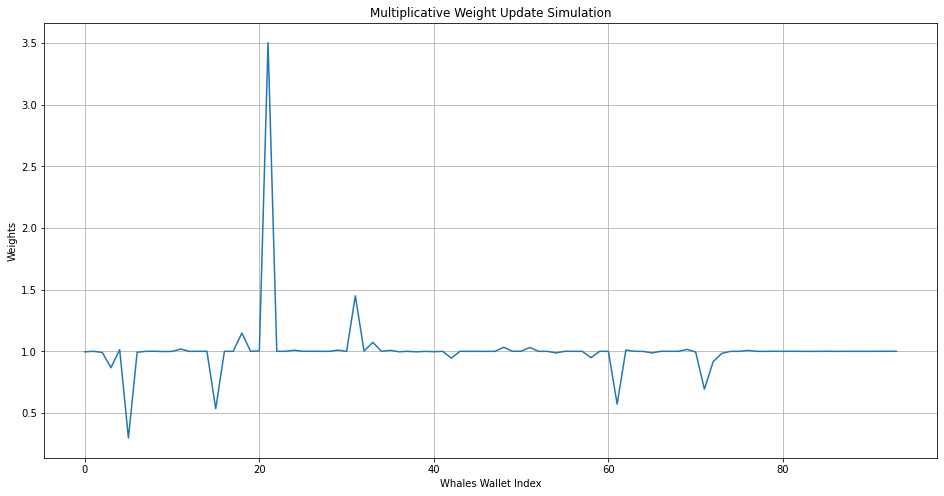

median weight is 0.9997365385363297
mean weight is 1.0107056467830433
standard deviation is 0.28423119309599126
[0.9960594663501623, 0.9998372526738651, 0.9912464283603667, 0.8673215921038323, 1.0135157896734366, 0.2962585266649413, 0.9924737917952807, 0.999647985998027, 1.0003060636365715, 0.9980326894136096, 0.9990003948647571, 1.0184763863391666, 0.9994966323595954, 0.9999966193177201, 0.9996331308806017, 0.5346869992439213, 0.9999207621054045, 0.9993817424724954, 1.1481713254998658, 1.000037359949066, 1.0027737371215881, 3.5038582588790277, 0.9997445091348546, 0.999971099110364, 1.0087923972043187, 0.9999382233648354, 1.000190646498906, 0.9998395069204765, 0.9994353102354406, 1.00967873877819, 0.999298005805031, 1.4501875666403494, 1.0017586016321787, 1.0724294962946128, 1.0000414152191184, 1.0076785413810923, 0.9963121783464606, 0.9996755542461502, 0.9955665500573001, 0.9994880911087959, 0.9966399763817188, 0.9999148526893116, 0.9447400577993937, 1.0002424868629745, 0.999252268791

In [ ]:
#@title Multiplicative Weight Update
# committed several changes to input data:
# 1)
import numpy as np
from datetime import date, timedelta 
import statistics 
import matplotlib.pyplot as plt

start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
daterange = pd.date_range(start_date, end_date, freq='W').date
weights = dict()
# nonzero_wallet is a dict that maps addresses to index in selected_addresses/hashmap
# hashmap is a list of dictionary that contains year-long net exchange flow of each address

# initialize the weights of all wallets as 1, wallet all initialized in lower cases due to google colab 
for wallet in selected_addresses:
  weights[wallet] = 1
_lambda = 0.01
balance_lambda = 0.1 # discount balance change due to asymmetric impact

# get average balance of a whale
avg_balance = dict()
for wallet in eth_balance.keys():
  balance = 0
  for value in eth_balance[wallet].values():
    balance += value
  avg_balance[wallet] = balance / 365

# weekly performance punishment 
for week_start in daterange:
  week_end = week_start+timedelta(weeks=1)
  try:
    # price return: (future's closing price - today's closing price) / today's closing price 
    future_price = eth_price[week_end.strftime("%m/%d/%Y")]
    today_price = eth_price[week_start.strftime("%m/%d/%Y")] 
    price_change = (future_price - today_price) / today_price
  except:
    break # disregard the last week

  # Multiplicative Weight Update
  for wallet in selected_addresses:
    wallet_id = selected_addresses.index(wallet)
    week_cexflow = 0
    for day in pd.date_range(week_start, week_end).date:
      week_cexflow += hashmap[wallet_id][day.strftime("%Y/%m/%d")]

    # change weights based on net exchange flow
    if week_cexflow != 0:
      cexflow_prediction_degree = np.abs(week_cexflow) / avg_balance[wallet] * np.abs(price_change) * _lambda # prediction discounted by purchase power
      if week_cexflow < 0 and price_change < 0: # punish if buy eth before price goes down
        weights[wallet] /= 1 + cexflow_prediction_degree
      elif week_cexflow > 0 and price_change > 0: # punish if sell eth before price goes up
        weights[wallet] /= 1 + cexflow_prediction_degree
      elif week_cexflow < 0 and price_change > 0: # reward if buy eth before price goes up
        weights[wallet] *= 1 + cexflow_prediction_degree
      elif week_cexflow > 0 and price_change > 0: # reward if sell eth before price goes down
        weights[wallet] *= 1 + cexflow_prediction_degree

    # change weights based on balance changes
    start_balance = eth_balance[wallet][week_start.strftime("%Y/%m/%d")]
    end_balance = eth_balance[wallet][week_end.strftime("%Y/%m/%d")]
    if start_balance != 0:
      balance_change = (end_balance - start_balance) / start_balance
      balance_prediction_degree = np.abs(balance_change) * np.abs(price_change) * _lambda * balance_lambda # prediction discounted 
      if balance_change > 0 and price_change < 0: # punish if balance increases before price goes down
        weights[wallet] /= 1 + balance_prediction_degree
      if balance_change < 0 and price_change > 0: # punish if balance decreases before price goes up
        weights[wallet] /= 1 + balance_prediction_degree
      if balance_change > 0 and price_change > 0: # reward if balance increases before price goes up
          weights[wallet] *= 1 + balance_prediction_degree
      if balance_change < 0 and price_change < 0: # reward if balance decreases before price goes down
        weights[wallet] *= 1 + balance_prediction_degree
    
    # change weighs based on eth / (eth + stable) ratio
    start_eth2stable = eth2stable_ratio[wallet][week_start.strftime("%Y/%m/%d")]
    end_eth2stable = eth2stable_ratio[wallet][week_end.strftime("%Y/%m/%d")]
    # eth2stable_change = (end_eth2stable - start_eth2stable) / start_eth2stable
    eth2stable_change = (end_eth2stable - start_eth2stable) 

    eth2stable_prediction_degree = np.abs(eth2stable_change) * np.abs(price_change) * _lambda
    # ideally hold higher percent of eth before price goes up 
    if eth2stable_change > 0 and price_change < 0: # punish if eth2stable ratio increases before price goes down
      weights[wallet] /= 1 + eth2stable_prediction_degree
    if eth2stable_change < 0 and price_change > 0: # punish if eth2stable ratio decreases before price goes up
      weights[wallet] /= 1 + eth2stable_prediction_degree
    if eth2stable_change > 0 and price_change > 0: # reward if eth2stable ratio increases before price goes up
      weights[wallet] *= 1 + eth2stable_prediction_degree
    if eth2stable_change > 0 and price_change < 0: # reward if eth2stable ratio decreases before price goes down
      weights[wallet] *= 1 + eth2stable_prediction_degree

# for wallet in weights.keys():
#   print('wallet address', wallet, 'with weight', weights[wallet])
weights_list = list(weights.values())

plt.figure(figsize=(16,8))
plt.plot(np.arange(len(weights_list)), weights_list)
plt.xlabel('Whales Wallet Index')
plt.ylabel('Weights')
plt.title('Multiplicative Weight Update Simulation')
plt.grid(True)
plt.show()

print('median weight is', statistics.median(weights_list))
print("mean weight is", statistics.mean(weights_list))
print('standard deviation is', statistics.stdev(weights_list))
print(weights_list)

MWUA_wallets = sorted(weights, key=weights.get, reverse=True)[:20]
for wallet in MWUA_wallets:
    print("selected wallet is", wallet, "weight is", weights[wallet])

print(MWUA_wallets)


In [ ]:
MWUA_cexflow = dict()
MWUA_balance = dict()
MWUA_eth2stable = dict()
start_date = date(2022, 1, 1)
end_date = date(2022, 12, 31)
daterange = pd.date_range(start_date, end_date).date
for day in daterange:
  day_string = day.strftime("%Y/%m/%d")
  day_cexflow = 0
  day_balance = 0
  day_eth2stable = 0
  for wallet in MWUA_wallets:
    wallet_index = selected_addresses.index(wallet)
    day_cexflow += hashmap[wallet_index][day_string]
    day_balance += eth_balance[wallet][day_string]
    day_eth2stable += eth2stable_ratio[wallet][day_string]
  MWUA_cexflow[day_string] = day_cexflow
  MWUA_balance[day_string] = day_balance
  MWUA_eth2stable[day_string] = day_eth2stable / len(MWUA_wallets)

print(MWUA_cexflow)
print(MWUA_balance)
print(MWUA_eth2stable)

In [ ]:
import pandas as pd

# df = pd.DataFrame(MWUA_cexflow)
# df.to_csv('MWUA_cexflow.csv')

# MWUA_cexflow.to_csv('test.csv')

df = pd.DataFrame(MWUA_balance, index=[0]) 
df.head()
df.to_csv(index=False)

'2022/01/01,2022/01/02,2022/01/03,2022/01/04,2022/01/05,2022/01/06,2022/01/07,2022/01/08,2022/01/09,2022/01/10,2022/01/11,2022/01/12,2022/01/13,2022/01/14,2022/01/15,2022/01/16,2022/01/17,2022/01/18,2022/01/19,2022/01/20,2022/01/21,2022/01/22,2022/01/23,2022/01/24,2022/01/25,2022/01/26,2022/01/27,2022/01/28,2022/01/29,2022/01/30,2022/01/31,2022/02/01,2022/02/02,2022/02/03,2022/02/04,2022/02/05,2022/02/06,2022/02/07,2022/02/08,2022/02/09,2022/02/10,2022/02/11,2022/02/12,2022/02/13,2022/02/14,2022/02/15,2022/02/16,2022/02/17,2022/02/18,2022/02/19,2022/02/20,2022/02/21,2022/02/22,2022/02/23,2022/02/24,2022/02/25,2022/02/26,2022/02/27,2022/02/28,2022/03/01,2022/03/02,2022/03/03,2022/03/04,2022/03/05,2022/03/06,2022/03/07,2022/03/08,2022/03/09,2022/03/10,2022/03/11,2022/03/12,2022/03/13,2022/03/14,2022/03/15,2022/03/16,2022/03/17,2022/03/18,2022/03/19,2022/03/20,2022/03/21,2022/03/22,2022/03/23,2022/03/24,2022/03/25,2022/03/26,2022/03/27,2022/03/28,2022/03/29,2022/03/30,2022/03/31,2022/04/0

In [ ]:
balance = 0
for wallet in MWUA_wallets: 
  checksum = Web3.toChecksumAddress(wallet)
  block = convert_date_to_blockNumber(date(2021, 12, 31))
  balance += float(w3.fromWei(w3.eth.get_balance(checksum, block_identifier=block), 'ether'))
print(balance)

7909.699010691374


In [ ]:
#@title testing etherscan url
address = '0xaBCA5d24CFB84dE8888F744fcbbFA7c1A667DCc8'
url = "https://api.etherscan.io/api?module=account&action=txlist&address=" + address + "&startblock=15930091&endblock=99999999&page=1&sort=desc&apikey=SKMKXN954GUHUYBF5JFKHS7I1M8IK5SXQP"
response = requests.get(url, verify=certifi.where())
address_content = response.json()
result = address_content.get('result')
for n, transaction in enumerate(result):
  hash = transaction.get('hash')
  value = transaction.get('value')
  value2 = w3.eth.get_transaction(hash)['value']
  value2 = w3.fromWei(value2, 'tether')
  print(transaction)
  print("transaction hash:", hash, "value is:", value)
  print('value2 is', value2, "in tether value: ", value2t)

In [ ]:
#@title ATTEMPT web scraping for github exchange addresses
import requests
from bs4 import BeautifulSoup

pages = ["https://github.com/DefiLlama/DefiLlama-Adapters/blob/main/projects/bitfinex/index.js"]
pages = ["https://www.allsides.com/media-bias/media-bias-ratings"]

for page in pages:
  r = requests.get(page)
  print(r.content)
  soup = BeautifulSoup(r.content, 'html.parser')
    
  #rows = soup.select('div div main turbo-frame div div div div div table tbody')
  rows = soup.select('tbody tr')
  print(rows)

  row = rows[0]
    #addr = row.select_one('.js-fine-line span').text.stripe()
  name = row.select_one('.source-title').text.strip()
  print(name)

# web scraping testing
import requests
from bs4 import BeautifulSoup

page = "https://www.allsides.com/media-bias/media-bias-ratings"

r = requests.get(page)
print(r.content)
soup = BeautifulSoup(r.content, 'html.parser')
    
rows = soup.select('tbody tr')
row = rows[0]
print(row)
bias = row.select_one('.views-field-field-bias-image a')['href'].split('/')[-1]
agree = int(row.select_one('.agree').text)
print(agree)
allsides_page = 'https://www.allsides.com' + row.select_one('.source-title a')['href']
name = row.select_one('.source-title').text.strip()

print(f"bias:  {bias}, allsides: {allsides_page}, agree: {agree}, name: {name}")

In [ ]:
#@title ATTEMPT web3py Filter but only works for contract addresses
flurry_address = w3.toChecksumAddress('0x60F63B76E2Fc1649E57a3489162732A90ACf59FE')
myAddress = w3.toChecksumAddress('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
# filter = w3.eth.filter({
#                          'fromBlock': 16313055, 
#                          'toBlock': 'latest',
#                         'address': myAddress,
#                            })
filter = w3.eth.filter('latest')
filter.get_new_entries()
for event in filter.get_new_entries():
  trans = w3.eth.get_transaction(event['transactionHash'].hex())
  _from = trans['from']
  _to = trans['to']
  if _from in all_exchangewallets:
    print("find flow out of exchanges")
  if _to in all_exchangewallets:
    print("find flow into exchanges")

# how to use filter or other similar functions that can give me exchange flow of certain addresses
# what data am i getting if 
# 1) find a way to identify top 10% and bottom 10% wallets at a given point in time
# 2) find a way to track their money flow into and out from exchanges at a given point in time
  # know what are exchange wallets
  # find each wallet's net flow to exchanges at a given day
  # aggregate all wallets' net flow
# 3) build prediction model

# try mempool filtering
pcsAbi = json.loads()
pcsRouter = w3.toChecksumAddress('0x10ED43C718714eb63d5aA57B78B54704E256024E')
pcsContract = w3.eth.contract(address=pcsRouter, abi=pcsAbi)

async def log_loop(event_filter, poll_interval):
    while True:
        for event in event_filter.get_new_entries():
            handle_event(event)
        await asyncio.sleep(poll_interval)

def handle_event(event):
    #print(Web3.toJSON(event))
    try:
        getTrans = Web3.toJSON(event).strip('"')
        #print(web3.eth.get_transaction(getTrans))
        trans = w3.eth.get_transaction(getTrans)
        #print(trans['input'])
        data = trans['input']
        to = trans['to']
        if to == pcsRouter:
            decoded = pcsContract.decode_function_input(data)
            print(decoded[1]['path'])
        else:
            print('nothing')
        
    except Exception as e:
        print(f'error occurred: {e}')


# block_filter = w3.eth.filter('latest')
tx_filter = w3.eth.filter('pending')
loop = asyncio.get_event_loop()
loop.run_until_complete(
asyncio.gather(
    #log_loop(block_filter, 2),
  log_loop(tx_filter, 1)))
    # finally:
    #     loop.close()




eth_address = w3.toChecksumAddress('0x2170ed0880ac9a755fd29b2688956bd959f933f8')
eth_abi = json.loads('[{"inputs":[],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"constant":true,"inputs":[],"name":"_decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"_name","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"_symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"burn","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"subtractedValue","type":"uint256"}],"name":"decreaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"getOwner","outputs":[{"internalType":"address","name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"addedValue","type":"uint256"}],"name":"increaseAllowance","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"mint","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"renounceOwnership","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"}]')
eth_contract = w3.eth.contract(address=eth_address, abi=eth_abi)

weth_address = w3.toChecksumAddress('0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2')
weth_abi = json.loads('[{"constant":true,"inputs":[],"name":"name","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"guy","type":"address"},{"name":"wad","type":"uint256"}],"name":"approve","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"totalSupply","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"src","type":"address"},{"name":"dst","type":"address"},{"name":"wad","type":"uint256"}],"name":"transferFrom","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"wad","type":"uint256"}],"name":"withdraw","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"decimals","outputs":[{"name":"","type":"uint8"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"}],"name":"balanceOf","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"symbol","outputs":[{"name":"","type":"string"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"dst","type":"address"},{"name":"wad","type":"uint256"}],"name":"transfer","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[],"name":"deposit","outputs":[],"payable":true,"stateMutability":"payable","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"},{"name":"","type":"address"}],"name":"allowance","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"payable":true,"stateMutability":"payable","type":"fallback"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":true,"name":"guy","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":true,"name":"dst","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Transfer","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"dst","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Deposit","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"src","type":"address"},{"indexed":false,"name":"wad","type":"uint256"}],"name":"Withdrawal","type":"event"}]')
weth_contract = w3.eth.contract(address=weth_address, abi=weth_abi)

weth_contract.decode_function_input(transaction.input)